In [1]:
import keras
import cv2
from skimage.transform import rotate, resize, SimilarityTransform, warp
import os
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.utils.training_utils import multi_gpu_model
%matplotlib inline

c:\users\vincenzo\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [2]:
# We define in advance constants to build the model

INPUT_SHAPE = (96, 96, 3)
IM_HEIGHT = 96
IM_WIDTH = 96
OUTPUT_SIZE = 2

LEARNING_RATE = 0.0001
OPTIMIZER = keras.optimizers.Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

SL_TRAIN_SIZE = 50121
SL_VALIDATION_SIZE = 12531
EPOCHS = 10
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50
STEPS_PER_EPOCH = (2 * SL_TRAIN_SIZE) // BATCH_SIZE + 1
VALIDATION_STEPS_PER_EPOCH = (2 * SL_VALIDATION_SIZE) // BATCH_SIZE + 1

TRAIN_PATH = "./data_set/train/"
VALIDATION_PATH = "./data_set/validation/"
TEST_PATH = "./data_set/test/"

MODEL_PATH = "./binary_classifier/net_1_model.json"
WEIGHTS_PATH = "./binary_classifier/net_1_weights.h5"

In [3]:
def transform_image(img):
    # trasformazioni da implementare rotate, flip, shift, zoom
    sel = [0, 1]
    offset = 72
    bound = (72 - 48) / 2
    t_img = np.array(img)
    if rand.choice(sel):
        # rotate
        angle = rand.uniform(0, 360)
        t_img = rotate(t_img, angle, mode='edge')
    if rand.choice(sel):
        # flip
        if rand.choice(sel):
            t_img = np.flipud(t_img)
        if rand.choice(sel):
            t_img = np.fliplr(t_img)
    if rand.choice(sel):
        tform = SimilarityTransform(translation=(int(rand.uniform(-bound, bound)), int(rand.uniform(-bound, bound))))
        t_img = warp(t_img, tform)
    if rand.choice(sel):
        # zoom
        zoom = int(rand.uniform(-bound, bound))
        t_img = resize(t_img[offset-48-zoom:offset+48+zoom, offset-48-zoom:offset+48+zoom, :], (96, 96))
        return t_img.tolist()
    # Cut 96x96 patch
    t_img = t_img[offset-48:offset+48, offset-48:offset+48, :]
    return t_img.tolist()

In [4]:
# Sea lions patches extractor
def extract_sea_lion_patch(path, epoch, n_epochs):
    img = cv2.imread(path)
    if rand.uniform(0.0, 1.0) < (epoch/n_epochs):
        # Perform transformation
        return transform_image(img)
    patch = img[72-48:72+48, 72-48:72+48, :]
    return patch

In [5]:
def train_generator(epoch_tot, batch_size):
    sl_lst_tmp = os.listdir(TRAIN_PATH + 'sea_lions')
    sl_lst = []
    for elem in sl_lst_tmp:
        sl_lst.append(list((elem, 'sea_lion')))
    bkg_lst_tmp = os.listdir(TRAIN_PATH + 'background')
    for curr_epoch in range(epoch_tot):
        bkg_lst = []
        for elem in rand.sample(bkg_lst_tmp, SL_TRAIN_SIZE):
            bkg_lst.append(list((elem, 'background')))
        lst = sl_lst + bkg_lst
        rand.shuffle(lst)
        patches = []
        classes = []
        curr_batch_size = 0
        for elem in lst:
            if elem[1] == 'background':
                img = cv2.imread(TRAIN_PATH + 'background/' + elem[0])
                patches.append(img)
                classes.append([0, 1])
            else:
                patches.append(extract_sea_lion_patch(TRAIN_PATH + 'sea_lions/' + elem[0], curr_epoch, epoch_tot))
                classes.append([1, 0])
            curr_batch_size += 1
            if curr_batch_size == batch_size:
                X_train = np.array(patches)
                X_train = X_train.astype('float32')
                X_train /= 255
                Y_train = np.array(classes)
                curr_batch_size = 0
                patches = []
                classes = []
                yield X_train, Y_train
        if len(patches) > 0:
            X_train = np.array(patches)
            X_train = X_train.astype('float32')
            X_train /= 255
            Y_train = np.array(classes)
            yield X_train, Y_train
        print("end epoch" + str(curr_epoch + 1))

In [6]:
X_validation = []
Y_validation = []
validation_set = []
lst = os.listdir(VALIDATION_PATH + 'sea_lions')
for elem in lst:
    validation_set.append(list((cv2.imread(VALIDATION_PATH + 'sea_lions/' + elem), 'sea_lion')))
lst = os.listdir(VALIDATION_PATH + 'background')
for elem in lst:
    validation_set.append(list((cv2.imread(VALIDATION_PATH + 'background/' + elem), 'background')))
rand.shuffle(validation_set)
for data in validation_set:
    X_validation.append(data[0])
    if data[1] == 'sea_lion':
        Y_validation.append([1, 0])
    else:
        Y_validation.append([0, 1])
X_validation = np.array(X_validation, copy=False)
Y_validation = np.array(Y_validation, copy=False)

# Free memory
lst = []
validation_set = []

# Convert data types and normalize values
X_validation = X_validation.astype('float32')
X_validation /= 255


In [7]:
# Build parallel model (multi gpu)

model = Sequential()
# First layer
model.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth layer
model.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(OUTPUT_SIZE, activation='softmax'))

parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

In [8]:
# Train (multi gpu)

# Fit model on training data
history = parallel_model.fit_generator( 
    train_generator(EPOCHS, BATCH_SIZE),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_validation, Y_validation),
    validation_steps=VALIDATION_STEPS_PER_EPOCH,
    workers=8,
    max_queue_size=50)

Epoch 1/10


   1/2005 [..............................] - ETA: 1:35:30 - loss: 0.6934 - acc: 0.4000

   4/2005 [..............................] - ETA: 24:21 - loss: 0.6930 - acc: 0.3950  

   6/2005 [..............................] - ETA: 18:23 - loss: 0.6924 - acc: 0.4267

   7/2005 [..............................] - ETA: 17:18 - loss: 0.6926 - acc: 0.4257

   8/2005 [..............................] - ETA: 16:38 - loss: 0.6928 - acc: 0.4350

   9/2005 [..............................] - ETA: 15:49 - loss: 0.6926 - acc: 0.4489

  10/2005 [..............................] - ETA: 15:28 - loss: 0.6926 - acc: 0.4560

  11/2005 [..............................] - ETA: 15:20 - loss: 0.6929 - acc: 0.4491

  12/2005 [..............................] - ETA: 14:57 - loss: 0.6927 - acc: 0.4533

  13/2005 [..............................] - ETA: 14:57 - loss: 0.6928 - acc: 0.4477

  14/2005 [..............................] - ETA: 14:35 - loss: 0.6926 - acc: 0.4543

  15/2005 [..............................] - ETA: 14:18 - loss: 0.6926 - acc: 0.4600

  16/2005 [..............................] - ETA: 13:57 - loss: 0.6925 - acc: 0.4575

  17/2005 [..............................] - ETA: 13:44 - loss: 0.6925 - acc: 0.4553

  18/2005 [..............................] - ETA: 13:30 - loss: 0.6925 - acc: 0.4600

  19/2005 [..............................] - ETA: 13:20 - loss: 0.6923 - acc: 0.4674

  20/2005 [..............................] - ETA: 13:09 - loss: 0.6923 - acc: 0.4700

  21/2005 [..............................] - ETA: 13:05 - loss: 0.6923 - acc: 0.4714

  22/2005 [..............................] - ETA: 13:01 - loss: 0.6921 - acc: 0.4791

  23/2005 [..............................] - ETA: 12:51 - loss: 0.6920 - acc: 0.4870

  24/2005 [..............................] - ETA: 12:46 - loss: 0.6920 - acc: 0.4842

  25/2005 [..............................] - ETA: 12:36 - loss: 0.6917 - acc: 0.4912

  26/2005 [..............................] - ETA: 12:32 - loss: 0.6918 - acc: 0.4877

  27/2005 [..............................] - ETA: 12:27 - loss: 0.6917 - acc: 0.4919

  28/2005 [..............................] - ETA: 12:25 - loss: 0.6917 - acc: 0.4900

  29/2005 [..............................] - ETA: 12:19 - loss: 0.6916 - acc: 0.4931

  30/2005 [..............................] - ETA: 12:14 - loss: 0.6915 - acc: 0.4980

  31/2005 [..............................] - ETA: 12:12 - loss: 0.6913 - acc: 0.5006

  32/2005 [..............................] - ETA: 12:05 - loss: 0.6912 - acc: 0.5019

  33/2005 [..............................] - ETA: 12:02 - loss: 0.6912 - acc: 0.5042

  34/2005 [..............................] - ETA: 12:00 - loss: 0.6910 - acc: 0.5065

  35/2005 [..............................] - ETA: 11:58 - loss: 0.6910 - acc: 0.5069

  36/2005 [..............................] - ETA: 11:54 - loss: 0.6908 - acc: 0.5106

  37/2005 [..............................] - ETA: 11:51 - loss: 0.6908 - acc: 0.5130

  38/2005 [..............................] - ETA: 11:50 - loss: 0.6907 - acc: 0.5147

  39/2005 [..............................] - ETA: 11:52 - loss: 0.6906 - acc: 0.5159

  40/2005 [..............................] - ETA: 11:49 - loss: 0.6905 - acc: 0.5180

  41/2005 [..............................] - ETA: 11:44 - loss: 0.6904 - acc: 0.5220

  42/2005 [..............................] - ETA: 11:42 - loss: 0.6903 - acc: 0.5257

  43/2005 [..............................] - ETA: 11:37 - loss: 0.6902 - acc: 0.5284

  44/2005 [..............................] - ETA: 11:34 - loss: 0.6901 - acc: 0.5323

  45/2005 [..............................] - ETA: 11:36 - loss: 0.6900 - acc: 0.5338

  46/2005 [..............................] - ETA: 11:41 - loss: 0.6900 - acc: 0.5348

  47/2005 [..............................] - ETA: 11:35 - loss: 0.6898 - acc: 0.5391

  48/2005 [..............................] - ETA: 11:34 - loss: 0.6897 - acc: 0.5412

  49/2005 [..............................] - ETA: 11:28 - loss: 0.6895 - acc: 0.5478

  50/2005 [..............................] - ETA: 11:31 - loss: 0.6894 - acc: 0.5528

  51/2005 [..............................] - ETA: 11:29 - loss: 0.6893 - acc: 0.5557

  52/2005 [..............................] - ETA: 11:30 - loss: 0.6891 - acc: 0.5604

  53/2005 [..............................] - ETA: 11:26 - loss: 0.6889 - acc: 0.5630

  54/2005 [..............................] - ETA: 11:24 - loss: 0.6889 - acc: 0.5644

  55/2005 [..............................] - ETA: 11:22 - loss: 0.6888 - acc: 0.5662

  56/2005 [..............................] - ETA: 11:19 - loss: 0.6886 - acc: 0.5689

  57/2005 [..............................] - ETA: 11:19 - loss: 0.6885 - acc: 0.5712

  58/2005 [..............................] - ETA: 11:17 - loss: 0.6884 - acc: 0.5724

  59/2005 [..............................] - ETA: 11:18 - loss: 0.6884 - acc: 0.5715

  60/2005 [..............................] - ETA: 11:18 - loss: 0.6883 - acc: 0.5720

  61/2005 [..............................] - ETA: 11:17 - loss: 0.6882 - acc: 0.5734

  62/2005 [..............................] - ETA: 11:17 - loss: 0.6880 - acc: 0.5739

  63/2005 [..............................] - ETA: 11:17 - loss: 0.6879 - acc: 0.5752

  64/2005 [..............................] - ETA: 11:15 - loss: 0.6878 - acc: 0.5756

  65/2005 [..............................] - ETA: 11:16 - loss: 0.6878 - acc: 0.5738

  66/2005 [..............................] - ETA: 11:16 - loss: 0.6876 - acc: 0.5742

  67/2005 [>.............................] - ETA: 11:17 - loss: 0.6876 - acc: 0.5764

  68/2005 [>.............................] - ETA: 11:16 - loss: 0.6875 - acc: 0.5762

  69/2005 [>.............................] - ETA: 11:17 - loss: 0.6875 - acc: 0.5754

  70/2005 [>.............................] - ETA: 11:14 - loss: 0.6873 - acc: 0.5783

  71/2005 [>.............................] - ETA: 11:09 - loss: 0.6871 - acc: 0.5817

  72/2005 [>.............................] - ETA: 11:10 - loss: 0.6870 - acc: 0.5833

  73/2005 [>.............................] - ETA: 11:06 - loss: 0.6868 - acc: 0.5860

  74/2005 [>.............................] - ETA: 11:05 - loss: 0.6867 - acc: 0.5892

  75/2005 [>.............................] - ETA: 11:03 - loss: 0.6865 - acc: 0.5904

  76/2005 [>.............................] - ETA: 11:03 - loss: 0.6865 - acc: 0.5921

  77/2005 [>.............................] - ETA: 11:03 - loss: 0.6864 - acc: 0.5932

  78/2005 [>.............................] - ETA: 11:01 - loss: 0.6862 - acc: 0.5951

  79/2005 [>.............................] - ETA: 11:03 - loss: 0.6862 - acc: 0.5957

  80/2005 [>.............................] - ETA: 11:02 - loss: 0.6861 - acc: 0.5965

  81/2005 [>.............................] - ETA: 11:01 - loss: 0.6860 - acc: 0.5975

  82/2005 [>.............................] - ETA: 11:02 - loss: 0.6859 - acc: 0.5993

  83/2005 [>.............................] - ETA: 10:59 - loss: 0.6857 - acc: 0.6014

  84/2005 [>.............................] - ETA: 10:57 - loss: 0.6855 - acc: 0.6048

  85/2005 [>.............................] - ETA: 10:56 - loss: 0.6853 - acc: 0.6071

  86/2005 [>.............................] - ETA: 10:57 - loss: 0.6852 - acc: 0.6091

  87/2005 [>.............................] - ETA: 10:56 - loss: 0.6851 - acc: 0.6108

  88/2005 [>.............................] - ETA: 10:54 - loss: 0.6848 - acc: 0.6139

  89/2005 [>.............................] - ETA: 10:54 - loss: 0.6848 - acc: 0.6151

  90/2005 [>.............................] - ETA: 10:54 - loss: 0.6846 - acc: 0.6169

  91/2005 [>.............................] - ETA: 10:52 - loss: 0.6845 - acc: 0.6185

  92/2005 [>.............................] - ETA: 10:50 - loss: 0.6842 - acc: 0.6200

  93/2005 [>.............................] - ETA: 10:49 - loss: 0.6841 - acc: 0.6204

  94/2005 [>.............................] - ETA: 10:49 - loss: 0.6839 - acc: 0.6217

  95/2005 [>.............................] - ETA: 10:47 - loss: 0.6838 - acc: 0.6215

  96/2005 [>.............................] - ETA: 10:45 - loss: 0.6836 - acc: 0.6229

  97/2005 [>.............................] - ETA: 10:44 - loss: 0.6834 - acc: 0.6241

  98/2005 [>.............................] - ETA: 10:44 - loss: 0.6832 - acc: 0.6245

  99/2005 [>.............................] - ETA: 10:43 - loss: 0.6831 - acc: 0.6248

 100/2005 [>.............................] - ETA: 10:42 - loss: 0.6830 - acc: 0.6248

 101/2005 [>.............................] - ETA: 10:39 - loss: 0.6827 - acc: 0.6259

 102/2005 [>.............................] - ETA: 10:38 - loss: 0.6825 - acc: 0.6271

 103/2005 [>.............................] - ETA: 10:39 - loss: 0.6825 - acc: 0.6260

 104/2005 [>.............................] - ETA: 10:38 - loss: 0.6822 - acc: 0.6269

 105/2005 [>.............................] - ETA: 10:38 - loss: 0.6821 - acc: 0.6269

 106/2005 [>.............................] - ETA: 10:37 - loss: 0.6820 - acc: 0.6272

 107/2005 [>.............................] - ETA: 10:34 - loss: 0.6818 - acc: 0.6290

 108/2005 [>.............................] - ETA: 10:33 - loss: 0.6816 - acc: 0.6296

 109/2005 [>.............................] - ETA: 10:32 - loss: 0.6814 - acc: 0.6312

 110/2005 [>.............................] - ETA: 10:32 - loss: 0.6811 - acc: 0.6327

 111/2005 [>.............................] - ETA: 10:31 - loss: 0.6810 - acc: 0.6342

 112/2005 [>.............................] - ETA: 10:31 - loss: 0.6808 - acc: 0.6355

 113/2005 [>.............................] - ETA: 10:30 - loss: 0.6806 - acc: 0.6368

 114/2005 [>.............................] - ETA: 10:29 - loss: 0.6804 - acc: 0.6372

 115/2005 [>.............................] - ETA: 10:28 - loss: 0.6802 - acc: 0.6383

 116/2005 [>.............................] - ETA: 10:27 - loss: 0.6801 - acc: 0.6386

 117/2005 [>.............................] - ETA: 10:25 - loss: 0.6798 - acc: 0.6393

 118/2005 [>.............................] - ETA: 10:25 - loss: 0.6796 - acc: 0.6400

 119/2005 [>.............................] - ETA: 10:24 - loss: 0.6794 - acc: 0.6408

 120/2005 [>.............................] - ETA: 10:23 - loss: 0.6792 - acc: 0.6408

 121/2005 [>.............................] - ETA: 10:24 - loss: 0.6790 - acc: 0.6410

 122/2005 [>.............................] - ETA: 10:24 - loss: 0.6788 - acc: 0.6420

 123/2005 [>.............................] - ETA: 10:22 - loss: 0.6785 - acc: 0.6436

 124/2005 [>.............................] - ETA: 10:23 - loss: 0.6784 - acc: 0.6444

 125/2005 [>.............................] - ETA: 10:23 - loss: 0.6783 - acc: 0.6443

 126/2005 [>.............................] - ETA: 10:23 - loss: 0.6781 - acc: 0.6454

 127/2005 [>.............................] - ETA: 10:23 - loss: 0.6779 - acc: 0.6463

 128/2005 [>.............................] - ETA: 10:22 - loss: 0.6776 - acc: 0.6483

 129/2005 [>.............................] - ETA: 10:22 - loss: 0.6774 - acc: 0.6499

 130/2005 [>.............................] - ETA: 10:21 - loss: 0.6771 - acc: 0.6517

 131/2005 [>.............................] - ETA: 10:20 - loss: 0.6768 - acc: 0.6530

 132/2005 [>.............................] - ETA: 10:21 - loss: 0.6767 - acc: 0.6536

 133/2005 [>.............................] - ETA: 10:22 - loss: 0.6765 - acc: 0.6547

 134/2005 [=>............................] - ETA: 10:21 - loss: 0.6763 - acc: 0.6563

 135/2005 [=>............................] - ETA: 10:20 - loss: 0.6760 - acc: 0.6575

 136/2005 [=>............................] - ETA: 10:19 - loss: 0.6756 - acc: 0.6596

 137/2005 [=>............................] - ETA: 10:20 - loss: 0.6756 - acc: 0.6597

 138/2005 [=>............................] - ETA: 10:19 - loss: 0.6754 - acc: 0.6601

 139/2005 [=>............................] - ETA: 10:19 - loss: 0.6752 - acc: 0.6609

 140/2005 [=>............................] - ETA: 10:19 - loss: 0.6749 - acc: 0.6619

 141/2005 [=>............................] - ETA: 10:18 - loss: 0.6746 - acc: 0.6633

 142/2005 [=>............................] - ETA: 10:17 - loss: 0.6743 - acc: 0.6642

 143/2005 [=>............................] - ETA: 10:17 - loss: 0.6740 - acc: 0.6650

 144/2005 [=>............................] - ETA: 10:17 - loss: 0.6738 - acc: 0.6663

 145/2005 [=>............................] - ETA: 10:17 - loss: 0.6735 - acc: 0.6665

 146/2005 [=>............................] - ETA: 10:16 - loss: 0.6732 - acc: 0.6674

 147/2005 [=>............................] - ETA: 10:16 - loss: 0.6729 - acc: 0.6687

 148/2005 [=>............................] - ETA: 10:15 - loss: 0.6726 - acc: 0.6699

 149/2005 [=>............................] - ETA: 10:16 - loss: 0.6723 - acc: 0.6710

 150/2005 [=>............................] - ETA: 10:14 - loss: 0.6719 - acc: 0.6723

 151/2005 [=>............................] - ETA: 10:15 - loss: 0.6716 - acc: 0.6731

 152/2005 [=>............................] - ETA: 10:14 - loss: 0.6715 - acc: 0.6730

 153/2005 [=>............................] - ETA: 10:14 - loss: 0.6712 - acc: 0.6737



 154/2005 [=>............................] - ETA: 10:12 - loss: 0.6708 - acc: 0.6752

 155/2005 [=>............................] - ETA: 10:11 - loss: 0.6704 - acc: 0.6760

 156/2005 [=>............................] - ETA: 10:10 - loss: 0.6701 - acc: 0.6763

 157/2005 [=>............................] - ETA: 10:12 - loss: 0.6701 - acc: 0.6755

 158/2005 [=>............................] - ETA: 10:11 - loss: 0.6700 - acc: 0.6756

 159/2005 [=>............................] - ETA: 10:11 - loss: 0.6697 - acc: 0.6761

 160/2005 [=>............................] - ETA: 10:11 - loss: 0.6695 - acc: 0.6769

 161/2005 [=>............................] - ETA: 10:09 - loss: 0.6691 - acc: 0.6780

 162/2005 [=>............................] - ETA: 10:07 - loss: 0.6687 - acc: 0.6790

 163/2005 [=>............................] - ETA: 10:06 - loss: 0.6684 - acc: 0.6800

 164/2005 [=>............................] - ETA: 10:06 - loss: 0.6681 - acc: 0.6805

 165/2005 [=>............................] - ETA: 10:05 - loss: 0.6678 - acc: 0.6817

 166/2005 [=>............................] - ETA: 10:06 - loss: 0.6675 - acc: 0.6827

 167/2005 [=>............................] - ETA: 10:04 - loss: 0.6672 - acc: 0.6836

 168/2005 [=>............................] - ETA: 10:04 - loss: 0.6670 - acc: 0.6838

 169/2005 [=>............................] - ETA: 10:04 - loss: 0.6665 - acc: 0.6849

 170/2005 [=>............................] - ETA: 10:03 - loss: 0.6661 - acc: 0.6859

 171/2005 [=>............................] - ETA: 10:02 - loss: 0.6658 - acc: 0.6861

 172/2005 [=>............................] - ETA: 10:02 - loss: 0.6656 - acc: 0.6865

 173/2005 [=>............................] - ETA: 10:01 - loss: 0.6651 - acc: 0.6875

 174/2005 [=>............................] - ETA: 10:01 - loss: 0.6648 - acc: 0.6883

 175/2005 [=>............................] - ETA: 10:01 - loss: 0.6645 - acc: 0.6885

 176/2005 [=>............................] - ETA: 10:00 - loss: 0.6641 - acc: 0.6892

 177/2005 [=>............................] - ETA: 10:00 - loss: 0.6637 - acc: 0.6902

 178/2005 [=>............................] - ETA: 9:59 - loss: 0.6633 - acc: 0.6910 

 179/2005 [=>............................] - ETA: 9:59 - loss: 0.6629 - acc: 0.6918

 180/2005 [=>............................] - ETA: 9:58 - loss: 0.6623 - acc: 0.6924

 181/2005 [=>............................] - ETA: 9:58 - loss: 0.6621 - acc: 0.6925

 182/2005 [=>............................] - ETA: 9:57 - loss: 0.6616 - acc: 0.6932

 183/2005 [=>............................] - ETA: 9:57 - loss: 0.6614 - acc: 0.6931

 184/2005 [=>............................] - ETA: 9:57 - loss: 0.6611 - acc: 0.6937

 185/2005 [=>............................] - ETA: 9:56 - loss: 0.6608 - acc: 0.6944

 186/2005 [=>............................] - ETA: 9:55 - loss: 0.6603 - acc: 0.6953

 187/2005 [=>............................] - ETA: 9:55 - loss: 0.6599 - acc: 0.6961

 188/2005 [=>............................] - ETA: 9:56 - loss: 0.6597 - acc: 0.6967

 189/2005 [=>............................] - ETA: 9:55 - loss: 0.6593 - acc: 0.6979

 190/2005 [=>............................] - ETA: 9:55 - loss: 0.6589 - acc: 0.6982

 191/2005 [=>............................] - ETA: 9:54 - loss: 0.6584 - acc: 0.6992

 192/2005 [=>............................] - ETA: 9:53 - loss: 0.6581 - acc: 0.6997

 193/2005 [=>............................] - ETA: 9:52 - loss: 0.6576 - acc: 0.7006

 194/2005 [=>............................] - ETA: 9:51 - loss: 0.6571 - acc: 0.7016

 195/2005 [=>............................] - ETA: 9:51 - loss: 0.6568 - acc: 0.7018

 196/2005 [=>............................] - ETA: 9:51 - loss: 0.6564 - acc: 0.7023

 197/2005 [=>............................] - ETA: 9:51 - loss: 0.6560 - acc: 0.7029

 198/2005 [=>............................] - ETA: 9:51 - loss: 0.6555 - acc: 0.7035

 199/2005 [=>............................] - ETA: 9:50 - loss: 0.6550 - acc: 0.7045

 200/2005 [=>............................] - ETA: 9:49 - loss: 0.6544 - acc: 0.7056

 201/2005 [==>...........................] - ETA: 9:49 - loss: 0.6540 - acc: 0.7061

 202/2005 [==>...........................] - ETA: 9:48 - loss: 0.6534 - acc: 0.7069

 203/2005 [==>...........................] - ETA: 9:48 - loss: 0.6530 - acc: 0.7081

 204/2005 [==>...........................] - ETA: 9:48 - loss: 0.6526 - acc: 0.7085

 205/2005 [==>...........................] - ETA: 9:47 - loss: 0.6521 - acc: 0.7093

 206/2005 [==>...........................] - ETA: 9:46 - loss: 0.6516 - acc: 0.7099

 207/2005 [==>...........................] - ETA: 9:46 - loss: 0.6511 - acc: 0.7106

 208/2005 [==>...........................] - ETA: 9:46 - loss: 0.6507 - acc: 0.7113

 209/2005 [==>...........................] - ETA: 9:46 - loss: 0.6503 - acc: 0.7116

 210/2005 [==>...........................] - ETA: 9:45 - loss: 0.6499 - acc: 0.7120

 211/2005 [==>...........................] - ETA: 9:44 - loss: 0.6494 - acc: 0.7127

 212/2005 [==>...........................] - ETA: 9:43 - loss: 0.6490 - acc: 0.7133

 213/2005 [==>...........................] - ETA: 9:43 - loss: 0.6486 - acc: 0.7136

 214/2005 [==>...........................] - ETA: 9:42 - loss: 0.6482 - acc: 0.7139

 215/2005 [==>...........................] - ETA: 9:42 - loss: 0.6477 - acc: 0.7144

 216/2005 [==>...........................] - ETA: 9:41 - loss: 0.6472 - acc: 0.7149

 217/2005 [==>...........................] - ETA: 9:40 - loss: 0.6466 - acc: 0.7155

 218/2005 [==>...........................] - ETA: 9:40 - loss: 0.6463 - acc: 0.7160

 219/2005 [==>...........................] - ETA: 9:41 - loss: 0.6460 - acc: 0.7163

 220/2005 [==>...........................] - ETA: 9:40 - loss: 0.6456 - acc: 0.7167

 221/2005 [==>...........................] - ETA: 9:40 - loss: 0.6451 - acc: 0.7173

 222/2005 [==>...........................] - ETA: 9:41 - loss: 0.6447 - acc: 0.7177

 223/2005 [==>...........................] - ETA: 9:40 - loss: 0.6443 - acc: 0.7184

 224/2005 [==>...........................] - ETA: 9:40 - loss: 0.6439 - acc: 0.7188

 225/2005 [==>...........................] - ETA: 9:40 - loss: 0.6434 - acc: 0.7194

 226/2005 [==>...........................] - ETA: 9:39 - loss: 0.6430 - acc: 0.7198

 227/2005 [==>...........................] - ETA: 9:38 - loss: 0.6426 - acc: 0.7204

 228/2005 [==>...........................] - ETA: 9:38 - loss: 0.6422 - acc: 0.7209

 229/2005 [==>...........................] - ETA: 9:38 - loss: 0.6417 - acc: 0.7217

 230/2005 [==>...........................] - ETA: 9:38 - loss: 0.6412 - acc: 0.7222

 231/2005 [==>...........................] - ETA: 9:37 - loss: 0.6409 - acc: 0.7224

 232/2005 [==>...........................] - ETA: 9:37 - loss: 0.6403 - acc: 0.7233

 233/2005 [==>...........................] - ETA: 9:36 - loss: 0.6395 - acc: 0.7240

 234/2005 [==>...........................] - ETA: 9:36 - loss: 0.6392 - acc: 0.7242

 235/2005 [==>...........................] - ETA: 9:35 - loss: 0.6385 - acc: 0.7247

 236/2005 [==>...........................] - ETA: 9:35 - loss: 0.6379 - acc: 0.7251

 237/2005 [==>...........................] - ETA: 9:35 - loss: 0.6376 - acc: 0.7252

 238/2005 [==>...........................] - ETA: 9:35 - loss: 0.6373 - acc: 0.7255

 239/2005 [==>...........................] - ETA: 9:34 - loss: 0.6367 - acc: 0.7258

 240/2005 [==>...........................] - ETA: 9:34 - loss: 0.6362 - acc: 0.7262

 241/2005 [==>...........................] - ETA: 9:34 - loss: 0.6358 - acc: 0.7264

 242/2005 [==>...........................] - ETA: 9:34 - loss: 0.6351 - acc: 0.7271

 243/2005 [==>...........................] - ETA: 9:34 - loss: 0.6346 - acc: 0.7273

 244/2005 [==>...........................] - ETA: 9:33 - loss: 0.6341 - acc: 0.7280

 245/2005 [==>...........................] - ETA: 9:33 - loss: 0.6334 - acc: 0.7287

 246/2005 [==>...........................] - ETA: 9:32 - loss: 0.6330 - acc: 0.7289

 247/2005 [==>...........................] - ETA: 9:31 - loss: 0.6324 - acc: 0.7295

 248/2005 [==>...........................] - ETA: 9:30 - loss: 0.6318 - acc: 0.7300

 249/2005 [==>...........................] - ETA: 9:30 - loss: 0.6313 - acc: 0.7304

 250/2005 [==>...........................] - ETA: 9:29 - loss: 0.6305 - acc: 0.7314

 251/2005 [==>...........................] - ETA: 9:29 - loss: 0.6297 - acc: 0.7321

 252/2005 [==>...........................] - ETA: 9:29 - loss: 0.6291 - acc: 0.7326

 253/2005 [==>...........................] - ETA: 9:28 - loss: 0.6284 - acc: 0.7330

 254/2005 [==>...........................] - ETA: 9:27 - loss: 0.6278 - acc: 0.7334

 255/2005 [==>...........................] - ETA: 9:27 - loss: 0.6272 - acc: 0.7336

 256/2005 [==>...........................] - ETA: 9:26 - loss: 0.6268 - acc: 0.7337

 257/2005 [==>...........................] - ETA: 9:26 - loss: 0.6263 - acc: 0.7339

 258/2005 [==>...........................] - ETA: 9:26 - loss: 0.6257 - acc: 0.7343

 259/2005 [==>...........................] - ETA: 9:25 - loss: 0.6251 - acc: 0.7344

 260/2005 [==>...........................] - ETA: 9:25 - loss: 0.6244 - acc: 0.7350

 261/2005 [==>...........................] - ETA: 9:25 - loss: 0.6242 - acc: 0.7350

 262/2005 [==>...........................] - ETA: 9:24 - loss: 0.6235 - acc: 0.7356

 263/2005 [==>...........................] - ETA: 9:24 - loss: 0.6229 - acc: 0.7360

 264/2005 [==>...........................] - ETA: 9:24 - loss: 0.6222 - acc: 0.7368

 265/2005 [==>...........................] - ETA: 9:24 - loss: 0.6217 - acc: 0.7374

 266/2005 [==>...........................] - ETA: 9:23 - loss: 0.6209 - acc: 0.7380

 267/2005 [==>...........................] - ETA: 9:22 - loss: 0.6203 - acc: 0.7384

 268/2005 [===>..........................] - ETA: 9:22 - loss: 0.6199 - acc: 0.7387

 269/2005 [===>..........................] - ETA: 9:22 - loss: 0.6190 - acc: 0.7395

 270/2005 [===>..........................] - ETA: 9:21 - loss: 0.6188 - acc: 0.7396

 271/2005 [===>..........................] - ETA: 9:21 - loss: 0.6184 - acc: 0.7396

 272/2005 [===>..........................] - ETA: 9:20 - loss: 0.6175 - acc: 0.7403

 273/2005 [===>..........................] - ETA: 9:20 - loss: 0.6169 - acc: 0.7407

 274/2005 [===>..........................] - ETA: 9:19 - loss: 0.6163 - acc: 0.7412

 275/2005 [===>..........................] - ETA: 9:18 - loss: 0.6159 - acc: 0.7415

 276/2005 [===>..........................] - ETA: 9:19 - loss: 0.6155 - acc: 0.7419

 277/2005 [===>..........................] - ETA: 9:19 - loss: 0.6151 - acc: 0.7421

 278/2005 [===>..........................] - ETA: 9:18 - loss: 0.6144 - acc: 0.7426

 279/2005 [===>..........................] - ETA: 9:18 - loss: 0.6139 - acc: 0.7429

 280/2005 [===>..........................] - ETA: 9:18 - loss: 0.6133 - acc: 0.7434

 281/2005 [===>..........................] - ETA: 9:17 - loss: 0.6128 - acc: 0.7439

 282/2005 [===>..........................] - ETA: 9:17 - loss: 0.6123 - acc: 0.7442

 283/2005 [===>..........................] - ETA: 9:17 - loss: 0.6116 - acc: 0.7449

 284/2005 [===>..........................] - ETA: 9:17 - loss: 0.6110 - acc: 0.7454

 285/2005 [===>..........................] - ETA: 9:17 - loss: 0.6105 - acc: 0.7453

 286/2005 [===>..........................] - ETA: 9:16 - loss: 0.6100 - acc: 0.7456

 287/2005 [===>..........................] - ETA: 9:16 - loss: 0.6093 - acc: 0.7461

 288/2005 [===>..........................] - ETA: 9:16 - loss: 0.6086 - acc: 0.7467

 289/2005 [===>..........................] - ETA: 9:15 - loss: 0.6080 - acc: 0.7471

 290/2005 [===>..........................] - ETA: 9:15 - loss: 0.6073 - acc: 0.7475

 291/2005 [===>..........................] - ETA: 9:15 - loss: 0.6068 - acc: 0.7478

 292/2005 [===>..........................] - ETA: 9:15 - loss: 0.6065 - acc: 0.7479

 293/2005 [===>..........................] - ETA: 9:14 - loss: 0.6058 - acc: 0.7483

 294/2005 [===>..........................] - ETA: 9:14 - loss: 0.6051 - acc: 0.7488

 295/2005 [===>..........................] - ETA: 9:14 - loss: 0.6047 - acc: 0.7490

 296/2005 [===>..........................] - ETA: 9:13 - loss: 0.6043 - acc: 0.7493

 297/2005 [===>..........................] - ETA: 9:13 - loss: 0.6040 - acc: 0.7494

 298/2005 [===>..........................] - ETA: 9:13 - loss: 0.6035 - acc: 0.7497

 299/2005 [===>..........................] - ETA: 9:13 - loss: 0.6031 - acc: 0.7497

 300/2005 [===>..........................] - ETA: 9:12 - loss: 0.6026 - acc: 0.7499

 301/2005 [===>..........................] - ETA: 9:12 - loss: 0.6021 - acc: 0.7502

 302/2005 [===>..........................] - ETA: 9:11 - loss: 0.6017 - acc: 0.7503

 303/2005 [===>..........................] - ETA: 9:11 - loss: 0.6011 - acc: 0.7506

 304/2005 [===>..........................] - ETA: 9:11 - loss: 0.6006 - acc: 0.7509

 305/2005 [===>..........................] - ETA: 9:11 - loss: 0.6002 - acc: 0.7511

 306/2005 [===>..........................] - ETA: 9:11 - loss: 0.5995 - acc: 0.7516

 307/2005 [===>..........................] - ETA: 9:10 - loss: 0.5988 - acc: 0.7520

 308/2005 [===>..........................] - ETA: 9:10 - loss: 0.5982 - acc: 0.7525

 309/2005 [===>..........................] - ETA: 9:10 - loss: 0.5979 - acc: 0.7525

 310/2005 [===>..........................] - ETA: 9:09 - loss: 0.5974 - acc: 0.7527

 311/2005 [===>..........................] - ETA: 9:09 - loss: 0.5967 - acc: 0.7532

 312/2005 [===>..........................] - ETA: 9:08 - loss: 0.5960 - acc: 0.7536

 313/2005 [===>..........................] - ETA: 9:08 - loss: 0.5953 - acc: 0.7542

 314/2005 [===>..........................] - ETA: 9:07 - loss: 0.5945 - acc: 0.7547

 315/2005 [===>..........................] - ETA: 9:07 - loss: 0.5940 - acc: 0.7551

 316/2005 [===>..........................] - ETA: 9:07 - loss: 0.5936 - acc: 0.7552

 317/2005 [===>..........................] - ETA: 9:06 - loss: 0.5931 - acc: 0.7554

 318/2005 [===>..........................] - ETA: 9:06 - loss: 0.5926 - acc: 0.7558

 319/2005 [===>..........................] - ETA: 9:06 - loss: 0.5921 - acc: 0.7561

 320/2005 [===>..........................] - ETA: 9:06 - loss: 0.5916 - acc: 0.7563

 321/2005 [===>..........................] - ETA: 9:05 - loss: 0.5908 - acc: 0.7568

 322/2005 [===>..........................] - ETA: 9:05 - loss: 0.5902 - acc: 0.7571

 323/2005 [===>..........................] - ETA: 9:04 - loss: 0.5893 - acc: 0.7578

 324/2005 [===>..........................] - ETA: 9:04 - loss: 0.5886 - acc: 0.7583

 325/2005 [===>..........................] - ETA: 9:03 - loss: 0.5881 - acc: 0.7585

 326/2005 [===>..........................] - ETA: 9:02 - loss: 0.5872 - acc: 0.7591

 327/2005 [===>..........................] - ETA: 9:02 - loss: 0.5867 - acc: 0.7594

 328/2005 [===>..........................] - ETA: 9:02 - loss: 0.5861 - acc: 0.7598

 329/2005 [===>..........................] - ETA: 9:01 - loss: 0.5854 - acc: 0.7601

 330/2005 [===>..........................] - ETA: 9:01 - loss: 0.5847 - acc: 0.7605

 331/2005 [===>..........................] - ETA: 9:01 - loss: 0.5841 - acc: 0.7609

 332/2005 [===>..........................] - ETA: 9:01 - loss: 0.5836 - acc: 0.7611

 333/2005 [===>..........................] - ETA: 9:00 - loss: 0.5832 - acc: 0.7613

 334/2005 [===>..........................] - ETA: 9:00 - loss: 0.5830 - acc: 0.7614

 335/2005 [====>.........................] - ETA: 9:00 - loss: 0.5823 - acc: 0.7619

 336/2005 [====>.........................] - ETA: 8:59 - loss: 0.5817 - acc: 0.7622

 337/2005 [====>.........................] - ETA: 8:59 - loss: 0.5811 - acc: 0.7626

 338/2005 [====>.........................] - ETA: 8:59 - loss: 0.5806 - acc: 0.7628

 339/2005 [====>.........................] - ETA: 8:58 - loss: 0.5802 - acc: 0.7629

 340/2005 [====>.........................] - ETA: 8:58 - loss: 0.5797 - acc: 0.7632

 341/2005 [====>.........................] - ETA: 8:57 - loss: 0.5793 - acc: 0.7634

 342/2005 [====>.........................] - ETA: 8:56 - loss: 0.5786 - acc: 0.7639

 343/2005 [====>.........................] - ETA: 8:56 - loss: 0.5779 - acc: 0.7643

 344/2005 [====>.........................] - ETA: 8:56 - loss: 0.5775 - acc: 0.7645

 345/2005 [====>.........................] - ETA: 8:55 - loss: 0.5771 - acc: 0.7648

 346/2005 [====>.........................] - ETA: 8:55 - loss: 0.5768 - acc: 0.7651

 347/2005 [====>.........................] - ETA: 8:55 - loss: 0.5763 - acc: 0.7653

 348/2005 [====>.........................] - ETA: 8:54 - loss: 0.5756 - acc: 0.7658

 349/2005 [====>.........................] - ETA: 8:54 - loss: 0.5752 - acc: 0.7659

 350/2005 [====>.........................] - ETA: 8:53 - loss: 0.5748 - acc: 0.7661

 351/2005 [====>.........................] - ETA: 8:53 - loss: 0.5743 - acc: 0.7664

 352/2005 [====>.........................] - ETA: 8:53 - loss: 0.5739 - acc: 0.7666

 353/2005 [====>.........................] - ETA: 8:53 - loss: 0.5733 - acc: 0.7668

 354/2005 [====>.........................] - ETA: 8:52 - loss: 0.5726 - acc: 0.7672

 355/2005 [====>.........................] - ETA: 8:52 - loss: 0.5722 - acc: 0.7672

 356/2005 [====>.........................] - ETA: 8:52 - loss: 0.5716 - acc: 0.7675

 357/2005 [====>.........................] - ETA: 8:51 - loss: 0.5712 - acc: 0.7677

 358/2005 [====>.........................] - ETA: 8:51 - loss: 0.5708 - acc: 0.7680

 359/2005 [====>.........................] - ETA: 8:51 - loss: 0.5703 - acc: 0.7681

 360/2005 [====>.........................] - ETA: 8:51 - loss: 0.5697 - acc: 0.7683

 361/2005 [====>.........................] - ETA: 8:50 - loss: 0.5690 - acc: 0.7688

 362/2005 [====>.........................] - ETA: 8:50 - loss: 0.5685 - acc: 0.7689

 363/2005 [====>.........................] - ETA: 8:49 - loss: 0.5679 - acc: 0.7693

 364/2005 [====>.........................] - ETA: 8:49 - loss: 0.5677 - acc: 0.7694

 365/2005 [====>.........................] - ETA: 8:48 - loss: 0.5671 - acc: 0.7696

 366/2005 [====>.........................] - ETA: 8:48 - loss: 0.5665 - acc: 0.7699

 367/2005 [====>.........................] - ETA: 8:47 - loss: 0.5662 - acc: 0.7701

 368/2005 [====>.........................] - ETA: 8:46 - loss: 0.5656 - acc: 0.7705

 369/2005 [====>.........................] - ETA: 8:46 - loss: 0.5650 - acc: 0.7707

 370/2005 [====>.........................] - ETA: 8:46 - loss: 0.5644 - acc: 0.7709

 371/2005 [====>.........................] - ETA: 8:45 - loss: 0.5642 - acc: 0.7712

 372/2005 [====>.........................] - ETA: 8:45 - loss: 0.5636 - acc: 0.7715

 373/2005 [====>.........................] - ETA: 8:45 - loss: 0.5632 - acc: 0.7715

 374/2005 [====>.........................] - ETA: 8:44 - loss: 0.5629 - acc: 0.7715

 375/2005 [====>.........................] - ETA: 8:44 - loss: 0.5626 - acc: 0.7717

 376/2005 [====>.........................] - ETA: 8:44 - loss: 0.5620 - acc: 0.7721

 377/2005 [====>.........................] - ETA: 8:43 - loss: 0.5613 - acc: 0.7723

 378/2005 [====>.........................] - ETA: 8:43 - loss: 0.5611 - acc: 0.7725

 379/2005 [====>.........................] - ETA: 8:42 - loss: 0.5606 - acc: 0.7728

 380/2005 [====>.........................] - ETA: 8:42 - loss: 0.5600 - acc: 0.7731

 381/2005 [====>.........................] - ETA: 8:42 - loss: 0.5595 - acc: 0.7732

 382/2005 [====>.........................] - ETA: 8:41 - loss: 0.5590 - acc: 0.7731

 383/2005 [====>.........................] - ETA: 8:41 - loss: 0.5587 - acc: 0.7734

 384/2005 [====>.........................] - ETA: 8:41 - loss: 0.5584 - acc: 0.7736

 385/2005 [====>.........................] - ETA: 8:41 - loss: 0.5578 - acc: 0.7739

 386/2005 [====>.........................] - ETA: 8:40 - loss: 0.5572 - acc: 0.7741

 387/2005 [====>.........................] - ETA: 8:40 - loss: 0.5568 - acc: 0.7743

 388/2005 [====>.........................] - ETA: 8:39 - loss: 0.5561 - acc: 0.7747

 389/2005 [====>.........................] - ETA: 8:39 - loss: 0.5555 - acc: 0.7750

 390/2005 [====>.........................] - ETA: 8:39 - loss: 0.5550 - acc: 0.7753

 391/2005 [====>.........................] - ETA: 8:38 - loss: 0.5543 - acc: 0.7756

 392/2005 [====>.........................] - ETA: 8:38 - loss: 0.5540 - acc: 0.7757

 393/2005 [====>.........................] - ETA: 8:38 - loss: 0.5532 - acc: 0.7760

 394/2005 [====>.........................] - ETA: 8:38 - loss: 0.5524 - acc: 0.7765

 395/2005 [====>.........................] - ETA: 8:37 - loss: 0.5519 - acc: 0.7767

 396/2005 [====>.........................] - ETA: 8:37 - loss: 0.5514 - acc: 0.7769

 397/2005 [====>.........................] - ETA: 8:37 - loss: 0.5509 - acc: 0.7771

 398/2005 [====>.........................] - ETA: 8:36 - loss: 0.5506 - acc: 0.7771

 399/2005 [====>.........................] - ETA: 8:36 - loss: 0.5501 - acc: 0.7774

 400/2005 [====>.........................] - ETA: 8:36 - loss: 0.5495 - acc: 0.7777

 401/2005 [=====>........................] - ETA: 8:35 - loss: 0.5489 - acc: 0.7780

 402/2005 [=====>........................] - ETA: 8:35 - loss: 0.5485 - acc: 0.7782

 403/2005 [=====>........................] - ETA: 8:35 - loss: 0.5482 - acc: 0.7783

 404/2005 [=====>........................] - ETA: 8:34 - loss: 0.5479 - acc: 0.7784

 405/2005 [=====>........................] - ETA: 8:34 - loss: 0.5475 - acc: 0.7785

 406/2005 [=====>........................] - ETA: 8:33 - loss: 0.5469 - acc: 0.7788

 407/2005 [=====>........................] - ETA: 8:33 - loss: 0.5466 - acc: 0.7788

 408/2005 [=====>........................] - ETA: 8:33 - loss: 0.5458 - acc: 0.7792

 409/2005 [=====>........................] - ETA: 8:33 - loss: 0.5454 - acc: 0.7794

 410/2005 [=====>........................] - ETA: 8:32 - loss: 0.5450 - acc: 0.7795

 411/2005 [=====>........................] - ETA: 8:32 - loss: 0.5447 - acc: 0.7797

 412/2005 [=====>........................] - ETA: 8:32 - loss: 0.5442 - acc: 0.7799

 413/2005 [=====>........................] - ETA: 8:31 - loss: 0.5439 - acc: 0.7801

 414/2005 [=====>........................] - ETA: 8:31 - loss: 0.5432 - acc: 0.7805

 415/2005 [=====>........................] - ETA: 8:30 - loss: 0.5428 - acc: 0.7807

 416/2005 [=====>........................] - ETA: 8:30 - loss: 0.5422 - acc: 0.7810

 417/2005 [=====>........................] - ETA: 8:30 - loss: 0.5416 - acc: 0.7812

 418/2005 [=====>........................] - ETA: 8:29 - loss: 0.5410 - acc: 0.7814

 419/2005 [=====>........................] - ETA: 8:29 - loss: 0.5404 - acc: 0.7818

 420/2005 [=====>........................] - ETA: 8:28 - loss: 0.5401 - acc: 0.7820

 421/2005 [=====>........................] - ETA: 8:28 - loss: 0.5396 - acc: 0.7821

 422/2005 [=====>........................] - ETA: 8:28 - loss: 0.5394 - acc: 0.7822

 423/2005 [=====>........................] - ETA: 8:28 - loss: 0.5391 - acc: 0.7823

 424/2005 [=====>........................] - ETA: 8:27 - loss: 0.5389 - acc: 0.7822

 425/2005 [=====>........................] - ETA: 8:27 - loss: 0.5383 - acc: 0.7826

 426/2005 [=====>........................] - ETA: 8:27 - loss: 0.5378 - acc: 0.7828

 427/2005 [=====>........................] - ETA: 8:27 - loss: 0.5372 - acc: 0.7830

 428/2005 [=====>........................] - ETA: 8:26 - loss: 0.5367 - acc: 0.7832

 429/2005 [=====>........................] - ETA: 8:26 - loss: 0.5365 - acc: 0.7833

 430/2005 [=====>........................] - ETA: 8:25 - loss: 0.5359 - acc: 0.7835

 431/2005 [=====>........................] - ETA: 8:25 - loss: 0.5354 - acc: 0.7837

 432/2005 [=====>........................] - ETA: 8:25 - loss: 0.5349 - acc: 0.7839

 433/2005 [=====>........................] - ETA: 8:24 - loss: 0.5344 - acc: 0.7840

 434/2005 [=====>........................] - ETA: 8:24 - loss: 0.5342 - acc: 0.7840

 435/2005 [=====>........................] - ETA: 8:23 - loss: 0.5341 - acc: 0.7840

 436/2005 [=====>........................] - ETA: 8:23 - loss: 0.5338 - acc: 0.7840

 437/2005 [=====>........................] - ETA: 8:22 - loss: 0.5335 - acc: 0.7841

 438/2005 [=====>........................] - ETA: 8:22 - loss: 0.5336 - acc: 0.7841

 439/2005 [=====>........................] - ETA: 8:22 - loss: 0.5333 - acc: 0.7841

 440/2005 [=====>........................] - ETA: 8:22 - loss: 0.5329 - acc: 0.7844

 441/2005 [=====>........................] - ETA: 8:22 - loss: 0.5326 - acc: 0.7844

 442/2005 [=====>........................] - ETA: 8:21 - loss: 0.5321 - acc: 0.7847

 443/2005 [=====>........................] - ETA: 8:21 - loss: 0.5319 - acc: 0.7845

 444/2005 [=====>........................] - ETA: 8:20 - loss: 0.5315 - acc: 0.7845

 445/2005 [=====>........................] - ETA: 8:20 - loss: 0.5312 - acc: 0.7846

 446/2005 [=====>........................] - ETA: 8:20 - loss: 0.5312 - acc: 0.7844

 447/2005 [=====>........................] - ETA: 8:19 - loss: 0.5306 - acc: 0.7847

 448/2005 [=====>........................] - ETA: 8:19 - loss: 0.5299 - acc: 0.7851

 449/2005 [=====>........................] - ETA: 8:18 - loss: 0.5292 - acc: 0.7854

 450/2005 [=====>........................] - ETA: 8:18 - loss: 0.5286 - acc: 0.7856

 451/2005 [=====>........................] - ETA: 8:18 - loss: 0.5281 - acc: 0.7859

 452/2005 [=====>........................] - ETA: 8:17 - loss: 0.5277 - acc: 0.7860

 453/2005 [=====>........................] - ETA: 8:17 - loss: 0.5274 - acc: 0.7862

 454/2005 [=====>........................] - ETA: 8:16 - loss: 0.5270 - acc: 0.7864

 455/2005 [=====>........................] - ETA: 8:16 - loss: 0.5265 - acc: 0.7867

 456/2005 [=====>........................] - ETA: 8:15 - loss: 0.5262 - acc: 0.7869

 457/2005 [=====>........................] - ETA: 8:15 - loss: 0.5260 - acc: 0.7869

 458/2005 [=====>........................] - ETA: 8:14 - loss: 0.5257 - acc: 0.7870

 459/2005 [=====>........................] - ETA: 8:14 - loss: 0.5257 - acc: 0.7870

 460/2005 [=====>........................] - ETA: 8:14 - loss: 0.5252 - acc: 0.7872

 461/2005 [=====>........................] - ETA: 8:13 - loss: 0.5250 - acc: 0.7872

 462/2005 [=====>........................] - ETA: 8:13 - loss: 0.5245 - acc: 0.7874

 463/2005 [=====>........................] - ETA: 8:13 - loss: 0.5242 - acc: 0.7875

 464/2005 [=====>........................] - ETA: 8:12 - loss: 0.5238 - acc: 0.7877

 465/2005 [=====>........................] - ETA: 8:12 - loss: 0.5235 - acc: 0.7879

 466/2005 [=====>........................] - ETA: 8:11 - loss: 0.5234 - acc: 0.7878

 467/2005 [=====>........................] - ETA: 8:11 - loss: 0.5233 - acc: 0.7879

 468/2005 [======>.......................] - ETA: 8:11 - loss: 0.5230 - acc: 0.7881

 469/2005 [======>.......................] - ETA: 8:10 - loss: 0.5228 - acc: 0.7881

 470/2005 [======>.......................] - ETA: 8:10 - loss: 0.5227 - acc: 0.7882

 471/2005 [======>.......................] - ETA: 8:10 - loss: 0.5225 - acc: 0.7882

 472/2005 [======>.......................] - ETA: 8:10 - loss: 0.5221 - acc: 0.7883

 473/2005 [======>.......................] - ETA: 8:09 - loss: 0.5217 - acc: 0.7885

 474/2005 [======>.......................] - ETA: 8:09 - loss: 0.5213 - acc: 0.7887

 475/2005 [======>.......................] - ETA: 8:08 - loss: 0.5209 - acc: 0.7890

 476/2005 [======>.......................] - ETA: 8:08 - loss: 0.5204 - acc: 0.7892

 477/2005 [======>.......................] - ETA: 8:08 - loss: 0.5200 - acc: 0.7894

 478/2005 [======>.......................] - ETA: 8:08 - loss: 0.5196 - acc: 0.7895

 479/2005 [======>.......................] - ETA: 8:07 - loss: 0.5192 - acc: 0.7896

 480/2005 [======>.......................] - ETA: 8:07 - loss: 0.5189 - acc: 0.7897

 481/2005 [======>.......................] - ETA: 8:07 - loss: 0.5185 - acc: 0.7899

 482/2005 [======>.......................] - ETA: 8:06 - loss: 0.5184 - acc: 0.7900

 483/2005 [======>.......................] - ETA: 8:06 - loss: 0.5181 - acc: 0.7901

 484/2005 [======>.......................] - ETA: 8:05 - loss: 0.5176 - acc: 0.7903

 485/2005 [======>.......................] - ETA: 8:05 - loss: 0.5172 - acc: 0.7905

 486/2005 [======>.......................] - ETA: 8:05 - loss: 0.5169 - acc: 0.7906

 487/2005 [======>.......................] - ETA: 8:04 - loss: 0.5165 - acc: 0.7908

 488/2005 [======>.......................] - ETA: 8:04 - loss: 0.5162 - acc: 0.7908

 489/2005 [======>.......................] - ETA: 8:04 - loss: 0.5157 - acc: 0.7910

 490/2005 [======>.......................] - ETA: 8:03 - loss: 0.5154 - acc: 0.7911

 491/2005 [======>.......................] - ETA: 8:03 - loss: 0.5150 - acc: 0.7912

 492/2005 [======>.......................] - ETA: 8:03 - loss: 0.5146 - acc: 0.7914

 493/2005 [======>.......................] - ETA: 8:02 - loss: 0.5142 - acc: 0.7916

 494/2005 [======>.......................] - ETA: 8:02 - loss: 0.5138 - acc: 0.7917

 495/2005 [======>.......................] - ETA: 8:02 - loss: 0.5134 - acc: 0.7918

 496/2005 [======>.......................] - ETA: 8:01 - loss: 0.5129 - acc: 0.7920

 497/2005 [======>.......................] - ETA: 8:01 - loss: 0.5125 - acc: 0.7922

 498/2005 [======>.......................] - ETA: 8:01 - loss: 0.5121 - acc: 0.7923

 499/2005 [======>.......................] - ETA: 8:00 - loss: 0.5116 - acc: 0.7926

 500/2005 [======>.......................] - ETA: 8:00 - loss: 0.5114 - acc: 0.7926

 501/2005 [======>.......................] - ETA: 8:00 - loss: 0.5107 - acc: 0.7930

 502/2005 [======>.......................] - ETA: 7:59 - loss: 0.5102 - acc: 0.7932

 503/2005 [======>.......................] - ETA: 7:59 - loss: 0.5100 - acc: 0.7932

 504/2005 [======>.......................] - ETA: 7:59 - loss: 0.5097 - acc: 0.7933

 505/2005 [======>.......................] - ETA: 7:58 - loss: 0.5094 - acc: 0.7934

 506/2005 [======>.......................] - ETA: 7:58 - loss: 0.5091 - acc: 0.7935

 507/2005 [======>.......................] - ETA: 7:58 - loss: 0.5090 - acc: 0.7936

 508/2005 [======>.......................] - ETA: 7:57 - loss: 0.5088 - acc: 0.7936

 509/2005 [======>.......................] - ETA: 7:57 - loss: 0.5085 - acc: 0.7938

 510/2005 [======>.......................] - ETA: 7:57 - loss: 0.5081 - acc: 0.7940

 511/2005 [======>.......................] - ETA: 7:57 - loss: 0.5078 - acc: 0.7940

 512/2005 [======>.......................] - ETA: 7:56 - loss: 0.5076 - acc: 0.7939

 513/2005 [======>.......................] - ETA: 7:56 - loss: 0.5071 - acc: 0.7942

 514/2005 [======>.......................] - ETA: 7:55 - loss: 0.5068 - acc: 0.7943

 515/2005 [======>.......................] - ETA: 7:55 - loss: 0.5066 - acc: 0.7943

 516/2005 [======>.......................] - ETA: 7:54 - loss: 0.5062 - acc: 0.7944

 517/2005 [======>.......................] - ETA: 7:54 - loss: 0.5058 - acc: 0.7946

 518/2005 [======>.......................] - ETA: 7:54 - loss: 0.5056 - acc: 0.7947

 519/2005 [======>.......................] - ETA: 7:53 - loss: 0.5051 - acc: 0.7949

 520/2005 [======>.......................] - ETA: 7:53 - loss: 0.5048 - acc: 0.7951

 521/2005 [======>.......................] - ETA: 7:53 - loss: 0.5046 - acc: 0.7951

 522/2005 [======>.......................] - ETA: 7:52 - loss: 0.5042 - acc: 0.7952

 523/2005 [======>.......................] - ETA: 7:52 - loss: 0.5038 - acc: 0.7954

 524/2005 [======>.......................] - ETA: 7:51 - loss: 0.5035 - acc: 0.7957

 525/2005 [======>.......................] - ETA: 7:51 - loss: 0.5031 - acc: 0.7958

 526/2005 [======>.......................] - ETA: 7:51 - loss: 0.5028 - acc: 0.7959

 527/2005 [======>.......................] - ETA: 7:51 - loss: 0.5025 - acc: 0.7961

 528/2005 [======>.......................] - ETA: 7:50 - loss: 0.5021 - acc: 0.7963

 529/2005 [======>.......................] - ETA: 7:50 - loss: 0.5016 - acc: 0.7966

 530/2005 [======>.......................] - ETA: 7:49 - loss: 0.5016 - acc: 0.7965

 531/2005 [======>.......................] - ETA: 7:49 - loss: 0.5017 - acc: 0.7964

 532/2005 [======>.......................] - ETA: 7:49 - loss: 0.5015 - acc: 0.7964

 533/2005 [======>.......................] - ETA: 7:48 - loss: 0.5011 - acc: 0.7966

 534/2005 [======>.......................] - ETA: 7:48 - loss: 0.5008 - acc: 0.7967

 535/2005 [=======>......................] - ETA: 7:48 - loss: 0.5005 - acc: 0.7967

 536/2005 [=======>......................] - ETA: 7:48 - loss: 0.5004 - acc: 0.7968

 537/2005 [=======>......................] - ETA: 7:47 - loss: 0.5002 - acc: 0.7968

 538/2005 [=======>......................] - ETA: 7:47 - loss: 0.4998 - acc: 0.7970

 539/2005 [=======>......................] - ETA: 7:47 - loss: 0.4997 - acc: 0.7969

 540/2005 [=======>......................] - ETA: 7:47 - loss: 0.4995 - acc: 0.7970

 541/2005 [=======>......................] - ETA: 7:46 - loss: 0.4991 - acc: 0.7972

 542/2005 [=======>......................] - ETA: 7:46 - loss: 0.4990 - acc: 0.7972

 543/2005 [=======>......................] - ETA: 7:46 - loss: 0.4986 - acc: 0.7975

 544/2005 [=======>......................] - ETA: 7:45 - loss: 0.4985 - acc: 0.7974

 545/2005 [=======>......................] - ETA: 7:45 - loss: 0.4980 - acc: 0.7977

 546/2005 [=======>......................] - ETA: 7:45 - loss: 0.4978 - acc: 0.7978

 547/2005 [=======>......................] - ETA: 7:44 - loss: 0.4976 - acc: 0.7979

 548/2005 [=======>......................] - ETA: 7:44 - loss: 0.4970 - acc: 0.7982

 549/2005 [=======>......................] - ETA: 7:44 - loss: 0.4969 - acc: 0.7982

 550/2005 [=======>......................] - ETA: 7:43 - loss: 0.4966 - acc: 0.7983

 551/2005 [=======>......................] - ETA: 7:43 - loss: 0.4963 - acc: 0.7985

 552/2005 [=======>......................] - ETA: 7:43 - loss: 0.4957 - acc: 0.7988

 553/2005 [=======>......................] - ETA: 7:43 - loss: 0.4955 - acc: 0.7990

 554/2005 [=======>......................] - ETA: 7:42 - loss: 0.4951 - acc: 0.7991

 555/2005 [=======>......................] - ETA: 7:41 - loss: 0.4948 - acc: 0.7992

 556/2005 [=======>......................] - ETA: 7:41 - loss: 0.4945 - acc: 0.7993

 557/2005 [=======>......................] - ETA: 7:41 - loss: 0.4944 - acc: 0.7993

 558/2005 [=======>......................] - ETA: 7:41 - loss: 0.4939 - acc: 0.7995

 559/2005 [=======>......................] - ETA: 7:40 - loss: 0.4935 - acc: 0.7998

 560/2005 [=======>......................] - ETA: 7:40 - loss: 0.4931 - acc: 0.7999

 561/2005 [=======>......................] - ETA: 7:40 - loss: 0.4929 - acc: 0.8000

 562/2005 [=======>......................] - ETA: 7:39 - loss: 0.4925 - acc: 0.8002

 563/2005 [=======>......................] - ETA: 7:39 - loss: 0.4924 - acc: 0.8001

 564/2005 [=======>......................] - ETA: 7:38 - loss: 0.4919 - acc: 0.8004

 565/2005 [=======>......................] - ETA: 7:38 - loss: 0.4916 - acc: 0.8006

 566/2005 [=======>......................] - ETA: 7:38 - loss: 0.4913 - acc: 0.8006

 567/2005 [=======>......................] - ETA: 7:37 - loss: 0.4910 - acc: 0.8007

 568/2005 [=======>......................] - ETA: 7:37 - loss: 0.4906 - acc: 0.8009

 569/2005 [=======>......................] - ETA: 7:37 - loss: 0.4904 - acc: 0.8011

 570/2005 [=======>......................] - ETA: 7:36 - loss: 0.4902 - acc: 0.8011

 571/2005 [=======>......................] - ETA: 7:36 - loss: 0.4899 - acc: 0.8013

 572/2005 [=======>......................] - ETA: 7:36 - loss: 0.4899 - acc: 0.8012

 573/2005 [=======>......................] - ETA: 7:36 - loss: 0.4895 - acc: 0.8014

 574/2005 [=======>......................] - ETA: 7:35 - loss: 0.4892 - acc: 0.8014

 575/2005 [=======>......................] - ETA: 7:35 - loss: 0.4889 - acc: 0.8014

 576/2005 [=======>......................] - ETA: 7:35 - loss: 0.4888 - acc: 0.8014

 577/2005 [=======>......................] - ETA: 7:35 - loss: 0.4888 - acc: 0.8014

 578/2005 [=======>......................] - ETA: 7:34 - loss: 0.4887 - acc: 0.8015

 579/2005 [=======>......................] - ETA: 7:34 - loss: 0.4885 - acc: 0.8015

 580/2005 [=======>......................] - ETA: 7:33 - loss: 0.4884 - acc: 0.8015

 581/2005 [=======>......................] - ETA: 7:33 - loss: 0.4882 - acc: 0.8015

 582/2005 [=======>......................] - ETA: 7:33 - loss: 0.4879 - acc: 0.8017

 583/2005 [=======>......................] - ETA: 7:32 - loss: 0.4875 - acc: 0.8018

 584/2005 [=======>......................] - ETA: 7:32 - loss: 0.4872 - acc: 0.8019

 585/2005 [=======>......................] - ETA: 7:32 - loss: 0.4869 - acc: 0.8020

 586/2005 [=======>......................] - ETA: 7:31 - loss: 0.4866 - acc: 0.8020

 587/2005 [=======>......................] - ETA: 7:31 - loss: 0.4862 - acc: 0.8022

 588/2005 [=======>......................] - ETA: 7:31 - loss: 0.4862 - acc: 0.8023

 589/2005 [=======>......................] - ETA: 7:30 - loss: 0.4859 - acc: 0.8024

 590/2005 [=======>......................] - ETA: 7:30 - loss: 0.4856 - acc: 0.8025

 591/2005 [=======>......................] - ETA: 7:30 - loss: 0.4854 - acc: 0.8025

 592/2005 [=======>......................] - ETA: 7:29 - loss: 0.4852 - acc: 0.8026

 593/2005 [=======>......................] - ETA: 7:29 - loss: 0.4851 - acc: 0.8026

 594/2005 [=======>......................] - ETA: 7:29 - loss: 0.4849 - acc: 0.8027

 595/2005 [=======>......................] - ETA: 7:28 - loss: 0.4847 - acc: 0.8028

 596/2005 [=======>......................] - ETA: 7:28 - loss: 0.4844 - acc: 0.8030

 597/2005 [=======>......................] - ETA: 7:27 - loss: 0.4841 - acc: 0.8030

 598/2005 [=======>......................] - ETA: 7:27 - loss: 0.4839 - acc: 0.8031

 599/2005 [=======>......................] - ETA: 7:26 - loss: 0.4838 - acc: 0.8032

 600/2005 [=======>......................] - ETA: 7:26 - loss: 0.4834 - acc: 0.8034

 601/2005 [=======>......................] - ETA: 7:26 - loss: 0.4830 - acc: 0.8036

 602/2005 [========>.....................] - ETA: 7:26 - loss: 0.4828 - acc: 0.8036

 603/2005 [========>.....................] - ETA: 7:25 - loss: 0.4824 - acc: 0.8038

 604/2005 [========>.....................] - ETA: 7:25 - loss: 0.4821 - acc: 0.8040

 605/2005 [========>.....................] - ETA: 7:25 - loss: 0.4819 - acc: 0.8041

 606/2005 [========>.....................] - ETA: 7:24 - loss: 0.4816 - acc: 0.8043

 607/2005 [========>.....................] - ETA: 7:24 - loss: 0.4815 - acc: 0.8043

 608/2005 [========>.....................] - ETA: 7:23 - loss: 0.4815 - acc: 0.8042

 609/2005 [========>.....................] - ETA: 7:23 - loss: 0.4811 - acc: 0.8044

 610/2005 [========>.....................] - ETA: 7:23 - loss: 0.4808 - acc: 0.8045

 611/2005 [========>.....................] - ETA: 7:23 - loss: 0.4804 - acc: 0.8046

 612/2005 [========>.....................] - ETA: 7:22 - loss: 0.4801 - acc: 0.8048

 613/2005 [========>.....................] - ETA: 7:22 - loss: 0.4800 - acc: 0.8048

 614/2005 [========>.....................] - ETA: 7:22 - loss: 0.4796 - acc: 0.8050

 615/2005 [========>.....................] - ETA: 7:21 - loss: 0.4794 - acc: 0.8051

 616/2005 [========>.....................] - ETA: 7:21 - loss: 0.4793 - acc: 0.8052

 617/2005 [========>.....................] - ETA: 7:21 - loss: 0.4792 - acc: 0.8052

 618/2005 [========>.....................] - ETA: 7:20 - loss: 0.4789 - acc: 0.8053

 619/2005 [========>.....................] - ETA: 7:20 - loss: 0.4786 - acc: 0.8054

 620/2005 [========>.....................] - ETA: 7:20 - loss: 0.4785 - acc: 0.8055

 621/2005 [========>.....................] - ETA: 7:19 - loss: 0.4784 - acc: 0.8054

 622/2005 [========>.....................] - ETA: 7:19 - loss: 0.4781 - acc: 0.8056

 623/2005 [========>.....................] - ETA: 7:19 - loss: 0.4780 - acc: 0.8056

 624/2005 [========>.....................] - ETA: 7:18 - loss: 0.4775 - acc: 0.8058

 625/2005 [========>.....................] - ETA: 7:18 - loss: 0.4772 - acc: 0.8059

 626/2005 [========>.....................] - ETA: 7:17 - loss: 0.4769 - acc: 0.8060

 627/2005 [========>.....................] - ETA: 7:17 - loss: 0.4767 - acc: 0.8062

 628/2005 [========>.....................] - ETA: 7:17 - loss: 0.4768 - acc: 0.8062

 629/2005 [========>.....................] - ETA: 7:16 - loss: 0.4765 - acc: 0.8064

 630/2005 [========>.....................] - ETA: 7:16 - loss: 0.4763 - acc: 0.8064

 631/2005 [========>.....................] - ETA: 7:16 - loss: 0.4762 - acc: 0.8064

 632/2005 [========>.....................] - ETA: 7:15 - loss: 0.4758 - acc: 0.8066

 633/2005 [========>.....................] - ETA: 7:15 - loss: 0.4755 - acc: 0.8067

 634/2005 [========>.....................] - ETA: 7:15 - loss: 0.4752 - acc: 0.8068

 635/2005 [========>.....................] - ETA: 7:15 - loss: 0.4749 - acc: 0.8070

 636/2005 [========>.....................] - ETA: 7:14 - loss: 0.4746 - acc: 0.8072

 637/2005 [========>.....................] - ETA: 7:14 - loss: 0.4744 - acc: 0.8073

 638/2005 [========>.....................] - ETA: 7:14 - loss: 0.4740 - acc: 0.8074

 639/2005 [========>.....................] - ETA: 7:13 - loss: 0.4735 - acc: 0.8077

 640/2005 [========>.....................] - ETA: 7:13 - loss: 0.4735 - acc: 0.8076

 641/2005 [========>.....................] - ETA: 7:12 - loss: 0.4732 - acc: 0.8078

 642/2005 [========>.....................] - ETA: 7:12 - loss: 0.4728 - acc: 0.8079

 643/2005 [========>.....................] - ETA: 7:12 - loss: 0.4725 - acc: 0.8080

 644/2005 [========>.....................] - ETA: 7:11 - loss: 0.4721 - acc: 0.8081

 645/2005 [========>.....................] - ETA: 7:11 - loss: 0.4719 - acc: 0.8082

 646/2005 [========>.....................] - ETA: 7:11 - loss: 0.4716 - acc: 0.8084

 647/2005 [========>.....................] - ETA: 7:10 - loss: 0.4711 - acc: 0.8086

 648/2005 [========>.....................] - ETA: 7:10 - loss: 0.4710 - acc: 0.8087

 649/2005 [========>.....................] - ETA: 7:10 - loss: 0.4707 - acc: 0.8088

 650/2005 [========>.....................] - ETA: 7:09 - loss: 0.4706 - acc: 0.8089

 651/2005 [========>.....................] - ETA: 7:09 - loss: 0.4703 - acc: 0.8091

 652/2005 [========>.....................] - ETA: 7:09 - loss: 0.4700 - acc: 0.8091

 653/2005 [========>.....................] - ETA: 7:08 - loss: 0.4697 - acc: 0.8092

 654/2005 [========>.....................] - ETA: 7:08 - loss: 0.4693 - acc: 0.8094

 655/2005 [========>.....................] - ETA: 7:07 - loss: 0.4691 - acc: 0.8095

 656/2005 [========>.....................] - ETA: 7:07 - loss: 0.4689 - acc: 0.8097

 657/2005 [========>.....................] - ETA: 7:07 - loss: 0.4687 - acc: 0.8097

 658/2005 [========>.....................] - ETA: 7:06 - loss: 0.4686 - acc: 0.8097

 659/2005 [========>.....................] - ETA: 7:06 - loss: 0.4682 - acc: 0.8099

 660/2005 [========>.....................] - ETA: 7:05 - loss: 0.4681 - acc: 0.8099

 661/2005 [========>.....................] - ETA: 7:05 - loss: 0.4677 - acc: 0.8101

 662/2005 [========>.....................] - ETA: 7:05 - loss: 0.4674 - acc: 0.8103

 663/2005 [========>.....................] - ETA: 7:05 - loss: 0.4670 - acc: 0.8104

 664/2005 [========>.....................] - ETA: 7:04 - loss: 0.4668 - acc: 0.8105

 665/2005 [========>.....................] - ETA: 7:04 - loss: 0.4665 - acc: 0.8106

 666/2005 [========>.....................] - ETA: 7:04 - loss: 0.4664 - acc: 0.8107

 667/2005 [========>.....................] - ETA: 7:03 - loss: 0.4659 - acc: 0.8109

 668/2005 [========>.....................] - ETA: 7:03 - loss: 0.4655 - acc: 0.8112

 669/2005 [=========>....................] - ETA: 7:03 - loss: 0.4651 - acc: 0.8114

 670/2005 [=========>....................] - ETA: 7:03 - loss: 0.4650 - acc: 0.8113

 671/2005 [=========>....................] - ETA: 7:02 - loss: 0.4648 - acc: 0.8114

 672/2005 [=========>....................] - ETA: 7:02 - loss: 0.4645 - acc: 0.8115

 673/2005 [=========>....................] - ETA: 7:02 - loss: 0.4642 - acc: 0.8116

 674/2005 [=========>....................] - ETA: 7:01 - loss: 0.4640 - acc: 0.8116

 675/2005 [=========>....................] - ETA: 7:01 - loss: 0.4638 - acc: 0.8117

 676/2005 [=========>....................] - ETA: 7:01 - loss: 0.4636 - acc: 0.8118

 677/2005 [=========>....................] - ETA: 7:01 - loss: 0.4632 - acc: 0.8119

 678/2005 [=========>....................] - ETA: 7:00 - loss: 0.4630 - acc: 0.8120

 679/2005 [=========>....................] - ETA: 7:00 - loss: 0.4628 - acc: 0.8121

 680/2005 [=========>....................] - ETA: 7:00 - loss: 0.4624 - acc: 0.8123

 681/2005 [=========>....................] - ETA: 6:59 - loss: 0.4624 - acc: 0.8123

 682/2005 [=========>....................] - ETA: 6:59 - loss: 0.4624 - acc: 0.8123

 683/2005 [=========>....................] - ETA: 6:59 - loss: 0.4621 - acc: 0.8124

 684/2005 [=========>....................] - ETA: 6:58 - loss: 0.4619 - acc: 0.8125

 685/2005 [=========>....................] - ETA: 6:58 - loss: 0.4617 - acc: 0.8126

 686/2005 [=========>....................] - ETA: 6:57 - loss: 0.4617 - acc: 0.8126

 687/2005 [=========>....................] - ETA: 6:57 - loss: 0.4616 - acc: 0.8125

 688/2005 [=========>....................] - ETA: 6:57 - loss: 0.4613 - acc: 0.8126

 689/2005 [=========>....................] - ETA: 6:57 - loss: 0.4611 - acc: 0.8128

 690/2005 [=========>....................] - ETA: 6:56 - loss: 0.4611 - acc: 0.8128

 691/2005 [=========>....................] - ETA: 6:56 - loss: 0.4607 - acc: 0.8130

 692/2005 [=========>....................] - ETA: 6:56 - loss: 0.4604 - acc: 0.8131

 693/2005 [=========>....................] - ETA: 6:55 - loss: 0.4602 - acc: 0.8132

 694/2005 [=========>....................] - ETA: 6:55 - loss: 0.4601 - acc: 0.8133

 695/2005 [=========>....................] - ETA: 6:55 - loss: 0.4598 - acc: 0.8134

 696/2005 [=========>....................] - ETA: 6:54 - loss: 0.4595 - acc: 0.8135

 697/2005 [=========>....................] - ETA: 6:54 - loss: 0.4593 - acc: 0.8136

 698/2005 [=========>....................] - ETA: 6:54 - loss: 0.4591 - acc: 0.8137

 699/2005 [=========>....................] - ETA: 6:53 - loss: 0.4588 - acc: 0.8138

 700/2005 [=========>....................] - ETA: 6:53 - loss: 0.4587 - acc: 0.8139

 701/2005 [=========>....................] - ETA: 6:53 - loss: 0.4585 - acc: 0.8141

 702/2005 [=========>....................] - ETA: 6:52 - loss: 0.4582 - acc: 0.8142

 703/2005 [=========>....................] - ETA: 6:52 - loss: 0.4582 - acc: 0.8143

 704/2005 [=========>....................] - ETA: 6:52 - loss: 0.4581 - acc: 0.8143

 705/2005 [=========>....................] - ETA: 6:52 - loss: 0.4578 - acc: 0.8144

 706/2005 [=========>....................] - ETA: 6:51 - loss: 0.4576 - acc: 0.8144

 707/2005 [=========>....................] - ETA: 6:51 - loss: 0.4576 - acc: 0.8143

 708/2005 [=========>....................] - ETA: 6:51 - loss: 0.4572 - acc: 0.8145

 709/2005 [=========>....................] - ETA: 6:50 - loss: 0.4569 - acc: 0.8146

 710/2005 [=========>....................] - ETA: 6:50 - loss: 0.4567 - acc: 0.8148

 711/2005 [=========>....................] - ETA: 6:49 - loss: 0.4565 - acc: 0.8149

 712/2005 [=========>....................] - ETA: 6:49 - loss: 0.4564 - acc: 0.8149

 713/2005 [=========>....................] - ETA: 6:49 - loss: 0.4561 - acc: 0.8151

 714/2005 [=========>....................] - ETA: 6:48 - loss: 0.4560 - acc: 0.8151

 715/2005 [=========>....................] - ETA: 6:48 - loss: 0.4559 - acc: 0.8151

 716/2005 [=========>....................] - ETA: 6:48 - loss: 0.4557 - acc: 0.8152

 717/2005 [=========>....................] - ETA: 6:47 - loss: 0.4556 - acc: 0.8152

 718/2005 [=========>....................] - ETA: 6:47 - loss: 0.4554 - acc: 0.8153

 719/2005 [=========>....................] - ETA: 6:47 - loss: 0.4551 - acc: 0.8154

 720/2005 [=========>....................] - ETA: 6:46 - loss: 0.4549 - acc: 0.8155

 721/2005 [=========>....................] - ETA: 6:46 - loss: 0.4545 - acc: 0.8157

 722/2005 [=========>....................] - ETA: 6:46 - loss: 0.4544 - acc: 0.8157

 723/2005 [=========>....................] - ETA: 6:45 - loss: 0.4543 - acc: 0.8157

 724/2005 [=========>....................] - ETA: 6:45 - loss: 0.4540 - acc: 0.8159

 725/2005 [=========>....................] - ETA: 6:45 - loss: 0.4539 - acc: 0.8159

 726/2005 [=========>....................] - ETA: 6:44 - loss: 0.4538 - acc: 0.8160

 727/2005 [=========>....................] - ETA: 6:44 - loss: 0.4536 - acc: 0.8162

 728/2005 [=========>....................] - ETA: 6:44 - loss: 0.4533 - acc: 0.8163

 729/2005 [=========>....................] - ETA: 6:43 - loss: 0.4531 - acc: 0.8164

 730/2005 [=========>....................] - ETA: 6:43 - loss: 0.4528 - acc: 0.8165

 731/2005 [=========>....................] - ETA: 6:42 - loss: 0.4527 - acc: 0.8166

 732/2005 [=========>....................] - ETA: 6:42 - loss: 0.4527 - acc: 0.8165

 733/2005 [=========>....................] - ETA: 6:42 - loss: 0.4524 - acc: 0.8166

 734/2005 [=========>....................] - ETA: 6:41 - loss: 0.4523 - acc: 0.8167

 735/2005 [=========>....................] - ETA: 6:41 - loss: 0.4521 - acc: 0.8167

 736/2005 [==========>...................] - ETA: 6:41 - loss: 0.4521 - acc: 0.8168

 737/2005 [==========>...................] - ETA: 6:40 - loss: 0.4519 - acc: 0.8168

 738/2005 [==========>...................] - ETA: 6:40 - loss: 0.4518 - acc: 0.8168

 739/2005 [==========>...................] - ETA: 6:39 - loss: 0.4517 - acc: 0.8169

 740/2005 [==========>...................] - ETA: 6:39 - loss: 0.4517 - acc: 0.8169

 741/2005 [==========>...................] - ETA: 6:39 - loss: 0.4515 - acc: 0.8169

 742/2005 [==========>...................] - ETA: 6:39 - loss: 0.4513 - acc: 0.8170

 743/2005 [==========>...................] - ETA: 6:38 - loss: 0.4512 - acc: 0.8170

 744/2005 [==========>...................] - ETA: 6:38 - loss: 0.4510 - acc: 0.8171

 745/2005 [==========>...................] - ETA: 6:38 - loss: 0.4506 - acc: 0.8173

 746/2005 [==========>...................] - ETA: 6:37 - loss: 0.4504 - acc: 0.8174

 747/2005 [==========>...................] - ETA: 6:37 - loss: 0.4501 - acc: 0.8175

 748/2005 [==========>...................] - ETA: 6:37 - loss: 0.4499 - acc: 0.8175

 749/2005 [==========>...................] - ETA: 6:37 - loss: 0.4496 - acc: 0.8177

 750/2005 [==========>...................] - ETA: 6:36 - loss: 0.4494 - acc: 0.8177

 751/2005 [==========>...................] - ETA: 6:36 - loss: 0.4490 - acc: 0.8178

 752/2005 [==========>...................] - ETA: 6:36 - loss: 0.4490 - acc: 0.8178

 753/2005 [==========>...................] - ETA: 6:36 - loss: 0.4488 - acc: 0.8179

 754/2005 [==========>...................] - ETA: 6:35 - loss: 0.4487 - acc: 0.8180

 755/2005 [==========>...................] - ETA: 6:35 - loss: 0.4485 - acc: 0.8181

 756/2005 [==========>...................] - ETA: 6:35 - loss: 0.4482 - acc: 0.8182

 757/2005 [==========>...................] - ETA: 6:34 - loss: 0.4481 - acc: 0.8183

 758/2005 [==========>...................] - ETA: 6:34 - loss: 0.4480 - acc: 0.8184

 759/2005 [==========>...................] - ETA: 6:34 - loss: 0.4480 - acc: 0.8183

 760/2005 [==========>...................] - ETA: 6:34 - loss: 0.4478 - acc: 0.8184

 761/2005 [==========>...................] - ETA: 6:33 - loss: 0.4477 - acc: 0.8184

 762/2005 [==========>...................] - ETA: 6:33 - loss: 0.4475 - acc: 0.8185

 763/2005 [==========>...................] - ETA: 6:33 - loss: 0.4475 - acc: 0.8185

 764/2005 [==========>...................] - ETA: 6:32 - loss: 0.4472 - acc: 0.8187

 765/2005 [==========>...................] - ETA: 6:32 - loss: 0.4470 - acc: 0.8187

 766/2005 [==========>...................] - ETA: 6:32 - loss: 0.4472 - acc: 0.8186

 767/2005 [==========>...................] - ETA: 6:31 - loss: 0.4471 - acc: 0.8186

 768/2005 [==========>...................] - ETA: 6:31 - loss: 0.4468 - acc: 0.8187

 769/2005 [==========>...................] - ETA: 6:31 - loss: 0.4466 - acc: 0.8189

 770/2005 [==========>...................] - ETA: 6:30 - loss: 0.4465 - acc: 0.8189

 771/2005 [==========>...................] - ETA: 6:30 - loss: 0.4462 - acc: 0.8190

 772/2005 [==========>...................] - ETA: 6:29 - loss: 0.4459 - acc: 0.8192

 773/2005 [==========>...................] - ETA: 6:29 - loss: 0.4456 - acc: 0.8194

 774/2005 [==========>...................] - ETA: 6:29 - loss: 0.4456 - acc: 0.8194

 775/2005 [==========>...................] - ETA: 6:28 - loss: 0.4453 - acc: 0.8195

 776/2005 [==========>...................] - ETA: 6:28 - loss: 0.4451 - acc: 0.8196

 777/2005 [==========>...................] - ETA: 6:28 - loss: 0.4447 - acc: 0.8198

 778/2005 [==========>...................] - ETA: 6:27 - loss: 0.4445 - acc: 0.8198

 779/2005 [==========>...................] - ETA: 6:27 - loss: 0.4445 - acc: 0.8198

 780/2005 [==========>...................] - ETA: 6:27 - loss: 0.4444 - acc: 0.8198

 781/2005 [==========>...................] - ETA: 6:27 - loss: 0.4441 - acc: 0.8199

 782/2005 [==========>...................] - ETA: 6:26 - loss: 0.4438 - acc: 0.8200

 783/2005 [==========>...................] - ETA: 6:26 - loss: 0.4437 - acc: 0.8201

 784/2005 [==========>...................] - ETA: 6:26 - loss: 0.4436 - acc: 0.8203

 785/2005 [==========>...................] - ETA: 6:25 - loss: 0.4435 - acc: 0.8203

 786/2005 [==========>...................] - ETA: 6:25 - loss: 0.4433 - acc: 0.8204

 787/2005 [==========>...................] - ETA: 6:25 - loss: 0.4430 - acc: 0.8205

 788/2005 [==========>...................] - ETA: 6:24 - loss: 0.4429 - acc: 0.8205

 789/2005 [==========>...................] - ETA: 6:24 - loss: 0.4427 - acc: 0.8206

 790/2005 [==========>...................] - ETA: 6:24 - loss: 0.4424 - acc: 0.8208

 791/2005 [==========>...................] - ETA: 6:23 - loss: 0.4423 - acc: 0.8209

 792/2005 [==========>...................] - ETA: 6:23 - loss: 0.4420 - acc: 0.8210

 793/2005 [==========>...................] - ETA: 6:23 - loss: 0.4420 - acc: 0.8210

 794/2005 [==========>...................] - ETA: 6:22 - loss: 0.4418 - acc: 0.8211

 795/2005 [==========>...................] - ETA: 6:22 - loss: 0.4416 - acc: 0.8211

 796/2005 [==========>...................] - ETA: 6:22 - loss: 0.4413 - acc: 0.8212

 797/2005 [==========>...................] - ETA: 6:21 - loss: 0.4412 - acc: 0.8213

 798/2005 [==========>...................] - ETA: 6:21 - loss: 0.4408 - acc: 0.8215

 799/2005 [==========>...................] - ETA: 6:21 - loss: 0.4406 - acc: 0.8216

 800/2005 [==========>...................] - ETA: 6:20 - loss: 0.4407 - acc: 0.8216

 801/2005 [==========>...................] - ETA: 6:20 - loss: 0.4406 - acc: 0.8216

 802/2005 [===========>..................] - ETA: 6:20 - loss: 0.4405 - acc: 0.8216

 803/2005 [===========>..................] - ETA: 6:19 - loss: 0.4405 - acc: 0.8215

 804/2005 [===========>..................] - ETA: 6:19 - loss: 0.4403 - acc: 0.8216

 805/2005 [===========>..................] - ETA: 6:19 - loss: 0.4400 - acc: 0.8217

 806/2005 [===========>..................] - ETA: 6:18 - loss: 0.4398 - acc: 0.8218

 807/2005 [===========>..................] - ETA: 6:18 - loss: 0.4395 - acc: 0.8219

 808/2005 [===========>..................] - ETA: 6:18 - loss: 0.4393 - acc: 0.8219

 809/2005 [===========>..................] - ETA: 6:17 - loss: 0.4391 - acc: 0.8221

 810/2005 [===========>..................] - ETA: 6:17 - loss: 0.4389 - acc: 0.8221

 811/2005 [===========>..................] - ETA: 6:17 - loss: 0.4388 - acc: 0.8222

 812/2005 [===========>..................] - ETA: 6:16 - loss: 0.4387 - acc: 0.8222

 813/2005 [===========>..................] - ETA: 6:16 - loss: 0.4386 - acc: 0.8222

 814/2005 [===========>..................] - ETA: 6:16 - loss: 0.4387 - acc: 0.8221

 815/2005 [===========>..................] - ETA: 6:15 - loss: 0.4386 - acc: 0.8221

 816/2005 [===========>..................] - ETA: 6:15 - loss: 0.4383 - acc: 0.8222

 817/2005 [===========>..................] - ETA: 6:15 - loss: 0.4382 - acc: 0.8222

 818/2005 [===========>..................] - ETA: 6:14 - loss: 0.4382 - acc: 0.8223

 819/2005 [===========>..................] - ETA: 6:14 - loss: 0.4380 - acc: 0.8224

 820/2005 [===========>..................] - ETA: 6:14 - loss: 0.4378 - acc: 0.8224

 821/2005 [===========>..................] - ETA: 6:14 - loss: 0.4377 - acc: 0.8225

 822/2005 [===========>..................] - ETA: 6:13 - loss: 0.4375 - acc: 0.8226

 823/2005 [===========>..................] - ETA: 6:13 - loss: 0.4374 - acc: 0.8226

 824/2005 [===========>..................] - ETA: 6:13 - loss: 0.4371 - acc: 0.8227

 825/2005 [===========>..................] - ETA: 6:12 - loss: 0.4368 - acc: 0.8229

 826/2005 [===========>..................] - ETA: 6:12 - loss: 0.4367 - acc: 0.8230

 827/2005 [===========>..................] - ETA: 6:12 - loss: 0.4363 - acc: 0.8231

 828/2005 [===========>..................] - ETA: 6:11 - loss: 0.4364 - acc: 0.8231

 829/2005 [===========>..................] - ETA: 6:11 - loss: 0.4361 - acc: 0.8232

 830/2005 [===========>..................] - ETA: 6:11 - loss: 0.4360 - acc: 0.8232

 831/2005 [===========>..................] - ETA: 6:10 - loss: 0.4358 - acc: 0.8234

 832/2005 [===========>..................] - ETA: 6:10 - loss: 0.4357 - acc: 0.8235

 833/2005 [===========>..................] - ETA: 6:10 - loss: 0.4355 - acc: 0.8236

 834/2005 [===========>..................] - ETA: 6:09 - loss: 0.4353 - acc: 0.8237

 835/2005 [===========>..................] - ETA: 6:09 - loss: 0.4352 - acc: 0.8237

 836/2005 [===========>..................] - ETA: 6:08 - loss: 0.4351 - acc: 0.8238

 837/2005 [===========>..................] - ETA: 6:08 - loss: 0.4351 - acc: 0.8238

 838/2005 [===========>..................] - ETA: 6:08 - loss: 0.4349 - acc: 0.8238

 839/2005 [===========>..................] - ETA: 6:08 - loss: 0.4347 - acc: 0.8239

 840/2005 [===========>..................] - ETA: 6:07 - loss: 0.4346 - acc: 0.8240

 841/2005 [===========>..................] - ETA: 6:07 - loss: 0.4346 - acc: 0.8239

 842/2005 [===========>..................] - ETA: 6:07 - loss: 0.4345 - acc: 0.8240

 843/2005 [===========>..................] - ETA: 6:07 - loss: 0.4342 - acc: 0.8241

 844/2005 [===========>..................] - ETA: 6:06 - loss: 0.4339 - acc: 0.8242

 845/2005 [===========>..................] - ETA: 6:06 - loss: 0.4337 - acc: 0.8244

 846/2005 [===========>..................] - ETA: 6:06 - loss: 0.4334 - acc: 0.8245

 847/2005 [===========>..................] - ETA: 6:05 - loss: 0.4333 - acc: 0.8245

 848/2005 [===========>..................] - ETA: 6:05 - loss: 0.4331 - acc: 0.8246

 849/2005 [===========>..................] - ETA: 6:05 - loss: 0.4329 - acc: 0.8247

 850/2005 [===========>..................] - ETA: 6:04 - loss: 0.4330 - acc: 0.8246

 851/2005 [===========>..................] - ETA: 6:04 - loss: 0.4329 - acc: 0.8246

 852/2005 [===========>..................] - ETA: 6:04 - loss: 0.4328 - acc: 0.8247

 853/2005 [===========>..................] - ETA: 6:03 - loss: 0.4324 - acc: 0.8249

 854/2005 [===========>..................] - ETA: 6:03 - loss: 0.4325 - acc: 0.8248

 855/2005 [===========>..................] - ETA: 6:03 - loss: 0.4324 - acc: 0.8249

 856/2005 [===========>..................] - ETA: 6:03 - loss: 0.4321 - acc: 0.8251

 857/2005 [===========>..................] - ETA: 6:02 - loss: 0.4322 - acc: 0.8251

 858/2005 [===========>..................] - ETA: 6:02 - loss: 0.4320 - acc: 0.8251

 859/2005 [===========>..................] - ETA: 6:02 - loss: 0.4319 - acc: 0.8251

 860/2005 [===========>..................] - ETA: 6:01 - loss: 0.4318 - acc: 0.8252

 861/2005 [===========>..................] - ETA: 6:01 - loss: 0.4316 - acc: 0.8252

 862/2005 [===========>..................] - ETA: 6:01 - loss: 0.4315 - acc: 0.8253

 863/2005 [===========>..................] - ETA: 6:00 - loss: 0.4313 - acc: 0.8254

 864/2005 [===========>..................] - ETA: 6:00 - loss: 0.4314 - acc: 0.8254

 865/2005 [===========>..................] - ETA: 6:00 - loss: 0.4312 - acc: 0.8255

 866/2005 [===========>..................] - ETA: 5:59 - loss: 0.4309 - acc: 0.8255

 867/2005 [===========>..................] - ETA: 5:59 - loss: 0.4308 - acc: 0.8256

 868/2005 [===========>..................] - ETA: 5:58 - loss: 0.4306 - acc: 0.8256

 869/2005 [============>.................] - ETA: 5:58 - loss: 0.4305 - acc: 0.8257

 870/2005 [============>.................] - ETA: 5:58 - loss: 0.4302 - acc: 0.8258

 871/2005 [============>.................] - ETA: 5:57 - loss: 0.4302 - acc: 0.8259

 872/2005 [============>.................] - ETA: 5:57 - loss: 0.4302 - acc: 0.8259

 873/2005 [============>.................] - ETA: 5:57 - loss: 0.4300 - acc: 0.8259

 874/2005 [============>.................] - ETA: 5:57 - loss: 0.4299 - acc: 0.8260

 875/2005 [============>.................] - ETA: 5:56 - loss: 0.4299 - acc: 0.8259

 876/2005 [============>.................] - ETA: 5:56 - loss: 0.4298 - acc: 0.8261

 877/2005 [============>.................] - ETA: 5:56 - loss: 0.4296 - acc: 0.8261

 878/2005 [============>.................] - ETA: 5:56 - loss: 0.4294 - acc: 0.8262

 879/2005 [============>.................] - ETA: 5:55 - loss: 0.4292 - acc: 0.8263

 880/2005 [============>.................] - ETA: 5:55 - loss: 0.4290 - acc: 0.8263

 881/2005 [============>.................] - ETA: 5:54 - loss: 0.4289 - acc: 0.8264

 882/2005 [============>.................] - ETA: 5:54 - loss: 0.4290 - acc: 0.8264

 883/2005 [============>.................] - ETA: 5:54 - loss: 0.4288 - acc: 0.8265

 884/2005 [============>.................] - ETA: 5:54 - loss: 0.4288 - acc: 0.8264

 885/2005 [============>.................] - ETA: 5:53 - loss: 0.4285 - acc: 0.8265

 886/2005 [============>.................] - ETA: 5:53 - loss: 0.4286 - acc: 0.8265

 887/2005 [============>.................] - ETA: 5:53 - loss: 0.4285 - acc: 0.8265

 888/2005 [============>.................] - ETA: 5:52 - loss: 0.4284 - acc: 0.8265

 889/2005 [============>.................] - ETA: 5:52 - loss: 0.4282 - acc: 0.8266

 890/2005 [============>.................] - ETA: 5:52 - loss: 0.4281 - acc: 0.8266

 891/2005 [============>.................] - ETA: 5:51 - loss: 0.4279 - acc: 0.8267

 892/2005 [============>.................] - ETA: 5:51 - loss: 0.4278 - acc: 0.8267

 893/2005 [============>.................] - ETA: 5:50 - loss: 0.4277 - acc: 0.8266

 894/2005 [============>.................] - ETA: 5:50 - loss: 0.4276 - acc: 0.8267

 895/2005 [============>.................] - ETA: 5:50 - loss: 0.4275 - acc: 0.8267

 896/2005 [============>.................] - ETA: 5:50 - loss: 0.4275 - acc: 0.8266

 897/2005 [============>.................] - ETA: 5:49 - loss: 0.4272 - acc: 0.8268

 898/2005 [============>.................] - ETA: 5:49 - loss: 0.4270 - acc: 0.8269

 899/2005 [============>.................] - ETA: 5:49 - loss: 0.4269 - acc: 0.8269

 900/2005 [============>.................] - ETA: 5:48 - loss: 0.4270 - acc: 0.8269

 901/2005 [============>.................] - ETA: 5:48 - loss: 0.4269 - acc: 0.8269

 902/2005 [============>.................] - ETA: 5:48 - loss: 0.4268 - acc: 0.8270

 903/2005 [============>.................] - ETA: 5:47 - loss: 0.4265 - acc: 0.8271

 904/2005 [============>.................] - ETA: 5:47 - loss: 0.4264 - acc: 0.8271

 905/2005 [============>.................] - ETA: 5:47 - loss: 0.4263 - acc: 0.8271

 906/2005 [============>.................] - ETA: 5:46 - loss: 0.4262 - acc: 0.8272

 907/2005 [============>.................] - ETA: 5:46 - loss: 0.4262 - acc: 0.8271

 908/2005 [============>.................] - ETA: 5:46 - loss: 0.4262 - acc: 0.8271

 909/2005 [============>.................] - ETA: 5:45 - loss: 0.4260 - acc: 0.8272

 910/2005 [============>.................] - ETA: 5:45 - loss: 0.4259 - acc: 0.8272

 911/2005 [============>.................] - ETA: 5:45 - loss: 0.4259 - acc: 0.8272

 912/2005 [============>.................] - ETA: 5:44 - loss: 0.4258 - acc: 0.8273

 913/2005 [============>.................] - ETA: 5:44 - loss: 0.4258 - acc: 0.8273

 914/2005 [============>.................] - ETA: 5:44 - loss: 0.4257 - acc: 0.8273

 915/2005 [============>.................] - ETA: 5:43 - loss: 0.4255 - acc: 0.8274

 916/2005 [============>.................] - ETA: 5:43 - loss: 0.4255 - acc: 0.8274

 917/2005 [============>.................] - ETA: 5:43 - loss: 0.4254 - acc: 0.8275

 918/2005 [============>.................] - ETA: 5:42 - loss: 0.4253 - acc: 0.8275

 919/2005 [============>.................] - ETA: 5:42 - loss: 0.4252 - acc: 0.8275

 920/2005 [============>.................] - ETA: 5:42 - loss: 0.4251 - acc: 0.8276

 921/2005 [============>.................] - ETA: 5:41 - loss: 0.4250 - acc: 0.8276

 922/2005 [============>.................] - ETA: 5:41 - loss: 0.4250 - acc: 0.8276

 923/2005 [============>.................] - ETA: 5:41 - loss: 0.4249 - acc: 0.8276

 924/2005 [============>.................] - ETA: 5:40 - loss: 0.4248 - acc: 0.8276

 925/2005 [============>.................] - ETA: 5:40 - loss: 0.4246 - acc: 0.8277

 926/2005 [============>.................] - ETA: 5:40 - loss: 0.4244 - acc: 0.8278

 927/2005 [============>.................] - ETA: 5:39 - loss: 0.4242 - acc: 0.8279

 928/2005 [============>.................] - ETA: 5:39 - loss: 0.4240 - acc: 0.8279

 929/2005 [============>.................] - ETA: 5:38 - loss: 0.4240 - acc: 0.8280

 930/2005 [============>.................] - ETA: 5:38 - loss: 0.4239 - acc: 0.8280

 931/2005 [============>.................] - ETA: 5:38 - loss: 0.4240 - acc: 0.8279

 932/2005 [============>.................] - ETA: 5:38 - loss: 0.4241 - acc: 0.8279

 933/2005 [============>.................] - ETA: 5:37 - loss: 0.4239 - acc: 0.8281

 934/2005 [============>.................] - ETA: 5:37 - loss: 0.4238 - acc: 0.8281

 935/2005 [============>.................] - ETA: 5:37 - loss: 0.4238 - acc: 0.8281

 936/2005 [=============>................] - ETA: 5:36 - loss: 0.4237 - acc: 0.8281

 937/2005 [=============>................] - ETA: 5:36 - loss: 0.4236 - acc: 0.8281

 938/2005 [=============>................] - ETA: 5:36 - loss: 0.4236 - acc: 0.8281

 939/2005 [=============>................] - ETA: 5:35 - loss: 0.4236 - acc: 0.8281

 940/2005 [=============>................] - ETA: 5:35 - loss: 0.4233 - acc: 0.8282

 941/2005 [=============>................] - ETA: 5:35 - loss: 0.4232 - acc: 0.8283

 942/2005 [=============>................] - ETA: 5:34 - loss: 0.4231 - acc: 0.8283

 943/2005 [=============>................] - ETA: 5:34 - loss: 0.4230 - acc: 0.8284

 944/2005 [=============>................] - ETA: 5:34 - loss: 0.4228 - acc: 0.8284

 945/2005 [=============>................] - ETA: 5:33 - loss: 0.4226 - acc: 0.8285

 946/2005 [=============>................] - ETA: 5:33 - loss: 0.4227 - acc: 0.8285

 947/2005 [=============>................] - ETA: 5:33 - loss: 0.4228 - acc: 0.8285

 948/2005 [=============>................] - ETA: 5:32 - loss: 0.4226 - acc: 0.8286

 949/2005 [=============>................] - ETA: 5:32 - loss: 0.4225 - acc: 0.8286

 950/2005 [=============>................] - ETA: 5:32 - loss: 0.4224 - acc: 0.8287

 951/2005 [=============>................] - ETA: 5:32 - loss: 0.4224 - acc: 0.8287

 952/2005 [=============>................] - ETA: 5:31 - loss: 0.4223 - acc: 0.8287

 953/2005 [=============>................] - ETA: 5:31 - loss: 0.4221 - acc: 0.8288

 954/2005 [=============>................] - ETA: 5:31 - loss: 0.4220 - acc: 0.8289

 955/2005 [=============>................] - ETA: 5:30 - loss: 0.4218 - acc: 0.8290

 956/2005 [=============>................] - ETA: 5:30 - loss: 0.4216 - acc: 0.8291

 957/2005 [=============>................] - ETA: 5:30 - loss: 0.4216 - acc: 0.8290

 958/2005 [=============>................] - ETA: 5:29 - loss: 0.4214 - acc: 0.8291

 959/2005 [=============>................] - ETA: 5:29 - loss: 0.4213 - acc: 0.8292

 960/2005 [=============>................] - ETA: 5:29 - loss: 0.4211 - acc: 0.8292

 961/2005 [=============>................] - ETA: 5:28 - loss: 0.4211 - acc: 0.8292

 962/2005 [=============>................] - ETA: 5:28 - loss: 0.4210 - acc: 0.8291

 963/2005 [=============>................] - ETA: 5:28 - loss: 0.4209 - acc: 0.8292

 964/2005 [=============>................] - ETA: 5:28 - loss: 0.4208 - acc: 0.8292

 965/2005 [=============>................] - ETA: 5:27 - loss: 0.4206 - acc: 0.8293

 966/2005 [=============>................] - ETA: 5:27 - loss: 0.4205 - acc: 0.8293

 967/2005 [=============>................] - ETA: 5:27 - loss: 0.4205 - acc: 0.8292

 968/2005 [=============>................] - ETA: 5:26 - loss: 0.4205 - acc: 0.8292

 969/2005 [=============>................] - ETA: 5:26 - loss: 0.4203 - acc: 0.8293

 970/2005 [=============>................] - ETA: 5:26 - loss: 0.4202 - acc: 0.8293

 971/2005 [=============>................] - ETA: 5:25 - loss: 0.4201 - acc: 0.8293

 972/2005 [=============>................] - ETA: 5:25 - loss: 0.4202 - acc: 0.8293

 973/2005 [=============>................] - ETA: 5:25 - loss: 0.4199 - acc: 0.8295

 974/2005 [=============>................] - ETA: 5:24 - loss: 0.4200 - acc: 0.8294

 975/2005 [=============>................] - ETA: 5:24 - loss: 0.4200 - acc: 0.8294

 976/2005 [=============>................] - ETA: 5:24 - loss: 0.4199 - acc: 0.8294

 977/2005 [=============>................] - ETA: 5:23 - loss: 0.4197 - acc: 0.8295

 978/2005 [=============>................] - ETA: 5:23 - loss: 0.4196 - acc: 0.8295

 979/2005 [=============>................] - ETA: 5:23 - loss: 0.4196 - acc: 0.8295

 980/2005 [=============>................] - ETA: 5:22 - loss: 0.4194 - acc: 0.8296

 981/2005 [=============>................] - ETA: 5:22 - loss: 0.4193 - acc: 0.8296

 982/2005 [=============>................] - ETA: 5:22 - loss: 0.4192 - acc: 0.8296

 983/2005 [=============>................] - ETA: 5:21 - loss: 0.4191 - acc: 0.8297

 984/2005 [=============>................] - ETA: 5:21 - loss: 0.4191 - acc: 0.8297

 985/2005 [=============>................] - ETA: 5:21 - loss: 0.4190 - acc: 0.8297

 986/2005 [=============>................] - ETA: 5:20 - loss: 0.4189 - acc: 0.8297

 987/2005 [=============>................] - ETA: 5:20 - loss: 0.4188 - acc: 0.8298

 988/2005 [=============>................] - ETA: 5:20 - loss: 0.4187 - acc: 0.8299

 989/2005 [=============>................] - ETA: 5:19 - loss: 0.4187 - acc: 0.8298

 990/2005 [=============>................] - ETA: 5:19 - loss: 0.4186 - acc: 0.8299

 991/2005 [=============>................] - ETA: 5:19 - loss: 0.4185 - acc: 0.8299

 992/2005 [=============>................] - ETA: 5:18 - loss: 0.4184 - acc: 0.8300

 993/2005 [=============>................] - ETA: 5:18 - loss: 0.4182 - acc: 0.8300

 994/2005 [=============>................] - ETA: 5:17 - loss: 0.4181 - acc: 0.8301

 995/2005 [=============>................] - ETA: 5:17 - loss: 0.4181 - acc: 0.8301

 996/2005 [=============>................] - ETA: 5:17 - loss: 0.4179 - acc: 0.8302

 997/2005 [=============>................] - ETA: 5:17 - loss: 0.4178 - acc: 0.8303

 998/2005 [=============>................] - ETA: 5:16 - loss: 0.4177 - acc: 0.8303

 999/2005 [=============>................] - ETA: 5:16 - loss: 0.4175 - acc: 0.8304

1000/2005 [=============>................] - ETA: 5:16 - loss: 0.4174 - acc: 0.8304

1001/2005 [=============>................] - ETA: 5:15 - loss: 0.4174 - acc: 0.8303

1002/2005 [=============>................] - ETA: 5:15 - loss: 0.4174 - acc: 0.8303

1003/2005 [==============>...............] - ETA: 5:15 - loss: 0.4172 - acc: 0.8304

1004/2005 [==============>...............] - ETA: 5:14 - loss: 0.4171 - acc: 0.8305

1005/2005 [==============>...............] - ETA: 5:14 - loss: 0.4170 - acc: 0.8305

1006/2005 [==============>...............] - ETA: 5:14 - loss: 0.4169 - acc: 0.8305

1007/2005 [==============>...............] - ETA: 5:13 - loss: 0.4170 - acc: 0.8304

1008/2005 [==============>...............] - ETA: 5:13 - loss: 0.4170 - acc: 0.8305

1009/2005 [==============>...............] - ETA: 5:13 - loss: 0.4168 - acc: 0.8306

1010/2005 [==============>...............] - ETA: 5:12 - loss: 0.4168 - acc: 0.8306

1011/2005 [==============>...............] - ETA: 5:12 - loss: 0.4167 - acc: 0.8307

1012/2005 [==============>...............] - ETA: 5:12 - loss: 0.4166 - acc: 0.8307

1013/2005 [==============>...............] - ETA: 5:11 - loss: 0.4165 - acc: 0.8308

1014/2005 [==============>...............] - ETA: 5:11 - loss: 0.4162 - acc: 0.8309

1015/2005 [==============>...............] - ETA: 5:11 - loss: 0.4161 - acc: 0.8309

1016/2005 [==============>...............] - ETA: 5:10 - loss: 0.4162 - acc: 0.8308

1017/2005 [==============>...............] - ETA: 5:10 - loss: 0.4161 - acc: 0.8309

1018/2005 [==============>...............] - ETA: 5:10 - loss: 0.4159 - acc: 0.8310

1019/2005 [==============>...............] - ETA: 5:10 - loss: 0.4158 - acc: 0.8311

1020/2005 [==============>...............] - ETA: 5:09 - loss: 0.4158 - acc: 0.8311

1021/2005 [==============>...............] - ETA: 5:09 - loss: 0.4157 - acc: 0.8311

1022/2005 [==============>...............] - ETA: 5:09 - loss: 0.4154 - acc: 0.8313

1023/2005 [==============>...............] - ETA: 5:08 - loss: 0.4154 - acc: 0.8313

1024/2005 [==============>...............] - ETA: 5:08 - loss: 0.4153 - acc: 0.8313

1025/2005 [==============>...............] - ETA: 5:08 - loss: 0.4152 - acc: 0.8314

1026/2005 [==============>...............] - ETA: 5:07 - loss: 0.4150 - acc: 0.8314

1027/2005 [==============>...............] - ETA: 5:07 - loss: 0.4148 - acc: 0.8315

1028/2005 [==============>...............] - ETA: 5:07 - loss: 0.4148 - acc: 0.8315

1029/2005 [==============>...............] - ETA: 5:06 - loss: 0.4146 - acc: 0.8315

1030/2005 [==============>...............] - ETA: 5:06 - loss: 0.4145 - acc: 0.8316

1031/2005 [==============>...............] - ETA: 5:06 - loss: 0.4144 - acc: 0.8316

1032/2005 [==============>...............] - ETA: 5:05 - loss: 0.4142 - acc: 0.8317

1033/2005 [==============>...............] - ETA: 5:05 - loss: 0.4141 - acc: 0.8318

1034/2005 [==============>...............] - ETA: 5:05 - loss: 0.4139 - acc: 0.8318

1035/2005 [==============>...............] - ETA: 5:05 - loss: 0.4138 - acc: 0.8319

1036/2005 [==============>...............] - ETA: 5:04 - loss: 0.4136 - acc: 0.8320

1037/2005 [==============>...............] - ETA: 5:04 - loss: 0.4136 - acc: 0.8320

1038/2005 [==============>...............] - ETA: 5:03 - loss: 0.4136 - acc: 0.8320

1039/2005 [==============>...............] - ETA: 5:03 - loss: 0.4136 - acc: 0.8320

1040/2005 [==============>...............] - ETA: 5:03 - loss: 0.4134 - acc: 0.8321

1041/2005 [==============>...............] - ETA: 5:02 - loss: 0.4134 - acc: 0.8321

1042/2005 [==============>...............] - ETA: 5:02 - loss: 0.4133 - acc: 0.8321

1043/2005 [==============>...............] - ETA: 5:02 - loss: 0.4133 - acc: 0.8321

1044/2005 [==============>...............] - ETA: 5:02 - loss: 0.4132 - acc: 0.8322

1045/2005 [==============>...............] - ETA: 5:01 - loss: 0.4129 - acc: 0.8323

1046/2005 [==============>...............] - ETA: 5:01 - loss: 0.4127 - acc: 0.8323

1047/2005 [==============>...............] - ETA: 5:01 - loss: 0.4126 - acc: 0.8324

1048/2005 [==============>...............] - ETA: 5:00 - loss: 0.4126 - acc: 0.8324

1049/2005 [==============>...............] - ETA: 5:00 - loss: 0.4124 - acc: 0.8325

1050/2005 [==============>...............] - ETA: 5:00 - loss: 0.4122 - acc: 0.8326

1051/2005 [==============>...............] - ETA: 4:59 - loss: 0.4122 - acc: 0.8326

1052/2005 [==============>...............] - ETA: 4:59 - loss: 0.4121 - acc: 0.8326

1053/2005 [==============>...............] - ETA: 4:59 - loss: 0.4121 - acc: 0.8326

1054/2005 [==============>...............] - ETA: 4:59 - loss: 0.4122 - acc: 0.8326

1055/2005 [==============>...............] - ETA: 4:58 - loss: 0.4121 - acc: 0.8326

1056/2005 [==============>...............] - ETA: 4:58 - loss: 0.4120 - acc: 0.8327

1057/2005 [==============>...............] - ETA: 4:58 - loss: 0.4120 - acc: 0.8327

1058/2005 [==============>...............] - ETA: 4:57 - loss: 0.4119 - acc: 0.8327

1059/2005 [==============>...............] - ETA: 4:57 - loss: 0.4118 - acc: 0.8327

1060/2005 [==============>...............] - ETA: 4:56 - loss: 0.4118 - acc: 0.8328

1061/2005 [==============>...............] - ETA: 4:56 - loss: 0.4117 - acc: 0.8329

1062/2005 [==============>...............] - ETA: 4:56 - loss: 0.4115 - acc: 0.8330

1063/2005 [==============>...............] - ETA: 4:56 - loss: 0.4114 - acc: 0.8330

1064/2005 [==============>...............] - ETA: 4:55 - loss: 0.4112 - acc: 0.8331

1065/2005 [==============>...............] - ETA: 4:55 - loss: 0.4110 - acc: 0.8332

1066/2005 [==============>...............] - ETA: 4:54 - loss: 0.4109 - acc: 0.8333

1067/2005 [==============>...............] - ETA: 4:54 - loss: 0.4108 - acc: 0.8333

1068/2005 [==============>...............] - ETA: 4:54 - loss: 0.4106 - acc: 0.8334

1069/2005 [==============>...............] - ETA: 4:53 - loss: 0.4105 - acc: 0.8334

1070/2005 [===============>..............] - ETA: 4:53 - loss: 0.4104 - acc: 0.8335

1071/2005 [===============>..............] - ETA: 4:53 - loss: 0.4104 - acc: 0.8335

1072/2005 [===============>..............] - ETA: 4:53 - loss: 0.4103 - acc: 0.8336

1073/2005 [===============>..............] - ETA: 4:52 - loss: 0.4102 - acc: 0.8337

1074/2005 [===============>..............] - ETA: 4:52 - loss: 0.4101 - acc: 0.8337

1075/2005 [===============>..............] - ETA: 4:52 - loss: 0.4100 - acc: 0.8338

1076/2005 [===============>..............] - ETA: 4:51 - loss: 0.4098 - acc: 0.8338

1077/2005 [===============>..............] - ETA: 4:51 - loss: 0.4097 - acc: 0.8339

1078/2005 [===============>..............] - ETA: 4:51 - loss: 0.4095 - acc: 0.8339

1079/2005 [===============>..............] - ETA: 4:50 - loss: 0.4094 - acc: 0.8340

1080/2005 [===============>..............] - ETA: 4:50 - loss: 0.4092 - acc: 0.8341

1081/2005 [===============>..............] - ETA: 4:50 - loss: 0.4092 - acc: 0.8341

1082/2005 [===============>..............] - ETA: 4:49 - loss: 0.4090 - acc: 0.8342

1083/2005 [===============>..............] - ETA: 4:49 - loss: 0.4089 - acc: 0.8342

1084/2005 [===============>..............] - ETA: 4:49 - loss: 0.4089 - acc: 0.8342

1085/2005 [===============>..............] - ETA: 4:48 - loss: 0.4087 - acc: 0.8343

1086/2005 [===============>..............] - ETA: 4:48 - loss: 0.4085 - acc: 0.8343

1087/2005 [===============>..............] - ETA: 4:48 - loss: 0.4084 - acc: 0.8344

1088/2005 [===============>..............] - ETA: 4:47 - loss: 0.4083 - acc: 0.8344

1089/2005 [===============>..............] - ETA: 4:47 - loss: 0.4084 - acc: 0.8344

1090/2005 [===============>..............] - ETA: 4:47 - loss: 0.4083 - acc: 0.8345

1091/2005 [===============>..............] - ETA: 4:46 - loss: 0.4082 - acc: 0.8345

1092/2005 [===============>..............] - ETA: 4:46 - loss: 0.4080 - acc: 0.8346

1093/2005 [===============>..............] - ETA: 4:46 - loss: 0.4080 - acc: 0.8346

1094/2005 [===============>..............] - ETA: 4:45 - loss: 0.4079 - acc: 0.8346

1095/2005 [===============>..............] - ETA: 4:45 - loss: 0.4079 - acc: 0.8346

1096/2005 [===============>..............] - ETA: 4:45 - loss: 0.4078 - acc: 0.8346

1097/2005 [===============>..............] - ETA: 4:45 - loss: 0.4077 - acc: 0.8346

1098/2005 [===============>..............] - ETA: 4:44 - loss: 0.4075 - acc: 0.8347

1099/2005 [===============>..............] - ETA: 4:44 - loss: 0.4075 - acc: 0.8347

1100/2005 [===============>..............] - ETA: 4:44 - loss: 0.4076 - acc: 0.8347

1101/2005 [===============>..............] - ETA: 4:43 - loss: 0.4075 - acc: 0.8347

1102/2005 [===============>..............] - ETA: 4:43 - loss: 0.4075 - acc: 0.8346

1103/2005 [===============>..............] - ETA: 4:43 - loss: 0.4074 - acc: 0.8347

1104/2005 [===============>..............] - ETA: 4:42 - loss: 0.4072 - acc: 0.8348

1105/2005 [===============>..............] - ETA: 4:42 - loss: 0.4071 - acc: 0.8348

1106/2005 [===============>..............] - ETA: 4:42 - loss: 0.4071 - acc: 0.8348

1107/2005 [===============>..............] - ETA: 4:41 - loss: 0.4072 - acc: 0.8348

1108/2005 [===============>..............] - ETA: 4:41 - loss: 0.4071 - acc: 0.8348

1109/2005 [===============>..............] - ETA: 4:41 - loss: 0.4069 - acc: 0.8349

1110/2005 [===============>..............] - ETA: 4:40 - loss: 0.4068 - acc: 0.8349

1111/2005 [===============>..............] - ETA: 4:40 - loss: 0.4066 - acc: 0.8350

1112/2005 [===============>..............] - ETA: 4:40 - loss: 0.4064 - acc: 0.8351

1113/2005 [===============>..............] - ETA: 4:39 - loss: 0.4064 - acc: 0.8351

1114/2005 [===============>..............] - ETA: 4:39 - loss: 0.4064 - acc: 0.8351

1115/2005 [===============>..............] - ETA: 4:39 - loss: 0.4062 - acc: 0.8352

1116/2005 [===============>..............] - ETA: 4:39 - loss: 0.4062 - acc: 0.8352

1117/2005 [===============>..............] - ETA: 4:38 - loss: 0.4062 - acc: 0.8352

1118/2005 [===============>..............] - ETA: 4:38 - loss: 0.4061 - acc: 0.8353

1119/2005 [===============>..............] - ETA: 4:38 - loss: 0.4059 - acc: 0.8353

1120/2005 [===============>..............] - ETA: 4:37 - loss: 0.4058 - acc: 0.8354

1121/2005 [===============>..............] - ETA: 4:37 - loss: 0.4057 - acc: 0.8355

1122/2005 [===============>..............] - ETA: 4:37 - loss: 0.4055 - acc: 0.8355

1123/2005 [===============>..............] - ETA: 4:36 - loss: 0.4053 - acc: 0.8356

1124/2005 [===============>..............] - ETA: 4:36 - loss: 0.4053 - acc: 0.8356

1125/2005 [===============>..............] - ETA: 4:36 - loss: 0.4052 - acc: 0.8356

1126/2005 [===============>..............] - ETA: 4:35 - loss: 0.4051 - acc: 0.8357

1127/2005 [===============>..............] - ETA: 4:35 - loss: 0.4049 - acc: 0.8358

1128/2005 [===============>..............] - ETA: 4:35 - loss: 0.4047 - acc: 0.8359

1129/2005 [===============>..............] - ETA: 4:34 - loss: 0.4046 - acc: 0.8359

1130/2005 [===============>..............] - ETA: 4:34 - loss: 0.4045 - acc: 0.8360

1131/2005 [===============>..............] - ETA: 4:34 - loss: 0.4045 - acc: 0.8359

1132/2005 [===============>..............] - ETA: 4:33 - loss: 0.4045 - acc: 0.8359

1133/2005 [===============>..............] - ETA: 4:33 - loss: 0.4044 - acc: 0.8359

1134/2005 [===============>..............] - ETA: 4:33 - loss: 0.4043 - acc: 0.8360

1135/2005 [===============>..............] - ETA: 4:33 - loss: 0.4042 - acc: 0.8360

1136/2005 [===============>..............] - ETA: 4:32 - loss: 0.4040 - acc: 0.8361

1137/2005 [================>.............] - ETA: 4:32 - loss: 0.4040 - acc: 0.8361

1138/2005 [================>.............] - ETA: 4:32 - loss: 0.4039 - acc: 0.8361

1139/2005 [================>.............] - ETA: 4:31 - loss: 0.4039 - acc: 0.8361

1140/2005 [================>.............] - ETA: 4:31 - loss: 0.4038 - acc: 0.8361

1141/2005 [================>.............] - ETA: 4:31 - loss: 0.4036 - acc: 0.8362

1142/2005 [================>.............] - ETA: 4:30 - loss: 0.4036 - acc: 0.8363

1143/2005 [================>.............] - ETA: 4:30 - loss: 0.4035 - acc: 0.8363

1144/2005 [================>.............] - ETA: 4:30 - loss: 0.4033 - acc: 0.8364

1145/2005 [================>.............] - ETA: 4:29 - loss: 0.4033 - acc: 0.8364

1146/2005 [================>.............] - ETA: 4:29 - loss: 0.4032 - acc: 0.8364

1147/2005 [================>.............] - ETA: 4:29 - loss: 0.4032 - acc: 0.8364

1148/2005 [================>.............] - ETA: 4:28 - loss: 0.4031 - acc: 0.8365

1149/2005 [================>.............] - ETA: 4:28 - loss: 0.4030 - acc: 0.8365

1150/2005 [================>.............] - ETA: 4:28 - loss: 0.4029 - acc: 0.8366

1151/2005 [================>.............] - ETA: 4:27 - loss: 0.4028 - acc: 0.8366

1152/2005 [================>.............] - ETA: 4:27 - loss: 0.4028 - acc: 0.8366

1153/2005 [================>.............] - ETA: 4:27 - loss: 0.4027 - acc: 0.8367

1154/2005 [================>.............] - ETA: 4:27 - loss: 0.4025 - acc: 0.8368

1155/2005 [================>.............] - ETA: 4:26 - loss: 0.4024 - acc: 0.8368

1156/2005 [================>.............] - ETA: 4:26 - loss: 0.4024 - acc: 0.8367

1157/2005 [================>.............] - ETA: 4:26 - loss: 0.4024 - acc: 0.8367

1158/2005 [================>.............] - ETA: 4:25 - loss: 0.4023 - acc: 0.8368

1159/2005 [================>.............] - ETA: 4:25 - loss: 0.4023 - acc: 0.8368

1160/2005 [================>.............] - ETA: 4:25 - loss: 0.4023 - acc: 0.8368

1161/2005 [================>.............] - ETA: 4:24 - loss: 0.4023 - acc: 0.8368

1162/2005 [================>.............] - ETA: 4:24 - loss: 0.4022 - acc: 0.8368

1163/2005 [================>.............] - ETA: 4:23 - loss: 0.4020 - acc: 0.8369

1164/2005 [================>.............] - ETA: 4:23 - loss: 0.4019 - acc: 0.8369

1165/2005 [================>.............] - ETA: 4:23 - loss: 0.4020 - acc: 0.8368

1166/2005 [================>.............] - ETA: 4:23 - loss: 0.4019 - acc: 0.8369

1167/2005 [================>.............] - ETA: 4:22 - loss: 0.4018 - acc: 0.8369

1168/2005 [================>.............] - ETA: 4:22 - loss: 0.4019 - acc: 0.8368

1169/2005 [================>.............] - ETA: 4:22 - loss: 0.4018 - acc: 0.8369

1170/2005 [================>.............] - ETA: 4:21 - loss: 0.4017 - acc: 0.8369

1171/2005 [================>.............] - ETA: 4:21 - loss: 0.4017 - acc: 0.8369

1172/2005 [================>.............] - ETA: 4:21 - loss: 0.4016 - acc: 0.8369

1173/2005 [================>.............] - ETA: 4:20 - loss: 0.4015 - acc: 0.8369

1174/2005 [================>.............] - ETA: 4:20 - loss: 0.4014 - acc: 0.8370

1175/2005 [================>.............] - ETA: 4:20 - loss: 0.4012 - acc: 0.8371

1176/2005 [================>.............] - ETA: 4:19 - loss: 0.4011 - acc: 0.8371

1177/2005 [================>.............] - ETA: 4:19 - loss: 0.4011 - acc: 0.8371

1178/2005 [================>.............] - ETA: 4:19 - loss: 0.4010 - acc: 0.8371

1179/2005 [================>.............] - ETA: 4:19 - loss: 0.4011 - acc: 0.8372

1180/2005 [================>.............] - ETA: 4:18 - loss: 0.4011 - acc: 0.8372

1181/2005 [================>.............] - ETA: 4:18 - loss: 0.4010 - acc: 0.8372

1182/2005 [================>.............] - ETA: 4:18 - loss: 0.4009 - acc: 0.8372

1183/2005 [================>.............] - ETA: 4:17 - loss: 0.4008 - acc: 0.8373

1184/2005 [================>.............] - ETA: 4:17 - loss: 0.4008 - acc: 0.8373

1185/2005 [================>.............] - ETA: 4:17 - loss: 0.4007 - acc: 0.8373

1186/2005 [================>.............] - ETA: 4:16 - loss: 0.4007 - acc: 0.8373

1187/2005 [================>.............] - ETA: 4:16 - loss: 0.4005 - acc: 0.8374

1188/2005 [================>.............] - ETA: 4:16 - loss: 0.4004 - acc: 0.8374

1189/2005 [================>.............] - ETA: 4:15 - loss: 0.4004 - acc: 0.8374

1190/2005 [================>.............] - ETA: 4:15 - loss: 0.4003 - acc: 0.8374

1191/2005 [================>.............] - ETA: 4:15 - loss: 0.4002 - acc: 0.8375

1192/2005 [================>.............] - ETA: 4:14 - loss: 0.4001 - acc: 0.8375

1193/2005 [================>.............] - ETA: 4:14 - loss: 0.4002 - acc: 0.8374

1194/2005 [================>.............] - ETA: 4:14 - loss: 0.3999 - acc: 0.8375

1195/2005 [================>.............] - ETA: 4:13 - loss: 0.3999 - acc: 0.8375

1196/2005 [================>.............] - ETA: 4:13 - loss: 0.3998 - acc: 0.8375

1197/2005 [================>.............] - ETA: 4:13 - loss: 0.3997 - acc: 0.8375

1198/2005 [================>.............] - ETA: 4:12 - loss: 0.3997 - acc: 0.8375

1199/2005 [================>.............] - ETA: 4:12 - loss: 0.3997 - acc: 0.8375

1200/2005 [================>.............] - ETA: 4:12 - loss: 0.3996 - acc: 0.8375

1201/2005 [================>.............] - ETA: 4:11 - loss: 0.3995 - acc: 0.8376

1202/2005 [================>.............] - ETA: 4:11 - loss: 0.3993 - acc: 0.8377

1203/2005 [=================>............] - ETA: 4:11 - loss: 0.3991 - acc: 0.8378

1204/2005 [=================>............] - ETA: 4:11 - loss: 0.3991 - acc: 0.8378

1205/2005 [=================>............] - ETA: 4:10 - loss: 0.3990 - acc: 0.8379

1206/2005 [=================>............] - ETA: 4:10 - loss: 0.3989 - acc: 0.8379

1207/2005 [=================>............] - ETA: 4:09 - loss: 0.3988 - acc: 0.8379

1208/2005 [=================>............] - ETA: 4:09 - loss: 0.3986 - acc: 0.8380

1209/2005 [=================>............] - ETA: 4:09 - loss: 0.3986 - acc: 0.8380

1210/2005 [=================>............] - ETA: 4:08 - loss: 0.3985 - acc: 0.8381

1211/2005 [=================>............] - ETA: 4:08 - loss: 0.3984 - acc: 0.8381

1212/2005 [=================>............] - ETA: 4:08 - loss: 0.3983 - acc: 0.8382

1213/2005 [=================>............] - ETA: 4:08 - loss: 0.3982 - acc: 0.8382

1214/2005 [=================>............] - ETA: 4:07 - loss: 0.3981 - acc: 0.8383

1215/2005 [=================>............] - ETA: 4:07 - loss: 0.3980 - acc: 0.8384

1216/2005 [=================>............] - ETA: 4:07 - loss: 0.3979 - acc: 0.8384

1217/2005 [=================>............] - ETA: 4:06 - loss: 0.3978 - acc: 0.8385

1218/2005 [=================>............] - ETA: 4:06 - loss: 0.3978 - acc: 0.8384

1219/2005 [=================>............] - ETA: 4:06 - loss: 0.3977 - acc: 0.8385

1220/2005 [=================>............] - ETA: 4:05 - loss: 0.3976 - acc: 0.8385

1221/2005 [=================>............] - ETA: 4:05 - loss: 0.3977 - acc: 0.8385

1222/2005 [=================>............] - ETA: 4:05 - loss: 0.3976 - acc: 0.8385

1223/2005 [=================>............] - ETA: 4:04 - loss: 0.3975 - acc: 0.8385

1224/2005 [=================>............] - ETA: 4:04 - loss: 0.3975 - acc: 0.8385

1225/2005 [=================>............] - ETA: 4:04 - loss: 0.3974 - acc: 0.8385

1226/2005 [=================>............] - ETA: 4:03 - loss: 0.3973 - acc: 0.8385

1227/2005 [=================>............] - ETA: 4:03 - loss: 0.3974 - acc: 0.8385

1228/2005 [=================>............] - ETA: 4:03 - loss: 0.3973 - acc: 0.8384

1229/2005 [=================>............] - ETA: 4:02 - loss: 0.3973 - acc: 0.8385

1230/2005 [=================>............] - ETA: 4:02 - loss: 0.3972 - acc: 0.8385

1231/2005 [=================>............] - ETA: 4:02 - loss: 0.3972 - acc: 0.8385

1232/2005 [=================>............] - ETA: 4:02 - loss: 0.3971 - acc: 0.8386

1233/2005 [=================>............] - ETA: 4:01 - loss: 0.3970 - acc: 0.8386

1234/2005 [=================>............] - ETA: 4:01 - loss: 0.3969 - acc: 0.8386

1235/2005 [=================>............] - ETA: 4:01 - loss: 0.3969 - acc: 0.8386

1236/2005 [=================>............] - ETA: 4:00 - loss: 0.3967 - acc: 0.8387

1237/2005 [=================>............] - ETA: 4:00 - loss: 0.3966 - acc: 0.8387

1238/2005 [=================>............] - ETA: 4:00 - loss: 0.3966 - acc: 0.8388

1239/2005 [=================>............] - ETA: 3:59 - loss: 0.3965 - acc: 0.8388

1240/2005 [=================>............] - ETA: 3:59 - loss: 0.3963 - acc: 0.8388

1241/2005 [=================>............] - ETA: 3:59 - loss: 0.3961 - acc: 0.8389

1242/2005 [=================>............] - ETA: 3:58 - loss: 0.3960 - acc: 0.8390

1243/2005 [=================>............] - ETA: 3:58 - loss: 0.3959 - acc: 0.8390

1244/2005 [=================>............] - ETA: 3:58 - loss: 0.3960 - acc: 0.8390

1245/2005 [=================>............] - ETA: 3:57 - loss: 0.3958 - acc: 0.8390

1246/2005 [=================>............] - ETA: 3:57 - loss: 0.3957 - acc: 0.8391

1247/2005 [=================>............] - ETA: 3:57 - loss: 0.3956 - acc: 0.8391

1248/2005 [=================>............] - ETA: 3:56 - loss: 0.3956 - acc: 0.8391

1249/2005 [=================>............] - ETA: 3:56 - loss: 0.3956 - acc: 0.8391

1250/2005 [=================>............] - ETA: 3:56 - loss: 0.3954 - acc: 0.8392

1251/2005 [=================>............] - ETA: 3:56 - loss: 0.3954 - acc: 0.8392

1252/2005 [=================>............] - ETA: 3:55 - loss: 0.3952 - acc: 0.8392

1253/2005 [=================>............] - ETA: 3:55 - loss: 0.3951 - acc: 0.8393

1254/2005 [=================>............] - ETA: 3:55 - loss: 0.3951 - acc: 0.8393

1255/2005 [=================>............] - ETA: 3:54 - loss: 0.3949 - acc: 0.8393

1256/2005 [=================>............] - ETA: 3:54 - loss: 0.3948 - acc: 0.8394

1257/2005 [=================>............] - ETA: 3:54 - loss: 0.3947 - acc: 0.8394

1258/2005 [=================>............] - ETA: 3:53 - loss: 0.3948 - acc: 0.8394

1259/2005 [=================>............] - ETA: 3:53 - loss: 0.3946 - acc: 0.8394

1260/2005 [=================>............] - ETA: 3:53 - loss: 0.3945 - acc: 0.8395

1261/2005 [=================>............] - ETA: 3:52 - loss: 0.3945 - acc: 0.8394

1262/2005 [=================>............] - ETA: 3:52 - loss: 0.3946 - acc: 0.8394

1263/2005 [=================>............] - ETA: 3:52 - loss: 0.3945 - acc: 0.8395

1264/2005 [=================>............] - ETA: 3:51 - loss: 0.3945 - acc: 0.8394

1265/2005 [=================>............] - ETA: 3:51 - loss: 0.3945 - acc: 0.8394

1266/2005 [=================>............] - ETA: 3:51 - loss: 0.3945 - acc: 0.8394

1267/2005 [=================>............] - ETA: 3:50 - loss: 0.3944 - acc: 0.8395

1268/2005 [=================>............] - ETA: 3:50 - loss: 0.3944 - acc: 0.8394

1269/2005 [=================>............] - ETA: 3:50 - loss: 0.3944 - acc: 0.8395

1270/2005 [==================>...........] - ETA: 3:49 - loss: 0.3943 - acc: 0.8395

1271/2005 [==================>...........] - ETA: 3:49 - loss: 0.3942 - acc: 0.8395

1272/2005 [==================>...........] - ETA: 3:49 - loss: 0.3941 - acc: 0.8396

1273/2005 [==================>...........] - ETA: 3:48 - loss: 0.3939 - acc: 0.8396

1274/2005 [==================>...........] - ETA: 3:48 - loss: 0.3938 - acc: 0.8397

1275/2005 [==================>...........] - ETA: 3:48 - loss: 0.3937 - acc: 0.8397

1276/2005 [==================>...........] - ETA: 3:48 - loss: 0.3936 - acc: 0.8398

1277/2005 [==================>...........] - ETA: 3:47 - loss: 0.3935 - acc: 0.8398

1278/2005 [==================>...........] - ETA: 3:47 - loss: 0.3933 - acc: 0.8399

1279/2005 [==================>...........] - ETA: 3:47 - loss: 0.3932 - acc: 0.8399

1280/2005 [==================>...........] - ETA: 3:46 - loss: 0.3932 - acc: 0.8400

1281/2005 [==================>...........] - ETA: 3:46 - loss: 0.3932 - acc: 0.8399

1282/2005 [==================>...........] - ETA: 3:46 - loss: 0.3930 - acc: 0.8400

1283/2005 [==================>...........] - ETA: 3:45 - loss: 0.3928 - acc: 0.8401

1284/2005 [==================>...........] - ETA: 3:45 - loss: 0.3928 - acc: 0.8401

1285/2005 [==================>...........] - ETA: 3:45 - loss: 0.3927 - acc: 0.8401

1286/2005 [==================>...........] - ETA: 3:44 - loss: 0.3927 - acc: 0.8402

1287/2005 [==================>...........] - ETA: 3:44 - loss: 0.3926 - acc: 0.8403

1288/2005 [==================>...........] - ETA: 3:44 - loss: 0.3924 - acc: 0.8404

1289/2005 [==================>...........] - ETA: 3:44 - loss: 0.3924 - acc: 0.8404

1290/2005 [==================>...........] - ETA: 3:43 - loss: 0.3923 - acc: 0.8404

1291/2005 [==================>...........] - ETA: 3:43 - loss: 0.3922 - acc: 0.8404

1292/2005 [==================>...........] - ETA: 3:43 - loss: 0.3921 - acc: 0.8404

1293/2005 [==================>...........] - ETA: 3:42 - loss: 0.3920 - acc: 0.8405

1294/2005 [==================>...........] - ETA: 3:42 - loss: 0.3920 - acc: 0.8404

1295/2005 [==================>...........] - ETA: 3:42 - loss: 0.3919 - acc: 0.8405

1296/2005 [==================>...........] - ETA: 3:41 - loss: 0.3918 - acc: 0.8406

1297/2005 [==================>...........] - ETA: 3:41 - loss: 0.3917 - acc: 0.8406

1298/2005 [==================>...........] - ETA: 3:41 - loss: 0.3917 - acc: 0.8406

1299/2005 [==================>...........] - ETA: 3:40 - loss: 0.3917 - acc: 0.8406

1300/2005 [==================>...........] - ETA: 3:40 - loss: 0.3915 - acc: 0.8407

1301/2005 [==================>...........] - ETA: 3:40 - loss: 0.3915 - acc: 0.8407

1302/2005 [==================>...........] - ETA: 3:39 - loss: 0.3913 - acc: 0.8408

1303/2005 [==================>...........] - ETA: 3:39 - loss: 0.3913 - acc: 0.8408

1304/2005 [==================>...........] - ETA: 3:39 - loss: 0.3913 - acc: 0.8408

1305/2005 [==================>...........] - ETA: 3:39 - loss: 0.3912 - acc: 0.8408

1306/2005 [==================>...........] - ETA: 3:38 - loss: 0.3910 - acc: 0.8409

1307/2005 [==================>...........] - ETA: 3:38 - loss: 0.3910 - acc: 0.8409

1308/2005 [==================>...........] - ETA: 3:38 - loss: 0.3910 - acc: 0.8409

1309/2005 [==================>...........] - ETA: 3:37 - loss: 0.3909 - acc: 0.8409

1310/2005 [==================>...........] - ETA: 3:37 - loss: 0.3909 - acc: 0.8409

1311/2005 [==================>...........] - ETA: 3:37 - loss: 0.3908 - acc: 0.8410

1312/2005 [==================>...........] - ETA: 3:36 - loss: 0.3907 - acc: 0.8410

1313/2005 [==================>...........] - ETA: 3:36 - loss: 0.3907 - acc: 0.8411

1314/2005 [==================>...........] - ETA: 3:36 - loss: 0.3906 - acc: 0.8411

1315/2005 [==================>...........] - ETA: 3:35 - loss: 0.3905 - acc: 0.8412

1316/2005 [==================>...........] - ETA: 3:35 - loss: 0.3904 - acc: 0.8412

1317/2005 [==================>...........] - ETA: 3:35 - loss: 0.3903 - acc: 0.8413

1318/2005 [==================>...........] - ETA: 3:34 - loss: 0.3902 - acc: 0.8413

1319/2005 [==================>...........] - ETA: 3:34 - loss: 0.3901 - acc: 0.8413

1320/2005 [==================>...........] - ETA: 3:34 - loss: 0.3899 - acc: 0.8414

1321/2005 [==================>...........] - ETA: 3:33 - loss: 0.3899 - acc: 0.8415

1322/2005 [==================>...........] - ETA: 3:33 - loss: 0.3898 - acc: 0.8415

1323/2005 [==================>...........] - ETA: 3:33 - loss: 0.3897 - acc: 0.8415

1324/2005 [==================>...........] - ETA: 3:32 - loss: 0.3896 - acc: 0.8416

1325/2005 [==================>...........] - ETA: 3:32 - loss: 0.3895 - acc: 0.8416

1326/2005 [==================>...........] - ETA: 3:32 - loss: 0.3894 - acc: 0.8417

1327/2005 [==================>...........] - ETA: 3:32 - loss: 0.3893 - acc: 0.8417

1328/2005 [==================>...........] - ETA: 3:31 - loss: 0.3892 - acc: 0.8417

1329/2005 [==================>...........] - ETA: 3:31 - loss: 0.3891 - acc: 0.8417

1330/2005 [==================>...........] - ETA: 3:31 - loss: 0.3891 - acc: 0.8417

1331/2005 [==================>...........] - ETA: 3:30 - loss: 0.3890 - acc: 0.8418

1332/2005 [==================>...........] - ETA: 3:30 - loss: 0.3890 - acc: 0.8418

1333/2005 [==================>...........] - ETA: 3:30 - loss: 0.3889 - acc: 0.8418

1334/2005 [==================>...........] - ETA: 3:29 - loss: 0.3887 - acc: 0.8419

1335/2005 [==================>...........] - ETA: 3:29 - loss: 0.3887 - acc: 0.8419

1336/2005 [==================>...........] - ETA: 3:29 - loss: 0.3887 - acc: 0.8419

1337/2005 [===================>..........] - ETA: 3:28 - loss: 0.3887 - acc: 0.8420

1338/2005 [===================>..........] - ETA: 3:28 - loss: 0.3886 - acc: 0.8420

1339/2005 [===================>..........] - ETA: 3:28 - loss: 0.3885 - acc: 0.8420

1340/2005 [===================>..........] - ETA: 3:27 - loss: 0.3885 - acc: 0.8420

1341/2005 [===================>..........] - ETA: 3:27 - loss: 0.3884 - acc: 0.8420

1342/2005 [===================>..........] - ETA: 3:27 - loss: 0.3882 - acc: 0.8421

1343/2005 [===================>..........] - ETA: 3:27 - loss: 0.3881 - acc: 0.8422

1344/2005 [===================>..........] - ETA: 3:26 - loss: 0.3880 - acc: 0.8422

1345/2005 [===================>..........] - ETA: 3:26 - loss: 0.3880 - acc: 0.8423

1346/2005 [===================>..........] - ETA: 3:26 - loss: 0.3879 - acc: 0.8423

1347/2005 [===================>..........] - ETA: 3:25 - loss: 0.3877 - acc: 0.8424

1348/2005 [===================>..........] - ETA: 3:25 - loss: 0.3877 - acc: 0.8424

1349/2005 [===================>..........] - ETA: 3:25 - loss: 0.3876 - acc: 0.8424

1350/2005 [===================>..........] - ETA: 3:24 - loss: 0.3876 - acc: 0.8425

1351/2005 [===================>..........] - ETA: 3:24 - loss: 0.3875 - acc: 0.8425

1352/2005 [===================>..........] - ETA: 3:24 - loss: 0.3874 - acc: 0.8425

1353/2005 [===================>..........] - ETA: 3:23 - loss: 0.3873 - acc: 0.8425

1354/2005 [===================>..........] - ETA: 3:23 - loss: 0.3872 - acc: 0.8426

1355/2005 [===================>..........] - ETA: 3:23 - loss: 0.3871 - acc: 0.8427

1356/2005 [===================>..........] - ETA: 3:22 - loss: 0.3871 - acc: 0.8426

1357/2005 [===================>..........] - ETA: 3:22 - loss: 0.3871 - acc: 0.8426

1358/2005 [===================>..........] - ETA: 3:22 - loss: 0.3871 - acc: 0.8427

1359/2005 [===================>..........] - ETA: 3:21 - loss: 0.3870 - acc: 0.8427

1360/2005 [===================>..........] - ETA: 3:21 - loss: 0.3869 - acc: 0.8427

1361/2005 [===================>..........] - ETA: 3:21 - loss: 0.3869 - acc: 0.8427

1362/2005 [===================>..........] - ETA: 3:21 - loss: 0.3868 - acc: 0.8428

1363/2005 [===================>..........] - ETA: 3:20 - loss: 0.3866 - acc: 0.8428

1364/2005 [===================>..........] - ETA: 3:20 - loss: 0.3866 - acc: 0.8429

1365/2005 [===================>..........] - ETA: 3:20 - loss: 0.3865 - acc: 0.8429

1366/2005 [===================>..........] - ETA: 3:19 - loss: 0.3864 - acc: 0.8430

1367/2005 [===================>..........] - ETA: 3:19 - loss: 0.3862 - acc: 0.8431

1368/2005 [===================>..........] - ETA: 3:19 - loss: 0.3862 - acc: 0.8431

1369/2005 [===================>..........] - ETA: 3:18 - loss: 0.3861 - acc: 0.8431

1370/2005 [===================>..........] - ETA: 3:18 - loss: 0.3859 - acc: 0.8432

1371/2005 [===================>..........] - ETA: 3:18 - loss: 0.3859 - acc: 0.8432

1372/2005 [===================>..........] - ETA: 3:17 - loss: 0.3859 - acc: 0.8432

1373/2005 [===================>..........] - ETA: 3:17 - loss: 0.3858 - acc: 0.8433

1374/2005 [===================>..........] - ETA: 3:17 - loss: 0.3858 - acc: 0.8433

1375/2005 [===================>..........] - ETA: 3:16 - loss: 0.3857 - acc: 0.8433

1376/2005 [===================>..........] - ETA: 3:16 - loss: 0.3857 - acc: 0.8433

1377/2005 [===================>..........] - ETA: 3:16 - loss: 0.3856 - acc: 0.8433

1378/2005 [===================>..........] - ETA: 3:15 - loss: 0.3855 - acc: 0.8433

1379/2005 [===================>..........] - ETA: 3:15 - loss: 0.3855 - acc: 0.8433

1380/2005 [===================>..........] - ETA: 3:15 - loss: 0.3855 - acc: 0.8433

1381/2005 [===================>..........] - ETA: 3:14 - loss: 0.3854 - acc: 0.8433

1382/2005 [===================>..........] - ETA: 3:14 - loss: 0.3854 - acc: 0.8433

1383/2005 [===================>..........] - ETA: 3:14 - loss: 0.3853 - acc: 0.8433

1384/2005 [===================>..........] - ETA: 3:14 - loss: 0.3852 - acc: 0.8434

1385/2005 [===================>..........] - ETA: 3:13 - loss: 0.3852 - acc: 0.8434

1386/2005 [===================>..........] - ETA: 3:13 - loss: 0.3850 - acc: 0.8435

1387/2005 [===================>..........] - ETA: 3:13 - loss: 0.3849 - acc: 0.8435

1388/2005 [===================>..........] - ETA: 3:12 - loss: 0.3848 - acc: 0.8436

1389/2005 [===================>..........] - ETA: 3:12 - loss: 0.3847 - acc: 0.8436



1390/2005 [===================>..........] - ETA: 3:12 - loss: 0.3845 - acc: 0.8437

1391/2005 [===================>..........] - ETA: 3:11 - loss: 0.3844 - acc: 0.8438

1392/2005 [===================>..........] - ETA: 3:11 - loss: 0.3843 - acc: 0.8438

1393/2005 [===================>..........] - ETA: 3:11 - loss: 0.3842 - acc: 0.8439

1394/2005 [===================>..........] - ETA: 3:10 - loss: 0.3841 - acc: 0.8439

1395/2005 [===================>..........] - ETA: 3:10 - loss: 0.3840 - acc: 0.8439

1396/2005 [===================>..........] - ETA: 3:10 - loss: 0.3840 - acc: 0.8440

1397/2005 [===================>..........] - ETA: 3:10 - loss: 0.3838 - acc: 0.8440

1398/2005 [===================>..........] - ETA: 3:09 - loss: 0.3838 - acc: 0.8441

1399/2005 [===================>..........] - ETA: 3:09 - loss: 0.3837 - acc: 0.8441

1400/2005 [===================>..........] - ETA: 3:09 - loss: 0.3836 - acc: 0.8441

1401/2005 [===================>..........] - ETA: 3:08 - loss: 0.3835 - acc: 0.8441

1402/2005 [===================>..........] - ETA: 3:08 - loss: 0.3834 - acc: 0.8442

1403/2005 [===================>..........] - ETA: 3:08 - loss: 0.3834 - acc: 0.8442

1404/2005 [====================>.........] - ETA: 3:07 - loss: 0.3834 - acc: 0.8442

1405/2005 [====================>.........] - ETA: 3:07 - loss: 0.3833 - acc: 0.8443

1406/2005 [====================>.........] - ETA: 3:07 - loss: 0.3832 - acc: 0.8443

1407/2005 [====================>.........] - ETA: 3:06 - loss: 0.3832 - acc: 0.8443

1408/2005 [====================>.........] - ETA: 3:06 - loss: 0.3831 - acc: 0.8443

1409/2005 [====================>.........] - ETA: 3:06 - loss: 0.3830 - acc: 0.8444

1410/2005 [====================>.........] - ETA: 3:05 - loss: 0.3829 - acc: 0.8444

1411/2005 [====================>.........] - ETA: 3:05 - loss: 0.3828 - acc: 0.8445

1412/2005 [====================>.........] - ETA: 3:05 - loss: 0.3828 - acc: 0.8444

1413/2005 [====================>.........] - ETA: 3:04 - loss: 0.3827 - acc: 0.8445

1414/2005 [====================>.........] - ETA: 3:04 - loss: 0.3825 - acc: 0.8446

1415/2005 [====================>.........] - ETA: 3:04 - loss: 0.3824 - acc: 0.8446

1416/2005 [====================>.........] - ETA: 3:04 - loss: 0.3825 - acc: 0.8446

1417/2005 [====================>.........] - ETA: 3:03 - loss: 0.3825 - acc: 0.8446

1418/2005 [====================>.........] - ETA: 3:03 - loss: 0.3824 - acc: 0.8447

1419/2005 [====================>.........] - ETA: 3:03 - loss: 0.3823 - acc: 0.8447

1420/2005 [====================>.........] - ETA: 3:02 - loss: 0.3824 - acc: 0.8447

1421/2005 [====================>.........] - ETA: 3:02 - loss: 0.3823 - acc: 0.8447

1422/2005 [====================>.........] - ETA: 3:02 - loss: 0.3821 - acc: 0.8448

1423/2005 [====================>.........] - ETA: 3:01 - loss: 0.3821 - acc: 0.8448

1424/2005 [====================>.........] - ETA: 3:01 - loss: 0.3821 - acc: 0.8448

1425/2005 [====================>.........] - ETA: 3:01 - loss: 0.3820 - acc: 0.8449

1426/2005 [====================>.........] - ETA: 3:00 - loss: 0.3818 - acc: 0.8450



1427/2005 [====================>.........] - ETA: 3:00 - loss: 0.3818 - acc: 0.8450

1428/2005 [====================>.........] - ETA: 3:00 - loss: 0.3817 - acc: 0.8450

1429/2005 [====================>.........] - ETA: 2:59 - loss: 0.3817 - acc: 0.8451

1430/2005 [====================>.........] - ETA: 2:59 - loss: 0.3816 - acc: 0.8451

1431/2005 [====================>.........] - ETA: 2:59 - loss: 0.3815 - acc: 0.8451

1432/2005 [====================>.........] - ETA: 2:58 - loss: 0.3815 - acc: 0.8451

1433/2005 [====================>.........] - ETA: 2:58 - loss: 0.3814 - acc: 0.8451

1434/2005 [====================>.........] - ETA: 2:58 - loss: 0.3813 - acc: 0.8452

1435/2005 [====================>.........] - ETA: 2:58 - loss: 0.3812 - acc: 0.8452

1436/2005 [====================>.........] - ETA: 2:57 - loss: 0.3811 - acc: 0.8452

1437/2005 [====================>.........] - ETA: 2:57 - loss: 0.3810 - acc: 0.8453

1438/2005 [====================>.........] - ETA: 2:57 - loss: 0.3809 - acc: 0.8453

1439/2005 [====================>.........] - ETA: 2:56 - loss: 0.3808 - acc: 0.8454

1440/2005 [====================>.........] - ETA: 2:56 - loss: 0.3807 - acc: 0.8454

1441/2005 [====================>.........] - ETA: 2:56 - loss: 0.3807 - acc: 0.8454

1442/2005 [====================>.........] - ETA: 2:55 - loss: 0.3807 - acc: 0.8454

1443/2005 [====================>.........] - ETA: 2:55 - loss: 0.3806 - acc: 0.8454

1444/2005 [====================>.........] - ETA: 2:55 - loss: 0.3806 - acc: 0.8454

1445/2005 [====================>.........] - ETA: 2:54 - loss: 0.3805 - acc: 0.8455

1446/2005 [====================>.........] - ETA: 2:54 - loss: 0.3804 - acc: 0.8454

1447/2005 [====================>.........] - ETA: 2:54 - loss: 0.3802 - acc: 0.8455

1448/2005 [====================>.........] - ETA: 2:53 - loss: 0.3801 - acc: 0.8456

1449/2005 [====================>.........] - ETA: 2:53 - loss: 0.3802 - acc: 0.8455

1450/2005 [====================>.........] - ETA: 2:53 - loss: 0.3801 - acc: 0.8456

1451/2005 [====================>.........] - ETA: 2:52 - loss: 0.3800 - acc: 0.8456

1452/2005 [====================>.........] - ETA: 2:52 - loss: 0.3800 - acc: 0.8456

1453/2005 [====================>.........] - ETA: 2:52 - loss: 0.3800 - acc: 0.8456

1454/2005 [====================>.........] - ETA: 2:52 - loss: 0.3800 - acc: 0.8456

1455/2005 [====================>.........] - ETA: 2:51 - loss: 0.3799 - acc: 0.8456

1456/2005 [====================>.........] - ETA: 2:51 - loss: 0.3798 - acc: 0.8457

1457/2005 [====================>.........] - ETA: 2:51 - loss: 0.3797 - acc: 0.8457

1458/2005 [====================>.........] - ETA: 2:50 - loss: 0.3797 - acc: 0.8457

1459/2005 [====================>.........] - ETA: 2:50 - loss: 0.3797 - acc: 0.8458

1460/2005 [====================>.........] - ETA: 2:50 - loss: 0.3795 - acc: 0.8458

1461/2005 [====================>.........] - ETA: 2:49 - loss: 0.3794 - acc: 0.8459

1462/2005 [====================>.........] - ETA: 2:49 - loss: 0.3793 - acc: 0.8459

1463/2005 [====================>.........] - ETA: 2:49 - loss: 0.3792 - acc: 0.8460

1464/2005 [====================>.........] - ETA: 2:48 - loss: 0.3791 - acc: 0.8460

1465/2005 [====================>.........] - ETA: 2:48 - loss: 0.3790 - acc: 0.8460



1466/2005 [====================>.........] - ETA: 2:48 - loss: 0.3790 - acc: 0.8460

1467/2005 [====================>.........] - ETA: 2:47 - loss: 0.3789 - acc: 0.8461

1468/2005 [====================>.........] - ETA: 2:47 - loss: 0.3789 - acc: 0.8461

1469/2005 [====================>.........] - ETA: 2:47 - loss: 0.3787 - acc: 0.8462

1470/2005 [====================>.........] - ETA: 2:46 - loss: 0.3787 - acc: 0.8462

1471/2005 [=====================>........] - ETA: 2:46 - loss: 0.3786 - acc: 0.8462

1472/2005 [=====================>........] - ETA: 2:46 - loss: 0.3787 - acc: 0.8462

1473/2005 [=====================>........] - ETA: 2:46 - loss: 0.3786 - acc: 0.8462

1474/2005 [=====================>........] - ETA: 2:45 - loss: 0.3785 - acc: 0.8463

1475/2005 [=====================>........] - ETA: 2:45 - loss: 0.3784 - acc: 0.8463

1476/2005 [=====================>........] - ETA: 2:45 - loss: 0.3783 - acc: 0.8464

1477/2005 [=====================>........] - ETA: 2:44 - loss: 0.3782 - acc: 0.8464

1478/2005 [=====================>........] - ETA: 2:44 - loss: 0.3781 - acc: 0.8464

1479/2005 [=====================>........] - ETA: 2:44 - loss: 0.3780 - acc: 0.8465

1480/2005 [=====================>........] - ETA: 2:43 - loss: 0.3781 - acc: 0.8464

1481/2005 [=====================>........] - ETA: 2:43 - loss: 0.3780 - acc: 0.8465

1482/2005 [=====================>........] - ETA: 2:43 - loss: 0.3779 - acc: 0.8466

1483/2005 [=====================>........] - ETA: 2:42 - loss: 0.3778 - acc: 0.8466

1484/2005 [=====================>........] - ETA: 2:42 - loss: 0.3777 - acc: 0.8466

1485/2005 [=====================>........] - ETA: 2:42 - loss: 0.3777 - acc: 0.8466

1486/2005 [=====================>........] - ETA: 2:41 - loss: 0.3777 - acc: 0.8466

1487/2005 [=====================>........] - ETA: 2:41 - loss: 0.3777 - acc: 0.8466

1488/2005 [=====================>........] - ETA: 2:41 - loss: 0.3776 - acc: 0.8466

1489/2005 [=====================>........] - ETA: 2:41 - loss: 0.3776 - acc: 0.8466

1490/2005 [=====================>........] - ETA: 2:40 - loss: 0.3775 - acc: 0.8466

1491/2005 [=====================>........] - ETA: 2:40 - loss: 0.3774 - acc: 0.8467

1492/2005 [=====================>........] - ETA: 2:40 - loss: 0.3774 - acc: 0.8467

1493/2005 [=====================>........] - ETA: 2:39 - loss: 0.3773 - acc: 0.8468

1494/2005 [=====================>........] - ETA: 2:39 - loss: 0.3772 - acc: 0.8468

1495/2005 [=====================>........] - ETA: 2:39 - loss: 0.3773 - acc: 0.8468

1496/2005 [=====================>........] - ETA: 2:38 - loss: 0.3772 - acc: 0.8468

1497/2005 [=====================>........] - ETA: 2:38 - loss: 0.3771 - acc: 0.8468

1498/2005 [=====================>........] - ETA: 2:38 - loss: 0.3771 - acc: 0.8468

1499/2005 [=====================>........] - ETA: 2:37 - loss: 0.3771 - acc: 0.8469

1500/2005 [=====================>........] - ETA: 2:37 - loss: 0.3771 - acc: 0.8469

1501/2005 [=====================>........] - ETA: 2:37 - loss: 0.3771 - acc: 0.8468

1502/2005 [=====================>........] - ETA: 2:36 - loss: 0.3771 - acc: 0.8468

1503/2005 [=====================>........] - ETA: 2:36 - loss: 0.3769 - acc: 0.8469

1504/2005 [=====================>........] - ETA: 2:36 - loss: 0.3769 - acc: 0.8469

1505/2005 [=====================>........] - ETA: 2:35 - loss: 0.3768 - acc: 0.8469

1506/2005 [=====================>........] - ETA: 2:35 - loss: 0.3767 - acc: 0.8470

1507/2005 [=====================>........] - ETA: 2:35 - loss: 0.3767 - acc: 0.8470

1508/2005 [=====================>........] - ETA: 2:35 - loss: 0.3767 - acc: 0.8470

1509/2005 [=====================>........] - ETA: 2:34 - loss: 0.3766 - acc: 0.8469

1510/2005 [=====================>........] - ETA: 2:34 - loss: 0.3767 - acc: 0.8469

1511/2005 [=====================>........] - ETA: 2:34 - loss: 0.3767 - acc: 0.8469

1512/2005 [=====================>........] - ETA: 2:33 - loss: 0.3766 - acc: 0.8470

1513/2005 [=====================>........] - ETA: 2:33 - loss: 0.3766 - acc: 0.8470

1514/2005 [=====================>........] - ETA: 2:33 - loss: 0.3766 - acc: 0.8470

1515/2005 [=====================>........] - ETA: 2:32 - loss: 0.3766 - acc: 0.8470

1516/2005 [=====================>........] - ETA: 2:32 - loss: 0.3765 - acc: 0.8470

1517/2005 [=====================>........] - ETA: 2:32 - loss: 0.3764 - acc: 0.8471

1518/2005 [=====================>........] - ETA: 2:31 - loss: 0.3763 - acc: 0.8471

1519/2005 [=====================>........] - ETA: 2:31 - loss: 0.3763 - acc: 0.8471

1520/2005 [=====================>........] - ETA: 2:31 - loss: 0.3763 - acc: 0.8471

1521/2005 [=====================>........] - ETA: 2:30 - loss: 0.3762 - acc: 0.8471

1522/2005 [=====================>........] - ETA: 2:30 - loss: 0.3761 - acc: 0.8472

1523/2005 [=====================>........] - ETA: 2:30 - loss: 0.3760 - acc: 0.8473

1524/2005 [=====================>........] - ETA: 2:29 - loss: 0.3759 - acc: 0.8473

1525/2005 [=====================>........] - ETA: 2:29 - loss: 0.3758 - acc: 0.8473

1526/2005 [=====================>........] - ETA: 2:29 - loss: 0.3758 - acc: 0.8474

1527/2005 [=====================>........] - ETA: 2:29 - loss: 0.3757 - acc: 0.8474

1528/2005 [=====================>........] - ETA: 2:28 - loss: 0.3756 - acc: 0.8475

1529/2005 [=====================>........] - ETA: 2:28 - loss: 0.3755 - acc: 0.8475

1530/2005 [=====================>........] - ETA: 2:28 - loss: 0.3756 - acc: 0.8475

1531/2005 [=====================>........] - ETA: 2:27 - loss: 0.3755 - acc: 0.8475

1532/2005 [=====================>........] - ETA: 2:27 - loss: 0.3755 - acc: 0.8475

1533/2005 [=====================>........] - ETA: 2:27 - loss: 0.3756 - acc: 0.8475

1534/2005 [=====================>........] - ETA: 2:26 - loss: 0.3755 - acc: 0.8475

1535/2005 [=====================>........] - ETA: 2:26 - loss: 0.3755 - acc: 0.8475

1536/2005 [=====================>........] - ETA: 2:26 - loss: 0.3755 - acc: 0.8476

1537/2005 [=====================>........] - ETA: 2:25 - loss: 0.3755 - acc: 0.8475

1538/2005 [======================>.......] - ETA: 2:25 - loss: 0.3755 - acc: 0.8476

1539/2005 [======================>.......] - ETA: 2:25 - loss: 0.3755 - acc: 0.8476

1540/2005 [======================>.......] - ETA: 2:24 - loss: 0.3754 - acc: 0.8476

1541/2005 [======================>.......] - ETA: 2:24 - loss: 0.3753 - acc: 0.8476

1542/2005 [======================>.......] - ETA: 2:24 - loss: 0.3754 - acc: 0.8476

1543/2005 [======================>.......] - ETA: 2:24 - loss: 0.3754 - acc: 0.8475

1544/2005 [======================>.......] - ETA: 2:23 - loss: 0.3753 - acc: 0.8475

1545/2005 [======================>.......] - ETA: 2:23 - loss: 0.3753 - acc: 0.8476

1546/2005 [======================>.......] - ETA: 2:23 - loss: 0.3752 - acc: 0.8476

1547/2005 [======================>.......] - ETA: 2:22 - loss: 0.3751 - acc: 0.8477

1548/2005 [======================>.......] - ETA: 2:22 - loss: 0.3751 - acc: 0.8477

1549/2005 [======================>.......] - ETA: 2:22 - loss: 0.3750 - acc: 0.8477

1550/2005 [======================>.......] - ETA: 2:21 - loss: 0.3750 - acc: 0.8477

1551/2005 [======================>.......] - ETA: 2:21 - loss: 0.3749 - acc: 0.8478

1552/2005 [======================>.......] - ETA: 2:21 - loss: 0.3748 - acc: 0.8478

1553/2005 [======================>.......] - ETA: 2:20 - loss: 0.3748 - acc: 0.8478

1554/2005 [======================>.......] - ETA: 2:20 - loss: 0.3747 - acc: 0.8478

1555/2005 [======================>.......] - ETA: 2:20 - loss: 0.3747 - acc: 0.8479

1556/2005 [======================>.......] - ETA: 2:19 - loss: 0.3746 - acc: 0.8479

1557/2005 [======================>.......] - ETA: 2:19 - loss: 0.3745 - acc: 0.8479

1558/2005 [======================>.......] - ETA: 2:19 - loss: 0.3744 - acc: 0.8480

1559/2005 [======================>.......] - ETA: 2:19 - loss: 0.3743 - acc: 0.8480

1560/2005 [======================>.......] - ETA: 2:18 - loss: 0.3743 - acc: 0.8480

1561/2005 [======================>.......] - ETA: 2:18 - loss: 0.3743 - acc: 0.8480

1562/2005 [======================>.......] - ETA: 2:18 - loss: 0.3743 - acc: 0.8480

1563/2005 [======================>.......] - ETA: 2:17 - loss: 0.3742 - acc: 0.8481

1564/2005 [======================>.......] - ETA: 2:17 - loss: 0.3741 - acc: 0.8481

1565/2005 [======================>.......] - ETA: 2:17 - loss: 0.3741 - acc: 0.8481

1566/2005 [======================>.......] - ETA: 2:16 - loss: 0.3741 - acc: 0.8482

1567/2005 [======================>.......] - ETA: 2:16 - loss: 0.3740 - acc: 0.8482

1568/2005 [======================>.......] - ETA: 2:16 - loss: 0.3739 - acc: 0.8482

1569/2005 [======================>.......] - ETA: 2:15 - loss: 0.3740 - acc: 0.8482

1570/2005 [======================>.......] - ETA: 2:15 - loss: 0.3738 - acc: 0.8482

1571/2005 [======================>.......] - ETA: 2:15 - loss: 0.3738 - acc: 0.8482

1572/2005 [======================>.......] - ETA: 2:14 - loss: 0.3737 - acc: 0.8483

1573/2005 [======================>.......] - ETA: 2:14 - loss: 0.3737 - acc: 0.8483

1574/2005 [======================>.......] - ETA: 2:14 - loss: 0.3737 - acc: 0.8483

1575/2005 [======================>.......] - ETA: 2:14 - loss: 0.3736 - acc: 0.8483

1576/2005 [======================>.......] - ETA: 2:13 - loss: 0.3735 - acc: 0.8484

1577/2005 [======================>.......] - ETA: 2:13 - loss: 0.3735 - acc: 0.8484

1578/2005 [======================>.......] - ETA: 2:13 - loss: 0.3734 - acc: 0.8484

1579/2005 [======================>.......] - ETA: 2:12 - loss: 0.3733 - acc: 0.8485

1580/2005 [======================>.......] - ETA: 2:12 - loss: 0.3733 - acc: 0.8485

1581/2005 [======================>.......] - ETA: 2:12 - loss: 0.3732 - acc: 0.8485

1582/2005 [======================>.......] - ETA: 2:11 - loss: 0.3731 - acc: 0.8485

1583/2005 [======================>.......] - ETA: 2:11 - loss: 0.3732 - acc: 0.8485

1584/2005 [======================>.......] - ETA: 2:11 - loss: 0.3730 - acc: 0.8485

1585/2005 [======================>.......] - ETA: 2:10 - loss: 0.3730 - acc: 0.8485

1586/2005 [======================>.......] - ETA: 2:10 - loss: 0.3729 - acc: 0.8486

1587/2005 [======================>.......] - ETA: 2:10 - loss: 0.3728 - acc: 0.8486

1588/2005 [======================>.......] - ETA: 2:09 - loss: 0.3728 - acc: 0.8486

1589/2005 [======================>.......] - ETA: 2:09 - loss: 0.3728 - acc: 0.8486

1590/2005 [======================>.......] - ETA: 2:09 - loss: 0.3727 - acc: 0.8487

1591/2005 [======================>.......] - ETA: 2:08 - loss: 0.3727 - acc: 0.8487

1592/2005 [======================>.......] - ETA: 2:08 - loss: 0.3726 - acc: 0.8488

1593/2005 [======================>.......] - ETA: 2:08 - loss: 0.3725 - acc: 0.8488

1594/2005 [======================>.......] - ETA: 2:07 - loss: 0.3725 - acc: 0.8488

1595/2005 [======================>.......] - ETA: 2:07 - loss: 0.3724 - acc: 0.8489

1596/2005 [======================>.......] - ETA: 2:07 - loss: 0.3724 - acc: 0.8489

1597/2005 [======================>.......] - ETA: 2:07 - loss: 0.3723 - acc: 0.8489

1598/2005 [======================>.......] - ETA: 2:06 - loss: 0.3722 - acc: 0.8490

1599/2005 [======================>.......] - ETA: 2:06 - loss: 0.3721 - acc: 0.8491

1600/2005 [======================>.......] - ETA: 2:06 - loss: 0.3720 - acc: 0.8491

1601/2005 [======================>.......] - ETA: 2:05 - loss: 0.3719 - acc: 0.8492

1602/2005 [======================>.......] - ETA: 2:05 - loss: 0.3718 - acc: 0.8492

1603/2005 [======================>.......] - ETA: 2:05 - loss: 0.3718 - acc: 0.8492

1604/2005 [=======================>......] - ETA: 2:04 - loss: 0.3718 - acc: 0.8492

1605/2005 [=======================>......] - ETA: 2:04 - loss: 0.3719 - acc: 0.8492

1606/2005 [=======================>......] - ETA: 2:04 - loss: 0.3719 - acc: 0.8492

1607/2005 [=======================>......] - ETA: 2:03 - loss: 0.3719 - acc: 0.8492

1608/2005 [=======================>......] - ETA: 2:03 - loss: 0.3718 - acc: 0.8492

1609/2005 [=======================>......] - ETA: 2:03 - loss: 0.3718 - acc: 0.8492

1610/2005 [=======================>......] - ETA: 2:03 - loss: 0.3717 - acc: 0.8492

1611/2005 [=======================>......] - ETA: 2:02 - loss: 0.3717 - acc: 0.8492

1612/2005 [=======================>......] - ETA: 2:02 - loss: 0.3716 - acc: 0.8493

1613/2005 [=======================>......] - ETA: 2:02 - loss: 0.3715 - acc: 0.8493

1614/2005 [=======================>......] - ETA: 2:01 - loss: 0.3714 - acc: 0.8493

1615/2005 [=======================>......] - ETA: 2:01 - loss: 0.3713 - acc: 0.8493

1616/2005 [=======================>......] - ETA: 2:01 - loss: 0.3712 - acc: 0.8494

1617/2005 [=======================>......] - ETA: 2:00 - loss: 0.3711 - acc: 0.8495

1618/2005 [=======================>......] - ETA: 2:00 - loss: 0.3711 - acc: 0.8495

1619/2005 [=======================>......] - ETA: 2:00 - loss: 0.3711 - acc: 0.8495

1620/2005 [=======================>......] - ETA: 1:59 - loss: 0.3709 - acc: 0.8495

1621/2005 [=======================>......] - ETA: 1:59 - loss: 0.3708 - acc: 0.8496

1622/2005 [=======================>......] - ETA: 1:59 - loss: 0.3707 - acc: 0.8497

1623/2005 [=======================>......] - ETA: 1:58 - loss: 0.3706 - acc: 0.8497

1624/2005 [=======================>......] - ETA: 1:58 - loss: 0.3705 - acc: 0.8497

1625/2005 [=======================>......] - ETA: 1:58 - loss: 0.3705 - acc: 0.8498

1626/2005 [=======================>......] - ETA: 1:57 - loss: 0.3704 - acc: 0.8498

1627/2005 [=======================>......] - ETA: 1:57 - loss: 0.3703 - acc: 0.8498

1628/2005 [=======================>......] - ETA: 1:57 - loss: 0.3703 - acc: 0.8498

1629/2005 [=======================>......] - ETA: 1:57 - loss: 0.3703 - acc: 0.8498

1630/2005 [=======================>......] - ETA: 1:56 - loss: 0.3703 - acc: 0.8498

1631/2005 [=======================>......] - ETA: 1:56 - loss: 0.3702 - acc: 0.8498

1632/2005 [=======================>......] - ETA: 1:56 - loss: 0.3702 - acc: 0.8499

1633/2005 [=======================>......] - ETA: 1:55 - loss: 0.3701 - acc: 0.8499

1634/2005 [=======================>......] - ETA: 1:55 - loss: 0.3701 - acc: 0.8499

1635/2005 [=======================>......] - ETA: 1:55 - loss: 0.3700 - acc: 0.8499

1636/2005 [=======================>......] - ETA: 1:54 - loss: 0.3700 - acc: 0.8499

1637/2005 [=======================>......] - ETA: 1:54 - loss: 0.3700 - acc: 0.8499

1638/2005 [=======================>......] - ETA: 1:54 - loss: 0.3700 - acc: 0.8500

1639/2005 [=======================>......] - ETA: 1:53 - loss: 0.3699 - acc: 0.8500

1640/2005 [=======================>......] - ETA: 1:53 - loss: 0.3699 - acc: 0.8500

1641/2005 [=======================>......] - ETA: 1:53 - loss: 0.3698 - acc: 0.8500

1642/2005 [=======================>......] - ETA: 1:52 - loss: 0.3698 - acc: 0.8500

1643/2005 [=======================>......] - ETA: 1:52 - loss: 0.3697 - acc: 0.8501

1644/2005 [=======================>......] - ETA: 1:52 - loss: 0.3698 - acc: 0.8501

1645/2005 [=======================>......] - ETA: 1:52 - loss: 0.3697 - acc: 0.8501

1646/2005 [=======================>......] - ETA: 1:51 - loss: 0.3696 - acc: 0.8502

1647/2005 [=======================>......] - ETA: 1:51 - loss: 0.3696 - acc: 0.8502

1648/2005 [=======================>......] - ETA: 1:51 - loss: 0.3696 - acc: 0.8502

1649/2005 [=======================>......] - ETA: 1:50 - loss: 0.3695 - acc: 0.8502

1650/2005 [=======================>......] - ETA: 1:50 - loss: 0.3696 - acc: 0.8502

1651/2005 [=======================>......] - ETA: 1:50 - loss: 0.3695 - acc: 0.8502

1652/2005 [=======================>......] - ETA: 1:49 - loss: 0.3694 - acc: 0.8502

1653/2005 [=======================>......] - ETA: 1:49 - loss: 0.3694 - acc: 0.8503

1654/2005 [=======================>......] - ETA: 1:49 - loss: 0.3693 - acc: 0.8503

1655/2005 [=======================>......] - ETA: 1:48 - loss: 0.3693 - acc: 0.8503

1656/2005 [=======================>......] - ETA: 1:48 - loss: 0.3693 - acc: 0.8503

1657/2005 [=======================>......] - ETA: 1:48 - loss: 0.3692 - acc: 0.8504

1658/2005 [=======================>......] - ETA: 1:48 - loss: 0.3692 - acc: 0.8503

1659/2005 [=======================>......] - ETA: 1:47 - loss: 0.3692 - acc: 0.8503

1660/2005 [=======================>......] - ETA: 1:47 - loss: 0.3691 - acc: 0.8504

1661/2005 [=======================>......] - ETA: 1:47 - loss: 0.3690 - acc: 0.8504

1662/2005 [=======================>......] - ETA: 1:46 - loss: 0.3689 - acc: 0.8504

1663/2005 [=======================>......] - ETA: 1:46 - loss: 0.3688 - acc: 0.8505

1664/2005 [=======================>......] - ETA: 1:46 - loss: 0.3689 - acc: 0.8504

1665/2005 [=======================>......] - ETA: 1:45 - loss: 0.3689 - acc: 0.8505

1666/2005 [=======================>......] - ETA: 1:45 - loss: 0.3688 - acc: 0.8505

1667/2005 [=======================>......] - ETA: 1:45 - loss: 0.3688 - acc: 0.8505

1668/2005 [=======================>......] - ETA: 1:44 - loss: 0.3688 - acc: 0.8505

1669/2005 [=======================>......] - ETA: 1:44 - loss: 0.3687 - acc: 0.8506

1670/2005 [=======================>......] - ETA: 1:44 - loss: 0.3687 - acc: 0.8506

1671/2005 [========================>.....] - ETA: 1:43 - loss: 0.3686 - acc: 0.8506

1672/2005 [========================>.....] - ETA: 1:43 - loss: 0.3685 - acc: 0.8506

1673/2005 [========================>.....] - ETA: 1:43 - loss: 0.3685 - acc: 0.8507

1674/2005 [========================>.....] - ETA: 1:42 - loss: 0.3685 - acc: 0.8507

1675/2005 [========================>.....] - ETA: 1:42 - loss: 0.3685 - acc: 0.8507

1676/2005 [========================>.....] - ETA: 1:42 - loss: 0.3684 - acc: 0.8507

1677/2005 [========================>.....] - ETA: 1:42 - loss: 0.3683 - acc: 0.8508

1678/2005 [========================>.....] - ETA: 1:41 - loss: 0.3682 - acc: 0.8508

1679/2005 [========================>.....] - ETA: 1:41 - loss: 0.3682 - acc: 0.8508

1680/2005 [========================>.....] - ETA: 1:41 - loss: 0.3681 - acc: 0.8508

1681/2005 [========================>.....] - ETA: 1:40 - loss: 0.3681 - acc: 0.8508

1682/2005 [========================>.....] - ETA: 1:40 - loss: 0.3680 - acc: 0.8508

1683/2005 [========================>.....] - ETA: 1:40 - loss: 0.3680 - acc: 0.8508

1684/2005 [========================>.....] - ETA: 1:39 - loss: 0.3679 - acc: 0.8508

1685/2005 [========================>.....] - ETA: 1:39 - loss: 0.3679 - acc: 0.8509

1686/2005 [========================>.....] - ETA: 1:39 - loss: 0.3678 - acc: 0.8509

1687/2005 [========================>.....] - ETA: 1:38 - loss: 0.3678 - acc: 0.8509

1688/2005 [========================>.....] - ETA: 1:38 - loss: 0.3677 - acc: 0.8509

1689/2005 [========================>.....] - ETA: 1:38 - loss: 0.3677 - acc: 0.8509

1690/2005 [========================>.....] - ETA: 1:38 - loss: 0.3676 - acc: 0.8509

1691/2005 [========================>.....] - ETA: 1:37 - loss: 0.3676 - acc: 0.8509

1692/2005 [========================>.....] - ETA: 1:37 - loss: 0.3676 - acc: 0.8509

1693/2005 [========================>.....] - ETA: 1:37 - loss: 0.3674 - acc: 0.8510

1694/2005 [========================>.....] - ETA: 1:36 - loss: 0.3675 - acc: 0.8510

1695/2005 [========================>.....] - ETA: 1:36 - loss: 0.3674 - acc: 0.8510

1696/2005 [========================>.....] - ETA: 1:36 - loss: 0.3674 - acc: 0.8510

1697/2005 [========================>.....] - ETA: 1:35 - loss: 0.3673 - acc: 0.8511

1698/2005 [========================>.....] - ETA: 1:35 - loss: 0.3673 - acc: 0.8511

1699/2005 [========================>.....] - ETA: 1:35 - loss: 0.3674 - acc: 0.8510

1700/2005 [========================>.....] - ETA: 1:34 - loss: 0.3673 - acc: 0.8510

1701/2005 [========================>.....] - ETA: 1:34 - loss: 0.3673 - acc: 0.8511

1702/2005 [========================>.....] - ETA: 1:34 - loss: 0.3672 - acc: 0.8511

1703/2005 [========================>.....] - ETA: 1:33 - loss: 0.3672 - acc: 0.8511

1704/2005 [========================>.....] - ETA: 1:33 - loss: 0.3671 - acc: 0.8511

1705/2005 [========================>.....] - ETA: 1:33 - loss: 0.3670 - acc: 0.8511

1706/2005 [========================>.....] - ETA: 1:33 - loss: 0.3670 - acc: 0.8511

1707/2005 [========================>.....] - ETA: 1:32 - loss: 0.3670 - acc: 0.8511

1708/2005 [========================>.....] - ETA: 1:32 - loss: 0.3670 - acc: 0.8511

1709/2005 [========================>.....] - ETA: 1:32 - loss: 0.3669 - acc: 0.8512

1711/2005 [========================>.....] - ETA: 1:31 - loss: 0.3668 - acc: 0.8511

1712/2005 [========================>.....] - ETA: 1:31 - loss: 0.3668 - acc: 0.8511

1713/2005 [========================>.....] - ETA: 1:30 - loss: 0.3667 - acc: 0.8512

1714/2005 [========================>.....] - ETA: 1:30 - loss: 0.3667 - acc: 0.8512

1715/2005 [========================>.....] - ETA: 1:30 - loss: 0.3666 - acc: 0.8512

1716/2005 [========================>.....] - ETA: 1:29 - loss: 0.3665 - acc: 0.8512

1717/2005 [========================>.....] - ETA: 1:29 - loss: 0.3666 - acc: 0.8512

1718/2005 [========================>.....] - ETA: 1:29 - loss: 0.3665 - acc: 0.8512

1719/2005 [========================>.....] - ETA: 1:29 - loss: 0.3664 - acc: 0.8512

1720/2005 [========================>.....] - ETA: 1:28 - loss: 0.3664 - acc: 0.8513

1721/2005 [========================>.....] - ETA: 1:28 - loss: 0.3664 - acc: 0.8513

1722/2005 [========================>.....] - ETA: 1:28 - loss: 0.3663 - acc: 0.8513

1723/2005 [========================>.....] - ETA: 1:27 - loss: 0.3662 - acc: 0.8514

1724/2005 [========================>.....] - ETA: 1:27 - loss: 0.3661 - acc: 0.8514

1725/2005 [========================>.....] - ETA: 1:27 - loss: 0.3660 - acc: 0.8515

1726/2005 [========================>.....] - ETA: 1:26 - loss: 0.3659 - acc: 0.8515

1727/2005 [========================>.....] - ETA: 1:26 - loss: 0.3658 - acc: 0.8516

1728/2005 [========================>.....] - ETA: 1:26 - loss: 0.3657 - acc: 0.8516

1729/2005 [========================>.....] - ETA: 1:25 - loss: 0.3657 - acc: 0.8516

1730/2005 [========================>.....] - ETA: 1:25 - loss: 0.3657 - acc: 0.8516

1731/2005 [========================>.....] - ETA: 1:25 - loss: 0.3657 - acc: 0.8516

1732/2005 [========================>.....] - ETA: 1:24 - loss: 0.3656 - acc: 0.8517

1733/2005 [========================>.....] - ETA: 1:24 - loss: 0.3656 - acc: 0.8517

1734/2005 [========================>.....] - ETA: 1:24 - loss: 0.3656 - acc: 0.8517

1735/2005 [========================>.....] - ETA: 1:24 - loss: 0.3656 - acc: 0.8517

1736/2005 [========================>.....] - ETA: 1:23 - loss: 0.3656 - acc: 0.8516

1737/2005 [========================>.....] - ETA: 1:23 - loss: 0.3655 - acc: 0.8517

1738/2005 [=========================>....] - ETA: 1:23 - loss: 0.3654 - acc: 0.8518

1739/2005 [=========================>....] - ETA: 1:22 - loss: 0.3654 - acc: 0.8517

1740/2005 [=========================>....] - ETA: 1:22 - loss: 0.3653 - acc: 0.8518

1741/2005 [=========================>....] - ETA: 1:22 - loss: 0.3653 - acc: 0.8518

1742/2005 [=========================>....] - ETA: 1:21 - loss: 0.3652 - acc: 0.8518

1743/2005 [=========================>....] - ETA: 1:21 - loss: 0.3652 - acc: 0.8519

1744/2005 [=========================>....] - ETA: 1:21 - loss: 0.3651 - acc: 0.8519

1745/2005 [=========================>....] - ETA: 1:20 - loss: 0.3651 - acc: 0.8519

1746/2005 [=========================>....] - ETA: 1:20 - loss: 0.3651 - acc: 0.8519

1747/2005 [=========================>....] - ETA: 1:20 - loss: 0.3651 - acc: 0.8519

1748/2005 [=========================>....] - ETA: 1:20 - loss: 0.3650 - acc: 0.8519

1749/2005 [=========================>....] - ETA: 1:19 - loss: 0.3650 - acc: 0.8520

1750/2005 [=========================>....] - ETA: 1:19 - loss: 0.3650 - acc: 0.8520

1751/2005 [=========================>....] - ETA: 1:19 - loss: 0.3649 - acc: 0.8520

1752/2005 [=========================>....] - ETA: 1:18 - loss: 0.3650 - acc: 0.8519

1753/2005 [=========================>....] - ETA: 1:18 - loss: 0.3650 - acc: 0.8519

1754/2005 [=========================>....] - ETA: 1:18 - loss: 0.3650 - acc: 0.8519

1755/2005 [=========================>....] - ETA: 1:17 - loss: 0.3648 - acc: 0.8520

1756/2005 [=========================>....] - ETA: 1:17 - loss: 0.3649 - acc: 0.8520

1757/2005 [=========================>....] - ETA: 1:17 - loss: 0.3648 - acc: 0.8520

1758/2005 [=========================>....] - ETA: 1:16 - loss: 0.3647 - acc: 0.8520

1759/2005 [=========================>....] - ETA: 1:16 - loss: 0.3647 - acc: 0.8521

1760/2005 [=========================>....] - ETA: 1:16 - loss: 0.3646 - acc: 0.8521

1761/2005 [=========================>....] - ETA: 1:15 - loss: 0.3646 - acc: 0.8521

1762/2005 [=========================>....] - ETA: 1:15 - loss: 0.3646 - acc: 0.8521

1763/2005 [=========================>....] - ETA: 1:15 - loss: 0.3645 - acc: 0.8521

1764/2005 [=========================>....] - ETA: 1:15 - loss: 0.3645 - acc: 0.8521

1765/2005 [=========================>....] - ETA: 1:14 - loss: 0.3644 - acc: 0.8522

1766/2005 [=========================>....] - ETA: 1:14 - loss: 0.3643 - acc: 0.8522

1767/2005 [=========================>....] - ETA: 1:14 - loss: 0.3642 - acc: 0.8523

1768/2005 [=========================>....] - ETA: 1:13 - loss: 0.3641 - acc: 0.8523

1769/2005 [=========================>....] - ETA: 1:13 - loss: 0.3641 - acc: 0.8523

1770/2005 [=========================>....] - ETA: 1:13 - loss: 0.3641 - acc: 0.8524

1771/2005 [=========================>....] - ETA: 1:12 - loss: 0.3641 - acc: 0.8524

1772/2005 [=========================>....] - ETA: 1:12 - loss: 0.3639 - acc: 0.8524

1773/2005 [=========================>....] - ETA: 1:12 - loss: 0.3639 - acc: 0.8525

1774/2005 [=========================>....] - ETA: 1:11 - loss: 0.3639 - acc: 0.8524

1775/2005 [=========================>....] - ETA: 1:11 - loss: 0.3638 - acc: 0.8525

1776/2005 [=========================>....] - ETA: 1:11 - loss: 0.3638 - acc: 0.8525

1777/2005 [=========================>....] - ETA: 1:10 - loss: 0.3637 - acc: 0.8525

1778/2005 [=========================>....] - ETA: 1:10 - loss: 0.3637 - acc: 0.8525

1779/2005 [=========================>....] - ETA: 1:10 - loss: 0.3636 - acc: 0.8525

1780/2005 [=========================>....] - ETA: 1:10 - loss: 0.3636 - acc: 0.8525

1781/2005 [=========================>....] - ETA: 1:09 - loss: 0.3635 - acc: 0.8526

1782/2005 [=========================>....] - ETA: 1:09 - loss: 0.3635 - acc: 0.8525

1783/2005 [=========================>....] - ETA: 1:09 - loss: 0.3636 - acc: 0.8525

1784/2005 [=========================>....] - ETA: 1:08 - loss: 0.3636 - acc: 0.8525

1785/2005 [=========================>....] - ETA: 1:08 - loss: 0.3636 - acc: 0.8525

1786/2005 [=========================>....] - ETA: 1:08 - loss: 0.3635 - acc: 0.8525

1787/2005 [=========================>....] - ETA: 1:07 - loss: 0.3634 - acc: 0.8525

1788/2005 [=========================>....] - ETA: 1:07 - loss: 0.3634 - acc: 0.8526

1789/2005 [=========================>....] - ETA: 1:07 - loss: 0.3633 - acc: 0.8526

1790/2005 [=========================>....] - ETA: 1:06 - loss: 0.3632 - acc: 0.8527

1791/2005 [=========================>....] - ETA: 1:06 - loss: 0.3631 - acc: 0.8527

1792/2005 [=========================>....] - ETA: 1:06 - loss: 0.3630 - acc: 0.8528

1793/2005 [=========================>....] - ETA: 1:05 - loss: 0.3629 - acc: 0.8528

1794/2005 [=========================>....] - ETA: 1:05 - loss: 0.3630 - acc: 0.8528

1795/2005 [=========================>....] - ETA: 1:05 - loss: 0.3629 - acc: 0.8528

1796/2005 [=========================>....] - ETA: 1:05 - loss: 0.3629 - acc: 0.8528

1797/2005 [=========================>....] - ETA: 1:04 - loss: 0.3629 - acc: 0.8528

1798/2005 [=========================>....] - ETA: 1:04 - loss: 0.3629 - acc: 0.8529

1799/2005 [=========================>....] - ETA: 1:04 - loss: 0.3628 - acc: 0.8529

1800/2005 [=========================>....] - ETA: 1:03 - loss: 0.3628 - acc: 0.8529

1801/2005 [=========================>....] - ETA: 1:03 - loss: 0.3627 - acc: 0.8529

1802/2005 [=========================>....] - ETA: 1:03 - loss: 0.3627 - acc: 0.8529

1803/2005 [=========================>....] - ETA: 1:02 - loss: 0.3627 - acc: 0.8529

1804/2005 [=========================>....] - ETA: 1:02 - loss: 0.3627 - acc: 0.8529

1805/2005 [==========================>...] - ETA: 1:02 - loss: 0.3627 - acc: 0.8530

1806/2005 [==========================>...] - ETA: 1:01 - loss: 0.3626 - acc: 0.8530

1807/2005 [==========================>...] - ETA: 1:01 - loss: 0.3625 - acc: 0.8530

1808/2005 [==========================>...] - ETA: 1:01 - loss: 0.3625 - acc: 0.8530

1809/2005 [==========================>...] - ETA: 1:00 - loss: 0.3625 - acc: 0.8530

1810/2005 [==========================>...] - ETA: 1:00 - loss: 0.3624 - acc: 0.8530

1811/2005 [==========================>...] - ETA: 1:00 - loss: 0.3624 - acc: 0.8530

1812/2005 [==========================>...] - ETA: 1:00 - loss: 0.3624 - acc: 0.8530

1813/2005 [==========================>...] - ETA: 59s - loss: 0.3623 - acc: 0.8531 

1814/2005 [==========================>...] - ETA: 59s - loss: 0.3622 - acc: 0.8531

1815/2005 [==========================>...] - ETA: 59s - loss: 0.3621 - acc: 0.8532

1816/2005 [==========================>...] - ETA: 58s - loss: 0.3621 - acc: 0.8532

1817/2005 [==========================>...] - ETA: 58s - loss: 0.3620 - acc: 0.8532

1818/2005 [==========================>...] - ETA: 58s - loss: 0.3620 - acc: 0.8532

1819/2005 [==========================>...] - ETA: 57s - loss: 0.3620 - acc: 0.8532

1820/2005 [==========================>...] - ETA: 57s - loss: 0.3619 - acc: 0.8532

1821/2005 [==========================>...] - ETA: 57s - loss: 0.3619 - acc: 0.8532

1822/2005 [==========================>...] - ETA: 56s - loss: 0.3619 - acc: 0.8532

1823/2005 [==========================>...] - ETA: 56s - loss: 0.3619 - acc: 0.8532

1824/2005 [==========================>...] - ETA: 56s - loss: 0.3618 - acc: 0.8532

1825/2005 [==========================>...] - ETA: 56s - loss: 0.3618 - acc: 0.8533

1826/2005 [==========================>...] - ETA: 55s - loss: 0.3617 - acc: 0.8533

1827/2005 [==========================>...] - ETA: 55s - loss: 0.3617 - acc: 0.8533

1828/2005 [==========================>...] - ETA: 55s - loss: 0.3617 - acc: 0.8532

1829/2005 [==========================>...] - ETA: 54s - loss: 0.3616 - acc: 0.8533

1830/2005 [==========================>...] - ETA: 54s - loss: 0.3617 - acc: 0.8532

1831/2005 [==========================>...] - ETA: 54s - loss: 0.3616 - acc: 0.8533

1832/2005 [==========================>...] - ETA: 53s - loss: 0.3615 - acc: 0.8533

1833/2005 [==========================>...] - ETA: 53s - loss: 0.3615 - acc: 0.8534

1834/2005 [==========================>...] - ETA: 53s - loss: 0.3614 - acc: 0.8534

1835/2005 [==========================>...] - ETA: 52s - loss: 0.3613 - acc: 0.8534

1836/2005 [==========================>...] - ETA: 52s - loss: 0.3613 - acc: 0.8535

1837/2005 [==========================>...] - ETA: 52s - loss: 0.3613 - acc: 0.8535

1838/2005 [==========================>...] - ETA: 51s - loss: 0.3612 - acc: 0.8535

1839/2005 [==========================>...] - ETA: 51s - loss: 0.3610 - acc: 0.8536

1840/2005 [==========================>...] - ETA: 51s - loss: 0.3609 - acc: 0.8536

1841/2005 [==========================>...] - ETA: 51s - loss: 0.3609 - acc: 0.8536

1842/2005 [==========================>...] - ETA: 50s - loss: 0.3608 - acc: 0.8536

1843/2005 [==========================>...] - ETA: 50s - loss: 0.3608 - acc: 0.8536

1844/2005 [==========================>...] - ETA: 50s - loss: 0.3607 - acc: 0.8537

1845/2005 [==========================>...] - ETA: 49s - loss: 0.3607 - acc: 0.8537

1846/2005 [==========================>...] - ETA: 49s - loss: 0.3606 - acc: 0.8537

1847/2005 [==========================>...] - ETA: 49s - loss: 0.3606 - acc: 0.8537

1848/2005 [==========================>...] - ETA: 48s - loss: 0.3605 - acc: 0.8537

1849/2005 [==========================>...] - ETA: 48s - loss: 0.3605 - acc: 0.8537

1850/2005 [==========================>...] - ETA: 48s - loss: 0.3604 - acc: 0.8538

1851/2005 [==========================>...] - ETA: 47s - loss: 0.3604 - acc: 0.8538

1852/2005 [==========================>...] - ETA: 47s - loss: 0.3604 - acc: 0.8538

1853/2005 [==========================>...] - ETA: 47s - loss: 0.3603 - acc: 0.8538

1854/2005 [==========================>...] - ETA: 46s - loss: 0.3603 - acc: 0.8538

1855/2005 [==========================>...] - ETA: 46s - loss: 0.3603 - acc: 0.8538

1856/2005 [==========================>...] - ETA: 46s - loss: 0.3603 - acc: 0.8538

1857/2005 [==========================>...] - ETA: 46s - loss: 0.3602 - acc: 0.8538

1858/2005 [==========================>...] - ETA: 45s - loss: 0.3602 - acc: 0.8538

1859/2005 [==========================>...] - ETA: 45s - loss: 0.3602 - acc: 0.8538

1860/2005 [==========================>...] - ETA: 45s - loss: 0.3602 - acc: 0.8538

1861/2005 [==========================>...] - ETA: 44s - loss: 0.3602 - acc: 0.8538

1862/2005 [==========================>...] - ETA: 44s - loss: 0.3602 - acc: 0.8538

1863/2005 [==========================>...] - ETA: 44s - loss: 0.3601 - acc: 0.8538

1864/2005 [==========================>...] - ETA: 43s - loss: 0.3601 - acc: 0.8539

1865/2005 [==========================>...] - ETA: 43s - loss: 0.3600 - acc: 0.8539

1866/2005 [==========================>...] - ETA: 43s - loss: 0.3599 - acc: 0.8539

1867/2005 [==========================>...] - ETA: 42s - loss: 0.3599 - acc: 0.8539

1868/2005 [==========================>...] - ETA: 42s - loss: 0.3598 - acc: 0.8539

1869/2005 [==========================>...] - ETA: 42s - loss: 0.3598 - acc: 0.8540

1870/2005 [==========================>...] - ETA: 41s - loss: 0.3599 - acc: 0.8539

1871/2005 [==========================>...] - ETA: 41s - loss: 0.3599 - acc: 0.8539

1872/2005 [===========================>..] - ETA: 41s - loss: 0.3599 - acc: 0.8540

1873/2005 [===========================>..] - ETA: 41s - loss: 0.3598 - acc: 0.8540

1874/2005 [===========================>..] - ETA: 40s - loss: 0.3598 - acc: 0.8540

1875/2005 [===========================>..] - ETA: 40s - loss: 0.3597 - acc: 0.8540

1876/2005 [===========================>..] - ETA: 40s - loss: 0.3596 - acc: 0.8540

1877/2005 [===========================>..] - ETA: 39s - loss: 0.3595 - acc: 0.8541

1878/2005 [===========================>..] - ETA: 39s - loss: 0.3595 - acc: 0.8541

1879/2005 [===========================>..] - ETA: 39s - loss: 0.3594 - acc: 0.8541

1880/2005 [===========================>..] - ETA: 38s - loss: 0.3594 - acc: 0.8541

1881/2005 [===========================>..] - ETA: 38s - loss: 0.3594 - acc: 0.8541

1882/2005 [===========================>..] - ETA: 38s - loss: 0.3594 - acc: 0.8541

1883/2005 [===========================>..] - ETA: 37s - loss: 0.3593 - acc: 0.8541

1884/2005 [===========================>..] - ETA: 37s - loss: 0.3592 - acc: 0.8542

1885/2005 [===========================>..] - ETA: 37s - loss: 0.3592 - acc: 0.8542

1886/2005 [===========================>..] - ETA: 37s - loss: 0.3592 - acc: 0.8542

1887/2005 [===========================>..] - ETA: 36s - loss: 0.3591 - acc: 0.8542

1888/2005 [===========================>..] - ETA: 36s - loss: 0.3591 - acc: 0.8542

1889/2005 [===========================>..] - ETA: 36s - loss: 0.3590 - acc: 0.8542

1890/2005 [===========================>..] - ETA: 35s - loss: 0.3590 - acc: 0.8542

1891/2005 [===========================>..] - ETA: 35s - loss: 0.3590 - acc: 0.8542

1892/2005 [===========================>..] - ETA: 35s - loss: 0.3589 - acc: 0.8543

1893/2005 [===========================>..] - ETA: 34s - loss: 0.3588 - acc: 0.8543

1894/2005 [===========================>..] - ETA: 34s - loss: 0.3587 - acc: 0.8544

1895/2005 [===========================>..] - ETA: 34s - loss: 0.3587 - acc: 0.8544

1896/2005 [===========================>..] - ETA: 33s - loss: 0.3586 - acc: 0.8544

1897/2005 [===========================>..] - ETA: 33s - loss: 0.3586 - acc: 0.8544

1898/2005 [===========================>..] - ETA: 33s - loss: 0.3585 - acc: 0.8544

1899/2005 [===========================>..] - ETA: 32s - loss: 0.3585 - acc: 0.8544

1900/2005 [===========================>..] - ETA: 32s - loss: 0.3584 - acc: 0.8545

1901/2005 [===========================>..] - ETA: 32s - loss: 0.3585 - acc: 0.8545

1902/2005 [===========================>..] - ETA: 32s - loss: 0.3584 - acc: 0.8545

1903/2005 [===========================>..] - ETA: 31s - loss: 0.3584 - acc: 0.8545

1904/2005 [===========================>..] - ETA: 31s - loss: 0.3583 - acc: 0.8546

1905/2005 [===========================>..] - ETA: 31s - loss: 0.3583 - acc: 0.8546

1906/2005 [===========================>..] - ETA: 30s - loss: 0.3582 - acc: 0.8546

1907/2005 [===========================>..] - ETA: 30s - loss: 0.3581 - acc: 0.8546

1908/2005 [===========================>..] - ETA: 30s - loss: 0.3581 - acc: 0.8547

1909/2005 [===========================>..] - ETA: 29s - loss: 0.3580 - acc: 0.8547

1910/2005 [===========================>..] - ETA: 29s - loss: 0.3581 - acc: 0.8547

1911/2005 [===========================>..] - ETA: 29s - loss: 0.3580 - acc: 0.8547

1912/2005 [===========================>..] - ETA: 28s - loss: 0.3581 - acc: 0.8547

1913/2005 [===========================>..] - ETA: 28s - loss: 0.3581 - acc: 0.8547

1914/2005 [===========================>..] - ETA: 28s - loss: 0.3580 - acc: 0.8547

1915/2005 [===========================>..] - ETA: 27s - loss: 0.3579 - acc: 0.8548

1916/2005 [===========================>..] - ETA: 27s - loss: 0.3579 - acc: 0.8548

1917/2005 [===========================>..] - ETA: 27s - loss: 0.3578 - acc: 0.8548

1918/2005 [===========================>..] - ETA: 27s - loss: 0.3578 - acc: 0.8548

1919/2005 [===========================>..] - ETA: 26s - loss: 0.3578 - acc: 0.8548

1920/2005 [===========================>..] - ETA: 26s - loss: 0.3578 - acc: 0.8548

1921/2005 [===========================>..] - ETA: 26s - loss: 0.3577 - acc: 0.8548

1922/2005 [===========================>..] - ETA: 25s - loss: 0.3576 - acc: 0.8548

1923/2005 [===========================>..] - ETA: 25s - loss: 0.3576 - acc: 0.8548

1924/2005 [===========================>..] - ETA: 25s - loss: 0.3576 - acc: 0.8549

1925/2005 [===========================>..] - ETA: 24s - loss: 0.3575 - acc: 0.8549

1926/2005 [===========================>..] - ETA: 24s - loss: 0.3576 - acc: 0.8548

1927/2005 [===========================>..] - ETA: 24s - loss: 0.3575 - acc: 0.8549

1928/2005 [===========================>..] - ETA: 23s - loss: 0.3574 - acc: 0.8549

1929/2005 [===========================>..] - ETA: 23s - loss: 0.3573 - acc: 0.8549

1930/2005 [===========================>..] - ETA: 23s - loss: 0.3574 - acc: 0.8549

1931/2005 [===========================>..] - ETA: 22s - loss: 0.3574 - acc: 0.8549

1932/2005 [===========================>..] - ETA: 22s - loss: 0.3574 - acc: 0.8549

1933/2005 [===========================>..] - ETA: 22s - loss: 0.3573 - acc: 0.8550

1934/2005 [===========================>..] - ETA: 22s - loss: 0.3573 - acc: 0.8550

1935/2005 [===========================>..] - ETA: 21s - loss: 0.3571 - acc: 0.8550

1936/2005 [===========================>..] - ETA: 21s - loss: 0.3572 - acc: 0.8550

1937/2005 [===========================>..] - ETA: 21s - loss: 0.3571 - acc: 0.8551

1938/2005 [===========================>..] - ETA: 20s - loss: 0.3572 - acc: 0.8551

1939/2005 [============================>.] - ETA: 20s - loss: 0.3572 - acc: 0.8550

1940/2005 [============================>.] - ETA: 20s - loss: 0.3571 - acc: 0.8551

1941/2005 [============================>.] - ETA: 19s - loss: 0.3570 - acc: 0.8551

1942/2005 [============================>.] - ETA: 19s - loss: 0.3570 - acc: 0.8551

1943/2005 [============================>.] - ETA: 19s - loss: 0.3569 - acc: 0.8551

1944/2005 [============================>.] - ETA: 18s - loss: 0.3569 - acc: 0.8552

1945/2005 [============================>.] - ETA: 18s - loss: 0.3568 - acc: 0.8552

1946/2005 [============================>.] - ETA: 18s - loss: 0.3568 - acc: 0.8552

1947/2005 [============================>.] - ETA: 18s - loss: 0.3567 - acc: 0.8552

1948/2005 [============================>.] - ETA: 17s - loss: 0.3567 - acc: 0.8553

1949/2005 [============================>.] - ETA: 17s - loss: 0.3566 - acc: 0.8553

1950/2005 [============================>.] - ETA: 17s - loss: 0.3566 - acc: 0.8553

1951/2005 [============================>.] - ETA: 16s - loss: 0.3565 - acc: 0.8553

1952/2005 [============================>.] - ETA: 16s - loss: 0.3565 - acc: 0.8553

1953/2005 [============================>.] - ETA: 16s - loss: 0.3564 - acc: 0.8554

1954/2005 [============================>.] - ETA: 15s - loss: 0.3563 - acc: 0.8554

1955/2005 [============================>.] - ETA: 15s - loss: 0.3562 - acc: 0.8555

1956/2005 [============================>.] - ETA: 15s - loss: 0.3562 - acc: 0.8555

1957/2005 [============================>.] - ETA: 14s - loss: 0.3562 - acc: 0.8555

1958/2005 [============================>.] - ETA: 14s - loss: 0.3562 - acc: 0.8555

1959/2005 [============================>.] - ETA: 14s - loss: 0.3562 - acc: 0.8555

1960/2005 [============================>.] - ETA: 13s - loss: 0.3561 - acc: 0.8555

1961/2005 [============================>.] - ETA: 13s - loss: 0.3562 - acc: 0.8555

1962/2005 [============================>.] - ETA: 13s - loss: 0.3562 - acc: 0.8555

1963/2005 [============================>.] - ETA: 13s - loss: 0.3562 - acc: 0.8555

1964/2005 [============================>.] - ETA: 12s - loss: 0.3561 - acc: 0.8555

1965/2005 [============================>.] - ETA: 12s - loss: 0.3561 - acc: 0.8556

1966/2005 [============================>.] - ETA: 12s - loss: 0.3560 - acc: 0.8556

1967/2005 [============================>.] - ETA: 11s - loss: 0.3560 - acc: 0.8556

1968/2005 [============================>.] - ETA: 11s - loss: 0.3560 - acc: 0.8556

1969/2005 [============================>.] - ETA: 11s - loss: 0.3558 - acc: 0.8557

1970/2005 [============================>.] - ETA: 10s - loss: 0.3558 - acc: 0.8557

1971/2005 [============================>.] - ETA: 10s - loss: 0.3558 - acc: 0.8557

1972/2005 [============================>.] - ETA: 10s - loss: 0.3558 - acc: 0.8558

1973/2005 [============================>.] - ETA: 9s - loss: 0.3558 - acc: 0.8557 

1974/2005 [============================>.] - ETA: 9s - loss: 0.3557 - acc: 0.8558

1975/2005 [============================>.] - ETA: 9s - loss: 0.3557 - acc: 0.8558

1976/2005 [============================>.] - ETA: 9s - loss: 0.3557 - acc: 0.8558

1977/2005 [============================>.] - ETA: 8s - loss: 0.3556 - acc: 0.8559

1978/2005 [============================>.] - ETA: 8s - loss: 0.3556 - acc: 0.8559

1979/2005 [============================>.] - ETA: 8s - loss: 0.3556 - acc: 0.8559

1980/2005 [============================>.] - ETA: 7s - loss: 0.3556 - acc: 0.8559

1981/2005 [============================>.] - ETA: 7s - loss: 0.3557 - acc: 0.8559

1982/2005 [============================>.] - ETA: 7s - loss: 0.3557 - acc: 0.8559

1983/2005 [============================>.] - ETA: 6s - loss: 0.3556 - acc: 0.8559

1984/2005 [============================>.] - ETA: 6s - loss: 0.3556 - acc: 0.8559

1985/2005 [============================>.] - ETA: 6s - loss: 0.3555 - acc: 0.8560

1986/2005 [============================>.] - ETA: 5s - loss: 0.3554 - acc: 0.8560

1987/2005 [============================>.] - ETA: 5s - loss: 0.3555 - acc: 0.8560

1988/2005 [============================>.] - ETA: 5s - loss: 0.3554 - acc: 0.8560

1989/2005 [============================>.] - ETA: 4s - loss: 0.3553 - acc: 0.8561

1990/2005 [============================>.] - ETA: 4s - loss: 0.3552 - acc: 0.8562

1991/2005 [============================>.] - ETA: 4s - loss: 0.3551 - acc: 0.8562

1992/2005 [============================>.] - ETA: 4s - loss: 0.3551 - acc: 0.8562

1993/2005 [============================>.] - ETA: 3s - loss: 0.3552 - acc: 0.8562

1994/2005 [============================>.] - ETA: 3s - loss: 0.3551 - acc: 0.8562

1995/2005 [============================>.] - ETA: 3s - loss: 0.3551 - acc: 0.8562

1996/2005 [============================>.] - ETA: 2s - loss: 0.3550 - acc: 0.8562

1997/2005 [============================>.] - ETA: 2s - loss: 0.3550 - acc: 0.8562

1998/2005 [============================>.] - ETA: 2s - loss: 0.3550 - acc: 0.8562

1999/2005 [============================>.] - ETA: 1s - loss: 0.3550 - acc: 0.8562

2000/2005 [============================>.] - ETA: 1s - loss: 0.3551 - acc: 0.8562

2001/2005 [============================>.] - ETA: 1s - loss: 0.3550 - acc: 0.8562

2002/2005 [============================>.] - ETA: 0s - loss: 0.3550 - acc: 0.8562

2003/2005 [============================>.] - ETA: 0s - loss: 0.3551 - acc: 0.8562

2004/2005 [============================>.] - ETA: 0s - loss: 0.3550 - acc: 0.8562

end epoch1


c:\users\vincenzo\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


2005/2005 [==============================] - 630s 314ms/step - loss: 0.3550 - acc: 0.8562 - val_loss: 0.2965 - val_acc: 0.8823


Epoch 2/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.5267 - acc: 0.7400

   4/2005 [..............................] - ETA: 46s - loss: 0.3547 - acc: 0.8400 

   7/2005 [..............................] - ETA: 49s - loss: 0.3639 - acc: 0.8257

  10/2005 [..............................] - ETA: 49s - loss: 0.3944 - acc: 0.8160

  13/2005 [..............................] - ETA: 47s - loss: 0.3951 - acc: 0.8185

  15/2005 [..............................] - ETA: 49s - loss: 0.3916 - acc: 0.8160

  18/2005 [..............................] - ETA: 48s - loss: 0.3691 - acc: 0.8289

  19/2005 [..............................] - ETA: 1:34 - loss: 0.3690 - acc: 0.8305

  20/2005 [..............................] - ETA: 1:59 - loss: 0.3680 - acc: 0.8320

  21/2005 [..............................] - ETA: 2:23 - loss: 0.3676 - acc: 0.8324

  22/2005 [..............................] - ETA: 2:44 - loss: 0.3648 - acc: 0.8327

  23/2005 [..............................] - ETA: 3:00 - loss: 0.3652 - acc: 0.8339

  24/2005 [..............................] - ETA: 3:25 - loss: 0.3594 - acc: 0.8358

  25/2005 [..............................] - ETA: 3:39 - loss: 0.3558 - acc: 0.8368

  26/2005 [..............................] - ETA: 3:56 - loss: 0.3500 - acc: 0.8400

  27/2005 [..............................] - ETA: 4:11 - loss: 0.3480 - acc: 0.8407

  28/2005 [..............................] - ETA: 4:26 - loss: 0.3466 - acc: 0.8421

  29/2005 [..............................] - ETA: 4:43 - loss: 0.3459 - acc: 0.8434

  30/2005 [..............................] - ETA: 4:50 - loss: 0.3443 - acc: 0.8447

  31/2005 [..............................] - ETA: 5:03 - loss: 0.3432 - acc: 0.8432

  32/2005 [..............................] - ETA: 5:15 - loss: 0.3477 - acc: 0.8400

  33/2005 [..............................] - ETA: 5:28 - loss: 0.3484 - acc: 0.8406

  34/2005 [..............................] - ETA: 5:39 - loss: 0.3499 - acc: 0.8382

  35/2005 [..............................] - ETA: 5:50 - loss: 0.3484 - acc: 0.8394

  36/2005 [..............................] - ETA: 6:00 - loss: 0.3459 - acc: 0.8400

  37/2005 [..............................] - ETA: 6:06 - loss: 0.3448 - acc: 0.8389

  38/2005 [..............................] - ETA: 6:18 - loss: 0.3436 - acc: 0.8400

  39/2005 [..............................] - ETA: 6:26 - loss: 0.3415 - acc: 0.8415

  40/2005 [..............................] - ETA: 6:37 - loss: 0.3417 - acc: 0.8410

  41/2005 [..............................] - ETA: 6:42 - loss: 0.3436 - acc: 0.8385

  42/2005 [..............................] - ETA: 6:46 - loss: 0.3412 - acc: 0.8410

  43/2005 [..............................] - ETA: 6:56 - loss: 0.3418 - acc: 0.8409

  44/2005 [..............................] - ETA: 6:57 - loss: 0.3427 - acc: 0.8409

  45/2005 [..............................] - ETA: 7:05 - loss: 0.3427 - acc: 0.8400

  46/2005 [..............................] - ETA: 7:09 - loss: 0.3419 - acc: 0.8400

  47/2005 [..............................] - ETA: 7:14 - loss: 0.3402 - acc: 0.8409

  48/2005 [..............................] - ETA: 7:20 - loss: 0.3373 - acc: 0.8425

  49/2005 [..............................] - ETA: 7:25 - loss: 0.3341 - acc: 0.8445

  50/2005 [..............................] - ETA: 7:30 - loss: 0.3328 - acc: 0.8456

  51/2005 [..............................] - ETA: 7:34 - loss: 0.3321 - acc: 0.8459

  52/2005 [..............................] - ETA: 7:38 - loss: 0.3321 - acc: 0.8462

  53/2005 [..............................] - ETA: 7:43 - loss: 0.3322 - acc: 0.8460

  54/2005 [..............................] - ETA: 7:47 - loss: 0.3332 - acc: 0.8456

  55/2005 [..............................] - ETA: 7:51 - loss: 0.3303 - acc: 0.8476

  56/2005 [..............................] - ETA: 7:54 - loss: 0.3299 - acc: 0.8479

  57/2005 [..............................] - ETA: 7:57 - loss: 0.3303 - acc: 0.8477

  58/2005 [..............................] - ETA: 7:59 - loss: 0.3302 - acc: 0.8476

  59/2005 [..............................] - ETA: 8:03 - loss: 0.3285 - acc: 0.8488

  60/2005 [..............................] - ETA: 8:10 - loss: 0.3294 - acc: 0.8483

  61/2005 [..............................] - ETA: 8:12 - loss: 0.3281 - acc: 0.8495

  62/2005 [..............................] - ETA: 8:15 - loss: 0.3280 - acc: 0.8494

  63/2005 [..............................] - ETA: 8:18 - loss: 0.3280 - acc: 0.8486

  64/2005 [..............................] - ETA: 8:18 - loss: 0.3273 - acc: 0.8487

  65/2005 [..............................] - ETA: 8:19 - loss: 0.3265 - acc: 0.8498

  66/2005 [..............................] - ETA: 8:18 - loss: 0.3263 - acc: 0.8509

  67/2005 [>.............................] - ETA: 8:20 - loss: 0.3264 - acc: 0.8507

  68/2005 [>.............................] - ETA: 8:20 - loss: 0.3276 - acc: 0.8503

  69/2005 [>.............................] - ETA: 8:24 - loss: 0.3289 - acc: 0.8499

  70/2005 [>.............................] - ETA: 8:27 - loss: 0.3300 - acc: 0.8489

  71/2005 [>.............................] - ETA: 8:30 - loss: 0.3296 - acc: 0.8490

  72/2005 [>.............................] - ETA: 8:30 - loss: 0.3294 - acc: 0.8492

  73/2005 [>.............................] - ETA: 8:36 - loss: 0.3286 - acc: 0.8499

  74/2005 [>.............................] - ETA: 8:37 - loss: 0.3282 - acc: 0.8500

  75/2005 [>.............................] - ETA: 8:37 - loss: 0.3294 - acc: 0.8493

  76/2005 [>.............................] - ETA: 8:37 - loss: 0.3302 - acc: 0.8489

  77/2005 [>.............................] - ETA: 8:37 - loss: 0.3296 - acc: 0.8494

  78/2005 [>.............................] - ETA: 8:38 - loss: 0.3290 - acc: 0.8495

  79/2005 [>.............................] - ETA: 8:38 - loss: 0.3284 - acc: 0.8496

  80/2005 [>.............................] - ETA: 8:38 - loss: 0.3269 - acc: 0.8505

  81/2005 [>.............................] - ETA: 8:42 - loss: 0.3273 - acc: 0.8499

  82/2005 [>.............................] - ETA: 8:45 - loss: 0.3271 - acc: 0.8500

  83/2005 [>.............................] - ETA: 8:48 - loss: 0.3275 - acc: 0.8499

  84/2005 [>.............................] - ETA: 8:49 - loss: 0.3276 - acc: 0.8500

  85/2005 [>.............................] - ETA: 8:53 - loss: 0.3289 - acc: 0.8494

  86/2005 [>.............................] - ETA: 8:56 - loss: 0.3295 - acc: 0.8491

  87/2005 [>.............................] - ETA: 8:56 - loss: 0.3307 - acc: 0.8490

  88/2005 [>.............................] - ETA: 8:58 - loss: 0.3310 - acc: 0.8489

  89/2005 [>.............................] - ETA: 8:59 - loss: 0.3306 - acc: 0.8488

  90/2005 [>.............................] - ETA: 9:02 - loss: 0.3313 - acc: 0.8484

  91/2005 [>.............................] - ETA: 9:00 - loss: 0.3325 - acc: 0.8481

  92/2005 [>.............................] - ETA: 8:59 - loss: 0.3320 - acc: 0.8487

  93/2005 [>.............................] - ETA: 9:01 - loss: 0.3320 - acc: 0.8486

  94/2005 [>.............................] - ETA: 9:01 - loss: 0.3319 - acc: 0.8485

  95/2005 [>.............................] - ETA: 9:03 - loss: 0.3313 - acc: 0.8488

  96/2005 [>.............................] - ETA: 9:03 - loss: 0.3318 - acc: 0.8487

  97/2005 [>.............................] - ETA: 9:06 - loss: 0.3322 - acc: 0.8487

  98/2005 [>.............................] - ETA: 9:07 - loss: 0.3337 - acc: 0.8478

  99/2005 [>.............................] - ETA: 9:08 - loss: 0.3327 - acc: 0.8483

 100/2005 [>.............................] - ETA: 9:08 - loss: 0.3313 - acc: 0.8488

 101/2005 [>.............................] - ETA: 9:08 - loss: 0.3302 - acc: 0.8495

 102/2005 [>.............................] - ETA: 9:09 - loss: 0.3311 - acc: 0.8492

 103/2005 [>.............................] - ETA: 9:08 - loss: 0.3297 - acc: 0.8499

 104/2005 [>.............................] - ETA: 9:11 - loss: 0.3290 - acc: 0.8500

 105/2005 [>.............................] - ETA: 9:10 - loss: 0.3284 - acc: 0.8503

 106/2005 [>.............................] - ETA: 9:10 - loss: 0.3285 - acc: 0.8504

 107/2005 [>.............................] - ETA: 9:11 - loss: 0.3296 - acc: 0.8497

 108/2005 [>.............................] - ETA: 9:11 - loss: 0.3297 - acc: 0.8494

 109/2005 [>.............................] - ETA: 9:15 - loss: 0.3310 - acc: 0.8490

 110/2005 [>.............................] - ETA: 9:15 - loss: 0.3309 - acc: 0.8491

 111/2005 [>.............................] - ETA: 9:16 - loss: 0.3312 - acc: 0.8486

 112/2005 [>.............................] - ETA: 9:18 - loss: 0.3308 - acc: 0.8487

 113/2005 [>.............................] - ETA: 9:19 - loss: 0.3309 - acc: 0.8487

 114/2005 [>.............................] - ETA: 9:19 - loss: 0.3301 - acc: 0.8491

 115/2005 [>.............................] - ETA: 9:21 - loss: 0.3295 - acc: 0.8496

 116/2005 [>.............................] - ETA: 9:22 - loss: 0.3295 - acc: 0.8495

 117/2005 [>.............................] - ETA: 9:21 - loss: 0.3293 - acc: 0.8497

 118/2005 [>.............................] - ETA: 9:21 - loss: 0.3287 - acc: 0.8502

 119/2005 [>.............................] - ETA: 9:22 - loss: 0.3285 - acc: 0.8506

 120/2005 [>.............................] - ETA: 9:21 - loss: 0.3274 - acc: 0.8512

 121/2005 [>.............................] - ETA: 9:22 - loss: 0.3272 - acc: 0.8517

 122/2005 [>.............................] - ETA: 9:22 - loss: 0.3271 - acc: 0.8516

 123/2005 [>.............................] - ETA: 9:23 - loss: 0.3281 - acc: 0.8512

 124/2005 [>.............................] - ETA: 9:25 - loss: 0.3286 - acc: 0.8511

 125/2005 [>.............................] - ETA: 9:26 - loss: 0.3279 - acc: 0.8514

 126/2005 [>.............................] - ETA: 9:26 - loss: 0.3273 - acc: 0.8516

 127/2005 [>.............................] - ETA: 9:26 - loss: 0.3264 - acc: 0.8518

 128/2005 [>.............................] - ETA: 9:26 - loss: 0.3262 - acc: 0.8516

 129/2005 [>.............................] - ETA: 9:26 - loss: 0.3261 - acc: 0.8515

 130/2005 [>.............................] - ETA: 9:24 - loss: 0.3265 - acc: 0.8511

 131/2005 [>.............................] - ETA: 9:27 - loss: 0.3271 - acc: 0.8504

 132/2005 [>.............................] - ETA: 9:27 - loss: 0.3281 - acc: 0.8500

 133/2005 [>.............................] - ETA: 9:26 - loss: 0.3277 - acc: 0.8504

 134/2005 [=>............................] - ETA: 9:26 - loss: 0.3274 - acc: 0.8504

 135/2005 [=>............................] - ETA: 9:27 - loss: 0.3276 - acc: 0.8507

 136/2005 [=>............................] - ETA: 9:27 - loss: 0.3276 - acc: 0.8507

 137/2005 [=>............................] - ETA: 9:28 - loss: 0.3282 - acc: 0.8507

 138/2005 [=>............................] - ETA: 9:28 - loss: 0.3285 - acc: 0.8507

 139/2005 [=>............................] - ETA: 9:27 - loss: 0.3281 - acc: 0.8506

 140/2005 [=>............................] - ETA: 9:29 - loss: 0.3293 - acc: 0.8497

 141/2005 [=>............................] - ETA: 9:29 - loss: 0.3293 - acc: 0.8496

 142/2005 [=>............................] - ETA: 9:29 - loss: 0.3281 - acc: 0.8503

 143/2005 [=>............................] - ETA: 9:31 - loss: 0.3276 - acc: 0.8505

 144/2005 [=>............................] - ETA: 9:32 - loss: 0.3279 - acc: 0.8504

 145/2005 [=>............................] - ETA: 9:32 - loss: 0.3272 - acc: 0.8509

 146/2005 [=>............................] - ETA: 9:33 - loss: 0.3275 - acc: 0.8508

 147/2005 [=>............................] - ETA: 9:33 - loss: 0.3272 - acc: 0.8509

 148/2005 [=>............................] - ETA: 9:32 - loss: 0.3274 - acc: 0.8507

 149/2005 [=>............................] - ETA: 9:32 - loss: 0.3274 - acc: 0.8506

 150/2005 [=>............................] - ETA: 9:32 - loss: 0.3268 - acc: 0.8509

 151/2005 [=>............................] - ETA: 9:34 - loss: 0.3274 - acc: 0.8505

 152/2005 [=>............................] - ETA: 9:34 - loss: 0.3274 - acc: 0.8504

 153/2005 [=>............................] - ETA: 9:32 - loss: 0.3272 - acc: 0.8508

 154/2005 [=>............................] - ETA: 9:33 - loss: 0.3275 - acc: 0.8505

 155/2005 [=>............................] - ETA: 9:33 - loss: 0.3270 - acc: 0.8508

 156/2005 [=>............................] - ETA: 9:33 - loss: 0.3270 - acc: 0.8506

 157/2005 [=>............................] - ETA: 9:33 - loss: 0.3270 - acc: 0.8503

 158/2005 [=>............................] - ETA: 9:34 - loss: 0.3274 - acc: 0.8499

 159/2005 [=>............................] - ETA: 9:36 - loss: 0.3279 - acc: 0.8497

 160/2005 [=>............................] - ETA: 9:35 - loss: 0.3273 - acc: 0.8499

 161/2005 [=>............................] - ETA: 9:35 - loss: 0.3272 - acc: 0.8497

 162/2005 [=>............................] - ETA: 9:35 - loss: 0.3271 - acc: 0.8499

 163/2005 [=>............................] - ETA: 9:36 - loss: 0.3271 - acc: 0.8498

 164/2005 [=>............................] - ETA: 9:36 - loss: 0.3273 - acc: 0.8495

 165/2005 [=>............................] - ETA: 9:37 - loss: 0.3270 - acc: 0.8498

 166/2005 [=>............................] - ETA: 9:37 - loss: 0.3264 - acc: 0.8501

 167/2005 [=>............................] - ETA: 9:36 - loss: 0.3261 - acc: 0.8501

 168/2005 [=>............................] - ETA: 9:36 - loss: 0.3259 - acc: 0.8502

 169/2005 [=>............................] - ETA: 9:36 - loss: 0.3267 - acc: 0.8499

 170/2005 [=>............................] - ETA: 9:36 - loss: 0.3274 - acc: 0.8495

 171/2005 [=>............................] - ETA: 9:38 - loss: 0.3272 - acc: 0.8497

 172/2005 [=>............................] - ETA: 9:38 - loss: 0.3269 - acc: 0.8497

 173/2005 [=>............................] - ETA: 9:36 - loss: 0.3273 - acc: 0.8495

 174/2005 [=>............................] - ETA: 9:38 - loss: 0.3268 - acc: 0.8495

 175/2005 [=>............................] - ETA: 9:38 - loss: 0.3265 - acc: 0.8496

 176/2005 [=>............................] - ETA: 9:38 - loss: 0.3260 - acc: 0.8498

 177/2005 [=>............................] - ETA: 9:37 - loss: 0.3257 - acc: 0.8497

 178/2005 [=>............................] - ETA: 9:38 - loss: 0.3259 - acc: 0.8494

 179/2005 [=>............................] - ETA: 9:37 - loss: 0.3257 - acc: 0.8496

 180/2005 [=>............................] - ETA: 9:38 - loss: 0.3260 - acc: 0.8494

 181/2005 [=>............................] - ETA: 9:38 - loss: 0.3257 - acc: 0.8495

 182/2005 [=>............................] - ETA: 9:40 - loss: 0.3260 - acc: 0.8491

 183/2005 [=>............................] - ETA: 9:39 - loss: 0.3261 - acc: 0.8491

 184/2005 [=>............................] - ETA: 9:40 - loss: 0.3257 - acc: 0.8491

 185/2005 [=>............................] - ETA: 9:40 - loss: 0.3257 - acc: 0.8492

 186/2005 [=>............................] - ETA: 9:41 - loss: 0.3265 - acc: 0.8486

 187/2005 [=>............................] - ETA: 9:40 - loss: 0.3267 - acc: 0.8486

 188/2005 [=>............................] - ETA: 9:40 - loss: 0.3264 - acc: 0.8485

 189/2005 [=>............................] - ETA: 9:39 - loss: 0.3266 - acc: 0.8484

 190/2005 [=>............................] - ETA: 9:40 - loss: 0.3268 - acc: 0.8484

 191/2005 [=>............................] - ETA: 9:39 - loss: 0.3275 - acc: 0.8479

 192/2005 [=>............................] - ETA: 9:38 - loss: 0.3270 - acc: 0.8482

 193/2005 [=>............................] - ETA: 9:38 - loss: 0.3271 - acc: 0.8483

 194/2005 [=>............................] - ETA: 9:38 - loss: 0.3260 - acc: 0.8491

 195/2005 [=>............................] - ETA: 9:38 - loss: 0.3262 - acc: 0.8489

 196/2005 [=>............................] - ETA: 9:38 - loss: 0.3260 - acc: 0.8490

 197/2005 [=>............................] - ETA: 9:37 - loss: 0.3259 - acc: 0.8492

 198/2005 [=>............................] - ETA: 9:37 - loss: 0.3256 - acc: 0.8493

 199/2005 [=>............................] - ETA: 9:37 - loss: 0.3260 - acc: 0.8488

 200/2005 [=>............................] - ETA: 9:37 - loss: 0.3258 - acc: 0.8488

 201/2005 [==>...........................] - ETA: 9:36 - loss: 0.3262 - acc: 0.8487

 202/2005 [==>...........................] - ETA: 9:36 - loss: 0.3261 - acc: 0.8485

 203/2005 [==>...........................] - ETA: 9:38 - loss: 0.3256 - acc: 0.8489

 204/2005 [==>...........................] - ETA: 9:38 - loss: 0.3250 - acc: 0.8494

 205/2005 [==>...........................] - ETA: 9:37 - loss: 0.3247 - acc: 0.8495

 206/2005 [==>...........................] - ETA: 9:36 - loss: 0.3247 - acc: 0.8495

 207/2005 [==>...........................] - ETA: 9:36 - loss: 0.3244 - acc: 0.8499

 208/2005 [==>...........................] - ETA: 9:38 - loss: 0.3247 - acc: 0.8494

 209/2005 [==>...........................] - ETA: 9:37 - loss: 0.3243 - acc: 0.8498

 210/2005 [==>...........................] - ETA: 9:37 - loss: 0.3245 - acc: 0.8497

 211/2005 [==>...........................] - ETA: 9:37 - loss: 0.3240 - acc: 0.8500

 212/2005 [==>...........................] - ETA: 9:38 - loss: 0.3239 - acc: 0.8497

 213/2005 [==>...........................] - ETA: 9:37 - loss: 0.3237 - acc: 0.8498

 214/2005 [==>...........................] - ETA: 9:38 - loss: 0.3246 - acc: 0.8493

 215/2005 [==>...........................] - ETA: 9:39 - loss: 0.3248 - acc: 0.8492

 216/2005 [==>...........................] - ETA: 9:38 - loss: 0.3250 - acc: 0.8490

 217/2005 [==>...........................] - ETA: 9:37 - loss: 0.3247 - acc: 0.8492

 218/2005 [==>...........................] - ETA: 9:38 - loss: 0.3248 - acc: 0.8490

 219/2005 [==>...........................] - ETA: 9:39 - loss: 0.3243 - acc: 0.8494

 220/2005 [==>...........................] - ETA: 9:39 - loss: 0.3241 - acc: 0.8494

 221/2005 [==>...........................] - ETA: 9:38 - loss: 0.3239 - acc: 0.8495

 222/2005 [==>...........................] - ETA: 9:37 - loss: 0.3239 - acc: 0.8495

 223/2005 [==>...........................] - ETA: 9:36 - loss: 0.3238 - acc: 0.8497

 224/2005 [==>...........................] - ETA: 9:36 - loss: 0.3233 - acc: 0.8500

 225/2005 [==>...........................] - ETA: 9:36 - loss: 0.3228 - acc: 0.8503

 226/2005 [==>...........................] - ETA: 9:36 - loss: 0.3227 - acc: 0.8504

 227/2005 [==>...........................] - ETA: 9:36 - loss: 0.3232 - acc: 0.8500

 228/2005 [==>...........................] - ETA: 9:36 - loss: 0.3232 - acc: 0.8499

 229/2005 [==>...........................] - ETA: 9:36 - loss: 0.3231 - acc: 0.8501

 230/2005 [==>...........................] - ETA: 9:37 - loss: 0.3233 - acc: 0.8498

 231/2005 [==>...........................] - ETA: 9:37 - loss: 0.3234 - acc: 0.8497

 232/2005 [==>...........................] - ETA: 9:37 - loss: 0.3230 - acc: 0.8499

 233/2005 [==>...........................] - ETA: 9:36 - loss: 0.3227 - acc: 0.8500

 234/2005 [==>...........................] - ETA: 9:37 - loss: 0.3227 - acc: 0.8500

 235/2005 [==>...........................] - ETA: 9:37 - loss: 0.3225 - acc: 0.8502

 236/2005 [==>...........................] - ETA: 9:36 - loss: 0.3229 - acc: 0.8502

 237/2005 [==>...........................] - ETA: 9:35 - loss: 0.3232 - acc: 0.8504

 238/2005 [==>...........................] - ETA: 9:35 - loss: 0.3224 - acc: 0.8508

 239/2005 [==>...........................] - ETA: 9:35 - loss: 0.3218 - acc: 0.8513

 240/2005 [==>...........................] - ETA: 9:35 - loss: 0.3218 - acc: 0.8514

 241/2005 [==>...........................] - ETA: 9:35 - loss: 0.3222 - acc: 0.8512

 242/2005 [==>...........................] - ETA: 9:35 - loss: 0.3220 - acc: 0.8514

 243/2005 [==>...........................] - ETA: 9:35 - loss: 0.3220 - acc: 0.8513

 244/2005 [==>...........................] - ETA: 9:34 - loss: 0.3222 - acc: 0.8511

 245/2005 [==>...........................] - ETA: 9:34 - loss: 0.3224 - acc: 0.8512

 246/2005 [==>...........................] - ETA: 9:33 - loss: 0.3216 - acc: 0.8516

 247/2005 [==>...........................] - ETA: 9:33 - loss: 0.3216 - acc: 0.8516

 248/2005 [==>...........................] - ETA: 9:33 - loss: 0.3215 - acc: 0.8515

 249/2005 [==>...........................] - ETA: 9:33 - loss: 0.3216 - acc: 0.8517

 250/2005 [==>...........................] - ETA: 9:32 - loss: 0.3214 - acc: 0.8518

 251/2005 [==>...........................] - ETA: 9:32 - loss: 0.3210 - acc: 0.8522

 252/2005 [==>...........................] - ETA: 9:32 - loss: 0.3207 - acc: 0.8524

 253/2005 [==>...........................] - ETA: 9:32 - loss: 0.3205 - acc: 0.8525

 254/2005 [==>...........................] - ETA: 9:32 - loss: 0.3199 - acc: 0.8530

 255/2005 [==>...........................] - ETA: 9:32 - loss: 0.3198 - acc: 0.8532

 256/2005 [==>...........................] - ETA: 9:32 - loss: 0.3197 - acc: 0.8532

 257/2005 [==>...........................] - ETA: 9:32 - loss: 0.3194 - acc: 0.8535

 258/2005 [==>...........................] - ETA: 9:31 - loss: 0.3191 - acc: 0.8537

 259/2005 [==>...........................] - ETA: 9:32 - loss: 0.3192 - acc: 0.8537

 260/2005 [==>...........................] - ETA: 9:32 - loss: 0.3189 - acc: 0.8540

 261/2005 [==>...........................] - ETA: 9:31 - loss: 0.3191 - acc: 0.8541

 262/2005 [==>...........................] - ETA: 9:31 - loss: 0.3189 - acc: 0.8544

 263/2005 [==>...........................] - ETA: 9:30 - loss: 0.3198 - acc: 0.8541

 264/2005 [==>...........................] - ETA: 9:30 - loss: 0.3199 - acc: 0.8542

 265/2005 [==>...........................] - ETA: 9:30 - loss: 0.3201 - acc: 0.8543

 266/2005 [==>...........................] - ETA: 9:30 - loss: 0.3207 - acc: 0.8541

 267/2005 [==>...........................] - ETA: 9:29 - loss: 0.3207 - acc: 0.8541

 268/2005 [===>..........................] - ETA: 9:29 - loss: 0.3201 - acc: 0.8545

 269/2005 [===>..........................] - ETA: 9:30 - loss: 0.3199 - acc: 0.8546

 270/2005 [===>..........................] - ETA: 9:29 - loss: 0.3197 - acc: 0.8547

 271/2005 [===>..........................] - ETA: 9:28 - loss: 0.3197 - acc: 0.8547

 272/2005 [===>..........................] - ETA: 9:28 - loss: 0.3194 - acc: 0.8549

 273/2005 [===>..........................] - ETA: 9:28 - loss: 0.3191 - acc: 0.8550

 274/2005 [===>..........................] - ETA: 9:27 - loss: 0.3190 - acc: 0.8551

 275/2005 [===>..........................] - ETA: 9:26 - loss: 0.3191 - acc: 0.8551

 276/2005 [===>..........................] - ETA: 9:26 - loss: 0.3189 - acc: 0.8552

 277/2005 [===>..........................] - ETA: 9:26 - loss: 0.3188 - acc: 0.8554

 278/2005 [===>..........................] - ETA: 9:26 - loss: 0.3184 - acc: 0.8556

 279/2005 [===>..........................] - ETA: 9:26 - loss: 0.3178 - acc: 0.8559

 280/2005 [===>..........................] - ETA: 9:26 - loss: 0.3175 - acc: 0.8561

 281/2005 [===>..........................] - ETA: 9:26 - loss: 0.3173 - acc: 0.8562

 282/2005 [===>..........................] - ETA: 9:25 - loss: 0.3178 - acc: 0.8560

 283/2005 [===>..........................] - ETA: 9:25 - loss: 0.3174 - acc: 0.8563

 284/2005 [===>..........................] - ETA: 9:25 - loss: 0.3173 - acc: 0.8565

 285/2005 [===>..........................] - ETA: 9:24 - loss: 0.3167 - acc: 0.8568

 286/2005 [===>..........................] - ETA: 9:25 - loss: 0.3161 - acc: 0.8572

 287/2005 [===>..........................] - ETA: 9:25 - loss: 0.3159 - acc: 0.8574

 288/2005 [===>..........................] - ETA: 9:24 - loss: 0.3159 - acc: 0.8574

 289/2005 [===>..........................] - ETA: 9:24 - loss: 0.3160 - acc: 0.8574

 290/2005 [===>..........................] - ETA: 9:24 - loss: 0.3157 - acc: 0.8577

 291/2005 [===>..........................] - ETA: 9:23 - loss: 0.3156 - acc: 0.8578

 292/2005 [===>..........................] - ETA: 9:24 - loss: 0.3154 - acc: 0.8579

 293/2005 [===>..........................] - ETA: 9:24 - loss: 0.3150 - acc: 0.8582

 294/2005 [===>..........................] - ETA: 9:23 - loss: 0.3154 - acc: 0.8581

 295/2005 [===>..........................] - ETA: 9:23 - loss: 0.3151 - acc: 0.8583

 296/2005 [===>..........................] - ETA: 9:24 - loss: 0.3149 - acc: 0.8583

 297/2005 [===>..........................] - ETA: 9:23 - loss: 0.3147 - acc: 0.8585

 298/2005 [===>..........................] - ETA: 9:23 - loss: 0.3147 - acc: 0.8585

 299/2005 [===>..........................] - ETA: 9:23 - loss: 0.3146 - acc: 0.8587

 300/2005 [===>..........................] - ETA: 9:22 - loss: 0.3147 - acc: 0.8585

 301/2005 [===>..........................] - ETA: 9:22 - loss: 0.3148 - acc: 0.8584

 302/2005 [===>..........................] - ETA: 9:22 - loss: 0.3145 - acc: 0.8586

 303/2005 [===>..........................] - ETA: 9:22 - loss: 0.3144 - acc: 0.8587

 304/2005 [===>..........................] - ETA: 9:22 - loss: 0.3141 - acc: 0.8589

 305/2005 [===>..........................] - ETA: 9:22 - loss: 0.3140 - acc: 0.8591

 306/2005 [===>..........................] - ETA: 9:21 - loss: 0.3136 - acc: 0.8593

 307/2005 [===>..........................] - ETA: 9:21 - loss: 0.3134 - acc: 0.8593

 308/2005 [===>..........................] - ETA: 9:20 - loss: 0.3130 - acc: 0.8597

 309/2005 [===>..........................] - ETA: 9:20 - loss: 0.3129 - acc: 0.8597

 310/2005 [===>..........................] - ETA: 9:20 - loss: 0.3127 - acc: 0.8600

 311/2005 [===>..........................] - ETA: 9:21 - loss: 0.3126 - acc: 0.8601

 312/2005 [===>..........................] - ETA: 9:20 - loss: 0.3123 - acc: 0.8604

 313/2005 [===>..........................] - ETA: 9:20 - loss: 0.3124 - acc: 0.8603

 314/2005 [===>..........................] - ETA: 9:19 - loss: 0.3121 - acc: 0.8606

 315/2005 [===>..........................] - ETA: 9:18 - loss: 0.3122 - acc: 0.8606

 316/2005 [===>..........................] - ETA: 9:18 - loss: 0.3116 - acc: 0.8609

 317/2005 [===>..........................] - ETA: 9:18 - loss: 0.3113 - acc: 0.8611

 318/2005 [===>..........................] - ETA: 9:17 - loss: 0.3112 - acc: 0.8614

 319/2005 [===>..........................] - ETA: 9:17 - loss: 0.3111 - acc: 0.8615

 320/2005 [===>..........................] - ETA: 9:17 - loss: 0.3110 - acc: 0.8617

 321/2005 [===>..........................] - ETA: 9:17 - loss: 0.3105 - acc: 0.8619

 322/2005 [===>..........................] - ETA: 9:16 - loss: 0.3105 - acc: 0.8620

 323/2005 [===>..........................] - ETA: 9:16 - loss: 0.3104 - acc: 0.8622

 324/2005 [===>..........................] - ETA: 9:16 - loss: 0.3100 - acc: 0.8624

 325/2005 [===>..........................] - ETA: 9:16 - loss: 0.3097 - acc: 0.8626

 326/2005 [===>..........................] - ETA: 9:15 - loss: 0.3094 - acc: 0.8628

 327/2005 [===>..........................] - ETA: 9:15 - loss: 0.3091 - acc: 0.8628

 328/2005 [===>..........................] - ETA: 9:15 - loss: 0.3087 - acc: 0.8632

 329/2005 [===>..........................] - ETA: 9:14 - loss: 0.3083 - acc: 0.8635

 330/2005 [===>..........................] - ETA: 9:14 - loss: 0.3081 - acc: 0.8635

 331/2005 [===>..........................] - ETA: 9:14 - loss: 0.3080 - acc: 0.8636

 332/2005 [===>..........................] - ETA: 9:14 - loss: 0.3079 - acc: 0.8638

 333/2005 [===>..........................] - ETA: 9:13 - loss: 0.3077 - acc: 0.8638

 334/2005 [===>..........................] - ETA: 9:13 - loss: 0.3077 - acc: 0.8638

 335/2005 [====>.........................] - ETA: 9:12 - loss: 0.3074 - acc: 0.8639

 336/2005 [====>.........................] - ETA: 9:12 - loss: 0.3071 - acc: 0.8640

 337/2005 [====>.........................] - ETA: 9:11 - loss: 0.3068 - acc: 0.8642

 338/2005 [====>.........................] - ETA: 9:11 - loss: 0.3073 - acc: 0.8641

 339/2005 [====>.........................] - ETA: 9:11 - loss: 0.3070 - acc: 0.8643

 340/2005 [====>.........................] - ETA: 9:10 - loss: 0.3071 - acc: 0.8642

 341/2005 [====>.........................] - ETA: 9:10 - loss: 0.3068 - acc: 0.8643

 342/2005 [====>.........................] - ETA: 9:10 - loss: 0.3064 - acc: 0.8646

 343/2005 [====>.........................] - ETA: 9:09 - loss: 0.3064 - acc: 0.8645

 344/2005 [====>.........................] - ETA: 9:10 - loss: 0.3068 - acc: 0.8644

 345/2005 [====>.........................] - ETA: 9:09 - loss: 0.3069 - acc: 0.8643

 346/2005 [====>.........................] - ETA: 9:09 - loss: 0.3070 - acc: 0.8642

 347/2005 [====>.........................] - ETA: 9:09 - loss: 0.3067 - acc: 0.8643

 348/2005 [====>.........................] - ETA: 9:09 - loss: 0.3067 - acc: 0.8644

 349/2005 [====>.........................] - ETA: 9:08 - loss: 0.3066 - acc: 0.8645

 350/2005 [====>.........................] - ETA: 9:08 - loss: 0.3063 - acc: 0.8647

 351/2005 [====>.........................] - ETA: 9:08 - loss: 0.3061 - acc: 0.8650

 352/2005 [====>.........................] - ETA: 9:08 - loss: 0.3063 - acc: 0.8651

 353/2005 [====>.........................] - ETA: 9:07 - loss: 0.3063 - acc: 0.8652

 354/2005 [====>.........................] - ETA: 9:07 - loss: 0.3061 - acc: 0.8654

 355/2005 [====>.........................] - ETA: 9:07 - loss: 0.3063 - acc: 0.8653

 356/2005 [====>.........................] - ETA: 9:06 - loss: 0.3061 - acc: 0.8655

 357/2005 [====>.........................] - ETA: 9:06 - loss: 0.3060 - acc: 0.8655

 358/2005 [====>.........................] - ETA: 9:06 - loss: 0.3059 - acc: 0.8655

 359/2005 [====>.........................] - ETA: 9:06 - loss: 0.3058 - acc: 0.8656

 360/2005 [====>.........................] - ETA: 9:05 - loss: 0.3058 - acc: 0.8657

 361/2005 [====>.........................] - ETA: 9:06 - loss: 0.3060 - acc: 0.8658

 362/2005 [====>.........................] - ETA: 9:06 - loss: 0.3061 - acc: 0.8658

 363/2005 [====>.........................] - ETA: 9:05 - loss: 0.3059 - acc: 0.8658

 364/2005 [====>.........................] - ETA: 9:05 - loss: 0.3062 - acc: 0.8658

 365/2005 [====>.........................] - ETA: 9:05 - loss: 0.3060 - acc: 0.8659

 366/2005 [====>.........................] - ETA: 9:04 - loss: 0.3059 - acc: 0.8659

 367/2005 [====>.........................] - ETA: 9:03 - loss: 0.3056 - acc: 0.8660

 368/2005 [====>.........................] - ETA: 9:03 - loss: 0.3060 - acc: 0.8659

 369/2005 [====>.........................] - ETA: 9:03 - loss: 0.3058 - acc: 0.8661

 370/2005 [====>.........................] - ETA: 9:02 - loss: 0.3054 - acc: 0.8663

 371/2005 [====>.........................] - ETA: 9:02 - loss: 0.3053 - acc: 0.8665

 372/2005 [====>.........................] - ETA: 9:01 - loss: 0.3051 - acc: 0.8665

 373/2005 [====>.........................] - ETA: 9:01 - loss: 0.3048 - acc: 0.8668

 374/2005 [====>.........................] - ETA: 9:01 - loss: 0.3052 - acc: 0.8666

 375/2005 [====>.........................] - ETA: 9:01 - loss: 0.3048 - acc: 0.8667

 376/2005 [====>.........................] - ETA: 9:01 - loss: 0.3048 - acc: 0.8666

 377/2005 [====>.........................] - ETA: 9:00 - loss: 0.3047 - acc: 0.8668

 378/2005 [====>.........................] - ETA: 9:00 - loss: 0.3045 - acc: 0.8669

 379/2005 [====>.........................] - ETA: 9:00 - loss: 0.3048 - acc: 0.8667

 380/2005 [====>.........................] - ETA: 8:59 - loss: 0.3046 - acc: 0.8669

 381/2005 [====>.........................] - ETA: 9:00 - loss: 0.3046 - acc: 0.8669

 382/2005 [====>.........................] - ETA: 9:00 - loss: 0.3044 - acc: 0.8669

 383/2005 [====>.........................] - ETA: 9:00 - loss: 0.3041 - acc: 0.8670

 384/2005 [====>.........................] - ETA: 9:00 - loss: 0.3040 - acc: 0.8671

 385/2005 [====>.........................] - ETA: 8:59 - loss: 0.3039 - acc: 0.8672

 386/2005 [====>.........................] - ETA: 8:59 - loss: 0.3041 - acc: 0.8673

 387/2005 [====>.........................] - ETA: 8:58 - loss: 0.3041 - acc: 0.8673

 388/2005 [====>.........................] - ETA: 8:58 - loss: 0.3042 - acc: 0.8673

 389/2005 [====>.........................] - ETA: 8:58 - loss: 0.3041 - acc: 0.8674

 390/2005 [====>.........................] - ETA: 8:58 - loss: 0.3039 - acc: 0.8675

 391/2005 [====>.........................] - ETA: 8:57 - loss: 0.3039 - acc: 0.8676

 392/2005 [====>.........................] - ETA: 8:57 - loss: 0.3042 - acc: 0.8673

 393/2005 [====>.........................] - ETA: 8:57 - loss: 0.3041 - acc: 0.8674

 394/2005 [====>.........................] - ETA: 8:57 - loss: 0.3042 - acc: 0.8674

 395/2005 [====>.........................] - ETA: 8:57 - loss: 0.3039 - acc: 0.8676

 396/2005 [====>.........................] - ETA: 8:57 - loss: 0.3036 - acc: 0.8679

 397/2005 [====>.........................] - ETA: 8:57 - loss: 0.3035 - acc: 0.8680

 398/2005 [====>.........................] - ETA: 8:57 - loss: 0.3036 - acc: 0.8680

 399/2005 [====>.........................] - ETA: 8:57 - loss: 0.3039 - acc: 0.8680

 400/2005 [====>.........................] - ETA: 8:57 - loss: 0.3039 - acc: 0.8680

 401/2005 [=====>........................] - ETA: 8:57 - loss: 0.3038 - acc: 0.8681

 402/2005 [=====>........................] - ETA: 8:57 - loss: 0.3037 - acc: 0.8682

 403/2005 [=====>........................] - ETA: 8:56 - loss: 0.3034 - acc: 0.8683

 404/2005 [=====>........................] - ETA: 8:56 - loss: 0.3032 - acc: 0.8684

 405/2005 [=====>........................] - ETA: 8:55 - loss: 0.3032 - acc: 0.8684

 406/2005 [=====>........................] - ETA: 8:55 - loss: 0.3032 - acc: 0.8684

 407/2005 [=====>........................] - ETA: 8:55 - loss: 0.3034 - acc: 0.8683

 408/2005 [=====>........................] - ETA: 8:54 - loss: 0.3032 - acc: 0.8684

 409/2005 [=====>........................] - ETA: 8:55 - loss: 0.3034 - acc: 0.8683

 410/2005 [=====>........................] - ETA: 8:54 - loss: 0.3034 - acc: 0.8683

 411/2005 [=====>........................] - ETA: 8:54 - loss: 0.3032 - acc: 0.8684

 412/2005 [=====>........................] - ETA: 8:54 - loss: 0.3032 - acc: 0.8685

 413/2005 [=====>........................] - ETA: 8:54 - loss: 0.3030 - acc: 0.8687

 414/2005 [=====>........................] - ETA: 8:53 - loss: 0.3028 - acc: 0.8688

 415/2005 [=====>........................] - ETA: 8:53 - loss: 0.3028 - acc: 0.8688

 416/2005 [=====>........................] - ETA: 8:53 - loss: 0.3028 - acc: 0.8688

 417/2005 [=====>........................] - ETA: 8:53 - loss: 0.3025 - acc: 0.8689

 418/2005 [=====>........................] - ETA: 8:52 - loss: 0.3025 - acc: 0.8689

 419/2005 [=====>........................] - ETA: 8:52 - loss: 0.3025 - acc: 0.8689

 420/2005 [=====>........................] - ETA: 8:51 - loss: 0.3025 - acc: 0.8689

 421/2005 [=====>........................] - ETA: 8:51 - loss: 0.3024 - acc: 0.8690

 422/2005 [=====>........................] - ETA: 8:51 - loss: 0.3024 - acc: 0.8690

 423/2005 [=====>........................] - ETA: 8:50 - loss: 0.3022 - acc: 0.8691

 424/2005 [=====>........................] - ETA: 8:50 - loss: 0.3019 - acc: 0.8693

 425/2005 [=====>........................] - ETA: 8:49 - loss: 0.3019 - acc: 0.8693

 426/2005 [=====>........................] - ETA: 8:49 - loss: 0.3017 - acc: 0.8693

 427/2005 [=====>........................] - ETA: 8:49 - loss: 0.3015 - acc: 0.8694

 428/2005 [=====>........................] - ETA: 8:49 - loss: 0.3017 - acc: 0.8692

 429/2005 [=====>........................] - ETA: 8:49 - loss: 0.3016 - acc: 0.8691

 430/2005 [=====>........................] - ETA: 8:49 - loss: 0.3015 - acc: 0.8692

 431/2005 [=====>........................] - ETA: 8:48 - loss: 0.3015 - acc: 0.8693

 432/2005 [=====>........................] - ETA: 8:48 - loss: 0.3014 - acc: 0.8693

 433/2005 [=====>........................] - ETA: 8:47 - loss: 0.3018 - acc: 0.8691

 434/2005 [=====>........................] - ETA: 8:47 - loss: 0.3021 - acc: 0.8689

 435/2005 [=====>........................] - ETA: 8:47 - loss: 0.3017 - acc: 0.8691

 436/2005 [=====>........................] - ETA: 8:46 - loss: 0.3020 - acc: 0.8690

 437/2005 [=====>........................] - ETA: 8:45 - loss: 0.3021 - acc: 0.8690

 438/2005 [=====>........................] - ETA: 8:45 - loss: 0.3023 - acc: 0.8689

 439/2005 [=====>........................] - ETA: 8:45 - loss: 0.3019 - acc: 0.8692

 440/2005 [=====>........................] - ETA: 8:45 - loss: 0.3020 - acc: 0.8692

 441/2005 [=====>........................] - ETA: 8:45 - loss: 0.3020 - acc: 0.8691

 442/2005 [=====>........................] - ETA: 8:44 - loss: 0.3022 - acc: 0.8690

 443/2005 [=====>........................] - ETA: 8:44 - loss: 0.3020 - acc: 0.8692

 444/2005 [=====>........................] - ETA: 8:44 - loss: 0.3020 - acc: 0.8692

 445/2005 [=====>........................] - ETA: 8:43 - loss: 0.3016 - acc: 0.8695

 446/2005 [=====>........................] - ETA: 8:43 - loss: 0.3014 - acc: 0.8696

 447/2005 [=====>........................] - ETA: 8:42 - loss: 0.3011 - acc: 0.8698

 448/2005 [=====>........................] - ETA: 8:42 - loss: 0.3008 - acc: 0.8700

 449/2005 [=====>........................] - ETA: 8:42 - loss: 0.3006 - acc: 0.8702

 450/2005 [=====>........................] - ETA: 8:42 - loss: 0.3005 - acc: 0.8702

 451/2005 [=====>........................] - ETA: 8:41 - loss: 0.3004 - acc: 0.8703

 452/2005 [=====>........................] - ETA: 8:41 - loss: 0.3002 - acc: 0.8704

 453/2005 [=====>........................] - ETA: 8:41 - loss: 0.3006 - acc: 0.8702

 454/2005 [=====>........................] - ETA: 8:40 - loss: 0.3006 - acc: 0.8702

 455/2005 [=====>........................] - ETA: 8:40 - loss: 0.3004 - acc: 0.8703

 456/2005 [=====>........................] - ETA: 8:40 - loss: 0.3003 - acc: 0.8704

 457/2005 [=====>........................] - ETA: 8:40 - loss: 0.3002 - acc: 0.8706

 458/2005 [=====>........................] - ETA: 8:39 - loss: 0.3000 - acc: 0.8707

 459/2005 [=====>........................] - ETA: 8:39 - loss: 0.2998 - acc: 0.8707

 460/2005 [=====>........................] - ETA: 8:39 - loss: 0.2997 - acc: 0.8708

 461/2005 [=====>........................] - ETA: 8:38 - loss: 0.2996 - acc: 0.8708

 462/2005 [=====>........................] - ETA: 8:38 - loss: 0.2997 - acc: 0.8709

 463/2005 [=====>........................] - ETA: 8:38 - loss: 0.2995 - acc: 0.8710

 464/2005 [=====>........................] - ETA: 8:37 - loss: 0.2995 - acc: 0.8710

 465/2005 [=====>........................] - ETA: 8:37 - loss: 0.2994 - acc: 0.8709

 466/2005 [=====>........................] - ETA: 8:37 - loss: 0.2995 - acc: 0.8708

 467/2005 [=====>........................] - ETA: 8:36 - loss: 0.2994 - acc: 0.8709

 468/2005 [======>.......................] - ETA: 8:36 - loss: 0.2992 - acc: 0.8710

 469/2005 [======>.......................] - ETA: 8:36 - loss: 0.2993 - acc: 0.8710

 470/2005 [======>.......................] - ETA: 8:36 - loss: 0.2993 - acc: 0.8711

 471/2005 [======>.......................] - ETA: 8:36 - loss: 0.2993 - acc: 0.8712

 472/2005 [======>.......................] - ETA: 8:36 - loss: 0.2994 - acc: 0.8710

 473/2005 [======>.......................] - ETA: 8:35 - loss: 0.2995 - acc: 0.8710

 474/2005 [======>.......................] - ETA: 8:35 - loss: 0.2992 - acc: 0.8712

 475/2005 [======>.......................] - ETA: 8:34 - loss: 0.2992 - acc: 0.8711

 476/2005 [======>.......................] - ETA: 8:34 - loss: 0.2992 - acc: 0.8712

 477/2005 [======>.......................] - ETA: 8:34 - loss: 0.2991 - acc: 0.8712

 478/2005 [======>.......................] - ETA: 8:34 - loss: 0.2989 - acc: 0.8714

 479/2005 [======>.......................] - ETA: 8:33 - loss: 0.2987 - acc: 0.8714

 480/2005 [======>.......................] - ETA: 8:33 - loss: 0.2985 - acc: 0.8715

 481/2005 [======>.......................] - ETA: 8:33 - loss: 0.2986 - acc: 0.8716

 482/2005 [======>.......................] - ETA: 8:33 - loss: 0.2988 - acc: 0.8714

 483/2005 [======>.......................] - ETA: 8:33 - loss: 0.2986 - acc: 0.8715

 484/2005 [======>.......................] - ETA: 8:32 - loss: 0.2986 - acc: 0.8715

 485/2005 [======>.......................] - ETA: 8:32 - loss: 0.2985 - acc: 0.8716

 486/2005 [======>.......................] - ETA: 8:31 - loss: 0.2986 - acc: 0.8716

 487/2005 [======>.......................] - ETA: 8:31 - loss: 0.2984 - acc: 0.8717

 488/2005 [======>.......................] - ETA: 8:31 - loss: 0.2981 - acc: 0.8720

 489/2005 [======>.......................] - ETA: 8:30 - loss: 0.2981 - acc: 0.8719

 490/2005 [======>.......................] - ETA: 8:30 - loss: 0.2979 - acc: 0.8720

 491/2005 [======>.......................] - ETA: 8:29 - loss: 0.2978 - acc: 0.8720

 492/2005 [======>.......................] - ETA: 8:29 - loss: 0.2975 - acc: 0.8722

 493/2005 [======>.......................] - ETA: 8:29 - loss: 0.2974 - acc: 0.8723

 494/2005 [======>.......................] - ETA: 8:29 - loss: 0.2972 - acc: 0.8724

 495/2005 [======>.......................] - ETA: 8:28 - loss: 0.2971 - acc: 0.8725

 496/2005 [======>.......................] - ETA: 8:28 - loss: 0.2970 - acc: 0.8725

 497/2005 [======>.......................] - ETA: 8:28 - loss: 0.2969 - acc: 0.8725

 498/2005 [======>.......................] - ETA: 8:27 - loss: 0.2966 - acc: 0.8727

 499/2005 [======>.......................] - ETA: 8:27 - loss: 0.2965 - acc: 0.8728

 500/2005 [======>.......................] - ETA: 8:26 - loss: 0.2965 - acc: 0.8728

 501/2005 [======>.......................] - ETA: 8:26 - loss: 0.2963 - acc: 0.8730

 502/2005 [======>.......................] - ETA: 8:26 - loss: 0.2962 - acc: 0.8731

 503/2005 [======>.......................] - ETA: 8:25 - loss: 0.2960 - acc: 0.8732

 504/2005 [======>.......................] - ETA: 8:25 - loss: 0.2961 - acc: 0.8732

 505/2005 [======>.......................] - ETA: 8:25 - loss: 0.2959 - acc: 0.8733

 506/2005 [======>.......................] - ETA: 8:24 - loss: 0.2960 - acc: 0.8733

 507/2005 [======>.......................] - ETA: 8:24 - loss: 0.2959 - acc: 0.8733

 508/2005 [======>.......................] - ETA: 8:24 - loss: 0.2961 - acc: 0.8733

 509/2005 [======>.......................] - ETA: 8:23 - loss: 0.2959 - acc: 0.8734

 510/2005 [======>.......................] - ETA: 8:23 - loss: 0.2959 - acc: 0.8734

 511/2005 [======>.......................] - ETA: 8:22 - loss: 0.2959 - acc: 0.8735

 512/2005 [======>.......................] - ETA: 8:22 - loss: 0.2961 - acc: 0.8736

 513/2005 [======>.......................] - ETA: 8:22 - loss: 0.2960 - acc: 0.8736

 514/2005 [======>.......................] - ETA: 8:21 - loss: 0.2958 - acc: 0.8737

 515/2005 [======>.......................] - ETA: 8:21 - loss: 0.2957 - acc: 0.8737

 516/2005 [======>.......................] - ETA: 8:21 - loss: 0.2957 - acc: 0.8738

 517/2005 [======>.......................] - ETA: 8:20 - loss: 0.2954 - acc: 0.8739

 518/2005 [======>.......................] - ETA: 8:20 - loss: 0.2954 - acc: 0.8740

 519/2005 [======>.......................] - ETA: 8:20 - loss: 0.2953 - acc: 0.8740

 520/2005 [======>.......................] - ETA: 8:19 - loss: 0.2951 - acc: 0.8742

 521/2005 [======>.......................] - ETA: 8:19 - loss: 0.2953 - acc: 0.8740

 522/2005 [======>.......................] - ETA: 8:19 - loss: 0.2952 - acc: 0.8741

 523/2005 [======>.......................] - ETA: 8:18 - loss: 0.2950 - acc: 0.8742

 524/2005 [======>.......................] - ETA: 8:18 - loss: 0.2948 - acc: 0.8742

 525/2005 [======>.......................] - ETA: 8:18 - loss: 0.2945 - acc: 0.8743

 526/2005 [======>.......................] - ETA: 8:17 - loss: 0.2944 - acc: 0.8744

 527/2005 [======>.......................] - ETA: 8:17 - loss: 0.2946 - acc: 0.8744

 528/2005 [======>.......................] - ETA: 8:16 - loss: 0.2947 - acc: 0.8744

 529/2005 [======>.......................] - ETA: 8:16 - loss: 0.2944 - acc: 0.8745

 530/2005 [======>.......................] - ETA: 8:16 - loss: 0.2944 - acc: 0.8745

 531/2005 [======>.......................] - ETA: 8:15 - loss: 0.2944 - acc: 0.8745

 532/2005 [======>.......................] - ETA: 8:15 - loss: 0.2941 - acc: 0.8747

 533/2005 [======>.......................] - ETA: 8:15 - loss: 0.2938 - acc: 0.8749

 534/2005 [======>.......................] - ETA: 8:14 - loss: 0.2937 - acc: 0.8749

 535/2005 [=======>......................] - ETA: 8:14 - loss: 0.2936 - acc: 0.8750

 536/2005 [=======>......................] - ETA: 8:14 - loss: 0.2935 - acc: 0.8750

 537/2005 [=======>......................] - ETA: 8:14 - loss: 0.2937 - acc: 0.8750

 538/2005 [=======>......................] - ETA: 8:13 - loss: 0.2937 - acc: 0.8750

 539/2005 [=======>......................] - ETA: 8:13 - loss: 0.2937 - acc: 0.8750

 540/2005 [=======>......................] - ETA: 8:13 - loss: 0.2934 - acc: 0.8752

 541/2005 [=======>......................] - ETA: 8:13 - loss: 0.2934 - acc: 0.8752

 542/2005 [=======>......................] - ETA: 8:12 - loss: 0.2931 - acc: 0.8753

 543/2005 [=======>......................] - ETA: 8:12 - loss: 0.2929 - acc: 0.8754

 544/2005 [=======>......................] - ETA: 8:12 - loss: 0.2927 - acc: 0.8756

 545/2005 [=======>......................] - ETA: 8:11 - loss: 0.2927 - acc: 0.8756

 546/2005 [=======>......................] - ETA: 8:11 - loss: 0.2926 - acc: 0.8756

 547/2005 [=======>......................] - ETA: 8:11 - loss: 0.2928 - acc: 0.8757

 548/2005 [=======>......................] - ETA: 8:10 - loss: 0.2927 - acc: 0.8758

 549/2005 [=======>......................] - ETA: 8:10 - loss: 0.2927 - acc: 0.8757

 550/2005 [=======>......................] - ETA: 8:10 - loss: 0.2926 - acc: 0.8757

 551/2005 [=======>......................] - ETA: 8:09 - loss: 0.2923 - acc: 0.8759

 552/2005 [=======>......................] - ETA: 8:09 - loss: 0.2922 - acc: 0.8760

 553/2005 [=======>......................] - ETA: 8:09 - loss: 0.2921 - acc: 0.8759

 554/2005 [=======>......................] - ETA: 8:09 - loss: 0.2919 - acc: 0.8760

 555/2005 [=======>......................] - ETA: 8:08 - loss: 0.2921 - acc: 0.8760

 556/2005 [=======>......................] - ETA: 8:08 - loss: 0.2920 - acc: 0.8760

 557/2005 [=======>......................] - ETA: 8:07 - loss: 0.2921 - acc: 0.8759

 558/2005 [=======>......................] - ETA: 8:07 - loss: 0.2922 - acc: 0.8759

 559/2005 [=======>......................] - ETA: 8:07 - loss: 0.2922 - acc: 0.8759

 560/2005 [=======>......................] - ETA: 8:07 - loss: 0.2924 - acc: 0.8758

 561/2005 [=======>......................] - ETA: 8:06 - loss: 0.2924 - acc: 0.8758

 562/2005 [=======>......................] - ETA: 8:06 - loss: 0.2923 - acc: 0.8758

 563/2005 [=======>......................] - ETA: 8:06 - loss: 0.2923 - acc: 0.8757

 564/2005 [=======>......................] - ETA: 8:05 - loss: 0.2923 - acc: 0.8757

 565/2005 [=======>......................] - ETA: 8:05 - loss: 0.2924 - acc: 0.8758

 566/2005 [=======>......................] - ETA: 8:04 - loss: 0.2922 - acc: 0.8759

 567/2005 [=======>......................] - ETA: 8:04 - loss: 0.2919 - acc: 0.8760

 568/2005 [=======>......................] - ETA: 8:03 - loss: 0.2916 - acc: 0.8763

 569/2005 [=======>......................] - ETA: 8:03 - loss: 0.2914 - acc: 0.8764

 570/2005 [=======>......................] - ETA: 8:03 - loss: 0.2915 - acc: 0.8764

 571/2005 [=======>......................] - ETA: 8:02 - loss: 0.2913 - acc: 0.8765

 572/2005 [=======>......................] - ETA: 8:02 - loss: 0.2910 - acc: 0.8767

 573/2005 [=======>......................] - ETA: 8:02 - loss: 0.2908 - acc: 0.8768

 574/2005 [=======>......................] - ETA: 8:01 - loss: 0.2908 - acc: 0.8768

 575/2005 [=======>......................] - ETA: 8:01 - loss: 0.2908 - acc: 0.8768

 576/2005 [=======>......................] - ETA: 8:00 - loss: 0.2908 - acc: 0.8769

 577/2005 [=======>......................] - ETA: 8:00 - loss: 0.2905 - acc: 0.8770

 578/2005 [=======>......................] - ETA: 8:00 - loss: 0.2904 - acc: 0.8770

 579/2005 [=======>......................] - ETA: 7:59 - loss: 0.2904 - acc: 0.8771

 580/2005 [=======>......................] - ETA: 7:59 - loss: 0.2905 - acc: 0.8770

 581/2005 [=======>......................] - ETA: 7:58 - loss: 0.2905 - acc: 0.8770

 582/2005 [=======>......................] - ETA: 7:58 - loss: 0.2907 - acc: 0.8770

 583/2005 [=======>......................] - ETA: 7:58 - loss: 0.2906 - acc: 0.8770

 584/2005 [=======>......................] - ETA: 7:57 - loss: 0.2905 - acc: 0.8771

 585/2005 [=======>......................] - ETA: 7:57 - loss: 0.2903 - acc: 0.8772

 586/2005 [=======>......................] - ETA: 7:57 - loss: 0.2903 - acc: 0.8773

 587/2005 [=======>......................] - ETA: 7:57 - loss: 0.2903 - acc: 0.8773

 588/2005 [=======>......................] - ETA: 7:56 - loss: 0.2903 - acc: 0.8773

 589/2005 [=======>......................] - ETA: 7:56 - loss: 0.2903 - acc: 0.8772

 590/2005 [=======>......................] - ETA: 7:56 - loss: 0.2902 - acc: 0.8773

 591/2005 [=======>......................] - ETA: 7:55 - loss: 0.2900 - acc: 0.8774

 592/2005 [=======>......................] - ETA: 7:55 - loss: 0.2899 - acc: 0.8775

 593/2005 [=======>......................] - ETA: 7:55 - loss: 0.2899 - acc: 0.8774

 594/2005 [=======>......................] - ETA: 7:55 - loss: 0.2899 - acc: 0.8774

 595/2005 [=======>......................] - ETA: 7:54 - loss: 0.2897 - acc: 0.8775

 596/2005 [=======>......................] - ETA: 7:54 - loss: 0.2897 - acc: 0.8776

 597/2005 [=======>......................] - ETA: 7:54 - loss: 0.2899 - acc: 0.8775

 598/2005 [=======>......................] - ETA: 7:54 - loss: 0.2898 - acc: 0.8775

 599/2005 [=======>......................] - ETA: 7:53 - loss: 0.2898 - acc: 0.8776

 600/2005 [=======>......................] - ETA: 7:53 - loss: 0.2896 - acc: 0.8776

 601/2005 [=======>......................] - ETA: 7:53 - loss: 0.2897 - acc: 0.8776

 602/2005 [========>.....................] - ETA: 7:53 - loss: 0.2895 - acc: 0.8777

 603/2005 [========>.....................] - ETA: 7:52 - loss: 0.2893 - acc: 0.8778

 604/2005 [========>.....................] - ETA: 7:52 - loss: 0.2892 - acc: 0.8779

 605/2005 [========>.....................] - ETA: 7:52 - loss: 0.2892 - acc: 0.8780

 606/2005 [========>.....................] - ETA: 7:51 - loss: 0.2890 - acc: 0.8781

 607/2005 [========>.....................] - ETA: 7:51 - loss: 0.2889 - acc: 0.8781

 608/2005 [========>.....................] - ETA: 7:51 - loss: 0.2888 - acc: 0.8782

 609/2005 [========>.....................] - ETA: 7:50 - loss: 0.2885 - acc: 0.8784

 610/2005 [========>.....................] - ETA: 7:50 - loss: 0.2884 - acc: 0.8785

 611/2005 [========>.....................] - ETA: 7:49 - loss: 0.2883 - acc: 0.8785

 612/2005 [========>.....................] - ETA: 7:49 - loss: 0.2884 - acc: 0.8785

 613/2005 [========>.....................] - ETA: 7:49 - loss: 0.2885 - acc: 0.8785

 614/2005 [========>.....................] - ETA: 7:49 - loss: 0.2882 - acc: 0.8786

 615/2005 [========>.....................] - ETA: 7:48 - loss: 0.2881 - acc: 0.8786

 616/2005 [========>.....................] - ETA: 7:48 - loss: 0.2880 - acc: 0.8787

 617/2005 [========>.....................] - ETA: 7:48 - loss: 0.2877 - acc: 0.8789

 618/2005 [========>.....................] - ETA: 7:47 - loss: 0.2875 - acc: 0.8790

 619/2005 [========>.....................] - ETA: 7:47 - loss: 0.2874 - acc: 0.8791

 620/2005 [========>.....................] - ETA: 7:47 - loss: 0.2874 - acc: 0.8791

 621/2005 [========>.....................] - ETA: 7:46 - loss: 0.2874 - acc: 0.8792

 622/2005 [========>.....................] - ETA: 7:46 - loss: 0.2875 - acc: 0.8792

 623/2005 [========>.....................] - ETA: 7:46 - loss: 0.2874 - acc: 0.8792

 624/2005 [========>.....................] - ETA: 7:45 - loss: 0.2875 - acc: 0.8793

 625/2005 [========>.....................] - ETA: 7:45 - loss: 0.2874 - acc: 0.8794

 626/2005 [========>.....................] - ETA: 7:45 - loss: 0.2875 - acc: 0.8792

 627/2005 [========>.....................] - ETA: 7:44 - loss: 0.2873 - acc: 0.8794

 628/2005 [========>.....................] - ETA: 7:44 - loss: 0.2871 - acc: 0.8795

 629/2005 [========>.....................] - ETA: 7:44 - loss: 0.2869 - acc: 0.8796

 630/2005 [========>.....................] - ETA: 7:43 - loss: 0.2866 - acc: 0.8797

 631/2005 [========>.....................] - ETA: 7:43 - loss: 0.2867 - acc: 0.8797

 632/2005 [========>.....................] - ETA: 7:43 - loss: 0.2866 - acc: 0.8797

 633/2005 [========>.....................] - ETA: 7:42 - loss: 0.2866 - acc: 0.8797

 634/2005 [========>.....................] - ETA: 7:42 - loss: 0.2865 - acc: 0.8797

 635/2005 [========>.....................] - ETA: 7:42 - loss: 0.2870 - acc: 0.8796

 636/2005 [========>.....................] - ETA: 7:41 - loss: 0.2869 - acc: 0.8797

 637/2005 [========>.....................] - ETA: 7:41 - loss: 0.2868 - acc: 0.8798

 638/2005 [========>.....................] - ETA: 7:41 - loss: 0.2868 - acc: 0.8798

 639/2005 [========>.....................] - ETA: 7:41 - loss: 0.2866 - acc: 0.8798

 640/2005 [========>.....................] - ETA: 7:41 - loss: 0.2869 - acc: 0.8797

 641/2005 [========>.....................] - ETA: 7:40 - loss: 0.2869 - acc: 0.8797

 642/2005 [========>.....................] - ETA: 7:40 - loss: 0.2870 - acc: 0.8796

 643/2005 [========>.....................] - ETA: 7:40 - loss: 0.2870 - acc: 0.8797

 644/2005 [========>.....................] - ETA: 7:40 - loss: 0.2873 - acc: 0.8797

 645/2005 [========>.....................] - ETA: 7:40 - loss: 0.2871 - acc: 0.8798

 646/2005 [========>.....................] - ETA: 7:39 - loss: 0.2869 - acc: 0.8799

 647/2005 [========>.....................] - ETA: 7:39 - loss: 0.2868 - acc: 0.8800

 648/2005 [========>.....................] - ETA: 7:39 - loss: 0.2867 - acc: 0.8800

 649/2005 [========>.....................] - ETA: 7:38 - loss: 0.2867 - acc: 0.8800

 650/2005 [========>.....................] - ETA: 7:38 - loss: 0.2868 - acc: 0.8800

 651/2005 [========>.....................] - ETA: 7:37 - loss: 0.2866 - acc: 0.8802

 652/2005 [========>.....................] - ETA: 7:37 - loss: 0.2865 - acc: 0.8803

 653/2005 [========>.....................] - ETA: 7:37 - loss: 0.2865 - acc: 0.8803

 654/2005 [========>.....................] - ETA: 7:36 - loss: 0.2865 - acc: 0.8804

 655/2005 [========>.....................] - ETA: 7:36 - loss: 0.2864 - acc: 0.8805

 656/2005 [========>.....................] - ETA: 7:35 - loss: 0.2865 - acc: 0.8803

 657/2005 [========>.....................] - ETA: 7:35 - loss: 0.2864 - acc: 0.8804

 658/2005 [========>.....................] - ETA: 7:35 - loss: 0.2863 - acc: 0.8804

 659/2005 [========>.....................] - ETA: 7:34 - loss: 0.2862 - acc: 0.8804

 660/2005 [========>.....................] - ETA: 7:34 - loss: 0.2860 - acc: 0.8805

 661/2005 [========>.....................] - ETA: 7:34 - loss: 0.2860 - acc: 0.8805

 662/2005 [========>.....................] - ETA: 7:34 - loss: 0.2861 - acc: 0.8805

 663/2005 [========>.....................] - ETA: 7:33 - loss: 0.2859 - acc: 0.8806

 664/2005 [========>.....................] - ETA: 7:33 - loss: 0.2861 - acc: 0.8805

 665/2005 [========>.....................] - ETA: 7:32 - loss: 0.2859 - acc: 0.8806

 666/2005 [========>.....................] - ETA: 7:32 - loss: 0.2858 - acc: 0.8807

 667/2005 [========>.....................] - ETA: 7:32 - loss: 0.2857 - acc: 0.8808

 668/2005 [========>.....................] - ETA: 7:31 - loss: 0.2858 - acc: 0.8807

 669/2005 [=========>....................] - ETA: 7:31 - loss: 0.2858 - acc: 0.8807

 670/2005 [=========>....................] - ETA: 7:31 - loss: 0.2857 - acc: 0.8808

 671/2005 [=========>....................] - ETA: 7:31 - loss: 0.2856 - acc: 0.8809

 672/2005 [=========>....................] - ETA: 7:30 - loss: 0.2855 - acc: 0.8809

 673/2005 [=========>....................] - ETA: 7:30 - loss: 0.2855 - acc: 0.8810

 674/2005 [=========>....................] - ETA: 7:30 - loss: 0.2853 - acc: 0.8811

 675/2005 [=========>....................] - ETA: 7:30 - loss: 0.2852 - acc: 0.8811

 676/2005 [=========>....................] - ETA: 7:29 - loss: 0.2852 - acc: 0.8812

 677/2005 [=========>....................] - ETA: 7:29 - loss: 0.2851 - acc: 0.8812

 678/2005 [=========>....................] - ETA: 7:28 - loss: 0.2850 - acc: 0.8813

 679/2005 [=========>....................] - ETA: 7:28 - loss: 0.2851 - acc: 0.8812

 680/2005 [=========>....................] - ETA: 7:28 - loss: 0.2849 - acc: 0.8812

 681/2005 [=========>....................] - ETA: 7:27 - loss: 0.2851 - acc: 0.8812

 682/2005 [=========>....................] - ETA: 7:27 - loss: 0.2850 - acc: 0.8812

 683/2005 [=========>....................] - ETA: 7:27 - loss: 0.2849 - acc: 0.8813

 684/2005 [=========>....................] - ETA: 7:26 - loss: 0.2850 - acc: 0.8813

 685/2005 [=========>....................] - ETA: 7:26 - loss: 0.2850 - acc: 0.8813

 686/2005 [=========>....................] - ETA: 7:26 - loss: 0.2848 - acc: 0.8814

 687/2005 [=========>....................] - ETA: 7:26 - loss: 0.2849 - acc: 0.8813

 688/2005 [=========>....................] - ETA: 7:26 - loss: 0.2847 - acc: 0.8814

 689/2005 [=========>....................] - ETA: 7:25 - loss: 0.2849 - acc: 0.8814

 690/2005 [=========>....................] - ETA: 7:25 - loss: 0.2848 - acc: 0.8814

 691/2005 [=========>....................] - ETA: 7:25 - loss: 0.2847 - acc: 0.8815

 692/2005 [=========>....................] - ETA: 7:24 - loss: 0.2847 - acc: 0.8814

 693/2005 [=========>....................] - ETA: 7:24 - loss: 0.2847 - acc: 0.8814

 694/2005 [=========>....................] - ETA: 7:24 - loss: 0.2848 - acc: 0.8814

 695/2005 [=========>....................] - ETA: 7:23 - loss: 0.2847 - acc: 0.8815

 696/2005 [=========>....................] - ETA: 7:23 - loss: 0.2847 - acc: 0.8815

 697/2005 [=========>....................] - ETA: 7:23 - loss: 0.2848 - acc: 0.8815

 698/2005 [=========>....................] - ETA: 7:22 - loss: 0.2846 - acc: 0.8816

 699/2005 [=========>....................] - ETA: 7:22 - loss: 0.2844 - acc: 0.8817

 700/2005 [=========>....................] - ETA: 7:22 - loss: 0.2844 - acc: 0.8818

 701/2005 [=========>....................] - ETA: 7:21 - loss: 0.2843 - acc: 0.8818

 702/2005 [=========>....................] - ETA: 7:21 - loss: 0.2842 - acc: 0.8819

 703/2005 [=========>....................] - ETA: 7:21 - loss: 0.2844 - acc: 0.8819

 704/2005 [=========>....................] - ETA: 7:20 - loss: 0.2844 - acc: 0.8819

 705/2005 [=========>....................] - ETA: 7:20 - loss: 0.2845 - acc: 0.8819

 706/2005 [=========>....................] - ETA: 7:20 - loss: 0.2845 - acc: 0.8819

 707/2005 [=========>....................] - ETA: 7:20 - loss: 0.2844 - acc: 0.8820

 708/2005 [=========>....................] - ETA: 7:19 - loss: 0.2844 - acc: 0.8820

 709/2005 [=========>....................] - ETA: 7:19 - loss: 0.2844 - acc: 0.8820

 710/2005 [=========>....................] - ETA: 7:19 - loss: 0.2845 - acc: 0.8820

 711/2005 [=========>....................] - ETA: 7:18 - loss: 0.2847 - acc: 0.8818

 712/2005 [=========>....................] - ETA: 7:18 - loss: 0.2846 - acc: 0.8818

 713/2005 [=========>....................] - ETA: 7:18 - loss: 0.2845 - acc: 0.8819

 714/2005 [=========>....................] - ETA: 7:17 - loss: 0.2846 - acc: 0.8819

 715/2005 [=========>....................] - ETA: 7:17 - loss: 0.2846 - acc: 0.8819

 716/2005 [=========>....................] - ETA: 7:16 - loss: 0.2848 - acc: 0.8819

 717/2005 [=========>....................] - ETA: 7:16 - loss: 0.2848 - acc: 0.8818

 718/2005 [=========>....................] - ETA: 7:15 - loss: 0.2846 - acc: 0.8820

 719/2005 [=========>....................] - ETA: 7:15 - loss: 0.2845 - acc: 0.8820

 720/2005 [=========>....................] - ETA: 7:15 - loss: 0.2845 - acc: 0.8821

 721/2005 [=========>....................] - ETA: 7:15 - loss: 0.2845 - acc: 0.8822

 722/2005 [=========>....................] - ETA: 7:14 - loss: 0.2844 - acc: 0.8822

 723/2005 [=========>....................] - ETA: 7:14 - loss: 0.2844 - acc: 0.8822

 724/2005 [=========>....................] - ETA: 7:14 - loss: 0.2843 - acc: 0.8823

 725/2005 [=========>....................] - ETA: 7:13 - loss: 0.2843 - acc: 0.8823

 726/2005 [=========>....................] - ETA: 7:13 - loss: 0.2841 - acc: 0.8824

 727/2005 [=========>....................] - ETA: 7:13 - loss: 0.2842 - acc: 0.8823

 728/2005 [=========>....................] - ETA: 7:12 - loss: 0.2842 - acc: 0.8823

 729/2005 [=========>....................] - ETA: 7:12 - loss: 0.2840 - acc: 0.8824

 730/2005 [=========>....................] - ETA: 7:12 - loss: 0.2840 - acc: 0.8825

 731/2005 [=========>....................] - ETA: 7:11 - loss: 0.2837 - acc: 0.8827

 732/2005 [=========>....................] - ETA: 7:11 - loss: 0.2836 - acc: 0.8828

 733/2005 [=========>....................] - ETA: 7:11 - loss: 0.2836 - acc: 0.8828

 734/2005 [=========>....................] - ETA: 7:10 - loss: 0.2836 - acc: 0.8828

 735/2005 [=========>....................] - ETA: 7:10 - loss: 0.2837 - acc: 0.8827

 736/2005 [==========>...................] - ETA: 7:09 - loss: 0.2836 - acc: 0.8827

 737/2005 [==========>...................] - ETA: 7:09 - loss: 0.2836 - acc: 0.8827

 738/2005 [==========>...................] - ETA: 7:09 - loss: 0.2834 - acc: 0.8828

 739/2005 [==========>...................] - ETA: 7:09 - loss: 0.2834 - acc: 0.8828

 740/2005 [==========>...................] - ETA: 7:08 - loss: 0.2833 - acc: 0.8828

 741/2005 [==========>...................] - ETA: 7:08 - loss: 0.2833 - acc: 0.8828

 742/2005 [==========>...................] - ETA: 7:07 - loss: 0.2835 - acc: 0.8827

 743/2005 [==========>...................] - ETA: 7:07 - loss: 0.2836 - acc: 0.8827

 744/2005 [==========>...................] - ETA: 7:07 - loss: 0.2836 - acc: 0.8827

 745/2005 [==========>...................] - ETA: 7:07 - loss: 0.2834 - acc: 0.8827

 746/2005 [==========>...................] - ETA: 7:06 - loss: 0.2834 - acc: 0.8827

 747/2005 [==========>...................] - ETA: 7:06 - loss: 0.2833 - acc: 0.8828

 748/2005 [==========>...................] - ETA: 7:06 - loss: 0.2832 - acc: 0.8829

 749/2005 [==========>...................] - ETA: 7:06 - loss: 0.2832 - acc: 0.8829

 750/2005 [==========>...................] - ETA: 7:05 - loss: 0.2831 - acc: 0.8829

 751/2005 [==========>...................] - ETA: 7:05 - loss: 0.2831 - acc: 0.8829

 752/2005 [==========>...................] - ETA: 7:04 - loss: 0.2830 - acc: 0.8829

 753/2005 [==========>...................] - ETA: 7:04 - loss: 0.2828 - acc: 0.8831

 754/2005 [==========>...................] - ETA: 7:03 - loss: 0.2830 - acc: 0.8830

 755/2005 [==========>...................] - ETA: 7:03 - loss: 0.2829 - acc: 0.8830

 756/2005 [==========>...................] - ETA: 7:03 - loss: 0.2827 - acc: 0.8832

 757/2005 [==========>...................] - ETA: 7:03 - loss: 0.2825 - acc: 0.8833

 758/2005 [==========>...................] - ETA: 7:02 - loss: 0.2825 - acc: 0.8833

 759/2005 [==========>...................] - ETA: 7:02 - loss: 0.2823 - acc: 0.8833

 760/2005 [==========>...................] - ETA: 7:01 - loss: 0.2822 - acc: 0.8834

 761/2005 [==========>...................] - ETA: 7:01 - loss: 0.2821 - acc: 0.8835

 762/2005 [==========>...................] - ETA: 7:01 - loss: 0.2820 - acc: 0.8835

 763/2005 [==========>...................] - ETA: 7:00 - loss: 0.2821 - acc: 0.8835

 764/2005 [==========>...................] - ETA: 7:00 - loss: 0.2819 - acc: 0.8836

 765/2005 [==========>...................] - ETA: 7:00 - loss: 0.2819 - acc: 0.8836

 766/2005 [==========>...................] - ETA: 6:59 - loss: 0.2818 - acc: 0.8837

 767/2005 [==========>...................] - ETA: 6:59 - loss: 0.2818 - acc: 0.8837

 768/2005 [==========>...................] - ETA: 6:59 - loss: 0.2817 - acc: 0.8837

 769/2005 [==========>...................] - ETA: 6:59 - loss: 0.2818 - acc: 0.8837

 770/2005 [==========>...................] - ETA: 6:58 - loss: 0.2817 - acc: 0.8837

 771/2005 [==========>...................] - ETA: 6:58 - loss: 0.2819 - acc: 0.8836

 772/2005 [==========>...................] - ETA: 6:58 - loss: 0.2818 - acc: 0.8837

 773/2005 [==========>...................] - ETA: 6:57 - loss: 0.2817 - acc: 0.8837

 774/2005 [==========>...................] - ETA: 6:57 - loss: 0.2817 - acc: 0.8838

 775/2005 [==========>...................] - ETA: 6:57 - loss: 0.2817 - acc: 0.8838

 776/2005 [==========>...................] - ETA: 6:56 - loss: 0.2819 - acc: 0.8837

 777/2005 [==========>...................] - ETA: 6:56 - loss: 0.2819 - acc: 0.8837

 778/2005 [==========>...................] - ETA: 6:55 - loss: 0.2817 - acc: 0.8838

 779/2005 [==========>...................] - ETA: 6:55 - loss: 0.2816 - acc: 0.8839

 780/2005 [==========>...................] - ETA: 6:55 - loss: 0.2814 - acc: 0.8839

 781/2005 [==========>...................] - ETA: 6:54 - loss: 0.2813 - acc: 0.8839

 782/2005 [==========>...................] - ETA: 6:54 - loss: 0.2814 - acc: 0.8840

 783/2005 [==========>...................] - ETA: 6:54 - loss: 0.2813 - acc: 0.8840

 784/2005 [==========>...................] - ETA: 6:53 - loss: 0.2811 - acc: 0.8841

 785/2005 [==========>...................] - ETA: 6:53 - loss: 0.2809 - acc: 0.8842

 786/2005 [==========>...................] - ETA: 6:53 - loss: 0.2808 - acc: 0.8842

 787/2005 [==========>...................] - ETA: 6:52 - loss: 0.2809 - acc: 0.8842

 788/2005 [==========>...................] - ETA: 6:52 - loss: 0.2806 - acc: 0.8843

 789/2005 [==========>...................] - ETA: 6:52 - loss: 0.2805 - acc: 0.8844

 790/2005 [==========>...................] - ETA: 6:51 - loss: 0.2804 - acc: 0.8845

 791/2005 [==========>...................] - ETA: 6:51 - loss: 0.2805 - acc: 0.8844

 792/2005 [==========>...................] - ETA: 6:50 - loss: 0.2805 - acc: 0.8844

 793/2005 [==========>...................] - ETA: 6:50 - loss: 0.2804 - acc: 0.8845

 794/2005 [==========>...................] - ETA: 6:50 - loss: 0.2804 - acc: 0.8845

 795/2005 [==========>...................] - ETA: 6:49 - loss: 0.2805 - acc: 0.8845

 796/2005 [==========>...................] - ETA: 6:49 - loss: 0.2805 - acc: 0.8844

 797/2005 [==========>...................] - ETA: 6:49 - loss: 0.2806 - acc: 0.8845

 798/2005 [==========>...................] - ETA: 6:48 - loss: 0.2805 - acc: 0.8845

 799/2005 [==========>...................] - ETA: 6:48 - loss: 0.2805 - acc: 0.8845

 800/2005 [==========>...................] - ETA: 6:48 - loss: 0.2805 - acc: 0.8844

 801/2005 [==========>...................] - ETA: 6:47 - loss: 0.2806 - acc: 0.8844

 802/2005 [===========>..................] - ETA: 6:47 - loss: 0.2806 - acc: 0.8843

 803/2005 [===========>..................] - ETA: 6:47 - loss: 0.2806 - acc: 0.8844

 804/2005 [===========>..................] - ETA: 6:46 - loss: 0.2805 - acc: 0.8845

 805/2005 [===========>..................] - ETA: 6:46 - loss: 0.2806 - acc: 0.8844

 806/2005 [===========>..................] - ETA: 6:46 - loss: 0.2804 - acc: 0.8845

 807/2005 [===========>..................] - ETA: 6:45 - loss: 0.2803 - acc: 0.8846

 808/2005 [===========>..................] - ETA: 6:45 - loss: 0.2804 - acc: 0.8845

 809/2005 [===========>..................] - ETA: 6:45 - loss: 0.2803 - acc: 0.8845

 810/2005 [===========>..................] - ETA: 6:44 - loss: 0.2802 - acc: 0.8846

 811/2005 [===========>..................] - ETA: 6:44 - loss: 0.2802 - acc: 0.8846

 812/2005 [===========>..................] - ETA: 6:44 - loss: 0.2800 - acc: 0.8846

 813/2005 [===========>..................] - ETA: 6:43 - loss: 0.2800 - acc: 0.8846

 814/2005 [===========>..................] - ETA: 6:43 - loss: 0.2800 - acc: 0.8846

 815/2005 [===========>..................] - ETA: 6:43 - loss: 0.2799 - acc: 0.8846

 816/2005 [===========>..................] - ETA: 6:42 - loss: 0.2798 - acc: 0.8847

 817/2005 [===========>..................] - ETA: 6:42 - loss: 0.2799 - acc: 0.8845

 818/2005 [===========>..................] - ETA: 6:42 - loss: 0.2800 - acc: 0.8845

 819/2005 [===========>..................] - ETA: 6:41 - loss: 0.2799 - acc: 0.8845

 820/2005 [===========>..................] - ETA: 6:41 - loss: 0.2798 - acc: 0.8846

 821/2005 [===========>..................] - ETA: 6:41 - loss: 0.2799 - acc: 0.8845

 822/2005 [===========>..................] - ETA: 6:40 - loss: 0.2799 - acc: 0.8844

 823/2005 [===========>..................] - ETA: 6:40 - loss: 0.2798 - acc: 0.8845

 824/2005 [===========>..................] - ETA: 6:40 - loss: 0.2797 - acc: 0.8845

 825/2005 [===========>..................] - ETA: 6:39 - loss: 0.2797 - acc: 0.8845

 826/2005 [===========>..................] - ETA: 6:39 - loss: 0.2797 - acc: 0.8845

 827/2005 [===========>..................] - ETA: 6:39 - loss: 0.2796 - acc: 0.8845

 828/2005 [===========>..................] - ETA: 6:38 - loss: 0.2799 - acc: 0.8844

 829/2005 [===========>..................] - ETA: 6:38 - loss: 0.2798 - acc: 0.8844

 830/2005 [===========>..................] - ETA: 6:38 - loss: 0.2797 - acc: 0.8845

 831/2005 [===========>..................] - ETA: 6:37 - loss: 0.2797 - acc: 0.8845

 832/2005 [===========>..................] - ETA: 6:37 - loss: 0.2796 - acc: 0.8845

 833/2005 [===========>..................] - ETA: 6:37 - loss: 0.2795 - acc: 0.8846

 834/2005 [===========>..................] - ETA: 6:36 - loss: 0.2794 - acc: 0.8846

 835/2005 [===========>..................] - ETA: 6:36 - loss: 0.2793 - acc: 0.8846

 836/2005 [===========>..................] - ETA: 6:36 - loss: 0.2794 - acc: 0.8846

 837/2005 [===========>..................] - ETA: 6:35 - loss: 0.2794 - acc: 0.8847

 838/2005 [===========>..................] - ETA: 6:35 - loss: 0.2794 - acc: 0.8847

 839/2005 [===========>..................] - ETA: 6:35 - loss: 0.2794 - acc: 0.8846

 840/2005 [===========>..................] - ETA: 6:34 - loss: 0.2794 - acc: 0.8846

 841/2005 [===========>..................] - ETA: 6:34 - loss: 0.2794 - acc: 0.8846

 842/2005 [===========>..................] - ETA: 6:34 - loss: 0.2791 - acc: 0.8848

 843/2005 [===========>..................] - ETA: 6:33 - loss: 0.2791 - acc: 0.8848

 844/2005 [===========>..................] - ETA: 6:33 - loss: 0.2790 - acc: 0.8849

 845/2005 [===========>..................] - ETA: 6:33 - loss: 0.2790 - acc: 0.8849

 846/2005 [===========>..................] - ETA: 6:32 - loss: 0.2789 - acc: 0.8849

 847/2005 [===========>..................] - ETA: 6:32 - loss: 0.2788 - acc: 0.8850

 848/2005 [===========>..................] - ETA: 6:32 - loss: 0.2788 - acc: 0.8851

 849/2005 [===========>..................] - ETA: 6:31 - loss: 0.2786 - acc: 0.8851

 850/2005 [===========>..................] - ETA: 6:31 - loss: 0.2785 - acc: 0.8852

 851/2005 [===========>..................] - ETA: 6:31 - loss: 0.2784 - acc: 0.8852

 852/2005 [===========>..................] - ETA: 6:30 - loss: 0.2786 - acc: 0.8851

 853/2005 [===========>..................] - ETA: 6:30 - loss: 0.2786 - acc: 0.8851

 854/2005 [===========>..................] - ETA: 6:29 - loss: 0.2787 - acc: 0.8851

 855/2005 [===========>..................] - ETA: 6:29 - loss: 0.2787 - acc: 0.8851

 856/2005 [===========>..................] - ETA: 6:29 - loss: 0.2786 - acc: 0.8851

 857/2005 [===========>..................] - ETA: 6:28 - loss: 0.2785 - acc: 0.8852

 858/2005 [===========>..................] - ETA: 6:28 - loss: 0.2784 - acc: 0.8852

 859/2005 [===========>..................] - ETA: 6:28 - loss: 0.2785 - acc: 0.8852

 860/2005 [===========>..................] - ETA: 6:27 - loss: 0.2785 - acc: 0.8853

 861/2005 [===========>..................] - ETA: 6:27 - loss: 0.2784 - acc: 0.8853

 862/2005 [===========>..................] - ETA: 6:27 - loss: 0.2785 - acc: 0.8852

 863/2005 [===========>..................] - ETA: 6:27 - loss: 0.2786 - acc: 0.8852

 864/2005 [===========>..................] - ETA: 6:26 - loss: 0.2786 - acc: 0.8852

 865/2005 [===========>..................] - ETA: 6:26 - loss: 0.2785 - acc: 0.8852

 866/2005 [===========>..................] - ETA: 6:25 - loss: 0.2784 - acc: 0.8853

 867/2005 [===========>..................] - ETA: 6:25 - loss: 0.2785 - acc: 0.8852

 868/2005 [===========>..................] - ETA: 6:25 - loss: 0.2784 - acc: 0.8853

 869/2005 [============>.................] - ETA: 6:24 - loss: 0.2784 - acc: 0.8853

 870/2005 [============>.................] - ETA: 6:24 - loss: 0.2783 - acc: 0.8853

 871/2005 [============>.................] - ETA: 6:24 - loss: 0.2782 - acc: 0.8854

 872/2005 [============>.................] - ETA: 6:23 - loss: 0.2783 - acc: 0.8853

 873/2005 [============>.................] - ETA: 6:23 - loss: 0.2782 - acc: 0.8853

 874/2005 [============>.................] - ETA: 6:23 - loss: 0.2782 - acc: 0.8853

 875/2005 [============>.................] - ETA: 6:22 - loss: 0.2782 - acc: 0.8853

 876/2005 [============>.................] - ETA: 6:22 - loss: 0.2782 - acc: 0.8853

 877/2005 [============>.................] - ETA: 6:22 - loss: 0.2782 - acc: 0.8853

 878/2005 [============>.................] - ETA: 6:21 - loss: 0.2782 - acc: 0.8853

 879/2005 [============>.................] - ETA: 6:21 - loss: 0.2781 - acc: 0.8854

 880/2005 [============>.................] - ETA: 6:21 - loss: 0.2781 - acc: 0.8855

 881/2005 [============>.................] - ETA: 6:21 - loss: 0.2782 - acc: 0.8855

 882/2005 [============>.................] - ETA: 6:20 - loss: 0.2782 - acc: 0.8855

 883/2005 [============>.................] - ETA: 6:20 - loss: 0.2781 - acc: 0.8855

 884/2005 [============>.................] - ETA: 6:20 - loss: 0.2779 - acc: 0.8856

 885/2005 [============>.................] - ETA: 6:19 - loss: 0.2780 - acc: 0.8856

 886/2005 [============>.................] - ETA: 6:19 - loss: 0.2780 - acc: 0.8856

 887/2005 [============>.................] - ETA: 6:19 - loss: 0.2779 - acc: 0.8857

 888/2005 [============>.................] - ETA: 6:18 - loss: 0.2778 - acc: 0.8857

 889/2005 [============>.................] - ETA: 6:18 - loss: 0.2776 - acc: 0.8858

 890/2005 [============>.................] - ETA: 6:18 - loss: 0.2776 - acc: 0.8857

 891/2005 [============>.................] - ETA: 6:17 - loss: 0.2776 - acc: 0.8857

 892/2005 [============>.................] - ETA: 6:17 - loss: 0.2776 - acc: 0.8857

 893/2005 [============>.................] - ETA: 6:17 - loss: 0.2777 - acc: 0.8857

 894/2005 [============>.................] - ETA: 6:16 - loss: 0.2776 - acc: 0.8857

 895/2005 [============>.................] - ETA: 6:16 - loss: 0.2777 - acc: 0.8857

 896/2005 [============>.................] - ETA: 6:16 - loss: 0.2776 - acc: 0.8858

 897/2005 [============>.................] - ETA: 6:16 - loss: 0.2775 - acc: 0.8858

 898/2005 [============>.................] - ETA: 6:15 - loss: 0.2775 - acc: 0.8859

 899/2005 [============>.................] - ETA: 6:15 - loss: 0.2775 - acc: 0.8859

 900/2005 [============>.................] - ETA: 6:15 - loss: 0.2775 - acc: 0.8859

 901/2005 [============>.................] - ETA: 6:14 - loss: 0.2774 - acc: 0.8859

 902/2005 [============>.................] - ETA: 6:14 - loss: 0.2774 - acc: 0.8859

 903/2005 [============>.................] - ETA: 6:14 - loss: 0.2777 - acc: 0.8858

 904/2005 [============>.................] - ETA: 6:13 - loss: 0.2777 - acc: 0.8858

 905/2005 [============>.................] - ETA: 6:13 - loss: 0.2776 - acc: 0.8858

 906/2005 [============>.................] - ETA: 6:12 - loss: 0.2774 - acc: 0.8859

 907/2005 [============>.................] - ETA: 6:12 - loss: 0.2776 - acc: 0.8859

 908/2005 [============>.................] - ETA: 6:12 - loss: 0.2776 - acc: 0.8859

 909/2005 [============>.................] - ETA: 6:11 - loss: 0.2776 - acc: 0.8858

 910/2005 [============>.................] - ETA: 6:11 - loss: 0.2776 - acc: 0.8858

 911/2005 [============>.................] - ETA: 6:11 - loss: 0.2776 - acc: 0.8858

 912/2005 [============>.................] - ETA: 6:10 - loss: 0.2776 - acc: 0.8858

 913/2005 [============>.................] - ETA: 6:10 - loss: 0.2777 - acc: 0.8858

 914/2005 [============>.................] - ETA: 6:10 - loss: 0.2776 - acc: 0.8858

 915/2005 [============>.................] - ETA: 6:09 - loss: 0.2775 - acc: 0.8858

 916/2005 [============>.................] - ETA: 6:09 - loss: 0.2773 - acc: 0.8860

 917/2005 [============>.................] - ETA: 6:09 - loss: 0.2772 - acc: 0.8859

 918/2005 [============>.................] - ETA: 6:09 - loss: 0.2771 - acc: 0.8860

 919/2005 [============>.................] - ETA: 6:08 - loss: 0.2771 - acc: 0.8859

 920/2005 [============>.................] - ETA: 6:08 - loss: 0.2770 - acc: 0.8860

 921/2005 [============>.................] - ETA: 6:08 - loss: 0.2771 - acc: 0.8860

 922/2005 [============>.................] - ETA: 6:08 - loss: 0.2771 - acc: 0.8859

 923/2005 [============>.................] - ETA: 6:07 - loss: 0.2771 - acc: 0.8860

 924/2005 [============>.................] - ETA: 6:07 - loss: 0.2770 - acc: 0.8860

 925/2005 [============>.................] - ETA: 6:06 - loss: 0.2769 - acc: 0.8860

 926/2005 [============>.................] - ETA: 6:06 - loss: 0.2769 - acc: 0.8860

 927/2005 [============>.................] - ETA: 6:06 - loss: 0.2769 - acc: 0.8860

 928/2005 [============>.................] - ETA: 6:06 - loss: 0.2769 - acc: 0.8860

 929/2005 [============>.................] - ETA: 6:05 - loss: 0.2770 - acc: 0.8860

 930/2005 [============>.................] - ETA: 6:05 - loss: 0.2770 - acc: 0.8860

 931/2005 [============>.................] - ETA: 6:04 - loss: 0.2771 - acc: 0.8860

 932/2005 [============>.................] - ETA: 6:04 - loss: 0.2772 - acc: 0.8859

 933/2005 [============>.................] - ETA: 6:04 - loss: 0.2772 - acc: 0.8859

 934/2005 [============>.................] - ETA: 6:03 - loss: 0.2774 - acc: 0.8859

 935/2005 [============>.................] - ETA: 6:03 - loss: 0.2773 - acc: 0.8859

 936/2005 [=============>................] - ETA: 6:03 - loss: 0.2773 - acc: 0.8859

 937/2005 [=============>................] - ETA: 6:03 - loss: 0.2772 - acc: 0.8860

 938/2005 [=============>................] - ETA: 6:02 - loss: 0.2772 - acc: 0.8860

 939/2005 [=============>................] - ETA: 6:02 - loss: 0.2773 - acc: 0.8860

 940/2005 [=============>................] - ETA: 6:01 - loss: 0.2771 - acc: 0.8861

 941/2005 [=============>................] - ETA: 6:01 - loss: 0.2771 - acc: 0.8860

 942/2005 [=============>................] - ETA: 6:01 - loss: 0.2771 - acc: 0.8860

 943/2005 [=============>................] - ETA: 6:01 - loss: 0.2771 - acc: 0.8860

 944/2005 [=============>................] - ETA: 6:00 - loss: 0.2771 - acc: 0.8860

 945/2005 [=============>................] - ETA: 6:00 - loss: 0.2772 - acc: 0.8859

 946/2005 [=============>................] - ETA: 6:00 - loss: 0.2771 - acc: 0.8860

 947/2005 [=============>................] - ETA: 5:59 - loss: 0.2771 - acc: 0.8860

 948/2005 [=============>................] - ETA: 5:59 - loss: 0.2772 - acc: 0.8860

 949/2005 [=============>................] - ETA: 5:59 - loss: 0.2772 - acc: 0.8859

 950/2005 [=============>................] - ETA: 5:58 - loss: 0.2772 - acc: 0.8860

 951/2005 [=============>................] - ETA: 5:58 - loss: 0.2770 - acc: 0.8861

 952/2005 [=============>................] - ETA: 5:58 - loss: 0.2771 - acc: 0.8860

 953/2005 [=============>................] - ETA: 5:57 - loss: 0.2772 - acc: 0.8860

 954/2005 [=============>................] - ETA: 5:57 - loss: 0.2772 - acc: 0.8860

 955/2005 [=============>................] - ETA: 5:57 - loss: 0.2772 - acc: 0.8860

 956/2005 [=============>................] - ETA: 5:56 - loss: 0.2771 - acc: 0.8860

 957/2005 [=============>................] - ETA: 5:56 - loss: 0.2771 - acc: 0.8860

 958/2005 [=============>................] - ETA: 5:55 - loss: 0.2772 - acc: 0.8859

 959/2005 [=============>................] - ETA: 5:55 - loss: 0.2772 - acc: 0.8859

 960/2005 [=============>................] - ETA: 5:55 - loss: 0.2771 - acc: 0.8860

 961/2005 [=============>................] - ETA: 5:54 - loss: 0.2770 - acc: 0.8860

 962/2005 [=============>................] - ETA: 5:54 - loss: 0.2769 - acc: 0.8860

 963/2005 [=============>................] - ETA: 5:54 - loss: 0.2769 - acc: 0.8860

 964/2005 [=============>................] - ETA: 5:53 - loss: 0.2769 - acc: 0.8861

 965/2005 [=============>................] - ETA: 5:53 - loss: 0.2768 - acc: 0.8861

 966/2005 [=============>................] - ETA: 5:53 - loss: 0.2768 - acc: 0.8861

 967/2005 [=============>................] - ETA: 5:52 - loss: 0.2769 - acc: 0.8860

 968/2005 [=============>................] - ETA: 5:52 - loss: 0.2769 - acc: 0.8860

 969/2005 [=============>................] - ETA: 5:52 - loss: 0.2768 - acc: 0.8860

 970/2005 [=============>................] - ETA: 5:51 - loss: 0.2769 - acc: 0.8859

 971/2005 [=============>................] - ETA: 5:51 - loss: 0.2767 - acc: 0.8860

 972/2005 [=============>................] - ETA: 5:51 - loss: 0.2766 - acc: 0.8860

 973/2005 [=============>................] - ETA: 5:50 - loss: 0.2767 - acc: 0.8860

 974/2005 [=============>................] - ETA: 5:50 - loss: 0.2769 - acc: 0.8860

 975/2005 [=============>................] - ETA: 5:50 - loss: 0.2768 - acc: 0.8860

 976/2005 [=============>................] - ETA: 5:49 - loss: 0.2768 - acc: 0.8860

 977/2005 [=============>................] - ETA: 5:49 - loss: 0.2768 - acc: 0.8860

 978/2005 [=============>................] - ETA: 5:49 - loss: 0.2768 - acc: 0.8861

 979/2005 [=============>................] - ETA: 5:48 - loss: 0.2768 - acc: 0.8860

 980/2005 [=============>................] - ETA: 5:48 - loss: 0.2768 - acc: 0.8861

 981/2005 [=============>................] - ETA: 5:48 - loss: 0.2769 - acc: 0.8860

 982/2005 [=============>................] - ETA: 5:47 - loss: 0.2767 - acc: 0.8861

 983/2005 [=============>................] - ETA: 5:47 - loss: 0.2769 - acc: 0.8860

 984/2005 [=============>................] - ETA: 5:47 - loss: 0.2767 - acc: 0.8861

 985/2005 [=============>................] - ETA: 5:46 - loss: 0.2766 - acc: 0.8861

 986/2005 [=============>................] - ETA: 5:46 - loss: 0.2766 - acc: 0.8861

 987/2005 [=============>................] - ETA: 5:46 - loss: 0.2766 - acc: 0.8861

 988/2005 [=============>................] - ETA: 5:46 - loss: 0.2766 - acc: 0.8861

 989/2005 [=============>................] - ETA: 5:45 - loss: 0.2767 - acc: 0.8861

 990/2005 [=============>................] - ETA: 5:45 - loss: 0.2766 - acc: 0.8861

 991/2005 [=============>................] - ETA: 5:45 - loss: 0.2765 - acc: 0.8862

 992/2005 [=============>................] - ETA: 5:44 - loss: 0.2766 - acc: 0.8862

 993/2005 [=============>................] - ETA: 5:44 - loss: 0.2767 - acc: 0.8861

 994/2005 [=============>................] - ETA: 5:44 - loss: 0.2768 - acc: 0.8861

 995/2005 [=============>................] - ETA: 5:43 - loss: 0.2769 - acc: 0.8860

 996/2005 [=============>................] - ETA: 5:43 - loss: 0.2769 - acc: 0.8861

 997/2005 [=============>................] - ETA: 5:42 - loss: 0.2769 - acc: 0.8861

 998/2005 [=============>................] - ETA: 5:42 - loss: 0.2769 - acc: 0.8861

 999/2005 [=============>................] - ETA: 5:42 - loss: 0.2769 - acc: 0.8861

1000/2005 [=============>................] - ETA: 5:41 - loss: 0.2769 - acc: 0.8861

1001/2005 [=============>................] - ETA: 5:41 - loss: 0.2768 - acc: 0.8861

1002/2005 [=============>................] - ETA: 5:41 - loss: 0.2771 - acc: 0.8859

1003/2005 [==============>...............] - ETA: 5:40 - loss: 0.2773 - acc: 0.8858

1004/2005 [==============>...............] - ETA: 5:40 - loss: 0.2773 - acc: 0.8858

1005/2005 [==============>...............] - ETA: 5:40 - loss: 0.2774 - acc: 0.8858

1006/2005 [==============>...............] - ETA: 5:39 - loss: 0.2773 - acc: 0.8859

1007/2005 [==============>...............] - ETA: 5:39 - loss: 0.2773 - acc: 0.8859

1008/2005 [==============>...............] - ETA: 5:39 - loss: 0.2772 - acc: 0.8859

1009/2005 [==============>...............] - ETA: 5:38 - loss: 0.2771 - acc: 0.8860

1010/2005 [==============>...............] - ETA: 5:38 - loss: 0.2771 - acc: 0.8860

1011/2005 [==============>...............] - ETA: 5:37 - loss: 0.2771 - acc: 0.8860

1012/2005 [==============>...............] - ETA: 5:37 - loss: 0.2771 - acc: 0.8860

1013/2005 [==============>...............] - ETA: 5:37 - loss: 0.2769 - acc: 0.8861

1014/2005 [==============>...............] - ETA: 5:36 - loss: 0.2769 - acc: 0.8861

1015/2005 [==============>...............] - ETA: 5:36 - loss: 0.2768 - acc: 0.8861

1016/2005 [==============>...............] - ETA: 5:36 - loss: 0.2768 - acc: 0.8861

1017/2005 [==============>...............] - ETA: 5:35 - loss: 0.2767 - acc: 0.8862

1018/2005 [==============>...............] - ETA: 5:35 - loss: 0.2767 - acc: 0.8861

1019/2005 [==============>...............] - ETA: 5:35 - loss: 0.2766 - acc: 0.8862

1020/2005 [==============>...............] - ETA: 5:34 - loss: 0.2765 - acc: 0.8863

1021/2005 [==============>...............] - ETA: 5:34 - loss: 0.2765 - acc: 0.8863

1022/2005 [==============>...............] - ETA: 5:34 - loss: 0.2765 - acc: 0.8863

1023/2005 [==============>...............] - ETA: 5:33 - loss: 0.2764 - acc: 0.8864

1024/2005 [==============>...............] - ETA: 5:33 - loss: 0.2764 - acc: 0.8864

1025/2005 [==============>...............] - ETA: 5:33 - loss: 0.2763 - acc: 0.8865

1026/2005 [==============>...............] - ETA: 5:32 - loss: 0.2763 - acc: 0.8864

1027/2005 [==============>...............] - ETA: 5:32 - loss: 0.2764 - acc: 0.8863

1028/2005 [==============>...............] - ETA: 5:32 - loss: 0.2765 - acc: 0.8863

1029/2005 [==============>...............] - ETA: 5:31 - loss: 0.2765 - acc: 0.8863

1030/2005 [==============>...............] - ETA: 5:31 - loss: 0.2764 - acc: 0.8864

1031/2005 [==============>...............] - ETA: 5:31 - loss: 0.2763 - acc: 0.8865

1032/2005 [==============>...............] - ETA: 5:30 - loss: 0.2761 - acc: 0.8865

1033/2005 [==============>...............] - ETA: 5:30 - loss: 0.2760 - acc: 0.8865

1034/2005 [==============>...............] - ETA: 5:30 - loss: 0.2760 - acc: 0.8866

1035/2005 [==============>...............] - ETA: 5:29 - loss: 0.2760 - acc: 0.8865

1036/2005 [==============>...............] - ETA: 5:29 - loss: 0.2759 - acc: 0.8866

1037/2005 [==============>...............] - ETA: 5:29 - loss: 0.2758 - acc: 0.8866

1038/2005 [==============>...............] - ETA: 5:28 - loss: 0.2759 - acc: 0.8866

1039/2005 [==============>...............] - ETA: 5:28 - loss: 0.2759 - acc: 0.8866

1040/2005 [==============>...............] - ETA: 5:28 - loss: 0.2759 - acc: 0.8866

1041/2005 [==============>...............] - ETA: 5:27 - loss: 0.2759 - acc: 0.8865

1042/2005 [==============>...............] - ETA: 5:27 - loss: 0.2759 - acc: 0.8865

1043/2005 [==============>...............] - ETA: 5:27 - loss: 0.2759 - acc: 0.8865

1044/2005 [==============>...............] - ETA: 5:26 - loss: 0.2760 - acc: 0.8865

1045/2005 [==============>...............] - ETA: 5:26 - loss: 0.2759 - acc: 0.8865

1046/2005 [==============>...............] - ETA: 5:26 - loss: 0.2759 - acc: 0.8866

1047/2005 [==============>...............] - ETA: 5:25 - loss: 0.2760 - acc: 0.8866

1048/2005 [==============>...............] - ETA: 5:25 - loss: 0.2760 - acc: 0.8866

1049/2005 [==============>...............] - ETA: 5:25 - loss: 0.2760 - acc: 0.8866

1050/2005 [==============>...............] - ETA: 5:25 - loss: 0.2759 - acc: 0.8866

1051/2005 [==============>...............] - ETA: 5:24 - loss: 0.2759 - acc: 0.8866

1052/2005 [==============>...............] - ETA: 5:24 - loss: 0.2758 - acc: 0.8867

1053/2005 [==============>...............] - ETA: 5:24 - loss: 0.2758 - acc: 0.8866

1054/2005 [==============>...............] - ETA: 5:23 - loss: 0.2758 - acc: 0.8865

1055/2005 [==============>...............] - ETA: 5:23 - loss: 0.2757 - acc: 0.8866

1056/2005 [==============>...............] - ETA: 5:22 - loss: 0.2757 - acc: 0.8866

1057/2005 [==============>...............] - ETA: 5:22 - loss: 0.2756 - acc: 0.8866

1058/2005 [==============>...............] - ETA: 5:22 - loss: 0.2754 - acc: 0.8867

1059/2005 [==============>...............] - ETA: 5:22 - loss: 0.2754 - acc: 0.8867

1060/2005 [==============>...............] - ETA: 5:21 - loss: 0.2753 - acc: 0.8867

1061/2005 [==============>...............] - ETA: 5:21 - loss: 0.2751 - acc: 0.8868

1062/2005 [==============>...............] - ETA: 5:21 - loss: 0.2750 - acc: 0.8869

1063/2005 [==============>...............] - ETA: 5:20 - loss: 0.2749 - acc: 0.8869

1064/2005 [==============>...............] - ETA: 5:20 - loss: 0.2750 - acc: 0.8869

1065/2005 [==============>...............] - ETA: 5:20 - loss: 0.2750 - acc: 0.8869

1066/2005 [==============>...............] - ETA: 5:19 - loss: 0.2751 - acc: 0.8869

1067/2005 [==============>...............] - ETA: 5:19 - loss: 0.2752 - acc: 0.8869

1068/2005 [==============>...............] - ETA: 5:19 - loss: 0.2752 - acc: 0.8869

1069/2005 [==============>...............] - ETA: 5:19 - loss: 0.2751 - acc: 0.8869

1070/2005 [===============>..............] - ETA: 5:18 - loss: 0.2750 - acc: 0.8869

1071/2005 [===============>..............] - ETA: 5:18 - loss: 0.2751 - acc: 0.8869

1072/2005 [===============>..............] - ETA: 5:17 - loss: 0.2751 - acc: 0.8869

1073/2005 [===============>..............] - ETA: 5:17 - loss: 0.2751 - acc: 0.8869

1074/2005 [===============>..............] - ETA: 5:17 - loss: 0.2751 - acc: 0.8869

1075/2005 [===============>..............] - ETA: 5:17 - loss: 0.2750 - acc: 0.8869

1076/2005 [===============>..............] - ETA: 5:16 - loss: 0.2750 - acc: 0.8870

1077/2005 [===============>..............] - ETA: 5:16 - loss: 0.2749 - acc: 0.8871

1078/2005 [===============>..............] - ETA: 5:15 - loss: 0.2748 - acc: 0.8871

1079/2005 [===============>..............] - ETA: 5:15 - loss: 0.2748 - acc: 0.8871

1080/2005 [===============>..............] - ETA: 5:15 - loss: 0.2747 - acc: 0.8871

1081/2005 [===============>..............] - ETA: 5:14 - loss: 0.2747 - acc: 0.8871

1082/2005 [===============>..............] - ETA: 5:14 - loss: 0.2746 - acc: 0.8872

1083/2005 [===============>..............] - ETA: 5:14 - loss: 0.2748 - acc: 0.8871

1084/2005 [===============>..............] - ETA: 5:13 - loss: 0.2749 - acc: 0.8870

1085/2005 [===============>..............] - ETA: 5:13 - loss: 0.2750 - acc: 0.8870

1086/2005 [===============>..............] - ETA: 5:13 - loss: 0.2748 - acc: 0.8871

1087/2005 [===============>..............] - ETA: 5:12 - loss: 0.2748 - acc: 0.8870

1088/2005 [===============>..............] - ETA: 5:12 - loss: 0.2749 - acc: 0.8870

1089/2005 [===============>..............] - ETA: 5:12 - loss: 0.2749 - acc: 0.8871

1090/2005 [===============>..............] - ETA: 5:11 - loss: 0.2750 - acc: 0.8870

1091/2005 [===============>..............] - ETA: 5:11 - loss: 0.2749 - acc: 0.8871

1092/2005 [===============>..............] - ETA: 5:11 - loss: 0.2750 - acc: 0.8870

1093/2005 [===============>..............] - ETA: 5:10 - loss: 0.2750 - acc: 0.8870

1094/2005 [===============>..............] - ETA: 5:10 - loss: 0.2750 - acc: 0.8870

1095/2005 [===============>..............] - ETA: 5:10 - loss: 0.2750 - acc: 0.8870

1096/2005 [===============>..............] - ETA: 5:09 - loss: 0.2750 - acc: 0.8870

1097/2005 [===============>..............] - ETA: 5:09 - loss: 0.2749 - acc: 0.8871

1098/2005 [===============>..............] - ETA: 5:09 - loss: 0.2748 - acc: 0.8872

1099/2005 [===============>..............] - ETA: 5:08 - loss: 0.2748 - acc: 0.8871

1100/2005 [===============>..............] - ETA: 5:08 - loss: 0.2747 - acc: 0.8872

1101/2005 [===============>..............] - ETA: 5:08 - loss: 0.2746 - acc: 0.8872

1102/2005 [===============>..............] - ETA: 5:07 - loss: 0.2745 - acc: 0.8872

1103/2005 [===============>..............] - ETA: 5:07 - loss: 0.2745 - acc: 0.8873

1104/2005 [===============>..............] - ETA: 5:07 - loss: 0.2745 - acc: 0.8873

1105/2005 [===============>..............] - ETA: 5:06 - loss: 0.2744 - acc: 0.8873

1106/2005 [===============>..............] - ETA: 5:06 - loss: 0.2743 - acc: 0.8874

1107/2005 [===============>..............] - ETA: 5:06 - loss: 0.2743 - acc: 0.8873

1108/2005 [===============>..............] - ETA: 5:05 - loss: 0.2743 - acc: 0.8873

1109/2005 [===============>..............] - ETA: 5:05 - loss: 0.2742 - acc: 0.8874

1110/2005 [===============>..............] - ETA: 5:05 - loss: 0.2741 - acc: 0.8874

1111/2005 [===============>..............] - ETA: 5:04 - loss: 0.2741 - acc: 0.8874

1112/2005 [===============>..............] - ETA: 5:04 - loss: 0.2741 - acc: 0.8875

1113/2005 [===============>..............] - ETA: 5:04 - loss: 0.2741 - acc: 0.8874

1114/2005 [===============>..............] - ETA: 5:03 - loss: 0.2741 - acc: 0.8874

1115/2005 [===============>..............] - ETA: 5:03 - loss: 0.2740 - acc: 0.8874

1116/2005 [===============>..............] - ETA: 5:03 - loss: 0.2740 - acc: 0.8875

1117/2005 [===============>..............] - ETA: 5:02 - loss: 0.2739 - acc: 0.8875

1118/2005 [===============>..............] - ETA: 5:02 - loss: 0.2739 - acc: 0.8875

1119/2005 [===============>..............] - ETA: 5:02 - loss: 0.2739 - acc: 0.8875

1120/2005 [===============>..............] - ETA: 5:01 - loss: 0.2739 - acc: 0.8875

1121/2005 [===============>..............] - ETA: 5:01 - loss: 0.2740 - acc: 0.8875

1122/2005 [===============>..............] - ETA: 5:01 - loss: 0.2739 - acc: 0.8875

1123/2005 [===============>..............] - ETA: 5:00 - loss: 0.2738 - acc: 0.8875

1124/2005 [===============>..............] - ETA: 5:00 - loss: 0.2737 - acc: 0.8876

1125/2005 [===============>..............] - ETA: 4:59 - loss: 0.2738 - acc: 0.8875

1126/2005 [===============>..............] - ETA: 4:59 - loss: 0.2737 - acc: 0.8875

1127/2005 [===============>..............] - ETA: 4:59 - loss: 0.2735 - acc: 0.8876

1128/2005 [===============>..............] - ETA: 4:58 - loss: 0.2735 - acc: 0.8876

1129/2005 [===============>..............] - ETA: 4:58 - loss: 0.2734 - acc: 0.8877

1130/2005 [===============>..............] - ETA: 4:58 - loss: 0.2733 - acc: 0.8877

1131/2005 [===============>..............] - ETA: 4:57 - loss: 0.2733 - acc: 0.8877

1132/2005 [===============>..............] - ETA: 4:57 - loss: 0.2732 - acc: 0.8878

1133/2005 [===============>..............] - ETA: 4:57 - loss: 0.2731 - acc: 0.8878

1134/2005 [===============>..............] - ETA: 4:56 - loss: 0.2732 - acc: 0.8878

1135/2005 [===============>..............] - ETA: 4:56 - loss: 0.2732 - acc: 0.8878

1136/2005 [===============>..............] - ETA: 4:56 - loss: 0.2731 - acc: 0.8878

1137/2005 [================>.............] - ETA: 4:55 - loss: 0.2731 - acc: 0.8878

1138/2005 [================>.............] - ETA: 4:55 - loss: 0.2730 - acc: 0.8878

1139/2005 [================>.............] - ETA: 4:55 - loss: 0.2731 - acc: 0.8878

1140/2005 [================>.............] - ETA: 4:54 - loss: 0.2731 - acc: 0.8879

1141/2005 [================>.............] - ETA: 4:54 - loss: 0.2730 - acc: 0.8879

1142/2005 [================>.............] - ETA: 4:54 - loss: 0.2730 - acc: 0.8878

1143/2005 [================>.............] - ETA: 4:53 - loss: 0.2730 - acc: 0.8878

1144/2005 [================>.............] - ETA: 4:53 - loss: 0.2730 - acc: 0.8878

1145/2005 [================>.............] - ETA: 4:53 - loss: 0.2731 - acc: 0.8878

1146/2005 [================>.............] - ETA: 4:52 - loss: 0.2732 - acc: 0.8877

1147/2005 [================>.............] - ETA: 4:52 - loss: 0.2733 - acc: 0.8877

1148/2005 [================>.............] - ETA: 4:52 - loss: 0.2733 - acc: 0.8877

1149/2005 [================>.............] - ETA: 4:51 - loss: 0.2732 - acc: 0.8877

1150/2005 [================>.............] - ETA: 4:51 - loss: 0.2733 - acc: 0.8877

1151/2005 [================>.............] - ETA: 4:50 - loss: 0.2732 - acc: 0.8877

1152/2005 [================>.............] - ETA: 4:50 - loss: 0.2733 - acc: 0.8877

1153/2005 [================>.............] - ETA: 4:50 - loss: 0.2734 - acc: 0.8876

1154/2005 [================>.............] - ETA: 4:49 - loss: 0.2734 - acc: 0.8876

1155/2005 [================>.............] - ETA: 4:49 - loss: 0.2734 - acc: 0.8876

1156/2005 [================>.............] - ETA: 4:49 - loss: 0.2733 - acc: 0.8877

1157/2005 [================>.............] - ETA: 4:48 - loss: 0.2732 - acc: 0.8877

1158/2005 [================>.............] - ETA: 4:48 - loss: 0.2732 - acc: 0.8877

1159/2005 [================>.............] - ETA: 4:48 - loss: 0.2732 - acc: 0.8877

1160/2005 [================>.............] - ETA: 4:47 - loss: 0.2734 - acc: 0.8877

1161/2005 [================>.............] - ETA: 4:47 - loss: 0.2733 - acc: 0.8878

1162/2005 [================>.............] - ETA: 4:47 - loss: 0.2732 - acc: 0.8878

1163/2005 [================>.............] - ETA: 4:46 - loss: 0.2731 - acc: 0.8878

1164/2005 [================>.............] - ETA: 4:46 - loss: 0.2730 - acc: 0.8879

1165/2005 [================>.............] - ETA: 4:46 - loss: 0.2730 - acc: 0.8879

1166/2005 [================>.............] - ETA: 4:45 - loss: 0.2730 - acc: 0.8879

1167/2005 [================>.............] - ETA: 4:45 - loss: 0.2730 - acc: 0.8879

1168/2005 [================>.............] - ETA: 4:45 - loss: 0.2729 - acc: 0.8879

1169/2005 [================>.............] - ETA: 4:44 - loss: 0.2728 - acc: 0.8879

1170/2005 [================>.............] - ETA: 4:44 - loss: 0.2728 - acc: 0.8880

1171/2005 [================>.............] - ETA: 4:44 - loss: 0.2728 - acc: 0.8879

1172/2005 [================>.............] - ETA: 4:43 - loss: 0.2728 - acc: 0.8879

1173/2005 [================>.............] - ETA: 4:43 - loss: 0.2729 - acc: 0.8879

1174/2005 [================>.............] - ETA: 4:43 - loss: 0.2729 - acc: 0.8879

1175/2005 [================>.............] - ETA: 4:42 - loss: 0.2730 - acc: 0.8878

1176/2005 [================>.............] - ETA: 4:42 - loss: 0.2730 - acc: 0.8879

1177/2005 [================>.............] - ETA: 4:41 - loss: 0.2731 - acc: 0.8878

1178/2005 [================>.............] - ETA: 4:41 - loss: 0.2731 - acc: 0.8878

1179/2005 [================>.............] - ETA: 4:41 - loss: 0.2730 - acc: 0.8878

1180/2005 [================>.............] - ETA: 4:40 - loss: 0.2731 - acc: 0.8878

1181/2005 [================>.............] - ETA: 4:40 - loss: 0.2731 - acc: 0.8878

1182/2005 [================>.............] - ETA: 4:40 - loss: 0.2730 - acc: 0.8878

1183/2005 [================>.............] - ETA: 4:39 - loss: 0.2729 - acc: 0.8879

1184/2005 [================>.............] - ETA: 4:39 - loss: 0.2728 - acc: 0.8879

1185/2005 [================>.............] - ETA: 4:39 - loss: 0.2728 - acc: 0.8880

1186/2005 [================>.............] - ETA: 4:38 - loss: 0.2727 - acc: 0.8880

1187/2005 [================>.............] - ETA: 4:38 - loss: 0.2727 - acc: 0.8881

1188/2005 [================>.............] - ETA: 4:38 - loss: 0.2727 - acc: 0.8881

1189/2005 [================>.............] - ETA: 4:37 - loss: 0.2728 - acc: 0.8880

1190/2005 [================>.............] - ETA: 4:37 - loss: 0.2729 - acc: 0.8880

1191/2005 [================>.............] - ETA: 4:37 - loss: 0.2728 - acc: 0.8880

1192/2005 [================>.............] - ETA: 4:37 - loss: 0.2728 - acc: 0.8880

1193/2005 [================>.............] - ETA: 4:36 - loss: 0.2727 - acc: 0.8880

1194/2005 [================>.............] - ETA: 4:36 - loss: 0.2727 - acc: 0.8881

1195/2005 [================>.............] - ETA: 4:35 - loss: 0.2727 - acc: 0.8881

1196/2005 [================>.............] - ETA: 4:35 - loss: 0.2726 - acc: 0.8881

1197/2005 [================>.............] - ETA: 4:35 - loss: 0.2724 - acc: 0.8882

1198/2005 [================>.............] - ETA: 4:34 - loss: 0.2724 - acc: 0.8882

1199/2005 [================>.............] - ETA: 4:34 - loss: 0.2723 - acc: 0.8883

1200/2005 [================>.............] - ETA: 4:34 - loss: 0.2722 - acc: 0.8883

1201/2005 [================>.............] - ETA: 4:33 - loss: 0.2722 - acc: 0.8883

1202/2005 [================>.............] - ETA: 4:33 - loss: 0.2722 - acc: 0.8883

1203/2005 [=================>............] - ETA: 4:32 - loss: 0.2722 - acc: 0.8882

1204/2005 [=================>............] - ETA: 4:32 - loss: 0.2721 - acc: 0.8883

1205/2005 [=================>............] - ETA: 4:32 - loss: 0.2722 - acc: 0.8882

1206/2005 [=================>............] - ETA: 4:31 - loss: 0.2721 - acc: 0.8883

1207/2005 [=================>............] - ETA: 4:31 - loss: 0.2721 - acc: 0.8883

1208/2005 [=================>............] - ETA: 4:31 - loss: 0.2721 - acc: 0.8883

1209/2005 [=================>............] - ETA: 4:30 - loss: 0.2720 - acc: 0.8884

1210/2005 [=================>............] - ETA: 4:30 - loss: 0.2719 - acc: 0.8884

1211/2005 [=================>............] - ETA: 4:30 - loss: 0.2719 - acc: 0.8884

1212/2005 [=================>............] - ETA: 4:29 - loss: 0.2718 - acc: 0.8885

1213/2005 [=================>............] - ETA: 4:29 - loss: 0.2718 - acc: 0.8885

1214/2005 [=================>............] - ETA: 4:29 - loss: 0.2718 - acc: 0.8885

1215/2005 [=================>............] - ETA: 4:28 - loss: 0.2717 - acc: 0.8885

1216/2005 [=================>............] - ETA: 4:28 - loss: 0.2716 - acc: 0.8886

1217/2005 [=================>............] - ETA: 4:28 - loss: 0.2715 - acc: 0.8886

1218/2005 [=================>............] - ETA: 4:27 - loss: 0.2715 - acc: 0.8886

1219/2005 [=================>............] - ETA: 4:27 - loss: 0.2714 - acc: 0.8887

1220/2005 [=================>............] - ETA: 4:27 - loss: 0.2714 - acc: 0.8887

1221/2005 [=================>............] - ETA: 4:26 - loss: 0.2713 - acc: 0.8887

1222/2005 [=================>............] - ETA: 4:26 - loss: 0.2713 - acc: 0.8887

1223/2005 [=================>............] - ETA: 4:26 - loss: 0.2713 - acc: 0.8888

1224/2005 [=================>............] - ETA: 4:26 - loss: 0.2713 - acc: 0.8887

1225/2005 [=================>............] - ETA: 4:25 - loss: 0.2712 - acc: 0.8888

1226/2005 [=================>............] - ETA: 4:25 - loss: 0.2712 - acc: 0.8888

1227/2005 [=================>............] - ETA: 4:25 - loss: 0.2711 - acc: 0.8888

1228/2005 [=================>............] - ETA: 4:24 - loss: 0.2711 - acc: 0.8888

1229/2005 [=================>............] - ETA: 4:24 - loss: 0.2711 - acc: 0.8889

1230/2005 [=================>............] - ETA: 4:24 - loss: 0.2710 - acc: 0.8889

1231/2005 [=================>............] - ETA: 4:23 - loss: 0.2709 - acc: 0.8890

1232/2005 [=================>............] - ETA: 4:23 - loss: 0.2709 - acc: 0.8890

1233/2005 [=================>............] - ETA: 4:22 - loss: 0.2708 - acc: 0.8890

1234/2005 [=================>............] - ETA: 4:22 - loss: 0.2708 - acc: 0.8890

1235/2005 [=================>............] - ETA: 4:22 - loss: 0.2708 - acc: 0.8890

1236/2005 [=================>............] - ETA: 4:22 - loss: 0.2708 - acc: 0.8890

1237/2005 [=================>............] - ETA: 4:21 - loss: 0.2708 - acc: 0.8890

1238/2005 [=================>............] - ETA: 4:21 - loss: 0.2709 - acc: 0.8890

1239/2005 [=================>............] - ETA: 4:21 - loss: 0.2709 - acc: 0.8890

1240/2005 [=================>............] - ETA: 4:20 - loss: 0.2709 - acc: 0.8890

1241/2005 [=================>............] - ETA: 4:20 - loss: 0.2708 - acc: 0.8891

1242/2005 [=================>............] - ETA: 4:19 - loss: 0.2708 - acc: 0.8891

1243/2005 [=================>............] - ETA: 4:19 - loss: 0.2707 - acc: 0.8891

1244/2005 [=================>............] - ETA: 4:19 - loss: 0.2706 - acc: 0.8891

1245/2005 [=================>............] - ETA: 4:19 - loss: 0.2705 - acc: 0.8892

1246/2005 [=================>............] - ETA: 4:18 - loss: 0.2705 - acc: 0.8892

1247/2005 [=================>............] - ETA: 4:18 - loss: 0.2706 - acc: 0.8891

1248/2005 [=================>............] - ETA: 4:17 - loss: 0.2706 - acc: 0.8892

1249/2005 [=================>............] - ETA: 4:17 - loss: 0.2706 - acc: 0.8892

1250/2005 [=================>............] - ETA: 4:17 - loss: 0.2706 - acc: 0.8891

1251/2005 [=================>............] - ETA: 4:17 - loss: 0.2705 - acc: 0.8892

1252/2005 [=================>............] - ETA: 4:16 - loss: 0.2704 - acc: 0.8892

1253/2005 [=================>............] - ETA: 4:16 - loss: 0.2704 - acc: 0.8893

1254/2005 [=================>............] - ETA: 4:15 - loss: 0.2703 - acc: 0.8893

1255/2005 [=================>............] - ETA: 4:15 - loss: 0.2702 - acc: 0.8894

1256/2005 [=================>............] - ETA: 4:15 - loss: 0.2703 - acc: 0.8893

1257/2005 [=================>............] - ETA: 4:14 - loss: 0.2703 - acc: 0.8894

1258/2005 [=================>............] - ETA: 4:14 - loss: 0.2703 - acc: 0.8894

1259/2005 [=================>............] - ETA: 4:14 - loss: 0.2702 - acc: 0.8894

1260/2005 [=================>............] - ETA: 4:13 - loss: 0.2703 - acc: 0.8894

1261/2005 [=================>............] - ETA: 4:13 - loss: 0.2702 - acc: 0.8894

1262/2005 [=================>............] - ETA: 4:13 - loss: 0.2702 - acc: 0.8894

1263/2005 [=================>............] - ETA: 4:12 - loss: 0.2701 - acc: 0.8895

1264/2005 [=================>............] - ETA: 4:12 - loss: 0.2701 - acc: 0.8895

1265/2005 [=================>............] - ETA: 4:12 - loss: 0.2702 - acc: 0.8895

1266/2005 [=================>............] - ETA: 4:11 - loss: 0.2701 - acc: 0.8894

1267/2005 [=================>............] - ETA: 4:11 - loss: 0.2702 - acc: 0.8894

1268/2005 [=================>............] - ETA: 4:11 - loss: 0.2701 - acc: 0.8895

1269/2005 [=================>............] - ETA: 4:10 - loss: 0.2701 - acc: 0.8895

1270/2005 [==================>...........] - ETA: 4:10 - loss: 0.2701 - acc: 0.8895

1271/2005 [==================>...........] - ETA: 4:09 - loss: 0.2700 - acc: 0.8896

1272/2005 [==================>...........] - ETA: 4:09 - loss: 0.2699 - acc: 0.8896

1273/2005 [==================>...........] - ETA: 4:09 - loss: 0.2698 - acc: 0.8896

1274/2005 [==================>...........] - ETA: 4:09 - loss: 0.2699 - acc: 0.8896

1275/2005 [==================>...........] - ETA: 4:08 - loss: 0.2698 - acc: 0.8896

1276/2005 [==================>...........] - ETA: 4:08 - loss: 0.2698 - acc: 0.8896

1277/2005 [==================>...........] - ETA: 4:07 - loss: 0.2698 - acc: 0.8896

1278/2005 [==================>...........] - ETA: 4:07 - loss: 0.2698 - acc: 0.8896

1279/2005 [==================>...........] - ETA: 4:07 - loss: 0.2697 - acc: 0.8896

1280/2005 [==================>...........] - ETA: 4:06 - loss: 0.2697 - acc: 0.8896

1281/2005 [==================>...........] - ETA: 4:06 - loss: 0.2696 - acc: 0.8896

1282/2005 [==================>...........] - ETA: 4:06 - loss: 0.2696 - acc: 0.8897

1283/2005 [==================>...........] - ETA: 4:05 - loss: 0.2695 - acc: 0.8897

1284/2005 [==================>...........] - ETA: 4:05 - loss: 0.2695 - acc: 0.8897

1285/2005 [==================>...........] - ETA: 4:05 - loss: 0.2694 - acc: 0.8897

1286/2005 [==================>...........] - ETA: 4:04 - loss: 0.2694 - acc: 0.8898

1287/2005 [==================>...........] - ETA: 4:04 - loss: 0.2694 - acc: 0.8898

1288/2005 [==================>...........] - ETA: 4:04 - loss: 0.2695 - acc: 0.8897

1289/2005 [==================>...........] - ETA: 4:03 - loss: 0.2694 - acc: 0.8898

1290/2005 [==================>...........] - ETA: 4:03 - loss: 0.2693 - acc: 0.8898

1291/2005 [==================>...........] - ETA: 4:02 - loss: 0.2694 - acc: 0.8898

1292/2005 [==================>...........] - ETA: 4:02 - loss: 0.2693 - acc: 0.8898

1293/2005 [==================>...........] - ETA: 4:02 - loss: 0.2692 - acc: 0.8899

1294/2005 [==================>...........] - ETA: 4:01 - loss: 0.2692 - acc: 0.8899

1295/2005 [==================>...........] - ETA: 4:01 - loss: 0.2691 - acc: 0.8899

1296/2005 [==================>...........] - ETA: 4:01 - loss: 0.2691 - acc: 0.8899

1297/2005 [==================>...........] - ETA: 4:01 - loss: 0.2690 - acc: 0.8900

1298/2005 [==================>...........] - ETA: 4:00 - loss: 0.2691 - acc: 0.8899

1299/2005 [==================>...........] - ETA: 4:00 - loss: 0.2690 - acc: 0.8900

1300/2005 [==================>...........] - ETA: 3:59 - loss: 0.2689 - acc: 0.8900

1301/2005 [==================>...........] - ETA: 3:59 - loss: 0.2688 - acc: 0.8901

1302/2005 [==================>...........] - ETA: 3:59 - loss: 0.2687 - acc: 0.8901

1303/2005 [==================>...........] - ETA: 3:58 - loss: 0.2687 - acc: 0.8901

1304/2005 [==================>...........] - ETA: 3:58 - loss: 0.2687 - acc: 0.8901

1305/2005 [==================>...........] - ETA: 3:58 - loss: 0.2687 - acc: 0.8901

1306/2005 [==================>...........] - ETA: 3:57 - loss: 0.2687 - acc: 0.8902

1307/2005 [==================>...........] - ETA: 3:57 - loss: 0.2687 - acc: 0.8902

1308/2005 [==================>...........] - ETA: 3:57 - loss: 0.2688 - acc: 0.8902

1309/2005 [==================>...........] - ETA: 3:56 - loss: 0.2687 - acc: 0.8903

1310/2005 [==================>...........] - ETA: 3:56 - loss: 0.2686 - acc: 0.8903

1311/2005 [==================>...........] - ETA: 3:56 - loss: 0.2686 - acc: 0.8903

1312/2005 [==================>...........] - ETA: 3:55 - loss: 0.2685 - acc: 0.8904

1313/2005 [==================>...........] - ETA: 3:55 - loss: 0.2685 - acc: 0.8904

1314/2005 [==================>...........] - ETA: 3:55 - loss: 0.2684 - acc: 0.8904

1315/2005 [==================>...........] - ETA: 3:54 - loss: 0.2684 - acc: 0.8904

1316/2005 [==================>...........] - ETA: 3:54 - loss: 0.2683 - acc: 0.8905

1317/2005 [==================>...........] - ETA: 3:54 - loss: 0.2682 - acc: 0.8905

1318/2005 [==================>...........] - ETA: 3:53 - loss: 0.2682 - acc: 0.8905

1319/2005 [==================>...........] - ETA: 3:53 - loss: 0.2681 - acc: 0.8906

1320/2005 [==================>...........] - ETA: 3:52 - loss: 0.2681 - acc: 0.8905

1321/2005 [==================>...........] - ETA: 3:52 - loss: 0.2681 - acc: 0.8905

1322/2005 [==================>...........] - ETA: 3:52 - loss: 0.2682 - acc: 0.8905

1323/2005 [==================>...........] - ETA: 3:51 - loss: 0.2681 - acc: 0.8906

1324/2005 [==================>...........] - ETA: 3:51 - loss: 0.2681 - acc: 0.8906

1325/2005 [==================>...........] - ETA: 3:51 - loss: 0.2680 - acc: 0.8906

1326/2005 [==================>...........] - ETA: 3:50 - loss: 0.2679 - acc: 0.8906

1327/2005 [==================>...........] - ETA: 3:50 - loss: 0.2679 - acc: 0.8906

1328/2005 [==================>...........] - ETA: 3:50 - loss: 0.2677 - acc: 0.8907

1329/2005 [==================>...........] - ETA: 3:49 - loss: 0.2677 - acc: 0.8907

1330/2005 [==================>...........] - ETA: 3:49 - loss: 0.2676 - acc: 0.8908

1331/2005 [==================>...........] - ETA: 3:49 - loss: 0.2676 - acc: 0.8908

1332/2005 [==================>...........] - ETA: 3:48 - loss: 0.2675 - acc: 0.8908

1333/2005 [==================>...........] - ETA: 3:48 - loss: 0.2675 - acc: 0.8908

1334/2005 [==================>...........] - ETA: 3:48 - loss: 0.2675 - acc: 0.8908

1335/2005 [==================>...........] - ETA: 3:47 - loss: 0.2675 - acc: 0.8908

1336/2005 [==================>...........] - ETA: 3:47 - loss: 0.2674 - acc: 0.8908

1337/2005 [===================>..........] - ETA: 3:47 - loss: 0.2674 - acc: 0.8909

1338/2005 [===================>..........] - ETA: 3:46 - loss: 0.2673 - acc: 0.8909

1339/2005 [===================>..........] - ETA: 3:46 - loss: 0.2673 - acc: 0.8909

1340/2005 [===================>..........] - ETA: 3:46 - loss: 0.2672 - acc: 0.8910

1341/2005 [===================>..........] - ETA: 3:45 - loss: 0.2671 - acc: 0.8910

1342/2005 [===================>..........] - ETA: 3:45 - loss: 0.2672 - acc: 0.8910

1343/2005 [===================>..........] - ETA: 3:45 - loss: 0.2673 - acc: 0.8909

1344/2005 [===================>..........] - ETA: 3:44 - loss: 0.2674 - acc: 0.8909

1345/2005 [===================>..........] - ETA: 3:44 - loss: 0.2673 - acc: 0.8909

1346/2005 [===================>..........] - ETA: 3:44 - loss: 0.2673 - acc: 0.8909

1347/2005 [===================>..........] - ETA: 3:43 - loss: 0.2673 - acc: 0.8909

1348/2005 [===================>..........] - ETA: 3:43 - loss: 0.2672 - acc: 0.8909

1349/2005 [===================>..........] - ETA: 3:42 - loss: 0.2672 - acc: 0.8910

1350/2005 [===================>..........] - ETA: 3:42 - loss: 0.2671 - acc: 0.8910

1351/2005 [===================>..........] - ETA: 3:42 - loss: 0.2671 - acc: 0.8910

1352/2005 [===================>..........] - ETA: 3:41 - loss: 0.2670 - acc: 0.8911

1353/2005 [===================>..........] - ETA: 3:41 - loss: 0.2669 - acc: 0.8911

1354/2005 [===================>..........] - ETA: 3:41 - loss: 0.2668 - acc: 0.8911

1355/2005 [===================>..........] - ETA: 3:40 - loss: 0.2668 - acc: 0.8912

1356/2005 [===================>..........] - ETA: 3:40 - loss: 0.2667 - acc: 0.8912

1357/2005 [===================>..........] - ETA: 3:40 - loss: 0.2667 - acc: 0.8912

1358/2005 [===================>..........] - ETA: 3:39 - loss: 0.2666 - acc: 0.8912

1359/2005 [===================>..........] - ETA: 3:39 - loss: 0.2665 - acc: 0.8913

1360/2005 [===================>..........] - ETA: 3:39 - loss: 0.2664 - acc: 0.8913

1361/2005 [===================>..........] - ETA: 3:38 - loss: 0.2665 - acc: 0.8913

1362/2005 [===================>..........] - ETA: 3:38 - loss: 0.2664 - acc: 0.8913

1363/2005 [===================>..........] - ETA: 3:38 - loss: 0.2664 - acc: 0.8914

1364/2005 [===================>..........] - ETA: 3:37 - loss: 0.2665 - acc: 0.8913

1365/2005 [===================>..........] - ETA: 3:37 - loss: 0.2664 - acc: 0.8913

1366/2005 [===================>..........] - ETA: 3:37 - loss: 0.2664 - acc: 0.8913

1367/2005 [===================>..........] - ETA: 3:36 - loss: 0.2664 - acc: 0.8913

1368/2005 [===================>..........] - ETA: 3:36 - loss: 0.2664 - acc: 0.8913

1369/2005 [===================>..........] - ETA: 3:36 - loss: 0.2664 - acc: 0.8913

1370/2005 [===================>..........] - ETA: 3:35 - loss: 0.2663 - acc: 0.8914

1371/2005 [===================>..........] - ETA: 3:35 - loss: 0.2663 - acc: 0.8914

1372/2005 [===================>..........] - ETA: 3:35 - loss: 0.2663 - acc: 0.8914

1373/2005 [===================>..........] - ETA: 3:34 - loss: 0.2663 - acc: 0.8914

1374/2005 [===================>..........] - ETA: 3:34 - loss: 0.2663 - acc: 0.8914

1375/2005 [===================>..........] - ETA: 3:33 - loss: 0.2663 - acc: 0.8914

1376/2005 [===================>..........] - ETA: 3:33 - loss: 0.2663 - acc: 0.8914

1377/2005 [===================>..........] - ETA: 3:33 - loss: 0.2664 - acc: 0.8913

1378/2005 [===================>..........] - ETA: 3:33 - loss: 0.2664 - acc: 0.8913

1379/2005 [===================>..........] - ETA: 3:32 - loss: 0.2663 - acc: 0.8914

1380/2005 [===================>..........] - ETA: 3:32 - loss: 0.2662 - acc: 0.8914

1381/2005 [===================>..........] - ETA: 3:31 - loss: 0.2662 - acc: 0.8914

1382/2005 [===================>..........] - ETA: 3:31 - loss: 0.2661 - acc: 0.8915

1383/2005 [===================>..........] - ETA: 3:31 - loss: 0.2660 - acc: 0.8915

1384/2005 [===================>..........] - ETA: 3:30 - loss: 0.2661 - acc: 0.8915

1385/2005 [===================>..........] - ETA: 3:30 - loss: 0.2662 - acc: 0.8914

1386/2005 [===================>..........] - ETA: 3:30 - loss: 0.2661 - acc: 0.8915

1387/2005 [===================>..........] - ETA: 3:29 - loss: 0.2660 - acc: 0.8914

1388/2005 [===================>..........] - ETA: 3:29 - loss: 0.2660 - acc: 0.8914

1389/2005 [===================>..........] - ETA: 3:29 - loss: 0.2659 - acc: 0.8915

1390/2005 [===================>..........] - ETA: 3:28 - loss: 0.2658 - acc: 0.8915

1391/2005 [===================>..........] - ETA: 3:28 - loss: 0.2658 - acc: 0.8916

1392/2005 [===================>..........] - ETA: 3:28 - loss: 0.2658 - acc: 0.8916

1393/2005 [===================>..........] - ETA: 3:27 - loss: 0.2657 - acc: 0.8916

1394/2005 [===================>..........] - ETA: 3:27 - loss: 0.2657 - acc: 0.8916

1395/2005 [===================>..........] - ETA: 3:27 - loss: 0.2658 - acc: 0.8916

1396/2005 [===================>..........] - ETA: 3:26 - loss: 0.2658 - acc: 0.8915

1397/2005 [===================>..........] - ETA: 3:26 - loss: 0.2658 - acc: 0.8915

1398/2005 [===================>..........] - ETA: 3:26 - loss: 0.2658 - acc: 0.8916

1399/2005 [===================>..........] - ETA: 3:25 - loss: 0.2657 - acc: 0.8916

1400/2005 [===================>..........] - ETA: 3:25 - loss: 0.2657 - acc: 0.8916

1401/2005 [===================>..........] - ETA: 3:25 - loss: 0.2656 - acc: 0.8916

1402/2005 [===================>..........] - ETA: 3:24 - loss: 0.2656 - acc: 0.8916

1403/2005 [===================>..........] - ETA: 3:24 - loss: 0.2656 - acc: 0.8916

1404/2005 [====================>.........] - ETA: 3:24 - loss: 0.2655 - acc: 0.8917

1405/2005 [====================>.........] - ETA: 3:23 - loss: 0.2655 - acc: 0.8917

1406/2005 [====================>.........] - ETA: 3:23 - loss: 0.2655 - acc: 0.8917

1407/2005 [====================>.........] - ETA: 3:23 - loss: 0.2654 - acc: 0.8917

1408/2005 [====================>.........] - ETA: 3:22 - loss: 0.2654 - acc: 0.8917

1409/2005 [====================>.........] - ETA: 3:22 - loss: 0.2653 - acc: 0.8917

1410/2005 [====================>.........] - ETA: 3:21 - loss: 0.2652 - acc: 0.8918

1411/2005 [====================>.........] - ETA: 3:21 - loss: 0.2652 - acc: 0.8918

1412/2005 [====================>.........] - ETA: 3:21 - loss: 0.2651 - acc: 0.8918

1413/2005 [====================>.........] - ETA: 3:20 - loss: 0.2651 - acc: 0.8918

1414/2005 [====================>.........] - ETA: 3:20 - loss: 0.2651 - acc: 0.8918

1415/2005 [====================>.........] - ETA: 3:20 - loss: 0.2651 - acc: 0.8918

1416/2005 [====================>.........] - ETA: 3:19 - loss: 0.2651 - acc: 0.8918

1417/2005 [====================>.........] - ETA: 3:19 - loss: 0.2650 - acc: 0.8918

1418/2005 [====================>.........] - ETA: 3:19 - loss: 0.2650 - acc: 0.8918

1419/2005 [====================>.........] - ETA: 3:18 - loss: 0.2649 - acc: 0.8919

1420/2005 [====================>.........] - ETA: 3:18 - loss: 0.2649 - acc: 0.8919

1421/2005 [====================>.........] - ETA: 3:18 - loss: 0.2649 - acc: 0.8919

1422/2005 [====================>.........] - ETA: 3:17 - loss: 0.2649 - acc: 0.8919

1423/2005 [====================>.........] - ETA: 3:17 - loss: 0.2649 - acc: 0.8919

1424/2005 [====================>.........] - ETA: 3:17 - loss: 0.2649 - acc: 0.8919

1425/2005 [====================>.........] - ETA: 3:16 - loss: 0.2649 - acc: 0.8920

1426/2005 [====================>.........] - ETA: 3:16 - loss: 0.2649 - acc: 0.8919

1427/2005 [====================>.........] - ETA: 3:16 - loss: 0.2648 - acc: 0.8920

1428/2005 [====================>.........] - ETA: 3:15 - loss: 0.2649 - acc: 0.8919

1429/2005 [====================>.........] - ETA: 3:15 - loss: 0.2649 - acc: 0.8919

1430/2005 [====================>.........] - ETA: 3:15 - loss: 0.2648 - acc: 0.8919

1431/2005 [====================>.........] - ETA: 3:14 - loss: 0.2649 - acc: 0.8919

1432/2005 [====================>.........] - ETA: 3:14 - loss: 0.2649 - acc: 0.8920

1433/2005 [====================>.........] - ETA: 3:14 - loss: 0.2649 - acc: 0.8919

1434/2005 [====================>.........] - ETA: 3:13 - loss: 0.2649 - acc: 0.8920

1435/2005 [====================>.........] - ETA: 3:13 - loss: 0.2647 - acc: 0.8920

1436/2005 [====================>.........] - ETA: 3:13 - loss: 0.2647 - acc: 0.8920

1437/2005 [====================>.........] - ETA: 3:12 - loss: 0.2646 - acc: 0.8921

1438/2005 [====================>.........] - ETA: 3:12 - loss: 0.2646 - acc: 0.8921

1439/2005 [====================>.........] - ETA: 3:11 - loss: 0.2646 - acc: 0.8921

1440/2005 [====================>.........] - ETA: 3:11 - loss: 0.2645 - acc: 0.8921

1441/2005 [====================>.........] - ETA: 3:11 - loss: 0.2645 - acc: 0.8922

1442/2005 [====================>.........] - ETA: 3:10 - loss: 0.2645 - acc: 0.8922

1443/2005 [====================>.........] - ETA: 3:10 - loss: 0.2645 - acc: 0.8922

1444/2005 [====================>.........] - ETA: 3:10 - loss: 0.2645 - acc: 0.8922

1445/2005 [====================>.........] - ETA: 3:09 - loss: 0.2644 - acc: 0.8922

1446/2005 [====================>.........] - ETA: 3:09 - loss: 0.2644 - acc: 0.8922

1447/2005 [====================>.........] - ETA: 3:09 - loss: 0.2643 - acc: 0.8922

1448/2005 [====================>.........] - ETA: 3:08 - loss: 0.2643 - acc: 0.8922

1449/2005 [====================>.........] - ETA: 3:08 - loss: 0.2644 - acc: 0.8922

1450/2005 [====================>.........] - ETA: 3:08 - loss: 0.2643 - acc: 0.8923

1451/2005 [====================>.........] - ETA: 3:07 - loss: 0.2644 - acc: 0.8922

1452/2005 [====================>.........] - ETA: 3:07 - loss: 0.2643 - acc: 0.8922

1453/2005 [====================>.........] - ETA: 3:07 - loss: 0.2643 - acc: 0.8922

1454/2005 [====================>.........] - ETA: 3:06 - loss: 0.2643 - acc: 0.8923

1455/2005 [====================>.........] - ETA: 3:06 - loss: 0.2642 - acc: 0.8923

1456/2005 [====================>.........] - ETA: 3:06 - loss: 0.2642 - acc: 0.8923

1457/2005 [====================>.........] - ETA: 3:05 - loss: 0.2642 - acc: 0.8922

1458/2005 [====================>.........] - ETA: 3:05 - loss: 0.2643 - acc: 0.8922

1459/2005 [====================>.........] - ETA: 3:05 - loss: 0.2644 - acc: 0.8922

1460/2005 [====================>.........] - ETA: 3:04 - loss: 0.2644 - acc: 0.8922

1461/2005 [====================>.........] - ETA: 3:04 - loss: 0.2645 - acc: 0.8922

1462/2005 [====================>.........] - ETA: 3:04 - loss: 0.2645 - acc: 0.8922

1463/2005 [====================>.........] - ETA: 3:03 - loss: 0.2644 - acc: 0.8922

1464/2005 [====================>.........] - ETA: 3:03 - loss: 0.2645 - acc: 0.8922

1465/2005 [====================>.........] - ETA: 3:03 - loss: 0.2644 - acc: 0.8922

1466/2005 [====================>.........] - ETA: 3:02 - loss: 0.2645 - acc: 0.8922

1467/2005 [====================>.........] - ETA: 3:02 - loss: 0.2644 - acc: 0.8921

1468/2005 [====================>.........] - ETA: 3:02 - loss: 0.2645 - acc: 0.8922

1469/2005 [====================>.........] - ETA: 3:01 - loss: 0.2644 - acc: 0.8921

1470/2005 [====================>.........] - ETA: 3:01 - loss: 0.2644 - acc: 0.8921

1471/2005 [=====================>........] - ETA: 3:01 - loss: 0.2643 - acc: 0.8922

1472/2005 [=====================>........] - ETA: 3:00 - loss: 0.2642 - acc: 0.8922

1473/2005 [=====================>........] - ETA: 3:00 - loss: 0.2642 - acc: 0.8922

1474/2005 [=====================>........] - ETA: 3:00 - loss: 0.2642 - acc: 0.8922

1475/2005 [=====================>........] - ETA: 2:59 - loss: 0.2642 - acc: 0.8922

1476/2005 [=====================>........] - ETA: 2:59 - loss: 0.2643 - acc: 0.8922

1477/2005 [=====================>........] - ETA: 2:59 - loss: 0.2642 - acc: 0.8922

1478/2005 [=====================>........] - ETA: 2:58 - loss: 0.2643 - acc: 0.8922

1479/2005 [=====================>........] - ETA: 2:58 - loss: 0.2643 - acc: 0.8922

1480/2005 [=====================>........] - ETA: 2:57 - loss: 0.2643 - acc: 0.8922

1481/2005 [=====================>........] - ETA: 2:57 - loss: 0.2642 - acc: 0.8922

1482/2005 [=====================>........] - ETA: 2:57 - loss: 0.2642 - acc: 0.8923

1483/2005 [=====================>........] - ETA: 2:56 - loss: 0.2642 - acc: 0.8923

1484/2005 [=====================>........] - ETA: 2:56 - loss: 0.2642 - acc: 0.8923

1485/2005 [=====================>........] - ETA: 2:56 - loss: 0.2641 - acc: 0.8923

1486/2005 [=====================>........] - ETA: 2:55 - loss: 0.2641 - acc: 0.8923

1487/2005 [=====================>........] - ETA: 2:55 - loss: 0.2641 - acc: 0.8923

1488/2005 [=====================>........] - ETA: 2:55 - loss: 0.2641 - acc: 0.8924

1489/2005 [=====================>........] - ETA: 2:54 - loss: 0.2640 - acc: 0.8924

1490/2005 [=====================>........] - ETA: 2:54 - loss: 0.2640 - acc: 0.8925

1491/2005 [=====================>........] - ETA: 2:54 - loss: 0.2639 - acc: 0.8925

1492/2005 [=====================>........] - ETA: 2:53 - loss: 0.2639 - acc: 0.8925

1493/2005 [=====================>........] - ETA: 2:53 - loss: 0.2639 - acc: 0.8925

1494/2005 [=====================>........] - ETA: 2:53 - loss: 0.2638 - acc: 0.8925

1495/2005 [=====================>........] - ETA: 2:52 - loss: 0.2638 - acc: 0.8925

1496/2005 [=====================>........] - ETA: 2:52 - loss: 0.2638 - acc: 0.8925

1497/2005 [=====================>........] - ETA: 2:52 - loss: 0.2637 - acc: 0.8926

1498/2005 [=====================>........] - ETA: 2:51 - loss: 0.2637 - acc: 0.8926

1499/2005 [=====================>........] - ETA: 2:51 - loss: 0.2637 - acc: 0.8925

1500/2005 [=====================>........] - ETA: 2:51 - loss: 0.2636 - acc: 0.8925

1501/2005 [=====================>........] - ETA: 2:50 - loss: 0.2636 - acc: 0.8926

1502/2005 [=====================>........] - ETA: 2:50 - loss: 0.2635 - acc: 0.8926

1503/2005 [=====================>........] - ETA: 2:50 - loss: 0.2635 - acc: 0.8926

1504/2005 [=====================>........] - ETA: 2:49 - loss: 0.2636 - acc: 0.8926

1505/2005 [=====================>........] - ETA: 2:49 - loss: 0.2636 - acc: 0.8926

1506/2005 [=====================>........] - ETA: 2:49 - loss: 0.2636 - acc: 0.8926

1507/2005 [=====================>........] - ETA: 2:48 - loss: 0.2636 - acc: 0.8926

1508/2005 [=====================>........] - ETA: 2:48 - loss: 0.2636 - acc: 0.8926

1509/2005 [=====================>........] - ETA: 2:48 - loss: 0.2636 - acc: 0.8926

1510/2005 [=====================>........] - ETA: 2:47 - loss: 0.2636 - acc: 0.8926

1511/2005 [=====================>........] - ETA: 2:47 - loss: 0.2636 - acc: 0.8927

1512/2005 [=====================>........] - ETA: 2:47 - loss: 0.2635 - acc: 0.8927

1513/2005 [=====================>........] - ETA: 2:46 - loss: 0.2635 - acc: 0.8927

1514/2005 [=====================>........] - ETA: 2:46 - loss: 0.2635 - acc: 0.8927

1515/2005 [=====================>........] - ETA: 2:46 - loss: 0.2635 - acc: 0.8927

1516/2005 [=====================>........] - ETA: 2:45 - loss: 0.2636 - acc: 0.8927

1517/2005 [=====================>........] - ETA: 2:45 - loss: 0.2635 - acc: 0.8927

1518/2005 [=====================>........] - ETA: 2:45 - loss: 0.2635 - acc: 0.8927

1519/2005 [=====================>........] - ETA: 2:44 - loss: 0.2635 - acc: 0.8928

1520/2005 [=====================>........] - ETA: 2:44 - loss: 0.2635 - acc: 0.8928

1521/2005 [=====================>........] - ETA: 2:44 - loss: 0.2635 - acc: 0.8927

1522/2005 [=====================>........] - ETA: 2:43 - loss: 0.2635 - acc: 0.8927

1523/2005 [=====================>........] - ETA: 2:43 - loss: 0.2635 - acc: 0.8927

1524/2005 [=====================>........] - ETA: 2:42 - loss: 0.2634 - acc: 0.8927

1525/2005 [=====================>........] - ETA: 2:42 - loss: 0.2635 - acc: 0.8927

1526/2005 [=====================>........] - ETA: 2:42 - loss: 0.2634 - acc: 0.8928

1527/2005 [=====================>........] - ETA: 2:41 - loss: 0.2633 - acc: 0.8928

1528/2005 [=====================>........] - ETA: 2:41 - loss: 0.2633 - acc: 0.8928

1529/2005 [=====================>........] - ETA: 2:41 - loss: 0.2634 - acc: 0.8927

1530/2005 [=====================>........] - ETA: 2:40 - loss: 0.2634 - acc: 0.8927

1531/2005 [=====================>........] - ETA: 2:40 - loss: 0.2634 - acc: 0.8927

1532/2005 [=====================>........] - ETA: 2:40 - loss: 0.2634 - acc: 0.8927

1533/2005 [=====================>........] - ETA: 2:39 - loss: 0.2634 - acc: 0.8927

1534/2005 [=====================>........] - ETA: 2:39 - loss: 0.2634 - acc: 0.8928

1535/2005 [=====================>........] - ETA: 2:39 - loss: 0.2635 - acc: 0.8927

1536/2005 [=====================>........] - ETA: 2:38 - loss: 0.2634 - acc: 0.8927

1537/2005 [=====================>........] - ETA: 2:38 - loss: 0.2634 - acc: 0.8927

1538/2005 [======================>.......] - ETA: 2:38 - loss: 0.2634 - acc: 0.8928

1539/2005 [======================>.......] - ETA: 2:37 - loss: 0.2634 - acc: 0.8928

1540/2005 [======================>.......] - ETA: 2:37 - loss: 0.2634 - acc: 0.8928

1541/2005 [======================>.......] - ETA: 2:37 - loss: 0.2634 - acc: 0.8928

1542/2005 [======================>.......] - ETA: 2:36 - loss: 0.2633 - acc: 0.8929

1543/2005 [======================>.......] - ETA: 2:36 - loss: 0.2634 - acc: 0.8929

1544/2005 [======================>.......] - ETA: 2:36 - loss: 0.2633 - acc: 0.8929

1545/2005 [======================>.......] - ETA: 2:35 - loss: 0.2632 - acc: 0.8929

1546/2005 [======================>.......] - ETA: 2:35 - loss: 0.2632 - acc: 0.8930

1547/2005 [======================>.......] - ETA: 2:35 - loss: 0.2632 - acc: 0.8930

1548/2005 [======================>.......] - ETA: 2:34 - loss: 0.2632 - acc: 0.8929

1549/2005 [======================>.......] - ETA: 2:34 - loss: 0.2632 - acc: 0.8930

1550/2005 [======================>.......] - ETA: 2:34 - loss: 0.2631 - acc: 0.8930

1551/2005 [======================>.......] - ETA: 2:33 - loss: 0.2631 - acc: 0.8930

1552/2005 [======================>.......] - ETA: 2:33 - loss: 0.2632 - acc: 0.8930

1553/2005 [======================>.......] - ETA: 2:33 - loss: 0.2631 - acc: 0.8931

1554/2005 [======================>.......] - ETA: 2:32 - loss: 0.2631 - acc: 0.8931

1555/2005 [======================>.......] - ETA: 2:32 - loss: 0.2631 - acc: 0.8931

1556/2005 [======================>.......] - ETA: 2:32 - loss: 0.2630 - acc: 0.8931

1557/2005 [======================>.......] - ETA: 2:31 - loss: 0.2629 - acc: 0.8932

1558/2005 [======================>.......] - ETA: 2:31 - loss: 0.2629 - acc: 0.8932

1559/2005 [======================>.......] - ETA: 2:31 - loss: 0.2628 - acc: 0.8932

1560/2005 [======================>.......] - ETA: 2:30 - loss: 0.2628 - acc: 0.8932

1561/2005 [======================>.......] - ETA: 2:30 - loss: 0.2628 - acc: 0.8932

1562/2005 [======================>.......] - ETA: 2:30 - loss: 0.2628 - acc: 0.8932

1563/2005 [======================>.......] - ETA: 2:29 - loss: 0.2628 - acc: 0.8932

1564/2005 [======================>.......] - ETA: 2:29 - loss: 0.2628 - acc: 0.8932

1565/2005 [======================>.......] - ETA: 2:29 - loss: 0.2628 - acc: 0.8932

1566/2005 [======================>.......] - ETA: 2:28 - loss: 0.2627 - acc: 0.8933

1567/2005 [======================>.......] - ETA: 2:28 - loss: 0.2627 - acc: 0.8933

1568/2005 [======================>.......] - ETA: 2:28 - loss: 0.2627 - acc: 0.8933

1569/2005 [======================>.......] - ETA: 2:27 - loss: 0.2627 - acc: 0.8933

1570/2005 [======================>.......] - ETA: 2:27 - loss: 0.2626 - acc: 0.8934

1571/2005 [======================>.......] - ETA: 2:27 - loss: 0.2625 - acc: 0.8934

1572/2005 [======================>.......] - ETA: 2:26 - loss: 0.2624 - acc: 0.8934

1573/2005 [======================>.......] - ETA: 2:26 - loss: 0.2624 - acc: 0.8934

1574/2005 [======================>.......] - ETA: 2:26 - loss: 0.2624 - acc: 0.8934

1575/2005 [======================>.......] - ETA: 2:25 - loss: 0.2623 - acc: 0.8935

1576/2005 [======================>.......] - ETA: 2:25 - loss: 0.2623 - acc: 0.8935

1577/2005 [======================>.......] - ETA: 2:24 - loss: 0.2624 - acc: 0.8935

1578/2005 [======================>.......] - ETA: 2:24 - loss: 0.2623 - acc: 0.8935

1579/2005 [======================>.......] - ETA: 2:24 - loss: 0.2623 - acc: 0.8935

1580/2005 [======================>.......] - ETA: 2:24 - loss: 0.2623 - acc: 0.8935

1581/2005 [======================>.......] - ETA: 2:23 - loss: 0.2622 - acc: 0.8935

1582/2005 [======================>.......] - ETA: 2:23 - loss: 0.2622 - acc: 0.8935

1583/2005 [======================>.......] - ETA: 2:22 - loss: 0.2622 - acc: 0.8935

1584/2005 [======================>.......] - ETA: 2:22 - loss: 0.2623 - acc: 0.8935

1585/2005 [======================>.......] - ETA: 2:22 - loss: 0.2623 - acc: 0.8935

1586/2005 [======================>.......] - ETA: 2:21 - loss: 0.2622 - acc: 0.8935

1587/2005 [======================>.......] - ETA: 2:21 - loss: 0.2623 - acc: 0.8936

1588/2005 [======================>.......] - ETA: 2:21 - loss: 0.2623 - acc: 0.8935

1589/2005 [======================>.......] - ETA: 2:20 - loss: 0.2623 - acc: 0.8935

1590/2005 [======================>.......] - ETA: 2:20 - loss: 0.2624 - acc: 0.8935

1591/2005 [======================>.......] - ETA: 2:20 - loss: 0.2623 - acc: 0.8935

1592/2005 [======================>.......] - ETA: 2:19 - loss: 0.2622 - acc: 0.8936

1593/2005 [======================>.......] - ETA: 2:19 - loss: 0.2622 - acc: 0.8936

1594/2005 [======================>.......] - ETA: 2:19 - loss: 0.2622 - acc: 0.8936

1595/2005 [======================>.......] - ETA: 2:18 - loss: 0.2622 - acc: 0.8936

1596/2005 [======================>.......] - ETA: 2:18 - loss: 0.2622 - acc: 0.8936

1597/2005 [======================>.......] - ETA: 2:18 - loss: 0.2621 - acc: 0.8937

1598/2005 [======================>.......] - ETA: 2:17 - loss: 0.2622 - acc: 0.8936

1599/2005 [======================>.......] - ETA: 2:17 - loss: 0.2622 - acc: 0.8936

1600/2005 [======================>.......] - ETA: 2:17 - loss: 0.2620 - acc: 0.8937

1601/2005 [======================>.......] - ETA: 2:16 - loss: 0.2620 - acc: 0.8937

1602/2005 [======================>.......] - ETA: 2:16 - loss: 0.2619 - acc: 0.8938

1603/2005 [======================>.......] - ETA: 2:16 - loss: 0.2620 - acc: 0.8937

1604/2005 [=======================>......] - ETA: 2:15 - loss: 0.2620 - acc: 0.8937

1605/2005 [=======================>......] - ETA: 2:15 - loss: 0.2619 - acc: 0.8937

1606/2005 [=======================>......] - ETA: 2:15 - loss: 0.2618 - acc: 0.8938

1607/2005 [=======================>......] - ETA: 2:14 - loss: 0.2618 - acc: 0.8939

1608/2005 [=======================>......] - ETA: 2:14 - loss: 0.2618 - acc: 0.8938

1609/2005 [=======================>......] - ETA: 2:14 - loss: 0.2618 - acc: 0.8938

1610/2005 [=======================>......] - ETA: 2:13 - loss: 0.2617 - acc: 0.8938

1611/2005 [=======================>......] - ETA: 2:13 - loss: 0.2617 - acc: 0.8938

1612/2005 [=======================>......] - ETA: 2:13 - loss: 0.2618 - acc: 0.8938

1613/2005 [=======================>......] - ETA: 2:12 - loss: 0.2618 - acc: 0.8938

1614/2005 [=======================>......] - ETA: 2:12 - loss: 0.2617 - acc: 0.8938

1615/2005 [=======================>......] - ETA: 2:12 - loss: 0.2617 - acc: 0.8938

1616/2005 [=======================>......] - ETA: 2:11 - loss: 0.2616 - acc: 0.8938

1617/2005 [=======================>......] - ETA: 2:11 - loss: 0.2616 - acc: 0.8939

1618/2005 [=======================>......] - ETA: 2:11 - loss: 0.2615 - acc: 0.8939

1619/2005 [=======================>......] - ETA: 2:10 - loss: 0.2615 - acc: 0.8939

1620/2005 [=======================>......] - ETA: 2:10 - loss: 0.2614 - acc: 0.8939

1621/2005 [=======================>......] - ETA: 2:10 - loss: 0.2614 - acc: 0.8939

1622/2005 [=======================>......] - ETA: 2:09 - loss: 0.2614 - acc: 0.8939

1623/2005 [=======================>......] - ETA: 2:09 - loss: 0.2614 - acc: 0.8939

1624/2005 [=======================>......] - ETA: 2:09 - loss: 0.2614 - acc: 0.8939

1625/2005 [=======================>......] - ETA: 2:08 - loss: 0.2613 - acc: 0.8940

1626/2005 [=======================>......] - ETA: 2:08 - loss: 0.2613 - acc: 0.8940

1627/2005 [=======================>......] - ETA: 2:08 - loss: 0.2613 - acc: 0.8940

1628/2005 [=======================>......] - ETA: 2:07 - loss: 0.2613 - acc: 0.8940

1629/2005 [=======================>......] - ETA: 2:07 - loss: 0.2612 - acc: 0.8940

1630/2005 [=======================>......] - ETA: 2:07 - loss: 0.2611 - acc: 0.8941

1631/2005 [=======================>......] - ETA: 2:06 - loss: 0.2611 - acc: 0.8941

1632/2005 [=======================>......] - ETA: 2:06 - loss: 0.2611 - acc: 0.8940

1633/2005 [=======================>......] - ETA: 2:06 - loss: 0.2611 - acc: 0.8940

1634/2005 [=======================>......] - ETA: 2:05 - loss: 0.2611 - acc: 0.8941

1635/2005 [=======================>......] - ETA: 2:05 - loss: 0.2610 - acc: 0.8941

1636/2005 [=======================>......] - ETA: 2:05 - loss: 0.2610 - acc: 0.8941

1637/2005 [=======================>......] - ETA: 2:04 - loss: 0.2610 - acc: 0.8941

1638/2005 [=======================>......] - ETA: 2:04 - loss: 0.2609 - acc: 0.8941

1639/2005 [=======================>......] - ETA: 2:04 - loss: 0.2609 - acc: 0.8941

1640/2005 [=======================>......] - ETA: 2:03 - loss: 0.2610 - acc: 0.8941

1641/2005 [=======================>......] - ETA: 2:03 - loss: 0.2610 - acc: 0.8941

1642/2005 [=======================>......] - ETA: 2:03 - loss: 0.2610 - acc: 0.8941

1643/2005 [=======================>......] - ETA: 2:02 - loss: 0.2609 - acc: 0.8942

1644/2005 [=======================>......] - ETA: 2:02 - loss: 0.2609 - acc: 0.8941

1645/2005 [=======================>......] - ETA: 2:01 - loss: 0.2609 - acc: 0.8942

1646/2005 [=======================>......] - ETA: 2:01 - loss: 0.2609 - acc: 0.8942

1647/2005 [=======================>......] - ETA: 2:01 - loss: 0.2609 - acc: 0.8942

1648/2005 [=======================>......] - ETA: 2:00 - loss: 0.2608 - acc: 0.8942

1649/2005 [=======================>......] - ETA: 2:00 - loss: 0.2608 - acc: 0.8942

1650/2005 [=======================>......] - ETA: 2:00 - loss: 0.2608 - acc: 0.8942

1651/2005 [=======================>......] - ETA: 1:59 - loss: 0.2608 - acc: 0.8942

1652/2005 [=======================>......] - ETA: 1:59 - loss: 0.2608 - acc: 0.8942

1653/2005 [=======================>......] - ETA: 1:59 - loss: 0.2607 - acc: 0.8943

1654/2005 [=======================>......] - ETA: 1:58 - loss: 0.2607 - acc: 0.8943

1655/2005 [=======================>......] - ETA: 1:58 - loss: 0.2607 - acc: 0.8943

1656/2005 [=======================>......] - ETA: 1:58 - loss: 0.2607 - acc: 0.8943

1657/2005 [=======================>......] - ETA: 1:57 - loss: 0.2607 - acc: 0.8943

1658/2005 [=======================>......] - ETA: 1:57 - loss: 0.2606 - acc: 0.8944

1659/2005 [=======================>......] - ETA: 1:57 - loss: 0.2606 - acc: 0.8943

1660/2005 [=======================>......] - ETA: 1:56 - loss: 0.2606 - acc: 0.8943

1661/2005 [=======================>......] - ETA: 1:56 - loss: 0.2606 - acc: 0.8943

1662/2005 [=======================>......] - ETA: 1:56 - loss: 0.2605 - acc: 0.8943

1663/2005 [=======================>......] - ETA: 1:55 - loss: 0.2605 - acc: 0.8943

1664/2005 [=======================>......] - ETA: 1:55 - loss: 0.2605 - acc: 0.8944

1665/2005 [=======================>......] - ETA: 1:55 - loss: 0.2604 - acc: 0.8944

1666/2005 [=======================>......] - ETA: 1:54 - loss: 0.2604 - acc: 0.8944

1667/2005 [=======================>......] - ETA: 1:54 - loss: 0.2603 - acc: 0.8944

1668/2005 [=======================>......] - ETA: 1:54 - loss: 0.2603 - acc: 0.8944

1669/2005 [=======================>......] - ETA: 1:53 - loss: 0.2603 - acc: 0.8944

1670/2005 [=======================>......] - ETA: 1:53 - loss: 0.2603 - acc: 0.8945

1671/2005 [========================>.....] - ETA: 1:53 - loss: 0.2603 - acc: 0.8944

1672/2005 [========================>.....] - ETA: 1:52 - loss: 0.2603 - acc: 0.8944

1673/2005 [========================>.....] - ETA: 1:52 - loss: 0.2603 - acc: 0.8945

1674/2005 [========================>.....] - ETA: 1:52 - loss: 0.2602 - acc: 0.8945

1675/2005 [========================>.....] - ETA: 1:51 - loss: 0.2602 - acc: 0.8945

1676/2005 [========================>.....] - ETA: 1:51 - loss: 0.2602 - acc: 0.8945

1677/2005 [========================>.....] - ETA: 1:51 - loss: 0.2603 - acc: 0.8945

1678/2005 [========================>.....] - ETA: 1:50 - loss: 0.2603 - acc: 0.8944

1679/2005 [========================>.....] - ETA: 1:50 - loss: 0.2603 - acc: 0.8944

1680/2005 [========================>.....] - ETA: 1:50 - loss: 0.2602 - acc: 0.8945

1681/2005 [========================>.....] - ETA: 1:49 - loss: 0.2602 - acc: 0.8945

1682/2005 [========================>.....] - ETA: 1:49 - loss: 0.2602 - acc: 0.8945

1683/2005 [========================>.....] - ETA: 1:49 - loss: 0.2601 - acc: 0.8945

1684/2005 [========================>.....] - ETA: 1:48 - loss: 0.2602 - acc: 0.8945

1685/2005 [========================>.....] - ETA: 1:48 - loss: 0.2602 - acc: 0.8945

1686/2005 [========================>.....] - ETA: 1:48 - loss: 0.2602 - acc: 0.8945

1687/2005 [========================>.....] - ETA: 1:47 - loss: 0.2603 - acc: 0.8945

1688/2005 [========================>.....] - ETA: 1:47 - loss: 0.2603 - acc: 0.8945

1689/2005 [========================>.....] - ETA: 1:47 - loss: 0.2603 - acc: 0.8945

1690/2005 [========================>.....] - ETA: 1:46 - loss: 0.2603 - acc: 0.8945

1691/2005 [========================>.....] - ETA: 1:46 - loss: 0.2603 - acc: 0.8945

1692/2005 [========================>.....] - ETA: 1:46 - loss: 0.2604 - acc: 0.8945

1693/2005 [========================>.....] - ETA: 1:45 - loss: 0.2603 - acc: 0.8945

1694/2005 [========================>.....] - ETA: 1:45 - loss: 0.2603 - acc: 0.8945

1695/2005 [========================>.....] - ETA: 1:45 - loss: 0.2603 - acc: 0.8945

1696/2005 [========================>.....] - ETA: 1:44 - loss: 0.2603 - acc: 0.8945

1697/2005 [========================>.....] - ETA: 1:44 - loss: 0.2603 - acc: 0.8945

1698/2005 [========================>.....] - ETA: 1:44 - loss: 0.2602 - acc: 0.8945

1699/2005 [========================>.....] - ETA: 1:43 - loss: 0.2602 - acc: 0.8945

1700/2005 [========================>.....] - ETA: 1:43 - loss: 0.2602 - acc: 0.8946

1701/2005 [========================>.....] - ETA: 1:42 - loss: 0.2601 - acc: 0.8946

1702/2005 [========================>.....] - ETA: 1:42 - loss: 0.2600 - acc: 0.8946

1703/2005 [========================>.....] - ETA: 1:42 - loss: 0.2601 - acc: 0.8946

1704/2005 [========================>.....] - ETA: 1:41 - loss: 0.2601 - acc: 0.8946

1705/2005 [========================>.....] - ETA: 1:41 - loss: 0.2601 - acc: 0.8946

1706/2005 [========================>.....] - ETA: 1:41 - loss: 0.2600 - acc: 0.8946

1707/2005 [========================>.....] - ETA: 1:40 - loss: 0.2600 - acc: 0.8946

1708/2005 [========================>.....] - ETA: 1:40 - loss: 0.2599 - acc: 0.8947

1709/2005 [========================>.....] - ETA: 1:40 - loss: 0.2600 - acc: 0.8946

1710/2005 [========================>.....] - ETA: 1:39 - loss: 0.2600 - acc: 0.8946

1711/2005 [========================>.....] - ETA: 1:39 - loss: 0.2599 - acc: 0.8947

1712/2005 [========================>.....] - ETA: 1:39 - loss: 0.2599 - acc: 0.8947

1713/2005 [========================>.....] - ETA: 1:38 - loss: 0.2599 - acc: 0.8947

1714/2005 [========================>.....] - ETA: 1:38 - loss: 0.2600 - acc: 0.8947

1715/2005 [========================>.....] - ETA: 1:38 - loss: 0.2600 - acc: 0.8946

1716/2005 [========================>.....] - ETA: 1:37 - loss: 0.2600 - acc: 0.8947

1717/2005 [========================>.....] - ETA: 1:37 - loss: 0.2600 - acc: 0.8946

1718/2005 [========================>.....] - ETA: 1:37 - loss: 0.2599 - acc: 0.8947

1719/2005 [========================>.....] - ETA: 1:36 - loss: 0.2599 - acc: 0.8946

1720/2005 [========================>.....] - ETA: 1:36 - loss: 0.2599 - acc: 0.8946

1721/2005 [========================>.....] - ETA: 1:36 - loss: 0.2598 - acc: 0.8947

1722/2005 [========================>.....] - ETA: 1:35 - loss: 0.2599 - acc: 0.8946

1723/2005 [========================>.....] - ETA: 1:35 - loss: 0.2600 - acc: 0.8946

1724/2005 [========================>.....] - ETA: 1:35 - loss: 0.2599 - acc: 0.8946

1725/2005 [========================>.....] - ETA: 1:34 - loss: 0.2599 - acc: 0.8947

1726/2005 [========================>.....] - ETA: 1:34 - loss: 0.2599 - acc: 0.8947

1727/2005 [========================>.....] - ETA: 1:34 - loss: 0.2598 - acc: 0.8947

1728/2005 [========================>.....] - ETA: 1:33 - loss: 0.2598 - acc: 0.8948

1729/2005 [========================>.....] - ETA: 1:33 - loss: 0.2597 - acc: 0.8948

1730/2005 [========================>.....] - ETA: 1:33 - loss: 0.2597 - acc: 0.8948

1731/2005 [========================>.....] - ETA: 1:32 - loss: 0.2597 - acc: 0.8948

1732/2005 [========================>.....] - ETA: 1:32 - loss: 0.2596 - acc: 0.8948

1733/2005 [========================>.....] - ETA: 1:32 - loss: 0.2596 - acc: 0.8948

1734/2005 [========================>.....] - ETA: 1:31 - loss: 0.2596 - acc: 0.8948

1735/2005 [========================>.....] - ETA: 1:31 - loss: 0.2596 - acc: 0.8948

1736/2005 [========================>.....] - ETA: 1:31 - loss: 0.2596 - acc: 0.8948

1737/2005 [========================>.....] - ETA: 1:30 - loss: 0.2596 - acc: 0.8948

1738/2005 [=========================>....] - ETA: 1:30 - loss: 0.2596 - acc: 0.8948

1739/2005 [=========================>....] - ETA: 1:29 - loss: 0.2595 - acc: 0.8948

1740/2005 [=========================>....] - ETA: 1:29 - loss: 0.2594 - acc: 0.8949

1741/2005 [=========================>....] - ETA: 1:29 - loss: 0.2594 - acc: 0.8948

1742/2005 [=========================>....] - ETA: 1:28 - loss: 0.2594 - acc: 0.8948

1743/2005 [=========================>....] - ETA: 1:28 - loss: 0.2595 - acc: 0.8948

1744/2005 [=========================>....] - ETA: 1:28 - loss: 0.2595 - acc: 0.8948

1745/2005 [=========================>....] - ETA: 1:27 - loss: 0.2595 - acc: 0.8948

1746/2005 [=========================>....] - ETA: 1:27 - loss: 0.2595 - acc: 0.8948

1747/2005 [=========================>....] - ETA: 1:27 - loss: 0.2594 - acc: 0.8948

1748/2005 [=========================>....] - ETA: 1:26 - loss: 0.2595 - acc: 0.8948

1749/2005 [=========================>....] - ETA: 1:26 - loss: 0.2594 - acc: 0.8948

1750/2005 [=========================>....] - ETA: 1:26 - loss: 0.2594 - acc: 0.8948

1751/2005 [=========================>....] - ETA: 1:25 - loss: 0.2593 - acc: 0.8949

1752/2005 [=========================>....] - ETA: 1:25 - loss: 0.2593 - acc: 0.8949

1753/2005 [=========================>....] - ETA: 1:25 - loss: 0.2592 - acc: 0.8949

1754/2005 [=========================>....] - ETA: 1:24 - loss: 0.2591 - acc: 0.8950

1755/2005 [=========================>....] - ETA: 1:24 - loss: 0.2592 - acc: 0.8949

1756/2005 [=========================>....] - ETA: 1:24 - loss: 0.2593 - acc: 0.8949

1757/2005 [=========================>....] - ETA: 1:23 - loss: 0.2592 - acc: 0.8949

1758/2005 [=========================>....] - ETA: 1:23 - loss: 0.2593 - acc: 0.8949

1759/2005 [=========================>....] - ETA: 1:23 - loss: 0.2592 - acc: 0.8950

1760/2005 [=========================>....] - ETA: 1:22 - loss: 0.2592 - acc: 0.8950

1761/2005 [=========================>....] - ETA: 1:22 - loss: 0.2592 - acc: 0.8950

1762/2005 [=========================>....] - ETA: 1:22 - loss: 0.2592 - acc: 0.8950

1763/2005 [=========================>....] - ETA: 1:21 - loss: 0.2592 - acc: 0.8950

1764/2005 [=========================>....] - ETA: 1:21 - loss: 0.2592 - acc: 0.8950

1765/2005 [=========================>....] - ETA: 1:21 - loss: 0.2592 - acc: 0.8950

1766/2005 [=========================>....] - ETA: 1:20 - loss: 0.2592 - acc: 0.8950

1767/2005 [=========================>....] - ETA: 1:20 - loss: 0.2591 - acc: 0.8950

1768/2005 [=========================>....] - ETA: 1:20 - loss: 0.2591 - acc: 0.8950

1769/2005 [=========================>....] - ETA: 1:19 - loss: 0.2592 - acc: 0.8950

1770/2005 [=========================>....] - ETA: 1:19 - loss: 0.2592 - acc: 0.8950

1771/2005 [=========================>....] - ETA: 1:19 - loss: 0.2592 - acc: 0.8950

1772/2005 [=========================>....] - ETA: 1:18 - loss: 0.2592 - acc: 0.8950

1773/2005 [=========================>....] - ETA: 1:18 - loss: 0.2591 - acc: 0.8951

1774/2005 [=========================>....] - ETA: 1:18 - loss: 0.2591 - acc: 0.8951

1775/2005 [=========================>....] - ETA: 1:17 - loss: 0.2591 - acc: 0.8951

1776/2005 [=========================>....] - ETA: 1:17 - loss: 0.2590 - acc: 0.8951

1777/2005 [=========================>....] - ETA: 1:17 - loss: 0.2590 - acc: 0.8951

1778/2005 [=========================>....] - ETA: 1:16 - loss: 0.2590 - acc: 0.8951

1779/2005 [=========================>....] - ETA: 1:16 - loss: 0.2590 - acc: 0.8951

1780/2005 [=========================>....] - ETA: 1:16 - loss: 0.2590 - acc: 0.8951

1781/2005 [=========================>....] - ETA: 1:15 - loss: 0.2589 - acc: 0.8951

1782/2005 [=========================>....] - ETA: 1:15 - loss: 0.2589 - acc: 0.8952

1783/2005 [=========================>....] - ETA: 1:15 - loss: 0.2589 - acc: 0.8952

1784/2005 [=========================>....] - ETA: 1:14 - loss: 0.2589 - acc: 0.8951

1785/2005 [=========================>....] - ETA: 1:14 - loss: 0.2589 - acc: 0.8952

1786/2005 [=========================>....] - ETA: 1:14 - loss: 0.2588 - acc: 0.8952

1787/2005 [=========================>....] - ETA: 1:13 - loss: 0.2588 - acc: 0.8952

1788/2005 [=========================>....] - ETA: 1:13 - loss: 0.2587 - acc: 0.8953

1789/2005 [=========================>....] - ETA: 1:13 - loss: 0.2586 - acc: 0.8953

1790/2005 [=========================>....] - ETA: 1:12 - loss: 0.2586 - acc: 0.8953

1791/2005 [=========================>....] - ETA: 1:12 - loss: 0.2586 - acc: 0.8953

1792/2005 [=========================>....] - ETA: 1:12 - loss: 0.2585 - acc: 0.8954

1793/2005 [=========================>....] - ETA: 1:11 - loss: 0.2585 - acc: 0.8954

1794/2005 [=========================>....] - ETA: 1:11 - loss: 0.2585 - acc: 0.8954

1795/2005 [=========================>....] - ETA: 1:11 - loss: 0.2584 - acc: 0.8955

1796/2005 [=========================>....] - ETA: 1:10 - loss: 0.2584 - acc: 0.8955

1797/2005 [=========================>....] - ETA: 1:10 - loss: 0.2585 - acc: 0.8955

1798/2005 [=========================>....] - ETA: 1:09 - loss: 0.2584 - acc: 0.8955

1799/2005 [=========================>....] - ETA: 1:09 - loss: 0.2584 - acc: 0.8955

1800/2005 [=========================>....] - ETA: 1:09 - loss: 0.2584 - acc: 0.8955

1801/2005 [=========================>....] - ETA: 1:08 - loss: 0.2583 - acc: 0.8955

1802/2005 [=========================>....] - ETA: 1:08 - loss: 0.2583 - acc: 0.8955

1803/2005 [=========================>....] - ETA: 1:08 - loss: 0.2583 - acc: 0.8956

1804/2005 [=========================>....] - ETA: 1:07 - loss: 0.2583 - acc: 0.8956

1805/2005 [==========================>...] - ETA: 1:07 - loss: 0.2583 - acc: 0.8956

1806/2005 [==========================>...] - ETA: 1:07 - loss: 0.2582 - acc: 0.8956

1807/2005 [==========================>...] - ETA: 1:06 - loss: 0.2582 - acc: 0.8956

1808/2005 [==========================>...] - ETA: 1:06 - loss: 0.2582 - acc: 0.8956

1809/2005 [==========================>...] - ETA: 1:06 - loss: 0.2582 - acc: 0.8956

1810/2005 [==========================>...] - ETA: 1:05 - loss: 0.2581 - acc: 0.8956

1811/2005 [==========================>...] - ETA: 1:05 - loss: 0.2581 - acc: 0.8956

1812/2005 [==========================>...] - ETA: 1:05 - loss: 0.2581 - acc: 0.8957

1813/2005 [==========================>...] - ETA: 1:04 - loss: 0.2581 - acc: 0.8957

1814/2005 [==========================>...] - ETA: 1:04 - loss: 0.2581 - acc: 0.8957

1815/2005 [==========================>...] - ETA: 1:04 - loss: 0.2581 - acc: 0.8957

1816/2005 [==========================>...] - ETA: 1:03 - loss: 0.2581 - acc: 0.8957

1817/2005 [==========================>...] - ETA: 1:03 - loss: 0.2581 - acc: 0.8957

1818/2005 [==========================>...] - ETA: 1:03 - loss: 0.2581 - acc: 0.8957

1819/2005 [==========================>...] - ETA: 1:02 - loss: 0.2580 - acc: 0.8957

1820/2005 [==========================>...] - ETA: 1:02 - loss: 0.2580 - acc: 0.8957

1821/2005 [==========================>...] - ETA: 1:02 - loss: 0.2580 - acc: 0.8957

1822/2005 [==========================>...] - ETA: 1:01 - loss: 0.2580 - acc: 0.8958

1823/2005 [==========================>...] - ETA: 1:01 - loss: 0.2579 - acc: 0.8958

1824/2005 [==========================>...] - ETA: 1:01 - loss: 0.2580 - acc: 0.8958

1825/2005 [==========================>...] - ETA: 1:00 - loss: 0.2580 - acc: 0.8957

1826/2005 [==========================>...] - ETA: 1:00 - loss: 0.2579 - acc: 0.8958

1827/2005 [==========================>...] - ETA: 1:00 - loss: 0.2579 - acc: 0.8958

1828/2005 [==========================>...] - ETA: 59s - loss: 0.2578 - acc: 0.8958 

1829/2005 [==========================>...] - ETA: 59s - loss: 0.2579 - acc: 0.8958

1830/2005 [==========================>...] - ETA: 59s - loss: 0.2579 - acc: 0.8958

1831/2005 [==========================>...] - ETA: 58s - loss: 0.2579 - acc: 0.8958

1832/2005 [==========================>...] - ETA: 58s - loss: 0.2579 - acc: 0.8958

1833/2005 [==========================>...] - ETA: 58s - loss: 0.2578 - acc: 0.8959

1834/2005 [==========================>...] - ETA: 57s - loss: 0.2579 - acc: 0.8958

1835/2005 [==========================>...] - ETA: 57s - loss: 0.2579 - acc: 0.8958

1836/2005 [==========================>...] - ETA: 57s - loss: 0.2579 - acc: 0.8958

1837/2005 [==========================>...] - ETA: 56s - loss: 0.2579 - acc: 0.8959

1838/2005 [==========================>...] - ETA: 56s - loss: 0.2578 - acc: 0.8959

1839/2005 [==========================>...] - ETA: 56s - loss: 0.2578 - acc: 0.8959

1840/2005 [==========================>...] - ETA: 55s - loss: 0.2578 - acc: 0.8959

1841/2005 [==========================>...] - ETA: 55s - loss: 0.2578 - acc: 0.8959

1842/2005 [==========================>...] - ETA: 55s - loss: 0.2578 - acc: 0.8959

1843/2005 [==========================>...] - ETA: 54s - loss: 0.2578 - acc: 0.8959

1844/2005 [==========================>...] - ETA: 54s - loss: 0.2577 - acc: 0.8959

1845/2005 [==========================>...] - ETA: 54s - loss: 0.2578 - acc: 0.8959

1846/2005 [==========================>...] - ETA: 53s - loss: 0.2577 - acc: 0.8960

1847/2005 [==========================>...] - ETA: 53s - loss: 0.2577 - acc: 0.8960

1848/2005 [==========================>...] - ETA: 52s - loss: 0.2577 - acc: 0.8960

1849/2005 [==========================>...] - ETA: 52s - loss: 0.2577 - acc: 0.8960

1850/2005 [==========================>...] - ETA: 52s - loss: 0.2577 - acc: 0.8960

1851/2005 [==========================>...] - ETA: 51s - loss: 0.2577 - acc: 0.8959

1852/2005 [==========================>...] - ETA: 51s - loss: 0.2577 - acc: 0.8959

1853/2005 [==========================>...] - ETA: 51s - loss: 0.2577 - acc: 0.8959

1854/2005 [==========================>...] - ETA: 50s - loss: 0.2577 - acc: 0.8959

1855/2005 [==========================>...] - ETA: 50s - loss: 0.2577 - acc: 0.8960

1856/2005 [==========================>...] - ETA: 50s - loss: 0.2577 - acc: 0.8960

1857/2005 [==========================>...] - ETA: 49s - loss: 0.2577 - acc: 0.8960

1858/2005 [==========================>...] - ETA: 49s - loss: 0.2577 - acc: 0.8960

1859/2005 [==========================>...] - ETA: 49s - loss: 0.2577 - acc: 0.8960

1860/2005 [==========================>...] - ETA: 48s - loss: 0.2577 - acc: 0.8960

1861/2005 [==========================>...] - ETA: 48s - loss: 0.2576 - acc: 0.8961

1862/2005 [==========================>...] - ETA: 48s - loss: 0.2576 - acc: 0.8961

1863/2005 [==========================>...] - ETA: 47s - loss: 0.2575 - acc: 0.8961

1864/2005 [==========================>...] - ETA: 47s - loss: 0.2575 - acc: 0.8961

1865/2005 [==========================>...] - ETA: 47s - loss: 0.2575 - acc: 0.8961

1866/2005 [==========================>...] - ETA: 46s - loss: 0.2576 - acc: 0.8960

1867/2005 [==========================>...] - ETA: 46s - loss: 0.2576 - acc: 0.8961

1868/2005 [==========================>...] - ETA: 46s - loss: 0.2576 - acc: 0.8961

1869/2005 [==========================>...] - ETA: 45s - loss: 0.2576 - acc: 0.8961

1870/2005 [==========================>...] - ETA: 45s - loss: 0.2575 - acc: 0.8961

1871/2005 [==========================>...] - ETA: 45s - loss: 0.2575 - acc: 0.8961

1872/2005 [===========================>..] - ETA: 44s - loss: 0.2574 - acc: 0.8961

1873/2005 [===========================>..] - ETA: 44s - loss: 0.2574 - acc: 0.8961

1874/2005 [===========================>..] - ETA: 44s - loss: 0.2574 - acc: 0.8961

1875/2005 [===========================>..] - ETA: 43s - loss: 0.2575 - acc: 0.8961

1876/2005 [===========================>..] - ETA: 43s - loss: 0.2574 - acc: 0.8962

1877/2005 [===========================>..] - ETA: 43s - loss: 0.2574 - acc: 0.8962

1878/2005 [===========================>..] - ETA: 42s - loss: 0.2574 - acc: 0.8962

1879/2005 [===========================>..] - ETA: 42s - loss: 0.2573 - acc: 0.8962

1880/2005 [===========================>..] - ETA: 42s - loss: 0.2574 - acc: 0.8962

1881/2005 [===========================>..] - ETA: 41s - loss: 0.2574 - acc: 0.8962

1882/2005 [===========================>..] - ETA: 41s - loss: 0.2574 - acc: 0.8962

1883/2005 [===========================>..] - ETA: 41s - loss: 0.2574 - acc: 0.8962

1884/2005 [===========================>..] - ETA: 40s - loss: 0.2575 - acc: 0.8962

1885/2005 [===========================>..] - ETA: 40s - loss: 0.2575 - acc: 0.8962

1886/2005 [===========================>..] - ETA: 40s - loss: 0.2575 - acc: 0.8962

1887/2005 [===========================>..] - ETA: 39s - loss: 0.2575 - acc: 0.8961

1888/2005 [===========================>..] - ETA: 39s - loss: 0.2575 - acc: 0.8961

1889/2005 [===========================>..] - ETA: 39s - loss: 0.2574 - acc: 0.8962

1890/2005 [===========================>..] - ETA: 38s - loss: 0.2574 - acc: 0.8962

1891/2005 [===========================>..] - ETA: 38s - loss: 0.2574 - acc: 0.8962

1892/2005 [===========================>..] - ETA: 38s - loss: 0.2573 - acc: 0.8962

1893/2005 [===========================>..] - ETA: 37s - loss: 0.2573 - acc: 0.8962

1894/2005 [===========================>..] - ETA: 37s - loss: 0.2572 - acc: 0.8962

1895/2005 [===========================>..] - ETA: 37s - loss: 0.2572 - acc: 0.8962

1896/2005 [===========================>..] - ETA: 36s - loss: 0.2572 - acc: 0.8963

1897/2005 [===========================>..] - ETA: 36s - loss: 0.2572 - acc: 0.8963

1898/2005 [===========================>..] - ETA: 36s - loss: 0.2572 - acc: 0.8963

1899/2005 [===========================>..] - ETA: 35s - loss: 0.2572 - acc: 0.8963

1900/2005 [===========================>..] - ETA: 35s - loss: 0.2571 - acc: 0.8963

1901/2005 [===========================>..] - ETA: 35s - loss: 0.2571 - acc: 0.8963

1902/2005 [===========================>..] - ETA: 34s - loss: 0.2571 - acc: 0.8963

1903/2005 [===========================>..] - ETA: 34s - loss: 0.2571 - acc: 0.8964

1904/2005 [===========================>..] - ETA: 34s - loss: 0.2570 - acc: 0.8964

1905/2005 [===========================>..] - ETA: 33s - loss: 0.2571 - acc: 0.8963

1906/2005 [===========================>..] - ETA: 33s - loss: 0.2570 - acc: 0.8964

1907/2005 [===========================>..] - ETA: 33s - loss: 0.2571 - acc: 0.8963

1908/2005 [===========================>..] - ETA: 32s - loss: 0.2571 - acc: 0.8963

1909/2005 [===========================>..] - ETA: 32s - loss: 0.2571 - acc: 0.8964

1910/2005 [===========================>..] - ETA: 32s - loss: 0.2572 - acc: 0.8963

1911/2005 [===========================>..] - ETA: 31s - loss: 0.2571 - acc: 0.8963

1912/2005 [===========================>..] - ETA: 31s - loss: 0.2570 - acc: 0.8964

1913/2005 [===========================>..] - ETA: 31s - loss: 0.2570 - acc: 0.8964

1914/2005 [===========================>..] - ETA: 30s - loss: 0.2570 - acc: 0.8964

1915/2005 [===========================>..] - ETA: 30s - loss: 0.2569 - acc: 0.8964

1916/2005 [===========================>..] - ETA: 30s - loss: 0.2569 - acc: 0.8964

1917/2005 [===========================>..] - ETA: 29s - loss: 0.2569 - acc: 0.8964

1918/2005 [===========================>..] - ETA: 29s - loss: 0.2569 - acc: 0.8965

1919/2005 [===========================>..] - ETA: 29s - loss: 0.2569 - acc: 0.8964

1920/2005 [===========================>..] - ETA: 28s - loss: 0.2570 - acc: 0.8964

1921/2005 [===========================>..] - ETA: 28s - loss: 0.2569 - acc: 0.8964

1922/2005 [===========================>..] - ETA: 28s - loss: 0.2569 - acc: 0.8964

1923/2005 [===========================>..] - ETA: 27s - loss: 0.2569 - acc: 0.8964

1924/2005 [===========================>..] - ETA: 27s - loss: 0.2569 - acc: 0.8964

1925/2005 [===========================>..] - ETA: 27s - loss: 0.2568 - acc: 0.8965

1926/2005 [===========================>..] - ETA: 26s - loss: 0.2568 - acc: 0.8965

1927/2005 [===========================>..] - ETA: 26s - loss: 0.2568 - acc: 0.8965

1928/2005 [===========================>..] - ETA: 26s - loss: 0.2568 - acc: 0.8965

1929/2005 [===========================>..] - ETA: 25s - loss: 0.2567 - acc: 0.8965

1930/2005 [===========================>..] - ETA: 25s - loss: 0.2567 - acc: 0.8965

1931/2005 [===========================>..] - ETA: 24s - loss: 0.2567 - acc: 0.8965

1932/2005 [===========================>..] - ETA: 24s - loss: 0.2566 - acc: 0.8965

1933/2005 [===========================>..] - ETA: 24s - loss: 0.2566 - acc: 0.8965

1934/2005 [===========================>..] - ETA: 23s - loss: 0.2566 - acc: 0.8966

1935/2005 [===========================>..] - ETA: 23s - loss: 0.2565 - acc: 0.8966

1936/2005 [===========================>..] - ETA: 23s - loss: 0.2565 - acc: 0.8966

1937/2005 [===========================>..] - ETA: 22s - loss: 0.2565 - acc: 0.8966

1938/2005 [===========================>..] - ETA: 22s - loss: 0.2565 - acc: 0.8966

1939/2005 [============================>.] - ETA: 22s - loss: 0.2564 - acc: 0.8966

1940/2005 [============================>.] - ETA: 21s - loss: 0.2564 - acc: 0.8967

1941/2005 [============================>.] - ETA: 21s - loss: 0.2564 - acc: 0.8967

1942/2005 [============================>.] - ETA: 21s - loss: 0.2564 - acc: 0.8967

1943/2005 [============================>.] - ETA: 20s - loss: 0.2564 - acc: 0.8967

1944/2005 [============================>.] - ETA: 20s - loss: 0.2564 - acc: 0.8967

1945/2005 [============================>.] - ETA: 20s - loss: 0.2564 - acc: 0.8967

1946/2005 [============================>.] - ETA: 19s - loss: 0.2564 - acc: 0.8967

1947/2005 [============================>.] - ETA: 19s - loss: 0.2563 - acc: 0.8967

1948/2005 [============================>.] - ETA: 19s - loss: 0.2563 - acc: 0.8967

1949/2005 [============================>.] - ETA: 18s - loss: 0.2562 - acc: 0.8967

1950/2005 [============================>.] - ETA: 18s - loss: 0.2562 - acc: 0.8968

1951/2005 [============================>.] - ETA: 18s - loss: 0.2561 - acc: 0.8968

1952/2005 [============================>.] - ETA: 17s - loss: 0.2561 - acc: 0.8968

1953/2005 [============================>.] - ETA: 17s - loss: 0.2560 - acc: 0.8969

1954/2005 [============================>.] - ETA: 17s - loss: 0.2559 - acc: 0.8969

1955/2005 [============================>.] - ETA: 16s - loss: 0.2559 - acc: 0.8969

1956/2005 [============================>.] - ETA: 16s - loss: 0.2558 - acc: 0.8969

1957/2005 [============================>.] - ETA: 16s - loss: 0.2559 - acc: 0.8969

1958/2005 [============================>.] - ETA: 15s - loss: 0.2560 - acc: 0.8969

1959/2005 [============================>.] - ETA: 15s - loss: 0.2559 - acc: 0.8969

1960/2005 [============================>.] - ETA: 15s - loss: 0.2560 - acc: 0.8968

1961/2005 [============================>.] - ETA: 14s - loss: 0.2560 - acc: 0.8969

1962/2005 [============================>.] - ETA: 14s - loss: 0.2560 - acc: 0.8969

1963/2005 [============================>.] - ETA: 14s - loss: 0.2560 - acc: 0.8969

1964/2005 [============================>.] - ETA: 13s - loss: 0.2561 - acc: 0.8969

1965/2005 [============================>.] - ETA: 13s - loss: 0.2560 - acc: 0.8969

1966/2005 [============================>.] - ETA: 13s - loss: 0.2561 - acc: 0.8968

1967/2005 [============================>.] - ETA: 12s - loss: 0.2561 - acc: 0.8968

1968/2005 [============================>.] - ETA: 12s - loss: 0.2561 - acc: 0.8968

1969/2005 [============================>.] - ETA: 12s - loss: 0.2560 - acc: 0.8969

1970/2005 [============================>.] - ETA: 11s - loss: 0.2560 - acc: 0.8969

1971/2005 [============================>.] - ETA: 11s - loss: 0.2560 - acc: 0.8969

1972/2005 [============================>.] - ETA: 11s - loss: 0.2560 - acc: 0.8969

1973/2005 [============================>.] - ETA: 10s - loss: 0.2560 - acc: 0.8969

1974/2005 [============================>.] - ETA: 10s - loss: 0.2560 - acc: 0.8968

1975/2005 [============================>.] - ETA: 10s - loss: 0.2560 - acc: 0.8969

1976/2005 [============================>.] - ETA: 9s - loss: 0.2560 - acc: 0.8969 

1977/2005 [============================>.] - ETA: 9s - loss: 0.2561 - acc: 0.8968

1978/2005 [============================>.] - ETA: 9s - loss: 0.2561 - acc: 0.8968

1979/2005 [============================>.] - ETA: 8s - loss: 0.2561 - acc: 0.8968

1980/2005 [============================>.] - ETA: 8s - loss: 0.2562 - acc: 0.8968

1981/2005 [============================>.] - ETA: 8s - loss: 0.2561 - acc: 0.8969

1982/2005 [============================>.] - ETA: 7s - loss: 0.2561 - acc: 0.8969

1983/2005 [============================>.] - ETA: 7s - loss: 0.2560 - acc: 0.8969

1984/2005 [============================>.] - ETA: 7s - loss: 0.2560 - acc: 0.8969

1985/2005 [============================>.] - ETA: 6s - loss: 0.2560 - acc: 0.8969

1986/2005 [============================>.] - ETA: 6s - loss: 0.2560 - acc: 0.8969

1987/2005 [============================>.] - ETA: 6s - loss: 0.2559 - acc: 0.8970

1988/2005 [============================>.] - ETA: 5s - loss: 0.2559 - acc: 0.8970

1989/2005 [============================>.] - ETA: 5s - loss: 0.2558 - acc: 0.8970

1990/2005 [============================>.] - ETA: 5s - loss: 0.2558 - acc: 0.8970

1991/2005 [============================>.] - ETA: 4s - loss: 0.2558 - acc: 0.8970

1992/2005 [============================>.] - ETA: 4s - loss: 0.2559 - acc: 0.8970

1993/2005 [============================>.] - ETA: 4s - loss: 0.2559 - acc: 0.8970

1994/2005 [============================>.] - ETA: 3s - loss: 0.2558 - acc: 0.8970

1995/2005 [============================>.] - ETA: 3s - loss: 0.2558 - acc: 0.8970

1996/2005 [============================>.] - ETA: 3s - loss: 0.2559 - acc: 0.8970

1997/2005 [============================>.] - ETA: 2s - loss: 0.2559 - acc: 0.8970

1998/2005 [============================>.] - ETA: 2s - loss: 0.2558 - acc: 0.8970

1999/2005 [============================>.] - ETA: 2s - loss: 0.2558 - acc: 0.8970

2000/2005 [============================>.] - ETA: 1s - loss: 0.2560 - acc: 0.8969

2001/2005 [============================>.] - ETA: 1s - loss: 0.2561 - acc: 0.8969

2002/2005 [============================>.] - ETA: 1s - loss: 0.2560 - acc: 0.8969

2003/2005 [============================>.] - ETA: 0s - loss: 0.2561 - acc: 0.8969

2004/2005 [============================>.] - ETA: 0s - loss: 0.2560 - acc: 0.8969

end epoch2


2005/2005 [==============================] - 685s 341ms/step - loss: 0.2561 - acc: 0.8969 - val_loss: 0.2650 - val_acc: 0.8946


Epoch 3/10
   1/2005 [..............................] - ETA: 31s - loss: 0.2236 - acc: 0.8400

   4/2005 [..............................] - ETA: 46s - loss: 0.2390 - acc: 0.9050

   7/2005 [..............................] - ETA: 44s - loss: 0.2530 - acc: 0.8914

  10/2005 [..............................] - ETA: 43s - loss: 0.2361 - acc: 0.8980



  13/2005 [..............................] - ETA: 43s - loss: 0.2365 - acc: 0.9031

  15/2005 [..............................] - ETA: 55s - loss: 0.2523 - acc: 0.8933

  18/2005 [..............................] - ETA: 53s - loss: 0.2388 - acc: 0.9011

  20/2005 [..............................] - ETA: 1:26 - loss: 0.2410 - acc: 0.9010

  21/2005 [..............................] - ETA: 2:02 - loss: 0.2345 - acc: 0.9048

  22/2005 [..............................] - ETA: 2:25 - loss: 0.2346 - acc: 0.9045

  23/2005 [..............................] - ETA: 2:44 - loss: 0.2352 - acc: 0.9052

  24/2005 [..............................] - ETA: 3:19 - loss: 0.2329 - acc: 0.9075

  25/2005 [..............................] - ETA: 3:37 - loss: 0.2306 - acc: 0.9088

  26/2005 [..............................] - ETA: 3:57 - loss: 0.2353 - acc: 0.9046

  27/2005 [..............................] - ETA: 4:14 - loss: 0.2311 - acc: 0.9074

  28/2005 [..............................] - ETA: 4:33 - loss: 0.2318 - acc: 0.9071

  29/2005 [..............................] - ETA: 4:58 - loss: 0.2316 - acc: 0.9083

  30/2005 [..............................] - ETA: 5:05 - loss: 0.2356 - acc: 0.9060

  31/2005 [..............................] - ETA: 5:20 - loss: 0.2400 - acc: 0.9052

  32/2005 [..............................] - ETA: 5:33 - loss: 0.2389 - acc: 0.9050

  33/2005 [..............................] - ETA: 5:39 - loss: 0.2363 - acc: 0.9067

  34/2005 [..............................] - ETA: 5:55 - loss: 0.2377 - acc: 0.9059

  35/2005 [..............................] - ETA: 6:00 - loss: 0.2405 - acc: 0.9046

  36/2005 [..............................] - ETA: 6:04 - loss: 0.2391 - acc: 0.9056

  37/2005 [..............................] - ETA: 6:19 - loss: 0.2379 - acc: 0.9065

  38/2005 [..............................] - ETA: 6:28 - loss: 0.2365 - acc: 0.9074

  39/2005 [..............................] - ETA: 6:42 - loss: 0.2351 - acc: 0.9077

  40/2005 [..............................] - ETA: 6:48 - loss: 0.2373 - acc: 0.9065

  41/2005 [..............................] - ETA: 6:53 - loss: 0.2370 - acc: 0.9059

  42/2005 [..............................] - ETA: 6:58 - loss: 0.2360 - acc: 0.9067

  43/2005 [..............................] - ETA: 7:07 - loss: 0.2350 - acc: 0.9070

  44/2005 [..............................] - ETA: 7:11 - loss: 0.2351 - acc: 0.9064

  45/2005 [..............................] - ETA: 7:15 - loss: 0.2369 - acc: 0.9053

  46/2005 [..............................] - ETA: 7:23 - loss: 0.2360 - acc: 0.9052

  47/2005 [..............................] - ETA: 7:26 - loss: 0.2356 - acc: 0.9055

  48/2005 [..............................] - ETA: 7:31 - loss: 0.2357 - acc: 0.9050

  49/2005 [..............................] - ETA: 7:39 - loss: 0.2351 - acc: 0.9061

  50/2005 [..............................] - ETA: 7:43 - loss: 0.2398 - acc: 0.9040

  51/2005 [..............................] - ETA: 7:49 - loss: 0.2397 - acc: 0.9035

  52/2005 [..............................] - ETA: 7:50 - loss: 0.2385 - acc: 0.9038

  53/2005 [..............................] - ETA: 7:54 - loss: 0.2396 - acc: 0.9023

  54/2005 [..............................] - ETA: 7:59 - loss: 0.2371 - acc: 0.9041

  55/2005 [..............................] - ETA: 8:05 - loss: 0.2364 - acc: 0.9044

  56/2005 [..............................] - ETA: 8:08 - loss: 0.2387 - acc: 0.9032

  57/2005 [..............................] - ETA: 8:11 - loss: 0.2388 - acc: 0.9032

  58/2005 [..............................] - ETA: 8:16 - loss: 0.2378 - acc: 0.9038

  59/2005 [..............................] - ETA: 8:16 - loss: 0.2374 - acc: 0.9044

  60/2005 [..............................] - ETA: 8:23 - loss: 0.2398 - acc: 0.9037

  61/2005 [..............................] - ETA: 8:24 - loss: 0.2380 - acc: 0.9046

  62/2005 [..............................] - ETA: 8:31 - loss: 0.2364 - acc: 0.9058

  63/2005 [..............................] - ETA: 8:33 - loss: 0.2353 - acc: 0.9063

  64/2005 [..............................] - ETA: 8:35 - loss: 0.2343 - acc: 0.9072

  65/2005 [..............................] - ETA: 8:38 - loss: 0.2335 - acc: 0.9077

  66/2005 [..............................] - ETA: 8:41 - loss: 0.2341 - acc: 0.9073

  67/2005 [>.............................] - ETA: 8:42 - loss: 0.2351 - acc: 0.9069

  68/2005 [>.............................] - ETA: 8:42 - loss: 0.2346 - acc: 0.9074

  69/2005 [>.............................] - ETA: 8:46 - loss: 0.2346 - acc: 0.9075

  70/2005 [>.............................] - ETA: 8:47 - loss: 0.2345 - acc: 0.9074

  71/2005 [>.............................] - ETA: 8:47 - loss: 0.2359 - acc: 0.9076

  72/2005 [>.............................] - ETA: 8:51 - loss: 0.2357 - acc: 0.9072

  73/2005 [>.............................] - ETA: 8:53 - loss: 0.2372 - acc: 0.9066

  74/2005 [>.............................] - ETA: 8:55 - loss: 0.2365 - acc: 0.9068

  75/2005 [>.............................] - ETA: 8:58 - loss: 0.2357 - acc: 0.9069

  76/2005 [>.............................] - ETA: 9:00 - loss: 0.2354 - acc: 0.9068

  77/2005 [>.............................] - ETA: 9:03 - loss: 0.2338 - acc: 0.9081

  78/2005 [>.............................] - ETA: 9:03 - loss: 0.2328 - acc: 0.9085

  79/2005 [>.............................] - ETA: 9:03 - loss: 0.2320 - acc: 0.9086

  80/2005 [>.............................] - ETA: 9:05 - loss: 0.2310 - acc: 0.9090

  81/2005 [>.............................] - ETA: 9:05 - loss: 0.2305 - acc: 0.9094

  82/2005 [>.............................] - ETA: 9:08 - loss: 0.2294 - acc: 0.9100

  83/2005 [>.............................] - ETA: 9:12 - loss: 0.2303 - acc: 0.9099

  84/2005 [>.............................] - ETA: 9:12 - loss: 0.2309 - acc: 0.9095

  85/2005 [>.............................] - ETA: 9:14 - loss: 0.2311 - acc: 0.9094

  86/2005 [>.............................] - ETA: 9:16 - loss: 0.2300 - acc: 0.9100

  87/2005 [>.............................] - ETA: 9:17 - loss: 0.2306 - acc: 0.9094

  88/2005 [>.............................] - ETA: 9:19 - loss: 0.2307 - acc: 0.9093

  89/2005 [>.............................] - ETA: 9:19 - loss: 0.2302 - acc: 0.9094

  90/2005 [>.............................] - ETA: 9:20 - loss: 0.2296 - acc: 0.9098

  91/2005 [>.............................] - ETA: 9:20 - loss: 0.2290 - acc: 0.9099

  92/2005 [>.............................] - ETA: 9:22 - loss: 0.2290 - acc: 0.9093

  93/2005 [>.............................] - ETA: 9:24 - loss: 0.2284 - acc: 0.9095

  94/2005 [>.............................] - ETA: 9:23 - loss: 0.2292 - acc: 0.9089

  95/2005 [>.............................] - ETA: 9:24 - loss: 0.2281 - acc: 0.9097

  96/2005 [>.............................] - ETA: 9:27 - loss: 0.2272 - acc: 0.9096

  97/2005 [>.............................] - ETA: 9:29 - loss: 0.2269 - acc: 0.9097

  98/2005 [>.............................] - ETA: 9:32 - loss: 0.2269 - acc: 0.9100

  99/2005 [>.............................] - ETA: 9:33 - loss: 0.2283 - acc: 0.9099

 100/2005 [>.............................] - ETA: 9:35 - loss: 0.2273 - acc: 0.9100

 101/2005 [>.............................] - ETA: 9:38 - loss: 0.2273 - acc: 0.9099

 102/2005 [>.............................] - ETA: 9:38 - loss: 0.2276 - acc: 0.9100

 103/2005 [>.............................] - ETA: 9:41 - loss: 0.2270 - acc: 0.9103

 104/2005 [>.............................] - ETA: 9:41 - loss: 0.2258 - acc: 0.9108

 105/2005 [>.............................] - ETA: 9:45 - loss: 0.2258 - acc: 0.9112

 106/2005 [>.............................] - ETA: 9:45 - loss: 0.2263 - acc: 0.9115

 107/2005 [>.............................] - ETA: 9:47 - loss: 0.2258 - acc: 0.9116

 108/2005 [>.............................] - ETA: 9:48 - loss: 0.2249 - acc: 0.9122

 109/2005 [>.............................] - ETA: 9:49 - loss: 0.2252 - acc: 0.9125

 110/2005 [>.............................] - ETA: 9:52 - loss: 0.2255 - acc: 0.9122

 111/2005 [>.............................] - ETA: 9:51 - loss: 0.2258 - acc: 0.9121

 112/2005 [>.............................] - ETA: 9:51 - loss: 0.2252 - acc: 0.9121

 113/2005 [>.............................] - ETA: 9:52 - loss: 0.2249 - acc: 0.9122

 114/2005 [>.............................] - ETA: 9:53 - loss: 0.2243 - acc: 0.9125

 115/2005 [>.............................] - ETA: 9:53 - loss: 0.2248 - acc: 0.9120

 116/2005 [>.............................] - ETA: 9:56 - loss: 0.2252 - acc: 0.9119

 117/2005 [>.............................] - ETA: 9:57 - loss: 0.2242 - acc: 0.9125

 118/2005 [>.............................] - ETA: 9:57 - loss: 0.2244 - acc: 0.9120

 119/2005 [>.............................] - ETA: 9:57 - loss: 0.2250 - acc: 0.9118

 120/2005 [>.............................] - ETA: 9:57 - loss: 0.2242 - acc: 0.9120

 121/2005 [>.............................] - ETA: 10:00 - loss: 0.2233 - acc: 0.9126

 122/2005 [>.............................] - ETA: 9:59 - loss: 0.2229 - acc: 0.9128 

 123/2005 [>.............................] - ETA: 9:59 - loss: 0.2232 - acc: 0.9127

 124/2005 [>.............................] - ETA: 10:01 - loss: 0.2224 - acc: 0.9134

 125/2005 [>.............................] - ETA: 10:01 - loss: 0.2222 - acc: 0.9131

 126/2005 [>.............................] - ETA: 10:02 - loss: 0.2216 - acc: 0.9132

 127/2005 [>.............................] - ETA: 10:01 - loss: 0.2228 - acc: 0.9126

 128/2005 [>.............................] - ETA: 10:02 - loss: 0.2223 - acc: 0.9130

 129/2005 [>.............................] - ETA: 10:02 - loss: 0.2225 - acc: 0.9133

 130/2005 [>.............................] - ETA: 10:02 - loss: 0.2237 - acc: 0.9126

 131/2005 [>.............................] - ETA: 10:02 - loss: 0.2241 - acc: 0.9130

 132/2005 [>.............................] - ETA: 10:02 - loss: 0.2235 - acc: 0.9132

 133/2005 [>.............................] - ETA: 10:04 - loss: 0.2237 - acc: 0.9132

 134/2005 [=>............................] - ETA: 10:04 - loss: 0.2238 - acc: 0.9133

 135/2005 [=>............................] - ETA: 10:06 - loss: 0.2231 - acc: 0.9135

 136/2005 [=>............................] - ETA: 10:05 - loss: 0.2228 - acc: 0.9135

 137/2005 [=>............................] - ETA: 10:03 - loss: 0.2228 - acc: 0.9134

 138/2005 [=>............................] - ETA: 10:04 - loss: 0.2233 - acc: 0.9130

 139/2005 [=>............................] - ETA: 10:03 - loss: 0.2236 - acc: 0.9128

 140/2005 [=>............................] - ETA: 10:04 - loss: 0.2228 - acc: 0.9133

 141/2005 [=>............................] - ETA: 10:06 - loss: 0.2227 - acc: 0.9135

 142/2005 [=>............................] - ETA: 10:06 - loss: 0.2219 - acc: 0.9139

 143/2005 [=>............................] - ETA: 10:07 - loss: 0.2224 - acc: 0.9140

 144/2005 [=>............................] - ETA: 10:06 - loss: 0.2218 - acc: 0.9143

 145/2005 [=>............................] - ETA: 10:06 - loss: 0.2218 - acc: 0.9143

 146/2005 [=>............................] - ETA: 10:07 - loss: 0.2213 - acc: 0.9147

 147/2005 [=>............................] - ETA: 10:08 - loss: 0.2205 - acc: 0.9150

 148/2005 [=>............................] - ETA: 10:07 - loss: 0.2216 - acc: 0.9146

 149/2005 [=>............................] - ETA: 10:08 - loss: 0.2213 - acc: 0.9146

 150/2005 [=>............................] - ETA: 10:08 - loss: 0.2215 - acc: 0.9144

 151/2005 [=>............................] - ETA: 10:08 - loss: 0.2218 - acc: 0.9143

 152/2005 [=>............................] - ETA: 10:09 - loss: 0.2225 - acc: 0.9139

 153/2005 [=>............................] - ETA: 10:08 - loss: 0.2216 - acc: 0.9144

 154/2005 [=>............................] - ETA: 10:09 - loss: 0.2210 - acc: 0.9147

 155/2005 [=>............................] - ETA: 10:10 - loss: 0.2213 - acc: 0.9145

 156/2005 [=>............................] - ETA: 10:11 - loss: 0.2216 - acc: 0.9144

 157/2005 [=>............................] - ETA: 10:12 - loss: 0.2219 - acc: 0.9143

 158/2005 [=>............................] - ETA: 10:12 - loss: 0.2218 - acc: 0.9144

 159/2005 [=>............................] - ETA: 10:13 - loss: 0.2224 - acc: 0.9138

 160/2005 [=>............................] - ETA: 10:13 - loss: 0.2224 - acc: 0.9139

 161/2005 [=>............................] - ETA: 10:12 - loss: 0.2220 - acc: 0.9142

 162/2005 [=>............................] - ETA: 10:11 - loss: 0.2214 - acc: 0.9143

 163/2005 [=>............................] - ETA: 10:12 - loss: 0.2214 - acc: 0.9145

 164/2005 [=>............................] - ETA: 10:11 - loss: 0.2217 - acc: 0.9143

 165/2005 [=>............................] - ETA: 10:12 - loss: 0.2210 - acc: 0.9147

 166/2005 [=>............................] - ETA: 10:12 - loss: 0.2206 - acc: 0.9149

 167/2005 [=>............................] - ETA: 10:12 - loss: 0.2206 - acc: 0.9149

 168/2005 [=>............................] - ETA: 10:12 - loss: 0.2216 - acc: 0.9145

 169/2005 [=>............................] - ETA: 10:11 - loss: 0.2214 - acc: 0.9143

 170/2005 [=>............................] - ETA: 10:12 - loss: 0.2215 - acc: 0.9141

 171/2005 [=>............................] - ETA: 10:11 - loss: 0.2221 - acc: 0.9139

 172/2005 [=>............................] - ETA: 10:10 - loss: 0.2216 - acc: 0.9142

 173/2005 [=>............................] - ETA: 10:10 - loss: 0.2215 - acc: 0.9140

 174/2005 [=>............................] - ETA: 10:10 - loss: 0.2216 - acc: 0.9139

 175/2005 [=>............................] - ETA: 10:10 - loss: 0.2222 - acc: 0.9136

 176/2005 [=>............................] - ETA: 10:11 - loss: 0.2232 - acc: 0.9135

 177/2005 [=>............................] - ETA: 10:11 - loss: 0.2231 - acc: 0.9136

 178/2005 [=>............................] - ETA: 10:11 - loss: 0.2226 - acc: 0.9137

 179/2005 [=>............................] - ETA: 10:11 - loss: 0.2230 - acc: 0.9134

 180/2005 [=>............................] - ETA: 10:09 - loss: 0.2230 - acc: 0.9134

 181/2005 [=>............................] - ETA: 10:09 - loss: 0.2223 - acc: 0.9138

 182/2005 [=>............................] - ETA: 10:11 - loss: 0.2219 - acc: 0.9140

 183/2005 [=>............................] - ETA: 10:11 - loss: 0.2218 - acc: 0.9139

 184/2005 [=>............................] - ETA: 10:10 - loss: 0.2216 - acc: 0.9141

 185/2005 [=>............................] - ETA: 10:10 - loss: 0.2213 - acc: 0.9143

 186/2005 [=>............................] - ETA: 10:10 - loss: 0.2219 - acc: 0.9142

 187/2005 [=>............................] - ETA: 10:10 - loss: 0.2221 - acc: 0.9143

 188/2005 [=>............................] - ETA: 10:10 - loss: 0.2219 - acc: 0.9146

 189/2005 [=>............................] - ETA: 10:10 - loss: 0.2216 - acc: 0.9148

 190/2005 [=>............................] - ETA: 10:09 - loss: 0.2216 - acc: 0.9148

 191/2005 [=>............................] - ETA: 10:08 - loss: 0.2218 - acc: 0.9150

 192/2005 [=>............................] - ETA: 10:08 - loss: 0.2217 - acc: 0.9149

 193/2005 [=>............................] - ETA: 10:07 - loss: 0.2215 - acc: 0.9150

 194/2005 [=>............................] - ETA: 10:08 - loss: 0.2210 - acc: 0.9154

 195/2005 [=>............................] - ETA: 10:06 - loss: 0.2210 - acc: 0.9151

 196/2005 [=>............................] - ETA: 10:06 - loss: 0.2214 - acc: 0.9146

 197/2005 [=>............................] - ETA: 10:06 - loss: 0.2217 - acc: 0.9145

 198/2005 [=>............................] - ETA: 10:07 - loss: 0.2210 - acc: 0.9147

 199/2005 [=>............................] - ETA: 10:06 - loss: 0.2207 - acc: 0.9150

 200/2005 [=>............................] - ETA: 10:06 - loss: 0.2207 - acc: 0.9149

 201/2005 [==>...........................] - ETA: 10:05 - loss: 0.2207 - acc: 0.9149

 202/2005 [==>...........................] - ETA: 10:04 - loss: 0.2209 - acc: 0.9149

 203/2005 [==>...........................] - ETA: 10:04 - loss: 0.2216 - acc: 0.9144

 204/2005 [==>...........................] - ETA: 10:03 - loss: 0.2211 - acc: 0.9146

 205/2005 [==>...........................] - ETA: 10:03 - loss: 0.2212 - acc: 0.9147

 206/2005 [==>...........................] - ETA: 10:02 - loss: 0.2214 - acc: 0.9146

 207/2005 [==>...........................] - ETA: 10:03 - loss: 0.2218 - acc: 0.9143

 208/2005 [==>...........................] - ETA: 10:04 - loss: 0.2217 - acc: 0.9140

 209/2005 [==>...........................] - ETA: 10:04 - loss: 0.2213 - acc: 0.9142

 210/2005 [==>...........................] - ETA: 10:03 - loss: 0.2212 - acc: 0.9142

 211/2005 [==>...........................] - ETA: 10:03 - loss: 0.2214 - acc: 0.9141

 212/2005 [==>...........................] - ETA: 10:02 - loss: 0.2221 - acc: 0.9139

 213/2005 [==>...........................] - ETA: 10:02 - loss: 0.2221 - acc: 0.9139

 214/2005 [==>...........................] - ETA: 10:02 - loss: 0.2219 - acc: 0.9139

 215/2005 [==>...........................] - ETA: 10:02 - loss: 0.2221 - acc: 0.9140

 216/2005 [==>...........................] - ETA: 10:03 - loss: 0.2225 - acc: 0.9136

 217/2005 [==>...........................] - ETA: 10:02 - loss: 0.2226 - acc: 0.9134

 218/2005 [==>...........................] - ETA: 10:03 - loss: 0.2228 - acc: 0.9131

 219/2005 [==>...........................] - ETA: 10:02 - loss: 0.2227 - acc: 0.9134

 220/2005 [==>...........................] - ETA: 10:03 - loss: 0.2225 - acc: 0.9135

 221/2005 [==>...........................] - ETA: 10:02 - loss: 0.2224 - acc: 0.9137

 222/2005 [==>...........................] - ETA: 10:03 - loss: 0.2232 - acc: 0.9132

 223/2005 [==>...........................] - ETA: 10:04 - loss: 0.2229 - acc: 0.9134

 224/2005 [==>...........................] - ETA: 10:05 - loss: 0.2228 - acc: 0.9133

 225/2005 [==>...........................] - ETA: 10:04 - loss: 0.2227 - acc: 0.9132

 226/2005 [==>...........................] - ETA: 10:04 - loss: 0.2225 - acc: 0.9133

 227/2005 [==>...........................] - ETA: 10:05 - loss: 0.2227 - acc: 0.9132

 228/2005 [==>...........................] - ETA: 10:05 - loss: 0.2233 - acc: 0.9132

 229/2005 [==>...........................] - ETA: 10:05 - loss: 0.2232 - acc: 0.9134

 230/2005 [==>...........................] - ETA: 10:05 - loss: 0.2231 - acc: 0.9135

 231/2005 [==>...........................] - ETA: 10:05 - loss: 0.2233 - acc: 0.9133

 232/2005 [==>...........................] - ETA: 10:05 - loss: 0.2230 - acc: 0.9134

 233/2005 [==>...........................] - ETA: 10:04 - loss: 0.2228 - acc: 0.9135

 234/2005 [==>...........................] - ETA: 10:05 - loss: 0.2233 - acc: 0.9132

 235/2005 [==>...........................] - ETA: 10:04 - loss: 0.2236 - acc: 0.9132

 236/2005 [==>...........................] - ETA: 10:04 - loss: 0.2237 - acc: 0.9131

 237/2005 [==>...........................] - ETA: 10:04 - loss: 0.2238 - acc: 0.9130

 238/2005 [==>...........................] - ETA: 10:03 - loss: 0.2235 - acc: 0.9131

 239/2005 [==>...........................] - ETA: 10:04 - loss: 0.2232 - acc: 0.9133

 240/2005 [==>...........................] - ETA: 10:03 - loss: 0.2231 - acc: 0.9134

 241/2005 [==>...........................] - ETA: 10:03 - loss: 0.2232 - acc: 0.9132

 242/2005 [==>...........................] - ETA: 10:02 - loss: 0.2230 - acc: 0.9132

 243/2005 [==>...........................] - ETA: 10:02 - loss: 0.2228 - acc: 0.9133

 244/2005 [==>...........................] - ETA: 10:02 - loss: 0.2230 - acc: 0.9133

 245/2005 [==>...........................] - ETA: 10:02 - loss: 0.2240 - acc: 0.9131

 246/2005 [==>...........................] - ETA: 10:02 - loss: 0.2237 - acc: 0.9132

 247/2005 [==>...........................] - ETA: 10:02 - loss: 0.2236 - acc: 0.9132

 248/2005 [==>...........................] - ETA: 10:02 - loss: 0.2233 - acc: 0.9134

 249/2005 [==>...........................] - ETA: 10:02 - loss: 0.2232 - acc: 0.9133

 250/2005 [==>...........................] - ETA: 10:02 - loss: 0.2230 - acc: 0.9135

 251/2005 [==>...........................] - ETA: 10:03 - loss: 0.2231 - acc: 0.9134

 252/2005 [==>...........................] - ETA: 10:02 - loss: 0.2234 - acc: 0.9132

 253/2005 [==>...........................] - ETA: 10:03 - loss: 0.2232 - acc: 0.9133

 254/2005 [==>...........................] - ETA: 10:03 - loss: 0.2231 - acc: 0.9133

 255/2005 [==>...........................] - ETA: 10:03 - loss: 0.2234 - acc: 0.9133

 256/2005 [==>...........................] - ETA: 10:04 - loss: 0.2236 - acc: 0.9130

 257/2005 [==>...........................] - ETA: 10:03 - loss: 0.2234 - acc: 0.9132

 258/2005 [==>...........................] - ETA: 10:03 - loss: 0.2232 - acc: 0.9133

 259/2005 [==>...........................] - ETA: 10:02 - loss: 0.2232 - acc: 0.9134

 260/2005 [==>...........................] - ETA: 10:02 - loss: 0.2233 - acc: 0.9134

 261/2005 [==>...........................] - ETA: 10:01 - loss: 0.2229 - acc: 0.9136

 262/2005 [==>...........................] - ETA: 10:01 - loss: 0.2226 - acc: 0.9137

 263/2005 [==>...........................] - ETA: 10:01 - loss: 0.2224 - acc: 0.9138

 264/2005 [==>...........................] - ETA: 10:00 - loss: 0.2223 - acc: 0.9139

 265/2005 [==>...........................] - ETA: 10:00 - loss: 0.2227 - acc: 0.9137

 266/2005 [==>...........................] - ETA: 10:00 - loss: 0.2232 - acc: 0.9137

 267/2005 [==>...........................] - ETA: 10:00 - loss: 0.2233 - acc: 0.9137

 268/2005 [===>..........................] - ETA: 10:01 - loss: 0.2231 - acc: 0.9137

 269/2005 [===>..........................] - ETA: 10:00 - loss: 0.2232 - acc: 0.9138

 270/2005 [===>..........................] - ETA: 10:00 - loss: 0.2230 - acc: 0.9139

 271/2005 [===>..........................] - ETA: 10:00 - loss: 0.2227 - acc: 0.9141

 272/2005 [===>..........................] - ETA: 9:59 - loss: 0.2227 - acc: 0.9141 

 273/2005 [===>..........................] - ETA: 9:58 - loss: 0.2226 - acc: 0.9141

 274/2005 [===>..........................] - ETA: 9:59 - loss: 0.2226 - acc: 0.9141

 275/2005 [===>..........................] - ETA: 9:58 - loss: 0.2224 - acc: 0.9141

 276/2005 [===>..........................] - ETA: 9:58 - loss: 0.2224 - acc: 0.9141

 277/2005 [===>..........................] - ETA: 9:57 - loss: 0.2221 - acc: 0.9143

 278/2005 [===>..........................] - ETA: 9:57 - loss: 0.2222 - acc: 0.9142

 279/2005 [===>..........................] - ETA: 9:58 - loss: 0.2223 - acc: 0.9142

 280/2005 [===>..........................] - ETA: 9:58 - loss: 0.2228 - acc: 0.9139

 281/2005 [===>..........................] - ETA: 9:57 - loss: 0.2229 - acc: 0.9140

 282/2005 [===>..........................] - ETA: 9:56 - loss: 0.2227 - acc: 0.9140

 283/2005 [===>..........................] - ETA: 9:56 - loss: 0.2227 - acc: 0.9139

 284/2005 [===>..........................] - ETA: 9:56 - loss: 0.2225 - acc: 0.9139

 285/2005 [===>..........................] - ETA: 9:55 - loss: 0.2222 - acc: 0.9142

 286/2005 [===>..........................] - ETA: 9:54 - loss: 0.2225 - acc: 0.9141

 287/2005 [===>..........................] - ETA: 9:54 - loss: 0.2224 - acc: 0.9140

 288/2005 [===>..........................] - ETA: 9:53 - loss: 0.2233 - acc: 0.9135

 289/2005 [===>..........................] - ETA: 9:53 - loss: 0.2233 - acc: 0.9134

 290/2005 [===>..........................] - ETA: 9:53 - loss: 0.2233 - acc: 0.9134

 291/2005 [===>..........................] - ETA: 9:53 - loss: 0.2230 - acc: 0.9135

 292/2005 [===>..........................] - ETA: 9:52 - loss: 0.2233 - acc: 0.9134

 293/2005 [===>..........................] - ETA: 9:52 - loss: 0.2231 - acc: 0.9134

 294/2005 [===>..........................] - ETA: 9:52 - loss: 0.2232 - acc: 0.9135

 295/2005 [===>..........................] - ETA: 9:52 - loss: 0.2230 - acc: 0.9138

 296/2005 [===>..........................] - ETA: 9:51 - loss: 0.2232 - acc: 0.9136

 297/2005 [===>..........................] - ETA: 9:51 - loss: 0.2228 - acc: 0.9139

 298/2005 [===>..........................] - ETA: 9:51 - loss: 0.2228 - acc: 0.9139

 299/2005 [===>..........................] - ETA: 9:50 - loss: 0.2229 - acc: 0.9138

 300/2005 [===>..........................] - ETA: 9:50 - loss: 0.2231 - acc: 0.9136

 301/2005 [===>..........................] - ETA: 9:50 - loss: 0.2231 - acc: 0.9134

 302/2005 [===>..........................] - ETA: 9:50 - loss: 0.2232 - acc: 0.9134

 303/2005 [===>..........................] - ETA: 9:50 - loss: 0.2231 - acc: 0.9134

 304/2005 [===>..........................] - ETA: 9:50 - loss: 0.2231 - acc: 0.9134

 305/2005 [===>..........................] - ETA: 9:49 - loss: 0.2231 - acc: 0.9134

 306/2005 [===>..........................] - ETA: 9:49 - loss: 0.2232 - acc: 0.9134

 307/2005 [===>..........................] - ETA: 9:49 - loss: 0.2230 - acc: 0.9135

 308/2005 [===>..........................] - ETA: 9:49 - loss: 0.2231 - acc: 0.9135

 309/2005 [===>..........................] - ETA: 9:49 - loss: 0.2228 - acc: 0.9138

 310/2005 [===>..........................] - ETA: 9:48 - loss: 0.2224 - acc: 0.9140

 311/2005 [===>..........................] - ETA: 9:48 - loss: 0.2228 - acc: 0.9138

 312/2005 [===>..........................] - ETA: 9:48 - loss: 0.2225 - acc: 0.9138

 313/2005 [===>..........................] - ETA: 9:48 - loss: 0.2224 - acc: 0.9139

 314/2005 [===>..........................] - ETA: 9:47 - loss: 0.2225 - acc: 0.9138

 315/2005 [===>..........................] - ETA: 9:47 - loss: 0.2225 - acc: 0.9139

 316/2005 [===>..........................] - ETA: 9:47 - loss: 0.2221 - acc: 0.9141

 317/2005 [===>..........................] - ETA: 9:47 - loss: 0.2220 - acc: 0.9142

 318/2005 [===>..........................] - ETA: 9:47 - loss: 0.2225 - acc: 0.9140

 319/2005 [===>..........................] - ETA: 9:47 - loss: 0.2228 - acc: 0.9135

 320/2005 [===>..........................] - ETA: 9:47 - loss: 0.2225 - acc: 0.9137

 321/2005 [===>..........................] - ETA: 9:47 - loss: 0.2229 - acc: 0.9135

 322/2005 [===>..........................] - ETA: 9:48 - loss: 0.2231 - acc: 0.9134

 323/2005 [===>..........................] - ETA: 9:47 - loss: 0.2232 - acc: 0.9134

 324/2005 [===>..........................] - ETA: 9:46 - loss: 0.2232 - acc: 0.9134

 325/2005 [===>..........................] - ETA: 9:47 - loss: 0.2228 - acc: 0.9135

 326/2005 [===>..........................] - ETA: 9:46 - loss: 0.2230 - acc: 0.9134

 327/2005 [===>..........................] - ETA: 9:46 - loss: 0.2229 - acc: 0.9135

 328/2005 [===>..........................] - ETA: 9:45 - loss: 0.2228 - acc: 0.9135

 329/2005 [===>..........................] - ETA: 9:44 - loss: 0.2226 - acc: 0.9136

 330/2005 [===>..........................] - ETA: 9:44 - loss: 0.2224 - acc: 0.9137

 331/2005 [===>..........................] - ETA: 9:43 - loss: 0.2225 - acc: 0.9137

 332/2005 [===>..........................] - ETA: 9:43 - loss: 0.2224 - acc: 0.9137

 333/2005 [===>..........................] - ETA: 9:42 - loss: 0.2222 - acc: 0.9138

 334/2005 [===>..........................] - ETA: 9:43 - loss: 0.2221 - acc: 0.9138

 335/2005 [====>.........................] - ETA: 9:42 - loss: 0.2221 - acc: 0.9138

 336/2005 [====>.........................] - ETA: 9:42 - loss: 0.2219 - acc: 0.9139

 337/2005 [====>.........................] - ETA: 9:42 - loss: 0.2217 - acc: 0.9140

 338/2005 [====>.........................] - ETA: 9:41 - loss: 0.2219 - acc: 0.9140

 339/2005 [====>.........................] - ETA: 9:41 - loss: 0.2219 - acc: 0.9139

 340/2005 [====>.........................] - ETA: 9:40 - loss: 0.2220 - acc: 0.9138

 341/2005 [====>.........................] - ETA: 9:41 - loss: 0.2221 - acc: 0.9138

 342/2005 [====>.........................] - ETA: 9:41 - loss: 0.2220 - acc: 0.9139

 343/2005 [====>.........................] - ETA: 9:41 - loss: 0.2219 - acc: 0.9139

 344/2005 [====>.........................] - ETA: 9:41 - loss: 0.2219 - acc: 0.9140

 345/2005 [====>.........................] - ETA: 9:41 - loss: 0.2222 - acc: 0.9140

 346/2005 [====>.........................] - ETA: 9:40 - loss: 0.2221 - acc: 0.9140

 347/2005 [====>.........................] - ETA: 9:40 - loss: 0.2220 - acc: 0.9141

 348/2005 [====>.........................] - ETA: 9:40 - loss: 0.2221 - acc: 0.9141

 349/2005 [====>.........................] - ETA: 9:39 - loss: 0.2220 - acc: 0.9140

 350/2005 [====>.........................] - ETA: 9:39 - loss: 0.2218 - acc: 0.9141

 351/2005 [====>.........................] - ETA: 9:39 - loss: 0.2217 - acc: 0.9141

 352/2005 [====>.........................] - ETA: 9:38 - loss: 0.2222 - acc: 0.9140

 353/2005 [====>.........................] - ETA: 9:38 - loss: 0.2226 - acc: 0.9138

 354/2005 [====>.........................] - ETA: 9:38 - loss: 0.2225 - acc: 0.9138

 355/2005 [====>.........................] - ETA: 9:38 - loss: 0.2223 - acc: 0.9139

 356/2005 [====>.........................] - ETA: 9:37 - loss: 0.2222 - acc: 0.9140

 357/2005 [====>.........................] - ETA: 9:38 - loss: 0.2220 - acc: 0.9140

 358/2005 [====>.........................] - ETA: 9:38 - loss: 0.2220 - acc: 0.9140

 359/2005 [====>.........................] - ETA: 9:37 - loss: 0.2216 - acc: 0.9142

 360/2005 [====>.........................] - ETA: 9:37 - loss: 0.2213 - acc: 0.9143

 361/2005 [====>.........................] - ETA: 9:37 - loss: 0.2213 - acc: 0.9143

 362/2005 [====>.........................] - ETA: 9:37 - loss: 0.2214 - acc: 0.9143

 363/2005 [====>.........................] - ETA: 9:36 - loss: 0.2212 - acc: 0.9144

 364/2005 [====>.........................] - ETA: 9:36 - loss: 0.2211 - acc: 0.9145

 365/2005 [====>.........................] - ETA: 9:35 - loss: 0.2208 - acc: 0.9146

 366/2005 [====>.........................] - ETA: 9:34 - loss: 0.2208 - acc: 0.9145

 367/2005 [====>.........................] - ETA: 9:34 - loss: 0.2208 - acc: 0.9146

 368/2005 [====>.........................] - ETA: 9:34 - loss: 0.2207 - acc: 0.9147

 369/2005 [====>.........................] - ETA: 9:34 - loss: 0.2207 - acc: 0.9146

 370/2005 [====>.........................] - ETA: 9:34 - loss: 0.2206 - acc: 0.9146

 371/2005 [====>.........................] - ETA: 9:34 - loss: 0.2206 - acc: 0.9146

 372/2005 [====>.........................] - ETA: 9:33 - loss: 0.2203 - acc: 0.9147

 373/2005 [====>.........................] - ETA: 9:34 - loss: 0.2200 - acc: 0.9149

 374/2005 [====>.........................] - ETA: 9:34 - loss: 0.2200 - acc: 0.9149

 375/2005 [====>.........................] - ETA: 9:33 - loss: 0.2200 - acc: 0.9149

 376/2005 [====>.........................] - ETA: 9:33 - loss: 0.2202 - acc: 0.9149

 377/2005 [====>.........................] - ETA: 9:33 - loss: 0.2201 - acc: 0.9150

 378/2005 [====>.........................] - ETA: 9:33 - loss: 0.2203 - acc: 0.9149

 379/2005 [====>.........................] - ETA: 9:32 - loss: 0.2201 - acc: 0.9150

 380/2005 [====>.........................] - ETA: 9:32 - loss: 0.2201 - acc: 0.9151

 381/2005 [====>.........................] - ETA: 9:31 - loss: 0.2203 - acc: 0.9149

 382/2005 [====>.........................] - ETA: 9:31 - loss: 0.2202 - acc: 0.9149

 383/2005 [====>.........................] - ETA: 9:31 - loss: 0.2202 - acc: 0.9150

 384/2005 [====>.........................] - ETA: 9:31 - loss: 0.2201 - acc: 0.9150

 385/2005 [====>.........................] - ETA: 9:30 - loss: 0.2202 - acc: 0.9150

 386/2005 [====>.........................] - ETA: 9:29 - loss: 0.2203 - acc: 0.9151

 387/2005 [====>.........................] - ETA: 9:29 - loss: 0.2201 - acc: 0.9151

 388/2005 [====>.........................] - ETA: 9:29 - loss: 0.2202 - acc: 0.9151

 389/2005 [====>.........................] - ETA: 9:29 - loss: 0.2200 - acc: 0.9152

 390/2005 [====>.........................] - ETA: 9:28 - loss: 0.2196 - acc: 0.9154

 391/2005 [====>.........................] - ETA: 9:28 - loss: 0.2195 - acc: 0.9155

 392/2005 [====>.........................] - ETA: 9:28 - loss: 0.2200 - acc: 0.9153

 393/2005 [====>.........................] - ETA: 9:27 - loss: 0.2201 - acc: 0.9152

 394/2005 [====>.........................] - ETA: 9:27 - loss: 0.2201 - acc: 0.9152

 395/2005 [====>.........................] - ETA: 9:26 - loss: 0.2200 - acc: 0.9153

 396/2005 [====>.........................] - ETA: 9:27 - loss: 0.2202 - acc: 0.9153

 397/2005 [====>.........................] - ETA: 9:27 - loss: 0.2200 - acc: 0.9154

 398/2005 [====>.........................] - ETA: 9:26 - loss: 0.2201 - acc: 0.9152

 399/2005 [====>.........................] - ETA: 9:26 - loss: 0.2198 - acc: 0.9154

 400/2005 [====>.........................] - ETA: 9:26 - loss: 0.2200 - acc: 0.9153

 401/2005 [=====>........................] - ETA: 9:26 - loss: 0.2202 - acc: 0.9153

 402/2005 [=====>........................] - ETA: 9:25 - loss: 0.2201 - acc: 0.9154

 403/2005 [=====>........................] - ETA: 9:25 - loss: 0.2200 - acc: 0.9153

 404/2005 [=====>........................] - ETA: 9:25 - loss: 0.2199 - acc: 0.9153

 405/2005 [=====>........................] - ETA: 9:25 - loss: 0.2201 - acc: 0.9152

 406/2005 [=====>........................] - ETA: 9:25 - loss: 0.2199 - acc: 0.9152

 407/2005 [=====>........................] - ETA: 9:24 - loss: 0.2195 - acc: 0.9153

 408/2005 [=====>........................] - ETA: 9:24 - loss: 0.2196 - acc: 0.9153

 409/2005 [=====>........................] - ETA: 9:24 - loss: 0.2197 - acc: 0.9152

 410/2005 [=====>........................] - ETA: 9:23 - loss: 0.2198 - acc: 0.9152

 411/2005 [=====>........................] - ETA: 9:23 - loss: 0.2202 - acc: 0.9150

 412/2005 [=====>........................] - ETA: 9:23 - loss: 0.2205 - acc: 0.9149

 413/2005 [=====>........................] - ETA: 9:24 - loss: 0.2203 - acc: 0.9150

 414/2005 [=====>........................] - ETA: 9:23 - loss: 0.2203 - acc: 0.9149

 415/2005 [=====>........................] - ETA: 9:23 - loss: 0.2201 - acc: 0.9149

 416/2005 [=====>........................] - ETA: 9:23 - loss: 0.2200 - acc: 0.9151

 417/2005 [=====>........................] - ETA: 9:23 - loss: 0.2200 - acc: 0.9152

 418/2005 [=====>........................] - ETA: 9:23 - loss: 0.2197 - acc: 0.9153

 419/2005 [=====>........................] - ETA: 9:22 - loss: 0.2197 - acc: 0.9153

 420/2005 [=====>........................] - ETA: 9:22 - loss: 0.2199 - acc: 0.9150

 421/2005 [=====>........................] - ETA: 9:22 - loss: 0.2201 - acc: 0.9149

 422/2005 [=====>........................] - ETA: 9:22 - loss: 0.2202 - acc: 0.9149

 423/2005 [=====>........................] - ETA: 9:21 - loss: 0.2200 - acc: 0.9149

 424/2005 [=====>........................] - ETA: 9:20 - loss: 0.2198 - acc: 0.9150

 425/2005 [=====>........................] - ETA: 9:20 - loss: 0.2197 - acc: 0.9151

 426/2005 [=====>........................] - ETA: 9:19 - loss: 0.2199 - acc: 0.9151

 427/2005 [=====>........................] - ETA: 9:19 - loss: 0.2197 - acc: 0.9152

 428/2005 [=====>........................] - ETA: 9:19 - loss: 0.2195 - acc: 0.9152

 429/2005 [=====>........................] - ETA: 9:19 - loss: 0.2194 - acc: 0.9153

 430/2005 [=====>........................] - ETA: 9:19 - loss: 0.2195 - acc: 0.9153

 431/2005 [=====>........................] - ETA: 9:18 - loss: 0.2195 - acc: 0.9154

 432/2005 [=====>........................] - ETA: 9:18 - loss: 0.2196 - acc: 0.9153

 433/2005 [=====>........................] - ETA: 9:18 - loss: 0.2200 - acc: 0.9151

 434/2005 [=====>........................] - ETA: 9:18 - loss: 0.2199 - acc: 0.9152

 435/2005 [=====>........................] - ETA: 9:17 - loss: 0.2198 - acc: 0.9151

 436/2005 [=====>........................] - ETA: 9:16 - loss: 0.2197 - acc: 0.9152

 437/2005 [=====>........................] - ETA: 9:16 - loss: 0.2197 - acc: 0.9152

 438/2005 [=====>........................] - ETA: 9:16 - loss: 0.2198 - acc: 0.9152

 439/2005 [=====>........................] - ETA: 9:16 - loss: 0.2197 - acc: 0.9152

 440/2005 [=====>........................] - ETA: 9:15 - loss: 0.2198 - acc: 0.9152

 441/2005 [=====>........................] - ETA: 9:15 - loss: 0.2200 - acc: 0.9151

 442/2005 [=====>........................] - ETA: 9:15 - loss: 0.2199 - acc: 0.9152

 443/2005 [=====>........................] - ETA: 9:15 - loss: 0.2197 - acc: 0.9153

 444/2005 [=====>........................] - ETA: 9:15 - loss: 0.2197 - acc: 0.9152

 445/2005 [=====>........................] - ETA: 9:15 - loss: 0.2198 - acc: 0.9151

 446/2005 [=====>........................] - ETA: 9:14 - loss: 0.2202 - acc: 0.9149

 447/2005 [=====>........................] - ETA: 9:14 - loss: 0.2199 - acc: 0.9150

 448/2005 [=====>........................] - ETA: 9:14 - loss: 0.2204 - acc: 0.9149

 449/2005 [=====>........................] - ETA: 9:13 - loss: 0.2202 - acc: 0.9149

 450/2005 [=====>........................] - ETA: 9:13 - loss: 0.2205 - acc: 0.9148

 451/2005 [=====>........................] - ETA: 9:13 - loss: 0.2204 - acc: 0.9148

 452/2005 [=====>........................] - ETA: 9:13 - loss: 0.2202 - acc: 0.9149

 453/2005 [=====>........................] - ETA: 9:13 - loss: 0.2202 - acc: 0.9149

 454/2005 [=====>........................] - ETA: 9:12 - loss: 0.2201 - acc: 0.9149

 455/2005 [=====>........................] - ETA: 9:12 - loss: 0.2203 - acc: 0.9149

 456/2005 [=====>........................] - ETA: 9:12 - loss: 0.2202 - acc: 0.9149

 457/2005 [=====>........................] - ETA: 9:11 - loss: 0.2201 - acc: 0.9149

 458/2005 [=====>........................] - ETA: 9:11 - loss: 0.2203 - acc: 0.9148

 459/2005 [=====>........................] - ETA: 9:11 - loss: 0.2207 - acc: 0.9146

 460/2005 [=====>........................] - ETA: 9:10 - loss: 0.2207 - acc: 0.9146

 461/2005 [=====>........................] - ETA: 9:10 - loss: 0.2205 - acc: 0.9147

 462/2005 [=====>........................] - ETA: 9:10 - loss: 0.2205 - acc: 0.9147

 463/2005 [=====>........................] - ETA: 9:09 - loss: 0.2204 - acc: 0.9147

 464/2005 [=====>........................] - ETA: 9:09 - loss: 0.2203 - acc: 0.9148

 465/2005 [=====>........................] - ETA: 9:08 - loss: 0.2203 - acc: 0.9148

 466/2005 [=====>........................] - ETA: 9:08 - loss: 0.2202 - acc: 0.9148

 467/2005 [=====>........................] - ETA: 9:07 - loss: 0.2201 - acc: 0.9148

 468/2005 [======>.......................] - ETA: 9:06 - loss: 0.2200 - acc: 0.9148

 469/2005 [======>.......................] - ETA: 9:06 - loss: 0.2198 - acc: 0.9149

 470/2005 [======>.......................] - ETA: 9:06 - loss: 0.2203 - acc: 0.9147

 471/2005 [======>.......................] - ETA: 9:06 - loss: 0.2202 - acc: 0.9146

 472/2005 [======>.......................] - ETA: 9:05 - loss: 0.2202 - acc: 0.9147

 473/2005 [======>.......................] - ETA: 9:05 - loss: 0.2205 - acc: 0.9145

 474/2005 [======>.......................] - ETA: 9:04 - loss: 0.2205 - acc: 0.9144

 475/2005 [======>.......................] - ETA: 9:04 - loss: 0.2204 - acc: 0.9145

 476/2005 [======>.......................] - ETA: 9:04 - loss: 0.2201 - acc: 0.9147

 477/2005 [======>.......................] - ETA: 9:03 - loss: 0.2202 - acc: 0.9147

 478/2005 [======>.......................] - ETA: 9:03 - loss: 0.2202 - acc: 0.9147

 479/2005 [======>.......................] - ETA: 9:02 - loss: 0.2201 - acc: 0.9148

 480/2005 [======>.......................] - ETA: 9:02 - loss: 0.2203 - acc: 0.9147

 481/2005 [======>.......................] - ETA: 9:01 - loss: 0.2206 - acc: 0.9146

 482/2005 [======>.......................] - ETA: 9:01 - loss: 0.2207 - acc: 0.9145

 483/2005 [======>.......................] - ETA: 9:00 - loss: 0.2207 - acc: 0.9145

 484/2005 [======>.......................] - ETA: 9:00 - loss: 0.2209 - acc: 0.9143

 485/2005 [======>.......................] - ETA: 9:00 - loss: 0.2207 - acc: 0.9144

 486/2005 [======>.......................] - ETA: 8:59 - loss: 0.2205 - acc: 0.9145

 487/2005 [======>.......................] - ETA: 8:59 - loss: 0.2208 - acc: 0.9144

 488/2005 [======>.......................] - ETA: 8:59 - loss: 0.2209 - acc: 0.9143

 489/2005 [======>.......................] - ETA: 8:58 - loss: 0.2211 - acc: 0.9143

 490/2005 [======>.......................] - ETA: 8:58 - loss: 0.2212 - acc: 0.9143

 491/2005 [======>.......................] - ETA: 8:58 - loss: 0.2211 - acc: 0.9145

 492/2005 [======>.......................] - ETA: 8:57 - loss: 0.2211 - acc: 0.9145

 493/2005 [======>.......................] - ETA: 8:57 - loss: 0.2211 - acc: 0.9145

 494/2005 [======>.......................] - ETA: 8:57 - loss: 0.2212 - acc: 0.9144

 495/2005 [======>.......................] - ETA: 8:56 - loss: 0.2215 - acc: 0.9143

 496/2005 [======>.......................] - ETA: 8:56 - loss: 0.2216 - acc: 0.9143

 497/2005 [======>.......................] - ETA: 8:56 - loss: 0.2216 - acc: 0.9143

 498/2005 [======>.......................] - ETA: 8:56 - loss: 0.2218 - acc: 0.9142

 499/2005 [======>.......................] - ETA: 8:55 - loss: 0.2216 - acc: 0.9143

 500/2005 [======>.......................] - ETA: 8:55 - loss: 0.2216 - acc: 0.9143

 501/2005 [======>.......................] - ETA: 8:55 - loss: 0.2215 - acc: 0.9143

 502/2005 [======>.......................] - ETA: 8:54 - loss: 0.2214 - acc: 0.9143

 503/2005 [======>.......................] - ETA: 8:54 - loss: 0.2213 - acc: 0.9144

 504/2005 [======>.......................] - ETA: 8:54 - loss: 0.2213 - acc: 0.9144

 505/2005 [======>.......................] - ETA: 8:53 - loss: 0.2213 - acc: 0.9144

 506/2005 [======>.......................] - ETA: 8:53 - loss: 0.2212 - acc: 0.9144

 507/2005 [======>.......................] - ETA: 8:53 - loss: 0.2212 - acc: 0.9145

 508/2005 [======>.......................] - ETA: 8:52 - loss: 0.2211 - acc: 0.9146

 509/2005 [======>.......................] - ETA: 8:52 - loss: 0.2209 - acc: 0.9147

 510/2005 [======>.......................] - ETA: 8:52 - loss: 0.2208 - acc: 0.9147

 511/2005 [======>.......................] - ETA: 8:51 - loss: 0.2206 - acc: 0.9148

 512/2005 [======>.......................] - ETA: 8:51 - loss: 0.2205 - acc: 0.9148

 513/2005 [======>.......................] - ETA: 8:51 - loss: 0.2204 - acc: 0.9149

 514/2005 [======>.......................] - ETA: 8:50 - loss: 0.2204 - acc: 0.9149

 515/2005 [======>.......................] - ETA: 8:50 - loss: 0.2203 - acc: 0.9149

 516/2005 [======>.......................] - ETA: 8:50 - loss: 0.2202 - acc: 0.9149

 517/2005 [======>.......................] - ETA: 8:50 - loss: 0.2204 - acc: 0.9148

 518/2005 [======>.......................] - ETA: 8:50 - loss: 0.2204 - acc: 0.9149

 519/2005 [======>.......................] - ETA: 8:50 - loss: 0.2204 - acc: 0.9150

 520/2005 [======>.......................] - ETA: 8:49 - loss: 0.2202 - acc: 0.9150

 521/2005 [======>.......................] - ETA: 8:49 - loss: 0.2204 - acc: 0.9149

 522/2005 [======>.......................] - ETA: 8:48 - loss: 0.2206 - acc: 0.9149

 523/2005 [======>.......................] - ETA: 8:48 - loss: 0.2203 - acc: 0.9150

 524/2005 [======>.......................] - ETA: 8:48 - loss: 0.2204 - acc: 0.9150

 525/2005 [======>.......................] - ETA: 8:47 - loss: 0.2203 - acc: 0.9150

 526/2005 [======>.......................] - ETA: 8:47 - loss: 0.2204 - acc: 0.9149

 527/2005 [======>.......................] - ETA: 8:47 - loss: 0.2203 - acc: 0.9150

 528/2005 [======>.......................] - ETA: 8:47 - loss: 0.2202 - acc: 0.9150

 529/2005 [======>.......................] - ETA: 8:47 - loss: 0.2202 - acc: 0.9150

 530/2005 [======>.......................] - ETA: 8:46 - loss: 0.2203 - acc: 0.9150

 531/2005 [======>.......................] - ETA: 8:46 - loss: 0.2203 - acc: 0.9150

 532/2005 [======>.......................] - ETA: 8:45 - loss: 0.2206 - acc: 0.9149

 533/2005 [======>.......................] - ETA: 8:45 - loss: 0.2205 - acc: 0.9150

 534/2005 [======>.......................] - ETA: 8:45 - loss: 0.2206 - acc: 0.9149

 535/2005 [=======>......................] - ETA: 8:44 - loss: 0.2207 - acc: 0.9149

 536/2005 [=======>......................] - ETA: 8:44 - loss: 0.2206 - acc: 0.9149

 537/2005 [=======>......................] - ETA: 8:43 - loss: 0.2206 - acc: 0.9149

 538/2005 [=======>......................] - ETA: 8:43 - loss: 0.2207 - acc: 0.9148

 539/2005 [=======>......................] - ETA: 8:43 - loss: 0.2208 - acc: 0.9147

 540/2005 [=======>......................] - ETA: 8:43 - loss: 0.2210 - acc: 0.9146

 541/2005 [=======>......................] - ETA: 8:42 - loss: 0.2208 - acc: 0.9147

 542/2005 [=======>......................] - ETA: 8:42 - loss: 0.2208 - acc: 0.9147

 543/2005 [=======>......................] - ETA: 8:41 - loss: 0.2209 - acc: 0.9148

 544/2005 [=======>......................] - ETA: 8:41 - loss: 0.2209 - acc: 0.9147

 545/2005 [=======>......................] - ETA: 8:41 - loss: 0.2213 - acc: 0.9146

 546/2005 [=======>......................] - ETA: 8:40 - loss: 0.2213 - acc: 0.9147

 547/2005 [=======>......................] - ETA: 8:40 - loss: 0.2213 - acc: 0.9145

 548/2005 [=======>......................] - ETA: 8:40 - loss: 0.2213 - acc: 0.9146

 549/2005 [=======>......................] - ETA: 8:40 - loss: 0.2214 - acc: 0.9145

 550/2005 [=======>......................] - ETA: 8:40 - loss: 0.2212 - acc: 0.9145

 551/2005 [=======>......................] - ETA: 8:39 - loss: 0.2215 - acc: 0.9145

 552/2005 [=======>......................] - ETA: 8:39 - loss: 0.2215 - acc: 0.9144

 553/2005 [=======>......................] - ETA: 8:38 - loss: 0.2216 - acc: 0.9144

 554/2005 [=======>......................] - ETA: 8:38 - loss: 0.2217 - acc: 0.9143

 555/2005 [=======>......................] - ETA: 8:38 - loss: 0.2216 - acc: 0.9144

 556/2005 [=======>......................] - ETA: 8:38 - loss: 0.2215 - acc: 0.9145

 557/2005 [=======>......................] - ETA: 8:38 - loss: 0.2213 - acc: 0.9145

 558/2005 [=======>......................] - ETA: 8:37 - loss: 0.2212 - acc: 0.9145

 559/2005 [=======>......................] - ETA: 8:37 - loss: 0.2212 - acc: 0.9145

 560/2005 [=======>......................] - ETA: 8:37 - loss: 0.2211 - acc: 0.9145

 561/2005 [=======>......................] - ETA: 8:37 - loss: 0.2212 - acc: 0.9144

 562/2005 [=======>......................] - ETA: 8:37 - loss: 0.2215 - acc: 0.9144

 563/2005 [=======>......................] - ETA: 8:36 - loss: 0.2215 - acc: 0.9144

 564/2005 [=======>......................] - ETA: 8:36 - loss: 0.2218 - acc: 0.9144

 565/2005 [=======>......................] - ETA: 8:36 - loss: 0.2219 - acc: 0.9143

 566/2005 [=======>......................] - ETA: 8:35 - loss: 0.2218 - acc: 0.9143

 567/2005 [=======>......................] - ETA: 8:35 - loss: 0.2221 - acc: 0.9142

 568/2005 [=======>......................] - ETA: 8:35 - loss: 0.2220 - acc: 0.9143

 569/2005 [=======>......................] - ETA: 8:34 - loss: 0.2220 - acc: 0.9143

 570/2005 [=======>......................] - ETA: 8:34 - loss: 0.2221 - acc: 0.9142

 571/2005 [=======>......................] - ETA: 8:34 - loss: 0.2219 - acc: 0.9144

 572/2005 [=======>......................] - ETA: 8:34 - loss: 0.2219 - acc: 0.9144

 573/2005 [=======>......................] - ETA: 8:33 - loss: 0.2218 - acc: 0.9145

 574/2005 [=======>......................] - ETA: 8:33 - loss: 0.2218 - acc: 0.9144

 575/2005 [=======>......................] - ETA: 8:33 - loss: 0.2218 - acc: 0.9144

 576/2005 [=======>......................] - ETA: 8:32 - loss: 0.2218 - acc: 0.9144

 577/2005 [=======>......................] - ETA: 8:32 - loss: 0.2218 - acc: 0.9143

 578/2005 [=======>......................] - ETA: 8:31 - loss: 0.2220 - acc: 0.9143

 579/2005 [=======>......................] - ETA: 8:31 - loss: 0.2219 - acc: 0.9143

 580/2005 [=======>......................] - ETA: 8:31 - loss: 0.2218 - acc: 0.9143

 581/2005 [=======>......................] - ETA: 8:30 - loss: 0.2218 - acc: 0.9143

 582/2005 [=======>......................] - ETA: 8:30 - loss: 0.2218 - acc: 0.9144

 583/2005 [=======>......................] - ETA: 8:30 - loss: 0.2216 - acc: 0.9144

 584/2005 [=======>......................] - ETA: 8:30 - loss: 0.2215 - acc: 0.9145

 585/2005 [=======>......................] - ETA: 8:29 - loss: 0.2214 - acc: 0.9144

 586/2005 [=======>......................] - ETA: 8:29 - loss: 0.2213 - acc: 0.9145

 587/2005 [=======>......................] - ETA: 8:29 - loss: 0.2212 - acc: 0.9145

 588/2005 [=======>......................] - ETA: 8:29 - loss: 0.2213 - acc: 0.9144

 589/2005 [=======>......................] - ETA: 8:29 - loss: 0.2211 - acc: 0.9145

 590/2005 [=======>......................] - ETA: 8:28 - loss: 0.2210 - acc: 0.9146

 591/2005 [=======>......................] - ETA: 8:28 - loss: 0.2210 - acc: 0.9146

 592/2005 [=======>......................] - ETA: 8:27 - loss: 0.2213 - acc: 0.9145

 593/2005 [=======>......................] - ETA: 8:27 - loss: 0.2215 - acc: 0.9143

 594/2005 [=======>......................] - ETA: 8:27 - loss: 0.2214 - acc: 0.9143

 595/2005 [=======>......................] - ETA: 8:27 - loss: 0.2213 - acc: 0.9144

 596/2005 [=======>......................] - ETA: 8:27 - loss: 0.2214 - acc: 0.9144

 597/2005 [=======>......................] - ETA: 8:26 - loss: 0.2217 - acc: 0.9143

 598/2005 [=======>......................] - ETA: 8:26 - loss: 0.2216 - acc: 0.9143

 599/2005 [=======>......................] - ETA: 8:26 - loss: 0.2215 - acc: 0.9143

 600/2005 [=======>......................] - ETA: 8:26 - loss: 0.2214 - acc: 0.9144

 601/2005 [=======>......................] - ETA: 8:25 - loss: 0.2213 - acc: 0.9145

 602/2005 [========>.....................] - ETA: 8:25 - loss: 0.2213 - acc: 0.9145

 603/2005 [========>.....................] - ETA: 8:24 - loss: 0.2214 - acc: 0.9144

 604/2005 [========>.....................] - ETA: 8:24 - loss: 0.2212 - acc: 0.9145

 605/2005 [========>.....................] - ETA: 8:24 - loss: 0.2212 - acc: 0.9145

 606/2005 [========>.....................] - ETA: 8:23 - loss: 0.2213 - acc: 0.9145

 607/2005 [========>.....................] - ETA: 8:23 - loss: 0.2213 - acc: 0.9145

 608/2005 [========>.....................] - ETA: 8:23 - loss: 0.2213 - acc: 0.9146

 609/2005 [========>.....................] - ETA: 8:22 - loss: 0.2212 - acc: 0.9146

 610/2005 [========>.....................] - ETA: 8:22 - loss: 0.2211 - acc: 0.9146

 611/2005 [========>.....................] - ETA: 8:22 - loss: 0.2211 - acc: 0.9145

 612/2005 [========>.....................] - ETA: 8:21 - loss: 0.2211 - acc: 0.9145

 613/2005 [========>.....................] - ETA: 8:21 - loss: 0.2211 - acc: 0.9145

 614/2005 [========>.....................] - ETA: 8:21 - loss: 0.2212 - acc: 0.9144

 615/2005 [========>.....................] - ETA: 8:20 - loss: 0.2211 - acc: 0.9145

 616/2005 [========>.....................] - ETA: 8:20 - loss: 0.2214 - acc: 0.9144

 617/2005 [========>.....................] - ETA: 8:20 - loss: 0.2213 - acc: 0.9144

 618/2005 [========>.....................] - ETA: 8:19 - loss: 0.2213 - acc: 0.9143

 619/2005 [========>.....................] - ETA: 8:19 - loss: 0.2213 - acc: 0.9144

 620/2005 [========>.....................] - ETA: 8:19 - loss: 0.2212 - acc: 0.9144

 621/2005 [========>.....................] - ETA: 8:18 - loss: 0.2211 - acc: 0.9144

 622/2005 [========>.....................] - ETA: 8:18 - loss: 0.2210 - acc: 0.9144

 623/2005 [========>.....................] - ETA: 8:18 - loss: 0.2208 - acc: 0.9145

 624/2005 [========>.....................] - ETA: 8:17 - loss: 0.2208 - acc: 0.9145

 625/2005 [========>.....................] - ETA: 8:17 - loss: 0.2207 - acc: 0.9146

 626/2005 [========>.....................] - ETA: 8:16 - loss: 0.2206 - acc: 0.9146

 627/2005 [========>.....................] - ETA: 8:16 - loss: 0.2206 - acc: 0.9146

 628/2005 [========>.....................] - ETA: 8:15 - loss: 0.2205 - acc: 0.9146

 629/2005 [========>.....................] - ETA: 8:15 - loss: 0.2205 - acc: 0.9146

 630/2005 [========>.....................] - ETA: 8:15 - loss: 0.2203 - acc: 0.9147

 631/2005 [========>.....................] - ETA: 8:14 - loss: 0.2204 - acc: 0.9146

 632/2005 [========>.....................] - ETA: 8:14 - loss: 0.2205 - acc: 0.9145

 633/2005 [========>.....................] - ETA: 8:14 - loss: 0.2204 - acc: 0.9145

 634/2005 [========>.....................] - ETA: 8:13 - loss: 0.2205 - acc: 0.9145

 635/2005 [========>.....................] - ETA: 8:13 - loss: 0.2205 - acc: 0.9146

 636/2005 [========>.....................] - ETA: 8:13 - loss: 0.2204 - acc: 0.9146

 637/2005 [========>.....................] - ETA: 8:13 - loss: 0.2202 - acc: 0.9147

 638/2005 [========>.....................] - ETA: 8:12 - loss: 0.2202 - acc: 0.9147

 639/2005 [========>.....................] - ETA: 8:12 - loss: 0.2201 - acc: 0.9147

 640/2005 [========>.....................] - ETA: 8:12 - loss: 0.2202 - acc: 0.9147

 641/2005 [========>.....................] - ETA: 8:11 - loss: 0.2201 - acc: 0.9148

 642/2005 [========>.....................] - ETA: 8:11 - loss: 0.2201 - acc: 0.9148

 643/2005 [========>.....................] - ETA: 8:11 - loss: 0.2202 - acc: 0.9147

 644/2005 [========>.....................] - ETA: 8:10 - loss: 0.2204 - acc: 0.9146

 645/2005 [========>.....................] - ETA: 8:10 - loss: 0.2205 - acc: 0.9147

 646/2005 [========>.....................] - ETA: 8:09 - loss: 0.2206 - acc: 0.9146

 647/2005 [========>.....................] - ETA: 8:09 - loss: 0.2205 - acc: 0.9147

 648/2005 [========>.....................] - ETA: 8:09 - loss: 0.2205 - acc: 0.9147

 649/2005 [========>.....................] - ETA: 8:09 - loss: 0.2205 - acc: 0.9146

 650/2005 [========>.....................] - ETA: 8:08 - loss: 0.2205 - acc: 0.9146

 651/2005 [========>.....................] - ETA: 8:08 - loss: 0.2203 - acc: 0.9147

 652/2005 [========>.....................] - ETA: 8:08 - loss: 0.2201 - acc: 0.9148

 653/2005 [========>.....................] - ETA: 8:07 - loss: 0.2200 - acc: 0.9148

 654/2005 [========>.....................] - ETA: 8:07 - loss: 0.2199 - acc: 0.9148

 655/2005 [========>.....................] - ETA: 8:07 - loss: 0.2197 - acc: 0.9149

 656/2005 [========>.....................] - ETA: 8:06 - loss: 0.2196 - acc: 0.9149

 657/2005 [========>.....................] - ETA: 8:06 - loss: 0.2197 - acc: 0.9149

 658/2005 [========>.....................] - ETA: 8:06 - loss: 0.2197 - acc: 0.9149

 659/2005 [========>.....................] - ETA: 8:05 - loss: 0.2196 - acc: 0.9150

 660/2005 [========>.....................] - ETA: 8:05 - loss: 0.2195 - acc: 0.9150

 661/2005 [========>.....................] - ETA: 8:04 - loss: 0.2196 - acc: 0.9150

 662/2005 [========>.....................] - ETA: 8:04 - loss: 0.2195 - acc: 0.9150

 663/2005 [========>.....................] - ETA: 8:04 - loss: 0.2194 - acc: 0.9151

 664/2005 [========>.....................] - ETA: 8:03 - loss: 0.2194 - acc: 0.9151

 665/2005 [========>.....................] - ETA: 8:03 - loss: 0.2193 - acc: 0.9152

 666/2005 [========>.....................] - ETA: 8:03 - loss: 0.2193 - acc: 0.9152

 667/2005 [========>.....................] - ETA: 8:03 - loss: 0.2192 - acc: 0.9151

 668/2005 [========>.....................] - ETA: 8:02 - loss: 0.2194 - acc: 0.9150

 669/2005 [=========>....................] - ETA: 8:02 - loss: 0.2193 - acc: 0.9150

 670/2005 [=========>....................] - ETA: 8:01 - loss: 0.2194 - acc: 0.9150

 671/2005 [=========>....................] - ETA: 8:01 - loss: 0.2193 - acc: 0.9151

 672/2005 [=========>....................] - ETA: 8:01 - loss: 0.2193 - acc: 0.9151

 673/2005 [=========>....................] - ETA: 8:01 - loss: 0.2193 - acc: 0.9150

 674/2005 [=========>....................] - ETA: 8:00 - loss: 0.2192 - acc: 0.9150

 675/2005 [=========>....................] - ETA: 8:00 - loss: 0.2193 - acc: 0.9151

 676/2005 [=========>....................] - ETA: 7:59 - loss: 0.2194 - acc: 0.9151

 677/2005 [=========>....................] - ETA: 7:59 - loss: 0.2193 - acc: 0.9151

 678/2005 [=========>....................] - ETA: 7:59 - loss: 0.2192 - acc: 0.9151

 679/2005 [=========>....................] - ETA: 7:58 - loss: 0.2193 - acc: 0.9151

 680/2005 [=========>....................] - ETA: 7:58 - loss: 0.2192 - acc: 0.9151

 681/2005 [=========>....................] - ETA: 7:57 - loss: 0.2194 - acc: 0.9151

 682/2005 [=========>....................] - ETA: 7:57 - loss: 0.2193 - acc: 0.9151

 683/2005 [=========>....................] - ETA: 7:57 - loss: 0.2193 - acc: 0.9150

 684/2005 [=========>....................] - ETA: 7:57 - loss: 0.2194 - acc: 0.9150

 685/2005 [=========>....................] - ETA: 7:57 - loss: 0.2193 - acc: 0.9150

 686/2005 [=========>....................] - ETA: 7:56 - loss: 0.2191 - acc: 0.9151

 687/2005 [=========>....................] - ETA: 7:56 - loss: 0.2194 - acc: 0.9150

 688/2005 [=========>....................] - ETA: 7:55 - loss: 0.2192 - acc: 0.9151

 689/2005 [=========>....................] - ETA: 7:55 - loss: 0.2193 - acc: 0.9150

 690/2005 [=========>....................] - ETA: 7:55 - loss: 0.2192 - acc: 0.9150

 691/2005 [=========>....................] - ETA: 7:54 - loss: 0.2191 - acc: 0.9151

 692/2005 [=========>....................] - ETA: 7:54 - loss: 0.2189 - acc: 0.9151

 693/2005 [=========>....................] - ETA: 7:53 - loss: 0.2189 - acc: 0.9152

 694/2005 [=========>....................] - ETA: 7:53 - loss: 0.2187 - acc: 0.9152

 695/2005 [=========>....................] - ETA: 7:53 - loss: 0.2187 - acc: 0.9152

 696/2005 [=========>....................] - ETA: 7:52 - loss: 0.2190 - acc: 0.9151

 697/2005 [=========>....................] - ETA: 7:52 - loss: 0.2189 - acc: 0.9151

 698/2005 [=========>....................] - ETA: 7:52 - loss: 0.2189 - acc: 0.9150

 699/2005 [=========>....................] - ETA: 7:52 - loss: 0.2187 - acc: 0.9151

 700/2005 [=========>....................] - ETA: 7:51 - loss: 0.2189 - acc: 0.9150

 701/2005 [=========>....................] - ETA: 7:51 - loss: 0.2189 - acc: 0.9150

 702/2005 [=========>....................] - ETA: 7:51 - loss: 0.2188 - acc: 0.9151

 703/2005 [=========>....................] - ETA: 7:50 - loss: 0.2188 - acc: 0.9150

 704/2005 [=========>....................] - ETA: 7:50 - loss: 0.2187 - acc: 0.9151

 705/2005 [=========>....................] - ETA: 7:49 - loss: 0.2186 - acc: 0.9151

 706/2005 [=========>....................] - ETA: 7:49 - loss: 0.2186 - acc: 0.9151

 707/2005 [=========>....................] - ETA: 7:49 - loss: 0.2187 - acc: 0.9150

 708/2005 [=========>....................] - ETA: 7:49 - loss: 0.2188 - acc: 0.9151

 709/2005 [=========>....................] - ETA: 7:48 - loss: 0.2189 - acc: 0.9150

 710/2005 [=========>....................] - ETA: 7:48 - loss: 0.2190 - acc: 0.9150

 711/2005 [=========>....................] - ETA: 7:48 - loss: 0.2190 - acc: 0.9150

 712/2005 [=========>....................] - ETA: 7:47 - loss: 0.2193 - acc: 0.9148

 713/2005 [=========>....................] - ETA: 7:47 - loss: 0.2193 - acc: 0.9148

 714/2005 [=========>....................] - ETA: 7:47 - loss: 0.2193 - acc: 0.9148

 715/2005 [=========>....................] - ETA: 7:46 - loss: 0.2193 - acc: 0.9148

 716/2005 [=========>....................] - ETA: 7:46 - loss: 0.2194 - acc: 0.9148

 717/2005 [=========>....................] - ETA: 7:46 - loss: 0.2193 - acc: 0.9148

 718/2005 [=========>....................] - ETA: 7:45 - loss: 0.2194 - acc: 0.9147

 719/2005 [=========>....................] - ETA: 7:45 - loss: 0.2195 - acc: 0.9147

 720/2005 [=========>....................] - ETA: 7:45 - loss: 0.2195 - acc: 0.9147

 721/2005 [=========>....................] - ETA: 7:44 - loss: 0.2194 - acc: 0.9147

 722/2005 [=========>....................] - ETA: 7:44 - loss: 0.2193 - acc: 0.9148

 723/2005 [=========>....................] - ETA: 7:44 - loss: 0.2193 - acc: 0.9147

 724/2005 [=========>....................] - ETA: 7:44 - loss: 0.2195 - acc: 0.9147

 725/2005 [=========>....................] - ETA: 7:43 - loss: 0.2195 - acc: 0.9147

 726/2005 [=========>....................] - ETA: 7:43 - loss: 0.2197 - acc: 0.9147

 727/2005 [=========>....................] - ETA: 7:42 - loss: 0.2197 - acc: 0.9147

 728/2005 [=========>....................] - ETA: 7:42 - loss: 0.2197 - acc: 0.9146

 729/2005 [=========>....................] - ETA: 7:42 - loss: 0.2197 - acc: 0.9147

 730/2005 [=========>....................] - ETA: 7:41 - loss: 0.2197 - acc: 0.9147

 731/2005 [=========>....................] - ETA: 7:41 - loss: 0.2198 - acc: 0.9146

 732/2005 [=========>....................] - ETA: 7:40 - loss: 0.2197 - acc: 0.9147

 733/2005 [=========>....................] - ETA: 7:40 - loss: 0.2198 - acc: 0.9147

 734/2005 [=========>....................] - ETA: 7:40 - loss: 0.2199 - acc: 0.9147

 735/2005 [=========>....................] - ETA: 7:39 - loss: 0.2200 - acc: 0.9147

 736/2005 [==========>...................] - ETA: 7:39 - loss: 0.2198 - acc: 0.9148

 737/2005 [==========>...................] - ETA: 7:39 - loss: 0.2199 - acc: 0.9147

 738/2005 [==========>...................] - ETA: 7:38 - loss: 0.2199 - acc: 0.9147

 739/2005 [==========>...................] - ETA: 7:38 - loss: 0.2199 - acc: 0.9148

 740/2005 [==========>...................] - ETA: 7:38 - loss: 0.2199 - acc: 0.9148

 741/2005 [==========>...................] - ETA: 7:37 - loss: 0.2198 - acc: 0.9148

 742/2005 [==========>...................] - ETA: 7:37 - loss: 0.2198 - acc: 0.9148

 743/2005 [==========>...................] - ETA: 7:37 - loss: 0.2199 - acc: 0.9148

 744/2005 [==========>...................] - ETA: 7:36 - loss: 0.2200 - acc: 0.9147

 745/2005 [==========>...................] - ETA: 7:36 - loss: 0.2201 - acc: 0.9146

 746/2005 [==========>...................] - ETA: 7:36 - loss: 0.2202 - acc: 0.9146

 747/2005 [==========>...................] - ETA: 7:35 - loss: 0.2203 - acc: 0.9145

 748/2005 [==========>...................] - ETA: 7:35 - loss: 0.2203 - acc: 0.9145

 749/2005 [==========>...................] - ETA: 7:34 - loss: 0.2203 - acc: 0.9145

 750/2005 [==========>...................] - ETA: 7:34 - loss: 0.2206 - acc: 0.9144

 751/2005 [==========>...................] - ETA: 7:34 - loss: 0.2206 - acc: 0.9144

 752/2005 [==========>...................] - ETA: 7:33 - loss: 0.2207 - acc: 0.9143

 753/2005 [==========>...................] - ETA: 7:33 - loss: 0.2206 - acc: 0.9143

 754/2005 [==========>...................] - ETA: 7:33 - loss: 0.2206 - acc: 0.9143

 755/2005 [==========>...................] - ETA: 7:32 - loss: 0.2205 - acc: 0.9144

 756/2005 [==========>...................] - ETA: 7:32 - loss: 0.2204 - acc: 0.9144

 757/2005 [==========>...................] - ETA: 7:32 - loss: 0.2204 - acc: 0.9144

 758/2005 [==========>...................] - ETA: 7:31 - loss: 0.2204 - acc: 0.9144

 759/2005 [==========>...................] - ETA: 7:31 - loss: 0.2203 - acc: 0.9144

 760/2005 [==========>...................] - ETA: 7:31 - loss: 0.2204 - acc: 0.9144

 761/2005 [==========>...................] - ETA: 7:30 - loss: 0.2205 - acc: 0.9144

 762/2005 [==========>...................] - ETA: 7:30 - loss: 0.2204 - acc: 0.9145

 763/2005 [==========>...................] - ETA: 7:29 - loss: 0.2204 - acc: 0.9145

 764/2005 [==========>...................] - ETA: 7:29 - loss: 0.2204 - acc: 0.9145

 765/2005 [==========>...................] - ETA: 7:29 - loss: 0.2204 - acc: 0.9145

 766/2005 [==========>...................] - ETA: 7:28 - loss: 0.2204 - acc: 0.9145

 767/2005 [==========>...................] - ETA: 7:28 - loss: 0.2202 - acc: 0.9146

 768/2005 [==========>...................] - ETA: 7:28 - loss: 0.2202 - acc: 0.9145

 769/2005 [==========>...................] - ETA: 7:27 - loss: 0.2203 - acc: 0.9145

 770/2005 [==========>...................] - ETA: 7:27 - loss: 0.2202 - acc: 0.9146

 771/2005 [==========>...................] - ETA: 7:27 - loss: 0.2202 - acc: 0.9146

 772/2005 [==========>...................] - ETA: 7:26 - loss: 0.2201 - acc: 0.9146

 773/2005 [==========>...................] - ETA: 7:26 - loss: 0.2200 - acc: 0.9147

 774/2005 [==========>...................] - ETA: 7:26 - loss: 0.2201 - acc: 0.9146

 775/2005 [==========>...................] - ETA: 7:25 - loss: 0.2201 - acc: 0.9146

 776/2005 [==========>...................] - ETA: 7:25 - loss: 0.2201 - acc: 0.9146

 777/2005 [==========>...................] - ETA: 7:25 - loss: 0.2202 - acc: 0.9145

 778/2005 [==========>...................] - ETA: 7:24 - loss: 0.2203 - acc: 0.9144

 779/2005 [==========>...................] - ETA: 7:24 - loss: 0.2202 - acc: 0.9145

 780/2005 [==========>...................] - ETA: 7:24 - loss: 0.2201 - acc: 0.9145

 781/2005 [==========>...................] - ETA: 7:23 - loss: 0.2200 - acc: 0.9146

 782/2005 [==========>...................] - ETA: 7:23 - loss: 0.2200 - acc: 0.9146

 783/2005 [==========>...................] - ETA: 7:23 - loss: 0.2200 - acc: 0.9146

 784/2005 [==========>...................] - ETA: 7:22 - loss: 0.2200 - acc: 0.9147

 785/2005 [==========>...................] - ETA: 7:22 - loss: 0.2200 - acc: 0.9146

 786/2005 [==========>...................] - ETA: 7:21 - loss: 0.2199 - acc: 0.9147

 787/2005 [==========>...................] - ETA: 7:21 - loss: 0.2199 - acc: 0.9147

 788/2005 [==========>...................] - ETA: 7:21 - loss: 0.2200 - acc: 0.9147

 789/2005 [==========>...................] - ETA: 7:20 - loss: 0.2199 - acc: 0.9147

 790/2005 [==========>...................] - ETA: 7:20 - loss: 0.2199 - acc: 0.9148

 791/2005 [==========>...................] - ETA: 7:19 - loss: 0.2197 - acc: 0.9148

 792/2005 [==========>...................] - ETA: 7:19 - loss: 0.2197 - acc: 0.9148

 793/2005 [==========>...................] - ETA: 7:18 - loss: 0.2198 - acc: 0.9148

 794/2005 [==========>...................] - ETA: 7:18 - loss: 0.2199 - acc: 0.9147

 795/2005 [==========>...................] - ETA: 7:18 - loss: 0.2199 - acc: 0.9147

 796/2005 [==========>...................] - ETA: 7:17 - loss: 0.2198 - acc: 0.9147

 797/2005 [==========>...................] - ETA: 7:17 - loss: 0.2198 - acc: 0.9147

 798/2005 [==========>...................] - ETA: 7:17 - loss: 0.2198 - acc: 0.9147

 799/2005 [==========>...................] - ETA: 7:16 - loss: 0.2199 - acc: 0.9147

 800/2005 [==========>...................] - ETA: 7:16 - loss: 0.2200 - acc: 0.9146

 801/2005 [==========>...................] - ETA: 7:16 - loss: 0.2199 - acc: 0.9146

 802/2005 [===========>..................] - ETA: 7:15 - loss: 0.2198 - acc: 0.9147

 803/2005 [===========>..................] - ETA: 7:15 - loss: 0.2198 - acc: 0.9146

 804/2005 [===========>..................] - ETA: 7:14 - loss: 0.2199 - acc: 0.9146

 805/2005 [===========>..................] - ETA: 7:14 - loss: 0.2198 - acc: 0.9147

 806/2005 [===========>..................] - ETA: 7:14 - loss: 0.2198 - acc: 0.9147

 807/2005 [===========>..................] - ETA: 7:13 - loss: 0.2197 - acc: 0.9147

 808/2005 [===========>..................] - ETA: 7:13 - loss: 0.2197 - acc: 0.9147

 809/2005 [===========>..................] - ETA: 7:13 - loss: 0.2196 - acc: 0.9148

 810/2005 [===========>..................] - ETA: 7:12 - loss: 0.2198 - acc: 0.9147

 811/2005 [===========>..................] - ETA: 7:12 - loss: 0.2197 - acc: 0.9147

 812/2005 [===========>..................] - ETA: 7:12 - loss: 0.2196 - acc: 0.9148

 813/2005 [===========>..................] - ETA: 7:11 - loss: 0.2198 - acc: 0.9146

 814/2005 [===========>..................] - ETA: 7:11 - loss: 0.2197 - acc: 0.9147

 815/2005 [===========>..................] - ETA: 7:11 - loss: 0.2197 - acc: 0.9147

 816/2005 [===========>..................] - ETA: 7:10 - loss: 0.2197 - acc: 0.9147

 817/2005 [===========>..................] - ETA: 7:10 - loss: 0.2197 - acc: 0.9147

 818/2005 [===========>..................] - ETA: 7:09 - loss: 0.2197 - acc: 0.9147

 819/2005 [===========>..................] - ETA: 7:09 - loss: 0.2196 - acc: 0.9148

 820/2005 [===========>..................] - ETA: 7:09 - loss: 0.2196 - acc: 0.9148

 821/2005 [===========>..................] - ETA: 7:08 - loss: 0.2197 - acc: 0.9147

 822/2005 [===========>..................] - ETA: 7:08 - loss: 0.2198 - acc: 0.9147

 823/2005 [===========>..................] - ETA: 7:08 - loss: 0.2201 - acc: 0.9146

 824/2005 [===========>..................] - ETA: 7:07 - loss: 0.2199 - acc: 0.9147

 825/2005 [===========>..................] - ETA: 7:07 - loss: 0.2201 - acc: 0.9146

 826/2005 [===========>..................] - ETA: 7:07 - loss: 0.2203 - acc: 0.9145

 827/2005 [===========>..................] - ETA: 7:06 - loss: 0.2206 - acc: 0.9145

 828/2005 [===========>..................] - ETA: 7:06 - loss: 0.2205 - acc: 0.9145

 829/2005 [===========>..................] - ETA: 7:05 - loss: 0.2205 - acc: 0.9145

 830/2005 [===========>..................] - ETA: 7:05 - loss: 0.2204 - acc: 0.9145

 831/2005 [===========>..................] - ETA: 7:05 - loss: 0.2204 - acc: 0.9145

 832/2005 [===========>..................] - ETA: 7:05 - loss: 0.2203 - acc: 0.9145

 833/2005 [===========>..................] - ETA: 7:04 - loss: 0.2202 - acc: 0.9146

 834/2005 [===========>..................] - ETA: 7:04 - loss: 0.2201 - acc: 0.9147

 835/2005 [===========>..................] - ETA: 7:03 - loss: 0.2202 - acc: 0.9146

 836/2005 [===========>..................] - ETA: 7:03 - loss: 0.2202 - acc: 0.9145

 837/2005 [===========>..................] - ETA: 7:03 - loss: 0.2201 - acc: 0.9146

 838/2005 [===========>..................] - ETA: 7:02 - loss: 0.2201 - acc: 0.9146

 839/2005 [===========>..................] - ETA: 7:02 - loss: 0.2201 - acc: 0.9146

 840/2005 [===========>..................] - ETA: 7:02 - loss: 0.2199 - acc: 0.9147

 841/2005 [===========>..................] - ETA: 7:01 - loss: 0.2198 - acc: 0.9148

 842/2005 [===========>..................] - ETA: 7:01 - loss: 0.2198 - acc: 0.9148

 843/2005 [===========>..................] - ETA: 7:01 - loss: 0.2197 - acc: 0.9148

 844/2005 [===========>..................] - ETA: 7:00 - loss: 0.2198 - acc: 0.9148

 845/2005 [===========>..................] - ETA: 7:00 - loss: 0.2198 - acc: 0.9147

 846/2005 [===========>..................] - ETA: 7:00 - loss: 0.2198 - acc: 0.9148

 847/2005 [===========>..................] - ETA: 6:59 - loss: 0.2199 - acc: 0.9147

 848/2005 [===========>..................] - ETA: 6:59 - loss: 0.2199 - acc: 0.9147

 849/2005 [===========>..................] - ETA: 6:58 - loss: 0.2198 - acc: 0.9147

 850/2005 [===========>..................] - ETA: 6:58 - loss: 0.2198 - acc: 0.9148

 851/2005 [===========>..................] - ETA: 6:58 - loss: 0.2198 - acc: 0.9148

 852/2005 [===========>..................] - ETA: 6:57 - loss: 0.2198 - acc: 0.9148

 853/2005 [===========>..................] - ETA: 6:57 - loss: 0.2198 - acc: 0.9148

 854/2005 [===========>..................] - ETA: 6:57 - loss: 0.2198 - acc: 0.9148

 855/2005 [===========>..................] - ETA: 6:56 - loss: 0.2198 - acc: 0.9148

 856/2005 [===========>..................] - ETA: 6:56 - loss: 0.2199 - acc: 0.9147

 857/2005 [===========>..................] - ETA: 6:56 - loss: 0.2198 - acc: 0.9147

 858/2005 [===========>..................] - ETA: 6:55 - loss: 0.2200 - acc: 0.9147

 859/2005 [===========>..................] - ETA: 6:55 - loss: 0.2200 - acc: 0.9146

 860/2005 [===========>..................] - ETA: 6:55 - loss: 0.2199 - acc: 0.9147

 861/2005 [===========>..................] - ETA: 6:54 - loss: 0.2198 - acc: 0.9147

 862/2005 [===========>..................] - ETA: 6:54 - loss: 0.2199 - acc: 0.9147

 863/2005 [===========>..................] - ETA: 6:54 - loss: 0.2199 - acc: 0.9147

 864/2005 [===========>..................] - ETA: 6:53 - loss: 0.2199 - acc: 0.9147

 865/2005 [===========>..................] - ETA: 6:53 - loss: 0.2197 - acc: 0.9148

 866/2005 [===========>..................] - ETA: 6:53 - loss: 0.2199 - acc: 0.9147

 867/2005 [===========>..................] - ETA: 6:52 - loss: 0.2199 - acc: 0.9147

 868/2005 [===========>..................] - ETA: 6:52 - loss: 0.2198 - acc: 0.9147

 869/2005 [============>.................] - ETA: 6:52 - loss: 0.2198 - acc: 0.9147

 870/2005 [============>.................] - ETA: 6:51 - loss: 0.2198 - acc: 0.9147

 871/2005 [============>.................] - ETA: 6:51 - loss: 0.2197 - acc: 0.9147

 872/2005 [============>.................] - ETA: 6:50 - loss: 0.2198 - acc: 0.9147

 873/2005 [============>.................] - ETA: 6:50 - loss: 0.2197 - acc: 0.9147

 874/2005 [============>.................] - ETA: 6:50 - loss: 0.2198 - acc: 0.9147

 875/2005 [============>.................] - ETA: 6:49 - loss: 0.2198 - acc: 0.9147

 876/2005 [============>.................] - ETA: 6:49 - loss: 0.2199 - acc: 0.9147

 877/2005 [============>.................] - ETA: 6:49 - loss: 0.2200 - acc: 0.9147

 878/2005 [============>.................] - ETA: 6:48 - loss: 0.2200 - acc: 0.9147

 879/2005 [============>.................] - ETA: 6:48 - loss: 0.2200 - acc: 0.9147

 880/2005 [============>.................] - ETA: 6:48 - loss: 0.2201 - acc: 0.9146

 881/2005 [============>.................] - ETA: 6:47 - loss: 0.2200 - acc: 0.9146

 882/2005 [============>.................] - ETA: 6:47 - loss: 0.2200 - acc: 0.9146

 883/2005 [============>.................] - ETA: 6:47 - loss: 0.2200 - acc: 0.9146

 884/2005 [============>.................] - ETA: 6:46 - loss: 0.2200 - acc: 0.9146

 885/2005 [============>.................] - ETA: 6:46 - loss: 0.2199 - acc: 0.9146

 886/2005 [============>.................] - ETA: 6:46 - loss: 0.2198 - acc: 0.9147

 887/2005 [============>.................] - ETA: 6:45 - loss: 0.2198 - acc: 0.9147

 888/2005 [============>.................] - ETA: 6:45 - loss: 0.2199 - acc: 0.9147

 889/2005 [============>.................] - ETA: 6:45 - loss: 0.2199 - acc: 0.9146

 890/2005 [============>.................] - ETA: 6:44 - loss: 0.2200 - acc: 0.9146

 891/2005 [============>.................] - ETA: 6:44 - loss: 0.2199 - acc: 0.9147

 892/2005 [============>.................] - ETA: 6:44 - loss: 0.2199 - acc: 0.9147

 893/2005 [============>.................] - ETA: 6:43 - loss: 0.2199 - acc: 0.9147

 894/2005 [============>.................] - ETA: 6:43 - loss: 0.2198 - acc: 0.9147

 895/2005 [============>.................] - ETA: 6:42 - loss: 0.2199 - acc: 0.9146

 896/2005 [============>.................] - ETA: 6:42 - loss: 0.2200 - acc: 0.9146

 897/2005 [============>.................] - ETA: 6:42 - loss: 0.2201 - acc: 0.9146

 898/2005 [============>.................] - ETA: 6:41 - loss: 0.2201 - acc: 0.9146

 899/2005 [============>.................] - ETA: 6:41 - loss: 0.2201 - acc: 0.9145

 900/2005 [============>.................] - ETA: 6:41 - loss: 0.2200 - acc: 0.9145

 901/2005 [============>.................] - ETA: 6:40 - loss: 0.2202 - acc: 0.9145

 902/2005 [============>.................] - ETA: 6:40 - loss: 0.2202 - acc: 0.9145

 903/2005 [============>.................] - ETA: 6:40 - loss: 0.2201 - acc: 0.9145

 904/2005 [============>.................] - ETA: 6:39 - loss: 0.2201 - acc: 0.9145

 905/2005 [============>.................] - ETA: 6:39 - loss: 0.2201 - acc: 0.9146

 906/2005 [============>.................] - ETA: 6:38 - loss: 0.2200 - acc: 0.9146

 907/2005 [============>.................] - ETA: 6:38 - loss: 0.2201 - acc: 0.9146

 908/2005 [============>.................] - ETA: 6:38 - loss: 0.2200 - acc: 0.9146

 909/2005 [============>.................] - ETA: 6:37 - loss: 0.2200 - acc: 0.9146

 910/2005 [============>.................] - ETA: 6:37 - loss: 0.2199 - acc: 0.9146

 911/2005 [============>.................] - ETA: 6:37 - loss: 0.2201 - acc: 0.9145

 912/2005 [============>.................] - ETA: 6:36 - loss: 0.2201 - acc: 0.9145

 913/2005 [============>.................] - ETA: 6:36 - loss: 0.2203 - acc: 0.9144

 914/2005 [============>.................] - ETA: 6:35 - loss: 0.2202 - acc: 0.9145

 915/2005 [============>.................] - ETA: 6:35 - loss: 0.2201 - acc: 0.9146

 916/2005 [============>.................] - ETA: 6:35 - loss: 0.2201 - acc: 0.9146

 917/2005 [============>.................] - ETA: 6:34 - loss: 0.2201 - acc: 0.9146

 918/2005 [============>.................] - ETA: 6:34 - loss: 0.2201 - acc: 0.9146

 919/2005 [============>.................] - ETA: 6:33 - loss: 0.2201 - acc: 0.9145

 920/2005 [============>.................] - ETA: 6:33 - loss: 0.2202 - acc: 0.9145

 921/2005 [============>.................] - ETA: 6:32 - loss: 0.2202 - acc: 0.9144

 922/2005 [============>.................] - ETA: 6:32 - loss: 0.2203 - acc: 0.9144

 923/2005 [============>.................] - ETA: 6:32 - loss: 0.2203 - acc: 0.9145

 924/2005 [============>.................] - ETA: 6:31 - loss: 0.2203 - acc: 0.9144

 925/2005 [============>.................] - ETA: 6:31 - loss: 0.2202 - acc: 0.9145

 926/2005 [============>.................] - ETA: 6:31 - loss: 0.2202 - acc: 0.9144

 927/2005 [============>.................] - ETA: 6:30 - loss: 0.2201 - acc: 0.9145

 928/2005 [============>.................] - ETA: 6:30 - loss: 0.2200 - acc: 0.9145

 929/2005 [============>.................] - ETA: 6:29 - loss: 0.2200 - acc: 0.9146

 930/2005 [============>.................] - ETA: 6:29 - loss: 0.2199 - acc: 0.9146

 931/2005 [============>.................] - ETA: 6:29 - loss: 0.2200 - acc: 0.9146

 932/2005 [============>.................] - ETA: 6:29 - loss: 0.2199 - acc: 0.9146

 933/2005 [============>.................] - ETA: 6:28 - loss: 0.2198 - acc: 0.9146

 934/2005 [============>.................] - ETA: 6:28 - loss: 0.2198 - acc: 0.9146

 935/2005 [============>.................] - ETA: 6:27 - loss: 0.2197 - acc: 0.9147

 936/2005 [=============>................] - ETA: 6:27 - loss: 0.2198 - acc: 0.9146

 937/2005 [=============>................] - ETA: 6:27 - loss: 0.2197 - acc: 0.9147

 938/2005 [=============>................] - ETA: 6:26 - loss: 0.2196 - acc: 0.9147

 939/2005 [=============>................] - ETA: 6:26 - loss: 0.2195 - acc: 0.9148

 940/2005 [=============>................] - ETA: 6:26 - loss: 0.2194 - acc: 0.9148

 941/2005 [=============>................] - ETA: 6:25 - loss: 0.2194 - acc: 0.9148

 942/2005 [=============>................] - ETA: 6:25 - loss: 0.2195 - acc: 0.9148

 943/2005 [=============>................] - ETA: 6:25 - loss: 0.2196 - acc: 0.9148

 944/2005 [=============>................] - ETA: 6:24 - loss: 0.2196 - acc: 0.9147

 945/2005 [=============>................] - ETA: 6:24 - loss: 0.2197 - acc: 0.9147

 946/2005 [=============>................] - ETA: 6:24 - loss: 0.2196 - acc: 0.9147

 947/2005 [=============>................] - ETA: 6:23 - loss: 0.2197 - acc: 0.9147

 948/2005 [=============>................] - ETA: 6:23 - loss: 0.2195 - acc: 0.9148

 949/2005 [=============>................] - ETA: 6:22 - loss: 0.2194 - acc: 0.9148

 950/2005 [=============>................] - ETA: 6:22 - loss: 0.2194 - acc: 0.9149

 951/2005 [=============>................] - ETA: 6:22 - loss: 0.2194 - acc: 0.9149

 952/2005 [=============>................] - ETA: 6:21 - loss: 0.2193 - acc: 0.9149

 953/2005 [=============>................] - ETA: 6:21 - loss: 0.2193 - acc: 0.9149

 954/2005 [=============>................] - ETA: 6:20 - loss: 0.2192 - acc: 0.9150

 955/2005 [=============>................] - ETA: 6:20 - loss: 0.2191 - acc: 0.9150

 956/2005 [=============>................] - ETA: 6:20 - loss: 0.2191 - acc: 0.9151

 957/2005 [=============>................] - ETA: 6:19 - loss: 0.2191 - acc: 0.9151

 958/2005 [=============>................] - ETA: 6:19 - loss: 0.2191 - acc: 0.9151

 959/2005 [=============>................] - ETA: 6:19 - loss: 0.2190 - acc: 0.9151

 960/2005 [=============>................] - ETA: 6:18 - loss: 0.2191 - acc: 0.9150

 961/2005 [=============>................] - ETA: 6:18 - loss: 0.2190 - acc: 0.9151

 962/2005 [=============>................] - ETA: 6:17 - loss: 0.2190 - acc: 0.9151

 963/2005 [=============>................] - ETA: 6:17 - loss: 0.2191 - acc: 0.9151

 964/2005 [=============>................] - ETA: 6:17 - loss: 0.2190 - acc: 0.9150

 965/2005 [=============>................] - ETA: 6:16 - loss: 0.2189 - acc: 0.9151

 966/2005 [=============>................] - ETA: 6:16 - loss: 0.2190 - acc: 0.9151

 967/2005 [=============>................] - ETA: 6:15 - loss: 0.2191 - acc: 0.9150

 968/2005 [=============>................] - ETA: 6:15 - loss: 0.2191 - acc: 0.9150

 969/2005 [=============>................] - ETA: 6:15 - loss: 0.2191 - acc: 0.9149

 970/2005 [=============>................] - ETA: 6:14 - loss: 0.2192 - acc: 0.9149

 971/2005 [=============>................] - ETA: 6:14 - loss: 0.2192 - acc: 0.9149

 972/2005 [=============>................] - ETA: 6:14 - loss: 0.2193 - acc: 0.9149

 973/2005 [=============>................] - ETA: 6:13 - loss: 0.2192 - acc: 0.9149

 974/2005 [=============>................] - ETA: 6:13 - loss: 0.2191 - acc: 0.9149

 975/2005 [=============>................] - ETA: 6:13 - loss: 0.2192 - acc: 0.9149

 976/2005 [=============>................] - ETA: 6:12 - loss: 0.2193 - acc: 0.9148

 977/2005 [=============>................] - ETA: 6:12 - loss: 0.2193 - acc: 0.9148

 978/2005 [=============>................] - ETA: 6:12 - loss: 0.2193 - acc: 0.9148

 979/2005 [=============>................] - ETA: 6:11 - loss: 0.2193 - acc: 0.9149

 980/2005 [=============>................] - ETA: 6:11 - loss: 0.2193 - acc: 0.9148

 981/2005 [=============>................] - ETA: 6:10 - loss: 0.2192 - acc: 0.9148

 982/2005 [=============>................] - ETA: 6:10 - loss: 0.2191 - acc: 0.9149

 983/2005 [=============>................] - ETA: 6:10 - loss: 0.2191 - acc: 0.9149

 984/2005 [=============>................] - ETA: 6:09 - loss: 0.2190 - acc: 0.9150

 985/2005 [=============>................] - ETA: 6:09 - loss: 0.2189 - acc: 0.9150

 986/2005 [=============>................] - ETA: 6:09 - loss: 0.2188 - acc: 0.9150

 987/2005 [=============>................] - ETA: 6:08 - loss: 0.2187 - acc: 0.9150

 988/2005 [=============>................] - ETA: 6:08 - loss: 0.2186 - acc: 0.9151

 989/2005 [=============>................] - ETA: 6:08 - loss: 0.2186 - acc: 0.9151

 990/2005 [=============>................] - ETA: 6:07 - loss: 0.2186 - acc: 0.9150

 991/2005 [=============>................] - ETA: 6:07 - loss: 0.2184 - acc: 0.9151

 992/2005 [=============>................] - ETA: 6:07 - loss: 0.2184 - acc: 0.9151

 993/2005 [=============>................] - ETA: 6:06 - loss: 0.2184 - acc: 0.9151

 994/2005 [=============>................] - ETA: 6:06 - loss: 0.2185 - acc: 0.9151

 995/2005 [=============>................] - ETA: 6:06 - loss: 0.2184 - acc: 0.9151

 996/2005 [=============>................] - ETA: 6:05 - loss: 0.2187 - acc: 0.9150

 997/2005 [=============>................] - ETA: 6:05 - loss: 0.2187 - acc: 0.9150

 998/2005 [=============>................] - ETA: 6:05 - loss: 0.2187 - acc: 0.9150

 999/2005 [=============>................] - ETA: 6:04 - loss: 0.2187 - acc: 0.9150

1000/2005 [=============>................] - ETA: 6:04 - loss: 0.2187 - acc: 0.9150

1001/2005 [=============>................] - ETA: 6:03 - loss: 0.2186 - acc: 0.9151

1002/2005 [=============>................] - ETA: 6:03 - loss: 0.2185 - acc: 0.9151

1003/2005 [==============>...............] - ETA: 6:03 - loss: 0.2185 - acc: 0.9152

1004/2005 [==============>...............] - ETA: 6:02 - loss: 0.2185 - acc: 0.9151

1005/2005 [==============>...............] - ETA: 6:02 - loss: 0.2184 - acc: 0.9151

1006/2005 [==============>...............] - ETA: 6:02 - loss: 0.2183 - acc: 0.9152

1007/2005 [==============>...............] - ETA: 6:01 - loss: 0.2184 - acc: 0.9152

1008/2005 [==============>...............] - ETA: 6:01 - loss: 0.2183 - acc: 0.9153

1009/2005 [==============>...............] - ETA: 6:01 - loss: 0.2185 - acc: 0.9152

1010/2005 [==============>...............] - ETA: 6:00 - loss: 0.2185 - acc: 0.9152

1011/2005 [==============>...............] - ETA: 6:00 - loss: 0.2185 - acc: 0.9152

1012/2005 [==============>...............] - ETA: 6:00 - loss: 0.2186 - acc: 0.9152

1013/2005 [==============>...............] - ETA: 5:59 - loss: 0.2186 - acc: 0.9152

1014/2005 [==============>...............] - ETA: 5:59 - loss: 0.2185 - acc: 0.9153

1015/2005 [==============>...............] - ETA: 5:58 - loss: 0.2186 - acc: 0.9152

1016/2005 [==============>...............] - ETA: 5:58 - loss: 0.2188 - acc: 0.9151

1017/2005 [==============>...............] - ETA: 5:58 - loss: 0.2189 - acc: 0.9151

1018/2005 [==============>...............] - ETA: 5:57 - loss: 0.2189 - acc: 0.9151

1019/2005 [==============>...............] - ETA: 5:57 - loss: 0.2188 - acc: 0.9151

1020/2005 [==============>...............] - ETA: 5:57 - loss: 0.2188 - acc: 0.9152

1021/2005 [==============>...............] - ETA: 5:56 - loss: 0.2189 - acc: 0.9150

1022/2005 [==============>...............] - ETA: 5:56 - loss: 0.2188 - acc: 0.9151

1023/2005 [==============>...............] - ETA: 5:56 - loss: 0.2188 - acc: 0.9151

1024/2005 [==============>...............] - ETA: 5:55 - loss: 0.2188 - acc: 0.9150

1025/2005 [==============>...............] - ETA: 5:55 - loss: 0.2188 - acc: 0.9150

1026/2005 [==============>...............] - ETA: 5:55 - loss: 0.2187 - acc: 0.9151

1027/2005 [==============>...............] - ETA: 5:54 - loss: 0.2186 - acc: 0.9151

1028/2005 [==============>...............] - ETA: 5:54 - loss: 0.2186 - acc: 0.9151

1029/2005 [==============>...............] - ETA: 5:54 - loss: 0.2185 - acc: 0.9151

1030/2005 [==============>...............] - ETA: 5:53 - loss: 0.2186 - acc: 0.9151

1031/2005 [==============>...............] - ETA: 5:53 - loss: 0.2186 - acc: 0.9151

1032/2005 [==============>...............] - ETA: 5:53 - loss: 0.2185 - acc: 0.9151

1033/2005 [==============>...............] - ETA: 5:52 - loss: 0.2187 - acc: 0.9151

1034/2005 [==============>...............] - ETA: 5:52 - loss: 0.2188 - acc: 0.9151

1035/2005 [==============>...............] - ETA: 5:51 - loss: 0.2187 - acc: 0.9151

1036/2005 [==============>...............] - ETA: 5:51 - loss: 0.2186 - acc: 0.9151

1037/2005 [==============>...............] - ETA: 5:51 - loss: 0.2186 - acc: 0.9152

1038/2005 [==============>...............] - ETA: 5:50 - loss: 0.2186 - acc: 0.9152

1039/2005 [==============>...............] - ETA: 5:50 - loss: 0.2185 - acc: 0.9152

1040/2005 [==============>...............] - ETA: 5:50 - loss: 0.2185 - acc: 0.9152

1041/2005 [==============>...............] - ETA: 5:49 - loss: 0.2187 - acc: 0.9151

1042/2005 [==============>...............] - ETA: 5:49 - loss: 0.2186 - acc: 0.9152

1043/2005 [==============>...............] - ETA: 5:49 - loss: 0.2186 - acc: 0.9151

1044/2005 [==============>...............] - ETA: 5:48 - loss: 0.2186 - acc: 0.9152

1045/2005 [==============>...............] - ETA: 5:48 - loss: 0.2185 - acc: 0.9152

1046/2005 [==============>...............] - ETA: 5:47 - loss: 0.2186 - acc: 0.9151

1047/2005 [==============>...............] - ETA: 5:47 - loss: 0.2186 - acc: 0.9151

1048/2005 [==============>...............] - ETA: 5:47 - loss: 0.2186 - acc: 0.9151

1049/2005 [==============>...............] - ETA: 5:46 - loss: 0.2185 - acc: 0.9152

1050/2005 [==============>...............] - ETA: 5:46 - loss: 0.2185 - acc: 0.9151

1051/2005 [==============>...............] - ETA: 5:45 - loss: 0.2185 - acc: 0.9151

1052/2005 [==============>...............] - ETA: 5:45 - loss: 0.2184 - acc: 0.9152

1053/2005 [==============>...............] - ETA: 5:45 - loss: 0.2184 - acc: 0.9152

1054/2005 [==============>...............] - ETA: 5:44 - loss: 0.2185 - acc: 0.9152

1055/2005 [==============>...............] - ETA: 5:44 - loss: 0.2184 - acc: 0.9153

1056/2005 [==============>...............] - ETA: 5:44 - loss: 0.2183 - acc: 0.9153

1057/2005 [==============>...............] - ETA: 5:43 - loss: 0.2183 - acc: 0.9153

1058/2005 [==============>...............] - ETA: 5:43 - loss: 0.2182 - acc: 0.9153

1059/2005 [==============>...............] - ETA: 5:43 - loss: 0.2182 - acc: 0.9153

1060/2005 [==============>...............] - ETA: 5:42 - loss: 0.2182 - acc: 0.9153

1061/2005 [==============>...............] - ETA: 5:42 - loss: 0.2183 - acc: 0.9153

1062/2005 [==============>...............] - ETA: 5:42 - loss: 0.2184 - acc: 0.9152

1063/2005 [==============>...............] - ETA: 5:41 - loss: 0.2185 - acc: 0.9152

1064/2005 [==============>...............] - ETA: 5:41 - loss: 0.2187 - acc: 0.9151

1065/2005 [==============>...............] - ETA: 5:40 - loss: 0.2188 - acc: 0.9151

1066/2005 [==============>...............] - ETA: 5:40 - loss: 0.2188 - acc: 0.9152

1067/2005 [==============>...............] - ETA: 5:40 - loss: 0.2187 - acc: 0.9151

1068/2005 [==============>...............] - ETA: 5:39 - loss: 0.2187 - acc: 0.9152

1069/2005 [==============>...............] - ETA: 5:39 - loss: 0.2185 - acc: 0.9153

1070/2005 [===============>..............] - ETA: 5:39 - loss: 0.2187 - acc: 0.9152

1071/2005 [===============>..............] - ETA: 5:38 - loss: 0.2188 - acc: 0.9151

1072/2005 [===============>..............] - ETA: 5:38 - loss: 0.2188 - acc: 0.9151

1073/2005 [===============>..............] - ETA: 5:38 - loss: 0.2187 - acc: 0.9151

1074/2005 [===============>..............] - ETA: 5:37 - loss: 0.2186 - acc: 0.9152

1075/2005 [===============>..............] - ETA: 5:37 - loss: 0.2185 - acc: 0.9152

1076/2005 [===============>..............] - ETA: 5:37 - loss: 0.2185 - acc: 0.9152

1077/2005 [===============>..............] - ETA: 5:36 - loss: 0.2186 - acc: 0.9152

1078/2005 [===============>..............] - ETA: 5:36 - loss: 0.2186 - acc: 0.9152

1079/2005 [===============>..............] - ETA: 5:35 - loss: 0.2186 - acc: 0.9152

1080/2005 [===============>..............] - ETA: 5:35 - loss: 0.2187 - acc: 0.9151

1081/2005 [===============>..............] - ETA: 5:35 - loss: 0.2188 - acc: 0.9150

1082/2005 [===============>..............] - ETA: 5:34 - loss: 0.2188 - acc: 0.9150

1083/2005 [===============>..............] - ETA: 5:34 - loss: 0.2188 - acc: 0.9151

1084/2005 [===============>..............] - ETA: 5:34 - loss: 0.2188 - acc: 0.9151

1085/2005 [===============>..............] - ETA: 5:33 - loss: 0.2187 - acc: 0.9151

1086/2005 [===============>..............] - ETA: 5:33 - loss: 0.2186 - acc: 0.9151

1087/2005 [===============>..............] - ETA: 5:33 - loss: 0.2188 - acc: 0.9151

1088/2005 [===============>..............] - ETA: 5:32 - loss: 0.2189 - acc: 0.9151

1089/2005 [===============>..............] - ETA: 5:32 - loss: 0.2189 - acc: 0.9151

1090/2005 [===============>..............] - ETA: 5:32 - loss: 0.2189 - acc: 0.9151

1091/2005 [===============>..............] - ETA: 5:31 - loss: 0.2188 - acc: 0.9151

1092/2005 [===============>..............] - ETA: 5:31 - loss: 0.2187 - acc: 0.9151

1093/2005 [===============>..............] - ETA: 5:30 - loss: 0.2186 - acc: 0.9152

1094/2005 [===============>..............] - ETA: 5:30 - loss: 0.2186 - acc: 0.9152

1095/2005 [===============>..............] - ETA: 5:30 - loss: 0.2186 - acc: 0.9152

1096/2005 [===============>..............] - ETA: 5:29 - loss: 0.2186 - acc: 0.9152

1097/2005 [===============>..............] - ETA: 5:29 - loss: 0.2187 - acc: 0.9151

1098/2005 [===============>..............] - ETA: 5:29 - loss: 0.2187 - acc: 0.9151

1099/2005 [===============>..............] - ETA: 5:28 - loss: 0.2187 - acc: 0.9151

1100/2005 [===============>..............] - ETA: 5:28 - loss: 0.2187 - acc: 0.9151

1101/2005 [===============>..............] - ETA: 5:28 - loss: 0.2186 - acc: 0.9151

1102/2005 [===============>..............] - ETA: 5:27 - loss: 0.2187 - acc: 0.9151

1103/2005 [===============>..............] - ETA: 5:27 - loss: 0.2188 - acc: 0.9151

1104/2005 [===============>..............] - ETA: 5:27 - loss: 0.2188 - acc: 0.9151

1105/2005 [===============>..............] - ETA: 5:26 - loss: 0.2188 - acc: 0.9151

1106/2005 [===============>..............] - ETA: 5:26 - loss: 0.2188 - acc: 0.9151

1107/2005 [===============>..............] - ETA: 5:25 - loss: 0.2187 - acc: 0.9151

1108/2005 [===============>..............] - ETA: 5:25 - loss: 0.2188 - acc: 0.9151

1109/2005 [===============>..............] - ETA: 5:25 - loss: 0.2187 - acc: 0.9151

1110/2005 [===============>..............] - ETA: 5:24 - loss: 0.2187 - acc: 0.9151

1111/2005 [===============>..............] - ETA: 5:24 - loss: 0.2187 - acc: 0.9151

1112/2005 [===============>..............] - ETA: 5:24 - loss: 0.2187 - acc: 0.9150

1113/2005 [===============>..............] - ETA: 5:23 - loss: 0.2188 - acc: 0.9150

1114/2005 [===============>..............] - ETA: 5:23 - loss: 0.2188 - acc: 0.9150

1115/2005 [===============>..............] - ETA: 5:23 - loss: 0.2187 - acc: 0.9150

1116/2005 [===============>..............] - ETA: 5:22 - loss: 0.2188 - acc: 0.9149

1117/2005 [===============>..............] - ETA: 5:22 - loss: 0.2188 - acc: 0.9150

1118/2005 [===============>..............] - ETA: 5:22 - loss: 0.2188 - acc: 0.9150

1119/2005 [===============>..............] - ETA: 5:21 - loss: 0.2187 - acc: 0.9150

1120/2005 [===============>..............] - ETA: 5:21 - loss: 0.2187 - acc: 0.9150

1121/2005 [===============>..............] - ETA: 5:20 - loss: 0.2187 - acc: 0.9150

1122/2005 [===============>..............] - ETA: 5:20 - loss: 0.2186 - acc: 0.9150

1123/2005 [===============>..............] - ETA: 5:20 - loss: 0.2185 - acc: 0.9150

1124/2005 [===============>..............] - ETA: 5:19 - loss: 0.2185 - acc: 0.9151

1125/2005 [===============>..............] - ETA: 5:19 - loss: 0.2184 - acc: 0.9151

1126/2005 [===============>..............] - ETA: 5:18 - loss: 0.2184 - acc: 0.9151

1127/2005 [===============>..............] - ETA: 5:18 - loss: 0.2184 - acc: 0.9151

1128/2005 [===============>..............] - ETA: 5:18 - loss: 0.2184 - acc: 0.9151

1129/2005 [===============>..............] - ETA: 5:17 - loss: 0.2185 - acc: 0.9150

1130/2005 [===============>..............] - ETA: 5:17 - loss: 0.2186 - acc: 0.9150

1131/2005 [===============>..............] - ETA: 5:17 - loss: 0.2186 - acc: 0.9150

1132/2005 [===============>..............] - ETA: 5:16 - loss: 0.2185 - acc: 0.9150

1133/2005 [===============>..............] - ETA: 5:16 - loss: 0.2186 - acc: 0.9150

1134/2005 [===============>..............] - ETA: 5:16 - loss: 0.2186 - acc: 0.9150

1135/2005 [===============>..............] - ETA: 5:15 - loss: 0.2186 - acc: 0.9150

1136/2005 [===============>..............] - ETA: 5:15 - loss: 0.2186 - acc: 0.9149

1137/2005 [================>.............] - ETA: 5:14 - loss: 0.2185 - acc: 0.9150

1138/2005 [================>.............] - ETA: 5:14 - loss: 0.2185 - acc: 0.9150

1139/2005 [================>.............] - ETA: 5:14 - loss: 0.2184 - acc: 0.9150

1140/2005 [================>.............] - ETA: 5:13 - loss: 0.2185 - acc: 0.9150

1141/2005 [================>.............] - ETA: 5:13 - loss: 0.2184 - acc: 0.9151

1142/2005 [================>.............] - ETA: 5:13 - loss: 0.2184 - acc: 0.9151

1143/2005 [================>.............] - ETA: 5:12 - loss: 0.2184 - acc: 0.9150

1144/2005 [================>.............] - ETA: 5:12 - loss: 0.2184 - acc: 0.9151

1145/2005 [================>.............] - ETA: 5:12 - loss: 0.2183 - acc: 0.9151

1146/2005 [================>.............] - ETA: 5:11 - loss: 0.2182 - acc: 0.9151

1147/2005 [================>.............] - ETA: 5:11 - loss: 0.2182 - acc: 0.9151

1148/2005 [================>.............] - ETA: 5:11 - loss: 0.2183 - acc: 0.9152

1149/2005 [================>.............] - ETA: 5:10 - loss: 0.2183 - acc: 0.9151

1150/2005 [================>.............] - ETA: 5:10 - loss: 0.2183 - acc: 0.9151

1151/2005 [================>.............] - ETA: 5:09 - loss: 0.2184 - acc: 0.9151

1152/2005 [================>.............] - ETA: 5:09 - loss: 0.2184 - acc: 0.9151

1153/2005 [================>.............] - ETA: 5:09 - loss: 0.2184 - acc: 0.9151

1154/2005 [================>.............] - ETA: 5:08 - loss: 0.2184 - acc: 0.9151

1155/2005 [================>.............] - ETA: 5:08 - loss: 0.2184 - acc: 0.9150

1156/2005 [================>.............] - ETA: 5:08 - loss: 0.2185 - acc: 0.9150

1157/2005 [================>.............] - ETA: 5:07 - loss: 0.2184 - acc: 0.9151

1158/2005 [================>.............] - ETA: 5:07 - loss: 0.2185 - acc: 0.9150

1159/2005 [================>.............] - ETA: 5:07 - loss: 0.2184 - acc: 0.9150

1160/2005 [================>.............] - ETA: 5:06 - loss: 0.2185 - acc: 0.9150

1161/2005 [================>.............] - ETA: 5:06 - loss: 0.2184 - acc: 0.9151

1162/2005 [================>.............] - ETA: 5:05 - loss: 0.2184 - acc: 0.9150

1163/2005 [================>.............] - ETA: 5:05 - loss: 0.2183 - acc: 0.9151

1164/2005 [================>.............] - ETA: 5:05 - loss: 0.2185 - acc: 0.9150

1165/2005 [================>.............] - ETA: 5:04 - loss: 0.2184 - acc: 0.9151

1166/2005 [================>.............] - ETA: 5:04 - loss: 0.2183 - acc: 0.9151

1167/2005 [================>.............] - ETA: 5:04 - loss: 0.2182 - acc: 0.9152

1168/2005 [================>.............] - ETA: 5:03 - loss: 0.2182 - acc: 0.9152

1169/2005 [================>.............] - ETA: 5:03 - loss: 0.2182 - acc: 0.9151

1170/2005 [================>.............] - ETA: 5:02 - loss: 0.2182 - acc: 0.9152

1171/2005 [================>.............] - ETA: 5:02 - loss: 0.2182 - acc: 0.9152

1172/2005 [================>.............] - ETA: 5:02 - loss: 0.2182 - acc: 0.9152

1173/2005 [================>.............] - ETA: 5:01 - loss: 0.2183 - acc: 0.9151

1174/2005 [================>.............] - ETA: 5:01 - loss: 0.2182 - acc: 0.9151

1175/2005 [================>.............] - ETA: 5:01 - loss: 0.2182 - acc: 0.9151

1176/2005 [================>.............] - ETA: 5:00 - loss: 0.2183 - acc: 0.9151

1177/2005 [================>.............] - ETA: 5:00 - loss: 0.2182 - acc: 0.9151

1178/2005 [================>.............] - ETA: 5:00 - loss: 0.2182 - acc: 0.9151

1179/2005 [================>.............] - ETA: 4:59 - loss: 0.2182 - acc: 0.9151

1180/2005 [================>.............] - ETA: 4:59 - loss: 0.2181 - acc: 0.9151

1181/2005 [================>.............] - ETA: 4:58 - loss: 0.2180 - acc: 0.9152

1182/2005 [================>.............] - ETA: 4:58 - loss: 0.2179 - acc: 0.9152

1183/2005 [================>.............] - ETA: 4:58 - loss: 0.2180 - acc: 0.9152

1184/2005 [================>.............] - ETA: 4:57 - loss: 0.2179 - acc: 0.9152

1185/2005 [================>.............] - ETA: 4:57 - loss: 0.2178 - acc: 0.9153

1186/2005 [================>.............] - ETA: 4:57 - loss: 0.2178 - acc: 0.9153

1187/2005 [================>.............] - ETA: 4:56 - loss: 0.2179 - acc: 0.9152

1188/2005 [================>.............] - ETA: 4:56 - loss: 0.2180 - acc: 0.9152

1189/2005 [================>.............] - ETA: 4:55 - loss: 0.2179 - acc: 0.9152

1190/2005 [================>.............] - ETA: 4:55 - loss: 0.2178 - acc: 0.9153

1191/2005 [================>.............] - ETA: 4:55 - loss: 0.2178 - acc: 0.9153

1192/2005 [================>.............] - ETA: 4:54 - loss: 0.2179 - acc: 0.9152

1193/2005 [================>.............] - ETA: 4:54 - loss: 0.2178 - acc: 0.9152

1194/2005 [================>.............] - ETA: 4:54 - loss: 0.2178 - acc: 0.9153

1195/2005 [================>.............] - ETA: 4:53 - loss: 0.2178 - acc: 0.9152

1196/2005 [================>.............] - ETA: 4:53 - loss: 0.2177 - acc: 0.9153

1197/2005 [================>.............] - ETA: 4:53 - loss: 0.2176 - acc: 0.9153

1198/2005 [================>.............] - ETA: 4:52 - loss: 0.2177 - acc: 0.9152

1199/2005 [================>.............] - ETA: 4:52 - loss: 0.2178 - acc: 0.9152

1200/2005 [================>.............] - ETA: 4:51 - loss: 0.2177 - acc: 0.9153

1201/2005 [================>.............] - ETA: 4:51 - loss: 0.2176 - acc: 0.9153

1202/2005 [================>.............] - ETA: 4:51 - loss: 0.2176 - acc: 0.9153

1203/2005 [=================>............] - ETA: 4:50 - loss: 0.2174 - acc: 0.9154

1204/2005 [=================>............] - ETA: 4:50 - loss: 0.2175 - acc: 0.9154

1205/2005 [=================>............] - ETA: 4:50 - loss: 0.2174 - acc: 0.9154

1206/2005 [=================>............] - ETA: 4:49 - loss: 0.2174 - acc: 0.9154

1207/2005 [=================>............] - ETA: 4:49 - loss: 0.2174 - acc: 0.9154

1208/2005 [=================>............] - ETA: 4:48 - loss: 0.2173 - acc: 0.9154

1209/2005 [=================>............] - ETA: 4:48 - loss: 0.2173 - acc: 0.9154

1210/2005 [=================>............] - ETA: 4:48 - loss: 0.2172 - acc: 0.9155

1211/2005 [=================>............] - ETA: 4:47 - loss: 0.2173 - acc: 0.9155

1212/2005 [=================>............] - ETA: 4:47 - loss: 0.2173 - acc: 0.9154

1213/2005 [=================>............] - ETA: 4:47 - loss: 0.2173 - acc: 0.9154

1214/2005 [=================>............] - ETA: 4:46 - loss: 0.2172 - acc: 0.9155

1215/2005 [=================>............] - ETA: 4:46 - loss: 0.2173 - acc: 0.9154

1216/2005 [=================>............] - ETA: 4:46 - loss: 0.2172 - acc: 0.9155

1217/2005 [=================>............] - ETA: 4:45 - loss: 0.2173 - acc: 0.9154

1218/2005 [=================>............] - ETA: 4:45 - loss: 0.2174 - acc: 0.9154

1219/2005 [=================>............] - ETA: 4:44 - loss: 0.2173 - acc: 0.9154

1220/2005 [=================>............] - ETA: 4:44 - loss: 0.2173 - acc: 0.9155

1221/2005 [=================>............] - ETA: 4:44 - loss: 0.2174 - acc: 0.9154

1222/2005 [=================>............] - ETA: 4:43 - loss: 0.2174 - acc: 0.9154

1223/2005 [=================>............] - ETA: 4:43 - loss: 0.2173 - acc: 0.9154

1224/2005 [=================>............] - ETA: 4:43 - loss: 0.2172 - acc: 0.9155

1225/2005 [=================>............] - ETA: 4:42 - loss: 0.2172 - acc: 0.9155

1226/2005 [=================>............] - ETA: 4:42 - loss: 0.2173 - acc: 0.9154

1227/2005 [=================>............] - ETA: 4:41 - loss: 0.2173 - acc: 0.9154

1228/2005 [=================>............] - ETA: 4:41 - loss: 0.2173 - acc: 0.9155

1229/2005 [=================>............] - ETA: 4:41 - loss: 0.2172 - acc: 0.9155

1230/2005 [=================>............] - ETA: 4:40 - loss: 0.2172 - acc: 0.9155

1231/2005 [=================>............] - ETA: 4:40 - loss: 0.2173 - acc: 0.9154

1232/2005 [=================>............] - ETA: 4:40 - loss: 0.2173 - acc: 0.9154

1233/2005 [=================>............] - ETA: 4:39 - loss: 0.2174 - acc: 0.9154

1234/2005 [=================>............] - ETA: 4:39 - loss: 0.2174 - acc: 0.9153

1235/2005 [=================>............] - ETA: 4:38 - loss: 0.2176 - acc: 0.9153

1236/2005 [=================>............] - ETA: 4:38 - loss: 0.2175 - acc: 0.9153

1237/2005 [=================>............] - ETA: 4:38 - loss: 0.2175 - acc: 0.9153

1238/2005 [=================>............] - ETA: 4:37 - loss: 0.2175 - acc: 0.9153

1239/2005 [=================>............] - ETA: 4:37 - loss: 0.2175 - acc: 0.9153

1240/2005 [=================>............] - ETA: 4:37 - loss: 0.2174 - acc: 0.9153

1241/2005 [=================>............] - ETA: 4:36 - loss: 0.2174 - acc: 0.9153

1242/2005 [=================>............] - ETA: 4:36 - loss: 0.2173 - acc: 0.9153

1243/2005 [=================>............] - ETA: 4:35 - loss: 0.2173 - acc: 0.9153

1244/2005 [=================>............] - ETA: 4:35 - loss: 0.2172 - acc: 0.9154

1245/2005 [=================>............] - ETA: 4:35 - loss: 0.2173 - acc: 0.9154

1246/2005 [=================>............] - ETA: 4:34 - loss: 0.2173 - acc: 0.9154

1247/2005 [=================>............] - ETA: 4:34 - loss: 0.2172 - acc: 0.9154

1248/2005 [=================>............] - ETA: 4:34 - loss: 0.2172 - acc: 0.9154

1249/2005 [=================>............] - ETA: 4:33 - loss: 0.2172 - acc: 0.9154

1250/2005 [=================>............] - ETA: 4:33 - loss: 0.2172 - acc: 0.9154

1251/2005 [=================>............] - ETA: 4:33 - loss: 0.2173 - acc: 0.9154

1252/2005 [=================>............] - ETA: 4:32 - loss: 0.2173 - acc: 0.9154

1253/2005 [=================>............] - ETA: 4:32 - loss: 0.2173 - acc: 0.9154

1254/2005 [=================>............] - ETA: 4:31 - loss: 0.2173 - acc: 0.9154

1255/2005 [=================>............] - ETA: 4:31 - loss: 0.2174 - acc: 0.9154

1256/2005 [=================>............] - ETA: 4:31 - loss: 0.2175 - acc: 0.9153

1257/2005 [=================>............] - ETA: 4:30 - loss: 0.2175 - acc: 0.9153

1258/2005 [=================>............] - ETA: 4:30 - loss: 0.2175 - acc: 0.9153

1259/2005 [=================>............] - ETA: 4:30 - loss: 0.2175 - acc: 0.9153

1260/2005 [=================>............] - ETA: 4:29 - loss: 0.2175 - acc: 0.9153

1261/2005 [=================>............] - ETA: 4:29 - loss: 0.2175 - acc: 0.9153

1262/2005 [=================>............] - ETA: 4:28 - loss: 0.2174 - acc: 0.9153

1263/2005 [=================>............] - ETA: 4:28 - loss: 0.2174 - acc: 0.9153

1264/2005 [=================>............] - ETA: 4:28 - loss: 0.2173 - acc: 0.9154

1265/2005 [=================>............] - ETA: 4:27 - loss: 0.2174 - acc: 0.9154

1266/2005 [=================>............] - ETA: 4:27 - loss: 0.2173 - acc: 0.9154

1267/2005 [=================>............] - ETA: 4:27 - loss: 0.2174 - acc: 0.9154

1268/2005 [=================>............] - ETA: 4:26 - loss: 0.2174 - acc: 0.9154

1269/2005 [=================>............] - ETA: 4:26 - loss: 0.2175 - acc: 0.9154

1270/2005 [==================>...........] - ETA: 4:26 - loss: 0.2174 - acc: 0.9154

1271/2005 [==================>...........] - ETA: 4:25 - loss: 0.2174 - acc: 0.9154

1272/2005 [==================>...........] - ETA: 4:25 - loss: 0.2174 - acc: 0.9154

1273/2005 [==================>...........] - ETA: 4:24 - loss: 0.2174 - acc: 0.9154

1274/2005 [==================>...........] - ETA: 4:24 - loss: 0.2174 - acc: 0.9154

1275/2005 [==================>...........] - ETA: 4:24 - loss: 0.2174 - acc: 0.9154

1276/2005 [==================>...........] - ETA: 4:23 - loss: 0.2174 - acc: 0.9154

1277/2005 [==================>...........] - ETA: 4:23 - loss: 0.2174 - acc: 0.9153

1278/2005 [==================>...........] - ETA: 4:23 - loss: 0.2174 - acc: 0.9153

1279/2005 [==================>...........] - ETA: 4:22 - loss: 0.2174 - acc: 0.9153

1280/2005 [==================>...........] - ETA: 4:22 - loss: 0.2174 - acc: 0.9153

1281/2005 [==================>...........] - ETA: 4:22 - loss: 0.2173 - acc: 0.9153

1282/2005 [==================>...........] - ETA: 4:21 - loss: 0.2174 - acc: 0.9153

1283/2005 [==================>...........] - ETA: 4:21 - loss: 0.2174 - acc: 0.9153

1284/2005 [==================>...........] - ETA: 4:20 - loss: 0.2174 - acc: 0.9153

1285/2005 [==================>...........] - ETA: 4:20 - loss: 0.2174 - acc: 0.9153

1286/2005 [==================>...........] - ETA: 4:20 - loss: 0.2174 - acc: 0.9153

1287/2005 [==================>...........] - ETA: 4:19 - loss: 0.2175 - acc: 0.9153

1288/2005 [==================>...........] - ETA: 4:19 - loss: 0.2176 - acc: 0.9152

1289/2005 [==================>...........] - ETA: 4:19 - loss: 0.2175 - acc: 0.9153

1290/2005 [==================>...........] - ETA: 4:18 - loss: 0.2175 - acc: 0.9153

1291/2005 [==================>...........] - ETA: 4:18 - loss: 0.2175 - acc: 0.9153

1292/2005 [==================>...........] - ETA: 4:18 - loss: 0.2174 - acc: 0.9153

1293/2005 [==================>...........] - ETA: 4:17 - loss: 0.2174 - acc: 0.9153

1294/2005 [==================>...........] - ETA: 4:17 - loss: 0.2174 - acc: 0.9153

1295/2005 [==================>...........] - ETA: 4:17 - loss: 0.2174 - acc: 0.9153

1296/2005 [==================>...........] - ETA: 4:16 - loss: 0.2174 - acc: 0.9152

1297/2005 [==================>...........] - ETA: 4:16 - loss: 0.2174 - acc: 0.9152

1298/2005 [==================>...........] - ETA: 4:15 - loss: 0.2175 - acc: 0.9152

1299/2005 [==================>...........] - ETA: 4:15 - loss: 0.2174 - acc: 0.9152

1300/2005 [==================>...........] - ETA: 4:15 - loss: 0.2175 - acc: 0.9152

1301/2005 [==================>...........] - ETA: 4:14 - loss: 0.2174 - acc: 0.9152

1302/2005 [==================>...........] - ETA: 4:14 - loss: 0.2174 - acc: 0.9153

1303/2005 [==================>...........] - ETA: 4:14 - loss: 0.2173 - acc: 0.9153

1304/2005 [==================>...........] - ETA: 4:13 - loss: 0.2173 - acc: 0.9153

1305/2005 [==================>...........] - ETA: 4:13 - loss: 0.2172 - acc: 0.9154

1306/2005 [==================>...........] - ETA: 4:13 - loss: 0.2172 - acc: 0.9154

1307/2005 [==================>...........] - ETA: 4:12 - loss: 0.2172 - acc: 0.9154

1308/2005 [==================>...........] - ETA: 4:12 - loss: 0.2172 - acc: 0.9154

1309/2005 [==================>...........] - ETA: 4:11 - loss: 0.2171 - acc: 0.9155

1310/2005 [==================>...........] - ETA: 4:11 - loss: 0.2172 - acc: 0.9155

1311/2005 [==================>...........] - ETA: 4:11 - loss: 0.2171 - acc: 0.9155

1312/2005 [==================>...........] - ETA: 4:10 - loss: 0.2171 - acc: 0.9155

1313/2005 [==================>...........] - ETA: 4:10 - loss: 0.2172 - acc: 0.9154

1314/2005 [==================>...........] - ETA: 4:10 - loss: 0.2171 - acc: 0.9155

1315/2005 [==================>...........] - ETA: 4:09 - loss: 0.2171 - acc: 0.9155

1316/2005 [==================>...........] - ETA: 4:09 - loss: 0.2171 - acc: 0.9155

1317/2005 [==================>...........] - ETA: 4:08 - loss: 0.2171 - acc: 0.9155

1318/2005 [==================>...........] - ETA: 4:08 - loss: 0.2171 - acc: 0.9155

1319/2005 [==================>...........] - ETA: 4:08 - loss: 0.2171 - acc: 0.9155

1320/2005 [==================>...........] - ETA: 4:07 - loss: 0.2171 - acc: 0.9155

1321/2005 [==================>...........] - ETA: 4:07 - loss: 0.2171 - acc: 0.9155

1322/2005 [==================>...........] - ETA: 4:07 - loss: 0.2171 - acc: 0.9155

1323/2005 [==================>...........] - ETA: 4:06 - loss: 0.2170 - acc: 0.9156

1324/2005 [==================>...........] - ETA: 4:06 - loss: 0.2170 - acc: 0.9156

1325/2005 [==================>...........] - ETA: 4:06 - loss: 0.2171 - acc: 0.9155

1326/2005 [==================>...........] - ETA: 4:05 - loss: 0.2172 - acc: 0.9155

1327/2005 [==================>...........] - ETA: 4:05 - loss: 0.2172 - acc: 0.9154

1328/2005 [==================>...........] - ETA: 4:04 - loss: 0.2172 - acc: 0.9154

1329/2005 [==================>...........] - ETA: 4:04 - loss: 0.2171 - acc: 0.9154

1330/2005 [==================>...........] - ETA: 4:04 - loss: 0.2173 - acc: 0.9153

1331/2005 [==================>...........] - ETA: 4:03 - loss: 0.2173 - acc: 0.9153

1332/2005 [==================>...........] - ETA: 4:03 - loss: 0.2173 - acc: 0.9153

1333/2005 [==================>...........] - ETA: 4:03 - loss: 0.2172 - acc: 0.9153

1334/2005 [==================>...........] - ETA: 4:02 - loss: 0.2172 - acc: 0.9153

1335/2005 [==================>...........] - ETA: 4:02 - loss: 0.2172 - acc: 0.9153

1336/2005 [==================>...........] - ETA: 4:01 - loss: 0.2172 - acc: 0.9153

1337/2005 [===================>..........] - ETA: 4:01 - loss: 0.2171 - acc: 0.9153

1338/2005 [===================>..........] - ETA: 4:01 - loss: 0.2172 - acc: 0.9153

1339/2005 [===================>..........] - ETA: 4:00 - loss: 0.2172 - acc: 0.9153

1340/2005 [===================>..........] - ETA: 4:00 - loss: 0.2171 - acc: 0.9153

1341/2005 [===================>..........] - ETA: 4:00 - loss: 0.2173 - acc: 0.9152

1342/2005 [===================>..........] - ETA: 3:59 - loss: 0.2173 - acc: 0.9152

1343/2005 [===================>..........] - ETA: 3:59 - loss: 0.2172 - acc: 0.9153

1344/2005 [===================>..........] - ETA: 3:59 - loss: 0.2171 - acc: 0.9153

1345/2005 [===================>..........] - ETA: 3:58 - loss: 0.2170 - acc: 0.9154

1346/2005 [===================>..........] - ETA: 3:58 - loss: 0.2171 - acc: 0.9153

1347/2005 [===================>..........] - ETA: 3:58 - loss: 0.2171 - acc: 0.9154

1348/2005 [===================>..........] - ETA: 3:57 - loss: 0.2170 - acc: 0.9154

1349/2005 [===================>..........] - ETA: 3:57 - loss: 0.2171 - acc: 0.9154

1350/2005 [===================>..........] - ETA: 3:56 - loss: 0.2171 - acc: 0.9153

1351/2005 [===================>..........] - ETA: 3:56 - loss: 0.2171 - acc: 0.9154

1352/2005 [===================>..........] - ETA: 3:56 - loss: 0.2170 - acc: 0.9154

1353/2005 [===================>..........] - ETA: 3:55 - loss: 0.2170 - acc: 0.9154

1354/2005 [===================>..........] - ETA: 3:55 - loss: 0.2170 - acc: 0.9154

1355/2005 [===================>..........] - ETA: 3:55 - loss: 0.2170 - acc: 0.9154

1356/2005 [===================>..........] - ETA: 3:54 - loss: 0.2171 - acc: 0.9154

1357/2005 [===================>..........] - ETA: 3:54 - loss: 0.2171 - acc: 0.9154

1358/2005 [===================>..........] - ETA: 3:54 - loss: 0.2171 - acc: 0.9154

1359/2005 [===================>..........] - ETA: 3:53 - loss: 0.2171 - acc: 0.9153

1360/2005 [===================>..........] - ETA: 3:53 - loss: 0.2171 - acc: 0.9153

1361/2005 [===================>..........] - ETA: 3:53 - loss: 0.2171 - acc: 0.9153

1362/2005 [===================>..........] - ETA: 3:52 - loss: 0.2172 - acc: 0.9153

1363/2005 [===================>..........] - ETA: 3:52 - loss: 0.2171 - acc: 0.9153

1364/2005 [===================>..........] - ETA: 3:51 - loss: 0.2170 - acc: 0.9153

1365/2005 [===================>..........] - ETA: 3:51 - loss: 0.2170 - acc: 0.9153

1366/2005 [===================>..........] - ETA: 3:51 - loss: 0.2169 - acc: 0.9154

1367/2005 [===================>..........] - ETA: 3:50 - loss: 0.2170 - acc: 0.9153

1368/2005 [===================>..........] - ETA: 3:50 - loss: 0.2169 - acc: 0.9153

1369/2005 [===================>..........] - ETA: 3:50 - loss: 0.2170 - acc: 0.9153

1370/2005 [===================>..........] - ETA: 3:49 - loss: 0.2170 - acc: 0.9153

1371/2005 [===================>..........] - ETA: 3:49 - loss: 0.2171 - acc: 0.9153

1372/2005 [===================>..........] - ETA: 3:48 - loss: 0.2170 - acc: 0.9153

1373/2005 [===================>..........] - ETA: 3:48 - loss: 0.2170 - acc: 0.9153

1374/2005 [===================>..........] - ETA: 3:48 - loss: 0.2169 - acc: 0.9153

1375/2005 [===================>..........] - ETA: 3:47 - loss: 0.2169 - acc: 0.9153

1376/2005 [===================>..........] - ETA: 3:47 - loss: 0.2169 - acc: 0.9153

1377/2005 [===================>..........] - ETA: 3:47 - loss: 0.2168 - acc: 0.9154

1378/2005 [===================>..........] - ETA: 3:46 - loss: 0.2168 - acc: 0.9154

1379/2005 [===================>..........] - ETA: 3:46 - loss: 0.2169 - acc: 0.9154

1380/2005 [===================>..........] - ETA: 3:45 - loss: 0.2169 - acc: 0.9154

1381/2005 [===================>..........] - ETA: 3:45 - loss: 0.2168 - acc: 0.9154

1382/2005 [===================>..........] - ETA: 3:45 - loss: 0.2168 - acc: 0.9154

1383/2005 [===================>..........] - ETA: 3:44 - loss: 0.2168 - acc: 0.9154

1384/2005 [===================>..........] - ETA: 3:44 - loss: 0.2168 - acc: 0.9154

1385/2005 [===================>..........] - ETA: 3:44 - loss: 0.2168 - acc: 0.9154

1386/2005 [===================>..........] - ETA: 3:43 - loss: 0.2169 - acc: 0.9154

1387/2005 [===================>..........] - ETA: 3:43 - loss: 0.2169 - acc: 0.9153

1388/2005 [===================>..........] - ETA: 3:42 - loss: 0.2168 - acc: 0.9154

1389/2005 [===================>..........] - ETA: 3:42 - loss: 0.2169 - acc: 0.9153

1390/2005 [===================>..........] - ETA: 3:42 - loss: 0.2169 - acc: 0.9154

1391/2005 [===================>..........] - ETA: 3:41 - loss: 0.2170 - acc: 0.9153

1392/2005 [===================>..........] - ETA: 3:41 - loss: 0.2170 - acc: 0.9153

1393/2005 [===================>..........] - ETA: 3:41 - loss: 0.2169 - acc: 0.9153

1394/2005 [===================>..........] - ETA: 3:40 - loss: 0.2169 - acc: 0.9153

1395/2005 [===================>..........] - ETA: 3:40 - loss: 0.2170 - acc: 0.9153

1396/2005 [===================>..........] - ETA: 3:40 - loss: 0.2170 - acc: 0.9153

1397/2005 [===================>..........] - ETA: 3:39 - loss: 0.2169 - acc: 0.9153

1398/2005 [===================>..........] - ETA: 3:39 - loss: 0.2169 - acc: 0.9153

1399/2005 [===================>..........] - ETA: 3:39 - loss: 0.2169 - acc: 0.9153

1400/2005 [===================>..........] - ETA: 3:38 - loss: 0.2170 - acc: 0.9153

1401/2005 [===================>..........] - ETA: 3:38 - loss: 0.2169 - acc: 0.9153

1402/2005 [===================>..........] - ETA: 3:37 - loss: 0.2170 - acc: 0.9153

1403/2005 [===================>..........] - ETA: 3:37 - loss: 0.2170 - acc: 0.9153

1404/2005 [====================>.........] - ETA: 3:37 - loss: 0.2170 - acc: 0.9153

1405/2005 [====================>.........] - ETA: 3:36 - loss: 0.2169 - acc: 0.9153

1406/2005 [====================>.........] - ETA: 3:36 - loss: 0.2169 - acc: 0.9154

1407/2005 [====================>.........] - ETA: 3:36 - loss: 0.2168 - acc: 0.9154

1408/2005 [====================>.........] - ETA: 3:35 - loss: 0.2168 - acc: 0.9154

1409/2005 [====================>.........] - ETA: 3:35 - loss: 0.2168 - acc: 0.9154

1410/2005 [====================>.........] - ETA: 3:35 - loss: 0.2169 - acc: 0.9154

1411/2005 [====================>.........] - ETA: 3:34 - loss: 0.2169 - acc: 0.9154

1412/2005 [====================>.........] - ETA: 3:34 - loss: 0.2170 - acc: 0.9154

1413/2005 [====================>.........] - ETA: 3:33 - loss: 0.2170 - acc: 0.9154

1414/2005 [====================>.........] - ETA: 3:33 - loss: 0.2169 - acc: 0.9154

1415/2005 [====================>.........] - ETA: 3:33 - loss: 0.2169 - acc: 0.9154

1416/2005 [====================>.........] - ETA: 3:32 - loss: 0.2169 - acc: 0.9154

1417/2005 [====================>.........] - ETA: 3:32 - loss: 0.2168 - acc: 0.9154

1418/2005 [====================>.........] - ETA: 3:32 - loss: 0.2167 - acc: 0.9154

1419/2005 [====================>.........] - ETA: 3:31 - loss: 0.2167 - acc: 0.9154

1420/2005 [====================>.........] - ETA: 3:31 - loss: 0.2168 - acc: 0.9155

1421/2005 [====================>.........] - ETA: 3:30 - loss: 0.2168 - acc: 0.9154

1422/2005 [====================>.........] - ETA: 3:30 - loss: 0.2168 - acc: 0.9154

1423/2005 [====================>.........] - ETA: 3:30 - loss: 0.2168 - acc: 0.9154

1424/2005 [====================>.........] - ETA: 3:29 - loss: 0.2168 - acc: 0.9154

1425/2005 [====================>.........] - ETA: 3:29 - loss: 0.2168 - acc: 0.9154

1426/2005 [====================>.........] - ETA: 3:29 - loss: 0.2167 - acc: 0.9154

1427/2005 [====================>.........] - ETA: 3:28 - loss: 0.2168 - acc: 0.9154

1428/2005 [====================>.........] - ETA: 3:28 - loss: 0.2167 - acc: 0.9154

1429/2005 [====================>.........] - ETA: 3:28 - loss: 0.2167 - acc: 0.9154

1430/2005 [====================>.........] - ETA: 3:27 - loss: 0.2167 - acc: 0.9154

1431/2005 [====================>.........] - ETA: 3:27 - loss: 0.2167 - acc: 0.9154

1432/2005 [====================>.........] - ETA: 3:27 - loss: 0.2166 - acc: 0.9154

1433/2005 [====================>.........] - ETA: 3:26 - loss: 0.2167 - acc: 0.9154

1434/2005 [====================>.........] - ETA: 3:26 - loss: 0.2167 - acc: 0.9154

1435/2005 [====================>.........] - ETA: 3:25 - loss: 0.2166 - acc: 0.9154

1436/2005 [====================>.........] - ETA: 3:25 - loss: 0.2166 - acc: 0.9154

1437/2005 [====================>.........] - ETA: 3:25 - loss: 0.2166 - acc: 0.9154

1438/2005 [====================>.........] - ETA: 3:24 - loss: 0.2166 - acc: 0.9154

1439/2005 [====================>.........] - ETA: 3:24 - loss: 0.2167 - acc: 0.9154

1440/2005 [====================>.........] - ETA: 3:24 - loss: 0.2167 - acc: 0.9154

1441/2005 [====================>.........] - ETA: 3:23 - loss: 0.2167 - acc: 0.9154

1442/2005 [====================>.........] - ETA: 3:23 - loss: 0.2166 - acc: 0.9153

1443/2005 [====================>.........] - ETA: 3:22 - loss: 0.2167 - acc: 0.9153

1444/2005 [====================>.........] - ETA: 3:22 - loss: 0.2167 - acc: 0.9153

1445/2005 [====================>.........] - ETA: 3:22 - loss: 0.2166 - acc: 0.9153

1446/2005 [====================>.........] - ETA: 3:21 - loss: 0.2167 - acc: 0.9152

1447/2005 [====================>.........] - ETA: 3:21 - loss: 0.2167 - acc: 0.9152

1448/2005 [====================>.........] - ETA: 3:21 - loss: 0.2168 - acc: 0.9152

1449/2005 [====================>.........] - ETA: 3:20 - loss: 0.2168 - acc: 0.9152

1450/2005 [====================>.........] - ETA: 3:20 - loss: 0.2169 - acc: 0.9151

1451/2005 [====================>.........] - ETA: 3:20 - loss: 0.2168 - acc: 0.9151

1452/2005 [====================>.........] - ETA: 3:19 - loss: 0.2169 - acc: 0.9151

1453/2005 [====================>.........] - ETA: 3:19 - loss: 0.2169 - acc: 0.9151

1454/2005 [====================>.........] - ETA: 3:18 - loss: 0.2170 - acc: 0.9151

1455/2005 [====================>.........] - ETA: 3:18 - loss: 0.2169 - acc: 0.9151

1456/2005 [====================>.........] - ETA: 3:18 - loss: 0.2169 - acc: 0.9151

1457/2005 [====================>.........] - ETA: 3:17 - loss: 0.2170 - acc: 0.9151

1458/2005 [====================>.........] - ETA: 3:17 - loss: 0.2169 - acc: 0.9151

1459/2005 [====================>.........] - ETA: 3:17 - loss: 0.2169 - acc: 0.9151

1460/2005 [====================>.........] - ETA: 3:16 - loss: 0.2170 - acc: 0.9151

1461/2005 [====================>.........] - ETA: 3:16 - loss: 0.2169 - acc: 0.9152

1462/2005 [====================>.........] - ETA: 3:15 - loss: 0.2169 - acc: 0.9152

1463/2005 [====================>.........] - ETA: 3:15 - loss: 0.2169 - acc: 0.9152

1464/2005 [====================>.........] - ETA: 3:15 - loss: 0.2168 - acc: 0.9152

1465/2005 [====================>.........] - ETA: 3:14 - loss: 0.2169 - acc: 0.9152

1466/2005 [====================>.........] - ETA: 3:14 - loss: 0.2168 - acc: 0.9152

1467/2005 [====================>.........] - ETA: 3:14 - loss: 0.2168 - acc: 0.9152

1468/2005 [====================>.........] - ETA: 3:13 - loss: 0.2167 - acc: 0.9152

1469/2005 [====================>.........] - ETA: 3:13 - loss: 0.2168 - acc: 0.9152

1470/2005 [====================>.........] - ETA: 3:13 - loss: 0.2167 - acc: 0.9152

1471/2005 [=====================>........] - ETA: 3:12 - loss: 0.2167 - acc: 0.9152

1472/2005 [=====================>........] - ETA: 3:12 - loss: 0.2167 - acc: 0.9152

1473/2005 [=====================>........] - ETA: 3:12 - loss: 0.2166 - acc: 0.9152

1474/2005 [=====================>........] - ETA: 3:11 - loss: 0.2167 - acc: 0.9152

1475/2005 [=====================>........] - ETA: 3:11 - loss: 0.2167 - acc: 0.9152

1476/2005 [=====================>........] - ETA: 3:11 - loss: 0.2167 - acc: 0.9152

1477/2005 [=====================>........] - ETA: 3:10 - loss: 0.2167 - acc: 0.9152

1478/2005 [=====================>........] - ETA: 3:10 - loss: 0.2168 - acc: 0.9152

1479/2005 [=====================>........] - ETA: 3:10 - loss: 0.2167 - acc: 0.9152

1480/2005 [=====================>........] - ETA: 3:09 - loss: 0.2167 - acc: 0.9153

1481/2005 [=====================>........] - ETA: 3:09 - loss: 0.2167 - acc: 0.9152

1482/2005 [=====================>........] - ETA: 3:08 - loss: 0.2166 - acc: 0.9153

1483/2005 [=====================>........] - ETA: 3:08 - loss: 0.2167 - acc: 0.9153

1484/2005 [=====================>........] - ETA: 3:08 - loss: 0.2167 - acc: 0.9152

1485/2005 [=====================>........] - ETA: 3:07 - loss: 0.2166 - acc: 0.9153

1486/2005 [=====================>........] - ETA: 3:07 - loss: 0.2165 - acc: 0.9153

1487/2005 [=====================>........] - ETA: 3:07 - loss: 0.2165 - acc: 0.9153

1488/2005 [=====================>........] - ETA: 3:06 - loss: 0.2166 - acc: 0.9153

1489/2005 [=====================>........] - ETA: 3:06 - loss: 0.2165 - acc: 0.9153

1490/2005 [=====================>........] - ETA: 3:06 - loss: 0.2166 - acc: 0.9153

1491/2005 [=====================>........] - ETA: 3:05 - loss: 0.2166 - acc: 0.9153

1492/2005 [=====================>........] - ETA: 3:05 - loss: 0.2166 - acc: 0.9153

1493/2005 [=====================>........] - ETA: 3:05 - loss: 0.2167 - acc: 0.9152

1494/2005 [=====================>........] - ETA: 3:04 - loss: 0.2166 - acc: 0.9153

1495/2005 [=====================>........] - ETA: 3:04 - loss: 0.2167 - acc: 0.9153

1496/2005 [=====================>........] - ETA: 3:04 - loss: 0.2167 - acc: 0.9153

1497/2005 [=====================>........] - ETA: 3:03 - loss: 0.2167 - acc: 0.9153

1498/2005 [=====================>........] - ETA: 3:03 - loss: 0.2167 - acc: 0.9153

1499/2005 [=====================>........] - ETA: 3:02 - loss: 0.2167 - acc: 0.9153

1500/2005 [=====================>........] - ETA: 3:02 - loss: 0.2168 - acc: 0.9152

1501/2005 [=====================>........] - ETA: 3:02 - loss: 0.2168 - acc: 0.9152

1502/2005 [=====================>........] - ETA: 3:01 - loss: 0.2168 - acc: 0.9152

1503/2005 [=====================>........] - ETA: 3:01 - loss: 0.2168 - acc: 0.9152

1504/2005 [=====================>........] - ETA: 3:01 - loss: 0.2168 - acc: 0.9152

1505/2005 [=====================>........] - ETA: 3:00 - loss: 0.2169 - acc: 0.9151

1506/2005 [=====================>........] - ETA: 3:00 - loss: 0.2169 - acc: 0.9151

1507/2005 [=====================>........] - ETA: 3:00 - loss: 0.2169 - acc: 0.9152

1508/2005 [=====================>........] - ETA: 2:59 - loss: 0.2170 - acc: 0.9151

1509/2005 [=====================>........] - ETA: 2:59 - loss: 0.2170 - acc: 0.9152

1510/2005 [=====================>........] - ETA: 2:59 - loss: 0.2170 - acc: 0.9151

1511/2005 [=====================>........] - ETA: 2:58 - loss: 0.2170 - acc: 0.9151

1512/2005 [=====================>........] - ETA: 2:58 - loss: 0.2169 - acc: 0.9151

1513/2005 [=====================>........] - ETA: 2:57 - loss: 0.2169 - acc: 0.9151

1514/2005 [=====================>........] - ETA: 2:57 - loss: 0.2169 - acc: 0.9151

1515/2005 [=====================>........] - ETA: 2:57 - loss: 0.2169 - acc: 0.9151

1516/2005 [=====================>........] - ETA: 2:56 - loss: 0.2169 - acc: 0.9151

1517/2005 [=====================>........] - ETA: 2:56 - loss: 0.2168 - acc: 0.9152

1518/2005 [=====================>........] - ETA: 2:56 - loss: 0.2167 - acc: 0.9152

1519/2005 [=====================>........] - ETA: 2:55 - loss: 0.2168 - acc: 0.9152

1520/2005 [=====================>........] - ETA: 2:55 - loss: 0.2168 - acc: 0.9152

1521/2005 [=====================>........] - ETA: 2:55 - loss: 0.2168 - acc: 0.9152

1522/2005 [=====================>........] - ETA: 2:54 - loss: 0.2169 - acc: 0.9152

1523/2005 [=====================>........] - ETA: 2:54 - loss: 0.2168 - acc: 0.9152

1524/2005 [=====================>........] - ETA: 2:54 - loss: 0.2168 - acc: 0.9152

1525/2005 [=====================>........] - ETA: 2:53 - loss: 0.2169 - acc: 0.9151

1526/2005 [=====================>........] - ETA: 2:53 - loss: 0.2170 - acc: 0.9151

1527/2005 [=====================>........] - ETA: 2:52 - loss: 0.2169 - acc: 0.9152

1528/2005 [=====================>........] - ETA: 2:52 - loss: 0.2169 - acc: 0.9152

1529/2005 [=====================>........] - ETA: 2:52 - loss: 0.2169 - acc: 0.9152

1530/2005 [=====================>........] - ETA: 2:51 - loss: 0.2169 - acc: 0.9152

1531/2005 [=====================>........] - ETA: 2:51 - loss: 0.2170 - acc: 0.9152

1532/2005 [=====================>........] - ETA: 2:51 - loss: 0.2170 - acc: 0.9152

1533/2005 [=====================>........] - ETA: 2:50 - loss: 0.2170 - acc: 0.9152

1534/2005 [=====================>........] - ETA: 2:50 - loss: 0.2169 - acc: 0.9153

1535/2005 [=====================>........] - ETA: 2:50 - loss: 0.2169 - acc: 0.9152

1536/2005 [=====================>........] - ETA: 2:49 - loss: 0.2169 - acc: 0.9152

1537/2005 [=====================>........] - ETA: 2:49 - loss: 0.2169 - acc: 0.9153

1538/2005 [======================>.......] - ETA: 2:48 - loss: 0.2169 - acc: 0.9153

1539/2005 [======================>.......] - ETA: 2:48 - loss: 0.2169 - acc: 0.9152

1540/2005 [======================>.......] - ETA: 2:48 - loss: 0.2170 - acc: 0.9152

1541/2005 [======================>.......] - ETA: 2:47 - loss: 0.2169 - acc: 0.9152

1542/2005 [======================>.......] - ETA: 2:47 - loss: 0.2169 - acc: 0.9153

1543/2005 [======================>.......] - ETA: 2:47 - loss: 0.2169 - acc: 0.9152

1544/2005 [======================>.......] - ETA: 2:46 - loss: 0.2169 - acc: 0.9152

1545/2005 [======================>.......] - ETA: 2:46 - loss: 0.2170 - acc: 0.9152

1546/2005 [======================>.......] - ETA: 2:46 - loss: 0.2169 - acc: 0.9153

1547/2005 [======================>.......] - ETA: 2:45 - loss: 0.2170 - acc: 0.9153

1548/2005 [======================>.......] - ETA: 2:45 - loss: 0.2169 - acc: 0.9153

1549/2005 [======================>.......] - ETA: 2:45 - loss: 0.2169 - acc: 0.9153

1550/2005 [======================>.......] - ETA: 2:44 - loss: 0.2169 - acc: 0.9153

1551/2005 [======================>.......] - ETA: 2:44 - loss: 0.2169 - acc: 0.9153

1552/2005 [======================>.......] - ETA: 2:44 - loss: 0.2169 - acc: 0.9153

1553/2005 [======================>.......] - ETA: 2:43 - loss: 0.2169 - acc: 0.9153

1554/2005 [======================>.......] - ETA: 2:43 - loss: 0.2169 - acc: 0.9152

1555/2005 [======================>.......] - ETA: 2:42 - loss: 0.2170 - acc: 0.9152

1556/2005 [======================>.......] - ETA: 2:42 - loss: 0.2170 - acc: 0.9152

1557/2005 [======================>.......] - ETA: 2:42 - loss: 0.2170 - acc: 0.9152

1558/2005 [======================>.......] - ETA: 2:41 - loss: 0.2171 - acc: 0.9152

1559/2005 [======================>.......] - ETA: 2:41 - loss: 0.2171 - acc: 0.9152

1560/2005 [======================>.......] - ETA: 2:41 - loss: 0.2170 - acc: 0.9152

1561/2005 [======================>.......] - ETA: 2:40 - loss: 0.2170 - acc: 0.9152

1562/2005 [======================>.......] - ETA: 2:40 - loss: 0.2171 - acc: 0.9152

1563/2005 [======================>.......] - ETA: 2:40 - loss: 0.2171 - acc: 0.9152

1564/2005 [======================>.......] - ETA: 2:39 - loss: 0.2171 - acc: 0.9152

1565/2005 [======================>.......] - ETA: 2:39 - loss: 0.2171 - acc: 0.9152

1566/2005 [======================>.......] - ETA: 2:38 - loss: 0.2172 - acc: 0.9151

1567/2005 [======================>.......] - ETA: 2:38 - loss: 0.2172 - acc: 0.9151

1568/2005 [======================>.......] - ETA: 2:38 - loss: 0.2172 - acc: 0.9151

1569/2005 [======================>.......] - ETA: 2:37 - loss: 0.2171 - acc: 0.9151

1570/2005 [======================>.......] - ETA: 2:37 - loss: 0.2172 - acc: 0.9151

1571/2005 [======================>.......] - ETA: 2:37 - loss: 0.2172 - acc: 0.9151

1572/2005 [======================>.......] - ETA: 2:36 - loss: 0.2172 - acc: 0.9151

1573/2005 [======================>.......] - ETA: 2:36 - loss: 0.2171 - acc: 0.9151

1574/2005 [======================>.......] - ETA: 2:36 - loss: 0.2171 - acc: 0.9151

1575/2005 [======================>.......] - ETA: 2:35 - loss: 0.2171 - acc: 0.9151

1576/2005 [======================>.......] - ETA: 2:35 - loss: 0.2170 - acc: 0.9152

1577/2005 [======================>.......] - ETA: 2:34 - loss: 0.2170 - acc: 0.9152

1578/2005 [======================>.......] - ETA: 2:34 - loss: 0.2170 - acc: 0.9152

1579/2005 [======================>.......] - ETA: 2:34 - loss: 0.2171 - acc: 0.9152

1580/2005 [======================>.......] - ETA: 2:33 - loss: 0.2170 - acc: 0.9152

1581/2005 [======================>.......] - ETA: 2:33 - loss: 0.2169 - acc: 0.9152

1582/2005 [======================>.......] - ETA: 2:33 - loss: 0.2170 - acc: 0.9152

1583/2005 [======================>.......] - ETA: 2:32 - loss: 0.2169 - acc: 0.9153

1584/2005 [======================>.......] - ETA: 2:32 - loss: 0.2170 - acc: 0.9152

1585/2005 [======================>.......] - ETA: 2:32 - loss: 0.2170 - acc: 0.9152

1586/2005 [======================>.......] - ETA: 2:31 - loss: 0.2170 - acc: 0.9152

1587/2005 [======================>.......] - ETA: 2:31 - loss: 0.2170 - acc: 0.9152

1588/2005 [======================>.......] - ETA: 2:31 - loss: 0.2170 - acc: 0.9152

1589/2005 [======================>.......] - ETA: 2:30 - loss: 0.2170 - acc: 0.9152

1590/2005 [======================>.......] - ETA: 2:30 - loss: 0.2171 - acc: 0.9152

1591/2005 [======================>.......] - ETA: 2:29 - loss: 0.2170 - acc: 0.9152

1592/2005 [======================>.......] - ETA: 2:29 - loss: 0.2170 - acc: 0.9152

1593/2005 [======================>.......] - ETA: 2:29 - loss: 0.2170 - acc: 0.9152

1594/2005 [======================>.......] - ETA: 2:28 - loss: 0.2170 - acc: 0.9152

1595/2005 [======================>.......] - ETA: 2:28 - loss: 0.2170 - acc: 0.9152

1596/2005 [======================>.......] - ETA: 2:28 - loss: 0.2170 - acc: 0.9152

1597/2005 [======================>.......] - ETA: 2:27 - loss: 0.2170 - acc: 0.9152

1598/2005 [======================>.......] - ETA: 2:27 - loss: 0.2170 - acc: 0.9152

1599/2005 [======================>.......] - ETA: 2:26 - loss: 0.2170 - acc: 0.9152

1600/2005 [======================>.......] - ETA: 2:26 - loss: 0.2170 - acc: 0.9152

1601/2005 [======================>.......] - ETA: 2:26 - loss: 0.2170 - acc: 0.9152

1602/2005 [======================>.......] - ETA: 2:25 - loss: 0.2169 - acc: 0.9152

1603/2005 [======================>.......] - ETA: 2:25 - loss: 0.2169 - acc: 0.9152

1604/2005 [=======================>......] - ETA: 2:25 - loss: 0.2170 - acc: 0.9152

1605/2005 [=======================>......] - ETA: 2:24 - loss: 0.2170 - acc: 0.9152

1606/2005 [=======================>......] - ETA: 2:24 - loss: 0.2170 - acc: 0.9152

1607/2005 [=======================>......] - ETA: 2:23 - loss: 0.2169 - acc: 0.9153

1608/2005 [=======================>......] - ETA: 2:23 - loss: 0.2169 - acc: 0.9153

1609/2005 [=======================>......] - ETA: 2:23 - loss: 0.2169 - acc: 0.9153

1610/2005 [=======================>......] - ETA: 2:22 - loss: 0.2169 - acc: 0.9153

1611/2005 [=======================>......] - ETA: 2:22 - loss: 0.2169 - acc: 0.9153

1612/2005 [=======================>......] - ETA: 2:22 - loss: 0.2169 - acc: 0.9152

1613/2005 [=======================>......] - ETA: 2:21 - loss: 0.2168 - acc: 0.9153

1614/2005 [=======================>......] - ETA: 2:21 - loss: 0.2168 - acc: 0.9153

1615/2005 [=======================>......] - ETA: 2:21 - loss: 0.2168 - acc: 0.9153

1616/2005 [=======================>......] - ETA: 2:20 - loss: 0.2168 - acc: 0.9153

1617/2005 [=======================>......] - ETA: 2:20 - loss: 0.2168 - acc: 0.9153

1618/2005 [=======================>......] - ETA: 2:20 - loss: 0.2169 - acc: 0.9153

1619/2005 [=======================>......] - ETA: 2:19 - loss: 0.2169 - acc: 0.9152

1620/2005 [=======================>......] - ETA: 2:19 - loss: 0.2169 - acc: 0.9152

1621/2005 [=======================>......] - ETA: 2:18 - loss: 0.2169 - acc: 0.9152

1622/2005 [=======================>......] - ETA: 2:18 - loss: 0.2168 - acc: 0.9153

1623/2005 [=======================>......] - ETA: 2:18 - loss: 0.2168 - acc: 0.9153

1624/2005 [=======================>......] - ETA: 2:17 - loss: 0.2167 - acc: 0.9153

1625/2005 [=======================>......] - ETA: 2:17 - loss: 0.2167 - acc: 0.9154

1626/2005 [=======================>......] - ETA: 2:17 - loss: 0.2166 - acc: 0.9154

1627/2005 [=======================>......] - ETA: 2:16 - loss: 0.2166 - acc: 0.9154

1628/2005 [=======================>......] - ETA: 2:16 - loss: 0.2166 - acc: 0.9154

1629/2005 [=======================>......] - ETA: 2:15 - loss: 0.2168 - acc: 0.9153

1630/2005 [=======================>......] - ETA: 2:15 - loss: 0.2168 - acc: 0.9153

1631/2005 [=======================>......] - ETA: 2:15 - loss: 0.2168 - acc: 0.9153

1632/2005 [=======================>......] - ETA: 2:14 - loss: 0.2167 - acc: 0.9153

1633/2005 [=======================>......] - ETA: 2:14 - loss: 0.2167 - acc: 0.9153

1634/2005 [=======================>......] - ETA: 2:14 - loss: 0.2167 - acc: 0.9153

1635/2005 [=======================>......] - ETA: 2:13 - loss: 0.2166 - acc: 0.9154

1636/2005 [=======================>......] - ETA: 2:13 - loss: 0.2167 - acc: 0.9153

1637/2005 [=======================>......] - ETA: 2:13 - loss: 0.2166 - acc: 0.9153

1638/2005 [=======================>......] - ETA: 2:12 - loss: 0.2166 - acc: 0.9154

1639/2005 [=======================>......] - ETA: 2:12 - loss: 0.2165 - acc: 0.9154

1640/2005 [=======================>......] - ETA: 2:11 - loss: 0.2166 - acc: 0.9154

1641/2005 [=======================>......] - ETA: 2:11 - loss: 0.2167 - acc: 0.9153

1642/2005 [=======================>......] - ETA: 2:11 - loss: 0.2166 - acc: 0.9153

1643/2005 [=======================>......] - ETA: 2:10 - loss: 0.2165 - acc: 0.9153

1644/2005 [=======================>......] - ETA: 2:10 - loss: 0.2166 - acc: 0.9153

1645/2005 [=======================>......] - ETA: 2:10 - loss: 0.2166 - acc: 0.9153

1646/2005 [=======================>......] - ETA: 2:09 - loss: 0.2166 - acc: 0.9153

1647/2005 [=======================>......] - ETA: 2:09 - loss: 0.2167 - acc: 0.9153

1648/2005 [=======================>......] - ETA: 2:09 - loss: 0.2167 - acc: 0.9153

1649/2005 [=======================>......] - ETA: 2:08 - loss: 0.2168 - acc: 0.9152

1650/2005 [=======================>......] - ETA: 2:08 - loss: 0.2168 - acc: 0.9152

1651/2005 [=======================>......] - ETA: 2:08 - loss: 0.2167 - acc: 0.9153

1652/2005 [=======================>......] - ETA: 2:07 - loss: 0.2167 - acc: 0.9153

1653/2005 [=======================>......] - ETA: 2:07 - loss: 0.2167 - acc: 0.9153

1654/2005 [=======================>......] - ETA: 2:06 - loss: 0.2167 - acc: 0.9153

1655/2005 [=======================>......] - ETA: 2:06 - loss: 0.2167 - acc: 0.9153

1656/2005 [=======================>......] - ETA: 2:06 - loss: 0.2167 - acc: 0.9153

1657/2005 [=======================>......] - ETA: 2:05 - loss: 0.2167 - acc: 0.9153

1658/2005 [=======================>......] - ETA: 2:05 - loss: 0.2166 - acc: 0.9153

1659/2005 [=======================>......] - ETA: 2:05 - loss: 0.2166 - acc: 0.9154

1660/2005 [=======================>......] - ETA: 2:04 - loss: 0.2166 - acc: 0.9154

1661/2005 [=======================>......] - ETA: 2:04 - loss: 0.2166 - acc: 0.9153

1662/2005 [=======================>......] - ETA: 2:04 - loss: 0.2166 - acc: 0.9153

1663/2005 [=======================>......] - ETA: 2:03 - loss: 0.2166 - acc: 0.9153

1664/2005 [=======================>......] - ETA: 2:03 - loss: 0.2166 - acc: 0.9153

1665/2005 [=======================>......] - ETA: 2:02 - loss: 0.2165 - acc: 0.9154

1666/2005 [=======================>......] - ETA: 2:02 - loss: 0.2165 - acc: 0.9154

1667/2005 [=======================>......] - ETA: 2:02 - loss: 0.2165 - acc: 0.9154

1668/2005 [=======================>......] - ETA: 2:01 - loss: 0.2165 - acc: 0.9154

1669/2005 [=======================>......] - ETA: 2:01 - loss: 0.2165 - acc: 0.9154

1670/2005 [=======================>......] - ETA: 2:01 - loss: 0.2165 - acc: 0.9154

1671/2005 [========================>.....] - ETA: 2:00 - loss: 0.2164 - acc: 0.9154

1672/2005 [========================>.....] - ETA: 2:00 - loss: 0.2164 - acc: 0.9154

1673/2005 [========================>.....] - ETA: 2:00 - loss: 0.2165 - acc: 0.9153

1674/2005 [========================>.....] - ETA: 1:59 - loss: 0.2165 - acc: 0.9153

1675/2005 [========================>.....] - ETA: 1:59 - loss: 0.2165 - acc: 0.9154

1676/2005 [========================>.....] - ETA: 1:59 - loss: 0.2164 - acc: 0.9154

1677/2005 [========================>.....] - ETA: 1:58 - loss: 0.2164 - acc: 0.9154

1678/2005 [========================>.....] - ETA: 1:58 - loss: 0.2164 - acc: 0.9154

1679/2005 [========================>.....] - ETA: 1:57 - loss: 0.2163 - acc: 0.9154

1680/2005 [========================>.....] - ETA: 1:57 - loss: 0.2164 - acc: 0.9154

1681/2005 [========================>.....] - ETA: 1:57 - loss: 0.2164 - acc: 0.9154

1682/2005 [========================>.....] - ETA: 1:56 - loss: 0.2164 - acc: 0.9154

1683/2005 [========================>.....] - ETA: 1:56 - loss: 0.2163 - acc: 0.9154

1684/2005 [========================>.....] - ETA: 1:56 - loss: 0.2164 - acc: 0.9154

1685/2005 [========================>.....] - ETA: 1:55 - loss: 0.2163 - acc: 0.9155

1686/2005 [========================>.....] - ETA: 1:55 - loss: 0.2163 - acc: 0.9155

1687/2005 [========================>.....] - ETA: 1:55 - loss: 0.2163 - acc: 0.9154

1688/2005 [========================>.....] - ETA: 1:54 - loss: 0.2163 - acc: 0.9155

1689/2005 [========================>.....] - ETA: 1:54 - loss: 0.2163 - acc: 0.9154

1690/2005 [========================>.....] - ETA: 1:53 - loss: 0.2163 - acc: 0.9154

1691/2005 [========================>.....] - ETA: 1:53 - loss: 0.2162 - acc: 0.9154

1692/2005 [========================>.....] - ETA: 1:53 - loss: 0.2164 - acc: 0.9154

1693/2005 [========================>.....] - ETA: 1:52 - loss: 0.2164 - acc: 0.9154

1694/2005 [========================>.....] - ETA: 1:52 - loss: 0.2163 - acc: 0.9154

1695/2005 [========================>.....] - ETA: 1:52 - loss: 0.2163 - acc: 0.9154

1696/2005 [========================>.....] - ETA: 1:51 - loss: 0.2163 - acc: 0.9154

1697/2005 [========================>.....] - ETA: 1:51 - loss: 0.2163 - acc: 0.9154

1698/2005 [========================>.....] - ETA: 1:51 - loss: 0.2163 - acc: 0.9154

1699/2005 [========================>.....] - ETA: 1:50 - loss: 0.2162 - acc: 0.9154

1700/2005 [========================>.....] - ETA: 1:50 - loss: 0.2162 - acc: 0.9154

1701/2005 [========================>.....] - ETA: 1:50 - loss: 0.2162 - acc: 0.9154

1702/2005 [========================>.....] - ETA: 1:49 - loss: 0.2162 - acc: 0.9154

1703/2005 [========================>.....] - ETA: 1:49 - loss: 0.2162 - acc: 0.9154

1704/2005 [========================>.....] - ETA: 1:48 - loss: 0.2162 - acc: 0.9154

1705/2005 [========================>.....] - ETA: 1:48 - loss: 0.2162 - acc: 0.9154

1706/2005 [========================>.....] - ETA: 1:48 - loss: 0.2162 - acc: 0.9154

1707/2005 [========================>.....] - ETA: 1:47 - loss: 0.2162 - acc: 0.9154

1708/2005 [========================>.....] - ETA: 1:47 - loss: 0.2162 - acc: 0.9154

1709/2005 [========================>.....] - ETA: 1:47 - loss: 0.2162 - acc: 0.9154

1710/2005 [========================>.....] - ETA: 1:46 - loss: 0.2162 - acc: 0.9155

1711/2005 [========================>.....] - ETA: 1:46 - loss: 0.2163 - acc: 0.9154

1712/2005 [========================>.....] - ETA: 1:46 - loss: 0.2163 - acc: 0.9154

1713/2005 [========================>.....] - ETA: 1:45 - loss: 0.2163 - acc: 0.9154

1714/2005 [========================>.....] - ETA: 1:45 - loss: 0.2163 - acc: 0.9154

1715/2005 [========================>.....] - ETA: 1:44 - loss: 0.2163 - acc: 0.9154

1716/2005 [========================>.....] - ETA: 1:44 - loss: 0.2163 - acc: 0.9154

1717/2005 [========================>.....] - ETA: 1:44 - loss: 0.2163 - acc: 0.9154

1718/2005 [========================>.....] - ETA: 1:43 - loss: 0.2163 - acc: 0.9154

1719/2005 [========================>.....] - ETA: 1:43 - loss: 0.2162 - acc: 0.9155

1720/2005 [========================>.....] - ETA: 1:43 - loss: 0.2162 - acc: 0.9155

1721/2005 [========================>.....] - ETA: 1:42 - loss: 0.2161 - acc: 0.9155

1722/2005 [========================>.....] - ETA: 1:42 - loss: 0.2161 - acc: 0.9155

1723/2005 [========================>.....] - ETA: 1:42 - loss: 0.2161 - acc: 0.9155

1724/2005 [========================>.....] - ETA: 1:41 - loss: 0.2161 - acc: 0.9155

1725/2005 [========================>.....] - ETA: 1:41 - loss: 0.2160 - acc: 0.9156

1726/2005 [========================>.....] - ETA: 1:40 - loss: 0.2159 - acc: 0.9156

1727/2005 [========================>.....] - ETA: 1:40 - loss: 0.2159 - acc: 0.9156

1728/2005 [========================>.....] - ETA: 1:40 - loss: 0.2159 - acc: 0.9156

1729/2005 [========================>.....] - ETA: 1:39 - loss: 0.2159 - acc: 0.9156

1730/2005 [========================>.....] - ETA: 1:39 - loss: 0.2159 - acc: 0.9156

1731/2005 [========================>.....] - ETA: 1:39 - loss: 0.2159 - acc: 0.9156

1732/2005 [========================>.....] - ETA: 1:38 - loss: 0.2159 - acc: 0.9155

1733/2005 [========================>.....] - ETA: 1:38 - loss: 0.2159 - acc: 0.9156

1734/2005 [========================>.....] - ETA: 1:37 - loss: 0.2159 - acc: 0.9155

1735/2005 [========================>.....] - ETA: 1:37 - loss: 0.2158 - acc: 0.9156

1736/2005 [========================>.....] - ETA: 1:37 - loss: 0.2159 - acc: 0.9155

1737/2005 [========================>.....] - ETA: 1:36 - loss: 0.2160 - acc: 0.9155

1738/2005 [=========================>....] - ETA: 1:36 - loss: 0.2160 - acc: 0.9155

1739/2005 [=========================>....] - ETA: 1:36 - loss: 0.2160 - acc: 0.9155

1740/2005 [=========================>....] - ETA: 1:35 - loss: 0.2160 - acc: 0.9154

1741/2005 [=========================>....] - ETA: 1:35 - loss: 0.2160 - acc: 0.9155

1742/2005 [=========================>....] - ETA: 1:35 - loss: 0.2160 - acc: 0.9155

1743/2005 [=========================>....] - ETA: 1:34 - loss: 0.2159 - acc: 0.9155

1744/2005 [=========================>....] - ETA: 1:34 - loss: 0.2158 - acc: 0.9155

1745/2005 [=========================>....] - ETA: 1:33 - loss: 0.2158 - acc: 0.9155

1746/2005 [=========================>....] - ETA: 1:33 - loss: 0.2158 - acc: 0.9155

1747/2005 [=========================>....] - ETA: 1:33 - loss: 0.2158 - acc: 0.9155

1748/2005 [=========================>....] - ETA: 1:32 - loss: 0.2158 - acc: 0.9155

1749/2005 [=========================>....] - ETA: 1:32 - loss: 0.2158 - acc: 0.9155

1750/2005 [=========================>....] - ETA: 1:32 - loss: 0.2158 - acc: 0.9155

1751/2005 [=========================>....] - ETA: 1:31 - loss: 0.2159 - acc: 0.9155

1752/2005 [=========================>....] - ETA: 1:31 - loss: 0.2158 - acc: 0.9156

1753/2005 [=========================>....] - ETA: 1:31 - loss: 0.2158 - acc: 0.9156

1754/2005 [=========================>....] - ETA: 1:30 - loss: 0.2158 - acc: 0.9155

1755/2005 [=========================>....] - ETA: 1:30 - loss: 0.2159 - acc: 0.9155

1756/2005 [=========================>....] - ETA: 1:29 - loss: 0.2158 - acc: 0.9155

1757/2005 [=========================>....] - ETA: 1:29 - loss: 0.2158 - acc: 0.9155

1758/2005 [=========================>....] - ETA: 1:29 - loss: 0.2158 - acc: 0.9155

1759/2005 [=========================>....] - ETA: 1:28 - loss: 0.2159 - acc: 0.9155

1760/2005 [=========================>....] - ETA: 1:28 - loss: 0.2158 - acc: 0.9155

1761/2005 [=========================>....] - ETA: 1:28 - loss: 0.2158 - acc: 0.9155

1762/2005 [=========================>....] - ETA: 1:27 - loss: 0.2158 - acc: 0.9155

1763/2005 [=========================>....] - ETA: 1:27 - loss: 0.2157 - acc: 0.9156

1764/2005 [=========================>....] - ETA: 1:27 - loss: 0.2158 - acc: 0.9155

1765/2005 [=========================>....] - ETA: 1:26 - loss: 0.2157 - acc: 0.9156

1766/2005 [=========================>....] - ETA: 1:26 - loss: 0.2157 - acc: 0.9156

1767/2005 [=========================>....] - ETA: 1:25 - loss: 0.2157 - acc: 0.9156

1768/2005 [=========================>....] - ETA: 1:25 - loss: 0.2157 - acc: 0.9156

1769/2005 [=========================>....] - ETA: 1:25 - loss: 0.2156 - acc: 0.9156

1770/2005 [=========================>....] - ETA: 1:24 - loss: 0.2156 - acc: 0.9156

1771/2005 [=========================>....] - ETA: 1:24 - loss: 0.2156 - acc: 0.9156

1772/2005 [=========================>....] - ETA: 1:24 - loss: 0.2156 - acc: 0.9156

1773/2005 [=========================>....] - ETA: 1:23 - loss: 0.2155 - acc: 0.9156

1774/2005 [=========================>....] - ETA: 1:23 - loss: 0.2156 - acc: 0.9157

1775/2005 [=========================>....] - ETA: 1:23 - loss: 0.2155 - acc: 0.9157

1776/2005 [=========================>....] - ETA: 1:22 - loss: 0.2156 - acc: 0.9157

1777/2005 [=========================>....] - ETA: 1:22 - loss: 0.2156 - acc: 0.9157

1778/2005 [=========================>....] - ETA: 1:21 - loss: 0.2156 - acc: 0.9157

1779/2005 [=========================>....] - ETA: 1:21 - loss: 0.2155 - acc: 0.9157

1780/2005 [=========================>....] - ETA: 1:21 - loss: 0.2155 - acc: 0.9157

1781/2005 [=========================>....] - ETA: 1:20 - loss: 0.2154 - acc: 0.9157

1782/2005 [=========================>....] - ETA: 1:20 - loss: 0.2154 - acc: 0.9157

1783/2005 [=========================>....] - ETA: 1:20 - loss: 0.2154 - acc: 0.9157

1784/2005 [=========================>....] - ETA: 1:19 - loss: 0.2154 - acc: 0.9157

1785/2005 [=========================>....] - ETA: 1:19 - loss: 0.2154 - acc: 0.9157

1786/2005 [=========================>....] - ETA: 1:19 - loss: 0.2155 - acc: 0.9157

1787/2005 [=========================>....] - ETA: 1:18 - loss: 0.2155 - acc: 0.9157

1788/2005 [=========================>....] - ETA: 1:18 - loss: 0.2155 - acc: 0.9157

1789/2005 [=========================>....] - ETA: 1:17 - loss: 0.2155 - acc: 0.9157

1790/2005 [=========================>....] - ETA: 1:17 - loss: 0.2156 - acc: 0.9157

1791/2005 [=========================>....] - ETA: 1:17 - loss: 0.2155 - acc: 0.9157

1792/2005 [=========================>....] - ETA: 1:16 - loss: 0.2156 - acc: 0.9157

1793/2005 [=========================>....] - ETA: 1:16 - loss: 0.2156 - acc: 0.9157

1794/2005 [=========================>....] - ETA: 1:16 - loss: 0.2156 - acc: 0.9157

1795/2005 [=========================>....] - ETA: 1:15 - loss: 0.2156 - acc: 0.9157

1796/2005 [=========================>....] - ETA: 1:15 - loss: 0.2155 - acc: 0.9157

1797/2005 [=========================>....] - ETA: 1:15 - loss: 0.2158 - acc: 0.9157

1798/2005 [=========================>....] - ETA: 1:14 - loss: 0.2157 - acc: 0.9157

1799/2005 [=========================>....] - ETA: 1:14 - loss: 0.2158 - acc: 0.9157

1800/2005 [=========================>....] - ETA: 1:14 - loss: 0.2158 - acc: 0.9157

1801/2005 [=========================>....] - ETA: 1:13 - loss: 0.2159 - acc: 0.9157

1802/2005 [=========================>....] - ETA: 1:13 - loss: 0.2159 - acc: 0.9156

1803/2005 [=========================>....] - ETA: 1:12 - loss: 0.2159 - acc: 0.9156

1804/2005 [=========================>....] - ETA: 1:12 - loss: 0.2159 - acc: 0.9157

1805/2005 [==========================>...] - ETA: 1:12 - loss: 0.2158 - acc: 0.9157

1806/2005 [==========================>...] - ETA: 1:11 - loss: 0.2158 - acc: 0.9157

1807/2005 [==========================>...] - ETA: 1:11 - loss: 0.2159 - acc: 0.9157

1808/2005 [==========================>...] - ETA: 1:11 - loss: 0.2158 - acc: 0.9157

1809/2005 [==========================>...] - ETA: 1:10 - loss: 0.2158 - acc: 0.9157

1810/2005 [==========================>...] - ETA: 1:10 - loss: 0.2158 - acc: 0.9157

1811/2005 [==========================>...] - ETA: 1:10 - loss: 0.2158 - acc: 0.9156

1812/2005 [==========================>...] - ETA: 1:09 - loss: 0.2157 - acc: 0.9157

1813/2005 [==========================>...] - ETA: 1:09 - loss: 0.2157 - acc: 0.9157

1814/2005 [==========================>...] - ETA: 1:08 - loss: 0.2157 - acc: 0.9157

1815/2005 [==========================>...] - ETA: 1:08 - loss: 0.2157 - acc: 0.9157

1816/2005 [==========================>...] - ETA: 1:08 - loss: 0.2157 - acc: 0.9157

1817/2005 [==========================>...] - ETA: 1:07 - loss: 0.2157 - acc: 0.9157

1818/2005 [==========================>...] - ETA: 1:07 - loss: 0.2156 - acc: 0.9157

1819/2005 [==========================>...] - ETA: 1:07 - loss: 0.2156 - acc: 0.9158

1820/2005 [==========================>...] - ETA: 1:06 - loss: 0.2156 - acc: 0.9158

1821/2005 [==========================>...] - ETA: 1:06 - loss: 0.2157 - acc: 0.9157

1822/2005 [==========================>...] - ETA: 1:06 - loss: 0.2157 - acc: 0.9157

1823/2005 [==========================>...] - ETA: 1:05 - loss: 0.2157 - acc: 0.9157

1824/2005 [==========================>...] - ETA: 1:05 - loss: 0.2157 - acc: 0.9158

1825/2005 [==========================>...] - ETA: 1:05 - loss: 0.2157 - acc: 0.9158

1826/2005 [==========================>...] - ETA: 1:04 - loss: 0.2157 - acc: 0.9158

1827/2005 [==========================>...] - ETA: 1:04 - loss: 0.2157 - acc: 0.9158

1828/2005 [==========================>...] - ETA: 1:03 - loss: 0.2156 - acc: 0.9158

1829/2005 [==========================>...] - ETA: 1:03 - loss: 0.2156 - acc: 0.9158

1830/2005 [==========================>...] - ETA: 1:03 - loss: 0.2156 - acc: 0.9158

1831/2005 [==========================>...] - ETA: 1:02 - loss: 0.2156 - acc: 0.9158

1832/2005 [==========================>...] - ETA: 1:02 - loss: 0.2156 - acc: 0.9158

1833/2005 [==========================>...] - ETA: 1:02 - loss: 0.2156 - acc: 0.9158

1834/2005 [==========================>...] - ETA: 1:01 - loss: 0.2156 - acc: 0.9158

1835/2005 [==========================>...] - ETA: 1:01 - loss: 0.2156 - acc: 0.9158

1836/2005 [==========================>...] - ETA: 1:01 - loss: 0.2156 - acc: 0.9158

1837/2005 [==========================>...] - ETA: 1:00 - loss: 0.2156 - acc: 0.9158

1838/2005 [==========================>...] - ETA: 1:00 - loss: 0.2156 - acc: 0.9158

1839/2005 [==========================>...] - ETA: 59s - loss: 0.2155 - acc: 0.9159 

1840/2005 [==========================>...] - ETA: 59s - loss: 0.2155 - acc: 0.9159

1841/2005 [==========================>...] - ETA: 59s - loss: 0.2155 - acc: 0.9159

1842/2005 [==========================>...] - ETA: 58s - loss: 0.2155 - acc: 0.9159

1843/2005 [==========================>...] - ETA: 58s - loss: 0.2155 - acc: 0.9159

1844/2005 [==========================>...] - ETA: 58s - loss: 0.2155 - acc: 0.9159

1845/2005 [==========================>...] - ETA: 57s - loss: 0.2155 - acc: 0.9159

1846/2005 [==========================>...] - ETA: 57s - loss: 0.2155 - acc: 0.9159

1847/2005 [==========================>...] - ETA: 57s - loss: 0.2155 - acc: 0.9159

1848/2005 [==========================>...] - ETA: 56s - loss: 0.2155 - acc: 0.9159

1849/2005 [==========================>...] - ETA: 56s - loss: 0.2154 - acc: 0.9159

1850/2005 [==========================>...] - ETA: 56s - loss: 0.2154 - acc: 0.9159

1851/2005 [==========================>...] - ETA: 55s - loss: 0.2154 - acc: 0.9159

1852/2005 [==========================>...] - ETA: 55s - loss: 0.2154 - acc: 0.9159

1853/2005 [==========================>...] - ETA: 54s - loss: 0.2154 - acc: 0.9159

1854/2005 [==========================>...] - ETA: 54s - loss: 0.2155 - acc: 0.9159

1855/2005 [==========================>...] - ETA: 54s - loss: 0.2155 - acc: 0.9158

1856/2005 [==========================>...] - ETA: 53s - loss: 0.2155 - acc: 0.9159

1857/2005 [==========================>...] - ETA: 53s - loss: 0.2155 - acc: 0.9159

1858/2005 [==========================>...] - ETA: 53s - loss: 0.2155 - acc: 0.9159

1859/2005 [==========================>...] - ETA: 52s - loss: 0.2155 - acc: 0.9159

1860/2005 [==========================>...] - ETA: 52s - loss: 0.2155 - acc: 0.9159

1861/2005 [==========================>...] - ETA: 52s - loss: 0.2154 - acc: 0.9159

1862/2005 [==========================>...] - ETA: 51s - loss: 0.2154 - acc: 0.9159

1863/2005 [==========================>...] - ETA: 51s - loss: 0.2154 - acc: 0.9159

1864/2005 [==========================>...] - ETA: 50s - loss: 0.2154 - acc: 0.9159

1865/2005 [==========================>...] - ETA: 50s - loss: 0.2154 - acc: 0.9159

1866/2005 [==========================>...] - ETA: 50s - loss: 0.2153 - acc: 0.9159

1867/2005 [==========================>...] - ETA: 49s - loss: 0.2154 - acc: 0.9159

1868/2005 [==========================>...] - ETA: 49s - loss: 0.2155 - acc: 0.9159

1869/2005 [==========================>...] - ETA: 49s - loss: 0.2155 - acc: 0.9159

1870/2005 [==========================>...] - ETA: 48s - loss: 0.2156 - acc: 0.9158

1871/2005 [==========================>...] - ETA: 48s - loss: 0.2156 - acc: 0.9158

1872/2005 [===========================>..] - ETA: 48s - loss: 0.2155 - acc: 0.9158

1873/2005 [===========================>..] - ETA: 47s - loss: 0.2155 - acc: 0.9158

1874/2005 [===========================>..] - ETA: 47s - loss: 0.2156 - acc: 0.9158

1875/2005 [===========================>..] - ETA: 46s - loss: 0.2156 - acc: 0.9158

1876/2005 [===========================>..] - ETA: 46s - loss: 0.2156 - acc: 0.9158

1877/2005 [===========================>..] - ETA: 46s - loss: 0.2156 - acc: 0.9158

1878/2005 [===========================>..] - ETA: 45s - loss: 0.2156 - acc: 0.9158

1879/2005 [===========================>..] - ETA: 45s - loss: 0.2156 - acc: 0.9158

1880/2005 [===========================>..] - ETA: 45s - loss: 0.2156 - acc: 0.9158

1881/2005 [===========================>..] - ETA: 44s - loss: 0.2156 - acc: 0.9158

1882/2005 [===========================>..] - ETA: 44s - loss: 0.2156 - acc: 0.9158

1883/2005 [===========================>..] - ETA: 44s - loss: 0.2156 - acc: 0.9158

1884/2005 [===========================>..] - ETA: 43s - loss: 0.2156 - acc: 0.9158

1885/2005 [===========================>..] - ETA: 43s - loss: 0.2156 - acc: 0.9158

1886/2005 [===========================>..] - ETA: 42s - loss: 0.2156 - acc: 0.9158

1887/2005 [===========================>..] - ETA: 42s - loss: 0.2155 - acc: 0.9158

1888/2005 [===========================>..] - ETA: 42s - loss: 0.2155 - acc: 0.9158

1889/2005 [===========================>..] - ETA: 41s - loss: 0.2155 - acc: 0.9158

1890/2005 [===========================>..] - ETA: 41s - loss: 0.2155 - acc: 0.9158

1891/2005 [===========================>..] - ETA: 41s - loss: 0.2155 - acc: 0.9158

1892/2005 [===========================>..] - ETA: 40s - loss: 0.2154 - acc: 0.9158

1893/2005 [===========================>..] - ETA: 40s - loss: 0.2155 - acc: 0.9158

1894/2005 [===========================>..] - ETA: 40s - loss: 0.2154 - acc: 0.9159

1895/2005 [===========================>..] - ETA: 39s - loss: 0.2155 - acc: 0.9158

1896/2005 [===========================>..] - ETA: 39s - loss: 0.2154 - acc: 0.9158

1897/2005 [===========================>..] - ETA: 38s - loss: 0.2154 - acc: 0.9159

1898/2005 [===========================>..] - ETA: 38s - loss: 0.2154 - acc: 0.9159

1899/2005 [===========================>..] - ETA: 38s - loss: 0.2153 - acc: 0.9159

1900/2005 [===========================>..] - ETA: 37s - loss: 0.2154 - acc: 0.9158

1901/2005 [===========================>..] - ETA: 37s - loss: 0.2154 - acc: 0.9159

1902/2005 [===========================>..] - ETA: 37s - loss: 0.2155 - acc: 0.9158

1903/2005 [===========================>..] - ETA: 36s - loss: 0.2154 - acc: 0.9158

1904/2005 [===========================>..] - ETA: 36s - loss: 0.2154 - acc: 0.9159

1905/2005 [===========================>..] - ETA: 36s - loss: 0.2154 - acc: 0.9159

1906/2005 [===========================>..] - ETA: 35s - loss: 0.2154 - acc: 0.9159

1907/2005 [===========================>..] - ETA: 35s - loss: 0.2154 - acc: 0.9159

1908/2005 [===========================>..] - ETA: 35s - loss: 0.2155 - acc: 0.9158

1909/2005 [===========================>..] - ETA: 34s - loss: 0.2154 - acc: 0.9159

1910/2005 [===========================>..] - ETA: 34s - loss: 0.2154 - acc: 0.9158

1911/2005 [===========================>..] - ETA: 33s - loss: 0.2155 - acc: 0.9158

1912/2005 [===========================>..] - ETA: 33s - loss: 0.2154 - acc: 0.9158

1913/2005 [===========================>..] - ETA: 33s - loss: 0.2155 - acc: 0.9158

1914/2005 [===========================>..] - ETA: 32s - loss: 0.2155 - acc: 0.9158

1915/2005 [===========================>..] - ETA: 32s - loss: 0.2155 - acc: 0.9158

1916/2005 [===========================>..] - ETA: 32s - loss: 0.2156 - acc: 0.9158

1917/2005 [===========================>..] - ETA: 31s - loss: 0.2155 - acc: 0.9158

1918/2005 [===========================>..] - ETA: 31s - loss: 0.2155 - acc: 0.9158

1919/2005 [===========================>..] - ETA: 31s - loss: 0.2155 - acc: 0.9158

1920/2005 [===========================>..] - ETA: 30s - loss: 0.2155 - acc: 0.9158

1921/2005 [===========================>..] - ETA: 30s - loss: 0.2155 - acc: 0.9158

1922/2005 [===========================>..] - ETA: 29s - loss: 0.2155 - acc: 0.9158

1923/2005 [===========================>..] - ETA: 29s - loss: 0.2155 - acc: 0.9158

1924/2005 [===========================>..] - ETA: 29s - loss: 0.2155 - acc: 0.9158

1925/2005 [===========================>..] - ETA: 28s - loss: 0.2155 - acc: 0.9158

1926/2005 [===========================>..] - ETA: 28s - loss: 0.2155 - acc: 0.9158

1927/2005 [===========================>..] - ETA: 28s - loss: 0.2155 - acc: 0.9158

1928/2005 [===========================>..] - ETA: 27s - loss: 0.2156 - acc: 0.9158

1929/2005 [===========================>..] - ETA: 27s - loss: 0.2155 - acc: 0.9158

1930/2005 [===========================>..] - ETA: 27s - loss: 0.2155 - acc: 0.9158

1931/2005 [===========================>..] - ETA: 26s - loss: 0.2156 - acc: 0.9157

1932/2005 [===========================>..] - ETA: 26s - loss: 0.2155 - acc: 0.9158

1933/2005 [===========================>..] - ETA: 25s - loss: 0.2156 - acc: 0.9157

1934/2005 [===========================>..] - ETA: 25s - loss: 0.2156 - acc: 0.9157

1935/2005 [===========================>..] - ETA: 25s - loss: 0.2156 - acc: 0.9157

1936/2005 [===========================>..] - ETA: 24s - loss: 0.2156 - acc: 0.9157

1937/2005 [===========================>..] - ETA: 24s - loss: 0.2157 - acc: 0.9157

1938/2005 [===========================>..] - ETA: 24s - loss: 0.2156 - acc: 0.9157

1939/2005 [============================>.] - ETA: 23s - loss: 0.2156 - acc: 0.9157

1940/2005 [============================>.] - ETA: 23s - loss: 0.2157 - acc: 0.9157

1941/2005 [============================>.] - ETA: 23s - loss: 0.2157 - acc: 0.9157

1942/2005 [============================>.] - ETA: 22s - loss: 0.2157 - acc: 0.9157

1943/2005 [============================>.] - ETA: 22s - loss: 0.2157 - acc: 0.9157

1944/2005 [============================>.] - ETA: 22s - loss: 0.2156 - acc: 0.9157

1945/2005 [============================>.] - ETA: 21s - loss: 0.2157 - acc: 0.9157

1946/2005 [============================>.] - ETA: 21s - loss: 0.2157 - acc: 0.9157

1947/2005 [============================>.] - ETA: 20s - loss: 0.2157 - acc: 0.9156

1948/2005 [============================>.] - ETA: 20s - loss: 0.2157 - acc: 0.9156

1949/2005 [============================>.] - ETA: 20s - loss: 0.2157 - acc: 0.9156

1950/2005 [============================>.] - ETA: 19s - loss: 0.2157 - acc: 0.9157

1951/2005 [============================>.] - ETA: 19s - loss: 0.2156 - acc: 0.9157

1952/2005 [============================>.] - ETA: 19s - loss: 0.2156 - acc: 0.9157

1953/2005 [============================>.] - ETA: 18s - loss: 0.2157 - acc: 0.9156

1954/2005 [============================>.] - ETA: 18s - loss: 0.2157 - acc: 0.9156

1955/2005 [============================>.] - ETA: 18s - loss: 0.2157 - acc: 0.9156

1956/2005 [============================>.] - ETA: 17s - loss: 0.2157 - acc: 0.9156

1957/2005 [============================>.] - ETA: 17s - loss: 0.2157 - acc: 0.9156

1958/2005 [============================>.] - ETA: 16s - loss: 0.2157 - acc: 0.9156

1959/2005 [============================>.] - ETA: 16s - loss: 0.2157 - acc: 0.9156

1960/2005 [============================>.] - ETA: 16s - loss: 0.2157 - acc: 0.9155

1961/2005 [============================>.] - ETA: 15s - loss: 0.2157 - acc: 0.9156

1962/2005 [============================>.] - ETA: 15s - loss: 0.2156 - acc: 0.9156

1963/2005 [============================>.] - ETA: 15s - loss: 0.2156 - acc: 0.9156

1964/2005 [============================>.] - ETA: 14s - loss: 0.2156 - acc: 0.9156

1965/2005 [============================>.] - ETA: 14s - loss: 0.2156 - acc: 0.9156

1966/2005 [============================>.] - ETA: 14s - loss: 0.2156 - acc: 0.9156

1967/2005 [============================>.] - ETA: 13s - loss: 0.2156 - acc: 0.9156

1968/2005 [============================>.] - ETA: 13s - loss: 0.2156 - acc: 0.9156

1969/2005 [============================>.] - ETA: 12s - loss: 0.2156 - acc: 0.9156

1970/2005 [============================>.] - ETA: 12s - loss: 0.2157 - acc: 0.9156

1971/2005 [============================>.] - ETA: 12s - loss: 0.2157 - acc: 0.9156

1972/2005 [============================>.] - ETA: 11s - loss: 0.2157 - acc: 0.9156

1973/2005 [============================>.] - ETA: 11s - loss: 0.2157 - acc: 0.9156

1974/2005 [============================>.] - ETA: 11s - loss: 0.2157 - acc: 0.9156

1975/2005 [============================>.] - ETA: 10s - loss: 0.2158 - acc: 0.9156

1976/2005 [============================>.] - ETA: 10s - loss: 0.2157 - acc: 0.9156

1977/2005 [============================>.] - ETA: 10s - loss: 0.2157 - acc: 0.9156

1978/2005 [============================>.] - ETA: 9s - loss: 0.2157 - acc: 0.9156 

1979/2005 [============================>.] - ETA: 9s - loss: 0.2157 - acc: 0.9156

1980/2005 [============================>.] - ETA: 9s - loss: 0.2156 - acc: 0.9156

1981/2005 [============================>.] - ETA: 8s - loss: 0.2156 - acc: 0.9156

1982/2005 [============================>.] - ETA: 8s - loss: 0.2156 - acc: 0.9156

1983/2005 [============================>.] - ETA: 7s - loss: 0.2155 - acc: 0.9156

1984/2005 [============================>.] - ETA: 7s - loss: 0.2156 - acc: 0.9156

1985/2005 [============================>.] - ETA: 7s - loss: 0.2156 - acc: 0.9156

1986/2005 [============================>.] - ETA: 6s - loss: 0.2157 - acc: 0.9156

1987/2005 [============================>.] - ETA: 6s - loss: 0.2157 - acc: 0.9156

1988/2005 [============================>.] - ETA: 6s - loss: 0.2157 - acc: 0.9156

1989/2005 [============================>.] - ETA: 5s - loss: 0.2157 - acc: 0.9156

1990/2005 [============================>.] - ETA: 5s - loss: 0.2157 - acc: 0.9156

1991/2005 [============================>.] - ETA: 5s - loss: 0.2157 - acc: 0.9156

1992/2005 [============================>.] - ETA: 4s - loss: 0.2157 - acc: 0.9156

1993/2005 [============================>.] - ETA: 4s - loss: 0.2157 - acc: 0.9156

1994/2005 [============================>.] - ETA: 3s - loss: 0.2156 - acc: 0.9156

1995/2005 [============================>.] - ETA: 3s - loss: 0.2156 - acc: 0.9156

1996/2005 [============================>.] - ETA: 3s - loss: 0.2156 - acc: 0.9156

1997/2005 [============================>.] - ETA: 2s - loss: 0.2157 - acc: 0.9156

1998/2005 [============================>.] - ETA: 2s - loss: 0.2157 - acc: 0.9156

1999/2005 [============================>.] - ETA: 2s - loss: 0.2157 - acc: 0.9156

2000/2005 [============================>.] - ETA: 1s - loss: 0.2157 - acc: 0.9156

2001/2005 [============================>.] - ETA: 1s - loss: 0.2157 - acc: 0.9156

2002/2005 [============================>.] - ETA: 1s - loss: 0.2157 - acc: 0.9156

2003/2005 [============================>.] - ETA: 0s - loss: 0.2156 - acc: 0.9157

2004/2005 [============================>.] - ETA: 0s - loss: 0.2157 - acc: 0.9157

end epoch3


2005/2005 [==============================] - 731s 365ms/step - loss: 0.2157 - acc: 0.9156 - val_loss: 0.2500 - val_acc: 0.9026


Epoch 4/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.2277 - acc: 0.9000

   4/2005 [..............................] - ETA: 46s - loss: 0.2116 - acc: 0.9100 

   7/2005 [..............................] - ETA: 44s - loss: 0.2260 - acc: 0.9086

  10/2005 [..............................] - ETA: 43s - loss: 0.2092 - acc: 0.9160

  13/2005 [..............................] - ETA: 45s - loss: 0.2030 - acc: 0.9200

  14/2005 [..............................] - ETA: 57s - loss: 0.1953 - acc: 0.9243

  17/2005 [..............................] - ETA: 56s - loss: 0.2022 - acc: 0.9212

  19/2005 [..............................] - ETA: 1:06 - loss: 0.1906 - acc: 0.9274

  20/2005 [..............................] - ETA: 1:34 - loss: 0.1882 - acc: 0.9280

  21/2005 [..............................] - ETA: 1:58 - loss: 0.1899 - acc: 0.9267

  22/2005 [..............................] - ETA: 2:29 - loss: 0.1919 - acc: 0.9255

  23/2005 [..............................] - ETA: 2:57 - loss: 0.1907 - acc: 0.9261

  24/2005 [..............................] - ETA: 3:30 - loss: 0.1898 - acc: 0.9275

  25/2005 [..............................] - ETA: 3:42 - loss: 0.1948 - acc: 0.9256

  26/2005 [..............................] - ETA: 4:08 - loss: 0.1964 - acc: 0.9254

  27/2005 [..............................] - ETA: 4:28 - loss: 0.1971 - acc: 0.9259

  28/2005 [..............................] - ETA: 4:46 - loss: 0.1945 - acc: 0.9271

  29/2005 [..............................] - ETA: 5:11 - loss: 0.1909 - acc: 0.9290

  30/2005 [..............................] - ETA: 5:32 - loss: 0.1913 - acc: 0.9287

  31/2005 [..............................] - ETA: 5:43 - loss: 0.1893 - acc: 0.9297

  32/2005 [..............................] - ETA: 5:58 - loss: 0.1916 - acc: 0.9287

  33/2005 [..............................] - ETA: 6:10 - loss: 0.1933 - acc: 0.9279

  34/2005 [..............................] - ETA: 6:24 - loss: 0.1924 - acc: 0.9276

  35/2005 [..............................] - ETA: 6:35 - loss: 0.1899 - acc: 0.9291

  36/2005 [..............................] - ETA: 6:40 - loss: 0.1919 - acc: 0.9272

  37/2005 [..............................] - ETA: 6:53 - loss: 0.1910 - acc: 0.9281

  38/2005 [..............................] - ETA: 7:10 - loss: 0.1902 - acc: 0.9284

  39/2005 [..............................] - ETA: 7:14 - loss: 0.1903 - acc: 0.9277

  40/2005 [..............................] - ETA: 7:25 - loss: 0.1889 - acc: 0.9290

  41/2005 [..............................] - ETA: 7:38 - loss: 0.1901 - acc: 0.9288

  42/2005 [..............................] - ETA: 7:46 - loss: 0.1891 - acc: 0.9290

  43/2005 [..............................] - ETA: 7:57 - loss: 0.1894 - acc: 0.9279

  44/2005 [..............................] - ETA: 8:03 - loss: 0.1869 - acc: 0.9291

  45/2005 [..............................] - ETA: 8:07 - loss: 0.1869 - acc: 0.9298

  46/2005 [..............................] - ETA: 8:17 - loss: 0.1897 - acc: 0.9287

  47/2005 [..............................] - ETA: 8:21 - loss: 0.1875 - acc: 0.9302

  48/2005 [..............................] - ETA: 8:28 - loss: 0.1882 - acc: 0.9296

  49/2005 [..............................] - ETA: 8:35 - loss: 0.1894 - acc: 0.9290

  50/2005 [..............................] - ETA: 8:35 - loss: 0.1916 - acc: 0.9272

  51/2005 [..............................] - ETA: 8:36 - loss: 0.1910 - acc: 0.9275

  52/2005 [..............................] - ETA: 8:41 - loss: 0.1915 - acc: 0.9273

  53/2005 [..............................] - ETA: 8:45 - loss: 0.1911 - acc: 0.9279

  54/2005 [..............................] - ETA: 8:53 - loss: 0.1906 - acc: 0.9281

  55/2005 [..............................] - ETA: 8:54 - loss: 0.1919 - acc: 0.9273

  56/2005 [..............................] - ETA: 8:57 - loss: 0.1908 - acc: 0.9275

  57/2005 [..............................] - ETA: 8:58 - loss: 0.1934 - acc: 0.9263

  58/2005 [..............................] - ETA: 9:01 - loss: 0.1945 - acc: 0.9262

  59/2005 [..............................] - ETA: 9:07 - loss: 0.1967 - acc: 0.9247

  60/2005 [..............................] - ETA: 9:09 - loss: 0.1960 - acc: 0.9253

  61/2005 [..............................] - ETA: 9:11 - loss: 0.1980 - acc: 0.9246

  62/2005 [..............................] - ETA: 9:13 - loss: 0.1968 - acc: 0.9252

  63/2005 [..............................] - ETA: 9:18 - loss: 0.1964 - acc: 0.9251

  64/2005 [..............................] - ETA: 9:23 - loss: 0.1970 - acc: 0.9241

  65/2005 [..............................] - ETA: 9:26 - loss: 0.1965 - acc: 0.9237

  66/2005 [..............................] - ETA: 9:25 - loss: 0.1972 - acc: 0.9230

  67/2005 [>.............................] - ETA: 9:28 - loss: 0.1967 - acc: 0.9233

  68/2005 [>.............................] - ETA: 9:33 - loss: 0.1962 - acc: 0.9235

  69/2005 [>.............................] - ETA: 9:41 - loss: 0.1956 - acc: 0.9241

  70/2005 [>.............................] - ETA: 9:40 - loss: 0.1953 - acc: 0.9240

  71/2005 [>.............................] - ETA: 9:42 - loss: 0.1949 - acc: 0.9242

  72/2005 [>.............................] - ETA: 9:40 - loss: 0.1953 - acc: 0.9239

  73/2005 [>.............................] - ETA: 9:43 - loss: 0.1992 - acc: 0.9216

  74/2005 [>.............................] - ETA: 9:49 - loss: 0.1991 - acc: 0.9214

  75/2005 [>.............................] - ETA: 9:48 - loss: 0.1991 - acc: 0.9211

  76/2005 [>.............................] - ETA: 9:52 - loss: 0.1985 - acc: 0.9213

  77/2005 [>.............................] - ETA: 9:52 - loss: 0.1990 - acc: 0.9208

  78/2005 [>.............................] - ETA: 9:57 - loss: 0.1989 - acc: 0.9205

  79/2005 [>.............................] - ETA: 9:58 - loss: 0.1995 - acc: 0.9203

  80/2005 [>.............................] - ETA: 9:58 - loss: 0.2014 - acc: 0.9197

  81/2005 [>.............................] - ETA: 9:57 - loss: 0.2018 - acc: 0.9193

  82/2005 [>.............................] - ETA: 9:58 - loss: 0.2010 - acc: 0.9195

  83/2005 [>.............................] - ETA: 9:58 - loss: 0.2024 - acc: 0.9193

  84/2005 [>.............................] - ETA: 10:01 - loss: 0.2047 - acc: 0.9186

  85/2005 [>.............................] - ETA: 10:03 - loss: 0.2044 - acc: 0.9191

  86/2005 [>.............................] - ETA: 10:07 - loss: 0.2055 - acc: 0.9188

  87/2005 [>.............................] - ETA: 10:08 - loss: 0.2054 - acc: 0.9191

  88/2005 [>.............................] - ETA: 10:13 - loss: 0.2046 - acc: 0.9195

  89/2005 [>.............................] - ETA: 10:11 - loss: 0.2044 - acc: 0.9196

  90/2005 [>.............................] - ETA: 10:14 - loss: 0.2051 - acc: 0.9189

  91/2005 [>.............................] - ETA: 10:13 - loss: 0.2052 - acc: 0.9187

  92/2005 [>.............................] - ETA: 10:15 - loss: 0.2050 - acc: 0.9187

  93/2005 [>.............................] - ETA: 10:17 - loss: 0.2060 - acc: 0.9183

  94/2005 [>.............................] - ETA: 10:18 - loss: 0.2057 - acc: 0.9183

  95/2005 [>.............................] - ETA: 10:20 - loss: 0.2079 - acc: 0.9171

  96/2005 [>.............................] - ETA: 10:19 - loss: 0.2092 - acc: 0.9169

  97/2005 [>.............................] - ETA: 10:20 - loss: 0.2108 - acc: 0.9163

  98/2005 [>.............................] - ETA: 10:20 - loss: 0.2116 - acc: 0.9159

  99/2005 [>.............................] - ETA: 10:23 - loss: 0.2107 - acc: 0.9164

 100/2005 [>.............................] - ETA: 10:25 - loss: 0.2098 - acc: 0.9168

 101/2005 [>.............................] - ETA: 10:25 - loss: 0.2091 - acc: 0.9172

 102/2005 [>.............................] - ETA: 10:27 - loss: 0.2091 - acc: 0.9169

 103/2005 [>.............................] - ETA: 10:29 - loss: 0.2087 - acc: 0.9171

 104/2005 [>.............................] - ETA: 10:28 - loss: 0.2090 - acc: 0.9162

 105/2005 [>.............................] - ETA: 10:28 - loss: 0.2095 - acc: 0.9158

 106/2005 [>.............................] - ETA: 10:29 - loss: 0.2112 - acc: 0.9151

 107/2005 [>.............................] - ETA: 10:30 - loss: 0.2108 - acc: 0.9153

 108/2005 [>.............................] - ETA: 10:31 - loss: 0.2103 - acc: 0.9156

 109/2005 [>.............................] - ETA: 10:31 - loss: 0.2096 - acc: 0.9156

 110/2005 [>.............................] - ETA: 10:33 - loss: 0.2093 - acc: 0.9156

 111/2005 [>.............................] - ETA: 10:33 - loss: 0.2092 - acc: 0.9153

 112/2005 [>.............................] - ETA: 10:35 - loss: 0.2083 - acc: 0.9155

 113/2005 [>.............................] - ETA: 10:38 - loss: 0.2089 - acc: 0.9154

 114/2005 [>.............................] - ETA: 10:37 - loss: 0.2082 - acc: 0.9156

 115/2005 [>.............................] - ETA: 10:38 - loss: 0.2083 - acc: 0.9155

 116/2005 [>.............................] - ETA: 10:40 - loss: 0.2081 - acc: 0.9155

 117/2005 [>.............................] - ETA: 10:41 - loss: 0.2069 - acc: 0.9162

 118/2005 [>.............................] - ETA: 10:41 - loss: 0.2082 - acc: 0.9158

 119/2005 [>.............................] - ETA: 10:42 - loss: 0.2096 - acc: 0.9155

 120/2005 [>.............................] - ETA: 10:43 - loss: 0.2085 - acc: 0.9160

 121/2005 [>.............................] - ETA: 10:45 - loss: 0.2090 - acc: 0.9159

 122/2005 [>.............................] - ETA: 10:47 - loss: 0.2088 - acc: 0.9159

 123/2005 [>.............................] - ETA: 10:48 - loss: 0.2083 - acc: 0.9161

 124/2005 [>.............................] - ETA: 10:49 - loss: 0.2084 - acc: 0.9160

 125/2005 [>.............................] - ETA: 10:48 - loss: 0.2077 - acc: 0.9160

 126/2005 [>.............................] - ETA: 10:48 - loss: 0.2073 - acc: 0.9162

 127/2005 [>.............................] - ETA: 10:49 - loss: 0.2067 - acc: 0.9164

 128/2005 [>.............................] - ETA: 10:50 - loss: 0.2073 - acc: 0.9162

 129/2005 [>.............................] - ETA: 10:49 - loss: 0.2072 - acc: 0.9163

 130/2005 [>.............................] - ETA: 10:51 - loss: 0.2081 - acc: 0.9157

 131/2005 [>.............................] - ETA: 10:52 - loss: 0.2091 - acc: 0.9148

 132/2005 [>.............................] - ETA: 10:53 - loss: 0.2089 - acc: 0.9147

 133/2005 [>.............................] - ETA: 10:53 - loss: 0.2087 - acc: 0.9150

 134/2005 [=>............................] - ETA: 10:55 - loss: 0.2084 - acc: 0.9154

 135/2005 [=>............................] - ETA: 10:54 - loss: 0.2078 - acc: 0.9159

 136/2005 [=>............................] - ETA: 10:54 - loss: 0.2078 - acc: 0.9162

 137/2005 [=>............................] - ETA: 10:54 - loss: 0.2087 - acc: 0.9161

 138/2005 [=>............................] - ETA: 10:55 - loss: 0.2083 - acc: 0.9162

 139/2005 [=>............................] - ETA: 10:54 - loss: 0.2089 - acc: 0.9163

 140/2005 [=>............................] - ETA: 10:54 - loss: 0.2088 - acc: 0.9166

 141/2005 [=>............................] - ETA: 10:56 - loss: 0.2085 - acc: 0.9167

 142/2005 [=>............................] - ETA: 10:57 - loss: 0.2085 - acc: 0.9168

 143/2005 [=>............................] - ETA: 10:57 - loss: 0.2078 - acc: 0.9172

 144/2005 [=>............................] - ETA: 10:58 - loss: 0.2077 - acc: 0.9171

 145/2005 [=>............................] - ETA: 10:58 - loss: 0.2084 - acc: 0.9171

 146/2005 [=>............................] - ETA: 10:58 - loss: 0.2096 - acc: 0.9168

 147/2005 [=>............................] - ETA: 11:01 - loss: 0.2091 - acc: 0.9171

 148/2005 [=>............................] - ETA: 11:02 - loss: 0.2089 - acc: 0.9172

 149/2005 [=>............................] - ETA: 11:02 - loss: 0.2095 - acc: 0.9169

 150/2005 [=>............................] - ETA: 11:02 - loss: 0.2093 - acc: 0.9171

 151/2005 [=>............................] - ETA: 11:03 - loss: 0.2094 - acc: 0.9172

 152/2005 [=>............................] - ETA: 11:02 - loss: 0.2098 - acc: 0.9171

 153/2005 [=>............................] - ETA: 11:02 - loss: 0.2095 - acc: 0.9174

 154/2005 [=>............................] - ETA: 11:02 - loss: 0.2096 - acc: 0.9171

 155/2005 [=>............................] - ETA: 11:01 - loss: 0.2091 - acc: 0.9175

 156/2005 [=>............................] - ETA: 11:02 - loss: 0.2087 - acc: 0.9178

 157/2005 [=>............................] - ETA: 11:01 - loss: 0.2091 - acc: 0.9178

 158/2005 [=>............................] - ETA: 11:02 - loss: 0.2091 - acc: 0.9177

 159/2005 [=>............................] - ETA: 11:03 - loss: 0.2085 - acc: 0.9180

 160/2005 [=>............................] - ETA: 11:02 - loss: 0.2084 - acc: 0.9179

 161/2005 [=>............................] - ETA: 11:01 - loss: 0.2078 - acc: 0.9181

 162/2005 [=>............................] - ETA: 11:01 - loss: 0.2080 - acc: 0.9181

 163/2005 [=>............................] - ETA: 11:01 - loss: 0.2079 - acc: 0.9182

 164/2005 [=>............................] - ETA: 11:01 - loss: 0.2076 - acc: 0.9182

 165/2005 [=>............................] - ETA: 11:00 - loss: 0.2076 - acc: 0.9181

 166/2005 [=>............................] - ETA: 11:01 - loss: 0.2071 - acc: 0.9183

 167/2005 [=>............................] - ETA: 11:00 - loss: 0.2075 - acc: 0.9180

 168/2005 [=>............................] - ETA: 11:01 - loss: 0.2074 - acc: 0.9180

 169/2005 [=>............................] - ETA: 11:02 - loss: 0.2069 - acc: 0.9182

 170/2005 [=>............................] - ETA: 11:01 - loss: 0.2069 - acc: 0.9182

 171/2005 [=>............................] - ETA: 11:02 - loss: 0.2069 - acc: 0.9184

 172/2005 [=>............................] - ETA: 11:02 - loss: 0.2073 - acc: 0.9185

 173/2005 [=>............................] - ETA: 11:02 - loss: 0.2069 - acc: 0.9187

 174/2005 [=>............................] - ETA: 11:02 - loss: 0.2069 - acc: 0.9186

 175/2005 [=>............................] - ETA: 11:04 - loss: 0.2067 - acc: 0.9186

 176/2005 [=>............................] - ETA: 11:04 - loss: 0.2070 - acc: 0.9186

 177/2005 [=>............................] - ETA: 11:05 - loss: 0.2066 - acc: 0.9189

 178/2005 [=>............................] - ETA: 11:04 - loss: 0.2073 - acc: 0.9188

 179/2005 [=>............................] - ETA: 11:04 - loss: 0.2073 - acc: 0.9187

 180/2005 [=>............................] - ETA: 11:03 - loss: 0.2069 - acc: 0.9188

 181/2005 [=>............................] - ETA: 11:03 - loss: 0.2066 - acc: 0.9191

 182/2005 [=>............................] - ETA: 11:04 - loss: 0.2070 - acc: 0.9188

 183/2005 [=>............................] - ETA: 11:03 - loss: 0.2067 - acc: 0.9190

 184/2005 [=>............................] - ETA: 11:03 - loss: 0.2063 - acc: 0.9192

 185/2005 [=>............................] - ETA: 11:03 - loss: 0.2061 - acc: 0.9194

 186/2005 [=>............................] - ETA: 11:02 - loss: 0.2064 - acc: 0.9192

 187/2005 [=>............................] - ETA: 11:02 - loss: 0.2070 - acc: 0.9187

 188/2005 [=>............................] - ETA: 11:02 - loss: 0.2068 - acc: 0.9189

 189/2005 [=>............................] - ETA: 11:01 - loss: 0.2067 - acc: 0.9190

 190/2005 [=>............................] - ETA: 11:01 - loss: 0.2070 - acc: 0.9189

 191/2005 [=>............................] - ETA: 11:00 - loss: 0.2068 - acc: 0.9192

 192/2005 [=>............................] - ETA: 11:00 - loss: 0.2067 - acc: 0.9194

 193/2005 [=>............................] - ETA: 11:00 - loss: 0.2061 - acc: 0.9197

 194/2005 [=>............................] - ETA: 11:00 - loss: 0.2058 - acc: 0.9197

 195/2005 [=>............................] - ETA: 11:00 - loss: 0.2053 - acc: 0.9199

 196/2005 [=>............................] - ETA: 10:59 - loss: 0.2053 - acc: 0.9201

 197/2005 [=>............................] - ETA: 10:59 - loss: 0.2047 - acc: 0.9203

 198/2005 [=>............................] - ETA: 11:00 - loss: 0.2047 - acc: 0.9203

 199/2005 [=>............................] - ETA: 11:00 - loss: 0.2046 - acc: 0.9204

 200/2005 [=>............................] - ETA: 11:01 - loss: 0.2046 - acc: 0.9205

 201/2005 [==>...........................] - ETA: 11:00 - loss: 0.2048 - acc: 0.9205

 202/2005 [==>...........................] - ETA: 11:01 - loss: 0.2043 - acc: 0.9206

 203/2005 [==>...........................] - ETA: 11:00 - loss: 0.2040 - acc: 0.9209

 204/2005 [==>...........................] - ETA: 11:00 - loss: 0.2042 - acc: 0.9210

 205/2005 [==>...........................] - ETA: 11:01 - loss: 0.2044 - acc: 0.9207

 206/2005 [==>...........................] - ETA: 11:00 - loss: 0.2050 - acc: 0.9205

 207/2005 [==>...........................] - ETA: 11:01 - loss: 0.2053 - acc: 0.9202

 208/2005 [==>...........................] - ETA: 11:01 - loss: 0.2053 - acc: 0.9202

 209/2005 [==>...........................] - ETA: 11:01 - loss: 0.2051 - acc: 0.9203

 210/2005 [==>...........................] - ETA: 11:00 - loss: 0.2048 - acc: 0.9203

 211/2005 [==>...........................] - ETA: 11:01 - loss: 0.2044 - acc: 0.9204

 212/2005 [==>...........................] - ETA: 11:01 - loss: 0.2040 - acc: 0.9207

 213/2005 [==>...........................] - ETA: 11:00 - loss: 0.2040 - acc: 0.9206

 214/2005 [==>...........................] - ETA: 11:01 - loss: 0.2044 - acc: 0.9204

 215/2005 [==>...........................] - ETA: 11:01 - loss: 0.2042 - acc: 0.9204

 216/2005 [==>...........................] - ETA: 11:01 - loss: 0.2048 - acc: 0.9200

 217/2005 [==>...........................] - ETA: 11:00 - loss: 0.2042 - acc: 0.9204

 218/2005 [==>...........................] - ETA: 10:59 - loss: 0.2048 - acc: 0.9201

 219/2005 [==>...........................] - ETA: 11:00 - loss: 0.2046 - acc: 0.9203

 220/2005 [==>...........................] - ETA: 11:00 - loss: 0.2046 - acc: 0.9204

 221/2005 [==>...........................] - ETA: 11:00 - loss: 0.2043 - acc: 0.9205

 222/2005 [==>...........................] - ETA: 11:00 - loss: 0.2040 - acc: 0.9205

 223/2005 [==>...........................] - ETA: 11:00 - loss: 0.2043 - acc: 0.9205

 224/2005 [==>...........................] - ETA: 10:59 - loss: 0.2041 - acc: 0.9206

 225/2005 [==>...........................] - ETA: 10:59 - loss: 0.2039 - acc: 0.9207

 226/2005 [==>...........................] - ETA: 10:58 - loss: 0.2040 - acc: 0.9207

 227/2005 [==>...........................] - ETA: 10:58 - loss: 0.2035 - acc: 0.9209

 228/2005 [==>...........................] - ETA: 10:58 - loss: 0.2037 - acc: 0.9210

 229/2005 [==>...........................] - ETA: 10:58 - loss: 0.2038 - acc: 0.9210

 230/2005 [==>...........................] - ETA: 10:58 - loss: 0.2039 - acc: 0.9209

 231/2005 [==>...........................] - ETA: 10:58 - loss: 0.2033 - acc: 0.9211

 232/2005 [==>...........................] - ETA: 10:58 - loss: 0.2034 - acc: 0.9212

 233/2005 [==>...........................] - ETA: 10:57 - loss: 0.2035 - acc: 0.9214

 234/2005 [==>...........................] - ETA: 10:58 - loss: 0.2040 - acc: 0.9212

 235/2005 [==>...........................] - ETA: 10:58 - loss: 0.2040 - acc: 0.9211

 236/2005 [==>...........................] - ETA: 10:57 - loss: 0.2036 - acc: 0.9213

 237/2005 [==>...........................] - ETA: 10:56 - loss: 0.2036 - acc: 0.9213

 238/2005 [==>...........................] - ETA: 10:57 - loss: 0.2039 - acc: 0.9209

 239/2005 [==>...........................] - ETA: 10:57 - loss: 0.2038 - acc: 0.9210

 240/2005 [==>...........................] - ETA: 10:58 - loss: 0.2038 - acc: 0.9210

 241/2005 [==>...........................] - ETA: 10:58 - loss: 0.2035 - acc: 0.9212

 242/2005 [==>...........................] - ETA: 10:57 - loss: 0.2034 - acc: 0.9213

 243/2005 [==>...........................] - ETA: 10:57 - loss: 0.2030 - acc: 0.9216

 244/2005 [==>...........................] - ETA: 10:56 - loss: 0.2029 - acc: 0.9216

 245/2005 [==>...........................] - ETA: 10:56 - loss: 0.2029 - acc: 0.9216

 246/2005 [==>...........................] - ETA: 10:57 - loss: 0.2035 - acc: 0.9215

 247/2005 [==>...........................] - ETA: 10:57 - loss: 0.2036 - acc: 0.9215

 248/2005 [==>...........................] - ETA: 10:57 - loss: 0.2033 - acc: 0.9217

 249/2005 [==>...........................] - ETA: 10:57 - loss: 0.2034 - acc: 0.9217

 250/2005 [==>...........................] - ETA: 10:57 - loss: 0.2036 - acc: 0.9217

 251/2005 [==>...........................] - ETA: 10:56 - loss: 0.2044 - acc: 0.9216

 252/2005 [==>...........................] - ETA: 10:57 - loss: 0.2044 - acc: 0.9217

 253/2005 [==>...........................] - ETA: 10:56 - loss: 0.2044 - acc: 0.9217

 254/2005 [==>...........................] - ETA: 10:57 - loss: 0.2042 - acc: 0.9219

 255/2005 [==>...........................] - ETA: 10:56 - loss: 0.2042 - acc: 0.9220

 256/2005 [==>...........................] - ETA: 10:56 - loss: 0.2041 - acc: 0.9220

 257/2005 [==>...........................] - ETA: 10:56 - loss: 0.2039 - acc: 0.9222

 258/2005 [==>...........................] - ETA: 10:55 - loss: 0.2044 - acc: 0.9219

 259/2005 [==>...........................] - ETA: 10:56 - loss: 0.2045 - acc: 0.9219

 260/2005 [==>...........................] - ETA: 10:55 - loss: 0.2042 - acc: 0.9220

 261/2005 [==>...........................] - ETA: 10:55 - loss: 0.2039 - acc: 0.9222

 262/2005 [==>...........................] - ETA: 10:54 - loss: 0.2035 - acc: 0.9224

 263/2005 [==>...........................] - ETA: 10:54 - loss: 0.2038 - acc: 0.9221

 264/2005 [==>...........................] - ETA: 10:54 - loss: 0.2042 - acc: 0.9219

 265/2005 [==>...........................] - ETA: 10:55 - loss: 0.2048 - acc: 0.9217

 266/2005 [==>...........................] - ETA: 10:56 - loss: 0.2046 - acc: 0.9219

 267/2005 [==>...........................] - ETA: 10:55 - loss: 0.2046 - acc: 0.9218

 268/2005 [===>..........................] - ETA: 10:55 - loss: 0.2049 - acc: 0.9217

 269/2005 [===>..........................] - ETA: 10:54 - loss: 0.2046 - acc: 0.9219

 270/2005 [===>..........................] - ETA: 10:54 - loss: 0.2046 - acc: 0.9219

 271/2005 [===>..........................] - ETA: 10:54 - loss: 0.2041 - acc: 0.9221

 272/2005 [===>..........................] - ETA: 10:55 - loss: 0.2038 - acc: 0.9224

 273/2005 [===>..........................] - ETA: 10:54 - loss: 0.2041 - acc: 0.9223

 274/2005 [===>..........................] - ETA: 10:54 - loss: 0.2042 - acc: 0.9223

 275/2005 [===>..........................] - ETA: 10:53 - loss: 0.2046 - acc: 0.9223

 276/2005 [===>..........................] - ETA: 10:53 - loss: 0.2047 - acc: 0.9222

 277/2005 [===>..........................] - ETA: 10:53 - loss: 0.2042 - acc: 0.9224

 278/2005 [===>..........................] - ETA: 10:53 - loss: 0.2039 - acc: 0.9225

 279/2005 [===>..........................] - ETA: 10:53 - loss: 0.2037 - acc: 0.9226

 280/2005 [===>..........................] - ETA: 10:52 - loss: 0.2039 - acc: 0.9224

 281/2005 [===>..........................] - ETA: 10:52 - loss: 0.2037 - acc: 0.9226

 282/2005 [===>..........................] - ETA: 10:52 - loss: 0.2038 - acc: 0.9225

 283/2005 [===>..........................] - ETA: 10:52 - loss: 0.2041 - acc: 0.9222

 284/2005 [===>..........................] - ETA: 10:51 - loss: 0.2039 - acc: 0.9222

 285/2005 [===>..........................] - ETA: 10:51 - loss: 0.2038 - acc: 0.9222

 286/2005 [===>..........................] - ETA: 10:51 - loss: 0.2035 - acc: 0.9224

 287/2005 [===>..........................] - ETA: 10:50 - loss: 0.2034 - acc: 0.9224

 288/2005 [===>..........................] - ETA: 10:51 - loss: 0.2032 - acc: 0.9224

 289/2005 [===>..........................] - ETA: 10:50 - loss: 0.2034 - acc: 0.9223

 290/2005 [===>..........................] - ETA: 10:49 - loss: 0.2037 - acc: 0.9221

 291/2005 [===>..........................] - ETA: 10:49 - loss: 0.2037 - acc: 0.9220

 292/2005 [===>..........................] - ETA: 10:49 - loss: 0.2035 - acc: 0.9221

 293/2005 [===>..........................] - ETA: 10:49 - loss: 0.2033 - acc: 0.9223

 294/2005 [===>..........................] - ETA: 10:48 - loss: 0.2029 - acc: 0.9224

 295/2005 [===>..........................] - ETA: 10:48 - loss: 0.2029 - acc: 0.9224

 296/2005 [===>..........................] - ETA: 10:48 - loss: 0.2026 - acc: 0.9226

 297/2005 [===>..........................] - ETA: 10:48 - loss: 0.2032 - acc: 0.9222

 298/2005 [===>..........................] - ETA: 10:48 - loss: 0.2030 - acc: 0.9222

 299/2005 [===>..........................] - ETA: 10:47 - loss: 0.2032 - acc: 0.9223

 300/2005 [===>..........................] - ETA: 10:47 - loss: 0.2027 - acc: 0.9226

 301/2005 [===>..........................] - ETA: 10:47 - loss: 0.2026 - acc: 0.9227

 302/2005 [===>..........................] - ETA: 10:46 - loss: 0.2028 - acc: 0.9226

 303/2005 [===>..........................] - ETA: 10:47 - loss: 0.2025 - acc: 0.9228

 304/2005 [===>..........................] - ETA: 10:46 - loss: 0.2022 - acc: 0.9229

 305/2005 [===>..........................] - ETA: 10:46 - loss: 0.2019 - acc: 0.9231

 306/2005 [===>..........................] - ETA: 10:46 - loss: 0.2017 - acc: 0.9232

 307/2005 [===>..........................] - ETA: 10:46 - loss: 0.2017 - acc: 0.9232

 308/2005 [===>..........................] - ETA: 10:46 - loss: 0.2018 - acc: 0.9232

 309/2005 [===>..........................] - ETA: 10:46 - loss: 0.2016 - acc: 0.9232

 310/2005 [===>..........................] - ETA: 10:45 - loss: 0.2016 - acc: 0.9232

 311/2005 [===>..........................] - ETA: 10:45 - loss: 0.2017 - acc: 0.9231

 312/2005 [===>..........................] - ETA: 10:46 - loss: 0.2017 - acc: 0.9231

 313/2005 [===>..........................] - ETA: 10:46 - loss: 0.2021 - acc: 0.9229

 314/2005 [===>..........................] - ETA: 10:45 - loss: 0.2021 - acc: 0.9228

 315/2005 [===>..........................] - ETA: 10:45 - loss: 0.2020 - acc: 0.9229

 316/2005 [===>..........................] - ETA: 10:45 - loss: 0.2019 - acc: 0.9228

 317/2005 [===>..........................] - ETA: 10:45 - loss: 0.2026 - acc: 0.9225

 318/2005 [===>..........................] - ETA: 10:44 - loss: 0.2030 - acc: 0.9223

 319/2005 [===>..........................] - ETA: 10:44 - loss: 0.2029 - acc: 0.9224

 320/2005 [===>..........................] - ETA: 10:44 - loss: 0.2032 - acc: 0.9221

 321/2005 [===>..........................] - ETA: 10:44 - loss: 0.2034 - acc: 0.9220

 322/2005 [===>..........................] - ETA: 10:43 - loss: 0.2039 - acc: 0.9217

 323/2005 [===>..........................] - ETA: 10:42 - loss: 0.2037 - acc: 0.9218

 324/2005 [===>..........................] - ETA: 10:42 - loss: 0.2034 - acc: 0.9219

 325/2005 [===>..........................] - ETA: 10:43 - loss: 0.2037 - acc: 0.9218

 326/2005 [===>..........................] - ETA: 10:42 - loss: 0.2036 - acc: 0.9218

 327/2005 [===>..........................] - ETA: 10:42 - loss: 0.2037 - acc: 0.9218

 328/2005 [===>..........................] - ETA: 10:41 - loss: 0.2037 - acc: 0.9217

 329/2005 [===>..........................] - ETA: 10:40 - loss: 0.2037 - acc: 0.9218

 330/2005 [===>..........................] - ETA: 10:40 - loss: 0.2036 - acc: 0.9218

 331/2005 [===>..........................] - ETA: 10:39 - loss: 0.2034 - acc: 0.9219

 332/2005 [===>..........................] - ETA: 10:39 - loss: 0.2032 - acc: 0.9219

 333/2005 [===>..........................] - ETA: 10:39 - loss: 0.2033 - acc: 0.9218

 334/2005 [===>..........................] - ETA: 10:39 - loss: 0.2030 - acc: 0.9220

 335/2005 [====>.........................] - ETA: 10:39 - loss: 0.2029 - acc: 0.9220

 336/2005 [====>.........................] - ETA: 10:38 - loss: 0.2029 - acc: 0.9220

 337/2005 [====>.........................] - ETA: 10:38 - loss: 0.2030 - acc: 0.9220

 338/2005 [====>.........................] - ETA: 10:38 - loss: 0.2034 - acc: 0.9219

 339/2005 [====>.........................] - ETA: 10:37 - loss: 0.2032 - acc: 0.9220

 340/2005 [====>.........................] - ETA: 10:37 - loss: 0.2032 - acc: 0.9221

 341/2005 [====>.........................] - ETA: 10:37 - loss: 0.2028 - acc: 0.9222

 342/2005 [====>.........................] - ETA: 10:37 - loss: 0.2030 - acc: 0.9222

 343/2005 [====>.........................] - ETA: 10:36 - loss: 0.2031 - acc: 0.9221

 344/2005 [====>.........................] - ETA: 10:36 - loss: 0.2033 - acc: 0.9220

 345/2005 [====>.........................] - ETA: 10:36 - loss: 0.2038 - acc: 0.9218

 346/2005 [====>.........................] - ETA: 10:35 - loss: 0.2039 - acc: 0.9217

 347/2005 [====>.........................] - ETA: 10:35 - loss: 0.2036 - acc: 0.9218

 348/2005 [====>.........................] - ETA: 10:36 - loss: 0.2035 - acc: 0.9219

 349/2005 [====>.........................] - ETA: 10:36 - loss: 0.2038 - acc: 0.9218

 350/2005 [====>.........................] - ETA: 10:35 - loss: 0.2037 - acc: 0.9219

 351/2005 [====>.........................] - ETA: 10:35 - loss: 0.2036 - acc: 0.9219

 352/2005 [====>.........................] - ETA: 10:35 - loss: 0.2034 - acc: 0.9219

 353/2005 [====>.........................] - ETA: 10:35 - loss: 0.2032 - acc: 0.9220

 354/2005 [====>.........................] - ETA: 10:35 - loss: 0.2029 - acc: 0.9221

 355/2005 [====>.........................] - ETA: 10:35 - loss: 0.2032 - acc: 0.9219

 356/2005 [====>.........................] - ETA: 10:35 - loss: 0.2031 - acc: 0.9220

 357/2005 [====>.........................] - ETA: 10:35 - loss: 0.2033 - acc: 0.9220

 358/2005 [====>.........................] - ETA: 10:35 - loss: 0.2032 - acc: 0.9220

 359/2005 [====>.........................] - ETA: 10:35 - loss: 0.2033 - acc: 0.9219

 360/2005 [====>.........................] - ETA: 10:34 - loss: 0.2031 - acc: 0.9220

 361/2005 [====>.........................] - ETA: 10:34 - loss: 0.2033 - acc: 0.9219

 362/2005 [====>.........................] - ETA: 10:34 - loss: 0.2033 - acc: 0.9218

 363/2005 [====>.........................] - ETA: 10:34 - loss: 0.2032 - acc: 0.9218

 364/2005 [====>.........................] - ETA: 10:34 - loss: 0.2031 - acc: 0.9219

 365/2005 [====>.........................] - ETA: 10:34 - loss: 0.2028 - acc: 0.9219

 366/2005 [====>.........................] - ETA: 10:33 - loss: 0.2030 - acc: 0.9219

 367/2005 [====>.........................] - ETA: 10:33 - loss: 0.2028 - acc: 0.9220

 368/2005 [====>.........................] - ETA: 10:33 - loss: 0.2026 - acc: 0.9221

 369/2005 [====>.........................] - ETA: 10:32 - loss: 0.2025 - acc: 0.9222

 370/2005 [====>.........................] - ETA: 10:32 - loss: 0.2026 - acc: 0.9222

 371/2005 [====>.........................] - ETA: 10:32 - loss: 0.2023 - acc: 0.9223

 372/2005 [====>.........................] - ETA: 10:31 - loss: 0.2022 - acc: 0.9223

 373/2005 [====>.........................] - ETA: 10:31 - loss: 0.2021 - acc: 0.9224

 374/2005 [====>.........................] - ETA: 10:31 - loss: 0.2018 - acc: 0.9225

 375/2005 [====>.........................] - ETA: 10:30 - loss: 0.2017 - acc: 0.9226

 376/2005 [====>.........................] - ETA: 10:29 - loss: 0.2019 - acc: 0.9226

 377/2005 [====>.........................] - ETA: 10:29 - loss: 0.2021 - acc: 0.9224

 378/2005 [====>.........................] - ETA: 10:29 - loss: 0.2020 - acc: 0.9224

 379/2005 [====>.........................] - ETA: 10:29 - loss: 0.2022 - acc: 0.9223

 380/2005 [====>.........................] - ETA: 10:29 - loss: 0.2027 - acc: 0.9222

 381/2005 [====>.........................] - ETA: 10:28 - loss: 0.2025 - acc: 0.9223

 382/2005 [====>.........................] - ETA: 10:28 - loss: 0.2024 - acc: 0.9223

 383/2005 [====>.........................] - ETA: 10:28 - loss: 0.2024 - acc: 0.9222

 384/2005 [====>.........................] - ETA: 10:27 - loss: 0.2024 - acc: 0.9223

 385/2005 [====>.........................] - ETA: 10:26 - loss: 0.2025 - acc: 0.9223

 386/2005 [====>.........................] - ETA: 10:26 - loss: 0.2023 - acc: 0.9223

 387/2005 [====>.........................] - ETA: 10:26 - loss: 0.2023 - acc: 0.9223

 388/2005 [====>.........................] - ETA: 10:25 - loss: 0.2020 - acc: 0.9225

 389/2005 [====>.........................] - ETA: 10:25 - loss: 0.2020 - acc: 0.9225

 390/2005 [====>.........................] - ETA: 10:24 - loss: 0.2021 - acc: 0.9225

 391/2005 [====>.........................] - ETA: 10:24 - loss: 0.2019 - acc: 0.9225

 392/2005 [====>.........................] - ETA: 10:24 - loss: 0.2017 - acc: 0.9227

 393/2005 [====>.........................] - ETA: 10:24 - loss: 0.2016 - acc: 0.9226

 394/2005 [====>.........................] - ETA: 10:24 - loss: 0.2018 - acc: 0.9227

 395/2005 [====>.........................] - ETA: 10:24 - loss: 0.2019 - acc: 0.9226

 396/2005 [====>.........................] - ETA: 10:24 - loss: 0.2018 - acc: 0.9226

 397/2005 [====>.........................] - ETA: 10:24 - loss: 0.2019 - acc: 0.9225

 398/2005 [====>.........................] - ETA: 10:23 - loss: 0.2019 - acc: 0.9226

 399/2005 [====>.........................] - ETA: 10:23 - loss: 0.2019 - acc: 0.9226

 400/2005 [====>.........................] - ETA: 10:22 - loss: 0.2021 - acc: 0.9225

 401/2005 [=====>........................] - ETA: 10:22 - loss: 0.2021 - acc: 0.9225

 402/2005 [=====>........................] - ETA: 10:21 - loss: 0.2020 - acc: 0.9226

 403/2005 [=====>........................] - ETA: 10:21 - loss: 0.2020 - acc: 0.9226

 404/2005 [=====>........................] - ETA: 10:20 - loss: 0.2018 - acc: 0.9227

 405/2005 [=====>........................] - ETA: 10:20 - loss: 0.2016 - acc: 0.9228

 406/2005 [=====>........................] - ETA: 10:20 - loss: 0.2015 - acc: 0.9227

 407/2005 [=====>........................] - ETA: 10:19 - loss: 0.2017 - acc: 0.9227

 408/2005 [=====>........................] - ETA: 10:19 - loss: 0.2019 - acc: 0.9226

 409/2005 [=====>........................] - ETA: 10:19 - loss: 0.2018 - acc: 0.9226

 410/2005 [=====>........................] - ETA: 10:18 - loss: 0.2019 - acc: 0.9226

 411/2005 [=====>........................] - ETA: 10:19 - loss: 0.2017 - acc: 0.9227

 412/2005 [=====>........................] - ETA: 10:18 - loss: 0.2014 - acc: 0.9228

 413/2005 [=====>........................] - ETA: 10:18 - loss: 0.2013 - acc: 0.9230

 414/2005 [=====>........................] - ETA: 10:18 - loss: 0.2015 - acc: 0.9229

 415/2005 [=====>........................] - ETA: 10:18 - loss: 0.2017 - acc: 0.9227

 416/2005 [=====>........................] - ETA: 10:18 - loss: 0.2016 - acc: 0.9227

 417/2005 [=====>........................] - ETA: 10:17 - loss: 0.2015 - acc: 0.9228

 418/2005 [=====>........................] - ETA: 10:17 - loss: 0.2016 - acc: 0.9228

 419/2005 [=====>........................] - ETA: 10:17 - loss: 0.2014 - acc: 0.9228

 420/2005 [=====>........................] - ETA: 10:17 - loss: 0.2012 - acc: 0.9230

 421/2005 [=====>........................] - ETA: 10:16 - loss: 0.2012 - acc: 0.9229

 422/2005 [=====>........................] - ETA: 10:16 - loss: 0.2012 - acc: 0.9229

 423/2005 [=====>........................] - ETA: 10:16 - loss: 0.2011 - acc: 0.9229

 424/2005 [=====>........................] - ETA: 10:15 - loss: 0.2012 - acc: 0.9228

 425/2005 [=====>........................] - ETA: 10:15 - loss: 0.2014 - acc: 0.9227

 426/2005 [=====>........................] - ETA: 10:15 - loss: 0.2013 - acc: 0.9227

 427/2005 [=====>........................] - ETA: 10:14 - loss: 0.2012 - acc: 0.9228

 428/2005 [=====>........................] - ETA: 10:14 - loss: 0.2011 - acc: 0.9228

 429/2005 [=====>........................] - ETA: 10:14 - loss: 0.2012 - acc: 0.9228

 430/2005 [=====>........................] - ETA: 10:14 - loss: 0.2012 - acc: 0.9228

 431/2005 [=====>........................] - ETA: 10:14 - loss: 0.2012 - acc: 0.9227

 432/2005 [=====>........................] - ETA: 10:13 - loss: 0.2014 - acc: 0.9226

 433/2005 [=====>........................] - ETA: 10:13 - loss: 0.2013 - acc: 0.9226

 434/2005 [=====>........................] - ETA: 10:13 - loss: 0.2013 - acc: 0.9225

 435/2005 [=====>........................] - ETA: 10:12 - loss: 0.2013 - acc: 0.9226

 436/2005 [=====>........................] - ETA: 10:12 - loss: 0.2012 - acc: 0.9226

 437/2005 [=====>........................] - ETA: 10:11 - loss: 0.2013 - acc: 0.9226

 438/2005 [=====>........................] - ETA: 10:11 - loss: 0.2013 - acc: 0.9226

 439/2005 [=====>........................] - ETA: 10:11 - loss: 0.2014 - acc: 0.9225

 440/2005 [=====>........................] - ETA: 10:11 - loss: 0.2013 - acc: 0.9225

 441/2005 [=====>........................] - ETA: 10:10 - loss: 0.2015 - acc: 0.9224

 442/2005 [=====>........................] - ETA: 10:10 - loss: 0.2019 - acc: 0.9223

 443/2005 [=====>........................] - ETA: 10:09 - loss: 0.2020 - acc: 0.9223

 444/2005 [=====>........................] - ETA: 10:09 - loss: 0.2019 - acc: 0.9223

 445/2005 [=====>........................] - ETA: 10:08 - loss: 0.2019 - acc: 0.9223

 446/2005 [=====>........................] - ETA: 10:08 - loss: 0.2018 - acc: 0.9224

 447/2005 [=====>........................] - ETA: 10:08 - loss: 0.2015 - acc: 0.9226

 448/2005 [=====>........................] - ETA: 10:07 - loss: 0.2013 - acc: 0.9227

 449/2005 [=====>........................] - ETA: 10:07 - loss: 0.2013 - acc: 0.9227

 450/2005 [=====>........................] - ETA: 10:06 - loss: 0.2012 - acc: 0.9228

 451/2005 [=====>........................] - ETA: 10:06 - loss: 0.2014 - acc: 0.9226

 452/2005 [=====>........................] - ETA: 10:06 - loss: 0.2013 - acc: 0.9227

 453/2005 [=====>........................] - ETA: 10:06 - loss: 0.2011 - acc: 0.9227

 454/2005 [=====>........................] - ETA: 10:05 - loss: 0.2010 - acc: 0.9227

 455/2005 [=====>........................] - ETA: 10:05 - loss: 0.2012 - acc: 0.9227

 456/2005 [=====>........................] - ETA: 10:05 - loss: 0.2012 - acc: 0.9226

 457/2005 [=====>........................] - ETA: 10:04 - loss: 0.2012 - acc: 0.9225

 458/2005 [=====>........................] - ETA: 10:04 - loss: 0.2015 - acc: 0.9224

 459/2005 [=====>........................] - ETA: 10:04 - loss: 0.2013 - acc: 0.9225

 460/2005 [=====>........................] - ETA: 10:04 - loss: 0.2014 - acc: 0.9224

 461/2005 [=====>........................] - ETA: 10:04 - loss: 0.2014 - acc: 0.9224

 462/2005 [=====>........................] - ETA: 10:03 - loss: 0.2013 - acc: 0.9225

 463/2005 [=====>........................] - ETA: 10:03 - loss: 0.2012 - acc: 0.9225

 464/2005 [=====>........................] - ETA: 10:02 - loss: 0.2011 - acc: 0.9226

 465/2005 [=====>........................] - ETA: 10:02 - loss: 0.2010 - acc: 0.9226

 466/2005 [=====>........................] - ETA: 10:01 - loss: 0.2008 - acc: 0.9227

 467/2005 [=====>........................] - ETA: 10:02 - loss: 0.2008 - acc: 0.9227

 468/2005 [======>.......................] - ETA: 10:01 - loss: 0.2006 - acc: 0.9229

 469/2005 [======>.......................] - ETA: 10:01 - loss: 0.2005 - acc: 0.9229

 470/2005 [======>.......................] - ETA: 10:00 - loss: 0.2004 - acc: 0.9229

 471/2005 [======>.......................] - ETA: 10:00 - loss: 0.2004 - acc: 0.9229

 472/2005 [======>.......................] - ETA: 10:00 - loss: 0.2003 - acc: 0.9229

 473/2005 [======>.......................] - ETA: 9:59 - loss: 0.2002 - acc: 0.9229 

 474/2005 [======>.......................] - ETA: 9:59 - loss: 0.2001 - acc: 0.9230

 475/2005 [======>.......................] - ETA: 9:59 - loss: 0.2001 - acc: 0.9229

 476/2005 [======>.......................] - ETA: 9:58 - loss: 0.1999 - acc: 0.9230

 477/2005 [======>.......................] - ETA: 9:58 - loss: 0.2001 - acc: 0.9229

 478/2005 [======>.......................] - ETA: 9:58 - loss: 0.1999 - acc: 0.9230

 479/2005 [======>.......................] - ETA: 9:58 - loss: 0.1997 - acc: 0.9230

 480/2005 [======>.......................] - ETA: 9:58 - loss: 0.1996 - acc: 0.9231

 481/2005 [======>.......................] - ETA: 9:57 - loss: 0.1996 - acc: 0.9230

 482/2005 [======>.......................] - ETA: 9:57 - loss: 0.1998 - acc: 0.9229

 483/2005 [======>.......................] - ETA: 9:57 - loss: 0.1996 - acc: 0.9231

 484/2005 [======>.......................] - ETA: 9:56 - loss: 0.1995 - acc: 0.9230

 485/2005 [======>.......................] - ETA: 9:56 - loss: 0.1994 - acc: 0.9231

 486/2005 [======>.......................] - ETA: 9:56 - loss: 0.1992 - acc: 0.9231

 487/2005 [======>.......................] - ETA: 9:55 - loss: 0.1991 - acc: 0.9231

 488/2005 [======>.......................] - ETA: 9:55 - loss: 0.1994 - acc: 0.9230

 489/2005 [======>.......................] - ETA: 9:55 - loss: 0.1991 - acc: 0.9231

 490/2005 [======>.......................] - ETA: 9:55 - loss: 0.1991 - acc: 0.9231

 491/2005 [======>.......................] - ETA: 9:54 - loss: 0.1989 - acc: 0.9231

 492/2005 [======>.......................] - ETA: 9:54 - loss: 0.1988 - acc: 0.9232

 493/2005 [======>.......................] - ETA: 9:54 - loss: 0.1986 - acc: 0.9233

 494/2005 [======>.......................] - ETA: 9:54 - loss: 0.1984 - acc: 0.9234

 495/2005 [======>.......................] - ETA: 9:53 - loss: 0.1985 - acc: 0.9234

 496/2005 [======>.......................] - ETA: 9:53 - loss: 0.1985 - acc: 0.9234

 497/2005 [======>.......................] - ETA: 9:53 - loss: 0.1985 - acc: 0.9234

 498/2005 [======>.......................] - ETA: 9:52 - loss: 0.1983 - acc: 0.9235

 499/2005 [======>.......................] - ETA: 9:52 - loss: 0.1981 - acc: 0.9235

 500/2005 [======>.......................] - ETA: 9:52 - loss: 0.1978 - acc: 0.9236

 501/2005 [======>.......................] - ETA: 9:51 - loss: 0.1977 - acc: 0.9237

 502/2005 [======>.......................] - ETA: 9:51 - loss: 0.1977 - acc: 0.9236

 503/2005 [======>.......................] - ETA: 9:50 - loss: 0.1977 - acc: 0.9236

 504/2005 [======>.......................] - ETA: 9:50 - loss: 0.1977 - acc: 0.9235

 505/2005 [======>.......................] - ETA: 9:50 - loss: 0.1976 - acc: 0.9236

 506/2005 [======>.......................] - ETA: 9:50 - loss: 0.1976 - acc: 0.9236

 507/2005 [======>.......................] - ETA: 9:50 - loss: 0.1976 - acc: 0.9236

 508/2005 [======>.......................] - ETA: 9:49 - loss: 0.1975 - acc: 0.9237

 509/2005 [======>.......................] - ETA: 9:49 - loss: 0.1973 - acc: 0.9238

 510/2005 [======>.......................] - ETA: 9:49 - loss: 0.1973 - acc: 0.9238

 511/2005 [======>.......................] - ETA: 9:48 - loss: 0.1973 - acc: 0.9238

 512/2005 [======>.......................] - ETA: 9:48 - loss: 0.1972 - acc: 0.9239

 513/2005 [======>.......................] - ETA: 9:47 - loss: 0.1971 - acc: 0.9240

 514/2005 [======>.......................] - ETA: 9:47 - loss: 0.1971 - acc: 0.9240

 515/2005 [======>.......................] - ETA: 9:47 - loss: 0.1971 - acc: 0.9241

 516/2005 [======>.......................] - ETA: 9:47 - loss: 0.1972 - acc: 0.9241

 517/2005 [======>.......................] - ETA: 9:46 - loss: 0.1971 - acc: 0.9240

 518/2005 [======>.......................] - ETA: 9:46 - loss: 0.1973 - acc: 0.9240

 519/2005 [======>.......................] - ETA: 9:46 - loss: 0.1971 - acc: 0.9241

 520/2005 [======>.......................] - ETA: 9:45 - loss: 0.1971 - acc: 0.9242

 521/2005 [======>.......................] - ETA: 9:45 - loss: 0.1972 - acc: 0.9241

 522/2005 [======>.......................] - ETA: 9:45 - loss: 0.1971 - acc: 0.9242

 523/2005 [======>.......................] - ETA: 9:45 - loss: 0.1970 - acc: 0.9242

 524/2005 [======>.......................] - ETA: 9:44 - loss: 0.1970 - acc: 0.9242

 525/2005 [======>.......................] - ETA: 9:44 - loss: 0.1973 - acc: 0.9240

 526/2005 [======>.......................] - ETA: 9:43 - loss: 0.1972 - acc: 0.9240

 527/2005 [======>.......................] - ETA: 9:43 - loss: 0.1972 - acc: 0.9239

 528/2005 [======>.......................] - ETA: 9:43 - loss: 0.1970 - acc: 0.9241

 529/2005 [======>.......................] - ETA: 9:42 - loss: 0.1970 - acc: 0.9240

 530/2005 [======>.......................] - ETA: 9:42 - loss: 0.1968 - acc: 0.9242

 531/2005 [======>.......................] - ETA: 9:42 - loss: 0.1966 - acc: 0.9243

 532/2005 [======>.......................] - ETA: 9:41 - loss: 0.1965 - acc: 0.9243

 533/2005 [======>.......................] - ETA: 9:41 - loss: 0.1963 - acc: 0.9244

 534/2005 [======>.......................] - ETA: 9:40 - loss: 0.1964 - acc: 0.9243

 535/2005 [=======>......................] - ETA: 9:40 - loss: 0.1964 - acc: 0.9242

 536/2005 [=======>......................] - ETA: 9:40 - loss: 0.1965 - acc: 0.9243

 537/2005 [=======>......................] - ETA: 9:39 - loss: 0.1964 - acc: 0.9243

 538/2005 [=======>......................] - ETA: 9:39 - loss: 0.1963 - acc: 0.9243

 539/2005 [=======>......................] - ETA: 9:38 - loss: 0.1963 - acc: 0.9243

 540/2005 [=======>......................] - ETA: 9:38 - loss: 0.1964 - acc: 0.9243

 541/2005 [=======>......................] - ETA: 9:38 - loss: 0.1962 - acc: 0.9244

 542/2005 [=======>......................] - ETA: 9:37 - loss: 0.1961 - acc: 0.9245

 543/2005 [=======>......................] - ETA: 9:37 - loss: 0.1963 - acc: 0.9243

 544/2005 [=======>......................] - ETA: 9:36 - loss: 0.1963 - acc: 0.9244

 545/2005 [=======>......................] - ETA: 9:36 - loss: 0.1962 - acc: 0.9244

 546/2005 [=======>......................] - ETA: 9:36 - loss: 0.1961 - acc: 0.9245

 547/2005 [=======>......................] - ETA: 9:35 - loss: 0.1960 - acc: 0.9245

 548/2005 [=======>......................] - ETA: 9:35 - loss: 0.1960 - acc: 0.9244

 549/2005 [=======>......................] - ETA: 9:35 - loss: 0.1958 - acc: 0.9245

 550/2005 [=======>......................] - ETA: 9:35 - loss: 0.1959 - acc: 0.9244

 551/2005 [=======>......................] - ETA: 9:34 - loss: 0.1960 - acc: 0.9244

 552/2005 [=======>......................] - ETA: 9:34 - loss: 0.1958 - acc: 0.9244

 553/2005 [=======>......................] - ETA: 9:34 - loss: 0.1959 - acc: 0.9244

 554/2005 [=======>......................] - ETA: 9:33 - loss: 0.1958 - acc: 0.9245

 555/2005 [=======>......................] - ETA: 9:33 - loss: 0.1957 - acc: 0.9246

 556/2005 [=======>......................] - ETA: 9:32 - loss: 0.1955 - acc: 0.9246

 557/2005 [=======>......................] - ETA: 9:32 - loss: 0.1953 - acc: 0.9247

 558/2005 [=======>......................] - ETA: 9:31 - loss: 0.1952 - acc: 0.9248

 559/2005 [=======>......................] - ETA: 9:31 - loss: 0.1951 - acc: 0.9248

 560/2005 [=======>......................] - ETA: 9:31 - loss: 0.1951 - acc: 0.9248

 561/2005 [=======>......................] - ETA: 9:30 - loss: 0.1950 - acc: 0.9248

 562/2005 [=======>......................] - ETA: 9:30 - loss: 0.1953 - acc: 0.9247

 563/2005 [=======>......................] - ETA: 9:30 - loss: 0.1953 - acc: 0.9247

 564/2005 [=======>......................] - ETA: 9:29 - loss: 0.1951 - acc: 0.9248

 565/2005 [=======>......................] - ETA: 9:29 - loss: 0.1952 - acc: 0.9248

 566/2005 [=======>......................] - ETA: 9:29 - loss: 0.1951 - acc: 0.9248

 567/2005 [=======>......................] - ETA: 9:28 - loss: 0.1950 - acc: 0.9248

 568/2005 [=======>......................] - ETA: 9:28 - loss: 0.1949 - acc: 0.9249

 569/2005 [=======>......................] - ETA: 9:28 - loss: 0.1947 - acc: 0.9250

 570/2005 [=======>......................] - ETA: 9:27 - loss: 0.1946 - acc: 0.9250

 571/2005 [=======>......................] - ETA: 9:27 - loss: 0.1945 - acc: 0.9251

 572/2005 [=======>......................] - ETA: 9:27 - loss: 0.1945 - acc: 0.9251

 573/2005 [=======>......................] - ETA: 9:26 - loss: 0.1943 - acc: 0.9252

 574/2005 [=======>......................] - ETA: 9:26 - loss: 0.1942 - acc: 0.9252

 575/2005 [=======>......................] - ETA: 9:25 - loss: 0.1942 - acc: 0.9252

 576/2005 [=======>......................] - ETA: 9:25 - loss: 0.1942 - acc: 0.9251

 577/2005 [=======>......................] - ETA: 9:24 - loss: 0.1942 - acc: 0.9251

 578/2005 [=======>......................] - ETA: 9:24 - loss: 0.1942 - acc: 0.9251

 579/2005 [=======>......................] - ETA: 9:23 - loss: 0.1941 - acc: 0.9251

 580/2005 [=======>......................] - ETA: 9:23 - loss: 0.1940 - acc: 0.9251

 581/2005 [=======>......................] - ETA: 9:23 - loss: 0.1938 - acc: 0.9252

 582/2005 [=======>......................] - ETA: 9:23 - loss: 0.1940 - acc: 0.9251

 583/2005 [=======>......................] - ETA: 9:22 - loss: 0.1940 - acc: 0.9251

 584/2005 [=======>......................] - ETA: 9:22 - loss: 0.1939 - acc: 0.9252

 585/2005 [=======>......................] - ETA: 9:22 - loss: 0.1938 - acc: 0.9253

 586/2005 [=======>......................] - ETA: 9:21 - loss: 0.1937 - acc: 0.9253

 587/2005 [=======>......................] - ETA: 9:21 - loss: 0.1938 - acc: 0.9252

 588/2005 [=======>......................] - ETA: 9:20 - loss: 0.1936 - acc: 0.9253

 589/2005 [=======>......................] - ETA: 9:20 - loss: 0.1936 - acc: 0.9253

 590/2005 [=======>......................] - ETA: 9:19 - loss: 0.1937 - acc: 0.9253

 591/2005 [=======>......................] - ETA: 9:19 - loss: 0.1937 - acc: 0.9252

 592/2005 [=======>......................] - ETA: 9:19 - loss: 0.1938 - acc: 0.9252

 593/2005 [=======>......................] - ETA: 9:18 - loss: 0.1941 - acc: 0.9251

 594/2005 [=======>......................] - ETA: 9:18 - loss: 0.1944 - acc: 0.9250

 595/2005 [=======>......................] - ETA: 9:18 - loss: 0.1943 - acc: 0.9250

 596/2005 [=======>......................] - ETA: 9:17 - loss: 0.1945 - acc: 0.9250

 597/2005 [=======>......................] - ETA: 9:17 - loss: 0.1945 - acc: 0.9248

 598/2005 [=======>......................] - ETA: 9:17 - loss: 0.1945 - acc: 0.9248

 599/2005 [=======>......................] - ETA: 9:16 - loss: 0.1947 - acc: 0.9247

 600/2005 [=======>......................] - ETA: 9:16 - loss: 0.1949 - acc: 0.9246

 601/2005 [=======>......................] - ETA: 9:15 - loss: 0.1950 - acc: 0.9246

 602/2005 [========>.....................] - ETA: 9:15 - loss: 0.1949 - acc: 0.9246

 603/2005 [========>.....................] - ETA: 9:15 - loss: 0.1952 - acc: 0.9245

 604/2005 [========>.....................] - ETA: 9:14 - loss: 0.1954 - acc: 0.9245

 605/2005 [========>.....................] - ETA: 9:14 - loss: 0.1954 - acc: 0.9245

 606/2005 [========>.....................] - ETA: 9:13 - loss: 0.1953 - acc: 0.9246

 607/2005 [========>.....................] - ETA: 9:13 - loss: 0.1956 - acc: 0.9244

 608/2005 [========>.....................] - ETA: 9:13 - loss: 0.1957 - acc: 0.9244

 609/2005 [========>.....................] - ETA: 9:12 - loss: 0.1956 - acc: 0.9244

 610/2005 [========>.....................] - ETA: 9:12 - loss: 0.1957 - acc: 0.9245

 611/2005 [========>.....................] - ETA: 9:12 - loss: 0.1957 - acc: 0.9244

 612/2005 [========>.....................] - ETA: 9:11 - loss: 0.1958 - acc: 0.9244

 613/2005 [========>.....................] - ETA: 9:11 - loss: 0.1959 - acc: 0.9244

 614/2005 [========>.....................] - ETA: 9:10 - loss: 0.1958 - acc: 0.9244

 615/2005 [========>.....................] - ETA: 9:10 - loss: 0.1956 - acc: 0.9245

 616/2005 [========>.....................] - ETA: 9:09 - loss: 0.1958 - acc: 0.9244

 617/2005 [========>.....................] - ETA: 9:09 - loss: 0.1957 - acc: 0.9245

 618/2005 [========>.....................] - ETA: 9:09 - loss: 0.1957 - acc: 0.9244

 619/2005 [========>.....................] - ETA: 9:08 - loss: 0.1957 - acc: 0.9244

 620/2005 [========>.....................] - ETA: 9:08 - loss: 0.1956 - acc: 0.9245

 621/2005 [========>.....................] - ETA: 9:08 - loss: 0.1956 - acc: 0.9245

 622/2005 [========>.....................] - ETA: 9:07 - loss: 0.1956 - acc: 0.9245

 623/2005 [========>.....................] - ETA: 9:07 - loss: 0.1956 - acc: 0.9245

 624/2005 [========>.....................] - ETA: 9:07 - loss: 0.1956 - acc: 0.9246

 625/2005 [========>.....................] - ETA: 9:07 - loss: 0.1956 - acc: 0.9246

 626/2005 [========>.....................] - ETA: 9:06 - loss: 0.1957 - acc: 0.9246

 627/2005 [========>.....................] - ETA: 9:06 - loss: 0.1956 - acc: 0.9246

 628/2005 [========>.....................] - ETA: 9:05 - loss: 0.1956 - acc: 0.9246

 629/2005 [========>.....................] - ETA: 9:05 - loss: 0.1955 - acc: 0.9246

 630/2005 [========>.....................] - ETA: 9:05 - loss: 0.1954 - acc: 0.9246

 631/2005 [========>.....................] - ETA: 9:04 - loss: 0.1952 - acc: 0.9247

 632/2005 [========>.....................] - ETA: 9:04 - loss: 0.1953 - acc: 0.9248

 633/2005 [========>.....................] - ETA: 9:03 - loss: 0.1954 - acc: 0.9247

 634/2005 [========>.....................] - ETA: 9:03 - loss: 0.1953 - acc: 0.9248

 635/2005 [========>.....................] - ETA: 9:03 - loss: 0.1954 - acc: 0.9248

 636/2005 [========>.....................] - ETA: 9:02 - loss: 0.1956 - acc: 0.9247

 637/2005 [========>.....................] - ETA: 9:01 - loss: 0.1957 - acc: 0.9247

 638/2005 [========>.....................] - ETA: 9:01 - loss: 0.1957 - acc: 0.9247

 639/2005 [========>.....................] - ETA: 9:01 - loss: 0.1956 - acc: 0.9248

 640/2005 [========>.....................] - ETA: 9:00 - loss: 0.1958 - acc: 0.9247

 641/2005 [========>.....................] - ETA: 9:00 - loss: 0.1959 - acc: 0.9247

 642/2005 [========>.....................] - ETA: 8:59 - loss: 0.1958 - acc: 0.9247

 643/2005 [========>.....................] - ETA: 8:59 - loss: 0.1957 - acc: 0.9248

 644/2005 [========>.....................] - ETA: 8:58 - loss: 0.1957 - acc: 0.9247

 645/2005 [========>.....................] - ETA: 8:58 - loss: 0.1959 - acc: 0.9247

 646/2005 [========>.....................] - ETA: 8:58 - loss: 0.1963 - acc: 0.9246

 647/2005 [========>.....................] - ETA: 8:57 - loss: 0.1964 - acc: 0.9246

 648/2005 [========>.....................] - ETA: 8:57 - loss: 0.1962 - acc: 0.9247

 649/2005 [========>.....................] - ETA: 8:56 - loss: 0.1960 - acc: 0.9248

 650/2005 [========>.....................] - ETA: 8:56 - loss: 0.1959 - acc: 0.9248

 651/2005 [========>.....................] - ETA: 8:55 - loss: 0.1961 - acc: 0.9247

 652/2005 [========>.....................] - ETA: 8:55 - loss: 0.1963 - acc: 0.9246

 653/2005 [========>.....................] - ETA: 8:55 - loss: 0.1963 - acc: 0.9246

 654/2005 [========>.....................] - ETA: 8:54 - loss: 0.1962 - acc: 0.9247

 655/2005 [========>.....................] - ETA: 8:54 - loss: 0.1962 - acc: 0.9247

 656/2005 [========>.....................] - ETA: 8:53 - loss: 0.1962 - acc: 0.9247

 657/2005 [========>.....................] - ETA: 8:53 - loss: 0.1961 - acc: 0.9247

 658/2005 [========>.....................] - ETA: 8:53 - loss: 0.1962 - acc: 0.9247

 659/2005 [========>.....................] - ETA: 8:52 - loss: 0.1962 - acc: 0.9247

 660/2005 [========>.....................] - ETA: 8:52 - loss: 0.1963 - acc: 0.9246

 661/2005 [========>.....................] - ETA: 8:52 - loss: 0.1962 - acc: 0.9247

 662/2005 [========>.....................] - ETA: 8:51 - loss: 0.1963 - acc: 0.9246

 663/2005 [========>.....................] - ETA: 8:51 - loss: 0.1967 - acc: 0.9244

 664/2005 [========>.....................] - ETA: 8:50 - loss: 0.1968 - acc: 0.9244

 665/2005 [========>.....................] - ETA: 8:50 - loss: 0.1966 - acc: 0.9245

 666/2005 [========>.....................] - ETA: 8:49 - loss: 0.1967 - acc: 0.9245

 667/2005 [========>.....................] - ETA: 8:49 - loss: 0.1966 - acc: 0.9246

 668/2005 [========>.....................] - ETA: 8:49 - loss: 0.1967 - acc: 0.9246

 669/2005 [=========>....................] - ETA: 8:48 - loss: 0.1967 - acc: 0.9246

 670/2005 [=========>....................] - ETA: 8:48 - loss: 0.1966 - acc: 0.9246

 671/2005 [=========>....................] - ETA: 8:48 - loss: 0.1969 - acc: 0.9245

 672/2005 [=========>....................] - ETA: 8:47 - loss: 0.1970 - acc: 0.9245

 673/2005 [=========>....................] - ETA: 8:47 - loss: 0.1970 - acc: 0.9245

 674/2005 [=========>....................] - ETA: 8:46 - loss: 0.1968 - acc: 0.9245

 675/2005 [=========>....................] - ETA: 8:46 - loss: 0.1968 - acc: 0.9245

 676/2005 [=========>....................] - ETA: 8:46 - loss: 0.1968 - acc: 0.9245

 677/2005 [=========>....................] - ETA: 8:45 - loss: 0.1967 - acc: 0.9245

 678/2005 [=========>....................] - ETA: 8:45 - loss: 0.1969 - acc: 0.9245

 679/2005 [=========>....................] - ETA: 8:44 - loss: 0.1968 - acc: 0.9245

 680/2005 [=========>....................] - ETA: 8:44 - loss: 0.1968 - acc: 0.9245

 681/2005 [=========>....................] - ETA: 8:44 - loss: 0.1968 - acc: 0.9245

 682/2005 [=========>....................] - ETA: 8:44 - loss: 0.1969 - acc: 0.9244

 683/2005 [=========>....................] - ETA: 8:43 - loss: 0.1970 - acc: 0.9243

 684/2005 [=========>....................] - ETA: 8:43 - loss: 0.1970 - acc: 0.9243

 685/2005 [=========>....................] - ETA: 8:42 - loss: 0.1971 - acc: 0.9242

 686/2005 [=========>....................] - ETA: 8:42 - loss: 0.1970 - acc: 0.9242

 687/2005 [=========>....................] - ETA: 8:41 - loss: 0.1972 - acc: 0.9241

 688/2005 [=========>....................] - ETA: 8:41 - loss: 0.1974 - acc: 0.9240

 689/2005 [=========>....................] - ETA: 8:41 - loss: 0.1975 - acc: 0.9240

 690/2005 [=========>....................] - ETA: 8:40 - loss: 0.1977 - acc: 0.9239

 691/2005 [=========>....................] - ETA: 8:40 - loss: 0.1980 - acc: 0.9238

 692/2005 [=========>....................] - ETA: 8:40 - loss: 0.1979 - acc: 0.9238

 693/2005 [=========>....................] - ETA: 8:39 - loss: 0.1980 - acc: 0.9238

 694/2005 [=========>....................] - ETA: 8:39 - loss: 0.1980 - acc: 0.9238

 695/2005 [=========>....................] - ETA: 8:38 - loss: 0.1982 - acc: 0.9238

 696/2005 [=========>....................] - ETA: 8:38 - loss: 0.1981 - acc: 0.9238

 697/2005 [=========>....................] - ETA: 8:38 - loss: 0.1982 - acc: 0.9238

 698/2005 [=========>....................] - ETA: 8:37 - loss: 0.1983 - acc: 0.9238

 699/2005 [=========>....................] - ETA: 8:37 - loss: 0.1984 - acc: 0.9237

 700/2005 [=========>....................] - ETA: 8:36 - loss: 0.1985 - acc: 0.9237

 701/2005 [=========>....................] - ETA: 8:36 - loss: 0.1983 - acc: 0.9238

 702/2005 [=========>....................] - ETA: 8:36 - loss: 0.1983 - acc: 0.9238

 703/2005 [=========>....................] - ETA: 8:35 - loss: 0.1982 - acc: 0.9237

 704/2005 [=========>....................] - ETA: 8:35 - loss: 0.1983 - acc: 0.9237

 705/2005 [=========>....................] - ETA: 8:34 - loss: 0.1984 - acc: 0.9236

 706/2005 [=========>....................] - ETA: 8:34 - loss: 0.1985 - acc: 0.9236

 707/2005 [=========>....................] - ETA: 8:34 - loss: 0.1985 - acc: 0.9236

 708/2005 [=========>....................] - ETA: 8:34 - loss: 0.1986 - acc: 0.9236

 709/2005 [=========>....................] - ETA: 8:33 - loss: 0.1986 - acc: 0.9236

 710/2005 [=========>....................] - ETA: 8:33 - loss: 0.1984 - acc: 0.9237

 711/2005 [=========>....................] - ETA: 8:32 - loss: 0.1983 - acc: 0.9237

 712/2005 [=========>....................] - ETA: 8:32 - loss: 0.1982 - acc: 0.9238

 713/2005 [=========>....................] - ETA: 8:31 - loss: 0.1982 - acc: 0.9238

 714/2005 [=========>....................] - ETA: 8:31 - loss: 0.1982 - acc: 0.9238

 715/2005 [=========>....................] - ETA: 8:31 - loss: 0.1983 - acc: 0.9237

 716/2005 [=========>....................] - ETA: 8:30 - loss: 0.1981 - acc: 0.9238

 717/2005 [=========>....................] - ETA: 8:30 - loss: 0.1981 - acc: 0.9238

 718/2005 [=========>....................] - ETA: 8:30 - loss: 0.1981 - acc: 0.9238

 719/2005 [=========>....................] - ETA: 8:29 - loss: 0.1982 - acc: 0.9238

 720/2005 [=========>....................] - ETA: 8:29 - loss: 0.1982 - acc: 0.9238

 721/2005 [=========>....................] - ETA: 8:28 - loss: 0.1982 - acc: 0.9238

 722/2005 [=========>....................] - ETA: 8:28 - loss: 0.1982 - acc: 0.9237

 723/2005 [=========>....................] - ETA: 8:27 - loss: 0.1981 - acc: 0.9238

 724/2005 [=========>....................] - ETA: 8:27 - loss: 0.1981 - acc: 0.9238

 725/2005 [=========>....................] - ETA: 8:26 - loss: 0.1980 - acc: 0.9238

 726/2005 [=========>....................] - ETA: 8:26 - loss: 0.1980 - acc: 0.9238

 727/2005 [=========>....................] - ETA: 8:26 - loss: 0.1980 - acc: 0.9238

 728/2005 [=========>....................] - ETA: 8:25 - loss: 0.1979 - acc: 0.9238

 729/2005 [=========>....................] - ETA: 8:25 - loss: 0.1980 - acc: 0.9238

 730/2005 [=========>....................] - ETA: 8:24 - loss: 0.1979 - acc: 0.9238

 731/2005 [=========>....................] - ETA: 8:24 - loss: 0.1977 - acc: 0.9239

 732/2005 [=========>....................] - ETA: 8:23 - loss: 0.1978 - acc: 0.9239

 733/2005 [=========>....................] - ETA: 8:23 - loss: 0.1977 - acc: 0.9238

 734/2005 [=========>....................] - ETA: 8:22 - loss: 0.1976 - acc: 0.9239

 735/2005 [=========>....................] - ETA: 8:22 - loss: 0.1974 - acc: 0.9240

 736/2005 [==========>...................] - ETA: 8:21 - loss: 0.1976 - acc: 0.9239

 737/2005 [==========>...................] - ETA: 8:21 - loss: 0.1975 - acc: 0.9239

 738/2005 [==========>...................] - ETA: 8:20 - loss: 0.1974 - acc: 0.9239

 739/2005 [==========>...................] - ETA: 8:20 - loss: 0.1975 - acc: 0.9239

 740/2005 [==========>...................] - ETA: 8:20 - loss: 0.1975 - acc: 0.9239

 741/2005 [==========>...................] - ETA: 8:19 - loss: 0.1975 - acc: 0.9239

 742/2005 [==========>...................] - ETA: 8:19 - loss: 0.1974 - acc: 0.9239

 743/2005 [==========>...................] - ETA: 8:18 - loss: 0.1976 - acc: 0.9238

 744/2005 [==========>...................] - ETA: 8:18 - loss: 0.1976 - acc: 0.9238

 745/2005 [==========>...................] - ETA: 8:17 - loss: 0.1977 - acc: 0.9238

 746/2005 [==========>...................] - ETA: 8:17 - loss: 0.1978 - acc: 0.9238

 747/2005 [==========>...................] - ETA: 8:16 - loss: 0.1978 - acc: 0.9237

 748/2005 [==========>...................] - ETA: 8:16 - loss: 0.1977 - acc: 0.9237

 749/2005 [==========>...................] - ETA: 8:15 - loss: 0.1976 - acc: 0.9238

 750/2005 [==========>...................] - ETA: 8:15 - loss: 0.1975 - acc: 0.9238

 751/2005 [==========>...................] - ETA: 8:15 - loss: 0.1975 - acc: 0.9238

 752/2005 [==========>...................] - ETA: 8:14 - loss: 0.1974 - acc: 0.9239

 753/2005 [==========>...................] - ETA: 8:14 - loss: 0.1973 - acc: 0.9239

 754/2005 [==========>...................] - ETA: 8:14 - loss: 0.1974 - acc: 0.9238

 755/2005 [==========>...................] - ETA: 8:13 - loss: 0.1973 - acc: 0.9238

 756/2005 [==========>...................] - ETA: 8:13 - loss: 0.1973 - acc: 0.9238

 757/2005 [==========>...................] - ETA: 8:12 - loss: 0.1974 - acc: 0.9238

 758/2005 [==========>...................] - ETA: 8:12 - loss: 0.1974 - acc: 0.9237

 759/2005 [==========>...................] - ETA: 8:12 - loss: 0.1974 - acc: 0.9237

 760/2005 [==========>...................] - ETA: 8:11 - loss: 0.1974 - acc: 0.9237

 761/2005 [==========>...................] - ETA: 8:11 - loss: 0.1974 - acc: 0.9237

 762/2005 [==========>...................] - ETA: 8:11 - loss: 0.1973 - acc: 0.9238

 763/2005 [==========>...................] - ETA: 8:10 - loss: 0.1974 - acc: 0.9237

 764/2005 [==========>...................] - ETA: 8:10 - loss: 0.1974 - acc: 0.9237

 765/2005 [==========>...................] - ETA: 8:10 - loss: 0.1974 - acc: 0.9237

 766/2005 [==========>...................] - ETA: 8:09 - loss: 0.1975 - acc: 0.9237

 767/2005 [==========>...................] - ETA: 8:09 - loss: 0.1979 - acc: 0.9235

 768/2005 [==========>...................] - ETA: 8:08 - loss: 0.1978 - acc: 0.9236

 769/2005 [==========>...................] - ETA: 8:08 - loss: 0.1978 - acc: 0.9236

 770/2005 [==========>...................] - ETA: 8:08 - loss: 0.1977 - acc: 0.9237

 771/2005 [==========>...................] - ETA: 8:07 - loss: 0.1976 - acc: 0.9237

 772/2005 [==========>...................] - ETA: 8:07 - loss: 0.1976 - acc: 0.9237

 773/2005 [==========>...................] - ETA: 8:07 - loss: 0.1976 - acc: 0.9238

 774/2005 [==========>...................] - ETA: 8:06 - loss: 0.1975 - acc: 0.9237

 775/2005 [==========>...................] - ETA: 8:06 - loss: 0.1975 - acc: 0.9238

 776/2005 [==========>...................] - ETA: 8:06 - loss: 0.1976 - acc: 0.9238

 777/2005 [==========>...................] - ETA: 8:05 - loss: 0.1977 - acc: 0.9238

 778/2005 [==========>...................] - ETA: 8:05 - loss: 0.1978 - acc: 0.9237

 779/2005 [==========>...................] - ETA: 8:04 - loss: 0.1976 - acc: 0.9238

 780/2005 [==========>...................] - ETA: 8:04 - loss: 0.1976 - acc: 0.9238

 781/2005 [==========>...................] - ETA: 8:03 - loss: 0.1975 - acc: 0.9239

 782/2005 [==========>...................] - ETA: 8:03 - loss: 0.1975 - acc: 0.9238

 783/2005 [==========>...................] - ETA: 8:03 - loss: 0.1976 - acc: 0.9239

 784/2005 [==========>...................] - ETA: 8:02 - loss: 0.1976 - acc: 0.9238

 785/2005 [==========>...................] - ETA: 8:02 - loss: 0.1977 - acc: 0.9238

 786/2005 [==========>...................] - ETA: 8:01 - loss: 0.1975 - acc: 0.9239

 787/2005 [==========>...................] - ETA: 8:01 - loss: 0.1976 - acc: 0.9239

 788/2005 [==========>...................] - ETA: 8:01 - loss: 0.1975 - acc: 0.9239

 789/2005 [==========>...................] - ETA: 8:00 - loss: 0.1976 - acc: 0.9239

 790/2005 [==========>...................] - ETA: 8:00 - loss: 0.1976 - acc: 0.9238

 791/2005 [==========>...................] - ETA: 7:59 - loss: 0.1977 - acc: 0.9238

 792/2005 [==========>...................] - ETA: 7:59 - loss: 0.1976 - acc: 0.9239

 793/2005 [==========>...................] - ETA: 7:59 - loss: 0.1978 - acc: 0.9238

 794/2005 [==========>...................] - ETA: 7:58 - loss: 0.1977 - acc: 0.9238

 795/2005 [==========>...................] - ETA: 7:58 - loss: 0.1976 - acc: 0.9239

 796/2005 [==========>...................] - ETA: 7:57 - loss: 0.1976 - acc: 0.9239

 797/2005 [==========>...................] - ETA: 7:57 - loss: 0.1975 - acc: 0.9240

 798/2005 [==========>...................] - ETA: 7:56 - loss: 0.1977 - acc: 0.9240

 799/2005 [==========>...................] - ETA: 7:56 - loss: 0.1978 - acc: 0.9239

 800/2005 [==========>...................] - ETA: 7:56 - loss: 0.1976 - acc: 0.9240

 801/2005 [==========>...................] - ETA: 7:55 - loss: 0.1975 - acc: 0.9241

 802/2005 [===========>..................] - ETA: 7:55 - loss: 0.1974 - acc: 0.9241

 803/2005 [===========>..................] - ETA: 7:55 - loss: 0.1974 - acc: 0.9242

 804/2005 [===========>..................] - ETA: 7:54 - loss: 0.1973 - acc: 0.9242

 805/2005 [===========>..................] - ETA: 7:54 - loss: 0.1972 - acc: 0.9242

 806/2005 [===========>..................] - ETA: 7:53 - loss: 0.1974 - acc: 0.9242

 807/2005 [===========>..................] - ETA: 7:53 - loss: 0.1974 - acc: 0.9242

 808/2005 [===========>..................] - ETA: 7:52 - loss: 0.1975 - acc: 0.9241

 809/2005 [===========>..................] - ETA: 7:52 - loss: 0.1975 - acc: 0.9241

 810/2005 [===========>..................] - ETA: 7:52 - loss: 0.1974 - acc: 0.9241

 811/2005 [===========>..................] - ETA: 7:51 - loss: 0.1975 - acc: 0.9241

 812/2005 [===========>..................] - ETA: 7:51 - loss: 0.1975 - acc: 0.9241

 813/2005 [===========>..................] - ETA: 7:51 - loss: 0.1974 - acc: 0.9241

 814/2005 [===========>..................] - ETA: 7:50 - loss: 0.1975 - acc: 0.9241

 815/2005 [===========>..................] - ETA: 7:50 - loss: 0.1974 - acc: 0.9241

 816/2005 [===========>..................] - ETA: 7:49 - loss: 0.1974 - acc: 0.9241

 817/2005 [===========>..................] - ETA: 7:49 - loss: 0.1974 - acc: 0.9241

 818/2005 [===========>..................] - ETA: 7:49 - loss: 0.1974 - acc: 0.9241

 819/2005 [===========>..................] - ETA: 7:49 - loss: 0.1974 - acc: 0.9240

 820/2005 [===========>..................] - ETA: 7:48 - loss: 0.1974 - acc: 0.9241

 821/2005 [===========>..................] - ETA: 7:48 - loss: 0.1974 - acc: 0.9240

 822/2005 [===========>..................] - ETA: 7:47 - loss: 0.1974 - acc: 0.9241

 823/2005 [===========>..................] - ETA: 7:47 - loss: 0.1975 - acc: 0.9241

 824/2005 [===========>..................] - ETA: 7:47 - loss: 0.1974 - acc: 0.9241

 825/2005 [===========>..................] - ETA: 7:46 - loss: 0.1975 - acc: 0.9240

 826/2005 [===========>..................] - ETA: 7:46 - loss: 0.1976 - acc: 0.9240

 827/2005 [===========>..................] - ETA: 7:46 - loss: 0.1978 - acc: 0.9238

 828/2005 [===========>..................] - ETA: 7:45 - loss: 0.1978 - acc: 0.9239

 829/2005 [===========>..................] - ETA: 7:45 - loss: 0.1977 - acc: 0.9239

 830/2005 [===========>..................] - ETA: 7:44 - loss: 0.1977 - acc: 0.9239

 831/2005 [===========>..................] - ETA: 7:44 - loss: 0.1977 - acc: 0.9239

 832/2005 [===========>..................] - ETA: 7:44 - loss: 0.1979 - acc: 0.9238

 833/2005 [===========>..................] - ETA: 7:43 - loss: 0.1980 - acc: 0.9238

 834/2005 [===========>..................] - ETA: 7:43 - loss: 0.1979 - acc: 0.9238

 835/2005 [===========>..................] - ETA: 7:42 - loss: 0.1979 - acc: 0.9238

 836/2005 [===========>..................] - ETA: 7:42 - loss: 0.1977 - acc: 0.9239

 837/2005 [===========>..................] - ETA: 7:42 - loss: 0.1976 - acc: 0.9239

 838/2005 [===========>..................] - ETA: 7:41 - loss: 0.1976 - acc: 0.9239

 839/2005 [===========>..................] - ETA: 7:41 - loss: 0.1975 - acc: 0.9239

 840/2005 [===========>..................] - ETA: 7:41 - loss: 0.1975 - acc: 0.9239

 841/2005 [===========>..................] - ETA: 7:40 - loss: 0.1974 - acc: 0.9240

 842/2005 [===========>..................] - ETA: 7:40 - loss: 0.1974 - acc: 0.9240

 843/2005 [===========>..................] - ETA: 7:40 - loss: 0.1973 - acc: 0.9240

 844/2005 [===========>..................] - ETA: 7:39 - loss: 0.1973 - acc: 0.9241

 845/2005 [===========>..................] - ETA: 7:39 - loss: 0.1973 - acc: 0.9241

 846/2005 [===========>..................] - ETA: 7:38 - loss: 0.1973 - acc: 0.9241

 847/2005 [===========>..................] - ETA: 7:38 - loss: 0.1973 - acc: 0.9242

 848/2005 [===========>..................] - ETA: 7:37 - loss: 0.1972 - acc: 0.9242

 849/2005 [===========>..................] - ETA: 7:37 - loss: 0.1974 - acc: 0.9242

 850/2005 [===========>..................] - ETA: 7:37 - loss: 0.1976 - acc: 0.9241

 851/2005 [===========>..................] - ETA: 7:36 - loss: 0.1975 - acc: 0.9242

 852/2005 [===========>..................] - ETA: 7:36 - loss: 0.1976 - acc: 0.9241

 853/2005 [===========>..................] - ETA: 7:35 - loss: 0.1976 - acc: 0.9241

 854/2005 [===========>..................] - ETA: 7:35 - loss: 0.1975 - acc: 0.9241

 855/2005 [===========>..................] - ETA: 7:35 - loss: 0.1975 - acc: 0.9242

 856/2005 [===========>..................] - ETA: 7:34 - loss: 0.1975 - acc: 0.9242

 857/2005 [===========>..................] - ETA: 7:34 - loss: 0.1975 - acc: 0.9242

 858/2005 [===========>..................] - ETA: 7:33 - loss: 0.1975 - acc: 0.9242

 859/2005 [===========>..................] - ETA: 7:33 - loss: 0.1975 - acc: 0.9242

 860/2005 [===========>..................] - ETA: 7:33 - loss: 0.1975 - acc: 0.9242

 861/2005 [===========>..................] - ETA: 7:32 - loss: 0.1974 - acc: 0.9243

 862/2005 [===========>..................] - ETA: 7:32 - loss: 0.1974 - acc: 0.9243

 863/2005 [===========>..................] - ETA: 7:32 - loss: 0.1974 - acc: 0.9243

 864/2005 [===========>..................] - ETA: 7:31 - loss: 0.1975 - acc: 0.9243

 865/2005 [===========>..................] - ETA: 7:31 - loss: 0.1973 - acc: 0.9243

 866/2005 [===========>..................] - ETA: 7:31 - loss: 0.1973 - acc: 0.9243

 867/2005 [===========>..................] - ETA: 7:30 - loss: 0.1973 - acc: 0.9243

 868/2005 [===========>..................] - ETA: 7:30 - loss: 0.1974 - acc: 0.9243

 869/2005 [============>.................] - ETA: 7:30 - loss: 0.1974 - acc: 0.9243

 870/2005 [============>.................] - ETA: 7:29 - loss: 0.1974 - acc: 0.9243

 871/2005 [============>.................] - ETA: 7:29 - loss: 0.1975 - acc: 0.9243

 872/2005 [============>.................] - ETA: 7:28 - loss: 0.1975 - acc: 0.9243

 873/2005 [============>.................] - ETA: 7:28 - loss: 0.1976 - acc: 0.9242

 874/2005 [============>.................] - ETA: 7:28 - loss: 0.1976 - acc: 0.9242

 875/2005 [============>.................] - ETA: 7:27 - loss: 0.1975 - acc: 0.9242

 876/2005 [============>.................] - ETA: 7:27 - loss: 0.1975 - acc: 0.9242

 877/2005 [============>.................] - ETA: 7:27 - loss: 0.1976 - acc: 0.9242

 878/2005 [============>.................] - ETA: 7:26 - loss: 0.1975 - acc: 0.9242

 879/2005 [============>.................] - ETA: 7:26 - loss: 0.1976 - acc: 0.9241

 880/2005 [============>.................] - ETA: 7:25 - loss: 0.1976 - acc: 0.9241

 881/2005 [============>.................] - ETA: 7:25 - loss: 0.1975 - acc: 0.9241

 882/2005 [============>.................] - ETA: 7:25 - loss: 0.1974 - acc: 0.9241

 883/2005 [============>.................] - ETA: 7:24 - loss: 0.1975 - acc: 0.9241

 884/2005 [============>.................] - ETA: 7:24 - loss: 0.1977 - acc: 0.9241

 885/2005 [============>.................] - ETA: 7:23 - loss: 0.1976 - acc: 0.9242

 886/2005 [============>.................] - ETA: 7:23 - loss: 0.1977 - acc: 0.9241

 887/2005 [============>.................] - ETA: 7:23 - loss: 0.1978 - acc: 0.9241

 888/2005 [============>.................] - ETA: 7:22 - loss: 0.1978 - acc: 0.9241

 889/2005 [============>.................] - ETA: 7:22 - loss: 0.1977 - acc: 0.9241

 890/2005 [============>.................] - ETA: 7:21 - loss: 0.1977 - acc: 0.9241

 891/2005 [============>.................] - ETA: 7:21 - loss: 0.1978 - acc: 0.9241

 892/2005 [============>.................] - ETA: 7:21 - loss: 0.1978 - acc: 0.9241

 893/2005 [============>.................] - ETA: 7:20 - loss: 0.1978 - acc: 0.9241

 894/2005 [============>.................] - ETA: 7:20 - loss: 0.1978 - acc: 0.9240

 895/2005 [============>.................] - ETA: 7:19 - loss: 0.1980 - acc: 0.9240

 896/2005 [============>.................] - ETA: 7:19 - loss: 0.1980 - acc: 0.9240

 897/2005 [============>.................] - ETA: 7:19 - loss: 0.1981 - acc: 0.9240

 898/2005 [============>.................] - ETA: 7:19 - loss: 0.1982 - acc: 0.9240

 899/2005 [============>.................] - ETA: 7:18 - loss: 0.1982 - acc: 0.9240

 900/2005 [============>.................] - ETA: 7:18 - loss: 0.1981 - acc: 0.9240

 901/2005 [============>.................] - ETA: 7:17 - loss: 0.1981 - acc: 0.9240

 902/2005 [============>.................] - ETA: 7:17 - loss: 0.1980 - acc: 0.9240

 903/2005 [============>.................] - ETA: 7:16 - loss: 0.1981 - acc: 0.9240

 904/2005 [============>.................] - ETA: 7:16 - loss: 0.1981 - acc: 0.9240

 905/2005 [============>.................] - ETA: 7:16 - loss: 0.1981 - acc: 0.9240

 906/2005 [============>.................] - ETA: 7:15 - loss: 0.1980 - acc: 0.9240

 907/2005 [============>.................] - ETA: 7:15 - loss: 0.1980 - acc: 0.9241

 908/2005 [============>.................] - ETA: 7:14 - loss: 0.1979 - acc: 0.9241

 909/2005 [============>.................] - ETA: 7:14 - loss: 0.1979 - acc: 0.9241

 910/2005 [============>.................] - ETA: 7:14 - loss: 0.1980 - acc: 0.9242

 911/2005 [============>.................] - ETA: 7:13 - loss: 0.1981 - acc: 0.9241

 912/2005 [============>.................] - ETA: 7:13 - loss: 0.1981 - acc: 0.9241

 913/2005 [============>.................] - ETA: 7:13 - loss: 0.1980 - acc: 0.9242

 914/2005 [============>.................] - ETA: 7:12 - loss: 0.1979 - acc: 0.9242

 915/2005 [============>.................] - ETA: 7:12 - loss: 0.1979 - acc: 0.9242

 916/2005 [============>.................] - ETA: 7:12 - loss: 0.1978 - acc: 0.9242

 917/2005 [============>.................] - ETA: 7:11 - loss: 0.1977 - acc: 0.9243

 918/2005 [============>.................] - ETA: 7:11 - loss: 0.1977 - acc: 0.9242

 919/2005 [============>.................] - ETA: 7:10 - loss: 0.1976 - acc: 0.9243

 920/2005 [============>.................] - ETA: 7:10 - loss: 0.1975 - acc: 0.9243

 921/2005 [============>.................] - ETA: 7:10 - loss: 0.1974 - acc: 0.9244

 922/2005 [============>.................] - ETA: 7:09 - loss: 0.1973 - acc: 0.9244

 923/2005 [============>.................] - ETA: 7:09 - loss: 0.1972 - acc: 0.9245

 924/2005 [============>.................] - ETA: 7:08 - loss: 0.1973 - acc: 0.9244

 925/2005 [============>.................] - ETA: 7:08 - loss: 0.1974 - acc: 0.9244

 926/2005 [============>.................] - ETA: 7:08 - loss: 0.1976 - acc: 0.9243

 927/2005 [============>.................] - ETA: 7:07 - loss: 0.1975 - acc: 0.9243

 928/2005 [============>.................] - ETA: 7:07 - loss: 0.1975 - acc: 0.9243

 929/2005 [============>.................] - ETA: 7:07 - loss: 0.1974 - acc: 0.9243

 930/2005 [============>.................] - ETA: 7:06 - loss: 0.1976 - acc: 0.9242

 931/2005 [============>.................] - ETA: 7:06 - loss: 0.1975 - acc: 0.9243

 932/2005 [============>.................] - ETA: 7:05 - loss: 0.1976 - acc: 0.9243

 933/2005 [============>.................] - ETA: 7:05 - loss: 0.1975 - acc: 0.9243

 934/2005 [============>.................] - ETA: 7:05 - loss: 0.1975 - acc: 0.9243

 935/2005 [============>.................] - ETA: 7:04 - loss: 0.1976 - acc: 0.9242

 936/2005 [=============>................] - ETA: 7:04 - loss: 0.1976 - acc: 0.9243

 937/2005 [=============>................] - ETA: 7:04 - loss: 0.1976 - acc: 0.9242

 938/2005 [=============>................] - ETA: 7:03 - loss: 0.1975 - acc: 0.9243

 939/2005 [=============>................] - ETA: 7:03 - loss: 0.1975 - acc: 0.9243

 940/2005 [=============>................] - ETA: 7:03 - loss: 0.1975 - acc: 0.9243

 941/2005 [=============>................] - ETA: 7:02 - loss: 0.1974 - acc: 0.9243

 942/2005 [=============>................] - ETA: 7:02 - loss: 0.1975 - acc: 0.9243

 943/2005 [=============>................] - ETA: 7:01 - loss: 0.1975 - acc: 0.9243

 944/2005 [=============>................] - ETA: 7:01 - loss: 0.1974 - acc: 0.9243

 945/2005 [=============>................] - ETA: 7:01 - loss: 0.1974 - acc: 0.9243

 946/2005 [=============>................] - ETA: 7:00 - loss: 0.1973 - acc: 0.9243

 947/2005 [=============>................] - ETA: 7:00 - loss: 0.1973 - acc: 0.9243

 948/2005 [=============>................] - ETA: 6:59 - loss: 0.1972 - acc: 0.9244

 949/2005 [=============>................] - ETA: 6:59 - loss: 0.1972 - acc: 0.9244

 950/2005 [=============>................] - ETA: 6:58 - loss: 0.1973 - acc: 0.9243

 951/2005 [=============>................] - ETA: 6:58 - loss: 0.1973 - acc: 0.9243

 952/2005 [=============>................] - ETA: 6:58 - loss: 0.1973 - acc: 0.9243

 953/2005 [=============>................] - ETA: 6:57 - loss: 0.1973 - acc: 0.9243

 954/2005 [=============>................] - ETA: 6:57 - loss: 0.1974 - acc: 0.9243

 955/2005 [=============>................] - ETA: 6:56 - loss: 0.1975 - acc: 0.9243

 956/2005 [=============>................] - ETA: 6:56 - loss: 0.1975 - acc: 0.9242

 957/2005 [=============>................] - ETA: 6:56 - loss: 0.1975 - acc: 0.9242

 958/2005 [=============>................] - ETA: 6:55 - loss: 0.1974 - acc: 0.9242

 959/2005 [=============>................] - ETA: 6:55 - loss: 0.1975 - acc: 0.9242

 960/2005 [=============>................] - ETA: 6:54 - loss: 0.1975 - acc: 0.9243

 961/2005 [=============>................] - ETA: 6:54 - loss: 0.1974 - acc: 0.9243

 962/2005 [=============>................] - ETA: 6:54 - loss: 0.1974 - acc: 0.9243

 963/2005 [=============>................] - ETA: 6:53 - loss: 0.1974 - acc: 0.9243

 964/2005 [=============>................] - ETA: 6:53 - loss: 0.1974 - acc: 0.9243

 965/2005 [=============>................] - ETA: 6:52 - loss: 0.1974 - acc: 0.9244

 966/2005 [=============>................] - ETA: 6:52 - loss: 0.1973 - acc: 0.9244

 967/2005 [=============>................] - ETA: 6:52 - loss: 0.1972 - acc: 0.9244

 968/2005 [=============>................] - ETA: 6:51 - loss: 0.1972 - acc: 0.9244

 969/2005 [=============>................] - ETA: 6:51 - loss: 0.1973 - acc: 0.9244

 970/2005 [=============>................] - ETA: 6:50 - loss: 0.1973 - acc: 0.9244

 971/2005 [=============>................] - ETA: 6:50 - loss: 0.1972 - acc: 0.9244

 972/2005 [=============>................] - ETA: 6:50 - loss: 0.1972 - acc: 0.9244

 973/2005 [=============>................] - ETA: 6:49 - loss: 0.1972 - acc: 0.9244

 974/2005 [=============>................] - ETA: 6:49 - loss: 0.1974 - acc: 0.9244

 975/2005 [=============>................] - ETA: 6:48 - loss: 0.1974 - acc: 0.9243

 976/2005 [=============>................] - ETA: 6:48 - loss: 0.1973 - acc: 0.9244

 977/2005 [=============>................] - ETA: 6:48 - loss: 0.1972 - acc: 0.9244

 978/2005 [=============>................] - ETA: 6:47 - loss: 0.1973 - acc: 0.9244

 979/2005 [=============>................] - ETA: 6:47 - loss: 0.1972 - acc: 0.9244

 980/2005 [=============>................] - ETA: 6:46 - loss: 0.1971 - acc: 0.9244

 981/2005 [=============>................] - ETA: 6:46 - loss: 0.1971 - acc: 0.9244

 982/2005 [=============>................] - ETA: 6:45 - loss: 0.1971 - acc: 0.9244

 983/2005 [=============>................] - ETA: 6:45 - loss: 0.1971 - acc: 0.9243

 984/2005 [=============>................] - ETA: 6:45 - loss: 0.1971 - acc: 0.9244

 985/2005 [=============>................] - ETA: 6:44 - loss: 0.1972 - acc: 0.9243

 986/2005 [=============>................] - ETA: 6:44 - loss: 0.1972 - acc: 0.9243

 987/2005 [=============>................] - ETA: 6:44 - loss: 0.1971 - acc: 0.9244

 988/2005 [=============>................] - ETA: 6:43 - loss: 0.1970 - acc: 0.9244

 989/2005 [=============>................] - ETA: 6:43 - loss: 0.1971 - acc: 0.9244

 990/2005 [=============>................] - ETA: 6:42 - loss: 0.1970 - acc: 0.9244

 991/2005 [=============>................] - ETA: 6:42 - loss: 0.1971 - acc: 0.9243

 992/2005 [=============>................] - ETA: 6:42 - loss: 0.1971 - acc: 0.9243

 993/2005 [=============>................] - ETA: 6:41 - loss: 0.1971 - acc: 0.9243

 994/2005 [=============>................] - ETA: 6:41 - loss: 0.1971 - acc: 0.9243

 995/2005 [=============>................] - ETA: 6:41 - loss: 0.1971 - acc: 0.9243

 996/2005 [=============>................] - ETA: 6:40 - loss: 0.1972 - acc: 0.9243

 997/2005 [=============>................] - ETA: 6:40 - loss: 0.1972 - acc: 0.9243

 998/2005 [=============>................] - ETA: 6:40 - loss: 0.1972 - acc: 0.9243

 999/2005 [=============>................] - ETA: 6:39 - loss: 0.1972 - acc: 0.9243

1000/2005 [=============>................] - ETA: 6:39 - loss: 0.1972 - acc: 0.9242

1001/2005 [=============>................] - ETA: 6:38 - loss: 0.1973 - acc: 0.9242

1002/2005 [=============>................] - ETA: 6:38 - loss: 0.1972 - acc: 0.9242

1003/2005 [==============>...............] - ETA: 6:38 - loss: 0.1974 - acc: 0.9242

1004/2005 [==============>...............] - ETA: 6:37 - loss: 0.1972 - acc: 0.9242

1005/2005 [==============>...............] - ETA: 6:37 - loss: 0.1971 - acc: 0.9243

1006/2005 [==============>...............] - ETA: 6:37 - loss: 0.1973 - acc: 0.9243

1007/2005 [==============>...............] - ETA: 6:36 - loss: 0.1973 - acc: 0.9243

1008/2005 [==============>...............] - ETA: 6:36 - loss: 0.1974 - acc: 0.9242

1009/2005 [==============>...............] - ETA: 6:35 - loss: 0.1974 - acc: 0.9243

1010/2005 [==============>...............] - ETA: 6:35 - loss: 0.1974 - acc: 0.9242

1011/2005 [==============>...............] - ETA: 6:35 - loss: 0.1973 - acc: 0.9242

1012/2005 [==============>...............] - ETA: 6:34 - loss: 0.1974 - acc: 0.9242

1013/2005 [==============>...............] - ETA: 6:34 - loss: 0.1976 - acc: 0.9241

1014/2005 [==============>...............] - ETA: 6:33 - loss: 0.1975 - acc: 0.9242

1015/2005 [==============>...............] - ETA: 6:33 - loss: 0.1975 - acc: 0.9242

1016/2005 [==============>...............] - ETA: 6:33 - loss: 0.1976 - acc: 0.9241

1017/2005 [==============>...............] - ETA: 6:32 - loss: 0.1975 - acc: 0.9241

1018/2005 [==============>...............] - ETA: 6:32 - loss: 0.1975 - acc: 0.9241

1019/2005 [==============>...............] - ETA: 6:32 - loss: 0.1975 - acc: 0.9241

1020/2005 [==============>...............] - ETA: 6:31 - loss: 0.1975 - acc: 0.9241

1021/2005 [==============>...............] - ETA: 6:31 - loss: 0.1975 - acc: 0.9241

1022/2005 [==============>...............] - ETA: 6:30 - loss: 0.1974 - acc: 0.9241

1023/2005 [==============>...............] - ETA: 6:30 - loss: 0.1974 - acc: 0.9242

1024/2005 [==============>...............] - ETA: 6:30 - loss: 0.1975 - acc: 0.9241

1025/2005 [==============>...............] - ETA: 6:29 - loss: 0.1974 - acc: 0.9241

1026/2005 [==============>...............] - ETA: 6:29 - loss: 0.1973 - acc: 0.9242

1027/2005 [==============>...............] - ETA: 6:28 - loss: 0.1972 - acc: 0.9242

1028/2005 [==============>...............] - ETA: 6:28 - loss: 0.1972 - acc: 0.9242

1029/2005 [==============>...............] - ETA: 6:28 - loss: 0.1972 - acc: 0.9242

1030/2005 [==============>...............] - ETA: 6:27 - loss: 0.1973 - acc: 0.9242

1031/2005 [==============>...............] - ETA: 6:27 - loss: 0.1973 - acc: 0.9242

1032/2005 [==============>...............] - ETA: 6:26 - loss: 0.1973 - acc: 0.9242

1033/2005 [==============>...............] - ETA: 6:26 - loss: 0.1973 - acc: 0.9242

1034/2005 [==============>...............] - ETA: 6:26 - loss: 0.1973 - acc: 0.9242

1035/2005 [==============>...............] - ETA: 6:25 - loss: 0.1973 - acc: 0.9242

1036/2005 [==============>...............] - ETA: 6:25 - loss: 0.1972 - acc: 0.9242

1037/2005 [==============>...............] - ETA: 6:24 - loss: 0.1972 - acc: 0.9243

1038/2005 [==============>...............] - ETA: 6:24 - loss: 0.1972 - acc: 0.9243

1039/2005 [==============>...............] - ETA: 6:24 - loss: 0.1972 - acc: 0.9243

1040/2005 [==============>...............] - ETA: 6:23 - loss: 0.1972 - acc: 0.9243

1041/2005 [==============>...............] - ETA: 6:23 - loss: 0.1973 - acc: 0.9243

1042/2005 [==============>...............] - ETA: 6:22 - loss: 0.1972 - acc: 0.9243

1043/2005 [==============>...............] - ETA: 6:22 - loss: 0.1971 - acc: 0.9243

1044/2005 [==============>...............] - ETA: 6:22 - loss: 0.1971 - acc: 0.9243

1045/2005 [==============>...............] - ETA: 6:21 - loss: 0.1970 - acc: 0.9243

1046/2005 [==============>...............] - ETA: 6:21 - loss: 0.1970 - acc: 0.9244

1047/2005 [==============>...............] - ETA: 6:21 - loss: 0.1969 - acc: 0.9245

1048/2005 [==============>...............] - ETA: 6:20 - loss: 0.1968 - acc: 0.9245

1049/2005 [==============>...............] - ETA: 6:20 - loss: 0.1969 - acc: 0.9244

1050/2005 [==============>...............] - ETA: 6:19 - loss: 0.1970 - acc: 0.9244

1051/2005 [==============>...............] - ETA: 6:19 - loss: 0.1970 - acc: 0.9244

1052/2005 [==============>...............] - ETA: 6:19 - loss: 0.1970 - acc: 0.9244

1053/2005 [==============>...............] - ETA: 6:18 - loss: 0.1970 - acc: 0.9244

1054/2005 [==============>...............] - ETA: 6:18 - loss: 0.1970 - acc: 0.9244

1055/2005 [==============>...............] - ETA: 6:17 - loss: 0.1971 - acc: 0.9244

1056/2005 [==============>...............] - ETA: 6:17 - loss: 0.1970 - acc: 0.9244

1057/2005 [==============>...............] - ETA: 6:16 - loss: 0.1971 - acc: 0.9243

1058/2005 [==============>...............] - ETA: 6:16 - loss: 0.1972 - acc: 0.9243

1059/2005 [==============>...............] - ETA: 6:16 - loss: 0.1971 - acc: 0.9243

1060/2005 [==============>...............] - ETA: 6:15 - loss: 0.1970 - acc: 0.9243

1061/2005 [==============>...............] - ETA: 6:15 - loss: 0.1970 - acc: 0.9243

1062/2005 [==============>...............] - ETA: 6:15 - loss: 0.1970 - acc: 0.9243

1063/2005 [==============>...............] - ETA: 6:14 - loss: 0.1970 - acc: 0.9243

1064/2005 [==============>...............] - ETA: 6:14 - loss: 0.1969 - acc: 0.9243

1065/2005 [==============>...............] - ETA: 6:13 - loss: 0.1969 - acc: 0.9243

1066/2005 [==============>...............] - ETA: 6:13 - loss: 0.1969 - acc: 0.9243

1067/2005 [==============>...............] - ETA: 6:12 - loss: 0.1969 - acc: 0.9243

1068/2005 [==============>...............] - ETA: 6:12 - loss: 0.1969 - acc: 0.9243

1069/2005 [==============>...............] - ETA: 6:12 - loss: 0.1969 - acc: 0.9243

1070/2005 [===============>..............] - ETA: 6:11 - loss: 0.1969 - acc: 0.9243

1071/2005 [===============>..............] - ETA: 6:11 - loss: 0.1968 - acc: 0.9243

1072/2005 [===============>..............] - ETA: 6:10 - loss: 0.1968 - acc: 0.9243

1073/2005 [===============>..............] - ETA: 6:10 - loss: 0.1967 - acc: 0.9243

1074/2005 [===============>..............] - ETA: 6:10 - loss: 0.1968 - acc: 0.9243

1075/2005 [===============>..............] - ETA: 6:10 - loss: 0.1968 - acc: 0.9242

1076/2005 [===============>..............] - ETA: 6:09 - loss: 0.1967 - acc: 0.9243

1077/2005 [===============>..............] - ETA: 6:09 - loss: 0.1967 - acc: 0.9243

1078/2005 [===============>..............] - ETA: 6:08 - loss: 0.1966 - acc: 0.9243

1079/2005 [===============>..............] - ETA: 6:08 - loss: 0.1967 - acc: 0.9242

1080/2005 [===============>..............] - ETA: 6:07 - loss: 0.1968 - acc: 0.9242

1081/2005 [===============>..............] - ETA: 6:07 - loss: 0.1967 - acc: 0.9242

1082/2005 [===============>..............] - ETA: 6:07 - loss: 0.1967 - acc: 0.9242

1083/2005 [===============>..............] - ETA: 6:06 - loss: 0.1967 - acc: 0.9242

1084/2005 [===============>..............] - ETA: 6:06 - loss: 0.1967 - acc: 0.9242

1085/2005 [===============>..............] - ETA: 6:05 - loss: 0.1968 - acc: 0.9242

1086/2005 [===============>..............] - ETA: 6:05 - loss: 0.1968 - acc: 0.9242

1087/2005 [===============>..............] - ETA: 6:05 - loss: 0.1969 - acc: 0.9242

1088/2005 [===============>..............] - ETA: 6:04 - loss: 0.1969 - acc: 0.9242

1089/2005 [===============>..............] - ETA: 6:04 - loss: 0.1970 - acc: 0.9241

1090/2005 [===============>..............] - ETA: 6:04 - loss: 0.1969 - acc: 0.9242

1091/2005 [===============>..............] - ETA: 6:03 - loss: 0.1968 - acc: 0.9242

1092/2005 [===============>..............] - ETA: 6:03 - loss: 0.1968 - acc: 0.9242

1093/2005 [===============>..............] - ETA: 6:02 - loss: 0.1967 - acc: 0.9242

1094/2005 [===============>..............] - ETA: 6:02 - loss: 0.1967 - acc: 0.9242

1095/2005 [===============>..............] - ETA: 6:02 - loss: 0.1967 - acc: 0.9243

1096/2005 [===============>..............] - ETA: 6:01 - loss: 0.1967 - acc: 0.9243

1097/2005 [===============>..............] - ETA: 6:01 - loss: 0.1967 - acc: 0.9243

1098/2005 [===============>..............] - ETA: 6:00 - loss: 0.1967 - acc: 0.9243

1099/2005 [===============>..............] - ETA: 6:00 - loss: 0.1966 - acc: 0.9244

1100/2005 [===============>..............] - ETA: 6:00 - loss: 0.1966 - acc: 0.9244

1101/2005 [===============>..............] - ETA: 5:59 - loss: 0.1966 - acc: 0.9244

1102/2005 [===============>..............] - ETA: 5:59 - loss: 0.1967 - acc: 0.9244

1103/2005 [===============>..............] - ETA: 5:58 - loss: 0.1967 - acc: 0.9244

1104/2005 [===============>..............] - ETA: 5:58 - loss: 0.1967 - acc: 0.9243

1105/2005 [===============>..............] - ETA: 5:58 - loss: 0.1966 - acc: 0.9244

1106/2005 [===============>..............] - ETA: 5:57 - loss: 0.1965 - acc: 0.9244

1107/2005 [===============>..............] - ETA: 5:57 - loss: 0.1966 - acc: 0.9244

1108/2005 [===============>..............] - ETA: 5:57 - loss: 0.1965 - acc: 0.9244

1109/2005 [===============>..............] - ETA: 5:56 - loss: 0.1965 - acc: 0.9243

1110/2005 [===============>..............] - ETA: 5:56 - loss: 0.1965 - acc: 0.9244

1111/2005 [===============>..............] - ETA: 5:55 - loss: 0.1965 - acc: 0.9244

1112/2005 [===============>..............] - ETA: 5:55 - loss: 0.1964 - acc: 0.9244

1113/2005 [===============>..............] - ETA: 5:55 - loss: 0.1964 - acc: 0.9244

1114/2005 [===============>..............] - ETA: 5:54 - loss: 0.1964 - acc: 0.9244

1115/2005 [===============>..............] - ETA: 5:54 - loss: 0.1966 - acc: 0.9243

1116/2005 [===============>..............] - ETA: 5:54 - loss: 0.1964 - acc: 0.9244

1117/2005 [===============>..............] - ETA: 5:53 - loss: 0.1964 - acc: 0.9244

1118/2005 [===============>..............] - ETA: 5:53 - loss: 0.1965 - acc: 0.9244

1119/2005 [===============>..............] - ETA: 5:52 - loss: 0.1966 - acc: 0.9243

1120/2005 [===============>..............] - ETA: 5:52 - loss: 0.1966 - acc: 0.9243

1121/2005 [===============>..............] - ETA: 5:52 - loss: 0.1967 - acc: 0.9243

1122/2005 [===============>..............] - ETA: 5:51 - loss: 0.1967 - acc: 0.9243

1123/2005 [===============>..............] - ETA: 5:51 - loss: 0.1966 - acc: 0.9243

1124/2005 [===============>..............] - ETA: 5:50 - loss: 0.1965 - acc: 0.9243

1125/2005 [===============>..............] - ETA: 5:50 - loss: 0.1964 - acc: 0.9244

1126/2005 [===============>..............] - ETA: 5:50 - loss: 0.1964 - acc: 0.9244

1127/2005 [===============>..............] - ETA: 5:49 - loss: 0.1965 - acc: 0.9243

1128/2005 [===============>..............] - ETA: 5:49 - loss: 0.1965 - acc: 0.9243

1129/2005 [===============>..............] - ETA: 5:49 - loss: 0.1965 - acc: 0.9243

1130/2005 [===============>..............] - ETA: 5:48 - loss: 0.1965 - acc: 0.9243

1131/2005 [===============>..............] - ETA: 5:48 - loss: 0.1964 - acc: 0.9243

1132/2005 [===============>..............] - ETA: 5:47 - loss: 0.1964 - acc: 0.9243

1133/2005 [===============>..............] - ETA: 5:47 - loss: 0.1964 - acc: 0.9243

1134/2005 [===============>..............] - ETA: 5:47 - loss: 0.1964 - acc: 0.9243

1135/2005 [===============>..............] - ETA: 5:46 - loss: 0.1963 - acc: 0.9243

1136/2005 [===============>..............] - ETA: 5:46 - loss: 0.1963 - acc: 0.9243

1137/2005 [================>.............] - ETA: 5:45 - loss: 0.1963 - acc: 0.9244

1138/2005 [================>.............] - ETA: 5:45 - loss: 0.1962 - acc: 0.9244

1139/2005 [================>.............] - ETA: 5:45 - loss: 0.1962 - acc: 0.9244

1140/2005 [================>.............] - ETA: 5:44 - loss: 0.1963 - acc: 0.9243

1141/2005 [================>.............] - ETA: 5:44 - loss: 0.1964 - acc: 0.9243

1142/2005 [================>.............] - ETA: 5:44 - loss: 0.1964 - acc: 0.9243

1143/2005 [================>.............] - ETA: 5:43 - loss: 0.1965 - acc: 0.9242

1144/2005 [================>.............] - ETA: 5:43 - loss: 0.1964 - acc: 0.9242

1145/2005 [================>.............] - ETA: 5:43 - loss: 0.1965 - acc: 0.9242

1146/2005 [================>.............] - ETA: 5:42 - loss: 0.1964 - acc: 0.9243

1147/2005 [================>.............] - ETA: 5:42 - loss: 0.1963 - acc: 0.9243

1148/2005 [================>.............] - ETA: 5:41 - loss: 0.1963 - acc: 0.9243

1149/2005 [================>.............] - ETA: 5:41 - loss: 0.1963 - acc: 0.9243

1150/2005 [================>.............] - ETA: 5:41 - loss: 0.1963 - acc: 0.9243

1151/2005 [================>.............] - ETA: 5:40 - loss: 0.1962 - acc: 0.9244

1152/2005 [================>.............] - ETA: 5:40 - loss: 0.1962 - acc: 0.9244

1153/2005 [================>.............] - ETA: 5:40 - loss: 0.1961 - acc: 0.9244

1154/2005 [================>.............] - ETA: 5:39 - loss: 0.1961 - acc: 0.9244

1155/2005 [================>.............] - ETA: 5:39 - loss: 0.1961 - acc: 0.9243

1156/2005 [================>.............] - ETA: 5:38 - loss: 0.1961 - acc: 0.9243

1157/2005 [================>.............] - ETA: 5:38 - loss: 0.1962 - acc: 0.9243

1158/2005 [================>.............] - ETA: 5:38 - loss: 0.1962 - acc: 0.9243

1159/2005 [================>.............] - ETA: 5:37 - loss: 0.1962 - acc: 0.9243

1160/2005 [================>.............] - ETA: 5:37 - loss: 0.1961 - acc: 0.9243

1161/2005 [================>.............] - ETA: 5:37 - loss: 0.1960 - acc: 0.9243

1162/2005 [================>.............] - ETA: 5:36 - loss: 0.1960 - acc: 0.9243

1163/2005 [================>.............] - ETA: 5:36 - loss: 0.1961 - acc: 0.9243

1164/2005 [================>.............] - ETA: 5:36 - loss: 0.1962 - acc: 0.9242

1165/2005 [================>.............] - ETA: 5:35 - loss: 0.1961 - acc: 0.9242

1166/2005 [================>.............] - ETA: 5:35 - loss: 0.1962 - acc: 0.9242

1167/2005 [================>.............] - ETA: 5:34 - loss: 0.1962 - acc: 0.9242

1168/2005 [================>.............] - ETA: 5:34 - loss: 0.1963 - acc: 0.9242

1169/2005 [================>.............] - ETA: 5:34 - loss: 0.1962 - acc: 0.9242

1170/2005 [================>.............] - ETA: 5:33 - loss: 0.1962 - acc: 0.9242

1171/2005 [================>.............] - ETA: 5:33 - loss: 0.1961 - acc: 0.9243

1172/2005 [================>.............] - ETA: 5:32 - loss: 0.1961 - acc: 0.9243

1173/2005 [================>.............] - ETA: 5:32 - loss: 0.1960 - acc: 0.9243

1174/2005 [================>.............] - ETA: 5:32 - loss: 0.1961 - acc: 0.9243

1175/2005 [================>.............] - ETA: 5:31 - loss: 0.1961 - acc: 0.9243

1176/2005 [================>.............] - ETA: 5:31 - loss: 0.1960 - acc: 0.9243

1177/2005 [================>.............] - ETA: 5:30 - loss: 0.1960 - acc: 0.9243

1178/2005 [================>.............] - ETA: 5:30 - loss: 0.1959 - acc: 0.9244

1179/2005 [================>.............] - ETA: 5:30 - loss: 0.1959 - acc: 0.9244

1180/2005 [================>.............] - ETA: 5:29 - loss: 0.1959 - acc: 0.9244

1181/2005 [================>.............] - ETA: 5:29 - loss: 0.1958 - acc: 0.9244

1182/2005 [================>.............] - ETA: 5:28 - loss: 0.1959 - acc: 0.9244

1183/2005 [================>.............] - ETA: 5:28 - loss: 0.1959 - acc: 0.9244

1184/2005 [================>.............] - ETA: 5:28 - loss: 0.1958 - acc: 0.9244

1185/2005 [================>.............] - ETA: 5:27 - loss: 0.1958 - acc: 0.9245

1186/2005 [================>.............] - ETA: 5:27 - loss: 0.1958 - acc: 0.9245

1187/2005 [================>.............] - ETA: 5:26 - loss: 0.1959 - acc: 0.9244

1188/2005 [================>.............] - ETA: 5:26 - loss: 0.1959 - acc: 0.9244

1189/2005 [================>.............] - ETA: 5:26 - loss: 0.1958 - acc: 0.9245

1190/2005 [================>.............] - ETA: 5:25 - loss: 0.1960 - acc: 0.9244

1191/2005 [================>.............] - ETA: 5:25 - loss: 0.1960 - acc: 0.9244

1192/2005 [================>.............] - ETA: 5:25 - loss: 0.1959 - acc: 0.9244

1193/2005 [================>.............] - ETA: 5:24 - loss: 0.1959 - acc: 0.9245

1194/2005 [================>.............] - ETA: 5:24 - loss: 0.1959 - acc: 0.9245

1195/2005 [================>.............] - ETA: 5:23 - loss: 0.1960 - acc: 0.9244

1196/2005 [================>.............] - ETA: 5:23 - loss: 0.1959 - acc: 0.9244

1197/2005 [================>.............] - ETA: 5:23 - loss: 0.1959 - acc: 0.9245

1198/2005 [================>.............] - ETA: 5:22 - loss: 0.1959 - acc: 0.9245

1199/2005 [================>.............] - ETA: 5:22 - loss: 0.1958 - acc: 0.9245

1200/2005 [================>.............] - ETA: 5:21 - loss: 0.1958 - acc: 0.9246

1201/2005 [================>.............] - ETA: 5:21 - loss: 0.1958 - acc: 0.9246

1202/2005 [================>.............] - ETA: 5:21 - loss: 0.1959 - acc: 0.9246

1203/2005 [=================>............] - ETA: 5:20 - loss: 0.1959 - acc: 0.9245

1204/2005 [=================>............] - ETA: 5:20 - loss: 0.1959 - acc: 0.9245

1205/2005 [=================>............] - ETA: 5:19 - loss: 0.1960 - acc: 0.9245

1206/2005 [=================>............] - ETA: 5:19 - loss: 0.1960 - acc: 0.9245

1207/2005 [=================>............] - ETA: 5:19 - loss: 0.1959 - acc: 0.9246

1208/2005 [=================>............] - ETA: 5:18 - loss: 0.1960 - acc: 0.9246

1209/2005 [=================>............] - ETA: 5:18 - loss: 0.1959 - acc: 0.9246

1210/2005 [=================>............] - ETA: 5:17 - loss: 0.1960 - acc: 0.9245

1211/2005 [=================>............] - ETA: 5:17 - loss: 0.1962 - acc: 0.9245

1212/2005 [=================>............] - ETA: 5:17 - loss: 0.1963 - acc: 0.9244

1213/2005 [=================>............] - ETA: 5:16 - loss: 0.1963 - acc: 0.9244

1214/2005 [=================>............] - ETA: 5:16 - loss: 0.1962 - acc: 0.9244

1215/2005 [=================>............] - ETA: 5:15 - loss: 0.1962 - acc: 0.9245

1216/2005 [=================>............] - ETA: 5:15 - loss: 0.1964 - acc: 0.9244

1217/2005 [=================>............] - ETA: 5:15 - loss: 0.1963 - acc: 0.9244

1218/2005 [=================>............] - ETA: 5:14 - loss: 0.1963 - acc: 0.9244

1219/2005 [=================>............] - ETA: 5:14 - loss: 0.1963 - acc: 0.9244

1220/2005 [=================>............] - ETA: 5:13 - loss: 0.1963 - acc: 0.9244

1221/2005 [=================>............] - ETA: 5:13 - loss: 0.1963 - acc: 0.9244

1222/2005 [=================>............] - ETA: 5:13 - loss: 0.1962 - acc: 0.9244

1223/2005 [=================>............] - ETA: 5:12 - loss: 0.1962 - acc: 0.9244

1224/2005 [=================>............] - ETA: 5:12 - loss: 0.1963 - acc: 0.9244

1225/2005 [=================>............] - ETA: 5:11 - loss: 0.1963 - acc: 0.9244

1226/2005 [=================>............] - ETA: 5:11 - loss: 0.1963 - acc: 0.9244

1227/2005 [=================>............] - ETA: 5:11 - loss: 0.1963 - acc: 0.9243

1228/2005 [=================>............] - ETA: 5:10 - loss: 0.1963 - acc: 0.9244

1229/2005 [=================>............] - ETA: 5:10 - loss: 0.1962 - acc: 0.9243

1230/2005 [=================>............] - ETA: 5:09 - loss: 0.1963 - acc: 0.9243

1231/2005 [=================>............] - ETA: 5:09 - loss: 0.1963 - acc: 0.9243

1232/2005 [=================>............] - ETA: 5:09 - loss: 0.1962 - acc: 0.9243

1233/2005 [=================>............] - ETA: 5:08 - loss: 0.1963 - acc: 0.9243

1234/2005 [=================>............] - ETA: 5:08 - loss: 0.1965 - acc: 0.9242

1235/2005 [=================>............] - ETA: 5:07 - loss: 0.1965 - acc: 0.9241

1236/2005 [=================>............] - ETA: 5:07 - loss: 0.1965 - acc: 0.9241

1237/2005 [=================>............] - ETA: 5:07 - loss: 0.1965 - acc: 0.9241

1238/2005 [=================>............] - ETA: 5:06 - loss: 0.1964 - acc: 0.9242

1239/2005 [=================>............] - ETA: 5:06 - loss: 0.1964 - acc: 0.9241

1240/2005 [=================>............] - ETA: 5:05 - loss: 0.1964 - acc: 0.9241

1241/2005 [=================>............] - ETA: 5:05 - loss: 0.1964 - acc: 0.9242

1242/2005 [=================>............] - ETA: 5:05 - loss: 0.1964 - acc: 0.9242

1243/2005 [=================>............] - ETA: 5:04 - loss: 0.1964 - acc: 0.9242

1244/2005 [=================>............] - ETA: 5:04 - loss: 0.1963 - acc: 0.9242

1245/2005 [=================>............] - ETA: 5:04 - loss: 0.1963 - acc: 0.9242

1246/2005 [=================>............] - ETA: 5:03 - loss: 0.1963 - acc: 0.9242

1247/2005 [=================>............] - ETA: 5:03 - loss: 0.1963 - acc: 0.9242

1248/2005 [=================>............] - ETA: 5:02 - loss: 0.1962 - acc: 0.9242

1249/2005 [=================>............] - ETA: 5:02 - loss: 0.1962 - acc: 0.9242

1250/2005 [=================>............] - ETA: 5:02 - loss: 0.1960 - acc: 0.9243

1251/2005 [=================>............] - ETA: 5:01 - loss: 0.1961 - acc: 0.9243

1252/2005 [=================>............] - ETA: 5:01 - loss: 0.1960 - acc: 0.9243

1253/2005 [=================>............] - ETA: 5:00 - loss: 0.1961 - acc: 0.9242

1254/2005 [=================>............] - ETA: 5:00 - loss: 0.1962 - acc: 0.9242

1255/2005 [=================>............] - ETA: 5:00 - loss: 0.1963 - acc: 0.9242

1256/2005 [=================>............] - ETA: 4:59 - loss: 0.1964 - acc: 0.9242

1257/2005 [=================>............] - ETA: 4:59 - loss: 0.1964 - acc: 0.9242

1258/2005 [=================>............] - ETA: 4:58 - loss: 0.1964 - acc: 0.9241

1259/2005 [=================>............] - ETA: 4:58 - loss: 0.1963 - acc: 0.9242

1260/2005 [=================>............] - ETA: 4:58 - loss: 0.1964 - acc: 0.9242

1261/2005 [=================>............] - ETA: 4:57 - loss: 0.1964 - acc: 0.9242

1262/2005 [=================>............] - ETA: 4:57 - loss: 0.1966 - acc: 0.9241

1263/2005 [=================>............] - ETA: 4:56 - loss: 0.1966 - acc: 0.9240

1264/2005 [=================>............] - ETA: 4:56 - loss: 0.1968 - acc: 0.9240

1265/2005 [=================>............] - ETA: 4:56 - loss: 0.1967 - acc: 0.9240

1266/2005 [=================>............] - ETA: 4:55 - loss: 0.1967 - acc: 0.9240

1267/2005 [=================>............] - ETA: 4:55 - loss: 0.1967 - acc: 0.9240

1268/2005 [=================>............] - ETA: 4:54 - loss: 0.1967 - acc: 0.9240

1269/2005 [=================>............] - ETA: 4:54 - loss: 0.1966 - acc: 0.9240

1270/2005 [==================>...........] - ETA: 4:54 - loss: 0.1968 - acc: 0.9239

1271/2005 [==================>...........] - ETA: 4:53 - loss: 0.1967 - acc: 0.9240

1272/2005 [==================>...........] - ETA: 4:53 - loss: 0.1967 - acc: 0.9240

1273/2005 [==================>...........] - ETA: 4:52 - loss: 0.1967 - acc: 0.9240

1274/2005 [==================>...........] - ETA: 4:52 - loss: 0.1967 - acc: 0.9240

1275/2005 [==================>...........] - ETA: 4:52 - loss: 0.1967 - acc: 0.9239

1276/2005 [==================>...........] - ETA: 4:51 - loss: 0.1967 - acc: 0.9239

1277/2005 [==================>...........] - ETA: 4:51 - loss: 0.1966 - acc: 0.9240

1278/2005 [==================>...........] - ETA: 4:51 - loss: 0.1966 - acc: 0.9240

1279/2005 [==================>...........] - ETA: 4:50 - loss: 0.1966 - acc: 0.9240

1280/2005 [==================>...........] - ETA: 4:50 - loss: 0.1965 - acc: 0.9240

1281/2005 [==================>...........] - ETA: 4:49 - loss: 0.1965 - acc: 0.9240

1282/2005 [==================>...........] - ETA: 4:49 - loss: 0.1966 - acc: 0.9240

1283/2005 [==================>...........] - ETA: 4:48 - loss: 0.1965 - acc: 0.9241

1284/2005 [==================>...........] - ETA: 4:48 - loss: 0.1965 - acc: 0.9241

1285/2005 [==================>...........] - ETA: 4:48 - loss: 0.1967 - acc: 0.9240

1286/2005 [==================>...........] - ETA: 4:47 - loss: 0.1967 - acc: 0.9240

1287/2005 [==================>...........] - ETA: 4:47 - loss: 0.1968 - acc: 0.9240

1288/2005 [==================>...........] - ETA: 4:46 - loss: 0.1967 - acc: 0.9239

1289/2005 [==================>...........] - ETA: 4:46 - loss: 0.1968 - acc: 0.9239

1290/2005 [==================>...........] - ETA: 4:46 - loss: 0.1968 - acc: 0.9239

1291/2005 [==================>...........] - ETA: 4:45 - loss: 0.1968 - acc: 0.9240

1292/2005 [==================>...........] - ETA: 4:45 - loss: 0.1967 - acc: 0.9239

1293/2005 [==================>...........] - ETA: 4:45 - loss: 0.1967 - acc: 0.9239

1294/2005 [==================>...........] - ETA: 4:44 - loss: 0.1968 - acc: 0.9239

1295/2005 [==================>...........] - ETA: 4:44 - loss: 0.1968 - acc: 0.9239

1296/2005 [==================>...........] - ETA: 4:43 - loss: 0.1968 - acc: 0.9238

1297/2005 [==================>...........] - ETA: 4:43 - loss: 0.1969 - acc: 0.9238

1298/2005 [==================>...........] - ETA: 4:43 - loss: 0.1969 - acc: 0.9238

1299/2005 [==================>...........] - ETA: 4:42 - loss: 0.1970 - acc: 0.9237

1300/2005 [==================>...........] - ETA: 4:42 - loss: 0.1971 - acc: 0.9237

1301/2005 [==================>...........] - ETA: 4:42 - loss: 0.1970 - acc: 0.9238

1302/2005 [==================>...........] - ETA: 4:41 - loss: 0.1970 - acc: 0.9238

1303/2005 [==================>...........] - ETA: 4:41 - loss: 0.1970 - acc: 0.9237

1304/2005 [==================>...........] - ETA: 4:40 - loss: 0.1969 - acc: 0.9238

1305/2005 [==================>...........] - ETA: 4:40 - loss: 0.1971 - acc: 0.9237

1306/2005 [==================>...........] - ETA: 4:40 - loss: 0.1972 - acc: 0.9236

1307/2005 [==================>...........] - ETA: 4:39 - loss: 0.1971 - acc: 0.9236

1308/2005 [==================>...........] - ETA: 4:39 - loss: 0.1972 - acc: 0.9236

1309/2005 [==================>...........] - ETA: 4:38 - loss: 0.1972 - acc: 0.9236

1310/2005 [==================>...........] - ETA: 4:38 - loss: 0.1973 - acc: 0.9236

1311/2005 [==================>...........] - ETA: 4:38 - loss: 0.1974 - acc: 0.9235

1312/2005 [==================>...........] - ETA: 4:37 - loss: 0.1975 - acc: 0.9235

1313/2005 [==================>...........] - ETA: 4:37 - loss: 0.1975 - acc: 0.9235

1314/2005 [==================>...........] - ETA: 4:37 - loss: 0.1974 - acc: 0.9235

1315/2005 [==================>...........] - ETA: 4:36 - loss: 0.1975 - acc: 0.9235

1316/2005 [==================>...........] - ETA: 4:36 - loss: 0.1974 - acc: 0.9235

1317/2005 [==================>...........] - ETA: 4:35 - loss: 0.1973 - acc: 0.9235

1318/2005 [==================>...........] - ETA: 4:35 - loss: 0.1973 - acc: 0.9235

1319/2005 [==================>...........] - ETA: 4:34 - loss: 0.1973 - acc: 0.9235

1320/2005 [==================>...........] - ETA: 4:34 - loss: 0.1974 - acc: 0.9235

1321/2005 [==================>...........] - ETA: 4:34 - loss: 0.1973 - acc: 0.9235

1322/2005 [==================>...........] - ETA: 4:33 - loss: 0.1974 - acc: 0.9235

1323/2005 [==================>...........] - ETA: 4:33 - loss: 0.1973 - acc: 0.9236

1324/2005 [==================>...........] - ETA: 4:32 - loss: 0.1973 - acc: 0.9236

1325/2005 [==================>...........] - ETA: 4:32 - loss: 0.1973 - acc: 0.9236

1326/2005 [==================>...........] - ETA: 4:32 - loss: 0.1973 - acc: 0.9236

1327/2005 [==================>...........] - ETA: 4:31 - loss: 0.1974 - acc: 0.9236

1328/2005 [==================>...........] - ETA: 4:31 - loss: 0.1973 - acc: 0.9236

1329/2005 [==================>...........] - ETA: 4:31 - loss: 0.1973 - acc: 0.9236

1330/2005 [==================>...........] - ETA: 4:30 - loss: 0.1974 - acc: 0.9235

1331/2005 [==================>...........] - ETA: 4:30 - loss: 0.1974 - acc: 0.9235

1332/2005 [==================>...........] - ETA: 4:29 - loss: 0.1975 - acc: 0.9235

1333/2005 [==================>...........] - ETA: 4:29 - loss: 0.1974 - acc: 0.9235

1334/2005 [==================>...........] - ETA: 4:29 - loss: 0.1975 - acc: 0.9234

1335/2005 [==================>...........] - ETA: 4:28 - loss: 0.1975 - acc: 0.9234

1336/2005 [==================>...........] - ETA: 4:28 - loss: 0.1974 - acc: 0.9235

1337/2005 [===================>..........] - ETA: 4:27 - loss: 0.1974 - acc: 0.9235

1338/2005 [===================>..........] - ETA: 4:27 - loss: 0.1973 - acc: 0.9235

1339/2005 [===================>..........] - ETA: 4:27 - loss: 0.1973 - acc: 0.9235

1340/2005 [===================>..........] - ETA: 4:26 - loss: 0.1973 - acc: 0.9235

1341/2005 [===================>..........] - ETA: 4:26 - loss: 0.1974 - acc: 0.9234

1342/2005 [===================>..........] - ETA: 4:25 - loss: 0.1974 - acc: 0.9235

1343/2005 [===================>..........] - ETA: 4:25 - loss: 0.1974 - acc: 0.9235

1344/2005 [===================>..........] - ETA: 4:25 - loss: 0.1974 - acc: 0.9235

1345/2005 [===================>..........] - ETA: 4:24 - loss: 0.1973 - acc: 0.9235

1346/2005 [===================>..........] - ETA: 4:24 - loss: 0.1973 - acc: 0.9235

1347/2005 [===================>..........] - ETA: 4:23 - loss: 0.1973 - acc: 0.9235

1348/2005 [===================>..........] - ETA: 4:23 - loss: 0.1973 - acc: 0.9235

1349/2005 [===================>..........] - ETA: 4:23 - loss: 0.1974 - acc: 0.9235

1350/2005 [===================>..........] - ETA: 4:22 - loss: 0.1974 - acc: 0.9234

1351/2005 [===================>..........] - ETA: 4:22 - loss: 0.1973 - acc: 0.9235

1352/2005 [===================>..........] - ETA: 4:21 - loss: 0.1973 - acc: 0.9235

1353/2005 [===================>..........] - ETA: 4:21 - loss: 0.1973 - acc: 0.9235

1354/2005 [===================>..........] - ETA: 4:21 - loss: 0.1974 - acc: 0.9234

1355/2005 [===================>..........] - ETA: 4:20 - loss: 0.1974 - acc: 0.9235

1356/2005 [===================>..........] - ETA: 4:20 - loss: 0.1973 - acc: 0.9235

1357/2005 [===================>..........] - ETA: 4:20 - loss: 0.1973 - acc: 0.9235

1358/2005 [===================>..........] - ETA: 4:19 - loss: 0.1973 - acc: 0.9235

1359/2005 [===================>..........] - ETA: 4:19 - loss: 0.1973 - acc: 0.9235

1360/2005 [===================>..........] - ETA: 4:18 - loss: 0.1973 - acc: 0.9235

1361/2005 [===================>..........] - ETA: 4:18 - loss: 0.1972 - acc: 0.9235

1362/2005 [===================>..........] - ETA: 4:18 - loss: 0.1972 - acc: 0.9235

1363/2005 [===================>..........] - ETA: 4:17 - loss: 0.1973 - acc: 0.9235

1364/2005 [===================>..........] - ETA: 4:17 - loss: 0.1972 - acc: 0.9235

1365/2005 [===================>..........] - ETA: 4:16 - loss: 0.1973 - acc: 0.9235

1366/2005 [===================>..........] - ETA: 4:16 - loss: 0.1973 - acc: 0.9235

1367/2005 [===================>..........] - ETA: 4:15 - loss: 0.1972 - acc: 0.9235

1368/2005 [===================>..........] - ETA: 4:15 - loss: 0.1972 - acc: 0.9235

1369/2005 [===================>..........] - ETA: 4:15 - loss: 0.1973 - acc: 0.9234

1370/2005 [===================>..........] - ETA: 4:14 - loss: 0.1973 - acc: 0.9234

1371/2005 [===================>..........] - ETA: 4:14 - loss: 0.1973 - acc: 0.9234

1372/2005 [===================>..........] - ETA: 4:13 - loss: 0.1974 - acc: 0.9234

1373/2005 [===================>..........] - ETA: 4:13 - loss: 0.1974 - acc: 0.9234

1374/2005 [===================>..........] - ETA: 4:13 - loss: 0.1974 - acc: 0.9234

1375/2005 [===================>..........] - ETA: 4:12 - loss: 0.1974 - acc: 0.9234

1376/2005 [===================>..........] - ETA: 4:12 - loss: 0.1974 - acc: 0.9234

1377/2005 [===================>..........] - ETA: 4:11 - loss: 0.1974 - acc: 0.9234

1378/2005 [===================>..........] - ETA: 4:11 - loss: 0.1975 - acc: 0.9234

1379/2005 [===================>..........] - ETA: 4:11 - loss: 0.1975 - acc: 0.9234

1380/2005 [===================>..........] - ETA: 4:10 - loss: 0.1975 - acc: 0.9234

1381/2005 [===================>..........] - ETA: 4:10 - loss: 0.1975 - acc: 0.9234

1382/2005 [===================>..........] - ETA: 4:09 - loss: 0.1977 - acc: 0.9233

1383/2005 [===================>..........] - ETA: 4:09 - loss: 0.1977 - acc: 0.9233

1384/2005 [===================>..........] - ETA: 4:09 - loss: 0.1977 - acc: 0.9233

1385/2005 [===================>..........] - ETA: 4:08 - loss: 0.1977 - acc: 0.9233

1386/2005 [===================>..........] - ETA: 4:08 - loss: 0.1977 - acc: 0.9233

1387/2005 [===================>..........] - ETA: 4:07 - loss: 0.1976 - acc: 0.9233

1388/2005 [===================>..........] - ETA: 4:07 - loss: 0.1976 - acc: 0.9233

1389/2005 [===================>..........] - ETA: 4:07 - loss: 0.1976 - acc: 0.9234

1390/2005 [===================>..........] - ETA: 4:06 - loss: 0.1975 - acc: 0.9234

1391/2005 [===================>..........] - ETA: 4:06 - loss: 0.1976 - acc: 0.9234

1392/2005 [===================>..........] - ETA: 4:05 - loss: 0.1976 - acc: 0.9234

1393/2005 [===================>..........] - ETA: 4:05 - loss: 0.1975 - acc: 0.9234

1394/2005 [===================>..........] - ETA: 4:05 - loss: 0.1975 - acc: 0.9234

1395/2005 [===================>..........] - ETA: 4:04 - loss: 0.1974 - acc: 0.9234

1396/2005 [===================>..........] - ETA: 4:04 - loss: 0.1974 - acc: 0.9234

1397/2005 [===================>..........] - ETA: 4:03 - loss: 0.1975 - acc: 0.9234

1398/2005 [===================>..........] - ETA: 4:03 - loss: 0.1975 - acc: 0.9234

1399/2005 [===================>..........] - ETA: 4:03 - loss: 0.1975 - acc: 0.9234

1400/2005 [===================>..........] - ETA: 4:02 - loss: 0.1975 - acc: 0.9234

1401/2005 [===================>..........] - ETA: 4:02 - loss: 0.1976 - acc: 0.9234

1402/2005 [===================>..........] - ETA: 4:01 - loss: 0.1976 - acc: 0.9234

1403/2005 [===================>..........] - ETA: 4:01 - loss: 0.1976 - acc: 0.9233

1404/2005 [====================>.........] - ETA: 4:00 - loss: 0.1976 - acc: 0.9233

1405/2005 [====================>.........] - ETA: 4:00 - loss: 0.1977 - acc: 0.9233

1406/2005 [====================>.........] - ETA: 4:00 - loss: 0.1977 - acc: 0.9233

1407/2005 [====================>.........] - ETA: 3:59 - loss: 0.1978 - acc: 0.9232

1408/2005 [====================>.........] - ETA: 3:59 - loss: 0.1977 - acc: 0.9233

1409/2005 [====================>.........] - ETA: 3:59 - loss: 0.1977 - acc: 0.9233

1410/2005 [====================>.........] - ETA: 3:58 - loss: 0.1977 - acc: 0.9233

1411/2005 [====================>.........] - ETA: 3:58 - loss: 0.1977 - acc: 0.9233

1412/2005 [====================>.........] - ETA: 3:57 - loss: 0.1977 - acc: 0.9233

1413/2005 [====================>.........] - ETA: 3:57 - loss: 0.1977 - acc: 0.9233

1414/2005 [====================>.........] - ETA: 3:56 - loss: 0.1976 - acc: 0.9233

1415/2005 [====================>.........] - ETA: 3:56 - loss: 0.1975 - acc: 0.9234

1416/2005 [====================>.........] - ETA: 3:56 - loss: 0.1975 - acc: 0.9234

1417/2005 [====================>.........] - ETA: 3:55 - loss: 0.1975 - acc: 0.9234

1418/2005 [====================>.........] - ETA: 3:55 - loss: 0.1975 - acc: 0.9234

1419/2005 [====================>.........] - ETA: 3:54 - loss: 0.1974 - acc: 0.9234

1420/2005 [====================>.........] - ETA: 3:54 - loss: 0.1974 - acc: 0.9234

1421/2005 [====================>.........] - ETA: 3:54 - loss: 0.1973 - acc: 0.9234

1422/2005 [====================>.........] - ETA: 3:53 - loss: 0.1973 - acc: 0.9234

1423/2005 [====================>.........] - ETA: 3:53 - loss: 0.1974 - acc: 0.9234

1424/2005 [====================>.........] - ETA: 3:52 - loss: 0.1975 - acc: 0.9234

1425/2005 [====================>.........] - ETA: 3:52 - loss: 0.1977 - acc: 0.9233

1426/2005 [====================>.........] - ETA: 3:52 - loss: 0.1977 - acc: 0.9233

1427/2005 [====================>.........] - ETA: 3:51 - loss: 0.1977 - acc: 0.9233

1428/2005 [====================>.........] - ETA: 3:51 - loss: 0.1977 - acc: 0.9233

1429/2005 [====================>.........] - ETA: 3:50 - loss: 0.1977 - acc: 0.9233

1430/2005 [====================>.........] - ETA: 3:50 - loss: 0.1976 - acc: 0.9234

1431/2005 [====================>.........] - ETA: 3:50 - loss: 0.1976 - acc: 0.9234

1432/2005 [====================>.........] - ETA: 3:49 - loss: 0.1975 - acc: 0.9234

1433/2005 [====================>.........] - ETA: 3:49 - loss: 0.1974 - acc: 0.9234

1434/2005 [====================>.........] - ETA: 3:48 - loss: 0.1974 - acc: 0.9235

1435/2005 [====================>.........] - ETA: 3:48 - loss: 0.1973 - acc: 0.9235

1436/2005 [====================>.........] - ETA: 3:48 - loss: 0.1973 - acc: 0.9235

1437/2005 [====================>.........] - ETA: 3:47 - loss: 0.1973 - acc: 0.9235

1438/2005 [====================>.........] - ETA: 3:47 - loss: 0.1974 - acc: 0.9235

1439/2005 [====================>.........] - ETA: 3:46 - loss: 0.1975 - acc: 0.9235

1440/2005 [====================>.........] - ETA: 3:46 - loss: 0.1974 - acc: 0.9235

1441/2005 [====================>.........] - ETA: 3:46 - loss: 0.1976 - acc: 0.9234

1442/2005 [====================>.........] - ETA: 3:45 - loss: 0.1976 - acc: 0.9234

1443/2005 [====================>.........] - ETA: 3:45 - loss: 0.1975 - acc: 0.9234

1444/2005 [====================>.........] - ETA: 3:44 - loss: 0.1975 - acc: 0.9234

1445/2005 [====================>.........] - ETA: 3:44 - loss: 0.1975 - acc: 0.9234

1446/2005 [====================>.........] - ETA: 3:44 - loss: 0.1974 - acc: 0.9235

1447/2005 [====================>.........] - ETA: 3:43 - loss: 0.1974 - acc: 0.9235

1448/2005 [====================>.........] - ETA: 3:43 - loss: 0.1974 - acc: 0.9235

1449/2005 [====================>.........] - ETA: 3:42 - loss: 0.1973 - acc: 0.9235

1450/2005 [====================>.........] - ETA: 3:42 - loss: 0.1973 - acc: 0.9235

1451/2005 [====================>.........] - ETA: 3:41 - loss: 0.1973 - acc: 0.9235

1452/2005 [====================>.........] - ETA: 3:41 - loss: 0.1973 - acc: 0.9236

1453/2005 [====================>.........] - ETA: 3:41 - loss: 0.1973 - acc: 0.9236

1454/2005 [====================>.........] - ETA: 3:40 - loss: 0.1972 - acc: 0.9236

1455/2005 [====================>.........] - ETA: 3:40 - loss: 0.1972 - acc: 0.9236

1456/2005 [====================>.........] - ETA: 3:39 - loss: 0.1972 - acc: 0.9236

1457/2005 [====================>.........] - ETA: 3:39 - loss: 0.1972 - acc: 0.9236

1458/2005 [====================>.........] - ETA: 3:39 - loss: 0.1972 - acc: 0.9236

1459/2005 [====================>.........] - ETA: 3:38 - loss: 0.1972 - acc: 0.9236

1460/2005 [====================>.........] - ETA: 3:38 - loss: 0.1973 - acc: 0.9236

1461/2005 [====================>.........] - ETA: 3:37 - loss: 0.1973 - acc: 0.9236

1462/2005 [====================>.........] - ETA: 3:37 - loss: 0.1974 - acc: 0.9235

1463/2005 [====================>.........] - ETA: 3:37 - loss: 0.1973 - acc: 0.9235

1464/2005 [====================>.........] - ETA: 3:36 - loss: 0.1973 - acc: 0.9235

1465/2005 [====================>.........] - ETA: 3:36 - loss: 0.1973 - acc: 0.9235

1466/2005 [====================>.........] - ETA: 3:35 - loss: 0.1974 - acc: 0.9235

1467/2005 [====================>.........] - ETA: 3:35 - loss: 0.1973 - acc: 0.9235

1468/2005 [====================>.........] - ETA: 3:35 - loss: 0.1973 - acc: 0.9235

1469/2005 [====================>.........] - ETA: 3:34 - loss: 0.1972 - acc: 0.9235

1470/2005 [====================>.........] - ETA: 3:34 - loss: 0.1973 - acc: 0.9235

1471/2005 [=====================>........] - ETA: 3:33 - loss: 0.1972 - acc: 0.9235

1472/2005 [=====================>........] - ETA: 3:33 - loss: 0.1972 - acc: 0.9235

1473/2005 [=====================>........] - ETA: 3:33 - loss: 0.1972 - acc: 0.9235

1474/2005 [=====================>........] - ETA: 3:32 - loss: 0.1973 - acc: 0.9235

1475/2005 [=====================>........] - ETA: 3:32 - loss: 0.1973 - acc: 0.9235

1476/2005 [=====================>........] - ETA: 3:31 - loss: 0.1972 - acc: 0.9235

1477/2005 [=====================>........] - ETA: 3:31 - loss: 0.1973 - acc: 0.9235

1478/2005 [=====================>........] - ETA: 3:31 - loss: 0.1973 - acc: 0.9235

1479/2005 [=====================>........] - ETA: 3:30 - loss: 0.1972 - acc: 0.9236

1480/2005 [=====================>........] - ETA: 3:30 - loss: 0.1973 - acc: 0.9235

1481/2005 [=====================>........] - ETA: 3:29 - loss: 0.1974 - acc: 0.9235

1482/2005 [=====================>........] - ETA: 3:29 - loss: 0.1974 - acc: 0.9235

1483/2005 [=====================>........] - ETA: 3:29 - loss: 0.1974 - acc: 0.9236

1484/2005 [=====================>........] - ETA: 3:28 - loss: 0.1974 - acc: 0.9236

1485/2005 [=====================>........] - ETA: 3:28 - loss: 0.1974 - acc: 0.9235

1486/2005 [=====================>........] - ETA: 3:27 - loss: 0.1975 - acc: 0.9235

1487/2005 [=====================>........] - ETA: 3:27 - loss: 0.1975 - acc: 0.9236

1488/2005 [=====================>........] - ETA: 3:27 - loss: 0.1975 - acc: 0.9235

1489/2005 [=====================>........] - ETA: 3:26 - loss: 0.1975 - acc: 0.9235

1490/2005 [=====================>........] - ETA: 3:26 - loss: 0.1975 - acc: 0.9235

1491/2005 [=====================>........] - ETA: 3:25 - loss: 0.1975 - acc: 0.9236

1492/2005 [=====================>........] - ETA: 3:25 - loss: 0.1975 - acc: 0.9236

1493/2005 [=====================>........] - ETA: 3:25 - loss: 0.1975 - acc: 0.9236

1494/2005 [=====================>........] - ETA: 3:24 - loss: 0.1975 - acc: 0.9236

1495/2005 [=====================>........] - ETA: 3:24 - loss: 0.1976 - acc: 0.9235

1496/2005 [=====================>........] - ETA: 3:23 - loss: 0.1976 - acc: 0.9235

1497/2005 [=====================>........] - ETA: 3:23 - loss: 0.1976 - acc: 0.9235

1498/2005 [=====================>........] - ETA: 3:23 - loss: 0.1976 - acc: 0.9235

1499/2005 [=====================>........] - ETA: 3:22 - loss: 0.1976 - acc: 0.9234

1500/2005 [=====================>........] - ETA: 3:22 - loss: 0.1977 - acc: 0.9234

1501/2005 [=====================>........] - ETA: 3:21 - loss: 0.1977 - acc: 0.9234

1502/2005 [=====================>........] - ETA: 3:21 - loss: 0.1977 - acc: 0.9234

1503/2005 [=====================>........] - ETA: 3:21 - loss: 0.1976 - acc: 0.9234

1504/2005 [=====================>........] - ETA: 3:20 - loss: 0.1976 - acc: 0.9234

1505/2005 [=====================>........] - ETA: 3:20 - loss: 0.1976 - acc: 0.9235

1506/2005 [=====================>........] - ETA: 3:19 - loss: 0.1975 - acc: 0.9235

1507/2005 [=====================>........] - ETA: 3:19 - loss: 0.1975 - acc: 0.9235

1508/2005 [=====================>........] - ETA: 3:19 - loss: 0.1976 - acc: 0.9235

1509/2005 [=====================>........] - ETA: 3:18 - loss: 0.1975 - acc: 0.9235

1510/2005 [=====================>........] - ETA: 3:18 - loss: 0.1975 - acc: 0.9235

1511/2005 [=====================>........] - ETA: 3:17 - loss: 0.1975 - acc: 0.9235

1512/2005 [=====================>........] - ETA: 3:17 - loss: 0.1976 - acc: 0.9235

1513/2005 [=====================>........] - ETA: 3:17 - loss: 0.1976 - acc: 0.9234

1514/2005 [=====================>........] - ETA: 3:16 - loss: 0.1976 - acc: 0.9235

1515/2005 [=====================>........] - ETA: 3:16 - loss: 0.1975 - acc: 0.9235

1516/2005 [=====================>........] - ETA: 3:15 - loss: 0.1975 - acc: 0.9235

1517/2005 [=====================>........] - ETA: 3:15 - loss: 0.1975 - acc: 0.9235

1518/2005 [=====================>........] - ETA: 3:15 - loss: 0.1975 - acc: 0.9235

1519/2005 [=====================>........] - ETA: 3:14 - loss: 0.1975 - acc: 0.9235

1520/2005 [=====================>........] - ETA: 3:14 - loss: 0.1975 - acc: 0.9235

1521/2005 [=====================>........] - ETA: 3:13 - loss: 0.1976 - acc: 0.9235

1522/2005 [=====================>........] - ETA: 3:13 - loss: 0.1976 - acc: 0.9235

1523/2005 [=====================>........] - ETA: 3:13 - loss: 0.1976 - acc: 0.9235

1524/2005 [=====================>........] - ETA: 3:12 - loss: 0.1976 - acc: 0.9235

1525/2005 [=====================>........] - ETA: 3:12 - loss: 0.1976 - acc: 0.9235

1526/2005 [=====================>........] - ETA: 3:11 - loss: 0.1976 - acc: 0.9235

1527/2005 [=====================>........] - ETA: 3:11 - loss: 0.1976 - acc: 0.9235

1528/2005 [=====================>........] - ETA: 3:11 - loss: 0.1975 - acc: 0.9235

1529/2005 [=====================>........] - ETA: 3:10 - loss: 0.1975 - acc: 0.9235

1530/2005 [=====================>........] - ETA: 3:10 - loss: 0.1975 - acc: 0.9235

1531/2005 [=====================>........] - ETA: 3:09 - loss: 0.1975 - acc: 0.9236

1532/2005 [=====================>........] - ETA: 3:09 - loss: 0.1976 - acc: 0.9235

1533/2005 [=====================>........] - ETA: 3:09 - loss: 0.1975 - acc: 0.9236

1534/2005 [=====================>........] - ETA: 3:08 - loss: 0.1975 - acc: 0.9236

1535/2005 [=====================>........] - ETA: 3:08 - loss: 0.1974 - acc: 0.9236

1536/2005 [=====================>........] - ETA: 3:07 - loss: 0.1974 - acc: 0.9236

1537/2005 [=====================>........] - ETA: 3:07 - loss: 0.1974 - acc: 0.9236

1538/2005 [======================>.......] - ETA: 3:07 - loss: 0.1973 - acc: 0.9237

1539/2005 [======================>.......] - ETA: 3:06 - loss: 0.1973 - acc: 0.9237

1540/2005 [======================>.......] - ETA: 3:06 - loss: 0.1973 - acc: 0.9237

1541/2005 [======================>.......] - ETA: 3:05 - loss: 0.1973 - acc: 0.9237

1542/2005 [======================>.......] - ETA: 3:05 - loss: 0.1973 - acc: 0.9237

1543/2005 [======================>.......] - ETA: 3:04 - loss: 0.1973 - acc: 0.9237

1544/2005 [======================>.......] - ETA: 3:04 - loss: 0.1973 - acc: 0.9237

1545/2005 [======================>.......] - ETA: 3:04 - loss: 0.1972 - acc: 0.9238

1546/2005 [======================>.......] - ETA: 3:03 - loss: 0.1972 - acc: 0.9238

1547/2005 [======================>.......] - ETA: 3:03 - loss: 0.1972 - acc: 0.9237

1548/2005 [======================>.......] - ETA: 3:02 - loss: 0.1972 - acc: 0.9238

1549/2005 [======================>.......] - ETA: 3:02 - loss: 0.1972 - acc: 0.9238

1550/2005 [======================>.......] - ETA: 3:02 - loss: 0.1971 - acc: 0.9238

1551/2005 [======================>.......] - ETA: 3:01 - loss: 0.1971 - acc: 0.9238

1552/2005 [======================>.......] - ETA: 3:01 - loss: 0.1972 - acc: 0.9238

1553/2005 [======================>.......] - ETA: 3:00 - loss: 0.1972 - acc: 0.9237

1554/2005 [======================>.......] - ETA: 3:00 - loss: 0.1971 - acc: 0.9238

1555/2005 [======================>.......] - ETA: 3:00 - loss: 0.1971 - acc: 0.9238

1556/2005 [======================>.......] - ETA: 2:59 - loss: 0.1971 - acc: 0.9238

1557/2005 [======================>.......] - ETA: 2:59 - loss: 0.1971 - acc: 0.9239

1558/2005 [======================>.......] - ETA: 2:58 - loss: 0.1971 - acc: 0.9239

1559/2005 [======================>.......] - ETA: 2:58 - loss: 0.1971 - acc: 0.9239

1560/2005 [======================>.......] - ETA: 2:58 - loss: 0.1971 - acc: 0.9238

1561/2005 [======================>.......] - ETA: 2:57 - loss: 0.1970 - acc: 0.9239

1562/2005 [======================>.......] - ETA: 2:57 - loss: 0.1970 - acc: 0.9239

1563/2005 [======================>.......] - ETA: 2:56 - loss: 0.1970 - acc: 0.9239

1564/2005 [======================>.......] - ETA: 2:56 - loss: 0.1969 - acc: 0.9239

1565/2005 [======================>.......] - ETA: 2:56 - loss: 0.1970 - acc: 0.9239

1566/2005 [======================>.......] - ETA: 2:55 - loss: 0.1969 - acc: 0.9239

1567/2005 [======================>.......] - ETA: 2:55 - loss: 0.1968 - acc: 0.9240

1568/2005 [======================>.......] - ETA: 2:54 - loss: 0.1968 - acc: 0.9240

1569/2005 [======================>.......] - ETA: 2:54 - loss: 0.1968 - acc: 0.9240

1570/2005 [======================>.......] - ETA: 2:54 - loss: 0.1968 - acc: 0.9240

1571/2005 [======================>.......] - ETA: 2:53 - loss: 0.1968 - acc: 0.9240

1572/2005 [======================>.......] - ETA: 2:53 - loss: 0.1968 - acc: 0.9240

1573/2005 [======================>.......] - ETA: 2:52 - loss: 0.1968 - acc: 0.9240

1574/2005 [======================>.......] - ETA: 2:52 - loss: 0.1968 - acc: 0.9241

1575/2005 [======================>.......] - ETA: 2:52 - loss: 0.1968 - acc: 0.9240

1576/2005 [======================>.......] - ETA: 2:51 - loss: 0.1968 - acc: 0.9240

1577/2005 [======================>.......] - ETA: 2:51 - loss: 0.1968 - acc: 0.9240

1578/2005 [======================>.......] - ETA: 2:50 - loss: 0.1967 - acc: 0.9240

1579/2005 [======================>.......] - ETA: 2:50 - loss: 0.1966 - acc: 0.9241

1580/2005 [======================>.......] - ETA: 2:50 - loss: 0.1966 - acc: 0.9241

1581/2005 [======================>.......] - ETA: 2:49 - loss: 0.1966 - acc: 0.9241

1582/2005 [======================>.......] - ETA: 2:49 - loss: 0.1966 - acc: 0.9241

1583/2005 [======================>.......] - ETA: 2:48 - loss: 0.1965 - acc: 0.9241

1584/2005 [======================>.......] - ETA: 2:48 - loss: 0.1966 - acc: 0.9241

1585/2005 [======================>.......] - ETA: 2:48 - loss: 0.1965 - acc: 0.9242

1586/2005 [======================>.......] - ETA: 2:47 - loss: 0.1965 - acc: 0.9242

1587/2005 [======================>.......] - ETA: 2:47 - loss: 0.1964 - acc: 0.9242

1588/2005 [======================>.......] - ETA: 2:46 - loss: 0.1965 - acc: 0.9242

1589/2005 [======================>.......] - ETA: 2:46 - loss: 0.1966 - acc: 0.9241

1590/2005 [======================>.......] - ETA: 2:46 - loss: 0.1965 - acc: 0.9241

1591/2005 [======================>.......] - ETA: 2:45 - loss: 0.1966 - acc: 0.9241

1592/2005 [======================>.......] - ETA: 2:45 - loss: 0.1965 - acc: 0.9241

1593/2005 [======================>.......] - ETA: 2:44 - loss: 0.1966 - acc: 0.9241

1594/2005 [======================>.......] - ETA: 2:44 - loss: 0.1965 - acc: 0.9242

1595/2005 [======================>.......] - ETA: 2:44 - loss: 0.1965 - acc: 0.9242

1596/2005 [======================>.......] - ETA: 2:43 - loss: 0.1964 - acc: 0.9242

1597/2005 [======================>.......] - ETA: 2:43 - loss: 0.1964 - acc: 0.9242

1598/2005 [======================>.......] - ETA: 2:42 - loss: 0.1964 - acc: 0.9242

1599/2005 [======================>.......] - ETA: 2:42 - loss: 0.1964 - acc: 0.9242

1600/2005 [======================>.......] - ETA: 2:42 - loss: 0.1964 - acc: 0.9242

1601/2005 [======================>.......] - ETA: 2:41 - loss: 0.1965 - acc: 0.9242

1602/2005 [======================>.......] - ETA: 2:41 - loss: 0.1965 - acc: 0.9242

1603/2005 [======================>.......] - ETA: 2:40 - loss: 0.1965 - acc: 0.9242

1604/2005 [=======================>......] - ETA: 2:40 - loss: 0.1965 - acc: 0.9242

1605/2005 [=======================>......] - ETA: 2:40 - loss: 0.1965 - acc: 0.9242

1606/2005 [=======================>......] - ETA: 2:39 - loss: 0.1964 - acc: 0.9242

1607/2005 [=======================>......] - ETA: 2:39 - loss: 0.1964 - acc: 0.9242

1608/2005 [=======================>......] - ETA: 2:38 - loss: 0.1964 - acc: 0.9242

1609/2005 [=======================>......] - ETA: 2:38 - loss: 0.1965 - acc: 0.9242

1610/2005 [=======================>......] - ETA: 2:38 - loss: 0.1964 - acc: 0.9242

1611/2005 [=======================>......] - ETA: 2:37 - loss: 0.1963 - acc: 0.9242

1612/2005 [=======================>......] - ETA: 2:37 - loss: 0.1963 - acc: 0.9242

1613/2005 [=======================>......] - ETA: 2:36 - loss: 0.1963 - acc: 0.9243

1614/2005 [=======================>......] - ETA: 2:36 - loss: 0.1962 - acc: 0.9243

1615/2005 [=======================>......] - ETA: 2:36 - loss: 0.1963 - acc: 0.9243

1616/2005 [=======================>......] - ETA: 2:35 - loss: 0.1962 - acc: 0.9243

1617/2005 [=======================>......] - ETA: 2:35 - loss: 0.1962 - acc: 0.9243

1618/2005 [=======================>......] - ETA: 2:34 - loss: 0.1962 - acc: 0.9243

1619/2005 [=======================>......] - ETA: 2:34 - loss: 0.1962 - acc: 0.9243

1620/2005 [=======================>......] - ETA: 2:34 - loss: 0.1961 - acc: 0.9243

1621/2005 [=======================>......] - ETA: 2:33 - loss: 0.1961 - acc: 0.9244

1622/2005 [=======================>......] - ETA: 2:33 - loss: 0.1960 - acc: 0.9244

1623/2005 [=======================>......] - ETA: 2:33 - loss: 0.1960 - acc: 0.9244

1624/2005 [=======================>......] - ETA: 2:32 - loss: 0.1960 - acc: 0.9244

1625/2005 [=======================>......] - ETA: 2:32 - loss: 0.1960 - acc: 0.9244

1626/2005 [=======================>......] - ETA: 2:31 - loss: 0.1961 - acc: 0.9244

1627/2005 [=======================>......] - ETA: 2:31 - loss: 0.1961 - acc: 0.9244

1628/2005 [=======================>......] - ETA: 2:30 - loss: 0.1960 - acc: 0.9244

1629/2005 [=======================>......] - ETA: 2:30 - loss: 0.1960 - acc: 0.9244

1630/2005 [=======================>......] - ETA: 2:30 - loss: 0.1960 - acc: 0.9244

1631/2005 [=======================>......] - ETA: 2:29 - loss: 0.1960 - acc: 0.9245

1632/2005 [=======================>......] - ETA: 2:29 - loss: 0.1959 - acc: 0.9245

1633/2005 [=======================>......] - ETA: 2:29 - loss: 0.1959 - acc: 0.9245

1634/2005 [=======================>......] - ETA: 2:28 - loss: 0.1958 - acc: 0.9245

1635/2005 [=======================>......] - ETA: 2:28 - loss: 0.1958 - acc: 0.9245

1636/2005 [=======================>......] - ETA: 2:27 - loss: 0.1958 - acc: 0.9245

1637/2005 [=======================>......] - ETA: 2:27 - loss: 0.1959 - acc: 0.9245

1638/2005 [=======================>......] - ETA: 2:26 - loss: 0.1959 - acc: 0.9245

1639/2005 [=======================>......] - ETA: 2:26 - loss: 0.1959 - acc: 0.9245

1640/2005 [=======================>......] - ETA: 2:26 - loss: 0.1958 - acc: 0.9246

1641/2005 [=======================>......] - ETA: 2:25 - loss: 0.1958 - acc: 0.9246

1642/2005 [=======================>......] - ETA: 2:25 - loss: 0.1958 - acc: 0.9246

1643/2005 [=======================>......] - ETA: 2:25 - loss: 0.1957 - acc: 0.9246

1644/2005 [=======================>......] - ETA: 2:24 - loss: 0.1958 - acc: 0.9245

1645/2005 [=======================>......] - ETA: 2:24 - loss: 0.1957 - acc: 0.9246

1646/2005 [=======================>......] - ETA: 2:23 - loss: 0.1957 - acc: 0.9246

1647/2005 [=======================>......] - ETA: 2:23 - loss: 0.1957 - acc: 0.9246

1648/2005 [=======================>......] - ETA: 2:23 - loss: 0.1956 - acc: 0.9246

1649/2005 [=======================>......] - ETA: 2:22 - loss: 0.1956 - acc: 0.9246

1650/2005 [=======================>......] - ETA: 2:22 - loss: 0.1957 - acc: 0.9246

1651/2005 [=======================>......] - ETA: 2:21 - loss: 0.1956 - acc: 0.9246

1652/2005 [=======================>......] - ETA: 2:21 - loss: 0.1956 - acc: 0.9246

1653/2005 [=======================>......] - ETA: 2:21 - loss: 0.1956 - acc: 0.9246

1654/2005 [=======================>......] - ETA: 2:20 - loss: 0.1956 - acc: 0.9246

1655/2005 [=======================>......] - ETA: 2:20 - loss: 0.1957 - acc: 0.9246

1656/2005 [=======================>......] - ETA: 2:19 - loss: 0.1957 - acc: 0.9246

1657/2005 [=======================>......] - ETA: 2:19 - loss: 0.1957 - acc: 0.9246

1658/2005 [=======================>......] - ETA: 2:19 - loss: 0.1956 - acc: 0.9246

1659/2005 [=======================>......] - ETA: 2:18 - loss: 0.1956 - acc: 0.9246

1660/2005 [=======================>......] - ETA: 2:18 - loss: 0.1956 - acc: 0.9246

1661/2005 [=======================>......] - ETA: 2:17 - loss: 0.1957 - acc: 0.9246

1662/2005 [=======================>......] - ETA: 2:17 - loss: 0.1957 - acc: 0.9246

1663/2005 [=======================>......] - ETA: 2:17 - loss: 0.1956 - acc: 0.9246

1664/2005 [=======================>......] - ETA: 2:16 - loss: 0.1956 - acc: 0.9246

1665/2005 [=======================>......] - ETA: 2:16 - loss: 0.1956 - acc: 0.9246

1666/2005 [=======================>......] - ETA: 2:15 - loss: 0.1956 - acc: 0.9246

1667/2005 [=======================>......] - ETA: 2:15 - loss: 0.1956 - acc: 0.9246

1668/2005 [=======================>......] - ETA: 2:15 - loss: 0.1956 - acc: 0.9246

1669/2005 [=======================>......] - ETA: 2:14 - loss: 0.1956 - acc: 0.9246

1670/2005 [=======================>......] - ETA: 2:14 - loss: 0.1955 - acc: 0.9246

1671/2005 [========================>.....] - ETA: 2:13 - loss: 0.1955 - acc: 0.9247

1672/2005 [========================>.....] - ETA: 2:13 - loss: 0.1955 - acc: 0.9246

1673/2005 [========================>.....] - ETA: 2:13 - loss: 0.1955 - acc: 0.9246

1674/2005 [========================>.....] - ETA: 2:12 - loss: 0.1955 - acc: 0.9246

1675/2005 [========================>.....] - ETA: 2:12 - loss: 0.1954 - acc: 0.9246

1676/2005 [========================>.....] - ETA: 2:11 - loss: 0.1955 - acc: 0.9246

1677/2005 [========================>.....] - ETA: 2:11 - loss: 0.1955 - acc: 0.9246

1678/2005 [========================>.....] - ETA: 2:11 - loss: 0.1955 - acc: 0.9246

1679/2005 [========================>.....] - ETA: 2:10 - loss: 0.1955 - acc: 0.9246

1680/2005 [========================>.....] - ETA: 2:10 - loss: 0.1955 - acc: 0.9245

1681/2005 [========================>.....] - ETA: 2:09 - loss: 0.1955 - acc: 0.9245

1682/2005 [========================>.....] - ETA: 2:09 - loss: 0.1956 - acc: 0.9245

1683/2005 [========================>.....] - ETA: 2:09 - loss: 0.1956 - acc: 0.9245

1684/2005 [========================>.....] - ETA: 2:08 - loss: 0.1956 - acc: 0.9245

1685/2005 [========================>.....] - ETA: 2:08 - loss: 0.1956 - acc: 0.9246

1686/2005 [========================>.....] - ETA: 2:07 - loss: 0.1955 - acc: 0.9246

1687/2005 [========================>.....] - ETA: 2:07 - loss: 0.1955 - acc: 0.9246

1688/2005 [========================>.....] - ETA: 2:07 - loss: 0.1956 - acc: 0.9245

1689/2005 [========================>.....] - ETA: 2:06 - loss: 0.1955 - acc: 0.9246

1690/2005 [========================>.....] - ETA: 2:06 - loss: 0.1956 - acc: 0.9245

1691/2005 [========================>.....] - ETA: 2:05 - loss: 0.1956 - acc: 0.9245

1692/2005 [========================>.....] - ETA: 2:05 - loss: 0.1957 - acc: 0.9245

1693/2005 [========================>.....] - ETA: 2:05 - loss: 0.1957 - acc: 0.9245

1694/2005 [========================>.....] - ETA: 2:04 - loss: 0.1957 - acc: 0.9245

1695/2005 [========================>.....] - ETA: 2:04 - loss: 0.1957 - acc: 0.9245

1696/2005 [========================>.....] - ETA: 2:03 - loss: 0.1958 - acc: 0.9244

1697/2005 [========================>.....] - ETA: 2:03 - loss: 0.1958 - acc: 0.9244

1698/2005 [========================>.....] - ETA: 2:03 - loss: 0.1958 - acc: 0.9245

1699/2005 [========================>.....] - ETA: 2:02 - loss: 0.1958 - acc: 0.9244

1700/2005 [========================>.....] - ETA: 2:02 - loss: 0.1958 - acc: 0.9244

1701/2005 [========================>.....] - ETA: 2:01 - loss: 0.1958 - acc: 0.9244

1702/2005 [========================>.....] - ETA: 2:01 - loss: 0.1958 - acc: 0.9244

1703/2005 [========================>.....] - ETA: 2:01 - loss: 0.1958 - acc: 0.9244

1704/2005 [========================>.....] - ETA: 2:00 - loss: 0.1958 - acc: 0.9244

1705/2005 [========================>.....] - ETA: 2:00 - loss: 0.1958 - acc: 0.9244

1706/2005 [========================>.....] - ETA: 1:59 - loss: 0.1958 - acc: 0.9244

1707/2005 [========================>.....] - ETA: 1:59 - loss: 0.1958 - acc: 0.9244

1708/2005 [========================>.....] - ETA: 1:59 - loss: 0.1959 - acc: 0.9244

1709/2005 [========================>.....] - ETA: 1:58 - loss: 0.1958 - acc: 0.9244

1710/2005 [========================>.....] - ETA: 1:58 - loss: 0.1959 - acc: 0.9244

1711/2005 [========================>.....] - ETA: 1:57 - loss: 0.1959 - acc: 0.9244

1712/2005 [========================>.....] - ETA: 1:57 - loss: 0.1959 - acc: 0.9244

1713/2005 [========================>.....] - ETA: 1:57 - loss: 0.1959 - acc: 0.9244

1714/2005 [========================>.....] - ETA: 1:56 - loss: 0.1959 - acc: 0.9244

1715/2005 [========================>.....] - ETA: 1:56 - loss: 0.1960 - acc: 0.9243

1716/2005 [========================>.....] - ETA: 1:55 - loss: 0.1960 - acc: 0.9243

1717/2005 [========================>.....] - ETA: 1:55 - loss: 0.1960 - acc: 0.9243

1718/2005 [========================>.....] - ETA: 1:55 - loss: 0.1960 - acc: 0.9243

1719/2005 [========================>.....] - ETA: 1:54 - loss: 0.1960 - acc: 0.9243

1720/2005 [========================>.....] - ETA: 1:54 - loss: 0.1959 - acc: 0.9243

1721/2005 [========================>.....] - ETA: 1:53 - loss: 0.1960 - acc: 0.9243

1722/2005 [========================>.....] - ETA: 1:53 - loss: 0.1959 - acc: 0.9243

1723/2005 [========================>.....] - ETA: 1:53 - loss: 0.1959 - acc: 0.9243

1724/2005 [========================>.....] - ETA: 1:52 - loss: 0.1959 - acc: 0.9243

1725/2005 [========================>.....] - ETA: 1:52 - loss: 0.1959 - acc: 0.9243

1726/2005 [========================>.....] - ETA: 1:51 - loss: 0.1958 - acc: 0.9243

1727/2005 [========================>.....] - ETA: 1:51 - loss: 0.1957 - acc: 0.9244

1728/2005 [========================>.....] - ETA: 1:51 - loss: 0.1957 - acc: 0.9244

1729/2005 [========================>.....] - ETA: 1:50 - loss: 0.1957 - acc: 0.9244

1730/2005 [========================>.....] - ETA: 1:50 - loss: 0.1956 - acc: 0.9245

1731/2005 [========================>.....] - ETA: 1:49 - loss: 0.1956 - acc: 0.9245

1732/2005 [========================>.....] - ETA: 1:49 - loss: 0.1956 - acc: 0.9245

1733/2005 [========================>.....] - ETA: 1:49 - loss: 0.1956 - acc: 0.9244

1734/2005 [========================>.....] - ETA: 1:48 - loss: 0.1956 - acc: 0.9245

1735/2005 [========================>.....] - ETA: 1:48 - loss: 0.1956 - acc: 0.9244

1736/2005 [========================>.....] - ETA: 1:47 - loss: 0.1956 - acc: 0.9245

1737/2005 [========================>.....] - ETA: 1:47 - loss: 0.1955 - acc: 0.9245

1738/2005 [=========================>....] - ETA: 1:47 - loss: 0.1955 - acc: 0.9245

1739/2005 [=========================>....] - ETA: 1:46 - loss: 0.1955 - acc: 0.9245

1740/2005 [=========================>....] - ETA: 1:46 - loss: 0.1954 - acc: 0.9245

1741/2005 [=========================>....] - ETA: 1:45 - loss: 0.1954 - acc: 0.9246

1742/2005 [=========================>....] - ETA: 1:45 - loss: 0.1953 - acc: 0.9246

1743/2005 [=========================>....] - ETA: 1:45 - loss: 0.1953 - acc: 0.9246

1744/2005 [=========================>....] - ETA: 1:44 - loss: 0.1953 - acc: 0.9246

1745/2005 [=========================>....] - ETA: 1:44 - loss: 0.1953 - acc: 0.9246

1746/2005 [=========================>....] - ETA: 1:43 - loss: 0.1953 - acc: 0.9246

1747/2005 [=========================>....] - ETA: 1:43 - loss: 0.1953 - acc: 0.9245

1748/2005 [=========================>....] - ETA: 1:43 - loss: 0.1953 - acc: 0.9245

1749/2005 [=========================>....] - ETA: 1:42 - loss: 0.1954 - acc: 0.9245

1750/2005 [=========================>....] - ETA: 1:42 - loss: 0.1955 - acc: 0.9245

1751/2005 [=========================>....] - ETA: 1:41 - loss: 0.1955 - acc: 0.9245

1752/2005 [=========================>....] - ETA: 1:41 - loss: 0.1955 - acc: 0.9245

1753/2005 [=========================>....] - ETA: 1:41 - loss: 0.1955 - acc: 0.9245

1754/2005 [=========================>....] - ETA: 1:40 - loss: 0.1956 - acc: 0.9245

1755/2005 [=========================>....] - ETA: 1:40 - loss: 0.1956 - acc: 0.9245

1756/2005 [=========================>....] - ETA: 1:39 - loss: 0.1957 - acc: 0.9245

1757/2005 [=========================>....] - ETA: 1:39 - loss: 0.1957 - acc: 0.9245

1758/2005 [=========================>....] - ETA: 1:39 - loss: 0.1956 - acc: 0.9244

1759/2005 [=========================>....] - ETA: 1:38 - loss: 0.1957 - acc: 0.9244

1760/2005 [=========================>....] - ETA: 1:38 - loss: 0.1957 - acc: 0.9244

1761/2005 [=========================>....] - ETA: 1:37 - loss: 0.1957 - acc: 0.9244

1762/2005 [=========================>....] - ETA: 1:37 - loss: 0.1957 - acc: 0.9244

1763/2005 [=========================>....] - ETA: 1:37 - loss: 0.1957 - acc: 0.9244

1764/2005 [=========================>....] - ETA: 1:36 - loss: 0.1957 - acc: 0.9244

1765/2005 [=========================>....] - ETA: 1:36 - loss: 0.1957 - acc: 0.9244

1766/2005 [=========================>....] - ETA: 1:35 - loss: 0.1957 - acc: 0.9244

1767/2005 [=========================>....] - ETA: 1:35 - loss: 0.1957 - acc: 0.9244

1768/2005 [=========================>....] - ETA: 1:34 - loss: 0.1957 - acc: 0.9245

1769/2005 [=========================>....] - ETA: 1:34 - loss: 0.1957 - acc: 0.9245

1770/2005 [=========================>....] - ETA: 1:34 - loss: 0.1957 - acc: 0.9245

1771/2005 [=========================>....] - ETA: 1:33 - loss: 0.1956 - acc: 0.9245

1772/2005 [=========================>....] - ETA: 1:33 - loss: 0.1956 - acc: 0.9245

1773/2005 [=========================>....] - ETA: 1:33 - loss: 0.1956 - acc: 0.9245

1774/2005 [=========================>....] - ETA: 1:32 - loss: 0.1955 - acc: 0.9245

1775/2005 [=========================>....] - ETA: 1:32 - loss: 0.1956 - acc: 0.9245

1776/2005 [=========================>....] - ETA: 1:31 - loss: 0.1956 - acc: 0.9245

1777/2005 [=========================>....] - ETA: 1:31 - loss: 0.1956 - acc: 0.9245

1778/2005 [=========================>....] - ETA: 1:30 - loss: 0.1956 - acc: 0.9245

1779/2005 [=========================>....] - ETA: 1:30 - loss: 0.1956 - acc: 0.9245

1780/2005 [=========================>....] - ETA: 1:30 - loss: 0.1956 - acc: 0.9245

1781/2005 [=========================>....] - ETA: 1:29 - loss: 0.1957 - acc: 0.9244

1782/2005 [=========================>....] - ETA: 1:29 - loss: 0.1957 - acc: 0.9244

1783/2005 [=========================>....] - ETA: 1:28 - loss: 0.1957 - acc: 0.9244

1784/2005 [=========================>....] - ETA: 1:28 - loss: 0.1957 - acc: 0.9244

1785/2005 [=========================>....] - ETA: 1:28 - loss: 0.1957 - acc: 0.9244

1786/2005 [=========================>....] - ETA: 1:27 - loss: 0.1958 - acc: 0.9244

1787/2005 [=========================>....] - ETA: 1:27 - loss: 0.1958 - acc: 0.9244

1788/2005 [=========================>....] - ETA: 1:26 - loss: 0.1958 - acc: 0.9244

1789/2005 [=========================>....] - ETA: 1:26 - loss: 0.1959 - acc: 0.9244

1790/2005 [=========================>....] - ETA: 1:26 - loss: 0.1959 - acc: 0.9244

1791/2005 [=========================>....] - ETA: 1:25 - loss: 0.1958 - acc: 0.9244

1792/2005 [=========================>....] - ETA: 1:25 - loss: 0.1958 - acc: 0.9244

1793/2005 [=========================>....] - ETA: 1:24 - loss: 0.1959 - acc: 0.9244

1794/2005 [=========================>....] - ETA: 1:24 - loss: 0.1959 - acc: 0.9244

1795/2005 [=========================>....] - ETA: 1:24 - loss: 0.1959 - acc: 0.9244

1796/2005 [=========================>....] - ETA: 1:23 - loss: 0.1959 - acc: 0.9244

1797/2005 [=========================>....] - ETA: 1:23 - loss: 0.1959 - acc: 0.9244

1798/2005 [=========================>....] - ETA: 1:22 - loss: 0.1958 - acc: 0.9244

1799/2005 [=========================>....] - ETA: 1:22 - loss: 0.1957 - acc: 0.9244

1800/2005 [=========================>....] - ETA: 1:22 - loss: 0.1957 - acc: 0.9244

1801/2005 [=========================>....] - ETA: 1:21 - loss: 0.1957 - acc: 0.9244

1802/2005 [=========================>....] - ETA: 1:21 - loss: 0.1958 - acc: 0.9244

1803/2005 [=========================>....] - ETA: 1:20 - loss: 0.1958 - acc: 0.9244

1804/2005 [=========================>....] - ETA: 1:20 - loss: 0.1958 - acc: 0.9244

1805/2005 [==========================>...] - ETA: 1:20 - loss: 0.1958 - acc: 0.9244

1806/2005 [==========================>...] - ETA: 1:19 - loss: 0.1957 - acc: 0.9244

1807/2005 [==========================>...] - ETA: 1:19 - loss: 0.1958 - acc: 0.9244

1808/2005 [==========================>...] - ETA: 1:18 - loss: 0.1958 - acc: 0.9244

1809/2005 [==========================>...] - ETA: 1:18 - loss: 0.1958 - acc: 0.9244

1810/2005 [==========================>...] - ETA: 1:18 - loss: 0.1959 - acc: 0.9244

1811/2005 [==========================>...] - ETA: 1:17 - loss: 0.1959 - acc: 0.9244

1812/2005 [==========================>...] - ETA: 1:17 - loss: 0.1959 - acc: 0.9243

1813/2005 [==========================>...] - ETA: 1:16 - loss: 0.1959 - acc: 0.9244

1814/2005 [==========================>...] - ETA: 1:16 - loss: 0.1958 - acc: 0.9244

1815/2005 [==========================>...] - ETA: 1:16 - loss: 0.1959 - acc: 0.9244

1816/2005 [==========================>...] - ETA: 1:15 - loss: 0.1959 - acc: 0.9244

1817/2005 [==========================>...] - ETA: 1:15 - loss: 0.1960 - acc: 0.9244

1818/2005 [==========================>...] - ETA: 1:14 - loss: 0.1960 - acc: 0.9243

1819/2005 [==========================>...] - ETA: 1:14 - loss: 0.1960 - acc: 0.9243

1820/2005 [==========================>...] - ETA: 1:14 - loss: 0.1960 - acc: 0.9243

1821/2005 [==========================>...] - ETA: 1:13 - loss: 0.1961 - acc: 0.9243

1822/2005 [==========================>...] - ETA: 1:13 - loss: 0.1960 - acc: 0.9243

1823/2005 [==========================>...] - ETA: 1:12 - loss: 0.1960 - acc: 0.9243

1824/2005 [==========================>...] - ETA: 1:12 - loss: 0.1960 - acc: 0.9244

1825/2005 [==========================>...] - ETA: 1:12 - loss: 0.1959 - acc: 0.9244

1826/2005 [==========================>...] - ETA: 1:11 - loss: 0.1960 - acc: 0.9244

1827/2005 [==========================>...] - ETA: 1:11 - loss: 0.1960 - acc: 0.9244

1828/2005 [==========================>...] - ETA: 1:10 - loss: 0.1959 - acc: 0.9244

1829/2005 [==========================>...] - ETA: 1:10 - loss: 0.1959 - acc: 0.9244

1830/2005 [==========================>...] - ETA: 1:10 - loss: 0.1959 - acc: 0.9244

1831/2005 [==========================>...] - ETA: 1:09 - loss: 0.1960 - acc: 0.9244

1832/2005 [==========================>...] - ETA: 1:09 - loss: 0.1959 - acc: 0.9244

1833/2005 [==========================>...] - ETA: 1:08 - loss: 0.1959 - acc: 0.9245

1834/2005 [==========================>...] - ETA: 1:08 - loss: 0.1959 - acc: 0.9245

1835/2005 [==========================>...] - ETA: 1:08 - loss: 0.1958 - acc: 0.9245

1836/2005 [==========================>...] - ETA: 1:07 - loss: 0.1958 - acc: 0.9245

1837/2005 [==========================>...] - ETA: 1:07 - loss: 0.1959 - acc: 0.9245

1838/2005 [==========================>...] - ETA: 1:06 - loss: 0.1959 - acc: 0.9245

1839/2005 [==========================>...] - ETA: 1:06 - loss: 0.1959 - acc: 0.9245

1840/2005 [==========================>...] - ETA: 1:06 - loss: 0.1959 - acc: 0.9245

1841/2005 [==========================>...] - ETA: 1:05 - loss: 0.1959 - acc: 0.9245

1842/2005 [==========================>...] - ETA: 1:05 - loss: 0.1959 - acc: 0.9245

1843/2005 [==========================>...] - ETA: 1:04 - loss: 0.1959 - acc: 0.9245

1844/2005 [==========================>...] - ETA: 1:04 - loss: 0.1959 - acc: 0.9245

1845/2005 [==========================>...] - ETA: 1:04 - loss: 0.1958 - acc: 0.9245

1846/2005 [==========================>...] - ETA: 1:03 - loss: 0.1958 - acc: 0.9245

1847/2005 [==========================>...] - ETA: 1:03 - loss: 0.1958 - acc: 0.9245

1848/2005 [==========================>...] - ETA: 1:02 - loss: 0.1957 - acc: 0.9245

1849/2005 [==========================>...] - ETA: 1:02 - loss: 0.1957 - acc: 0.9246

1850/2005 [==========================>...] - ETA: 1:02 - loss: 0.1957 - acc: 0.9246

1851/2005 [==========================>...] - ETA: 1:01 - loss: 0.1958 - acc: 0.9245

1852/2005 [==========================>...] - ETA: 1:01 - loss: 0.1958 - acc: 0.9245

1853/2005 [==========================>...] - ETA: 1:00 - loss: 0.1957 - acc: 0.9245

1854/2005 [==========================>...] - ETA: 1:00 - loss: 0.1958 - acc: 0.9245

1855/2005 [==========================>...] - ETA: 1:00 - loss: 0.1959 - acc: 0.9245

1856/2005 [==========================>...] - ETA: 59s - loss: 0.1959 - acc: 0.9245 

1857/2005 [==========================>...] - ETA: 59s - loss: 0.1959 - acc: 0.9245

1858/2005 [==========================>...] - ETA: 58s - loss: 0.1959 - acc: 0.9244

1859/2005 [==========================>...] - ETA: 58s - loss: 0.1959 - acc: 0.9245

1860/2005 [==========================>...] - ETA: 58s - loss: 0.1958 - acc: 0.9245

1861/2005 [==========================>...] - ETA: 57s - loss: 0.1958 - acc: 0.9245

1862/2005 [==========================>...] - ETA: 57s - loss: 0.1958 - acc: 0.9245

1863/2005 [==========================>...] - ETA: 56s - loss: 0.1958 - acc: 0.9245

1864/2005 [==========================>...] - ETA: 56s - loss: 0.1958 - acc: 0.9245

1865/2005 [==========================>...] - ETA: 56s - loss: 0.1958 - acc: 0.9245

1866/2005 [==========================>...] - ETA: 55s - loss: 0.1958 - acc: 0.9245

1867/2005 [==========================>...] - ETA: 55s - loss: 0.1957 - acc: 0.9245

1868/2005 [==========================>...] - ETA: 54s - loss: 0.1957 - acc: 0.9245

1869/2005 [==========================>...] - ETA: 54s - loss: 0.1956 - acc: 0.9245

1870/2005 [==========================>...] - ETA: 54s - loss: 0.1956 - acc: 0.9246

1871/2005 [==========================>...] - ETA: 53s - loss: 0.1957 - acc: 0.9245

1872/2005 [===========================>..] - ETA: 53s - loss: 0.1956 - acc: 0.9245

1873/2005 [===========================>..] - ETA: 52s - loss: 0.1957 - acc: 0.9245

1874/2005 [===========================>..] - ETA: 52s - loss: 0.1956 - acc: 0.9245

1875/2005 [===========================>..] - ETA: 52s - loss: 0.1956 - acc: 0.9245

1876/2005 [===========================>..] - ETA: 51s - loss: 0.1956 - acc: 0.9245

1877/2005 [===========================>..] - ETA: 51s - loss: 0.1956 - acc: 0.9245

1878/2005 [===========================>..] - ETA: 50s - loss: 0.1955 - acc: 0.9245

1879/2005 [===========================>..] - ETA: 50s - loss: 0.1955 - acc: 0.9245

1880/2005 [===========================>..] - ETA: 50s - loss: 0.1955 - acc: 0.9245

1881/2005 [===========================>..] - ETA: 49s - loss: 0.1955 - acc: 0.9245

1882/2005 [===========================>..] - ETA: 49s - loss: 0.1955 - acc: 0.9245

1883/2005 [===========================>..] - ETA: 48s - loss: 0.1955 - acc: 0.9245

1884/2005 [===========================>..] - ETA: 48s - loss: 0.1955 - acc: 0.9245

1885/2005 [===========================>..] - ETA: 48s - loss: 0.1955 - acc: 0.9246

1886/2005 [===========================>..] - ETA: 47s - loss: 0.1954 - acc: 0.9246

1887/2005 [===========================>..] - ETA: 47s - loss: 0.1954 - acc: 0.9246

1888/2005 [===========================>..] - ETA: 46s - loss: 0.1954 - acc: 0.9246

1889/2005 [===========================>..] - ETA: 46s - loss: 0.1953 - acc: 0.9246

1890/2005 [===========================>..] - ETA: 46s - loss: 0.1953 - acc: 0.9246

1891/2005 [===========================>..] - ETA: 45s - loss: 0.1953 - acc: 0.9246

1892/2005 [===========================>..] - ETA: 45s - loss: 0.1953 - acc: 0.9246

1893/2005 [===========================>..] - ETA: 44s - loss: 0.1953 - acc: 0.9247

1894/2005 [===========================>..] - ETA: 44s - loss: 0.1952 - acc: 0.9247

1895/2005 [===========================>..] - ETA: 44s - loss: 0.1952 - acc: 0.9247

1896/2005 [===========================>..] - ETA: 43s - loss: 0.1952 - acc: 0.9247

1897/2005 [===========================>..] - ETA: 43s - loss: 0.1952 - acc: 0.9247

1898/2005 [===========================>..] - ETA: 42s - loss: 0.1952 - acc: 0.9247

1899/2005 [===========================>..] - ETA: 42s - loss: 0.1953 - acc: 0.9247

1900/2005 [===========================>..] - ETA: 42s - loss: 0.1952 - acc: 0.9247

1901/2005 [===========================>..] - ETA: 41s - loss: 0.1953 - acc: 0.9247

1902/2005 [===========================>..] - ETA: 41s - loss: 0.1953 - acc: 0.9247

1903/2005 [===========================>..] - ETA: 40s - loss: 0.1953 - acc: 0.9247

1904/2005 [===========================>..] - ETA: 40s - loss: 0.1953 - acc: 0.9247

1905/2005 [===========================>..] - ETA: 40s - loss: 0.1953 - acc: 0.9247

1906/2005 [===========================>..] - ETA: 39s - loss: 0.1953 - acc: 0.9247

1907/2005 [===========================>..] - ETA: 39s - loss: 0.1952 - acc: 0.9247

1908/2005 [===========================>..] - ETA: 38s - loss: 0.1952 - acc: 0.9247

1909/2005 [===========================>..] - ETA: 38s - loss: 0.1952 - acc: 0.9247

1910/2005 [===========================>..] - ETA: 38s - loss: 0.1952 - acc: 0.9247

1911/2005 [===========================>..] - ETA: 37s - loss: 0.1951 - acc: 0.9247

1912/2005 [===========================>..] - ETA: 37s - loss: 0.1951 - acc: 0.9247

1913/2005 [===========================>..] - ETA: 36s - loss: 0.1952 - acc: 0.9247

1914/2005 [===========================>..] - ETA: 36s - loss: 0.1952 - acc: 0.9247

1915/2005 [===========================>..] - ETA: 36s - loss: 0.1953 - acc: 0.9247

1916/2005 [===========================>..] - ETA: 35s - loss: 0.1953 - acc: 0.9247

1917/2005 [===========================>..] - ETA: 35s - loss: 0.1954 - acc: 0.9246

1918/2005 [===========================>..] - ETA: 34s - loss: 0.1953 - acc: 0.9247

1919/2005 [===========================>..] - ETA: 34s - loss: 0.1953 - acc: 0.9246

1920/2005 [===========================>..] - ETA: 34s - loss: 0.1953 - acc: 0.9246

1921/2005 [===========================>..] - ETA: 33s - loss: 0.1953 - acc: 0.9247

1922/2005 [===========================>..] - ETA: 33s - loss: 0.1953 - acc: 0.9246

1923/2005 [===========================>..] - ETA: 32s - loss: 0.1953 - acc: 0.9246

1924/2005 [===========================>..] - ETA: 32s - loss: 0.1953 - acc: 0.9247

1925/2005 [===========================>..] - ETA: 32s - loss: 0.1953 - acc: 0.9247

1926/2005 [===========================>..] - ETA: 31s - loss: 0.1952 - acc: 0.9247

1927/2005 [===========================>..] - ETA: 31s - loss: 0.1952 - acc: 0.9247

1928/2005 [===========================>..] - ETA: 30s - loss: 0.1953 - acc: 0.9247

1929/2005 [===========================>..] - ETA: 30s - loss: 0.1953 - acc: 0.9247

1930/2005 [===========================>..] - ETA: 30s - loss: 0.1952 - acc: 0.9247

1931/2005 [===========================>..] - ETA: 29s - loss: 0.1952 - acc: 0.9247

1932/2005 [===========================>..] - ETA: 29s - loss: 0.1952 - acc: 0.9247

1933/2005 [===========================>..] - ETA: 28s - loss: 0.1951 - acc: 0.9248

1934/2005 [===========================>..] - ETA: 28s - loss: 0.1951 - acc: 0.9248

1935/2005 [===========================>..] - ETA: 28s - loss: 0.1950 - acc: 0.9248

1936/2005 [===========================>..] - ETA: 27s - loss: 0.1950 - acc: 0.9248

1937/2005 [===========================>..] - ETA: 27s - loss: 0.1950 - acc: 0.9248

1938/2005 [===========================>..] - ETA: 26s - loss: 0.1950 - acc: 0.9248

1939/2005 [============================>.] - ETA: 26s - loss: 0.1950 - acc: 0.9248

1940/2005 [============================>.] - ETA: 26s - loss: 0.1950 - acc: 0.9248

1941/2005 [============================>.] - ETA: 25s - loss: 0.1951 - acc: 0.9248

1942/2005 [============================>.] - ETA: 25s - loss: 0.1950 - acc: 0.9248

1943/2005 [============================>.] - ETA: 24s - loss: 0.1950 - acc: 0.9248

1944/2005 [============================>.] - ETA: 24s - loss: 0.1949 - acc: 0.9248

1945/2005 [============================>.] - ETA: 24s - loss: 0.1949 - acc: 0.9249

1946/2005 [============================>.] - ETA: 23s - loss: 0.1949 - acc: 0.9249

1947/2005 [============================>.] - ETA: 23s - loss: 0.1949 - acc: 0.9249

1948/2005 [============================>.] - ETA: 22s - loss: 0.1949 - acc: 0.9248

1949/2005 [============================>.] - ETA: 22s - loss: 0.1949 - acc: 0.9248

1950/2005 [============================>.] - ETA: 22s - loss: 0.1949 - acc: 0.9248

1951/2005 [============================>.] - ETA: 21s - loss: 0.1949 - acc: 0.9248

1952/2005 [============================>.] - ETA: 21s - loss: 0.1949 - acc: 0.9248

1953/2005 [============================>.] - ETA: 20s - loss: 0.1949 - acc: 0.9248

1954/2005 [============================>.] - ETA: 20s - loss: 0.1948 - acc: 0.9249

1955/2005 [============================>.] - ETA: 20s - loss: 0.1949 - acc: 0.9248

1956/2005 [============================>.] - ETA: 19s - loss: 0.1949 - acc: 0.9248

1957/2005 [============================>.] - ETA: 19s - loss: 0.1949 - acc: 0.9248

1958/2005 [============================>.] - ETA: 18s - loss: 0.1949 - acc: 0.9248

1959/2005 [============================>.] - ETA: 18s - loss: 0.1949 - acc: 0.9248

1960/2005 [============================>.] - ETA: 18s - loss: 0.1948 - acc: 0.9248

1961/2005 [============================>.] - ETA: 17s - loss: 0.1948 - acc: 0.9248

1962/2005 [============================>.] - ETA: 17s - loss: 0.1948 - acc: 0.9248

1963/2005 [============================>.] - ETA: 16s - loss: 0.1948 - acc: 0.9248

1964/2005 [============================>.] - ETA: 16s - loss: 0.1948 - acc: 0.9248

1965/2005 [============================>.] - ETA: 16s - loss: 0.1948 - acc: 0.9248

1966/2005 [============================>.] - ETA: 15s - loss: 0.1947 - acc: 0.9249

1967/2005 [============================>.] - ETA: 15s - loss: 0.1947 - acc: 0.9249

1968/2005 [============================>.] - ETA: 14s - loss: 0.1947 - acc: 0.9249

1969/2005 [============================>.] - ETA: 14s - loss: 0.1946 - acc: 0.9249

1970/2005 [============================>.] - ETA: 14s - loss: 0.1947 - acc: 0.9249

1971/2005 [============================>.] - ETA: 13s - loss: 0.1947 - acc: 0.9249

1972/2005 [============================>.] - ETA: 13s - loss: 0.1946 - acc: 0.9249

1973/2005 [============================>.] - ETA: 12s - loss: 0.1946 - acc: 0.9249

1974/2005 [============================>.] - ETA: 12s - loss: 0.1946 - acc: 0.9249

1975/2005 [============================>.] - ETA: 12s - loss: 0.1947 - acc: 0.9248

1976/2005 [============================>.] - ETA: 11s - loss: 0.1947 - acc: 0.9248

1977/2005 [============================>.] - ETA: 11s - loss: 0.1948 - acc: 0.9248

1978/2005 [============================>.] - ETA: 10s - loss: 0.1948 - acc: 0.9248

1979/2005 [============================>.] - ETA: 10s - loss: 0.1949 - acc: 0.9248

1980/2005 [============================>.] - ETA: 10s - loss: 0.1949 - acc: 0.9248

1981/2005 [============================>.] - ETA: 9s - loss: 0.1948 - acc: 0.9248 

1982/2005 [============================>.] - ETA: 9s - loss: 0.1948 - acc: 0.9248

1983/2005 [============================>.] - ETA: 8s - loss: 0.1948 - acc: 0.9248

1984/2005 [============================>.] - ETA: 8s - loss: 0.1948 - acc: 0.9248

1985/2005 [============================>.] - ETA: 8s - loss: 0.1948 - acc: 0.9249

1986/2005 [============================>.] - ETA: 7s - loss: 0.1948 - acc: 0.9248

1987/2005 [============================>.] - ETA: 7s - loss: 0.1948 - acc: 0.9248

1988/2005 [============================>.] - ETA: 6s - loss: 0.1948 - acc: 0.9248

1989/2005 [============================>.] - ETA: 6s - loss: 0.1948 - acc: 0.9248

1990/2005 [============================>.] - ETA: 6s - loss: 0.1948 - acc: 0.9248

1991/2005 [============================>.] - ETA: 5s - loss: 0.1947 - acc: 0.9248

1992/2005 [============================>.] - ETA: 5s - loss: 0.1947 - acc: 0.9248

1993/2005 [============================>.] - ETA: 4s - loss: 0.1948 - acc: 0.9248

1994/2005 [============================>.] - ETA: 4s - loss: 0.1947 - acc: 0.9248

1995/2005 [============================>.] - ETA: 4s - loss: 0.1948 - acc: 0.9248

1996/2005 [============================>.] - ETA: 3s - loss: 0.1947 - acc: 0.9248

1997/2005 [============================>.] - ETA: 3s - loss: 0.1947 - acc: 0.9249

1998/2005 [============================>.] - ETA: 2s - loss: 0.1948 - acc: 0.9248

1999/2005 [============================>.] - ETA: 2s - loss: 0.1948 - acc: 0.9248

2000/2005 [============================>.] - ETA: 2s - loss: 0.1948 - acc: 0.9248

2001/2005 [============================>.] - ETA: 1s - loss: 0.1948 - acc: 0.9248

2002/2005 [============================>.] - ETA: 1s - loss: 0.1948 - acc: 0.9249

2003/2005 [============================>.] - ETA: 0s - loss: 0.1948 - acc: 0.9249

2004/2005 [============================>.] - ETA: 0s - loss: 0.1948 - acc: 0.9248

end epoch4


2005/2005 [==============================] - 812s 405ms/step - loss: 0.1948 - acc: 0.9248 - val_loss: 0.2470 - val_acc: 0.9042


Epoch 5/10
   1/2005 [..............................] - ETA: 31s - loss: 0.1264 - acc: 0.9400

   3/2005 [..............................] - ETA: 52s - loss: 0.1833 - acc: 0.9267

   5/2005 [..............................] - ETA: 56s - loss: 0.1604 - acc: 0.9400

   6/2005 [..............................] - ETA: 1:28 - loss: 0.1786 - acc: 0.9233

   9/2005 [..............................] - ETA: 1:16 - loss: 0.1837 - acc: 0.9222

  12/2005 [..............................] - ETA: 1:07 - loss: 0.1765 - acc: 0.9200

  14/2005 [..............................] - ETA: 1:06 - loss: 0.1828 - acc: 0.9186

  17/2005 [..............................] - ETA: 1:13 - loss: 0.1759 - acc: 0.9235

  18/2005 [..............................] - ETA: 1:52 - loss: 0.1746 - acc: 0.9233

  19/2005 [..............................] - ETA: 2:33 - loss: 0.1751 - acc: 0.9242

  20/2005 [..............................] - ETA: 3:06 - loss: 0.1732 - acc: 0.9260

  21/2005 [..............................] - ETA: 3:47 - loss: 0.1694 - acc: 0.9276

  22/2005 [..............................] - ETA: 4:09 - loss: 0.1715 - acc: 0.9264

  23/2005 [..............................] - ETA: 4:41 - loss: 0.1735 - acc: 0.9261

  24/2005 [..............................] - ETA: 5:14 - loss: 0.1710 - acc: 0.9275

  25/2005 [..............................] - ETA: 5:39 - loss: 0.1687 - acc: 0.9296

  26/2005 [..............................] - ETA: 5:55 - loss: 0.1671 - acc: 0.9308

  27/2005 [..............................] - ETA: 6:20 - loss: 0.1655 - acc: 0.9326

  28/2005 [..............................] - ETA: 6:40 - loss: 0.1640 - acc: 0.9343

  29/2005 [..............................] - ETA: 6:50 - loss: 0.1655 - acc: 0.9338

  30/2005 [..............................] - ETA: 7:04 - loss: 0.1654 - acc: 0.9340

  31/2005 [..............................] - ETA: 7:22 - loss: 0.1658 - acc: 0.9348

  32/2005 [..............................] - ETA: 7:28 - loss: 0.1660 - acc: 0.9344

  33/2005 [..............................] - ETA: 7:47 - loss: 0.1664 - acc: 0.9333

  34/2005 [..............................] - ETA: 8:05 - loss: 0.1633 - acc: 0.9353

  35/2005 [..............................] - ETA: 8:12 - loss: 0.1640 - acc: 0.9354

  36/2005 [..............................] - ETA: 8:24 - loss: 0.1625 - acc: 0.9367

  37/2005 [..............................] - ETA: 8:34 - loss: 0.1614 - acc: 0.9368

  38/2005 [..............................] - ETA: 8:46 - loss: 0.1620 - acc: 0.9368

  39/2005 [..............................] - ETA: 8:59 - loss: 0.1666 - acc: 0.9354

  40/2005 [..............................] - ETA: 9:01 - loss: 0.1658 - acc: 0.9360

  41/2005 [..............................] - ETA: 9:03 - loss: 0.1639 - acc: 0.9371

  42/2005 [..............................] - ETA: 9:10 - loss: 0.1641 - acc: 0.9367

  43/2005 [..............................] - ETA: 9:18 - loss: 0.1640 - acc: 0.9367

  44/2005 [..............................] - ETA: 9:30 - loss: 0.1615 - acc: 0.9382

  45/2005 [..............................] - ETA: 9:33 - loss: 0.1618 - acc: 0.9373

  46/2005 [..............................] - ETA: 9:41 - loss: 0.1604 - acc: 0.9378

  47/2005 [..............................] - ETA: 9:50 - loss: 0.1603 - acc: 0.9374

  48/2005 [..............................] - ETA: 9:52 - loss: 0.1596 - acc: 0.9371

  49/2005 [..............................] - ETA: 10:01 - loss: 0.1583 - acc: 0.9380

  50/2005 [..............................] - ETA: 10:06 - loss: 0.1611 - acc: 0.9380

  51/2005 [..............................] - ETA: 10:13 - loss: 0.1601 - acc: 0.9380

  52/2005 [..............................] - ETA: 10:12 - loss: 0.1612 - acc: 0.9381

  53/2005 [..............................] - ETA: 10:19 - loss: 0.1604 - acc: 0.9385

  54/2005 [..............................] - ETA: 10:20 - loss: 0.1613 - acc: 0.9381

  55/2005 [..............................] - ETA: 10:28 - loss: 0.1631 - acc: 0.9378

  56/2005 [..............................] - ETA: 10:35 - loss: 0.1641 - acc: 0.9371

  57/2005 [..............................] - ETA: 10:41 - loss: 0.1633 - acc: 0.9372

  58/2005 [..............................] - ETA: 10:41 - loss: 0.1623 - acc: 0.9372

  59/2005 [..............................] - ETA: 10:43 - loss: 0.1623 - acc: 0.9376

  60/2005 [..............................] - ETA: 10:47 - loss: 0.1635 - acc: 0.9370

  61/2005 [..............................] - ETA: 10:48 - loss: 0.1644 - acc: 0.9370

  62/2005 [..............................] - ETA: 10:52 - loss: 0.1657 - acc: 0.9368

  63/2005 [..............................] - ETA: 10:58 - loss: 0.1651 - acc: 0.9365

  64/2005 [..............................] - ETA: 11:02 - loss: 0.1634 - acc: 0.9375

  65/2005 [..............................] - ETA: 11:06 - loss: 0.1640 - acc: 0.9369

  66/2005 [..............................] - ETA: 11:08 - loss: 0.1677 - acc: 0.9352

  67/2005 [>.............................] - ETA: 11:07 - loss: 0.1683 - acc: 0.9355

  68/2005 [>.............................] - ETA: 11:12 - loss: 0.1679 - acc: 0.9359

  69/2005 [>.............................] - ETA: 11:14 - loss: 0.1699 - acc: 0.9345

  70/2005 [>.............................] - ETA: 11:18 - loss: 0.1694 - acc: 0.9351

  71/2005 [>.............................] - ETA: 11:21 - loss: 0.1679 - acc: 0.9358

  72/2005 [>.............................] - ETA: 11:22 - loss: 0.1690 - acc: 0.9353

  73/2005 [>.............................] - ETA: 11:26 - loss: 0.1681 - acc: 0.9356

  74/2005 [>.............................] - ETA: 11:29 - loss: 0.1677 - acc: 0.9357

  75/2005 [>.............................] - ETA: 11:31 - loss: 0.1695 - acc: 0.9355

  76/2005 [>.............................] - ETA: 11:30 - loss: 0.1702 - acc: 0.9345

  77/2005 [>.............................] - ETA: 11:33 - loss: 0.1714 - acc: 0.9345

  78/2005 [>.............................] - ETA: 11:35 - loss: 0.1714 - acc: 0.9346

  79/2005 [>.............................] - ETA: 11:32 - loss: 0.1711 - acc: 0.9347

  80/2005 [>.............................] - ETA: 11:34 - loss: 0.1707 - acc: 0.9352

  81/2005 [>.............................] - ETA: 11:34 - loss: 0.1700 - acc: 0.9356

  82/2005 [>.............................] - ETA: 11:36 - loss: 0.1704 - acc: 0.9354

  83/2005 [>.............................] - ETA: 11:40 - loss: 0.1696 - acc: 0.9354

  84/2005 [>.............................] - ETA: 11:40 - loss: 0.1693 - acc: 0.9355

  85/2005 [>.............................] - ETA: 11:42 - loss: 0.1694 - acc: 0.9353

  86/2005 [>.............................] - ETA: 11:41 - loss: 0.1684 - acc: 0.9356

  87/2005 [>.............................] - ETA: 11:43 - loss: 0.1692 - acc: 0.9354

  88/2005 [>.............................] - ETA: 11:46 - loss: 0.1681 - acc: 0.9359

  89/2005 [>.............................] - ETA: 11:48 - loss: 0.1693 - acc: 0.9355

  90/2005 [>.............................] - ETA: 11:48 - loss: 0.1679 - acc: 0.9362

  91/2005 [>.............................] - ETA: 11:49 - loss: 0.1693 - acc: 0.9356

  92/2005 [>.............................] - ETA: 11:52 - loss: 0.1697 - acc: 0.9354

  93/2005 [>.............................] - ETA: 11:54 - loss: 0.1687 - acc: 0.9359

  94/2005 [>.............................] - ETA: 11:52 - loss: 0.1690 - acc: 0.9355

  95/2005 [>.............................] - ETA: 11:52 - loss: 0.1680 - acc: 0.9356

  96/2005 [>.............................] - ETA: 11:54 - loss: 0.1685 - acc: 0.9352

  97/2005 [>.............................] - ETA: 11:52 - loss: 0.1696 - acc: 0.9348

  98/2005 [>.............................] - ETA: 11:52 - loss: 0.1697 - acc: 0.9349

  99/2005 [>.............................] - ETA: 11:55 - loss: 0.1689 - acc: 0.9356

 100/2005 [>.............................] - ETA: 11:53 - loss: 0.1693 - acc: 0.9356

 101/2005 [>.............................] - ETA: 11:55 - loss: 0.1696 - acc: 0.9356

 102/2005 [>.............................] - ETA: 11:55 - loss: 0.1709 - acc: 0.9353

 103/2005 [>.............................] - ETA: 11:56 - loss: 0.1703 - acc: 0.9357

 104/2005 [>.............................] - ETA: 11:58 - loss: 0.1695 - acc: 0.9362

 105/2005 [>.............................] - ETA: 12:00 - loss: 0.1698 - acc: 0.9360

 106/2005 [>.............................] - ETA: 12:02 - loss: 0.1698 - acc: 0.9358

 107/2005 [>.............................] - ETA: 12:04 - loss: 0.1697 - acc: 0.9359

 108/2005 [>.............................] - ETA: 12:03 - loss: 0.1698 - acc: 0.9363

 109/2005 [>.............................] - ETA: 12:05 - loss: 0.1692 - acc: 0.9365

 110/2005 [>.............................] - ETA: 12:04 - loss: 0.1686 - acc: 0.9367

 111/2005 [>.............................] - ETA: 12:04 - loss: 0.1689 - acc: 0.9364

 112/2005 [>.............................] - ETA: 12:06 - loss: 0.1688 - acc: 0.9362

 113/2005 [>.............................] - ETA: 12:07 - loss: 0.1683 - acc: 0.9365

 114/2005 [>.............................] - ETA: 12:08 - loss: 0.1679 - acc: 0.9365

 115/2005 [>.............................] - ETA: 12:08 - loss: 0.1681 - acc: 0.9358

 116/2005 [>.............................] - ETA: 12:10 - loss: 0.1675 - acc: 0.9360

 117/2005 [>.............................] - ETA: 12:09 - loss: 0.1681 - acc: 0.9359

 118/2005 [>.............................] - ETA: 12:09 - loss: 0.1679 - acc: 0.9361

 119/2005 [>.............................] - ETA: 12:10 - loss: 0.1677 - acc: 0.9360

 120/2005 [>.............................] - ETA: 12:10 - loss: 0.1683 - acc: 0.9358

 121/2005 [>.............................] - ETA: 12:08 - loss: 0.1697 - acc: 0.9352

 122/2005 [>.............................] - ETA: 12:09 - loss: 0.1689 - acc: 0.9356

 123/2005 [>.............................] - ETA: 12:11 - loss: 0.1687 - acc: 0.9356

 124/2005 [>.............................] - ETA: 12:09 - loss: 0.1681 - acc: 0.9358

 125/2005 [>.............................] - ETA: 12:09 - loss: 0.1691 - acc: 0.9352

 126/2005 [>.............................] - ETA: 12:09 - loss: 0.1687 - acc: 0.9352

 127/2005 [>.............................] - ETA: 12:10 - loss: 0.1697 - acc: 0.9346

 128/2005 [>.............................] - ETA: 12:10 - loss: 0.1694 - acc: 0.9347

 129/2005 [>.............................] - ETA: 12:11 - loss: 0.1692 - acc: 0.9347

 130/2005 [>.............................] - ETA: 12:09 - loss: 0.1702 - acc: 0.9345

 131/2005 [>.............................] - ETA: 12:10 - loss: 0.1710 - acc: 0.9339

 132/2005 [>.............................] - ETA: 12:11 - loss: 0.1714 - acc: 0.9341

 133/2005 [>.............................] - ETA: 12:12 - loss: 0.1714 - acc: 0.9340

 134/2005 [=>............................] - ETA: 12:12 - loss: 0.1716 - acc: 0.9337

 135/2005 [=>............................] - ETA: 12:13 - loss: 0.1711 - acc: 0.9339

 136/2005 [=>............................] - ETA: 12:16 - loss: 0.1710 - acc: 0.9337

 137/2005 [=>............................] - ETA: 12:15 - loss: 0.1719 - acc: 0.9333

 138/2005 [=>............................] - ETA: 12:16 - loss: 0.1721 - acc: 0.9332

 139/2005 [=>............................] - ETA: 12:16 - loss: 0.1723 - acc: 0.9331

 140/2005 [=>............................] - ETA: 12:17 - loss: 0.1719 - acc: 0.9330

 141/2005 [=>............................] - ETA: 12:16 - loss: 0.1715 - acc: 0.9332

 142/2005 [=>............................] - ETA: 12:16 - loss: 0.1715 - acc: 0.9331

 143/2005 [=>............................] - ETA: 12:18 - loss: 0.1721 - acc: 0.9330

 144/2005 [=>............................] - ETA: 12:17 - loss: 0.1727 - acc: 0.9326

 145/2005 [=>............................] - ETA: 12:17 - loss: 0.1729 - acc: 0.9326

 146/2005 [=>............................] - ETA: 12:18 - loss: 0.1730 - acc: 0.9326

 147/2005 [=>............................] - ETA: 12:18 - loss: 0.1728 - acc: 0.9328

 148/2005 [=>............................] - ETA: 12:18 - loss: 0.1734 - acc: 0.9326

 149/2005 [=>............................] - ETA: 12:19 - loss: 0.1728 - acc: 0.9330

 150/2005 [=>............................] - ETA: 12:19 - loss: 0.1738 - acc: 0.9328

 151/2005 [=>............................] - ETA: 12:20 - loss: 0.1738 - acc: 0.9330

 152/2005 [=>............................] - ETA: 12:21 - loss: 0.1743 - acc: 0.9329

 153/2005 [=>............................] - ETA: 12:21 - loss: 0.1757 - acc: 0.9327

 154/2005 [=>............................] - ETA: 12:22 - loss: 0.1752 - acc: 0.9329

 155/2005 [=>............................] - ETA: 12:22 - loss: 0.1748 - acc: 0.9330

 156/2005 [=>............................] - ETA: 12:23 - loss: 0.1743 - acc: 0.9331

 157/2005 [=>............................] - ETA: 12:23 - loss: 0.1745 - acc: 0.9332

 158/2005 [=>............................] - ETA: 12:23 - loss: 0.1752 - acc: 0.9332

 159/2005 [=>............................] - ETA: 12:21 - loss: 0.1756 - acc: 0.9331

 160/2005 [=>............................] - ETA: 12:22 - loss: 0.1764 - acc: 0.9329

 161/2005 [=>............................] - ETA: 12:21 - loss: 0.1765 - acc: 0.9327

 162/2005 [=>............................] - ETA: 12:21 - loss: 0.1767 - acc: 0.9330

 163/2005 [=>............................] - ETA: 12:21 - loss: 0.1773 - acc: 0.9326

 164/2005 [=>............................] - ETA: 12:22 - loss: 0.1770 - acc: 0.9327

 165/2005 [=>............................] - ETA: 12:22 - loss: 0.1769 - acc: 0.9328

 166/2005 [=>............................] - ETA: 12:20 - loss: 0.1763 - acc: 0.9331

 167/2005 [=>............................] - ETA: 12:21 - loss: 0.1759 - acc: 0.9333

 168/2005 [=>............................] - ETA: 12:21 - loss: 0.1756 - acc: 0.9335

 169/2005 [=>............................] - ETA: 12:21 - loss: 0.1755 - acc: 0.9335

 170/2005 [=>............................] - ETA: 12:21 - loss: 0.1751 - acc: 0.9336

 171/2005 [=>............................] - ETA: 12:20 - loss: 0.1755 - acc: 0.9336

 172/2005 [=>............................] - ETA: 12:20 - loss: 0.1751 - acc: 0.9337

 173/2005 [=>............................] - ETA: 12:19 - loss: 0.1748 - acc: 0.9339

 174/2005 [=>............................] - ETA: 12:21 - loss: 0.1748 - acc: 0.9338

 175/2005 [=>............................] - ETA: 12:22 - loss: 0.1742 - acc: 0.9342

 176/2005 [=>............................] - ETA: 12:20 - loss: 0.1751 - acc: 0.9339

 177/2005 [=>............................] - ETA: 12:20 - loss: 0.1757 - acc: 0.9338

 178/2005 [=>............................] - ETA: 12:20 - loss: 0.1758 - acc: 0.9338

 179/2005 [=>............................] - ETA: 12:21 - loss: 0.1753 - acc: 0.9341

 180/2005 [=>............................] - ETA: 12:19 - loss: 0.1749 - acc: 0.9342

 181/2005 [=>............................] - ETA: 12:19 - loss: 0.1752 - acc: 0.9339

 182/2005 [=>............................] - ETA: 12:18 - loss: 0.1750 - acc: 0.9341

 183/2005 [=>............................] - ETA: 12:19 - loss: 0.1751 - acc: 0.9338

 184/2005 [=>............................] - ETA: 12:19 - loss: 0.1750 - acc: 0.9338

 185/2005 [=>............................] - ETA: 12:19 - loss: 0.1750 - acc: 0.9338

 186/2005 [=>............................] - ETA: 12:19 - loss: 0.1748 - acc: 0.9337

 187/2005 [=>............................] - ETA: 12:18 - loss: 0.1747 - acc: 0.9336

 188/2005 [=>............................] - ETA: 12:19 - loss: 0.1746 - acc: 0.9336

 189/2005 [=>............................] - ETA: 12:18 - loss: 0.1748 - acc: 0.9335

 190/2005 [=>............................] - ETA: 12:18 - loss: 0.1748 - acc: 0.9336

 191/2005 [=>............................] - ETA: 12:18 - loss: 0.1744 - acc: 0.9337

 192/2005 [=>............................] - ETA: 12:18 - loss: 0.1746 - acc: 0.9336

 193/2005 [=>............................] - ETA: 12:17 - loss: 0.1745 - acc: 0.9338

 194/2005 [=>............................] - ETA: 12:17 - loss: 0.1743 - acc: 0.9338

 195/2005 [=>............................] - ETA: 12:17 - loss: 0.1741 - acc: 0.9338

 196/2005 [=>............................] - ETA: 12:17 - loss: 0.1739 - acc: 0.9341

 197/2005 [=>............................] - ETA: 12:17 - loss: 0.1736 - acc: 0.9341

 198/2005 [=>............................] - ETA: 12:16 - loss: 0.1738 - acc: 0.9338

 199/2005 [=>............................] - ETA: 12:16 - loss: 0.1736 - acc: 0.9339

 200/2005 [=>............................] - ETA: 12:17 - loss: 0.1736 - acc: 0.9339

 201/2005 [==>...........................] - ETA: 12:17 - loss: 0.1732 - acc: 0.9340

 202/2005 [==>...........................] - ETA: 12:18 - loss: 0.1727 - acc: 0.9344

 203/2005 [==>...........................] - ETA: 12:18 - loss: 0.1726 - acc: 0.9343

 204/2005 [==>...........................] - ETA: 12:18 - loss: 0.1724 - acc: 0.9343

 205/2005 [==>...........................] - ETA: 12:17 - loss: 0.1723 - acc: 0.9343

 206/2005 [==>...........................] - ETA: 12:18 - loss: 0.1723 - acc: 0.9345

 207/2005 [==>...........................] - ETA: 12:17 - loss: 0.1726 - acc: 0.9344

 208/2005 [==>...........................] - ETA: 12:17 - loss: 0.1726 - acc: 0.9344

 209/2005 [==>...........................] - ETA: 12:17 - loss: 0.1728 - acc: 0.9343

 210/2005 [==>...........................] - ETA: 12:18 - loss: 0.1726 - acc: 0.9344

 211/2005 [==>...........................] - ETA: 12:18 - loss: 0.1725 - acc: 0.9344

 212/2005 [==>...........................] - ETA: 12:17 - loss: 0.1729 - acc: 0.9342

 213/2005 [==>...........................] - ETA: 12:16 - loss: 0.1731 - acc: 0.9341

 214/2005 [==>...........................] - ETA: 12:16 - loss: 0.1737 - acc: 0.9338

 215/2005 [==>...........................] - ETA: 12:16 - loss: 0.1733 - acc: 0.9340

 216/2005 [==>...........................] - ETA: 12:15 - loss: 0.1748 - acc: 0.9336

 217/2005 [==>...........................] - ETA: 12:15 - loss: 0.1754 - acc: 0.9332

 218/2005 [==>...........................] - ETA: 12:15 - loss: 0.1756 - acc: 0.9330

 219/2005 [==>...........................] - ETA: 12:14 - loss: 0.1754 - acc: 0.9332

 220/2005 [==>...........................] - ETA: 12:14 - loss: 0.1754 - acc: 0.9331

 221/2005 [==>...........................] - ETA: 12:15 - loss: 0.1755 - acc: 0.9330

 222/2005 [==>...........................] - ETA: 12:15 - loss: 0.1756 - acc: 0.9331

 223/2005 [==>...........................] - ETA: 12:15 - loss: 0.1754 - acc: 0.9332

 224/2005 [==>...........................] - ETA: 12:15 - loss: 0.1755 - acc: 0.9331

 225/2005 [==>...........................] - ETA: 12:15 - loss: 0.1756 - acc: 0.9332

 226/2005 [==>...........................] - ETA: 12:16 - loss: 0.1759 - acc: 0.9329

 227/2005 [==>...........................] - ETA: 12:15 - loss: 0.1762 - acc: 0.9325

 228/2005 [==>...........................] - ETA: 12:14 - loss: 0.1758 - acc: 0.9327

 229/2005 [==>...........................] - ETA: 12:15 - loss: 0.1761 - acc: 0.9327

 230/2005 [==>...........................] - ETA: 12:15 - loss: 0.1758 - acc: 0.9329

 231/2005 [==>...........................] - ETA: 12:15 - loss: 0.1760 - acc: 0.9327

 232/2005 [==>...........................] - ETA: 12:15 - loss: 0.1760 - acc: 0.9325

 233/2005 [==>...........................] - ETA: 12:14 - loss: 0.1759 - acc: 0.9325

 234/2005 [==>...........................] - ETA: 12:14 - loss: 0.1764 - acc: 0.9325

 235/2005 [==>...........................] - ETA: 12:13 - loss: 0.1764 - acc: 0.9324

 236/2005 [==>...........................] - ETA: 12:13 - loss: 0.1762 - acc: 0.9325

 237/2005 [==>...........................] - ETA: 12:13 - loss: 0.1765 - acc: 0.9322

 238/2005 [==>...........................] - ETA: 12:13 - loss: 0.1768 - acc: 0.9322

 239/2005 [==>...........................] - ETA: 12:12 - loss: 0.1766 - acc: 0.9323

 240/2005 [==>...........................] - ETA: 12:12 - loss: 0.1764 - acc: 0.9322

 241/2005 [==>...........................] - ETA: 12:12 - loss: 0.1767 - acc: 0.9321

 242/2005 [==>...........................] - ETA: 12:12 - loss: 0.1770 - acc: 0.9319

 243/2005 [==>...........................] - ETA: 12:12 - loss: 0.1767 - acc: 0.9320

 244/2005 [==>...........................] - ETA: 12:12 - loss: 0.1770 - acc: 0.9321

 245/2005 [==>...........................] - ETA: 12:11 - loss: 0.1775 - acc: 0.9319

 246/2005 [==>...........................] - ETA: 12:11 - loss: 0.1773 - acc: 0.9320

 247/2005 [==>...........................] - ETA: 12:11 - loss: 0.1773 - acc: 0.9320

 248/2005 [==>...........................] - ETA: 12:11 - loss: 0.1778 - acc: 0.9318

 249/2005 [==>...........................] - ETA: 12:11 - loss: 0.1783 - acc: 0.9316

 250/2005 [==>...........................] - ETA: 12:11 - loss: 0.1787 - acc: 0.9315

 251/2005 [==>...........................] - ETA: 12:11 - loss: 0.1786 - acc: 0.9316

 252/2005 [==>...........................] - ETA: 12:11 - loss: 0.1787 - acc: 0.9315

 253/2005 [==>...........................] - ETA: 12:10 - loss: 0.1787 - acc: 0.9314

 254/2005 [==>...........................] - ETA: 12:09 - loss: 0.1789 - acc: 0.9313

 255/2005 [==>...........................] - ETA: 12:09 - loss: 0.1789 - acc: 0.9315

 256/2005 [==>...........................] - ETA: 12:08 - loss: 0.1796 - acc: 0.9315

 257/2005 [==>...........................] - ETA: 12:09 - loss: 0.1796 - acc: 0.9314

 258/2005 [==>...........................] - ETA: 12:08 - loss: 0.1795 - acc: 0.9314

 259/2005 [==>...........................] - ETA: 12:08 - loss: 0.1796 - acc: 0.9315

 260/2005 [==>...........................] - ETA: 12:07 - loss: 0.1799 - acc: 0.9314

 261/2005 [==>...........................] - ETA: 12:08 - loss: 0.1795 - acc: 0.9316

 262/2005 [==>...........................] - ETA: 12:08 - loss: 0.1793 - acc: 0.9315

 263/2005 [==>...........................] - ETA: 12:07 - loss: 0.1790 - acc: 0.9317

 264/2005 [==>...........................] - ETA: 12:07 - loss: 0.1791 - acc: 0.9317

 265/2005 [==>...........................] - ETA: 12:07 - loss: 0.1791 - acc: 0.9318

 266/2005 [==>...........................] - ETA: 12:07 - loss: 0.1792 - acc: 0.9318

 267/2005 [==>...........................] - ETA: 12:06 - loss: 0.1800 - acc: 0.9316

 268/2005 [===>..........................] - ETA: 12:06 - loss: 0.1796 - acc: 0.9318

 269/2005 [===>..........................] - ETA: 12:06 - loss: 0.1796 - acc: 0.9316

 270/2005 [===>..........................] - ETA: 12:05 - loss: 0.1795 - acc: 0.9316

 271/2005 [===>..........................] - ETA: 12:04 - loss: 0.1800 - acc: 0.9311

 272/2005 [===>..........................] - ETA: 12:04 - loss: 0.1797 - acc: 0.9312

 273/2005 [===>..........................] - ETA: 12:03 - loss: 0.1800 - acc: 0.9311

 274/2005 [===>..........................] - ETA: 12:03 - loss: 0.1799 - acc: 0.9310

 275/2005 [===>..........................] - ETA: 12:02 - loss: 0.1801 - acc: 0.9309

 276/2005 [===>..........................] - ETA: 12:01 - loss: 0.1804 - acc: 0.9307

 277/2005 [===>..........................] - ETA: 12:01 - loss: 0.1804 - acc: 0.9308

 278/2005 [===>..........................] - ETA: 12:02 - loss: 0.1805 - acc: 0.9309

 279/2005 [===>..........................] - ETA: 12:03 - loss: 0.1804 - acc: 0.9308

 280/2005 [===>..........................] - ETA: 12:01 - loss: 0.1803 - acc: 0.9308

 281/2005 [===>..........................] - ETA: 12:01 - loss: 0.1801 - acc: 0.9308

 282/2005 [===>..........................] - ETA: 12:01 - loss: 0.1798 - acc: 0.9310

 283/2005 [===>..........................] - ETA: 12:01 - loss: 0.1800 - acc: 0.9310

 284/2005 [===>..........................] - ETA: 12:00 - loss: 0.1802 - acc: 0.9310

 285/2005 [===>..........................] - ETA: 11:59 - loss: 0.1803 - acc: 0.9310

 286/2005 [===>..........................] - ETA: 12:00 - loss: 0.1804 - acc: 0.9310

 287/2005 [===>..........................] - ETA: 12:00 - loss: 0.1803 - acc: 0.9311

 288/2005 [===>..........................] - ETA: 12:00 - loss: 0.1801 - acc: 0.9312

 289/2005 [===>..........................] - ETA: 12:00 - loss: 0.1799 - acc: 0.9313

 290/2005 [===>..........................] - ETA: 11:59 - loss: 0.1795 - acc: 0.9314

 291/2005 [===>..........................] - ETA: 11:58 - loss: 0.1794 - acc: 0.9315

 292/2005 [===>..........................] - ETA: 11:58 - loss: 0.1793 - acc: 0.9316

 293/2005 [===>..........................] - ETA: 11:58 - loss: 0.1792 - acc: 0.9316

 294/2005 [===>..........................] - ETA: 11:58 - loss: 0.1792 - acc: 0.9315

 295/2005 [===>..........................] - ETA: 11:58 - loss: 0.1792 - acc: 0.9315

 296/2005 [===>..........................] - ETA: 11:58 - loss: 0.1792 - acc: 0.9314

 297/2005 [===>..........................] - ETA: 11:58 - loss: 0.1790 - acc: 0.9314

 298/2005 [===>..........................] - ETA: 11:57 - loss: 0.1795 - acc: 0.9313

 299/2005 [===>..........................] - ETA: 11:57 - loss: 0.1794 - acc: 0.9314

 300/2005 [===>..........................] - ETA: 11:57 - loss: 0.1791 - acc: 0.9315

 301/2005 [===>..........................] - ETA: 11:57 - loss: 0.1791 - acc: 0.9315

 302/2005 [===>..........................] - ETA: 11:57 - loss: 0.1791 - acc: 0.9315

 303/2005 [===>..........................] - ETA: 11:57 - loss: 0.1791 - acc: 0.9315

 304/2005 [===>..........................] - ETA: 11:56 - loss: 0.1790 - acc: 0.9315

 305/2005 [===>..........................] - ETA: 11:56 - loss: 0.1786 - acc: 0.9317

 306/2005 [===>..........................] - ETA: 11:56 - loss: 0.1786 - acc: 0.9317

 307/2005 [===>..........................] - ETA: 11:56 - loss: 0.1789 - acc: 0.9315

 308/2005 [===>..........................] - ETA: 11:55 - loss: 0.1789 - acc: 0.9315

 309/2005 [===>..........................] - ETA: 11:55 - loss: 0.1788 - acc: 0.9315

 310/2005 [===>..........................] - ETA: 11:55 - loss: 0.1788 - acc: 0.9315

 311/2005 [===>..........................] - ETA: 11:55 - loss: 0.1785 - acc: 0.9316

 312/2005 [===>..........................] - ETA: 11:54 - loss: 0.1783 - acc: 0.9317

 313/2005 [===>..........................] - ETA: 11:54 - loss: 0.1784 - acc: 0.9314

 314/2005 [===>..........................] - ETA: 11:54 - loss: 0.1782 - acc: 0.9315

 315/2005 [===>..........................] - ETA: 11:53 - loss: 0.1778 - acc: 0.9317

 316/2005 [===>..........................] - ETA: 11:53 - loss: 0.1779 - acc: 0.9318

 317/2005 [===>..........................] - ETA: 11:53 - loss: 0.1778 - acc: 0.9318

 318/2005 [===>..........................] - ETA: 11:53 - loss: 0.1776 - acc: 0.9319

 319/2005 [===>..........................] - ETA: 11:53 - loss: 0.1773 - acc: 0.9320

 320/2005 [===>..........................] - ETA: 11:52 - loss: 0.1772 - acc: 0.9321

 321/2005 [===>..........................] - ETA: 11:51 - loss: 0.1776 - acc: 0.9320

 322/2005 [===>..........................] - ETA: 11:51 - loss: 0.1773 - acc: 0.9320

 323/2005 [===>..........................] - ETA: 11:51 - loss: 0.1775 - acc: 0.9320

 324/2005 [===>..........................] - ETA: 11:51 - loss: 0.1773 - acc: 0.9321

 325/2005 [===>..........................] - ETA: 11:51 - loss: 0.1769 - acc: 0.9323

 326/2005 [===>..........................] - ETA: 11:50 - loss: 0.1774 - acc: 0.9323

 327/2005 [===>..........................] - ETA: 11:50 - loss: 0.1776 - acc: 0.9322

 328/2005 [===>..........................] - ETA: 11:50 - loss: 0.1774 - acc: 0.9323

 329/2005 [===>..........................] - ETA: 11:50 - loss: 0.1772 - acc: 0.9323

 330/2005 [===>..........................] - ETA: 11:50 - loss: 0.1772 - acc: 0.9324

 331/2005 [===>..........................] - ETA: 11:49 - loss: 0.1771 - acc: 0.9323

 332/2005 [===>..........................] - ETA: 11:50 - loss: 0.1773 - acc: 0.9322

 333/2005 [===>..........................] - ETA: 11:50 - loss: 0.1774 - acc: 0.9322

 334/2005 [===>..........................] - ETA: 11:49 - loss: 0.1773 - acc: 0.9322

 335/2005 [====>.........................] - ETA: 11:49 - loss: 0.1773 - acc: 0.9321

 336/2005 [====>.........................] - ETA: 11:48 - loss: 0.1775 - acc: 0.9320

 337/2005 [====>.........................] - ETA: 11:47 - loss: 0.1774 - acc: 0.9321

 338/2005 [====>.........................] - ETA: 11:47 - loss: 0.1776 - acc: 0.9320

 339/2005 [====>.........................] - ETA: 11:47 - loss: 0.1775 - acc: 0.9320

 340/2005 [====>.........................] - ETA: 11:48 - loss: 0.1773 - acc: 0.9321

 341/2005 [====>.........................] - ETA: 11:47 - loss: 0.1772 - acc: 0.9322

 342/2005 [====>.........................] - ETA: 11:47 - loss: 0.1772 - acc: 0.9322

 343/2005 [====>.........................] - ETA: 11:47 - loss: 0.1772 - acc: 0.9322

 344/2005 [====>.........................] - ETA: 11:46 - loss: 0.1772 - acc: 0.9323

 345/2005 [====>.........................] - ETA: 11:46 - loss: 0.1772 - acc: 0.9322

 346/2005 [====>.........................] - ETA: 11:46 - loss: 0.1772 - acc: 0.9323

 347/2005 [====>.........................] - ETA: 11:46 - loss: 0.1771 - acc: 0.9323

 348/2005 [====>.........................] - ETA: 11:46 - loss: 0.1773 - acc: 0.9321

 349/2005 [====>.........................] - ETA: 11:46 - loss: 0.1773 - acc: 0.9321

 350/2005 [====>.........................] - ETA: 11:45 - loss: 0.1774 - acc: 0.9321

 351/2005 [====>.........................] - ETA: 11:44 - loss: 0.1775 - acc: 0.9320

 352/2005 [====>.........................] - ETA: 11:44 - loss: 0.1774 - acc: 0.9321

 353/2005 [====>.........................] - ETA: 11:44 - loss: 0.1770 - acc: 0.9323

 354/2005 [====>.........................] - ETA: 11:43 - loss: 0.1769 - acc: 0.9323

 355/2005 [====>.........................] - ETA: 11:43 - loss: 0.1767 - acc: 0.9323

 356/2005 [====>.........................] - ETA: 11:43 - loss: 0.1769 - acc: 0.9323

 357/2005 [====>.........................] - ETA: 11:42 - loss: 0.1767 - acc: 0.9324

 358/2005 [====>.........................] - ETA: 11:42 - loss: 0.1770 - acc: 0.9323

 359/2005 [====>.........................] - ETA: 11:42 - loss: 0.1767 - acc: 0.9324

 360/2005 [====>.........................] - ETA: 11:42 - loss: 0.1765 - acc: 0.9326

 361/2005 [====>.........................] - ETA: 11:41 - loss: 0.1769 - acc: 0.9324

 362/2005 [====>.........................] - ETA: 11:41 - loss: 0.1769 - acc: 0.9324

 363/2005 [====>.........................] - ETA: 11:40 - loss: 0.1768 - acc: 0.9325

 364/2005 [====>.........................] - ETA: 11:40 - loss: 0.1766 - acc: 0.9326

 365/2005 [====>.........................] - ETA: 11:39 - loss: 0.1763 - acc: 0.9327

 366/2005 [====>.........................] - ETA: 11:39 - loss: 0.1764 - acc: 0.9327

 367/2005 [====>.........................] - ETA: 11:38 - loss: 0.1766 - acc: 0.9326

 368/2005 [====>.........................] - ETA: 11:38 - loss: 0.1767 - acc: 0.9327

 369/2005 [====>.........................] - ETA: 11:37 - loss: 0.1766 - acc: 0.9327

 370/2005 [====>.........................] - ETA: 11:37 - loss: 0.1766 - acc: 0.9326

 371/2005 [====>.........................] - ETA: 11:37 - loss: 0.1765 - acc: 0.9326

 372/2005 [====>.........................] - ETA: 11:37 - loss: 0.1763 - acc: 0.9327

 373/2005 [====>.........................] - ETA: 11:36 - loss: 0.1763 - acc: 0.9327

 374/2005 [====>.........................] - ETA: 11:35 - loss: 0.1764 - acc: 0.9326

 375/2005 [====>.........................] - ETA: 11:34 - loss: 0.1764 - acc: 0.9325

 376/2005 [====>.........................] - ETA: 11:34 - loss: 0.1765 - acc: 0.9325

 377/2005 [====>.........................] - ETA: 11:34 - loss: 0.1764 - acc: 0.9326

 378/2005 [====>.........................] - ETA: 11:34 - loss: 0.1764 - acc: 0.9325

 379/2005 [====>.........................] - ETA: 11:33 - loss: 0.1769 - acc: 0.9325

 380/2005 [====>.........................] - ETA: 11:33 - loss: 0.1769 - acc: 0.9324

 381/2005 [====>.........................] - ETA: 11:32 - loss: 0.1769 - acc: 0.9325

 382/2005 [====>.........................] - ETA: 11:32 - loss: 0.1772 - acc: 0.9322

 383/2005 [====>.........................] - ETA: 11:32 - loss: 0.1774 - acc: 0.9322

 384/2005 [====>.........................] - ETA: 11:32 - loss: 0.1774 - acc: 0.9322

 385/2005 [====>.........................] - ETA: 11:31 - loss: 0.1772 - acc: 0.9322

 386/2005 [====>.........................] - ETA: 11:31 - loss: 0.1770 - acc: 0.9323

 387/2005 [====>.........................] - ETA: 11:31 - loss: 0.1771 - acc: 0.9321

 388/2005 [====>.........................] - ETA: 11:30 - loss: 0.1770 - acc: 0.9322

 389/2005 [====>.........................] - ETA: 11:30 - loss: 0.1770 - acc: 0.9322

 390/2005 [====>.........................] - ETA: 11:29 - loss: 0.1770 - acc: 0.9323

 391/2005 [====>.........................] - ETA: 11:29 - loss: 0.1771 - acc: 0.9323

 392/2005 [====>.........................] - ETA: 11:28 - loss: 0.1776 - acc: 0.9322

 393/2005 [====>.........................] - ETA: 11:28 - loss: 0.1777 - acc: 0.9321

 394/2005 [====>.........................] - ETA: 11:27 - loss: 0.1778 - acc: 0.9322

 395/2005 [====>.........................] - ETA: 11:27 - loss: 0.1779 - acc: 0.9322

 396/2005 [====>.........................] - ETA: 11:26 - loss: 0.1778 - acc: 0.9323

 397/2005 [====>.........................] - ETA: 11:26 - loss: 0.1778 - acc: 0.9322

 398/2005 [====>.........................] - ETA: 11:26 - loss: 0.1777 - acc: 0.9323

 399/2005 [====>.........................] - ETA: 11:25 - loss: 0.1778 - acc: 0.9323

 400/2005 [====>.........................] - ETA: 11:24 - loss: 0.1777 - acc: 0.9323

 401/2005 [=====>........................] - ETA: 11:24 - loss: 0.1776 - acc: 0.9323

 402/2005 [=====>........................] - ETA: 11:23 - loss: 0.1777 - acc: 0.9322

 403/2005 [=====>........................] - ETA: 11:23 - loss: 0.1778 - acc: 0.9322

 404/2005 [=====>........................] - ETA: 11:22 - loss: 0.1779 - acc: 0.9322

 405/2005 [=====>........................] - ETA: 11:22 - loss: 0.1785 - acc: 0.9320

 406/2005 [=====>........................] - ETA: 11:22 - loss: 0.1784 - acc: 0.9321

 407/2005 [=====>........................] - ETA: 11:22 - loss: 0.1786 - acc: 0.9320

 408/2005 [=====>........................] - ETA: 11:21 - loss: 0.1783 - acc: 0.9321

 409/2005 [=====>........................] - ETA: 11:21 - loss: 0.1780 - acc: 0.9322

 410/2005 [=====>........................] - ETA: 11:21 - loss: 0.1783 - acc: 0.9322

 411/2005 [=====>........................] - ETA: 11:20 - loss: 0.1784 - acc: 0.9322

 412/2005 [=====>........................] - ETA: 11:20 - loss: 0.1784 - acc: 0.9323

 413/2005 [=====>........................] - ETA: 11:20 - loss: 0.1786 - acc: 0.9322

 414/2005 [=====>........................] - ETA: 11:20 - loss: 0.1784 - acc: 0.9323

 415/2005 [=====>........................] - ETA: 11:19 - loss: 0.1785 - acc: 0.9322

 416/2005 [=====>........................] - ETA: 11:19 - loss: 0.1784 - acc: 0.9323

 417/2005 [=====>........................] - ETA: 11:18 - loss: 0.1782 - acc: 0.9323

 418/2005 [=====>........................] - ETA: 11:18 - loss: 0.1783 - acc: 0.9323

 419/2005 [=====>........................] - ETA: 11:17 - loss: 0.1783 - acc: 0.9322

 420/2005 [=====>........................] - ETA: 11:17 - loss: 0.1782 - acc: 0.9323

 421/2005 [=====>........................] - ETA: 11:17 - loss: 0.1781 - acc: 0.9324

 422/2005 [=====>........................] - ETA: 11:16 - loss: 0.1784 - acc: 0.9323

 423/2005 [=====>........................] - ETA: 11:16 - loss: 0.1781 - acc: 0.9324

 424/2005 [=====>........................] - ETA: 11:16 - loss: 0.1781 - acc: 0.9324

 425/2005 [=====>........................] - ETA: 11:15 - loss: 0.1782 - acc: 0.9324

 426/2005 [=====>........................] - ETA: 11:15 - loss: 0.1781 - acc: 0.9324

 427/2005 [=====>........................] - ETA: 11:15 - loss: 0.1784 - acc: 0.9324

 428/2005 [=====>........................] - ETA: 11:15 - loss: 0.1785 - acc: 0.9322

 429/2005 [=====>........................] - ETA: 11:14 - loss: 0.1787 - acc: 0.9322

 430/2005 [=====>........................] - ETA: 11:14 - loss: 0.1788 - acc: 0.9321

 431/2005 [=====>........................] - ETA: 11:13 - loss: 0.1789 - acc: 0.9321

 432/2005 [=====>........................] - ETA: 11:12 - loss: 0.1788 - acc: 0.9321

 433/2005 [=====>........................] - ETA: 11:12 - loss: 0.1789 - acc: 0.9321

 434/2005 [=====>........................] - ETA: 11:12 - loss: 0.1790 - acc: 0.9320

 435/2005 [=====>........................] - ETA: 11:12 - loss: 0.1794 - acc: 0.9319

 436/2005 [=====>........................] - ETA: 11:12 - loss: 0.1794 - acc: 0.9319

 437/2005 [=====>........................] - ETA: 11:10 - loss: 0.1793 - acc: 0.9319

 438/2005 [=====>........................] - ETA: 11:10 - loss: 0.1793 - acc: 0.9319

 439/2005 [=====>........................] - ETA: 11:10 - loss: 0.1794 - acc: 0.9318

 440/2005 [=====>........................] - ETA: 11:10 - loss: 0.1797 - acc: 0.9318

 441/2005 [=====>........................] - ETA: 11:10 - loss: 0.1795 - acc: 0.9318

 442/2005 [=====>........................] - ETA: 11:10 - loss: 0.1798 - acc: 0.9318

 443/2005 [=====>........................] - ETA: 11:09 - loss: 0.1798 - acc: 0.9317

 444/2005 [=====>........................] - ETA: 11:09 - loss: 0.1797 - acc: 0.9318

 445/2005 [=====>........................] - ETA: 11:09 - loss: 0.1795 - acc: 0.9319

 446/2005 [=====>........................] - ETA: 11:09 - loss: 0.1793 - acc: 0.9320

 447/2005 [=====>........................] - ETA: 11:08 - loss: 0.1795 - acc: 0.9319

 448/2005 [=====>........................] - ETA: 11:08 - loss: 0.1795 - acc: 0.9319

 449/2005 [=====>........................] - ETA: 11:08 - loss: 0.1795 - acc: 0.9318

 450/2005 [=====>........................] - ETA: 11:07 - loss: 0.1794 - acc: 0.9319

 451/2005 [=====>........................] - ETA: 11:07 - loss: 0.1793 - acc: 0.9320

 452/2005 [=====>........................] - ETA: 11:06 - loss: 0.1794 - acc: 0.9319

 453/2005 [=====>........................] - ETA: 11:06 - loss: 0.1793 - acc: 0.9319

 454/2005 [=====>........................] - ETA: 11:06 - loss: 0.1791 - acc: 0.9321

 455/2005 [=====>........................] - ETA: 11:05 - loss: 0.1788 - acc: 0.9322

 456/2005 [=====>........................] - ETA: 11:05 - loss: 0.1787 - acc: 0.9322

 457/2005 [=====>........................] - ETA: 11:05 - loss: 0.1785 - acc: 0.9323

 458/2005 [=====>........................] - ETA: 11:04 - loss: 0.1784 - acc: 0.9324

 459/2005 [=====>........................] - ETA: 11:04 - loss: 0.1785 - acc: 0.9323

 460/2005 [=====>........................] - ETA: 11:03 - loss: 0.1783 - acc: 0.9324

 461/2005 [=====>........................] - ETA: 11:03 - loss: 0.1782 - acc: 0.9324

 462/2005 [=====>........................] - ETA: 11:03 - loss: 0.1782 - acc: 0.9324

 463/2005 [=====>........................] - ETA: 11:02 - loss: 0.1781 - acc: 0.9324

 464/2005 [=====>........................] - ETA: 11:01 - loss: 0.1780 - acc: 0.9325

 465/2005 [=====>........................] - ETA: 11:01 - loss: 0.1778 - acc: 0.9325

 466/2005 [=====>........................] - ETA: 11:01 - loss: 0.1778 - acc: 0.9325

 467/2005 [=====>........................] - ETA: 11:00 - loss: 0.1779 - acc: 0.9324

 468/2005 [======>.......................] - ETA: 11:00 - loss: 0.1783 - acc: 0.9321

 469/2005 [======>.......................] - ETA: 10:59 - loss: 0.1783 - acc: 0.9321

 470/2005 [======>.......................] - ETA: 10:59 - loss: 0.1785 - acc: 0.9321

 471/2005 [======>.......................] - ETA: 10:59 - loss: 0.1785 - acc: 0.9322

 472/2005 [======>.......................] - ETA: 10:58 - loss: 0.1785 - acc: 0.9322

 473/2005 [======>.......................] - ETA: 10:58 - loss: 0.1784 - acc: 0.9322

 474/2005 [======>.......................] - ETA: 10:57 - loss: 0.1786 - acc: 0.9322

 475/2005 [======>.......................] - ETA: 10:57 - loss: 0.1785 - acc: 0.9322

 476/2005 [======>.......................] - ETA: 10:57 - loss: 0.1784 - acc: 0.9322

 477/2005 [======>.......................] - ETA: 10:57 - loss: 0.1784 - acc: 0.9322

 478/2005 [======>.......................] - ETA: 10:56 - loss: 0.1782 - acc: 0.9323

 479/2005 [======>.......................] - ETA: 10:56 - loss: 0.1782 - acc: 0.9323

 480/2005 [======>.......................] - ETA: 10:56 - loss: 0.1780 - acc: 0.9324

 481/2005 [======>.......................] - ETA: 10:55 - loss: 0.1778 - acc: 0.9325

 482/2005 [======>.......................] - ETA: 10:54 - loss: 0.1779 - acc: 0.9325

 483/2005 [======>.......................] - ETA: 10:54 - loss: 0.1777 - acc: 0.9326

 484/2005 [======>.......................] - ETA: 10:53 - loss: 0.1775 - acc: 0.9327

 485/2005 [======>.......................] - ETA: 10:53 - loss: 0.1774 - acc: 0.9327

 486/2005 [======>.......................] - ETA: 10:53 - loss: 0.1774 - acc: 0.9327

 487/2005 [======>.......................] - ETA: 10:53 - loss: 0.1775 - acc: 0.9327

 488/2005 [======>.......................] - ETA: 10:53 - loss: 0.1774 - acc: 0.9327

 489/2005 [======>.......................] - ETA: 10:52 - loss: 0.1772 - acc: 0.9328

 490/2005 [======>.......................] - ETA: 10:51 - loss: 0.1770 - acc: 0.9330

 491/2005 [======>.......................] - ETA: 10:51 - loss: 0.1769 - acc: 0.9330

 492/2005 [======>.......................] - ETA: 10:50 - loss: 0.1772 - acc: 0.9329

 493/2005 [======>.......................] - ETA: 10:50 - loss: 0.1773 - acc: 0.9328

 494/2005 [======>.......................] - ETA: 10:50 - loss: 0.1772 - acc: 0.9328

 495/2005 [======>.......................] - ETA: 10:50 - loss: 0.1774 - acc: 0.9327

 496/2005 [======>.......................] - ETA: 10:49 - loss: 0.1773 - acc: 0.9327

 497/2005 [======>.......................] - ETA: 10:49 - loss: 0.1773 - acc: 0.9327

 498/2005 [======>.......................] - ETA: 10:48 - loss: 0.1772 - acc: 0.9328

 499/2005 [======>.......................] - ETA: 10:48 - loss: 0.1771 - acc: 0.9328

 500/2005 [======>.......................] - ETA: 10:48 - loss: 0.1772 - acc: 0.9328

 501/2005 [======>.......................] - ETA: 10:47 - loss: 0.1773 - acc: 0.9328

 502/2005 [======>.......................] - ETA: 10:47 - loss: 0.1773 - acc: 0.9327

 503/2005 [======>.......................] - ETA: 10:46 - loss: 0.1773 - acc: 0.9328

 504/2005 [======>.......................] - ETA: 10:46 - loss: 0.1775 - acc: 0.9327

 505/2005 [======>.......................] - ETA: 10:46 - loss: 0.1775 - acc: 0.9328

 506/2005 [======>.......................] - ETA: 10:45 - loss: 0.1777 - acc: 0.9328

 507/2005 [======>.......................] - ETA: 10:45 - loss: 0.1778 - acc: 0.9327

 508/2005 [======>.......................] - ETA: 10:44 - loss: 0.1776 - acc: 0.9328

 509/2005 [======>.......................] - ETA: 10:44 - loss: 0.1776 - acc: 0.9328

 510/2005 [======>.......................] - ETA: 10:44 - loss: 0.1775 - acc: 0.9329

 511/2005 [======>.......................] - ETA: 10:43 - loss: 0.1775 - acc: 0.9330

 512/2005 [======>.......................] - ETA: 10:42 - loss: 0.1774 - acc: 0.9330

 513/2005 [======>.......................] - ETA: 10:42 - loss: 0.1774 - acc: 0.9330

 514/2005 [======>.......................] - ETA: 10:42 - loss: 0.1777 - acc: 0.9330

 515/2005 [======>.......................] - ETA: 10:41 - loss: 0.1779 - acc: 0.9330

 516/2005 [======>.......................] - ETA: 10:41 - loss: 0.1777 - acc: 0.9331

 517/2005 [======>.......................] - ETA: 10:41 - loss: 0.1775 - acc: 0.9332

 518/2005 [======>.......................] - ETA: 10:40 - loss: 0.1774 - acc: 0.9332

 519/2005 [======>.......................] - ETA: 10:40 - loss: 0.1775 - acc: 0.9331

 520/2005 [======>.......................] - ETA: 10:40 - loss: 0.1773 - acc: 0.9332

 521/2005 [======>.......................] - ETA: 10:39 - loss: 0.1773 - acc: 0.9332

 522/2005 [======>.......................] - ETA: 10:39 - loss: 0.1772 - acc: 0.9333

 523/2005 [======>.......................] - ETA: 10:38 - loss: 0.1772 - acc: 0.9332

 524/2005 [======>.......................] - ETA: 10:38 - loss: 0.1773 - acc: 0.9332

 525/2005 [======>.......................] - ETA: 10:37 - loss: 0.1772 - acc: 0.9333

 526/2005 [======>.......................] - ETA: 10:37 - loss: 0.1774 - acc: 0.9332

 527/2005 [======>.......................] - ETA: 10:36 - loss: 0.1773 - acc: 0.9331

 528/2005 [======>.......................] - ETA: 10:36 - loss: 0.1772 - acc: 0.9332

 529/2005 [======>.......................] - ETA: 10:36 - loss: 0.1770 - acc: 0.9333

 530/2005 [======>.......................] - ETA: 10:36 - loss: 0.1769 - acc: 0.9333

 531/2005 [======>.......................] - ETA: 10:35 - loss: 0.1771 - acc: 0.9332

 532/2005 [======>.......................] - ETA: 10:35 - loss: 0.1773 - acc: 0.9332

 533/2005 [======>.......................] - ETA: 10:35 - loss: 0.1771 - acc: 0.9332

 534/2005 [======>.......................] - ETA: 10:34 - loss: 0.1771 - acc: 0.9332

 535/2005 [=======>......................] - ETA: 10:33 - loss: 0.1769 - acc: 0.9332

 536/2005 [=======>......................] - ETA: 10:33 - loss: 0.1771 - acc: 0.9332

 537/2005 [=======>......................] - ETA: 10:33 - loss: 0.1774 - acc: 0.9331

 538/2005 [=======>......................] - ETA: 10:33 - loss: 0.1772 - acc: 0.9332

 539/2005 [=======>......................] - ETA: 10:32 - loss: 0.1774 - acc: 0.9331

 540/2005 [=======>......................] - ETA: 10:32 - loss: 0.1772 - acc: 0.9331

 541/2005 [=======>......................] - ETA: 10:32 - loss: 0.1772 - acc: 0.9331

 542/2005 [=======>......................] - ETA: 10:31 - loss: 0.1772 - acc: 0.9331

 543/2005 [=======>......................] - ETA: 10:31 - loss: 0.1774 - acc: 0.9331

 544/2005 [=======>......................] - ETA: 10:30 - loss: 0.1774 - acc: 0.9331

 545/2005 [=======>......................] - ETA: 10:30 - loss: 0.1774 - acc: 0.9330

 546/2005 [=======>......................] - ETA: 10:29 - loss: 0.1775 - acc: 0.9330

 547/2005 [=======>......................] - ETA: 10:28 - loss: 0.1776 - acc: 0.9329

 548/2005 [=======>......................] - ETA: 10:28 - loss: 0.1776 - acc: 0.9329

 549/2005 [=======>......................] - ETA: 10:28 - loss: 0.1775 - acc: 0.9330

 550/2005 [=======>......................] - ETA: 10:27 - loss: 0.1773 - acc: 0.9330

 551/2005 [=======>......................] - ETA: 10:27 - loss: 0.1773 - acc: 0.9330

 552/2005 [=======>......................] - ETA: 10:27 - loss: 0.1772 - acc: 0.9330

 553/2005 [=======>......................] - ETA: 10:26 - loss: 0.1773 - acc: 0.9330

 554/2005 [=======>......................] - ETA: 10:26 - loss: 0.1773 - acc: 0.9330

 555/2005 [=======>......................] - ETA: 10:26 - loss: 0.1773 - acc: 0.9330

 556/2005 [=======>......................] - ETA: 10:25 - loss: 0.1772 - acc: 0.9330

 557/2005 [=======>......................] - ETA: 10:25 - loss: 0.1775 - acc: 0.9329

 558/2005 [=======>......................] - ETA: 10:25 - loss: 0.1775 - acc: 0.9328

 559/2005 [=======>......................] - ETA: 10:24 - loss: 0.1774 - acc: 0.9328

 560/2005 [=======>......................] - ETA: 10:24 - loss: 0.1774 - acc: 0.9328

 561/2005 [=======>......................] - ETA: 10:23 - loss: 0.1775 - acc: 0.9327

 562/2005 [=======>......................] - ETA: 10:23 - loss: 0.1775 - acc: 0.9327

 563/2005 [=======>......................] - ETA: 10:22 - loss: 0.1777 - acc: 0.9326

 564/2005 [=======>......................] - ETA: 10:21 - loss: 0.1776 - acc: 0.9326

 565/2005 [=======>......................] - ETA: 10:21 - loss: 0.1777 - acc: 0.9326

 566/2005 [=======>......................] - ETA: 10:21 - loss: 0.1777 - acc: 0.9326

 567/2005 [=======>......................] - ETA: 10:20 - loss: 0.1777 - acc: 0.9326

 568/2005 [=======>......................] - ETA: 10:20 - loss: 0.1778 - acc: 0.9326

 569/2005 [=======>......................] - ETA: 10:19 - loss: 0.1777 - acc: 0.9325

 570/2005 [=======>......................] - ETA: 10:19 - loss: 0.1777 - acc: 0.9326

 571/2005 [=======>......................] - ETA: 10:18 - loss: 0.1777 - acc: 0.9326

 572/2005 [=======>......................] - ETA: 10:18 - loss: 0.1777 - acc: 0.9326

 573/2005 [=======>......................] - ETA: 10:17 - loss: 0.1777 - acc: 0.9326

 574/2005 [=======>......................] - ETA: 10:17 - loss: 0.1777 - acc: 0.9326

 575/2005 [=======>......................] - ETA: 10:17 - loss: 0.1777 - acc: 0.9326

 576/2005 [=======>......................] - ETA: 10:16 - loss: 0.1777 - acc: 0.9326

 577/2005 [=======>......................] - ETA: 10:16 - loss: 0.1775 - acc: 0.9327

 578/2005 [=======>......................] - ETA: 10:16 - loss: 0.1774 - acc: 0.9328

 579/2005 [=======>......................] - ETA: 10:15 - loss: 0.1774 - acc: 0.9327

 580/2005 [=======>......................] - ETA: 10:14 - loss: 0.1775 - acc: 0.9327

 581/2005 [=======>......................] - ETA: 10:14 - loss: 0.1773 - acc: 0.9328

 582/2005 [=======>......................] - ETA: 10:14 - loss: 0.1773 - acc: 0.9328

 583/2005 [=======>......................] - ETA: 10:14 - loss: 0.1774 - acc: 0.9327

 584/2005 [=======>......................] - ETA: 10:13 - loss: 0.1773 - acc: 0.9328

 585/2005 [=======>......................] - ETA: 10:13 - loss: 0.1772 - acc: 0.9328

 586/2005 [=======>......................] - ETA: 10:12 - loss: 0.1773 - acc: 0.9328

 587/2005 [=======>......................] - ETA: 10:12 - loss: 0.1772 - acc: 0.9328

 588/2005 [=======>......................] - ETA: 10:12 - loss: 0.1772 - acc: 0.9329

 589/2005 [=======>......................] - ETA: 10:11 - loss: 0.1772 - acc: 0.9329

 590/2005 [=======>......................] - ETA: 10:11 - loss: 0.1772 - acc: 0.9329

 591/2005 [=======>......................] - ETA: 10:10 - loss: 0.1777 - acc: 0.9327

 592/2005 [=======>......................] - ETA: 10:10 - loss: 0.1778 - acc: 0.9327

 593/2005 [=======>......................] - ETA: 10:09 - loss: 0.1781 - acc: 0.9325

 594/2005 [=======>......................] - ETA: 10:09 - loss: 0.1782 - acc: 0.9326

 595/2005 [=======>......................] - ETA: 10:08 - loss: 0.1781 - acc: 0.9326

 596/2005 [=======>......................] - ETA: 10:08 - loss: 0.1782 - acc: 0.9326

 597/2005 [=======>......................] - ETA: 10:08 - loss: 0.1782 - acc: 0.9326

 598/2005 [=======>......................] - ETA: 10:07 - loss: 0.1783 - acc: 0.9326

 599/2005 [=======>......................] - ETA: 10:07 - loss: 0.1783 - acc: 0.9327

 600/2005 [=======>......................] - ETA: 10:06 - loss: 0.1781 - acc: 0.9327

 601/2005 [=======>......................] - ETA: 10:06 - loss: 0.1780 - acc: 0.9328

 602/2005 [========>.....................] - ETA: 10:06 - loss: 0.1780 - acc: 0.9328

 603/2005 [========>.....................] - ETA: 10:05 - loss: 0.1779 - acc: 0.9328

 604/2005 [========>.....................] - ETA: 10:05 - loss: 0.1778 - acc: 0.9329

 605/2005 [========>.....................] - ETA: 10:04 - loss: 0.1779 - acc: 0.9328

 606/2005 [========>.....................] - ETA: 10:04 - loss: 0.1779 - acc: 0.9328

 607/2005 [========>.....................] - ETA: 10:04 - loss: 0.1780 - acc: 0.9328

 608/2005 [========>.....................] - ETA: 10:03 - loss: 0.1780 - acc: 0.9328

 609/2005 [========>.....................] - ETA: 10:03 - loss: 0.1782 - acc: 0.9327

 610/2005 [========>.....................] - ETA: 10:02 - loss: 0.1783 - acc: 0.9327

 611/2005 [========>.....................] - ETA: 10:02 - loss: 0.1783 - acc: 0.9328

 612/2005 [========>.....................] - ETA: 10:01 - loss: 0.1783 - acc: 0.9328

 613/2005 [========>.....................] - ETA: 10:01 - loss: 0.1784 - acc: 0.9328

 614/2005 [========>.....................] - ETA: 10:01 - loss: 0.1783 - acc: 0.9328

 615/2005 [========>.....................] - ETA: 10:01 - loss: 0.1785 - acc: 0.9327

 616/2005 [========>.....................] - ETA: 10:00 - loss: 0.1785 - acc: 0.9327

 617/2005 [========>.....................] - ETA: 10:00 - loss: 0.1783 - acc: 0.9328

 618/2005 [========>.....................] - ETA: 9:59 - loss: 0.1783 - acc: 0.9328 

 619/2005 [========>.....................] - ETA: 9:58 - loss: 0.1782 - acc: 0.9328

 620/2005 [========>.....................] - ETA: 9:58 - loss: 0.1782 - acc: 0.9328

 621/2005 [========>.....................] - ETA: 9:58 - loss: 0.1784 - acc: 0.9328

 622/2005 [========>.....................] - ETA: 9:57 - loss: 0.1784 - acc: 0.9328

 623/2005 [========>.....................] - ETA: 9:56 - loss: 0.1785 - acc: 0.9327

 624/2005 [========>.....................] - ETA: 9:56 - loss: 0.1786 - acc: 0.9326

 625/2005 [========>.....................] - ETA: 9:56 - loss: 0.1786 - acc: 0.9326

 626/2005 [========>.....................] - ETA: 9:55 - loss: 0.1785 - acc: 0.9326

 627/2005 [========>.....................] - ETA: 9:55 - loss: 0.1785 - acc: 0.9326

 628/2005 [========>.....................] - ETA: 9:54 - loss: 0.1785 - acc: 0.9326

 629/2005 [========>.....................] - ETA: 9:54 - loss: 0.1785 - acc: 0.9326

 630/2005 [========>.....................] - ETA: 9:53 - loss: 0.1784 - acc: 0.9326

 631/2005 [========>.....................] - ETA: 9:53 - loss: 0.1784 - acc: 0.9326

 632/2005 [========>.....................] - ETA: 9:53 - loss: 0.1784 - acc: 0.9326

 633/2005 [========>.....................] - ETA: 9:52 - loss: 0.1782 - acc: 0.9326

 634/2005 [========>.....................] - ETA: 9:52 - loss: 0.1782 - acc: 0.9326

 635/2005 [========>.....................] - ETA: 9:51 - loss: 0.1781 - acc: 0.9326

 636/2005 [========>.....................] - ETA: 9:50 - loss: 0.1782 - acc: 0.9325

 637/2005 [========>.....................] - ETA: 9:50 - loss: 0.1781 - acc: 0.9325

 638/2005 [========>.....................] - ETA: 9:50 - loss: 0.1780 - acc: 0.9326

 639/2005 [========>.....................] - ETA: 9:49 - loss: 0.1780 - acc: 0.9326

 640/2005 [========>.....................] - ETA: 9:49 - loss: 0.1779 - acc: 0.9326

 641/2005 [========>.....................] - ETA: 9:49 - loss: 0.1780 - acc: 0.9326

 642/2005 [========>.....................] - ETA: 9:49 - loss: 0.1780 - acc: 0.9326

 643/2005 [========>.....................] - ETA: 9:48 - loss: 0.1781 - acc: 0.9325

 644/2005 [========>.....................] - ETA: 9:48 - loss: 0.1781 - acc: 0.9326

 645/2005 [========>.....................] - ETA: 9:47 - loss: 0.1781 - acc: 0.9326

 646/2005 [========>.....................] - ETA: 9:47 - loss: 0.1781 - acc: 0.9326

 647/2005 [========>.....................] - ETA: 9:47 - loss: 0.1780 - acc: 0.9326

 648/2005 [========>.....................] - ETA: 9:46 - loss: 0.1780 - acc: 0.9326

 649/2005 [========>.....................] - ETA: 9:46 - loss: 0.1778 - acc: 0.9326

 650/2005 [========>.....................] - ETA: 9:46 - loss: 0.1780 - acc: 0.9326

 651/2005 [========>.....................] - ETA: 9:46 - loss: 0.1782 - acc: 0.9325

 652/2005 [========>.....................] - ETA: 9:46 - loss: 0.1783 - acc: 0.9325

 653/2005 [========>.....................] - ETA: 9:45 - loss: 0.1783 - acc: 0.9324

 654/2005 [========>.....................] - ETA: 9:45 - loss: 0.1783 - acc: 0.9325

 655/2005 [========>.....................] - ETA: 9:45 - loss: 0.1781 - acc: 0.9325

 656/2005 [========>.....................] - ETA: 9:44 - loss: 0.1781 - acc: 0.9325

 657/2005 [========>.....................] - ETA: 9:44 - loss: 0.1781 - acc: 0.9325

 658/2005 [========>.....................] - ETA: 9:44 - loss: 0.1780 - acc: 0.9326

 659/2005 [========>.....................] - ETA: 9:43 - loss: 0.1780 - acc: 0.9326

 660/2005 [========>.....................] - ETA: 9:43 - loss: 0.1780 - acc: 0.9326

 661/2005 [========>.....................] - ETA: 9:43 - loss: 0.1779 - acc: 0.9326

 662/2005 [========>.....................] - ETA: 9:42 - loss: 0.1778 - acc: 0.9326

 663/2005 [========>.....................] - ETA: 9:42 - loss: 0.1778 - acc: 0.9326

 664/2005 [========>.....................] - ETA: 9:41 - loss: 0.1779 - acc: 0.9326

 665/2005 [========>.....................] - ETA: 9:41 - loss: 0.1779 - acc: 0.9325

 666/2005 [========>.....................] - ETA: 9:40 - loss: 0.1778 - acc: 0.9326

 667/2005 [========>.....................] - ETA: 9:40 - loss: 0.1777 - acc: 0.9327

 668/2005 [========>.....................] - ETA: 9:39 - loss: 0.1777 - acc: 0.9327

 669/2005 [=========>....................] - ETA: 9:39 - loss: 0.1776 - acc: 0.9327

 670/2005 [=========>....................] - ETA: 9:38 - loss: 0.1775 - acc: 0.9328

 671/2005 [=========>....................] - ETA: 9:38 - loss: 0.1775 - acc: 0.9327

 672/2005 [=========>....................] - ETA: 9:38 - loss: 0.1774 - acc: 0.9327

 673/2005 [=========>....................] - ETA: 9:37 - loss: 0.1774 - acc: 0.9327

 674/2005 [=========>....................] - ETA: 9:37 - loss: 0.1774 - acc: 0.9327

 675/2005 [=========>....................] - ETA: 9:36 - loss: 0.1773 - acc: 0.9328

 676/2005 [=========>....................] - ETA: 9:36 - loss: 0.1774 - acc: 0.9327

 677/2005 [=========>....................] - ETA: 9:36 - loss: 0.1774 - acc: 0.9327

 678/2005 [=========>....................] - ETA: 9:35 - loss: 0.1776 - acc: 0.9326

 679/2005 [=========>....................] - ETA: 9:35 - loss: 0.1776 - acc: 0.9326

 680/2005 [=========>....................] - ETA: 9:34 - loss: 0.1774 - acc: 0.9327

 681/2005 [=========>....................] - ETA: 9:34 - loss: 0.1772 - acc: 0.9328

 682/2005 [=========>....................] - ETA: 9:34 - loss: 0.1775 - acc: 0.9327

 683/2005 [=========>....................] - ETA: 9:33 - loss: 0.1773 - acc: 0.9328

 684/2005 [=========>....................] - ETA: 9:33 - loss: 0.1774 - acc: 0.9328

 685/2005 [=========>....................] - ETA: 9:33 - loss: 0.1775 - acc: 0.9327

 686/2005 [=========>....................] - ETA: 9:32 - loss: 0.1776 - acc: 0.9326

 687/2005 [=========>....................] - ETA: 9:32 - loss: 0.1777 - acc: 0.9326

 688/2005 [=========>....................] - ETA: 9:31 - loss: 0.1777 - acc: 0.9325

 689/2005 [=========>....................] - ETA: 9:31 - loss: 0.1778 - acc: 0.9325

 690/2005 [=========>....................] - ETA: 9:30 - loss: 0.1778 - acc: 0.9324

 691/2005 [=========>....................] - ETA: 9:30 - loss: 0.1779 - acc: 0.9323

 692/2005 [=========>....................] - ETA: 9:29 - loss: 0.1778 - acc: 0.9323

 693/2005 [=========>....................] - ETA: 9:29 - loss: 0.1778 - acc: 0.9323

 694/2005 [=========>....................] - ETA: 9:29 - loss: 0.1778 - acc: 0.9323

 695/2005 [=========>....................] - ETA: 9:28 - loss: 0.1778 - acc: 0.9323

 696/2005 [=========>....................] - ETA: 9:28 - loss: 0.1778 - acc: 0.9323

 697/2005 [=========>....................] - ETA: 9:27 - loss: 0.1779 - acc: 0.9323

 698/2005 [=========>....................] - ETA: 9:27 - loss: 0.1781 - acc: 0.9322

 699/2005 [=========>....................] - ETA: 9:27 - loss: 0.1780 - acc: 0.9322

 700/2005 [=========>....................] - ETA: 9:26 - loss: 0.1780 - acc: 0.9323

 701/2005 [=========>....................] - ETA: 9:26 - loss: 0.1781 - acc: 0.9322

 702/2005 [=========>....................] - ETA: 9:25 - loss: 0.1780 - acc: 0.9322

 703/2005 [=========>....................] - ETA: 9:25 - loss: 0.1782 - acc: 0.9321

 704/2005 [=========>....................] - ETA: 9:24 - loss: 0.1782 - acc: 0.9321

 705/2005 [=========>....................] - ETA: 9:24 - loss: 0.1783 - acc: 0.9321

 706/2005 [=========>....................] - ETA: 9:24 - loss: 0.1783 - acc: 0.9321

 707/2005 [=========>....................] - ETA: 9:23 - loss: 0.1783 - acc: 0.9321

 708/2005 [=========>....................] - ETA: 9:23 - loss: 0.1782 - acc: 0.9321

 709/2005 [=========>....................] - ETA: 9:22 - loss: 0.1782 - acc: 0.9321

 710/2005 [=========>....................] - ETA: 9:22 - loss: 0.1782 - acc: 0.9321

 711/2005 [=========>....................] - ETA: 9:21 - loss: 0.1781 - acc: 0.9322

 712/2005 [=========>....................] - ETA: 9:21 - loss: 0.1780 - acc: 0.9322

 713/2005 [=========>....................] - ETA: 9:21 - loss: 0.1781 - acc: 0.9321

 714/2005 [=========>....................] - ETA: 9:20 - loss: 0.1780 - acc: 0.9322

 715/2005 [=========>....................] - ETA: 9:20 - loss: 0.1779 - acc: 0.9322

 716/2005 [=========>....................] - ETA: 9:20 - loss: 0.1779 - acc: 0.9323

 717/2005 [=========>....................] - ETA: 9:19 - loss: 0.1778 - acc: 0.9324

 718/2005 [=========>....................] - ETA: 9:19 - loss: 0.1778 - acc: 0.9323

 719/2005 [=========>....................] - ETA: 9:18 - loss: 0.1778 - acc: 0.9324

 720/2005 [=========>....................] - ETA: 9:18 - loss: 0.1779 - acc: 0.9324

 721/2005 [=========>....................] - ETA: 9:17 - loss: 0.1778 - acc: 0.9324

 722/2005 [=========>....................] - ETA: 9:17 - loss: 0.1777 - acc: 0.9324

 723/2005 [=========>....................] - ETA: 9:17 - loss: 0.1777 - acc: 0.9325

 724/2005 [=========>....................] - ETA: 9:16 - loss: 0.1777 - acc: 0.9325

 725/2005 [=========>....................] - ETA: 9:16 - loss: 0.1777 - acc: 0.9325

 726/2005 [=========>....................] - ETA: 9:15 - loss: 0.1777 - acc: 0.9326

 727/2005 [=========>....................] - ETA: 9:15 - loss: 0.1776 - acc: 0.9326

 728/2005 [=========>....................] - ETA: 9:14 - loss: 0.1778 - acc: 0.9325

 729/2005 [=========>....................] - ETA: 9:14 - loss: 0.1776 - acc: 0.9326

 730/2005 [=========>....................] - ETA: 9:13 - loss: 0.1776 - acc: 0.9327

 731/2005 [=========>....................] - ETA: 9:13 - loss: 0.1775 - acc: 0.9327

 732/2005 [=========>....................] - ETA: 9:12 - loss: 0.1776 - acc: 0.9326

 733/2005 [=========>....................] - ETA: 9:12 - loss: 0.1775 - acc: 0.9326

 734/2005 [=========>....................] - ETA: 9:11 - loss: 0.1776 - acc: 0.9325

 735/2005 [=========>....................] - ETA: 9:11 - loss: 0.1774 - acc: 0.9326

 736/2005 [==========>...................] - ETA: 9:10 - loss: 0.1775 - acc: 0.9326

 737/2005 [==========>...................] - ETA: 9:10 - loss: 0.1774 - acc: 0.9326

 738/2005 [==========>...................] - ETA: 9:10 - loss: 0.1774 - acc: 0.9326

 739/2005 [==========>...................] - ETA: 9:09 - loss: 0.1775 - acc: 0.9326

 740/2005 [==========>...................] - ETA: 9:09 - loss: 0.1775 - acc: 0.9325

 741/2005 [==========>...................] - ETA: 9:09 - loss: 0.1776 - acc: 0.9325

 742/2005 [==========>...................] - ETA: 9:08 - loss: 0.1775 - acc: 0.9326

 743/2005 [==========>...................] - ETA: 9:08 - loss: 0.1777 - acc: 0.9325

 744/2005 [==========>...................] - ETA: 9:07 - loss: 0.1779 - acc: 0.9324

 745/2005 [==========>...................] - ETA: 9:07 - loss: 0.1781 - acc: 0.9323

 746/2005 [==========>...................] - ETA: 9:07 - loss: 0.1781 - acc: 0.9323

 747/2005 [==========>...................] - ETA: 9:06 - loss: 0.1780 - acc: 0.9324

 748/2005 [==========>...................] - ETA: 9:06 - loss: 0.1780 - acc: 0.9323

 749/2005 [==========>...................] - ETA: 9:05 - loss: 0.1781 - acc: 0.9323

 750/2005 [==========>...................] - ETA: 9:05 - loss: 0.1782 - acc: 0.9323

 751/2005 [==========>...................] - ETA: 9:04 - loss: 0.1783 - acc: 0.9323

 752/2005 [==========>...................] - ETA: 9:04 - loss: 0.1782 - acc: 0.9323

 753/2005 [==========>...................] - ETA: 9:04 - loss: 0.1782 - acc: 0.9322

 754/2005 [==========>...................] - ETA: 9:03 - loss: 0.1784 - acc: 0.9321

 755/2005 [==========>...................] - ETA: 9:03 - loss: 0.1784 - acc: 0.9321

 756/2005 [==========>...................] - ETA: 9:02 - loss: 0.1785 - acc: 0.9321

 757/2005 [==========>...................] - ETA: 9:02 - loss: 0.1786 - acc: 0.9320

 758/2005 [==========>...................] - ETA: 9:02 - loss: 0.1786 - acc: 0.9321

 759/2005 [==========>...................] - ETA: 9:01 - loss: 0.1784 - acc: 0.9321

 760/2005 [==========>...................] - ETA: 9:01 - loss: 0.1786 - acc: 0.9321

 761/2005 [==========>...................] - ETA: 9:00 - loss: 0.1787 - acc: 0.9320

 762/2005 [==========>...................] - ETA: 9:00 - loss: 0.1787 - acc: 0.9320

 763/2005 [==========>...................] - ETA: 9:00 - loss: 0.1787 - acc: 0.9320

 764/2005 [==========>...................] - ETA: 8:59 - loss: 0.1786 - acc: 0.9320

 765/2005 [==========>...................] - ETA: 8:59 - loss: 0.1788 - acc: 0.9319

 766/2005 [==========>...................] - ETA: 8:59 - loss: 0.1787 - acc: 0.9320

 767/2005 [==========>...................] - ETA: 8:58 - loss: 0.1787 - acc: 0.9320

 768/2005 [==========>...................] - ETA: 8:58 - loss: 0.1786 - acc: 0.9321

 769/2005 [==========>...................] - ETA: 8:58 - loss: 0.1786 - acc: 0.9320

 770/2005 [==========>...................] - ETA: 8:57 - loss: 0.1787 - acc: 0.9320

 771/2005 [==========>...................] - ETA: 8:57 - loss: 0.1786 - acc: 0.9320

 772/2005 [==========>...................] - ETA: 8:56 - loss: 0.1785 - acc: 0.9321

 773/2005 [==========>...................] - ETA: 8:56 - loss: 0.1785 - acc: 0.9321

 774/2005 [==========>...................] - ETA: 8:55 - loss: 0.1785 - acc: 0.9321

 775/2005 [==========>...................] - ETA: 8:55 - loss: 0.1784 - acc: 0.9321

 776/2005 [==========>...................] - ETA: 8:54 - loss: 0.1784 - acc: 0.9321

 777/2005 [==========>...................] - ETA: 8:54 - loss: 0.1784 - acc: 0.9321

 778/2005 [==========>...................] - ETA: 8:54 - loss: 0.1785 - acc: 0.9322

 779/2005 [==========>...................] - ETA: 8:53 - loss: 0.1786 - acc: 0.9320

 780/2005 [==========>...................] - ETA: 8:53 - loss: 0.1787 - acc: 0.9320

 781/2005 [==========>...................] - ETA: 8:52 - loss: 0.1788 - acc: 0.9320

 782/2005 [==========>...................] - ETA: 8:52 - loss: 0.1787 - acc: 0.9320

 783/2005 [==========>...................] - ETA: 8:51 - loss: 0.1787 - acc: 0.9320

 784/2005 [==========>...................] - ETA: 8:51 - loss: 0.1787 - acc: 0.9320

 785/2005 [==========>...................] - ETA: 8:50 - loss: 0.1786 - acc: 0.9321

 786/2005 [==========>...................] - ETA: 8:50 - loss: 0.1787 - acc: 0.9321

 787/2005 [==========>...................] - ETA: 8:49 - loss: 0.1789 - acc: 0.9320

 788/2005 [==========>...................] - ETA: 8:49 - loss: 0.1788 - acc: 0.9321

 789/2005 [==========>...................] - ETA: 8:49 - loss: 0.1787 - acc: 0.9321

 790/2005 [==========>...................] - ETA: 8:48 - loss: 0.1788 - acc: 0.9321

 791/2005 [==========>...................] - ETA: 8:48 - loss: 0.1787 - acc: 0.9321

 792/2005 [==========>...................] - ETA: 8:47 - loss: 0.1786 - acc: 0.9321

 793/2005 [==========>...................] - ETA: 8:47 - loss: 0.1786 - acc: 0.9322

 794/2005 [==========>...................] - ETA: 8:46 - loss: 0.1785 - acc: 0.9322

 795/2005 [==========>...................] - ETA: 8:46 - loss: 0.1785 - acc: 0.9322

 796/2005 [==========>...................] - ETA: 8:45 - loss: 0.1784 - acc: 0.9323

 797/2005 [==========>...................] - ETA: 8:45 - loss: 0.1785 - acc: 0.9322

 798/2005 [==========>...................] - ETA: 8:44 - loss: 0.1785 - acc: 0.9323

 799/2005 [==========>...................] - ETA: 8:44 - loss: 0.1786 - acc: 0.9322

 800/2005 [==========>...................] - ETA: 8:44 - loss: 0.1785 - acc: 0.9322

 801/2005 [==========>...................] - ETA: 8:43 - loss: 0.1786 - acc: 0.9322

 802/2005 [===========>..................] - ETA: 8:43 - loss: 0.1785 - acc: 0.9322

 803/2005 [===========>..................] - ETA: 8:42 - loss: 0.1784 - acc: 0.9323

 804/2005 [===========>..................] - ETA: 8:42 - loss: 0.1784 - acc: 0.9323

 805/2005 [===========>..................] - ETA: 8:41 - loss: 0.1785 - acc: 0.9322

 806/2005 [===========>..................] - ETA: 8:41 - loss: 0.1785 - acc: 0.9322

 807/2005 [===========>..................] - ETA: 8:41 - loss: 0.1785 - acc: 0.9322

 808/2005 [===========>..................] - ETA: 8:40 - loss: 0.1783 - acc: 0.9323

 809/2005 [===========>..................] - ETA: 8:40 - loss: 0.1784 - acc: 0.9323

 810/2005 [===========>..................] - ETA: 8:39 - loss: 0.1784 - acc: 0.9323

 811/2005 [===========>..................] - ETA: 8:39 - loss: 0.1784 - acc: 0.9323

 812/2005 [===========>..................] - ETA: 8:38 - loss: 0.1783 - acc: 0.9323

 813/2005 [===========>..................] - ETA: 8:38 - loss: 0.1783 - acc: 0.9323

 814/2005 [===========>..................] - ETA: 8:37 - loss: 0.1783 - acc: 0.9323

 815/2005 [===========>..................] - ETA: 8:37 - loss: 0.1782 - acc: 0.9323

 816/2005 [===========>..................] - ETA: 8:36 - loss: 0.1783 - acc: 0.9323

 817/2005 [===========>..................] - ETA: 8:36 - loss: 0.1784 - acc: 0.9322

 818/2005 [===========>..................] - ETA: 8:36 - loss: 0.1784 - acc: 0.9322

 819/2005 [===========>..................] - ETA: 8:35 - loss: 0.1784 - acc: 0.9323

 820/2005 [===========>..................] - ETA: 8:35 - loss: 0.1783 - acc: 0.9323

 821/2005 [===========>..................] - ETA: 8:35 - loss: 0.1783 - acc: 0.9323

 822/2005 [===========>..................] - ETA: 8:34 - loss: 0.1782 - acc: 0.9323

 823/2005 [===========>..................] - ETA: 8:34 - loss: 0.1780 - acc: 0.9323

 824/2005 [===========>..................] - ETA: 8:33 - loss: 0.1780 - acc: 0.9324

 825/2005 [===========>..................] - ETA: 8:33 - loss: 0.1782 - acc: 0.9323

 826/2005 [===========>..................] - ETA: 8:33 - loss: 0.1783 - acc: 0.9322

 827/2005 [===========>..................] - ETA: 8:32 - loss: 0.1782 - acc: 0.9322

 828/2005 [===========>..................] - ETA: 8:32 - loss: 0.1783 - acc: 0.9322

 829/2005 [===========>..................] - ETA: 8:31 - loss: 0.1783 - acc: 0.9322

 830/2005 [===========>..................] - ETA: 8:31 - loss: 0.1784 - acc: 0.9322

 831/2005 [===========>..................] - ETA: 8:31 - loss: 0.1783 - acc: 0.9322

 832/2005 [===========>..................] - ETA: 8:30 - loss: 0.1784 - acc: 0.9322

 833/2005 [===========>..................] - ETA: 8:30 - loss: 0.1786 - acc: 0.9321

 834/2005 [===========>..................] - ETA: 8:29 - loss: 0.1786 - acc: 0.9322

 835/2005 [===========>..................] - ETA: 8:29 - loss: 0.1785 - acc: 0.9322

 836/2005 [===========>..................] - ETA: 8:28 - loss: 0.1785 - acc: 0.9322

 837/2005 [===========>..................] - ETA: 8:28 - loss: 0.1784 - acc: 0.9322

 838/2005 [===========>..................] - ETA: 8:28 - loss: 0.1784 - acc: 0.9322

 839/2005 [===========>..................] - ETA: 8:27 - loss: 0.1784 - acc: 0.9322

 840/2005 [===========>..................] - ETA: 8:27 - loss: 0.1784 - acc: 0.9322

 841/2005 [===========>..................] - ETA: 8:26 - loss: 0.1783 - acc: 0.9323

 842/2005 [===========>..................] - ETA: 8:26 - loss: 0.1783 - acc: 0.9323

 843/2005 [===========>..................] - ETA: 8:26 - loss: 0.1782 - acc: 0.9323

 844/2005 [===========>..................] - ETA: 8:25 - loss: 0.1783 - acc: 0.9323

 845/2005 [===========>..................] - ETA: 8:24 - loss: 0.1783 - acc: 0.9324

 846/2005 [===========>..................] - ETA: 8:24 - loss: 0.1783 - acc: 0.9324

 847/2005 [===========>..................] - ETA: 8:24 - loss: 0.1782 - acc: 0.9325

 848/2005 [===========>..................] - ETA: 8:23 - loss: 0.1782 - acc: 0.9325

 849/2005 [===========>..................] - ETA: 8:23 - loss: 0.1782 - acc: 0.9325

 850/2005 [===========>..................] - ETA: 8:22 - loss: 0.1780 - acc: 0.9326

 851/2005 [===========>..................] - ETA: 8:22 - loss: 0.1780 - acc: 0.9326

 852/2005 [===========>..................] - ETA: 8:21 - loss: 0.1778 - acc: 0.9327

 853/2005 [===========>..................] - ETA: 8:21 - loss: 0.1779 - acc: 0.9326

 854/2005 [===========>..................] - ETA: 8:21 - loss: 0.1779 - acc: 0.9327

 855/2005 [===========>..................] - ETA: 8:20 - loss: 0.1778 - acc: 0.9327

 856/2005 [===========>..................] - ETA: 8:20 - loss: 0.1778 - acc: 0.9328

 857/2005 [===========>..................] - ETA: 8:20 - loss: 0.1777 - acc: 0.9328

 858/2005 [===========>..................] - ETA: 8:19 - loss: 0.1778 - acc: 0.9328

 859/2005 [===========>..................] - ETA: 8:19 - loss: 0.1778 - acc: 0.9328

 860/2005 [===========>..................] - ETA: 8:18 - loss: 0.1779 - acc: 0.9327

 861/2005 [===========>..................] - ETA: 8:18 - loss: 0.1778 - acc: 0.9328

 862/2005 [===========>..................] - ETA: 8:18 - loss: 0.1778 - acc: 0.9327

 863/2005 [===========>..................] - ETA: 8:17 - loss: 0.1777 - acc: 0.9328

 864/2005 [===========>..................] - ETA: 8:17 - loss: 0.1776 - acc: 0.9328

 865/2005 [===========>..................] - ETA: 8:16 - loss: 0.1777 - acc: 0.9328

 866/2005 [===========>..................] - ETA: 8:16 - loss: 0.1776 - acc: 0.9329

 867/2005 [===========>..................] - ETA: 8:16 - loss: 0.1776 - acc: 0.9329

 868/2005 [===========>..................] - ETA: 8:15 - loss: 0.1777 - acc: 0.9328

 869/2005 [============>.................] - ETA: 8:15 - loss: 0.1777 - acc: 0.9328

 870/2005 [============>.................] - ETA: 8:14 - loss: 0.1778 - acc: 0.9328

 871/2005 [============>.................] - ETA: 8:14 - loss: 0.1778 - acc: 0.9328

 872/2005 [============>.................] - ETA: 8:13 - loss: 0.1778 - acc: 0.9328

 873/2005 [============>.................] - ETA: 8:13 - loss: 0.1779 - acc: 0.9328

 874/2005 [============>.................] - ETA: 8:13 - loss: 0.1779 - acc: 0.9328

 875/2005 [============>.................] - ETA: 8:12 - loss: 0.1780 - acc: 0.9327

 876/2005 [============>.................] - ETA: 8:12 - loss: 0.1778 - acc: 0.9328

 877/2005 [============>.................] - ETA: 8:11 - loss: 0.1778 - acc: 0.9328

 878/2005 [============>.................] - ETA: 8:11 - loss: 0.1778 - acc: 0.9328

 879/2005 [============>.................] - ETA: 8:11 - loss: 0.1778 - acc: 0.9328

 880/2005 [============>.................] - ETA: 8:10 - loss: 0.1777 - acc: 0.9328

 881/2005 [============>.................] - ETA: 8:10 - loss: 0.1777 - acc: 0.9328

 882/2005 [============>.................] - ETA: 8:09 - loss: 0.1776 - acc: 0.9328

 883/2005 [============>.................] - ETA: 8:09 - loss: 0.1775 - acc: 0.9329

 884/2005 [============>.................] - ETA: 8:09 - loss: 0.1778 - acc: 0.9327

 885/2005 [============>.................] - ETA: 8:08 - loss: 0.1780 - acc: 0.9327

 886/2005 [============>.................] - ETA: 8:08 - loss: 0.1779 - acc: 0.9327

 887/2005 [============>.................] - ETA: 8:07 - loss: 0.1779 - acc: 0.9328

 888/2005 [============>.................] - ETA: 8:07 - loss: 0.1777 - acc: 0.9328

 889/2005 [============>.................] - ETA: 8:06 - loss: 0.1778 - acc: 0.9328

 890/2005 [============>.................] - ETA: 8:06 - loss: 0.1778 - acc: 0.9327

 891/2005 [============>.................] - ETA: 8:06 - loss: 0.1778 - acc: 0.9328

 892/2005 [============>.................] - ETA: 8:05 - loss: 0.1779 - acc: 0.9328

 893/2005 [============>.................] - ETA: 8:05 - loss: 0.1778 - acc: 0.9328

 894/2005 [============>.................] - ETA: 8:04 - loss: 0.1778 - acc: 0.9328

 895/2005 [============>.................] - ETA: 8:04 - loss: 0.1778 - acc: 0.9328

 896/2005 [============>.................] - ETA: 8:03 - loss: 0.1779 - acc: 0.9328

 897/2005 [============>.................] - ETA: 8:03 - loss: 0.1779 - acc: 0.9327

 898/2005 [============>.................] - ETA: 8:03 - loss: 0.1778 - acc: 0.9328

 899/2005 [============>.................] - ETA: 8:02 - loss: 0.1779 - acc: 0.9328

 900/2005 [============>.................] - ETA: 8:02 - loss: 0.1778 - acc: 0.9328

 901/2005 [============>.................] - ETA: 8:01 - loss: 0.1778 - acc: 0.9328

 902/2005 [============>.................] - ETA: 8:01 - loss: 0.1779 - acc: 0.9328

 903/2005 [============>.................] - ETA: 8:01 - loss: 0.1779 - acc: 0.9328

 904/2005 [============>.................] - ETA: 8:00 - loss: 0.1778 - acc: 0.9329

 905/2005 [============>.................] - ETA: 8:00 - loss: 0.1778 - acc: 0.9328

 906/2005 [============>.................] - ETA: 7:59 - loss: 0.1779 - acc: 0.9328

 907/2005 [============>.................] - ETA: 7:59 - loss: 0.1781 - acc: 0.9328

 908/2005 [============>.................] - ETA: 7:59 - loss: 0.1782 - acc: 0.9327

 909/2005 [============>.................] - ETA: 7:58 - loss: 0.1783 - acc: 0.9327

 910/2005 [============>.................] - ETA: 7:58 - loss: 0.1783 - acc: 0.9327

 911/2005 [============>.................] - ETA: 7:57 - loss: 0.1782 - acc: 0.9327

 912/2005 [============>.................] - ETA: 7:57 - loss: 0.1782 - acc: 0.9327

 913/2005 [============>.................] - ETA: 7:56 - loss: 0.1783 - acc: 0.9327

 914/2005 [============>.................] - ETA: 7:56 - loss: 0.1782 - acc: 0.9327

 915/2005 [============>.................] - ETA: 7:56 - loss: 0.1781 - acc: 0.9327

 916/2005 [============>.................] - ETA: 7:55 - loss: 0.1781 - acc: 0.9327

 917/2005 [============>.................] - ETA: 7:55 - loss: 0.1781 - acc: 0.9327

 918/2005 [============>.................] - ETA: 7:55 - loss: 0.1783 - acc: 0.9326

 919/2005 [============>.................] - ETA: 7:54 - loss: 0.1783 - acc: 0.9325

 920/2005 [============>.................] - ETA: 7:54 - loss: 0.1784 - acc: 0.9325

 921/2005 [============>.................] - ETA: 7:53 - loss: 0.1784 - acc: 0.9325

 922/2005 [============>.................] - ETA: 7:53 - loss: 0.1783 - acc: 0.9325

 923/2005 [============>.................] - ETA: 7:52 - loss: 0.1783 - acc: 0.9325

 924/2005 [============>.................] - ETA: 7:52 - loss: 0.1783 - acc: 0.9325

 925/2005 [============>.................] - ETA: 7:52 - loss: 0.1782 - acc: 0.9325

 926/2005 [============>.................] - ETA: 7:51 - loss: 0.1782 - acc: 0.9325

 927/2005 [============>.................] - ETA: 7:51 - loss: 0.1781 - acc: 0.9326

 928/2005 [============>.................] - ETA: 7:50 - loss: 0.1781 - acc: 0.9325

 929/2005 [============>.................] - ETA: 7:50 - loss: 0.1781 - acc: 0.9326

 930/2005 [============>.................] - ETA: 7:50 - loss: 0.1782 - acc: 0.9325

 931/2005 [============>.................] - ETA: 7:49 - loss: 0.1781 - acc: 0.9325

 932/2005 [============>.................] - ETA: 7:49 - loss: 0.1780 - acc: 0.9326

 933/2005 [============>.................] - ETA: 7:48 - loss: 0.1779 - acc: 0.9326

 934/2005 [============>.................] - ETA: 7:48 - loss: 0.1780 - acc: 0.9326

 935/2005 [============>.................] - ETA: 7:47 - loss: 0.1780 - acc: 0.9326

 936/2005 [=============>................] - ETA: 7:47 - loss: 0.1780 - acc: 0.9326

 937/2005 [=============>................] - ETA: 7:47 - loss: 0.1779 - acc: 0.9326

 938/2005 [=============>................] - ETA: 7:46 - loss: 0.1779 - acc: 0.9326

 939/2005 [=============>................] - ETA: 7:46 - loss: 0.1779 - acc: 0.9326

 940/2005 [=============>................] - ETA: 7:45 - loss: 0.1778 - acc: 0.9326

 941/2005 [=============>................] - ETA: 7:45 - loss: 0.1778 - acc: 0.9326

 942/2005 [=============>................] - ETA: 7:44 - loss: 0.1776 - acc: 0.9327

 943/2005 [=============>................] - ETA: 7:44 - loss: 0.1776 - acc: 0.9327

 944/2005 [=============>................] - ETA: 7:44 - loss: 0.1775 - acc: 0.9327

 945/2005 [=============>................] - ETA: 7:43 - loss: 0.1774 - acc: 0.9327

 946/2005 [=============>................] - ETA: 7:43 - loss: 0.1774 - acc: 0.9328

 947/2005 [=============>................] - ETA: 7:42 - loss: 0.1773 - acc: 0.9328

 948/2005 [=============>................] - ETA: 7:42 - loss: 0.1774 - acc: 0.9327

 949/2005 [=============>................] - ETA: 7:42 - loss: 0.1774 - acc: 0.9327

 950/2005 [=============>................] - ETA: 7:41 - loss: 0.1774 - acc: 0.9327

 951/2005 [=============>................] - ETA: 7:41 - loss: 0.1774 - acc: 0.9326

 952/2005 [=============>................] - ETA: 7:40 - loss: 0.1773 - acc: 0.9327

 953/2005 [=============>................] - ETA: 7:40 - loss: 0.1773 - acc: 0.9327

 954/2005 [=============>................] - ETA: 7:39 - loss: 0.1774 - acc: 0.9327

 955/2005 [=============>................] - ETA: 7:39 - loss: 0.1773 - acc: 0.9327

 956/2005 [=============>................] - ETA: 7:38 - loss: 0.1773 - acc: 0.9327

 957/2005 [=============>................] - ETA: 7:38 - loss: 0.1773 - acc: 0.9327

 958/2005 [=============>................] - ETA: 7:38 - loss: 0.1772 - acc: 0.9328

 959/2005 [=============>................] - ETA: 7:37 - loss: 0.1772 - acc: 0.9327

 960/2005 [=============>................] - ETA: 7:37 - loss: 0.1771 - acc: 0.9327

 961/2005 [=============>................] - ETA: 7:36 - loss: 0.1771 - acc: 0.9327

 962/2005 [=============>................] - ETA: 7:36 - loss: 0.1771 - acc: 0.9327

 963/2005 [=============>................] - ETA: 7:36 - loss: 0.1771 - acc: 0.9328

 964/2005 [=============>................] - ETA: 7:35 - loss: 0.1771 - acc: 0.9327

 965/2005 [=============>................] - ETA: 7:35 - loss: 0.1771 - acc: 0.9327

 966/2005 [=============>................] - ETA: 7:34 - loss: 0.1770 - acc: 0.9328

 967/2005 [=============>................] - ETA: 7:34 - loss: 0.1771 - acc: 0.9327

 968/2005 [=============>................] - ETA: 7:34 - loss: 0.1771 - acc: 0.9327

 969/2005 [=============>................] - ETA: 7:33 - loss: 0.1770 - acc: 0.9327

 970/2005 [=============>................] - ETA: 7:33 - loss: 0.1769 - acc: 0.9327

 971/2005 [=============>................] - ETA: 7:32 - loss: 0.1769 - acc: 0.9327

 972/2005 [=============>................] - ETA: 7:32 - loss: 0.1772 - acc: 0.9327

 973/2005 [=============>................] - ETA: 7:32 - loss: 0.1772 - acc: 0.9327

 974/2005 [=============>................] - ETA: 7:31 - loss: 0.1771 - acc: 0.9328

 975/2005 [=============>................] - ETA: 7:31 - loss: 0.1770 - acc: 0.9328

 976/2005 [=============>................] - ETA: 7:30 - loss: 0.1770 - acc: 0.9328

 977/2005 [=============>................] - ETA: 7:30 - loss: 0.1769 - acc: 0.9328

 978/2005 [=============>................] - ETA: 7:30 - loss: 0.1768 - acc: 0.9328

 979/2005 [=============>................] - ETA: 7:29 - loss: 0.1768 - acc: 0.9329

 980/2005 [=============>................] - ETA: 7:29 - loss: 0.1767 - acc: 0.9329

 981/2005 [=============>................] - ETA: 7:28 - loss: 0.1767 - acc: 0.9329

 982/2005 [=============>................] - ETA: 7:28 - loss: 0.1767 - acc: 0.9329

 983/2005 [=============>................] - ETA: 7:27 - loss: 0.1767 - acc: 0.9328

 984/2005 [=============>................] - ETA: 7:27 - loss: 0.1767 - acc: 0.9328

 985/2005 [=============>................] - ETA: 7:26 - loss: 0.1768 - acc: 0.9329

 986/2005 [=============>................] - ETA: 7:26 - loss: 0.1767 - acc: 0.9329

 987/2005 [=============>................] - ETA: 7:25 - loss: 0.1767 - acc: 0.9328

 988/2005 [=============>................] - ETA: 7:25 - loss: 0.1768 - acc: 0.9328

 989/2005 [=============>................] - ETA: 7:24 - loss: 0.1769 - acc: 0.9328

 990/2005 [=============>................] - ETA: 7:24 - loss: 0.1768 - acc: 0.9328

 991/2005 [=============>................] - ETA: 7:24 - loss: 0.1768 - acc: 0.9328

 992/2005 [=============>................] - ETA: 7:23 - loss: 0.1769 - acc: 0.9328

 993/2005 [=============>................] - ETA: 7:23 - loss: 0.1768 - acc: 0.9328

 994/2005 [=============>................] - ETA: 7:22 - loss: 0.1769 - acc: 0.9328

 995/2005 [=============>................] - ETA: 7:22 - loss: 0.1768 - acc: 0.9328

 996/2005 [=============>................] - ETA: 7:22 - loss: 0.1769 - acc: 0.9328

 997/2005 [=============>................] - ETA: 7:21 - loss: 0.1769 - acc: 0.9328

 998/2005 [=============>................] - ETA: 7:21 - loss: 0.1769 - acc: 0.9328

 999/2005 [=============>................] - ETA: 7:20 - loss: 0.1771 - acc: 0.9328

1000/2005 [=============>................] - ETA: 7:20 - loss: 0.1770 - acc: 0.9328

1001/2005 [=============>................] - ETA: 7:19 - loss: 0.1771 - acc: 0.9327

1002/2005 [=============>................] - ETA: 7:19 - loss: 0.1771 - acc: 0.9327

1003/2005 [==============>...............] - ETA: 7:18 - loss: 0.1771 - acc: 0.9327

1004/2005 [==============>...............] - ETA: 7:18 - loss: 0.1772 - acc: 0.9327

1005/2005 [==============>...............] - ETA: 7:17 - loss: 0.1771 - acc: 0.9327

1006/2005 [==============>...............] - ETA: 7:17 - loss: 0.1770 - acc: 0.9327

1007/2005 [==============>...............] - ETA: 7:17 - loss: 0.1770 - acc: 0.9327

1008/2005 [==============>...............] - ETA: 7:16 - loss: 0.1770 - acc: 0.9328

1009/2005 [==============>...............] - ETA: 7:16 - loss: 0.1769 - acc: 0.9328

1010/2005 [==============>...............] - ETA: 7:15 - loss: 0.1769 - acc: 0.9328

1011/2005 [==============>...............] - ETA: 7:15 - loss: 0.1769 - acc: 0.9328

1012/2005 [==============>...............] - ETA: 7:14 - loss: 0.1770 - acc: 0.9328

1013/2005 [==============>...............] - ETA: 7:14 - loss: 0.1769 - acc: 0.9328

1014/2005 [==============>...............] - ETA: 7:14 - loss: 0.1768 - acc: 0.9328

1015/2005 [==============>...............] - ETA: 7:13 - loss: 0.1767 - acc: 0.9328

1016/2005 [==============>...............] - ETA: 7:13 - loss: 0.1767 - acc: 0.9329

1017/2005 [==============>...............] - ETA: 7:12 - loss: 0.1768 - acc: 0.9328

1018/2005 [==============>...............] - ETA: 7:12 - loss: 0.1767 - acc: 0.9329

1019/2005 [==============>...............] - ETA: 7:11 - loss: 0.1767 - acc: 0.9329

1020/2005 [==============>...............] - ETA: 7:11 - loss: 0.1767 - acc: 0.9328

1021/2005 [==============>...............] - ETA: 7:10 - loss: 0.1767 - acc: 0.9329

1022/2005 [==============>...............] - ETA: 7:10 - loss: 0.1767 - acc: 0.9328

1023/2005 [==============>...............] - ETA: 7:09 - loss: 0.1767 - acc: 0.9328

1024/2005 [==============>...............] - ETA: 7:09 - loss: 0.1768 - acc: 0.9328

1025/2005 [==============>...............] - ETA: 7:09 - loss: 0.1767 - acc: 0.9329

1026/2005 [==============>...............] - ETA: 7:08 - loss: 0.1767 - acc: 0.9328

1027/2005 [==============>...............] - ETA: 7:08 - loss: 0.1768 - acc: 0.9328

1028/2005 [==============>...............] - ETA: 7:07 - loss: 0.1768 - acc: 0.9328

1029/2005 [==============>...............] - ETA: 7:07 - loss: 0.1768 - acc: 0.9328

1030/2005 [==============>...............] - ETA: 7:06 - loss: 0.1767 - acc: 0.9328

1031/2005 [==============>...............] - ETA: 7:06 - loss: 0.1767 - acc: 0.9328

1032/2005 [==============>...............] - ETA: 7:06 - loss: 0.1767 - acc: 0.9328

1033/2005 [==============>...............] - ETA: 7:05 - loss: 0.1766 - acc: 0.9329

1034/2005 [==============>...............] - ETA: 7:05 - loss: 0.1768 - acc: 0.9328

1035/2005 [==============>...............] - ETA: 7:04 - loss: 0.1767 - acc: 0.9329

1036/2005 [==============>...............] - ETA: 7:04 - loss: 0.1767 - acc: 0.9329

1037/2005 [==============>...............] - ETA: 7:03 - loss: 0.1767 - acc: 0.9329

1038/2005 [==============>...............] - ETA: 7:03 - loss: 0.1767 - acc: 0.9328

1039/2005 [==============>...............] - ETA: 7:03 - loss: 0.1767 - acc: 0.9328

1040/2005 [==============>...............] - ETA: 7:02 - loss: 0.1767 - acc: 0.9328

1041/2005 [==============>...............] - ETA: 7:02 - loss: 0.1767 - acc: 0.9329

1042/2005 [==============>...............] - ETA: 7:01 - loss: 0.1766 - acc: 0.9329

1043/2005 [==============>...............] - ETA: 7:01 - loss: 0.1765 - acc: 0.9329

1044/2005 [==============>...............] - ETA: 7:00 - loss: 0.1765 - acc: 0.9329

1045/2005 [==============>...............] - ETA: 7:00 - loss: 0.1765 - acc: 0.9329

1046/2005 [==============>...............] - ETA: 7:00 - loss: 0.1764 - acc: 0.9329

1047/2005 [==============>...............] - ETA: 6:59 - loss: 0.1764 - acc: 0.9330

1048/2005 [==============>...............] - ETA: 6:59 - loss: 0.1765 - acc: 0.9329

1049/2005 [==============>...............] - ETA: 6:58 - loss: 0.1766 - acc: 0.9329

1050/2005 [==============>...............] - ETA: 6:58 - loss: 0.1766 - acc: 0.9329

1051/2005 [==============>...............] - ETA: 6:57 - loss: 0.1766 - acc: 0.9329

1052/2005 [==============>...............] - ETA: 6:57 - loss: 0.1767 - acc: 0.9328

1053/2005 [==============>...............] - ETA: 6:56 - loss: 0.1766 - acc: 0.9328

1054/2005 [==============>...............] - ETA: 6:56 - loss: 0.1766 - acc: 0.9328

1055/2005 [==============>...............] - ETA: 6:56 - loss: 0.1766 - acc: 0.9328

1056/2005 [==============>...............] - ETA: 6:55 - loss: 0.1766 - acc: 0.9328

1057/2005 [==============>...............] - ETA: 6:55 - loss: 0.1769 - acc: 0.9327

1058/2005 [==============>...............] - ETA: 6:54 - loss: 0.1770 - acc: 0.9327

1059/2005 [==============>...............] - ETA: 6:54 - loss: 0.1771 - acc: 0.9326

1060/2005 [==============>...............] - ETA: 6:53 - loss: 0.1772 - acc: 0.9326

1061/2005 [==============>...............] - ETA: 6:53 - loss: 0.1771 - acc: 0.9326

1062/2005 [==============>...............] - ETA: 6:53 - loss: 0.1771 - acc: 0.9326

1063/2005 [==============>...............] - ETA: 6:52 - loss: 0.1771 - acc: 0.9326

1064/2005 [==============>...............] - ETA: 6:52 - loss: 0.1771 - acc: 0.9327

1065/2005 [==============>...............] - ETA: 6:51 - loss: 0.1771 - acc: 0.9327

1066/2005 [==============>...............] - ETA: 6:51 - loss: 0.1770 - acc: 0.9327

1067/2005 [==============>...............] - ETA: 6:51 - loss: 0.1771 - acc: 0.9327

1068/2005 [==============>...............] - ETA: 6:50 - loss: 0.1770 - acc: 0.9327

1069/2005 [==============>...............] - ETA: 6:50 - loss: 0.1770 - acc: 0.9327

1070/2005 [===============>..............] - ETA: 6:49 - loss: 0.1770 - acc: 0.9327

1071/2005 [===============>..............] - ETA: 6:49 - loss: 0.1771 - acc: 0.9326

1072/2005 [===============>..............] - ETA: 6:48 - loss: 0.1770 - acc: 0.9326

1073/2005 [===============>..............] - ETA: 6:48 - loss: 0.1770 - acc: 0.9326

1074/2005 [===============>..............] - ETA: 6:48 - loss: 0.1770 - acc: 0.9326

1075/2005 [===============>..............] - ETA: 6:47 - loss: 0.1771 - acc: 0.9327

1076/2005 [===============>..............] - ETA: 6:47 - loss: 0.1770 - acc: 0.9327

1077/2005 [===============>..............] - ETA: 6:46 - loss: 0.1770 - acc: 0.9327

1078/2005 [===============>..............] - ETA: 6:46 - loss: 0.1770 - acc: 0.9327

1079/2005 [===============>..............] - ETA: 6:46 - loss: 0.1771 - acc: 0.9327

1080/2005 [===============>..............] - ETA: 6:45 - loss: 0.1771 - acc: 0.9326

1081/2005 [===============>..............] - ETA: 6:45 - loss: 0.1772 - acc: 0.9326

1082/2005 [===============>..............] - ETA: 6:44 - loss: 0.1773 - acc: 0.9326

1083/2005 [===============>..............] - ETA: 6:44 - loss: 0.1773 - acc: 0.9325

1084/2005 [===============>..............] - ETA: 6:43 - loss: 0.1773 - acc: 0.9325

1085/2005 [===============>..............] - ETA: 6:43 - loss: 0.1773 - acc: 0.9325

1086/2005 [===============>..............] - ETA: 6:42 - loss: 0.1773 - acc: 0.9325

1087/2005 [===============>..............] - ETA: 6:42 - loss: 0.1773 - acc: 0.9325

1088/2005 [===============>..............] - ETA: 6:41 - loss: 0.1773 - acc: 0.9324

1089/2005 [===============>..............] - ETA: 6:41 - loss: 0.1774 - acc: 0.9324

1090/2005 [===============>..............] - ETA: 6:41 - loss: 0.1774 - acc: 0.9324

1091/2005 [===============>..............] - ETA: 6:40 - loss: 0.1776 - acc: 0.9324

1092/2005 [===============>..............] - ETA: 6:40 - loss: 0.1775 - acc: 0.9324

1093/2005 [===============>..............] - ETA: 6:39 - loss: 0.1776 - acc: 0.9324

1094/2005 [===============>..............] - ETA: 6:39 - loss: 0.1776 - acc: 0.9323

1095/2005 [===============>..............] - ETA: 6:38 - loss: 0.1777 - acc: 0.9323

1096/2005 [===============>..............] - ETA: 6:38 - loss: 0.1776 - acc: 0.9324

1097/2005 [===============>..............] - ETA: 6:38 - loss: 0.1776 - acc: 0.9324

1098/2005 [===============>..............] - ETA: 6:37 - loss: 0.1775 - acc: 0.9324

1099/2005 [===============>..............] - ETA: 6:37 - loss: 0.1776 - acc: 0.9323

1100/2005 [===============>..............] - ETA: 6:36 - loss: 0.1777 - acc: 0.9323

1101/2005 [===============>..............] - ETA: 6:36 - loss: 0.1778 - acc: 0.9322

1102/2005 [===============>..............] - ETA: 6:35 - loss: 0.1777 - acc: 0.9323

1103/2005 [===============>..............] - ETA: 6:35 - loss: 0.1777 - acc: 0.9323

1104/2005 [===============>..............] - ETA: 6:34 - loss: 0.1776 - acc: 0.9323

1105/2005 [===============>..............] - ETA: 6:34 - loss: 0.1776 - acc: 0.9323

1106/2005 [===============>..............] - ETA: 6:34 - loss: 0.1776 - acc: 0.9323

1107/2005 [===============>..............] - ETA: 6:33 - loss: 0.1775 - acc: 0.9323

1108/2005 [===============>..............] - ETA: 6:33 - loss: 0.1775 - acc: 0.9323

1109/2005 [===============>..............] - ETA: 6:32 - loss: 0.1775 - acc: 0.9323

1110/2005 [===============>..............] - ETA: 6:32 - loss: 0.1775 - acc: 0.9323

1111/2005 [===============>..............] - ETA: 6:31 - loss: 0.1775 - acc: 0.9323

1112/2005 [===============>..............] - ETA: 6:31 - loss: 0.1775 - acc: 0.9323

1113/2005 [===============>..............] - ETA: 6:30 - loss: 0.1774 - acc: 0.9323

1114/2005 [===============>..............] - ETA: 6:30 - loss: 0.1775 - acc: 0.9323

1115/2005 [===============>..............] - ETA: 6:29 - loss: 0.1775 - acc: 0.9323

1116/2005 [===============>..............] - ETA: 6:29 - loss: 0.1775 - acc: 0.9323

1117/2005 [===============>..............] - ETA: 6:29 - loss: 0.1774 - acc: 0.9323

1118/2005 [===============>..............] - ETA: 6:28 - loss: 0.1775 - acc: 0.9323

1119/2005 [===============>..............] - ETA: 6:28 - loss: 0.1774 - acc: 0.9323

1120/2005 [===============>..............] - ETA: 6:27 - loss: 0.1774 - acc: 0.9323

1121/2005 [===============>..............] - ETA: 6:27 - loss: 0.1774 - acc: 0.9323

1122/2005 [===============>..............] - ETA: 6:26 - loss: 0.1774 - acc: 0.9323

1123/2005 [===============>..............] - ETA: 6:26 - loss: 0.1774 - acc: 0.9323

1124/2005 [===============>..............] - ETA: 6:26 - loss: 0.1775 - acc: 0.9323

1125/2005 [===============>..............] - ETA: 6:25 - loss: 0.1774 - acc: 0.9323

1126/2005 [===============>..............] - ETA: 6:25 - loss: 0.1774 - acc: 0.9323

1127/2005 [===============>..............] - ETA: 6:24 - loss: 0.1773 - acc: 0.9324

1128/2005 [===============>..............] - ETA: 6:24 - loss: 0.1772 - acc: 0.9324

1129/2005 [===============>..............] - ETA: 6:23 - loss: 0.1773 - acc: 0.9323

1130/2005 [===============>..............] - ETA: 6:23 - loss: 0.1773 - acc: 0.9323

1131/2005 [===============>..............] - ETA: 6:23 - loss: 0.1772 - acc: 0.9323

1132/2005 [===============>..............] - ETA: 6:22 - loss: 0.1773 - acc: 0.9323

1133/2005 [===============>..............] - ETA: 6:22 - loss: 0.1774 - acc: 0.9323

1134/2005 [===============>..............] - ETA: 6:21 - loss: 0.1774 - acc: 0.9323

1135/2005 [===============>..............] - ETA: 6:21 - loss: 0.1774 - acc: 0.9322

1136/2005 [===============>..............] - ETA: 6:20 - loss: 0.1774 - acc: 0.9322

1137/2005 [================>.............] - ETA: 6:20 - loss: 0.1773 - acc: 0.9323

1138/2005 [================>.............] - ETA: 6:19 - loss: 0.1774 - acc: 0.9322

1139/2005 [================>.............] - ETA: 6:19 - loss: 0.1774 - acc: 0.9322

1140/2005 [================>.............] - ETA: 6:19 - loss: 0.1774 - acc: 0.9322

1141/2005 [================>.............] - ETA: 6:18 - loss: 0.1774 - acc: 0.9322

1142/2005 [================>.............] - ETA: 6:18 - loss: 0.1774 - acc: 0.9322

1143/2005 [================>.............] - ETA: 6:17 - loss: 0.1774 - acc: 0.9322

1144/2005 [================>.............] - ETA: 6:17 - loss: 0.1774 - acc: 0.9322

1145/2005 [================>.............] - ETA: 6:16 - loss: 0.1774 - acc: 0.9322

1146/2005 [================>.............] - ETA: 6:16 - loss: 0.1774 - acc: 0.9323

1147/2005 [================>.............] - ETA: 6:15 - loss: 0.1773 - acc: 0.9323

1148/2005 [================>.............] - ETA: 6:15 - loss: 0.1773 - acc: 0.9323

1149/2005 [================>.............] - ETA: 6:15 - loss: 0.1774 - acc: 0.9323

1150/2005 [================>.............] - ETA: 6:14 - loss: 0.1773 - acc: 0.9323

1151/2005 [================>.............] - ETA: 6:14 - loss: 0.1773 - acc: 0.9323

1152/2005 [================>.............] - ETA: 6:13 - loss: 0.1773 - acc: 0.9323

1153/2005 [================>.............] - ETA: 6:13 - loss: 0.1773 - acc: 0.9323

1154/2005 [================>.............] - ETA: 6:12 - loss: 0.1773 - acc: 0.9323

1155/2005 [================>.............] - ETA: 6:12 - loss: 0.1772 - acc: 0.9324

1156/2005 [================>.............] - ETA: 6:12 - loss: 0.1771 - acc: 0.9324

1157/2005 [================>.............] - ETA: 6:11 - loss: 0.1771 - acc: 0.9324

1158/2005 [================>.............] - ETA: 6:11 - loss: 0.1770 - acc: 0.9325

1159/2005 [================>.............] - ETA: 6:10 - loss: 0.1770 - acc: 0.9325

1160/2005 [================>.............] - ETA: 6:10 - loss: 0.1769 - acc: 0.9325

1161/2005 [================>.............] - ETA: 6:09 - loss: 0.1770 - acc: 0.9324

1162/2005 [================>.............] - ETA: 6:09 - loss: 0.1769 - acc: 0.9325

1163/2005 [================>.............] - ETA: 6:09 - loss: 0.1769 - acc: 0.9325

1164/2005 [================>.............] - ETA: 6:08 - loss: 0.1769 - acc: 0.9325

1165/2005 [================>.............] - ETA: 6:08 - loss: 0.1769 - acc: 0.9325

1166/2005 [================>.............] - ETA: 6:07 - loss: 0.1768 - acc: 0.9325

1167/2005 [================>.............] - ETA: 6:07 - loss: 0.1769 - acc: 0.9325

1168/2005 [================>.............] - ETA: 6:06 - loss: 0.1769 - acc: 0.9325

1169/2005 [================>.............] - ETA: 6:06 - loss: 0.1770 - acc: 0.9325

1170/2005 [================>.............] - ETA: 6:06 - loss: 0.1769 - acc: 0.9325

1171/2005 [================>.............] - ETA: 6:05 - loss: 0.1768 - acc: 0.9326

1172/2005 [================>.............] - ETA: 6:05 - loss: 0.1767 - acc: 0.9326

1173/2005 [================>.............] - ETA: 6:04 - loss: 0.1767 - acc: 0.9326

1174/2005 [================>.............] - ETA: 6:04 - loss: 0.1766 - acc: 0.9326

1175/2005 [================>.............] - ETA: 6:03 - loss: 0.1767 - acc: 0.9326

1176/2005 [================>.............] - ETA: 6:03 - loss: 0.1766 - acc: 0.9326

1177/2005 [================>.............] - ETA: 6:03 - loss: 0.1767 - acc: 0.9326

1178/2005 [================>.............] - ETA: 6:02 - loss: 0.1767 - acc: 0.9325

1179/2005 [================>.............] - ETA: 6:02 - loss: 0.1767 - acc: 0.9325

1180/2005 [================>.............] - ETA: 6:01 - loss: 0.1767 - acc: 0.9325

1181/2005 [================>.............] - ETA: 6:01 - loss: 0.1767 - acc: 0.9325

1182/2005 [================>.............] - ETA: 6:00 - loss: 0.1766 - acc: 0.9326

1183/2005 [================>.............] - ETA: 6:00 - loss: 0.1765 - acc: 0.9326

1184/2005 [================>.............] - ETA: 6:00 - loss: 0.1766 - acc: 0.9326

1185/2005 [================>.............] - ETA: 5:59 - loss: 0.1765 - acc: 0.9326

1186/2005 [================>.............] - ETA: 5:59 - loss: 0.1765 - acc: 0.9326

1187/2005 [================>.............] - ETA: 5:58 - loss: 0.1765 - acc: 0.9326

1188/2005 [================>.............] - ETA: 5:58 - loss: 0.1765 - acc: 0.9326

1189/2005 [================>.............] - ETA: 5:57 - loss: 0.1764 - acc: 0.9327

1190/2005 [================>.............] - ETA: 5:57 - loss: 0.1764 - acc: 0.9327

1191/2005 [================>.............] - ETA: 5:57 - loss: 0.1764 - acc: 0.9327

1192/2005 [================>.............] - ETA: 5:56 - loss: 0.1764 - acc: 0.9327

1193/2005 [================>.............] - ETA: 5:56 - loss: 0.1764 - acc: 0.9327

1194/2005 [================>.............] - ETA: 5:55 - loss: 0.1763 - acc: 0.9327

1195/2005 [================>.............] - ETA: 5:55 - loss: 0.1763 - acc: 0.9327

1196/2005 [================>.............] - ETA: 5:54 - loss: 0.1763 - acc: 0.9327

1197/2005 [================>.............] - ETA: 5:54 - loss: 0.1762 - acc: 0.9327

1198/2005 [================>.............] - ETA: 5:53 - loss: 0.1761 - acc: 0.9328

1199/2005 [================>.............] - ETA: 5:53 - loss: 0.1761 - acc: 0.9327

1200/2005 [================>.............] - ETA: 5:53 - loss: 0.1762 - acc: 0.9327

1201/2005 [================>.............] - ETA: 5:52 - loss: 0.1762 - acc: 0.9327

1202/2005 [================>.............] - ETA: 5:52 - loss: 0.1761 - acc: 0.9328

1203/2005 [=================>............] - ETA: 5:51 - loss: 0.1760 - acc: 0.9328

1204/2005 [=================>............] - ETA: 5:51 - loss: 0.1762 - acc: 0.9328

1205/2005 [=================>............] - ETA: 5:50 - loss: 0.1762 - acc: 0.9328

1206/2005 [=================>............] - ETA: 5:50 - loss: 0.1762 - acc: 0.9328

1207/2005 [=================>............] - ETA: 5:49 - loss: 0.1761 - acc: 0.9328

1208/2005 [=================>............] - ETA: 5:49 - loss: 0.1761 - acc: 0.9328

1209/2005 [=================>............] - ETA: 5:48 - loss: 0.1762 - acc: 0.9328

1210/2005 [=================>............] - ETA: 5:48 - loss: 0.1762 - acc: 0.9328

1211/2005 [=================>............] - ETA: 5:48 - loss: 0.1762 - acc: 0.9328

1212/2005 [=================>............] - ETA: 5:47 - loss: 0.1762 - acc: 0.9328

1213/2005 [=================>............] - ETA: 5:47 - loss: 0.1762 - acc: 0.9328

1214/2005 [=================>............] - ETA: 5:46 - loss: 0.1762 - acc: 0.9328

1215/2005 [=================>............] - ETA: 5:46 - loss: 0.1762 - acc: 0.9328

1216/2005 [=================>............] - ETA: 5:45 - loss: 0.1762 - acc: 0.9328

1217/2005 [=================>............] - ETA: 5:45 - loss: 0.1762 - acc: 0.9328

1218/2005 [=================>............] - ETA: 5:44 - loss: 0.1762 - acc: 0.9328

1219/2005 [=================>............] - ETA: 5:44 - loss: 0.1762 - acc: 0.9328

1220/2005 [=================>............] - ETA: 5:43 - loss: 0.1762 - acc: 0.9328

1221/2005 [=================>............] - ETA: 5:43 - loss: 0.1761 - acc: 0.9328

1222/2005 [=================>............] - ETA: 5:43 - loss: 0.1761 - acc: 0.9328

1223/2005 [=================>............] - ETA: 5:42 - loss: 0.1760 - acc: 0.9329

1224/2005 [=================>............] - ETA: 5:42 - loss: 0.1760 - acc: 0.9329

1225/2005 [=================>............] - ETA: 5:41 - loss: 0.1759 - acc: 0.9329

1226/2005 [=================>............] - ETA: 5:41 - loss: 0.1759 - acc: 0.9329

1227/2005 [=================>............] - ETA: 5:41 - loss: 0.1759 - acc: 0.9329

1228/2005 [=================>............] - ETA: 5:40 - loss: 0.1759 - acc: 0.9329

1229/2005 [=================>............] - ETA: 5:40 - loss: 0.1759 - acc: 0.9329

1230/2005 [=================>............] - ETA: 5:39 - loss: 0.1758 - acc: 0.9330

1231/2005 [=================>............] - ETA: 5:39 - loss: 0.1758 - acc: 0.9330

1232/2005 [=================>............] - ETA: 5:38 - loss: 0.1757 - acc: 0.9330

1233/2005 [=================>............] - ETA: 5:38 - loss: 0.1757 - acc: 0.9330

1234/2005 [=================>............] - ETA: 5:37 - loss: 0.1757 - acc: 0.9330

1235/2005 [=================>............] - ETA: 5:37 - loss: 0.1757 - acc: 0.9331

1236/2005 [=================>............] - ETA: 5:37 - loss: 0.1757 - acc: 0.9330

1237/2005 [=================>............] - ETA: 5:36 - loss: 0.1757 - acc: 0.9330

1238/2005 [=================>............] - ETA: 5:36 - loss: 0.1757 - acc: 0.9330

1239/2005 [=================>............] - ETA: 5:35 - loss: 0.1757 - acc: 0.9330

1240/2005 [=================>............] - ETA: 5:35 - loss: 0.1757 - acc: 0.9330

1241/2005 [=================>............] - ETA: 5:34 - loss: 0.1757 - acc: 0.9331

1242/2005 [=================>............] - ETA: 5:34 - loss: 0.1757 - acc: 0.9331

1243/2005 [=================>............] - ETA: 5:33 - loss: 0.1756 - acc: 0.9331

1244/2005 [=================>............] - ETA: 5:33 - loss: 0.1756 - acc: 0.9331

1245/2005 [=================>............] - ETA: 5:33 - loss: 0.1755 - acc: 0.9331

1246/2005 [=================>............] - ETA: 5:32 - loss: 0.1755 - acc: 0.9331

1247/2005 [=================>............] - ETA: 5:32 - loss: 0.1755 - acc: 0.9331

1248/2005 [=================>............] - ETA: 5:31 - loss: 0.1756 - acc: 0.9331

1249/2005 [=================>............] - ETA: 5:31 - loss: 0.1756 - acc: 0.9331

1250/2005 [=================>............] - ETA: 5:30 - loss: 0.1755 - acc: 0.9331

1251/2005 [=================>............] - ETA: 5:30 - loss: 0.1756 - acc: 0.9331

1252/2005 [=================>............] - ETA: 5:29 - loss: 0.1756 - acc: 0.9331

1253/2005 [=================>............] - ETA: 5:29 - loss: 0.1756 - acc: 0.9331

1254/2005 [=================>............] - ETA: 5:28 - loss: 0.1756 - acc: 0.9331

1255/2005 [=================>............] - ETA: 5:28 - loss: 0.1756 - acc: 0.9331

1256/2005 [=================>............] - ETA: 5:28 - loss: 0.1757 - acc: 0.9330

1257/2005 [=================>............] - ETA: 5:27 - loss: 0.1756 - acc: 0.9330

1258/2005 [=================>............] - ETA: 5:27 - loss: 0.1757 - acc: 0.9330

1259/2005 [=================>............] - ETA: 5:26 - loss: 0.1756 - acc: 0.9330

1260/2005 [=================>............] - ETA: 5:26 - loss: 0.1756 - acc: 0.9330

1261/2005 [=================>............] - ETA: 5:25 - loss: 0.1756 - acc: 0.9330

1262/2005 [=================>............] - ETA: 5:25 - loss: 0.1756 - acc: 0.9330

1263/2005 [=================>............] - ETA: 5:25 - loss: 0.1755 - acc: 0.9331

1264/2005 [=================>............] - ETA: 5:24 - loss: 0.1756 - acc: 0.9331

1265/2005 [=================>............] - ETA: 5:24 - loss: 0.1755 - acc: 0.9331

1266/2005 [=================>............] - ETA: 5:23 - loss: 0.1755 - acc: 0.9331

1267/2005 [=================>............] - ETA: 5:23 - loss: 0.1755 - acc: 0.9331

1268/2005 [=================>............] - ETA: 5:22 - loss: 0.1754 - acc: 0.9331

1269/2005 [=================>............] - ETA: 5:22 - loss: 0.1755 - acc: 0.9331

1270/2005 [==================>...........] - ETA: 5:22 - loss: 0.1756 - acc: 0.9331

1271/2005 [==================>...........] - ETA: 5:21 - loss: 0.1755 - acc: 0.9330

1272/2005 [==================>...........] - ETA: 5:21 - loss: 0.1755 - acc: 0.9331

1273/2005 [==================>...........] - ETA: 5:20 - loss: 0.1755 - acc: 0.9331

1274/2005 [==================>...........] - ETA: 5:20 - loss: 0.1755 - acc: 0.9331

1275/2005 [==================>...........] - ETA: 5:19 - loss: 0.1756 - acc: 0.9330

1276/2005 [==================>...........] - ETA: 5:19 - loss: 0.1755 - acc: 0.9331

1277/2005 [==================>...........] - ETA: 5:18 - loss: 0.1755 - acc: 0.9331

1278/2005 [==================>...........] - ETA: 5:18 - loss: 0.1755 - acc: 0.9331

1279/2005 [==================>...........] - ETA: 5:17 - loss: 0.1756 - acc: 0.9330

1280/2005 [==================>...........] - ETA: 5:17 - loss: 0.1756 - acc: 0.9330

1281/2005 [==================>...........] - ETA: 5:17 - loss: 0.1757 - acc: 0.9329

1282/2005 [==================>...........] - ETA: 5:16 - loss: 0.1757 - acc: 0.9329

1283/2005 [==================>...........] - ETA: 5:16 - loss: 0.1757 - acc: 0.9328

1284/2005 [==================>...........] - ETA: 5:15 - loss: 0.1757 - acc: 0.9328

1285/2005 [==================>...........] - ETA: 5:15 - loss: 0.1757 - acc: 0.9329

1286/2005 [==================>...........] - ETA: 5:15 - loss: 0.1757 - acc: 0.9328

1287/2005 [==================>...........] - ETA: 5:14 - loss: 0.1758 - acc: 0.9328

1288/2005 [==================>...........] - ETA: 5:14 - loss: 0.1759 - acc: 0.9328

1289/2005 [==================>...........] - ETA: 5:13 - loss: 0.1758 - acc: 0.9328

1290/2005 [==================>...........] - ETA: 5:13 - loss: 0.1758 - acc: 0.9328

1291/2005 [==================>...........] - ETA: 5:12 - loss: 0.1757 - acc: 0.9329

1292/2005 [==================>...........] - ETA: 5:12 - loss: 0.1758 - acc: 0.9329

1293/2005 [==================>...........] - ETA: 5:11 - loss: 0.1758 - acc: 0.9329

1294/2005 [==================>...........] - ETA: 5:11 - loss: 0.1758 - acc: 0.9329

1295/2005 [==================>...........] - ETA: 5:10 - loss: 0.1758 - acc: 0.9329

1296/2005 [==================>...........] - ETA: 5:10 - loss: 0.1758 - acc: 0.9329

1297/2005 [==================>...........] - ETA: 5:10 - loss: 0.1758 - acc: 0.9329

1298/2005 [==================>...........] - ETA: 5:09 - loss: 0.1758 - acc: 0.9329

1299/2005 [==================>...........] - ETA: 5:09 - loss: 0.1757 - acc: 0.9329

1300/2005 [==================>...........] - ETA: 5:08 - loss: 0.1757 - acc: 0.9329

1301/2005 [==================>...........] - ETA: 5:08 - loss: 0.1757 - acc: 0.9329

1302/2005 [==================>...........] - ETA: 5:08 - loss: 0.1757 - acc: 0.9329

1303/2005 [==================>...........] - ETA: 5:07 - loss: 0.1756 - acc: 0.9329

1304/2005 [==================>...........] - ETA: 5:07 - loss: 0.1756 - acc: 0.9329

1305/2005 [==================>...........] - ETA: 5:06 - loss: 0.1757 - acc: 0.9328

1306/2005 [==================>...........] - ETA: 5:06 - loss: 0.1756 - acc: 0.9328

1307/2005 [==================>...........] - ETA: 5:05 - loss: 0.1756 - acc: 0.9329

1308/2005 [==================>...........] - ETA: 5:05 - loss: 0.1757 - acc: 0.9328

1309/2005 [==================>...........] - ETA: 5:04 - loss: 0.1757 - acc: 0.9328

1310/2005 [==================>...........] - ETA: 5:04 - loss: 0.1757 - acc: 0.9328

1311/2005 [==================>...........] - ETA: 5:04 - loss: 0.1757 - acc: 0.9328

1312/2005 [==================>...........] - ETA: 5:03 - loss: 0.1758 - acc: 0.9328

1313/2005 [==================>...........] - ETA: 5:03 - loss: 0.1758 - acc: 0.9328

1314/2005 [==================>...........] - ETA: 5:02 - loss: 0.1759 - acc: 0.9327

1315/2005 [==================>...........] - ETA: 5:02 - loss: 0.1758 - acc: 0.9327

1316/2005 [==================>...........] - ETA: 5:01 - loss: 0.1759 - acc: 0.9327

1317/2005 [==================>...........] - ETA: 5:01 - loss: 0.1759 - acc: 0.9327

1318/2005 [==================>...........] - ETA: 5:00 - loss: 0.1760 - acc: 0.9327

1319/2005 [==================>...........] - ETA: 5:00 - loss: 0.1760 - acc: 0.9327

1320/2005 [==================>...........] - ETA: 5:00 - loss: 0.1759 - acc: 0.9327

1321/2005 [==================>...........] - ETA: 4:59 - loss: 0.1759 - acc: 0.9327

1322/2005 [==================>...........] - ETA: 4:59 - loss: 0.1759 - acc: 0.9327

1323/2005 [==================>...........] - ETA: 4:58 - loss: 0.1761 - acc: 0.9327

1324/2005 [==================>...........] - ETA: 4:58 - loss: 0.1760 - acc: 0.9327

1325/2005 [==================>...........] - ETA: 4:57 - loss: 0.1760 - acc: 0.9327

1326/2005 [==================>...........] - ETA: 4:57 - loss: 0.1759 - acc: 0.9328

1327/2005 [==================>...........] - ETA: 4:57 - loss: 0.1759 - acc: 0.9328

1328/2005 [==================>...........] - ETA: 4:56 - loss: 0.1758 - acc: 0.9328

1329/2005 [==================>...........] - ETA: 4:56 - loss: 0.1758 - acc: 0.9328

1330/2005 [==================>...........] - ETA: 4:55 - loss: 0.1758 - acc: 0.9328

1331/2005 [==================>...........] - ETA: 4:55 - loss: 0.1758 - acc: 0.9328

1332/2005 [==================>...........] - ETA: 4:54 - loss: 0.1759 - acc: 0.9327

1333/2005 [==================>...........] - ETA: 4:54 - loss: 0.1758 - acc: 0.9328

1334/2005 [==================>...........] - ETA: 4:54 - loss: 0.1757 - acc: 0.9328

1335/2005 [==================>...........] - ETA: 4:53 - loss: 0.1759 - acc: 0.9328

1336/2005 [==================>...........] - ETA: 4:53 - loss: 0.1758 - acc: 0.9328

1337/2005 [===================>..........] - ETA: 4:52 - loss: 0.1758 - acc: 0.9328

1338/2005 [===================>..........] - ETA: 4:52 - loss: 0.1757 - acc: 0.9329

1339/2005 [===================>..........] - ETA: 4:51 - loss: 0.1757 - acc: 0.9329

1340/2005 [===================>..........] - ETA: 4:51 - loss: 0.1757 - acc: 0.9329

1341/2005 [===================>..........] - ETA: 4:50 - loss: 0.1758 - acc: 0.9328

1342/2005 [===================>..........] - ETA: 4:50 - loss: 0.1759 - acc: 0.9328

1343/2005 [===================>..........] - ETA: 4:49 - loss: 0.1758 - acc: 0.9328

1344/2005 [===================>..........] - ETA: 4:49 - loss: 0.1758 - acc: 0.9329

1345/2005 [===================>..........] - ETA: 4:49 - loss: 0.1758 - acc: 0.9328

1346/2005 [===================>..........] - ETA: 4:48 - loss: 0.1758 - acc: 0.9328

1347/2005 [===================>..........] - ETA: 4:48 - loss: 0.1758 - acc: 0.9329

1348/2005 [===================>..........] - ETA: 4:47 - loss: 0.1758 - acc: 0.9329

1349/2005 [===================>..........] - ETA: 4:47 - loss: 0.1759 - acc: 0.9329

1350/2005 [===================>..........] - ETA: 4:46 - loss: 0.1759 - acc: 0.9328

1351/2005 [===================>..........] - ETA: 4:46 - loss: 0.1759 - acc: 0.9328

1352/2005 [===================>..........] - ETA: 4:46 - loss: 0.1759 - acc: 0.9328

1353/2005 [===================>..........] - ETA: 4:45 - loss: 0.1759 - acc: 0.9328

1354/2005 [===================>..........] - ETA: 4:45 - loss: 0.1759 - acc: 0.9328

1355/2005 [===================>..........] - ETA: 4:44 - loss: 0.1759 - acc: 0.9328

1356/2005 [===================>..........] - ETA: 4:44 - loss: 0.1760 - acc: 0.9328

1357/2005 [===================>..........] - ETA: 4:43 - loss: 0.1760 - acc: 0.9328

1358/2005 [===================>..........] - ETA: 4:43 - loss: 0.1760 - acc: 0.9328

1359/2005 [===================>..........] - ETA: 4:42 - loss: 0.1760 - acc: 0.9328

1360/2005 [===================>..........] - ETA: 4:42 - loss: 0.1759 - acc: 0.9328

1361/2005 [===================>..........] - ETA: 4:42 - loss: 0.1759 - acc: 0.9328

1362/2005 [===================>..........] - ETA: 4:41 - loss: 0.1759 - acc: 0.9328

1363/2005 [===================>..........] - ETA: 4:41 - loss: 0.1759 - acc: 0.9329

1364/2005 [===================>..........] - ETA: 4:40 - loss: 0.1760 - acc: 0.9328

1365/2005 [===================>..........] - ETA: 4:40 - loss: 0.1759 - acc: 0.9328

1366/2005 [===================>..........] - ETA: 4:39 - loss: 0.1759 - acc: 0.9329

1367/2005 [===================>..........] - ETA: 4:39 - loss: 0.1758 - acc: 0.9329

1368/2005 [===================>..........] - ETA: 4:39 - loss: 0.1758 - acc: 0.9329

1369/2005 [===================>..........] - ETA: 4:38 - loss: 0.1757 - acc: 0.9329

1370/2005 [===================>..........] - ETA: 4:38 - loss: 0.1757 - acc: 0.9329

1371/2005 [===================>..........] - ETA: 4:37 - loss: 0.1757 - acc: 0.9329

1372/2005 [===================>..........] - ETA: 4:37 - loss: 0.1758 - acc: 0.9329

1373/2005 [===================>..........] - ETA: 4:36 - loss: 0.1757 - acc: 0.9329

1374/2005 [===================>..........] - ETA: 4:36 - loss: 0.1758 - acc: 0.9329

1375/2005 [===================>..........] - ETA: 4:36 - loss: 0.1757 - acc: 0.9329

1376/2005 [===================>..........] - ETA: 4:35 - loss: 0.1757 - acc: 0.9329

1377/2005 [===================>..........] - ETA: 4:35 - loss: 0.1756 - acc: 0.9329

1378/2005 [===================>..........] - ETA: 4:34 - loss: 0.1756 - acc: 0.9329

1379/2005 [===================>..........] - ETA: 4:34 - loss: 0.1757 - acc: 0.9329

1380/2005 [===================>..........] - ETA: 4:33 - loss: 0.1757 - acc: 0.9329

1381/2005 [===================>..........] - ETA: 4:33 - loss: 0.1757 - acc: 0.9329

1382/2005 [===================>..........] - ETA: 4:33 - loss: 0.1756 - acc: 0.9329

1383/2005 [===================>..........] - ETA: 4:32 - loss: 0.1755 - acc: 0.9330

1384/2005 [===================>..........] - ETA: 4:32 - loss: 0.1756 - acc: 0.9329

1385/2005 [===================>..........] - ETA: 4:31 - loss: 0.1757 - acc: 0.9330

1386/2005 [===================>..........] - ETA: 4:31 - loss: 0.1756 - acc: 0.9330

1387/2005 [===================>..........] - ETA: 4:30 - loss: 0.1756 - acc: 0.9330

1388/2005 [===================>..........] - ETA: 4:30 - loss: 0.1756 - acc: 0.9330

1389/2005 [===================>..........] - ETA: 4:30 - loss: 0.1756 - acc: 0.9330

1390/2005 [===================>..........] - ETA: 4:29 - loss: 0.1756 - acc: 0.9330

1391/2005 [===================>..........] - ETA: 4:29 - loss: 0.1756 - acc: 0.9330

1392/2005 [===================>..........] - ETA: 4:28 - loss: 0.1755 - acc: 0.9331

1393/2005 [===================>..........] - ETA: 4:28 - loss: 0.1754 - acc: 0.9331

1394/2005 [===================>..........] - ETA: 4:27 - loss: 0.1754 - acc: 0.9331

1395/2005 [===================>..........] - ETA: 4:27 - loss: 0.1754 - acc: 0.9331

1396/2005 [===================>..........] - ETA: 4:26 - loss: 0.1753 - acc: 0.9331

1397/2005 [===================>..........] - ETA: 4:26 - loss: 0.1754 - acc: 0.9331

1398/2005 [===================>..........] - ETA: 4:26 - loss: 0.1754 - acc: 0.9331

1399/2005 [===================>..........] - ETA: 4:25 - loss: 0.1754 - acc: 0.9331

1400/2005 [===================>..........] - ETA: 4:25 - loss: 0.1754 - acc: 0.9331

1401/2005 [===================>..........] - ETA: 4:24 - loss: 0.1754 - acc: 0.9331

1402/2005 [===================>..........] - ETA: 4:24 - loss: 0.1754 - acc: 0.9331

1403/2005 [===================>..........] - ETA: 4:23 - loss: 0.1754 - acc: 0.9331

1404/2005 [====================>.........] - ETA: 4:23 - loss: 0.1753 - acc: 0.9331

1405/2005 [====================>.........] - ETA: 4:22 - loss: 0.1754 - acc: 0.9331

1406/2005 [====================>.........] - ETA: 4:22 - loss: 0.1754 - acc: 0.9331

1407/2005 [====================>.........] - ETA: 4:22 - loss: 0.1754 - acc: 0.9331

1408/2005 [====================>.........] - ETA: 4:21 - loss: 0.1753 - acc: 0.9331

1409/2005 [====================>.........] - ETA: 4:21 - loss: 0.1754 - acc: 0.9331

1410/2005 [====================>.........] - ETA: 4:20 - loss: 0.1754 - acc: 0.9331

1411/2005 [====================>.........] - ETA: 4:20 - loss: 0.1755 - acc: 0.9330

1412/2005 [====================>.........] - ETA: 4:19 - loss: 0.1754 - acc: 0.9331

1413/2005 [====================>.........] - ETA: 4:19 - loss: 0.1755 - acc: 0.9331

1414/2005 [====================>.........] - ETA: 4:18 - loss: 0.1755 - acc: 0.9331

1415/2005 [====================>.........] - ETA: 4:18 - loss: 0.1754 - acc: 0.9331

1416/2005 [====================>.........] - ETA: 4:18 - loss: 0.1754 - acc: 0.9331

1417/2005 [====================>.........] - ETA: 4:17 - loss: 0.1754 - acc: 0.9331

1418/2005 [====================>.........] - ETA: 4:17 - loss: 0.1754 - acc: 0.9330

1419/2005 [====================>.........] - ETA: 4:16 - loss: 0.1754 - acc: 0.9330

1420/2005 [====================>.........] - ETA: 4:16 - loss: 0.1754 - acc: 0.9330

1421/2005 [====================>.........] - ETA: 4:15 - loss: 0.1753 - acc: 0.9330

1422/2005 [====================>.........] - ETA: 4:15 - loss: 0.1753 - acc: 0.9330

1423/2005 [====================>.........] - ETA: 4:15 - loss: 0.1753 - acc: 0.9330

1424/2005 [====================>.........] - ETA: 4:14 - loss: 0.1753 - acc: 0.9330

1425/2005 [====================>.........] - ETA: 4:14 - loss: 0.1754 - acc: 0.9330

1426/2005 [====================>.........] - ETA: 4:13 - loss: 0.1754 - acc: 0.9330

1427/2005 [====================>.........] - ETA: 4:13 - loss: 0.1754 - acc: 0.9330

1428/2005 [====================>.........] - ETA: 4:12 - loss: 0.1754 - acc: 0.9330

1429/2005 [====================>.........] - ETA: 4:12 - loss: 0.1755 - acc: 0.9330

1430/2005 [====================>.........] - ETA: 4:11 - loss: 0.1755 - acc: 0.9330

1431/2005 [====================>.........] - ETA: 4:11 - loss: 0.1754 - acc: 0.9330

1432/2005 [====================>.........] - ETA: 4:11 - loss: 0.1754 - acc: 0.9330

1433/2005 [====================>.........] - ETA: 4:10 - loss: 0.1754 - acc: 0.9330

1434/2005 [====================>.........] - ETA: 4:10 - loss: 0.1754 - acc: 0.9330

1435/2005 [====================>.........] - ETA: 4:09 - loss: 0.1754 - acc: 0.9329

1436/2005 [====================>.........] - ETA: 4:09 - loss: 0.1754 - acc: 0.9330

1437/2005 [====================>.........] - ETA: 4:08 - loss: 0.1753 - acc: 0.9330

1438/2005 [====================>.........] - ETA: 4:08 - loss: 0.1754 - acc: 0.9330

1439/2005 [====================>.........] - ETA: 4:07 - loss: 0.1754 - acc: 0.9330

1440/2005 [====================>.........] - ETA: 4:07 - loss: 0.1754 - acc: 0.9330

1441/2005 [====================>.........] - ETA: 4:07 - loss: 0.1754 - acc: 0.9330

1442/2005 [====================>.........] - ETA: 4:06 - loss: 0.1753 - acc: 0.9330

1443/2005 [====================>.........] - ETA: 4:06 - loss: 0.1753 - acc: 0.9330

1444/2005 [====================>.........] - ETA: 4:05 - loss: 0.1753 - acc: 0.9330

1445/2005 [====================>.........] - ETA: 4:05 - loss: 0.1754 - acc: 0.9330

1446/2005 [====================>.........] - ETA: 4:04 - loss: 0.1753 - acc: 0.9330

1447/2005 [====================>.........] - ETA: 4:04 - loss: 0.1752 - acc: 0.9330

1448/2005 [====================>.........] - ETA: 4:04 - loss: 0.1753 - acc: 0.9330

1449/2005 [====================>.........] - ETA: 4:03 - loss: 0.1755 - acc: 0.9330

1450/2005 [====================>.........] - ETA: 4:03 - loss: 0.1754 - acc: 0.9330

1451/2005 [====================>.........] - ETA: 4:02 - loss: 0.1754 - acc: 0.9330

1452/2005 [====================>.........] - ETA: 4:02 - loss: 0.1753 - acc: 0.9330

1453/2005 [====================>.........] - ETA: 4:01 - loss: 0.1754 - acc: 0.9330

1454/2005 [====================>.........] - ETA: 4:01 - loss: 0.1754 - acc: 0.9330

1455/2005 [====================>.........] - ETA: 4:01 - loss: 0.1754 - acc: 0.9330

1456/2005 [====================>.........] - ETA: 4:00 - loss: 0.1753 - acc: 0.9330

1457/2005 [====================>.........] - ETA: 4:00 - loss: 0.1753 - acc: 0.9331

1458/2005 [====================>.........] - ETA: 3:59 - loss: 0.1754 - acc: 0.9330

1459/2005 [====================>.........] - ETA: 3:59 - loss: 0.1754 - acc: 0.9330

1460/2005 [====================>.........] - ETA: 3:58 - loss: 0.1754 - acc: 0.9330

1461/2005 [====================>.........] - ETA: 3:58 - loss: 0.1754 - acc: 0.9330

1462/2005 [====================>.........] - ETA: 3:57 - loss: 0.1753 - acc: 0.9330

1463/2005 [====================>.........] - ETA: 3:57 - loss: 0.1753 - acc: 0.9330

1464/2005 [====================>.........] - ETA: 3:57 - loss: 0.1752 - acc: 0.9331

1465/2005 [====================>.........] - ETA: 3:56 - loss: 0.1752 - acc: 0.9331

1466/2005 [====================>.........] - ETA: 3:56 - loss: 0.1751 - acc: 0.9331

1467/2005 [====================>.........] - ETA: 3:55 - loss: 0.1751 - acc: 0.9331

1468/2005 [====================>.........] - ETA: 3:55 - loss: 0.1750 - acc: 0.9331

1469/2005 [====================>.........] - ETA: 3:55 - loss: 0.1750 - acc: 0.9332

1470/2005 [====================>.........] - ETA: 3:54 - loss: 0.1750 - acc: 0.9332

1471/2005 [=====================>........] - ETA: 3:54 - loss: 0.1749 - acc: 0.9332

1472/2005 [=====================>........] - ETA: 3:53 - loss: 0.1750 - acc: 0.9331

1473/2005 [=====================>........] - ETA: 3:53 - loss: 0.1750 - acc: 0.9331

1474/2005 [=====================>........] - ETA: 3:52 - loss: 0.1750 - acc: 0.9331

1475/2005 [=====================>........] - ETA: 3:52 - loss: 0.1750 - acc: 0.9331

1476/2005 [=====================>........] - ETA: 3:51 - loss: 0.1751 - acc: 0.9330

1477/2005 [=====================>........] - ETA: 3:51 - loss: 0.1751 - acc: 0.9331

1478/2005 [=====================>........] - ETA: 3:50 - loss: 0.1750 - acc: 0.9331

1479/2005 [=====================>........] - ETA: 3:50 - loss: 0.1751 - acc: 0.9330

1480/2005 [=====================>........] - ETA: 3:50 - loss: 0.1750 - acc: 0.9331

1481/2005 [=====================>........] - ETA: 3:49 - loss: 0.1751 - acc: 0.9331

1482/2005 [=====================>........] - ETA: 3:49 - loss: 0.1751 - acc: 0.9330

1483/2005 [=====================>........] - ETA: 3:48 - loss: 0.1751 - acc: 0.9331

1484/2005 [=====================>........] - ETA: 3:48 - loss: 0.1750 - acc: 0.9331

1485/2005 [=====================>........] - ETA: 3:47 - loss: 0.1750 - acc: 0.9331

1486/2005 [=====================>........] - ETA: 3:47 - loss: 0.1750 - acc: 0.9331

1487/2005 [=====================>........] - ETA: 3:47 - loss: 0.1750 - acc: 0.9331

1488/2005 [=====================>........] - ETA: 3:46 - loss: 0.1750 - acc: 0.9331

1489/2005 [=====================>........] - ETA: 3:46 - loss: 0.1749 - acc: 0.9331

1490/2005 [=====================>........] - ETA: 3:45 - loss: 0.1750 - acc: 0.9331

1491/2005 [=====================>........] - ETA: 3:45 - loss: 0.1750 - acc: 0.9331

1492/2005 [=====================>........] - ETA: 3:44 - loss: 0.1751 - acc: 0.9330

1493/2005 [=====================>........] - ETA: 3:44 - loss: 0.1751 - acc: 0.9330

1494/2005 [=====================>........] - ETA: 3:43 - loss: 0.1752 - acc: 0.9330

1495/2005 [=====================>........] - ETA: 3:43 - loss: 0.1753 - acc: 0.9329

1496/2005 [=====================>........] - ETA: 3:43 - loss: 0.1754 - acc: 0.9329

1497/2005 [=====================>........] - ETA: 3:42 - loss: 0.1754 - acc: 0.9329

1498/2005 [=====================>........] - ETA: 3:42 - loss: 0.1754 - acc: 0.9329

1499/2005 [=====================>........] - ETA: 3:41 - loss: 0.1754 - acc: 0.9329

1500/2005 [=====================>........] - ETA: 3:41 - loss: 0.1754 - acc: 0.9329

1501/2005 [=====================>........] - ETA: 3:40 - loss: 0.1754 - acc: 0.9328

1502/2005 [=====================>........] - ETA: 3:40 - loss: 0.1754 - acc: 0.9328

1503/2005 [=====================>........] - ETA: 3:39 - loss: 0.1753 - acc: 0.9329

1504/2005 [=====================>........] - ETA: 3:39 - loss: 0.1754 - acc: 0.9329

1505/2005 [=====================>........] - ETA: 3:39 - loss: 0.1753 - acc: 0.9329

1506/2005 [=====================>........] - ETA: 3:38 - loss: 0.1753 - acc: 0.9329

1507/2005 [=====================>........] - ETA: 3:38 - loss: 0.1753 - acc: 0.9329

1508/2005 [=====================>........] - ETA: 3:37 - loss: 0.1752 - acc: 0.9329

1509/2005 [=====================>........] - ETA: 3:37 - loss: 0.1753 - acc: 0.9329

1510/2005 [=====================>........] - ETA: 3:36 - loss: 0.1752 - acc: 0.9329

1511/2005 [=====================>........] - ETA: 3:36 - loss: 0.1752 - acc: 0.9329

1512/2005 [=====================>........] - ETA: 3:36 - loss: 0.1752 - acc: 0.9329

1513/2005 [=====================>........] - ETA: 3:35 - loss: 0.1752 - acc: 0.9329

1514/2005 [=====================>........] - ETA: 3:35 - loss: 0.1752 - acc: 0.9329

1515/2005 [=====================>........] - ETA: 3:34 - loss: 0.1753 - acc: 0.9329

1516/2005 [=====================>........] - ETA: 3:34 - loss: 0.1754 - acc: 0.9329

1517/2005 [=====================>........] - ETA: 3:33 - loss: 0.1754 - acc: 0.9329

1518/2005 [=====================>........] - ETA: 3:33 - loss: 0.1754 - acc: 0.9328

1519/2005 [=====================>........] - ETA: 3:33 - loss: 0.1755 - acc: 0.9328

1520/2005 [=====================>........] - ETA: 3:32 - loss: 0.1755 - acc: 0.9328

1521/2005 [=====================>........] - ETA: 3:32 - loss: 0.1755 - acc: 0.9329

1522/2005 [=====================>........] - ETA: 3:31 - loss: 0.1755 - acc: 0.9329

1523/2005 [=====================>........] - ETA: 3:31 - loss: 0.1755 - acc: 0.9329

1524/2005 [=====================>........] - ETA: 3:30 - loss: 0.1754 - acc: 0.9329

1525/2005 [=====================>........] - ETA: 3:30 - loss: 0.1754 - acc: 0.9329

1526/2005 [=====================>........] - ETA: 3:29 - loss: 0.1754 - acc: 0.9329

1527/2005 [=====================>........] - ETA: 3:29 - loss: 0.1754 - acc: 0.9329

1528/2005 [=====================>........] - ETA: 3:29 - loss: 0.1753 - acc: 0.9329

1529/2005 [=====================>........] - ETA: 3:28 - loss: 0.1753 - acc: 0.9329

1530/2005 [=====================>........] - ETA: 3:28 - loss: 0.1754 - acc: 0.9329

1531/2005 [=====================>........] - ETA: 3:27 - loss: 0.1753 - acc: 0.9330

1532/2005 [=====================>........] - ETA: 3:27 - loss: 0.1754 - acc: 0.9330

1533/2005 [=====================>........] - ETA: 3:26 - loss: 0.1753 - acc: 0.9330

1534/2005 [=====================>........] - ETA: 3:26 - loss: 0.1753 - acc: 0.9330

1535/2005 [=====================>........] - ETA: 3:25 - loss: 0.1753 - acc: 0.9330

1536/2005 [=====================>........] - ETA: 3:25 - loss: 0.1752 - acc: 0.9330

1537/2005 [=====================>........] - ETA: 3:25 - loss: 0.1752 - acc: 0.9330

1538/2005 [======================>.......] - ETA: 3:24 - loss: 0.1752 - acc: 0.9330

1539/2005 [======================>.......] - ETA: 3:24 - loss: 0.1752 - acc: 0.9330

1540/2005 [======================>.......] - ETA: 3:23 - loss: 0.1753 - acc: 0.9329

1541/2005 [======================>.......] - ETA: 3:23 - loss: 0.1753 - acc: 0.9329

1542/2005 [======================>.......] - ETA: 3:22 - loss: 0.1752 - acc: 0.9329

1543/2005 [======================>.......] - ETA: 3:22 - loss: 0.1753 - acc: 0.9329

1544/2005 [======================>.......] - ETA: 3:22 - loss: 0.1752 - acc: 0.9329

1545/2005 [======================>.......] - ETA: 3:21 - loss: 0.1752 - acc: 0.9329

1546/2005 [======================>.......] - ETA: 3:21 - loss: 0.1752 - acc: 0.9329

1547/2005 [======================>.......] - ETA: 3:20 - loss: 0.1751 - acc: 0.9330

1548/2005 [======================>.......] - ETA: 3:20 - loss: 0.1751 - acc: 0.9329

1549/2005 [======================>.......] - ETA: 3:19 - loss: 0.1751 - acc: 0.9329

1550/2005 [======================>.......] - ETA: 3:19 - loss: 0.1751 - acc: 0.9329

1551/2005 [======================>.......] - ETA: 3:19 - loss: 0.1751 - acc: 0.9329

1552/2005 [======================>.......] - ETA: 3:18 - loss: 0.1751 - acc: 0.9329

1553/2005 [======================>.......] - ETA: 3:18 - loss: 0.1751 - acc: 0.9329

1554/2005 [======================>.......] - ETA: 3:17 - loss: 0.1751 - acc: 0.9329

1555/2005 [======================>.......] - ETA: 3:17 - loss: 0.1751 - acc: 0.9330

1556/2005 [======================>.......] - ETA: 3:16 - loss: 0.1750 - acc: 0.9330

1557/2005 [======================>.......] - ETA: 3:16 - loss: 0.1750 - acc: 0.9330

1558/2005 [======================>.......] - ETA: 3:15 - loss: 0.1749 - acc: 0.9330

1559/2005 [======================>.......] - ETA: 3:15 - loss: 0.1749 - acc: 0.9330

1560/2005 [======================>.......] - ETA: 3:15 - loss: 0.1749 - acc: 0.9331

1561/2005 [======================>.......] - ETA: 3:14 - loss: 0.1749 - acc: 0.9330

1562/2005 [======================>.......] - ETA: 3:14 - loss: 0.1749 - acc: 0.9330

1563/2005 [======================>.......] - ETA: 3:13 - loss: 0.1750 - acc: 0.9330

1564/2005 [======================>.......] - ETA: 3:13 - loss: 0.1750 - acc: 0.9330

1565/2005 [======================>.......] - ETA: 3:12 - loss: 0.1750 - acc: 0.9330

1566/2005 [======================>.......] - ETA: 3:12 - loss: 0.1750 - acc: 0.9330

1567/2005 [======================>.......] - ETA: 3:12 - loss: 0.1749 - acc: 0.9330

1568/2005 [======================>.......] - ETA: 3:11 - loss: 0.1750 - acc: 0.9329

1569/2005 [======================>.......] - ETA: 3:11 - loss: 0.1751 - acc: 0.9329

1570/2005 [======================>.......] - ETA: 3:10 - loss: 0.1750 - acc: 0.9329

1571/2005 [======================>.......] - ETA: 3:10 - loss: 0.1751 - acc: 0.9329

1572/2005 [======================>.......] - ETA: 3:09 - loss: 0.1751 - acc: 0.9329

1573/2005 [======================>.......] - ETA: 3:09 - loss: 0.1751 - acc: 0.9329

1574/2005 [======================>.......] - ETA: 3:08 - loss: 0.1751 - acc: 0.9329

1575/2005 [======================>.......] - ETA: 3:08 - loss: 0.1751 - acc: 0.9329

1576/2005 [======================>.......] - ETA: 3:08 - loss: 0.1750 - acc: 0.9330

1577/2005 [======================>.......] - ETA: 3:07 - loss: 0.1751 - acc: 0.9329

1578/2005 [======================>.......] - ETA: 3:07 - loss: 0.1752 - acc: 0.9329

1579/2005 [======================>.......] - ETA: 3:06 - loss: 0.1752 - acc: 0.9329

1580/2005 [======================>.......] - ETA: 3:06 - loss: 0.1752 - acc: 0.9329

1581/2005 [======================>.......] - ETA: 3:05 - loss: 0.1752 - acc: 0.9329

1582/2005 [======================>.......] - ETA: 3:05 - loss: 0.1752 - acc: 0.9329

1583/2005 [======================>.......] - ETA: 3:05 - loss: 0.1753 - acc: 0.9329

1584/2005 [======================>.......] - ETA: 3:04 - loss: 0.1753 - acc: 0.9329

1585/2005 [======================>.......] - ETA: 3:04 - loss: 0.1754 - acc: 0.9328

1586/2005 [======================>.......] - ETA: 3:03 - loss: 0.1754 - acc: 0.9328

1587/2005 [======================>.......] - ETA: 3:03 - loss: 0.1753 - acc: 0.9328

1588/2005 [======================>.......] - ETA: 3:02 - loss: 0.1754 - acc: 0.9328

1589/2005 [======================>.......] - ETA: 3:02 - loss: 0.1754 - acc: 0.9328

1590/2005 [======================>.......] - ETA: 3:01 - loss: 0.1754 - acc: 0.9328

1591/2005 [======================>.......] - ETA: 3:01 - loss: 0.1753 - acc: 0.9328

1592/2005 [======================>.......] - ETA: 3:01 - loss: 0.1753 - acc: 0.9328

1593/2005 [======================>.......] - ETA: 3:00 - loss: 0.1753 - acc: 0.9328

1594/2005 [======================>.......] - ETA: 3:00 - loss: 0.1753 - acc: 0.9329

1595/2005 [======================>.......] - ETA: 2:59 - loss: 0.1753 - acc: 0.9329

1596/2005 [======================>.......] - ETA: 2:59 - loss: 0.1752 - acc: 0.9329

1597/2005 [======================>.......] - ETA: 2:58 - loss: 0.1752 - acc: 0.9329

1598/2005 [======================>.......] - ETA: 2:58 - loss: 0.1751 - acc: 0.9329

1599/2005 [======================>.......] - ETA: 2:57 - loss: 0.1751 - acc: 0.9329

1600/2005 [======================>.......] - ETA: 2:57 - loss: 0.1751 - acc: 0.9329

1601/2005 [======================>.......] - ETA: 2:57 - loss: 0.1751 - acc: 0.9329

1602/2005 [======================>.......] - ETA: 2:56 - loss: 0.1751 - acc: 0.9329

1603/2005 [======================>.......] - ETA: 2:56 - loss: 0.1751 - acc: 0.9329

1604/2005 [=======================>......] - ETA: 2:55 - loss: 0.1752 - acc: 0.9329

1605/2005 [=======================>......] - ETA: 2:55 - loss: 0.1752 - acc: 0.9328

1606/2005 [=======================>......] - ETA: 2:54 - loss: 0.1752 - acc: 0.9328

1607/2005 [=======================>......] - ETA: 2:54 - loss: 0.1751 - acc: 0.9329

1608/2005 [=======================>......] - ETA: 2:54 - loss: 0.1751 - acc: 0.9328

1609/2005 [=======================>......] - ETA: 2:53 - loss: 0.1751 - acc: 0.9328

1610/2005 [=======================>......] - ETA: 2:53 - loss: 0.1751 - acc: 0.9328

1611/2005 [=======================>......] - ETA: 2:52 - loss: 0.1751 - acc: 0.9328

1612/2005 [=======================>......] - ETA: 2:52 - loss: 0.1751 - acc: 0.9329

1613/2005 [=======================>......] - ETA: 2:51 - loss: 0.1751 - acc: 0.9329

1614/2005 [=======================>......] - ETA: 2:51 - loss: 0.1751 - acc: 0.9329

1615/2005 [=======================>......] - ETA: 2:50 - loss: 0.1751 - acc: 0.9328

1616/2005 [=======================>......] - ETA: 2:50 - loss: 0.1751 - acc: 0.9328

1617/2005 [=======================>......] - ETA: 2:50 - loss: 0.1751 - acc: 0.9328

1618/2005 [=======================>......] - ETA: 2:49 - loss: 0.1751 - acc: 0.9328

1619/2005 [=======================>......] - ETA: 2:49 - loss: 0.1752 - acc: 0.9328

1620/2005 [=======================>......] - ETA: 2:48 - loss: 0.1752 - acc: 0.9328

1621/2005 [=======================>......] - ETA: 2:48 - loss: 0.1752 - acc: 0.9328

1622/2005 [=======================>......] - ETA: 2:47 - loss: 0.1751 - acc: 0.9328

1623/2005 [=======================>......] - ETA: 2:47 - loss: 0.1751 - acc: 0.9328

1624/2005 [=======================>......] - ETA: 2:47 - loss: 0.1751 - acc: 0.9328

1625/2005 [=======================>......] - ETA: 2:46 - loss: 0.1752 - acc: 0.9327

1626/2005 [=======================>......] - ETA: 2:46 - loss: 0.1751 - acc: 0.9328

1627/2005 [=======================>......] - ETA: 2:45 - loss: 0.1750 - acc: 0.9328

1628/2005 [=======================>......] - ETA: 2:45 - loss: 0.1751 - acc: 0.9328

1629/2005 [=======================>......] - ETA: 2:44 - loss: 0.1751 - acc: 0.9328

1630/2005 [=======================>......] - ETA: 2:44 - loss: 0.1751 - acc: 0.9328

1631/2005 [=======================>......] - ETA: 2:44 - loss: 0.1751 - acc: 0.9328

1632/2005 [=======================>......] - ETA: 2:43 - loss: 0.1752 - acc: 0.9328

1633/2005 [=======================>......] - ETA: 2:43 - loss: 0.1751 - acc: 0.9328

1634/2005 [=======================>......] - ETA: 2:42 - loss: 0.1751 - acc: 0.9328

1635/2005 [=======================>......] - ETA: 2:42 - loss: 0.1750 - acc: 0.9328

1636/2005 [=======================>......] - ETA: 2:41 - loss: 0.1750 - acc: 0.9328

1637/2005 [=======================>......] - ETA: 2:41 - loss: 0.1750 - acc: 0.9328

1638/2005 [=======================>......] - ETA: 2:40 - loss: 0.1750 - acc: 0.9329

1639/2005 [=======================>......] - ETA: 2:40 - loss: 0.1750 - acc: 0.9329

1640/2005 [=======================>......] - ETA: 2:40 - loss: 0.1751 - acc: 0.9328

1641/2005 [=======================>......] - ETA: 2:39 - loss: 0.1751 - acc: 0.9328

1642/2005 [=======================>......] - ETA: 2:39 - loss: 0.1750 - acc: 0.9328

1643/2005 [=======================>......] - ETA: 2:38 - loss: 0.1750 - acc: 0.9328

1644/2005 [=======================>......] - ETA: 2:38 - loss: 0.1750 - acc: 0.9329

1645/2005 [=======================>......] - ETA: 2:37 - loss: 0.1750 - acc: 0.9329

1646/2005 [=======================>......] - ETA: 2:37 - loss: 0.1749 - acc: 0.9329

1647/2005 [=======================>......] - ETA: 2:37 - loss: 0.1749 - acc: 0.9329

1648/2005 [=======================>......] - ETA: 2:36 - loss: 0.1750 - acc: 0.9329

1649/2005 [=======================>......] - ETA: 2:36 - loss: 0.1750 - acc: 0.9329

1650/2005 [=======================>......] - ETA: 2:35 - loss: 0.1750 - acc: 0.9329

1651/2005 [=======================>......] - ETA: 2:35 - loss: 0.1751 - acc: 0.9328

1652/2005 [=======================>......] - ETA: 2:34 - loss: 0.1751 - acc: 0.9328

1653/2005 [=======================>......] - ETA: 2:34 - loss: 0.1752 - acc: 0.9328

1654/2005 [=======================>......] - ETA: 2:33 - loss: 0.1752 - acc: 0.9327

1655/2005 [=======================>......] - ETA: 2:33 - loss: 0.1752 - acc: 0.9327

1656/2005 [=======================>......] - ETA: 2:33 - loss: 0.1752 - acc: 0.9328

1657/2005 [=======================>......] - ETA: 2:32 - loss: 0.1752 - acc: 0.9328

1658/2005 [=======================>......] - ETA: 2:32 - loss: 0.1752 - acc: 0.9328

1659/2005 [=======================>......] - ETA: 2:31 - loss: 0.1752 - acc: 0.9328

1660/2005 [=======================>......] - ETA: 2:31 - loss: 0.1752 - acc: 0.9328

1661/2005 [=======================>......] - ETA: 2:30 - loss: 0.1753 - acc: 0.9327

1662/2005 [=======================>......] - ETA: 2:30 - loss: 0.1753 - acc: 0.9327

1663/2005 [=======================>......] - ETA: 2:29 - loss: 0.1753 - acc: 0.9327

1664/2005 [=======================>......] - ETA: 2:29 - loss: 0.1752 - acc: 0.9327

1665/2005 [=======================>......] - ETA: 2:29 - loss: 0.1752 - acc: 0.9327

1666/2005 [=======================>......] - ETA: 2:28 - loss: 0.1753 - acc: 0.9327

1667/2005 [=======================>......] - ETA: 2:28 - loss: 0.1753 - acc: 0.9327

1668/2005 [=======================>......] - ETA: 2:27 - loss: 0.1754 - acc: 0.9326

1669/2005 [=======================>......] - ETA: 2:27 - loss: 0.1753 - acc: 0.9326

1670/2005 [=======================>......] - ETA: 2:26 - loss: 0.1754 - acc: 0.9326

1671/2005 [========================>.....] - ETA: 2:26 - loss: 0.1754 - acc: 0.9326

1672/2005 [========================>.....] - ETA: 2:26 - loss: 0.1754 - acc: 0.9326

1673/2005 [========================>.....] - ETA: 2:25 - loss: 0.1754 - acc: 0.9326

1674/2005 [========================>.....] - ETA: 2:25 - loss: 0.1755 - acc: 0.9325

1675/2005 [========================>.....] - ETA: 2:24 - loss: 0.1755 - acc: 0.9325

1676/2005 [========================>.....] - ETA: 2:24 - loss: 0.1755 - acc: 0.9326

1677/2005 [========================>.....] - ETA: 2:23 - loss: 0.1755 - acc: 0.9326

1678/2005 [========================>.....] - ETA: 2:23 - loss: 0.1756 - acc: 0.9325

1679/2005 [========================>.....] - ETA: 2:22 - loss: 0.1756 - acc: 0.9325

1680/2005 [========================>.....] - ETA: 2:22 - loss: 0.1755 - acc: 0.9325

1681/2005 [========================>.....] - ETA: 2:22 - loss: 0.1756 - acc: 0.9325

1682/2005 [========================>.....] - ETA: 2:21 - loss: 0.1756 - acc: 0.9325

1683/2005 [========================>.....] - ETA: 2:21 - loss: 0.1756 - acc: 0.9325

1684/2005 [========================>.....] - ETA: 2:20 - loss: 0.1756 - acc: 0.9325

1685/2005 [========================>.....] - ETA: 2:20 - loss: 0.1755 - acc: 0.9325

1686/2005 [========================>.....] - ETA: 2:19 - loss: 0.1755 - acc: 0.9325

1687/2005 [========================>.....] - ETA: 2:19 - loss: 0.1755 - acc: 0.9325

1688/2005 [========================>.....] - ETA: 2:19 - loss: 0.1754 - acc: 0.9326

1689/2005 [========================>.....] - ETA: 2:18 - loss: 0.1755 - acc: 0.9325

1690/2005 [========================>.....] - ETA: 2:18 - loss: 0.1755 - acc: 0.9325

1691/2005 [========================>.....] - ETA: 2:17 - loss: 0.1755 - acc: 0.9325

1692/2005 [========================>.....] - ETA: 2:17 - loss: 0.1756 - acc: 0.9325

1693/2005 [========================>.....] - ETA: 2:16 - loss: 0.1756 - acc: 0.9325

1694/2005 [========================>.....] - ETA: 2:16 - loss: 0.1756 - acc: 0.9326

1695/2005 [========================>.....] - ETA: 2:15 - loss: 0.1756 - acc: 0.9326

1696/2005 [========================>.....] - ETA: 2:15 - loss: 0.1755 - acc: 0.9326

1697/2005 [========================>.....] - ETA: 2:15 - loss: 0.1755 - acc: 0.9326

1698/2005 [========================>.....] - ETA: 2:14 - loss: 0.1755 - acc: 0.9326

1699/2005 [========================>.....] - ETA: 2:14 - loss: 0.1755 - acc: 0.9326

1700/2005 [========================>.....] - ETA: 2:13 - loss: 0.1754 - acc: 0.9326

1701/2005 [========================>.....] - ETA: 2:13 - loss: 0.1754 - acc: 0.9326

1702/2005 [========================>.....] - ETA: 2:12 - loss: 0.1754 - acc: 0.9326

1703/2005 [========================>.....] - ETA: 2:12 - loss: 0.1754 - acc: 0.9326

1704/2005 [========================>.....] - ETA: 2:11 - loss: 0.1754 - acc: 0.9326

1705/2005 [========================>.....] - ETA: 2:11 - loss: 0.1754 - acc: 0.9326

1706/2005 [========================>.....] - ETA: 2:11 - loss: 0.1753 - acc: 0.9326

1707/2005 [========================>.....] - ETA: 2:10 - loss: 0.1753 - acc: 0.9326

1708/2005 [========================>.....] - ETA: 2:10 - loss: 0.1753 - acc: 0.9326

1709/2005 [========================>.....] - ETA: 2:09 - loss: 0.1753 - acc: 0.9326

1710/2005 [========================>.....] - ETA: 2:09 - loss: 0.1753 - acc: 0.9326

1711/2005 [========================>.....] - ETA: 2:08 - loss: 0.1753 - acc: 0.9326

1712/2005 [========================>.....] - ETA: 2:08 - loss: 0.1754 - acc: 0.9326

1713/2005 [========================>.....] - ETA: 2:08 - loss: 0.1754 - acc: 0.9326

1714/2005 [========================>.....] - ETA: 2:07 - loss: 0.1753 - acc: 0.9326

1715/2005 [========================>.....] - ETA: 2:07 - loss: 0.1754 - acc: 0.9326

1716/2005 [========================>.....] - ETA: 2:06 - loss: 0.1754 - acc: 0.9326

1717/2005 [========================>.....] - ETA: 2:06 - loss: 0.1754 - acc: 0.9326

1718/2005 [========================>.....] - ETA: 2:05 - loss: 0.1754 - acc: 0.9326

1719/2005 [========================>.....] - ETA: 2:05 - loss: 0.1754 - acc: 0.9326

1720/2005 [========================>.....] - ETA: 2:04 - loss: 0.1753 - acc: 0.9326

1721/2005 [========================>.....] - ETA: 2:04 - loss: 0.1753 - acc: 0.9326

1722/2005 [========================>.....] - ETA: 2:04 - loss: 0.1754 - acc: 0.9326

1723/2005 [========================>.....] - ETA: 2:03 - loss: 0.1753 - acc: 0.9327

1724/2005 [========================>.....] - ETA: 2:03 - loss: 0.1752 - acc: 0.9327

1725/2005 [========================>.....] - ETA: 2:02 - loss: 0.1752 - acc: 0.9327

1726/2005 [========================>.....] - ETA: 2:02 - loss: 0.1751 - acc: 0.9328

1727/2005 [========================>.....] - ETA: 2:01 - loss: 0.1751 - acc: 0.9327

1728/2005 [========================>.....] - ETA: 2:01 - loss: 0.1751 - acc: 0.9327

1729/2005 [========================>.....] - ETA: 2:01 - loss: 0.1751 - acc: 0.9327

1730/2005 [========================>.....] - ETA: 2:00 - loss: 0.1751 - acc: 0.9328

1731/2005 [========================>.....] - ETA: 2:00 - loss: 0.1752 - acc: 0.9328

1732/2005 [========================>.....] - ETA: 1:59 - loss: 0.1751 - acc: 0.9328

1733/2005 [========================>.....] - ETA: 1:59 - loss: 0.1751 - acc: 0.9328

1734/2005 [========================>.....] - ETA: 1:58 - loss: 0.1751 - acc: 0.9328

1735/2005 [========================>.....] - ETA: 1:58 - loss: 0.1751 - acc: 0.9328

1736/2005 [========================>.....] - ETA: 1:57 - loss: 0.1751 - acc: 0.9328

1737/2005 [========================>.....] - ETA: 1:57 - loss: 0.1751 - acc: 0.9328

1738/2005 [=========================>....] - ETA: 1:57 - loss: 0.1752 - acc: 0.9328

1739/2005 [=========================>....] - ETA: 1:56 - loss: 0.1752 - acc: 0.9328

1740/2005 [=========================>....] - ETA: 1:56 - loss: 0.1752 - acc: 0.9327

1741/2005 [=========================>....] - ETA: 1:55 - loss: 0.1752 - acc: 0.9328

1742/2005 [=========================>....] - ETA: 1:55 - loss: 0.1752 - acc: 0.9328

1743/2005 [=========================>....] - ETA: 1:54 - loss: 0.1752 - acc: 0.9327

1744/2005 [=========================>....] - ETA: 1:54 - loss: 0.1752 - acc: 0.9328

1745/2005 [=========================>....] - ETA: 1:53 - loss: 0.1752 - acc: 0.9328

1746/2005 [=========================>....] - ETA: 1:53 - loss: 0.1751 - acc: 0.9328

1747/2005 [=========================>....] - ETA: 1:53 - loss: 0.1752 - acc: 0.9328

1748/2005 [=========================>....] - ETA: 1:52 - loss: 0.1752 - acc: 0.9328

1749/2005 [=========================>....] - ETA: 1:52 - loss: 0.1752 - acc: 0.9328

1750/2005 [=========================>....] - ETA: 1:51 - loss: 0.1751 - acc: 0.9328

1751/2005 [=========================>....] - ETA: 1:51 - loss: 0.1752 - acc: 0.9328

1752/2005 [=========================>....] - ETA: 1:50 - loss: 0.1751 - acc: 0.9328

1753/2005 [=========================>....] - ETA: 1:50 - loss: 0.1752 - acc: 0.9328

1754/2005 [=========================>....] - ETA: 1:50 - loss: 0.1752 - acc: 0.9328

1755/2005 [=========================>....] - ETA: 1:49 - loss: 0.1752 - acc: 0.9328

1756/2005 [=========================>....] - ETA: 1:49 - loss: 0.1752 - acc: 0.9328

1757/2005 [=========================>....] - ETA: 1:48 - loss: 0.1751 - acc: 0.9328

1758/2005 [=========================>....] - ETA: 1:48 - loss: 0.1751 - acc: 0.9328

1759/2005 [=========================>....] - ETA: 1:47 - loss: 0.1751 - acc: 0.9328

1760/2005 [=========================>....] - ETA: 1:47 - loss: 0.1751 - acc: 0.9328

1761/2005 [=========================>....] - ETA: 1:46 - loss: 0.1751 - acc: 0.9328

1762/2005 [=========================>....] - ETA: 1:46 - loss: 0.1752 - acc: 0.9328

1763/2005 [=========================>....] - ETA: 1:46 - loss: 0.1751 - acc: 0.9328

1764/2005 [=========================>....] - ETA: 1:45 - loss: 0.1751 - acc: 0.9328

1765/2005 [=========================>....] - ETA: 1:45 - loss: 0.1752 - acc: 0.9328

1766/2005 [=========================>....] - ETA: 1:44 - loss: 0.1752 - acc: 0.9328

1767/2005 [=========================>....] - ETA: 1:44 - loss: 0.1752 - acc: 0.9329

1768/2005 [=========================>....] - ETA: 1:43 - loss: 0.1752 - acc: 0.9329

1769/2005 [=========================>....] - ETA: 1:43 - loss: 0.1752 - acc: 0.9329

1770/2005 [=========================>....] - ETA: 1:43 - loss: 0.1752 - acc: 0.9328

1771/2005 [=========================>....] - ETA: 1:42 - loss: 0.1752 - acc: 0.9329

1772/2005 [=========================>....] - ETA: 1:42 - loss: 0.1752 - acc: 0.9329

1773/2005 [=========================>....] - ETA: 1:41 - loss: 0.1752 - acc: 0.9329

1774/2005 [=========================>....] - ETA: 1:41 - loss: 0.1751 - acc: 0.9329

1775/2005 [=========================>....] - ETA: 1:40 - loss: 0.1751 - acc: 0.9329

1776/2005 [=========================>....] - ETA: 1:40 - loss: 0.1751 - acc: 0.9329

1777/2005 [=========================>....] - ETA: 1:39 - loss: 0.1751 - acc: 0.9329

1778/2005 [=========================>....] - ETA: 1:39 - loss: 0.1751 - acc: 0.9329

1779/2005 [=========================>....] - ETA: 1:39 - loss: 0.1750 - acc: 0.9330

1780/2005 [=========================>....] - ETA: 1:38 - loss: 0.1750 - acc: 0.9330

1781/2005 [=========================>....] - ETA: 1:38 - loss: 0.1750 - acc: 0.9330

1782/2005 [=========================>....] - ETA: 1:37 - loss: 0.1752 - acc: 0.9329

1783/2005 [=========================>....] - ETA: 1:37 - loss: 0.1751 - acc: 0.9329

1784/2005 [=========================>....] - ETA: 1:36 - loss: 0.1751 - acc: 0.9329

1785/2005 [=========================>....] - ETA: 1:36 - loss: 0.1751 - acc: 0.9330

1786/2005 [=========================>....] - ETA: 1:36 - loss: 0.1751 - acc: 0.9330

1787/2005 [=========================>....] - ETA: 1:35 - loss: 0.1751 - acc: 0.9330

1788/2005 [=========================>....] - ETA: 1:35 - loss: 0.1750 - acc: 0.9330

1789/2005 [=========================>....] - ETA: 1:34 - loss: 0.1750 - acc: 0.9330

1790/2005 [=========================>....] - ETA: 1:34 - loss: 0.1751 - acc: 0.9330

1791/2005 [=========================>....] - ETA: 1:33 - loss: 0.1751 - acc: 0.9330

1792/2005 [=========================>....] - ETA: 1:33 - loss: 0.1751 - acc: 0.9330

1793/2005 [=========================>....] - ETA: 1:32 - loss: 0.1751 - acc: 0.9330

1794/2005 [=========================>....] - ETA: 1:32 - loss: 0.1751 - acc: 0.9330

1795/2005 [=========================>....] - ETA: 1:32 - loss: 0.1751 - acc: 0.9330

1796/2005 [=========================>....] - ETA: 1:31 - loss: 0.1751 - acc: 0.9330

1797/2005 [=========================>....] - ETA: 1:31 - loss: 0.1751 - acc: 0.9330

1798/2005 [=========================>....] - ETA: 1:30 - loss: 0.1750 - acc: 0.9330

1799/2005 [=========================>....] - ETA: 1:30 - loss: 0.1751 - acc: 0.9330

1800/2005 [=========================>....] - ETA: 1:29 - loss: 0.1751 - acc: 0.9330

1801/2005 [=========================>....] - ETA: 1:29 - loss: 0.1752 - acc: 0.9330

1802/2005 [=========================>....] - ETA: 1:28 - loss: 0.1752 - acc: 0.9330

1803/2005 [=========================>....] - ETA: 1:28 - loss: 0.1752 - acc: 0.9330

1804/2005 [=========================>....] - ETA: 1:28 - loss: 0.1751 - acc: 0.9330

1805/2005 [==========================>...] - ETA: 1:27 - loss: 0.1751 - acc: 0.9330

1806/2005 [==========================>...] - ETA: 1:27 - loss: 0.1750 - acc: 0.9331

1807/2005 [==========================>...] - ETA: 1:26 - loss: 0.1751 - acc: 0.9331

1808/2005 [==========================>...] - ETA: 1:26 - loss: 0.1751 - acc: 0.9331

1809/2005 [==========================>...] - ETA: 1:25 - loss: 0.1752 - acc: 0.9330

1810/2005 [==========================>...] - ETA: 1:25 - loss: 0.1752 - acc: 0.9330

1811/2005 [==========================>...] - ETA: 1:25 - loss: 0.1752 - acc: 0.9330

1812/2005 [==========================>...] - ETA: 1:24 - loss: 0.1752 - acc: 0.9330

1813/2005 [==========================>...] - ETA: 1:24 - loss: 0.1752 - acc: 0.9330

1814/2005 [==========================>...] - ETA: 1:23 - loss: 0.1752 - acc: 0.9330

1815/2005 [==========================>...] - ETA: 1:23 - loss: 0.1752 - acc: 0.9330

1816/2005 [==========================>...] - ETA: 1:22 - loss: 0.1751 - acc: 0.9331

1817/2005 [==========================>...] - ETA: 1:22 - loss: 0.1751 - acc: 0.9331

1818/2005 [==========================>...] - ETA: 1:21 - loss: 0.1750 - acc: 0.9331

1819/2005 [==========================>...] - ETA: 1:21 - loss: 0.1750 - acc: 0.9331

1820/2005 [==========================>...] - ETA: 1:21 - loss: 0.1751 - acc: 0.9331

1821/2005 [==========================>...] - ETA: 1:20 - loss: 0.1750 - acc: 0.9331

1822/2005 [==========================>...] - ETA: 1:20 - loss: 0.1750 - acc: 0.9331

1823/2005 [==========================>...] - ETA: 1:19 - loss: 0.1749 - acc: 0.9331

1824/2005 [==========================>...] - ETA: 1:19 - loss: 0.1749 - acc: 0.9332

1825/2005 [==========================>...] - ETA: 1:18 - loss: 0.1750 - acc: 0.9331

1826/2005 [==========================>...] - ETA: 1:18 - loss: 0.1749 - acc: 0.9331

1827/2005 [==========================>...] - ETA: 1:18 - loss: 0.1749 - acc: 0.9331

1828/2005 [==========================>...] - ETA: 1:17 - loss: 0.1749 - acc: 0.9332

1829/2005 [==========================>...] - ETA: 1:17 - loss: 0.1748 - acc: 0.9332

1830/2005 [==========================>...] - ETA: 1:16 - loss: 0.1749 - acc: 0.9332

1831/2005 [==========================>...] - ETA: 1:16 - loss: 0.1749 - acc: 0.9332

1832/2005 [==========================>...] - ETA: 1:15 - loss: 0.1749 - acc: 0.9332

1833/2005 [==========================>...] - ETA: 1:15 - loss: 0.1749 - acc: 0.9332

1834/2005 [==========================>...] - ETA: 1:14 - loss: 0.1748 - acc: 0.9332

1835/2005 [==========================>...] - ETA: 1:14 - loss: 0.1748 - acc: 0.9332

1836/2005 [==========================>...] - ETA: 1:14 - loss: 0.1748 - acc: 0.9332

1837/2005 [==========================>...] - ETA: 1:13 - loss: 0.1749 - acc: 0.9332

1838/2005 [==========================>...] - ETA: 1:13 - loss: 0.1749 - acc: 0.9332

1839/2005 [==========================>...] - ETA: 1:12 - loss: 0.1749 - acc: 0.9332

1840/2005 [==========================>...] - ETA: 1:12 - loss: 0.1749 - acc: 0.9332

1841/2005 [==========================>...] - ETA: 1:11 - loss: 0.1748 - acc: 0.9332

1842/2005 [==========================>...] - ETA: 1:11 - loss: 0.1748 - acc: 0.9332

1843/2005 [==========================>...] - ETA: 1:11 - loss: 0.1748 - acc: 0.9332

1844/2005 [==========================>...] - ETA: 1:10 - loss: 0.1748 - acc: 0.9331

1845/2005 [==========================>...] - ETA: 1:10 - loss: 0.1748 - acc: 0.9331

1846/2005 [==========================>...] - ETA: 1:09 - loss: 0.1749 - acc: 0.9331

1847/2005 [==========================>...] - ETA: 1:09 - loss: 0.1748 - acc: 0.9331

1848/2005 [==========================>...] - ETA: 1:08 - loss: 0.1749 - acc: 0.9331

1849/2005 [==========================>...] - ETA: 1:08 - loss: 0.1750 - acc: 0.9331

1850/2005 [==========================>...] - ETA: 1:07 - loss: 0.1749 - acc: 0.9331

1851/2005 [==========================>...] - ETA: 1:07 - loss: 0.1749 - acc: 0.9331

1852/2005 [==========================>...] - ETA: 1:07 - loss: 0.1751 - acc: 0.9331

1853/2005 [==========================>...] - ETA: 1:06 - loss: 0.1751 - acc: 0.9331

1854/2005 [==========================>...] - ETA: 1:06 - loss: 0.1751 - acc: 0.9331

1855/2005 [==========================>...] - ETA: 1:05 - loss: 0.1751 - acc: 0.9331

1856/2005 [==========================>...] - ETA: 1:05 - loss: 0.1751 - acc: 0.9331

1857/2005 [==========================>...] - ETA: 1:04 - loss: 0.1750 - acc: 0.9331

1858/2005 [==========================>...] - ETA: 1:04 - loss: 0.1751 - acc: 0.9331

1859/2005 [==========================>...] - ETA: 1:04 - loss: 0.1751 - acc: 0.9331

1860/2005 [==========================>...] - ETA: 1:03 - loss: 0.1751 - acc: 0.9331

1861/2005 [==========================>...] - ETA: 1:03 - loss: 0.1752 - acc: 0.9331

1862/2005 [==========================>...] - ETA: 1:02 - loss: 0.1751 - acc: 0.9331

1863/2005 [==========================>...] - ETA: 1:02 - loss: 0.1751 - acc: 0.9331

1864/2005 [==========================>...] - ETA: 1:01 - loss: 0.1752 - acc: 0.9330

1865/2005 [==========================>...] - ETA: 1:01 - loss: 0.1752 - acc: 0.9331

1866/2005 [==========================>...] - ETA: 1:00 - loss: 0.1752 - acc: 0.9330

1867/2005 [==========================>...] - ETA: 1:00 - loss: 0.1752 - acc: 0.9330

1868/2005 [==========================>...] - ETA: 1:00 - loss: 0.1752 - acc: 0.9330

1869/2005 [==========================>...] - ETA: 59s - loss: 0.1752 - acc: 0.9331 

1870/2005 [==========================>...] - ETA: 59s - loss: 0.1751 - acc: 0.9331

1871/2005 [==========================>...] - ETA: 58s - loss: 0.1751 - acc: 0.9331

1872/2005 [===========================>..] - ETA: 58s - loss: 0.1751 - acc: 0.9331

1873/2005 [===========================>..] - ETA: 57s - loss: 0.1751 - acc: 0.9331

1874/2005 [===========================>..] - ETA: 57s - loss: 0.1752 - acc: 0.9331

1875/2005 [===========================>..] - ETA: 57s - loss: 0.1751 - acc: 0.9331

1876/2005 [===========================>..] - ETA: 56s - loss: 0.1751 - acc: 0.9331

1877/2005 [===========================>..] - ETA: 56s - loss: 0.1751 - acc: 0.9331

1878/2005 [===========================>..] - ETA: 55s - loss: 0.1751 - acc: 0.9331

1879/2005 [===========================>..] - ETA: 55s - loss: 0.1751 - acc: 0.9331

1880/2005 [===========================>..] - ETA: 54s - loss: 0.1750 - acc: 0.9331

1881/2005 [===========================>..] - ETA: 54s - loss: 0.1750 - acc: 0.9331

1882/2005 [===========================>..] - ETA: 53s - loss: 0.1750 - acc: 0.9331

1883/2005 [===========================>..] - ETA: 53s - loss: 0.1750 - acc: 0.9331

1884/2005 [===========================>..] - ETA: 53s - loss: 0.1749 - acc: 0.9332

1885/2005 [===========================>..] - ETA: 52s - loss: 0.1750 - acc: 0.9332

1886/2005 [===========================>..] - ETA: 52s - loss: 0.1749 - acc: 0.9332

1887/2005 [===========================>..] - ETA: 51s - loss: 0.1749 - acc: 0.9332

1888/2005 [===========================>..] - ETA: 51s - loss: 0.1750 - acc: 0.9331

1889/2005 [===========================>..] - ETA: 50s - loss: 0.1749 - acc: 0.9332

1890/2005 [===========================>..] - ETA: 50s - loss: 0.1750 - acc: 0.9332

1891/2005 [===========================>..] - ETA: 50s - loss: 0.1749 - acc: 0.9332

1892/2005 [===========================>..] - ETA: 49s - loss: 0.1750 - acc: 0.9332

1893/2005 [===========================>..] - ETA: 49s - loss: 0.1750 - acc: 0.9331

1894/2005 [===========================>..] - ETA: 48s - loss: 0.1750 - acc: 0.9331

1895/2005 [===========================>..] - ETA: 48s - loss: 0.1750 - acc: 0.9331

1896/2005 [===========================>..] - ETA: 47s - loss: 0.1749 - acc: 0.9331

1897/2005 [===========================>..] - ETA: 47s - loss: 0.1749 - acc: 0.9332

1898/2005 [===========================>..] - ETA: 46s - loss: 0.1749 - acc: 0.9331

1899/2005 [===========================>..] - ETA: 46s - loss: 0.1749 - acc: 0.9332

1900/2005 [===========================>..] - ETA: 46s - loss: 0.1750 - acc: 0.9331

1901/2005 [===========================>..] - ETA: 45s - loss: 0.1750 - acc: 0.9331

1902/2005 [===========================>..] - ETA: 45s - loss: 0.1749 - acc: 0.9332

1903/2005 [===========================>..] - ETA: 44s - loss: 0.1750 - acc: 0.9331

1904/2005 [===========================>..] - ETA: 44s - loss: 0.1751 - acc: 0.9331

1905/2005 [===========================>..] - ETA: 43s - loss: 0.1750 - acc: 0.9331

1906/2005 [===========================>..] - ETA: 43s - loss: 0.1751 - acc: 0.9331

1907/2005 [===========================>..] - ETA: 43s - loss: 0.1751 - acc: 0.9331

1908/2005 [===========================>..] - ETA: 42s - loss: 0.1751 - acc: 0.9331

1909/2005 [===========================>..] - ETA: 42s - loss: 0.1751 - acc: 0.9331

1910/2005 [===========================>..] - ETA: 41s - loss: 0.1752 - acc: 0.9331

1911/2005 [===========================>..] - ETA: 41s - loss: 0.1751 - acc: 0.9331

1912/2005 [===========================>..] - ETA: 40s - loss: 0.1751 - acc: 0.9331

1913/2005 [===========================>..] - ETA: 40s - loss: 0.1751 - acc: 0.9331

1914/2005 [===========================>..] - ETA: 39s - loss: 0.1750 - acc: 0.9331

1915/2005 [===========================>..] - ETA: 39s - loss: 0.1751 - acc: 0.9331

1916/2005 [===========================>..] - ETA: 39s - loss: 0.1750 - acc: 0.9331

1917/2005 [===========================>..] - ETA: 38s - loss: 0.1750 - acc: 0.9331

1918/2005 [===========================>..] - ETA: 38s - loss: 0.1750 - acc: 0.9332

1919/2005 [===========================>..] - ETA: 37s - loss: 0.1750 - acc: 0.9331

1920/2005 [===========================>..] - ETA: 37s - loss: 0.1750 - acc: 0.9332

1921/2005 [===========================>..] - ETA: 36s - loss: 0.1750 - acc: 0.9332

1922/2005 [===========================>..] - ETA: 36s - loss: 0.1750 - acc: 0.9332

1923/2005 [===========================>..] - ETA: 36s - loss: 0.1751 - acc: 0.9332

1924/2005 [===========================>..] - ETA: 35s - loss: 0.1751 - acc: 0.9332

1925/2005 [===========================>..] - ETA: 35s - loss: 0.1750 - acc: 0.9332

1926/2005 [===========================>..] - ETA: 34s - loss: 0.1751 - acc: 0.9331

1927/2005 [===========================>..] - ETA: 34s - loss: 0.1751 - acc: 0.9331

1928/2005 [===========================>..] - ETA: 33s - loss: 0.1751 - acc: 0.9331

1929/2005 [===========================>..] - ETA: 33s - loss: 0.1751 - acc: 0.9331

1930/2005 [===========================>..] - ETA: 32s - loss: 0.1751 - acc: 0.9331

1931/2005 [===========================>..] - ETA: 32s - loss: 0.1751 - acc: 0.9331

1932/2005 [===========================>..] - ETA: 32s - loss: 0.1752 - acc: 0.9331

1933/2005 [===========================>..] - ETA: 31s - loss: 0.1751 - acc: 0.9331

1934/2005 [===========================>..] - ETA: 31s - loss: 0.1751 - acc: 0.9331

1935/2005 [===========================>..] - ETA: 30s - loss: 0.1751 - acc: 0.9331

1936/2005 [===========================>..] - ETA: 30s - loss: 0.1750 - acc: 0.9332

1937/2005 [===========================>..] - ETA: 29s - loss: 0.1750 - acc: 0.9332

1938/2005 [===========================>..] - ETA: 29s - loss: 0.1749 - acc: 0.9332

1939/2005 [============================>.] - ETA: 28s - loss: 0.1749 - acc: 0.9332

1940/2005 [============================>.] - ETA: 28s - loss: 0.1749 - acc: 0.9332

1941/2005 [============================>.] - ETA: 28s - loss: 0.1749 - acc: 0.9332

1942/2005 [============================>.] - ETA: 27s - loss: 0.1749 - acc: 0.9332

1943/2005 [============================>.] - ETA: 27s - loss: 0.1750 - acc: 0.9332

1944/2005 [============================>.] - ETA: 26s - loss: 0.1750 - acc: 0.9332

1945/2005 [============================>.] - ETA: 26s - loss: 0.1750 - acc: 0.9332

1946/2005 [============================>.] - ETA: 25s - loss: 0.1750 - acc: 0.9331

1947/2005 [============================>.] - ETA: 25s - loss: 0.1750 - acc: 0.9331

1948/2005 [============================>.] - ETA: 25s - loss: 0.1750 - acc: 0.9332

1949/2005 [============================>.] - ETA: 24s - loss: 0.1750 - acc: 0.9332

1950/2005 [============================>.] - ETA: 24s - loss: 0.1749 - acc: 0.9332

1951/2005 [============================>.] - ETA: 23s - loss: 0.1749 - acc: 0.9332

1952/2005 [============================>.] - ETA: 23s - loss: 0.1749 - acc: 0.9332

1953/2005 [============================>.] - ETA: 22s - loss: 0.1749 - acc: 0.9332

1954/2005 [============================>.] - ETA: 22s - loss: 0.1749 - acc: 0.9332

1955/2005 [============================>.] - ETA: 21s - loss: 0.1749 - acc: 0.9332

1956/2005 [============================>.] - ETA: 21s - loss: 0.1749 - acc: 0.9332

1957/2005 [============================>.] - ETA: 21s - loss: 0.1749 - acc: 0.9332

1958/2005 [============================>.] - ETA: 20s - loss: 0.1748 - acc: 0.9332

1959/2005 [============================>.] - ETA: 20s - loss: 0.1748 - acc: 0.9332

1960/2005 [============================>.] - ETA: 19s - loss: 0.1748 - acc: 0.9332

1961/2005 [============================>.] - ETA: 19s - loss: 0.1748 - acc: 0.9332

1962/2005 [============================>.] - ETA: 18s - loss: 0.1748 - acc: 0.9332

1963/2005 [============================>.] - ETA: 18s - loss: 0.1748 - acc: 0.9332

1964/2005 [============================>.] - ETA: 18s - loss: 0.1748 - acc: 0.9332

1965/2005 [============================>.] - ETA: 17s - loss: 0.1748 - acc: 0.9332

1966/2005 [============================>.] - ETA: 17s - loss: 0.1747 - acc: 0.9332

1967/2005 [============================>.] - ETA: 16s - loss: 0.1747 - acc: 0.9332

1968/2005 [============================>.] - ETA: 16s - loss: 0.1747 - acc: 0.9332

1969/2005 [============================>.] - ETA: 15s - loss: 0.1747 - acc: 0.9332

1970/2005 [============================>.] - ETA: 15s - loss: 0.1747 - acc: 0.9332

1971/2005 [============================>.] - ETA: 14s - loss: 0.1747 - acc: 0.9333

1972/2005 [============================>.] - ETA: 14s - loss: 0.1747 - acc: 0.9333

1973/2005 [============================>.] - ETA: 14s - loss: 0.1747 - acc: 0.9333

1974/2005 [============================>.] - ETA: 13s - loss: 0.1747 - acc: 0.9333

1975/2005 [============================>.] - ETA: 13s - loss: 0.1747 - acc: 0.9333

1976/2005 [============================>.] - ETA: 12s - loss: 0.1746 - acc: 0.9333

1977/2005 [============================>.] - ETA: 12s - loss: 0.1746 - acc: 0.9333

1978/2005 [============================>.] - ETA: 11s - loss: 0.1746 - acc: 0.9333

1979/2005 [============================>.] - ETA: 11s - loss: 0.1746 - acc: 0.9333

1980/2005 [============================>.] - ETA: 10s - loss: 0.1746 - acc: 0.9333

1981/2005 [============================>.] - ETA: 10s - loss: 0.1746 - acc: 0.9333

1982/2005 [============================>.] - ETA: 10s - loss: 0.1745 - acc: 0.9333

1983/2005 [============================>.] - ETA: 9s - loss: 0.1745 - acc: 0.9333 

1984/2005 [============================>.] - ETA: 9s - loss: 0.1745 - acc: 0.9334

1985/2005 [============================>.] - ETA: 8s - loss: 0.1744 - acc: 0.9334

1986/2005 [============================>.] - ETA: 8s - loss: 0.1744 - acc: 0.9334

1987/2005 [============================>.] - ETA: 7s - loss: 0.1744 - acc: 0.9334

1988/2005 [============================>.] - ETA: 7s - loss: 0.1744 - acc: 0.9334

1989/2005 [============================>.] - ETA: 7s - loss: 0.1744 - acc: 0.9334

1990/2005 [============================>.] - ETA: 6s - loss: 0.1743 - acc: 0.9334

1991/2005 [============================>.] - ETA: 6s - loss: 0.1744 - acc: 0.9334

1992/2005 [============================>.] - ETA: 5s - loss: 0.1745 - acc: 0.9334

1993/2005 [============================>.] - ETA: 5s - loss: 0.1744 - acc: 0.9334

1994/2005 [============================>.] - ETA: 4s - loss: 0.1744 - acc: 0.9334

1995/2005 [============================>.] - ETA: 4s - loss: 0.1745 - acc: 0.9334

1996/2005 [============================>.] - ETA: 3s - loss: 0.1745 - acc: 0.9334

1997/2005 [============================>.] - ETA: 3s - loss: 0.1744 - acc: 0.9334

1998/2005 [============================>.] - ETA: 3s - loss: 0.1744 - acc: 0.9334

1999/2005 [============================>.] - ETA: 2s - loss: 0.1744 - acc: 0.9334

2000/2005 [============================>.] - ETA: 2s - loss: 0.1744 - acc: 0.9334

2001/2005 [============================>.] - ETA: 1s - loss: 0.1744 - acc: 0.9334

2002/2005 [============================>.] - ETA: 1s - loss: 0.1744 - acc: 0.9334

2003/2005 [============================>.] - ETA: 0s - loss: 0.1744 - acc: 0.9334

2004/2005 [============================>.] - ETA: 0s - loss: 0.1743 - acc: 0.9334

end epoch5


2005/2005 [==============================] - 890s 444ms/step - loss: 0.1744 - acc: 0.9334 - val_loss: 0.2347 - val_acc: 0.9092


Epoch 6/10
   1/2005 [..............................] - ETA: 1:33 - loss: 0.1039 - acc: 0.9800

   3/2005 [..............................] - ETA: 1:12 - loss: 0.1253 - acc: 0.9667

   6/2005 [..............................] - ETA: 57s - loss: 0.1387 - acc: 0.9533 

   9/2005 [..............................] - ETA: 51s - loss: 0.1482 - acc: 0.9422



  11/2005 [..............................] - ETA: 53s - loss: 0.1555 - acc: 0.9364

  12/2005 [..............................] - ETA: 1:10 - loss: 0.1636 - acc: 0.9333

  15/2005 [..............................] - ETA: 1:06 - loss: 0.1633 - acc: 0.9320

  16/2005 [..............................] - ETA: 1:13 - loss: 0.1669 - acc: 0.9300

  17/2005 [..............................] - ETA: 2:04 - loss: 0.1674 - acc: 0.9306

  18/2005 [..............................] - ETA: 3:01 - loss: 0.1645 - acc: 0.9311

  19/2005 [..............................] - ETA: 3:32 - loss: 0.1674 - acc: 0.9316

  20/2005 [..............................] - ETA: 4:17 - loss: 0.1680 - acc: 0.9320

  21/2005 [..............................] - ETA: 4:47 - loss: 0.1669 - acc: 0.9314

  22/2005 [..............................] - ETA: 5:19 - loss: 0.1657 - acc: 0.9318

  23/2005 [..............................] - ETA: 5:43 - loss: 0.1660 - acc: 0.9330

  24/2005 [..............................] - ETA: 6:11 - loss: 0.1641 - acc: 0.9350

  25/2005 [..............................] - ETA: 6:27 - loss: 0.1606 - acc: 0.9360

  26/2005 [..............................] - ETA: 6:45 - loss: 0.1570 - acc: 0.9385

  27/2005 [..............................] - ETA: 7:11 - loss: 0.1553 - acc: 0.9393

  28/2005 [..............................] - ETA: 7:26 - loss: 0.1597 - acc: 0.9386

  29/2005 [..............................] - ETA: 7:46 - loss: 0.1577 - acc: 0.9379

  30/2005 [..............................] - ETA: 7:55 - loss: 0.1603 - acc: 0.9393

  31/2005 [..............................] - ETA: 8:10 - loss: 0.1622 - acc: 0.9387

  32/2005 [..............................] - ETA: 8:26 - loss: 0.1612 - acc: 0.9400

  33/2005 [..............................] - ETA: 8:40 - loss: 0.1619 - acc: 0.9394

  34/2005 [..............................] - ETA: 8:46 - loss: 0.1654 - acc: 0.9394

  35/2005 [..............................] - ETA: 8:59 - loss: 0.1625 - acc: 0.9406

  36/2005 [..............................] - ETA: 9:12 - loss: 0.1623 - acc: 0.9394

  37/2005 [..............................] - ETA: 9:23 - loss: 0.1724 - acc: 0.9373

  38/2005 [..............................] - ETA: 9:33 - loss: 0.1725 - acc: 0.9374

  39/2005 [..............................] - ETA: 9:41 - loss: 0.1724 - acc: 0.9369

  40/2005 [..............................] - ETA: 9:49 - loss: 0.1713 - acc: 0.9375

  41/2005 [..............................] - ETA: 9:55 - loss: 0.1697 - acc: 0.9376

  42/2005 [..............................] - ETA: 10:08 - loss: 0.1723 - acc: 0.9348

  43/2005 [..............................] - ETA: 10:18 - loss: 0.1753 - acc: 0.9344

  44/2005 [..............................] - ETA: 10:26 - loss: 0.1734 - acc: 0.9355

  45/2005 [..............................] - ETA: 10:34 - loss: 0.1721 - acc: 0.9360

  46/2005 [..............................] - ETA: 10:40 - loss: 0.1707 - acc: 0.9365

  47/2005 [..............................] - ETA: 10:41 - loss: 0.1711 - acc: 0.9357

  48/2005 [..............................] - ETA: 10:45 - loss: 0.1689 - acc: 0.9371

  49/2005 [..............................] - ETA: 10:47 - loss: 0.1679 - acc: 0.9380

  50/2005 [..............................] - ETA: 10:56 - loss: 0.1678 - acc: 0.9372

  51/2005 [..............................] - ETA: 11:03 - loss: 0.1671 - acc: 0.9376

  52/2005 [..............................] - ETA: 11:08 - loss: 0.1654 - acc: 0.9385

  53/2005 [..............................] - ETA: 11:10 - loss: 0.1656 - acc: 0.9381

  54/2005 [..............................] - ETA: 11:15 - loss: 0.1678 - acc: 0.9370

  55/2005 [..............................] - ETA: 11:20 - loss: 0.1678 - acc: 0.9375

  56/2005 [..............................] - ETA: 11:19 - loss: 0.1667 - acc: 0.9382

  57/2005 [..............................] - ETA: 11:25 - loss: 0.1692 - acc: 0.9372

  58/2005 [..............................] - ETA: 11:30 - loss: 0.1705 - acc: 0.9369

  59/2005 [..............................] - ETA: 11:34 - loss: 0.1699 - acc: 0.9373

  60/2005 [..............................] - ETA: 11:38 - loss: 0.1688 - acc: 0.9373

  61/2005 [..............................] - ETA: 11:43 - loss: 0.1700 - acc: 0.9370

  62/2005 [..............................] - ETA: 11:48 - loss: 0.1700 - acc: 0.9371

  63/2005 [..............................] - ETA: 11:50 - loss: 0.1706 - acc: 0.9375

  64/2005 [..............................] - ETA: 11:53 - loss: 0.1695 - acc: 0.9378

  65/2005 [..............................] - ETA: 11:56 - loss: 0.1717 - acc: 0.9366

  66/2005 [..............................] - ETA: 11:58 - loss: 0.1721 - acc: 0.9370

  67/2005 [>.............................] - ETA: 12:02 - loss: 0.1720 - acc: 0.9370

  68/2005 [>.............................] - ETA: 12:08 - loss: 0.1755 - acc: 0.9356

  69/2005 [>.............................] - ETA: 12:10 - loss: 0.1751 - acc: 0.9354

  70/2005 [>.............................] - ETA: 12:12 - loss: 0.1741 - acc: 0.9357

  71/2005 [>.............................] - ETA: 12:15 - loss: 0.1725 - acc: 0.9366

  72/2005 [>.............................] - ETA: 12:19 - loss: 0.1717 - acc: 0.9369

  73/2005 [>.............................] - ETA: 12:23 - loss: 0.1700 - acc: 0.9378

  74/2005 [>.............................] - ETA: 12:26 - loss: 0.1685 - acc: 0.9384

  75/2005 [>.............................] - ETA: 12:27 - loss: 0.1668 - acc: 0.9392

  76/2005 [>.............................] - ETA: 12:26 - loss: 0.1662 - acc: 0.9392

  77/2005 [>.............................] - ETA: 12:28 - loss: 0.1664 - acc: 0.9397

  78/2005 [>.............................] - ETA: 12:30 - loss: 0.1672 - acc: 0.9400

  79/2005 [>.............................] - ETA: 12:36 - loss: 0.1663 - acc: 0.9405

  80/2005 [>.............................] - ETA: 12:38 - loss: 0.1671 - acc: 0.9402

  81/2005 [>.............................] - ETA: 12:39 - loss: 0.1678 - acc: 0.9395

  82/2005 [>.............................] - ETA: 12:41 - loss: 0.1700 - acc: 0.9388

  83/2005 [>.............................] - ETA: 12:39 - loss: 0.1690 - acc: 0.9395

  84/2005 [>.............................] - ETA: 12:43 - loss: 0.1682 - acc: 0.9398

  85/2005 [>.............................] - ETA: 12:44 - loss: 0.1681 - acc: 0.9395

  86/2005 [>.............................] - ETA: 12:48 - loss: 0.1683 - acc: 0.9393

  87/2005 [>.............................] - ETA: 12:49 - loss: 0.1680 - acc: 0.9391

  88/2005 [>.............................] - ETA: 12:53 - loss: 0.1668 - acc: 0.9398

  89/2005 [>.............................] - ETA: 12:55 - loss: 0.1660 - acc: 0.9402

  90/2005 [>.............................] - ETA: 12:56 - loss: 0.1652 - acc: 0.9404

  91/2005 [>.............................] - ETA: 12:58 - loss: 0.1663 - acc: 0.9400

  92/2005 [>.............................] - ETA: 12:58 - loss: 0.1652 - acc: 0.9404

  93/2005 [>.............................] - ETA: 13:00 - loss: 0.1656 - acc: 0.9404

  94/2005 [>.............................] - ETA: 13:03 - loss: 0.1653 - acc: 0.9404

  95/2005 [>.............................] - ETA: 13:04 - loss: 0.1652 - acc: 0.9406

  96/2005 [>.............................] - ETA: 13:06 - loss: 0.1645 - acc: 0.9410

  97/2005 [>.............................] - ETA: 13:08 - loss: 0.1660 - acc: 0.9404

  98/2005 [>.............................] - ETA: 13:09 - loss: 0.1653 - acc: 0.9406

  99/2005 [>.............................] - ETA: 13:10 - loss: 0.1654 - acc: 0.9402

 100/2005 [>.............................] - ETA: 13:10 - loss: 0.1644 - acc: 0.9406

 101/2005 [>.............................] - ETA: 13:11 - loss: 0.1646 - acc: 0.9402

 102/2005 [>.............................] - ETA: 13:10 - loss: 0.1650 - acc: 0.9402

 103/2005 [>.............................] - ETA: 13:09 - loss: 0.1652 - acc: 0.9400

 104/2005 [>.............................] - ETA: 13:13 - loss: 0.1643 - acc: 0.9402

 105/2005 [>.............................] - ETA: 13:15 - loss: 0.1645 - acc: 0.9402

 106/2005 [>.............................] - ETA: 13:14 - loss: 0.1637 - acc: 0.9406

 107/2005 [>.............................] - ETA: 13:17 - loss: 0.1642 - acc: 0.9404

 108/2005 [>.............................] - ETA: 13:17 - loss: 0.1638 - acc: 0.9404

 109/2005 [>.............................] - ETA: 13:18 - loss: 0.1640 - acc: 0.9406

 110/2005 [>.............................] - ETA: 13:18 - loss: 0.1629 - acc: 0.9411

 111/2005 [>.............................] - ETA: 13:17 - loss: 0.1625 - acc: 0.9411

 112/2005 [>.............................] - ETA: 13:17 - loss: 0.1632 - acc: 0.9407

 113/2005 [>.............................] - ETA: 13:19 - loss: 0.1631 - acc: 0.9409

 114/2005 [>.............................] - ETA: 13:21 - loss: 0.1635 - acc: 0.9404

 115/2005 [>.............................] - ETA: 13:22 - loss: 0.1631 - acc: 0.9403

 116/2005 [>.............................] - ETA: 13:22 - loss: 0.1644 - acc: 0.9398

 117/2005 [>.............................] - ETA: 13:23 - loss: 0.1638 - acc: 0.9402

 118/2005 [>.............................] - ETA: 13:22 - loss: 0.1644 - acc: 0.9402

 119/2005 [>.............................] - ETA: 13:22 - loss: 0.1644 - acc: 0.9400

 120/2005 [>.............................] - ETA: 13:24 - loss: 0.1648 - acc: 0.9400

 121/2005 [>.............................] - ETA: 13:25 - loss: 0.1642 - acc: 0.9402

 122/2005 [>.............................] - ETA: 13:24 - loss: 0.1646 - acc: 0.9397

 123/2005 [>.............................] - ETA: 13:24 - loss: 0.1644 - acc: 0.9395

 124/2005 [>.............................] - ETA: 13:25 - loss: 0.1638 - acc: 0.9398

 125/2005 [>.............................] - ETA: 13:25 - loss: 0.1628 - acc: 0.9403

 126/2005 [>.............................] - ETA: 13:27 - loss: 0.1633 - acc: 0.9400

 127/2005 [>.............................] - ETA: 13:28 - loss: 0.1634 - acc: 0.9398

 128/2005 [>.............................] - ETA: 13:29 - loss: 0.1628 - acc: 0.9400

 129/2005 [>.............................] - ETA: 13:30 - loss: 0.1628 - acc: 0.9398

 130/2005 [>.............................] - ETA: 13:29 - loss: 0.1623 - acc: 0.9400

 131/2005 [>.............................] - ETA: 13:28 - loss: 0.1625 - acc: 0.9398

 132/2005 [>.............................] - ETA: 13:30 - loss: 0.1620 - acc: 0.9400

 133/2005 [>.............................] - ETA: 13:30 - loss: 0.1625 - acc: 0.9397

 134/2005 [=>............................] - ETA: 13:30 - loss: 0.1624 - acc: 0.9397

 135/2005 [=>............................] - ETA: 13:30 - loss: 0.1628 - acc: 0.9396

 136/2005 [=>............................] - ETA: 13:31 - loss: 0.1629 - acc: 0.9396

 137/2005 [=>............................] - ETA: 13:31 - loss: 0.1626 - acc: 0.9397

 138/2005 [=>............................] - ETA: 13:32 - loss: 0.1619 - acc: 0.9399

 139/2005 [=>............................] - ETA: 13:32 - loss: 0.1621 - acc: 0.9399

 140/2005 [=>............................] - ETA: 13:31 - loss: 0.1626 - acc: 0.9396

 141/2005 [=>............................] - ETA: 13:31 - loss: 0.1632 - acc: 0.9391

 142/2005 [=>............................] - ETA: 13:31 - loss: 0.1634 - acc: 0.9389

 143/2005 [=>............................] - ETA: 13:31 - loss: 0.1646 - acc: 0.9385

 144/2005 [=>............................] - ETA: 13:32 - loss: 0.1637 - acc: 0.9387

 145/2005 [=>............................] - ETA: 13:33 - loss: 0.1636 - acc: 0.9389

 146/2005 [=>............................] - ETA: 13:33 - loss: 0.1634 - acc: 0.9389

 147/2005 [=>............................] - ETA: 13:33 - loss: 0.1636 - acc: 0.9386

 148/2005 [=>............................] - ETA: 13:33 - loss: 0.1636 - acc: 0.9386

 149/2005 [=>............................] - ETA: 13:36 - loss: 0.1633 - acc: 0.9387

 150/2005 [=>............................] - ETA: 13:36 - loss: 0.1643 - acc: 0.9387

 151/2005 [=>............................] - ETA: 13:36 - loss: 0.1644 - acc: 0.9384

 152/2005 [=>............................] - ETA: 13:36 - loss: 0.1648 - acc: 0.9382

 153/2005 [=>............................] - ETA: 13:35 - loss: 0.1647 - acc: 0.9382

 154/2005 [=>............................] - ETA: 13:36 - loss: 0.1650 - acc: 0.9379

 155/2005 [=>............................] - ETA: 13:34 - loss: 0.1658 - acc: 0.9379

 156/2005 [=>............................] - ETA: 13:34 - loss: 0.1656 - acc: 0.9381

 157/2005 [=>............................] - ETA: 13:35 - loss: 0.1658 - acc: 0.9381

 158/2005 [=>............................] - ETA: 13:35 - loss: 0.1658 - acc: 0.9381

 159/2005 [=>............................] - ETA: 13:34 - loss: 0.1653 - acc: 0.9384

 160/2005 [=>............................] - ETA: 13:34 - loss: 0.1653 - acc: 0.9382

 161/2005 [=>............................] - ETA: 13:33 - loss: 0.1650 - acc: 0.9384

 162/2005 [=>............................] - ETA: 13:33 - loss: 0.1645 - acc: 0.9386

 163/2005 [=>............................] - ETA: 13:33 - loss: 0.1643 - acc: 0.9389

 164/2005 [=>............................] - ETA: 13:34 - loss: 0.1647 - acc: 0.9389

 165/2005 [=>............................] - ETA: 13:34 - loss: 0.1654 - acc: 0.9387

 166/2005 [=>............................] - ETA: 13:34 - loss: 0.1652 - acc: 0.9387

 167/2005 [=>............................] - ETA: 13:35 - loss: 0.1648 - acc: 0.9389

 168/2005 [=>............................] - ETA: 13:34 - loss: 0.1647 - acc: 0.9388

 169/2005 [=>............................] - ETA: 13:34 - loss: 0.1645 - acc: 0.9389

 170/2005 [=>............................] - ETA: 13:34 - loss: 0.1645 - acc: 0.9387

 171/2005 [=>............................] - ETA: 13:32 - loss: 0.1645 - acc: 0.9387

 172/2005 [=>............................] - ETA: 13:32 - loss: 0.1647 - acc: 0.9386

 173/2005 [=>............................] - ETA: 13:32 - loss: 0.1665 - acc: 0.9378

 174/2005 [=>............................] - ETA: 13:31 - loss: 0.1663 - acc: 0.9380

 175/2005 [=>............................] - ETA: 13:31 - loss: 0.1657 - acc: 0.9383

 176/2005 [=>............................] - ETA: 13:30 - loss: 0.1664 - acc: 0.9378

 177/2005 [=>............................] - ETA: 13:32 - loss: 0.1657 - acc: 0.9382

 178/2005 [=>............................] - ETA: 13:31 - loss: 0.1651 - acc: 0.9384

 179/2005 [=>............................] - ETA: 13:31 - loss: 0.1651 - acc: 0.9383

 180/2005 [=>............................] - ETA: 13:32 - loss: 0.1653 - acc: 0.9382

 181/2005 [=>............................] - ETA: 13:32 - loss: 0.1648 - acc: 0.9385

 182/2005 [=>............................] - ETA: 13:32 - loss: 0.1649 - acc: 0.9385

 183/2005 [=>............................] - ETA: 13:31 - loss: 0.1648 - acc: 0.9385

 184/2005 [=>............................] - ETA: 13:31 - loss: 0.1648 - acc: 0.9385

 185/2005 [=>............................] - ETA: 13:32 - loss: 0.1648 - acc: 0.9387

 186/2005 [=>............................] - ETA: 13:32 - loss: 0.1653 - acc: 0.9384

 187/2005 [=>............................] - ETA: 13:31 - loss: 0.1654 - acc: 0.9386

 188/2005 [=>............................] - ETA: 13:31 - loss: 0.1654 - acc: 0.9385

 189/2005 [=>............................] - ETA: 13:31 - loss: 0.1657 - acc: 0.9385

 190/2005 [=>............................] - ETA: 13:31 - loss: 0.1657 - acc: 0.9384

 191/2005 [=>............................] - ETA: 13:31 - loss: 0.1654 - acc: 0.9385

 192/2005 [=>............................] - ETA: 13:31 - loss: 0.1653 - acc: 0.9384

 193/2005 [=>............................] - ETA: 13:31 - loss: 0.1650 - acc: 0.9383

 194/2005 [=>............................] - ETA: 13:30 - loss: 0.1649 - acc: 0.9385

 195/2005 [=>............................] - ETA: 13:31 - loss: 0.1651 - acc: 0.9385

 196/2005 [=>............................] - ETA: 13:30 - loss: 0.1648 - acc: 0.9386

 197/2005 [=>............................] - ETA: 13:30 - loss: 0.1648 - acc: 0.9388

 198/2005 [=>............................] - ETA: 13:30 - loss: 0.1650 - acc: 0.9385

 199/2005 [=>............................] - ETA: 13:30 - loss: 0.1647 - acc: 0.9386

 200/2005 [=>............................] - ETA: 13:29 - loss: 0.1648 - acc: 0.9385

 201/2005 [==>...........................] - ETA: 13:29 - loss: 0.1645 - acc: 0.9387

 202/2005 [==>...........................] - ETA: 13:30 - loss: 0.1641 - acc: 0.9389

 203/2005 [==>...........................] - ETA: 13:29 - loss: 0.1638 - acc: 0.9389

 204/2005 [==>...........................] - ETA: 13:29 - loss: 0.1639 - acc: 0.9389

 205/2005 [==>...........................] - ETA: 13:30 - loss: 0.1636 - acc: 0.9391

 206/2005 [==>...........................] - ETA: 13:29 - loss: 0.1635 - acc: 0.9392

 207/2005 [==>...........................] - ETA: 13:31 - loss: 0.1633 - acc: 0.9393

 208/2005 [==>...........................] - ETA: 13:30 - loss: 0.1635 - acc: 0.9393

 209/2005 [==>...........................] - ETA: 13:30 - loss: 0.1631 - acc: 0.9395

 210/2005 [==>...........................] - ETA: 13:30 - loss: 0.1631 - acc: 0.9394

 211/2005 [==>...........................] - ETA: 13:30 - loss: 0.1627 - acc: 0.9396

 212/2005 [==>...........................] - ETA: 13:29 - loss: 0.1624 - acc: 0.9397

 213/2005 [==>...........................] - ETA: 13:31 - loss: 0.1622 - acc: 0.9398

 214/2005 [==>...........................] - ETA: 13:31 - loss: 0.1629 - acc: 0.9397

 215/2005 [==>...........................] - ETA: 13:31 - loss: 0.1623 - acc: 0.9400

 216/2005 [==>...........................] - ETA: 13:30 - loss: 0.1621 - acc: 0.9401

 217/2005 [==>...........................] - ETA: 13:31 - loss: 0.1617 - acc: 0.9403

 218/2005 [==>...........................] - ETA: 13:30 - loss: 0.1614 - acc: 0.9405

 219/2005 [==>...........................] - ETA: 13:31 - loss: 0.1619 - acc: 0.9402

 220/2005 [==>...........................] - ETA: 13:30 - loss: 0.1621 - acc: 0.9400

 221/2005 [==>...........................] - ETA: 13:30 - loss: 0.1618 - acc: 0.9401

 222/2005 [==>...........................] - ETA: 13:30 - loss: 0.1613 - acc: 0.9403

 223/2005 [==>...........................] - ETA: 13:29 - loss: 0.1616 - acc: 0.9402

 224/2005 [==>...........................] - ETA: 13:29 - loss: 0.1615 - acc: 0.9401

 225/2005 [==>...........................] - ETA: 13:29 - loss: 0.1614 - acc: 0.9400

 226/2005 [==>...........................] - ETA: 13:29 - loss: 0.1611 - acc: 0.9402

 227/2005 [==>...........................] - ETA: 13:29 - loss: 0.1616 - acc: 0.9400

 228/2005 [==>...........................] - ETA: 13:28 - loss: 0.1616 - acc: 0.9400

 229/2005 [==>...........................] - ETA: 13:28 - loss: 0.1614 - acc: 0.9399

 230/2005 [==>...........................] - ETA: 13:28 - loss: 0.1612 - acc: 0.9400

 231/2005 [==>...........................] - ETA: 13:28 - loss: 0.1607 - acc: 0.9402

 232/2005 [==>...........................] - ETA: 13:28 - loss: 0.1606 - acc: 0.9402

 233/2005 [==>...........................] - ETA: 13:27 - loss: 0.1608 - acc: 0.9402

 234/2005 [==>...........................] - ETA: 13:25 - loss: 0.1605 - acc: 0.9403

 235/2005 [==>...........................] - ETA: 13:25 - loss: 0.1608 - acc: 0.9401

 236/2005 [==>...........................] - ETA: 13:25 - loss: 0.1610 - acc: 0.9400

 237/2005 [==>...........................] - ETA: 13:24 - loss: 0.1613 - acc: 0.9399

 238/2005 [==>...........................] - ETA: 13:24 - loss: 0.1610 - acc: 0.9401

 239/2005 [==>...........................] - ETA: 13:24 - loss: 0.1607 - acc: 0.9403

 240/2005 [==>...........................] - ETA: 13:23 - loss: 0.1609 - acc: 0.9402

 241/2005 [==>...........................] - ETA: 13:23 - loss: 0.1610 - acc: 0.9402

 242/2005 [==>...........................] - ETA: 13:23 - loss: 0.1609 - acc: 0.9402

 243/2005 [==>...........................] - ETA: 13:23 - loss: 0.1615 - acc: 0.9401

 244/2005 [==>...........................] - ETA: 13:23 - loss: 0.1616 - acc: 0.9400

 245/2005 [==>...........................] - ETA: 13:22 - loss: 0.1616 - acc: 0.9400

 246/2005 [==>...........................] - ETA: 13:22 - loss: 0.1615 - acc: 0.9400

 247/2005 [==>...........................] - ETA: 13:21 - loss: 0.1619 - acc: 0.9398

 248/2005 [==>...........................] - ETA: 13:22 - loss: 0.1616 - acc: 0.9399

 249/2005 [==>...........................] - ETA: 13:22 - loss: 0.1617 - acc: 0.9398

 250/2005 [==>...........................] - ETA: 13:21 - loss: 0.1617 - acc: 0.9398

 251/2005 [==>...........................] - ETA: 13:21 - loss: 0.1617 - acc: 0.9398

 252/2005 [==>...........................] - ETA: 13:20 - loss: 0.1618 - acc: 0.9398

 253/2005 [==>...........................] - ETA: 13:20 - loss: 0.1623 - acc: 0.9397

 254/2005 [==>...........................] - ETA: 13:19 - loss: 0.1626 - acc: 0.9396

 255/2005 [==>...........................] - ETA: 13:19 - loss: 0.1633 - acc: 0.9394

 256/2005 [==>...........................] - ETA: 13:19 - loss: 0.1635 - acc: 0.9394

 257/2005 [==>...........................] - ETA: 13:19 - loss: 0.1634 - acc: 0.9395

 258/2005 [==>...........................] - ETA: 13:19 - loss: 0.1631 - acc: 0.9396

 259/2005 [==>...........................] - ETA: 13:18 - loss: 0.1629 - acc: 0.9397

 260/2005 [==>...........................] - ETA: 13:18 - loss: 0.1626 - acc: 0.9398

 261/2005 [==>...........................] - ETA: 13:18 - loss: 0.1628 - acc: 0.9397

 262/2005 [==>...........................] - ETA: 13:17 - loss: 0.1631 - acc: 0.9395

 263/2005 [==>...........................] - ETA: 13:17 - loss: 0.1631 - acc: 0.9395

 264/2005 [==>...........................] - ETA: 13:17 - loss: 0.1636 - acc: 0.9394

 265/2005 [==>...........................] - ETA: 13:15 - loss: 0.1641 - acc: 0.9392

 266/2005 [==>...........................] - ETA: 13:16 - loss: 0.1639 - acc: 0.9392

 267/2005 [==>...........................] - ETA: 13:16 - loss: 0.1641 - acc: 0.9392

 268/2005 [===>..........................] - ETA: 13:15 - loss: 0.1644 - acc: 0.9390

 269/2005 [===>..........................] - ETA: 13:16 - loss: 0.1643 - acc: 0.9390

 270/2005 [===>..........................] - ETA: 13:15 - loss: 0.1645 - acc: 0.9388

 271/2005 [===>..........................] - ETA: 13:14 - loss: 0.1646 - acc: 0.9388

 272/2005 [===>..........................] - ETA: 13:14 - loss: 0.1645 - acc: 0.9390

 273/2005 [===>..........................] - ETA: 13:13 - loss: 0.1644 - acc: 0.9390

 274/2005 [===>..........................] - ETA: 13:12 - loss: 0.1641 - acc: 0.9391

 275/2005 [===>..........................] - ETA: 13:13 - loss: 0.1645 - acc: 0.9391

 276/2005 [===>..........................] - ETA: 13:13 - loss: 0.1648 - acc: 0.9390

 277/2005 [===>..........................] - ETA: 13:11 - loss: 0.1649 - acc: 0.9390

 278/2005 [===>..........................] - ETA: 13:11 - loss: 0.1652 - acc: 0.9389

 279/2005 [===>..........................] - ETA: 13:11 - loss: 0.1651 - acc: 0.9390

 280/2005 [===>..........................] - ETA: 13:10 - loss: 0.1649 - acc: 0.9391

 281/2005 [===>..........................] - ETA: 13:10 - loss: 0.1649 - acc: 0.9389

 282/2005 [===>..........................] - ETA: 13:09 - loss: 0.1646 - acc: 0.9391

 283/2005 [===>..........................] - ETA: 13:09 - loss: 0.1644 - acc: 0.9393

 284/2005 [===>..........................] - ETA: 13:08 - loss: 0.1646 - acc: 0.9392

 285/2005 [===>..........................] - ETA: 13:08 - loss: 0.1645 - acc: 0.9391

 286/2005 [===>..........................] - ETA: 13:08 - loss: 0.1645 - acc: 0.9391

 287/2005 [===>..........................] - ETA: 13:07 - loss: 0.1646 - acc: 0.9390

 288/2005 [===>..........................] - ETA: 13:07 - loss: 0.1644 - acc: 0.9390

 289/2005 [===>..........................] - ETA: 13:07 - loss: 0.1644 - acc: 0.9390

 290/2005 [===>..........................] - ETA: 13:06 - loss: 0.1643 - acc: 0.9391

 291/2005 [===>..........................] - ETA: 13:05 - loss: 0.1644 - acc: 0.9390

 292/2005 [===>..........................] - ETA: 13:05 - loss: 0.1647 - acc: 0.9391

 293/2005 [===>..........................] - ETA: 13:05 - loss: 0.1649 - acc: 0.9390

 294/2005 [===>..........................] - ETA: 13:04 - loss: 0.1649 - acc: 0.9390

 295/2005 [===>..........................] - ETA: 13:04 - loss: 0.1651 - acc: 0.9389

 296/2005 [===>..........................] - ETA: 13:04 - loss: 0.1659 - acc: 0.9385

 297/2005 [===>..........................] - ETA: 13:04 - loss: 0.1657 - acc: 0.9386

 298/2005 [===>..........................] - ETA: 13:03 - loss: 0.1656 - acc: 0.9386

 299/2005 [===>..........................] - ETA: 13:03 - loss: 0.1655 - acc: 0.9386

 300/2005 [===>..........................] - ETA: 13:03 - loss: 0.1656 - acc: 0.9386

 301/2005 [===>..........................] - ETA: 13:02 - loss: 0.1654 - acc: 0.9386

 302/2005 [===>..........................] - ETA: 13:02 - loss: 0.1656 - acc: 0.9385

 303/2005 [===>..........................] - ETA: 13:01 - loss: 0.1655 - acc: 0.9385

 304/2005 [===>..........................] - ETA: 13:00 - loss: 0.1653 - acc: 0.9387

 305/2005 [===>..........................] - ETA: 12:59 - loss: 0.1650 - acc: 0.9387

 306/2005 [===>..........................] - ETA: 12:59 - loss: 0.1648 - acc: 0.9388

 307/2005 [===>..........................] - ETA: 12:59 - loss: 0.1647 - acc: 0.9388

 308/2005 [===>..........................] - ETA: 12:58 - loss: 0.1643 - acc: 0.9390

 309/2005 [===>..........................] - ETA: 12:58 - loss: 0.1647 - acc: 0.9388

 310/2005 [===>..........................] - ETA: 12:58 - loss: 0.1646 - acc: 0.9389

 311/2005 [===>..........................] - ETA: 12:57 - loss: 0.1643 - acc: 0.9390

 312/2005 [===>..........................] - ETA: 12:57 - loss: 0.1644 - acc: 0.9389

 313/2005 [===>..........................] - ETA: 12:56 - loss: 0.1643 - acc: 0.9389

 314/2005 [===>..........................] - ETA: 12:56 - loss: 0.1642 - acc: 0.9390

 315/2005 [===>..........................] - ETA: 12:56 - loss: 0.1641 - acc: 0.9390

 316/2005 [===>..........................] - ETA: 12:56 - loss: 0.1640 - acc: 0.9391

 317/2005 [===>..........................] - ETA: 12:55 - loss: 0.1640 - acc: 0.9392

 318/2005 [===>..........................] - ETA: 12:55 - loss: 0.1639 - acc: 0.9392

 319/2005 [===>..........................] - ETA: 12:55 - loss: 0.1637 - acc: 0.9392

 320/2005 [===>..........................] - ETA: 12:54 - loss: 0.1634 - acc: 0.9392

 321/2005 [===>..........................] - ETA: 12:54 - loss: 0.1636 - acc: 0.9391

 322/2005 [===>..........................] - ETA: 12:54 - loss: 0.1638 - acc: 0.9391

 323/2005 [===>..........................] - ETA: 12:53 - loss: 0.1639 - acc: 0.9391

 324/2005 [===>..........................] - ETA: 12:53 - loss: 0.1637 - acc: 0.9391

 325/2005 [===>..........................] - ETA: 12:52 - loss: 0.1634 - acc: 0.9393

 326/2005 [===>..........................] - ETA: 12:52 - loss: 0.1634 - acc: 0.9394

 327/2005 [===>..........................] - ETA: 12:52 - loss: 0.1632 - acc: 0.9394

 328/2005 [===>..........................] - ETA: 12:52 - loss: 0.1629 - acc: 0.9395

 329/2005 [===>..........................] - ETA: 12:51 - loss: 0.1636 - acc: 0.9392

 330/2005 [===>..........................] - ETA: 12:51 - loss: 0.1636 - acc: 0.9392

 331/2005 [===>..........................] - ETA: 12:50 - loss: 0.1639 - acc: 0.9392

 332/2005 [===>..........................] - ETA: 12:49 - loss: 0.1637 - acc: 0.9392

 333/2005 [===>..........................] - ETA: 12:49 - loss: 0.1639 - acc: 0.9392

 334/2005 [===>..........................] - ETA: 12:48 - loss: 0.1641 - acc: 0.9392

 335/2005 [====>.........................] - ETA: 12:48 - loss: 0.1638 - acc: 0.9393

 336/2005 [====>.........................] - ETA: 12:48 - loss: 0.1635 - acc: 0.9394

 337/2005 [====>.........................] - ETA: 12:48 - loss: 0.1633 - acc: 0.9395

 338/2005 [====>.........................] - ETA: 12:48 - loss: 0.1633 - acc: 0.9396

 339/2005 [====>.........................] - ETA: 12:48 - loss: 0.1633 - acc: 0.9395

 340/2005 [====>.........................] - ETA: 12:48 - loss: 0.1630 - acc: 0.9395

 341/2005 [====>.........................] - ETA: 12:48 - loss: 0.1630 - acc: 0.9395

 342/2005 [====>.........................] - ETA: 12:47 - loss: 0.1629 - acc: 0.9395

 343/2005 [====>.........................] - ETA: 12:47 - loss: 0.1628 - acc: 0.9397

 344/2005 [====>.........................] - ETA: 12:47 - loss: 0.1626 - acc: 0.9397

 345/2005 [====>.........................] - ETA: 12:47 - loss: 0.1626 - acc: 0.9397

 346/2005 [====>.........................] - ETA: 12:47 - loss: 0.1624 - acc: 0.9398

 347/2005 [====>.........................] - ETA: 12:46 - loss: 0.1625 - acc: 0.9398

 348/2005 [====>.........................] - ETA: 12:45 - loss: 0.1626 - acc: 0.9398

 349/2005 [====>.........................] - ETA: 12:45 - loss: 0.1633 - acc: 0.9394

 350/2005 [====>.........................] - ETA: 12:45 - loss: 0.1632 - acc: 0.9395

 351/2005 [====>.........................] - ETA: 12:44 - loss: 0.1632 - acc: 0.9394

 352/2005 [====>.........................] - ETA: 12:44 - loss: 0.1633 - acc: 0.9394

 353/2005 [====>.........................] - ETA: 12:44 - loss: 0.1634 - acc: 0.9393

 354/2005 [====>.........................] - ETA: 12:43 - loss: 0.1631 - acc: 0.9395

 355/2005 [====>.........................] - ETA: 12:43 - loss: 0.1631 - acc: 0.9395

 356/2005 [====>.........................] - ETA: 12:43 - loss: 0.1631 - acc: 0.9395

 357/2005 [====>.........................] - ETA: 12:42 - loss: 0.1635 - acc: 0.9392

 358/2005 [====>.........................] - ETA: 12:42 - loss: 0.1637 - acc: 0.9391

 359/2005 [====>.........................] - ETA: 12:41 - loss: 0.1638 - acc: 0.9391

 360/2005 [====>.........................] - ETA: 12:41 - loss: 0.1641 - acc: 0.9390

 361/2005 [====>.........................] - ETA: 12:40 - loss: 0.1644 - acc: 0.9389

 362/2005 [====>.........................] - ETA: 12:39 - loss: 0.1642 - acc: 0.9391

 363/2005 [====>.........................] - ETA: 12:39 - loss: 0.1643 - acc: 0.9391

 364/2005 [====>.........................] - ETA: 12:39 - loss: 0.1643 - acc: 0.9390

 365/2005 [====>.........................] - ETA: 12:39 - loss: 0.1643 - acc: 0.9390

 366/2005 [====>.........................] - ETA: 12:38 - loss: 0.1642 - acc: 0.9390

 367/2005 [====>.........................] - ETA: 12:37 - loss: 0.1641 - acc: 0.9390

 368/2005 [====>.........................] - ETA: 12:37 - loss: 0.1650 - acc: 0.9387

 369/2005 [====>.........................] - ETA: 12:37 - loss: 0.1648 - acc: 0.9388

 370/2005 [====>.........................] - ETA: 12:36 - loss: 0.1649 - acc: 0.9387

 371/2005 [====>.........................] - ETA: 12:36 - loss: 0.1647 - acc: 0.9388

 372/2005 [====>.........................] - ETA: 12:35 - loss: 0.1651 - acc: 0.9387

 373/2005 [====>.........................] - ETA: 12:35 - loss: 0.1651 - acc: 0.9386

 374/2005 [====>.........................] - ETA: 12:34 - loss: 0.1656 - acc: 0.9383

 375/2005 [====>.........................] - ETA: 12:34 - loss: 0.1655 - acc: 0.9383

 376/2005 [====>.........................] - ETA: 12:34 - loss: 0.1654 - acc: 0.9384

 377/2005 [====>.........................] - ETA: 12:33 - loss: 0.1654 - acc: 0.9384

 378/2005 [====>.........................] - ETA: 12:33 - loss: 0.1652 - acc: 0.9385

 379/2005 [====>.........................] - ETA: 12:32 - loss: 0.1653 - acc: 0.9383

 380/2005 [====>.........................] - ETA: 12:32 - loss: 0.1653 - acc: 0.9383

 381/2005 [====>.........................] - ETA: 12:31 - loss: 0.1650 - acc: 0.9385

 382/2005 [====>.........................] - ETA: 12:30 - loss: 0.1651 - acc: 0.9384

 383/2005 [====>.........................] - ETA: 12:30 - loss: 0.1649 - acc: 0.9385

 384/2005 [====>.........................] - ETA: 12:30 - loss: 0.1648 - acc: 0.9386

 385/2005 [====>.........................] - ETA: 12:30 - loss: 0.1648 - acc: 0.9384

 386/2005 [====>.........................] - ETA: 12:29 - loss: 0.1647 - acc: 0.9385

 387/2005 [====>.........................] - ETA: 12:29 - loss: 0.1644 - acc: 0.9387

 388/2005 [====>.........................] - ETA: 12:28 - loss: 0.1645 - acc: 0.9387

 389/2005 [====>.........................] - ETA: 12:29 - loss: 0.1644 - acc: 0.9387

 390/2005 [====>.........................] - ETA: 12:28 - loss: 0.1643 - acc: 0.9388

 391/2005 [====>.........................] - ETA: 12:28 - loss: 0.1644 - acc: 0.9387

 392/2005 [====>.........................] - ETA: 12:27 - loss: 0.1645 - acc: 0.9387

 393/2005 [====>.........................] - ETA: 12:27 - loss: 0.1645 - acc: 0.9387

 394/2005 [====>.........................] - ETA: 12:26 - loss: 0.1643 - acc: 0.9388

 395/2005 [====>.........................] - ETA: 12:26 - loss: 0.1643 - acc: 0.9389

 396/2005 [====>.........................] - ETA: 12:26 - loss: 0.1645 - acc: 0.9389

 397/2005 [====>.........................] - ETA: 12:25 - loss: 0.1646 - acc: 0.9388

 398/2005 [====>.........................] - ETA: 12:24 - loss: 0.1645 - acc: 0.9389

 399/2005 [====>.........................] - ETA: 12:24 - loss: 0.1644 - acc: 0.9389

 400/2005 [====>.........................] - ETA: 12:24 - loss: 0.1643 - acc: 0.9390

 401/2005 [=====>........................] - ETA: 12:24 - loss: 0.1643 - acc: 0.9390

 402/2005 [=====>........................] - ETA: 12:23 - loss: 0.1641 - acc: 0.9390

 403/2005 [=====>........................] - ETA: 12:23 - loss: 0.1639 - acc: 0.9392

 404/2005 [=====>........................] - ETA: 12:23 - loss: 0.1638 - acc: 0.9392

 405/2005 [=====>........................] - ETA: 12:23 - loss: 0.1643 - acc: 0.9390

 406/2005 [=====>........................] - ETA: 12:23 - loss: 0.1644 - acc: 0.9390

 407/2005 [=====>........................] - ETA: 12:22 - loss: 0.1645 - acc: 0.9390

 408/2005 [=====>........................] - ETA: 12:21 - loss: 0.1643 - acc: 0.9391

 409/2005 [=====>........................] - ETA: 12:21 - loss: 0.1643 - acc: 0.9390

 410/2005 [=====>........................] - ETA: 12:20 - loss: 0.1641 - acc: 0.9391

 411/2005 [=====>........................] - ETA: 12:20 - loss: 0.1643 - acc: 0.9391

 412/2005 [=====>........................] - ETA: 12:19 - loss: 0.1643 - acc: 0.9390

 413/2005 [=====>........................] - ETA: 12:19 - loss: 0.1642 - acc: 0.9390

 414/2005 [=====>........................] - ETA: 12:18 - loss: 0.1641 - acc: 0.9390

 415/2005 [=====>........................] - ETA: 12:17 - loss: 0.1642 - acc: 0.9389

 416/2005 [=====>........................] - ETA: 12:17 - loss: 0.1641 - acc: 0.9390

 417/2005 [=====>........................] - ETA: 12:17 - loss: 0.1641 - acc: 0.9389

 418/2005 [=====>........................] - ETA: 12:17 - loss: 0.1638 - acc: 0.9390

 419/2005 [=====>........................] - ETA: 12:17 - loss: 0.1638 - acc: 0.9390

 420/2005 [=====>........................] - ETA: 12:15 - loss: 0.1637 - acc: 0.9390

 421/2005 [=====>........................] - ETA: 12:15 - loss: 0.1637 - acc: 0.9390

 422/2005 [=====>........................] - ETA: 12:15 - loss: 0.1635 - acc: 0.9391

 423/2005 [=====>........................] - ETA: 12:14 - loss: 0.1633 - acc: 0.9392

 424/2005 [=====>........................] - ETA: 12:14 - loss: 0.1631 - acc: 0.9393

 425/2005 [=====>........................] - ETA: 12:14 - loss: 0.1629 - acc: 0.9393

 426/2005 [=====>........................] - ETA: 12:13 - loss: 0.1632 - acc: 0.9392

 427/2005 [=====>........................] - ETA: 12:13 - loss: 0.1632 - acc: 0.9391

 428/2005 [=====>........................] - ETA: 12:12 - loss: 0.1631 - acc: 0.9391

 429/2005 [=====>........................] - ETA: 12:12 - loss: 0.1631 - acc: 0.9391

 430/2005 [=====>........................] - ETA: 12:11 - loss: 0.1632 - acc: 0.9391

 431/2005 [=====>........................] - ETA: 12:11 - loss: 0.1631 - acc: 0.9391

 432/2005 [=====>........................] - ETA: 12:11 - loss: 0.1631 - acc: 0.9390

 433/2005 [=====>........................] - ETA: 12:10 - loss: 0.1631 - acc: 0.9390

 434/2005 [=====>........................] - ETA: 12:10 - loss: 0.1630 - acc: 0.9390

 435/2005 [=====>........................] - ETA: 12:09 - loss: 0.1630 - acc: 0.9390

 436/2005 [=====>........................] - ETA: 12:09 - loss: 0.1630 - acc: 0.9390

 437/2005 [=====>........................] - ETA: 12:08 - loss: 0.1629 - acc: 0.9389

 438/2005 [=====>........................] - ETA: 12:08 - loss: 0.1627 - acc: 0.9390

 439/2005 [=====>........................] - ETA: 12:07 - loss: 0.1629 - acc: 0.9390

 440/2005 [=====>........................] - ETA: 12:07 - loss: 0.1628 - acc: 0.9390

 441/2005 [=====>........................] - ETA: 12:07 - loss: 0.1627 - acc: 0.9391

 442/2005 [=====>........................] - ETA: 12:06 - loss: 0.1626 - acc: 0.9391

 443/2005 [=====>........................] - ETA: 12:06 - loss: 0.1625 - acc: 0.9392

 444/2005 [=====>........................] - ETA: 12:05 - loss: 0.1627 - acc: 0.9392

 445/2005 [=====>........................] - ETA: 12:05 - loss: 0.1628 - acc: 0.9391

 446/2005 [=====>........................] - ETA: 12:05 - loss: 0.1626 - acc: 0.9392

 447/2005 [=====>........................] - ETA: 12:04 - loss: 0.1625 - acc: 0.9393

 448/2005 [=====>........................] - ETA: 12:04 - loss: 0.1625 - acc: 0.9393

 449/2005 [=====>........................] - ETA: 12:03 - loss: 0.1624 - acc: 0.9394

 450/2005 [=====>........................] - ETA: 12:03 - loss: 0.1627 - acc: 0.9393

 451/2005 [=====>........................] - ETA: 12:02 - loss: 0.1625 - acc: 0.9394

 452/2005 [=====>........................] - ETA: 12:02 - loss: 0.1627 - acc: 0.9393

 453/2005 [=====>........................] - ETA: 12:01 - loss: 0.1627 - acc: 0.9392

 454/2005 [=====>........................] - ETA: 12:01 - loss: 0.1628 - acc: 0.9392

 455/2005 [=====>........................] - ETA: 12:00 - loss: 0.1627 - acc: 0.9392

 456/2005 [=====>........................] - ETA: 12:00 - loss: 0.1626 - acc: 0.9393

 457/2005 [=====>........................] - ETA: 12:00 - loss: 0.1626 - acc: 0.9393

 458/2005 [=====>........................] - ETA: 11:59 - loss: 0.1627 - acc: 0.9392

 459/2005 [=====>........................] - ETA: 11:59 - loss: 0.1628 - acc: 0.9391

 460/2005 [=====>........................] - ETA: 11:58 - loss: 0.1629 - acc: 0.9391

 461/2005 [=====>........................] - ETA: 11:58 - loss: 0.1629 - acc: 0.9392

 462/2005 [=====>........................] - ETA: 11:58 - loss: 0.1629 - acc: 0.9392

 463/2005 [=====>........................] - ETA: 11:57 - loss: 0.1628 - acc: 0.9393

 464/2005 [=====>........................] - ETA: 11:57 - loss: 0.1629 - acc: 0.9392

 465/2005 [=====>........................] - ETA: 11:57 - loss: 0.1630 - acc: 0.9391

 466/2005 [=====>........................] - ETA: 11:56 - loss: 0.1627 - acc: 0.9392

 467/2005 [=====>........................] - ETA: 11:56 - loss: 0.1626 - acc: 0.9393

 468/2005 [======>.......................] - ETA: 11:55 - loss: 0.1627 - acc: 0.9392

 469/2005 [======>.......................] - ETA: 11:55 - loss: 0.1628 - acc: 0.9392

 470/2005 [======>.......................] - ETA: 11:54 - loss: 0.1628 - acc: 0.9392

 471/2005 [======>.......................] - ETA: 11:53 - loss: 0.1629 - acc: 0.9391

 472/2005 [======>.......................] - ETA: 11:53 - loss: 0.1630 - acc: 0.9390

 473/2005 [======>.......................] - ETA: 11:52 - loss: 0.1628 - acc: 0.9390

 474/2005 [======>.......................] - ETA: 11:52 - loss: 0.1629 - acc: 0.9390

 475/2005 [======>.......................] - ETA: 11:52 - loss: 0.1627 - acc: 0.9391

 476/2005 [======>.......................] - ETA: 11:51 - loss: 0.1627 - acc: 0.9391

 477/2005 [======>.......................] - ETA: 11:51 - loss: 0.1626 - acc: 0.9392

 478/2005 [======>.......................] - ETA: 11:51 - loss: 0.1627 - acc: 0.9390

 479/2005 [======>.......................] - ETA: 11:51 - loss: 0.1626 - acc: 0.9390

 480/2005 [======>.......................] - ETA: 11:50 - loss: 0.1625 - acc: 0.9391

 481/2005 [======>.......................] - ETA: 11:50 - loss: 0.1623 - acc: 0.9392

 482/2005 [======>.......................] - ETA: 11:50 - loss: 0.1622 - acc: 0.9392

 483/2005 [======>.......................] - ETA: 11:49 - loss: 0.1622 - acc: 0.9391

 484/2005 [======>.......................] - ETA: 11:49 - loss: 0.1620 - acc: 0.9392

 485/2005 [======>.......................] - ETA: 11:49 - loss: 0.1618 - acc: 0.9393

 486/2005 [======>.......................] - ETA: 11:49 - loss: 0.1617 - acc: 0.9393

 487/2005 [======>.......................] - ETA: 11:48 - loss: 0.1616 - acc: 0.9393

 488/2005 [======>.......................] - ETA: 11:48 - loss: 0.1615 - acc: 0.9393

 489/2005 [======>.......................] - ETA: 11:48 - loss: 0.1614 - acc: 0.9393

 490/2005 [======>.......................] - ETA: 11:47 - loss: 0.1614 - acc: 0.9393

 491/2005 [======>.......................] - ETA: 11:46 - loss: 0.1617 - acc: 0.9391

 492/2005 [======>.......................] - ETA: 11:46 - loss: 0.1615 - acc: 0.9393

 493/2005 [======>.......................] - ETA: 11:45 - loss: 0.1616 - acc: 0.9391

 494/2005 [======>.......................] - ETA: 11:45 - loss: 0.1618 - acc: 0.9391

 495/2005 [======>.......................] - ETA: 11:45 - loss: 0.1618 - acc: 0.9391

 496/2005 [======>.......................] - ETA: 11:45 - loss: 0.1617 - acc: 0.9391

 497/2005 [======>.......................] - ETA: 11:45 - loss: 0.1615 - acc: 0.9392

 498/2005 [======>.......................] - ETA: 11:44 - loss: 0.1617 - acc: 0.9391

 499/2005 [======>.......................] - ETA: 11:44 - loss: 0.1617 - acc: 0.9391

 500/2005 [======>.......................] - ETA: 11:43 - loss: 0.1616 - acc: 0.9392

 501/2005 [======>.......................] - ETA: 11:43 - loss: 0.1615 - acc: 0.9392

 502/2005 [======>.......................] - ETA: 11:42 - loss: 0.1615 - acc: 0.9392

 503/2005 [======>.......................] - ETA: 11:42 - loss: 0.1614 - acc: 0.9392

 504/2005 [======>.......................] - ETA: 11:42 - loss: 0.1614 - acc: 0.9392

 505/2005 [======>.......................] - ETA: 11:41 - loss: 0.1614 - acc: 0.9392

 506/2005 [======>.......................] - ETA: 11:41 - loss: 0.1612 - acc: 0.9392

 507/2005 [======>.......................] - ETA: 11:40 - loss: 0.1613 - acc: 0.9392

 508/2005 [======>.......................] - ETA: 11:40 - loss: 0.1613 - acc: 0.9392

 509/2005 [======>.......................] - ETA: 11:39 - loss: 0.1614 - acc: 0.9391

 510/2005 [======>.......................] - ETA: 11:39 - loss: 0.1612 - acc: 0.9392

 511/2005 [======>.......................] - ETA: 11:39 - loss: 0.1612 - acc: 0.9391

 512/2005 [======>.......................] - ETA: 11:38 - loss: 0.1612 - acc: 0.9391

 513/2005 [======>.......................] - ETA: 11:38 - loss: 0.1611 - acc: 0.9391

 514/2005 [======>.......................] - ETA: 11:38 - loss: 0.1610 - acc: 0.9391

 515/2005 [======>.......................] - ETA: 11:37 - loss: 0.1609 - acc: 0.9391

 516/2005 [======>.......................] - ETA: 11:37 - loss: 0.1611 - acc: 0.9390

 517/2005 [======>.......................] - ETA: 11:36 - loss: 0.1610 - acc: 0.9390

 518/2005 [======>.......................] - ETA: 11:36 - loss: 0.1609 - acc: 0.9390

 519/2005 [======>.......................] - ETA: 11:35 - loss: 0.1609 - acc: 0.9390

 520/2005 [======>.......................] - ETA: 11:35 - loss: 0.1609 - acc: 0.9390

 521/2005 [======>.......................] - ETA: 11:35 - loss: 0.1607 - acc: 0.9390

 522/2005 [======>.......................] - ETA: 11:35 - loss: 0.1606 - acc: 0.9390

 523/2005 [======>.......................] - ETA: 11:34 - loss: 0.1607 - acc: 0.9389

 524/2005 [======>.......................] - ETA: 11:33 - loss: 0.1605 - acc: 0.9390

 525/2005 [======>.......................] - ETA: 11:33 - loss: 0.1602 - acc: 0.9391

 526/2005 [======>.......................] - ETA: 11:33 - loss: 0.1602 - acc: 0.9391

 527/2005 [======>.......................] - ETA: 11:32 - loss: 0.1603 - acc: 0.9392

 528/2005 [======>.......................] - ETA: 11:32 - loss: 0.1604 - acc: 0.9392

 529/2005 [======>.......................] - ETA: 11:32 - loss: 0.1604 - acc: 0.9392

 530/2005 [======>.......................] - ETA: 11:31 - loss: 0.1603 - acc: 0.9392

 531/2005 [======>.......................] - ETA: 11:31 - loss: 0.1605 - acc: 0.9392

 532/2005 [======>.......................] - ETA: 11:30 - loss: 0.1604 - acc: 0.9392

 533/2005 [======>.......................] - ETA: 11:30 - loss: 0.1601 - acc: 0.9394

 534/2005 [======>.......................] - ETA: 11:29 - loss: 0.1603 - acc: 0.9393

 535/2005 [=======>......................] - ETA: 11:30 - loss: 0.1603 - acc: 0.9393

 536/2005 [=======>......................] - ETA: 11:29 - loss: 0.1605 - acc: 0.9393

 537/2005 [=======>......................] - ETA: 11:29 - loss: 0.1610 - acc: 0.9391

 538/2005 [=======>......................] - ETA: 11:29 - loss: 0.1611 - acc: 0.9391

 539/2005 [=======>......................] - ETA: 11:28 - loss: 0.1610 - acc: 0.9391

 540/2005 [=======>......................] - ETA: 11:28 - loss: 0.1611 - acc: 0.9391

 541/2005 [=======>......................] - ETA: 11:27 - loss: 0.1609 - acc: 0.9392

 542/2005 [=======>......................] - ETA: 11:27 - loss: 0.1610 - acc: 0.9391

 543/2005 [=======>......................] - ETA: 11:27 - loss: 0.1610 - acc: 0.9391

 544/2005 [=======>......................] - ETA: 11:26 - loss: 0.1610 - acc: 0.9390

 545/2005 [=======>......................] - ETA: 11:26 - loss: 0.1609 - acc: 0.9391

 546/2005 [=======>......................] - ETA: 11:26 - loss: 0.1607 - acc: 0.9392

 547/2005 [=======>......................] - ETA: 11:25 - loss: 0.1607 - acc: 0.9392

 548/2005 [=======>......................] - ETA: 11:25 - loss: 0.1609 - acc: 0.9391

 549/2005 [=======>......................] - ETA: 11:24 - loss: 0.1609 - acc: 0.9391

 550/2005 [=======>......................] - ETA: 11:23 - loss: 0.1610 - acc: 0.9391

 551/2005 [=======>......................] - ETA: 11:23 - loss: 0.1610 - acc: 0.9391

 552/2005 [=======>......................] - ETA: 11:22 - loss: 0.1611 - acc: 0.9391

 553/2005 [=======>......................] - ETA: 11:22 - loss: 0.1612 - acc: 0.9390

 554/2005 [=======>......................] - ETA: 11:22 - loss: 0.1611 - acc: 0.9390

 555/2005 [=======>......................] - ETA: 11:21 - loss: 0.1612 - acc: 0.9390

 556/2005 [=======>......................] - ETA: 11:21 - loss: 0.1611 - acc: 0.9390

 557/2005 [=======>......................] - ETA: 11:21 - loss: 0.1609 - acc: 0.9391

 558/2005 [=======>......................] - ETA: 11:20 - loss: 0.1612 - acc: 0.9390

 559/2005 [=======>......................] - ETA: 11:20 - loss: 0.1614 - acc: 0.9390

 560/2005 [=======>......................] - ETA: 11:20 - loss: 0.1613 - acc: 0.9390

 561/2005 [=======>......................] - ETA: 11:19 - loss: 0.1614 - acc: 0.9390

 562/2005 [=======>......................] - ETA: 11:19 - loss: 0.1613 - acc: 0.9389

 563/2005 [=======>......................] - ETA: 11:19 - loss: 0.1612 - acc: 0.9389

 564/2005 [=======>......................] - ETA: 11:18 - loss: 0.1612 - acc: 0.9390

 565/2005 [=======>......................] - ETA: 11:18 - loss: 0.1610 - acc: 0.9390

 566/2005 [=======>......................] - ETA: 11:17 - loss: 0.1610 - acc: 0.9390

 567/2005 [=======>......................] - ETA: 11:17 - loss: 0.1612 - acc: 0.9389

 568/2005 [=======>......................] - ETA: 11:16 - loss: 0.1611 - acc: 0.9389

 569/2005 [=======>......................] - ETA: 11:16 - loss: 0.1613 - acc: 0.9389

 570/2005 [=======>......................] - ETA: 11:16 - loss: 0.1614 - acc: 0.9388

 571/2005 [=======>......................] - ETA: 11:15 - loss: 0.1614 - acc: 0.9388

 572/2005 [=======>......................] - ETA: 11:14 - loss: 0.1615 - acc: 0.9388

 573/2005 [=======>......................] - ETA: 11:14 - loss: 0.1614 - acc: 0.9388

 574/2005 [=======>......................] - ETA: 11:13 - loss: 0.1615 - acc: 0.9388

 575/2005 [=======>......................] - ETA: 11:13 - loss: 0.1616 - acc: 0.9387

 576/2005 [=======>......................] - ETA: 11:13 - loss: 0.1616 - acc: 0.9387

 577/2005 [=======>......................] - ETA: 11:12 - loss: 0.1615 - acc: 0.9388

 578/2005 [=======>......................] - ETA: 11:12 - loss: 0.1616 - acc: 0.9388

 579/2005 [=======>......................] - ETA: 11:11 - loss: 0.1617 - acc: 0.9388

 580/2005 [=======>......................] - ETA: 11:11 - loss: 0.1618 - acc: 0.9387

 581/2005 [=======>......................] - ETA: 11:11 - loss: 0.1617 - acc: 0.9388

 582/2005 [=======>......................] - ETA: 11:10 - loss: 0.1617 - acc: 0.9388

 583/2005 [=======>......................] - ETA: 11:09 - loss: 0.1617 - acc: 0.9387

 584/2005 [=======>......................] - ETA: 11:09 - loss: 0.1615 - acc: 0.9388

 585/2005 [=======>......................] - ETA: 11:09 - loss: 0.1614 - acc: 0.9389

 586/2005 [=======>......................] - ETA: 11:09 - loss: 0.1615 - acc: 0.9388

 587/2005 [=======>......................] - ETA: 11:08 - loss: 0.1615 - acc: 0.9388

 588/2005 [=======>......................] - ETA: 11:07 - loss: 0.1614 - acc: 0.9389

 589/2005 [=======>......................] - ETA: 11:07 - loss: 0.1617 - acc: 0.9388

 590/2005 [=======>......................] - ETA: 11:07 - loss: 0.1618 - acc: 0.9388

 591/2005 [=======>......................] - ETA: 11:06 - loss: 0.1618 - acc: 0.9388

 592/2005 [=======>......................] - ETA: 11:06 - loss: 0.1617 - acc: 0.9389

 593/2005 [=======>......................] - ETA: 11:05 - loss: 0.1617 - acc: 0.9390

 594/2005 [=======>......................] - ETA: 11:05 - loss: 0.1616 - acc: 0.9390

 595/2005 [=======>......................] - ETA: 11:04 - loss: 0.1617 - acc: 0.9390

 596/2005 [=======>......................] - ETA: 11:04 - loss: 0.1617 - acc: 0.9390

 597/2005 [=======>......................] - ETA: 11:03 - loss: 0.1616 - acc: 0.9391

 598/2005 [=======>......................] - ETA: 11:03 - loss: 0.1616 - acc: 0.9391

 599/2005 [=======>......................] - ETA: 11:02 - loss: 0.1618 - acc: 0.9390

 600/2005 [=======>......................] - ETA: 11:02 - loss: 0.1619 - acc: 0.9389

 601/2005 [=======>......................] - ETA: 11:01 - loss: 0.1621 - acc: 0.9388

 602/2005 [========>.....................] - ETA: 11:01 - loss: 0.1621 - acc: 0.9389

 603/2005 [========>.....................] - ETA: 11:01 - loss: 0.1620 - acc: 0.9389

 604/2005 [========>.....................] - ETA: 11:00 - loss: 0.1619 - acc: 0.9390

 605/2005 [========>.....................] - ETA: 11:00 - loss: 0.1619 - acc: 0.9390

 606/2005 [========>.....................] - ETA: 10:59 - loss: 0.1618 - acc: 0.9390

 607/2005 [========>.....................] - ETA: 10:59 - loss: 0.1617 - acc: 0.9391

 608/2005 [========>.....................] - ETA: 10:59 - loss: 0.1616 - acc: 0.9391

 609/2005 [========>.....................] - ETA: 10:58 - loss: 0.1616 - acc: 0.9391

 610/2005 [========>.....................] - ETA: 10:58 - loss: 0.1615 - acc: 0.9391

 611/2005 [========>.....................] - ETA: 10:57 - loss: 0.1614 - acc: 0.9391

 612/2005 [========>.....................] - ETA: 10:57 - loss: 0.1612 - acc: 0.9392

 613/2005 [========>.....................] - ETA: 10:56 - loss: 0.1612 - acc: 0.9392

 614/2005 [========>.....................] - ETA: 10:56 - loss: 0.1612 - acc: 0.9392

 615/2005 [========>.....................] - ETA: 10:56 - loss: 0.1612 - acc: 0.9391

 616/2005 [========>.....................] - ETA: 10:55 - loss: 0.1613 - acc: 0.9390

 617/2005 [========>.....................] - ETA: 10:55 - loss: 0.1611 - acc: 0.9391

 618/2005 [========>.....................] - ETA: 10:54 - loss: 0.1610 - acc: 0.9392

 619/2005 [========>.....................] - ETA: 10:54 - loss: 0.1609 - acc: 0.9392

 620/2005 [========>.....................] - ETA: 10:53 - loss: 0.1609 - acc: 0.9392

 621/2005 [========>.....................] - ETA: 10:53 - loss: 0.1608 - acc: 0.9392

 622/2005 [========>.....................] - ETA: 10:52 - loss: 0.1609 - acc: 0.9392

 623/2005 [========>.....................] - ETA: 10:52 - loss: 0.1610 - acc: 0.9391

 624/2005 [========>.....................] - ETA: 10:51 - loss: 0.1611 - acc: 0.9390

 625/2005 [========>.....................] - ETA: 10:51 - loss: 0.1610 - acc: 0.9391

 626/2005 [========>.....................] - ETA: 10:50 - loss: 0.1611 - acc: 0.9391

 627/2005 [========>.....................] - ETA: 10:50 - loss: 0.1611 - acc: 0.9391

 628/2005 [========>.....................] - ETA: 10:49 - loss: 0.1613 - acc: 0.9390

 629/2005 [========>.....................] - ETA: 10:49 - loss: 0.1612 - acc: 0.9390

 630/2005 [========>.....................] - ETA: 10:48 - loss: 0.1613 - acc: 0.9390

 631/2005 [========>.....................] - ETA: 10:48 - loss: 0.1614 - acc: 0.9389

 632/2005 [========>.....................] - ETA: 10:48 - loss: 0.1615 - acc: 0.9388

 633/2005 [========>.....................] - ETA: 10:47 - loss: 0.1617 - acc: 0.9388

 634/2005 [========>.....................] - ETA: 10:46 - loss: 0.1619 - acc: 0.9387

 635/2005 [========>.....................] - ETA: 10:46 - loss: 0.1618 - acc: 0.9386

 636/2005 [========>.....................] - ETA: 10:45 - loss: 0.1618 - acc: 0.9386

 637/2005 [========>.....................] - ETA: 10:45 - loss: 0.1617 - acc: 0.9387

 638/2005 [========>.....................] - ETA: 10:45 - loss: 0.1616 - acc: 0.9387

 639/2005 [========>.....................] - ETA: 10:44 - loss: 0.1617 - acc: 0.9387

 640/2005 [========>.....................] - ETA: 10:44 - loss: 0.1617 - acc: 0.9386

 641/2005 [========>.....................] - ETA: 10:44 - loss: 0.1615 - acc: 0.9387

 642/2005 [========>.....................] - ETA: 10:43 - loss: 0.1617 - acc: 0.9387

 643/2005 [========>.....................] - ETA: 10:43 - loss: 0.1617 - acc: 0.9386

 644/2005 [========>.....................] - ETA: 10:42 - loss: 0.1616 - acc: 0.9386

 645/2005 [========>.....................] - ETA: 10:42 - loss: 0.1619 - acc: 0.9385

 646/2005 [========>.....................] - ETA: 10:41 - loss: 0.1619 - acc: 0.9385

 647/2005 [========>.....................] - ETA: 10:41 - loss: 0.1619 - acc: 0.9384

 648/2005 [========>.....................] - ETA: 10:41 - loss: 0.1621 - acc: 0.9384

 649/2005 [========>.....................] - ETA: 10:40 - loss: 0.1621 - acc: 0.9384

 650/2005 [========>.....................] - ETA: 10:40 - loss: 0.1621 - acc: 0.9384

 651/2005 [========>.....................] - ETA: 10:39 - loss: 0.1621 - acc: 0.9384

 652/2005 [========>.....................] - ETA: 10:39 - loss: 0.1623 - acc: 0.9383

 653/2005 [========>.....................] - ETA: 10:38 - loss: 0.1623 - acc: 0.9383

 654/2005 [========>.....................] - ETA: 10:38 - loss: 0.1624 - acc: 0.9383

 655/2005 [========>.....................] - ETA: 10:37 - loss: 0.1625 - acc: 0.9382

 656/2005 [========>.....................] - ETA: 10:36 - loss: 0.1624 - acc: 0.9382

 657/2005 [========>.....................] - ETA: 10:36 - loss: 0.1624 - acc: 0.9382

 658/2005 [========>.....................] - ETA: 10:36 - loss: 0.1624 - acc: 0.9383

 659/2005 [========>.....................] - ETA: 10:36 - loss: 0.1625 - acc: 0.9382

 660/2005 [========>.....................] - ETA: 10:35 - loss: 0.1624 - acc: 0.9383

 661/2005 [========>.....................] - ETA: 10:35 - loss: 0.1623 - acc: 0.9383

 662/2005 [========>.....................] - ETA: 10:34 - loss: 0.1623 - acc: 0.9384

 663/2005 [========>.....................] - ETA: 10:34 - loss: 0.1625 - acc: 0.9383

 664/2005 [========>.....................] - ETA: 10:33 - loss: 0.1627 - acc: 0.9382

 665/2005 [========>.....................] - ETA: 10:33 - loss: 0.1627 - acc: 0.9382

 666/2005 [========>.....................] - ETA: 10:32 - loss: 0.1626 - acc: 0.9383

 667/2005 [========>.....................] - ETA: 10:32 - loss: 0.1627 - acc: 0.9382

 668/2005 [========>.....................] - ETA: 10:31 - loss: 0.1626 - acc: 0.9382

 669/2005 [=========>....................] - ETA: 10:31 - loss: 0.1628 - acc: 0.9381

 670/2005 [=========>....................] - ETA: 10:30 - loss: 0.1626 - acc: 0.9381

 671/2005 [=========>....................] - ETA: 10:30 - loss: 0.1625 - acc: 0.9382

 672/2005 [=========>....................] - ETA: 10:30 - loss: 0.1627 - acc: 0.9382

 673/2005 [=========>....................] - ETA: 10:29 - loss: 0.1628 - acc: 0.9382

 674/2005 [=========>....................] - ETA: 10:29 - loss: 0.1627 - acc: 0.9382

 675/2005 [=========>....................] - ETA: 10:28 - loss: 0.1625 - acc: 0.9383

 676/2005 [=========>....................] - ETA: 10:28 - loss: 0.1626 - acc: 0.9382

 677/2005 [=========>....................] - ETA: 10:27 - loss: 0.1625 - acc: 0.9383

 678/2005 [=========>....................] - ETA: 10:26 - loss: 0.1624 - acc: 0.9383

 679/2005 [=========>....................] - ETA: 10:26 - loss: 0.1623 - acc: 0.9384

 680/2005 [=========>....................] - ETA: 10:25 - loss: 0.1623 - acc: 0.9384

 681/2005 [=========>....................] - ETA: 10:25 - loss: 0.1623 - acc: 0.9384

 682/2005 [=========>....................] - ETA: 10:25 - loss: 0.1622 - acc: 0.9384

 683/2005 [=========>....................] - ETA: 10:24 - loss: 0.1621 - acc: 0.9384

 684/2005 [=========>....................] - ETA: 10:24 - loss: 0.1621 - acc: 0.9384

 685/2005 [=========>....................] - ETA: 10:23 - loss: 0.1620 - acc: 0.9385

 686/2005 [=========>....................] - ETA: 10:23 - loss: 0.1620 - acc: 0.9385

 687/2005 [=========>....................] - ETA: 10:22 - loss: 0.1620 - acc: 0.9385

 688/2005 [=========>....................] - ETA: 10:22 - loss: 0.1619 - acc: 0.9385

 689/2005 [=========>....................] - ETA: 10:21 - loss: 0.1619 - acc: 0.9385

 690/2005 [=========>....................] - ETA: 10:21 - loss: 0.1618 - acc: 0.9386

 691/2005 [=========>....................] - ETA: 10:20 - loss: 0.1620 - acc: 0.9385

 692/2005 [=========>....................] - ETA: 10:20 - loss: 0.1619 - acc: 0.9385

 693/2005 [=========>....................] - ETA: 10:20 - loss: 0.1619 - acc: 0.9385

 694/2005 [=========>....................] - ETA: 10:19 - loss: 0.1618 - acc: 0.9385

 695/2005 [=========>....................] - ETA: 10:18 - loss: 0.1617 - acc: 0.9386

 696/2005 [=========>....................] - ETA: 10:18 - loss: 0.1616 - acc: 0.9386

 697/2005 [=========>....................] - ETA: 10:18 - loss: 0.1615 - acc: 0.9386

 698/2005 [=========>....................] - ETA: 10:17 - loss: 0.1615 - acc: 0.9386

 699/2005 [=========>....................] - ETA: 10:17 - loss: 0.1616 - acc: 0.9385

 700/2005 [=========>....................] - ETA: 10:16 - loss: 0.1616 - acc: 0.9385

 701/2005 [=========>....................] - ETA: 10:15 - loss: 0.1616 - acc: 0.9385

 702/2005 [=========>....................] - ETA: 10:15 - loss: 0.1617 - acc: 0.9385

 703/2005 [=========>....................] - ETA: 10:14 - loss: 0.1616 - acc: 0.9385

 704/2005 [=========>....................] - ETA: 10:14 - loss: 0.1615 - acc: 0.9386

 705/2005 [=========>....................] - ETA: 10:13 - loss: 0.1614 - acc: 0.9386

 706/2005 [=========>....................] - ETA: 10:13 - loss: 0.1613 - acc: 0.9386

 707/2005 [=========>....................] - ETA: 10:13 - loss: 0.1613 - acc: 0.9386

 708/2005 [=========>....................] - ETA: 10:12 - loss: 0.1613 - acc: 0.9386

 709/2005 [=========>....................] - ETA: 10:12 - loss: 0.1614 - acc: 0.9386

 710/2005 [=========>....................] - ETA: 10:11 - loss: 0.1614 - acc: 0.9386

 711/2005 [=========>....................] - ETA: 10:11 - loss: 0.1614 - acc: 0.9386

 712/2005 [=========>....................] - ETA: 10:10 - loss: 0.1614 - acc: 0.9386

 713/2005 [=========>....................] - ETA: 10:10 - loss: 0.1613 - acc: 0.9387

 714/2005 [=========>....................] - ETA: 10:09 - loss: 0.1614 - acc: 0.9386

 715/2005 [=========>....................] - ETA: 10:09 - loss: 0.1614 - acc: 0.9387

 716/2005 [=========>....................] - ETA: 10:08 - loss: 0.1613 - acc: 0.9387

 717/2005 [=========>....................] - ETA: 10:08 - loss: 0.1613 - acc: 0.9387

 718/2005 [=========>....................] - ETA: 10:08 - loss: 0.1614 - acc: 0.9387

 719/2005 [=========>....................] - ETA: 10:07 - loss: 0.1614 - acc: 0.9387

 720/2005 [=========>....................] - ETA: 10:07 - loss: 0.1615 - acc: 0.9387

 721/2005 [=========>....................] - ETA: 10:06 - loss: 0.1615 - acc: 0.9387

 722/2005 [=========>....................] - ETA: 10:06 - loss: 0.1615 - acc: 0.9386

 723/2005 [=========>....................] - ETA: 10:05 - loss: 0.1615 - acc: 0.9386

 724/2005 [=========>....................] - ETA: 10:05 - loss: 0.1615 - acc: 0.9386

 725/2005 [=========>....................] - ETA: 10:04 - loss: 0.1615 - acc: 0.9386

 726/2005 [=========>....................] - ETA: 10:04 - loss: 0.1614 - acc: 0.9386

 727/2005 [=========>....................] - ETA: 10:03 - loss: 0.1615 - acc: 0.9386

 728/2005 [=========>....................] - ETA: 10:03 - loss: 0.1616 - acc: 0.9386

 729/2005 [=========>....................] - ETA: 10:02 - loss: 0.1615 - acc: 0.9386

 730/2005 [=========>....................] - ETA: 10:02 - loss: 0.1615 - acc: 0.9386

 731/2005 [=========>....................] - ETA: 10:02 - loss: 0.1614 - acc: 0.9387

 732/2005 [=========>....................] - ETA: 10:01 - loss: 0.1617 - acc: 0.9386

 733/2005 [=========>....................] - ETA: 10:00 - loss: 0.1616 - acc: 0.9386

 734/2005 [=========>....................] - ETA: 10:00 - loss: 0.1615 - acc: 0.9387

 735/2005 [=========>....................] - ETA: 10:00 - loss: 0.1614 - acc: 0.9387

 736/2005 [==========>...................] - ETA: 9:59 - loss: 0.1615 - acc: 0.9386 

 737/2005 [==========>...................] - ETA: 9:59 - loss: 0.1615 - acc: 0.9387

 738/2005 [==========>...................] - ETA: 9:58 - loss: 0.1613 - acc: 0.9387

 739/2005 [==========>...................] - ETA: 9:58 - loss: 0.1612 - acc: 0.9387

 740/2005 [==========>...................] - ETA: 9:57 - loss: 0.1611 - acc: 0.9388

 741/2005 [==========>...................] - ETA: 9:57 - loss: 0.1612 - acc: 0.9388

 742/2005 [==========>...................] - ETA: 9:56 - loss: 0.1613 - acc: 0.9387

 743/2005 [==========>...................] - ETA: 9:56 - loss: 0.1613 - acc: 0.9387

 744/2005 [==========>...................] - ETA: 9:55 - loss: 0.1613 - acc: 0.9387

 745/2005 [==========>...................] - ETA: 9:55 - loss: 0.1614 - acc: 0.9387

 746/2005 [==========>...................] - ETA: 9:54 - loss: 0.1614 - acc: 0.9386

 747/2005 [==========>...................] - ETA: 9:54 - loss: 0.1613 - acc: 0.9387

 748/2005 [==========>...................] - ETA: 9:53 - loss: 0.1612 - acc: 0.9387

 749/2005 [==========>...................] - ETA: 9:53 - loss: 0.1612 - acc: 0.9387

 750/2005 [==========>...................] - ETA: 9:53 - loss: 0.1612 - acc: 0.9387

 751/2005 [==========>...................] - ETA: 9:52 - loss: 0.1610 - acc: 0.9388

 752/2005 [==========>...................] - ETA: 9:52 - loss: 0.1613 - acc: 0.9387

 753/2005 [==========>...................] - ETA: 9:51 - loss: 0.1612 - acc: 0.9387

 754/2005 [==========>...................] - ETA: 9:51 - loss: 0.1611 - acc: 0.9387

 755/2005 [==========>...................] - ETA: 9:50 - loss: 0.1611 - acc: 0.9387

 756/2005 [==========>...................] - ETA: 9:50 - loss: 0.1611 - acc: 0.9387

 757/2005 [==========>...................] - ETA: 9:49 - loss: 0.1611 - acc: 0.9387

 758/2005 [==========>...................] - ETA: 9:49 - loss: 0.1611 - acc: 0.9387

 759/2005 [==========>...................] - ETA: 9:48 - loss: 0.1611 - acc: 0.9387

 760/2005 [==========>...................] - ETA: 9:48 - loss: 0.1612 - acc: 0.9387

 761/2005 [==========>...................] - ETA: 9:47 - loss: 0.1613 - acc: 0.9386

 762/2005 [==========>...................] - ETA: 9:47 - loss: 0.1613 - acc: 0.9386

 763/2005 [==========>...................] - ETA: 9:46 - loss: 0.1612 - acc: 0.9386

 764/2005 [==========>...................] - ETA: 9:46 - loss: 0.1613 - acc: 0.9386

 765/2005 [==========>...................] - ETA: 9:45 - loss: 0.1614 - acc: 0.9385

 766/2005 [==========>...................] - ETA: 9:45 - loss: 0.1614 - acc: 0.9384

 767/2005 [==========>...................] - ETA: 9:44 - loss: 0.1613 - acc: 0.9384

 768/2005 [==========>...................] - ETA: 9:44 - loss: 0.1612 - acc: 0.9385

 769/2005 [==========>...................] - ETA: 9:43 - loss: 0.1611 - acc: 0.9385

 770/2005 [==========>...................] - ETA: 9:43 - loss: 0.1611 - acc: 0.9385

 771/2005 [==========>...................] - ETA: 9:43 - loss: 0.1612 - acc: 0.9385

 772/2005 [==========>...................] - ETA: 9:42 - loss: 0.1613 - acc: 0.9384

 773/2005 [==========>...................] - ETA: 9:42 - loss: 0.1612 - acc: 0.9385

 774/2005 [==========>...................] - ETA: 9:41 - loss: 0.1611 - acc: 0.9385

 775/2005 [==========>...................] - ETA: 9:41 - loss: 0.1610 - acc: 0.9386

 776/2005 [==========>...................] - ETA: 9:40 - loss: 0.1609 - acc: 0.9386

 777/2005 [==========>...................] - ETA: 9:40 - loss: 0.1608 - acc: 0.9387

 778/2005 [==========>...................] - ETA: 9:40 - loss: 0.1607 - acc: 0.9387

 779/2005 [==========>...................] - ETA: 9:39 - loss: 0.1608 - acc: 0.9387

 780/2005 [==========>...................] - ETA: 9:39 - loss: 0.1607 - acc: 0.9387

 781/2005 [==========>...................] - ETA: 9:39 - loss: 0.1606 - acc: 0.9388

 782/2005 [==========>...................] - ETA: 9:38 - loss: 0.1607 - acc: 0.9388

 783/2005 [==========>...................] - ETA: 9:37 - loss: 0.1605 - acc: 0.9389

 784/2005 [==========>...................] - ETA: 9:37 - loss: 0.1605 - acc: 0.9389

 785/2005 [==========>...................] - ETA: 9:37 - loss: 0.1605 - acc: 0.9388

 786/2005 [==========>...................] - ETA: 9:36 - loss: 0.1605 - acc: 0.9389

 787/2005 [==========>...................] - ETA: 9:36 - loss: 0.1605 - acc: 0.9389

 788/2005 [==========>...................] - ETA: 9:35 - loss: 0.1605 - acc: 0.9389

 789/2005 [==========>...................] - ETA: 9:35 - loss: 0.1604 - acc: 0.9389

 790/2005 [==========>...................] - ETA: 9:34 - loss: 0.1603 - acc: 0.9389

 791/2005 [==========>...................] - ETA: 9:34 - loss: 0.1602 - acc: 0.9390

 792/2005 [==========>...................] - ETA: 9:34 - loss: 0.1602 - acc: 0.9390

 793/2005 [==========>...................] - ETA: 9:33 - loss: 0.1603 - acc: 0.9389

 794/2005 [==========>...................] - ETA: 9:33 - loss: 0.1603 - acc: 0.9389

 795/2005 [==========>...................] - ETA: 9:32 - loss: 0.1604 - acc: 0.9389

 796/2005 [==========>...................] - ETA: 9:32 - loss: 0.1605 - acc: 0.9388

 797/2005 [==========>...................] - ETA: 9:31 - loss: 0.1604 - acc: 0.9388

 798/2005 [==========>...................] - ETA: 9:31 - loss: 0.1603 - acc: 0.9388

 799/2005 [==========>...................] - ETA: 9:30 - loss: 0.1602 - acc: 0.9388

 800/2005 [==========>...................] - ETA: 9:30 - loss: 0.1601 - acc: 0.9389

 801/2005 [==========>...................] - ETA: 9:29 - loss: 0.1601 - acc: 0.9389

 802/2005 [===========>..................] - ETA: 9:29 - loss: 0.1600 - acc: 0.9390

 803/2005 [===========>..................] - ETA: 9:29 - loss: 0.1599 - acc: 0.9390

 804/2005 [===========>..................] - ETA: 9:28 - loss: 0.1599 - acc: 0.9390

 805/2005 [===========>..................] - ETA: 9:28 - loss: 0.1598 - acc: 0.9390

 806/2005 [===========>..................] - ETA: 9:27 - loss: 0.1599 - acc: 0.9390

 807/2005 [===========>..................] - ETA: 9:27 - loss: 0.1599 - acc: 0.9389

 808/2005 [===========>..................] - ETA: 9:26 - loss: 0.1599 - acc: 0.9389

 809/2005 [===========>..................] - ETA: 9:26 - loss: 0.1599 - acc: 0.9390

 810/2005 [===========>..................] - ETA: 9:25 - loss: 0.1600 - acc: 0.9389

 811/2005 [===========>..................] - ETA: 9:25 - loss: 0.1599 - acc: 0.9389

 812/2005 [===========>..................] - ETA: 9:25 - loss: 0.1599 - acc: 0.9389

 813/2005 [===========>..................] - ETA: 9:24 - loss: 0.1598 - acc: 0.9390

 814/2005 [===========>..................] - ETA: 9:23 - loss: 0.1597 - acc: 0.9390

 815/2005 [===========>..................] - ETA: 9:23 - loss: 0.1599 - acc: 0.9389

 816/2005 [===========>..................] - ETA: 9:23 - loss: 0.1598 - acc: 0.9389

 817/2005 [===========>..................] - ETA: 9:22 - loss: 0.1597 - acc: 0.9390

 818/2005 [===========>..................] - ETA: 9:21 - loss: 0.1596 - acc: 0.9390

 819/2005 [===========>..................] - ETA: 9:21 - loss: 0.1597 - acc: 0.9390

 820/2005 [===========>..................] - ETA: 9:21 - loss: 0.1597 - acc: 0.9390

 821/2005 [===========>..................] - ETA: 9:20 - loss: 0.1598 - acc: 0.9389

 822/2005 [===========>..................] - ETA: 9:20 - loss: 0.1597 - acc: 0.9390

 823/2005 [===========>..................] - ETA: 9:19 - loss: 0.1597 - acc: 0.9390

 824/2005 [===========>..................] - ETA: 9:19 - loss: 0.1597 - acc: 0.9390

 825/2005 [===========>..................] - ETA: 9:18 - loss: 0.1597 - acc: 0.9390

 826/2005 [===========>..................] - ETA: 9:18 - loss: 0.1597 - acc: 0.9390

 827/2005 [===========>..................] - ETA: 9:17 - loss: 0.1598 - acc: 0.9389

 828/2005 [===========>..................] - ETA: 9:17 - loss: 0.1598 - acc: 0.9389

 829/2005 [===========>..................] - ETA: 9:16 - loss: 0.1599 - acc: 0.9389

 830/2005 [===========>..................] - ETA: 9:16 - loss: 0.1598 - acc: 0.9389

 831/2005 [===========>..................] - ETA: 9:15 - loss: 0.1598 - acc: 0.9389

 832/2005 [===========>..................] - ETA: 9:15 - loss: 0.1597 - acc: 0.9389

 833/2005 [===========>..................] - ETA: 9:14 - loss: 0.1599 - acc: 0.9389

 834/2005 [===========>..................] - ETA: 9:14 - loss: 0.1598 - acc: 0.9389

 835/2005 [===========>..................] - ETA: 9:14 - loss: 0.1597 - acc: 0.9389

 836/2005 [===========>..................] - ETA: 9:13 - loss: 0.1599 - acc: 0.9389

 837/2005 [===========>..................] - ETA: 9:13 - loss: 0.1598 - acc: 0.9389

 838/2005 [===========>..................] - ETA: 9:12 - loss: 0.1599 - acc: 0.9389

 839/2005 [===========>..................] - ETA: 9:12 - loss: 0.1599 - acc: 0.9388

 840/2005 [===========>..................] - ETA: 9:11 - loss: 0.1598 - acc: 0.9389

 841/2005 [===========>..................] - ETA: 9:11 - loss: 0.1599 - acc: 0.9388

 842/2005 [===========>..................] - ETA: 9:10 - loss: 0.1599 - acc: 0.9388

 843/2005 [===========>..................] - ETA: 9:10 - loss: 0.1601 - acc: 0.9387

 844/2005 [===========>..................] - ETA: 9:09 - loss: 0.1601 - acc: 0.9387

 845/2005 [===========>..................] - ETA: 9:09 - loss: 0.1602 - acc: 0.9387

 846/2005 [===========>..................] - ETA: 9:09 - loss: 0.1601 - acc: 0.9388

 847/2005 [===========>..................] - ETA: 9:08 - loss: 0.1601 - acc: 0.9387

 848/2005 [===========>..................] - ETA: 9:08 - loss: 0.1603 - acc: 0.9387

 849/2005 [===========>..................] - ETA: 9:07 - loss: 0.1603 - acc: 0.9387

 850/2005 [===========>..................] - ETA: 9:07 - loss: 0.1605 - acc: 0.9386

 851/2005 [===========>..................] - ETA: 9:06 - loss: 0.1605 - acc: 0.9386

 852/2005 [===========>..................] - ETA: 9:06 - loss: 0.1604 - acc: 0.9386

 853/2005 [===========>..................] - ETA: 9:05 - loss: 0.1604 - acc: 0.9386

 854/2005 [===========>..................] - ETA: 9:05 - loss: 0.1603 - acc: 0.9386

 855/2005 [===========>..................] - ETA: 9:04 - loss: 0.1603 - acc: 0.9386

 856/2005 [===========>..................] - ETA: 9:04 - loss: 0.1602 - acc: 0.9387

 857/2005 [===========>..................] - ETA: 9:03 - loss: 0.1603 - acc: 0.9386

 858/2005 [===========>..................] - ETA: 9:03 - loss: 0.1605 - acc: 0.9386

 859/2005 [===========>..................] - ETA: 9:02 - loss: 0.1606 - acc: 0.9385

 860/2005 [===========>..................] - ETA: 9:02 - loss: 0.1605 - acc: 0.9385

 861/2005 [===========>..................] - ETA: 9:02 - loss: 0.1607 - acc: 0.9385

 862/2005 [===========>..................] - ETA: 9:01 - loss: 0.1606 - acc: 0.9385

 863/2005 [===========>..................] - ETA: 9:00 - loss: 0.1605 - acc: 0.9386

 864/2005 [===========>..................] - ETA: 9:00 - loss: 0.1605 - acc: 0.9386

 865/2005 [===========>..................] - ETA: 9:00 - loss: 0.1605 - acc: 0.9386

 866/2005 [===========>..................] - ETA: 8:59 - loss: 0.1607 - acc: 0.9385

 867/2005 [===========>..................] - ETA: 8:59 - loss: 0.1607 - acc: 0.9384

 868/2005 [===========>..................] - ETA: 8:58 - loss: 0.1607 - acc: 0.9384

 869/2005 [============>.................] - ETA: 8:58 - loss: 0.1606 - acc: 0.9385

 870/2005 [============>.................] - ETA: 8:57 - loss: 0.1605 - acc: 0.9385

 871/2005 [============>.................] - ETA: 8:57 - loss: 0.1605 - acc: 0.9385

 872/2005 [============>.................] - ETA: 8:57 - loss: 0.1604 - acc: 0.9385

 873/2005 [============>.................] - ETA: 8:56 - loss: 0.1603 - acc: 0.9386

 874/2005 [============>.................] - ETA: 8:56 - loss: 0.1603 - acc: 0.9385

 875/2005 [============>.................] - ETA: 8:55 - loss: 0.1603 - acc: 0.9385

 876/2005 [============>.................] - ETA: 8:55 - loss: 0.1604 - acc: 0.9384

 877/2005 [============>.................] - ETA: 8:54 - loss: 0.1605 - acc: 0.9384

 878/2005 [============>.................] - ETA: 8:54 - loss: 0.1605 - acc: 0.9385

 879/2005 [============>.................] - ETA: 8:53 - loss: 0.1604 - acc: 0.9385

 880/2005 [============>.................] - ETA: 8:53 - loss: 0.1603 - acc: 0.9385

 881/2005 [============>.................] - ETA: 8:52 - loss: 0.1605 - acc: 0.9385

 882/2005 [============>.................] - ETA: 8:52 - loss: 0.1606 - acc: 0.9385

 883/2005 [============>.................] - ETA: 8:51 - loss: 0.1608 - acc: 0.9383

 884/2005 [============>.................] - ETA: 8:51 - loss: 0.1610 - acc: 0.9383

 885/2005 [============>.................] - ETA: 8:50 - loss: 0.1611 - acc: 0.9383

 886/2005 [============>.................] - ETA: 8:50 - loss: 0.1610 - acc: 0.9383

 887/2005 [============>.................] - ETA: 8:49 - loss: 0.1611 - acc: 0.9383

 888/2005 [============>.................] - ETA: 8:49 - loss: 0.1610 - acc: 0.9384

 889/2005 [============>.................] - ETA: 8:48 - loss: 0.1609 - acc: 0.9384

 890/2005 [============>.................] - ETA: 8:48 - loss: 0.1609 - acc: 0.9384

 891/2005 [============>.................] - ETA: 8:47 - loss: 0.1608 - acc: 0.9385

 892/2005 [============>.................] - ETA: 8:47 - loss: 0.1607 - acc: 0.9385

 893/2005 [============>.................] - ETA: 8:46 - loss: 0.1606 - acc: 0.9385

 894/2005 [============>.................] - ETA: 8:46 - loss: 0.1606 - acc: 0.9385

 895/2005 [============>.................] - ETA: 8:45 - loss: 0.1606 - acc: 0.9386

 896/2005 [============>.................] - ETA: 8:45 - loss: 0.1606 - acc: 0.9385

 897/2005 [============>.................] - ETA: 8:44 - loss: 0.1605 - acc: 0.9386

 898/2005 [============>.................] - ETA: 8:44 - loss: 0.1605 - acc: 0.9386

 899/2005 [============>.................] - ETA: 8:44 - loss: 0.1604 - acc: 0.9387

 900/2005 [============>.................] - ETA: 8:43 - loss: 0.1604 - acc: 0.9386

 901/2005 [============>.................] - ETA: 8:43 - loss: 0.1604 - acc: 0.9386

 902/2005 [============>.................] - ETA: 8:42 - loss: 0.1604 - acc: 0.9386

 903/2005 [============>.................] - ETA: 8:42 - loss: 0.1605 - acc: 0.9386

 904/2005 [============>.................] - ETA: 8:41 - loss: 0.1605 - acc: 0.9386

 905/2005 [============>.................] - ETA: 8:41 - loss: 0.1605 - acc: 0.9386

 906/2005 [============>.................] - ETA: 8:40 - loss: 0.1604 - acc: 0.9386

 907/2005 [============>.................] - ETA: 8:40 - loss: 0.1604 - acc: 0.9387

 908/2005 [============>.................] - ETA: 8:39 - loss: 0.1605 - acc: 0.9386

 909/2005 [============>.................] - ETA: 8:39 - loss: 0.1606 - acc: 0.9385

 910/2005 [============>.................] - ETA: 8:38 - loss: 0.1606 - acc: 0.9385

 911/2005 [============>.................] - ETA: 8:38 - loss: 0.1606 - acc: 0.9385

 912/2005 [============>.................] - ETA: 8:37 - loss: 0.1606 - acc: 0.9385

 913/2005 [============>.................] - ETA: 8:37 - loss: 0.1609 - acc: 0.9384

 914/2005 [============>.................] - ETA: 8:36 - loss: 0.1609 - acc: 0.9384

 915/2005 [============>.................] - ETA: 8:36 - loss: 0.1608 - acc: 0.9384

 916/2005 [============>.................] - ETA: 8:35 - loss: 0.1608 - acc: 0.9384

 917/2005 [============>.................] - ETA: 8:35 - loss: 0.1611 - acc: 0.9383

 918/2005 [============>.................] - ETA: 8:35 - loss: 0.1610 - acc: 0.9384

 919/2005 [============>.................] - ETA: 8:34 - loss: 0.1611 - acc: 0.9383

 920/2005 [============>.................] - ETA: 8:34 - loss: 0.1611 - acc: 0.9384

 921/2005 [============>.................] - ETA: 8:33 - loss: 0.1610 - acc: 0.9384

 922/2005 [============>.................] - ETA: 8:33 - loss: 0.1610 - acc: 0.9385

 923/2005 [============>.................] - ETA: 8:32 - loss: 0.1609 - acc: 0.9385

 924/2005 [============>.................] - ETA: 8:32 - loss: 0.1610 - acc: 0.9385

 925/2005 [============>.................] - ETA: 8:31 - loss: 0.1609 - acc: 0.9386

 926/2005 [============>.................] - ETA: 8:31 - loss: 0.1608 - acc: 0.9385

 927/2005 [============>.................] - ETA: 8:30 - loss: 0.1608 - acc: 0.9385

 928/2005 [============>.................] - ETA: 8:30 - loss: 0.1608 - acc: 0.9385

 929/2005 [============>.................] - ETA: 8:29 - loss: 0.1607 - acc: 0.9386

 930/2005 [============>.................] - ETA: 8:29 - loss: 0.1607 - acc: 0.9385

 931/2005 [============>.................] - ETA: 8:28 - loss: 0.1606 - acc: 0.9386

 932/2005 [============>.................] - ETA: 8:28 - loss: 0.1606 - acc: 0.9386

 933/2005 [============>.................] - ETA: 8:27 - loss: 0.1605 - acc: 0.9386

 934/2005 [============>.................] - ETA: 8:27 - loss: 0.1605 - acc: 0.9385

 935/2005 [============>.................] - ETA: 8:26 - loss: 0.1605 - acc: 0.9385

 936/2005 [=============>................] - ETA: 8:26 - loss: 0.1604 - acc: 0.9385

 937/2005 [=============>................] - ETA: 8:26 - loss: 0.1605 - acc: 0.9385

 938/2005 [=============>................] - ETA: 8:25 - loss: 0.1605 - acc: 0.9385

 939/2005 [=============>................] - ETA: 8:24 - loss: 0.1606 - acc: 0.9385

 940/2005 [=============>................] - ETA: 8:24 - loss: 0.1606 - acc: 0.9384

 941/2005 [=============>................] - ETA: 8:23 - loss: 0.1606 - acc: 0.9384

 942/2005 [=============>................] - ETA: 8:23 - loss: 0.1608 - acc: 0.9384

 943/2005 [=============>................] - ETA: 8:23 - loss: 0.1608 - acc: 0.9384

 944/2005 [=============>................] - ETA: 8:22 - loss: 0.1608 - acc: 0.9384

 945/2005 [=============>................] - ETA: 8:22 - loss: 0.1608 - acc: 0.9384

 946/2005 [=============>................] - ETA: 8:21 - loss: 0.1610 - acc: 0.9383

 947/2005 [=============>................] - ETA: 8:21 - loss: 0.1610 - acc: 0.9383

 948/2005 [=============>................] - ETA: 8:20 - loss: 0.1610 - acc: 0.9384

 949/2005 [=============>................] - ETA: 8:20 - loss: 0.1610 - acc: 0.9384

 950/2005 [=============>................] - ETA: 8:19 - loss: 0.1612 - acc: 0.9383

 951/2005 [=============>................] - ETA: 8:19 - loss: 0.1612 - acc: 0.9383

 952/2005 [=============>................] - ETA: 8:18 - loss: 0.1611 - acc: 0.9383

 953/2005 [=============>................] - ETA: 8:18 - loss: 0.1611 - acc: 0.9383

 954/2005 [=============>................] - ETA: 8:18 - loss: 0.1612 - acc: 0.9383

 955/2005 [=============>................] - ETA: 8:17 - loss: 0.1612 - acc: 0.9383

 956/2005 [=============>................] - ETA: 8:17 - loss: 0.1612 - acc: 0.9384

 957/2005 [=============>................] - ETA: 8:16 - loss: 0.1613 - acc: 0.9384

 958/2005 [=============>................] - ETA: 8:16 - loss: 0.1613 - acc: 0.9384

 959/2005 [=============>................] - ETA: 8:15 - loss: 0.1613 - acc: 0.9383

 960/2005 [=============>................] - ETA: 8:15 - loss: 0.1613 - acc: 0.9384

 961/2005 [=============>................] - ETA: 8:14 - loss: 0.1613 - acc: 0.9384

 962/2005 [=============>................] - ETA: 8:14 - loss: 0.1613 - acc: 0.9383

 963/2005 [=============>................] - ETA: 8:14 - loss: 0.1615 - acc: 0.9382

 964/2005 [=============>................] - ETA: 8:13 - loss: 0.1615 - acc: 0.9382

 965/2005 [=============>................] - ETA: 8:13 - loss: 0.1615 - acc: 0.9382

 966/2005 [=============>................] - ETA: 8:12 - loss: 0.1616 - acc: 0.9382

 967/2005 [=============>................] - ETA: 8:12 - loss: 0.1615 - acc: 0.9382

 968/2005 [=============>................] - ETA: 8:11 - loss: 0.1615 - acc: 0.9382

 969/2005 [=============>................] - ETA: 8:11 - loss: 0.1614 - acc: 0.9382

 970/2005 [=============>................] - ETA: 8:10 - loss: 0.1613 - acc: 0.9382

 971/2005 [=============>................] - ETA: 8:10 - loss: 0.1615 - acc: 0.9382

 972/2005 [=============>................] - ETA: 8:09 - loss: 0.1615 - acc: 0.9381

 973/2005 [=============>................] - ETA: 8:09 - loss: 0.1615 - acc: 0.9382

 974/2005 [=============>................] - ETA: 8:09 - loss: 0.1616 - acc: 0.9381

 975/2005 [=============>................] - ETA: 8:08 - loss: 0.1616 - acc: 0.9381

 976/2005 [=============>................] - ETA: 8:08 - loss: 0.1616 - acc: 0.9381

 977/2005 [=============>................] - ETA: 8:07 - loss: 0.1616 - acc: 0.9381

 978/2005 [=============>................] - ETA: 8:07 - loss: 0.1617 - acc: 0.9381

 979/2005 [=============>................] - ETA: 8:06 - loss: 0.1616 - acc: 0.9381

 980/2005 [=============>................] - ETA: 8:06 - loss: 0.1616 - acc: 0.9381

 981/2005 [=============>................] - ETA: 8:06 - loss: 0.1615 - acc: 0.9381

 982/2005 [=============>................] - ETA: 8:05 - loss: 0.1615 - acc: 0.9381

 983/2005 [=============>................] - ETA: 8:05 - loss: 0.1615 - acc: 0.9381

 984/2005 [=============>................] - ETA: 8:04 - loss: 0.1615 - acc: 0.9381

 985/2005 [=============>................] - ETA: 8:04 - loss: 0.1616 - acc: 0.9381

 986/2005 [=============>................] - ETA: 8:03 - loss: 0.1617 - acc: 0.9381

 987/2005 [=============>................] - ETA: 8:03 - loss: 0.1617 - acc: 0.9381

 988/2005 [=============>................] - ETA: 8:02 - loss: 0.1617 - acc: 0.9381

 989/2005 [=============>................] - ETA: 8:02 - loss: 0.1617 - acc: 0.9381

 990/2005 [=============>................] - ETA: 8:01 - loss: 0.1616 - acc: 0.9381

 991/2005 [=============>................] - ETA: 8:01 - loss: 0.1617 - acc: 0.9381

 992/2005 [=============>................] - ETA: 8:00 - loss: 0.1619 - acc: 0.9380

 993/2005 [=============>................] - ETA: 8:00 - loss: 0.1620 - acc: 0.9379

 994/2005 [=============>................] - ETA: 7:59 - loss: 0.1619 - acc: 0.9379

 995/2005 [=============>................] - ETA: 7:59 - loss: 0.1619 - acc: 0.9380

 996/2005 [=============>................] - ETA: 7:58 - loss: 0.1619 - acc: 0.9380

 997/2005 [=============>................] - ETA: 7:58 - loss: 0.1619 - acc: 0.9379

 998/2005 [=============>................] - ETA: 7:58 - loss: 0.1619 - acc: 0.9379

 999/2005 [=============>................] - ETA: 7:57 - loss: 0.1620 - acc: 0.9379

1000/2005 [=============>................] - ETA: 7:57 - loss: 0.1620 - acc: 0.9379

1001/2005 [=============>................] - ETA: 7:56 - loss: 0.1621 - acc: 0.9379

1002/2005 [=============>................] - ETA: 7:56 - loss: 0.1621 - acc: 0.9379

1003/2005 [==============>...............] - ETA: 7:55 - loss: 0.1622 - acc: 0.9379

1004/2005 [==============>...............] - ETA: 7:55 - loss: 0.1621 - acc: 0.9379

1005/2005 [==============>...............] - ETA: 7:55 - loss: 0.1621 - acc: 0.9379

1006/2005 [==============>...............] - ETA: 7:54 - loss: 0.1621 - acc: 0.9379

1007/2005 [==============>...............] - ETA: 7:54 - loss: 0.1621 - acc: 0.9379

1008/2005 [==============>...............] - ETA: 7:53 - loss: 0.1621 - acc: 0.9379

1009/2005 [==============>...............] - ETA: 7:53 - loss: 0.1620 - acc: 0.9380

1010/2005 [==============>...............] - ETA: 7:52 - loss: 0.1620 - acc: 0.9380

1011/2005 [==============>...............] - ETA: 7:52 - loss: 0.1619 - acc: 0.9380

1012/2005 [==============>...............] - ETA: 7:51 - loss: 0.1620 - acc: 0.9380

1013/2005 [==============>...............] - ETA: 7:51 - loss: 0.1620 - acc: 0.9379

1014/2005 [==============>...............] - ETA: 7:50 - loss: 0.1620 - acc: 0.9380

1015/2005 [==============>...............] - ETA: 7:50 - loss: 0.1620 - acc: 0.9380

1016/2005 [==============>...............] - ETA: 7:49 - loss: 0.1619 - acc: 0.9381

1017/2005 [==============>...............] - ETA: 7:49 - loss: 0.1619 - acc: 0.9380

1018/2005 [==============>...............] - ETA: 7:48 - loss: 0.1619 - acc: 0.9381

1019/2005 [==============>...............] - ETA: 7:48 - loss: 0.1619 - acc: 0.9381

1020/2005 [==============>...............] - ETA: 7:48 - loss: 0.1618 - acc: 0.9381

1021/2005 [==============>...............] - ETA: 7:47 - loss: 0.1618 - acc: 0.9380

1022/2005 [==============>...............] - ETA: 7:47 - loss: 0.1618 - acc: 0.9380

1023/2005 [==============>...............] - ETA: 7:46 - loss: 0.1618 - acc: 0.9380

1024/2005 [==============>...............] - ETA: 7:46 - loss: 0.1618 - acc: 0.9380

1025/2005 [==============>...............] - ETA: 7:45 - loss: 0.1618 - acc: 0.9380

1026/2005 [==============>...............] - ETA: 7:45 - loss: 0.1618 - acc: 0.9380

1027/2005 [==============>...............] - ETA: 7:44 - loss: 0.1618 - acc: 0.9380

1028/2005 [==============>...............] - ETA: 7:44 - loss: 0.1619 - acc: 0.9380

1029/2005 [==============>...............] - ETA: 7:43 - loss: 0.1618 - acc: 0.9380

1030/2005 [==============>...............] - ETA: 7:43 - loss: 0.1618 - acc: 0.9381

1031/2005 [==============>...............] - ETA: 7:42 - loss: 0.1617 - acc: 0.9381

1032/2005 [==============>...............] - ETA: 7:42 - loss: 0.1617 - acc: 0.9382

1033/2005 [==============>...............] - ETA: 7:42 - loss: 0.1616 - acc: 0.9382

1034/2005 [==============>...............] - ETA: 7:41 - loss: 0.1616 - acc: 0.9382

1035/2005 [==============>...............] - ETA: 7:40 - loss: 0.1616 - acc: 0.9382

1036/2005 [==============>...............] - ETA: 7:40 - loss: 0.1617 - acc: 0.9381

1037/2005 [==============>...............] - ETA: 7:40 - loss: 0.1616 - acc: 0.9381

1038/2005 [==============>...............] - ETA: 7:39 - loss: 0.1616 - acc: 0.9381

1039/2005 [==============>...............] - ETA: 7:39 - loss: 0.1616 - acc: 0.9382

1040/2005 [==============>...............] - ETA: 7:38 - loss: 0.1616 - acc: 0.9382

1041/2005 [==============>...............] - ETA: 7:38 - loss: 0.1616 - acc: 0.9382

1042/2005 [==============>...............] - ETA: 7:37 - loss: 0.1617 - acc: 0.9381

1043/2005 [==============>...............] - ETA: 7:37 - loss: 0.1617 - acc: 0.9381

1044/2005 [==============>...............] - ETA: 7:36 - loss: 0.1618 - acc: 0.9381

1045/2005 [==============>...............] - ETA: 7:36 - loss: 0.1617 - acc: 0.9381

1046/2005 [==============>...............] - ETA: 7:36 - loss: 0.1617 - acc: 0.9381

1047/2005 [==============>...............] - ETA: 7:35 - loss: 0.1617 - acc: 0.9381

1048/2005 [==============>...............] - ETA: 7:35 - loss: 0.1618 - acc: 0.9381

1049/2005 [==============>...............] - ETA: 7:34 - loss: 0.1617 - acc: 0.9381

1050/2005 [==============>...............] - ETA: 7:34 - loss: 0.1617 - acc: 0.9381

1051/2005 [==============>...............] - ETA: 7:33 - loss: 0.1618 - acc: 0.9381

1052/2005 [==============>...............] - ETA: 7:33 - loss: 0.1618 - acc: 0.9381

1053/2005 [==============>...............] - ETA: 7:32 - loss: 0.1618 - acc: 0.9381

1054/2005 [==============>...............] - ETA: 7:32 - loss: 0.1617 - acc: 0.9381

1055/2005 [==============>...............] - ETA: 7:32 - loss: 0.1617 - acc: 0.9382

1056/2005 [==============>...............] - ETA: 7:31 - loss: 0.1618 - acc: 0.9381

1057/2005 [==============>...............] - ETA: 7:31 - loss: 0.1617 - acc: 0.9381

1058/2005 [==============>...............] - ETA: 7:30 - loss: 0.1617 - acc: 0.9381

1059/2005 [==============>...............] - ETA: 7:30 - loss: 0.1616 - acc: 0.9382

1060/2005 [==============>...............] - ETA: 7:29 - loss: 0.1615 - acc: 0.9382

1061/2005 [==============>...............] - ETA: 7:29 - loss: 0.1614 - acc: 0.9383

1062/2005 [==============>...............] - ETA: 7:28 - loss: 0.1614 - acc: 0.9383

1063/2005 [==============>...............] - ETA: 7:28 - loss: 0.1614 - acc: 0.9383

1064/2005 [==============>...............] - ETA: 7:28 - loss: 0.1616 - acc: 0.9382

1065/2005 [==============>...............] - ETA: 7:27 - loss: 0.1616 - acc: 0.9382

1066/2005 [==============>...............] - ETA: 7:27 - loss: 0.1616 - acc: 0.9382

1067/2005 [==============>...............] - ETA: 7:26 - loss: 0.1616 - acc: 0.9382

1068/2005 [==============>...............] - ETA: 7:26 - loss: 0.1617 - acc: 0.9382

1069/2005 [==============>...............] - ETA: 7:25 - loss: 0.1618 - acc: 0.9381

1070/2005 [===============>..............] - ETA: 7:25 - loss: 0.1618 - acc: 0.9382

1071/2005 [===============>..............] - ETA: 7:24 - loss: 0.1618 - acc: 0.9381

1072/2005 [===============>..............] - ETA: 7:24 - loss: 0.1618 - acc: 0.9381

1073/2005 [===============>..............] - ETA: 7:23 - loss: 0.1618 - acc: 0.9382

1074/2005 [===============>..............] - ETA: 7:23 - loss: 0.1618 - acc: 0.9381

1075/2005 [===============>..............] - ETA: 7:22 - loss: 0.1617 - acc: 0.9381

1076/2005 [===============>..............] - ETA: 7:22 - loss: 0.1616 - acc: 0.9382

1077/2005 [===============>..............] - ETA: 7:22 - loss: 0.1617 - acc: 0.9382

1078/2005 [===============>..............] - ETA: 7:21 - loss: 0.1617 - acc: 0.9382

1079/2005 [===============>..............] - ETA: 7:21 - loss: 0.1618 - acc: 0.9382

1080/2005 [===============>..............] - ETA: 7:20 - loss: 0.1618 - acc: 0.9382

1081/2005 [===============>..............] - ETA: 7:20 - loss: 0.1616 - acc: 0.9383

1082/2005 [===============>..............] - ETA: 7:19 - loss: 0.1616 - acc: 0.9383

1083/2005 [===============>..............] - ETA: 7:19 - loss: 0.1616 - acc: 0.9383

1084/2005 [===============>..............] - ETA: 7:18 - loss: 0.1618 - acc: 0.9382

1085/2005 [===============>..............] - ETA: 7:18 - loss: 0.1617 - acc: 0.9383

1086/2005 [===============>..............] - ETA: 7:17 - loss: 0.1617 - acc: 0.9383

1087/2005 [===============>..............] - ETA: 7:17 - loss: 0.1617 - acc: 0.9383

1088/2005 [===============>..............] - ETA: 7:16 - loss: 0.1617 - acc: 0.9382

1089/2005 [===============>..............] - ETA: 7:16 - loss: 0.1616 - acc: 0.9382

1090/2005 [===============>..............] - ETA: 7:15 - loss: 0.1618 - acc: 0.9382

1091/2005 [===============>..............] - ETA: 7:15 - loss: 0.1619 - acc: 0.9381

1092/2005 [===============>..............] - ETA: 7:14 - loss: 0.1619 - acc: 0.9382

1093/2005 [===============>..............] - ETA: 7:14 - loss: 0.1618 - acc: 0.9382

1094/2005 [===============>..............] - ETA: 7:13 - loss: 0.1620 - acc: 0.9381

1095/2005 [===============>..............] - ETA: 7:13 - loss: 0.1620 - acc: 0.9381

1096/2005 [===============>..............] - ETA: 7:13 - loss: 0.1619 - acc: 0.9382

1097/2005 [===============>..............] - ETA: 7:12 - loss: 0.1622 - acc: 0.9381

1098/2005 [===============>..............] - ETA: 7:11 - loss: 0.1621 - acc: 0.9381

1099/2005 [===============>..............] - ETA: 7:11 - loss: 0.1621 - acc: 0.9381

1100/2005 [===============>..............] - ETA: 7:10 - loss: 0.1620 - acc: 0.9381

1101/2005 [===============>..............] - ETA: 7:10 - loss: 0.1621 - acc: 0.9381

1102/2005 [===============>..............] - ETA: 7:10 - loss: 0.1620 - acc: 0.9381

1103/2005 [===============>..............] - ETA: 7:09 - loss: 0.1620 - acc: 0.9381

1104/2005 [===============>..............] - ETA: 7:09 - loss: 0.1620 - acc: 0.9381

1105/2005 [===============>..............] - ETA: 7:08 - loss: 0.1619 - acc: 0.9381

1106/2005 [===============>..............] - ETA: 7:08 - loss: 0.1619 - acc: 0.9381

1107/2005 [===============>..............] - ETA: 7:07 - loss: 0.1620 - acc: 0.9381

1108/2005 [===============>..............] - ETA: 7:07 - loss: 0.1619 - acc: 0.9381

1109/2005 [===============>..............] - ETA: 7:06 - loss: 0.1619 - acc: 0.9381

1110/2005 [===============>..............] - ETA: 7:06 - loss: 0.1620 - acc: 0.9381

1111/2005 [===============>..............] - ETA: 7:05 - loss: 0.1619 - acc: 0.9381

1112/2005 [===============>..............] - ETA: 7:05 - loss: 0.1619 - acc: 0.9382

1113/2005 [===============>..............] - ETA: 7:04 - loss: 0.1618 - acc: 0.9382

1114/2005 [===============>..............] - ETA: 7:04 - loss: 0.1618 - acc: 0.9382

1115/2005 [===============>..............] - ETA: 7:03 - loss: 0.1617 - acc: 0.9383

1116/2005 [===============>..............] - ETA: 7:03 - loss: 0.1617 - acc: 0.9383

1117/2005 [===============>..............] - ETA: 7:02 - loss: 0.1616 - acc: 0.9383

1118/2005 [===============>..............] - ETA: 7:02 - loss: 0.1616 - acc: 0.9383

1119/2005 [===============>..............] - ETA: 7:01 - loss: 0.1616 - acc: 0.9383

1120/2005 [===============>..............] - ETA: 7:01 - loss: 0.1615 - acc: 0.9383

1121/2005 [===============>..............] - ETA: 7:01 - loss: 0.1614 - acc: 0.9384

1122/2005 [===============>..............] - ETA: 7:00 - loss: 0.1615 - acc: 0.9383

1123/2005 [===============>..............] - ETA: 6:59 - loss: 0.1615 - acc: 0.9383

1124/2005 [===============>..............] - ETA: 6:59 - loss: 0.1615 - acc: 0.9383

1125/2005 [===============>..............] - ETA: 6:58 - loss: 0.1615 - acc: 0.9383

1126/2005 [===============>..............] - ETA: 6:58 - loss: 0.1614 - acc: 0.9384

1127/2005 [===============>..............] - ETA: 6:58 - loss: 0.1613 - acc: 0.9384

1128/2005 [===============>..............] - ETA: 6:57 - loss: 0.1613 - acc: 0.9384

1129/2005 [===============>..............] - ETA: 6:57 - loss: 0.1613 - acc: 0.9384

1130/2005 [===============>..............] - ETA: 6:56 - loss: 0.1615 - acc: 0.9383

1131/2005 [===============>..............] - ETA: 6:56 - loss: 0.1614 - acc: 0.9384

1132/2005 [===============>..............] - ETA: 6:55 - loss: 0.1613 - acc: 0.9384

1133/2005 [===============>..............] - ETA: 6:55 - loss: 0.1613 - acc: 0.9384

1134/2005 [===============>..............] - ETA: 6:54 - loss: 0.1612 - acc: 0.9384

1135/2005 [===============>..............] - ETA: 6:54 - loss: 0.1612 - acc: 0.9384

1136/2005 [===============>..............] - ETA: 6:53 - loss: 0.1612 - acc: 0.9385

1137/2005 [================>.............] - ETA: 6:53 - loss: 0.1612 - acc: 0.9384

1138/2005 [================>.............] - ETA: 6:52 - loss: 0.1614 - acc: 0.9384

1139/2005 [================>.............] - ETA: 6:52 - loss: 0.1613 - acc: 0.9384

1140/2005 [================>.............] - ETA: 6:52 - loss: 0.1613 - acc: 0.9384

1141/2005 [================>.............] - ETA: 6:51 - loss: 0.1613 - acc: 0.9384

1142/2005 [================>.............] - ETA: 6:51 - loss: 0.1615 - acc: 0.9383

1143/2005 [================>.............] - ETA: 6:50 - loss: 0.1615 - acc: 0.9383

1144/2005 [================>.............] - ETA: 6:50 - loss: 0.1615 - acc: 0.9383

1145/2005 [================>.............] - ETA: 6:49 - loss: 0.1615 - acc: 0.9383

1146/2005 [================>.............] - ETA: 6:49 - loss: 0.1615 - acc: 0.9383

1147/2005 [================>.............] - ETA: 6:48 - loss: 0.1615 - acc: 0.9383

1148/2005 [================>.............] - ETA: 6:48 - loss: 0.1615 - acc: 0.9383

1149/2005 [================>.............] - ETA: 6:47 - loss: 0.1615 - acc: 0.9383

1150/2005 [================>.............] - ETA: 6:47 - loss: 0.1616 - acc: 0.9383

1151/2005 [================>.............] - ETA: 6:46 - loss: 0.1616 - acc: 0.9383

1152/2005 [================>.............] - ETA: 6:46 - loss: 0.1616 - acc: 0.9383

1153/2005 [================>.............] - ETA: 6:45 - loss: 0.1616 - acc: 0.9383

1154/2005 [================>.............] - ETA: 6:45 - loss: 0.1616 - acc: 0.9383

1155/2005 [================>.............] - ETA: 6:44 - loss: 0.1617 - acc: 0.9383

1156/2005 [================>.............] - ETA: 6:44 - loss: 0.1617 - acc: 0.9382

1157/2005 [================>.............] - ETA: 6:43 - loss: 0.1617 - acc: 0.9383

1158/2005 [================>.............] - ETA: 6:43 - loss: 0.1616 - acc: 0.9383

1159/2005 [================>.............] - ETA: 6:42 - loss: 0.1616 - acc: 0.9383

1160/2005 [================>.............] - ETA: 6:42 - loss: 0.1617 - acc: 0.9383

1161/2005 [================>.............] - ETA: 6:41 - loss: 0.1616 - acc: 0.9383

1162/2005 [================>.............] - ETA: 6:41 - loss: 0.1616 - acc: 0.9383

1163/2005 [================>.............] - ETA: 6:40 - loss: 0.1616 - acc: 0.9383

1164/2005 [================>.............] - ETA: 6:40 - loss: 0.1616 - acc: 0.9383

1165/2005 [================>.............] - ETA: 6:40 - loss: 0.1616 - acc: 0.9383

1166/2005 [================>.............] - ETA: 6:39 - loss: 0.1617 - acc: 0.9383

1167/2005 [================>.............] - ETA: 6:39 - loss: 0.1617 - acc: 0.9383

1168/2005 [================>.............] - ETA: 6:38 - loss: 0.1616 - acc: 0.9383

1169/2005 [================>.............] - ETA: 6:38 - loss: 0.1615 - acc: 0.9383

1170/2005 [================>.............] - ETA: 6:37 - loss: 0.1616 - acc: 0.9383

1171/2005 [================>.............] - ETA: 6:37 - loss: 0.1616 - acc: 0.9383

1172/2005 [================>.............] - ETA: 6:36 - loss: 0.1617 - acc: 0.9382

1173/2005 [================>.............] - ETA: 6:36 - loss: 0.1618 - acc: 0.9383

1174/2005 [================>.............] - ETA: 6:35 - loss: 0.1618 - acc: 0.9382

1175/2005 [================>.............] - ETA: 6:35 - loss: 0.1618 - acc: 0.9382

1176/2005 [================>.............] - ETA: 6:34 - loss: 0.1618 - acc: 0.9382

1177/2005 [================>.............] - ETA: 6:34 - loss: 0.1618 - acc: 0.9382

1178/2005 [================>.............] - ETA: 6:34 - loss: 0.1618 - acc: 0.9382

1179/2005 [================>.............] - ETA: 6:33 - loss: 0.1619 - acc: 0.9382

1180/2005 [================>.............] - ETA: 6:32 - loss: 0.1619 - acc: 0.9382

1181/2005 [================>.............] - ETA: 6:32 - loss: 0.1619 - acc: 0.9382

1182/2005 [================>.............] - ETA: 6:32 - loss: 0.1619 - acc: 0.9382

1183/2005 [================>.............] - ETA: 6:31 - loss: 0.1618 - acc: 0.9382

1184/2005 [================>.............] - ETA: 6:31 - loss: 0.1618 - acc: 0.9382

1185/2005 [================>.............] - ETA: 6:30 - loss: 0.1617 - acc: 0.9383

1186/2005 [================>.............] - ETA: 6:30 - loss: 0.1617 - acc: 0.9383

1187/2005 [================>.............] - ETA: 6:29 - loss: 0.1617 - acc: 0.9383

1188/2005 [================>.............] - ETA: 6:29 - loss: 0.1617 - acc: 0.9383

1189/2005 [================>.............] - ETA: 6:28 - loss: 0.1616 - acc: 0.9383

1190/2005 [================>.............] - ETA: 6:28 - loss: 0.1616 - acc: 0.9383

1191/2005 [================>.............] - ETA: 6:27 - loss: 0.1616 - acc: 0.9383

1192/2005 [================>.............] - ETA: 6:27 - loss: 0.1617 - acc: 0.9383

1193/2005 [================>.............] - ETA: 6:26 - loss: 0.1616 - acc: 0.9383

1194/2005 [================>.............] - ETA: 6:26 - loss: 0.1617 - acc: 0.9383

1195/2005 [================>.............] - ETA: 6:25 - loss: 0.1618 - acc: 0.9383

1196/2005 [================>.............] - ETA: 6:25 - loss: 0.1618 - acc: 0.9383

1197/2005 [================>.............] - ETA: 6:25 - loss: 0.1618 - acc: 0.9383

1198/2005 [================>.............] - ETA: 6:24 - loss: 0.1617 - acc: 0.9383

1199/2005 [================>.............] - ETA: 6:24 - loss: 0.1617 - acc: 0.9383

1200/2005 [================>.............] - ETA: 6:23 - loss: 0.1616 - acc: 0.9384

1201/2005 [================>.............] - ETA: 6:23 - loss: 0.1616 - acc: 0.9383

1202/2005 [================>.............] - ETA: 6:22 - loss: 0.1616 - acc: 0.9384

1203/2005 [=================>............] - ETA: 6:22 - loss: 0.1617 - acc: 0.9383

1204/2005 [=================>............] - ETA: 6:21 - loss: 0.1617 - acc: 0.9383

1205/2005 [=================>............] - ETA: 6:21 - loss: 0.1617 - acc: 0.9383

1206/2005 [=================>............] - ETA: 6:20 - loss: 0.1619 - acc: 0.9382

1207/2005 [=================>............] - ETA: 6:20 - loss: 0.1621 - acc: 0.9382

1208/2005 [=================>............] - ETA: 6:19 - loss: 0.1621 - acc: 0.9382

1209/2005 [=================>............] - ETA: 6:19 - loss: 0.1621 - acc: 0.9382

1210/2005 [=================>............] - ETA: 6:19 - loss: 0.1621 - acc: 0.9381

1211/2005 [=================>............] - ETA: 6:18 - loss: 0.1621 - acc: 0.9381

1212/2005 [=================>............] - ETA: 6:17 - loss: 0.1621 - acc: 0.9381

1213/2005 [=================>............] - ETA: 6:17 - loss: 0.1621 - acc: 0.9381

1214/2005 [=================>............] - ETA: 6:17 - loss: 0.1621 - acc: 0.9381

1215/2005 [=================>............] - ETA: 6:16 - loss: 0.1621 - acc: 0.9381

1216/2005 [=================>............] - ETA: 6:16 - loss: 0.1620 - acc: 0.9382

1217/2005 [=================>............] - ETA: 6:15 - loss: 0.1620 - acc: 0.9382

1218/2005 [=================>............] - ETA: 6:15 - loss: 0.1620 - acc: 0.9382

1219/2005 [=================>............] - ETA: 6:14 - loss: 0.1621 - acc: 0.9381

1220/2005 [=================>............] - ETA: 6:14 - loss: 0.1620 - acc: 0.9381

1221/2005 [=================>............] - ETA: 6:13 - loss: 0.1621 - acc: 0.9381

1222/2005 [=================>............] - ETA: 6:13 - loss: 0.1620 - acc: 0.9381

1223/2005 [=================>............] - ETA: 6:12 - loss: 0.1620 - acc: 0.9381

1224/2005 [=================>............] - ETA: 6:12 - loss: 0.1620 - acc: 0.9380

1225/2005 [=================>............] - ETA: 6:11 - loss: 0.1620 - acc: 0.9380

1226/2005 [=================>............] - ETA: 6:11 - loss: 0.1622 - acc: 0.9380

1227/2005 [=================>............] - ETA: 6:10 - loss: 0.1622 - acc: 0.9380

1228/2005 [=================>............] - ETA: 6:10 - loss: 0.1623 - acc: 0.9379

1229/2005 [=================>............] - ETA: 6:09 - loss: 0.1623 - acc: 0.9379

1230/2005 [=================>............] - ETA: 6:09 - loss: 0.1622 - acc: 0.9379

1231/2005 [=================>............] - ETA: 6:08 - loss: 0.1622 - acc: 0.9380

1232/2005 [=================>............] - ETA: 6:08 - loss: 0.1623 - acc: 0.9379

1233/2005 [=================>............] - ETA: 6:07 - loss: 0.1622 - acc: 0.9380

1234/2005 [=================>............] - ETA: 6:07 - loss: 0.1622 - acc: 0.9380

1235/2005 [=================>............] - ETA: 6:06 - loss: 0.1621 - acc: 0.9380

1236/2005 [=================>............] - ETA: 6:06 - loss: 0.1621 - acc: 0.9380

1237/2005 [=================>............] - ETA: 6:06 - loss: 0.1621 - acc: 0.9380

1238/2005 [=================>............] - ETA: 6:05 - loss: 0.1621 - acc: 0.9380

1239/2005 [=================>............] - ETA: 6:04 - loss: 0.1620 - acc: 0.9380

1240/2005 [=================>............] - ETA: 6:04 - loss: 0.1621 - acc: 0.9380

1241/2005 [=================>............] - ETA: 6:04 - loss: 0.1622 - acc: 0.9380

1242/2005 [=================>............] - ETA: 6:03 - loss: 0.1623 - acc: 0.9380

1243/2005 [=================>............] - ETA: 6:03 - loss: 0.1623 - acc: 0.9380

1244/2005 [=================>............] - ETA: 6:02 - loss: 0.1622 - acc: 0.9379

1245/2005 [=================>............] - ETA: 6:02 - loss: 0.1624 - acc: 0.9379

1246/2005 [=================>............] - ETA: 6:01 - loss: 0.1623 - acc: 0.9379

1247/2005 [=================>............] - ETA: 6:01 - loss: 0.1622 - acc: 0.9380

1248/2005 [=================>............] - ETA: 6:00 - loss: 0.1623 - acc: 0.9379

1249/2005 [=================>............] - ETA: 6:00 - loss: 0.1622 - acc: 0.9380

1250/2005 [=================>............] - ETA: 5:59 - loss: 0.1622 - acc: 0.9380

1251/2005 [=================>............] - ETA: 5:59 - loss: 0.1623 - acc: 0.9379

1252/2005 [=================>............] - ETA: 5:58 - loss: 0.1624 - acc: 0.9379

1253/2005 [=================>............] - ETA: 5:58 - loss: 0.1625 - acc: 0.9379

1254/2005 [=================>............] - ETA: 5:57 - loss: 0.1625 - acc: 0.9378

1255/2005 [=================>............] - ETA: 5:57 - loss: 0.1624 - acc: 0.9379

1256/2005 [=================>............] - ETA: 5:56 - loss: 0.1625 - acc: 0.9378

1257/2005 [=================>............] - ETA: 5:56 - loss: 0.1624 - acc: 0.9378

1258/2005 [=================>............] - ETA: 5:56 - loss: 0.1624 - acc: 0.9379

1259/2005 [=================>............] - ETA: 5:55 - loss: 0.1624 - acc: 0.9379

1260/2005 [=================>............] - ETA: 5:55 - loss: 0.1625 - acc: 0.9378

1261/2005 [=================>............] - ETA: 5:54 - loss: 0.1624 - acc: 0.9378

1262/2005 [=================>............] - ETA: 5:54 - loss: 0.1625 - acc: 0.9378

1263/2005 [=================>............] - ETA: 5:53 - loss: 0.1625 - acc: 0.9378

1264/2005 [=================>............] - ETA: 5:53 - loss: 0.1624 - acc: 0.9378

1265/2005 [=================>............] - ETA: 5:52 - loss: 0.1625 - acc: 0.9378

1266/2005 [=================>............] - ETA: 5:52 - loss: 0.1624 - acc: 0.9379

1267/2005 [=================>............] - ETA: 5:51 - loss: 0.1624 - acc: 0.9379

1268/2005 [=================>............] - ETA: 5:51 - loss: 0.1623 - acc: 0.9379

1269/2005 [=================>............] - ETA: 5:50 - loss: 0.1623 - acc: 0.9379

1270/2005 [==================>...........] - ETA: 5:50 - loss: 0.1623 - acc: 0.9379

1271/2005 [==================>...........] - ETA: 5:49 - loss: 0.1622 - acc: 0.9379

1272/2005 [==================>...........] - ETA: 5:49 - loss: 0.1623 - acc: 0.9379

1273/2005 [==================>...........] - ETA: 5:48 - loss: 0.1623 - acc: 0.9379

1274/2005 [==================>...........] - ETA: 5:48 - loss: 0.1623 - acc: 0.9379

1275/2005 [==================>...........] - ETA: 5:47 - loss: 0.1623 - acc: 0.9379

1276/2005 [==================>...........] - ETA: 5:47 - loss: 0.1623 - acc: 0.9379

1277/2005 [==================>...........] - ETA: 5:46 - loss: 0.1622 - acc: 0.9380

1278/2005 [==================>...........] - ETA: 5:46 - loss: 0.1623 - acc: 0.9379

1279/2005 [==================>...........] - ETA: 5:46 - loss: 0.1623 - acc: 0.9379

1280/2005 [==================>...........] - ETA: 5:45 - loss: 0.1623 - acc: 0.9379

1281/2005 [==================>...........] - ETA: 5:45 - loss: 0.1623 - acc: 0.9379

1282/2005 [==================>...........] - ETA: 5:44 - loss: 0.1623 - acc: 0.9379

1283/2005 [==================>...........] - ETA: 5:44 - loss: 0.1623 - acc: 0.9379

1284/2005 [==================>...........] - ETA: 5:43 - loss: 0.1624 - acc: 0.9379

1285/2005 [==================>...........] - ETA: 5:43 - loss: 0.1624 - acc: 0.9379

1286/2005 [==================>...........] - ETA: 5:42 - loss: 0.1624 - acc: 0.9379

1287/2005 [==================>...........] - ETA: 5:42 - loss: 0.1624 - acc: 0.9378

1288/2005 [==================>...........] - ETA: 5:41 - loss: 0.1624 - acc: 0.9378

1289/2005 [==================>...........] - ETA: 5:41 - loss: 0.1623 - acc: 0.9379

1290/2005 [==================>...........] - ETA: 5:40 - loss: 0.1623 - acc: 0.9379

1291/2005 [==================>...........] - ETA: 5:40 - loss: 0.1624 - acc: 0.9378

1292/2005 [==================>...........] - ETA: 5:39 - loss: 0.1624 - acc: 0.9378

1293/2005 [==================>...........] - ETA: 5:39 - loss: 0.1624 - acc: 0.9378

1294/2005 [==================>...........] - ETA: 5:38 - loss: 0.1624 - acc: 0.9379

1295/2005 [==================>...........] - ETA: 5:38 - loss: 0.1623 - acc: 0.9379

1296/2005 [==================>...........] - ETA: 5:37 - loss: 0.1624 - acc: 0.9379

1297/2005 [==================>...........] - ETA: 5:37 - loss: 0.1625 - acc: 0.9379

1298/2005 [==================>...........] - ETA: 5:37 - loss: 0.1625 - acc: 0.9379

1299/2005 [==================>...........] - ETA: 5:36 - loss: 0.1624 - acc: 0.9379

1300/2005 [==================>...........] - ETA: 5:36 - loss: 0.1624 - acc: 0.9379

1301/2005 [==================>...........] - ETA: 5:35 - loss: 0.1624 - acc: 0.9379

1302/2005 [==================>...........] - ETA: 5:35 - loss: 0.1625 - acc: 0.9379

1303/2005 [==================>...........] - ETA: 5:34 - loss: 0.1625 - acc: 0.9379

1304/2005 [==================>...........] - ETA: 5:34 - loss: 0.1624 - acc: 0.9379

1305/2005 [==================>...........] - ETA: 5:33 - loss: 0.1624 - acc: 0.9379

1306/2005 [==================>...........] - ETA: 5:33 - loss: 0.1623 - acc: 0.9379

1307/2005 [==================>...........] - ETA: 5:32 - loss: 0.1624 - acc: 0.9379

1308/2005 [==================>...........] - ETA: 5:32 - loss: 0.1624 - acc: 0.9380

1309/2005 [==================>...........] - ETA: 5:31 - loss: 0.1624 - acc: 0.9379

1310/2005 [==================>...........] - ETA: 5:31 - loss: 0.1624 - acc: 0.9379

1311/2005 [==================>...........] - ETA: 5:30 - loss: 0.1625 - acc: 0.9379

1312/2005 [==================>...........] - ETA: 5:30 - loss: 0.1624 - acc: 0.9379

1313/2005 [==================>...........] - ETA: 5:29 - loss: 0.1625 - acc: 0.9379

1314/2005 [==================>...........] - ETA: 5:29 - loss: 0.1625 - acc: 0.9379

1315/2005 [==================>...........] - ETA: 5:28 - loss: 0.1625 - acc: 0.9379

1316/2005 [==================>...........] - ETA: 5:28 - loss: 0.1625 - acc: 0.9379

1317/2005 [==================>...........] - ETA: 5:28 - loss: 0.1625 - acc: 0.9379

1318/2005 [==================>...........] - ETA: 5:27 - loss: 0.1625 - acc: 0.9379

1319/2005 [==================>...........] - ETA: 5:27 - loss: 0.1624 - acc: 0.9380

1320/2005 [==================>...........] - ETA: 5:26 - loss: 0.1625 - acc: 0.9380

1321/2005 [==================>...........] - ETA: 5:26 - loss: 0.1625 - acc: 0.9380

1322/2005 [==================>...........] - ETA: 5:25 - loss: 0.1625 - acc: 0.9379

1323/2005 [==================>...........] - ETA: 5:25 - loss: 0.1627 - acc: 0.9379

1324/2005 [==================>...........] - ETA: 5:24 - loss: 0.1627 - acc: 0.9379

1325/2005 [==================>...........] - ETA: 5:24 - loss: 0.1628 - acc: 0.9378

1326/2005 [==================>...........] - ETA: 5:23 - loss: 0.1627 - acc: 0.9379

1327/2005 [==================>...........] - ETA: 5:23 - loss: 0.1627 - acc: 0.9379

1328/2005 [==================>...........] - ETA: 5:22 - loss: 0.1627 - acc: 0.9379

1329/2005 [==================>...........] - ETA: 5:22 - loss: 0.1627 - acc: 0.9379

1330/2005 [==================>...........] - ETA: 5:21 - loss: 0.1627 - acc: 0.9379

1331/2005 [==================>...........] - ETA: 5:21 - loss: 0.1628 - acc: 0.9379

1332/2005 [==================>...........] - ETA: 5:20 - loss: 0.1628 - acc: 0.9379

1333/2005 [==================>...........] - ETA: 5:20 - loss: 0.1629 - acc: 0.9378

1334/2005 [==================>...........] - ETA: 5:19 - loss: 0.1629 - acc: 0.9378

1335/2005 [==================>...........] - ETA: 5:19 - loss: 0.1628 - acc: 0.9379

1336/2005 [==================>...........] - ETA: 5:18 - loss: 0.1629 - acc: 0.9378

1337/2005 [===================>..........] - ETA: 5:18 - loss: 0.1628 - acc: 0.9379

1338/2005 [===================>..........] - ETA: 5:17 - loss: 0.1628 - acc: 0.9379

1339/2005 [===================>..........] - ETA: 5:17 - loss: 0.1629 - acc: 0.9379

1340/2005 [===================>..........] - ETA: 5:16 - loss: 0.1628 - acc: 0.9379

1341/2005 [===================>..........] - ETA: 5:16 - loss: 0.1628 - acc: 0.9379

1342/2005 [===================>..........] - ETA: 5:16 - loss: 0.1627 - acc: 0.9379

1343/2005 [===================>..........] - ETA: 5:15 - loss: 0.1627 - acc: 0.9379

1344/2005 [===================>..........] - ETA: 5:15 - loss: 0.1628 - acc: 0.9379

1345/2005 [===================>..........] - ETA: 5:14 - loss: 0.1628 - acc: 0.9379

1346/2005 [===================>..........] - ETA: 5:14 - loss: 0.1628 - acc: 0.9379

1347/2005 [===================>..........] - ETA: 5:13 - loss: 0.1627 - acc: 0.9379

1348/2005 [===================>..........] - ETA: 5:13 - loss: 0.1629 - acc: 0.9379

1349/2005 [===================>..........] - ETA: 5:12 - loss: 0.1629 - acc: 0.9379

1350/2005 [===================>..........] - ETA: 5:12 - loss: 0.1629 - acc: 0.9379

1351/2005 [===================>..........] - ETA: 5:11 - loss: 0.1630 - acc: 0.9379

1352/2005 [===================>..........] - ETA: 5:11 - loss: 0.1630 - acc: 0.9379

1353/2005 [===================>..........] - ETA: 5:10 - loss: 0.1630 - acc: 0.9379

1354/2005 [===================>..........] - ETA: 5:10 - loss: 0.1630 - acc: 0.9379

1355/2005 [===================>..........] - ETA: 5:09 - loss: 0.1630 - acc: 0.9378

1356/2005 [===================>..........] - ETA: 5:09 - loss: 0.1631 - acc: 0.9378

1357/2005 [===================>..........] - ETA: 5:08 - loss: 0.1631 - acc: 0.9378

1358/2005 [===================>..........] - ETA: 5:08 - loss: 0.1630 - acc: 0.9378

1359/2005 [===================>..........] - ETA: 5:07 - loss: 0.1629 - acc: 0.9379

1360/2005 [===================>..........] - ETA: 5:07 - loss: 0.1629 - acc: 0.9379

1361/2005 [===================>..........] - ETA: 5:06 - loss: 0.1629 - acc: 0.9379

1362/2005 [===================>..........] - ETA: 5:06 - loss: 0.1630 - acc: 0.9378

1363/2005 [===================>..........] - ETA: 5:06 - loss: 0.1629 - acc: 0.9379

1364/2005 [===================>..........] - ETA: 5:05 - loss: 0.1629 - acc: 0.9379

1365/2005 [===================>..........] - ETA: 5:05 - loss: 0.1629 - acc: 0.9379

1366/2005 [===================>..........] - ETA: 5:04 - loss: 0.1629 - acc: 0.9379

1367/2005 [===================>..........] - ETA: 5:04 - loss: 0.1629 - acc: 0.9379

1368/2005 [===================>..........] - ETA: 5:03 - loss: 0.1629 - acc: 0.9379

1369/2005 [===================>..........] - ETA: 5:03 - loss: 0.1628 - acc: 0.9379

1370/2005 [===================>..........] - ETA: 5:02 - loss: 0.1630 - acc: 0.9378

1371/2005 [===================>..........] - ETA: 5:02 - loss: 0.1630 - acc: 0.9378

1372/2005 [===================>..........] - ETA: 5:01 - loss: 0.1631 - acc: 0.9378

1373/2005 [===================>..........] - ETA: 5:01 - loss: 0.1631 - acc: 0.9378

1374/2005 [===================>..........] - ETA: 5:00 - loss: 0.1632 - acc: 0.9378

1375/2005 [===================>..........] - ETA: 5:00 - loss: 0.1632 - acc: 0.9377

1376/2005 [===================>..........] - ETA: 4:59 - loss: 0.1632 - acc: 0.9377

1377/2005 [===================>..........] - ETA: 4:59 - loss: 0.1631 - acc: 0.9378

1378/2005 [===================>..........] - ETA: 4:58 - loss: 0.1632 - acc: 0.9377

1379/2005 [===================>..........] - ETA: 4:58 - loss: 0.1632 - acc: 0.9377

1380/2005 [===================>..........] - ETA: 4:57 - loss: 0.1632 - acc: 0.9377

1381/2005 [===================>..........] - ETA: 4:57 - loss: 0.1632 - acc: 0.9377

1382/2005 [===================>..........] - ETA: 4:56 - loss: 0.1632 - acc: 0.9377

1383/2005 [===================>..........] - ETA: 4:56 - loss: 0.1631 - acc: 0.9378

1384/2005 [===================>..........] - ETA: 4:55 - loss: 0.1631 - acc: 0.9378

1385/2005 [===================>..........] - ETA: 4:55 - loss: 0.1631 - acc: 0.9378

1386/2005 [===================>..........] - ETA: 4:54 - loss: 0.1632 - acc: 0.9377

1387/2005 [===================>..........] - ETA: 4:54 - loss: 0.1631 - acc: 0.9378

1388/2005 [===================>..........] - ETA: 4:53 - loss: 0.1631 - acc: 0.9378

1389/2005 [===================>..........] - ETA: 4:53 - loss: 0.1631 - acc: 0.9377

1390/2005 [===================>..........] - ETA: 4:52 - loss: 0.1631 - acc: 0.9378

1391/2005 [===================>..........] - ETA: 4:52 - loss: 0.1631 - acc: 0.9377

1392/2005 [===================>..........] - ETA: 4:51 - loss: 0.1631 - acc: 0.9378

1393/2005 [===================>..........] - ETA: 4:51 - loss: 0.1630 - acc: 0.9378

1394/2005 [===================>..........] - ETA: 4:50 - loss: 0.1629 - acc: 0.9378

1395/2005 [===================>..........] - ETA: 4:50 - loss: 0.1630 - acc: 0.9378

1396/2005 [===================>..........] - ETA: 4:50 - loss: 0.1630 - acc: 0.9378

1397/2005 [===================>..........] - ETA: 4:49 - loss: 0.1630 - acc: 0.9378

1398/2005 [===================>..........] - ETA: 4:49 - loss: 0.1630 - acc: 0.9377

1399/2005 [===================>..........] - ETA: 4:48 - loss: 0.1630 - acc: 0.9378

1400/2005 [===================>..........] - ETA: 4:48 - loss: 0.1630 - acc: 0.9378

1401/2005 [===================>..........] - ETA: 4:47 - loss: 0.1629 - acc: 0.9378

1402/2005 [===================>..........] - ETA: 4:47 - loss: 0.1630 - acc: 0.9378

1403/2005 [===================>..........] - ETA: 4:46 - loss: 0.1631 - acc: 0.9378

1404/2005 [====================>.........] - ETA: 4:46 - loss: 0.1631 - acc: 0.9378

1405/2005 [====================>.........] - ETA: 4:45 - loss: 0.1631 - acc: 0.9378

1406/2005 [====================>.........] - ETA: 4:45 - loss: 0.1631 - acc: 0.9378

1407/2005 [====================>.........] - ETA: 4:44 - loss: 0.1631 - acc: 0.9378

1408/2005 [====================>.........] - ETA: 4:44 - loss: 0.1631 - acc: 0.9378

1409/2005 [====================>.........] - ETA: 4:43 - loss: 0.1631 - acc: 0.9378

1410/2005 [====================>.........] - ETA: 4:43 - loss: 0.1631 - acc: 0.9378

1411/2005 [====================>.........] - ETA: 4:42 - loss: 0.1632 - acc: 0.9378

1412/2005 [====================>.........] - ETA: 4:42 - loss: 0.1631 - acc: 0.9378

1413/2005 [====================>.........] - ETA: 4:41 - loss: 0.1631 - acc: 0.9378

1414/2005 [====================>.........] - ETA: 4:41 - loss: 0.1631 - acc: 0.9378

1415/2005 [====================>.........] - ETA: 4:40 - loss: 0.1631 - acc: 0.9378

1416/2005 [====================>.........] - ETA: 4:40 - loss: 0.1632 - acc: 0.9378

1417/2005 [====================>.........] - ETA: 4:39 - loss: 0.1632 - acc: 0.9378

1418/2005 [====================>.........] - ETA: 4:39 - loss: 0.1632 - acc: 0.9377

1419/2005 [====================>.........] - ETA: 4:39 - loss: 0.1632 - acc: 0.9377

1420/2005 [====================>.........] - ETA: 4:38 - loss: 0.1632 - acc: 0.9377

1421/2005 [====================>.........] - ETA: 4:38 - loss: 0.1632 - acc: 0.9377

1422/2005 [====================>.........] - ETA: 4:37 - loss: 0.1632 - acc: 0.9377

1423/2005 [====================>.........] - ETA: 4:37 - loss: 0.1634 - acc: 0.9377

1424/2005 [====================>.........] - ETA: 4:36 - loss: 0.1634 - acc: 0.9377

1425/2005 [====================>.........] - ETA: 4:36 - loss: 0.1633 - acc: 0.9377

1426/2005 [====================>.........] - ETA: 4:35 - loss: 0.1633 - acc: 0.9377

1427/2005 [====================>.........] - ETA: 4:35 - loss: 0.1633 - acc: 0.9377

1428/2005 [====================>.........] - ETA: 4:34 - loss: 0.1632 - acc: 0.9377

1429/2005 [====================>.........] - ETA: 4:34 - loss: 0.1633 - acc: 0.9377

1430/2005 [====================>.........] - ETA: 4:33 - loss: 0.1633 - acc: 0.9377

1431/2005 [====================>.........] - ETA: 4:33 - loss: 0.1633 - acc: 0.9377

1432/2005 [====================>.........] - ETA: 4:32 - loss: 0.1633 - acc: 0.9377

1433/2005 [====================>.........] - ETA: 4:32 - loss: 0.1633 - acc: 0.9377

1434/2005 [====================>.........] - ETA: 4:31 - loss: 0.1633 - acc: 0.9377

1435/2005 [====================>.........] - ETA: 4:31 - loss: 0.1633 - acc: 0.9377

1436/2005 [====================>.........] - ETA: 4:30 - loss: 0.1633 - acc: 0.9377

1437/2005 [====================>.........] - ETA: 4:30 - loss: 0.1634 - acc: 0.9377

1438/2005 [====================>.........] - ETA: 4:29 - loss: 0.1634 - acc: 0.9377

1439/2005 [====================>.........] - ETA: 4:29 - loss: 0.1633 - acc: 0.9377

1440/2005 [====================>.........] - ETA: 4:29 - loss: 0.1633 - acc: 0.9377

1441/2005 [====================>.........] - ETA: 4:28 - loss: 0.1632 - acc: 0.9377

1442/2005 [====================>.........] - ETA: 4:28 - loss: 0.1632 - acc: 0.9378

1443/2005 [====================>.........] - ETA: 4:27 - loss: 0.1632 - acc: 0.9377

1444/2005 [====================>.........] - ETA: 4:27 - loss: 0.1632 - acc: 0.9377

1445/2005 [====================>.........] - ETA: 4:26 - loss: 0.1632 - acc: 0.9377

1446/2005 [====================>.........] - ETA: 4:26 - loss: 0.1631 - acc: 0.9378

1447/2005 [====================>.........] - ETA: 4:25 - loss: 0.1631 - acc: 0.9378

1448/2005 [====================>.........] - ETA: 4:25 - loss: 0.1630 - acc: 0.9378

1449/2005 [====================>.........] - ETA: 4:24 - loss: 0.1630 - acc: 0.9378

1450/2005 [====================>.........] - ETA: 4:24 - loss: 0.1630 - acc: 0.9378

1451/2005 [====================>.........] - ETA: 4:23 - loss: 0.1630 - acc: 0.9378

1452/2005 [====================>.........] - ETA: 4:23 - loss: 0.1629 - acc: 0.9379

1453/2005 [====================>.........] - ETA: 4:23 - loss: 0.1629 - acc: 0.9378

1454/2005 [====================>.........] - ETA: 4:22 - loss: 0.1629 - acc: 0.9378

1455/2005 [====================>.........] - ETA: 4:22 - loss: 0.1629 - acc: 0.9378

1456/2005 [====================>.........] - ETA: 4:21 - loss: 0.1629 - acc: 0.9378

1457/2005 [====================>.........] - ETA: 4:21 - loss: 0.1629 - acc: 0.9378

1458/2005 [====================>.........] - ETA: 4:20 - loss: 0.1630 - acc: 0.9378

1459/2005 [====================>.........] - ETA: 4:20 - loss: 0.1630 - acc: 0.9378

1460/2005 [====================>.........] - ETA: 4:19 - loss: 0.1630 - acc: 0.9378

1461/2005 [====================>.........] - ETA: 4:19 - loss: 0.1631 - acc: 0.9377

1462/2005 [====================>.........] - ETA: 4:18 - loss: 0.1630 - acc: 0.9378

1463/2005 [====================>.........] - ETA: 4:18 - loss: 0.1630 - acc: 0.9378

1464/2005 [====================>.........] - ETA: 4:17 - loss: 0.1630 - acc: 0.9378

1465/2005 [====================>.........] - ETA: 4:17 - loss: 0.1630 - acc: 0.9378

1466/2005 [====================>.........] - ETA: 4:16 - loss: 0.1630 - acc: 0.9378

1467/2005 [====================>.........] - ETA: 4:16 - loss: 0.1630 - acc: 0.9378

1468/2005 [====================>.........] - ETA: 4:15 - loss: 0.1629 - acc: 0.9378

1469/2005 [====================>.........] - ETA: 4:15 - loss: 0.1630 - acc: 0.9378

1470/2005 [====================>.........] - ETA: 4:15 - loss: 0.1629 - acc: 0.9378

1471/2005 [=====================>........] - ETA: 4:14 - loss: 0.1629 - acc: 0.9378

1472/2005 [=====================>........] - ETA: 4:14 - loss: 0.1629 - acc: 0.9378

1473/2005 [=====================>........] - ETA: 4:13 - loss: 0.1629 - acc: 0.9378

1474/2005 [=====================>........] - ETA: 4:13 - loss: 0.1628 - acc: 0.9378

1475/2005 [=====================>........] - ETA: 4:12 - loss: 0.1628 - acc: 0.9379

1476/2005 [=====================>........] - ETA: 4:12 - loss: 0.1628 - acc: 0.9379

1477/2005 [=====================>........] - ETA: 4:11 - loss: 0.1628 - acc: 0.9379

1478/2005 [=====================>........] - ETA: 4:11 - loss: 0.1629 - acc: 0.9379

1479/2005 [=====================>........] - ETA: 4:10 - loss: 0.1629 - acc: 0.9379

1480/2005 [=====================>........] - ETA: 4:10 - loss: 0.1628 - acc: 0.9379

1481/2005 [=====================>........] - ETA: 4:09 - loss: 0.1628 - acc: 0.9379

1482/2005 [=====================>........] - ETA: 4:09 - loss: 0.1627 - acc: 0.9379

1483/2005 [=====================>........] - ETA: 4:08 - loss: 0.1627 - acc: 0.9379

1484/2005 [=====================>........] - ETA: 4:08 - loss: 0.1628 - acc: 0.9379

1485/2005 [=====================>........] - ETA: 4:07 - loss: 0.1628 - acc: 0.9378

1486/2005 [=====================>........] - ETA: 4:07 - loss: 0.1629 - acc: 0.9378

1487/2005 [=====================>........] - ETA: 4:06 - loss: 0.1629 - acc: 0.9378

1488/2005 [=====================>........] - ETA: 4:06 - loss: 0.1628 - acc: 0.9378

1489/2005 [=====================>........] - ETA: 4:06 - loss: 0.1628 - acc: 0.9378

1490/2005 [=====================>........] - ETA: 4:05 - loss: 0.1628 - acc: 0.9378

1491/2005 [=====================>........] - ETA: 4:05 - loss: 0.1628 - acc: 0.9378

1492/2005 [=====================>........] - ETA: 4:04 - loss: 0.1628 - acc: 0.9378

1493/2005 [=====================>........] - ETA: 4:04 - loss: 0.1628 - acc: 0.9379

1494/2005 [=====================>........] - ETA: 4:03 - loss: 0.1628 - acc: 0.9379

1495/2005 [=====================>........] - ETA: 4:03 - loss: 0.1628 - acc: 0.9379

1496/2005 [=====================>........] - ETA: 4:02 - loss: 0.1628 - acc: 0.9378

1497/2005 [=====================>........] - ETA: 4:02 - loss: 0.1628 - acc: 0.9378

1498/2005 [=====================>........] - ETA: 4:01 - loss: 0.1627 - acc: 0.9379

1499/2005 [=====================>........] - ETA: 4:01 - loss: 0.1628 - acc: 0.9379

1500/2005 [=====================>........] - ETA: 4:00 - loss: 0.1629 - acc: 0.9378

1501/2005 [=====================>........] - ETA: 4:00 - loss: 0.1629 - acc: 0.9378

1502/2005 [=====================>........] - ETA: 3:59 - loss: 0.1629 - acc: 0.9378

1503/2005 [=====================>........] - ETA: 3:59 - loss: 0.1628 - acc: 0.9379

1504/2005 [=====================>........] - ETA: 3:58 - loss: 0.1629 - acc: 0.9378

1505/2005 [=====================>........] - ETA: 3:58 - loss: 0.1629 - acc: 0.9378

1506/2005 [=====================>........] - ETA: 3:58 - loss: 0.1629 - acc: 0.9378

1507/2005 [=====================>........] - ETA: 3:57 - loss: 0.1629 - acc: 0.9378

1508/2005 [=====================>........] - ETA: 3:57 - loss: 0.1630 - acc: 0.9378

1509/2005 [=====================>........] - ETA: 3:56 - loss: 0.1630 - acc: 0.9378

1510/2005 [=====================>........] - ETA: 3:56 - loss: 0.1631 - acc: 0.9378

1511/2005 [=====================>........] - ETA: 3:55 - loss: 0.1630 - acc: 0.9378

1512/2005 [=====================>........] - ETA: 3:55 - loss: 0.1630 - acc: 0.9378

1513/2005 [=====================>........] - ETA: 3:54 - loss: 0.1630 - acc: 0.9378

1514/2005 [=====================>........] - ETA: 3:54 - loss: 0.1630 - acc: 0.9378

1515/2005 [=====================>........] - ETA: 3:53 - loss: 0.1630 - acc: 0.9378

1516/2005 [=====================>........] - ETA: 3:53 - loss: 0.1630 - acc: 0.9378

1517/2005 [=====================>........] - ETA: 3:52 - loss: 0.1630 - acc: 0.9378

1518/2005 [=====================>........] - ETA: 3:52 - loss: 0.1630 - acc: 0.9378

1519/2005 [=====================>........] - ETA: 3:51 - loss: 0.1630 - acc: 0.9378

1520/2005 [=====================>........] - ETA: 3:51 - loss: 0.1629 - acc: 0.9378

1521/2005 [=====================>........] - ETA: 3:50 - loss: 0.1629 - acc: 0.9378

1522/2005 [=====================>........] - ETA: 3:50 - loss: 0.1629 - acc: 0.9378

1523/2005 [=====================>........] - ETA: 3:49 - loss: 0.1630 - acc: 0.9378

1524/2005 [=====================>........] - ETA: 3:49 - loss: 0.1629 - acc: 0.9378

1525/2005 [=====================>........] - ETA: 3:49 - loss: 0.1631 - acc: 0.9377

1526/2005 [=====================>........] - ETA: 3:48 - loss: 0.1631 - acc: 0.9377

1527/2005 [=====================>........] - ETA: 3:48 - loss: 0.1631 - acc: 0.9377

1528/2005 [=====================>........] - ETA: 3:47 - loss: 0.1631 - acc: 0.9377

1529/2005 [=====================>........] - ETA: 3:47 - loss: 0.1631 - acc: 0.9377

1530/2005 [=====================>........] - ETA: 3:46 - loss: 0.1631 - acc: 0.9377

1531/2005 [=====================>........] - ETA: 3:46 - loss: 0.1632 - acc: 0.9377

1532/2005 [=====================>........] - ETA: 3:45 - loss: 0.1632 - acc: 0.9377

1533/2005 [=====================>........] - ETA: 3:45 - loss: 0.1632 - acc: 0.9377

1534/2005 [=====================>........] - ETA: 3:44 - loss: 0.1632 - acc: 0.9376

1535/2005 [=====================>........] - ETA: 3:44 - loss: 0.1632 - acc: 0.9377

1536/2005 [=====================>........] - ETA: 3:43 - loss: 0.1632 - acc: 0.9377

1537/2005 [=====================>........] - ETA: 3:43 - loss: 0.1633 - acc: 0.9376

1538/2005 [======================>.......] - ETA: 3:42 - loss: 0.1632 - acc: 0.9377

1539/2005 [======================>.......] - ETA: 3:42 - loss: 0.1633 - acc: 0.9376

1540/2005 [======================>.......] - ETA: 3:41 - loss: 0.1633 - acc: 0.9376

1541/2005 [======================>.......] - ETA: 3:41 - loss: 0.1633 - acc: 0.9376

1542/2005 [======================>.......] - ETA: 3:40 - loss: 0.1633 - acc: 0.9376

1543/2005 [======================>.......] - ETA: 3:40 - loss: 0.1634 - acc: 0.9376

1544/2005 [======================>.......] - ETA: 3:39 - loss: 0.1634 - acc: 0.9376

1545/2005 [======================>.......] - ETA: 3:39 - loss: 0.1634 - acc: 0.9376

1546/2005 [======================>.......] - ETA: 3:38 - loss: 0.1633 - acc: 0.9377

1547/2005 [======================>.......] - ETA: 3:38 - loss: 0.1633 - acc: 0.9377

1548/2005 [======================>.......] - ETA: 3:38 - loss: 0.1633 - acc: 0.9377

1549/2005 [======================>.......] - ETA: 3:37 - loss: 0.1634 - acc: 0.9376

1550/2005 [======================>.......] - ETA: 3:37 - loss: 0.1634 - acc: 0.9376

1551/2005 [======================>.......] - ETA: 3:36 - loss: 0.1635 - acc: 0.9376

1552/2005 [======================>.......] - ETA: 3:36 - loss: 0.1635 - acc: 0.9376

1553/2005 [======================>.......] - ETA: 3:35 - loss: 0.1635 - acc: 0.9376

1554/2005 [======================>.......] - ETA: 3:35 - loss: 0.1635 - acc: 0.9376

1555/2005 [======================>.......] - ETA: 3:34 - loss: 0.1635 - acc: 0.9376

1556/2005 [======================>.......] - ETA: 3:34 - loss: 0.1635 - acc: 0.9376

1557/2005 [======================>.......] - ETA: 3:33 - loss: 0.1634 - acc: 0.9376

1558/2005 [======================>.......] - ETA: 3:33 - loss: 0.1634 - acc: 0.9377

1559/2005 [======================>.......] - ETA: 3:32 - loss: 0.1635 - acc: 0.9376

1560/2005 [======================>.......] - ETA: 3:32 - loss: 0.1637 - acc: 0.9376

1561/2005 [======================>.......] - ETA: 3:31 - loss: 0.1637 - acc: 0.9376

1562/2005 [======================>.......] - ETA: 3:31 - loss: 0.1636 - acc: 0.9376

1563/2005 [======================>.......] - ETA: 3:30 - loss: 0.1636 - acc: 0.9376

1564/2005 [======================>.......] - ETA: 3:30 - loss: 0.1636 - acc: 0.9376

1565/2005 [======================>.......] - ETA: 3:29 - loss: 0.1636 - acc: 0.9376

1566/2005 [======================>.......] - ETA: 3:29 - loss: 0.1635 - acc: 0.9376

1567/2005 [======================>.......] - ETA: 3:28 - loss: 0.1637 - acc: 0.9376

1568/2005 [======================>.......] - ETA: 3:28 - loss: 0.1637 - acc: 0.9375

1569/2005 [======================>.......] - ETA: 3:28 - loss: 0.1637 - acc: 0.9376

1570/2005 [======================>.......] - ETA: 3:27 - loss: 0.1637 - acc: 0.9375

1571/2005 [======================>.......] - ETA: 3:27 - loss: 0.1637 - acc: 0.9375

1572/2005 [======================>.......] - ETA: 3:26 - loss: 0.1637 - acc: 0.9375

1573/2005 [======================>.......] - ETA: 3:26 - loss: 0.1636 - acc: 0.9375

1574/2005 [======================>.......] - ETA: 3:25 - loss: 0.1636 - acc: 0.9375

1575/2005 [======================>.......] - ETA: 3:25 - loss: 0.1637 - acc: 0.9375

1576/2005 [======================>.......] - ETA: 3:24 - loss: 0.1636 - acc: 0.9376

1577/2005 [======================>.......] - ETA: 3:24 - loss: 0.1636 - acc: 0.9376

1578/2005 [======================>.......] - ETA: 3:23 - loss: 0.1636 - acc: 0.9376

1579/2005 [======================>.......] - ETA: 3:23 - loss: 0.1637 - acc: 0.9375

1580/2005 [======================>.......] - ETA: 3:22 - loss: 0.1636 - acc: 0.9376

1581/2005 [======================>.......] - ETA: 3:22 - loss: 0.1636 - acc: 0.9375

1582/2005 [======================>.......] - ETA: 3:21 - loss: 0.1636 - acc: 0.9375

1583/2005 [======================>.......] - ETA: 3:21 - loss: 0.1636 - acc: 0.9375

1584/2005 [======================>.......] - ETA: 3:20 - loss: 0.1636 - acc: 0.9375

1585/2005 [======================>.......] - ETA: 3:20 - loss: 0.1636 - acc: 0.9376

1586/2005 [======================>.......] - ETA: 3:19 - loss: 0.1635 - acc: 0.9376

1587/2005 [======================>.......] - ETA: 3:19 - loss: 0.1636 - acc: 0.9376

1588/2005 [======================>.......] - ETA: 3:18 - loss: 0.1635 - acc: 0.9376

1589/2005 [======================>.......] - ETA: 3:18 - loss: 0.1635 - acc: 0.9376

1590/2005 [======================>.......] - ETA: 3:17 - loss: 0.1636 - acc: 0.9376

1591/2005 [======================>.......] - ETA: 3:17 - loss: 0.1636 - acc: 0.9376

1592/2005 [======================>.......] - ETA: 3:17 - loss: 0.1635 - acc: 0.9377

1593/2005 [======================>.......] - ETA: 3:16 - loss: 0.1635 - acc: 0.9377

1594/2005 [======================>.......] - ETA: 3:16 - loss: 0.1635 - acc: 0.9377

1595/2005 [======================>.......] - ETA: 3:15 - loss: 0.1635 - acc: 0.9376

1596/2005 [======================>.......] - ETA: 3:15 - loss: 0.1635 - acc: 0.9376

1597/2005 [======================>.......] - ETA: 3:14 - loss: 0.1635 - acc: 0.9376

1598/2005 [======================>.......] - ETA: 3:14 - loss: 0.1635 - acc: 0.9375

1599/2005 [======================>.......] - ETA: 3:13 - loss: 0.1635 - acc: 0.9376

1600/2005 [======================>.......] - ETA: 3:13 - loss: 0.1635 - acc: 0.9376

1601/2005 [======================>.......] - ETA: 3:12 - loss: 0.1635 - acc: 0.9376

1602/2005 [======================>.......] - ETA: 3:12 - loss: 0.1634 - acc: 0.9376

1603/2005 [======================>.......] - ETA: 3:11 - loss: 0.1635 - acc: 0.9376

1604/2005 [=======================>......] - ETA: 3:11 - loss: 0.1635 - acc: 0.9376

1605/2005 [=======================>......] - ETA: 3:10 - loss: 0.1635 - acc: 0.9376

1606/2005 [=======================>......] - ETA: 3:10 - loss: 0.1635 - acc: 0.9376

1607/2005 [=======================>......] - ETA: 3:09 - loss: 0.1636 - acc: 0.9375

1608/2005 [=======================>......] - ETA: 3:09 - loss: 0.1636 - acc: 0.9375

1609/2005 [=======================>......] - ETA: 3:08 - loss: 0.1636 - acc: 0.9375

1610/2005 [=======================>......] - ETA: 3:08 - loss: 0.1637 - acc: 0.9375

1611/2005 [=======================>......] - ETA: 3:07 - loss: 0.1637 - acc: 0.9375

1612/2005 [=======================>......] - ETA: 3:07 - loss: 0.1637 - acc: 0.9375

1613/2005 [=======================>......] - ETA: 3:06 - loss: 0.1636 - acc: 0.9375

1614/2005 [=======================>......] - ETA: 3:06 - loss: 0.1635 - acc: 0.9376

1615/2005 [=======================>......] - ETA: 3:05 - loss: 0.1635 - acc: 0.9376

1616/2005 [=======================>......] - ETA: 3:05 - loss: 0.1636 - acc: 0.9375

1617/2005 [=======================>......] - ETA: 3:05 - loss: 0.1636 - acc: 0.9376

1618/2005 [=======================>......] - ETA: 3:04 - loss: 0.1635 - acc: 0.9376

1619/2005 [=======================>......] - ETA: 3:04 - loss: 0.1636 - acc: 0.9375

1620/2005 [=======================>......] - ETA: 3:03 - loss: 0.1636 - acc: 0.9376

1621/2005 [=======================>......] - ETA: 3:03 - loss: 0.1636 - acc: 0.9376

1622/2005 [=======================>......] - ETA: 3:02 - loss: 0.1636 - acc: 0.9376

1623/2005 [=======================>......] - ETA: 3:02 - loss: 0.1636 - acc: 0.9376

1624/2005 [=======================>......] - ETA: 3:01 - loss: 0.1636 - acc: 0.9376

1625/2005 [=======================>......] - ETA: 3:01 - loss: 0.1637 - acc: 0.9376

1626/2005 [=======================>......] - ETA: 3:00 - loss: 0.1637 - acc: 0.9376

1627/2005 [=======================>......] - ETA: 3:00 - loss: 0.1638 - acc: 0.9375

1628/2005 [=======================>......] - ETA: 2:59 - loss: 0.1637 - acc: 0.9376

1629/2005 [=======================>......] - ETA: 2:59 - loss: 0.1637 - acc: 0.9376

1630/2005 [=======================>......] - ETA: 2:58 - loss: 0.1636 - acc: 0.9376

1631/2005 [=======================>......] - ETA: 2:58 - loss: 0.1636 - acc: 0.9376

1632/2005 [=======================>......] - ETA: 2:58 - loss: 0.1636 - acc: 0.9376

1633/2005 [=======================>......] - ETA: 2:57 - loss: 0.1636 - acc: 0.9376

1634/2005 [=======================>......] - ETA: 2:57 - loss: 0.1636 - acc: 0.9376

1635/2005 [=======================>......] - ETA: 2:56 - loss: 0.1636 - acc: 0.9376

1636/2005 [=======================>......] - ETA: 2:56 - loss: 0.1636 - acc: 0.9376

1637/2005 [=======================>......] - ETA: 2:55 - loss: 0.1636 - acc: 0.9376

1638/2005 [=======================>......] - ETA: 2:55 - loss: 0.1635 - acc: 0.9376

1639/2005 [=======================>......] - ETA: 2:54 - loss: 0.1635 - acc: 0.9376

1640/2005 [=======================>......] - ETA: 2:54 - loss: 0.1635 - acc: 0.9376

1641/2005 [=======================>......] - ETA: 2:53 - loss: 0.1636 - acc: 0.9376

1642/2005 [=======================>......] - ETA: 2:53 - loss: 0.1635 - acc: 0.9376

1643/2005 [=======================>......] - ETA: 2:52 - loss: 0.1635 - acc: 0.9377

1644/2005 [=======================>......] - ETA: 2:52 - loss: 0.1634 - acc: 0.9377

1645/2005 [=======================>......] - ETA: 2:51 - loss: 0.1634 - acc: 0.9377

1646/2005 [=======================>......] - ETA: 2:51 - loss: 0.1634 - acc: 0.9376

1647/2005 [=======================>......] - ETA: 2:50 - loss: 0.1634 - acc: 0.9377

1648/2005 [=======================>......] - ETA: 2:50 - loss: 0.1634 - acc: 0.9377

1649/2005 [=======================>......] - ETA: 2:49 - loss: 0.1633 - acc: 0.9377

1650/2005 [=======================>......] - ETA: 2:49 - loss: 0.1633 - acc: 0.9377

1651/2005 [=======================>......] - ETA: 2:49 - loss: 0.1633 - acc: 0.9377

1652/2005 [=======================>......] - ETA: 2:48 - loss: 0.1633 - acc: 0.9377

1653/2005 [=======================>......] - ETA: 2:48 - loss: 0.1633 - acc: 0.9377

1654/2005 [=======================>......] - ETA: 2:47 - loss: 0.1633 - acc: 0.9377

1655/2005 [=======================>......] - ETA: 2:47 - loss: 0.1633 - acc: 0.9377

1656/2005 [=======================>......] - ETA: 2:46 - loss: 0.1633 - acc: 0.9377

1657/2005 [=======================>......] - ETA: 2:46 - loss: 0.1634 - acc: 0.9377

1658/2005 [=======================>......] - ETA: 2:45 - loss: 0.1633 - acc: 0.9377

1659/2005 [=======================>......] - ETA: 2:45 - loss: 0.1634 - acc: 0.9377

1660/2005 [=======================>......] - ETA: 2:44 - loss: 0.1634 - acc: 0.9376

1661/2005 [=======================>......] - ETA: 2:44 - loss: 0.1633 - acc: 0.9376

1662/2005 [=======================>......] - ETA: 2:43 - loss: 0.1633 - acc: 0.9376

1663/2005 [=======================>......] - ETA: 2:43 - loss: 0.1633 - acc: 0.9377

1664/2005 [=======================>......] - ETA: 2:42 - loss: 0.1633 - acc: 0.9377

1665/2005 [=======================>......] - ETA: 2:42 - loss: 0.1633 - acc: 0.9377

1666/2005 [=======================>......] - ETA: 2:41 - loss: 0.1633 - acc: 0.9377

1667/2005 [=======================>......] - ETA: 2:41 - loss: 0.1633 - acc: 0.9377

1668/2005 [=======================>......] - ETA: 2:40 - loss: 0.1632 - acc: 0.9377

1669/2005 [=======================>......] - ETA: 2:40 - loss: 0.1632 - acc: 0.9378

1670/2005 [=======================>......] - ETA: 2:39 - loss: 0.1632 - acc: 0.9378

1671/2005 [========================>.....] - ETA: 2:39 - loss: 0.1631 - acc: 0.9378

1672/2005 [========================>.....] - ETA: 2:39 - loss: 0.1631 - acc: 0.9378

1673/2005 [========================>.....] - ETA: 2:38 - loss: 0.1631 - acc: 0.9378

1674/2005 [========================>.....] - ETA: 2:38 - loss: 0.1631 - acc: 0.9378

1675/2005 [========================>.....] - ETA: 2:37 - loss: 0.1631 - acc: 0.9378

1676/2005 [========================>.....] - ETA: 2:37 - loss: 0.1631 - acc: 0.9378

1677/2005 [========================>.....] - ETA: 2:36 - loss: 0.1630 - acc: 0.9378

1678/2005 [========================>.....] - ETA: 2:36 - loss: 0.1630 - acc: 0.9378

1679/2005 [========================>.....] - ETA: 2:35 - loss: 0.1630 - acc: 0.9378

1680/2005 [========================>.....] - ETA: 2:35 - loss: 0.1630 - acc: 0.9378

1681/2005 [========================>.....] - ETA: 2:34 - loss: 0.1630 - acc: 0.9378

1682/2005 [========================>.....] - ETA: 2:34 - loss: 0.1630 - acc: 0.9378

1683/2005 [========================>.....] - ETA: 2:33 - loss: 0.1630 - acc: 0.9378

1684/2005 [========================>.....] - ETA: 2:33 - loss: 0.1630 - acc: 0.9378

1685/2005 [========================>.....] - ETA: 2:32 - loss: 0.1630 - acc: 0.9378

1686/2005 [========================>.....] - ETA: 2:32 - loss: 0.1630 - acc: 0.9378

1687/2005 [========================>.....] - ETA: 2:31 - loss: 0.1630 - acc: 0.9378

1688/2005 [========================>.....] - ETA: 2:31 - loss: 0.1631 - acc: 0.9377

1689/2005 [========================>.....] - ETA: 2:30 - loss: 0.1631 - acc: 0.9378

1690/2005 [========================>.....] - ETA: 2:30 - loss: 0.1631 - acc: 0.9377

1691/2005 [========================>.....] - ETA: 2:29 - loss: 0.1631 - acc: 0.9377

1692/2005 [========================>.....] - ETA: 2:29 - loss: 0.1632 - acc: 0.9377

1693/2005 [========================>.....] - ETA: 2:28 - loss: 0.1632 - acc: 0.9377

1694/2005 [========================>.....] - ETA: 2:28 - loss: 0.1631 - acc: 0.9378

1695/2005 [========================>.....] - ETA: 2:27 - loss: 0.1631 - acc: 0.9377

1696/2005 [========================>.....] - ETA: 2:27 - loss: 0.1631 - acc: 0.9377

1697/2005 [========================>.....] - ETA: 2:27 - loss: 0.1631 - acc: 0.9377

1698/2005 [========================>.....] - ETA: 2:26 - loss: 0.1630 - acc: 0.9378

1699/2005 [========================>.....] - ETA: 2:26 - loss: 0.1631 - acc: 0.9378

1700/2005 [========================>.....] - ETA: 2:25 - loss: 0.1630 - acc: 0.9378

1701/2005 [========================>.....] - ETA: 2:25 - loss: 0.1630 - acc: 0.9378

1702/2005 [========================>.....] - ETA: 2:24 - loss: 0.1630 - acc: 0.9378

1703/2005 [========================>.....] - ETA: 2:24 - loss: 0.1630 - acc: 0.9378

1704/2005 [========================>.....] - ETA: 2:23 - loss: 0.1631 - acc: 0.9377

1705/2005 [========================>.....] - ETA: 2:23 - loss: 0.1630 - acc: 0.9378

1706/2005 [========================>.....] - ETA: 2:22 - loss: 0.1630 - acc: 0.9378

1707/2005 [========================>.....] - ETA: 2:22 - loss: 0.1631 - acc: 0.9378

1708/2005 [========================>.....] - ETA: 2:21 - loss: 0.1631 - acc: 0.9378

1709/2005 [========================>.....] - ETA: 2:21 - loss: 0.1630 - acc: 0.9378

1710/2005 [========================>.....] - ETA: 2:20 - loss: 0.1631 - acc: 0.9378

1711/2005 [========================>.....] - ETA: 2:20 - loss: 0.1630 - acc: 0.9378

1712/2005 [========================>.....] - ETA: 2:19 - loss: 0.1630 - acc: 0.9378

1713/2005 [========================>.....] - ETA: 2:19 - loss: 0.1629 - acc: 0.9378

1714/2005 [========================>.....] - ETA: 2:18 - loss: 0.1629 - acc: 0.9378

1715/2005 [========================>.....] - ETA: 2:18 - loss: 0.1630 - acc: 0.9378

1716/2005 [========================>.....] - ETA: 2:17 - loss: 0.1630 - acc: 0.9378

1717/2005 [========================>.....] - ETA: 2:17 - loss: 0.1629 - acc: 0.9378

1718/2005 [========================>.....] - ETA: 2:17 - loss: 0.1630 - acc: 0.9378

1719/2005 [========================>.....] - ETA: 2:16 - loss: 0.1630 - acc: 0.9378

1720/2005 [========================>.....] - ETA: 2:16 - loss: 0.1630 - acc: 0.9378

1721/2005 [========================>.....] - ETA: 2:15 - loss: 0.1630 - acc: 0.9378

1722/2005 [========================>.....] - ETA: 2:15 - loss: 0.1630 - acc: 0.9378

1723/2005 [========================>.....] - ETA: 2:14 - loss: 0.1630 - acc: 0.9378

1724/2005 [========================>.....] - ETA: 2:14 - loss: 0.1629 - acc: 0.9378

1725/2005 [========================>.....] - ETA: 2:13 - loss: 0.1630 - acc: 0.9378

1726/2005 [========================>.....] - ETA: 2:13 - loss: 0.1630 - acc: 0.9378

1727/2005 [========================>.....] - ETA: 2:12 - loss: 0.1630 - acc: 0.9378

1728/2005 [========================>.....] - ETA: 2:12 - loss: 0.1630 - acc: 0.9378

1729/2005 [========================>.....] - ETA: 2:11 - loss: 0.1630 - acc: 0.9378

1730/2005 [========================>.....] - ETA: 2:11 - loss: 0.1630 - acc: 0.9378

1731/2005 [========================>.....] - ETA: 2:10 - loss: 0.1630 - acc: 0.9378

1732/2005 [========================>.....] - ETA: 2:10 - loss: 0.1630 - acc: 0.9377

1733/2005 [========================>.....] - ETA: 2:09 - loss: 0.1630 - acc: 0.9377

1734/2005 [========================>.....] - ETA: 2:09 - loss: 0.1630 - acc: 0.9377

1735/2005 [========================>.....] - ETA: 2:08 - loss: 0.1630 - acc: 0.9377

1736/2005 [========================>.....] - ETA: 2:08 - loss: 0.1630 - acc: 0.9377

1737/2005 [========================>.....] - ETA: 2:07 - loss: 0.1630 - acc: 0.9378

1738/2005 [=========================>....] - ETA: 2:07 - loss: 0.1630 - acc: 0.9377

1739/2005 [=========================>....] - ETA: 2:07 - loss: 0.1630 - acc: 0.9377

1740/2005 [=========================>....] - ETA: 2:06 - loss: 0.1630 - acc: 0.9377

1741/2005 [=========================>....] - ETA: 2:06 - loss: 0.1631 - acc: 0.9377

1742/2005 [=========================>....] - ETA: 2:05 - loss: 0.1631 - acc: 0.9377

1743/2005 [=========================>....] - ETA: 2:05 - loss: 0.1631 - acc: 0.9377

1744/2005 [=========================>....] - ETA: 2:04 - loss: 0.1631 - acc: 0.9377

1745/2005 [=========================>....] - ETA: 2:04 - loss: 0.1632 - acc: 0.9376

1746/2005 [=========================>....] - ETA: 2:03 - loss: 0.1632 - acc: 0.9376

1747/2005 [=========================>....] - ETA: 2:03 - loss: 0.1632 - acc: 0.9376

1748/2005 [=========================>....] - ETA: 2:02 - loss: 0.1632 - acc: 0.9376

1749/2005 [=========================>....] - ETA: 2:02 - loss: 0.1632 - acc: 0.9376

1750/2005 [=========================>....] - ETA: 2:01 - loss: 0.1632 - acc: 0.9376

1751/2005 [=========================>....] - ETA: 2:01 - loss: 0.1632 - acc: 0.9375

1752/2005 [=========================>....] - ETA: 2:00 - loss: 0.1632 - acc: 0.9376

1753/2005 [=========================>....] - ETA: 2:00 - loss: 0.1632 - acc: 0.9376

1754/2005 [=========================>....] - ETA: 1:59 - loss: 0.1632 - acc: 0.9376

1755/2005 [=========================>....] - ETA: 1:59 - loss: 0.1631 - acc: 0.9376

1756/2005 [=========================>....] - ETA: 1:58 - loss: 0.1631 - acc: 0.9376

1757/2005 [=========================>....] - ETA: 1:58 - loss: 0.1631 - acc: 0.9376

1758/2005 [=========================>....] - ETA: 1:58 - loss: 0.1631 - acc: 0.9376

1759/2005 [=========================>....] - ETA: 1:57 - loss: 0.1632 - acc: 0.9375

1760/2005 [=========================>....] - ETA: 1:57 - loss: 0.1632 - acc: 0.9375

1761/2005 [=========================>....] - ETA: 1:56 - loss: 0.1632 - acc: 0.9375

1762/2005 [=========================>....] - ETA: 1:56 - loss: 0.1632 - acc: 0.9375

1763/2005 [=========================>....] - ETA: 1:55 - loss: 0.1632 - acc: 0.9375

1764/2005 [=========================>....] - ETA: 1:55 - loss: 0.1632 - acc: 0.9376

1765/2005 [=========================>....] - ETA: 1:54 - loss: 0.1632 - acc: 0.9376

1766/2005 [=========================>....] - ETA: 1:54 - loss: 0.1632 - acc: 0.9375

1767/2005 [=========================>....] - ETA: 1:53 - loss: 0.1632 - acc: 0.9375

1768/2005 [=========================>....] - ETA: 1:53 - loss: 0.1632 - acc: 0.9376

1769/2005 [=========================>....] - ETA: 1:52 - loss: 0.1631 - acc: 0.9376

1770/2005 [=========================>....] - ETA: 1:52 - loss: 0.1631 - acc: 0.9376

1771/2005 [=========================>....] - ETA: 1:51 - loss: 0.1631 - acc: 0.9376

1772/2005 [=========================>....] - ETA: 1:51 - loss: 0.1631 - acc: 0.9376

1773/2005 [=========================>....] - ETA: 1:50 - loss: 0.1631 - acc: 0.9376

1774/2005 [=========================>....] - ETA: 1:50 - loss: 0.1630 - acc: 0.9376

1775/2005 [=========================>....] - ETA: 1:49 - loss: 0.1630 - acc: 0.9377

1776/2005 [=========================>....] - ETA: 1:49 - loss: 0.1630 - acc: 0.9376

1777/2005 [=========================>....] - ETA: 1:48 - loss: 0.1630 - acc: 0.9377

1778/2005 [=========================>....] - ETA: 1:48 - loss: 0.1630 - acc: 0.9377

1779/2005 [=========================>....] - ETA: 1:48 - loss: 0.1629 - acc: 0.9377

1780/2005 [=========================>....] - ETA: 1:47 - loss: 0.1629 - acc: 0.9377

1781/2005 [=========================>....] - ETA: 1:47 - loss: 0.1630 - acc: 0.9377

1782/2005 [=========================>....] - ETA: 1:46 - loss: 0.1630 - acc: 0.9377

1783/2005 [=========================>....] - ETA: 1:46 - loss: 0.1630 - acc: 0.9377

1784/2005 [=========================>....] - ETA: 1:45 - loss: 0.1630 - acc: 0.9377

1785/2005 [=========================>....] - ETA: 1:45 - loss: 0.1630 - acc: 0.9376

1786/2005 [=========================>....] - ETA: 1:44 - loss: 0.1630 - acc: 0.9376

1787/2005 [=========================>....] - ETA: 1:44 - loss: 0.1630 - acc: 0.9376

1788/2005 [=========================>....] - ETA: 1:43 - loss: 0.1630 - acc: 0.9376

1789/2005 [=========================>....] - ETA: 1:43 - loss: 0.1630 - acc: 0.9376

1790/2005 [=========================>....] - ETA: 1:42 - loss: 0.1629 - acc: 0.9376

1791/2005 [=========================>....] - ETA: 1:42 - loss: 0.1630 - acc: 0.9376

1792/2005 [=========================>....] - ETA: 1:41 - loss: 0.1629 - acc: 0.9376

1793/2005 [=========================>....] - ETA: 1:41 - loss: 0.1629 - acc: 0.9376

1794/2005 [=========================>....] - ETA: 1:40 - loss: 0.1630 - acc: 0.9376

1795/2005 [=========================>....] - ETA: 1:40 - loss: 0.1630 - acc: 0.9376

1796/2005 [=========================>....] - ETA: 1:39 - loss: 0.1629 - acc: 0.9376

1797/2005 [=========================>....] - ETA: 1:39 - loss: 0.1630 - acc: 0.9376

1798/2005 [=========================>....] - ETA: 1:38 - loss: 0.1629 - acc: 0.9376

1799/2005 [=========================>....] - ETA: 1:38 - loss: 0.1631 - acc: 0.9376

1800/2005 [=========================>....] - ETA: 1:37 - loss: 0.1630 - acc: 0.9376

1801/2005 [=========================>....] - ETA: 1:37 - loss: 0.1631 - acc: 0.9376

1802/2005 [=========================>....] - ETA: 1:36 - loss: 0.1631 - acc: 0.9376

1803/2005 [=========================>....] - ETA: 1:36 - loss: 0.1631 - acc: 0.9376

1804/2005 [=========================>....] - ETA: 1:36 - loss: 0.1630 - acc: 0.9376

1805/2005 [==========================>...] - ETA: 1:35 - loss: 0.1631 - acc: 0.9376

1806/2005 [==========================>...] - ETA: 1:35 - loss: 0.1631 - acc: 0.9376

1807/2005 [==========================>...] - ETA: 1:34 - loss: 0.1631 - acc: 0.9375

1808/2005 [==========================>...] - ETA: 1:34 - loss: 0.1632 - acc: 0.9375

1809/2005 [==========================>...] - ETA: 1:33 - loss: 0.1632 - acc: 0.9375

1810/2005 [==========================>...] - ETA: 1:33 - loss: 0.1631 - acc: 0.9375

1811/2005 [==========================>...] - ETA: 1:32 - loss: 0.1631 - acc: 0.9375

1812/2005 [==========================>...] - ETA: 1:32 - loss: 0.1631 - acc: 0.9375

1813/2005 [==========================>...] - ETA: 1:31 - loss: 0.1631 - acc: 0.9376

1814/2005 [==========================>...] - ETA: 1:31 - loss: 0.1631 - acc: 0.9375

1815/2005 [==========================>...] - ETA: 1:30 - loss: 0.1631 - acc: 0.9375

1816/2005 [==========================>...] - ETA: 1:30 - loss: 0.1632 - acc: 0.9375

1817/2005 [==========================>...] - ETA: 1:29 - loss: 0.1632 - acc: 0.9375

1818/2005 [==========================>...] - ETA: 1:29 - loss: 0.1631 - acc: 0.9375

1819/2005 [==========================>...] - ETA: 1:28 - loss: 0.1631 - acc: 0.9375

1820/2005 [==========================>...] - ETA: 1:28 - loss: 0.1631 - acc: 0.9375

1821/2005 [==========================>...] - ETA: 1:27 - loss: 0.1631 - acc: 0.9375

1822/2005 [==========================>...] - ETA: 1:27 - loss: 0.1631 - acc: 0.9375

1823/2005 [==========================>...] - ETA: 1:26 - loss: 0.1631 - acc: 0.9375

1824/2005 [==========================>...] - ETA: 1:26 - loss: 0.1631 - acc: 0.9375

1825/2005 [==========================>...] - ETA: 1:26 - loss: 0.1632 - acc: 0.9375

1826/2005 [==========================>...] - ETA: 1:25 - loss: 0.1632 - acc: 0.9375

1827/2005 [==========================>...] - ETA: 1:25 - loss: 0.1631 - acc: 0.9375

1828/2005 [==========================>...] - ETA: 1:24 - loss: 0.1632 - acc: 0.9375

1829/2005 [==========================>...] - ETA: 1:24 - loss: 0.1632 - acc: 0.9375

1830/2005 [==========================>...] - ETA: 1:23 - loss: 0.1632 - acc: 0.9375

1831/2005 [==========================>...] - ETA: 1:23 - loss: 0.1631 - acc: 0.9375

1832/2005 [==========================>...] - ETA: 1:22 - loss: 0.1631 - acc: 0.9375

1833/2005 [==========================>...] - ETA: 1:22 - loss: 0.1630 - acc: 0.9376

1834/2005 [==========================>...] - ETA: 1:21 - loss: 0.1630 - acc: 0.9376

1835/2005 [==========================>...] - ETA: 1:21 - loss: 0.1630 - acc: 0.9376

1836/2005 [==========================>...] - ETA: 1:20 - loss: 0.1630 - acc: 0.9376

1837/2005 [==========================>...] - ETA: 1:20 - loss: 0.1630 - acc: 0.9376

1838/2005 [==========================>...] - ETA: 1:19 - loss: 0.1630 - acc: 0.9376

1839/2005 [==========================>...] - ETA: 1:19 - loss: 0.1630 - acc: 0.9376

1840/2005 [==========================>...] - ETA: 1:18 - loss: 0.1630 - acc: 0.9376

1841/2005 [==========================>...] - ETA: 1:18 - loss: 0.1629 - acc: 0.9376

1842/2005 [==========================>...] - ETA: 1:17 - loss: 0.1629 - acc: 0.9376

1843/2005 [==========================>...] - ETA: 1:17 - loss: 0.1629 - acc: 0.9376

1844/2005 [==========================>...] - ETA: 1:16 - loss: 0.1629 - acc: 0.9376

1845/2005 [==========================>...] - ETA: 1:16 - loss: 0.1629 - acc: 0.9376

1846/2005 [==========================>...] - ETA: 1:15 - loss: 0.1629 - acc: 0.9376

1847/2005 [==========================>...] - ETA: 1:15 - loss: 0.1629 - acc: 0.9377

1848/2005 [==========================>...] - ETA: 1:15 - loss: 0.1629 - acc: 0.9377

1849/2005 [==========================>...] - ETA: 1:14 - loss: 0.1628 - acc: 0.9377

1850/2005 [==========================>...] - ETA: 1:14 - loss: 0.1628 - acc: 0.9377

1851/2005 [==========================>...] - ETA: 1:13 - loss: 0.1627 - acc: 0.9377

1852/2005 [==========================>...] - ETA: 1:13 - loss: 0.1627 - acc: 0.9377

1853/2005 [==========================>...] - ETA: 1:12 - loss: 0.1627 - acc: 0.9377

1854/2005 [==========================>...] - ETA: 1:12 - loss: 0.1627 - acc: 0.9377

1855/2005 [==========================>...] - ETA: 1:11 - loss: 0.1627 - acc: 0.9377

1856/2005 [==========================>...] - ETA: 1:11 - loss: 0.1627 - acc: 0.9377

1857/2005 [==========================>...] - ETA: 1:10 - loss: 0.1627 - acc: 0.9377

1858/2005 [==========================>...] - ETA: 1:10 - loss: 0.1628 - acc: 0.9377

1859/2005 [==========================>...] - ETA: 1:09 - loss: 0.1627 - acc: 0.9377

1860/2005 [==========================>...] - ETA: 1:09 - loss: 0.1627 - acc: 0.9377

1861/2005 [==========================>...] - ETA: 1:08 - loss: 0.1627 - acc: 0.9378

1862/2005 [==========================>...] - ETA: 1:08 - loss: 0.1626 - acc: 0.9378

1863/2005 [==========================>...] - ETA: 1:07 - loss: 0.1627 - acc: 0.9378

1864/2005 [==========================>...] - ETA: 1:07 - loss: 0.1627 - acc: 0.9377

1865/2005 [==========================>...] - ETA: 1:06 - loss: 0.1628 - acc: 0.9377

1866/2005 [==========================>...] - ETA: 1:06 - loss: 0.1627 - acc: 0.9377

1867/2005 [==========================>...] - ETA: 1:05 - loss: 0.1627 - acc: 0.9377

1868/2005 [==========================>...] - ETA: 1:05 - loss: 0.1627 - acc: 0.9377

1869/2005 [==========================>...] - ETA: 1:05 - loss: 0.1627 - acc: 0.9378

1870/2005 [==========================>...] - ETA: 1:04 - loss: 0.1627 - acc: 0.9378

1871/2005 [==========================>...] - ETA: 1:04 - loss: 0.1626 - acc: 0.9378

1872/2005 [===========================>..] - ETA: 1:03 - loss: 0.1626 - acc: 0.9378

1873/2005 [===========================>..] - ETA: 1:03 - loss: 0.1626 - acc: 0.9378

1874/2005 [===========================>..] - ETA: 1:02 - loss: 0.1626 - acc: 0.9378

1875/2005 [===========================>..] - ETA: 1:02 - loss: 0.1626 - acc: 0.9378

1876/2005 [===========================>..] - ETA: 1:01 - loss: 0.1626 - acc: 0.9378

1877/2005 [===========================>..] - ETA: 1:01 - loss: 0.1626 - acc: 0.9378

1878/2005 [===========================>..] - ETA: 1:00 - loss: 0.1626 - acc: 0.9378

1879/2005 [===========================>..] - ETA: 1:00 - loss: 0.1626 - acc: 0.9378

1880/2005 [===========================>..] - ETA: 59s - loss: 0.1626 - acc: 0.9378 

1881/2005 [===========================>..] - ETA: 59s - loss: 0.1625 - acc: 0.9378

1882/2005 [===========================>..] - ETA: 58s - loss: 0.1625 - acc: 0.9378

1883/2005 [===========================>..] - ETA: 58s - loss: 0.1625 - acc: 0.9378

1884/2005 [===========================>..] - ETA: 57s - loss: 0.1626 - acc: 0.9378

1885/2005 [===========================>..] - ETA: 57s - loss: 0.1626 - acc: 0.9378

1886/2005 [===========================>..] - ETA: 56s - loss: 0.1627 - acc: 0.9378

1887/2005 [===========================>..] - ETA: 56s - loss: 0.1627 - acc: 0.9378

1888/2005 [===========================>..] - ETA: 55s - loss: 0.1627 - acc: 0.9378

1889/2005 [===========================>..] - ETA: 55s - loss: 0.1627 - acc: 0.9378

1890/2005 [===========================>..] - ETA: 54s - loss: 0.1627 - acc: 0.9379

1891/2005 [===========================>..] - ETA: 54s - loss: 0.1626 - acc: 0.9379

1892/2005 [===========================>..] - ETA: 53s - loss: 0.1626 - acc: 0.9379

1893/2005 [===========================>..] - ETA: 53s - loss: 0.1626 - acc: 0.9379

1894/2005 [===========================>..] - ETA: 53s - loss: 0.1626 - acc: 0.9379

1895/2005 [===========================>..] - ETA: 52s - loss: 0.1626 - acc: 0.9379

1896/2005 [===========================>..] - ETA: 52s - loss: 0.1625 - acc: 0.9379

1897/2005 [===========================>..] - ETA: 51s - loss: 0.1625 - acc: 0.9379

1898/2005 [===========================>..] - ETA: 51s - loss: 0.1625 - acc: 0.9379

1899/2005 [===========================>..] - ETA: 50s - loss: 0.1625 - acc: 0.9379

1900/2005 [===========================>..] - ETA: 50s - loss: 0.1625 - acc: 0.9379

1901/2005 [===========================>..] - ETA: 49s - loss: 0.1625 - acc: 0.9379

1902/2005 [===========================>..] - ETA: 49s - loss: 0.1625 - acc: 0.9379

1903/2005 [===========================>..] - ETA: 48s - loss: 0.1625 - acc: 0.9380

1904/2005 [===========================>..] - ETA: 48s - loss: 0.1625 - acc: 0.9379

1905/2005 [===========================>..] - ETA: 47s - loss: 0.1625 - acc: 0.9379

1906/2005 [===========================>..] - ETA: 47s - loss: 0.1625 - acc: 0.9380

1907/2005 [===========================>..] - ETA: 46s - loss: 0.1625 - acc: 0.9380

1908/2005 [===========================>..] - ETA: 46s - loss: 0.1624 - acc: 0.9380

1909/2005 [===========================>..] - ETA: 45s - loss: 0.1624 - acc: 0.9380

1910/2005 [===========================>..] - ETA: 45s - loss: 0.1624 - acc: 0.9380

1911/2005 [===========================>..] - ETA: 44s - loss: 0.1624 - acc: 0.9380

1912/2005 [===========================>..] - ETA: 44s - loss: 0.1624 - acc: 0.9380

1913/2005 [===========================>..] - ETA: 43s - loss: 0.1625 - acc: 0.9380

1914/2005 [===========================>..] - ETA: 43s - loss: 0.1625 - acc: 0.9380

1915/2005 [===========================>..] - ETA: 43s - loss: 0.1625 - acc: 0.9380

1916/2005 [===========================>..] - ETA: 42s - loss: 0.1624 - acc: 0.9380

1917/2005 [===========================>..] - ETA: 42s - loss: 0.1625 - acc: 0.9380

1918/2005 [===========================>..] - ETA: 41s - loss: 0.1624 - acc: 0.9380

1919/2005 [===========================>..] - ETA: 41s - loss: 0.1624 - acc: 0.9380

1920/2005 [===========================>..] - ETA: 40s - loss: 0.1624 - acc: 0.9380

1921/2005 [===========================>..] - ETA: 40s - loss: 0.1625 - acc: 0.9380

1922/2005 [===========================>..] - ETA: 39s - loss: 0.1624 - acc: 0.9380

1923/2005 [===========================>..] - ETA: 39s - loss: 0.1625 - acc: 0.9380

1924/2005 [===========================>..] - ETA: 38s - loss: 0.1625 - acc: 0.9380

1925/2005 [===========================>..] - ETA: 38s - loss: 0.1625 - acc: 0.9380

1926/2005 [===========================>..] - ETA: 37s - loss: 0.1625 - acc: 0.9380

1927/2005 [===========================>..] - ETA: 37s - loss: 0.1625 - acc: 0.9380

1928/2005 [===========================>..] - ETA: 36s - loss: 0.1625 - acc: 0.9380

1929/2005 [===========================>..] - ETA: 36s - loss: 0.1626 - acc: 0.9380

1930/2005 [===========================>..] - ETA: 35s - loss: 0.1626 - acc: 0.9380

1931/2005 [===========================>..] - ETA: 35s - loss: 0.1626 - acc: 0.9380

1932/2005 [===========================>..] - ETA: 34s - loss: 0.1626 - acc: 0.9380

1933/2005 [===========================>..] - ETA: 34s - loss: 0.1626 - acc: 0.9380

1934/2005 [===========================>..] - ETA: 33s - loss: 0.1625 - acc: 0.9380

1935/2005 [===========================>..] - ETA: 33s - loss: 0.1626 - acc: 0.9380

1936/2005 [===========================>..] - ETA: 32s - loss: 0.1626 - acc: 0.9380

1937/2005 [===========================>..] - ETA: 32s - loss: 0.1625 - acc: 0.9381

1938/2005 [===========================>..] - ETA: 32s - loss: 0.1625 - acc: 0.9381

1939/2005 [============================>.] - ETA: 31s - loss: 0.1625 - acc: 0.9381

1940/2005 [============================>.] - ETA: 31s - loss: 0.1625 - acc: 0.9381

1941/2005 [============================>.] - ETA: 30s - loss: 0.1625 - acc: 0.9381

1942/2005 [============================>.] - ETA: 30s - loss: 0.1625 - acc: 0.9381

1943/2005 [============================>.] - ETA: 29s - loss: 0.1624 - acc: 0.9381

1944/2005 [============================>.] - ETA: 29s - loss: 0.1625 - acc: 0.9381

1945/2005 [============================>.] - ETA: 28s - loss: 0.1625 - acc: 0.9381

1946/2005 [============================>.] - ETA: 28s - loss: 0.1625 - acc: 0.9381

1947/2005 [============================>.] - ETA: 27s - loss: 0.1624 - acc: 0.9381

1948/2005 [============================>.] - ETA: 27s - loss: 0.1624 - acc: 0.9381

1949/2005 [============================>.] - ETA: 26s - loss: 0.1625 - acc: 0.9381

1950/2005 [============================>.] - ETA: 26s - loss: 0.1625 - acc: 0.9381

1951/2005 [============================>.] - ETA: 25s - loss: 0.1625 - acc: 0.9381

1952/2005 [============================>.] - ETA: 25s - loss: 0.1625 - acc: 0.9381

1953/2005 [============================>.] - ETA: 24s - loss: 0.1624 - acc: 0.9381

1954/2005 [============================>.] - ETA: 24s - loss: 0.1624 - acc: 0.9381

1955/2005 [============================>.] - ETA: 23s - loss: 0.1624 - acc: 0.9381

1956/2005 [============================>.] - ETA: 23s - loss: 0.1624 - acc: 0.9381

1957/2005 [============================>.] - ETA: 22s - loss: 0.1623 - acc: 0.9382

1958/2005 [============================>.] - ETA: 22s - loss: 0.1624 - acc: 0.9381

1959/2005 [============================>.] - ETA: 21s - loss: 0.1624 - acc: 0.9381

1960/2005 [============================>.] - ETA: 21s - loss: 0.1624 - acc: 0.9381

1961/2005 [============================>.] - ETA: 21s - loss: 0.1624 - acc: 0.9381

1962/2005 [============================>.] - ETA: 20s - loss: 0.1624 - acc: 0.9382

1963/2005 [============================>.] - ETA: 20s - loss: 0.1624 - acc: 0.9382

1964/2005 [============================>.] - ETA: 19s - loss: 0.1624 - acc: 0.9382

1965/2005 [============================>.] - ETA: 19s - loss: 0.1624 - acc: 0.9382

1966/2005 [============================>.] - ETA: 18s - loss: 0.1624 - acc: 0.9382

1967/2005 [============================>.] - ETA: 18s - loss: 0.1624 - acc: 0.9382

1968/2005 [============================>.] - ETA: 17s - loss: 0.1623 - acc: 0.9382

1969/2005 [============================>.] - ETA: 17s - loss: 0.1624 - acc: 0.9382

1970/2005 [============================>.] - ETA: 16s - loss: 0.1624 - acc: 0.9382

1971/2005 [============================>.] - ETA: 16s - loss: 0.1624 - acc: 0.9382

1972/2005 [============================>.] - ETA: 15s - loss: 0.1623 - acc: 0.9382

1973/2005 [============================>.] - ETA: 15s - loss: 0.1623 - acc: 0.9382

1974/2005 [============================>.] - ETA: 14s - loss: 0.1623 - acc: 0.9382

1975/2005 [============================>.] - ETA: 14s - loss: 0.1623 - acc: 0.9382

1976/2005 [============================>.] - ETA: 13s - loss: 0.1622 - acc: 0.9383

1977/2005 [============================>.] - ETA: 13s - loss: 0.1622 - acc: 0.9383

1978/2005 [============================>.] - ETA: 12s - loss: 0.1622 - acc: 0.9383

1979/2005 [============================>.] - ETA: 12s - loss: 0.1622 - acc: 0.9383

1980/2005 [============================>.] - ETA: 11s - loss: 0.1622 - acc: 0.9383

1981/2005 [============================>.] - ETA: 11s - loss: 0.1622 - acc: 0.9383

1982/2005 [============================>.] - ETA: 10s - loss: 0.1621 - acc: 0.9383

1983/2005 [============================>.] - ETA: 10s - loss: 0.1621 - acc: 0.9383

1984/2005 [============================>.] - ETA: 10s - loss: 0.1621 - acc: 0.9383

1985/2005 [============================>.] - ETA: 9s - loss: 0.1621 - acc: 0.9383 

1986/2005 [============================>.] - ETA: 9s - loss: 0.1620 - acc: 0.9383

1987/2005 [============================>.] - ETA: 8s - loss: 0.1620 - acc: 0.9383

1988/2005 [============================>.] - ETA: 8s - loss: 0.1620 - acc: 0.9383

1989/2005 [============================>.] - ETA: 7s - loss: 0.1620 - acc: 0.9383

1990/2005 [============================>.] - ETA: 7s - loss: 0.1620 - acc: 0.9383

1991/2005 [============================>.] - ETA: 6s - loss: 0.1620 - acc: 0.9384

1992/2005 [============================>.] - ETA: 6s - loss: 0.1620 - acc: 0.9384

1993/2005 [============================>.] - ETA: 5s - loss: 0.1619 - acc: 0.9384

1994/2005 [============================>.] - ETA: 5s - loss: 0.1619 - acc: 0.9384

1995/2005 [============================>.] - ETA: 4s - loss: 0.1620 - acc: 0.9384

1996/2005 [============================>.] - ETA: 4s - loss: 0.1619 - acc: 0.9384

1997/2005 [============================>.] - ETA: 3s - loss: 0.1619 - acc: 0.9384

1998/2005 [============================>.] - ETA: 3s - loss: 0.1618 - acc: 0.9384

1999/2005 [============================>.] - ETA: 2s - loss: 0.1618 - acc: 0.9384

2000/2005 [============================>.] - ETA: 2s - loss: 0.1618 - acc: 0.9384

2001/2005 [============================>.] - ETA: 1s - loss: 0.1619 - acc: 0.9384

2002/2005 [============================>.] - ETA: 1s - loss: 0.1619 - acc: 0.9384

2003/2005 [============================>.] - ETA: 0s - loss: 0.1618 - acc: 0.9384

2004/2005 [============================>.] - ETA: 0s - loss: 0.1619 - acc: 0.9384

end epoch6


2005/2005 [==============================] - 967s 482ms/step - loss: 0.1619 - acc: 0.9384 - val_loss: 0.2635 - val_acc: 0.8960


Epoch 7/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.0952 - acc: 0.9800

   4/2005 [..............................] - ETA: 54s - loss: 0.1856 - acc: 0.9400 

   7/2005 [..............................] - ETA: 49s - loss: 0.1519 - acc: 0.9400

  10/2005 [..............................] - ETA: 49s - loss: 0.1323 - acc: 0.9420

  12/2005 [..............................] - ETA: 51s - loss: 0.1422 - acc: 0.9417

  14/2005 [..............................] - ETA: 1:04 - loss: 0.1338 - acc: 0.9429

  16/2005 [..............................] - ETA: 1:17 - loss: 0.1280 - acc: 0.9475

  17/2005 [..............................] - ETA: 2:11 - loss: 0.1302 - acc: 0.9459

  18/2005 [..............................] - ETA: 2:57 - loss: 0.1321 - acc: 0.9467

  19/2005 [..............................] - ETA: 3:43 - loss: 0.1316 - acc: 0.9474

  20/2005 [..............................] - ETA: 4:18 - loss: 0.1327 - acc: 0.9470

  21/2005 [..............................] - ETA: 4:52 - loss: 0.1344 - acc: 0.9457

  22/2005 [..............................] - ETA: 5:35 - loss: 0.1370 - acc: 0.9436

  23/2005 [..............................] - ETA: 6:04 - loss: 0.1334 - acc: 0.9461

  24/2005 [..............................] - ETA: 6:21 - loss: 0.1341 - acc: 0.9458

  25/2005 [..............................] - ETA: 6:40 - loss: 0.1346 - acc: 0.9456

  26/2005 [..............................] - ETA: 6:59 - loss: 0.1359 - acc: 0.9462

  27/2005 [..............................] - ETA: 7:31 - loss: 0.1360 - acc: 0.9467

  28/2005 [..............................] - ETA: 7:49 - loss: 0.1384 - acc: 0.9464

  29/2005 [..............................] - ETA: 7:59 - loss: 0.1473 - acc: 0.9414

  30/2005 [..............................] - ETA: 8:26 - loss: 0.1456 - acc: 0.9413

  31/2005 [..............................] - ETA: 8:36 - loss: 0.1498 - acc: 0.9419

  32/2005 [..............................] - ETA: 8:54 - loss: 0.1489 - acc: 0.9425

  33/2005 [..............................] - ETA: 9:04 - loss: 0.1548 - acc: 0.9412

  34/2005 [..............................] - ETA: 9:18 - loss: 0.1544 - acc: 0.9418

  35/2005 [..............................] - ETA: 9:34 - loss: 0.1541 - acc: 0.9417

  36/2005 [..............................] - ETA: 9:47 - loss: 0.1541 - acc: 0.9411

  37/2005 [..............................] - ETA: 9:55 - loss: 0.1553 - acc: 0.9400

  38/2005 [..............................] - ETA: 10:09 - loss: 0.1548 - acc: 0.9405

  39/2005 [..............................] - ETA: 10:22 - loss: 0.1548 - acc: 0.9405

  40/2005 [..............................] - ETA: 10:28 - loss: 0.1542 - acc: 0.9410

  41/2005 [..............................] - ETA: 10:39 - loss: 0.1564 - acc: 0.9405

  42/2005 [..............................] - ETA: 10:44 - loss: 0.1551 - acc: 0.9410

  43/2005 [..............................] - ETA: 10:51 - loss: 0.1526 - acc: 0.9423

  44/2005 [..............................] - ETA: 11:00 - loss: 0.1523 - acc: 0.9432

  45/2005 [..............................] - ETA: 11:07 - loss: 0.1538 - acc: 0.9427

  46/2005 [..............................] - ETA: 11:14 - loss: 0.1553 - acc: 0.9417

  47/2005 [..............................] - ETA: 11:21 - loss: 0.1556 - acc: 0.9409

  48/2005 [..............................] - ETA: 11:26 - loss: 0.1557 - acc: 0.9408

  49/2005 [..............................] - ETA: 11:30 - loss: 0.1535 - acc: 0.9420

  50/2005 [..............................] - ETA: 11:34 - loss: 0.1541 - acc: 0.9420

  51/2005 [..............................] - ETA: 11:38 - loss: 0.1531 - acc: 0.9424

  52/2005 [..............................] - ETA: 11:45 - loss: 0.1522 - acc: 0.9423

  53/2005 [..............................] - ETA: 11:48 - loss: 0.1531 - acc: 0.9426

  54/2005 [..............................] - ETA: 11:53 - loss: 0.1520 - acc: 0.9433

  55/2005 [..............................] - ETA: 11:58 - loss: 0.1517 - acc: 0.9429

  56/2005 [..............................] - ETA: 12:03 - loss: 0.1513 - acc: 0.9429

  57/2005 [..............................] - ETA: 12:08 - loss: 0.1512 - acc: 0.9425

  58/2005 [..............................] - ETA: 12:11 - loss: 0.1504 - acc: 0.9428

  59/2005 [..............................] - ETA: 12:14 - loss: 0.1494 - acc: 0.9431

  60/2005 [..............................] - ETA: 12:21 - loss: 0.1503 - acc: 0.9427

  61/2005 [..............................] - ETA: 12:24 - loss: 0.1494 - acc: 0.9430

  62/2005 [..............................] - ETA: 12:30 - loss: 0.1482 - acc: 0.9432

  63/2005 [..............................] - ETA: 12:32 - loss: 0.1489 - acc: 0.9429

  64/2005 [..............................] - ETA: 12:37 - loss: 0.1504 - acc: 0.9425

  65/2005 [..............................] - ETA: 12:41 - loss: 0.1496 - acc: 0.9431

  66/2005 [..............................] - ETA: 12:46 - loss: 0.1499 - acc: 0.9430

  67/2005 [>.............................] - ETA: 12:52 - loss: 0.1493 - acc: 0.9436

  68/2005 [>.............................] - ETA: 12:50 - loss: 0.1488 - acc: 0.9438

  69/2005 [>.............................] - ETA: 12:55 - loss: 0.1478 - acc: 0.9441

  70/2005 [>.............................] - ETA: 13:01 - loss: 0.1489 - acc: 0.9434

  71/2005 [>.............................] - ETA: 13:05 - loss: 0.1481 - acc: 0.9439

  72/2005 [>.............................] - ETA: 13:07 - loss: 0.1482 - acc: 0.9436

  73/2005 [>.............................] - ETA: 13:10 - loss: 0.1480 - acc: 0.9436

  74/2005 [>.............................] - ETA: 13:13 - loss: 0.1482 - acc: 0.9432

  75/2005 [>.............................] - ETA: 13:17 - loss: 0.1482 - acc: 0.9429

  76/2005 [>.............................] - ETA: 13:16 - loss: 0.1495 - acc: 0.9429

  77/2005 [>.............................] - ETA: 13:18 - loss: 0.1488 - acc: 0.9431

  78/2005 [>.............................] - ETA: 13:23 - loss: 0.1491 - acc: 0.9431

  79/2005 [>.............................] - ETA: 13:25 - loss: 0.1491 - acc: 0.9428

  80/2005 [>.............................] - ETA: 13:27 - loss: 0.1492 - acc: 0.9427

  81/2005 [>.............................] - ETA: 13:29 - loss: 0.1502 - acc: 0.9422

  82/2005 [>.............................] - ETA: 13:29 - loss: 0.1502 - acc: 0.9424

  83/2005 [>.............................] - ETA: 13:31 - loss: 0.1503 - acc: 0.9422

  84/2005 [>.............................] - ETA: 13:31 - loss: 0.1513 - acc: 0.9417

  85/2005 [>.............................] - ETA: 13:32 - loss: 0.1512 - acc: 0.9416

  86/2005 [>.............................] - ETA: 13:33 - loss: 0.1510 - acc: 0.9421

  87/2005 [>.............................] - ETA: 13:35 - loss: 0.1511 - acc: 0.9418

  88/2005 [>.............................] - ETA: 13:35 - loss: 0.1513 - acc: 0.9420

  89/2005 [>.............................] - ETA: 13:37 - loss: 0.1513 - acc: 0.9416

  90/2005 [>.............................] - ETA: 13:38 - loss: 0.1509 - acc: 0.9418

  91/2005 [>.............................] - ETA: 13:40 - loss: 0.1501 - acc: 0.9424

  92/2005 [>.............................] - ETA: 13:41 - loss: 0.1500 - acc: 0.9424

  93/2005 [>.............................] - ETA: 13:42 - loss: 0.1500 - acc: 0.9426

  94/2005 [>.............................] - ETA: 13:43 - loss: 0.1505 - acc: 0.9426

  95/2005 [>.............................] - ETA: 13:44 - loss: 0.1494 - acc: 0.9429

  96/2005 [>.............................] - ETA: 13:46 - loss: 0.1493 - acc: 0.9429

  97/2005 [>.............................] - ETA: 13:50 - loss: 0.1503 - acc: 0.9427

  98/2005 [>.............................] - ETA: 13:51 - loss: 0.1500 - acc: 0.9427

  99/2005 [>.............................] - ETA: 13:52 - loss: 0.1503 - acc: 0.9422

 100/2005 [>.............................] - ETA: 13:54 - loss: 0.1500 - acc: 0.9424

 101/2005 [>.............................] - ETA: 13:55 - loss: 0.1495 - acc: 0.9426

 102/2005 [>.............................] - ETA: 13:57 - loss: 0.1494 - acc: 0.9427

 103/2005 [>.............................] - ETA: 13:57 - loss: 0.1498 - acc: 0.9427

 104/2005 [>.............................] - ETA: 13:59 - loss: 0.1502 - acc: 0.9427

 105/2005 [>.............................] - ETA: 13:59 - loss: 0.1500 - acc: 0.9430

 106/2005 [>.............................] - ETA: 14:00 - loss: 0.1500 - acc: 0.9432

 107/2005 [>.............................] - ETA: 14:02 - loss: 0.1506 - acc: 0.9430

 108/2005 [>.............................] - ETA: 14:03 - loss: 0.1505 - acc: 0.9431

 109/2005 [>.............................] - ETA: 14:03 - loss: 0.1502 - acc: 0.9433

 110/2005 [>.............................] - ETA: 14:03 - loss: 0.1511 - acc: 0.9431

 111/2005 [>.............................] - ETA: 14:05 - loss: 0.1507 - acc: 0.9434

 112/2005 [>.............................] - ETA: 14:05 - loss: 0.1515 - acc: 0.9434

 113/2005 [>.............................] - ETA: 14:06 - loss: 0.1516 - acc: 0.9430

 114/2005 [>.............................] - ETA: 14:08 - loss: 0.1517 - acc: 0.9426

 115/2005 [>.............................] - ETA: 14:10 - loss: 0.1532 - acc: 0.9421

 116/2005 [>.............................] - ETA: 14:11 - loss: 0.1524 - acc: 0.9426

 117/2005 [>.............................] - ETA: 14:09 - loss: 0.1524 - acc: 0.9421

 118/2005 [>.............................] - ETA: 14:10 - loss: 0.1518 - acc: 0.9422

 119/2005 [>.............................] - ETA: 14:10 - loss: 0.1518 - acc: 0.9422

 120/2005 [>.............................] - ETA: 14:11 - loss: 0.1513 - acc: 0.9423

 121/2005 [>.............................] - ETA: 14:11 - loss: 0.1515 - acc: 0.9421

 122/2005 [>.............................] - ETA: 14:12 - loss: 0.1519 - acc: 0.9420

 123/2005 [>.............................] - ETA: 14:11 - loss: 0.1528 - acc: 0.9420

 124/2005 [>.............................] - ETA: 14:14 - loss: 0.1522 - acc: 0.9421

 125/2005 [>.............................] - ETA: 14:13 - loss: 0.1518 - acc: 0.9424

 126/2005 [>.............................] - ETA: 14:13 - loss: 0.1509 - acc: 0.9429

 127/2005 [>.............................] - ETA: 14:13 - loss: 0.1502 - acc: 0.9433

 128/2005 [>.............................] - ETA: 14:14 - loss: 0.1501 - acc: 0.9433

 129/2005 [>.............................] - ETA: 14:15 - loss: 0.1499 - acc: 0.9436

 130/2005 [>.............................] - ETA: 14:14 - loss: 0.1498 - acc: 0.9435

 131/2005 [>.............................] - ETA: 14:16 - loss: 0.1493 - acc: 0.9438

 132/2005 [>.............................] - ETA: 14:15 - loss: 0.1489 - acc: 0.9441

 133/2005 [>.............................] - ETA: 14:15 - loss: 0.1485 - acc: 0.9442

 134/2005 [=>............................] - ETA: 14:15 - loss: 0.1477 - acc: 0.9446

 135/2005 [=>............................] - ETA: 14:16 - loss: 0.1478 - acc: 0.9446

 136/2005 [=>............................] - ETA: 14:16 - loss: 0.1472 - acc: 0.9449

 137/2005 [=>............................] - ETA: 14:17 - loss: 0.1472 - acc: 0.9448

 138/2005 [=>............................] - ETA: 14:19 - loss: 0.1471 - acc: 0.9448

 139/2005 [=>............................] - ETA: 14:18 - loss: 0.1467 - acc: 0.9450

 140/2005 [=>............................] - ETA: 14:17 - loss: 0.1464 - acc: 0.9453

 141/2005 [=>............................] - ETA: 14:18 - loss: 0.1461 - acc: 0.9454

 142/2005 [=>............................] - ETA: 14:18 - loss: 0.1457 - acc: 0.9455

 143/2005 [=>............................] - ETA: 14:19 - loss: 0.1453 - acc: 0.9457

 144/2005 [=>............................] - ETA: 14:19 - loss: 0.1450 - acc: 0.9460

 145/2005 [=>............................] - ETA: 14:21 - loss: 0.1446 - acc: 0.9461

 146/2005 [=>............................] - ETA: 14:22 - loss: 0.1448 - acc: 0.9462

 147/2005 [=>............................] - ETA: 14:22 - loss: 0.1451 - acc: 0.9460

 148/2005 [=>............................] - ETA: 14:23 - loss: 0.1450 - acc: 0.9459

 149/2005 [=>............................] - ETA: 14:23 - loss: 0.1445 - acc: 0.9460

 150/2005 [=>............................] - ETA: 14:22 - loss: 0.1450 - acc: 0.9457

 151/2005 [=>............................] - ETA: 14:22 - loss: 0.1452 - acc: 0.9454

 152/2005 [=>............................] - ETA: 14:24 - loss: 0.1451 - acc: 0.9454

 153/2005 [=>............................] - ETA: 14:23 - loss: 0.1449 - acc: 0.9456

 154/2005 [=>............................] - ETA: 14:24 - loss: 0.1450 - acc: 0.9456

 155/2005 [=>............................] - ETA: 14:23 - loss: 0.1450 - acc: 0.9454

 156/2005 [=>............................] - ETA: 14:22 - loss: 0.1450 - acc: 0.9455

 157/2005 [=>............................] - ETA: 14:22 - loss: 0.1457 - acc: 0.9450

 158/2005 [=>............................] - ETA: 14:22 - loss: 0.1459 - acc: 0.9449

 159/2005 [=>............................] - ETA: 14:22 - loss: 0.1459 - acc: 0.9448

 160/2005 [=>............................] - ETA: 14:22 - loss: 0.1456 - acc: 0.9450

 161/2005 [=>............................] - ETA: 14:23 - loss: 0.1457 - acc: 0.9450

 162/2005 [=>............................] - ETA: 14:25 - loss: 0.1458 - acc: 0.9448

 163/2005 [=>............................] - ETA: 14:24 - loss: 0.1462 - acc: 0.9444

 164/2005 [=>............................] - ETA: 14:24 - loss: 0.1478 - acc: 0.9438

 165/2005 [=>............................] - ETA: 14:24 - loss: 0.1475 - acc: 0.9438

 166/2005 [=>............................] - ETA: 14:24 - loss: 0.1485 - acc: 0.9435

 167/2005 [=>............................] - ETA: 14:24 - loss: 0.1490 - acc: 0.9434

 168/2005 [=>............................] - ETA: 14:24 - loss: 0.1485 - acc: 0.9436

 169/2005 [=>............................] - ETA: 14:25 - loss: 0.1486 - acc: 0.9437

 170/2005 [=>............................] - ETA: 14:25 - loss: 0.1495 - acc: 0.9433

 171/2005 [=>............................] - ETA: 14:27 - loss: 0.1493 - acc: 0.9433

 172/2005 [=>............................] - ETA: 14:27 - loss: 0.1492 - acc: 0.9434

 173/2005 [=>............................] - ETA: 14:27 - loss: 0.1491 - acc: 0.9432

 174/2005 [=>............................] - ETA: 14:28 - loss: 0.1492 - acc: 0.9432

 175/2005 [=>............................] - ETA: 14:27 - loss: 0.1490 - acc: 0.9432

 176/2005 [=>............................] - ETA: 14:28 - loss: 0.1486 - acc: 0.9433

 177/2005 [=>............................] - ETA: 14:28 - loss: 0.1494 - acc: 0.9431

 178/2005 [=>............................] - ETA: 14:28 - loss: 0.1498 - acc: 0.9428

 179/2005 [=>............................] - ETA: 14:27 - loss: 0.1493 - acc: 0.9431

 180/2005 [=>............................] - ETA: 14:27 - loss: 0.1490 - acc: 0.9432

 181/2005 [=>............................] - ETA: 14:27 - loss: 0.1484 - acc: 0.9435

 182/2005 [=>............................] - ETA: 14:26 - loss: 0.1493 - acc: 0.9435

 183/2005 [=>............................] - ETA: 14:26 - loss: 0.1493 - acc: 0.9436

 184/2005 [=>............................] - ETA: 14:26 - loss: 0.1490 - acc: 0.9437

 185/2005 [=>............................] - ETA: 14:25 - loss: 0.1485 - acc: 0.9440

 186/2005 [=>............................] - ETA: 14:25 - loss: 0.1483 - acc: 0.9441

 187/2005 [=>............................] - ETA: 14:26 - loss: 0.1487 - acc: 0.9440

 188/2005 [=>............................] - ETA: 14:26 - loss: 0.1488 - acc: 0.9440

 189/2005 [=>............................] - ETA: 14:26 - loss: 0.1490 - acc: 0.9440

 190/2005 [=>............................] - ETA: 14:26 - loss: 0.1492 - acc: 0.9440

 191/2005 [=>............................] - ETA: 14:27 - loss: 0.1488 - acc: 0.9442

 192/2005 [=>............................] - ETA: 14:26 - loss: 0.1493 - acc: 0.9443

 193/2005 [=>............................] - ETA: 14:25 - loss: 0.1494 - acc: 0.9442

 194/2005 [=>............................] - ETA: 14:25 - loss: 0.1489 - acc: 0.9445

 195/2005 [=>............................] - ETA: 14:25 - loss: 0.1494 - acc: 0.9445

 196/2005 [=>............................] - ETA: 14:24 - loss: 0.1492 - acc: 0.9445

 197/2005 [=>............................] - ETA: 14:23 - loss: 0.1489 - acc: 0.9445

 198/2005 [=>............................] - ETA: 14:23 - loss: 0.1492 - acc: 0.9442

 199/2005 [=>............................] - ETA: 14:22 - loss: 0.1489 - acc: 0.9443

 200/2005 [=>............................] - ETA: 14:22 - loss: 0.1495 - acc: 0.9441

 201/2005 [==>...........................] - ETA: 14:22 - loss: 0.1490 - acc: 0.9444

 202/2005 [==>...........................] - ETA: 14:21 - loss: 0.1489 - acc: 0.9444

 203/2005 [==>...........................] - ETA: 14:21 - loss: 0.1484 - acc: 0.9445

 204/2005 [==>...........................] - ETA: 14:21 - loss: 0.1483 - acc: 0.9445

 205/2005 [==>...........................] - ETA: 14:20 - loss: 0.1479 - acc: 0.9448

 206/2005 [==>...........................] - ETA: 14:21 - loss: 0.1476 - acc: 0.9450

 207/2005 [==>...........................] - ETA: 14:19 - loss: 0.1478 - acc: 0.9448

 208/2005 [==>...........................] - ETA: 14:20 - loss: 0.1477 - acc: 0.9449

 209/2005 [==>...........................] - ETA: 14:20 - loss: 0.1472 - acc: 0.9452

 210/2005 [==>...........................] - ETA: 14:20 - loss: 0.1471 - acc: 0.9452

 211/2005 [==>...........................] - ETA: 14:19 - loss: 0.1475 - acc: 0.9449

 212/2005 [==>...........................] - ETA: 14:19 - loss: 0.1477 - acc: 0.9448

 213/2005 [==>...........................] - ETA: 14:19 - loss: 0.1473 - acc: 0.9450

 214/2005 [==>...........................] - ETA: 14:19 - loss: 0.1473 - acc: 0.9450

 215/2005 [==>...........................] - ETA: 14:19 - loss: 0.1474 - acc: 0.9448

 216/2005 [==>...........................] - ETA: 14:18 - loss: 0.1473 - acc: 0.9448

 217/2005 [==>...........................] - ETA: 14:18 - loss: 0.1477 - acc: 0.9446

 218/2005 [==>...........................] - ETA: 14:18 - loss: 0.1473 - acc: 0.9448

 219/2005 [==>...........................] - ETA: 14:18 - loss: 0.1477 - acc: 0.9447

 220/2005 [==>...........................] - ETA: 14:18 - loss: 0.1478 - acc: 0.9445

 221/2005 [==>...........................] - ETA: 14:18 - loss: 0.1480 - acc: 0.9444

 222/2005 [==>...........................] - ETA: 14:19 - loss: 0.1481 - acc: 0.9444

 223/2005 [==>...........................] - ETA: 14:18 - loss: 0.1479 - acc: 0.9445

 224/2005 [==>...........................] - ETA: 14:17 - loss: 0.1482 - acc: 0.9445

 225/2005 [==>...........................] - ETA: 14:17 - loss: 0.1479 - acc: 0.9445

 226/2005 [==>...........................] - ETA: 14:18 - loss: 0.1476 - acc: 0.9445

 227/2005 [==>...........................] - ETA: 14:18 - loss: 0.1474 - acc: 0.9446

 228/2005 [==>...........................] - ETA: 14:18 - loss: 0.1471 - acc: 0.9446

 229/2005 [==>...........................] - ETA: 14:18 - loss: 0.1468 - acc: 0.9448

 230/2005 [==>...........................] - ETA: 14:18 - loss: 0.1465 - acc: 0.9450

 231/2005 [==>...........................] - ETA: 14:18 - loss: 0.1464 - acc: 0.9449

 232/2005 [==>...........................] - ETA: 14:17 - loss: 0.1459 - acc: 0.9452

 233/2005 [==>...........................] - ETA: 14:17 - loss: 0.1459 - acc: 0.9451

 234/2005 [==>...........................] - ETA: 14:17 - loss: 0.1466 - acc: 0.9450

 235/2005 [==>...........................] - ETA: 14:16 - loss: 0.1465 - acc: 0.9450

 236/2005 [==>...........................] - ETA: 14:16 - loss: 0.1475 - acc: 0.9447

 237/2005 [==>...........................] - ETA: 14:15 - loss: 0.1473 - acc: 0.9448

 238/2005 [==>...........................] - ETA: 14:15 - loss: 0.1470 - acc: 0.9448

 239/2005 [==>...........................] - ETA: 14:14 - loss: 0.1476 - acc: 0.9447

 240/2005 [==>...........................] - ETA: 14:13 - loss: 0.1474 - acc: 0.9447

 241/2005 [==>...........................] - ETA: 14:13 - loss: 0.1471 - acc: 0.9449

 242/2005 [==>...........................] - ETA: 14:12 - loss: 0.1473 - acc: 0.9447

 243/2005 [==>...........................] - ETA: 14:12 - loss: 0.1474 - acc: 0.9447

 244/2005 [==>...........................] - ETA: 14:11 - loss: 0.1473 - acc: 0.9448

 245/2005 [==>...........................] - ETA: 14:11 - loss: 0.1475 - acc: 0.9447

 246/2005 [==>...........................] - ETA: 14:11 - loss: 0.1472 - acc: 0.9448

 247/2005 [==>...........................] - ETA: 14:10 - loss: 0.1473 - acc: 0.9446

 248/2005 [==>...........................] - ETA: 14:10 - loss: 0.1471 - acc: 0.9446

 249/2005 [==>...........................] - ETA: 14:10 - loss: 0.1469 - acc: 0.9447

 250/2005 [==>...........................] - ETA: 14:09 - loss: 0.1474 - acc: 0.9445

 251/2005 [==>...........................] - ETA: 14:09 - loss: 0.1471 - acc: 0.9446

 252/2005 [==>...........................] - ETA: 14:08 - loss: 0.1473 - acc: 0.9444

 253/2005 [==>...........................] - ETA: 14:09 - loss: 0.1471 - acc: 0.9445

 254/2005 [==>...........................] - ETA: 14:08 - loss: 0.1471 - acc: 0.9445

 255/2005 [==>...........................] - ETA: 14:07 - loss: 0.1472 - acc: 0.9445

 256/2005 [==>...........................] - ETA: 14:08 - loss: 0.1471 - acc: 0.9445

 257/2005 [==>...........................] - ETA: 14:07 - loss: 0.1471 - acc: 0.9445

 258/2005 [==>...........................] - ETA: 14:06 - loss: 0.1467 - acc: 0.9447

 259/2005 [==>...........................] - ETA: 14:06 - loss: 0.1466 - acc: 0.9447

 260/2005 [==>...........................] - ETA: 14:06 - loss: 0.1467 - acc: 0.9446

 261/2005 [==>...........................] - ETA: 14:05 - loss: 0.1467 - acc: 0.9446

 262/2005 [==>...........................] - ETA: 14:04 - loss: 0.1472 - acc: 0.9445

 263/2005 [==>...........................] - ETA: 14:05 - loss: 0.1473 - acc: 0.9443

 264/2005 [==>...........................] - ETA: 14:03 - loss: 0.1471 - acc: 0.9444

 265/2005 [==>...........................] - ETA: 14:03 - loss: 0.1470 - acc: 0.9445

 266/2005 [==>...........................] - ETA: 14:03 - loss: 0.1472 - acc: 0.9444

 267/2005 [==>...........................] - ETA: 14:03 - loss: 0.1472 - acc: 0.9442

 268/2005 [===>..........................] - ETA: 14:02 - loss: 0.1477 - acc: 0.9440

 269/2005 [===>..........................] - ETA: 14:03 - loss: 0.1474 - acc: 0.9440

 270/2005 [===>..........................] - ETA: 14:01 - loss: 0.1477 - acc: 0.9439

 271/2005 [===>..........................] - ETA: 14:01 - loss: 0.1481 - acc: 0.9438

 272/2005 [===>..........................] - ETA: 14:01 - loss: 0.1477 - acc: 0.9440

 273/2005 [===>..........................] - ETA: 13:59 - loss: 0.1475 - acc: 0.9441

 274/2005 [===>..........................] - ETA: 13:59 - loss: 0.1478 - acc: 0.9439

 275/2005 [===>..........................] - ETA: 13:59 - loss: 0.1475 - acc: 0.9440

 276/2005 [===>..........................] - ETA: 13:58 - loss: 0.1478 - acc: 0.9438

 277/2005 [===>..........................] - ETA: 13:58 - loss: 0.1477 - acc: 0.9438

 278/2005 [===>..........................] - ETA: 13:58 - loss: 0.1480 - acc: 0.9437

 279/2005 [===>..........................] - ETA: 13:59 - loss: 0.1478 - acc: 0.9437

 280/2005 [===>..........................] - ETA: 14:00 - loss: 0.1474 - acc: 0.9439

 281/2005 [===>..........................] - ETA: 13:58 - loss: 0.1477 - acc: 0.9438

 282/2005 [===>..........................] - ETA: 13:59 - loss: 0.1479 - acc: 0.9438

 283/2005 [===>..........................] - ETA: 13:59 - loss: 0.1478 - acc: 0.9437

 284/2005 [===>..........................] - ETA: 13:58 - loss: 0.1478 - acc: 0.9437

 285/2005 [===>..........................] - ETA: 13:58 - loss: 0.1474 - acc: 0.9438

 286/2005 [===>..........................] - ETA: 13:58 - loss: 0.1472 - acc: 0.9438

 287/2005 [===>..........................] - ETA: 13:57 - loss: 0.1477 - acc: 0.9437

 288/2005 [===>..........................] - ETA: 13:57 - loss: 0.1475 - acc: 0.9437

 289/2005 [===>..........................] - ETA: 13:57 - loss: 0.1473 - acc: 0.9439

 290/2005 [===>..........................] - ETA: 13:57 - loss: 0.1474 - acc: 0.9438

 291/2005 [===>..........................] - ETA: 13:57 - loss: 0.1471 - acc: 0.9439

 292/2005 [===>..........................] - ETA: 13:57 - loss: 0.1475 - acc: 0.9438

 293/2005 [===>..........................] - ETA: 13:56 - loss: 0.1473 - acc: 0.9439

 294/2005 [===>..........................] - ETA: 13:56 - loss: 0.1473 - acc: 0.9439

 295/2005 [===>..........................] - ETA: 13:56 - loss: 0.1476 - acc: 0.9436

 296/2005 [===>..........................] - ETA: 13:55 - loss: 0.1476 - acc: 0.9435

 297/2005 [===>..........................] - ETA: 13:54 - loss: 0.1476 - acc: 0.9435

 298/2005 [===>..........................] - ETA: 13:53 - loss: 0.1475 - acc: 0.9435

 299/2005 [===>..........................] - ETA: 13:53 - loss: 0.1475 - acc: 0.9435

 300/2005 [===>..........................] - ETA: 13:53 - loss: 0.1475 - acc: 0.9435

 301/2005 [===>..........................] - ETA: 13:52 - loss: 0.1475 - acc: 0.9435

 302/2005 [===>..........................] - ETA: 13:52 - loss: 0.1474 - acc: 0.9435

 303/2005 [===>..........................] - ETA: 13:51 - loss: 0.1472 - acc: 0.9436

 304/2005 [===>..........................] - ETA: 13:50 - loss: 0.1474 - acc: 0.9436

 305/2005 [===>..........................] - ETA: 13:50 - loss: 0.1476 - acc: 0.9435

 306/2005 [===>..........................] - ETA: 13:49 - loss: 0.1474 - acc: 0.9436

 307/2005 [===>..........................] - ETA: 13:49 - loss: 0.1475 - acc: 0.9435

 308/2005 [===>..........................] - ETA: 13:48 - loss: 0.1480 - acc: 0.9433

 309/2005 [===>..........................] - ETA: 13:48 - loss: 0.1479 - acc: 0.9433

 310/2005 [===>..........................] - ETA: 13:47 - loss: 0.1485 - acc: 0.9431

 311/2005 [===>..........................] - ETA: 13:47 - loss: 0.1484 - acc: 0.9430

 312/2005 [===>..........................] - ETA: 13:47 - loss: 0.1481 - acc: 0.9431

 313/2005 [===>..........................] - ETA: 13:47 - loss: 0.1482 - acc: 0.9431

 314/2005 [===>..........................] - ETA: 13:45 - loss: 0.1484 - acc: 0.9429

 315/2005 [===>..........................] - ETA: 13:45 - loss: 0.1487 - acc: 0.9427

 316/2005 [===>..........................] - ETA: 13:45 - loss: 0.1490 - acc: 0.9426

 317/2005 [===>..........................] - ETA: 13:45 - loss: 0.1488 - acc: 0.9426

 318/2005 [===>..........................] - ETA: 13:44 - loss: 0.1486 - acc: 0.9426

 319/2005 [===>..........................] - ETA: 13:44 - loss: 0.1489 - acc: 0.9426

 320/2005 [===>..........................] - ETA: 13:44 - loss: 0.1489 - acc: 0.9426

 321/2005 [===>..........................] - ETA: 13:43 - loss: 0.1490 - acc: 0.9426

 322/2005 [===>..........................] - ETA: 13:43 - loss: 0.1494 - acc: 0.9424

 323/2005 [===>..........................] - ETA: 13:42 - loss: 0.1495 - acc: 0.9422

 324/2005 [===>..........................] - ETA: 13:42 - loss: 0.1494 - acc: 0.9422

 325/2005 [===>..........................] - ETA: 13:42 - loss: 0.1496 - acc: 0.9422

 326/2005 [===>..........................] - ETA: 13:42 - loss: 0.1498 - acc: 0.9422

 327/2005 [===>..........................] - ETA: 13:41 - loss: 0.1496 - acc: 0.9422

 328/2005 [===>..........................] - ETA: 13:41 - loss: 0.1499 - acc: 0.9421

 329/2005 [===>..........................] - ETA: 13:40 - loss: 0.1496 - acc: 0.9422

 330/2005 [===>..........................] - ETA: 13:40 - loss: 0.1499 - acc: 0.9421

 331/2005 [===>..........................] - ETA: 13:40 - loss: 0.1498 - acc: 0.9421

 332/2005 [===>..........................] - ETA: 13:39 - loss: 0.1498 - acc: 0.9420

 333/2005 [===>..........................] - ETA: 13:38 - loss: 0.1500 - acc: 0.9419

 334/2005 [===>..........................] - ETA: 13:38 - loss: 0.1496 - acc: 0.9421

 335/2005 [====>.........................] - ETA: 13:38 - loss: 0.1496 - acc: 0.9421

 336/2005 [====>.........................] - ETA: 13:36 - loss: 0.1499 - acc: 0.9420

 337/2005 [====>.........................] - ETA: 13:37 - loss: 0.1497 - acc: 0.9421

 338/2005 [====>.........................] - ETA: 13:36 - loss: 0.1495 - acc: 0.9421

 339/2005 [====>.........................] - ETA: 13:35 - loss: 0.1499 - acc: 0.9419

 340/2005 [====>.........................] - ETA: 13:35 - loss: 0.1498 - acc: 0.9420

 341/2005 [====>.........................] - ETA: 13:34 - loss: 0.1499 - acc: 0.9420

 342/2005 [====>.........................] - ETA: 13:34 - loss: 0.1497 - acc: 0.9420

 343/2005 [====>.........................] - ETA: 13:33 - loss: 0.1501 - acc: 0.9420

 344/2005 [====>.........................] - ETA: 13:33 - loss: 0.1501 - acc: 0.9419

 345/2005 [====>.........................] - ETA: 13:33 - loss: 0.1502 - acc: 0.9420

 346/2005 [====>.........................] - ETA: 13:33 - loss: 0.1501 - acc: 0.9420

 347/2005 [====>.........................] - ETA: 13:32 - loss: 0.1503 - acc: 0.9420

 348/2005 [====>.........................] - ETA: 13:32 - loss: 0.1502 - acc: 0.9420

 349/2005 [====>.........................] - ETA: 13:32 - loss: 0.1499 - acc: 0.9421

 350/2005 [====>.........................] - ETA: 13:31 - loss: 0.1499 - acc: 0.9421

 351/2005 [====>.........................] - ETA: 13:31 - loss: 0.1497 - acc: 0.9422

 352/2005 [====>.........................] - ETA: 13:30 - loss: 0.1496 - acc: 0.9423

 353/2005 [====>.........................] - ETA: 13:30 - loss: 0.1495 - acc: 0.9424

 354/2005 [====>.........................] - ETA: 13:29 - loss: 0.1498 - acc: 0.9423

 355/2005 [====>.........................] - ETA: 13:29 - loss: 0.1496 - acc: 0.9423

 356/2005 [====>.........................] - ETA: 13:29 - loss: 0.1494 - acc: 0.9424

 357/2005 [====>.........................] - ETA: 13:28 - loss: 0.1492 - acc: 0.9425

 358/2005 [====>.........................] - ETA: 13:29 - loss: 0.1491 - acc: 0.9425

 359/2005 [====>.........................] - ETA: 13:28 - loss: 0.1493 - acc: 0.9423

 360/2005 [====>.........................] - ETA: 13:27 - loss: 0.1494 - acc: 0.9423

 361/2005 [====>.........................] - ETA: 13:27 - loss: 0.1494 - acc: 0.9423

 362/2005 [====>.........................] - ETA: 13:26 - loss: 0.1492 - acc: 0.9424

 363/2005 [====>.........................] - ETA: 13:26 - loss: 0.1490 - acc: 0.9424

 364/2005 [====>.........................] - ETA: 13:25 - loss: 0.1493 - acc: 0.9423

 365/2005 [====>.........................] - ETA: 13:25 - loss: 0.1493 - acc: 0.9422

 366/2005 [====>.........................] - ETA: 13:24 - loss: 0.1493 - acc: 0.9422

 367/2005 [====>.........................] - ETA: 13:23 - loss: 0.1493 - acc: 0.9422

 368/2005 [====>.........................] - ETA: 13:23 - loss: 0.1497 - acc: 0.9421

 369/2005 [====>.........................] - ETA: 13:23 - loss: 0.1496 - acc: 0.9421

 370/2005 [====>.........................] - ETA: 13:22 - loss: 0.1500 - acc: 0.9419

 371/2005 [====>.........................] - ETA: 13:22 - loss: 0.1502 - acc: 0.9419

 372/2005 [====>.........................] - ETA: 13:21 - loss: 0.1504 - acc: 0.9418

 373/2005 [====>.........................] - ETA: 13:21 - loss: 0.1501 - acc: 0.9420

 374/2005 [====>.........................] - ETA: 13:21 - loss: 0.1499 - acc: 0.9421

 375/2005 [====>.........................] - ETA: 13:20 - loss: 0.1499 - acc: 0.9421

 376/2005 [====>.........................] - ETA: 13:20 - loss: 0.1499 - acc: 0.9421

 377/2005 [====>.........................] - ETA: 13:19 - loss: 0.1498 - acc: 0.9421

 378/2005 [====>.........................] - ETA: 13:19 - loss: 0.1496 - acc: 0.9422

 379/2005 [====>.........................] - ETA: 13:19 - loss: 0.1494 - acc: 0.9423

 380/2005 [====>.........................] - ETA: 13:19 - loss: 0.1495 - acc: 0.9423

 381/2005 [====>.........................] - ETA: 13:18 - loss: 0.1494 - acc: 0.9424

 382/2005 [====>.........................] - ETA: 13:18 - loss: 0.1493 - acc: 0.9424

 383/2005 [====>.........................] - ETA: 13:17 - loss: 0.1492 - acc: 0.9424

 384/2005 [====>.........................] - ETA: 13:17 - loss: 0.1495 - acc: 0.9421

 385/2005 [====>.........................] - ETA: 13:16 - loss: 0.1495 - acc: 0.9422

 386/2005 [====>.........................] - ETA: 13:16 - loss: 0.1496 - acc: 0.9422

 387/2005 [====>.........................] - ETA: 13:15 - loss: 0.1495 - acc: 0.9422

 388/2005 [====>.........................] - ETA: 13:15 - loss: 0.1498 - acc: 0.9422

 389/2005 [====>.........................] - ETA: 13:15 - loss: 0.1497 - acc: 0.9421

 390/2005 [====>.........................] - ETA: 13:14 - loss: 0.1494 - acc: 0.9423

 391/2005 [====>.........................] - ETA: 13:13 - loss: 0.1493 - acc: 0.9423

 392/2005 [====>.........................] - ETA: 13:13 - loss: 0.1493 - acc: 0.9422

 393/2005 [====>.........................] - ETA: 13:13 - loss: 0.1492 - acc: 0.9423

 394/2005 [====>.........................] - ETA: 13:12 - loss: 0.1491 - acc: 0.9424

 395/2005 [====>.........................] - ETA: 13:12 - loss: 0.1489 - acc: 0.9424

 396/2005 [====>.........................] - ETA: 13:11 - loss: 0.1488 - acc: 0.9425

 397/2005 [====>.........................] - ETA: 13:11 - loss: 0.1488 - acc: 0.9425

 398/2005 [====>.........................] - ETA: 13:10 - loss: 0.1489 - acc: 0.9424

 399/2005 [====>.........................] - ETA: 13:10 - loss: 0.1487 - acc: 0.9424

 400/2005 [====>.........................] - ETA: 13:09 - loss: 0.1488 - acc: 0.9423

 401/2005 [=====>........................] - ETA: 13:09 - loss: 0.1488 - acc: 0.9423

 402/2005 [=====>........................] - ETA: 13:08 - loss: 0.1487 - acc: 0.9423

 403/2005 [=====>........................] - ETA: 13:08 - loss: 0.1489 - acc: 0.9423

 404/2005 [=====>........................] - ETA: 13:07 - loss: 0.1486 - acc: 0.9424

 405/2005 [=====>........................] - ETA: 13:07 - loss: 0.1484 - acc: 0.9425

 406/2005 [=====>........................] - ETA: 13:06 - loss: 0.1484 - acc: 0.9426

 407/2005 [=====>........................] - ETA: 13:06 - loss: 0.1485 - acc: 0.9426

 408/2005 [=====>........................] - ETA: 13:06 - loss: 0.1482 - acc: 0.9427

 409/2005 [=====>........................] - ETA: 13:05 - loss: 0.1483 - acc: 0.9427

 410/2005 [=====>........................] - ETA: 13:05 - loss: 0.1485 - acc: 0.9426

 411/2005 [=====>........................] - ETA: 13:05 - loss: 0.1485 - acc: 0.9426

 412/2005 [=====>........................] - ETA: 13:04 - loss: 0.1483 - acc: 0.9428

 413/2005 [=====>........................] - ETA: 13:04 - loss: 0.1485 - acc: 0.9427

 414/2005 [=====>........................] - ETA: 13:03 - loss: 0.1487 - acc: 0.9427

 415/2005 [=====>........................] - ETA: 13:04 - loss: 0.1486 - acc: 0.9427

 416/2005 [=====>........................] - ETA: 13:03 - loss: 0.1487 - acc: 0.9426

 417/2005 [=====>........................] - ETA: 13:02 - loss: 0.1487 - acc: 0.9426

 418/2005 [=====>........................] - ETA: 13:02 - loss: 0.1485 - acc: 0.9427

 419/2005 [=====>........................] - ETA: 13:01 - loss: 0.1484 - acc: 0.9428

 420/2005 [=====>........................] - ETA: 13:00 - loss: 0.1485 - acc: 0.9427

 421/2005 [=====>........................] - ETA: 13:00 - loss: 0.1483 - acc: 0.9428

 422/2005 [=====>........................] - ETA: 12:59 - loss: 0.1481 - acc: 0.9429

 423/2005 [=====>........................] - ETA: 12:59 - loss: 0.1482 - acc: 0.9429

 424/2005 [=====>........................] - ETA: 12:58 - loss: 0.1481 - acc: 0.9429

 425/2005 [=====>........................] - ETA: 12:58 - loss: 0.1482 - acc: 0.9428

 426/2005 [=====>........................] - ETA: 12:57 - loss: 0.1480 - acc: 0.9429

 427/2005 [=====>........................] - ETA: 12:56 - loss: 0.1479 - acc: 0.9429

 428/2005 [=====>........................] - ETA: 12:56 - loss: 0.1479 - acc: 0.9428

 429/2005 [=====>........................] - ETA: 12:55 - loss: 0.1481 - acc: 0.9427

 430/2005 [=====>........................] - ETA: 12:55 - loss: 0.1479 - acc: 0.9427

 431/2005 [=====>........................] - ETA: 12:55 - loss: 0.1484 - acc: 0.9426

 432/2005 [=====>........................] - ETA: 12:54 - loss: 0.1484 - acc: 0.9426

 433/2005 [=====>........................] - ETA: 12:54 - loss: 0.1484 - acc: 0.9426

 434/2005 [=====>........................] - ETA: 12:54 - loss: 0.1485 - acc: 0.9425

 435/2005 [=====>........................] - ETA: 12:53 - loss: 0.1487 - acc: 0.9424

 436/2005 [=====>........................] - ETA: 12:53 - loss: 0.1488 - acc: 0.9424

 437/2005 [=====>........................] - ETA: 12:53 - loss: 0.1488 - acc: 0.9424

 438/2005 [=====>........................] - ETA: 12:53 - loss: 0.1490 - acc: 0.9424

 439/2005 [=====>........................] - ETA: 12:52 - loss: 0.1488 - acc: 0.9426

 440/2005 [=====>........................] - ETA: 12:52 - loss: 0.1488 - acc: 0.9425

 441/2005 [=====>........................] - ETA: 12:52 - loss: 0.1486 - acc: 0.9427

 442/2005 [=====>........................] - ETA: 12:51 - loss: 0.1486 - acc: 0.9426

 443/2005 [=====>........................] - ETA: 12:51 - loss: 0.1485 - acc: 0.9427

 444/2005 [=====>........................] - ETA: 12:51 - loss: 0.1485 - acc: 0.9426

 445/2005 [=====>........................] - ETA: 12:50 - loss: 0.1483 - acc: 0.9427

 446/2005 [=====>........................] - ETA: 12:49 - loss: 0.1480 - acc: 0.9429

 447/2005 [=====>........................] - ETA: 12:49 - loss: 0.1479 - acc: 0.9429

 448/2005 [=====>........................] - ETA: 12:49 - loss: 0.1478 - acc: 0.9429

 449/2005 [=====>........................] - ETA: 12:48 - loss: 0.1479 - acc: 0.9430

 450/2005 [=====>........................] - ETA: 12:48 - loss: 0.1479 - acc: 0.9430

 451/2005 [=====>........................] - ETA: 12:47 - loss: 0.1478 - acc: 0.9431

 452/2005 [=====>........................] - ETA: 12:47 - loss: 0.1479 - acc: 0.9431

 453/2005 [=====>........................] - ETA: 12:47 - loss: 0.1478 - acc: 0.9432

 454/2005 [=====>........................] - ETA: 12:46 - loss: 0.1478 - acc: 0.9432

 455/2005 [=====>........................] - ETA: 12:46 - loss: 0.1477 - acc: 0.9432

 456/2005 [=====>........................] - ETA: 12:45 - loss: 0.1474 - acc: 0.9433

 457/2005 [=====>........................] - ETA: 12:45 - loss: 0.1473 - acc: 0.9433

 458/2005 [=====>........................] - ETA: 12:44 - loss: 0.1471 - acc: 0.9434

 459/2005 [=====>........................] - ETA: 12:44 - loss: 0.1473 - acc: 0.9433

 460/2005 [=====>........................] - ETA: 12:44 - loss: 0.1471 - acc: 0.9434

 461/2005 [=====>........................] - ETA: 12:43 - loss: 0.1471 - acc: 0.9433

 462/2005 [=====>........................] - ETA: 12:43 - loss: 0.1470 - acc: 0.9434

 463/2005 [=====>........................] - ETA: 12:42 - loss: 0.1469 - acc: 0.9435

 464/2005 [=====>........................] - ETA: 12:42 - loss: 0.1467 - acc: 0.9436

 465/2005 [=====>........................] - ETA: 12:41 - loss: 0.1466 - acc: 0.9437

 466/2005 [=====>........................] - ETA: 12:41 - loss: 0.1466 - acc: 0.9436

 467/2005 [=====>........................] - ETA: 12:40 - loss: 0.1467 - acc: 0.9437

 468/2005 [======>.......................] - ETA: 12:40 - loss: 0.1468 - acc: 0.9437

 469/2005 [======>.......................] - ETA: 12:39 - loss: 0.1468 - acc: 0.9438

 470/2005 [======>.......................] - ETA: 12:39 - loss: 0.1466 - acc: 0.9438

 471/2005 [======>.......................] - ETA: 12:39 - loss: 0.1466 - acc: 0.9438

 472/2005 [======>.......................] - ETA: 12:38 - loss: 0.1467 - acc: 0.9438

 473/2005 [======>.......................] - ETA: 12:37 - loss: 0.1468 - acc: 0.9438

 474/2005 [======>.......................] - ETA: 12:37 - loss: 0.1468 - acc: 0.9438

 475/2005 [======>.......................] - ETA: 12:36 - loss: 0.1468 - acc: 0.9438

 476/2005 [======>.......................] - ETA: 12:36 - loss: 0.1469 - acc: 0.9438

 477/2005 [======>.......................] - ETA: 12:35 - loss: 0.1470 - acc: 0.9437

 478/2005 [======>.......................] - ETA: 12:35 - loss: 0.1470 - acc: 0.9438

 479/2005 [======>.......................] - ETA: 12:34 - loss: 0.1468 - acc: 0.9438

 480/2005 [======>.......................] - ETA: 12:34 - loss: 0.1467 - acc: 0.9438

 481/2005 [======>.......................] - ETA: 12:34 - loss: 0.1468 - acc: 0.9438

 482/2005 [======>.......................] - ETA: 12:34 - loss: 0.1468 - acc: 0.9437

 483/2005 [======>.......................] - ETA: 12:33 - loss: 0.1471 - acc: 0.9436

 484/2005 [======>.......................] - ETA: 12:32 - loss: 0.1471 - acc: 0.9436

 485/2005 [======>.......................] - ETA: 12:32 - loss: 0.1469 - acc: 0.9438

 486/2005 [======>.......................] - ETA: 12:32 - loss: 0.1469 - acc: 0.9437

 487/2005 [======>.......................] - ETA: 12:31 - loss: 0.1468 - acc: 0.9438

 488/2005 [======>.......................] - ETA: 12:31 - loss: 0.1466 - acc: 0.9439

 489/2005 [======>.......................] - ETA: 12:30 - loss: 0.1465 - acc: 0.9439

 490/2005 [======>.......................] - ETA: 12:30 - loss: 0.1464 - acc: 0.9439

 491/2005 [======>.......................] - ETA: 12:29 - loss: 0.1462 - acc: 0.9440

 492/2005 [======>.......................] - ETA: 12:29 - loss: 0.1463 - acc: 0.9440

 493/2005 [======>.......................] - ETA: 12:28 - loss: 0.1464 - acc: 0.9439

 494/2005 [======>.......................] - ETA: 12:28 - loss: 0.1465 - acc: 0.9439

 495/2005 [======>.......................] - ETA: 12:27 - loss: 0.1465 - acc: 0.9439

 496/2005 [======>.......................] - ETA: 12:27 - loss: 0.1467 - acc: 0.9439

 497/2005 [======>.......................] - ETA: 12:26 - loss: 0.1468 - acc: 0.9438

 498/2005 [======>.......................] - ETA: 12:26 - loss: 0.1468 - acc: 0.9438

 499/2005 [======>.......................] - ETA: 12:25 - loss: 0.1466 - acc: 0.9438

 500/2005 [======>.......................] - ETA: 12:25 - loss: 0.1467 - acc: 0.9439

 501/2005 [======>.......................] - ETA: 12:24 - loss: 0.1467 - acc: 0.9439

 502/2005 [======>.......................] - ETA: 12:24 - loss: 0.1469 - acc: 0.9438

 503/2005 [======>.......................] - ETA: 12:23 - loss: 0.1467 - acc: 0.9439

 504/2005 [======>.......................] - ETA: 12:23 - loss: 0.1465 - acc: 0.9440

 505/2005 [======>.......................] - ETA: 12:23 - loss: 0.1466 - acc: 0.9438

 506/2005 [======>.......................] - ETA: 12:22 - loss: 0.1466 - acc: 0.9439

 507/2005 [======>.......................] - ETA: 12:21 - loss: 0.1465 - acc: 0.9439

 508/2005 [======>.......................] - ETA: 12:21 - loss: 0.1468 - acc: 0.9438

 509/2005 [======>.......................] - ETA: 12:20 - loss: 0.1468 - acc: 0.9438

 510/2005 [======>.......................] - ETA: 12:20 - loss: 0.1470 - acc: 0.9438

 511/2005 [======>.......................] - ETA: 12:19 - loss: 0.1469 - acc: 0.9437

 512/2005 [======>.......................] - ETA: 12:19 - loss: 0.1470 - acc: 0.9437

 513/2005 [======>.......................] - ETA: 12:19 - loss: 0.1470 - acc: 0.9437

 514/2005 [======>.......................] - ETA: 12:18 - loss: 0.1472 - acc: 0.9437

 515/2005 [======>.......................] - ETA: 12:18 - loss: 0.1474 - acc: 0.9435

 516/2005 [======>.......................] - ETA: 12:17 - loss: 0.1473 - acc: 0.9435

 517/2005 [======>.......................] - ETA: 12:16 - loss: 0.1476 - acc: 0.9434

 518/2005 [======>.......................] - ETA: 12:16 - loss: 0.1475 - acc: 0.9435

 519/2005 [======>.......................] - ETA: 12:16 - loss: 0.1473 - acc: 0.9435

 520/2005 [======>.......................] - ETA: 12:15 - loss: 0.1474 - acc: 0.9435

 521/2005 [======>.......................] - ETA: 12:15 - loss: 0.1474 - acc: 0.9436

 522/2005 [======>.......................] - ETA: 12:14 - loss: 0.1474 - acc: 0.9436

 523/2005 [======>.......................] - ETA: 12:14 - loss: 0.1474 - acc: 0.9436

 524/2005 [======>.......................] - ETA: 12:13 - loss: 0.1476 - acc: 0.9434

 525/2005 [======>.......................] - ETA: 12:13 - loss: 0.1476 - acc: 0.9434

 526/2005 [======>.......................] - ETA: 12:12 - loss: 0.1475 - acc: 0.9435

 527/2005 [======>.......................] - ETA: 12:12 - loss: 0.1476 - acc: 0.9434

 528/2005 [======>.......................] - ETA: 12:12 - loss: 0.1474 - acc: 0.9434

 529/2005 [======>.......................] - ETA: 12:11 - loss: 0.1473 - acc: 0.9436

 530/2005 [======>.......................] - ETA: 12:11 - loss: 0.1471 - acc: 0.9437

 531/2005 [======>.......................] - ETA: 12:11 - loss: 0.1470 - acc: 0.9437

 532/2005 [======>.......................] - ETA: 12:10 - loss: 0.1471 - acc: 0.9436

 533/2005 [======>.......................] - ETA: 12:10 - loss: 0.1470 - acc: 0.9436

 534/2005 [======>.......................] - ETA: 12:10 - loss: 0.1472 - acc: 0.9435

 535/2005 [=======>......................] - ETA: 12:09 - loss: 0.1475 - acc: 0.9434

 536/2005 [=======>......................] - ETA: 12:08 - loss: 0.1476 - acc: 0.9434

 537/2005 [=======>......................] - ETA: 12:08 - loss: 0.1474 - acc: 0.9435

 538/2005 [=======>......................] - ETA: 12:07 - loss: 0.1474 - acc: 0.9435

 539/2005 [=======>......................] - ETA: 12:07 - loss: 0.1475 - acc: 0.9435

 540/2005 [=======>......................] - ETA: 12:06 - loss: 0.1473 - acc: 0.9435

 541/2005 [=======>......................] - ETA: 12:06 - loss: 0.1473 - acc: 0.9435

 542/2005 [=======>......................] - ETA: 12:05 - loss: 0.1473 - acc: 0.9435

 543/2005 [=======>......................] - ETA: 12:05 - loss: 0.1474 - acc: 0.9435

 544/2005 [=======>......................] - ETA: 12:04 - loss: 0.1477 - acc: 0.9435

 545/2005 [=======>......................] - ETA: 12:04 - loss: 0.1479 - acc: 0.9434

 546/2005 [=======>......................] - ETA: 12:04 - loss: 0.1478 - acc: 0.9435

 547/2005 [=======>......................] - ETA: 12:04 - loss: 0.1478 - acc: 0.9435

 548/2005 [=======>......................] - ETA: 12:03 - loss: 0.1477 - acc: 0.9435

 549/2005 [=======>......................] - ETA: 12:03 - loss: 0.1476 - acc: 0.9435

 550/2005 [=======>......................] - ETA: 12:02 - loss: 0.1475 - acc: 0.9436

 551/2005 [=======>......................] - ETA: 12:02 - loss: 0.1474 - acc: 0.9437

 552/2005 [=======>......................] - ETA: 12:02 - loss: 0.1473 - acc: 0.9437

 553/2005 [=======>......................] - ETA: 12:01 - loss: 0.1472 - acc: 0.9437

 554/2005 [=======>......................] - ETA: 12:01 - loss: 0.1471 - acc: 0.9438

 555/2005 [=======>......................] - ETA: 12:00 - loss: 0.1473 - acc: 0.9437

 556/2005 [=======>......................] - ETA: 12:00 - loss: 0.1472 - acc: 0.9437

 557/2005 [=======>......................] - ETA: 11:59 - loss: 0.1471 - acc: 0.9438

 558/2005 [=======>......................] - ETA: 11:59 - loss: 0.1470 - acc: 0.9438

 559/2005 [=======>......................] - ETA: 11:58 - loss: 0.1469 - acc: 0.9439

 560/2005 [=======>......................] - ETA: 11:58 - loss: 0.1470 - acc: 0.9438

 561/2005 [=======>......................] - ETA: 11:57 - loss: 0.1470 - acc: 0.9438

 562/2005 [=======>......................] - ETA: 11:57 - loss: 0.1469 - acc: 0.9438

 563/2005 [=======>......................] - ETA: 11:56 - loss: 0.1468 - acc: 0.9439

 564/2005 [=======>......................] - ETA: 11:56 - loss: 0.1469 - acc: 0.9438

 565/2005 [=======>......................] - ETA: 11:55 - loss: 0.1469 - acc: 0.9439

 566/2005 [=======>......................] - ETA: 11:55 - loss: 0.1469 - acc: 0.9439

 567/2005 [=======>......................] - ETA: 11:55 - loss: 0.1469 - acc: 0.9439

 568/2005 [=======>......................] - ETA: 11:54 - loss: 0.1470 - acc: 0.9439

 569/2005 [=======>......................] - ETA: 11:53 - loss: 0.1470 - acc: 0.9439

 570/2005 [=======>......................] - ETA: 11:53 - loss: 0.1472 - acc: 0.9437

 571/2005 [=======>......................] - ETA: 11:53 - loss: 0.1473 - acc: 0.9437

 572/2005 [=======>......................] - ETA: 11:52 - loss: 0.1473 - acc: 0.9437

 573/2005 [=======>......................] - ETA: 11:52 - loss: 0.1474 - acc: 0.9437

 574/2005 [=======>......................] - ETA: 11:52 - loss: 0.1473 - acc: 0.9437

 575/2005 [=======>......................] - ETA: 11:51 - loss: 0.1473 - acc: 0.9438

 576/2005 [=======>......................] - ETA: 11:51 - loss: 0.1472 - acc: 0.9438

 577/2005 [=======>......................] - ETA: 11:51 - loss: 0.1474 - acc: 0.9437

 578/2005 [=======>......................] - ETA: 11:50 - loss: 0.1473 - acc: 0.9438

 579/2005 [=======>......................] - ETA: 11:50 - loss: 0.1473 - acc: 0.9438

 580/2005 [=======>......................] - ETA: 11:49 - loss: 0.1473 - acc: 0.9438

 581/2005 [=======>......................] - ETA: 11:49 - loss: 0.1474 - acc: 0.9437

 582/2005 [=======>......................] - ETA: 11:49 - loss: 0.1472 - acc: 0.9438

 583/2005 [=======>......................] - ETA: 11:48 - loss: 0.1473 - acc: 0.9437

 584/2005 [=======>......................] - ETA: 11:47 - loss: 0.1474 - acc: 0.9437

 585/2005 [=======>......................] - ETA: 11:47 - loss: 0.1473 - acc: 0.9437

 586/2005 [=======>......................] - ETA: 11:47 - loss: 0.1472 - acc: 0.9438

 587/2005 [=======>......................] - ETA: 11:46 - loss: 0.1472 - acc: 0.9438

 588/2005 [=======>......................] - ETA: 11:46 - loss: 0.1471 - acc: 0.9437

 589/2005 [=======>......................] - ETA: 11:45 - loss: 0.1471 - acc: 0.9438

 590/2005 [=======>......................] - ETA: 11:45 - loss: 0.1470 - acc: 0.9438

 591/2005 [=======>......................] - ETA: 11:45 - loss: 0.1471 - acc: 0.9437

 592/2005 [=======>......................] - ETA: 11:44 - loss: 0.1470 - acc: 0.9437

 593/2005 [=======>......................] - ETA: 11:44 - loss: 0.1471 - acc: 0.9437

 594/2005 [=======>......................] - ETA: 11:43 - loss: 0.1471 - acc: 0.9437

 595/2005 [=======>......................] - ETA: 11:43 - loss: 0.1471 - acc: 0.9437

 596/2005 [=======>......................] - ETA: 11:42 - loss: 0.1470 - acc: 0.9438

 597/2005 [=======>......................] - ETA: 11:41 - loss: 0.1470 - acc: 0.9438

 598/2005 [=======>......................] - ETA: 11:41 - loss: 0.1470 - acc: 0.9438

 599/2005 [=======>......................] - ETA: 11:41 - loss: 0.1470 - acc: 0.9438

 600/2005 [=======>......................] - ETA: 11:40 - loss: 0.1469 - acc: 0.9439

 601/2005 [=======>......................] - ETA: 11:39 - loss: 0.1467 - acc: 0.9440

 602/2005 [========>.....................] - ETA: 11:39 - loss: 0.1469 - acc: 0.9439

 603/2005 [========>.....................] - ETA: 11:38 - loss: 0.1470 - acc: 0.9439

 604/2005 [========>.....................] - ETA: 11:38 - loss: 0.1469 - acc: 0.9439

 605/2005 [========>.....................] - ETA: 11:37 - loss: 0.1468 - acc: 0.9439

 606/2005 [========>.....................] - ETA: 11:37 - loss: 0.1468 - acc: 0.9440

 607/2005 [========>.....................] - ETA: 11:37 - loss: 0.1468 - acc: 0.9440

 608/2005 [========>.....................] - ETA: 11:36 - loss: 0.1468 - acc: 0.9440

 609/2005 [========>.....................] - ETA: 11:36 - loss: 0.1467 - acc: 0.9440

 610/2005 [========>.....................] - ETA: 11:35 - loss: 0.1467 - acc: 0.9440

 611/2005 [========>.....................] - ETA: 11:35 - loss: 0.1465 - acc: 0.9441

 612/2005 [========>.....................] - ETA: 11:34 - loss: 0.1466 - acc: 0.9441

 613/2005 [========>.....................] - ETA: 11:34 - loss: 0.1465 - acc: 0.9441

 614/2005 [========>.....................] - ETA: 11:34 - loss: 0.1466 - acc: 0.9441

 615/2005 [========>.....................] - ETA: 11:33 - loss: 0.1468 - acc: 0.9441

 616/2005 [========>.....................] - ETA: 11:33 - loss: 0.1467 - acc: 0.9441

 617/2005 [========>.....................] - ETA: 11:33 - loss: 0.1468 - acc: 0.9441

 618/2005 [========>.....................] - ETA: 11:32 - loss: 0.1468 - acc: 0.9441

 619/2005 [========>.....................] - ETA: 11:32 - loss: 0.1468 - acc: 0.9441

 620/2005 [========>.....................] - ETA: 11:31 - loss: 0.1468 - acc: 0.9442

 621/2005 [========>.....................] - ETA: 11:31 - loss: 0.1467 - acc: 0.9442

 622/2005 [========>.....................] - ETA: 11:30 - loss: 0.1468 - acc: 0.9441

 623/2005 [========>.....................] - ETA: 11:30 - loss: 0.1467 - acc: 0.9442

 624/2005 [========>.....................] - ETA: 11:29 - loss: 0.1468 - acc: 0.9441

 625/2005 [========>.....................] - ETA: 11:29 - loss: 0.1467 - acc: 0.9441

 626/2005 [========>.....................] - ETA: 11:28 - loss: 0.1467 - acc: 0.9441

 627/2005 [========>.....................] - ETA: 11:28 - loss: 0.1467 - acc: 0.9441

 628/2005 [========>.....................] - ETA: 11:27 - loss: 0.1468 - acc: 0.9441

 629/2005 [========>.....................] - ETA: 11:27 - loss: 0.1469 - acc: 0.9440

 630/2005 [========>.....................] - ETA: 11:26 - loss: 0.1468 - acc: 0.9441

 631/2005 [========>.....................] - ETA: 11:26 - loss: 0.1466 - acc: 0.9442

 632/2005 [========>.....................] - ETA: 11:25 - loss: 0.1466 - acc: 0.9441

 633/2005 [========>.....................] - ETA: 11:25 - loss: 0.1466 - acc: 0.9441

 634/2005 [========>.....................] - ETA: 11:24 - loss: 0.1465 - acc: 0.9442

 635/2005 [========>.....................] - ETA: 11:24 - loss: 0.1465 - acc: 0.9442

 636/2005 [========>.....................] - ETA: 11:23 - loss: 0.1467 - acc: 0.9441

 637/2005 [========>.....................] - ETA: 11:23 - loss: 0.1466 - acc: 0.9441

 638/2005 [========>.....................] - ETA: 11:22 - loss: 0.1465 - acc: 0.9442

 639/2005 [========>.....................] - ETA: 11:22 - loss: 0.1465 - acc: 0.9442

 640/2005 [========>.....................] - ETA: 11:22 - loss: 0.1465 - acc: 0.9442

 641/2005 [========>.....................] - ETA: 11:21 - loss: 0.1464 - acc: 0.9442

 642/2005 [========>.....................] - ETA: 11:21 - loss: 0.1465 - acc: 0.9442

 643/2005 [========>.....................] - ETA: 11:20 - loss: 0.1464 - acc: 0.9443

 644/2005 [========>.....................] - ETA: 11:20 - loss: 0.1465 - acc: 0.9443

 645/2005 [========>.....................] - ETA: 11:19 - loss: 0.1468 - acc: 0.9442

 646/2005 [========>.....................] - ETA: 11:19 - loss: 0.1468 - acc: 0.9442

 647/2005 [========>.....................] - ETA: 11:18 - loss: 0.1466 - acc: 0.9443

 648/2005 [========>.....................] - ETA: 11:17 - loss: 0.1466 - acc: 0.9443

 649/2005 [========>.....................] - ETA: 11:17 - loss: 0.1466 - acc: 0.9443

 650/2005 [========>.....................] - ETA: 11:17 - loss: 0.1466 - acc: 0.9443

 651/2005 [========>.....................] - ETA: 11:16 - loss: 0.1467 - acc: 0.9443

 652/2005 [========>.....................] - ETA: 11:16 - loss: 0.1467 - acc: 0.9443

 653/2005 [========>.....................] - ETA: 11:15 - loss: 0.1468 - acc: 0.9442

 654/2005 [========>.....................] - ETA: 11:15 - loss: 0.1470 - acc: 0.9442

 655/2005 [========>.....................] - ETA: 11:14 - loss: 0.1468 - acc: 0.9442

 656/2005 [========>.....................] - ETA: 11:14 - loss: 0.1468 - acc: 0.9443

 657/2005 [========>.....................] - ETA: 11:14 - loss: 0.1466 - acc: 0.9444

 658/2005 [========>.....................] - ETA: 11:13 - loss: 0.1467 - acc: 0.9443

 659/2005 [========>.....................] - ETA: 11:12 - loss: 0.1468 - acc: 0.9443

 660/2005 [========>.....................] - ETA: 11:12 - loss: 0.1470 - acc: 0.9443

 661/2005 [========>.....................] - ETA: 11:12 - loss: 0.1471 - acc: 0.9443

 662/2005 [========>.....................] - ETA: 11:11 - loss: 0.1472 - acc: 0.9442

 663/2005 [========>.....................] - ETA: 11:11 - loss: 0.1474 - acc: 0.9441

 664/2005 [========>.....................] - ETA: 11:10 - loss: 0.1475 - acc: 0.9441

 665/2005 [========>.....................] - ETA: 11:10 - loss: 0.1474 - acc: 0.9441

 666/2005 [========>.....................] - ETA: 11:09 - loss: 0.1474 - acc: 0.9441

 667/2005 [========>.....................] - ETA: 11:09 - loss: 0.1473 - acc: 0.9441

 668/2005 [========>.....................] - ETA: 11:08 - loss: 0.1473 - acc: 0.9441

 669/2005 [=========>....................] - ETA: 11:08 - loss: 0.1472 - acc: 0.9441

 670/2005 [=========>....................] - ETA: 11:07 - loss: 0.1473 - acc: 0.9441

 671/2005 [=========>....................] - ETA: 11:07 - loss: 0.1471 - acc: 0.9442

 672/2005 [=========>....................] - ETA: 11:06 - loss: 0.1470 - acc: 0.9443

 673/2005 [=========>....................] - ETA: 11:06 - loss: 0.1470 - acc: 0.9443

 674/2005 [=========>....................] - ETA: 11:05 - loss: 0.1472 - acc: 0.9442

 675/2005 [=========>....................] - ETA: 11:04 - loss: 0.1473 - acc: 0.9442

 676/2005 [=========>....................] - ETA: 11:04 - loss: 0.1472 - acc: 0.9442

 677/2005 [=========>....................] - ETA: 11:03 - loss: 0.1472 - acc: 0.9442

 678/2005 [=========>....................] - ETA: 11:03 - loss: 0.1472 - acc: 0.9442

 679/2005 [=========>....................] - ETA: 11:03 - loss: 0.1472 - acc: 0.9442

 680/2005 [=========>....................] - ETA: 11:02 - loss: 0.1472 - acc: 0.9442

 681/2005 [=========>....................] - ETA: 11:02 - loss: 0.1473 - acc: 0.9442

 682/2005 [=========>....................] - ETA: 11:01 - loss: 0.1472 - acc: 0.9442

 683/2005 [=========>....................] - ETA: 11:01 - loss: 0.1472 - acc: 0.9442

 684/2005 [=========>....................] - ETA: 11:00 - loss: 0.1472 - acc: 0.9442

 685/2005 [=========>....................] - ETA: 11:00 - loss: 0.1472 - acc: 0.9442

 686/2005 [=========>....................] - ETA: 10:59 - loss: 0.1473 - acc: 0.9442

 687/2005 [=========>....................] - ETA: 10:59 - loss: 0.1472 - acc: 0.9443

 688/2005 [=========>....................] - ETA: 10:58 - loss: 0.1472 - acc: 0.9442

 689/2005 [=========>....................] - ETA: 10:58 - loss: 0.1473 - acc: 0.9442

 690/2005 [=========>....................] - ETA: 10:58 - loss: 0.1472 - acc: 0.9442

 691/2005 [=========>....................] - ETA: 10:57 - loss: 0.1472 - acc: 0.9442

 692/2005 [=========>....................] - ETA: 10:56 - loss: 0.1472 - acc: 0.9442

 693/2005 [=========>....................] - ETA: 10:56 - loss: 0.1472 - acc: 0.9443

 694/2005 [=========>....................] - ETA: 10:56 - loss: 0.1471 - acc: 0.9443

 695/2005 [=========>....................] - ETA: 10:55 - loss: 0.1471 - acc: 0.9443

 696/2005 [=========>....................] - ETA: 10:55 - loss: 0.1471 - acc: 0.9443

 697/2005 [=========>....................] - ETA: 10:54 - loss: 0.1470 - acc: 0.9444

 698/2005 [=========>....................] - ETA: 10:54 - loss: 0.1470 - acc: 0.9444

 699/2005 [=========>....................] - ETA: 10:54 - loss: 0.1470 - acc: 0.9443

 700/2005 [=========>....................] - ETA: 10:53 - loss: 0.1471 - acc: 0.9443

 701/2005 [=========>....................] - ETA: 10:52 - loss: 0.1471 - acc: 0.9443

 702/2005 [=========>....................] - ETA: 10:52 - loss: 0.1470 - acc: 0.9443

 703/2005 [=========>....................] - ETA: 10:52 - loss: 0.1470 - acc: 0.9443

 704/2005 [=========>....................] - ETA: 10:51 - loss: 0.1470 - acc: 0.9443

 705/2005 [=========>....................] - ETA: 10:51 - loss: 0.1472 - acc: 0.9442

 706/2005 [=========>....................] - ETA: 10:50 - loss: 0.1472 - acc: 0.9442

 707/2005 [=========>....................] - ETA: 10:50 - loss: 0.1471 - acc: 0.9442

 708/2005 [=========>....................] - ETA: 10:49 - loss: 0.1472 - acc: 0.9442

 709/2005 [=========>....................] - ETA: 10:49 - loss: 0.1474 - acc: 0.9441

 710/2005 [=========>....................] - ETA: 10:48 - loss: 0.1475 - acc: 0.9440

 711/2005 [=========>....................] - ETA: 10:48 - loss: 0.1475 - acc: 0.9440

 712/2005 [=========>....................] - ETA: 10:48 - loss: 0.1475 - acc: 0.9440

 713/2005 [=========>....................] - ETA: 10:47 - loss: 0.1475 - acc: 0.9440

 714/2005 [=========>....................] - ETA: 10:46 - loss: 0.1475 - acc: 0.9440

 715/2005 [=========>....................] - ETA: 10:46 - loss: 0.1475 - acc: 0.9441

 716/2005 [=========>....................] - ETA: 10:46 - loss: 0.1475 - acc: 0.9441

 717/2005 [=========>....................] - ETA: 10:45 - loss: 0.1476 - acc: 0.9440

 718/2005 [=========>....................] - ETA: 10:45 - loss: 0.1475 - acc: 0.9441

 719/2005 [=========>....................] - ETA: 10:44 - loss: 0.1475 - acc: 0.9441

 720/2005 [=========>....................] - ETA: 10:44 - loss: 0.1474 - acc: 0.9441

 721/2005 [=========>....................] - ETA: 10:43 - loss: 0.1476 - acc: 0.9441

 722/2005 [=========>....................] - ETA: 10:43 - loss: 0.1476 - acc: 0.9441

 723/2005 [=========>....................] - ETA: 10:42 - loss: 0.1475 - acc: 0.9442

 724/2005 [=========>....................] - ETA: 10:42 - loss: 0.1475 - acc: 0.9441

 725/2005 [=========>....................] - ETA: 10:41 - loss: 0.1475 - acc: 0.9441

 726/2005 [=========>....................] - ETA: 10:40 - loss: 0.1475 - acc: 0.9441

 727/2005 [=========>....................] - ETA: 10:40 - loss: 0.1477 - acc: 0.9441

 728/2005 [=========>....................] - ETA: 10:40 - loss: 0.1478 - acc: 0.9441

 729/2005 [=========>....................] - ETA: 10:39 - loss: 0.1478 - acc: 0.9441

 730/2005 [=========>....................] - ETA: 10:39 - loss: 0.1479 - acc: 0.9441

 731/2005 [=========>....................] - ETA: 10:38 - loss: 0.1478 - acc: 0.9441

 732/2005 [=========>....................] - ETA: 10:38 - loss: 0.1479 - acc: 0.9441

 733/2005 [=========>....................] - ETA: 10:37 - loss: 0.1479 - acc: 0.9441

 734/2005 [=========>....................] - ETA: 10:37 - loss: 0.1478 - acc: 0.9441

 735/2005 [=========>....................] - ETA: 10:37 - loss: 0.1479 - acc: 0.9441

 736/2005 [==========>...................] - ETA: 10:36 - loss: 0.1479 - acc: 0.9442

 737/2005 [==========>...................] - ETA: 10:35 - loss: 0.1480 - acc: 0.9441

 738/2005 [==========>...................] - ETA: 10:35 - loss: 0.1479 - acc: 0.9441

 739/2005 [==========>...................] - ETA: 10:34 - loss: 0.1477 - acc: 0.9442

 740/2005 [==========>...................] - ETA: 10:34 - loss: 0.1477 - acc: 0.9442

 741/2005 [==========>...................] - ETA: 10:33 - loss: 0.1476 - acc: 0.9442

 742/2005 [==========>...................] - ETA: 10:33 - loss: 0.1477 - acc: 0.9442

 743/2005 [==========>...................] - ETA: 10:33 - loss: 0.1476 - acc: 0.9442

 744/2005 [==========>...................] - ETA: 10:32 - loss: 0.1476 - acc: 0.9442

 745/2005 [==========>...................] - ETA: 10:32 - loss: 0.1475 - acc: 0.9442

 746/2005 [==========>...................] - ETA: 10:31 - loss: 0.1475 - acc: 0.9443

 747/2005 [==========>...................] - ETA: 10:30 - loss: 0.1474 - acc: 0.9443

 748/2005 [==========>...................] - ETA: 10:30 - loss: 0.1476 - acc: 0.9442

 749/2005 [==========>...................] - ETA: 10:30 - loss: 0.1476 - acc: 0.9442

 750/2005 [==========>...................] - ETA: 10:29 - loss: 0.1476 - acc: 0.9442

 751/2005 [==========>...................] - ETA: 10:29 - loss: 0.1477 - acc: 0.9442

 752/2005 [==========>...................] - ETA: 10:28 - loss: 0.1478 - acc: 0.9442

 753/2005 [==========>...................] - ETA: 10:28 - loss: 0.1477 - acc: 0.9442

 754/2005 [==========>...................] - ETA: 10:27 - loss: 0.1476 - acc: 0.9442

 755/2005 [==========>...................] - ETA: 10:26 - loss: 0.1477 - acc: 0.9442

 756/2005 [==========>...................] - ETA: 10:26 - loss: 0.1476 - acc: 0.9442

 757/2005 [==========>...................] - ETA: 10:25 - loss: 0.1476 - acc: 0.9441

 758/2005 [==========>...................] - ETA: 10:25 - loss: 0.1476 - acc: 0.9441

 759/2005 [==========>...................] - ETA: 10:24 - loss: 0.1476 - acc: 0.9441

 760/2005 [==========>...................] - ETA: 10:24 - loss: 0.1475 - acc: 0.9442

 761/2005 [==========>...................] - ETA: 10:23 - loss: 0.1475 - acc: 0.9442

 762/2005 [==========>...................] - ETA: 10:23 - loss: 0.1476 - acc: 0.9441

 763/2005 [==========>...................] - ETA: 10:22 - loss: 0.1475 - acc: 0.9442

 764/2005 [==========>...................] - ETA: 10:22 - loss: 0.1475 - acc: 0.9442

 765/2005 [==========>...................] - ETA: 10:21 - loss: 0.1476 - acc: 0.9442

 766/2005 [==========>...................] - ETA: 10:21 - loss: 0.1475 - acc: 0.9442

 767/2005 [==========>...................] - ETA: 10:20 - loss: 0.1476 - acc: 0.9442

 768/2005 [==========>...................] - ETA: 10:20 - loss: 0.1475 - acc: 0.9441

 769/2005 [==========>...................] - ETA: 10:19 - loss: 0.1476 - acc: 0.9441

 770/2005 [==========>...................] - ETA: 10:19 - loss: 0.1476 - acc: 0.9441

 771/2005 [==========>...................] - ETA: 10:18 - loss: 0.1476 - acc: 0.9441

 772/2005 [==========>...................] - ETA: 10:17 - loss: 0.1476 - acc: 0.9441

 773/2005 [==========>...................] - ETA: 10:17 - loss: 0.1476 - acc: 0.9441

 774/2005 [==========>...................] - ETA: 10:17 - loss: 0.1476 - acc: 0.9441

 775/2005 [==========>...................] - ETA: 10:16 - loss: 0.1479 - acc: 0.9439

 776/2005 [==========>...................] - ETA: 10:15 - loss: 0.1479 - acc: 0.9440

 777/2005 [==========>...................] - ETA: 10:15 - loss: 0.1478 - acc: 0.9440

 778/2005 [==========>...................] - ETA: 10:15 - loss: 0.1478 - acc: 0.9440

 779/2005 [==========>...................] - ETA: 10:14 - loss: 0.1477 - acc: 0.9441

 780/2005 [==========>...................] - ETA: 10:14 - loss: 0.1476 - acc: 0.9441

 781/2005 [==========>...................] - ETA: 10:13 - loss: 0.1476 - acc: 0.9441

 782/2005 [==========>...................] - ETA: 10:13 - loss: 0.1477 - acc: 0.9441

 783/2005 [==========>...................] - ETA: 10:12 - loss: 0.1477 - acc: 0.9440

 784/2005 [==========>...................] - ETA: 10:12 - loss: 0.1476 - acc: 0.9441

 785/2005 [==========>...................] - ETA: 10:11 - loss: 0.1476 - acc: 0.9441

 786/2005 [==========>...................] - ETA: 10:11 - loss: 0.1476 - acc: 0.9441

 787/2005 [==========>...................] - ETA: 10:10 - loss: 0.1476 - acc: 0.9441

 788/2005 [==========>...................] - ETA: 10:10 - loss: 0.1476 - acc: 0.9441

 789/2005 [==========>...................] - ETA: 10:09 - loss: 0.1476 - acc: 0.9442

 790/2005 [==========>...................] - ETA: 10:09 - loss: 0.1475 - acc: 0.9442

 791/2005 [==========>...................] - ETA: 10:08 - loss: 0.1477 - acc: 0.9441

 792/2005 [==========>...................] - ETA: 10:08 - loss: 0.1478 - acc: 0.9441

 793/2005 [==========>...................] - ETA: 10:07 - loss: 0.1480 - acc: 0.9441

 794/2005 [==========>...................] - ETA: 10:07 - loss: 0.1480 - acc: 0.9440

 795/2005 [==========>...................] - ETA: 10:06 - loss: 0.1482 - acc: 0.9439

 796/2005 [==========>...................] - ETA: 10:06 - loss: 0.1482 - acc: 0.9439

 797/2005 [==========>...................] - ETA: 10:05 - loss: 0.1482 - acc: 0.9439

 798/2005 [==========>...................] - ETA: 10:05 - loss: 0.1483 - acc: 0.9439

 799/2005 [==========>...................] - ETA: 10:04 - loss: 0.1482 - acc: 0.9440

 800/2005 [==========>...................] - ETA: 10:04 - loss: 0.1482 - acc: 0.9439

 801/2005 [==========>...................] - ETA: 10:03 - loss: 0.1481 - acc: 0.9440

 802/2005 [===========>..................] - ETA: 10:03 - loss: 0.1481 - acc: 0.9440

 803/2005 [===========>..................] - ETA: 10:02 - loss: 0.1480 - acc: 0.9440

 804/2005 [===========>..................] - ETA: 10:02 - loss: 0.1482 - acc: 0.9439

 805/2005 [===========>..................] - ETA: 10:02 - loss: 0.1481 - acc: 0.9439

 806/2005 [===========>..................] - ETA: 10:01 - loss: 0.1483 - acc: 0.9439

 807/2005 [===========>..................] - ETA: 10:01 - loss: 0.1484 - acc: 0.9439

 808/2005 [===========>..................] - ETA: 10:00 - loss: 0.1485 - acc: 0.9438

 809/2005 [===========>..................] - ETA: 9:59 - loss: 0.1486 - acc: 0.9438 

 810/2005 [===========>..................] - ETA: 9:59 - loss: 0.1484 - acc: 0.9438

 811/2005 [===========>..................] - ETA: 9:58 - loss: 0.1484 - acc: 0.9438

 812/2005 [===========>..................] - ETA: 9:58 - loss: 0.1483 - acc: 0.9438

 813/2005 [===========>..................] - ETA: 9:57 - loss: 0.1483 - acc: 0.9439

 814/2005 [===========>..................] - ETA: 9:57 - loss: 0.1483 - acc: 0.9439

 815/2005 [===========>..................] - ETA: 9:57 - loss: 0.1482 - acc: 0.9439

 816/2005 [===========>..................] - ETA: 9:56 - loss: 0.1483 - acc: 0.9439

 817/2005 [===========>..................] - ETA: 9:56 - loss: 0.1483 - acc: 0.9439

 818/2005 [===========>..................] - ETA: 9:55 - loss: 0.1482 - acc: 0.9440

 819/2005 [===========>..................] - ETA: 9:55 - loss: 0.1481 - acc: 0.9441

 820/2005 [===========>..................] - ETA: 9:54 - loss: 0.1480 - acc: 0.9441

 821/2005 [===========>..................] - ETA: 9:54 - loss: 0.1481 - acc: 0.9440

 822/2005 [===========>..................] - ETA: 9:53 - loss: 0.1481 - acc: 0.9440

 823/2005 [===========>..................] - ETA: 9:53 - loss: 0.1482 - acc: 0.9440

 824/2005 [===========>..................] - ETA: 9:52 - loss: 0.1482 - acc: 0.9440

 825/2005 [===========>..................] - ETA: 9:52 - loss: 0.1482 - acc: 0.9440

 826/2005 [===========>..................] - ETA: 9:51 - loss: 0.1481 - acc: 0.9440

 827/2005 [===========>..................] - ETA: 9:51 - loss: 0.1481 - acc: 0.9440

 828/2005 [===========>..................] - ETA: 9:50 - loss: 0.1480 - acc: 0.9440

 829/2005 [===========>..................] - ETA: 9:50 - loss: 0.1480 - acc: 0.9440

 830/2005 [===========>..................] - ETA: 9:50 - loss: 0.1480 - acc: 0.9440

 831/2005 [===========>..................] - ETA: 9:49 - loss: 0.1480 - acc: 0.9440

 832/2005 [===========>..................] - ETA: 9:48 - loss: 0.1480 - acc: 0.9440

 833/2005 [===========>..................] - ETA: 9:48 - loss: 0.1482 - acc: 0.9440

 834/2005 [===========>..................] - ETA: 9:47 - loss: 0.1483 - acc: 0.9440

 835/2005 [===========>..................] - ETA: 9:47 - loss: 0.1482 - acc: 0.9440

 836/2005 [===========>..................] - ETA: 9:46 - loss: 0.1481 - acc: 0.9441

 837/2005 [===========>..................] - ETA: 9:46 - loss: 0.1481 - acc: 0.9440

 838/2005 [===========>..................] - ETA: 9:45 - loss: 0.1481 - acc: 0.9440

 839/2005 [===========>..................] - ETA: 9:45 - loss: 0.1481 - acc: 0.9440

 840/2005 [===========>..................] - ETA: 9:44 - loss: 0.1481 - acc: 0.9440

 841/2005 [===========>..................] - ETA: 9:44 - loss: 0.1480 - acc: 0.9440

 842/2005 [===========>..................] - ETA: 9:43 - loss: 0.1479 - acc: 0.9441

 843/2005 [===========>..................] - ETA: 9:43 - loss: 0.1478 - acc: 0.9440

 844/2005 [===========>..................] - ETA: 9:42 - loss: 0.1480 - acc: 0.9440

 845/2005 [===========>..................] - ETA: 9:42 - loss: 0.1480 - acc: 0.9440

 846/2005 [===========>..................] - ETA: 9:41 - loss: 0.1480 - acc: 0.9440

 847/2005 [===========>..................] - ETA: 9:41 - loss: 0.1479 - acc: 0.9440

 848/2005 [===========>..................] - ETA: 9:41 - loss: 0.1478 - acc: 0.9441

 849/2005 [===========>..................] - ETA: 9:40 - loss: 0.1477 - acc: 0.9441

 850/2005 [===========>..................] - ETA: 9:39 - loss: 0.1478 - acc: 0.9441

 851/2005 [===========>..................] - ETA: 9:39 - loss: 0.1478 - acc: 0.9441

 852/2005 [===========>..................] - ETA: 9:38 - loss: 0.1479 - acc: 0.9441

 853/2005 [===========>..................] - ETA: 9:38 - loss: 0.1478 - acc: 0.9441

 854/2005 [===========>..................] - ETA: 9:37 - loss: 0.1478 - acc: 0.9441

 855/2005 [===========>..................] - ETA: 9:37 - loss: 0.1478 - acc: 0.9441

 856/2005 [===========>..................] - ETA: 9:37 - loss: 0.1477 - acc: 0.9442

 857/2005 [===========>..................] - ETA: 9:36 - loss: 0.1477 - acc: 0.9442

 858/2005 [===========>..................] - ETA: 9:35 - loss: 0.1477 - acc: 0.9442

 859/2005 [===========>..................] - ETA: 9:35 - loss: 0.1476 - acc: 0.9442

 860/2005 [===========>..................] - ETA: 9:35 - loss: 0.1476 - acc: 0.9442

 861/2005 [===========>..................] - ETA: 9:34 - loss: 0.1476 - acc: 0.9442

 862/2005 [===========>..................] - ETA: 9:34 - loss: 0.1476 - acc: 0.9442

 863/2005 [===========>..................] - ETA: 9:33 - loss: 0.1476 - acc: 0.9442

 864/2005 [===========>..................] - ETA: 9:33 - loss: 0.1476 - acc: 0.9442

 865/2005 [===========>..................] - ETA: 9:32 - loss: 0.1475 - acc: 0.9442

 866/2005 [===========>..................] - ETA: 9:32 - loss: 0.1476 - acc: 0.9442

 867/2005 [===========>..................] - ETA: 9:31 - loss: 0.1475 - acc: 0.9442

 868/2005 [===========>..................] - ETA: 9:31 - loss: 0.1475 - acc: 0.9442

 869/2005 [============>.................] - ETA: 9:30 - loss: 0.1474 - acc: 0.9442

 870/2005 [============>.................] - ETA: 9:30 - loss: 0.1474 - acc: 0.9442

 871/2005 [============>.................] - ETA: 9:29 - loss: 0.1473 - acc: 0.9442

 872/2005 [============>.................] - ETA: 9:29 - loss: 0.1473 - acc: 0.9442

 873/2005 [============>.................] - ETA: 9:29 - loss: 0.1473 - acc: 0.9442

 874/2005 [============>.................] - ETA: 9:28 - loss: 0.1473 - acc: 0.9443

 875/2005 [============>.................] - ETA: 9:28 - loss: 0.1473 - acc: 0.9443

 876/2005 [============>.................] - ETA: 9:27 - loss: 0.1472 - acc: 0.9442

 877/2005 [============>.................] - ETA: 9:27 - loss: 0.1474 - acc: 0.9442

 878/2005 [============>.................] - ETA: 9:26 - loss: 0.1476 - acc: 0.9441

 879/2005 [============>.................] - ETA: 9:26 - loss: 0.1475 - acc: 0.9442

 880/2005 [============>.................] - ETA: 9:25 - loss: 0.1476 - acc: 0.9441

 881/2005 [============>.................] - ETA: 9:25 - loss: 0.1477 - acc: 0.9441

 882/2005 [============>.................] - ETA: 9:24 - loss: 0.1477 - acc: 0.9441

 883/2005 [============>.................] - ETA: 9:24 - loss: 0.1477 - acc: 0.9441

 884/2005 [============>.................] - ETA: 9:23 - loss: 0.1476 - acc: 0.9441

 885/2005 [============>.................] - ETA: 9:23 - loss: 0.1475 - acc: 0.9441

 886/2005 [============>.................] - ETA: 9:22 - loss: 0.1475 - acc: 0.9441

 887/2005 [============>.................] - ETA: 9:22 - loss: 0.1476 - acc: 0.9441

 888/2005 [============>.................] - ETA: 9:21 - loss: 0.1476 - acc: 0.9441

 889/2005 [============>.................] - ETA: 9:21 - loss: 0.1476 - acc: 0.9441

 890/2005 [============>.................] - ETA: 9:21 - loss: 0.1475 - acc: 0.9441

 891/2005 [============>.................] - ETA: 9:20 - loss: 0.1475 - acc: 0.9441

 892/2005 [============>.................] - ETA: 9:20 - loss: 0.1475 - acc: 0.9441

 893/2005 [============>.................] - ETA: 9:19 - loss: 0.1475 - acc: 0.9440

 894/2005 [============>.................] - ETA: 9:19 - loss: 0.1475 - acc: 0.9441

 895/2005 [============>.................] - ETA: 9:18 - loss: 0.1476 - acc: 0.9440

 896/2005 [============>.................] - ETA: 9:18 - loss: 0.1475 - acc: 0.9441

 897/2005 [============>.................] - ETA: 9:17 - loss: 0.1477 - acc: 0.9441

 898/2005 [============>.................] - ETA: 9:16 - loss: 0.1477 - acc: 0.9441

 899/2005 [============>.................] - ETA: 9:16 - loss: 0.1477 - acc: 0.9441

 900/2005 [============>.................] - ETA: 9:15 - loss: 0.1478 - acc: 0.9441

 901/2005 [============>.................] - ETA: 9:15 - loss: 0.1477 - acc: 0.9441

 902/2005 [============>.................] - ETA: 9:16 - loss: 0.1478 - acc: 0.9440

 903/2005 [============>.................] - ETA: 9:15 - loss: 0.1479 - acc: 0.9441

 904/2005 [============>.................] - ETA: 9:15 - loss: 0.1478 - acc: 0.9441

 905/2005 [============>.................] - ETA: 9:14 - loss: 0.1477 - acc: 0.9441

 906/2005 [============>.................] - ETA: 9:14 - loss: 0.1477 - acc: 0.9442

 907/2005 [============>.................] - ETA: 9:13 - loss: 0.1479 - acc: 0.9441

 908/2005 [============>.................] - ETA: 9:13 - loss: 0.1479 - acc: 0.9441

 909/2005 [============>.................] - ETA: 9:12 - loss: 0.1478 - acc: 0.9442

 910/2005 [============>.................] - ETA: 9:12 - loss: 0.1477 - acc: 0.9442

 911/2005 [============>.................] - ETA: 9:11 - loss: 0.1478 - acc: 0.9442

 912/2005 [============>.................] - ETA: 9:11 - loss: 0.1478 - acc: 0.9442

 913/2005 [============>.................] - ETA: 9:10 - loss: 0.1479 - acc: 0.9442

 914/2005 [============>.................] - ETA: 9:10 - loss: 0.1479 - acc: 0.9442

 915/2005 [============>.................] - ETA: 9:09 - loss: 0.1478 - acc: 0.9442

 916/2005 [============>.................] - ETA: 9:09 - loss: 0.1479 - acc: 0.9442

 917/2005 [============>.................] - ETA: 9:08 - loss: 0.1480 - acc: 0.9441

 918/2005 [============>.................] - ETA: 9:08 - loss: 0.1479 - acc: 0.9442

 919/2005 [============>.................] - ETA: 9:07 - loss: 0.1479 - acc: 0.9442

 920/2005 [============>.................] - ETA: 9:07 - loss: 0.1479 - acc: 0.9442

 921/2005 [============>.................] - ETA: 9:06 - loss: 0.1478 - acc: 0.9443

 922/2005 [============>.................] - ETA: 9:06 - loss: 0.1478 - acc: 0.9443

 923/2005 [============>.................] - ETA: 9:05 - loss: 0.1478 - acc: 0.9443

 924/2005 [============>.................] - ETA: 9:05 - loss: 0.1477 - acc: 0.9443

 925/2005 [============>.................] - ETA: 9:04 - loss: 0.1478 - acc: 0.9443

 926/2005 [============>.................] - ETA: 9:04 - loss: 0.1479 - acc: 0.9443

 927/2005 [============>.................] - ETA: 9:04 - loss: 0.1478 - acc: 0.9443

 928/2005 [============>.................] - ETA: 9:03 - loss: 0.1479 - acc: 0.9443

 929/2005 [============>.................] - ETA: 9:02 - loss: 0.1478 - acc: 0.9443

 930/2005 [============>.................] - ETA: 9:02 - loss: 0.1478 - acc: 0.9442

 931/2005 [============>.................] - ETA: 9:01 - loss: 0.1480 - acc: 0.9442

 932/2005 [============>.................] - ETA: 9:01 - loss: 0.1480 - acc: 0.9442

 933/2005 [============>.................] - ETA: 9:00 - loss: 0.1480 - acc: 0.9442

 934/2005 [============>.................] - ETA: 9:00 - loss: 0.1481 - acc: 0.9442

 935/2005 [============>.................] - ETA: 8:59 - loss: 0.1483 - acc: 0.9441

 936/2005 [=============>................] - ETA: 8:59 - loss: 0.1482 - acc: 0.9441

 937/2005 [=============>................] - ETA: 8:58 - loss: 0.1482 - acc: 0.9441

 938/2005 [=============>................] - ETA: 8:58 - loss: 0.1482 - acc: 0.9442

 939/2005 [=============>................] - ETA: 8:58 - loss: 0.1482 - acc: 0.9441

 940/2005 [=============>................] - ETA: 8:57 - loss: 0.1482 - acc: 0.9441

 941/2005 [=============>................] - ETA: 8:56 - loss: 0.1482 - acc: 0.9441

 942/2005 [=============>................] - ETA: 8:56 - loss: 0.1481 - acc: 0.9441

 943/2005 [=============>................] - ETA: 8:56 - loss: 0.1481 - acc: 0.9442

 944/2005 [=============>................] - ETA: 8:55 - loss: 0.1480 - acc: 0.9442

 945/2005 [=============>................] - ETA: 8:54 - loss: 0.1479 - acc: 0.9442

 946/2005 [=============>................] - ETA: 8:54 - loss: 0.1480 - acc: 0.9442

 947/2005 [=============>................] - ETA: 8:53 - loss: 0.1480 - acc: 0.9441

 948/2005 [=============>................] - ETA: 8:53 - loss: 0.1481 - acc: 0.9441

 949/2005 [=============>................] - ETA: 8:53 - loss: 0.1480 - acc: 0.9441

 950/2005 [=============>................] - ETA: 8:52 - loss: 0.1479 - acc: 0.9441

 951/2005 [=============>................] - ETA: 8:52 - loss: 0.1479 - acc: 0.9441

 952/2005 [=============>................] - ETA: 8:51 - loss: 0.1481 - acc: 0.9441

 953/2005 [=============>................] - ETA: 8:51 - loss: 0.1481 - acc: 0.9441

 954/2005 [=============>................] - ETA: 8:50 - loss: 0.1480 - acc: 0.9441

 955/2005 [=============>................] - ETA: 8:50 - loss: 0.1480 - acc: 0.9441

 956/2005 [=============>................] - ETA: 8:49 - loss: 0.1479 - acc: 0.9441

 957/2005 [=============>................] - ETA: 8:49 - loss: 0.1479 - acc: 0.9441

 958/2005 [=============>................] - ETA: 8:48 - loss: 0.1479 - acc: 0.9441

 959/2005 [=============>................] - ETA: 8:48 - loss: 0.1479 - acc: 0.9441

 960/2005 [=============>................] - ETA: 8:47 - loss: 0.1479 - acc: 0.9441

 961/2005 [=============>................] - ETA: 8:47 - loss: 0.1478 - acc: 0.9441

 962/2005 [=============>................] - ETA: 8:46 - loss: 0.1479 - acc: 0.9441

 963/2005 [=============>................] - ETA: 8:46 - loss: 0.1480 - acc: 0.9442

 964/2005 [=============>................] - ETA: 8:45 - loss: 0.1481 - acc: 0.9440

 965/2005 [=============>................] - ETA: 8:45 - loss: 0.1480 - acc: 0.9441

 966/2005 [=============>................] - ETA: 8:44 - loss: 0.1480 - acc: 0.9441

 967/2005 [=============>................] - ETA: 8:44 - loss: 0.1479 - acc: 0.9441

 968/2005 [=============>................] - ETA: 8:43 - loss: 0.1479 - acc: 0.9441

 969/2005 [=============>................] - ETA: 8:43 - loss: 0.1480 - acc: 0.9440

 970/2005 [=============>................] - ETA: 8:42 - loss: 0.1479 - acc: 0.9441

 971/2005 [=============>................] - ETA: 8:42 - loss: 0.1478 - acc: 0.9441

 972/2005 [=============>................] - ETA: 8:41 - loss: 0.1477 - acc: 0.9442

 973/2005 [=============>................] - ETA: 8:41 - loss: 0.1477 - acc: 0.9442

 974/2005 [=============>................] - ETA: 8:40 - loss: 0.1478 - acc: 0.9442

 975/2005 [=============>................] - ETA: 8:40 - loss: 0.1477 - acc: 0.9442

 976/2005 [=============>................] - ETA: 8:39 - loss: 0.1475 - acc: 0.9443

 977/2005 [=============>................] - ETA: 8:39 - loss: 0.1475 - acc: 0.9442

 978/2005 [=============>................] - ETA: 8:38 - loss: 0.1477 - acc: 0.9442

 979/2005 [=============>................] - ETA: 8:38 - loss: 0.1477 - acc: 0.9441

 980/2005 [=============>................] - ETA: 8:37 - loss: 0.1476 - acc: 0.9441

 981/2005 [=============>................] - ETA: 8:37 - loss: 0.1476 - acc: 0.9442

 982/2005 [=============>................] - ETA: 8:36 - loss: 0.1475 - acc: 0.9442

 983/2005 [=============>................] - ETA: 8:36 - loss: 0.1476 - acc: 0.9441

 984/2005 [=============>................] - ETA: 8:35 - loss: 0.1477 - acc: 0.9441

 985/2005 [=============>................] - ETA: 8:35 - loss: 0.1477 - acc: 0.9441

 986/2005 [=============>................] - ETA: 8:34 - loss: 0.1477 - acc: 0.9441

 987/2005 [=============>................] - ETA: 8:34 - loss: 0.1476 - acc: 0.9442

 988/2005 [=============>................] - ETA: 8:33 - loss: 0.1476 - acc: 0.9442

 989/2005 [=============>................] - ETA: 8:33 - loss: 0.1477 - acc: 0.9442

 990/2005 [=============>................] - ETA: 8:32 - loss: 0.1477 - acc: 0.9442

 991/2005 [=============>................] - ETA: 8:32 - loss: 0.1477 - acc: 0.9442

 992/2005 [=============>................] - ETA: 8:31 - loss: 0.1476 - acc: 0.9442

 993/2005 [=============>................] - ETA: 8:31 - loss: 0.1476 - acc: 0.9442

 994/2005 [=============>................] - ETA: 8:30 - loss: 0.1477 - acc: 0.9442

 995/2005 [=============>................] - ETA: 8:30 - loss: 0.1478 - acc: 0.9441

 996/2005 [=============>................] - ETA: 8:29 - loss: 0.1477 - acc: 0.9442

 997/2005 [=============>................] - ETA: 8:29 - loss: 0.1477 - acc: 0.9442

 998/2005 [=============>................] - ETA: 8:28 - loss: 0.1477 - acc: 0.9442

 999/2005 [=============>................] - ETA: 8:28 - loss: 0.1478 - acc: 0.9441

1000/2005 [=============>................] - ETA: 8:27 - loss: 0.1478 - acc: 0.9441

1001/2005 [=============>................] - ETA: 8:27 - loss: 0.1478 - acc: 0.9441

1002/2005 [=============>................] - ETA: 8:26 - loss: 0.1478 - acc: 0.9442

1003/2005 [==============>...............] - ETA: 8:26 - loss: 0.1480 - acc: 0.9441

1004/2005 [==============>...............] - ETA: 8:25 - loss: 0.1479 - acc: 0.9442

1005/2005 [==============>...............] - ETA: 8:25 - loss: 0.1480 - acc: 0.9441

1006/2005 [==============>...............] - ETA: 8:24 - loss: 0.1480 - acc: 0.9441

1007/2005 [==============>...............] - ETA: 8:23 - loss: 0.1479 - acc: 0.9441

1008/2005 [==============>...............] - ETA: 8:23 - loss: 0.1479 - acc: 0.9441

1009/2005 [==============>...............] - ETA: 8:23 - loss: 0.1479 - acc: 0.9441

1010/2005 [==============>...............] - ETA: 8:22 - loss: 0.1478 - acc: 0.9441

1011/2005 [==============>...............] - ETA: 8:22 - loss: 0.1477 - acc: 0.9442

1012/2005 [==============>...............] - ETA: 8:21 - loss: 0.1478 - acc: 0.9442

1013/2005 [==============>...............] - ETA: 8:21 - loss: 0.1478 - acc: 0.9441

1014/2005 [==============>...............] - ETA: 8:20 - loss: 0.1478 - acc: 0.9441

1015/2005 [==============>...............] - ETA: 8:20 - loss: 0.1477 - acc: 0.9442

1016/2005 [==============>...............] - ETA: 8:19 - loss: 0.1477 - acc: 0.9441

1017/2005 [==============>...............] - ETA: 8:19 - loss: 0.1477 - acc: 0.9441

1018/2005 [==============>...............] - ETA: 8:18 - loss: 0.1476 - acc: 0.9441

1019/2005 [==============>...............] - ETA: 8:18 - loss: 0.1476 - acc: 0.9441

1020/2005 [==============>...............] - ETA: 8:17 - loss: 0.1476 - acc: 0.9441

1021/2005 [==============>...............] - ETA: 8:17 - loss: 0.1475 - acc: 0.9442

1022/2005 [==============>...............] - ETA: 8:16 - loss: 0.1475 - acc: 0.9442

1023/2005 [==============>...............] - ETA: 8:16 - loss: 0.1474 - acc: 0.9442

1024/2005 [==============>...............] - ETA: 8:15 - loss: 0.1473 - acc: 0.9442

1025/2005 [==============>...............] - ETA: 8:15 - loss: 0.1473 - acc: 0.9442

1026/2005 [==============>...............] - ETA: 8:15 - loss: 0.1472 - acc: 0.9442

1027/2005 [==============>...............] - ETA: 8:14 - loss: 0.1472 - acc: 0.9443

1028/2005 [==============>...............] - ETA: 8:13 - loss: 0.1471 - acc: 0.9443

1029/2005 [==============>...............] - ETA: 8:13 - loss: 0.1471 - acc: 0.9443

1030/2005 [==============>...............] - ETA: 8:12 - loss: 0.1471 - acc: 0.9443

1031/2005 [==============>...............] - ETA: 8:12 - loss: 0.1470 - acc: 0.9443

1032/2005 [==============>...............] - ETA: 8:11 - loss: 0.1470 - acc: 0.9443

1033/2005 [==============>...............] - ETA: 8:11 - loss: 0.1470 - acc: 0.9443

1034/2005 [==============>...............] - ETA: 8:10 - loss: 0.1469 - acc: 0.9443

1035/2005 [==============>...............] - ETA: 8:10 - loss: 0.1470 - acc: 0.9443

1036/2005 [==============>...............] - ETA: 8:09 - loss: 0.1470 - acc: 0.9444

1037/2005 [==============>...............] - ETA: 8:09 - loss: 0.1470 - acc: 0.9443

1038/2005 [==============>...............] - ETA: 8:08 - loss: 0.1469 - acc: 0.9444

1039/2005 [==============>...............] - ETA: 8:08 - loss: 0.1469 - acc: 0.9444

1040/2005 [==============>...............] - ETA: 8:08 - loss: 0.1470 - acc: 0.9443

1041/2005 [==============>...............] - ETA: 8:07 - loss: 0.1469 - acc: 0.9444

1042/2005 [==============>...............] - ETA: 8:06 - loss: 0.1469 - acc: 0.9443

1043/2005 [==============>...............] - ETA: 8:06 - loss: 0.1470 - acc: 0.9443

1044/2005 [==============>...............] - ETA: 8:05 - loss: 0.1470 - acc: 0.9443

1045/2005 [==============>...............] - ETA: 8:05 - loss: 0.1469 - acc: 0.9444

1046/2005 [==============>...............] - ETA: 8:04 - loss: 0.1470 - acc: 0.9443

1047/2005 [==============>...............] - ETA: 8:04 - loss: 0.1471 - acc: 0.9443

1048/2005 [==============>...............] - ETA: 8:04 - loss: 0.1471 - acc: 0.9443

1049/2005 [==============>...............] - ETA: 8:03 - loss: 0.1471 - acc: 0.9443

1050/2005 [==============>...............] - ETA: 8:03 - loss: 0.1472 - acc: 0.9443

1051/2005 [==============>...............] - ETA: 8:02 - loss: 0.1473 - acc: 0.9442

1052/2005 [==============>...............] - ETA: 8:02 - loss: 0.1472 - acc: 0.9443

1053/2005 [==============>...............] - ETA: 8:01 - loss: 0.1473 - acc: 0.9443

1054/2005 [==============>...............] - ETA: 8:01 - loss: 0.1473 - acc: 0.9442

1055/2005 [==============>...............] - ETA: 8:00 - loss: 0.1473 - acc: 0.9442

1056/2005 [==============>...............] - ETA: 8:00 - loss: 0.1472 - acc: 0.9442

1057/2005 [==============>...............] - ETA: 7:59 - loss: 0.1474 - acc: 0.9442

1058/2005 [==============>...............] - ETA: 7:59 - loss: 0.1474 - acc: 0.9442

1059/2005 [==============>...............] - ETA: 7:58 - loss: 0.1474 - acc: 0.9442

1060/2005 [==============>...............] - ETA: 7:58 - loss: 0.1475 - acc: 0.9442

1061/2005 [==============>...............] - ETA: 7:57 - loss: 0.1475 - acc: 0.9442

1062/2005 [==============>...............] - ETA: 7:56 - loss: 0.1476 - acc: 0.9441

1063/2005 [==============>...............] - ETA: 7:56 - loss: 0.1476 - acc: 0.9441

1064/2005 [==============>...............] - ETA: 7:55 - loss: 0.1477 - acc: 0.9441

1065/2005 [==============>...............] - ETA: 7:55 - loss: 0.1477 - acc: 0.9441

1066/2005 [==============>...............] - ETA: 7:54 - loss: 0.1477 - acc: 0.9441

1067/2005 [==============>...............] - ETA: 7:54 - loss: 0.1477 - acc: 0.9440

1068/2005 [==============>...............] - ETA: 7:53 - loss: 0.1476 - acc: 0.9441

1069/2005 [==============>...............] - ETA: 7:53 - loss: 0.1477 - acc: 0.9441

1070/2005 [===============>..............] - ETA: 7:52 - loss: 0.1476 - acc: 0.9441

1071/2005 [===============>..............] - ETA: 7:52 - loss: 0.1476 - acc: 0.9441

1072/2005 [===============>..............] - ETA: 7:51 - loss: 0.1476 - acc: 0.9441

1073/2005 [===============>..............] - ETA: 7:51 - loss: 0.1476 - acc: 0.9441

1074/2005 [===============>..............] - ETA: 7:50 - loss: 0.1475 - acc: 0.9441

1075/2005 [===============>..............] - ETA: 7:50 - loss: 0.1476 - acc: 0.9441

1076/2005 [===============>..............] - ETA: 7:49 - loss: 0.1476 - acc: 0.9441

1077/2005 [===============>..............] - ETA: 7:49 - loss: 0.1476 - acc: 0.9440

1078/2005 [===============>..............] - ETA: 7:48 - loss: 0.1476 - acc: 0.9440

1079/2005 [===============>..............] - ETA: 7:48 - loss: 0.1476 - acc: 0.9441

1080/2005 [===============>..............] - ETA: 7:47 - loss: 0.1476 - acc: 0.9441

1081/2005 [===============>..............] - ETA: 7:47 - loss: 0.1477 - acc: 0.9441

1082/2005 [===============>..............] - ETA: 7:46 - loss: 0.1476 - acc: 0.9441

1083/2005 [===============>..............] - ETA: 7:46 - loss: 0.1476 - acc: 0.9441

1084/2005 [===============>..............] - ETA: 7:45 - loss: 0.1475 - acc: 0.9441

1085/2005 [===============>..............] - ETA: 7:45 - loss: 0.1475 - acc: 0.9441

1086/2005 [===============>..............] - ETA: 7:44 - loss: 0.1477 - acc: 0.9441

1087/2005 [===============>..............] - ETA: 7:44 - loss: 0.1476 - acc: 0.9441

1088/2005 [===============>..............] - ETA: 7:43 - loss: 0.1476 - acc: 0.9441

1089/2005 [===============>..............] - ETA: 7:43 - loss: 0.1475 - acc: 0.9441

1090/2005 [===============>..............] - ETA: 7:42 - loss: 0.1475 - acc: 0.9441

1091/2005 [===============>..............] - ETA: 7:42 - loss: 0.1475 - acc: 0.9441

1092/2005 [===============>..............] - ETA: 7:41 - loss: 0.1475 - acc: 0.9441

1093/2005 [===============>..............] - ETA: 7:41 - loss: 0.1475 - acc: 0.9441

1094/2005 [===============>..............] - ETA: 7:40 - loss: 0.1474 - acc: 0.9442

1095/2005 [===============>..............] - ETA: 7:40 - loss: 0.1475 - acc: 0.9441

1096/2005 [===============>..............] - ETA: 7:39 - loss: 0.1476 - acc: 0.9441

1097/2005 [===============>..............] - ETA: 7:39 - loss: 0.1476 - acc: 0.9441

1098/2005 [===============>..............] - ETA: 7:38 - loss: 0.1476 - acc: 0.9441

1099/2005 [===============>..............] - ETA: 7:38 - loss: 0.1476 - acc: 0.9441

1100/2005 [===============>..............] - ETA: 7:37 - loss: 0.1476 - acc: 0.9442

1101/2005 [===============>..............] - ETA: 7:37 - loss: 0.1477 - acc: 0.9441

1102/2005 [===============>..............] - ETA: 7:36 - loss: 0.1476 - acc: 0.9442

1103/2005 [===============>..............] - ETA: 7:36 - loss: 0.1478 - acc: 0.9441

1104/2005 [===============>..............] - ETA: 7:35 - loss: 0.1478 - acc: 0.9441

1105/2005 [===============>..............] - ETA: 7:35 - loss: 0.1477 - acc: 0.9441

1106/2005 [===============>..............] - ETA: 7:34 - loss: 0.1476 - acc: 0.9442

1107/2005 [===============>..............] - ETA: 7:33 - loss: 0.1477 - acc: 0.9441

1108/2005 [===============>..............] - ETA: 7:33 - loss: 0.1477 - acc: 0.9442

1109/2005 [===============>..............] - ETA: 7:33 - loss: 0.1477 - acc: 0.9441

1110/2005 [===============>..............] - ETA: 7:32 - loss: 0.1477 - acc: 0.9441

1111/2005 [===============>..............] - ETA: 7:32 - loss: 0.1477 - acc: 0.9441

1112/2005 [===============>..............] - ETA: 7:31 - loss: 0.1477 - acc: 0.9441

1113/2005 [===============>..............] - ETA: 7:31 - loss: 0.1477 - acc: 0.9441

1114/2005 [===============>..............] - ETA: 7:30 - loss: 0.1477 - acc: 0.9441

1115/2005 [===============>..............] - ETA: 7:30 - loss: 0.1476 - acc: 0.9441

1116/2005 [===============>..............] - ETA: 7:29 - loss: 0.1477 - acc: 0.9441

1117/2005 [===============>..............] - ETA: 7:29 - loss: 0.1477 - acc: 0.9441

1118/2005 [===============>..............] - ETA: 7:28 - loss: 0.1477 - acc: 0.9440

1119/2005 [===============>..............] - ETA: 7:28 - loss: 0.1476 - acc: 0.9441

1120/2005 [===============>..............] - ETA: 7:27 - loss: 0.1476 - acc: 0.9441

1121/2005 [===============>..............] - ETA: 7:27 - loss: 0.1477 - acc: 0.9440

1122/2005 [===============>..............] - ETA: 7:26 - loss: 0.1477 - acc: 0.9440

1123/2005 [===============>..............] - ETA: 7:26 - loss: 0.1477 - acc: 0.9440

1124/2005 [===============>..............] - ETA: 7:25 - loss: 0.1477 - acc: 0.9440

1125/2005 [===============>..............] - ETA: 7:25 - loss: 0.1477 - acc: 0.9440

1126/2005 [===============>..............] - ETA: 7:24 - loss: 0.1476 - acc: 0.9440

1127/2005 [===============>..............] - ETA: 7:24 - loss: 0.1476 - acc: 0.9440

1128/2005 [===============>..............] - ETA: 7:23 - loss: 0.1477 - acc: 0.9440

1129/2005 [===============>..............] - ETA: 7:23 - loss: 0.1477 - acc: 0.9440

1130/2005 [===============>..............] - ETA: 7:22 - loss: 0.1478 - acc: 0.9439

1131/2005 [===============>..............] - ETA: 7:22 - loss: 0.1477 - acc: 0.9439

1132/2005 [===============>..............] - ETA: 7:21 - loss: 0.1477 - acc: 0.9440

1133/2005 [===============>..............] - ETA: 7:21 - loss: 0.1476 - acc: 0.9440

1134/2005 [===============>..............] - ETA: 7:20 - loss: 0.1476 - acc: 0.9440

1135/2005 [===============>..............] - ETA: 7:20 - loss: 0.1475 - acc: 0.9440

1136/2005 [===============>..............] - ETA: 7:19 - loss: 0.1475 - acc: 0.9440

1137/2005 [================>.............] - ETA: 7:19 - loss: 0.1474 - acc: 0.9441

1138/2005 [================>.............] - ETA: 7:18 - loss: 0.1475 - acc: 0.9440

1139/2005 [================>.............] - ETA: 7:18 - loss: 0.1474 - acc: 0.9441

1140/2005 [================>.............] - ETA: 7:17 - loss: 0.1474 - acc: 0.9441

1141/2005 [================>.............] - ETA: 7:17 - loss: 0.1474 - acc: 0.9441

1142/2005 [================>.............] - ETA: 7:16 - loss: 0.1475 - acc: 0.9441

1143/2005 [================>.............] - ETA: 7:16 - loss: 0.1476 - acc: 0.9440

1144/2005 [================>.............] - ETA: 7:15 - loss: 0.1475 - acc: 0.9440

1145/2005 [================>.............] - ETA: 7:15 - loss: 0.1475 - acc: 0.9440

1146/2005 [================>.............] - ETA: 7:14 - loss: 0.1475 - acc: 0.9440

1147/2005 [================>.............] - ETA: 7:14 - loss: 0.1474 - acc: 0.9441

1148/2005 [================>.............] - ETA: 7:13 - loss: 0.1475 - acc: 0.9440

1149/2005 [================>.............] - ETA: 7:13 - loss: 0.1475 - acc: 0.9440

1150/2005 [================>.............] - ETA: 7:12 - loss: 0.1474 - acc: 0.9441

1151/2005 [================>.............] - ETA: 7:12 - loss: 0.1475 - acc: 0.9441

1152/2005 [================>.............] - ETA: 7:11 - loss: 0.1475 - acc: 0.9440

1153/2005 [================>.............] - ETA: 7:11 - loss: 0.1475 - acc: 0.9440

1154/2005 [================>.............] - ETA: 7:10 - loss: 0.1474 - acc: 0.9440

1155/2005 [================>.............] - ETA: 7:10 - loss: 0.1475 - acc: 0.9440

1156/2005 [================>.............] - ETA: 7:09 - loss: 0.1475 - acc: 0.9440

1157/2005 [================>.............] - ETA: 7:09 - loss: 0.1475 - acc: 0.9440

1158/2005 [================>.............] - ETA: 7:08 - loss: 0.1475 - acc: 0.9441

1159/2005 [================>.............] - ETA: 7:08 - loss: 0.1474 - acc: 0.9441

1160/2005 [================>.............] - ETA: 7:07 - loss: 0.1474 - acc: 0.9441

1161/2005 [================>.............] - ETA: 7:07 - loss: 0.1475 - acc: 0.9441

1162/2005 [================>.............] - ETA: 7:06 - loss: 0.1475 - acc: 0.9441

1163/2005 [================>.............] - ETA: 7:06 - loss: 0.1475 - acc: 0.9441

1164/2005 [================>.............] - ETA: 7:05 - loss: 0.1475 - acc: 0.9441

1165/2005 [================>.............] - ETA: 7:05 - loss: 0.1475 - acc: 0.9442

1166/2005 [================>.............] - ETA: 7:04 - loss: 0.1476 - acc: 0.9441

1167/2005 [================>.............] - ETA: 7:04 - loss: 0.1476 - acc: 0.9441

1168/2005 [================>.............] - ETA: 7:03 - loss: 0.1476 - acc: 0.9441

1169/2005 [================>.............] - ETA: 7:03 - loss: 0.1475 - acc: 0.9442

1170/2005 [================>.............] - ETA: 7:02 - loss: 0.1475 - acc: 0.9441

1171/2005 [================>.............] - ETA: 7:02 - loss: 0.1475 - acc: 0.9441

1172/2005 [================>.............] - ETA: 7:01 - loss: 0.1476 - acc: 0.9441

1173/2005 [================>.............] - ETA: 7:01 - loss: 0.1475 - acc: 0.9441

1174/2005 [================>.............] - ETA: 7:00 - loss: 0.1476 - acc: 0.9441

1175/2005 [================>.............] - ETA: 7:00 - loss: 0.1476 - acc: 0.9441

1176/2005 [================>.............] - ETA: 6:59 - loss: 0.1476 - acc: 0.9441

1177/2005 [================>.............] - ETA: 6:59 - loss: 0.1475 - acc: 0.9441

1178/2005 [================>.............] - ETA: 6:58 - loss: 0.1475 - acc: 0.9441

1179/2005 [================>.............] - ETA: 6:58 - loss: 0.1474 - acc: 0.9442

1180/2005 [================>.............] - ETA: 6:57 - loss: 0.1475 - acc: 0.9442

1181/2005 [================>.............] - ETA: 6:57 - loss: 0.1475 - acc: 0.9441

1182/2005 [================>.............] - ETA: 6:56 - loss: 0.1474 - acc: 0.9442

1183/2005 [================>.............] - ETA: 6:56 - loss: 0.1473 - acc: 0.9442

1184/2005 [================>.............] - ETA: 6:55 - loss: 0.1473 - acc: 0.9443

1185/2005 [================>.............] - ETA: 6:55 - loss: 0.1472 - acc: 0.9443

1186/2005 [================>.............] - ETA: 6:54 - loss: 0.1472 - acc: 0.9442

1187/2005 [================>.............] - ETA: 6:54 - loss: 0.1472 - acc: 0.9443

1188/2005 [================>.............] - ETA: 6:53 - loss: 0.1471 - acc: 0.9443

1189/2005 [================>.............] - ETA: 6:53 - loss: 0.1472 - acc: 0.9443

1190/2005 [================>.............] - ETA: 6:52 - loss: 0.1472 - acc: 0.9443

1191/2005 [================>.............] - ETA: 6:52 - loss: 0.1471 - acc: 0.9443

1192/2005 [================>.............] - ETA: 6:51 - loss: 0.1471 - acc: 0.9443

1193/2005 [================>.............] - ETA: 6:51 - loss: 0.1471 - acc: 0.9443

1194/2005 [================>.............] - ETA: 6:50 - loss: 0.1471 - acc: 0.9443

1195/2005 [================>.............] - ETA: 6:50 - loss: 0.1471 - acc: 0.9443

1196/2005 [================>.............] - ETA: 6:49 - loss: 0.1472 - acc: 0.9442

1197/2005 [================>.............] - ETA: 6:48 - loss: 0.1471 - acc: 0.9443

1198/2005 [================>.............] - ETA: 6:48 - loss: 0.1472 - acc: 0.9443

1199/2005 [================>.............] - ETA: 6:47 - loss: 0.1472 - acc: 0.9442

1200/2005 [================>.............] - ETA: 6:47 - loss: 0.1472 - acc: 0.9442

1201/2005 [================>.............] - ETA: 6:46 - loss: 0.1473 - acc: 0.9442

1202/2005 [================>.............] - ETA: 6:46 - loss: 0.1472 - acc: 0.9442

1203/2005 [=================>............] - ETA: 6:45 - loss: 0.1471 - acc: 0.9443

1204/2005 [=================>............] - ETA: 6:45 - loss: 0.1471 - acc: 0.9443

1205/2005 [=================>............] - ETA: 6:44 - loss: 0.1471 - acc: 0.9443

1206/2005 [=================>............] - ETA: 6:44 - loss: 0.1471 - acc: 0.9443

1207/2005 [=================>............] - ETA: 6:43 - loss: 0.1471 - acc: 0.9443

1208/2005 [=================>............] - ETA: 6:43 - loss: 0.1470 - acc: 0.9443

1209/2005 [=================>............] - ETA: 6:42 - loss: 0.1470 - acc: 0.9443

1210/2005 [=================>............] - ETA: 6:42 - loss: 0.1470 - acc: 0.9443

1211/2005 [=================>............] - ETA: 6:41 - loss: 0.1469 - acc: 0.9444

1212/2005 [=================>............] - ETA: 6:41 - loss: 0.1470 - acc: 0.9443

1213/2005 [=================>............] - ETA: 6:40 - loss: 0.1470 - acc: 0.9443

1214/2005 [=================>............] - ETA: 6:40 - loss: 0.1469 - acc: 0.9443

1215/2005 [=================>............] - ETA: 6:39 - loss: 0.1469 - acc: 0.9444

1216/2005 [=================>............] - ETA: 6:39 - loss: 0.1469 - acc: 0.9443

1217/2005 [=================>............] - ETA: 6:38 - loss: 0.1469 - acc: 0.9443

1218/2005 [=================>............] - ETA: 6:38 - loss: 0.1470 - acc: 0.9442

1219/2005 [=================>............] - ETA: 6:37 - loss: 0.1470 - acc: 0.9442

1220/2005 [=================>............] - ETA: 6:37 - loss: 0.1470 - acc: 0.9443

1221/2005 [=================>............] - ETA: 6:36 - loss: 0.1470 - acc: 0.9442

1222/2005 [=================>............] - ETA: 6:36 - loss: 0.1469 - acc: 0.9442

1223/2005 [=================>............] - ETA: 6:35 - loss: 0.1469 - acc: 0.9443

1224/2005 [=================>............] - ETA: 6:35 - loss: 0.1469 - acc: 0.9443

1225/2005 [=================>............] - ETA: 6:34 - loss: 0.1469 - acc: 0.9443

1226/2005 [=================>............] - ETA: 6:34 - loss: 0.1469 - acc: 0.9442

1227/2005 [=================>............] - ETA: 6:33 - loss: 0.1469 - acc: 0.9442

1228/2005 [=================>............] - ETA: 6:33 - loss: 0.1468 - acc: 0.9442

1229/2005 [=================>............] - ETA: 6:32 - loss: 0.1468 - acc: 0.9442

1230/2005 [=================>............] - ETA: 6:32 - loss: 0.1468 - acc: 0.9442

1231/2005 [=================>............] - ETA: 6:31 - loss: 0.1468 - acc: 0.9442

1232/2005 [=================>............] - ETA: 6:31 - loss: 0.1468 - acc: 0.9443

1233/2005 [=================>............] - ETA: 6:30 - loss: 0.1468 - acc: 0.9443

1234/2005 [=================>............] - ETA: 6:30 - loss: 0.1468 - acc: 0.9443

1235/2005 [=================>............] - ETA: 6:29 - loss: 0.1468 - acc: 0.9443

1236/2005 [=================>............] - ETA: 6:29 - loss: 0.1469 - acc: 0.9443

1237/2005 [=================>............] - ETA: 6:28 - loss: 0.1468 - acc: 0.9443

1238/2005 [=================>............] - ETA: 6:27 - loss: 0.1470 - acc: 0.9442

1239/2005 [=================>............] - ETA: 6:27 - loss: 0.1470 - acc: 0.9442

1240/2005 [=================>............] - ETA: 6:26 - loss: 0.1469 - acc: 0.9442

1241/2005 [=================>............] - ETA: 6:26 - loss: 0.1469 - acc: 0.9442

1242/2005 [=================>............] - ETA: 6:25 - loss: 0.1469 - acc: 0.9442

1243/2005 [=================>............] - ETA: 6:25 - loss: 0.1470 - acc: 0.9442

1244/2005 [=================>............] - ETA: 6:24 - loss: 0.1469 - acc: 0.9442

1245/2005 [=================>............] - ETA: 6:24 - loss: 0.1469 - acc: 0.9442

1246/2005 [=================>............] - ETA: 6:23 - loss: 0.1469 - acc: 0.9442

1247/2005 [=================>............] - ETA: 6:23 - loss: 0.1469 - acc: 0.9442

1248/2005 [=================>............] - ETA: 6:22 - loss: 0.1469 - acc: 0.9442

1249/2005 [=================>............] - ETA: 6:22 - loss: 0.1469 - acc: 0.9441

1250/2005 [=================>............] - ETA: 6:21 - loss: 0.1469 - acc: 0.9441

1251/2005 [=================>............] - ETA: 6:21 - loss: 0.1469 - acc: 0.9441

1252/2005 [=================>............] - ETA: 6:20 - loss: 0.1468 - acc: 0.9441

1253/2005 [=================>............] - ETA: 6:20 - loss: 0.1468 - acc: 0.9441

1254/2005 [=================>............] - ETA: 6:19 - loss: 0.1468 - acc: 0.9441

1255/2005 [=================>............] - ETA: 6:19 - loss: 0.1468 - acc: 0.9441

1256/2005 [=================>............] - ETA: 6:18 - loss: 0.1469 - acc: 0.9441

1257/2005 [=================>............] - ETA: 6:18 - loss: 0.1468 - acc: 0.9441

1258/2005 [=================>............] - ETA: 6:17 - loss: 0.1469 - acc: 0.9441

1259/2005 [=================>............] - ETA: 6:17 - loss: 0.1469 - acc: 0.9441

1260/2005 [=================>............] - ETA: 6:16 - loss: 0.1468 - acc: 0.9441

1261/2005 [=================>............] - ETA: 6:16 - loss: 0.1468 - acc: 0.9441

1262/2005 [=================>............] - ETA: 6:15 - loss: 0.1469 - acc: 0.9441

1263/2005 [=================>............] - ETA: 6:15 - loss: 0.1469 - acc: 0.9441

1264/2005 [=================>............] - ETA: 6:14 - loss: 0.1469 - acc: 0.9441

1265/2005 [=================>............] - ETA: 6:14 - loss: 0.1469 - acc: 0.9441

1266/2005 [=================>............] - ETA: 6:13 - loss: 0.1469 - acc: 0.9441

1267/2005 [=================>............] - ETA: 6:13 - loss: 0.1469 - acc: 0.9441

1268/2005 [=================>............] - ETA: 6:12 - loss: 0.1468 - acc: 0.9441

1269/2005 [=================>............] - ETA: 6:12 - loss: 0.1469 - acc: 0.9441

1270/2005 [==================>...........] - ETA: 6:11 - loss: 0.1469 - acc: 0.9441

1271/2005 [==================>...........] - ETA: 6:11 - loss: 0.1469 - acc: 0.9441

1272/2005 [==================>...........] - ETA: 6:10 - loss: 0.1469 - acc: 0.9441

1273/2005 [==================>...........] - ETA: 6:10 - loss: 0.1472 - acc: 0.9440

1274/2005 [==================>...........] - ETA: 6:09 - loss: 0.1472 - acc: 0.9440

1275/2005 [==================>...........] - ETA: 6:09 - loss: 0.1472 - acc: 0.9439

1276/2005 [==================>...........] - ETA: 6:08 - loss: 0.1473 - acc: 0.9439

1277/2005 [==================>...........] - ETA: 6:08 - loss: 0.1472 - acc: 0.9439

1278/2005 [==================>...........] - ETA: 6:07 - loss: 0.1472 - acc: 0.9440

1279/2005 [==================>...........] - ETA: 6:07 - loss: 0.1472 - acc: 0.9440

1280/2005 [==================>...........] - ETA: 6:06 - loss: 0.1472 - acc: 0.9440

1281/2005 [==================>...........] - ETA: 6:06 - loss: 0.1472 - acc: 0.9440

1282/2005 [==================>...........] - ETA: 6:05 - loss: 0.1472 - acc: 0.9440

1283/2005 [==================>...........] - ETA: 6:05 - loss: 0.1472 - acc: 0.9440

1284/2005 [==================>...........] - ETA: 6:04 - loss: 0.1473 - acc: 0.9440

1285/2005 [==================>...........] - ETA: 6:04 - loss: 0.1473 - acc: 0.9440

1286/2005 [==================>...........] - ETA: 6:03 - loss: 0.1474 - acc: 0.9440

1287/2005 [==================>...........] - ETA: 6:03 - loss: 0.1474 - acc: 0.9440

1288/2005 [==================>...........] - ETA: 6:02 - loss: 0.1474 - acc: 0.9440

1289/2005 [==================>...........] - ETA: 6:02 - loss: 0.1474 - acc: 0.9440

1290/2005 [==================>...........] - ETA: 6:01 - loss: 0.1474 - acc: 0.9440

1291/2005 [==================>...........] - ETA: 6:01 - loss: 0.1473 - acc: 0.9440

1292/2005 [==================>...........] - ETA: 6:00 - loss: 0.1473 - acc: 0.9440

1293/2005 [==================>...........] - ETA: 6:00 - loss: 0.1474 - acc: 0.9440

1294/2005 [==================>...........] - ETA: 5:59 - loss: 0.1473 - acc: 0.9440

1295/2005 [==================>...........] - ETA: 5:59 - loss: 0.1473 - acc: 0.9440

1296/2005 [==================>...........] - ETA: 5:58 - loss: 0.1472 - acc: 0.9440

1297/2005 [==================>...........] - ETA: 5:58 - loss: 0.1471 - acc: 0.9441

1298/2005 [==================>...........] - ETA: 5:57 - loss: 0.1471 - acc: 0.9441

1299/2005 [==================>...........] - ETA: 5:57 - loss: 0.1471 - acc: 0.9441

1300/2005 [==================>...........] - ETA: 5:56 - loss: 0.1472 - acc: 0.9440

1301/2005 [==================>...........] - ETA: 5:56 - loss: 0.1472 - acc: 0.9440

1302/2005 [==================>...........] - ETA: 5:55 - loss: 0.1472 - acc: 0.9441

1303/2005 [==================>...........] - ETA: 5:55 - loss: 0.1471 - acc: 0.9441

1304/2005 [==================>...........] - ETA: 5:54 - loss: 0.1472 - acc: 0.9441

1305/2005 [==================>...........] - ETA: 5:54 - loss: 0.1472 - acc: 0.9441

1306/2005 [==================>...........] - ETA: 5:53 - loss: 0.1471 - acc: 0.9441

1307/2005 [==================>...........] - ETA: 5:53 - loss: 0.1471 - acc: 0.9441

1308/2005 [==================>...........] - ETA: 5:52 - loss: 0.1472 - acc: 0.9440

1309/2005 [==================>...........] - ETA: 5:52 - loss: 0.1472 - acc: 0.9440

1310/2005 [==================>...........] - ETA: 5:51 - loss: 0.1472 - acc: 0.9441

1311/2005 [==================>...........] - ETA: 5:50 - loss: 0.1471 - acc: 0.9441

1312/2005 [==================>...........] - ETA: 5:50 - loss: 0.1472 - acc: 0.9441

1313/2005 [==================>...........] - ETA: 5:49 - loss: 0.1471 - acc: 0.9441

1314/2005 [==================>...........] - ETA: 5:49 - loss: 0.1472 - acc: 0.9441

1315/2005 [==================>...........] - ETA: 5:48 - loss: 0.1472 - acc: 0.9441

1316/2005 [==================>...........] - ETA: 5:48 - loss: 0.1472 - acc: 0.9441

1317/2005 [==================>...........] - ETA: 5:47 - loss: 0.1472 - acc: 0.9441

1318/2005 [==================>...........] - ETA: 5:47 - loss: 0.1471 - acc: 0.9441

1319/2005 [==================>...........] - ETA: 5:46 - loss: 0.1471 - acc: 0.9441

1320/2005 [==================>...........] - ETA: 5:46 - loss: 0.1471 - acc: 0.9441

1321/2005 [==================>...........] - ETA: 5:45 - loss: 0.1472 - acc: 0.9440

1322/2005 [==================>...........] - ETA: 5:45 - loss: 0.1473 - acc: 0.9440

1323/2005 [==================>...........] - ETA: 5:44 - loss: 0.1474 - acc: 0.9440

1324/2005 [==================>...........] - ETA: 5:44 - loss: 0.1473 - acc: 0.9440

1325/2005 [==================>...........] - ETA: 5:43 - loss: 0.1473 - acc: 0.9440

1326/2005 [==================>...........] - ETA: 5:43 - loss: 0.1473 - acc: 0.9440

1327/2005 [==================>...........] - ETA: 5:42 - loss: 0.1473 - acc: 0.9440

1328/2005 [==================>...........] - ETA: 5:42 - loss: 0.1474 - acc: 0.9440

1329/2005 [==================>...........] - ETA: 5:41 - loss: 0.1474 - acc: 0.9440

1330/2005 [==================>...........] - ETA: 5:41 - loss: 0.1473 - acc: 0.9440

1331/2005 [==================>...........] - ETA: 5:40 - loss: 0.1473 - acc: 0.9440

1332/2005 [==================>...........] - ETA: 5:40 - loss: 0.1473 - acc: 0.9440

1333/2005 [==================>...........] - ETA: 5:39 - loss: 0.1473 - acc: 0.9440

1334/2005 [==================>...........] - ETA: 5:39 - loss: 0.1473 - acc: 0.9440

1335/2005 [==================>...........] - ETA: 5:38 - loss: 0.1473 - acc: 0.9440

1336/2005 [==================>...........] - ETA: 5:38 - loss: 0.1474 - acc: 0.9440

1337/2005 [===================>..........] - ETA: 5:37 - loss: 0.1474 - acc: 0.9440

1338/2005 [===================>..........] - ETA: 5:37 - loss: 0.1473 - acc: 0.9440

1339/2005 [===================>..........] - ETA: 5:36 - loss: 0.1474 - acc: 0.9440

1340/2005 [===================>..........] - ETA: 5:36 - loss: 0.1474 - acc: 0.9440

1341/2005 [===================>..........] - ETA: 5:35 - loss: 0.1474 - acc: 0.9440

1342/2005 [===================>..........] - ETA: 5:35 - loss: 0.1474 - acc: 0.9440

1343/2005 [===================>..........] - ETA: 5:34 - loss: 0.1474 - acc: 0.9440

1344/2005 [===================>..........] - ETA: 5:34 - loss: 0.1473 - acc: 0.9440

1345/2005 [===================>..........] - ETA: 5:33 - loss: 0.1474 - acc: 0.9440

1346/2005 [===================>..........] - ETA: 5:33 - loss: 0.1474 - acc: 0.9441

1347/2005 [===================>..........] - ETA: 5:32 - loss: 0.1473 - acc: 0.9441

1348/2005 [===================>..........] - ETA: 5:31 - loss: 0.1473 - acc: 0.9441

1349/2005 [===================>..........] - ETA: 5:31 - loss: 0.1473 - acc: 0.9441

1350/2005 [===================>..........] - ETA: 5:30 - loss: 0.1473 - acc: 0.9441

1351/2005 [===================>..........] - ETA: 5:30 - loss: 0.1472 - acc: 0.9441

1352/2005 [===================>..........] - ETA: 5:29 - loss: 0.1472 - acc: 0.9441

1353/2005 [===================>..........] - ETA: 5:29 - loss: 0.1473 - acc: 0.9441

1354/2005 [===================>..........] - ETA: 5:28 - loss: 0.1473 - acc: 0.9441

1355/2005 [===================>..........] - ETA: 5:28 - loss: 0.1474 - acc: 0.9441

1356/2005 [===================>..........] - ETA: 5:27 - loss: 0.1473 - acc: 0.9441

1357/2005 [===================>..........] - ETA: 5:27 - loss: 0.1474 - acc: 0.9441

1358/2005 [===================>..........] - ETA: 5:26 - loss: 0.1474 - acc: 0.9441

1359/2005 [===================>..........] - ETA: 5:26 - loss: 0.1473 - acc: 0.9441

1360/2005 [===================>..........] - ETA: 5:25 - loss: 0.1473 - acc: 0.9441

1361/2005 [===================>..........] - ETA: 5:25 - loss: 0.1472 - acc: 0.9441

1362/2005 [===================>..........] - ETA: 5:24 - loss: 0.1472 - acc: 0.9442

1363/2005 [===================>..........] - ETA: 5:24 - loss: 0.1472 - acc: 0.9442

1364/2005 [===================>..........] - ETA: 5:23 - loss: 0.1471 - acc: 0.9442

1365/2005 [===================>..........] - ETA: 5:23 - loss: 0.1471 - acc: 0.9442

1366/2005 [===================>..........] - ETA: 5:22 - loss: 0.1471 - acc: 0.9442

1367/2005 [===================>..........] - ETA: 5:22 - loss: 0.1471 - acc: 0.9442

1368/2005 [===================>..........] - ETA: 5:21 - loss: 0.1471 - acc: 0.9442

1369/2005 [===================>..........] - ETA: 5:21 - loss: 0.1470 - acc: 0.9442

1370/2005 [===================>..........] - ETA: 5:20 - loss: 0.1470 - acc: 0.9442

1371/2005 [===================>..........] - ETA: 5:20 - loss: 0.1470 - acc: 0.9442

1372/2005 [===================>..........] - ETA: 5:19 - loss: 0.1470 - acc: 0.9442

1373/2005 [===================>..........] - ETA: 5:19 - loss: 0.1470 - acc: 0.9442

1374/2005 [===================>..........] - ETA: 5:18 - loss: 0.1470 - acc: 0.9442

1375/2005 [===================>..........] - ETA: 5:18 - loss: 0.1470 - acc: 0.9442

1376/2005 [===================>..........] - ETA: 5:17 - loss: 0.1470 - acc: 0.9442

1377/2005 [===================>..........] - ETA: 5:17 - loss: 0.1470 - acc: 0.9442

1378/2005 [===================>..........] - ETA: 5:16 - loss: 0.1470 - acc: 0.9442

1379/2005 [===================>..........] - ETA: 5:16 - loss: 0.1470 - acc: 0.9442

1380/2005 [===================>..........] - ETA: 5:15 - loss: 0.1470 - acc: 0.9442

1381/2005 [===================>..........] - ETA: 5:15 - loss: 0.1470 - acc: 0.9442

1382/2005 [===================>..........] - ETA: 5:14 - loss: 0.1470 - acc: 0.9442

1383/2005 [===================>..........] - ETA: 5:14 - loss: 0.1470 - acc: 0.9441

1384/2005 [===================>..........] - ETA: 5:13 - loss: 0.1470 - acc: 0.9441

1385/2005 [===================>..........] - ETA: 5:13 - loss: 0.1470 - acc: 0.9441

1386/2005 [===================>..........] - ETA: 5:12 - loss: 0.1470 - acc: 0.9442

1387/2005 [===================>..........] - ETA: 5:12 - loss: 0.1470 - acc: 0.9441

1388/2005 [===================>..........] - ETA: 5:11 - loss: 0.1469 - acc: 0.9441

1389/2005 [===================>..........] - ETA: 5:11 - loss: 0.1469 - acc: 0.9441

1390/2005 [===================>..........] - ETA: 5:10 - loss: 0.1469 - acc: 0.9441

1391/2005 [===================>..........] - ETA: 5:10 - loss: 0.1469 - acc: 0.9441

1392/2005 [===================>..........] - ETA: 5:09 - loss: 0.1469 - acc: 0.9441

1393/2005 [===================>..........] - ETA: 5:09 - loss: 0.1468 - acc: 0.9441

1394/2005 [===================>..........] - ETA: 5:08 - loss: 0.1468 - acc: 0.9441

1395/2005 [===================>..........] - ETA: 5:08 - loss: 0.1467 - acc: 0.9441

1396/2005 [===================>..........] - ETA: 5:07 - loss: 0.1467 - acc: 0.9442

1397/2005 [===================>..........] - ETA: 5:07 - loss: 0.1467 - acc: 0.9442

1398/2005 [===================>..........] - ETA: 5:06 - loss: 0.1467 - acc: 0.9442

1399/2005 [===================>..........] - ETA: 5:06 - loss: 0.1468 - acc: 0.9441

1400/2005 [===================>..........] - ETA: 5:05 - loss: 0.1468 - acc: 0.9441

1401/2005 [===================>..........] - ETA: 5:05 - loss: 0.1468 - acc: 0.9442

1402/2005 [===================>..........] - ETA: 5:04 - loss: 0.1467 - acc: 0.9442

1403/2005 [===================>..........] - ETA: 5:04 - loss: 0.1467 - acc: 0.9442

1404/2005 [====================>.........] - ETA: 5:03 - loss: 0.1467 - acc: 0.9442

1405/2005 [====================>.........] - ETA: 5:03 - loss: 0.1466 - acc: 0.9442

1406/2005 [====================>.........] - ETA: 5:02 - loss: 0.1466 - acc: 0.9443

1407/2005 [====================>.........] - ETA: 5:02 - loss: 0.1466 - acc: 0.9443

1408/2005 [====================>.........] - ETA: 5:01 - loss: 0.1466 - acc: 0.9443

1409/2005 [====================>.........] - ETA: 5:01 - loss: 0.1465 - acc: 0.9443

1410/2005 [====================>.........] - ETA: 5:00 - loss: 0.1464 - acc: 0.9444

1411/2005 [====================>.........] - ETA: 5:00 - loss: 0.1464 - acc: 0.9444

1412/2005 [====================>.........] - ETA: 4:59 - loss: 0.1464 - acc: 0.9443

1413/2005 [====================>.........] - ETA: 4:59 - loss: 0.1464 - acc: 0.9444

1414/2005 [====================>.........] - ETA: 4:58 - loss: 0.1464 - acc: 0.9444

1415/2005 [====================>.........] - ETA: 4:58 - loss: 0.1464 - acc: 0.9444

1416/2005 [====================>.........] - ETA: 4:57 - loss: 0.1464 - acc: 0.9444

1417/2005 [====================>.........] - ETA: 4:57 - loss: 0.1464 - acc: 0.9444

1418/2005 [====================>.........] - ETA: 4:56 - loss: 0.1463 - acc: 0.9445

1419/2005 [====================>.........] - ETA: 4:56 - loss: 0.1464 - acc: 0.9445

1420/2005 [====================>.........] - ETA: 4:55 - loss: 0.1463 - acc: 0.9445

1421/2005 [====================>.........] - ETA: 4:55 - loss: 0.1462 - acc: 0.9445

1422/2005 [====================>.........] - ETA: 4:54 - loss: 0.1463 - acc: 0.9445

1423/2005 [====================>.........] - ETA: 4:54 - loss: 0.1463 - acc: 0.9445

1424/2005 [====================>.........] - ETA: 4:53 - loss: 0.1463 - acc: 0.9445

1425/2005 [====================>.........] - ETA: 4:53 - loss: 0.1463 - acc: 0.9445

1426/2005 [====================>.........] - ETA: 4:52 - loss: 0.1464 - acc: 0.9445

1427/2005 [====================>.........] - ETA: 4:52 - loss: 0.1464 - acc: 0.9445

1428/2005 [====================>.........] - ETA: 4:51 - loss: 0.1464 - acc: 0.9445

1429/2005 [====================>.........] - ETA: 4:51 - loss: 0.1464 - acc: 0.9445

1430/2005 [====================>.........] - ETA: 4:50 - loss: 0.1464 - acc: 0.9445

1431/2005 [====================>.........] - ETA: 4:50 - loss: 0.1465 - acc: 0.9444

1432/2005 [====================>.........] - ETA: 4:49 - loss: 0.1465 - acc: 0.9444

1433/2005 [====================>.........] - ETA: 4:49 - loss: 0.1465 - acc: 0.9444

1434/2005 [====================>.........] - ETA: 4:48 - loss: 0.1465 - acc: 0.9444

1435/2005 [====================>.........] - ETA: 4:48 - loss: 0.1465 - acc: 0.9444

1436/2005 [====================>.........] - ETA: 4:47 - loss: 0.1465 - acc: 0.9444

1437/2005 [====================>.........] - ETA: 4:47 - loss: 0.1465 - acc: 0.9444

1438/2005 [====================>.........] - ETA: 4:46 - loss: 0.1465 - acc: 0.9444

1439/2005 [====================>.........] - ETA: 4:46 - loss: 0.1465 - acc: 0.9444

1440/2005 [====================>.........] - ETA: 4:45 - loss: 0.1464 - acc: 0.9444

1441/2005 [====================>.........] - ETA: 4:45 - loss: 0.1466 - acc: 0.9444

1442/2005 [====================>.........] - ETA: 4:44 - loss: 0.1466 - acc: 0.9444

1443/2005 [====================>.........] - ETA: 4:44 - loss: 0.1466 - acc: 0.9444

1444/2005 [====================>.........] - ETA: 4:43 - loss: 0.1466 - acc: 0.9444

1445/2005 [====================>.........] - ETA: 4:43 - loss: 0.1466 - acc: 0.9444

1446/2005 [====================>.........] - ETA: 4:42 - loss: 0.1467 - acc: 0.9443

1447/2005 [====================>.........] - ETA: 4:42 - loss: 0.1467 - acc: 0.9443

1448/2005 [====================>.........] - ETA: 4:41 - loss: 0.1468 - acc: 0.9443

1449/2005 [====================>.........] - ETA: 4:41 - loss: 0.1468 - acc: 0.9443

1450/2005 [====================>.........] - ETA: 4:40 - loss: 0.1468 - acc: 0.9443

1451/2005 [====================>.........] - ETA: 4:40 - loss: 0.1469 - acc: 0.9443

1452/2005 [====================>.........] - ETA: 4:39 - loss: 0.1469 - acc: 0.9443

1453/2005 [====================>.........] - ETA: 4:39 - loss: 0.1469 - acc: 0.9442

1454/2005 [====================>.........] - ETA: 4:38 - loss: 0.1469 - acc: 0.9443

1455/2005 [====================>.........] - ETA: 4:38 - loss: 0.1468 - acc: 0.9443

1456/2005 [====================>.........] - ETA: 4:37 - loss: 0.1468 - acc: 0.9443

1457/2005 [====================>.........] - ETA: 4:37 - loss: 0.1467 - acc: 0.9443

1458/2005 [====================>.........] - ETA: 4:36 - loss: 0.1467 - acc: 0.9444

1459/2005 [====================>.........] - ETA: 4:36 - loss: 0.1466 - acc: 0.9444

1460/2005 [====================>.........] - ETA: 4:35 - loss: 0.1466 - acc: 0.9444

1461/2005 [====================>.........] - ETA: 4:35 - loss: 0.1466 - acc: 0.9444

1462/2005 [====================>.........] - ETA: 4:34 - loss: 0.1465 - acc: 0.9444

1463/2005 [====================>.........] - ETA: 4:34 - loss: 0.1465 - acc: 0.9444

1464/2005 [====================>.........] - ETA: 4:33 - loss: 0.1465 - acc: 0.9444

1465/2005 [====================>.........] - ETA: 4:33 - loss: 0.1465 - acc: 0.9444

1466/2005 [====================>.........] - ETA: 4:32 - loss: 0.1464 - acc: 0.9444

1467/2005 [====================>.........] - ETA: 4:32 - loss: 0.1464 - acc: 0.9445

1468/2005 [====================>.........] - ETA: 4:31 - loss: 0.1464 - acc: 0.9444

1469/2005 [====================>.........] - ETA: 4:31 - loss: 0.1464 - acc: 0.9444

1470/2005 [====================>.........] - ETA: 4:30 - loss: 0.1465 - acc: 0.9444

1471/2005 [=====================>........] - ETA: 4:30 - loss: 0.1464 - acc: 0.9444

1472/2005 [=====================>........] - ETA: 4:29 - loss: 0.1465 - acc: 0.9443

1473/2005 [=====================>........] - ETA: 4:29 - loss: 0.1464 - acc: 0.9444

1474/2005 [=====================>........] - ETA: 4:28 - loss: 0.1465 - acc: 0.9444

1475/2005 [=====================>........] - ETA: 4:28 - loss: 0.1465 - acc: 0.9443

1476/2005 [=====================>........] - ETA: 4:27 - loss: 0.1465 - acc: 0.9443

1477/2005 [=====================>........] - ETA: 4:27 - loss: 0.1465 - acc: 0.9443

1478/2005 [=====================>........] - ETA: 4:26 - loss: 0.1465 - acc: 0.9443

1479/2005 [=====================>........] - ETA: 4:26 - loss: 0.1464 - acc: 0.9444

1480/2005 [=====================>........] - ETA: 4:25 - loss: 0.1464 - acc: 0.9444

1481/2005 [=====================>........] - ETA: 4:25 - loss: 0.1464 - acc: 0.9444

1482/2005 [=====================>........] - ETA: 4:24 - loss: 0.1464 - acc: 0.9444

1483/2005 [=====================>........] - ETA: 4:24 - loss: 0.1463 - acc: 0.9444

1484/2005 [=====================>........] - ETA: 4:23 - loss: 0.1464 - acc: 0.9444

1485/2005 [=====================>........] - ETA: 4:23 - loss: 0.1464 - acc: 0.9444

1486/2005 [=====================>........] - ETA: 4:22 - loss: 0.1464 - acc: 0.9444

1487/2005 [=====================>........] - ETA: 4:22 - loss: 0.1464 - acc: 0.9444

1488/2005 [=====================>........] - ETA: 4:21 - loss: 0.1465 - acc: 0.9444

1489/2005 [=====================>........] - ETA: 4:20 - loss: 0.1465 - acc: 0.9443

1490/2005 [=====================>........] - ETA: 4:20 - loss: 0.1465 - acc: 0.9444

1491/2005 [=====================>........] - ETA: 4:19 - loss: 0.1464 - acc: 0.9444

1492/2005 [=====================>........] - ETA: 4:19 - loss: 0.1464 - acc: 0.9443

1493/2005 [=====================>........] - ETA: 4:18 - loss: 0.1464 - acc: 0.9444

1494/2005 [=====================>........] - ETA: 4:18 - loss: 0.1463 - acc: 0.9444

1495/2005 [=====================>........] - ETA: 4:17 - loss: 0.1463 - acc: 0.9444

1496/2005 [=====================>........] - ETA: 4:17 - loss: 0.1463 - acc: 0.9444

1497/2005 [=====================>........] - ETA: 4:16 - loss: 0.1463 - acc: 0.9444

1498/2005 [=====================>........] - ETA: 4:16 - loss: 0.1462 - acc: 0.9444

1499/2005 [=====================>........] - ETA: 4:15 - loss: 0.1463 - acc: 0.9444

1500/2005 [=====================>........] - ETA: 4:15 - loss: 0.1462 - acc: 0.9444

1501/2005 [=====================>........] - ETA: 4:14 - loss: 0.1462 - acc: 0.9444

1502/2005 [=====================>........] - ETA: 4:14 - loss: 0.1461 - acc: 0.9444

1503/2005 [=====================>........] - ETA: 4:13 - loss: 0.1461 - acc: 0.9444

1504/2005 [=====================>........] - ETA: 4:13 - loss: 0.1461 - acc: 0.9444

1505/2005 [=====================>........] - ETA: 4:12 - loss: 0.1461 - acc: 0.9444

1506/2005 [=====================>........] - ETA: 4:12 - loss: 0.1461 - acc: 0.9444

1507/2005 [=====================>........] - ETA: 4:11 - loss: 0.1463 - acc: 0.9444

1508/2005 [=====================>........] - ETA: 4:11 - loss: 0.1463 - acc: 0.9444

1509/2005 [=====================>........] - ETA: 4:10 - loss: 0.1463 - acc: 0.9444

1510/2005 [=====================>........] - ETA: 4:10 - loss: 0.1463 - acc: 0.9444

1511/2005 [=====================>........] - ETA: 4:09 - loss: 0.1463 - acc: 0.9444

1512/2005 [=====================>........] - ETA: 4:09 - loss: 0.1463 - acc: 0.9444

1513/2005 [=====================>........] - ETA: 4:08 - loss: 0.1463 - acc: 0.9444

1514/2005 [=====================>........] - ETA: 4:08 - loss: 0.1463 - acc: 0.9444

1515/2005 [=====================>........] - ETA: 4:07 - loss: 0.1463 - acc: 0.9444

1516/2005 [=====================>........] - ETA: 4:07 - loss: 0.1463 - acc: 0.9444

1517/2005 [=====================>........] - ETA: 4:06 - loss: 0.1463 - acc: 0.9444

1518/2005 [=====================>........] - ETA: 4:06 - loss: 0.1464 - acc: 0.9444

1519/2005 [=====================>........] - ETA: 4:05 - loss: 0.1463 - acc: 0.9444

1520/2005 [=====================>........] - ETA: 4:05 - loss: 0.1463 - acc: 0.9444

1521/2005 [=====================>........] - ETA: 4:04 - loss: 0.1463 - acc: 0.9444

1522/2005 [=====================>........] - ETA: 4:04 - loss: 0.1463 - acc: 0.9444

1523/2005 [=====================>........] - ETA: 4:03 - loss: 0.1463 - acc: 0.9444

1524/2005 [=====================>........] - ETA: 4:03 - loss: 0.1463 - acc: 0.9444

1525/2005 [=====================>........] - ETA: 4:02 - loss: 0.1463 - acc: 0.9444

1526/2005 [=====================>........] - ETA: 4:02 - loss: 0.1463 - acc: 0.9444

1527/2005 [=====================>........] - ETA: 4:01 - loss: 0.1462 - acc: 0.9444

1528/2005 [=====================>........] - ETA: 4:01 - loss: 0.1462 - acc: 0.9445

1529/2005 [=====================>........] - ETA: 4:00 - loss: 0.1462 - acc: 0.9445

1530/2005 [=====================>........] - ETA: 4:00 - loss: 0.1461 - acc: 0.9445

1531/2005 [=====================>........] - ETA: 3:59 - loss: 0.1461 - acc: 0.9445

1532/2005 [=====================>........] - ETA: 3:59 - loss: 0.1462 - acc: 0.9445

1533/2005 [=====================>........] - ETA: 3:58 - loss: 0.1461 - acc: 0.9445

1534/2005 [=====================>........] - ETA: 3:58 - loss: 0.1461 - acc: 0.9445

1535/2005 [=====================>........] - ETA: 3:57 - loss: 0.1460 - acc: 0.9446

1536/2005 [=====================>........] - ETA: 3:57 - loss: 0.1460 - acc: 0.9445

1537/2005 [=====================>........] - ETA: 3:56 - loss: 0.1461 - acc: 0.9445

1538/2005 [======================>.......] - ETA: 3:56 - loss: 0.1460 - acc: 0.9446

1539/2005 [======================>.......] - ETA: 3:55 - loss: 0.1460 - acc: 0.9445

1540/2005 [======================>.......] - ETA: 3:55 - loss: 0.1459 - acc: 0.9446

1541/2005 [======================>.......] - ETA: 3:54 - loss: 0.1459 - acc: 0.9446

1542/2005 [======================>.......] - ETA: 3:54 - loss: 0.1460 - acc: 0.9446

1543/2005 [======================>.......] - ETA: 3:53 - loss: 0.1459 - acc: 0.9446

1544/2005 [======================>.......] - ETA: 3:53 - loss: 0.1459 - acc: 0.9446

1545/2005 [======================>.......] - ETA: 3:52 - loss: 0.1459 - acc: 0.9446

1546/2005 [======================>.......] - ETA: 3:52 - loss: 0.1459 - acc: 0.9446

1547/2005 [======================>.......] - ETA: 3:51 - loss: 0.1458 - acc: 0.9446

1548/2005 [======================>.......] - ETA: 3:51 - loss: 0.1458 - acc: 0.9446

1549/2005 [======================>.......] - ETA: 3:50 - loss: 0.1458 - acc: 0.9446

1550/2005 [======================>.......] - ETA: 3:50 - loss: 0.1458 - acc: 0.9447

1551/2005 [======================>.......] - ETA: 3:49 - loss: 0.1457 - acc: 0.9447

1552/2005 [======================>.......] - ETA: 3:49 - loss: 0.1457 - acc: 0.9447

1553/2005 [======================>.......] - ETA: 3:48 - loss: 0.1457 - acc: 0.9447

1554/2005 [======================>.......] - ETA: 3:48 - loss: 0.1457 - acc: 0.9447

1555/2005 [======================>.......] - ETA: 3:47 - loss: 0.1459 - acc: 0.9447

1556/2005 [======================>.......] - ETA: 3:47 - loss: 0.1459 - acc: 0.9447

1557/2005 [======================>.......] - ETA: 3:46 - loss: 0.1459 - acc: 0.9447

1558/2005 [======================>.......] - ETA: 3:46 - loss: 0.1460 - acc: 0.9446

1559/2005 [======================>.......] - ETA: 3:45 - loss: 0.1459 - acc: 0.9446

1560/2005 [======================>.......] - ETA: 3:45 - loss: 0.1460 - acc: 0.9446

1561/2005 [======================>.......] - ETA: 3:44 - loss: 0.1460 - acc: 0.9446

1562/2005 [======================>.......] - ETA: 3:44 - loss: 0.1460 - acc: 0.9447

1563/2005 [======================>.......] - ETA: 3:43 - loss: 0.1460 - acc: 0.9446

1564/2005 [======================>.......] - ETA: 3:43 - loss: 0.1460 - acc: 0.9446

1565/2005 [======================>.......] - ETA: 3:42 - loss: 0.1460 - acc: 0.9446

1566/2005 [======================>.......] - ETA: 3:42 - loss: 0.1460 - acc: 0.9446

1567/2005 [======================>.......] - ETA: 3:41 - loss: 0.1460 - acc: 0.9446

1568/2005 [======================>.......] - ETA: 3:41 - loss: 0.1460 - acc: 0.9446

1569/2005 [======================>.......] - ETA: 3:40 - loss: 0.1460 - acc: 0.9446

1570/2005 [======================>.......] - ETA: 3:40 - loss: 0.1460 - acc: 0.9446

1571/2005 [======================>.......] - ETA: 3:39 - loss: 0.1460 - acc: 0.9446

1572/2005 [======================>.......] - ETA: 3:39 - loss: 0.1460 - acc: 0.9446

1573/2005 [======================>.......] - ETA: 3:38 - loss: 0.1460 - acc: 0.9447

1574/2005 [======================>.......] - ETA: 3:38 - loss: 0.1460 - acc: 0.9447

1575/2005 [======================>.......] - ETA: 3:37 - loss: 0.1459 - acc: 0.9447

1576/2005 [======================>.......] - ETA: 3:37 - loss: 0.1459 - acc: 0.9447

1577/2005 [======================>.......] - ETA: 3:36 - loss: 0.1459 - acc: 0.9447

1578/2005 [======================>.......] - ETA: 3:36 - loss: 0.1459 - acc: 0.9447

1579/2005 [======================>.......] - ETA: 3:35 - loss: 0.1459 - acc: 0.9447

1580/2005 [======================>.......] - ETA: 3:35 - loss: 0.1459 - acc: 0.9447

1581/2005 [======================>.......] - ETA: 3:34 - loss: 0.1460 - acc: 0.9447

1582/2005 [======================>.......] - ETA: 3:34 - loss: 0.1459 - acc: 0.9447

1583/2005 [======================>.......] - ETA: 3:33 - loss: 0.1460 - acc: 0.9446

1584/2005 [======================>.......] - ETA: 3:33 - loss: 0.1460 - acc: 0.9446

1585/2005 [======================>.......] - ETA: 3:32 - loss: 0.1460 - acc: 0.9446

1586/2005 [======================>.......] - ETA: 3:31 - loss: 0.1460 - acc: 0.9446

1587/2005 [======================>.......] - ETA: 3:31 - loss: 0.1460 - acc: 0.9446

1588/2005 [======================>.......] - ETA: 3:31 - loss: 0.1460 - acc: 0.9446

1589/2005 [======================>.......] - ETA: 3:30 - loss: 0.1459 - acc: 0.9447

1590/2005 [======================>.......] - ETA: 3:29 - loss: 0.1459 - acc: 0.9447

1591/2005 [======================>.......] - ETA: 3:29 - loss: 0.1459 - acc: 0.9447

1592/2005 [======================>.......] - ETA: 3:29 - loss: 0.1458 - acc: 0.9447

1593/2005 [======================>.......] - ETA: 3:28 - loss: 0.1458 - acc: 0.9447

1594/2005 [======================>.......] - ETA: 3:27 - loss: 0.1458 - acc: 0.9447

1595/2005 [======================>.......] - ETA: 3:27 - loss: 0.1459 - acc: 0.9447

1596/2005 [======================>.......] - ETA: 3:26 - loss: 0.1459 - acc: 0.9447

1597/2005 [======================>.......] - ETA: 3:26 - loss: 0.1459 - acc: 0.9446

1598/2005 [======================>.......] - ETA: 3:25 - loss: 0.1458 - acc: 0.9447

1599/2005 [======================>.......] - ETA: 3:25 - loss: 0.1458 - acc: 0.9447

1600/2005 [======================>.......] - ETA: 3:24 - loss: 0.1458 - acc: 0.9447

1601/2005 [======================>.......] - ETA: 3:24 - loss: 0.1458 - acc: 0.9447

1602/2005 [======================>.......] - ETA: 3:23 - loss: 0.1458 - acc: 0.9447

1603/2005 [======================>.......] - ETA: 3:23 - loss: 0.1459 - acc: 0.9447

1604/2005 [=======================>......] - ETA: 3:22 - loss: 0.1458 - acc: 0.9447

1605/2005 [=======================>......] - ETA: 3:22 - loss: 0.1458 - acc: 0.9447

1606/2005 [=======================>......] - ETA: 3:21 - loss: 0.1458 - acc: 0.9447

1607/2005 [=======================>......] - ETA: 3:21 - loss: 0.1457 - acc: 0.9447

1608/2005 [=======================>......] - ETA: 3:20 - loss: 0.1458 - acc: 0.9447

1609/2005 [=======================>......] - ETA: 3:20 - loss: 0.1458 - acc: 0.9447

1610/2005 [=======================>......] - ETA: 3:19 - loss: 0.1457 - acc: 0.9447

1611/2005 [=======================>......] - ETA: 3:19 - loss: 0.1457 - acc: 0.9448

1612/2005 [=======================>......] - ETA: 3:18 - loss: 0.1458 - acc: 0.9447

1613/2005 [=======================>......] - ETA: 3:18 - loss: 0.1457 - acc: 0.9447

1614/2005 [=======================>......] - ETA: 3:17 - loss: 0.1457 - acc: 0.9447

1615/2005 [=======================>......] - ETA: 3:17 - loss: 0.1458 - acc: 0.9448

1616/2005 [=======================>......] - ETA: 3:16 - loss: 0.1458 - acc: 0.9447

1617/2005 [=======================>......] - ETA: 3:16 - loss: 0.1458 - acc: 0.9447

1618/2005 [=======================>......] - ETA: 3:15 - loss: 0.1458 - acc: 0.9447

1619/2005 [=======================>......] - ETA: 3:15 - loss: 0.1459 - acc: 0.9447

1620/2005 [=======================>......] - ETA: 3:14 - loss: 0.1459 - acc: 0.9447

1621/2005 [=======================>......] - ETA: 3:14 - loss: 0.1459 - acc: 0.9447

1622/2005 [=======================>......] - ETA: 3:13 - loss: 0.1459 - acc: 0.9447

1623/2005 [=======================>......] - ETA: 3:13 - loss: 0.1458 - acc: 0.9448

1624/2005 [=======================>......] - ETA: 3:12 - loss: 0.1458 - acc: 0.9448

1625/2005 [=======================>......] - ETA: 3:12 - loss: 0.1458 - acc: 0.9448

1626/2005 [=======================>......] - ETA: 3:11 - loss: 0.1459 - acc: 0.9447

1627/2005 [=======================>......] - ETA: 3:11 - loss: 0.1458 - acc: 0.9447

1628/2005 [=======================>......] - ETA: 3:10 - loss: 0.1458 - acc: 0.9447

1629/2005 [=======================>......] - ETA: 3:10 - loss: 0.1458 - acc: 0.9447

1630/2005 [=======================>......] - ETA: 3:09 - loss: 0.1460 - acc: 0.9447

1631/2005 [=======================>......] - ETA: 3:09 - loss: 0.1460 - acc: 0.9447

1632/2005 [=======================>......] - ETA: 3:08 - loss: 0.1460 - acc: 0.9447

1633/2005 [=======================>......] - ETA: 3:08 - loss: 0.1459 - acc: 0.9447

1634/2005 [=======================>......] - ETA: 3:07 - loss: 0.1460 - acc: 0.9447

1635/2005 [=======================>......] - ETA: 3:07 - loss: 0.1460 - acc: 0.9446

1636/2005 [=======================>......] - ETA: 3:06 - loss: 0.1460 - acc: 0.9446

1637/2005 [=======================>......] - ETA: 3:06 - loss: 0.1460 - acc: 0.9447

1638/2005 [=======================>......] - ETA: 3:05 - loss: 0.1459 - acc: 0.9447

1639/2005 [=======================>......] - ETA: 3:05 - loss: 0.1460 - acc: 0.9447

1640/2005 [=======================>......] - ETA: 3:04 - loss: 0.1459 - acc: 0.9447

1641/2005 [=======================>......] - ETA: 3:04 - loss: 0.1459 - acc: 0.9447

1642/2005 [=======================>......] - ETA: 3:03 - loss: 0.1461 - acc: 0.9446

1643/2005 [=======================>......] - ETA: 3:03 - loss: 0.1461 - acc: 0.9446

1644/2005 [=======================>......] - ETA: 3:02 - loss: 0.1461 - acc: 0.9446

1645/2005 [=======================>......] - ETA: 3:02 - loss: 0.1461 - acc: 0.9446

1646/2005 [=======================>......] - ETA: 3:01 - loss: 0.1461 - acc: 0.9446

1647/2005 [=======================>......] - ETA: 3:01 - loss: 0.1460 - acc: 0.9446

1648/2005 [=======================>......] - ETA: 3:00 - loss: 0.1460 - acc: 0.9446

1649/2005 [=======================>......] - ETA: 3:00 - loss: 0.1460 - acc: 0.9446

1650/2005 [=======================>......] - ETA: 2:59 - loss: 0.1459 - acc: 0.9447

1651/2005 [=======================>......] - ETA: 2:59 - loss: 0.1460 - acc: 0.9446

1652/2005 [=======================>......] - ETA: 2:58 - loss: 0.1459 - acc: 0.9447

1653/2005 [=======================>......] - ETA: 2:58 - loss: 0.1460 - acc: 0.9447

1654/2005 [=======================>......] - ETA: 2:57 - loss: 0.1459 - acc: 0.9447

1655/2005 [=======================>......] - ETA: 2:57 - loss: 0.1459 - acc: 0.9447

1656/2005 [=======================>......] - ETA: 2:56 - loss: 0.1459 - acc: 0.9447

1657/2005 [=======================>......] - ETA: 2:56 - loss: 0.1459 - acc: 0.9447

1658/2005 [=======================>......] - ETA: 2:55 - loss: 0.1458 - acc: 0.9448

1659/2005 [=======================>......] - ETA: 2:55 - loss: 0.1459 - acc: 0.9447

1660/2005 [=======================>......] - ETA: 2:54 - loss: 0.1460 - acc: 0.9447

1661/2005 [=======================>......] - ETA: 2:53 - loss: 0.1459 - acc: 0.9447

1662/2005 [=======================>......] - ETA: 2:53 - loss: 0.1460 - acc: 0.9447

1663/2005 [=======================>......] - ETA: 2:52 - loss: 0.1460 - acc: 0.9447

1664/2005 [=======================>......] - ETA: 2:52 - loss: 0.1460 - acc: 0.9447

1665/2005 [=======================>......] - ETA: 2:51 - loss: 0.1460 - acc: 0.9447

1666/2005 [=======================>......] - ETA: 2:51 - loss: 0.1461 - acc: 0.9447

1667/2005 [=======================>......] - ETA: 2:50 - loss: 0.1460 - acc: 0.9447

1668/2005 [=======================>......] - ETA: 2:50 - loss: 0.1460 - acc: 0.9447

1669/2005 [=======================>......] - ETA: 2:49 - loss: 0.1460 - acc: 0.9447

1670/2005 [=======================>......] - ETA: 2:49 - loss: 0.1460 - acc: 0.9447

1671/2005 [========================>.....] - ETA: 2:48 - loss: 0.1460 - acc: 0.9447

1672/2005 [========================>.....] - ETA: 2:48 - loss: 0.1460 - acc: 0.9447

1673/2005 [========================>.....] - ETA: 2:47 - loss: 0.1461 - acc: 0.9447

1674/2005 [========================>.....] - ETA: 2:47 - loss: 0.1461 - acc: 0.9447

1675/2005 [========================>.....] - ETA: 2:46 - loss: 0.1461 - acc: 0.9447

1676/2005 [========================>.....] - ETA: 2:46 - loss: 0.1460 - acc: 0.9447

1677/2005 [========================>.....] - ETA: 2:45 - loss: 0.1460 - acc: 0.9447

1678/2005 [========================>.....] - ETA: 2:45 - loss: 0.1460 - acc: 0.9447

1679/2005 [========================>.....] - ETA: 2:44 - loss: 0.1459 - acc: 0.9448

1680/2005 [========================>.....] - ETA: 2:44 - loss: 0.1459 - acc: 0.9448

1681/2005 [========================>.....] - ETA: 2:43 - loss: 0.1459 - acc: 0.9448

1682/2005 [========================>.....] - ETA: 2:43 - loss: 0.1461 - acc: 0.9447

1683/2005 [========================>.....] - ETA: 2:42 - loss: 0.1461 - acc: 0.9447

1684/2005 [========================>.....] - ETA: 2:42 - loss: 0.1461 - acc: 0.9447

1685/2005 [========================>.....] - ETA: 2:41 - loss: 0.1460 - acc: 0.9447

1686/2005 [========================>.....] - ETA: 2:41 - loss: 0.1460 - acc: 0.9447

1687/2005 [========================>.....] - ETA: 2:40 - loss: 0.1460 - acc: 0.9447

1688/2005 [========================>.....] - ETA: 2:40 - loss: 0.1460 - acc: 0.9447

1689/2005 [========================>.....] - ETA: 2:39 - loss: 0.1460 - acc: 0.9447

1690/2005 [========================>.....] - ETA: 2:39 - loss: 0.1460 - acc: 0.9447

1691/2005 [========================>.....] - ETA: 2:38 - loss: 0.1461 - acc: 0.9447

1692/2005 [========================>.....] - ETA: 2:38 - loss: 0.1461 - acc: 0.9447

1693/2005 [========================>.....] - ETA: 2:37 - loss: 0.1461 - acc: 0.9447

1694/2005 [========================>.....] - ETA: 2:37 - loss: 0.1460 - acc: 0.9447

1695/2005 [========================>.....] - ETA: 2:36 - loss: 0.1460 - acc: 0.9447

1696/2005 [========================>.....] - ETA: 2:36 - loss: 0.1461 - acc: 0.9446

1697/2005 [========================>.....] - ETA: 2:35 - loss: 0.1461 - acc: 0.9447

1698/2005 [========================>.....] - ETA: 2:35 - loss: 0.1461 - acc: 0.9446

1699/2005 [========================>.....] - ETA: 2:34 - loss: 0.1461 - acc: 0.9446

1700/2005 [========================>.....] - ETA: 2:34 - loss: 0.1461 - acc: 0.9446

1701/2005 [========================>.....] - ETA: 2:33 - loss: 0.1461 - acc: 0.9446

1702/2005 [========================>.....] - ETA: 2:33 - loss: 0.1461 - acc: 0.9447

1703/2005 [========================>.....] - ETA: 2:32 - loss: 0.1461 - acc: 0.9447

1704/2005 [========================>.....] - ETA: 2:32 - loss: 0.1461 - acc: 0.9446

1705/2005 [========================>.....] - ETA: 2:31 - loss: 0.1461 - acc: 0.9447

1706/2005 [========================>.....] - ETA: 2:31 - loss: 0.1461 - acc: 0.9446

1707/2005 [========================>.....] - ETA: 2:30 - loss: 0.1461 - acc: 0.9446

1708/2005 [========================>.....] - ETA: 2:30 - loss: 0.1461 - acc: 0.9446

1709/2005 [========================>.....] - ETA: 2:29 - loss: 0.1462 - acc: 0.9446

1710/2005 [========================>.....] - ETA: 2:29 - loss: 0.1461 - acc: 0.9446

1711/2005 [========================>.....] - ETA: 2:28 - loss: 0.1461 - acc: 0.9447

1712/2005 [========================>.....] - ETA: 2:28 - loss: 0.1461 - acc: 0.9446

1713/2005 [========================>.....] - ETA: 2:27 - loss: 0.1461 - acc: 0.9446

1714/2005 [========================>.....] - ETA: 2:27 - loss: 0.1461 - acc: 0.9446

1715/2005 [========================>.....] - ETA: 2:26 - loss: 0.1461 - acc: 0.9446

1716/2005 [========================>.....] - ETA: 2:26 - loss: 0.1461 - acc: 0.9447

1717/2005 [========================>.....] - ETA: 2:25 - loss: 0.1461 - acc: 0.9446

1718/2005 [========================>.....] - ETA: 2:25 - loss: 0.1461 - acc: 0.9446

1719/2005 [========================>.....] - ETA: 2:24 - loss: 0.1461 - acc: 0.9446

1720/2005 [========================>.....] - ETA: 2:24 - loss: 0.1461 - acc: 0.9446

1721/2005 [========================>.....] - ETA: 2:23 - loss: 0.1460 - acc: 0.9446

1722/2005 [========================>.....] - ETA: 2:23 - loss: 0.1461 - acc: 0.9446

1723/2005 [========================>.....] - ETA: 2:22 - loss: 0.1460 - acc: 0.9447

1724/2005 [========================>.....] - ETA: 2:22 - loss: 0.1460 - acc: 0.9447

1725/2005 [========================>.....] - ETA: 2:21 - loss: 0.1460 - acc: 0.9447

1726/2005 [========================>.....] - ETA: 2:21 - loss: 0.1460 - acc: 0.9447

1727/2005 [========================>.....] - ETA: 2:20 - loss: 0.1460 - acc: 0.9447

1728/2005 [========================>.....] - ETA: 2:20 - loss: 0.1461 - acc: 0.9447

1729/2005 [========================>.....] - ETA: 2:19 - loss: 0.1460 - acc: 0.9447

1730/2005 [========================>.....] - ETA: 2:19 - loss: 0.1460 - acc: 0.9447

1731/2005 [========================>.....] - ETA: 2:18 - loss: 0.1460 - acc: 0.9447

1732/2005 [========================>.....] - ETA: 2:18 - loss: 0.1459 - acc: 0.9447

1733/2005 [========================>.....] - ETA: 2:17 - loss: 0.1460 - acc: 0.9446

1734/2005 [========================>.....] - ETA: 2:17 - loss: 0.1460 - acc: 0.9446

1735/2005 [========================>.....] - ETA: 2:16 - loss: 0.1461 - acc: 0.9446

1736/2005 [========================>.....] - ETA: 2:16 - loss: 0.1461 - acc: 0.9446

1737/2005 [========================>.....] - ETA: 2:15 - loss: 0.1461 - acc: 0.9446

1738/2005 [=========================>....] - ETA: 2:15 - loss: 0.1460 - acc: 0.9446

1739/2005 [=========================>....] - ETA: 2:14 - loss: 0.1461 - acc: 0.9446

1740/2005 [=========================>....] - ETA: 2:14 - loss: 0.1460 - acc: 0.9446

1741/2005 [=========================>....] - ETA: 2:13 - loss: 0.1460 - acc: 0.9446

1742/2005 [=========================>....] - ETA: 2:13 - loss: 0.1460 - acc: 0.9446

1743/2005 [=========================>....] - ETA: 2:12 - loss: 0.1460 - acc: 0.9446

1744/2005 [=========================>....] - ETA: 2:12 - loss: 0.1460 - acc: 0.9446

1745/2005 [=========================>....] - ETA: 2:11 - loss: 0.1460 - acc: 0.9446

1746/2005 [=========================>....] - ETA: 2:11 - loss: 0.1460 - acc: 0.9445

1747/2005 [=========================>....] - ETA: 2:10 - loss: 0.1461 - acc: 0.9445

1748/2005 [=========================>....] - ETA: 2:10 - loss: 0.1461 - acc: 0.9445

1749/2005 [=========================>....] - ETA: 2:09 - loss: 0.1461 - acc: 0.9445

1750/2005 [=========================>....] - ETA: 2:08 - loss: 0.1461 - acc: 0.9445

1751/2005 [=========================>....] - ETA: 2:08 - loss: 0.1460 - acc: 0.9445

1752/2005 [=========================>....] - ETA: 2:07 - loss: 0.1460 - acc: 0.9445

1753/2005 [=========================>....] - ETA: 2:07 - loss: 0.1460 - acc: 0.9445

1754/2005 [=========================>....] - ETA: 2:06 - loss: 0.1460 - acc: 0.9446

1755/2005 [=========================>....] - ETA: 2:06 - loss: 0.1460 - acc: 0.9446

1756/2005 [=========================>....] - ETA: 2:05 - loss: 0.1460 - acc: 0.9445

1757/2005 [=========================>....] - ETA: 2:05 - loss: 0.1461 - acc: 0.9445

1758/2005 [=========================>....] - ETA: 2:04 - loss: 0.1461 - acc: 0.9445

1759/2005 [=========================>....] - ETA: 2:04 - loss: 0.1462 - acc: 0.9445

1760/2005 [=========================>....] - ETA: 2:03 - loss: 0.1461 - acc: 0.9445

1761/2005 [=========================>....] - ETA: 2:03 - loss: 0.1462 - acc: 0.9445

1762/2005 [=========================>....] - ETA: 2:02 - loss: 0.1461 - acc: 0.9445

1763/2005 [=========================>....] - ETA: 2:02 - loss: 0.1461 - acc: 0.9445

1764/2005 [=========================>....] - ETA: 2:01 - loss: 0.1461 - acc: 0.9445

1765/2005 [=========================>....] - ETA: 2:01 - loss: 0.1462 - acc: 0.9445

1766/2005 [=========================>....] - ETA: 2:00 - loss: 0.1462 - acc: 0.9445

1767/2005 [=========================>....] - ETA: 2:00 - loss: 0.1463 - acc: 0.9444

1768/2005 [=========================>....] - ETA: 1:59 - loss: 0.1463 - acc: 0.9444

1769/2005 [=========================>....] - ETA: 1:59 - loss: 0.1463 - acc: 0.9444

1770/2005 [=========================>....] - ETA: 1:58 - loss: 0.1464 - acc: 0.9444

1771/2005 [=========================>....] - ETA: 1:58 - loss: 0.1464 - acc: 0.9444

1772/2005 [=========================>....] - ETA: 1:57 - loss: 0.1464 - acc: 0.9444

1773/2005 [=========================>....] - ETA: 1:57 - loss: 0.1464 - acc: 0.9444

1774/2005 [=========================>....] - ETA: 1:56 - loss: 0.1463 - acc: 0.9444

1775/2005 [=========================>....] - ETA: 1:56 - loss: 0.1464 - acc: 0.9444

1776/2005 [=========================>....] - ETA: 1:55 - loss: 0.1464 - acc: 0.9444

1777/2005 [=========================>....] - ETA: 1:55 - loss: 0.1464 - acc: 0.9444

1778/2005 [=========================>....] - ETA: 1:54 - loss: 0.1464 - acc: 0.9444

1779/2005 [=========================>....] - ETA: 1:54 - loss: 0.1464 - acc: 0.9444

1780/2005 [=========================>....] - ETA: 1:53 - loss: 0.1464 - acc: 0.9444

1781/2005 [=========================>....] - ETA: 1:53 - loss: 0.1464 - acc: 0.9444

1782/2005 [=========================>....] - ETA: 1:52 - loss: 0.1464 - acc: 0.9444

1783/2005 [=========================>....] - ETA: 1:52 - loss: 0.1463 - acc: 0.9444

1784/2005 [=========================>....] - ETA: 1:51 - loss: 0.1463 - acc: 0.9444

1785/2005 [=========================>....] - ETA: 1:51 - loss: 0.1463 - acc: 0.9444

1786/2005 [=========================>....] - ETA: 1:50 - loss: 0.1464 - acc: 0.9444

1787/2005 [=========================>....] - ETA: 1:50 - loss: 0.1464 - acc: 0.9444

1788/2005 [=========================>....] - ETA: 1:49 - loss: 0.1464 - acc: 0.9444

1789/2005 [=========================>....] - ETA: 1:49 - loss: 0.1463 - acc: 0.9444

1790/2005 [=========================>....] - ETA: 1:48 - loss: 0.1463 - acc: 0.9444

1791/2005 [=========================>....] - ETA: 1:48 - loss: 0.1463 - acc: 0.9444

1792/2005 [=========================>....] - ETA: 1:47 - loss: 0.1464 - acc: 0.9444

1793/2005 [=========================>....] - ETA: 1:47 - loss: 0.1464 - acc: 0.9444

1794/2005 [=========================>....] - ETA: 1:46 - loss: 0.1464 - acc: 0.9444

1795/2005 [=========================>....] - ETA: 1:46 - loss: 0.1464 - acc: 0.9444

1796/2005 [=========================>....] - ETA: 1:45 - loss: 0.1464 - acc: 0.9444

1797/2005 [=========================>....] - ETA: 1:45 - loss: 0.1464 - acc: 0.9444

1798/2005 [=========================>....] - ETA: 1:44 - loss: 0.1464 - acc: 0.9444

1799/2005 [=========================>....] - ETA: 1:44 - loss: 0.1465 - acc: 0.9444

1800/2005 [=========================>....] - ETA: 1:43 - loss: 0.1465 - acc: 0.9443

1801/2005 [=========================>....] - ETA: 1:43 - loss: 0.1465 - acc: 0.9443

1802/2005 [=========================>....] - ETA: 1:42 - loss: 0.1466 - acc: 0.9443

1803/2005 [=========================>....] - ETA: 1:42 - loss: 0.1466 - acc: 0.9443

1804/2005 [=========================>....] - ETA: 1:41 - loss: 0.1466 - acc: 0.9443

1805/2005 [==========================>...] - ETA: 1:41 - loss: 0.1466 - acc: 0.9443

1806/2005 [==========================>...] - ETA: 1:40 - loss: 0.1465 - acc: 0.9443

1807/2005 [==========================>...] - ETA: 1:40 - loss: 0.1465 - acc: 0.9443

1808/2005 [==========================>...] - ETA: 1:39 - loss: 0.1465 - acc: 0.9443

1809/2005 [==========================>...] - ETA: 1:39 - loss: 0.1465 - acc: 0.9443

1810/2005 [==========================>...] - ETA: 1:38 - loss: 0.1465 - acc: 0.9444

1811/2005 [==========================>...] - ETA: 1:38 - loss: 0.1465 - acc: 0.9444

1812/2005 [==========================>...] - ETA: 1:37 - loss: 0.1464 - acc: 0.9444

1813/2005 [==========================>...] - ETA: 1:37 - loss: 0.1465 - acc: 0.9444

1814/2005 [==========================>...] - ETA: 1:36 - loss: 0.1466 - acc: 0.9443

1815/2005 [==========================>...] - ETA: 1:36 - loss: 0.1466 - acc: 0.9443

1816/2005 [==========================>...] - ETA: 1:35 - loss: 0.1466 - acc: 0.9443

1817/2005 [==========================>...] - ETA: 1:35 - loss: 0.1466 - acc: 0.9443

1818/2005 [==========================>...] - ETA: 1:34 - loss: 0.1466 - acc: 0.9443

1819/2005 [==========================>...] - ETA: 1:34 - loss: 0.1466 - acc: 0.9444

1820/2005 [==========================>...] - ETA: 1:33 - loss: 0.1466 - acc: 0.9444

1821/2005 [==========================>...] - ETA: 1:33 - loss: 0.1466 - acc: 0.9444

1822/2005 [==========================>...] - ETA: 1:32 - loss: 0.1465 - acc: 0.9444

1823/2005 [==========================>...] - ETA: 1:32 - loss: 0.1466 - acc: 0.9444

1824/2005 [==========================>...] - ETA: 1:31 - loss: 0.1466 - acc: 0.9444

1825/2005 [==========================>...] - ETA: 1:31 - loss: 0.1467 - acc: 0.9444

1826/2005 [==========================>...] - ETA: 1:30 - loss: 0.1466 - acc: 0.9444

1827/2005 [==========================>...] - ETA: 1:30 - loss: 0.1466 - acc: 0.9444

1828/2005 [==========================>...] - ETA: 1:29 - loss: 0.1466 - acc: 0.9444

1829/2005 [==========================>...] - ETA: 1:29 - loss: 0.1467 - acc: 0.9444

1830/2005 [==========================>...] - ETA: 1:28 - loss: 0.1467 - acc: 0.9444

1831/2005 [==========================>...] - ETA: 1:28 - loss: 0.1466 - acc: 0.9444

1832/2005 [==========================>...] - ETA: 1:27 - loss: 0.1466 - acc: 0.9444

1833/2005 [==========================>...] - ETA: 1:27 - loss: 0.1467 - acc: 0.9444

1834/2005 [==========================>...] - ETA: 1:26 - loss: 0.1466 - acc: 0.9444

1835/2005 [==========================>...] - ETA: 1:25 - loss: 0.1466 - acc: 0.9444

1836/2005 [==========================>...] - ETA: 1:25 - loss: 0.1466 - acc: 0.9444

1837/2005 [==========================>...] - ETA: 1:24 - loss: 0.1466 - acc: 0.9444

1838/2005 [==========================>...] - ETA: 1:24 - loss: 0.1466 - acc: 0.9444

1839/2005 [==========================>...] - ETA: 1:23 - loss: 0.1466 - acc: 0.9444

1840/2005 [==========================>...] - ETA: 1:23 - loss: 0.1466 - acc: 0.9444

1841/2005 [==========================>...] - ETA: 1:22 - loss: 0.1465 - acc: 0.9444

1842/2005 [==========================>...] - ETA: 1:22 - loss: 0.1465 - acc: 0.9444

1843/2005 [==========================>...] - ETA: 1:21 - loss: 0.1465 - acc: 0.9444

1844/2005 [==========================>...] - ETA: 1:21 - loss: 0.1465 - acc: 0.9444

1845/2005 [==========================>...] - ETA: 1:20 - loss: 0.1465 - acc: 0.9444

1846/2005 [==========================>...] - ETA: 1:20 - loss: 0.1465 - acc: 0.9444

1847/2005 [==========================>...] - ETA: 1:19 - loss: 0.1465 - acc: 0.9444

1848/2005 [==========================>...] - ETA: 1:19 - loss: 0.1465 - acc: 0.9444

1849/2005 [==========================>...] - ETA: 1:18 - loss: 0.1466 - acc: 0.9444

1850/2005 [==========================>...] - ETA: 1:18 - loss: 0.1466 - acc: 0.9444

1851/2005 [==========================>...] - ETA: 1:17 - loss: 0.1465 - acc: 0.9444

1852/2005 [==========================>...] - ETA: 1:17 - loss: 0.1465 - acc: 0.9444

1853/2005 [==========================>...] - ETA: 1:16 - loss: 0.1465 - acc: 0.9444

1854/2005 [==========================>...] - ETA: 1:16 - loss: 0.1465 - acc: 0.9444

1855/2005 [==========================>...] - ETA: 1:15 - loss: 0.1465 - acc: 0.9444

1856/2005 [==========================>...] - ETA: 1:15 - loss: 0.1465 - acc: 0.9444

1857/2005 [==========================>...] - ETA: 1:14 - loss: 0.1464 - acc: 0.9444

1858/2005 [==========================>...] - ETA: 1:14 - loss: 0.1464 - acc: 0.9444

1859/2005 [==========================>...] - ETA: 1:13 - loss: 0.1464 - acc: 0.9444

1860/2005 [==========================>...] - ETA: 1:13 - loss: 0.1465 - acc: 0.9444

1861/2005 [==========================>...] - ETA: 1:12 - loss: 0.1465 - acc: 0.9444

1862/2005 [==========================>...] - ETA: 1:12 - loss: 0.1465 - acc: 0.9444

1863/2005 [==========================>...] - ETA: 1:11 - loss: 0.1465 - acc: 0.9444

1864/2005 [==========================>...] - ETA: 1:11 - loss: 0.1465 - acc: 0.9444

1865/2005 [==========================>...] - ETA: 1:10 - loss: 0.1465 - acc: 0.9444

1866/2005 [==========================>...] - ETA: 1:10 - loss: 0.1465 - acc: 0.9444

1867/2005 [==========================>...] - ETA: 1:09 - loss: 0.1465 - acc: 0.9444

1868/2005 [==========================>...] - ETA: 1:09 - loss: 0.1466 - acc: 0.9443

1869/2005 [==========================>...] - ETA: 1:08 - loss: 0.1467 - acc: 0.9443

1870/2005 [==========================>...] - ETA: 1:08 - loss: 0.1466 - acc: 0.9443

1871/2005 [==========================>...] - ETA: 1:07 - loss: 0.1466 - acc: 0.9443

1872/2005 [===========================>..] - ETA: 1:07 - loss: 0.1466 - acc: 0.9443

1873/2005 [===========================>..] - ETA: 1:06 - loss: 0.1466 - acc: 0.9444

1874/2005 [===========================>..] - ETA: 1:06 - loss: 0.1466 - acc: 0.9444

1875/2005 [===========================>..] - ETA: 1:05 - loss: 0.1466 - acc: 0.9444

1876/2005 [===========================>..] - ETA: 1:05 - loss: 0.1466 - acc: 0.9443

1877/2005 [===========================>..] - ETA: 1:04 - loss: 0.1465 - acc: 0.9444

1878/2005 [===========================>..] - ETA: 1:04 - loss: 0.1465 - acc: 0.9444

1879/2005 [===========================>..] - ETA: 1:03 - loss: 0.1466 - acc: 0.9443

1880/2005 [===========================>..] - ETA: 1:03 - loss: 0.1466 - acc: 0.9443

1881/2005 [===========================>..] - ETA: 1:02 - loss: 0.1466 - acc: 0.9443

1882/2005 [===========================>..] - ETA: 1:02 - loss: 0.1465 - acc: 0.9443

1883/2005 [===========================>..] - ETA: 1:01 - loss: 0.1466 - acc: 0.9443

1884/2005 [===========================>..] - ETA: 1:01 - loss: 0.1466 - acc: 0.9443

1885/2005 [===========================>..] - ETA: 1:00 - loss: 0.1467 - acc: 0.9442

1886/2005 [===========================>..] - ETA: 1:00 - loss: 0.1467 - acc: 0.9442

1887/2005 [===========================>..] - ETA: 59s - loss: 0.1468 - acc: 0.9442 

1888/2005 [===========================>..] - ETA: 59s - loss: 0.1468 - acc: 0.9442

1889/2005 [===========================>..] - ETA: 58s - loss: 0.1469 - acc: 0.9441

1890/2005 [===========================>..] - ETA: 58s - loss: 0.1469 - acc: 0.9441

1891/2005 [===========================>..] - ETA: 57s - loss: 0.1468 - acc: 0.9442

1892/2005 [===========================>..] - ETA: 57s - loss: 0.1468 - acc: 0.9442

1893/2005 [===========================>..] - ETA: 56s - loss: 0.1467 - acc: 0.9442

1894/2005 [===========================>..] - ETA: 56s - loss: 0.1467 - acc: 0.9442

1895/2005 [===========================>..] - ETA: 55s - loss: 0.1467 - acc: 0.9442

1896/2005 [===========================>..] - ETA: 55s - loss: 0.1467 - acc: 0.9442

1897/2005 [===========================>..] - ETA: 54s - loss: 0.1467 - acc: 0.9442

1898/2005 [===========================>..] - ETA: 54s - loss: 0.1467 - acc: 0.9442

1899/2005 [===========================>..] - ETA: 53s - loss: 0.1468 - acc: 0.9441

1900/2005 [===========================>..] - ETA: 53s - loss: 0.1468 - acc: 0.9442

1901/2005 [===========================>..] - ETA: 52s - loss: 0.1468 - acc: 0.9442

1902/2005 [===========================>..] - ETA: 52s - loss: 0.1468 - acc: 0.9442

1903/2005 [===========================>..] - ETA: 51s - loss: 0.1468 - acc: 0.9442

1904/2005 [===========================>..] - ETA: 51s - loss: 0.1468 - acc: 0.9442

1905/2005 [===========================>..] - ETA: 50s - loss: 0.1468 - acc: 0.9442

1906/2005 [===========================>..] - ETA: 50s - loss: 0.1468 - acc: 0.9442

1907/2005 [===========================>..] - ETA: 49s - loss: 0.1468 - acc: 0.9442

1908/2005 [===========================>..] - ETA: 49s - loss: 0.1468 - acc: 0.9442

1909/2005 [===========================>..] - ETA: 48s - loss: 0.1467 - acc: 0.9442

1910/2005 [===========================>..] - ETA: 48s - loss: 0.1467 - acc: 0.9442

1911/2005 [===========================>..] - ETA: 47s - loss: 0.1467 - acc: 0.9442

1912/2005 [===========================>..] - ETA: 47s - loss: 0.1467 - acc: 0.9442

1913/2005 [===========================>..] - ETA: 46s - loss: 0.1467 - acc: 0.9442

1914/2005 [===========================>..] - ETA: 46s - loss: 0.1467 - acc: 0.9442

1915/2005 [===========================>..] - ETA: 45s - loss: 0.1467 - acc: 0.9442

1916/2005 [===========================>..] - ETA: 45s - loss: 0.1468 - acc: 0.9442

1917/2005 [===========================>..] - ETA: 44s - loss: 0.1468 - acc: 0.9442

1918/2005 [===========================>..] - ETA: 44s - loss: 0.1468 - acc: 0.9442

1919/2005 [===========================>..] - ETA: 43s - loss: 0.1468 - acc: 0.9442

1920/2005 [===========================>..] - ETA: 43s - loss: 0.1469 - acc: 0.9442

1921/2005 [===========================>..] - ETA: 42s - loss: 0.1469 - acc: 0.9442

1922/2005 [===========================>..] - ETA: 42s - loss: 0.1469 - acc: 0.9442

1923/2005 [===========================>..] - ETA: 41s - loss: 0.1469 - acc: 0.9442

1924/2005 [===========================>..] - ETA: 40s - loss: 0.1469 - acc: 0.9441

1925/2005 [===========================>..] - ETA: 40s - loss: 0.1469 - acc: 0.9441

1926/2005 [===========================>..] - ETA: 39s - loss: 0.1469 - acc: 0.9441

1927/2005 [===========================>..] - ETA: 39s - loss: 0.1468 - acc: 0.9442

1928/2005 [===========================>..] - ETA: 38s - loss: 0.1468 - acc: 0.9442

1929/2005 [===========================>..] - ETA: 38s - loss: 0.1468 - acc: 0.9442

1930/2005 [===========================>..] - ETA: 37s - loss: 0.1468 - acc: 0.9442

1931/2005 [===========================>..] - ETA: 37s - loss: 0.1468 - acc: 0.9441

1932/2005 [===========================>..] - ETA: 36s - loss: 0.1468 - acc: 0.9442

1933/2005 [===========================>..] - ETA: 36s - loss: 0.1468 - acc: 0.9441

1934/2005 [===========================>..] - ETA: 35s - loss: 0.1468 - acc: 0.9441

1935/2005 [===========================>..] - ETA: 35s - loss: 0.1468 - acc: 0.9442

1936/2005 [===========================>..] - ETA: 34s - loss: 0.1468 - acc: 0.9441

1937/2005 [===========================>..] - ETA: 34s - loss: 0.1468 - acc: 0.9441

1938/2005 [===========================>..] - ETA: 33s - loss: 0.1468 - acc: 0.9441

1939/2005 [============================>.] - ETA: 33s - loss: 0.1468 - acc: 0.9441

1940/2005 [============================>.] - ETA: 32s - loss: 0.1468 - acc: 0.9441

1941/2005 [============================>.] - ETA: 32s - loss: 0.1468 - acc: 0.9441

1942/2005 [============================>.] - ETA: 31s - loss: 0.1467 - acc: 0.9442

1943/2005 [============================>.] - ETA: 31s - loss: 0.1467 - acc: 0.9442

1944/2005 [============================>.] - ETA: 30s - loss: 0.1466 - acc: 0.9442

1945/2005 [============================>.] - ETA: 30s - loss: 0.1466 - acc: 0.9442

1946/2005 [============================>.] - ETA: 29s - loss: 0.1466 - acc: 0.9442

1947/2005 [============================>.] - ETA: 29s - loss: 0.1466 - acc: 0.9442

1948/2005 [============================>.] - ETA: 28s - loss: 0.1466 - acc: 0.9442

1949/2005 [============================>.] - ETA: 28s - loss: 0.1466 - acc: 0.9442

1950/2005 [============================>.] - ETA: 27s - loss: 0.1466 - acc: 0.9442

1951/2005 [============================>.] - ETA: 27s - loss: 0.1466 - acc: 0.9442

1952/2005 [============================>.] - ETA: 26s - loss: 0.1467 - acc: 0.9442

1953/2005 [============================>.] - ETA: 26s - loss: 0.1466 - acc: 0.9442

1954/2005 [============================>.] - ETA: 25s - loss: 0.1466 - acc: 0.9442

1955/2005 [============================>.] - ETA: 25s - loss: 0.1466 - acc: 0.9442

1956/2005 [============================>.] - ETA: 24s - loss: 0.1466 - acc: 0.9442

1957/2005 [============================>.] - ETA: 24s - loss: 0.1466 - acc: 0.9442

1958/2005 [============================>.] - ETA: 23s - loss: 0.1466 - acc: 0.9442

1959/2005 [============================>.] - ETA: 23s - loss: 0.1466 - acc: 0.9442

1960/2005 [============================>.] - ETA: 22s - loss: 0.1467 - acc: 0.9442

1961/2005 [============================>.] - ETA: 22s - loss: 0.1467 - acc: 0.9442

1962/2005 [============================>.] - ETA: 21s - loss: 0.1466 - acc: 0.9442

1963/2005 [============================>.] - ETA: 21s - loss: 0.1466 - acc: 0.9442

1964/2005 [============================>.] - ETA: 20s - loss: 0.1466 - acc: 0.9442

1965/2005 [============================>.] - ETA: 20s - loss: 0.1466 - acc: 0.9442

1966/2005 [============================>.] - ETA: 19s - loss: 0.1466 - acc: 0.9442

1967/2005 [============================>.] - ETA: 19s - loss: 0.1466 - acc: 0.9442

1968/2005 [============================>.] - ETA: 18s - loss: 0.1466 - acc: 0.9442

1969/2005 [============================>.] - ETA: 18s - loss: 0.1466 - acc: 0.9442

1970/2005 [============================>.] - ETA: 17s - loss: 0.1466 - acc: 0.9442

1971/2005 [============================>.] - ETA: 17s - loss: 0.1466 - acc: 0.9442

1972/2005 [============================>.] - ETA: 16s - loss: 0.1466 - acc: 0.9442

1973/2005 [============================>.] - ETA: 16s - loss: 0.1466 - acc: 0.9442

1974/2005 [============================>.] - ETA: 15s - loss: 0.1466 - acc: 0.9442

1975/2005 [============================>.] - ETA: 15s - loss: 0.1467 - acc: 0.9442

1976/2005 [============================>.] - ETA: 14s - loss: 0.1466 - acc: 0.9442

1977/2005 [============================>.] - ETA: 14s - loss: 0.1466 - acc: 0.9442

1978/2005 [============================>.] - ETA: 13s - loss: 0.1466 - acc: 0.9442

1979/2005 [============================>.] - ETA: 13s - loss: 0.1467 - acc: 0.9442

1980/2005 [============================>.] - ETA: 12s - loss: 0.1467 - acc: 0.9442

1981/2005 [============================>.] - ETA: 12s - loss: 0.1467 - acc: 0.9442

1982/2005 [============================>.] - ETA: 11s - loss: 0.1466 - acc: 0.9442

1983/2005 [============================>.] - ETA: 11s - loss: 0.1466 - acc: 0.9442

1984/2005 [============================>.] - ETA: 10s - loss: 0.1467 - acc: 0.9442

1985/2005 [============================>.] - ETA: 10s - loss: 0.1467 - acc: 0.9443

1986/2005 [============================>.] - ETA: 9s - loss: 0.1466 - acc: 0.9443 

1987/2005 [============================>.] - ETA: 9s - loss: 0.1466 - acc: 0.9443

1988/2005 [============================>.] - ETA: 8s - loss: 0.1466 - acc: 0.9443

1989/2005 [============================>.] - ETA: 8s - loss: 0.1467 - acc: 0.9443

1990/2005 [============================>.] - ETA: 7s - loss: 0.1467 - acc: 0.9443

1991/2005 [============================>.] - ETA: 7s - loss: 0.1466 - acc: 0.9443

1992/2005 [============================>.] - ETA: 6s - loss: 0.1466 - acc: 0.9443

1993/2005 [============================>.] - ETA: 6s - loss: 0.1467 - acc: 0.9443

1994/2005 [============================>.] - ETA: 5s - loss: 0.1466 - acc: 0.9443

1995/2005 [============================>.] - ETA: 5s - loss: 0.1466 - acc: 0.9443

1996/2005 [============================>.] - ETA: 4s - loss: 0.1466 - acc: 0.9443

1997/2005 [============================>.] - ETA: 4s - loss: 0.1466 - acc: 0.9443

1998/2005 [============================>.] - ETA: 3s - loss: 0.1466 - acc: 0.9443

1999/2005 [============================>.] - ETA: 3s - loss: 0.1466 - acc: 0.9443

2000/2005 [============================>.] - ETA: 2s - loss: 0.1466 - acc: 0.9443

2001/2005 [============================>.] - ETA: 2s - loss: 0.1466 - acc: 0.9443

2002/2005 [============================>.] - ETA: 1s - loss: 0.1465 - acc: 0.9443

2003/2005 [============================>.] - ETA: 1s - loss: 0.1465 - acc: 0.9443

2004/2005 [============================>.] - ETA: 0s - loss: 0.1465 - acc: 0.9443

end epoch7


2005/2005 [==============================] - 1025s 511ms/step - loss: 0.1465 - acc: 0.9444 - val_loss: 0.2373 - val_acc: 0.9068


Epoch 8/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.1810 - acc: 0.9000

   4/2005 [..............................] - ETA: 54s - loss: 0.1833 - acc: 0.9050 

   7/2005 [..............................] - ETA: 49s - loss: 0.1820 - acc: 0.9114

   8/2005 [..............................] - ETA: 1:14 - loss: 0.1654 - acc: 0.9225

  10/2005 [..............................] - ETA: 1:11 - loss: 0.1464 - acc: 0.9340

  14/2005 [..............................] - ETA: 1:02 - loss: 0.1322 - acc: 0.9386

  17/2005 [..............................] - ETA: 1:25 - loss: 0.1296 - acc: 0.9435

  18/2005 [..............................] - ETA: 2:21 - loss: 0.1274 - acc: 0.9444

  19/2005 [..............................] - ETA: 3:19 - loss: 0.1289 - acc: 0.9442

  20/2005 [..............................] - ETA: 3:46 - loss: 0.1256 - acc: 0.9460

  21/2005 [..............................] - ETA: 4:34 - loss: 0.1264 - acc: 0.9476

  22/2005 [..............................] - ETA: 4:58 - loss: 0.1241 - acc: 0.9482

  23/2005 [..............................] - ETA: 5:29 - loss: 0.1254 - acc: 0.9470

  24/2005 [..............................] - ETA: 6:01 - loss: 0.1218 - acc: 0.9492

  25/2005 [..............................] - ETA: 6:27 - loss: 0.1197 - acc: 0.9496

  26/2005 [..............................] - ETA: 6:52 - loss: 0.1210 - acc: 0.9492

  27/2005 [..............................] - ETA: 7:16 - loss: 0.1213 - acc: 0.9481

  28/2005 [..............................] - ETA: 7:43 - loss: 0.1217 - acc: 0.9479

  29/2005 [..............................] - ETA: 8:06 - loss: 0.1217 - acc: 0.9483

  30/2005 [..............................] - ETA: 8:25 - loss: 0.1222 - acc: 0.9480

  31/2005 [..............................] - ETA: 8:54 - loss: 0.1211 - acc: 0.9490

  32/2005 [..............................] - ETA: 9:13 - loss: 0.1195 - acc: 0.9506

  33/2005 [..............................] - ETA: 9:24 - loss: 0.1183 - acc: 0.9515

  34/2005 [..............................] - ETA: 9:42 - loss: 0.1211 - acc: 0.9512

  35/2005 [..............................] - ETA: 9:52 - loss: 0.1220 - acc: 0.9497

  36/2005 [..............................] - ETA: 10:05 - loss: 0.1214 - acc: 0.9494

  37/2005 [..............................] - ETA: 10:18 - loss: 0.1241 - acc: 0.9476

  38/2005 [..............................] - ETA: 10:27 - loss: 0.1239 - acc: 0.9479

  39/2005 [..............................] - ETA: 10:40 - loss: 0.1268 - acc: 0.9472

  40/2005 [..............................] - ETA: 10:53 - loss: 0.1279 - acc: 0.9460

  41/2005 [..............................] - ETA: 10:58 - loss: 0.1291 - acc: 0.9449

  42/2005 [..............................] - ETA: 11:07 - loss: 0.1305 - acc: 0.9443

  43/2005 [..............................] - ETA: 11:20 - loss: 0.1286 - acc: 0.9451

  44/2005 [..............................] - ETA: 11:25 - loss: 0.1280 - acc: 0.9455

  45/2005 [..............................] - ETA: 11:34 - loss: 0.1276 - acc: 0.9458

  46/2005 [..............................] - ETA: 11:34 - loss: 0.1299 - acc: 0.9461

  47/2005 [..............................] - ETA: 11:40 - loss: 0.1306 - acc: 0.9464

  48/2005 [..............................] - ETA: 11:52 - loss: 0.1294 - acc: 0.9471

  49/2005 [..............................] - ETA: 11:59 - loss: 0.1329 - acc: 0.9469

  50/2005 [..............................] - ETA: 12:02 - loss: 0.1322 - acc: 0.9468

  51/2005 [..............................] - ETA: 12:06 - loss: 0.1303 - acc: 0.9478

  52/2005 [..............................] - ETA: 12:10 - loss: 0.1321 - acc: 0.9477

  53/2005 [..............................] - ETA: 12:18 - loss: 0.1312 - acc: 0.9483

  54/2005 [..............................] - ETA: 12:26 - loss: 0.1316 - acc: 0.9485

  55/2005 [..............................] - ETA: 12:32 - loss: 0.1319 - acc: 0.9480

  56/2005 [..............................] - ETA: 12:38 - loss: 0.1314 - acc: 0.9479

  57/2005 [..............................] - ETA: 12:40 - loss: 0.1340 - acc: 0.9467

  58/2005 [..............................] - ETA: 12:45 - loss: 0.1337 - acc: 0.9469

  59/2005 [..............................] - ETA: 12:51 - loss: 0.1340 - acc: 0.9464

  60/2005 [..............................] - ETA: 12:55 - loss: 0.1370 - acc: 0.9453

  61/2005 [..............................] - ETA: 12:52 - loss: 0.1385 - acc: 0.9452

  62/2005 [..............................] - ETA: 12:59 - loss: 0.1387 - acc: 0.9458

  63/2005 [..............................] - ETA: 13:01 - loss: 0.1377 - acc: 0.9460

  64/2005 [..............................] - ETA: 13:04 - loss: 0.1378 - acc: 0.9462

  65/2005 [..............................] - ETA: 13:09 - loss: 0.1405 - acc: 0.9452

  66/2005 [..............................] - ETA: 13:18 - loss: 0.1390 - acc: 0.9461

  67/2005 [>.............................] - ETA: 13:19 - loss: 0.1396 - acc: 0.9454

  68/2005 [>.............................] - ETA: 13:22 - loss: 0.1399 - acc: 0.9456

  69/2005 [>.............................] - ETA: 13:25 - loss: 0.1401 - acc: 0.9452

  70/2005 [>.............................] - ETA: 13:28 - loss: 0.1402 - acc: 0.9451

  71/2005 [>.............................] - ETA: 13:30 - loss: 0.1420 - acc: 0.9445

  72/2005 [>.............................] - ETA: 13:30 - loss: 0.1434 - acc: 0.9439

  73/2005 [>.............................] - ETA: 13:31 - loss: 0.1420 - acc: 0.9447

  74/2005 [>.............................] - ETA: 13:33 - loss: 0.1416 - acc: 0.9449

  75/2005 [>.............................] - ETA: 13:36 - loss: 0.1413 - acc: 0.9448

  76/2005 [>.............................] - ETA: 13:36 - loss: 0.1411 - acc: 0.9447

  77/2005 [>.............................] - ETA: 13:40 - loss: 0.1402 - acc: 0.9455

  78/2005 [>.............................] - ETA: 13:42 - loss: 0.1392 - acc: 0.9459

  79/2005 [>.............................] - ETA: 13:43 - loss: 0.1387 - acc: 0.9461

  80/2005 [>.............................] - ETA: 13:45 - loss: 0.1386 - acc: 0.9462

  81/2005 [>.............................] - ETA: 13:49 - loss: 0.1377 - acc: 0.9467

  82/2005 [>.............................] - ETA: 13:51 - loss: 0.1376 - acc: 0.9466

  83/2005 [>.............................] - ETA: 13:53 - loss: 0.1391 - acc: 0.9463

  84/2005 [>.............................] - ETA: 13:55 - loss: 0.1387 - acc: 0.9467

  85/2005 [>.............................] - ETA: 13:57 - loss: 0.1386 - acc: 0.9471

  86/2005 [>.............................] - ETA: 13:58 - loss: 0.1395 - acc: 0.9467

  87/2005 [>.............................] - ETA: 13:54 - loss: 0.1390 - acc: 0.9469

  88/2005 [>.............................] - ETA: 13:56 - loss: 0.1394 - acc: 0.9470

  89/2005 [>.............................] - ETA: 13:59 - loss: 0.1387 - acc: 0.9474

  90/2005 [>.............................] - ETA: 13:59 - loss: 0.1375 - acc: 0.9480

  91/2005 [>.............................] - ETA: 14:00 - loss: 0.1371 - acc: 0.9481

  92/2005 [>.............................] - ETA: 14:02 - loss: 0.1374 - acc: 0.9480

  93/2005 [>.............................] - ETA: 14:04 - loss: 0.1369 - acc: 0.9484

  94/2005 [>.............................] - ETA: 14:05 - loss: 0.1369 - acc: 0.9483

  95/2005 [>.............................] - ETA: 14:06 - loss: 0.1365 - acc: 0.9482

  96/2005 [>.............................] - ETA: 14:05 - loss: 0.1363 - acc: 0.9483

  97/2005 [>.............................] - ETA: 14:07 - loss: 0.1354 - acc: 0.9489

  98/2005 [>.............................] - ETA: 14:08 - loss: 0.1347 - acc: 0.9492

  99/2005 [>.............................] - ETA: 14:10 - loss: 0.1350 - acc: 0.9487

 100/2005 [>.............................] - ETA: 14:12 - loss: 0.1355 - acc: 0.9482

 101/2005 [>.............................] - ETA: 14:12 - loss: 0.1362 - acc: 0.9477

 102/2005 [>.............................] - ETA: 14:14 - loss: 0.1370 - acc: 0.9475

 103/2005 [>.............................] - ETA: 14:14 - loss: 0.1372 - acc: 0.9474

 104/2005 [>.............................] - ETA: 14:14 - loss: 0.1368 - acc: 0.9477

 105/2005 [>.............................] - ETA: 14:15 - loss: 0.1363 - acc: 0.9480

 106/2005 [>.............................] - ETA: 14:16 - loss: 0.1359 - acc: 0.9483

 107/2005 [>.............................] - ETA: 14:16 - loss: 0.1348 - acc: 0.9488

 108/2005 [>.............................] - ETA: 14:17 - loss: 0.1348 - acc: 0.9491

 109/2005 [>.............................] - ETA: 14:18 - loss: 0.1339 - acc: 0.9495

 110/2005 [>.............................] - ETA: 14:18 - loss: 0.1340 - acc: 0.9493

 111/2005 [>.............................] - ETA: 14:20 - loss: 0.1337 - acc: 0.9494

 112/2005 [>.............................] - ETA: 14:20 - loss: 0.1339 - acc: 0.9491

 113/2005 [>.............................] - ETA: 14:19 - loss: 0.1352 - acc: 0.9488

 114/2005 [>.............................] - ETA: 14:20 - loss: 0.1346 - acc: 0.9491

 115/2005 [>.............................] - ETA: 14:23 - loss: 0.1337 - acc: 0.9496

 116/2005 [>.............................] - ETA: 14:24 - loss: 0.1332 - acc: 0.9495

 117/2005 [>.............................] - ETA: 14:22 - loss: 0.1337 - acc: 0.9494

 118/2005 [>.............................] - ETA: 14:24 - loss: 0.1339 - acc: 0.9493

 119/2005 [>.............................] - ETA: 14:24 - loss: 0.1332 - acc: 0.9496

 120/2005 [>.............................] - ETA: 14:24 - loss: 0.1336 - acc: 0.9493

 121/2005 [>.............................] - ETA: 14:25 - loss: 0.1337 - acc: 0.9494

 122/2005 [>.............................] - ETA: 14:27 - loss: 0.1341 - acc: 0.9493

 123/2005 [>.............................] - ETA: 14:29 - loss: 0.1343 - acc: 0.9491

 124/2005 [>.............................] - ETA: 14:30 - loss: 0.1344 - acc: 0.9489

 125/2005 [>.............................] - ETA: 14:29 - loss: 0.1345 - acc: 0.9486

 126/2005 [>.............................] - ETA: 14:32 - loss: 0.1339 - acc: 0.9489

 127/2005 [>.............................] - ETA: 14:31 - loss: 0.1341 - acc: 0.9485

 128/2005 [>.............................] - ETA: 14:33 - loss: 0.1339 - acc: 0.9486

 129/2005 [>.............................] - ETA: 14:33 - loss: 0.1338 - acc: 0.9485

 130/2005 [>.............................] - ETA: 14:35 - loss: 0.1337 - acc: 0.9485

 131/2005 [>.............................] - ETA: 14:35 - loss: 0.1334 - acc: 0.9485

 132/2005 [>.............................] - ETA: 14:35 - loss: 0.1333 - acc: 0.9488

 133/2005 [>.............................] - ETA: 14:35 - loss: 0.1334 - acc: 0.9489

 134/2005 [=>............................] - ETA: 14:35 - loss: 0.1332 - acc: 0.9490

 135/2005 [=>............................] - ETA: 14:35 - loss: 0.1329 - acc: 0.9490

 136/2005 [=>............................] - ETA: 14:36 - loss: 0.1327 - acc: 0.9490

 137/2005 [=>............................] - ETA: 14:36 - loss: 0.1325 - acc: 0.9489

 138/2005 [=>............................] - ETA: 14:33 - loss: 0.1320 - acc: 0.9491

 139/2005 [=>............................] - ETA: 14:36 - loss: 0.1320 - acc: 0.9491

 140/2005 [=>............................] - ETA: 14:36 - loss: 0.1323 - acc: 0.9489

 141/2005 [=>............................] - ETA: 14:36 - loss: 0.1319 - acc: 0.9491

 142/2005 [=>............................] - ETA: 14:36 - loss: 0.1318 - acc: 0.9490

 143/2005 [=>............................] - ETA: 14:36 - loss: 0.1319 - acc: 0.9490

 144/2005 [=>............................] - ETA: 14:36 - loss: 0.1321 - acc: 0.9490

 145/2005 [=>............................] - ETA: 14:37 - loss: 0.1322 - acc: 0.9490

 146/2005 [=>............................] - ETA: 14:38 - loss: 0.1321 - acc: 0.9489

 147/2005 [=>............................] - ETA: 14:36 - loss: 0.1319 - acc: 0.9490

 148/2005 [=>............................] - ETA: 14:37 - loss: 0.1329 - acc: 0.9489

 149/2005 [=>............................] - ETA: 14:37 - loss: 0.1336 - acc: 0.9487

 150/2005 [=>............................] - ETA: 14:37 - loss: 0.1332 - acc: 0.9489

 151/2005 [=>............................] - ETA: 14:38 - loss: 0.1328 - acc: 0.9491

 152/2005 [=>............................] - ETA: 14:39 - loss: 0.1326 - acc: 0.9492

 153/2005 [=>............................] - ETA: 14:39 - loss: 0.1334 - acc: 0.9490

 154/2005 [=>............................] - ETA: 14:40 - loss: 0.1328 - acc: 0.9494

 155/2005 [=>............................] - ETA: 14:40 - loss: 0.1335 - acc: 0.9490

 156/2005 [=>............................] - ETA: 14:39 - loss: 0.1332 - acc: 0.9491

 157/2005 [=>............................] - ETA: 14:40 - loss: 0.1340 - acc: 0.9485

 158/2005 [=>............................] - ETA: 14:39 - loss: 0.1342 - acc: 0.9484

 159/2005 [=>............................] - ETA: 14:41 - loss: 0.1343 - acc: 0.9482

 160/2005 [=>............................] - ETA: 14:39 - loss: 0.1342 - acc: 0.9482

 161/2005 [=>............................] - ETA: 14:39 - loss: 0.1340 - acc: 0.9484

 162/2005 [=>............................] - ETA: 14:40 - loss: 0.1335 - acc: 0.9486

 163/2005 [=>............................] - ETA: 14:39 - loss: 0.1339 - acc: 0.9483

 164/2005 [=>............................] - ETA: 14:38 - loss: 0.1347 - acc: 0.9479

 165/2005 [=>............................] - ETA: 14:38 - loss: 0.1343 - acc: 0.9481

 166/2005 [=>............................] - ETA: 14:40 - loss: 0.1346 - acc: 0.9478

 167/2005 [=>............................] - ETA: 14:39 - loss: 0.1345 - acc: 0.9478

 168/2005 [=>............................] - ETA: 14:39 - loss: 0.1351 - acc: 0.9474

 169/2005 [=>............................] - ETA: 14:40 - loss: 0.1347 - acc: 0.9476

 170/2005 [=>............................] - ETA: 14:41 - loss: 0.1345 - acc: 0.9476

 171/2005 [=>............................] - ETA: 14:40 - loss: 0.1344 - acc: 0.9477

 172/2005 [=>............................] - ETA: 14:42 - loss: 0.1343 - acc: 0.9476

 173/2005 [=>............................] - ETA: 14:41 - loss: 0.1342 - acc: 0.9476

 174/2005 [=>............................] - ETA: 14:41 - loss: 0.1342 - acc: 0.9476

 175/2005 [=>............................] - ETA: 14:41 - loss: 0.1339 - acc: 0.9477

 176/2005 [=>............................] - ETA: 14:41 - loss: 0.1340 - acc: 0.9477

 177/2005 [=>............................] - ETA: 14:42 - loss: 0.1343 - acc: 0.9475

 178/2005 [=>............................] - ETA: 14:41 - loss: 0.1343 - acc: 0.9473

 179/2005 [=>............................] - ETA: 14:40 - loss: 0.1351 - acc: 0.9472

 180/2005 [=>............................] - ETA: 14:39 - loss: 0.1350 - acc: 0.9472

 181/2005 [=>............................] - ETA: 14:39 - loss: 0.1347 - acc: 0.9474

 182/2005 [=>............................] - ETA: 14:39 - loss: 0.1350 - acc: 0.9474

 183/2005 [=>............................] - ETA: 14:39 - loss: 0.1354 - acc: 0.9472

 184/2005 [=>............................] - ETA: 14:40 - loss: 0.1364 - acc: 0.9471

 185/2005 [=>............................] - ETA: 14:39 - loss: 0.1363 - acc: 0.9472

 186/2005 [=>............................] - ETA: 14:38 - loss: 0.1361 - acc: 0.9473

 187/2005 [=>............................] - ETA: 14:39 - loss: 0.1363 - acc: 0.9473

 188/2005 [=>............................] - ETA: 14:38 - loss: 0.1360 - acc: 0.9473

 189/2005 [=>............................] - ETA: 14:37 - loss: 0.1360 - acc: 0.9475

 190/2005 [=>............................] - ETA: 14:37 - loss: 0.1360 - acc: 0.9475

 191/2005 [=>............................] - ETA: 14:38 - loss: 0.1363 - acc: 0.9473

 192/2005 [=>............................] - ETA: 14:38 - loss: 0.1364 - acc: 0.9472

 193/2005 [=>............................] - ETA: 14:40 - loss: 0.1371 - acc: 0.9469

 194/2005 [=>............................] - ETA: 14:38 - loss: 0.1372 - acc: 0.9469

 195/2005 [=>............................] - ETA: 14:39 - loss: 0.1376 - acc: 0.9468

 196/2005 [=>............................] - ETA: 14:39 - loss: 0.1376 - acc: 0.9467

 197/2005 [=>............................] - ETA: 14:39 - loss: 0.1376 - acc: 0.9466

 198/2005 [=>............................] - ETA: 14:40 - loss: 0.1374 - acc: 0.9467

 199/2005 [=>............................] - ETA: 14:40 - loss: 0.1376 - acc: 0.9465

 200/2005 [=>............................] - ETA: 14:41 - loss: 0.1383 - acc: 0.9464

 201/2005 [==>...........................] - ETA: 14:40 - loss: 0.1384 - acc: 0.9464

 202/2005 [==>...........................] - ETA: 14:40 - loss: 0.1387 - acc: 0.9463

 203/2005 [==>...........................] - ETA: 14:40 - loss: 0.1386 - acc: 0.9464

 204/2005 [==>...........................] - ETA: 14:41 - loss: 0.1384 - acc: 0.9465

 205/2005 [==>...........................] - ETA: 14:41 - loss: 0.1381 - acc: 0.9466

 206/2005 [==>...........................] - ETA: 14:40 - loss: 0.1381 - acc: 0.9465

 207/2005 [==>...........................] - ETA: 14:41 - loss: 0.1378 - acc: 0.9468

 208/2005 [==>...........................] - ETA: 14:41 - loss: 0.1378 - acc: 0.9467

 209/2005 [==>...........................] - ETA: 14:41 - loss: 0.1376 - acc: 0.9468

 210/2005 [==>...........................] - ETA: 14:41 - loss: 0.1375 - acc: 0.9468

 211/2005 [==>...........................] - ETA: 14:40 - loss: 0.1379 - acc: 0.9466

 212/2005 [==>...........................] - ETA: 14:41 - loss: 0.1380 - acc: 0.9465

 213/2005 [==>...........................] - ETA: 14:40 - loss: 0.1377 - acc: 0.9466

 214/2005 [==>...........................] - ETA: 14:40 - loss: 0.1374 - acc: 0.9468

 215/2005 [==>...........................] - ETA: 14:40 - loss: 0.1373 - acc: 0.9468

 216/2005 [==>...........................] - ETA: 14:39 - loss: 0.1375 - acc: 0.9469

 217/2005 [==>...........................] - ETA: 14:39 - loss: 0.1371 - acc: 0.9470

 218/2005 [==>...........................] - ETA: 14:40 - loss: 0.1371 - acc: 0.9471

 219/2005 [==>...........................] - ETA: 14:39 - loss: 0.1369 - acc: 0.9471

 220/2005 [==>...........................] - ETA: 14:39 - loss: 0.1372 - acc: 0.9471

 221/2005 [==>...........................] - ETA: 14:39 - loss: 0.1376 - acc: 0.9469

 222/2005 [==>...........................] - ETA: 14:39 - loss: 0.1376 - acc: 0.9468

 223/2005 [==>...........................] - ETA: 14:38 - loss: 0.1373 - acc: 0.9469

 224/2005 [==>...........................] - ETA: 14:37 - loss: 0.1372 - acc: 0.9470

 225/2005 [==>...........................] - ETA: 14:37 - loss: 0.1376 - acc: 0.9468

 226/2005 [==>...........................] - ETA: 14:37 - loss: 0.1379 - acc: 0.9465

 227/2005 [==>...........................] - ETA: 14:37 - loss: 0.1375 - acc: 0.9468

 228/2005 [==>...........................] - ETA: 14:35 - loss: 0.1377 - acc: 0.9466

 229/2005 [==>...........................] - ETA: 14:36 - loss: 0.1378 - acc: 0.9465

 230/2005 [==>...........................] - ETA: 14:36 - loss: 0.1379 - acc: 0.9464

 231/2005 [==>...........................] - ETA: 14:35 - loss: 0.1376 - acc: 0.9466

 232/2005 [==>...........................] - ETA: 14:35 - loss: 0.1379 - acc: 0.9466

 233/2005 [==>...........................] - ETA: 14:33 - loss: 0.1391 - acc: 0.9464

 234/2005 [==>...........................] - ETA: 14:33 - loss: 0.1395 - acc: 0.9463

 235/2005 [==>...........................] - ETA: 14:33 - loss: 0.1396 - acc: 0.9463

 236/2005 [==>...........................] - ETA: 14:32 - loss: 0.1394 - acc: 0.9464

 237/2005 [==>...........................] - ETA: 14:32 - loss: 0.1397 - acc: 0.9463

 238/2005 [==>...........................] - ETA: 14:33 - loss: 0.1397 - acc: 0.9463

 239/2005 [==>...........................] - ETA: 14:32 - loss: 0.1394 - acc: 0.9464

 240/2005 [==>...........................] - ETA: 14:32 - loss: 0.1396 - acc: 0.9464

 241/2005 [==>...........................] - ETA: 14:32 - loss: 0.1393 - acc: 0.9466

 242/2005 [==>...........................] - ETA: 14:33 - loss: 0.1393 - acc: 0.9466

 243/2005 [==>...........................] - ETA: 14:33 - loss: 0.1393 - acc: 0.9466

 244/2005 [==>...........................] - ETA: 14:32 - loss: 0.1394 - acc: 0.9466

 245/2005 [==>...........................] - ETA: 14:33 - loss: 0.1390 - acc: 0.9467

 246/2005 [==>...........................] - ETA: 14:32 - loss: 0.1389 - acc: 0.9467

 247/2005 [==>...........................] - ETA: 14:32 - loss: 0.1389 - acc: 0.9467

 248/2005 [==>...........................] - ETA: 14:32 - loss: 0.1390 - acc: 0.9468

 249/2005 [==>...........................] - ETA: 14:32 - loss: 0.1389 - acc: 0.9467

 250/2005 [==>...........................] - ETA: 14:31 - loss: 0.1389 - acc: 0.9467

 251/2005 [==>...........................] - ETA: 14:31 - loss: 0.1388 - acc: 0.9468

 252/2005 [==>...........................] - ETA: 14:30 - loss: 0.1389 - acc: 0.9468

 253/2005 [==>...........................] - ETA: 14:31 - loss: 0.1387 - acc: 0.9470

 254/2005 [==>...........................] - ETA: 14:30 - loss: 0.1386 - acc: 0.9471

 255/2005 [==>...........................] - ETA: 14:30 - loss: 0.1383 - acc: 0.9473

 256/2005 [==>...........................] - ETA: 14:30 - loss: 0.1381 - acc: 0.9473

 257/2005 [==>...........................] - ETA: 14:30 - loss: 0.1383 - acc: 0.9473

 258/2005 [==>...........................] - ETA: 14:30 - loss: 0.1388 - acc: 0.9471

 259/2005 [==>...........................] - ETA: 14:29 - loss: 0.1389 - acc: 0.9472

 260/2005 [==>...........................] - ETA: 14:29 - loss: 0.1389 - acc: 0.9472

 261/2005 [==>...........................] - ETA: 14:29 - loss: 0.1386 - acc: 0.9474

 262/2005 [==>...........................] - ETA: 14:29 - loss: 0.1387 - acc: 0.9475

 263/2005 [==>...........................] - ETA: 14:29 - loss: 0.1385 - acc: 0.9477

 264/2005 [==>...........................] - ETA: 14:29 - loss: 0.1380 - acc: 0.9479

 265/2005 [==>...........................] - ETA: 14:28 - loss: 0.1378 - acc: 0.9480

 266/2005 [==>...........................] - ETA: 14:28 - loss: 0.1379 - acc: 0.9480

 267/2005 [==>...........................] - ETA: 14:29 - loss: 0.1375 - acc: 0.9482

 268/2005 [===>..........................] - ETA: 14:29 - loss: 0.1375 - acc: 0.9482

 269/2005 [===>..........................] - ETA: 14:28 - loss: 0.1379 - acc: 0.9480

 270/2005 [===>..........................] - ETA: 14:27 - loss: 0.1379 - acc: 0.9479

 271/2005 [===>..........................] - ETA: 14:27 - loss: 0.1377 - acc: 0.9480

 272/2005 [===>..........................] - ETA: 14:26 - loss: 0.1375 - acc: 0.9481

 273/2005 [===>..........................] - ETA: 14:25 - loss: 0.1373 - acc: 0.9481

 274/2005 [===>..........................] - ETA: 14:25 - loss: 0.1373 - acc: 0.9482

 275/2005 [===>..........................] - ETA: 14:23 - loss: 0.1381 - acc: 0.9479

 276/2005 [===>..........................] - ETA: 14:24 - loss: 0.1378 - acc: 0.9480

 277/2005 [===>..........................] - ETA: 14:23 - loss: 0.1381 - acc: 0.9479

 278/2005 [===>..........................] - ETA: 14:23 - loss: 0.1382 - acc: 0.9477

 279/2005 [===>..........................] - ETA: 14:22 - loss: 0.1379 - acc: 0.9478

 280/2005 [===>..........................] - ETA: 14:22 - loss: 0.1378 - acc: 0.9478

 281/2005 [===>..........................] - ETA: 14:22 - loss: 0.1377 - acc: 0.9477

 282/2005 [===>..........................] - ETA: 14:22 - loss: 0.1380 - acc: 0.9475

 283/2005 [===>..........................] - ETA: 14:22 - loss: 0.1380 - acc: 0.9475

 284/2005 [===>..........................] - ETA: 14:23 - loss: 0.1379 - acc: 0.9475

 285/2005 [===>..........................] - ETA: 14:22 - loss: 0.1378 - acc: 0.9476

 286/2005 [===>..........................] - ETA: 14:22 - loss: 0.1380 - acc: 0.9475

 287/2005 [===>..........................] - ETA: 14:21 - loss: 0.1378 - acc: 0.9477

 288/2005 [===>..........................] - ETA: 14:21 - loss: 0.1380 - acc: 0.9476

 289/2005 [===>..........................] - ETA: 14:21 - loss: 0.1382 - acc: 0.9475

 290/2005 [===>..........................] - ETA: 14:20 - loss: 0.1386 - acc: 0.9473

 291/2005 [===>..........................] - ETA: 14:20 - loss: 0.1387 - acc: 0.9473

 292/2005 [===>..........................] - ETA: 14:20 - loss: 0.1386 - acc: 0.9473

 293/2005 [===>..........................] - ETA: 14:19 - loss: 0.1384 - acc: 0.9474

 294/2005 [===>..........................] - ETA: 14:19 - loss: 0.1387 - acc: 0.9472

 295/2005 [===>..........................] - ETA: 14:19 - loss: 0.1387 - acc: 0.9471

 296/2005 [===>..........................] - ETA: 14:18 - loss: 0.1386 - acc: 0.9472

 297/2005 [===>..........................] - ETA: 14:18 - loss: 0.1390 - acc: 0.9470

 298/2005 [===>..........................] - ETA: 14:18 - loss: 0.1391 - acc: 0.9469

 299/2005 [===>..........................] - ETA: 14:17 - loss: 0.1391 - acc: 0.9469

 300/2005 [===>..........................] - ETA: 14:17 - loss: 0.1390 - acc: 0.9469

 301/2005 [===>..........................] - ETA: 14:17 - loss: 0.1391 - acc: 0.9469

 302/2005 [===>..........................] - ETA: 14:16 - loss: 0.1390 - acc: 0.9470

 303/2005 [===>..........................] - ETA: 14:16 - loss: 0.1390 - acc: 0.9469

 304/2005 [===>..........................] - ETA: 14:15 - loss: 0.1393 - acc: 0.9465

 305/2005 [===>..........................] - ETA: 14:16 - loss: 0.1393 - acc: 0.9465

 306/2005 [===>..........................] - ETA: 14:15 - loss: 0.1394 - acc: 0.9465

 307/2005 [===>..........................] - ETA: 14:15 - loss: 0.1391 - acc: 0.9466

 308/2005 [===>..........................] - ETA: 14:15 - loss: 0.1390 - acc: 0.9466

 309/2005 [===>..........................] - ETA: 14:15 - loss: 0.1392 - acc: 0.9466

 310/2005 [===>..........................] - ETA: 14:14 - loss: 0.1390 - acc: 0.9467

 311/2005 [===>..........................] - ETA: 14:14 - loss: 0.1388 - acc: 0.9468

 312/2005 [===>..........................] - ETA: 14:13 - loss: 0.1393 - acc: 0.9467

 313/2005 [===>..........................] - ETA: 14:13 - loss: 0.1391 - acc: 0.9468

 314/2005 [===>..........................] - ETA: 14:13 - loss: 0.1389 - acc: 0.9469

 315/2005 [===>..........................] - ETA: 14:13 - loss: 0.1388 - acc: 0.9470

 316/2005 [===>..........................] - ETA: 14:13 - loss: 0.1387 - acc: 0.9470

 317/2005 [===>..........................] - ETA: 14:12 - loss: 0.1384 - acc: 0.9471

 318/2005 [===>..........................] - ETA: 14:12 - loss: 0.1385 - acc: 0.9471

 319/2005 [===>..........................] - ETA: 14:11 - loss: 0.1384 - acc: 0.9471

 320/2005 [===>..........................] - ETA: 14:11 - loss: 0.1382 - acc: 0.9471

 321/2005 [===>..........................] - ETA: 14:11 - loss: 0.1382 - acc: 0.9470

 322/2005 [===>..........................] - ETA: 14:11 - loss: 0.1379 - acc: 0.9472

 323/2005 [===>..........................] - ETA: 14:10 - loss: 0.1378 - acc: 0.9472

 324/2005 [===>..........................] - ETA: 14:10 - loss: 0.1377 - acc: 0.9473

 325/2005 [===>..........................] - ETA: 14:10 - loss: 0.1377 - acc: 0.9472

 326/2005 [===>..........................] - ETA: 14:10 - loss: 0.1375 - acc: 0.9473

 327/2005 [===>..........................] - ETA: 14:10 - loss: 0.1375 - acc: 0.9472

 328/2005 [===>..........................] - ETA: 14:09 - loss: 0.1373 - acc: 0.9473

 329/2005 [===>..........................] - ETA: 14:09 - loss: 0.1370 - acc: 0.9474

 330/2005 [===>..........................] - ETA: 14:09 - loss: 0.1369 - acc: 0.9473

 331/2005 [===>..........................] - ETA: 14:08 - loss: 0.1369 - acc: 0.9474

 332/2005 [===>..........................] - ETA: 14:08 - loss: 0.1369 - acc: 0.9474

 333/2005 [===>..........................] - ETA: 14:07 - loss: 0.1370 - acc: 0.9473

 334/2005 [===>..........................] - ETA: 14:07 - loss: 0.1370 - acc: 0.9473

 335/2005 [====>.........................] - ETA: 14:07 - loss: 0.1368 - acc: 0.9475

 336/2005 [====>.........................] - ETA: 14:07 - loss: 0.1367 - acc: 0.9476

 337/2005 [====>.........................] - ETA: 14:07 - loss: 0.1367 - acc: 0.9475

 338/2005 [====>.........................] - ETA: 14:06 - loss: 0.1370 - acc: 0.9474

 339/2005 [====>.........................] - ETA: 14:06 - loss: 0.1369 - acc: 0.9474

 340/2005 [====>.........................] - ETA: 14:06 - loss: 0.1367 - acc: 0.9475

 341/2005 [====>.........................] - ETA: 14:05 - loss: 0.1366 - acc: 0.9475

 342/2005 [====>.........................] - ETA: 14:05 - loss: 0.1368 - acc: 0.9474

 343/2005 [====>.........................] - ETA: 14:05 - loss: 0.1368 - acc: 0.9473

 344/2005 [====>.........................] - ETA: 14:05 - loss: 0.1368 - acc: 0.9474

 345/2005 [====>.........................] - ETA: 14:04 - loss: 0.1367 - acc: 0.9474

 346/2005 [====>.........................] - ETA: 14:03 - loss: 0.1364 - acc: 0.9475

 347/2005 [====>.........................] - ETA: 14:03 - loss: 0.1367 - acc: 0.9475

 348/2005 [====>.........................] - ETA: 14:03 - loss: 0.1366 - acc: 0.9476

 349/2005 [====>.........................] - ETA: 14:03 - loss: 0.1363 - acc: 0.9477

 350/2005 [====>.........................] - ETA: 14:03 - loss: 0.1367 - acc: 0.9474

 351/2005 [====>.........................] - ETA: 14:02 - loss: 0.1366 - acc: 0.9475

 352/2005 [====>.........................] - ETA: 14:02 - loss: 0.1365 - acc: 0.9476

 353/2005 [====>.........................] - ETA: 14:01 - loss: 0.1366 - acc: 0.9474

 354/2005 [====>.........................] - ETA: 14:01 - loss: 0.1368 - acc: 0.9475

 355/2005 [====>.........................] - ETA: 14:01 - loss: 0.1367 - acc: 0.9475

 356/2005 [====>.........................] - ETA: 14:01 - loss: 0.1365 - acc: 0.9476

 357/2005 [====>.........................] - ETA: 14:00 - loss: 0.1363 - acc: 0.9478

 358/2005 [====>.........................] - ETA: 14:00 - loss: 0.1362 - acc: 0.9478

 359/2005 [====>.........................] - ETA: 13:59 - loss: 0.1361 - acc: 0.9479

 360/2005 [====>.........................] - ETA: 13:59 - loss: 0.1361 - acc: 0.9478

 361/2005 [====>.........................] - ETA: 13:59 - loss: 0.1359 - acc: 0.9479

 362/2005 [====>.........................] - ETA: 13:58 - loss: 0.1362 - acc: 0.9477

 363/2005 [====>.........................] - ETA: 13:58 - loss: 0.1361 - acc: 0.9477

 364/2005 [====>.........................] - ETA: 13:58 - loss: 0.1362 - acc: 0.9477

 365/2005 [====>.........................] - ETA: 13:57 - loss: 0.1362 - acc: 0.9478

 366/2005 [====>.........................] - ETA: 13:57 - loss: 0.1361 - acc: 0.9479

 367/2005 [====>.........................] - ETA: 13:57 - loss: 0.1359 - acc: 0.9480

 368/2005 [====>.........................] - ETA: 13:56 - loss: 0.1358 - acc: 0.9480

 369/2005 [====>.........................] - ETA: 13:55 - loss: 0.1356 - acc: 0.9481

 370/2005 [====>.........................] - ETA: 13:55 - loss: 0.1355 - acc: 0.9482

 371/2005 [====>.........................] - ETA: 13:55 - loss: 0.1358 - acc: 0.9480

 372/2005 [====>.........................] - ETA: 13:54 - loss: 0.1357 - acc: 0.9481

 373/2005 [====>.........................] - ETA: 13:54 - loss: 0.1364 - acc: 0.9478

 374/2005 [====>.........................] - ETA: 13:54 - loss: 0.1361 - acc: 0.9480

 375/2005 [====>.........................] - ETA: 13:54 - loss: 0.1360 - acc: 0.9480

 376/2005 [====>.........................] - ETA: 13:53 - loss: 0.1358 - acc: 0.9481

 377/2005 [====>.........................] - ETA: 13:53 - loss: 0.1357 - acc: 0.9481

 378/2005 [====>.........................] - ETA: 13:53 - loss: 0.1360 - acc: 0.9479

 379/2005 [====>.........................] - ETA: 13:53 - loss: 0.1360 - acc: 0.9480

 380/2005 [====>.........................] - ETA: 13:52 - loss: 0.1358 - acc: 0.9481

 381/2005 [====>.........................] - ETA: 13:52 - loss: 0.1358 - acc: 0.9480

 382/2005 [====>.........................] - ETA: 13:51 - loss: 0.1356 - acc: 0.9481

 383/2005 [====>.........................] - ETA: 13:51 - loss: 0.1353 - acc: 0.9483

 384/2005 [====>.........................] - ETA: 13:50 - loss: 0.1351 - acc: 0.9484

 385/2005 [====>.........................] - ETA: 13:50 - loss: 0.1351 - acc: 0.9484

 386/2005 [====>.........................] - ETA: 13:49 - loss: 0.1350 - acc: 0.9484

 387/2005 [====>.........................] - ETA: 13:49 - loss: 0.1348 - acc: 0.9485

 388/2005 [====>.........................] - ETA: 13:49 - loss: 0.1350 - acc: 0.9484

 389/2005 [====>.........................] - ETA: 13:48 - loss: 0.1350 - acc: 0.9484

 390/2005 [====>.........................] - ETA: 13:48 - loss: 0.1351 - acc: 0.9483

 391/2005 [====>.........................] - ETA: 13:48 - loss: 0.1348 - acc: 0.9484

 392/2005 [====>.........................] - ETA: 13:48 - loss: 0.1348 - acc: 0.9484

 393/2005 [====>.........................] - ETA: 13:47 - loss: 0.1347 - acc: 0.9484

 394/2005 [====>.........................] - ETA: 13:47 - loss: 0.1351 - acc: 0.9483

 395/2005 [====>.........................] - ETA: 13:46 - loss: 0.1353 - acc: 0.9482

 396/2005 [====>.........................] - ETA: 13:46 - loss: 0.1354 - acc: 0.9482

 397/2005 [====>.........................] - ETA: 13:45 - loss: 0.1357 - acc: 0.9481

 398/2005 [====>.........................] - ETA: 13:45 - loss: 0.1357 - acc: 0.9481

 399/2005 [====>.........................] - ETA: 13:44 - loss: 0.1361 - acc: 0.9481

 400/2005 [====>.........................] - ETA: 13:44 - loss: 0.1364 - acc: 0.9479

 401/2005 [=====>........................] - ETA: 13:43 - loss: 0.1365 - acc: 0.9480

 402/2005 [=====>........................] - ETA: 13:43 - loss: 0.1365 - acc: 0.9479

 403/2005 [=====>........................] - ETA: 13:43 - loss: 0.1364 - acc: 0.9480

 404/2005 [=====>........................] - ETA: 13:42 - loss: 0.1362 - acc: 0.9481

 405/2005 [=====>........................] - ETA: 13:42 - loss: 0.1361 - acc: 0.9481

 406/2005 [=====>........................] - ETA: 13:41 - loss: 0.1360 - acc: 0.9482

 407/2005 [=====>........................] - ETA: 13:41 - loss: 0.1359 - acc: 0.9482

 408/2005 [=====>........................] - ETA: 13:40 - loss: 0.1358 - acc: 0.9483

 409/2005 [=====>........................] - ETA: 13:40 - loss: 0.1359 - acc: 0.9483

 410/2005 [=====>........................] - ETA: 13:40 - loss: 0.1362 - acc: 0.9481

 411/2005 [=====>........................] - ETA: 13:39 - loss: 0.1363 - acc: 0.9481

 412/2005 [=====>........................] - ETA: 13:39 - loss: 0.1364 - acc: 0.9482

 413/2005 [=====>........................] - ETA: 13:39 - loss: 0.1363 - acc: 0.9482

 414/2005 [=====>........................] - ETA: 13:38 - loss: 0.1361 - acc: 0.9483

 415/2005 [=====>........................] - ETA: 13:38 - loss: 0.1359 - acc: 0.9484

 416/2005 [=====>........................] - ETA: 13:37 - loss: 0.1359 - acc: 0.9483

 417/2005 [=====>........................] - ETA: 13:37 - loss: 0.1358 - acc: 0.9483

 418/2005 [=====>........................] - ETA: 13:36 - loss: 0.1359 - acc: 0.9483

 419/2005 [=====>........................] - ETA: 13:35 - loss: 0.1358 - acc: 0.9483

 420/2005 [=====>........................] - ETA: 13:34 - loss: 0.1358 - acc: 0.9483

 421/2005 [=====>........................] - ETA: 13:34 - loss: 0.1358 - acc: 0.9482

 422/2005 [=====>........................] - ETA: 13:34 - loss: 0.1357 - acc: 0.9483

 423/2005 [=====>........................] - ETA: 13:33 - loss: 0.1357 - acc: 0.9482

 424/2005 [=====>........................] - ETA: 13:33 - loss: 0.1358 - acc: 0.9483

 425/2005 [=====>........................] - ETA: 13:32 - loss: 0.1357 - acc: 0.9483

 426/2005 [=====>........................] - ETA: 13:32 - loss: 0.1356 - acc: 0.9484

 427/2005 [=====>........................] - ETA: 13:32 - loss: 0.1355 - acc: 0.9483

 428/2005 [=====>........................] - ETA: 13:31 - loss: 0.1355 - acc: 0.9483

 429/2005 [=====>........................] - ETA: 13:31 - loss: 0.1356 - acc: 0.9483

 430/2005 [=====>........................] - ETA: 13:31 - loss: 0.1358 - acc: 0.9482

 431/2005 [=====>........................] - ETA: 13:30 - loss: 0.1357 - acc: 0.9482

 432/2005 [=====>........................] - ETA: 13:29 - loss: 0.1357 - acc: 0.9482

 433/2005 [=====>........................] - ETA: 13:29 - loss: 0.1357 - acc: 0.9482

 434/2005 [=====>........................] - ETA: 13:29 - loss: 0.1359 - acc: 0.9481

 435/2005 [=====>........................] - ETA: 13:28 - loss: 0.1359 - acc: 0.9480

 436/2005 [=====>........................] - ETA: 13:27 - loss: 0.1357 - acc: 0.9481

 437/2005 [=====>........................] - ETA: 13:26 - loss: 0.1357 - acc: 0.9481

 438/2005 [=====>........................] - ETA: 13:26 - loss: 0.1357 - acc: 0.9481

 439/2005 [=====>........................] - ETA: 13:25 - loss: 0.1356 - acc: 0.9482

 440/2005 [=====>........................] - ETA: 13:25 - loss: 0.1355 - acc: 0.9481

 441/2005 [=====>........................] - ETA: 13:24 - loss: 0.1360 - acc: 0.9480

 442/2005 [=====>........................] - ETA: 13:23 - loss: 0.1361 - acc: 0.9479

 443/2005 [=====>........................] - ETA: 13:23 - loss: 0.1362 - acc: 0.9479

 444/2005 [=====>........................] - ETA: 13:23 - loss: 0.1360 - acc: 0.9480

 445/2005 [=====>........................] - ETA: 13:23 - loss: 0.1359 - acc: 0.9481

 446/2005 [=====>........................] - ETA: 13:22 - loss: 0.1358 - acc: 0.9481

 447/2005 [=====>........................] - ETA: 13:22 - loss: 0.1358 - acc: 0.9481

 448/2005 [=====>........................] - ETA: 13:21 - loss: 0.1358 - acc: 0.9481

 449/2005 [=====>........................] - ETA: 13:21 - loss: 0.1357 - acc: 0.9482

 450/2005 [=====>........................] - ETA: 13:20 - loss: 0.1357 - acc: 0.9482

 451/2005 [=====>........................] - ETA: 13:20 - loss: 0.1357 - acc: 0.9481

 452/2005 [=====>........................] - ETA: 13:19 - loss: 0.1357 - acc: 0.9481

 453/2005 [=====>........................] - ETA: 13:19 - loss: 0.1356 - acc: 0.9482

 454/2005 [=====>........................] - ETA: 13:18 - loss: 0.1357 - acc: 0.9481

 455/2005 [=====>........................] - ETA: 13:18 - loss: 0.1357 - acc: 0.9481

 456/2005 [=====>........................] - ETA: 13:18 - loss: 0.1355 - acc: 0.9482

 457/2005 [=====>........................] - ETA: 13:17 - loss: 0.1357 - acc: 0.9480

 458/2005 [=====>........................] - ETA: 13:17 - loss: 0.1355 - acc: 0.9480

 459/2005 [=====>........................] - ETA: 13:16 - loss: 0.1356 - acc: 0.9480

 460/2005 [=====>........................] - ETA: 13:16 - loss: 0.1355 - acc: 0.9480

 461/2005 [=====>........................] - ETA: 13:15 - loss: 0.1354 - acc: 0.9481

 462/2005 [=====>........................] - ETA: 13:15 - loss: 0.1353 - acc: 0.9482

 463/2005 [=====>........................] - ETA: 13:15 - loss: 0.1353 - acc: 0.9482

 464/2005 [=====>........................] - ETA: 13:14 - loss: 0.1353 - acc: 0.9482

 465/2005 [=====>........................] - ETA: 13:14 - loss: 0.1353 - acc: 0.9481

 466/2005 [=====>........................] - ETA: 13:13 - loss: 0.1354 - acc: 0.9480

 467/2005 [=====>........................] - ETA: 13:13 - loss: 0.1355 - acc: 0.9480

 468/2005 [======>.......................] - ETA: 13:12 - loss: 0.1356 - acc: 0.9480

 469/2005 [======>.......................] - ETA: 13:11 - loss: 0.1357 - acc: 0.9480

 470/2005 [======>.......................] - ETA: 13:11 - loss: 0.1357 - acc: 0.9479

 471/2005 [======>.......................] - ETA: 13:10 - loss: 0.1358 - acc: 0.9479

 472/2005 [======>.......................] - ETA: 13:10 - loss: 0.1359 - acc: 0.9479

 473/2005 [======>.......................] - ETA: 13:10 - loss: 0.1359 - acc: 0.9479

 474/2005 [======>.......................] - ETA: 13:09 - loss: 0.1357 - acc: 0.9479

 475/2005 [======>.......................] - ETA: 13:09 - loss: 0.1355 - acc: 0.9480

 476/2005 [======>.......................] - ETA: 13:09 - loss: 0.1353 - acc: 0.9481

 477/2005 [======>.......................] - ETA: 13:08 - loss: 0.1353 - acc: 0.9481

 478/2005 [======>.......................] - ETA: 13:08 - loss: 0.1351 - acc: 0.9482

 479/2005 [======>.......................] - ETA: 13:07 - loss: 0.1349 - acc: 0.9483

 480/2005 [======>.......................] - ETA: 13:07 - loss: 0.1348 - acc: 0.9483

 481/2005 [======>.......................] - ETA: 13:06 - loss: 0.1349 - acc: 0.9482

 482/2005 [======>.......................] - ETA: 13:06 - loss: 0.1349 - acc: 0.9482

 483/2005 [======>.......................] - ETA: 13:06 - loss: 0.1348 - acc: 0.9482

 484/2005 [======>.......................] - ETA: 13:05 - loss: 0.1349 - acc: 0.9481

 485/2005 [======>.......................] - ETA: 13:05 - loss: 0.1347 - acc: 0.9482

 486/2005 [======>.......................] - ETA: 13:04 - loss: 0.1348 - acc: 0.9482

 487/2005 [======>.......................] - ETA: 13:03 - loss: 0.1348 - acc: 0.9481

 488/2005 [======>.......................] - ETA: 13:03 - loss: 0.1349 - acc: 0.9481

 489/2005 [======>.......................] - ETA: 13:03 - loss: 0.1347 - acc: 0.9482

 490/2005 [======>.......................] - ETA: 13:02 - loss: 0.1345 - acc: 0.9483

 491/2005 [======>.......................] - ETA: 13:02 - loss: 0.1348 - acc: 0.9483

 492/2005 [======>.......................] - ETA: 13:01 - loss: 0.1347 - acc: 0.9483

 493/2005 [======>.......................] - ETA: 13:01 - loss: 0.1347 - acc: 0.9484

 494/2005 [======>.......................] - ETA: 13:00 - loss: 0.1347 - acc: 0.9483

 495/2005 [======>.......................] - ETA: 13:00 - loss: 0.1345 - acc: 0.9484

 496/2005 [======>.......................] - ETA: 13:00 - loss: 0.1343 - acc: 0.9484

 497/2005 [======>.......................] - ETA: 12:59 - loss: 0.1345 - acc: 0.9484

 498/2005 [======>.......................] - ETA: 12:58 - loss: 0.1343 - acc: 0.9485

 499/2005 [======>.......................] - ETA: 12:58 - loss: 0.1342 - acc: 0.9486

 500/2005 [======>.......................] - ETA: 12:57 - loss: 0.1342 - acc: 0.9485

 501/2005 [======>.......................] - ETA: 12:57 - loss: 0.1344 - acc: 0.9485

 502/2005 [======>.......................] - ETA: 12:56 - loss: 0.1344 - acc: 0.9486

 503/2005 [======>.......................] - ETA: 12:56 - loss: 0.1342 - acc: 0.9487

 504/2005 [======>.......................] - ETA: 12:56 - loss: 0.1344 - acc: 0.9487

 505/2005 [======>.......................] - ETA: 12:55 - loss: 0.1345 - acc: 0.9487

 506/2005 [======>.......................] - ETA: 12:55 - loss: 0.1345 - acc: 0.9487

 507/2005 [======>.......................] - ETA: 12:54 - loss: 0.1343 - acc: 0.9488

 508/2005 [======>.......................] - ETA: 12:54 - loss: 0.1342 - acc: 0.9488

 509/2005 [======>.......................] - ETA: 12:54 - loss: 0.1341 - acc: 0.9488

 510/2005 [======>.......................] - ETA: 12:53 - loss: 0.1340 - acc: 0.9488

 511/2005 [======>.......................] - ETA: 12:53 - loss: 0.1340 - acc: 0.9488

 512/2005 [======>.......................] - ETA: 12:52 - loss: 0.1339 - acc: 0.9488

 513/2005 [======>.......................] - ETA: 12:52 - loss: 0.1341 - acc: 0.9488

 514/2005 [======>.......................] - ETA: 12:52 - loss: 0.1341 - acc: 0.9488

 515/2005 [======>.......................] - ETA: 12:51 - loss: 0.1339 - acc: 0.9489

 516/2005 [======>.......................] - ETA: 12:50 - loss: 0.1339 - acc: 0.9489

 517/2005 [======>.......................] - ETA: 12:50 - loss: 0.1337 - acc: 0.9490

 518/2005 [======>.......................] - ETA: 12:49 - loss: 0.1336 - acc: 0.9491

 519/2005 [======>.......................] - ETA: 12:48 - loss: 0.1335 - acc: 0.9491

 520/2005 [======>.......................] - ETA: 12:48 - loss: 0.1335 - acc: 0.9491

 521/2005 [======>.......................] - ETA: 12:48 - loss: 0.1334 - acc: 0.9492

 522/2005 [======>.......................] - ETA: 12:47 - loss: 0.1333 - acc: 0.9492

 523/2005 [======>.......................] - ETA: 12:47 - loss: 0.1333 - acc: 0.9492

 524/2005 [======>.......................] - ETA: 12:47 - loss: 0.1332 - acc: 0.9493

 525/2005 [======>.......................] - ETA: 12:47 - loss: 0.1331 - acc: 0.9493

 526/2005 [======>.......................] - ETA: 12:46 - loss: 0.1331 - acc: 0.9493

 527/2005 [======>.......................] - ETA: 12:46 - loss: 0.1330 - acc: 0.9493

 528/2005 [======>.......................] - ETA: 12:45 - loss: 0.1331 - acc: 0.9493

 529/2005 [======>.......................] - ETA: 12:45 - loss: 0.1332 - acc: 0.9493

 530/2005 [======>.......................] - ETA: 12:45 - loss: 0.1335 - acc: 0.9492

 531/2005 [======>.......................] - ETA: 12:44 - loss: 0.1335 - acc: 0.9493

 532/2005 [======>.......................] - ETA: 12:44 - loss: 0.1333 - acc: 0.9494

 533/2005 [======>.......................] - ETA: 12:43 - loss: 0.1335 - acc: 0.9493

 534/2005 [======>.......................] - ETA: 12:43 - loss: 0.1335 - acc: 0.9492

 535/2005 [=======>......................] - ETA: 12:43 - loss: 0.1334 - acc: 0.9493

 536/2005 [=======>......................] - ETA: 12:42 - loss: 0.1332 - acc: 0.9494

 537/2005 [=======>......................] - ETA: 12:42 - loss: 0.1331 - acc: 0.9494

 538/2005 [=======>......................] - ETA: 12:42 - loss: 0.1332 - acc: 0.9494

 539/2005 [=======>......................] - ETA: 12:41 - loss: 0.1331 - acc: 0.9494

 540/2005 [=======>......................] - ETA: 12:41 - loss: 0.1330 - acc: 0.9495

 541/2005 [=======>......................] - ETA: 12:41 - loss: 0.1329 - acc: 0.9495

 542/2005 [=======>......................] - ETA: 12:40 - loss: 0.1327 - acc: 0.9496

 543/2005 [=======>......................] - ETA: 12:39 - loss: 0.1330 - acc: 0.9495

 544/2005 [=======>......................] - ETA: 12:39 - loss: 0.1333 - acc: 0.9494

 545/2005 [=======>......................] - ETA: 12:38 - loss: 0.1331 - acc: 0.9495

 546/2005 [=======>......................] - ETA: 12:38 - loss: 0.1331 - acc: 0.9495

 547/2005 [=======>......................] - ETA: 12:38 - loss: 0.1332 - acc: 0.9495

 548/2005 [=======>......................] - ETA: 12:37 - loss: 0.1332 - acc: 0.9495

 549/2005 [=======>......................] - ETA: 12:37 - loss: 0.1333 - acc: 0.9495

 550/2005 [=======>......................] - ETA: 12:36 - loss: 0.1331 - acc: 0.9496

 551/2005 [=======>......................] - ETA: 12:36 - loss: 0.1332 - acc: 0.9496

 552/2005 [=======>......................] - ETA: 12:35 - loss: 0.1332 - acc: 0.9496

 553/2005 [=======>......................] - ETA: 12:35 - loss: 0.1331 - acc: 0.9496

 554/2005 [=======>......................] - ETA: 12:34 - loss: 0.1331 - acc: 0.9496

 555/2005 [=======>......................] - ETA: 12:34 - loss: 0.1330 - acc: 0.9496

 556/2005 [=======>......................] - ETA: 12:33 - loss: 0.1332 - acc: 0.9496

 557/2005 [=======>......................] - ETA: 12:33 - loss: 0.1331 - acc: 0.9496

 558/2005 [=======>......................] - ETA: 12:32 - loss: 0.1331 - acc: 0.9496

 559/2005 [=======>......................] - ETA: 12:32 - loss: 0.1330 - acc: 0.9497

 560/2005 [=======>......................] - ETA: 12:31 - loss: 0.1331 - acc: 0.9496

 561/2005 [=======>......................] - ETA: 12:31 - loss: 0.1330 - acc: 0.9497

 562/2005 [=======>......................] - ETA: 12:31 - loss: 0.1330 - acc: 0.9497

 563/2005 [=======>......................] - ETA: 12:30 - loss: 0.1330 - acc: 0.9497

 564/2005 [=======>......................] - ETA: 12:30 - loss: 0.1329 - acc: 0.9497

 565/2005 [=======>......................] - ETA: 12:29 - loss: 0.1327 - acc: 0.9498

 566/2005 [=======>......................] - ETA: 12:29 - loss: 0.1327 - acc: 0.9498

 567/2005 [=======>......................] - ETA: 12:28 - loss: 0.1326 - acc: 0.9498

 568/2005 [=======>......................] - ETA: 12:28 - loss: 0.1326 - acc: 0.9498

 569/2005 [=======>......................] - ETA: 12:27 - loss: 0.1325 - acc: 0.9499

 570/2005 [=======>......................] - ETA: 12:27 - loss: 0.1324 - acc: 0.9499

 571/2005 [=======>......................] - ETA: 12:27 - loss: 0.1323 - acc: 0.9499

 572/2005 [=======>......................] - ETA: 12:26 - loss: 0.1323 - acc: 0.9499

 573/2005 [=======>......................] - ETA: 12:26 - loss: 0.1322 - acc: 0.9499

 574/2005 [=======>......................] - ETA: 12:25 - loss: 0.1322 - acc: 0.9500

 575/2005 [=======>......................] - ETA: 12:25 - loss: 0.1321 - acc: 0.9500

 576/2005 [=======>......................] - ETA: 12:24 - loss: 0.1322 - acc: 0.9499

 577/2005 [=======>......................] - ETA: 12:23 - loss: 0.1321 - acc: 0.9500

 578/2005 [=======>......................] - ETA: 12:23 - loss: 0.1323 - acc: 0.9499

 579/2005 [=======>......................] - ETA: 12:22 - loss: 0.1322 - acc: 0.9499

 580/2005 [=======>......................] - ETA: 12:22 - loss: 0.1322 - acc: 0.9499

 581/2005 [=======>......................] - ETA: 12:22 - loss: 0.1321 - acc: 0.9499

 582/2005 [=======>......................] - ETA: 12:21 - loss: 0.1320 - acc: 0.9500

 583/2005 [=======>......................] - ETA: 12:20 - loss: 0.1320 - acc: 0.9500

 584/2005 [=======>......................] - ETA: 12:20 - loss: 0.1325 - acc: 0.9499

 585/2005 [=======>......................] - ETA: 12:20 - loss: 0.1323 - acc: 0.9500

 586/2005 [=======>......................] - ETA: 12:19 - loss: 0.1324 - acc: 0.9500

 587/2005 [=======>......................] - ETA: 12:19 - loss: 0.1323 - acc: 0.9501

 588/2005 [=======>......................] - ETA: 12:18 - loss: 0.1323 - acc: 0.9501

 589/2005 [=======>......................] - ETA: 12:17 - loss: 0.1322 - acc: 0.9502

 590/2005 [=======>......................] - ETA: 12:17 - loss: 0.1322 - acc: 0.9502

 591/2005 [=======>......................] - ETA: 12:16 - loss: 0.1323 - acc: 0.9501

 592/2005 [=======>......................] - ETA: 12:16 - loss: 0.1323 - acc: 0.9501

 593/2005 [=======>......................] - ETA: 12:15 - loss: 0.1322 - acc: 0.9502

 594/2005 [=======>......................] - ETA: 12:15 - loss: 0.1320 - acc: 0.9502

 595/2005 [=======>......................] - ETA: 12:14 - loss: 0.1320 - acc: 0.9502

 596/2005 [=======>......................] - ETA: 12:14 - loss: 0.1318 - acc: 0.9503

 597/2005 [=======>......................] - ETA: 12:13 - loss: 0.1319 - acc: 0.9502

 598/2005 [=======>......................] - ETA: 12:13 - loss: 0.1320 - acc: 0.9501

 599/2005 [=======>......................] - ETA: 12:12 - loss: 0.1319 - acc: 0.9502

 600/2005 [=======>......................] - ETA: 12:12 - loss: 0.1318 - acc: 0.9502

 601/2005 [=======>......................] - ETA: 12:12 - loss: 0.1319 - acc: 0.9501

 602/2005 [========>.....................] - ETA: 12:11 - loss: 0.1318 - acc: 0.9501

 603/2005 [========>.....................] - ETA: 12:10 - loss: 0.1317 - acc: 0.9502

 604/2005 [========>.....................] - ETA: 12:10 - loss: 0.1316 - acc: 0.9502

 605/2005 [========>.....................] - ETA: 12:09 - loss: 0.1315 - acc: 0.9502

 606/2005 [========>.....................] - ETA: 12:09 - loss: 0.1315 - acc: 0.9503

 607/2005 [========>.....................] - ETA: 12:09 - loss: 0.1316 - acc: 0.9502

 608/2005 [========>.....................] - ETA: 12:08 - loss: 0.1316 - acc: 0.9502

 609/2005 [========>.....................] - ETA: 12:08 - loss: 0.1315 - acc: 0.9503

 610/2005 [========>.....................] - ETA: 12:07 - loss: 0.1316 - acc: 0.9502

 611/2005 [========>.....................] - ETA: 12:07 - loss: 0.1315 - acc: 0.9503

 612/2005 [========>.....................] - ETA: 12:06 - loss: 0.1314 - acc: 0.9503

 613/2005 [========>.....................] - ETA: 12:06 - loss: 0.1314 - acc: 0.9503

 614/2005 [========>.....................] - ETA: 12:05 - loss: 0.1315 - acc: 0.9503

 615/2005 [========>.....................] - ETA: 12:05 - loss: 0.1315 - acc: 0.9502

 616/2005 [========>.....................] - ETA: 12:04 - loss: 0.1314 - acc: 0.9503

 617/2005 [========>.....................] - ETA: 12:04 - loss: 0.1316 - acc: 0.9502

 618/2005 [========>.....................] - ETA: 12:04 - loss: 0.1315 - acc: 0.9503

 619/2005 [========>.....................] - ETA: 12:03 - loss: 0.1314 - acc: 0.9504

 620/2005 [========>.....................] - ETA: 12:03 - loss: 0.1317 - acc: 0.9504

 621/2005 [========>.....................] - ETA: 12:02 - loss: 0.1317 - acc: 0.9504

 622/2005 [========>.....................] - ETA: 12:02 - loss: 0.1317 - acc: 0.9504

 623/2005 [========>.....................] - ETA: 12:01 - loss: 0.1319 - acc: 0.9504

 624/2005 [========>.....................] - ETA: 12:01 - loss: 0.1322 - acc: 0.9503

 625/2005 [========>.....................] - ETA: 12:00 - loss: 0.1323 - acc: 0.9503

 626/2005 [========>.....................] - ETA: 12:00 - loss: 0.1323 - acc: 0.9503

 627/2005 [========>.....................] - ETA: 11:59 - loss: 0.1323 - acc: 0.9503

 628/2005 [========>.....................] - ETA: 11:59 - loss: 0.1322 - acc: 0.9503

 629/2005 [========>.....................] - ETA: 11:59 - loss: 0.1321 - acc: 0.9503

 630/2005 [========>.....................] - ETA: 11:58 - loss: 0.1324 - acc: 0.9502

 631/2005 [========>.....................] - ETA: 11:57 - loss: 0.1324 - acc: 0.9502

 632/2005 [========>.....................] - ETA: 11:57 - loss: 0.1323 - acc: 0.9503

 633/2005 [========>.....................] - ETA: 11:56 - loss: 0.1323 - acc: 0.9502

 634/2005 [========>.....................] - ETA: 11:56 - loss: 0.1322 - acc: 0.9503

 635/2005 [========>.....................] - ETA: 11:55 - loss: 0.1320 - acc: 0.9503

 636/2005 [========>.....................] - ETA: 11:55 - loss: 0.1320 - acc: 0.9503

 637/2005 [========>.....................] - ETA: 11:54 - loss: 0.1320 - acc: 0.9503

 638/2005 [========>.....................] - ETA: 11:54 - loss: 0.1320 - acc: 0.9503

 639/2005 [========>.....................] - ETA: 11:53 - loss: 0.1322 - acc: 0.9503

 640/2005 [========>.....................] - ETA: 11:53 - loss: 0.1321 - acc: 0.9503

 641/2005 [========>.....................] - ETA: 11:52 - loss: 0.1321 - acc: 0.9504

 642/2005 [========>.....................] - ETA: 11:52 - loss: 0.1320 - acc: 0.9503

 643/2005 [========>.....................] - ETA: 11:51 - loss: 0.1320 - acc: 0.9503

 644/2005 [========>.....................] - ETA: 11:51 - loss: 0.1320 - acc: 0.9503

 645/2005 [========>.....................] - ETA: 11:51 - loss: 0.1319 - acc: 0.9503

 646/2005 [========>.....................] - ETA: 11:50 - loss: 0.1318 - acc: 0.9504

 647/2005 [========>.....................] - ETA: 11:49 - loss: 0.1318 - acc: 0.9504

 648/2005 [========>.....................] - ETA: 11:49 - loss: 0.1317 - acc: 0.9504

 649/2005 [========>.....................] - ETA: 11:48 - loss: 0.1317 - acc: 0.9504

 650/2005 [========>.....................] - ETA: 11:48 - loss: 0.1319 - acc: 0.9503

 651/2005 [========>.....................] - ETA: 11:48 - loss: 0.1319 - acc: 0.9503

 652/2005 [========>.....................] - ETA: 11:47 - loss: 0.1318 - acc: 0.9504

 653/2005 [========>.....................] - ETA: 11:46 - loss: 0.1317 - acc: 0.9504

 654/2005 [========>.....................] - ETA: 11:46 - loss: 0.1317 - acc: 0.9504

 655/2005 [========>.....................] - ETA: 11:45 - loss: 0.1318 - acc: 0.9503

 656/2005 [========>.....................] - ETA: 11:45 - loss: 0.1318 - acc: 0.9503

 657/2005 [========>.....................] - ETA: 11:45 - loss: 0.1318 - acc: 0.9503

 658/2005 [========>.....................] - ETA: 11:44 - loss: 0.1317 - acc: 0.9503

 659/2005 [========>.....................] - ETA: 11:43 - loss: 0.1316 - acc: 0.9503

 660/2005 [========>.....................] - ETA: 11:43 - loss: 0.1316 - acc: 0.9503

 661/2005 [========>.....................] - ETA: 11:42 - loss: 0.1316 - acc: 0.9503

 662/2005 [========>.....................] - ETA: 11:42 - loss: 0.1316 - acc: 0.9503

 663/2005 [========>.....................] - ETA: 11:41 - loss: 0.1318 - acc: 0.9503

 664/2005 [========>.....................] - ETA: 11:41 - loss: 0.1318 - acc: 0.9502

 665/2005 [========>.....................] - ETA: 11:41 - loss: 0.1320 - acc: 0.9502

 666/2005 [========>.....................] - ETA: 11:40 - loss: 0.1321 - acc: 0.9501

 667/2005 [========>.....................] - ETA: 11:40 - loss: 0.1322 - acc: 0.9501

 668/2005 [========>.....................] - ETA: 11:39 - loss: 0.1322 - acc: 0.9501

 669/2005 [=========>....................] - ETA: 11:38 - loss: 0.1321 - acc: 0.9502

 670/2005 [=========>....................] - ETA: 11:38 - loss: 0.1322 - acc: 0.9502

 671/2005 [=========>....................] - ETA: 11:37 - loss: 0.1321 - acc: 0.9503

 672/2005 [=========>....................] - ETA: 11:37 - loss: 0.1320 - acc: 0.9503

 673/2005 [=========>....................] - ETA: 11:36 - loss: 0.1320 - acc: 0.9503

 674/2005 [=========>....................] - ETA: 11:36 - loss: 0.1319 - acc: 0.9503

 675/2005 [=========>....................] - ETA: 11:35 - loss: 0.1320 - acc: 0.9502

 676/2005 [=========>....................] - ETA: 11:35 - loss: 0.1322 - acc: 0.9501

 677/2005 [=========>....................] - ETA: 11:35 - loss: 0.1321 - acc: 0.9502

 678/2005 [=========>....................] - ETA: 11:34 - loss: 0.1321 - acc: 0.9502

 679/2005 [=========>....................] - ETA: 11:34 - loss: 0.1320 - acc: 0.9502

 680/2005 [=========>....................] - ETA: 11:33 - loss: 0.1319 - acc: 0.9503

 681/2005 [=========>....................] - ETA: 11:33 - loss: 0.1319 - acc: 0.9502

 682/2005 [=========>....................] - ETA: 11:32 - loss: 0.1318 - acc: 0.9503

 683/2005 [=========>....................] - ETA: 11:32 - loss: 0.1317 - acc: 0.9503

 684/2005 [=========>....................] - ETA: 11:31 - loss: 0.1316 - acc: 0.9504

 685/2005 [=========>....................] - ETA: 11:31 - loss: 0.1318 - acc: 0.9503

 686/2005 [=========>....................] - ETA: 11:30 - loss: 0.1318 - acc: 0.9503

 687/2005 [=========>....................] - ETA: 11:30 - loss: 0.1316 - acc: 0.9504

 688/2005 [=========>....................] - ETA: 11:29 - loss: 0.1316 - acc: 0.9504

 689/2005 [=========>....................] - ETA: 11:29 - loss: 0.1316 - acc: 0.9504

 690/2005 [=========>....................] - ETA: 11:28 - loss: 0.1316 - acc: 0.9504

 691/2005 [=========>....................] - ETA: 11:28 - loss: 0.1318 - acc: 0.9504

 692/2005 [=========>....................] - ETA: 11:28 - loss: 0.1317 - acc: 0.9504

 693/2005 [=========>....................] - ETA: 11:27 - loss: 0.1320 - acc: 0.9503

 694/2005 [=========>....................] - ETA: 11:26 - loss: 0.1319 - acc: 0.9503

 695/2005 [=========>....................] - ETA: 11:26 - loss: 0.1319 - acc: 0.9503

 696/2005 [=========>....................] - ETA: 11:26 - loss: 0.1318 - acc: 0.9504

 697/2005 [=========>....................] - ETA: 11:25 - loss: 0.1317 - acc: 0.9504

 698/2005 [=========>....................] - ETA: 11:25 - loss: 0.1318 - acc: 0.9504

 699/2005 [=========>....................] - ETA: 11:24 - loss: 0.1318 - acc: 0.9504

 700/2005 [=========>....................] - ETA: 11:24 - loss: 0.1318 - acc: 0.9504

 701/2005 [=========>....................] - ETA: 11:23 - loss: 0.1319 - acc: 0.9503

 702/2005 [=========>....................] - ETA: 11:23 - loss: 0.1319 - acc: 0.9503

 703/2005 [=========>....................] - ETA: 11:23 - loss: 0.1318 - acc: 0.9503

 704/2005 [=========>....................] - ETA: 11:22 - loss: 0.1318 - acc: 0.9503

 705/2005 [=========>....................] - ETA: 11:22 - loss: 0.1319 - acc: 0.9502

 706/2005 [=========>....................] - ETA: 11:21 - loss: 0.1317 - acc: 0.9503

 707/2005 [=========>....................] - ETA: 11:21 - loss: 0.1318 - acc: 0.9502

 708/2005 [=========>....................] - ETA: 11:21 - loss: 0.1318 - acc: 0.9502

 709/2005 [=========>....................] - ETA: 11:20 - loss: 0.1317 - acc: 0.9503

 710/2005 [=========>....................] - ETA: 11:20 - loss: 0.1317 - acc: 0.9503

 711/2005 [=========>....................] - ETA: 11:19 - loss: 0.1316 - acc: 0.9504

 712/2005 [=========>....................] - ETA: 11:18 - loss: 0.1316 - acc: 0.9503

 713/2005 [=========>....................] - ETA: 11:18 - loss: 0.1316 - acc: 0.9503

 714/2005 [=========>....................] - ETA: 11:17 - loss: 0.1318 - acc: 0.9503

 715/2005 [=========>....................] - ETA: 11:17 - loss: 0.1317 - acc: 0.9503

 716/2005 [=========>....................] - ETA: 11:16 - loss: 0.1318 - acc: 0.9503

 717/2005 [=========>....................] - ETA: 11:16 - loss: 0.1317 - acc: 0.9503

 718/2005 [=========>....................] - ETA: 11:16 - loss: 0.1317 - acc: 0.9503

 719/2005 [=========>....................] - ETA: 11:15 - loss: 0.1320 - acc: 0.9502

 720/2005 [=========>....................] - ETA: 11:14 - loss: 0.1321 - acc: 0.9502

 721/2005 [=========>....................] - ETA: 11:14 - loss: 0.1321 - acc: 0.9503

 722/2005 [=========>....................] - ETA: 11:14 - loss: 0.1320 - acc: 0.9503

 723/2005 [=========>....................] - ETA: 11:13 - loss: 0.1319 - acc: 0.9503

 724/2005 [=========>....................] - ETA: 11:13 - loss: 0.1320 - acc: 0.9503

 725/2005 [=========>....................] - ETA: 11:12 - loss: 0.1320 - acc: 0.9503

 726/2005 [=========>....................] - ETA: 11:12 - loss: 0.1320 - acc: 0.9503

 727/2005 [=========>....................] - ETA: 11:11 - loss: 0.1320 - acc: 0.9503

 728/2005 [=========>....................] - ETA: 11:11 - loss: 0.1320 - acc: 0.9503

 729/2005 [=========>....................] - ETA: 11:10 - loss: 0.1321 - acc: 0.9503

 730/2005 [=========>....................] - ETA: 11:10 - loss: 0.1321 - acc: 0.9503

 731/2005 [=========>....................] - ETA: 11:09 - loss: 0.1320 - acc: 0.9503

 732/2005 [=========>....................] - ETA: 11:09 - loss: 0.1322 - acc: 0.9503

 733/2005 [=========>....................] - ETA: 11:08 - loss: 0.1322 - acc: 0.9503

 734/2005 [=========>....................] - ETA: 11:08 - loss: 0.1323 - acc: 0.9502

 735/2005 [=========>....................] - ETA: 11:07 - loss: 0.1323 - acc: 0.9502

 736/2005 [==========>...................] - ETA: 11:07 - loss: 0.1323 - acc: 0.9502

 737/2005 [==========>...................] - ETA: 11:06 - loss: 0.1323 - acc: 0.9502

 738/2005 [==========>...................] - ETA: 11:06 - loss: 0.1325 - acc: 0.9502

 739/2005 [==========>...................] - ETA: 11:05 - loss: 0.1326 - acc: 0.9502

 740/2005 [==========>...................] - ETA: 11:05 - loss: 0.1325 - acc: 0.9502

 741/2005 [==========>...................] - ETA: 11:04 - loss: 0.1325 - acc: 0.9502

 742/2005 [==========>...................] - ETA: 11:04 - loss: 0.1325 - acc: 0.9502

 743/2005 [==========>...................] - ETA: 11:03 - loss: 0.1326 - acc: 0.9501

 744/2005 [==========>...................] - ETA: 11:02 - loss: 0.1325 - acc: 0.9502

 745/2005 [==========>...................] - ETA: 11:02 - loss: 0.1324 - acc: 0.9502

 746/2005 [==========>...................] - ETA: 11:01 - loss: 0.1323 - acc: 0.9502

 747/2005 [==========>...................] - ETA: 11:01 - loss: 0.1323 - acc: 0.9503

 748/2005 [==========>...................] - ETA: 11:00 - loss: 0.1323 - acc: 0.9503

 749/2005 [==========>...................] - ETA: 11:00 - loss: 0.1324 - acc: 0.9502

 750/2005 [==========>...................] - ETA: 10:59 - loss: 0.1325 - acc: 0.9501

 751/2005 [==========>...................] - ETA: 10:59 - loss: 0.1325 - acc: 0.9501

 752/2005 [==========>...................] - ETA: 10:58 - loss: 0.1324 - acc: 0.9502

 753/2005 [==========>...................] - ETA: 10:58 - loss: 0.1323 - acc: 0.9502

 754/2005 [==========>...................] - ETA: 10:58 - loss: 0.1323 - acc: 0.9502

 755/2005 [==========>...................] - ETA: 10:57 - loss: 0.1322 - acc: 0.9502

 756/2005 [==========>...................] - ETA: 10:56 - loss: 0.1322 - acc: 0.9502

 757/2005 [==========>...................] - ETA: 10:56 - loss: 0.1321 - acc: 0.9502

 758/2005 [==========>...................] - ETA: 10:55 - loss: 0.1320 - acc: 0.9503

 759/2005 [==========>...................] - ETA: 10:55 - loss: 0.1320 - acc: 0.9503

 760/2005 [==========>...................] - ETA: 10:54 - loss: 0.1319 - acc: 0.9503

 761/2005 [==========>...................] - ETA: 10:54 - loss: 0.1320 - acc: 0.9503

 762/2005 [==========>...................] - ETA: 10:53 - loss: 0.1319 - acc: 0.9503

 763/2005 [==========>...................] - ETA: 10:53 - loss: 0.1320 - acc: 0.9502

 764/2005 [==========>...................] - ETA: 10:52 - loss: 0.1320 - acc: 0.9503

 765/2005 [==========>...................] - ETA: 10:52 - loss: 0.1320 - acc: 0.9503

 766/2005 [==========>...................] - ETA: 10:51 - loss: 0.1320 - acc: 0.9503

 767/2005 [==========>...................] - ETA: 10:51 - loss: 0.1319 - acc: 0.9503

 768/2005 [==========>...................] - ETA: 10:50 - loss: 0.1319 - acc: 0.9503

 769/2005 [==========>...................] - ETA: 10:49 - loss: 0.1319 - acc: 0.9504

 770/2005 [==========>...................] - ETA: 10:49 - loss: 0.1319 - acc: 0.9503

 771/2005 [==========>...................] - ETA: 10:49 - loss: 0.1320 - acc: 0.9503

 772/2005 [==========>...................] - ETA: 10:48 - loss: 0.1320 - acc: 0.9503

 773/2005 [==========>...................] - ETA: 10:48 - loss: 0.1320 - acc: 0.9503

 774/2005 [==========>...................] - ETA: 10:47 - loss: 0.1320 - acc: 0.9503

 775/2005 [==========>...................] - ETA: 10:47 - loss: 0.1319 - acc: 0.9503

 776/2005 [==========>...................] - ETA: 10:46 - loss: 0.1320 - acc: 0.9503

 777/2005 [==========>...................] - ETA: 10:46 - loss: 0.1320 - acc: 0.9503

 778/2005 [==========>...................] - ETA: 10:45 - loss: 0.1320 - acc: 0.9503

 779/2005 [==========>...................] - ETA: 10:45 - loss: 0.1320 - acc: 0.9503

 780/2005 [==========>...................] - ETA: 10:44 - loss: 0.1319 - acc: 0.9504

 781/2005 [==========>...................] - ETA: 10:44 - loss: 0.1318 - acc: 0.9504

 782/2005 [==========>...................] - ETA: 10:43 - loss: 0.1319 - acc: 0.9504

 783/2005 [==========>...................] - ETA: 10:42 - loss: 0.1319 - acc: 0.9504

 784/2005 [==========>...................] - ETA: 10:42 - loss: 0.1318 - acc: 0.9504

 785/2005 [==========>...................] - ETA: 10:42 - loss: 0.1319 - acc: 0.9504

 786/2005 [==========>...................] - ETA: 10:41 - loss: 0.1319 - acc: 0.9504

 787/2005 [==========>...................] - ETA: 10:41 - loss: 0.1321 - acc: 0.9503

 788/2005 [==========>...................] - ETA: 10:40 - loss: 0.1320 - acc: 0.9503

 789/2005 [==========>...................] - ETA: 10:40 - loss: 0.1319 - acc: 0.9503

 790/2005 [==========>...................] - ETA: 10:39 - loss: 0.1319 - acc: 0.9503

 791/2005 [==========>...................] - ETA: 10:39 - loss: 0.1318 - acc: 0.9504

 792/2005 [==========>...................] - ETA: 10:38 - loss: 0.1318 - acc: 0.9504

 793/2005 [==========>...................] - ETA: 10:38 - loss: 0.1318 - acc: 0.9504

 794/2005 [==========>...................] - ETA: 10:37 - loss: 0.1317 - acc: 0.9504

 795/2005 [==========>...................] - ETA: 10:37 - loss: 0.1317 - acc: 0.9504

 796/2005 [==========>...................] - ETA: 10:36 - loss: 0.1317 - acc: 0.9504

 797/2005 [==========>...................] - ETA: 10:35 - loss: 0.1318 - acc: 0.9504

 798/2005 [==========>...................] - ETA: 10:35 - loss: 0.1318 - acc: 0.9504

 799/2005 [==========>...................] - ETA: 10:34 - loss: 0.1319 - acc: 0.9504

 800/2005 [==========>...................] - ETA: 10:34 - loss: 0.1319 - acc: 0.9503

 801/2005 [==========>...................] - ETA: 10:33 - loss: 0.1320 - acc: 0.9504

 802/2005 [===========>..................] - ETA: 10:33 - loss: 0.1318 - acc: 0.9504

 803/2005 [===========>..................] - ETA: 10:32 - loss: 0.1319 - acc: 0.9504

 804/2005 [===========>..................] - ETA: 10:31 - loss: 0.1318 - acc: 0.9504

 805/2005 [===========>..................] - ETA: 10:31 - loss: 0.1317 - acc: 0.9505

 806/2005 [===========>..................] - ETA: 10:30 - loss: 0.1318 - acc: 0.9505

 807/2005 [===========>..................] - ETA: 10:30 - loss: 0.1317 - acc: 0.9505

 808/2005 [===========>..................] - ETA: 10:30 - loss: 0.1316 - acc: 0.9506

 809/2005 [===========>..................] - ETA: 10:29 - loss: 0.1315 - acc: 0.9506

 810/2005 [===========>..................] - ETA: 10:29 - loss: 0.1315 - acc: 0.9506

 811/2005 [===========>..................] - ETA: 10:28 - loss: 0.1315 - acc: 0.9506

 812/2005 [===========>..................] - ETA: 10:27 - loss: 0.1315 - acc: 0.9506

 813/2005 [===========>..................] - ETA: 10:27 - loss: 0.1316 - acc: 0.9506

 814/2005 [===========>..................] - ETA: 10:26 - loss: 0.1317 - acc: 0.9505

 815/2005 [===========>..................] - ETA: 10:26 - loss: 0.1317 - acc: 0.9505

 816/2005 [===========>..................] - ETA: 10:25 - loss: 0.1317 - acc: 0.9505

 817/2005 [===========>..................] - ETA: 10:25 - loss: 0.1316 - acc: 0.9505

 818/2005 [===========>..................] - ETA: 10:25 - loss: 0.1316 - acc: 0.9505

 819/2005 [===========>..................] - ETA: 10:24 - loss: 0.1316 - acc: 0.9505

 820/2005 [===========>..................] - ETA: 10:24 - loss: 0.1315 - acc: 0.9506

 821/2005 [===========>..................] - ETA: 10:23 - loss: 0.1315 - acc: 0.9505

 822/2005 [===========>..................] - ETA: 10:23 - loss: 0.1314 - acc: 0.9506

 823/2005 [===========>..................] - ETA: 10:22 - loss: 0.1315 - acc: 0.9505

 824/2005 [===========>..................] - ETA: 10:22 - loss: 0.1315 - acc: 0.9505

 825/2005 [===========>..................] - ETA: 10:22 - loss: 0.1314 - acc: 0.9506

 826/2005 [===========>..................] - ETA: 10:21 - loss: 0.1314 - acc: 0.9506

 827/2005 [===========>..................] - ETA: 10:21 - loss: 0.1314 - acc: 0.9506

 828/2005 [===========>..................] - ETA: 10:20 - loss: 0.1314 - acc: 0.9505

 829/2005 [===========>..................] - ETA: 10:20 - loss: 0.1314 - acc: 0.9505

 830/2005 [===========>..................] - ETA: 10:19 - loss: 0.1314 - acc: 0.9506

 831/2005 [===========>..................] - ETA: 10:18 - loss: 0.1314 - acc: 0.9505

 832/2005 [===========>..................] - ETA: 10:18 - loss: 0.1315 - acc: 0.9505

 833/2005 [===========>..................] - ETA: 10:17 - loss: 0.1314 - acc: 0.9505

 834/2005 [===========>..................] - ETA: 10:17 - loss: 0.1314 - acc: 0.9506

 835/2005 [===========>..................] - ETA: 10:17 - loss: 0.1314 - acc: 0.9506

 836/2005 [===========>..................] - ETA: 10:16 - loss: 0.1313 - acc: 0.9506

 837/2005 [===========>..................] - ETA: 10:15 - loss: 0.1312 - acc: 0.9506

 838/2005 [===========>..................] - ETA: 10:15 - loss: 0.1311 - acc: 0.9507

 839/2005 [===========>..................] - ETA: 10:14 - loss: 0.1314 - acc: 0.9506

 840/2005 [===========>..................] - ETA: 10:14 - loss: 0.1313 - acc: 0.9506

 841/2005 [===========>..................] - ETA: 10:13 - loss: 0.1314 - acc: 0.9506

 842/2005 [===========>..................] - ETA: 10:13 - loss: 0.1315 - acc: 0.9506

 843/2005 [===========>..................] - ETA: 10:12 - loss: 0.1314 - acc: 0.9506

 844/2005 [===========>..................] - ETA: 10:12 - loss: 0.1316 - acc: 0.9506

 845/2005 [===========>..................] - ETA: 10:11 - loss: 0.1317 - acc: 0.9505

 846/2005 [===========>..................] - ETA: 10:11 - loss: 0.1317 - acc: 0.9505

 847/2005 [===========>..................] - ETA: 10:10 - loss: 0.1317 - acc: 0.9505

 848/2005 [===========>..................] - ETA: 10:10 - loss: 0.1317 - acc: 0.9505

 849/2005 [===========>..................] - ETA: 10:09 - loss: 0.1316 - acc: 0.9505

 850/2005 [===========>..................] - ETA: 10:09 - loss: 0.1316 - acc: 0.9505

 851/2005 [===========>..................] - ETA: 10:08 - loss: 0.1315 - acc: 0.9506

 852/2005 [===========>..................] - ETA: 10:08 - loss: 0.1314 - acc: 0.9506

 853/2005 [===========>..................] - ETA: 10:07 - loss: 0.1314 - acc: 0.9506

 854/2005 [===========>..................] - ETA: 10:07 - loss: 0.1314 - acc: 0.9506

 855/2005 [===========>..................] - ETA: 10:06 - loss: 0.1315 - acc: 0.9506

 856/2005 [===========>..................] - ETA: 10:06 - loss: 0.1313 - acc: 0.9506

 857/2005 [===========>..................] - ETA: 10:05 - loss: 0.1313 - acc: 0.9506

 858/2005 [===========>..................] - ETA: 10:05 - loss: 0.1313 - acc: 0.9506

 859/2005 [===========>..................] - ETA: 10:04 - loss: 0.1314 - acc: 0.9506

 860/2005 [===========>..................] - ETA: 10:04 - loss: 0.1314 - acc: 0.9506

 861/2005 [===========>..................] - ETA: 10:03 - loss: 0.1314 - acc: 0.9505

 862/2005 [===========>..................] - ETA: 10:03 - loss: 0.1313 - acc: 0.9506

 863/2005 [===========>..................] - ETA: 10:02 - loss: 0.1313 - acc: 0.9506

 864/2005 [===========>..................] - ETA: 10:01 - loss: 0.1313 - acc: 0.9506

 865/2005 [===========>..................] - ETA: 10:01 - loss: 0.1313 - acc: 0.9506

 866/2005 [===========>..................] - ETA: 10:00 - loss: 0.1314 - acc: 0.9506

 867/2005 [===========>..................] - ETA: 10:00 - loss: 0.1313 - acc: 0.9506

 868/2005 [===========>..................] - ETA: 10:00 - loss: 0.1313 - acc: 0.9506

 869/2005 [============>.................] - ETA: 9:59 - loss: 0.1312 - acc: 0.9506 

 870/2005 [============>.................] - ETA: 9:58 - loss: 0.1311 - acc: 0.9506

 871/2005 [============>.................] - ETA: 9:58 - loss: 0.1311 - acc: 0.9507

 872/2005 [============>.................] - ETA: 9:57 - loss: 0.1312 - acc: 0.9506

 873/2005 [============>.................] - ETA: 9:57 - loss: 0.1313 - acc: 0.9506

 874/2005 [============>.................] - ETA: 9:56 - loss: 0.1314 - acc: 0.9506

 875/2005 [============>.................] - ETA: 9:56 - loss: 0.1313 - acc: 0.9506

 876/2005 [============>.................] - ETA: 9:55 - loss: 0.1315 - acc: 0.9505

 877/2005 [============>.................] - ETA: 9:54 - loss: 0.1315 - acc: 0.9505

 878/2005 [============>.................] - ETA: 9:54 - loss: 0.1314 - acc: 0.9506

 879/2005 [============>.................] - ETA: 9:54 - loss: 0.1314 - acc: 0.9506

 880/2005 [============>.................] - ETA: 9:53 - loss: 0.1314 - acc: 0.9506

 881/2005 [============>.................] - ETA: 9:52 - loss: 0.1313 - acc: 0.9506

 882/2005 [============>.................] - ETA: 9:52 - loss: 0.1314 - acc: 0.9506

 883/2005 [============>.................] - ETA: 9:51 - loss: 0.1313 - acc: 0.9506

 884/2005 [============>.................] - ETA: 9:51 - loss: 0.1315 - acc: 0.9505

 885/2005 [============>.................] - ETA: 9:50 - loss: 0.1314 - acc: 0.9505

 886/2005 [============>.................] - ETA: 9:50 - loss: 0.1314 - acc: 0.9505

 887/2005 [============>.................] - ETA: 9:49 - loss: 0.1314 - acc: 0.9505

 888/2005 [============>.................] - ETA: 9:49 - loss: 0.1314 - acc: 0.9506

 889/2005 [============>.................] - ETA: 9:48 - loss: 0.1313 - acc: 0.9506

 890/2005 [============>.................] - ETA: 9:48 - loss: 0.1313 - acc: 0.9506

 891/2005 [============>.................] - ETA: 9:47 - loss: 0.1312 - acc: 0.9506

 892/2005 [============>.................] - ETA: 9:47 - loss: 0.1313 - acc: 0.9505

 893/2005 [============>.................] - ETA: 9:46 - loss: 0.1313 - acc: 0.9505

 894/2005 [============>.................] - ETA: 9:46 - loss: 0.1314 - acc: 0.9505

 895/2005 [============>.................] - ETA: 9:45 - loss: 0.1314 - acc: 0.9505

 896/2005 [============>.................] - ETA: 9:45 - loss: 0.1314 - acc: 0.9505

 897/2005 [============>.................] - ETA: 9:44 - loss: 0.1315 - acc: 0.9504

 898/2005 [============>.................] - ETA: 9:44 - loss: 0.1316 - acc: 0.9504

 899/2005 [============>.................] - ETA: 9:43 - loss: 0.1316 - acc: 0.9504

 900/2005 [============>.................] - ETA: 9:43 - loss: 0.1315 - acc: 0.9505

 901/2005 [============>.................] - ETA: 9:42 - loss: 0.1314 - acc: 0.9505

 902/2005 [============>.................] - ETA: 9:42 - loss: 0.1315 - acc: 0.9505

 903/2005 [============>.................] - ETA: 9:41 - loss: 0.1314 - acc: 0.9505

 904/2005 [============>.................] - ETA: 9:41 - loss: 0.1314 - acc: 0.9505

 905/2005 [============>.................] - ETA: 9:40 - loss: 0.1315 - acc: 0.9504

 906/2005 [============>.................] - ETA: 9:40 - loss: 0.1315 - acc: 0.9504

 907/2005 [============>.................] - ETA: 9:39 - loss: 0.1315 - acc: 0.9504

 908/2005 [============>.................] - ETA: 9:39 - loss: 0.1315 - acc: 0.9504

 909/2005 [============>.................] - ETA: 9:38 - loss: 0.1315 - acc: 0.9504

 910/2005 [============>.................] - ETA: 9:38 - loss: 0.1316 - acc: 0.9504

 911/2005 [============>.................] - ETA: 9:37 - loss: 0.1317 - acc: 0.9503

 912/2005 [============>.................] - ETA: 9:37 - loss: 0.1318 - acc: 0.9503

 913/2005 [============>.................] - ETA: 9:36 - loss: 0.1318 - acc: 0.9503

 914/2005 [============>.................] - ETA: 9:35 - loss: 0.1318 - acc: 0.9503

 915/2005 [============>.................] - ETA: 9:35 - loss: 0.1318 - acc: 0.9503

 916/2005 [============>.................] - ETA: 9:34 - loss: 0.1318 - acc: 0.9503

 917/2005 [============>.................] - ETA: 9:34 - loss: 0.1317 - acc: 0.9503

 918/2005 [============>.................] - ETA: 9:33 - loss: 0.1317 - acc: 0.9504

 919/2005 [============>.................] - ETA: 9:33 - loss: 0.1317 - acc: 0.9504

 920/2005 [============>.................] - ETA: 9:32 - loss: 0.1316 - acc: 0.9503

 921/2005 [============>.................] - ETA: 9:32 - loss: 0.1318 - acc: 0.9503

 922/2005 [============>.................] - ETA: 9:31 - loss: 0.1318 - acc: 0.9503

 923/2005 [============>.................] - ETA: 9:31 - loss: 0.1318 - acc: 0.9503

 924/2005 [============>.................] - ETA: 9:30 - loss: 0.1318 - acc: 0.9503

 925/2005 [============>.................] - ETA: 9:30 - loss: 0.1318 - acc: 0.9503

 926/2005 [============>.................] - ETA: 9:29 - loss: 0.1319 - acc: 0.9503

 927/2005 [============>.................] - ETA: 9:29 - loss: 0.1318 - acc: 0.9503

 928/2005 [============>.................] - ETA: 9:28 - loss: 0.1319 - acc: 0.9503

 929/2005 [============>.................] - ETA: 9:28 - loss: 0.1318 - acc: 0.9503

 930/2005 [============>.................] - ETA: 9:27 - loss: 0.1318 - acc: 0.9503

 931/2005 [============>.................] - ETA: 9:27 - loss: 0.1318 - acc: 0.9503

 932/2005 [============>.................] - ETA: 9:26 - loss: 0.1317 - acc: 0.9504

 933/2005 [============>.................] - ETA: 9:26 - loss: 0.1317 - acc: 0.9504

 934/2005 [============>.................] - ETA: 9:25 - loss: 0.1316 - acc: 0.9504

 935/2005 [============>.................] - ETA: 9:24 - loss: 0.1316 - acc: 0.9504

 936/2005 [=============>................] - ETA: 9:24 - loss: 0.1315 - acc: 0.9504

 937/2005 [=============>................] - ETA: 9:23 - loss: 0.1315 - acc: 0.9504

 938/2005 [=============>................] - ETA: 9:23 - loss: 0.1316 - acc: 0.9504

 939/2005 [=============>................] - ETA: 9:23 - loss: 0.1316 - acc: 0.9504

 940/2005 [=============>................] - ETA: 9:22 - loss: 0.1315 - acc: 0.9504

 941/2005 [=============>................] - ETA: 9:21 - loss: 0.1316 - acc: 0.9503

 942/2005 [=============>................] - ETA: 9:21 - loss: 0.1316 - acc: 0.9504

 943/2005 [=============>................] - ETA: 9:20 - loss: 0.1317 - acc: 0.9503

 944/2005 [=============>................] - ETA: 9:20 - loss: 0.1316 - acc: 0.9504

 945/2005 [=============>................] - ETA: 9:19 - loss: 0.1316 - acc: 0.9503

 946/2005 [=============>................] - ETA: 9:19 - loss: 0.1315 - acc: 0.9504

 947/2005 [=============>................] - ETA: 9:18 - loss: 0.1315 - acc: 0.9504

 948/2005 [=============>................] - ETA: 9:18 - loss: 0.1315 - acc: 0.9504

 949/2005 [=============>................] - ETA: 9:17 - loss: 0.1316 - acc: 0.9504

 950/2005 [=============>................] - ETA: 9:17 - loss: 0.1315 - acc: 0.9504

 951/2005 [=============>................] - ETA: 9:16 - loss: 0.1314 - acc: 0.9504

 952/2005 [=============>................] - ETA: 9:16 - loss: 0.1314 - acc: 0.9504

 953/2005 [=============>................] - ETA: 9:15 - loss: 0.1314 - acc: 0.9505

 954/2005 [=============>................] - ETA: 9:14 - loss: 0.1315 - acc: 0.9504

 955/2005 [=============>................] - ETA: 9:14 - loss: 0.1315 - acc: 0.9504

 956/2005 [=============>................] - ETA: 9:14 - loss: 0.1314 - acc: 0.9504

 957/2005 [=============>................] - ETA: 9:13 - loss: 0.1314 - acc: 0.9504

 958/2005 [=============>................] - ETA: 9:13 - loss: 0.1314 - acc: 0.9505

 959/2005 [=============>................] - ETA: 9:12 - loss: 0.1313 - acc: 0.9505

 960/2005 [=============>................] - ETA: 9:12 - loss: 0.1312 - acc: 0.9505

 961/2005 [=============>................] - ETA: 9:11 - loss: 0.1312 - acc: 0.9505

 962/2005 [=============>................] - ETA: 9:10 - loss: 0.1312 - acc: 0.9505

 963/2005 [=============>................] - ETA: 9:10 - loss: 0.1312 - acc: 0.9505

 964/2005 [=============>................] - ETA: 9:09 - loss: 0.1312 - acc: 0.9505

 965/2005 [=============>................] - ETA: 9:09 - loss: 0.1313 - acc: 0.9505

 966/2005 [=============>................] - ETA: 9:08 - loss: 0.1313 - acc: 0.9505

 967/2005 [=============>................] - ETA: 9:08 - loss: 0.1313 - acc: 0.9505

 968/2005 [=============>................] - ETA: 9:07 - loss: 0.1313 - acc: 0.9505

 969/2005 [=============>................] - ETA: 9:07 - loss: 0.1314 - acc: 0.9505

 970/2005 [=============>................] - ETA: 9:06 - loss: 0.1314 - acc: 0.9505

 971/2005 [=============>................] - ETA: 9:06 - loss: 0.1316 - acc: 0.9505

 972/2005 [=============>................] - ETA: 9:05 - loss: 0.1316 - acc: 0.9505

 973/2005 [=============>................] - ETA: 9:05 - loss: 0.1317 - acc: 0.9504

 974/2005 [=============>................] - ETA: 9:04 - loss: 0.1316 - acc: 0.9505

 975/2005 [=============>................] - ETA: 9:04 - loss: 0.1316 - acc: 0.9505

 976/2005 [=============>................] - ETA: 9:03 - loss: 0.1315 - acc: 0.9505

 977/2005 [=============>................] - ETA: 9:03 - loss: 0.1316 - acc: 0.9505

 978/2005 [=============>................] - ETA: 9:02 - loss: 0.1316 - acc: 0.9504

 979/2005 [=============>................] - ETA: 9:01 - loss: 0.1317 - acc: 0.9505

 980/2005 [=============>................] - ETA: 9:01 - loss: 0.1316 - acc: 0.9505

 981/2005 [=============>................] - ETA: 9:00 - loss: 0.1315 - acc: 0.9505

 982/2005 [=============>................] - ETA: 9:00 - loss: 0.1316 - acc: 0.9505

 983/2005 [=============>................] - ETA: 9:00 - loss: 0.1316 - acc: 0.9505

 984/2005 [=============>................] - ETA: 8:59 - loss: 0.1316 - acc: 0.9505

 985/2005 [=============>................] - ETA: 8:59 - loss: 0.1316 - acc: 0.9505

 986/2005 [=============>................] - ETA: 8:58 - loss: 0.1316 - acc: 0.9505

 987/2005 [=============>................] - ETA: 8:58 - loss: 0.1315 - acc: 0.9505

 988/2005 [=============>................] - ETA: 8:57 - loss: 0.1316 - acc: 0.9505

 989/2005 [=============>................] - ETA: 8:56 - loss: 0.1316 - acc: 0.9505

 990/2005 [=============>................] - ETA: 8:56 - loss: 0.1317 - acc: 0.9505

 991/2005 [=============>................] - ETA: 8:55 - loss: 0.1319 - acc: 0.9504

 992/2005 [=============>................] - ETA: 8:55 - loss: 0.1318 - acc: 0.9504

 993/2005 [=============>................] - ETA: 8:54 - loss: 0.1318 - acc: 0.9505

 994/2005 [=============>................] - ETA: 8:54 - loss: 0.1317 - acc: 0.9505

 995/2005 [=============>................] - ETA: 8:53 - loss: 0.1317 - acc: 0.9505

 996/2005 [=============>................] - ETA: 8:53 - loss: 0.1317 - acc: 0.9505

 997/2005 [=============>................] - ETA: 8:52 - loss: 0.1317 - acc: 0.9505

 998/2005 [=============>................] - ETA: 8:52 - loss: 0.1316 - acc: 0.9506

 999/2005 [=============>................] - ETA: 8:51 - loss: 0.1315 - acc: 0.9506

1000/2005 [=============>................] - ETA: 8:51 - loss: 0.1315 - acc: 0.9506

1001/2005 [=============>................] - ETA: 8:50 - loss: 0.1316 - acc: 0.9506

1002/2005 [=============>................] - ETA: 8:50 - loss: 0.1316 - acc: 0.9505

1003/2005 [==============>...............] - ETA: 8:49 - loss: 0.1316 - acc: 0.9506

1004/2005 [==============>...............] - ETA: 8:49 - loss: 0.1315 - acc: 0.9506

1005/2005 [==============>...............] - ETA: 8:48 - loss: 0.1316 - acc: 0.9506

1006/2005 [==============>...............] - ETA: 8:48 - loss: 0.1315 - acc: 0.9506

1007/2005 [==============>...............] - ETA: 8:47 - loss: 0.1314 - acc: 0.9506

1008/2005 [==============>...............] - ETA: 8:47 - loss: 0.1314 - acc: 0.9506

1009/2005 [==============>...............] - ETA: 8:46 - loss: 0.1316 - acc: 0.9506

1010/2005 [==============>...............] - ETA: 8:46 - loss: 0.1316 - acc: 0.9506

1011/2005 [==============>...............] - ETA: 8:45 - loss: 0.1316 - acc: 0.9506

1012/2005 [==============>...............] - ETA: 8:45 - loss: 0.1317 - acc: 0.9506

1013/2005 [==============>...............] - ETA: 8:44 - loss: 0.1317 - acc: 0.9505

1014/2005 [==============>...............] - ETA: 8:43 - loss: 0.1317 - acc: 0.9506

1015/2005 [==============>...............] - ETA: 8:43 - loss: 0.1316 - acc: 0.9506

1016/2005 [==============>...............] - ETA: 8:42 - loss: 0.1315 - acc: 0.9506

1017/2005 [==============>...............] - ETA: 8:42 - loss: 0.1315 - acc: 0.9506

1018/2005 [==============>...............] - ETA: 8:41 - loss: 0.1315 - acc: 0.9506

1019/2005 [==============>...............] - ETA: 8:41 - loss: 0.1315 - acc: 0.9506

1020/2005 [==============>...............] - ETA: 8:40 - loss: 0.1316 - acc: 0.9505

1021/2005 [==============>...............] - ETA: 8:40 - loss: 0.1316 - acc: 0.9505

1022/2005 [==============>...............] - ETA: 8:39 - loss: 0.1317 - acc: 0.9505

1023/2005 [==============>...............] - ETA: 8:39 - loss: 0.1317 - acc: 0.9505

1024/2005 [==============>...............] - ETA: 8:38 - loss: 0.1317 - acc: 0.9505

1025/2005 [==============>...............] - ETA: 8:38 - loss: 0.1316 - acc: 0.9506

1026/2005 [==============>...............] - ETA: 8:37 - loss: 0.1318 - acc: 0.9505

1027/2005 [==============>...............] - ETA: 8:37 - loss: 0.1318 - acc: 0.9505

1028/2005 [==============>...............] - ETA: 8:36 - loss: 0.1318 - acc: 0.9505

1029/2005 [==============>...............] - ETA: 8:36 - loss: 0.1318 - acc: 0.9506

1030/2005 [==============>...............] - ETA: 8:35 - loss: 0.1317 - acc: 0.9506

1031/2005 [==============>...............] - ETA: 8:35 - loss: 0.1317 - acc: 0.9506

1032/2005 [==============>...............] - ETA: 8:34 - loss: 0.1317 - acc: 0.9506

1033/2005 [==============>...............] - ETA: 8:34 - loss: 0.1316 - acc: 0.9506

1034/2005 [==============>...............] - ETA: 8:33 - loss: 0.1316 - acc: 0.9506

1035/2005 [==============>...............] - ETA: 8:33 - loss: 0.1316 - acc: 0.9506

1036/2005 [==============>...............] - ETA: 8:32 - loss: 0.1316 - acc: 0.9506

1037/2005 [==============>...............] - ETA: 8:32 - loss: 0.1316 - acc: 0.9506

1038/2005 [==============>...............] - ETA: 8:31 - loss: 0.1315 - acc: 0.9507

1039/2005 [==============>...............] - ETA: 8:31 - loss: 0.1315 - acc: 0.9506

1040/2005 [==============>...............] - ETA: 8:30 - loss: 0.1314 - acc: 0.9506

1041/2005 [==============>...............] - ETA: 8:30 - loss: 0.1314 - acc: 0.9507

1042/2005 [==============>...............] - ETA: 8:29 - loss: 0.1315 - acc: 0.9506

1043/2005 [==============>...............] - ETA: 8:29 - loss: 0.1315 - acc: 0.9506

1044/2005 [==============>...............] - ETA: 8:28 - loss: 0.1315 - acc: 0.9506

1045/2005 [==============>...............] - ETA: 8:28 - loss: 0.1315 - acc: 0.9506

1046/2005 [==============>...............] - ETA: 8:27 - loss: 0.1315 - acc: 0.9506

1047/2005 [==============>...............] - ETA: 8:27 - loss: 0.1315 - acc: 0.9506

1048/2005 [==============>...............] - ETA: 8:26 - loss: 0.1314 - acc: 0.9506

1049/2005 [==============>...............] - ETA: 8:25 - loss: 0.1316 - acc: 0.9505

1050/2005 [==============>...............] - ETA: 8:25 - loss: 0.1316 - acc: 0.9505

1051/2005 [==============>...............] - ETA: 8:24 - loss: 0.1316 - acc: 0.9505

1052/2005 [==============>...............] - ETA: 8:24 - loss: 0.1317 - acc: 0.9504

1053/2005 [==============>...............] - ETA: 8:23 - loss: 0.1318 - acc: 0.9504

1054/2005 [==============>...............] - ETA: 8:23 - loss: 0.1318 - acc: 0.9504

1055/2005 [==============>...............] - ETA: 8:22 - loss: 0.1318 - acc: 0.9503

1056/2005 [==============>...............] - ETA: 8:22 - loss: 0.1318 - acc: 0.9504

1057/2005 [==============>...............] - ETA: 8:21 - loss: 0.1317 - acc: 0.9504

1058/2005 [==============>...............] - ETA: 8:21 - loss: 0.1318 - acc: 0.9504

1059/2005 [==============>...............] - ETA: 8:20 - loss: 0.1318 - acc: 0.9504

1060/2005 [==============>...............] - ETA: 8:20 - loss: 0.1317 - acc: 0.9504

1061/2005 [==============>...............] - ETA: 8:19 - loss: 0.1317 - acc: 0.9504

1062/2005 [==============>...............] - ETA: 8:19 - loss: 0.1318 - acc: 0.9504

1063/2005 [==============>...............] - ETA: 8:18 - loss: 0.1317 - acc: 0.9504

1064/2005 [==============>...............] - ETA: 8:18 - loss: 0.1317 - acc: 0.9505

1065/2005 [==============>...............] - ETA: 8:17 - loss: 0.1316 - acc: 0.9505

1066/2005 [==============>...............] - ETA: 8:16 - loss: 0.1316 - acc: 0.9505

1067/2005 [==============>...............] - ETA: 8:16 - loss: 0.1316 - acc: 0.9505

1068/2005 [==============>...............] - ETA: 8:15 - loss: 0.1317 - acc: 0.9504

1069/2005 [==============>...............] - ETA: 8:15 - loss: 0.1316 - acc: 0.9505

1070/2005 [===============>..............] - ETA: 8:15 - loss: 0.1317 - acc: 0.9504

1071/2005 [===============>..............] - ETA: 8:14 - loss: 0.1317 - acc: 0.9504

1072/2005 [===============>..............] - ETA: 8:14 - loss: 0.1317 - acc: 0.9504

1073/2005 [===============>..............] - ETA: 8:13 - loss: 0.1317 - acc: 0.9504

1074/2005 [===============>..............] - ETA: 8:13 - loss: 0.1316 - acc: 0.9504

1075/2005 [===============>..............] - ETA: 8:12 - loss: 0.1315 - acc: 0.9505

1076/2005 [===============>..............] - ETA: 8:11 - loss: 0.1316 - acc: 0.9505

1077/2005 [===============>..............] - ETA: 8:11 - loss: 0.1316 - acc: 0.9505

1078/2005 [===============>..............] - ETA: 8:10 - loss: 0.1316 - acc: 0.9505

1079/2005 [===============>..............] - ETA: 8:10 - loss: 0.1316 - acc: 0.9505

1080/2005 [===============>..............] - ETA: 8:09 - loss: 0.1317 - acc: 0.9505

1081/2005 [===============>..............] - ETA: 8:09 - loss: 0.1316 - acc: 0.9505

1082/2005 [===============>..............] - ETA: 8:08 - loss: 0.1315 - acc: 0.9505

1083/2005 [===============>..............] - ETA: 8:08 - loss: 0.1314 - acc: 0.9506

1084/2005 [===============>..............] - ETA: 8:07 - loss: 0.1314 - acc: 0.9506

1085/2005 [===============>..............] - ETA: 8:07 - loss: 0.1313 - acc: 0.9506

1086/2005 [===============>..............] - ETA: 8:06 - loss: 0.1313 - acc: 0.9506

1087/2005 [===============>..............] - ETA: 8:05 - loss: 0.1314 - acc: 0.9506

1088/2005 [===============>..............] - ETA: 8:05 - loss: 0.1314 - acc: 0.9506

1089/2005 [===============>..............] - ETA: 8:05 - loss: 0.1315 - acc: 0.9506

1090/2005 [===============>..............] - ETA: 8:04 - loss: 0.1315 - acc: 0.9506

1091/2005 [===============>..............] - ETA: 8:03 - loss: 0.1317 - acc: 0.9506

1092/2005 [===============>..............] - ETA: 8:03 - loss: 0.1316 - acc: 0.9506

1093/2005 [===============>..............] - ETA: 8:02 - loss: 0.1316 - acc: 0.9506

1094/2005 [===============>..............] - ETA: 8:02 - loss: 0.1315 - acc: 0.9506

1095/2005 [===============>..............] - ETA: 8:01 - loss: 0.1316 - acc: 0.9506

1096/2005 [===============>..............] - ETA: 8:01 - loss: 0.1316 - acc: 0.9506

1097/2005 [===============>..............] - ETA: 8:00 - loss: 0.1316 - acc: 0.9506

1098/2005 [===============>..............] - ETA: 8:00 - loss: 0.1317 - acc: 0.9505

1099/2005 [===============>..............] - ETA: 7:59 - loss: 0.1318 - acc: 0.9505

1100/2005 [===============>..............] - ETA: 7:59 - loss: 0.1318 - acc: 0.9505

1101/2005 [===============>..............] - ETA: 7:58 - loss: 0.1318 - acc: 0.9505

1102/2005 [===============>..............] - ETA: 7:58 - loss: 0.1319 - acc: 0.9504

1103/2005 [===============>..............] - ETA: 7:57 - loss: 0.1319 - acc: 0.9505

1104/2005 [===============>..............] - ETA: 7:57 - loss: 0.1318 - acc: 0.9505

1105/2005 [===============>..............] - ETA: 7:56 - loss: 0.1319 - acc: 0.9505

1106/2005 [===============>..............] - ETA: 7:56 - loss: 0.1318 - acc: 0.9505

1107/2005 [===============>..............] - ETA: 7:55 - loss: 0.1318 - acc: 0.9506

1108/2005 [===============>..............] - ETA: 7:55 - loss: 0.1318 - acc: 0.9505

1109/2005 [===============>..............] - ETA: 7:54 - loss: 0.1318 - acc: 0.9505

1110/2005 [===============>..............] - ETA: 7:54 - loss: 0.1318 - acc: 0.9505

1111/2005 [===============>..............] - ETA: 7:53 - loss: 0.1319 - acc: 0.9504

1112/2005 [===============>..............] - ETA: 7:53 - loss: 0.1318 - acc: 0.9505

1113/2005 [===============>..............] - ETA: 7:52 - loss: 0.1318 - acc: 0.9505

1114/2005 [===============>..............] - ETA: 7:52 - loss: 0.1318 - acc: 0.9505

1115/2005 [===============>..............] - ETA: 7:51 - loss: 0.1319 - acc: 0.9505

1116/2005 [===============>..............] - ETA: 7:50 - loss: 0.1319 - acc: 0.9504

1117/2005 [===============>..............] - ETA: 7:50 - loss: 0.1318 - acc: 0.9505

1118/2005 [===============>..............] - ETA: 7:49 - loss: 0.1317 - acc: 0.9505

1119/2005 [===============>..............] - ETA: 7:49 - loss: 0.1317 - acc: 0.9505

1120/2005 [===============>..............] - ETA: 7:48 - loss: 0.1317 - acc: 0.9505

1121/2005 [===============>..............] - ETA: 7:48 - loss: 0.1317 - acc: 0.9505

1122/2005 [===============>..............] - ETA: 7:47 - loss: 0.1318 - acc: 0.9505

1123/2005 [===============>..............] - ETA: 7:46 - loss: 0.1318 - acc: 0.9505

1124/2005 [===============>..............] - ETA: 7:46 - loss: 0.1318 - acc: 0.9505

1125/2005 [===============>..............] - ETA: 7:45 - loss: 0.1317 - acc: 0.9505

1126/2005 [===============>..............] - ETA: 7:45 - loss: 0.1317 - acc: 0.9506

1127/2005 [===============>..............] - ETA: 7:44 - loss: 0.1317 - acc: 0.9505

1128/2005 [===============>..............] - ETA: 7:44 - loss: 0.1317 - acc: 0.9505

1129/2005 [===============>..............] - ETA: 7:43 - loss: 0.1316 - acc: 0.9506

1130/2005 [===============>..............] - ETA: 7:43 - loss: 0.1316 - acc: 0.9506

1131/2005 [===============>..............] - ETA: 7:42 - loss: 0.1315 - acc: 0.9506

1132/2005 [===============>..............] - ETA: 7:42 - loss: 0.1315 - acc: 0.9507

1133/2005 [===============>..............] - ETA: 7:41 - loss: 0.1315 - acc: 0.9507

1134/2005 [===============>..............] - ETA: 7:41 - loss: 0.1315 - acc: 0.9507

1135/2005 [===============>..............] - ETA: 7:40 - loss: 0.1315 - acc: 0.9506

1136/2005 [===============>..............] - ETA: 7:39 - loss: 0.1314 - acc: 0.9507

1137/2005 [================>.............] - ETA: 7:39 - loss: 0.1313 - acc: 0.9507

1138/2005 [================>.............] - ETA: 7:38 - loss: 0.1313 - acc: 0.9507

1139/2005 [================>.............] - ETA: 7:38 - loss: 0.1313 - acc: 0.9507

1140/2005 [================>.............] - ETA: 7:37 - loss: 0.1313 - acc: 0.9507

1141/2005 [================>.............] - ETA: 7:37 - loss: 0.1312 - acc: 0.9507

1142/2005 [================>.............] - ETA: 7:36 - loss: 0.1313 - acc: 0.9507

1143/2005 [================>.............] - ETA: 7:36 - loss: 0.1313 - acc: 0.9507

1144/2005 [================>.............] - ETA: 7:35 - loss: 0.1312 - acc: 0.9507

1145/2005 [================>.............] - ETA: 7:35 - loss: 0.1312 - acc: 0.9508

1146/2005 [================>.............] - ETA: 7:34 - loss: 0.1312 - acc: 0.9508

1147/2005 [================>.............] - ETA: 7:34 - loss: 0.1311 - acc: 0.9508

1148/2005 [================>.............] - ETA: 7:33 - loss: 0.1312 - acc: 0.9507

1149/2005 [================>.............] - ETA: 7:33 - loss: 0.1313 - acc: 0.9507

1150/2005 [================>.............] - ETA: 7:32 - loss: 0.1314 - acc: 0.9507

1151/2005 [================>.............] - ETA: 7:32 - loss: 0.1313 - acc: 0.9507

1152/2005 [================>.............] - ETA: 7:31 - loss: 0.1312 - acc: 0.9507

1153/2005 [================>.............] - ETA: 7:31 - loss: 0.1313 - acc: 0.9507

1154/2005 [================>.............] - ETA: 7:30 - loss: 0.1313 - acc: 0.9507

1155/2005 [================>.............] - ETA: 7:30 - loss: 0.1312 - acc: 0.9507

1156/2005 [================>.............] - ETA: 7:29 - loss: 0.1313 - acc: 0.9507

1157/2005 [================>.............] - ETA: 7:29 - loss: 0.1312 - acc: 0.9507

1158/2005 [================>.............] - ETA: 7:28 - loss: 0.1312 - acc: 0.9507

1159/2005 [================>.............] - ETA: 7:28 - loss: 0.1314 - acc: 0.9506

1160/2005 [================>.............] - ETA: 7:27 - loss: 0.1314 - acc: 0.9506

1161/2005 [================>.............] - ETA: 7:27 - loss: 0.1314 - acc: 0.9506

1162/2005 [================>.............] - ETA: 7:26 - loss: 0.1313 - acc: 0.9506

1163/2005 [================>.............] - ETA: 7:26 - loss: 0.1313 - acc: 0.9506

1164/2005 [================>.............] - ETA: 7:25 - loss: 0.1313 - acc: 0.9506

1165/2005 [================>.............] - ETA: 7:24 - loss: 0.1313 - acc: 0.9506

1166/2005 [================>.............] - ETA: 7:24 - loss: 0.1312 - acc: 0.9507

1167/2005 [================>.............] - ETA: 7:23 - loss: 0.1311 - acc: 0.9507

1168/2005 [================>.............] - ETA: 7:23 - loss: 0.1313 - acc: 0.9507

1169/2005 [================>.............] - ETA: 7:22 - loss: 0.1312 - acc: 0.9507

1170/2005 [================>.............] - ETA: 7:22 - loss: 0.1313 - acc: 0.9506

1171/2005 [================>.............] - ETA: 7:21 - loss: 0.1312 - acc: 0.9507

1172/2005 [================>.............] - ETA: 7:21 - loss: 0.1312 - acc: 0.9507

1173/2005 [================>.............] - ETA: 7:20 - loss: 0.1312 - acc: 0.9507

1174/2005 [================>.............] - ETA: 7:20 - loss: 0.1312 - acc: 0.9507

1175/2005 [================>.............] - ETA: 7:19 - loss: 0.1312 - acc: 0.9507

1176/2005 [================>.............] - ETA: 7:19 - loss: 0.1311 - acc: 0.9507

1177/2005 [================>.............] - ETA: 7:18 - loss: 0.1311 - acc: 0.9507

1178/2005 [================>.............] - ETA: 7:18 - loss: 0.1312 - acc: 0.9506

1179/2005 [================>.............] - ETA: 7:17 - loss: 0.1312 - acc: 0.9506

1180/2005 [================>.............] - ETA: 7:17 - loss: 0.1312 - acc: 0.9506

1181/2005 [================>.............] - ETA: 7:16 - loss: 0.1311 - acc: 0.9507

1182/2005 [================>.............] - ETA: 7:16 - loss: 0.1311 - acc: 0.9506

1183/2005 [================>.............] - ETA: 7:15 - loss: 0.1311 - acc: 0.9506

1184/2005 [================>.............] - ETA: 7:15 - loss: 0.1310 - acc: 0.9507

1185/2005 [================>.............] - ETA: 7:14 - loss: 0.1310 - acc: 0.9507

1186/2005 [================>.............] - ETA: 7:14 - loss: 0.1310 - acc: 0.9507

1187/2005 [================>.............] - ETA: 7:13 - loss: 0.1310 - acc: 0.9507

1188/2005 [================>.............] - ETA: 7:12 - loss: 0.1312 - acc: 0.9507

1189/2005 [================>.............] - ETA: 7:12 - loss: 0.1312 - acc: 0.9506

1190/2005 [================>.............] - ETA: 7:12 - loss: 0.1312 - acc: 0.9507

1191/2005 [================>.............] - ETA: 7:11 - loss: 0.1313 - acc: 0.9507

1192/2005 [================>.............] - ETA: 7:11 - loss: 0.1312 - acc: 0.9507

1193/2005 [================>.............] - ETA: 7:10 - loss: 0.1312 - acc: 0.9507

1194/2005 [================>.............] - ETA: 7:10 - loss: 0.1313 - acc: 0.9507

1195/2005 [================>.............] - ETA: 7:09 - loss: 0.1312 - acc: 0.9507

1196/2005 [================>.............] - ETA: 7:08 - loss: 0.1312 - acc: 0.9507

1197/2005 [================>.............] - ETA: 7:08 - loss: 0.1314 - acc: 0.9506

1198/2005 [================>.............] - ETA: 7:07 - loss: 0.1314 - acc: 0.9506

1199/2005 [================>.............] - ETA: 7:07 - loss: 0.1314 - acc: 0.9506

1200/2005 [================>.............] - ETA: 7:06 - loss: 0.1314 - acc: 0.9506

1201/2005 [================>.............] - ETA: 7:06 - loss: 0.1313 - acc: 0.9506

1202/2005 [================>.............] - ETA: 7:05 - loss: 0.1314 - acc: 0.9506

1203/2005 [=================>............] - ETA: 7:05 - loss: 0.1313 - acc: 0.9506

1204/2005 [=================>............] - ETA: 7:04 - loss: 0.1313 - acc: 0.9506

1205/2005 [=================>............] - ETA: 7:04 - loss: 0.1313 - acc: 0.9506

1206/2005 [=================>............] - ETA: 7:03 - loss: 0.1313 - acc: 0.9506

1207/2005 [=================>............] - ETA: 7:03 - loss: 0.1312 - acc: 0.9506

1208/2005 [=================>............] - ETA: 7:02 - loss: 0.1314 - acc: 0.9506

1209/2005 [=================>............] - ETA: 7:02 - loss: 0.1315 - acc: 0.9505

1210/2005 [=================>............] - ETA: 7:01 - loss: 0.1315 - acc: 0.9505

1211/2005 [=================>............] - ETA: 7:01 - loss: 0.1314 - acc: 0.9505

1212/2005 [=================>............] - ETA: 7:00 - loss: 0.1315 - acc: 0.9505

1213/2005 [=================>............] - ETA: 7:00 - loss: 0.1314 - acc: 0.9505

1214/2005 [=================>............] - ETA: 6:59 - loss: 0.1315 - acc: 0.9505

1215/2005 [=================>............] - ETA: 6:59 - loss: 0.1315 - acc: 0.9505

1216/2005 [=================>............] - ETA: 6:58 - loss: 0.1315 - acc: 0.9505

1217/2005 [=================>............] - ETA: 6:58 - loss: 0.1315 - acc: 0.9505

1218/2005 [=================>............] - ETA: 6:57 - loss: 0.1316 - acc: 0.9504

1219/2005 [=================>............] - ETA: 6:57 - loss: 0.1315 - acc: 0.9505

1220/2005 [=================>............] - ETA: 6:56 - loss: 0.1315 - acc: 0.9505

1221/2005 [=================>............] - ETA: 6:56 - loss: 0.1314 - acc: 0.9505

1222/2005 [=================>............] - ETA: 6:55 - loss: 0.1314 - acc: 0.9505

1223/2005 [=================>............] - ETA: 6:55 - loss: 0.1314 - acc: 0.9505

1224/2005 [=================>............] - ETA: 6:54 - loss: 0.1314 - acc: 0.9505

1225/2005 [=================>............] - ETA: 6:53 - loss: 0.1314 - acc: 0.9505

1226/2005 [=================>............] - ETA: 6:53 - loss: 0.1314 - acc: 0.9505

1227/2005 [=================>............] - ETA: 6:52 - loss: 0.1314 - acc: 0.9505

1228/2005 [=================>............] - ETA: 6:52 - loss: 0.1314 - acc: 0.9505

1229/2005 [=================>............] - ETA: 6:51 - loss: 0.1315 - acc: 0.9504

1230/2005 [=================>............] - ETA: 6:51 - loss: 0.1315 - acc: 0.9504

1231/2005 [=================>............] - ETA: 6:50 - loss: 0.1315 - acc: 0.9504

1232/2005 [=================>............] - ETA: 6:50 - loss: 0.1315 - acc: 0.9504

1233/2005 [=================>............] - ETA: 6:49 - loss: 0.1314 - acc: 0.9504

1234/2005 [=================>............] - ETA: 6:49 - loss: 0.1316 - acc: 0.9504

1235/2005 [=================>............] - ETA: 6:48 - loss: 0.1316 - acc: 0.9504

1236/2005 [=================>............] - ETA: 6:48 - loss: 0.1316 - acc: 0.9504

1237/2005 [=================>............] - ETA: 6:47 - loss: 0.1316 - acc: 0.9504

1238/2005 [=================>............] - ETA: 6:47 - loss: 0.1316 - acc: 0.9504

1239/2005 [=================>............] - ETA: 6:46 - loss: 0.1316 - acc: 0.9504

1240/2005 [=================>............] - ETA: 6:46 - loss: 0.1315 - acc: 0.9505

1241/2005 [=================>............] - ETA: 6:45 - loss: 0.1315 - acc: 0.9504

1242/2005 [=================>............] - ETA: 6:45 - loss: 0.1315 - acc: 0.9504

1243/2005 [=================>............] - ETA: 6:44 - loss: 0.1314 - acc: 0.9505

1244/2005 [=================>............] - ETA: 6:43 - loss: 0.1314 - acc: 0.9505

1245/2005 [=================>............] - ETA: 6:43 - loss: 0.1314 - acc: 0.9505

1246/2005 [=================>............] - ETA: 6:42 - loss: 0.1314 - acc: 0.9504

1247/2005 [=================>............] - ETA: 6:42 - loss: 0.1314 - acc: 0.9505

1248/2005 [=================>............] - ETA: 6:41 - loss: 0.1314 - acc: 0.9505

1249/2005 [=================>............] - ETA: 6:41 - loss: 0.1315 - acc: 0.9505

1250/2005 [=================>............] - ETA: 6:40 - loss: 0.1316 - acc: 0.9504

1251/2005 [=================>............] - ETA: 6:40 - loss: 0.1316 - acc: 0.9505

1252/2005 [=================>............] - ETA: 6:39 - loss: 0.1316 - acc: 0.9505

1253/2005 [=================>............] - ETA: 6:39 - loss: 0.1316 - acc: 0.9505

1254/2005 [=================>............] - ETA: 6:38 - loss: 0.1315 - acc: 0.9505

1255/2005 [=================>............] - ETA: 6:38 - loss: 0.1315 - acc: 0.9506

1256/2005 [=================>............] - ETA: 6:37 - loss: 0.1315 - acc: 0.9505

1257/2005 [=================>............] - ETA: 6:37 - loss: 0.1314 - acc: 0.9506

1258/2005 [=================>............] - ETA: 6:36 - loss: 0.1314 - acc: 0.9506

1259/2005 [=================>............] - ETA: 6:36 - loss: 0.1315 - acc: 0.9506

1260/2005 [=================>............] - ETA: 6:35 - loss: 0.1315 - acc: 0.9506

1261/2005 [=================>............] - ETA: 6:35 - loss: 0.1315 - acc: 0.9506

1262/2005 [=================>............] - ETA: 6:34 - loss: 0.1315 - acc: 0.9506

1263/2005 [=================>............] - ETA: 6:34 - loss: 0.1316 - acc: 0.9505

1264/2005 [=================>............] - ETA: 6:33 - loss: 0.1316 - acc: 0.9505

1265/2005 [=================>............] - ETA: 6:33 - loss: 0.1316 - acc: 0.9505

1266/2005 [=================>............] - ETA: 6:32 - loss: 0.1316 - acc: 0.9506

1267/2005 [=================>............] - ETA: 6:31 - loss: 0.1315 - acc: 0.9506

1268/2005 [=================>............] - ETA: 6:31 - loss: 0.1315 - acc: 0.9506

1269/2005 [=================>............] - ETA: 6:30 - loss: 0.1315 - acc: 0.9506

1270/2005 [==================>...........] - ETA: 6:30 - loss: 0.1314 - acc: 0.9506

1271/2005 [==================>...........] - ETA: 6:29 - loss: 0.1314 - acc: 0.9507

1272/2005 [==================>...........] - ETA: 6:29 - loss: 0.1314 - acc: 0.9506

1273/2005 [==================>...........] - ETA: 6:28 - loss: 0.1315 - acc: 0.9506

1274/2005 [==================>...........] - ETA: 6:28 - loss: 0.1314 - acc: 0.9507

1275/2005 [==================>...........] - ETA: 6:27 - loss: 0.1314 - acc: 0.9507

1276/2005 [==================>...........] - ETA: 6:27 - loss: 0.1314 - acc: 0.9507

1277/2005 [==================>...........] - ETA: 6:26 - loss: 0.1315 - acc: 0.9506

1278/2005 [==================>...........] - ETA: 6:25 - loss: 0.1315 - acc: 0.9507

1279/2005 [==================>...........] - ETA: 6:25 - loss: 0.1314 - acc: 0.9507

1280/2005 [==================>...........] - ETA: 6:24 - loss: 0.1315 - acc: 0.9507

1281/2005 [==================>...........] - ETA: 6:24 - loss: 0.1315 - acc: 0.9507

1282/2005 [==================>...........] - ETA: 6:23 - loss: 0.1315 - acc: 0.9507

1283/2005 [==================>...........] - ETA: 6:23 - loss: 0.1314 - acc: 0.9507

1284/2005 [==================>...........] - ETA: 6:22 - loss: 0.1314 - acc: 0.9507

1285/2005 [==================>...........] - ETA: 6:22 - loss: 0.1314 - acc: 0.9507

1286/2005 [==================>...........] - ETA: 6:21 - loss: 0.1314 - acc: 0.9507

1287/2005 [==================>...........] - ETA: 6:21 - loss: 0.1315 - acc: 0.9507

1288/2005 [==================>...........] - ETA: 6:20 - loss: 0.1316 - acc: 0.9506

1289/2005 [==================>...........] - ETA: 6:20 - loss: 0.1316 - acc: 0.9506

1290/2005 [==================>...........] - ETA: 6:19 - loss: 0.1317 - acc: 0.9506

1291/2005 [==================>...........] - ETA: 6:19 - loss: 0.1317 - acc: 0.9506

1292/2005 [==================>...........] - ETA: 6:18 - loss: 0.1317 - acc: 0.9506

1293/2005 [==================>...........] - ETA: 6:18 - loss: 0.1317 - acc: 0.9506

1294/2005 [==================>...........] - ETA: 6:17 - loss: 0.1317 - acc: 0.9506

1295/2005 [==================>...........] - ETA: 6:17 - loss: 0.1317 - acc: 0.9506

1296/2005 [==================>...........] - ETA: 6:16 - loss: 0.1317 - acc: 0.9506

1297/2005 [==================>...........] - ETA: 6:15 - loss: 0.1317 - acc: 0.9506

1298/2005 [==================>...........] - ETA: 6:15 - loss: 0.1317 - acc: 0.9506

1299/2005 [==================>...........] - ETA: 6:14 - loss: 0.1317 - acc: 0.9506

1300/2005 [==================>...........] - ETA: 6:14 - loss: 0.1317 - acc: 0.9506

1301/2005 [==================>...........] - ETA: 6:13 - loss: 0.1317 - acc: 0.9506

1302/2005 [==================>...........] - ETA: 6:13 - loss: 0.1317 - acc: 0.9506

1303/2005 [==================>...........] - ETA: 6:12 - loss: 0.1317 - acc: 0.9506

1304/2005 [==================>...........] - ETA: 6:12 - loss: 0.1317 - acc: 0.9506

1305/2005 [==================>...........] - ETA: 6:11 - loss: 0.1316 - acc: 0.9506

1306/2005 [==================>...........] - ETA: 6:11 - loss: 0.1316 - acc: 0.9506

1307/2005 [==================>...........] - ETA: 6:10 - loss: 0.1316 - acc: 0.9506

1308/2005 [==================>...........] - ETA: 6:10 - loss: 0.1316 - acc: 0.9506

1309/2005 [==================>...........] - ETA: 6:09 - loss: 0.1316 - acc: 0.9506

1310/2005 [==================>...........] - ETA: 6:09 - loss: 0.1317 - acc: 0.9506

1311/2005 [==================>...........] - ETA: 6:08 - loss: 0.1317 - acc: 0.9506

1312/2005 [==================>...........] - ETA: 6:08 - loss: 0.1317 - acc: 0.9506

1313/2005 [==================>...........] - ETA: 6:07 - loss: 0.1317 - acc: 0.9506

1314/2005 [==================>...........] - ETA: 6:07 - loss: 0.1316 - acc: 0.9506

1315/2005 [==================>...........] - ETA: 6:06 - loss: 0.1316 - acc: 0.9506

1316/2005 [==================>...........] - ETA: 6:06 - loss: 0.1316 - acc: 0.9506

1317/2005 [==================>...........] - ETA: 6:05 - loss: 0.1315 - acc: 0.9507

1318/2005 [==================>...........] - ETA: 6:05 - loss: 0.1315 - acc: 0.9507

1319/2005 [==================>...........] - ETA: 6:04 - loss: 0.1315 - acc: 0.9507

1320/2005 [==================>...........] - ETA: 6:03 - loss: 0.1316 - acc: 0.9506

1321/2005 [==================>...........] - ETA: 6:03 - loss: 0.1316 - acc: 0.9506

1322/2005 [==================>...........] - ETA: 6:02 - loss: 0.1316 - acc: 0.9506

1323/2005 [==================>...........] - ETA: 6:02 - loss: 0.1315 - acc: 0.9506

1324/2005 [==================>...........] - ETA: 6:01 - loss: 0.1315 - acc: 0.9506

1325/2005 [==================>...........] - ETA: 6:01 - loss: 0.1315 - acc: 0.9506

1326/2005 [==================>...........] - ETA: 6:00 - loss: 0.1315 - acc: 0.9506

1327/2005 [==================>...........] - ETA: 6:00 - loss: 0.1315 - acc: 0.9506

1328/2005 [==================>...........] - ETA: 5:59 - loss: 0.1315 - acc: 0.9506

1329/2005 [==================>...........] - ETA: 5:59 - loss: 0.1316 - acc: 0.9506

1330/2005 [==================>...........] - ETA: 5:58 - loss: 0.1315 - acc: 0.9506

1331/2005 [==================>...........] - ETA: 5:58 - loss: 0.1315 - acc: 0.9507

1332/2005 [==================>...........] - ETA: 5:57 - loss: 0.1315 - acc: 0.9506

1333/2005 [==================>...........] - ETA: 5:57 - loss: 0.1315 - acc: 0.9506

1334/2005 [==================>...........] - ETA: 5:56 - loss: 0.1314 - acc: 0.9507

1335/2005 [==================>...........] - ETA: 5:56 - loss: 0.1314 - acc: 0.9507

1336/2005 [==================>...........] - ETA: 5:55 - loss: 0.1313 - acc: 0.9507

1337/2005 [===================>..........] - ETA: 5:55 - loss: 0.1313 - acc: 0.9507

1338/2005 [===================>..........] - ETA: 5:54 - loss: 0.1313 - acc: 0.9507

1339/2005 [===================>..........] - ETA: 5:53 - loss: 0.1313 - acc: 0.9506

1340/2005 [===================>..........] - ETA: 5:53 - loss: 0.1314 - acc: 0.9506

1341/2005 [===================>..........] - ETA: 5:52 - loss: 0.1314 - acc: 0.9506

1342/2005 [===================>..........] - ETA: 5:52 - loss: 0.1314 - acc: 0.9506

1343/2005 [===================>..........] - ETA: 5:51 - loss: 0.1313 - acc: 0.9506

1344/2005 [===================>..........] - ETA: 5:51 - loss: 0.1313 - acc: 0.9506

1345/2005 [===================>..........] - ETA: 5:50 - loss: 0.1313 - acc: 0.9506

1346/2005 [===================>..........] - ETA: 5:50 - loss: 0.1314 - acc: 0.9506

1347/2005 [===================>..........] - ETA: 5:49 - loss: 0.1313 - acc: 0.9506

1348/2005 [===================>..........] - ETA: 5:49 - loss: 0.1314 - acc: 0.9506

1349/2005 [===================>..........] - ETA: 5:48 - loss: 0.1314 - acc: 0.9506

1350/2005 [===================>..........] - ETA: 5:48 - loss: 0.1315 - acc: 0.9506

1351/2005 [===================>..........] - ETA: 5:47 - loss: 0.1314 - acc: 0.9506

1352/2005 [===================>..........] - ETA: 5:47 - loss: 0.1315 - acc: 0.9506

1353/2005 [===================>..........] - ETA: 5:46 - loss: 0.1315 - acc: 0.9506

1354/2005 [===================>..........] - ETA: 5:46 - loss: 0.1315 - acc: 0.9506

1355/2005 [===================>..........] - ETA: 5:45 - loss: 0.1315 - acc: 0.9506

1356/2005 [===================>..........] - ETA: 5:45 - loss: 0.1314 - acc: 0.9506

1357/2005 [===================>..........] - ETA: 5:44 - loss: 0.1314 - acc: 0.9507

1358/2005 [===================>..........] - ETA: 5:44 - loss: 0.1313 - acc: 0.9507

1359/2005 [===================>..........] - ETA: 5:43 - loss: 0.1313 - acc: 0.9507

1360/2005 [===================>..........] - ETA: 5:42 - loss: 0.1313 - acc: 0.9507

1361/2005 [===================>..........] - ETA: 5:42 - loss: 0.1313 - acc: 0.9507

1362/2005 [===================>..........] - ETA: 5:41 - loss: 0.1313 - acc: 0.9507

1363/2005 [===================>..........] - ETA: 5:41 - loss: 0.1313 - acc: 0.9507

1364/2005 [===================>..........] - ETA: 5:40 - loss: 0.1315 - acc: 0.9506

1365/2005 [===================>..........] - ETA: 5:40 - loss: 0.1315 - acc: 0.9505

1366/2005 [===================>..........] - ETA: 5:39 - loss: 0.1315 - acc: 0.9505

1367/2005 [===================>..........] - ETA: 5:39 - loss: 0.1315 - acc: 0.9505

1368/2005 [===================>..........] - ETA: 5:38 - loss: 0.1315 - acc: 0.9505

1369/2005 [===================>..........] - ETA: 5:38 - loss: 0.1316 - acc: 0.9505

1370/2005 [===================>..........] - ETA: 5:37 - loss: 0.1316 - acc: 0.9505

1371/2005 [===================>..........] - ETA: 5:36 - loss: 0.1315 - acc: 0.9505

1372/2005 [===================>..........] - ETA: 5:36 - loss: 0.1317 - acc: 0.9505

1373/2005 [===================>..........] - ETA: 5:35 - loss: 0.1317 - acc: 0.9505

1374/2005 [===================>..........] - ETA: 5:35 - loss: 0.1317 - acc: 0.9505

1375/2005 [===================>..........] - ETA: 5:34 - loss: 0.1316 - acc: 0.9505

1376/2005 [===================>..........] - ETA: 5:34 - loss: 0.1316 - acc: 0.9505

1377/2005 [===================>..........] - ETA: 5:33 - loss: 0.1315 - acc: 0.9505

1378/2005 [===================>..........] - ETA: 5:33 - loss: 0.1316 - acc: 0.9505

1379/2005 [===================>..........] - ETA: 5:32 - loss: 0.1316 - acc: 0.9505

1380/2005 [===================>..........] - ETA: 5:32 - loss: 0.1315 - acc: 0.9505

1381/2005 [===================>..........] - ETA: 5:31 - loss: 0.1315 - acc: 0.9506

1382/2005 [===================>..........] - ETA: 5:31 - loss: 0.1315 - acc: 0.9506

1383/2005 [===================>..........] - ETA: 5:30 - loss: 0.1314 - acc: 0.9506

1384/2005 [===================>..........] - ETA: 5:30 - loss: 0.1315 - acc: 0.9506

1385/2005 [===================>..........] - ETA: 5:29 - loss: 0.1315 - acc: 0.9506

1386/2005 [===================>..........] - ETA: 5:29 - loss: 0.1315 - acc: 0.9505

1387/2005 [===================>..........] - ETA: 5:28 - loss: 0.1315 - acc: 0.9505

1388/2005 [===================>..........] - ETA: 5:28 - loss: 0.1314 - acc: 0.9506

1389/2005 [===================>..........] - ETA: 5:27 - loss: 0.1314 - acc: 0.9505

1390/2005 [===================>..........] - ETA: 5:27 - loss: 0.1315 - acc: 0.9505

1391/2005 [===================>..........] - ETA: 5:26 - loss: 0.1315 - acc: 0.9506

1392/2005 [===================>..........] - ETA: 5:26 - loss: 0.1314 - acc: 0.9506

1393/2005 [===================>..........] - ETA: 5:25 - loss: 0.1314 - acc: 0.9506

1394/2005 [===================>..........] - ETA: 5:24 - loss: 0.1314 - acc: 0.9506

1395/2005 [===================>..........] - ETA: 5:24 - loss: 0.1314 - acc: 0.9506

1396/2005 [===================>..........] - ETA: 5:23 - loss: 0.1313 - acc: 0.9506

1397/2005 [===================>..........] - ETA: 5:23 - loss: 0.1314 - acc: 0.9506

1398/2005 [===================>..........] - ETA: 5:22 - loss: 0.1314 - acc: 0.9506

1399/2005 [===================>..........] - ETA: 5:22 - loss: 0.1313 - acc: 0.9506

1400/2005 [===================>..........] - ETA: 5:21 - loss: 0.1313 - acc: 0.9506

1401/2005 [===================>..........] - ETA: 5:21 - loss: 0.1313 - acc: 0.9506

1402/2005 [===================>..........] - ETA: 5:20 - loss: 0.1313 - acc: 0.9506

1403/2005 [===================>..........] - ETA: 5:20 - loss: 0.1313 - acc: 0.9506

1404/2005 [====================>.........] - ETA: 5:19 - loss: 0.1313 - acc: 0.9506

1405/2005 [====================>.........] - ETA: 5:19 - loss: 0.1314 - acc: 0.9506

1406/2005 [====================>.........] - ETA: 5:18 - loss: 0.1314 - acc: 0.9506

1407/2005 [====================>.........] - ETA: 5:18 - loss: 0.1314 - acc: 0.9506

1408/2005 [====================>.........] - ETA: 5:17 - loss: 0.1314 - acc: 0.9506

1409/2005 [====================>.........] - ETA: 5:16 - loss: 0.1314 - acc: 0.9506

1410/2005 [====================>.........] - ETA: 5:16 - loss: 0.1314 - acc: 0.9506

1411/2005 [====================>.........] - ETA: 5:15 - loss: 0.1314 - acc: 0.9506

1412/2005 [====================>.........] - ETA: 5:15 - loss: 0.1314 - acc: 0.9507

1413/2005 [====================>.........] - ETA: 5:14 - loss: 0.1313 - acc: 0.9507

1414/2005 [====================>.........] - ETA: 5:14 - loss: 0.1313 - acc: 0.9507

1415/2005 [====================>.........] - ETA: 5:13 - loss: 0.1313 - acc: 0.9507

1416/2005 [====================>.........] - ETA: 5:13 - loss: 0.1312 - acc: 0.9507

1417/2005 [====================>.........] - ETA: 5:12 - loss: 0.1311 - acc: 0.9508

1418/2005 [====================>.........] - ETA: 5:12 - loss: 0.1311 - acc: 0.9508

1419/2005 [====================>.........] - ETA: 5:11 - loss: 0.1311 - acc: 0.9508

1420/2005 [====================>.........] - ETA: 5:11 - loss: 0.1311 - acc: 0.9508

1421/2005 [====================>.........] - ETA: 5:10 - loss: 0.1310 - acc: 0.9508

1422/2005 [====================>.........] - ETA: 5:10 - loss: 0.1310 - acc: 0.9508

1423/2005 [====================>.........] - ETA: 5:09 - loss: 0.1311 - acc: 0.9508

1424/2005 [====================>.........] - ETA: 5:09 - loss: 0.1312 - acc: 0.9508

1425/2005 [====================>.........] - ETA: 5:08 - loss: 0.1312 - acc: 0.9507

1426/2005 [====================>.........] - ETA: 5:07 - loss: 0.1313 - acc: 0.9507

1427/2005 [====================>.........] - ETA: 5:07 - loss: 0.1313 - acc: 0.9507

1428/2005 [====================>.........] - ETA: 5:06 - loss: 0.1313 - acc: 0.9507

1429/2005 [====================>.........] - ETA: 5:06 - loss: 0.1313 - acc: 0.9507

1430/2005 [====================>.........] - ETA: 5:05 - loss: 0.1314 - acc: 0.9507

1431/2005 [====================>.........] - ETA: 5:05 - loss: 0.1314 - acc: 0.9507

1432/2005 [====================>.........] - ETA: 5:04 - loss: 0.1314 - acc: 0.9507

1433/2005 [====================>.........] - ETA: 5:04 - loss: 0.1313 - acc: 0.9507

1434/2005 [====================>.........] - ETA: 5:03 - loss: 0.1313 - acc: 0.9507

1435/2005 [====================>.........] - ETA: 5:03 - loss: 0.1313 - acc: 0.9507

1436/2005 [====================>.........] - ETA: 5:02 - loss: 0.1313 - acc: 0.9507

1437/2005 [====================>.........] - ETA: 5:02 - loss: 0.1313 - acc: 0.9507

1438/2005 [====================>.........] - ETA: 5:01 - loss: 0.1313 - acc: 0.9507

1439/2005 [====================>.........] - ETA: 5:01 - loss: 0.1312 - acc: 0.9507

1440/2005 [====================>.........] - ETA: 5:00 - loss: 0.1313 - acc: 0.9507

1441/2005 [====================>.........] - ETA: 5:00 - loss: 0.1312 - acc: 0.9508

1442/2005 [====================>.........] - ETA: 4:59 - loss: 0.1312 - acc: 0.9508

1443/2005 [====================>.........] - ETA: 4:58 - loss: 0.1313 - acc: 0.9507

1444/2005 [====================>.........] - ETA: 4:58 - loss: 0.1312 - acc: 0.9508

1445/2005 [====================>.........] - ETA: 4:57 - loss: 0.1313 - acc: 0.9508

1446/2005 [====================>.........] - ETA: 4:57 - loss: 0.1313 - acc: 0.9507

1447/2005 [====================>.........] - ETA: 4:56 - loss: 0.1313 - acc: 0.9508

1448/2005 [====================>.........] - ETA: 4:56 - loss: 0.1313 - acc: 0.9508

1449/2005 [====================>.........] - ETA: 4:55 - loss: 0.1313 - acc: 0.9507

1450/2005 [====================>.........] - ETA: 4:55 - loss: 0.1313 - acc: 0.9507

1451/2005 [====================>.........] - ETA: 4:54 - loss: 0.1313 - acc: 0.9508

1452/2005 [====================>.........] - ETA: 4:54 - loss: 0.1313 - acc: 0.9508

1453/2005 [====================>.........] - ETA: 4:53 - loss: 0.1313 - acc: 0.9508

1454/2005 [====================>.........] - ETA: 4:53 - loss: 0.1313 - acc: 0.9508

1455/2005 [====================>.........] - ETA: 4:52 - loss: 0.1312 - acc: 0.9508

1456/2005 [====================>.........] - ETA: 4:52 - loss: 0.1313 - acc: 0.9508

1457/2005 [====================>.........] - ETA: 4:51 - loss: 0.1313 - acc: 0.9508

1458/2005 [====================>.........] - ETA: 4:51 - loss: 0.1313 - acc: 0.9508

1459/2005 [====================>.........] - ETA: 4:50 - loss: 0.1313 - acc: 0.9508

1460/2005 [====================>.........] - ETA: 4:50 - loss: 0.1313 - acc: 0.9508

1461/2005 [====================>.........] - ETA: 4:49 - loss: 0.1313 - acc: 0.9508

1462/2005 [====================>.........] - ETA: 4:48 - loss: 0.1314 - acc: 0.9508

1463/2005 [====================>.........] - ETA: 4:48 - loss: 0.1314 - acc: 0.9508

1464/2005 [====================>.........] - ETA: 4:47 - loss: 0.1315 - acc: 0.9507

1465/2005 [====================>.........] - ETA: 4:47 - loss: 0.1316 - acc: 0.9507

1466/2005 [====================>.........] - ETA: 4:46 - loss: 0.1316 - acc: 0.9507

1467/2005 [====================>.........] - ETA: 4:46 - loss: 0.1316 - acc: 0.9507

1468/2005 [====================>.........] - ETA: 4:45 - loss: 0.1316 - acc: 0.9507

1469/2005 [====================>.........] - ETA: 4:45 - loss: 0.1316 - acc: 0.9507

1470/2005 [====================>.........] - ETA: 4:44 - loss: 0.1317 - acc: 0.9507

1471/2005 [=====================>........] - ETA: 4:44 - loss: 0.1316 - acc: 0.9507

1472/2005 [=====================>........] - ETA: 4:43 - loss: 0.1317 - acc: 0.9507

1473/2005 [=====================>........] - ETA: 4:43 - loss: 0.1318 - acc: 0.9507

1474/2005 [=====================>........] - ETA: 4:42 - loss: 0.1317 - acc: 0.9507

1475/2005 [=====================>........] - ETA: 4:41 - loss: 0.1317 - acc: 0.9507

1476/2005 [=====================>........] - ETA: 4:41 - loss: 0.1316 - acc: 0.9508

1477/2005 [=====================>........] - ETA: 4:40 - loss: 0.1315 - acc: 0.9508

1478/2005 [=====================>........] - ETA: 4:40 - loss: 0.1315 - acc: 0.9508

1479/2005 [=====================>........] - ETA: 4:39 - loss: 0.1316 - acc: 0.9508

1480/2005 [=====================>........] - ETA: 4:39 - loss: 0.1315 - acc: 0.9508

1481/2005 [=====================>........] - ETA: 4:38 - loss: 0.1315 - acc: 0.9508

1482/2005 [=====================>........] - ETA: 4:38 - loss: 0.1315 - acc: 0.9508

1483/2005 [=====================>........] - ETA: 4:37 - loss: 0.1315 - acc: 0.9508

1484/2005 [=====================>........] - ETA: 4:37 - loss: 0.1315 - acc: 0.9508

1485/2005 [=====================>........] - ETA: 4:36 - loss: 0.1315 - acc: 0.9508

1486/2005 [=====================>........] - ETA: 4:36 - loss: 0.1315 - acc: 0.9508

1487/2005 [=====================>........] - ETA: 4:35 - loss: 0.1315 - acc: 0.9508

1488/2005 [=====================>........] - ETA: 4:34 - loss: 0.1315 - acc: 0.9508

1489/2005 [=====================>........] - ETA: 4:34 - loss: 0.1314 - acc: 0.9508

1490/2005 [=====================>........] - ETA: 4:33 - loss: 0.1314 - acc: 0.9508

1491/2005 [=====================>........] - ETA: 4:33 - loss: 0.1314 - acc: 0.9508

1492/2005 [=====================>........] - ETA: 4:32 - loss: 0.1315 - acc: 0.9508

1493/2005 [=====================>........] - ETA: 4:32 - loss: 0.1315 - acc: 0.9508

1494/2005 [=====================>........] - ETA: 4:31 - loss: 0.1314 - acc: 0.9508

1495/2005 [=====================>........] - ETA: 4:31 - loss: 0.1314 - acc: 0.9508

1496/2005 [=====================>........] - ETA: 4:30 - loss: 0.1314 - acc: 0.9508

1497/2005 [=====================>........] - ETA: 4:30 - loss: 0.1314 - acc: 0.9508

1498/2005 [=====================>........] - ETA: 4:29 - loss: 0.1315 - acc: 0.9508

1499/2005 [=====================>........] - ETA: 4:28 - loss: 0.1315 - acc: 0.9508

1500/2005 [=====================>........] - ETA: 4:28 - loss: 0.1314 - acc: 0.9508

1501/2005 [=====================>........] - ETA: 4:27 - loss: 0.1314 - acc: 0.9508

1502/2005 [=====================>........] - ETA: 4:27 - loss: 0.1314 - acc: 0.9508

1503/2005 [=====================>........] - ETA: 4:26 - loss: 0.1313 - acc: 0.9508

1504/2005 [=====================>........] - ETA: 4:26 - loss: 0.1313 - acc: 0.9508

1505/2005 [=====================>........] - ETA: 4:25 - loss: 0.1314 - acc: 0.9508

1506/2005 [=====================>........] - ETA: 4:25 - loss: 0.1314 - acc: 0.9508

1507/2005 [=====================>........] - ETA: 4:24 - loss: 0.1313 - acc: 0.9508

1508/2005 [=====================>........] - ETA: 4:24 - loss: 0.1314 - acc: 0.9508

1509/2005 [=====================>........] - ETA: 4:23 - loss: 0.1315 - acc: 0.9508

1510/2005 [=====================>........] - ETA: 4:23 - loss: 0.1316 - acc: 0.9507

1511/2005 [=====================>........] - ETA: 4:22 - loss: 0.1317 - acc: 0.9507

1512/2005 [=====================>........] - ETA: 4:21 - loss: 0.1317 - acc: 0.9507

1513/2005 [=====================>........] - ETA: 4:21 - loss: 0.1318 - acc: 0.9506

1514/2005 [=====================>........] - ETA: 4:20 - loss: 0.1318 - acc: 0.9506

1515/2005 [=====================>........] - ETA: 4:20 - loss: 0.1317 - acc: 0.9506

1516/2005 [=====================>........] - ETA: 4:19 - loss: 0.1318 - acc: 0.9506

1517/2005 [=====================>........] - ETA: 4:19 - loss: 0.1318 - acc: 0.9506

1518/2005 [=====================>........] - ETA: 4:18 - loss: 0.1317 - acc: 0.9506

1519/2005 [=====================>........] - ETA: 4:18 - loss: 0.1319 - acc: 0.9506

1520/2005 [=====================>........] - ETA: 4:17 - loss: 0.1319 - acc: 0.9506

1521/2005 [=====================>........] - ETA: 4:17 - loss: 0.1318 - acc: 0.9506

1522/2005 [=====================>........] - ETA: 4:16 - loss: 0.1318 - acc: 0.9506

1523/2005 [=====================>........] - ETA: 4:16 - loss: 0.1318 - acc: 0.9506

1524/2005 [=====================>........] - ETA: 4:15 - loss: 0.1317 - acc: 0.9506

1525/2005 [=====================>........] - ETA: 4:15 - loss: 0.1317 - acc: 0.9506

1526/2005 [=====================>........] - ETA: 4:14 - loss: 0.1317 - acc: 0.9506

1527/2005 [=====================>........] - ETA: 4:14 - loss: 0.1317 - acc: 0.9507

1528/2005 [=====================>........] - ETA: 4:13 - loss: 0.1317 - acc: 0.9507

1529/2005 [=====================>........] - ETA: 4:13 - loss: 0.1317 - acc: 0.9507

1530/2005 [=====================>........] - ETA: 4:12 - loss: 0.1316 - acc: 0.9507

1531/2005 [=====================>........] - ETA: 4:11 - loss: 0.1317 - acc: 0.9507

1532/2005 [=====================>........] - ETA: 4:11 - loss: 0.1317 - acc: 0.9507

1533/2005 [=====================>........] - ETA: 4:10 - loss: 0.1317 - acc: 0.9507

1534/2005 [=====================>........] - ETA: 4:10 - loss: 0.1316 - acc: 0.9507

1535/2005 [=====================>........] - ETA: 4:09 - loss: 0.1316 - acc: 0.9507

1536/2005 [=====================>........] - ETA: 4:09 - loss: 0.1316 - acc: 0.9507

1537/2005 [=====================>........] - ETA: 4:08 - loss: 0.1317 - acc: 0.9506

1538/2005 [======================>.......] - ETA: 4:08 - loss: 0.1317 - acc: 0.9506

1539/2005 [======================>.......] - ETA: 4:07 - loss: 0.1317 - acc: 0.9506

1540/2005 [======================>.......] - ETA: 4:07 - loss: 0.1318 - acc: 0.9506

1541/2005 [======================>.......] - ETA: 4:06 - loss: 0.1318 - acc: 0.9506

1542/2005 [======================>.......] - ETA: 4:06 - loss: 0.1318 - acc: 0.9506

1543/2005 [======================>.......] - ETA: 4:05 - loss: 0.1318 - acc: 0.9506

1544/2005 [======================>.......] - ETA: 4:04 - loss: 0.1318 - acc: 0.9506

1545/2005 [======================>.......] - ETA: 4:04 - loss: 0.1317 - acc: 0.9506

1546/2005 [======================>.......] - ETA: 4:03 - loss: 0.1317 - acc: 0.9506

1547/2005 [======================>.......] - ETA: 4:03 - loss: 0.1319 - acc: 0.9505

1548/2005 [======================>.......] - ETA: 4:02 - loss: 0.1318 - acc: 0.9505

1549/2005 [======================>.......] - ETA: 4:02 - loss: 0.1318 - acc: 0.9505

1550/2005 [======================>.......] - ETA: 4:01 - loss: 0.1318 - acc: 0.9505

1551/2005 [======================>.......] - ETA: 4:01 - loss: 0.1318 - acc: 0.9505

1552/2005 [======================>.......] - ETA: 4:00 - loss: 0.1318 - acc: 0.9505

1553/2005 [======================>.......] - ETA: 4:00 - loss: 0.1318 - acc: 0.9505

1554/2005 [======================>.......] - ETA: 3:59 - loss: 0.1317 - acc: 0.9506

1555/2005 [======================>.......] - ETA: 3:59 - loss: 0.1318 - acc: 0.9506

1556/2005 [======================>.......] - ETA: 3:58 - loss: 0.1317 - acc: 0.9506

1557/2005 [======================>.......] - ETA: 3:58 - loss: 0.1317 - acc: 0.9506

1558/2005 [======================>.......] - ETA: 3:57 - loss: 0.1316 - acc: 0.9506

1559/2005 [======================>.......] - ETA: 3:57 - loss: 0.1316 - acc: 0.9506

1560/2005 [======================>.......] - ETA: 3:56 - loss: 0.1316 - acc: 0.9506

1561/2005 [======================>.......] - ETA: 3:55 - loss: 0.1316 - acc: 0.9506

1562/2005 [======================>.......] - ETA: 3:55 - loss: 0.1316 - acc: 0.9506

1563/2005 [======================>.......] - ETA: 3:54 - loss: 0.1316 - acc: 0.9506

1564/2005 [======================>.......] - ETA: 3:54 - loss: 0.1316 - acc: 0.9507

1565/2005 [======================>.......] - ETA: 3:53 - loss: 0.1315 - acc: 0.9506

1566/2005 [======================>.......] - ETA: 3:53 - loss: 0.1317 - acc: 0.9506

1567/2005 [======================>.......] - ETA: 3:52 - loss: 0.1316 - acc: 0.9506

1568/2005 [======================>.......] - ETA: 3:52 - loss: 0.1317 - acc: 0.9505

1569/2005 [======================>.......] - ETA: 3:51 - loss: 0.1318 - acc: 0.9505

1570/2005 [======================>.......] - ETA: 3:51 - loss: 0.1318 - acc: 0.9505

1571/2005 [======================>.......] - ETA: 3:50 - loss: 0.1319 - acc: 0.9505

1572/2005 [======================>.......] - ETA: 3:50 - loss: 0.1318 - acc: 0.9505

1573/2005 [======================>.......] - ETA: 3:49 - loss: 0.1318 - acc: 0.9505

1574/2005 [======================>.......] - ETA: 3:49 - loss: 0.1318 - acc: 0.9505

1575/2005 [======================>.......] - ETA: 3:48 - loss: 0.1319 - acc: 0.9505

1576/2005 [======================>.......] - ETA: 3:47 - loss: 0.1319 - acc: 0.9505

1577/2005 [======================>.......] - ETA: 3:47 - loss: 0.1319 - acc: 0.9505

1578/2005 [======================>.......] - ETA: 3:46 - loss: 0.1318 - acc: 0.9505

1579/2005 [======================>.......] - ETA: 3:46 - loss: 0.1320 - acc: 0.9505

1580/2005 [======================>.......] - ETA: 3:45 - loss: 0.1319 - acc: 0.9505

1581/2005 [======================>.......] - ETA: 3:45 - loss: 0.1319 - acc: 0.9505

1582/2005 [======================>.......] - ETA: 3:44 - loss: 0.1319 - acc: 0.9505

1583/2005 [======================>.......] - ETA: 3:44 - loss: 0.1319 - acc: 0.9505

1584/2005 [======================>.......] - ETA: 3:43 - loss: 0.1319 - acc: 0.9505

1585/2005 [======================>.......] - ETA: 3:43 - loss: 0.1319 - acc: 0.9505

1586/2005 [======================>.......] - ETA: 3:42 - loss: 0.1319 - acc: 0.9505

1587/2005 [======================>.......] - ETA: 3:42 - loss: 0.1320 - acc: 0.9504

1588/2005 [======================>.......] - ETA: 3:41 - loss: 0.1320 - acc: 0.9505

1589/2005 [======================>.......] - ETA: 3:41 - loss: 0.1320 - acc: 0.9505

1590/2005 [======================>.......] - ETA: 3:40 - loss: 0.1320 - acc: 0.9505

1591/2005 [======================>.......] - ETA: 3:39 - loss: 0.1320 - acc: 0.9505

1592/2005 [======================>.......] - ETA: 3:39 - loss: 0.1320 - acc: 0.9505

1593/2005 [======================>.......] - ETA: 3:38 - loss: 0.1320 - acc: 0.9504

1594/2005 [======================>.......] - ETA: 3:38 - loss: 0.1320 - acc: 0.9504

1595/2005 [======================>.......] - ETA: 3:37 - loss: 0.1319 - acc: 0.9505

1596/2005 [======================>.......] - ETA: 3:37 - loss: 0.1320 - acc: 0.9505

1597/2005 [======================>.......] - ETA: 3:36 - loss: 0.1319 - acc: 0.9505

1598/2005 [======================>.......] - ETA: 3:36 - loss: 0.1319 - acc: 0.9505

1599/2005 [======================>.......] - ETA: 3:35 - loss: 0.1319 - acc: 0.9505

1600/2005 [======================>.......] - ETA: 3:35 - loss: 0.1318 - acc: 0.9505

1601/2005 [======================>.......] - ETA: 3:34 - loss: 0.1319 - acc: 0.9505

1602/2005 [======================>.......] - ETA: 3:34 - loss: 0.1319 - acc: 0.9505

1603/2005 [======================>.......] - ETA: 3:33 - loss: 0.1320 - acc: 0.9505

1604/2005 [=======================>......] - ETA: 3:33 - loss: 0.1319 - acc: 0.9505

1605/2005 [=======================>......] - ETA: 3:32 - loss: 0.1319 - acc: 0.9505

1606/2005 [=======================>......] - ETA: 3:32 - loss: 0.1320 - acc: 0.9505

1607/2005 [=======================>......] - ETA: 3:31 - loss: 0.1320 - acc: 0.9505

1608/2005 [=======================>......] - ETA: 3:30 - loss: 0.1321 - acc: 0.9504

1609/2005 [=======================>......] - ETA: 3:30 - loss: 0.1321 - acc: 0.9504

1610/2005 [=======================>......] - ETA: 3:29 - loss: 0.1322 - acc: 0.9504

1611/2005 [=======================>......] - ETA: 3:29 - loss: 0.1321 - acc: 0.9504

1612/2005 [=======================>......] - ETA: 3:28 - loss: 0.1321 - acc: 0.9504

1613/2005 [=======================>......] - ETA: 3:28 - loss: 0.1321 - acc: 0.9505

1614/2005 [=======================>......] - ETA: 3:27 - loss: 0.1321 - acc: 0.9504

1615/2005 [=======================>......] - ETA: 3:27 - loss: 0.1321 - acc: 0.9504

1616/2005 [=======================>......] - ETA: 3:26 - loss: 0.1321 - acc: 0.9504

1617/2005 [=======================>......] - ETA: 3:26 - loss: 0.1321 - acc: 0.9504

1618/2005 [=======================>......] - ETA: 3:25 - loss: 0.1320 - acc: 0.9504

1619/2005 [=======================>......] - ETA: 3:25 - loss: 0.1321 - acc: 0.9504

1620/2005 [=======================>......] - ETA: 3:24 - loss: 0.1321 - acc: 0.9504

1621/2005 [=======================>......] - ETA: 3:24 - loss: 0.1321 - acc: 0.9504

1622/2005 [=======================>......] - ETA: 3:23 - loss: 0.1321 - acc: 0.9504

1623/2005 [=======================>......] - ETA: 3:23 - loss: 0.1321 - acc: 0.9504

1624/2005 [=======================>......] - ETA: 3:22 - loss: 0.1320 - acc: 0.9504

1625/2005 [=======================>......] - ETA: 3:21 - loss: 0.1319 - acc: 0.9505

1626/2005 [=======================>......] - ETA: 3:21 - loss: 0.1319 - acc: 0.9505

1627/2005 [=======================>......] - ETA: 3:20 - loss: 0.1319 - acc: 0.9505

1628/2005 [=======================>......] - ETA: 3:20 - loss: 0.1318 - acc: 0.9505

1629/2005 [=======================>......] - ETA: 3:19 - loss: 0.1319 - acc: 0.9505

1630/2005 [=======================>......] - ETA: 3:19 - loss: 0.1319 - acc: 0.9505

1631/2005 [=======================>......] - ETA: 3:18 - loss: 0.1318 - acc: 0.9505

1632/2005 [=======================>......] - ETA: 3:18 - loss: 0.1319 - acc: 0.9505

1633/2005 [=======================>......] - ETA: 3:17 - loss: 0.1319 - acc: 0.9505

1634/2005 [=======================>......] - ETA: 3:17 - loss: 0.1319 - acc: 0.9505

1635/2005 [=======================>......] - ETA: 3:16 - loss: 0.1318 - acc: 0.9505

1636/2005 [=======================>......] - ETA: 3:16 - loss: 0.1319 - acc: 0.9505

1637/2005 [=======================>......] - ETA: 3:15 - loss: 0.1319 - acc: 0.9505

1638/2005 [=======================>......] - ETA: 3:15 - loss: 0.1319 - acc: 0.9505

1639/2005 [=======================>......] - ETA: 3:14 - loss: 0.1319 - acc: 0.9506

1640/2005 [=======================>......] - ETA: 3:14 - loss: 0.1319 - acc: 0.9506

1641/2005 [=======================>......] - ETA: 3:13 - loss: 0.1319 - acc: 0.9506

1642/2005 [=======================>......] - ETA: 3:12 - loss: 0.1319 - acc: 0.9506

1643/2005 [=======================>......] - ETA: 3:12 - loss: 0.1318 - acc: 0.9506

1644/2005 [=======================>......] - ETA: 3:11 - loss: 0.1318 - acc: 0.9506

1645/2005 [=======================>......] - ETA: 3:11 - loss: 0.1318 - acc: 0.9506

1646/2005 [=======================>......] - ETA: 3:10 - loss: 0.1318 - acc: 0.9506

1647/2005 [=======================>......] - ETA: 3:10 - loss: 0.1318 - acc: 0.9506

1648/2005 [=======================>......] - ETA: 3:09 - loss: 0.1318 - acc: 0.9506

1649/2005 [=======================>......] - ETA: 3:09 - loss: 0.1319 - acc: 0.9506

1650/2005 [=======================>......] - ETA: 3:08 - loss: 0.1320 - acc: 0.9506

1651/2005 [=======================>......] - ETA: 3:08 - loss: 0.1320 - acc: 0.9505

1652/2005 [=======================>......] - ETA: 3:07 - loss: 0.1320 - acc: 0.9505

1653/2005 [=======================>......] - ETA: 3:07 - loss: 0.1320 - acc: 0.9506

1654/2005 [=======================>......] - ETA: 3:06 - loss: 0.1320 - acc: 0.9505

1655/2005 [=======================>......] - ETA: 3:06 - loss: 0.1320 - acc: 0.9505

1656/2005 [=======================>......] - ETA: 3:05 - loss: 0.1320 - acc: 0.9505

1657/2005 [=======================>......] - ETA: 3:04 - loss: 0.1320 - acc: 0.9505

1658/2005 [=======================>......] - ETA: 3:04 - loss: 0.1320 - acc: 0.9506

1659/2005 [=======================>......] - ETA: 3:03 - loss: 0.1320 - acc: 0.9506

1660/2005 [=======================>......] - ETA: 3:03 - loss: 0.1320 - acc: 0.9505

1661/2005 [=======================>......] - ETA: 3:02 - loss: 0.1320 - acc: 0.9505

1662/2005 [=======================>......] - ETA: 3:02 - loss: 0.1320 - acc: 0.9506

1663/2005 [=======================>......] - ETA: 3:01 - loss: 0.1320 - acc: 0.9505

1664/2005 [=======================>......] - ETA: 3:01 - loss: 0.1319 - acc: 0.9506

1665/2005 [=======================>......] - ETA: 3:00 - loss: 0.1319 - acc: 0.9506

1666/2005 [=======================>......] - ETA: 3:00 - loss: 0.1319 - acc: 0.9506

1667/2005 [=======================>......] - ETA: 2:59 - loss: 0.1319 - acc: 0.9505

1668/2005 [=======================>......] - ETA: 2:59 - loss: 0.1319 - acc: 0.9505

1669/2005 [=======================>......] - ETA: 2:58 - loss: 0.1318 - acc: 0.9506

1670/2005 [=======================>......] - ETA: 2:58 - loss: 0.1318 - acc: 0.9506

1671/2005 [========================>.....] - ETA: 2:57 - loss: 0.1319 - acc: 0.9505

1672/2005 [========================>.....] - ETA: 2:57 - loss: 0.1319 - acc: 0.9505

1673/2005 [========================>.....] - ETA: 2:56 - loss: 0.1318 - acc: 0.9505

1674/2005 [========================>.....] - ETA: 2:55 - loss: 0.1318 - acc: 0.9505

1675/2005 [========================>.....] - ETA: 2:55 - loss: 0.1318 - acc: 0.9505

1676/2005 [========================>.....] - ETA: 2:54 - loss: 0.1318 - acc: 0.9505

1677/2005 [========================>.....] - ETA: 2:54 - loss: 0.1318 - acc: 0.9505

1678/2005 [========================>.....] - ETA: 2:53 - loss: 0.1318 - acc: 0.9505

1679/2005 [========================>.....] - ETA: 2:53 - loss: 0.1318 - acc: 0.9505

1680/2005 [========================>.....] - ETA: 2:52 - loss: 0.1318 - acc: 0.9505

1681/2005 [========================>.....] - ETA: 2:52 - loss: 0.1318 - acc: 0.9505

1682/2005 [========================>.....] - ETA: 2:51 - loss: 0.1318 - acc: 0.9505

1683/2005 [========================>.....] - ETA: 2:51 - loss: 0.1319 - acc: 0.9505

1684/2005 [========================>.....] - ETA: 2:50 - loss: 0.1319 - acc: 0.9505

1685/2005 [========================>.....] - ETA: 2:50 - loss: 0.1319 - acc: 0.9505

1686/2005 [========================>.....] - ETA: 2:49 - loss: 0.1319 - acc: 0.9505

1687/2005 [========================>.....] - ETA: 2:49 - loss: 0.1319 - acc: 0.9505

1688/2005 [========================>.....] - ETA: 2:48 - loss: 0.1318 - acc: 0.9505

1689/2005 [========================>.....] - ETA: 2:47 - loss: 0.1319 - acc: 0.9505

1690/2005 [========================>.....] - ETA: 2:47 - loss: 0.1319 - acc: 0.9504

1691/2005 [========================>.....] - ETA: 2:46 - loss: 0.1319 - acc: 0.9505

1692/2005 [========================>.....] - ETA: 2:46 - loss: 0.1318 - acc: 0.9504

1693/2005 [========================>.....] - ETA: 2:45 - loss: 0.1318 - acc: 0.9504

1694/2005 [========================>.....] - ETA: 2:45 - loss: 0.1319 - acc: 0.9504

1695/2005 [========================>.....] - ETA: 2:44 - loss: 0.1319 - acc: 0.9504

1696/2005 [========================>.....] - ETA: 2:44 - loss: 0.1320 - acc: 0.9504

1697/2005 [========================>.....] - ETA: 2:43 - loss: 0.1320 - acc: 0.9504

1698/2005 [========================>.....] - ETA: 2:43 - loss: 0.1320 - acc: 0.9503

1699/2005 [========================>.....] - ETA: 2:42 - loss: 0.1320 - acc: 0.9504

1700/2005 [========================>.....] - ETA: 2:42 - loss: 0.1319 - acc: 0.9504

1701/2005 [========================>.....] - ETA: 2:41 - loss: 0.1319 - acc: 0.9504

1702/2005 [========================>.....] - ETA: 2:41 - loss: 0.1319 - acc: 0.9504

1703/2005 [========================>.....] - ETA: 2:40 - loss: 0.1319 - acc: 0.9504

1704/2005 [========================>.....] - ETA: 2:40 - loss: 0.1319 - acc: 0.9504

1705/2005 [========================>.....] - ETA: 2:39 - loss: 0.1319 - acc: 0.9504

1706/2005 [========================>.....] - ETA: 2:38 - loss: 0.1319 - acc: 0.9504

1707/2005 [========================>.....] - ETA: 2:38 - loss: 0.1319 - acc: 0.9503

1708/2005 [========================>.....] - ETA: 2:37 - loss: 0.1319 - acc: 0.9504

1709/2005 [========================>.....] - ETA: 2:37 - loss: 0.1319 - acc: 0.9503

1710/2005 [========================>.....] - ETA: 2:36 - loss: 0.1319 - acc: 0.9503

1711/2005 [========================>.....] - ETA: 2:36 - loss: 0.1319 - acc: 0.9503

1712/2005 [========================>.....] - ETA: 2:35 - loss: 0.1319 - acc: 0.9503

1713/2005 [========================>.....] - ETA: 2:35 - loss: 0.1319 - acc: 0.9503

1714/2005 [========================>.....] - ETA: 2:34 - loss: 0.1320 - acc: 0.9503

1715/2005 [========================>.....] - ETA: 2:34 - loss: 0.1319 - acc: 0.9503

1716/2005 [========================>.....] - ETA: 2:33 - loss: 0.1319 - acc: 0.9503

1717/2005 [========================>.....] - ETA: 2:33 - loss: 0.1319 - acc: 0.9503

1718/2005 [========================>.....] - ETA: 2:32 - loss: 0.1319 - acc: 0.9503

1719/2005 [========================>.....] - ETA: 2:32 - loss: 0.1318 - acc: 0.9503

1720/2005 [========================>.....] - ETA: 2:31 - loss: 0.1319 - acc: 0.9503

1721/2005 [========================>.....] - ETA: 2:31 - loss: 0.1319 - acc: 0.9503

1722/2005 [========================>.....] - ETA: 2:30 - loss: 0.1318 - acc: 0.9503

1723/2005 [========================>.....] - ETA: 2:29 - loss: 0.1319 - acc: 0.9503

1724/2005 [========================>.....] - ETA: 2:29 - loss: 0.1319 - acc: 0.9504

1725/2005 [========================>.....] - ETA: 2:28 - loss: 0.1319 - acc: 0.9504

1726/2005 [========================>.....] - ETA: 2:28 - loss: 0.1319 - acc: 0.9504

1727/2005 [========================>.....] - ETA: 2:27 - loss: 0.1319 - acc: 0.9504

1728/2005 [========================>.....] - ETA: 2:27 - loss: 0.1318 - acc: 0.9504

1729/2005 [========================>.....] - ETA: 2:26 - loss: 0.1318 - acc: 0.9504

1730/2005 [========================>.....] - ETA: 2:26 - loss: 0.1318 - acc: 0.9504

1731/2005 [========================>.....] - ETA: 2:25 - loss: 0.1318 - acc: 0.9504

1732/2005 [========================>.....] - ETA: 2:25 - loss: 0.1318 - acc: 0.9503

1733/2005 [========================>.....] - ETA: 2:24 - loss: 0.1318 - acc: 0.9503

1734/2005 [========================>.....] - ETA: 2:24 - loss: 0.1319 - acc: 0.9503

1735/2005 [========================>.....] - ETA: 2:23 - loss: 0.1319 - acc: 0.9503

1736/2005 [========================>.....] - ETA: 2:23 - loss: 0.1320 - acc: 0.9503

1737/2005 [========================>.....] - ETA: 2:22 - loss: 0.1320 - acc: 0.9503

1738/2005 [=========================>....] - ETA: 2:21 - loss: 0.1320 - acc: 0.9502

1739/2005 [=========================>....] - ETA: 2:21 - loss: 0.1320 - acc: 0.9502

1740/2005 [=========================>....] - ETA: 2:20 - loss: 0.1320 - acc: 0.9502

1741/2005 [=========================>....] - ETA: 2:20 - loss: 0.1321 - acc: 0.9502

1742/2005 [=========================>....] - ETA: 2:19 - loss: 0.1321 - acc: 0.9502

1743/2005 [=========================>....] - ETA: 2:19 - loss: 0.1321 - acc: 0.9502

1744/2005 [=========================>....] - ETA: 2:18 - loss: 0.1321 - acc: 0.9502

1745/2005 [=========================>....] - ETA: 2:18 - loss: 0.1321 - acc: 0.9502

1746/2005 [=========================>....] - ETA: 2:17 - loss: 0.1321 - acc: 0.9502

1747/2005 [=========================>....] - ETA: 2:17 - loss: 0.1320 - acc: 0.9503

1748/2005 [=========================>....] - ETA: 2:16 - loss: 0.1320 - acc: 0.9503

1749/2005 [=========================>....] - ETA: 2:16 - loss: 0.1320 - acc: 0.9503

1750/2005 [=========================>....] - ETA: 2:15 - loss: 0.1320 - acc: 0.9503

1751/2005 [=========================>....] - ETA: 2:15 - loss: 0.1321 - acc: 0.9503

1752/2005 [=========================>....] - ETA: 2:14 - loss: 0.1321 - acc: 0.9503

1753/2005 [=========================>....] - ETA: 2:14 - loss: 0.1321 - acc: 0.9503

1754/2005 [=========================>....] - ETA: 2:13 - loss: 0.1321 - acc: 0.9503

1755/2005 [=========================>....] - ETA: 2:12 - loss: 0.1320 - acc: 0.9504

1756/2005 [=========================>....] - ETA: 2:12 - loss: 0.1320 - acc: 0.9504

1757/2005 [=========================>....] - ETA: 2:11 - loss: 0.1320 - acc: 0.9504

1758/2005 [=========================>....] - ETA: 2:11 - loss: 0.1319 - acc: 0.9504

1759/2005 [=========================>....] - ETA: 2:10 - loss: 0.1320 - acc: 0.9504

1760/2005 [=========================>....] - ETA: 2:10 - loss: 0.1320 - acc: 0.9504

1761/2005 [=========================>....] - ETA: 2:09 - loss: 0.1320 - acc: 0.9504

1762/2005 [=========================>....] - ETA: 2:09 - loss: 0.1320 - acc: 0.9504

1763/2005 [=========================>....] - ETA: 2:08 - loss: 0.1320 - acc: 0.9504

1764/2005 [=========================>....] - ETA: 2:08 - loss: 0.1320 - acc: 0.9504

1765/2005 [=========================>....] - ETA: 2:07 - loss: 0.1319 - acc: 0.9504

1766/2005 [=========================>....] - ETA: 2:07 - loss: 0.1319 - acc: 0.9505

1767/2005 [=========================>....] - ETA: 2:06 - loss: 0.1318 - acc: 0.9505

1768/2005 [=========================>....] - ETA: 2:06 - loss: 0.1318 - acc: 0.9505

1769/2005 [=========================>....] - ETA: 2:05 - loss: 0.1318 - acc: 0.9505

1770/2005 [=========================>....] - ETA: 2:04 - loss: 0.1318 - acc: 0.9505

1771/2005 [=========================>....] - ETA: 2:04 - loss: 0.1317 - acc: 0.9505

1772/2005 [=========================>....] - ETA: 2:03 - loss: 0.1317 - acc: 0.9506

1773/2005 [=========================>....] - ETA: 2:03 - loss: 0.1316 - acc: 0.9506

1774/2005 [=========================>....] - ETA: 2:02 - loss: 0.1316 - acc: 0.9506

1775/2005 [=========================>....] - ETA: 2:02 - loss: 0.1316 - acc: 0.9506

1776/2005 [=========================>....] - ETA: 2:01 - loss: 0.1316 - acc: 0.9506

1777/2005 [=========================>....] - ETA: 2:01 - loss: 0.1316 - acc: 0.9506

1778/2005 [=========================>....] - ETA: 2:00 - loss: 0.1316 - acc: 0.9506

1779/2005 [=========================>....] - ETA: 2:00 - loss: 0.1316 - acc: 0.9506

1780/2005 [=========================>....] - ETA: 1:59 - loss: 0.1316 - acc: 0.9506

1781/2005 [=========================>....] - ETA: 1:59 - loss: 0.1316 - acc: 0.9506

1782/2005 [=========================>....] - ETA: 1:58 - loss: 0.1316 - acc: 0.9506

1783/2005 [=========================>....] - ETA: 1:58 - loss: 0.1315 - acc: 0.9506

1784/2005 [=========================>....] - ETA: 1:57 - loss: 0.1315 - acc: 0.9506

1785/2005 [=========================>....] - ETA: 1:57 - loss: 0.1315 - acc: 0.9507

1786/2005 [=========================>....] - ETA: 1:56 - loss: 0.1314 - acc: 0.9507

1787/2005 [=========================>....] - ETA: 1:55 - loss: 0.1314 - acc: 0.9507

1788/2005 [=========================>....] - ETA: 1:55 - loss: 0.1315 - acc: 0.9507

1789/2005 [=========================>....] - ETA: 1:54 - loss: 0.1314 - acc: 0.9507

1790/2005 [=========================>....] - ETA: 1:54 - loss: 0.1314 - acc: 0.9507

1791/2005 [=========================>....] - ETA: 1:53 - loss: 0.1314 - acc: 0.9507

1792/2005 [=========================>....] - ETA: 1:53 - loss: 0.1314 - acc: 0.9507

1793/2005 [=========================>....] - ETA: 1:52 - loss: 0.1314 - acc: 0.9507

1794/2005 [=========================>....] - ETA: 1:52 - loss: 0.1314 - acc: 0.9507

1795/2005 [=========================>....] - ETA: 1:51 - loss: 0.1314 - acc: 0.9507

1796/2005 [=========================>....] - ETA: 1:51 - loss: 0.1314 - acc: 0.9507

1797/2005 [=========================>....] - ETA: 1:50 - loss: 0.1314 - acc: 0.9507

1798/2005 [=========================>....] - ETA: 1:50 - loss: 0.1314 - acc: 0.9507

1799/2005 [=========================>....] - ETA: 1:49 - loss: 0.1314 - acc: 0.9507

1800/2005 [=========================>....] - ETA: 1:49 - loss: 0.1314 - acc: 0.9507

1801/2005 [=========================>....] - ETA: 1:48 - loss: 0.1313 - acc: 0.9507

1802/2005 [=========================>....] - ETA: 1:47 - loss: 0.1314 - acc: 0.9507

1803/2005 [=========================>....] - ETA: 1:47 - loss: 0.1314 - acc: 0.9507

1804/2005 [=========================>....] - ETA: 1:46 - loss: 0.1314 - acc: 0.9507

1805/2005 [==========================>...] - ETA: 1:46 - loss: 0.1314 - acc: 0.9507

1806/2005 [==========================>...] - ETA: 1:45 - loss: 0.1314 - acc: 0.9507

1807/2005 [==========================>...] - ETA: 1:45 - loss: 0.1314 - acc: 0.9507

1808/2005 [==========================>...] - ETA: 1:44 - loss: 0.1314 - acc: 0.9508

1809/2005 [==========================>...] - ETA: 1:44 - loss: 0.1314 - acc: 0.9507

1810/2005 [==========================>...] - ETA: 1:43 - loss: 0.1314 - acc: 0.9507

1811/2005 [==========================>...] - ETA: 1:43 - loss: 0.1314 - acc: 0.9508

1812/2005 [==========================>...] - ETA: 1:42 - loss: 0.1314 - acc: 0.9507

1813/2005 [==========================>...] - ETA: 1:42 - loss: 0.1314 - acc: 0.9507

1814/2005 [==========================>...] - ETA: 1:41 - loss: 0.1314 - acc: 0.9507

1815/2005 [==========================>...] - ETA: 1:41 - loss: 0.1315 - acc: 0.9507

1816/2005 [==========================>...] - ETA: 1:40 - loss: 0.1316 - acc: 0.9507

1817/2005 [==========================>...] - ETA: 1:40 - loss: 0.1316 - acc: 0.9507

1818/2005 [==========================>...] - ETA: 1:39 - loss: 0.1316 - acc: 0.9507

1819/2005 [==========================>...] - ETA: 1:38 - loss: 0.1316 - acc: 0.9507

1820/2005 [==========================>...] - ETA: 1:38 - loss: 0.1315 - acc: 0.9507

1821/2005 [==========================>...] - ETA: 1:37 - loss: 0.1316 - acc: 0.9507

1822/2005 [==========================>...] - ETA: 1:37 - loss: 0.1316 - acc: 0.9507

1823/2005 [==========================>...] - ETA: 1:36 - loss: 0.1315 - acc: 0.9507

1824/2005 [==========================>...] - ETA: 1:36 - loss: 0.1315 - acc: 0.9507

1825/2005 [==========================>...] - ETA: 1:35 - loss: 0.1315 - acc: 0.9507

1826/2005 [==========================>...] - ETA: 1:35 - loss: 0.1315 - acc: 0.9507

1827/2005 [==========================>...] - ETA: 1:34 - loss: 0.1315 - acc: 0.9507

1828/2005 [==========================>...] - ETA: 1:34 - loss: 0.1315 - acc: 0.9507

1829/2005 [==========================>...] - ETA: 1:33 - loss: 0.1315 - acc: 0.9507

1830/2005 [==========================>...] - ETA: 1:33 - loss: 0.1315 - acc: 0.9507

1831/2005 [==========================>...] - ETA: 1:32 - loss: 0.1315 - acc: 0.9507

1832/2005 [==========================>...] - ETA: 1:32 - loss: 0.1315 - acc: 0.9507

1833/2005 [==========================>...] - ETA: 1:31 - loss: 0.1315 - acc: 0.9507

1834/2005 [==========================>...] - ETA: 1:30 - loss: 0.1315 - acc: 0.9507

1835/2005 [==========================>...] - ETA: 1:30 - loss: 0.1314 - acc: 0.9507

1836/2005 [==========================>...] - ETA: 1:29 - loss: 0.1314 - acc: 0.9507

1837/2005 [==========================>...] - ETA: 1:29 - loss: 0.1315 - acc: 0.9507

1838/2005 [==========================>...] - ETA: 1:28 - loss: 0.1314 - acc: 0.9508

1839/2005 [==========================>...] - ETA: 1:28 - loss: 0.1314 - acc: 0.9508

1840/2005 [==========================>...] - ETA: 1:27 - loss: 0.1314 - acc: 0.9508

1841/2005 [==========================>...] - ETA: 1:27 - loss: 0.1314 - acc: 0.9508

1842/2005 [==========================>...] - ETA: 1:26 - loss: 0.1314 - acc: 0.9508

1843/2005 [==========================>...] - ETA: 1:26 - loss: 0.1314 - acc: 0.9508

1844/2005 [==========================>...] - ETA: 1:25 - loss: 0.1313 - acc: 0.9508

1845/2005 [==========================>...] - ETA: 1:25 - loss: 0.1313 - acc: 0.9509

1846/2005 [==========================>...] - ETA: 1:24 - loss: 0.1313 - acc: 0.9509

1847/2005 [==========================>...] - ETA: 1:24 - loss: 0.1312 - acc: 0.9509

1848/2005 [==========================>...] - ETA: 1:23 - loss: 0.1312 - acc: 0.9509

1849/2005 [==========================>...] - ETA: 1:23 - loss: 0.1312 - acc: 0.9509

1850/2005 [==========================>...] - ETA: 1:22 - loss: 0.1311 - acc: 0.9510

1851/2005 [==========================>...] - ETA: 1:21 - loss: 0.1312 - acc: 0.9509

1852/2005 [==========================>...] - ETA: 1:21 - loss: 0.1311 - acc: 0.9509

1853/2005 [==========================>...] - ETA: 1:20 - loss: 0.1312 - acc: 0.9509

1854/2005 [==========================>...] - ETA: 1:20 - loss: 0.1311 - acc: 0.9510

1855/2005 [==========================>...] - ETA: 1:19 - loss: 0.1311 - acc: 0.9509

1856/2005 [==========================>...] - ETA: 1:19 - loss: 0.1311 - acc: 0.9510

1857/2005 [==========================>...] - ETA: 1:18 - loss: 0.1311 - acc: 0.9510

1858/2005 [==========================>...] - ETA: 1:18 - loss: 0.1312 - acc: 0.9509

1859/2005 [==========================>...] - ETA: 1:17 - loss: 0.1311 - acc: 0.9510

1860/2005 [==========================>...] - ETA: 1:17 - loss: 0.1311 - acc: 0.9509

1861/2005 [==========================>...] - ETA: 1:16 - loss: 0.1312 - acc: 0.9509

1862/2005 [==========================>...] - ETA: 1:16 - loss: 0.1311 - acc: 0.9510

1863/2005 [==========================>...] - ETA: 1:15 - loss: 0.1311 - acc: 0.9510

1864/2005 [==========================>...] - ETA: 1:15 - loss: 0.1311 - acc: 0.9510

1865/2005 [==========================>...] - ETA: 1:14 - loss: 0.1310 - acc: 0.9510

1866/2005 [==========================>...] - ETA: 1:13 - loss: 0.1310 - acc: 0.9510

1867/2005 [==========================>...] - ETA: 1:13 - loss: 0.1310 - acc: 0.9510

1868/2005 [==========================>...] - ETA: 1:12 - loss: 0.1310 - acc: 0.9510

1869/2005 [==========================>...] - ETA: 1:12 - loss: 0.1310 - acc: 0.9510

1870/2005 [==========================>...] - ETA: 1:11 - loss: 0.1310 - acc: 0.9510

1871/2005 [==========================>...] - ETA: 1:11 - loss: 0.1311 - acc: 0.9509

1872/2005 [===========================>..] - ETA: 1:10 - loss: 0.1310 - acc: 0.9510

1873/2005 [===========================>..] - ETA: 1:10 - loss: 0.1310 - acc: 0.9510

1874/2005 [===========================>..] - ETA: 1:09 - loss: 0.1310 - acc: 0.9510

1875/2005 [===========================>..] - ETA: 1:09 - loss: 0.1310 - acc: 0.9510

1876/2005 [===========================>..] - ETA: 1:08 - loss: 0.1310 - acc: 0.9510

1877/2005 [===========================>..] - ETA: 1:08 - loss: 0.1309 - acc: 0.9510

1878/2005 [===========================>..] - ETA: 1:07 - loss: 0.1310 - acc: 0.9510

1879/2005 [===========================>..] - ETA: 1:07 - loss: 0.1310 - acc: 0.9510

1880/2005 [===========================>..] - ETA: 1:06 - loss: 0.1310 - acc: 0.9509

1881/2005 [===========================>..] - ETA: 1:05 - loss: 0.1310 - acc: 0.9509

1882/2005 [===========================>..] - ETA: 1:05 - loss: 0.1310 - acc: 0.9509

1883/2005 [===========================>..] - ETA: 1:04 - loss: 0.1310 - acc: 0.9509

1884/2005 [===========================>..] - ETA: 1:04 - loss: 0.1310 - acc: 0.9509

1885/2005 [===========================>..] - ETA: 1:03 - loss: 0.1310 - acc: 0.9510

1886/2005 [===========================>..] - ETA: 1:03 - loss: 0.1309 - acc: 0.9510

1887/2005 [===========================>..] - ETA: 1:02 - loss: 0.1309 - acc: 0.9510

1888/2005 [===========================>..] - ETA: 1:02 - loss: 0.1309 - acc: 0.9510

1889/2005 [===========================>..] - ETA: 1:01 - loss: 0.1309 - acc: 0.9510

1890/2005 [===========================>..] - ETA: 1:01 - loss: 0.1310 - acc: 0.9510

1891/2005 [===========================>..] - ETA: 1:00 - loss: 0.1310 - acc: 0.9510

1892/2005 [===========================>..] - ETA: 1:00 - loss: 0.1309 - acc: 0.9510

1893/2005 [===========================>..] - ETA: 59s - loss: 0.1309 - acc: 0.9510 

1894/2005 [===========================>..] - ETA: 59s - loss: 0.1309 - acc: 0.9510

1895/2005 [===========================>..] - ETA: 58s - loss: 0.1309 - acc: 0.9510

1896/2005 [===========================>..] - ETA: 57s - loss: 0.1310 - acc: 0.9510

1897/2005 [===========================>..] - ETA: 57s - loss: 0.1310 - acc: 0.9510

1898/2005 [===========================>..] - ETA: 56s - loss: 0.1310 - acc: 0.9510

1899/2005 [===========================>..] - ETA: 56s - loss: 0.1310 - acc: 0.9510

1900/2005 [===========================>..] - ETA: 55s - loss: 0.1310 - acc: 0.9510

1901/2005 [===========================>..] - ETA: 55s - loss: 0.1309 - acc: 0.9510

1902/2005 [===========================>..] - ETA: 54s - loss: 0.1309 - acc: 0.9510

1903/2005 [===========================>..] - ETA: 54s - loss: 0.1311 - acc: 0.9510

1904/2005 [===========================>..] - ETA: 53s - loss: 0.1310 - acc: 0.9510

1905/2005 [===========================>..] - ETA: 53s - loss: 0.1311 - acc: 0.9510

1906/2005 [===========================>..] - ETA: 52s - loss: 0.1311 - acc: 0.9510

1907/2005 [===========================>..] - ETA: 52s - loss: 0.1310 - acc: 0.9510

1908/2005 [===========================>..] - ETA: 51s - loss: 0.1310 - acc: 0.9510

1909/2005 [===========================>..] - ETA: 51s - loss: 0.1310 - acc: 0.9510

1910/2005 [===========================>..] - ETA: 50s - loss: 0.1310 - acc: 0.9510

1911/2005 [===========================>..] - ETA: 50s - loss: 0.1311 - acc: 0.9509

1912/2005 [===========================>..] - ETA: 49s - loss: 0.1311 - acc: 0.9509

1913/2005 [===========================>..] - ETA: 48s - loss: 0.1311 - acc: 0.9509

1914/2005 [===========================>..] - ETA: 48s - loss: 0.1312 - acc: 0.9509

1915/2005 [===========================>..] - ETA: 47s - loss: 0.1312 - acc: 0.9509

1916/2005 [===========================>..] - ETA: 47s - loss: 0.1312 - acc: 0.9509

1917/2005 [===========================>..] - ETA: 46s - loss: 0.1312 - acc: 0.9509

1918/2005 [===========================>..] - ETA: 46s - loss: 0.1311 - acc: 0.9509

1919/2005 [===========================>..] - ETA: 45s - loss: 0.1311 - acc: 0.9508

1920/2005 [===========================>..] - ETA: 45s - loss: 0.1311 - acc: 0.9509

1921/2005 [===========================>..] - ETA: 44s - loss: 0.1311 - acc: 0.9509

1922/2005 [===========================>..] - ETA: 44s - loss: 0.1311 - acc: 0.9509

1923/2005 [===========================>..] - ETA: 43s - loss: 0.1311 - acc: 0.9509

1924/2005 [===========================>..] - ETA: 43s - loss: 0.1312 - acc: 0.9508

1925/2005 [===========================>..] - ETA: 42s - loss: 0.1312 - acc: 0.9508

1926/2005 [===========================>..] - ETA: 42s - loss: 0.1312 - acc: 0.9509

1927/2005 [===========================>..] - ETA: 41s - loss: 0.1312 - acc: 0.9509

1928/2005 [===========================>..] - ETA: 40s - loss: 0.1312 - acc: 0.9509

1929/2005 [===========================>..] - ETA: 40s - loss: 0.1312 - acc: 0.9508

1930/2005 [===========================>..] - ETA: 39s - loss: 0.1313 - acc: 0.9508

1931/2005 [===========================>..] - ETA: 39s - loss: 0.1314 - acc: 0.9508

1932/2005 [===========================>..] - ETA: 38s - loss: 0.1313 - acc: 0.9508

1933/2005 [===========================>..] - ETA: 38s - loss: 0.1313 - acc: 0.9508

1934/2005 [===========================>..] - ETA: 37s - loss: 0.1313 - acc: 0.9508

1935/2005 [===========================>..] - ETA: 37s - loss: 0.1313 - acc: 0.9508

1936/2005 [===========================>..] - ETA: 36s - loss: 0.1313 - acc: 0.9508

1937/2005 [===========================>..] - ETA: 36s - loss: 0.1313 - acc: 0.9508

1938/2005 [===========================>..] - ETA: 35s - loss: 0.1313 - acc: 0.9508

1939/2005 [============================>.] - ETA: 35s - loss: 0.1313 - acc: 0.9508

1940/2005 [============================>.] - ETA: 34s - loss: 0.1313 - acc: 0.9508

1941/2005 [============================>.] - ETA: 34s - loss: 0.1313 - acc: 0.9508

1942/2005 [============================>.] - ETA: 33s - loss: 0.1313 - acc: 0.9508

1943/2005 [============================>.] - ETA: 32s - loss: 0.1313 - acc: 0.9508

1944/2005 [============================>.] - ETA: 32s - loss: 0.1313 - acc: 0.9508

1945/2005 [============================>.] - ETA: 31s - loss: 0.1314 - acc: 0.9508

1946/2005 [============================>.] - ETA: 31s - loss: 0.1314 - acc: 0.9508

1947/2005 [============================>.] - ETA: 30s - loss: 0.1314 - acc: 0.9508

1948/2005 [============================>.] - ETA: 30s - loss: 0.1313 - acc: 0.9508

1949/2005 [============================>.] - ETA: 29s - loss: 0.1313 - acc: 0.9508

1950/2005 [============================>.] - ETA: 29s - loss: 0.1313 - acc: 0.9508

1951/2005 [============================>.] - ETA: 28s - loss: 0.1313 - acc: 0.9508

1952/2005 [============================>.] - ETA: 28s - loss: 0.1314 - acc: 0.9508

1953/2005 [============================>.] - ETA: 27s - loss: 0.1313 - acc: 0.9508

1954/2005 [============================>.] - ETA: 27s - loss: 0.1313 - acc: 0.9508

1955/2005 [============================>.] - ETA: 26s - loss: 0.1313 - acc: 0.9508

1956/2005 [============================>.] - ETA: 26s - loss: 0.1313 - acc: 0.9508

1957/2005 [============================>.] - ETA: 25s - loss: 0.1313 - acc: 0.9508

1958/2005 [============================>.] - ETA: 25s - loss: 0.1313 - acc: 0.9508

1959/2005 [============================>.] - ETA: 24s - loss: 0.1313 - acc: 0.9508

1960/2005 [============================>.] - ETA: 23s - loss: 0.1314 - acc: 0.9508

1961/2005 [============================>.] - ETA: 23s - loss: 0.1314 - acc: 0.9508

1962/2005 [============================>.] - ETA: 22s - loss: 0.1314 - acc: 0.9508

1963/2005 [============================>.] - ETA: 22s - loss: 0.1314 - acc: 0.9508

1964/2005 [============================>.] - ETA: 21s - loss: 0.1314 - acc: 0.9508

1965/2005 [============================>.] - ETA: 21s - loss: 0.1315 - acc: 0.9508

1966/2005 [============================>.] - ETA: 20s - loss: 0.1315 - acc: 0.9508

1967/2005 [============================>.] - ETA: 20s - loss: 0.1314 - acc: 0.9508

1968/2005 [============================>.] - ETA: 19s - loss: 0.1314 - acc: 0.9508

1969/2005 [============================>.] - ETA: 19s - loss: 0.1314 - acc: 0.9508

1970/2005 [============================>.] - ETA: 18s - loss: 0.1314 - acc: 0.9508

1971/2005 [============================>.] - ETA: 18s - loss: 0.1313 - acc: 0.9508

1972/2005 [============================>.] - ETA: 17s - loss: 0.1313 - acc: 0.9508

1973/2005 [============================>.] - ETA: 17s - loss: 0.1313 - acc: 0.9508

1974/2005 [============================>.] - ETA: 16s - loss: 0.1313 - acc: 0.9508

1975/2005 [============================>.] - ETA: 15s - loss: 0.1313 - acc: 0.9508

1976/2005 [============================>.] - ETA: 15s - loss: 0.1313 - acc: 0.9508

1977/2005 [============================>.] - ETA: 14s - loss: 0.1314 - acc: 0.9508

1978/2005 [============================>.] - ETA: 14s - loss: 0.1314 - acc: 0.9508

1979/2005 [============================>.] - ETA: 13s - loss: 0.1313 - acc: 0.9508

1980/2005 [============================>.] - ETA: 13s - loss: 0.1314 - acc: 0.9508

1981/2005 [============================>.] - ETA: 12s - loss: 0.1314 - acc: 0.9508

1982/2005 [============================>.] - ETA: 12s - loss: 0.1314 - acc: 0.9508

1983/2005 [============================>.] - ETA: 11s - loss: 0.1314 - acc: 0.9508

1984/2005 [============================>.] - ETA: 11s - loss: 0.1313 - acc: 0.9508

1985/2005 [============================>.] - ETA: 10s - loss: 0.1313 - acc: 0.9509

1986/2005 [============================>.] - ETA: 10s - loss: 0.1313 - acc: 0.9509

1987/2005 [============================>.] - ETA: 9s - loss: 0.1313 - acc: 0.9509 

1988/2005 [============================>.] - ETA: 9s - loss: 0.1313 - acc: 0.9509

1989/2005 [============================>.] - ETA: 8s - loss: 0.1313 - acc: 0.9509

1990/2005 [============================>.] - ETA: 7s - loss: 0.1313 - acc: 0.9509

1991/2005 [============================>.] - ETA: 7s - loss: 0.1313 - acc: 0.9509

1992/2005 [============================>.] - ETA: 6s - loss: 0.1313 - acc: 0.9508

1993/2005 [============================>.] - ETA: 6s - loss: 0.1313 - acc: 0.9508

1994/2005 [============================>.] - ETA: 5s - loss: 0.1314 - acc: 0.9508

1995/2005 [============================>.] - ETA: 5s - loss: 0.1314 - acc: 0.9508

1996/2005 [============================>.] - ETA: 4s - loss: 0.1313 - acc: 0.9508

1997/2005 [============================>.] - ETA: 4s - loss: 0.1313 - acc: 0.9508

1998/2005 [============================>.] - ETA: 3s - loss: 0.1313 - acc: 0.9508

1999/2005 [============================>.] - ETA: 3s - loss: 0.1313 - acc: 0.9508

2000/2005 [============================>.] - ETA: 2s - loss: 0.1313 - acc: 0.9508

2001/2005 [============================>.] - ETA: 2s - loss: 0.1313 - acc: 0.9508

2002/2005 [============================>.] - ETA: 1s - loss: 0.1313 - acc: 0.9508

2003/2005 [============================>.] - ETA: 1s - loss: 0.1312 - acc: 0.9509

2004/2005 [============================>.] - ETA: 0s - loss: 0.1312 - acc: 0.9509

end epoch8


2005/2005 [==============================] - 1077s 537ms/step - loss: 0.1312 - acc: 0.9509 - val_loss: 0.2843 - val_acc: 0.8865


Epoch 9/10
   1/2005 [..............................] - ETA: 1:33 - loss: 0.1320 - acc: 0.9600

   4/2005 [..............................] - ETA: 1:02 - loss: 0.1020 - acc: 0.9550

   7/2005 [..............................] - ETA: 53s - loss: 0.0975 - acc: 0.9600 

  10/2005 [..............................] - ETA: 49s - loss: 0.0906 - acc: 0.9680

  12/2005 [..............................] - ETA: 1:07 - loss: 0.0864 - acc: 0.9683

  15/2005 [..............................] - ETA: 1:02 - loss: 0.0989 - acc: 0.9600

  16/2005 [..............................] - ETA: 1:15 - loss: 0.0982 - acc: 0.9600

  17/2005 [..............................] - ETA: 2:06 - loss: 0.0956 - acc: 0.9612

  18/2005 [..............................] - ETA: 3:09 - loss: 0.0960 - acc: 0.9622

  19/2005 [..............................] - ETA: 3:56 - loss: 0.0971 - acc: 0.9611

  20/2005 [..............................] - ETA: 4:48 - loss: 0.0969 - acc: 0.9590

  21/2005 [..............................] - ETA: 5:20 - loss: 0.1020 - acc: 0.9571

  22/2005 [..............................] - ETA: 5:53 - loss: 0.0998 - acc: 0.9582

  23/2005 [..............................] - ETA: 6:22 - loss: 0.0976 - acc: 0.9600

  24/2005 [..............................] - ETA: 6:51 - loss: 0.0948 - acc: 0.9617

  25/2005 [..............................] - ETA: 7:23 - loss: 0.0951 - acc: 0.9624

  26/2005 [..............................] - ETA: 7:49 - loss: 0.0975 - acc: 0.9623

  27/2005 [..............................] - ETA: 8:15 - loss: 0.0990 - acc: 0.9607

  28/2005 [..............................] - ETA: 8:40 - loss: 0.1029 - acc: 0.9600

  29/2005 [..............................] - ETA: 9:00 - loss: 0.1049 - acc: 0.9593

  30/2005 [..............................] - ETA: 9:27 - loss: 0.1047 - acc: 0.9600

  31/2005 [..............................] - ETA: 9:45 - loss: 0.1077 - acc: 0.9600

  32/2005 [..............................] - ETA: 10:06 - loss: 0.1067 - acc: 0.9606

  33/2005 [..............................] - ETA: 10:22 - loss: 0.1057 - acc: 0.9618

  34/2005 [..............................] - ETA: 10:33 - loss: 0.1063 - acc: 0.9618

  35/2005 [..............................] - ETA: 10:56 - loss: 0.1057 - acc: 0.9617

  36/2005 [..............................] - ETA: 11:09 - loss: 0.1038 - acc: 0.9622

  37/2005 [..............................] - ETA: 11:18 - loss: 0.1052 - acc: 0.9616

  38/2005 [..............................] - ETA: 11:31 - loss: 0.1063 - acc: 0.9616

  39/2005 [..............................] - ETA: 11:34 - loss: 0.1065 - acc: 0.9615

  40/2005 [..............................] - ETA: 11:43 - loss: 0.1085 - acc: 0.9610

  41/2005 [..............................] - ETA: 11:52 - loss: 0.1076 - acc: 0.9610

  42/2005 [..............................] - ETA: 12:02 - loss: 0.1089 - acc: 0.9600

  43/2005 [..............................] - ETA: 12:10 - loss: 0.1099 - acc: 0.9595

  44/2005 [..............................] - ETA: 12:13 - loss: 0.1082 - acc: 0.9605

  45/2005 [..............................] - ETA: 12:28 - loss: 0.1076 - acc: 0.9604

  46/2005 [..............................] - ETA: 12:32 - loss: 0.1096 - acc: 0.9609

  47/2005 [..............................] - ETA: 12:40 - loss: 0.1085 - acc: 0.9617

  48/2005 [..............................] - ETA: 12:43 - loss: 0.1100 - acc: 0.9617

  49/2005 [..............................] - ETA: 12:52 - loss: 0.1096 - acc: 0.9616

  50/2005 [..............................] - ETA: 13:05 - loss: 0.1098 - acc: 0.9612

  51/2005 [..............................] - ETA: 13:14 - loss: 0.1099 - acc: 0.9612

  52/2005 [..............................] - ETA: 13:17 - loss: 0.1095 - acc: 0.9608

  53/2005 [..............................] - ETA: 13:19 - loss: 0.1085 - acc: 0.9611

  54/2005 [..............................] - ETA: 13:27 - loss: 0.1092 - acc: 0.9611

  55/2005 [..............................] - ETA: 13:31 - loss: 0.1084 - acc: 0.9615

  56/2005 [..............................] - ETA: 13:31 - loss: 0.1075 - acc: 0.9621

  57/2005 [..............................] - ETA: 13:39 - loss: 0.1083 - acc: 0.9618

  58/2005 [..............................] - ETA: 13:42 - loss: 0.1069 - acc: 0.9624

  59/2005 [..............................] - ETA: 13:44 - loss: 0.1072 - acc: 0.9624

  60/2005 [..............................] - ETA: 13:52 - loss: 0.1064 - acc: 0.9627

  61/2005 [..............................] - ETA: 13:56 - loss: 0.1081 - acc: 0.9620

  62/2005 [..............................] - ETA: 14:04 - loss: 0.1077 - acc: 0.9623

  63/2005 [..............................] - ETA: 14:12 - loss: 0.1065 - acc: 0.9625

  64/2005 [..............................] - ETA: 14:17 - loss: 0.1060 - acc: 0.9628

  65/2005 [..............................] - ETA: 14:22 - loss: 0.1052 - acc: 0.9634

  66/2005 [..............................] - ETA: 14:26 - loss: 0.1043 - acc: 0.9636

  67/2005 [>.............................] - ETA: 14:28 - loss: 0.1033 - acc: 0.9639

  68/2005 [>.............................] - ETA: 14:33 - loss: 0.1037 - acc: 0.9635

  69/2005 [>.............................] - ETA: 14:34 - loss: 0.1028 - acc: 0.9641

  70/2005 [>.............................] - ETA: 14:36 - loss: 0.1027 - acc: 0.9640

  71/2005 [>.............................] - ETA: 14:38 - loss: 0.1019 - acc: 0.9645

  72/2005 [>.............................] - ETA: 14:43 - loss: 0.1018 - acc: 0.9647

  73/2005 [>.............................] - ETA: 14:45 - loss: 0.1011 - acc: 0.9649

  74/2005 [>.............................] - ETA: 14:47 - loss: 0.1015 - acc: 0.9649

  75/2005 [>.............................] - ETA: 14:51 - loss: 0.1006 - acc: 0.9653

  76/2005 [>.............................] - ETA: 14:52 - loss: 0.1020 - acc: 0.9650

  77/2005 [>.............................] - ETA: 14:56 - loss: 0.1013 - acc: 0.9652

  78/2005 [>.............................] - ETA: 14:56 - loss: 0.1012 - acc: 0.9651

  79/2005 [>.............................] - ETA: 14:57 - loss: 0.1015 - acc: 0.9651

  80/2005 [>.............................] - ETA: 14:58 - loss: 0.1012 - acc: 0.9652

  81/2005 [>.............................] - ETA: 15:00 - loss: 0.1005 - acc: 0.9654

  82/2005 [>.............................] - ETA: 15:01 - loss: 0.1005 - acc: 0.9654

  83/2005 [>.............................] - ETA: 15:04 - loss: 0.1011 - acc: 0.9653

  84/2005 [>.............................] - ETA: 15:05 - loss: 0.1025 - acc: 0.9645

  85/2005 [>.............................] - ETA: 15:04 - loss: 0.1021 - acc: 0.9647

  86/2005 [>.............................] - ETA: 15:06 - loss: 0.1032 - acc: 0.9637

  87/2005 [>.............................] - ETA: 15:08 - loss: 0.1023 - acc: 0.9641

  88/2005 [>.............................] - ETA: 15:09 - loss: 0.1035 - acc: 0.9641

  89/2005 [>.............................] - ETA: 15:12 - loss: 0.1026 - acc: 0.9645

  90/2005 [>.............................] - ETA: 15:11 - loss: 0.1032 - acc: 0.9644

  91/2005 [>.............................] - ETA: 15:15 - loss: 0.1029 - acc: 0.9646

  92/2005 [>.............................] - ETA: 15:16 - loss: 0.1031 - acc: 0.9643

  93/2005 [>.............................] - ETA: 15:19 - loss: 0.1029 - acc: 0.9643

  94/2005 [>.............................] - ETA: 15:21 - loss: 0.1036 - acc: 0.9643

  95/2005 [>.............................] - ETA: 15:21 - loss: 0.1035 - acc: 0.9642

  96/2005 [>.............................] - ETA: 15:23 - loss: 0.1041 - acc: 0.9637

  97/2005 [>.............................] - ETA: 15:27 - loss: 0.1041 - acc: 0.9637

  98/2005 [>.............................] - ETA: 15:25 - loss: 0.1049 - acc: 0.9635

  99/2005 [>.............................] - ETA: 15:28 - loss: 0.1053 - acc: 0.9636

 100/2005 [>.............................] - ETA: 15:30 - loss: 0.1060 - acc: 0.9634

 101/2005 [>.............................] - ETA: 15:30 - loss: 0.1057 - acc: 0.9634

 102/2005 [>.............................] - ETA: 15:30 - loss: 0.1059 - acc: 0.9633

 103/2005 [>.............................] - ETA: 15:32 - loss: 0.1059 - acc: 0.9631

 104/2005 [>.............................] - ETA: 15:33 - loss: 0.1056 - acc: 0.9633

 105/2005 [>.............................] - ETA: 15:35 - loss: 0.1054 - acc: 0.9632

 106/2005 [>.............................] - ETA: 15:34 - loss: 0.1048 - acc: 0.9636

 107/2005 [>.............................] - ETA: 15:35 - loss: 0.1066 - acc: 0.9628

 108/2005 [>.............................] - ETA: 15:36 - loss: 0.1068 - acc: 0.9628

 109/2005 [>.............................] - ETA: 15:39 - loss: 0.1075 - acc: 0.9622

 110/2005 [>.............................] - ETA: 15:39 - loss: 0.1070 - acc: 0.9624

 111/2005 [>.............................] - ETA: 15:42 - loss: 0.1067 - acc: 0.9625

 112/2005 [>.............................] - ETA: 15:44 - loss: 0.1065 - acc: 0.9627

 113/2005 [>.............................] - ETA: 15:44 - loss: 0.1058 - acc: 0.9630

 114/2005 [>.............................] - ETA: 15:43 - loss: 0.1061 - acc: 0.9628

 115/2005 [>.............................] - ETA: 15:44 - loss: 0.1066 - acc: 0.9628

 116/2005 [>.............................] - ETA: 15:45 - loss: 0.1078 - acc: 0.9621

 117/2005 [>.............................] - ETA: 15:48 - loss: 0.1078 - acc: 0.9621

 118/2005 [>.............................] - ETA: 15:47 - loss: 0.1075 - acc: 0.9622

 119/2005 [>.............................] - ETA: 15:49 - loss: 0.1077 - acc: 0.9620

 120/2005 [>.............................] - ETA: 15:49 - loss: 0.1082 - acc: 0.9615

 121/2005 [>.............................] - ETA: 15:51 - loss: 0.1080 - acc: 0.9617

 122/2005 [>.............................] - ETA: 15:51 - loss: 0.1079 - acc: 0.9616

 123/2005 [>.............................] - ETA: 15:53 - loss: 0.1088 - acc: 0.9613

 124/2005 [>.............................] - ETA: 15:53 - loss: 0.1101 - acc: 0.9610

 125/2005 [>.............................] - ETA: 15:55 - loss: 0.1104 - acc: 0.9608

 126/2005 [>.............................] - ETA: 15:54 - loss: 0.1102 - acc: 0.9610

 127/2005 [>.............................] - ETA: 15:56 - loss: 0.1098 - acc: 0.9611

 128/2005 [>.............................] - ETA: 15:56 - loss: 0.1095 - acc: 0.9612

 129/2005 [>.............................] - ETA: 15:56 - loss: 0.1105 - acc: 0.9609

 130/2005 [>.............................] - ETA: 15:57 - loss: 0.1102 - acc: 0.9611

 131/2005 [>.............................] - ETA: 15:58 - loss: 0.1096 - acc: 0.9614

 132/2005 [>.............................] - ETA: 15:57 - loss: 0.1092 - acc: 0.9615

 133/2005 [>.............................] - ETA: 15:57 - loss: 0.1105 - acc: 0.9611

 134/2005 [=>............................] - ETA: 15:55 - loss: 0.1104 - acc: 0.9612

 135/2005 [=>............................] - ETA: 15:56 - loss: 0.1103 - acc: 0.9610

 136/2005 [=>............................] - ETA: 15:57 - loss: 0.1106 - acc: 0.9609

 137/2005 [=>............................] - ETA: 15:58 - loss: 0.1101 - acc: 0.9610

 138/2005 [=>............................] - ETA: 15:58 - loss: 0.1113 - acc: 0.9607

 139/2005 [=>............................] - ETA: 15:58 - loss: 0.1118 - acc: 0.9606

 140/2005 [=>............................] - ETA: 15:56 - loss: 0.1123 - acc: 0.9604

 141/2005 [=>............................] - ETA: 15:56 - loss: 0.1127 - acc: 0.9603

 142/2005 [=>............................] - ETA: 15:55 - loss: 0.1138 - acc: 0.9599

 143/2005 [=>............................] - ETA: 15:54 - loss: 0.1137 - acc: 0.9599

 144/2005 [=>............................] - ETA: 15:56 - loss: 0.1136 - acc: 0.9599

 145/2005 [=>............................] - ETA: 15:55 - loss: 0.1133 - acc: 0.9599

 146/2005 [=>............................] - ETA: 15:54 - loss: 0.1131 - acc: 0.9599

 147/2005 [=>............................] - ETA: 15:55 - loss: 0.1131 - acc: 0.9596

 148/2005 [=>............................] - ETA: 15:55 - loss: 0.1127 - acc: 0.9599

 149/2005 [=>............................] - ETA: 15:54 - loss: 0.1123 - acc: 0.9600

 150/2005 [=>............................] - ETA: 15:55 - loss: 0.1120 - acc: 0.9601

 151/2005 [=>............................] - ETA: 15:55 - loss: 0.1130 - acc: 0.9599

 152/2005 [=>............................] - ETA: 15:56 - loss: 0.1135 - acc: 0.9597

 153/2005 [=>............................] - ETA: 15:56 - loss: 0.1135 - acc: 0.9596

 154/2005 [=>............................] - ETA: 15:56 - loss: 0.1131 - acc: 0.9597

 155/2005 [=>............................] - ETA: 15:55 - loss: 0.1135 - acc: 0.9596

 156/2005 [=>............................] - ETA: 15:56 - loss: 0.1139 - acc: 0.9595

 157/2005 [=>............................] - ETA: 15:56 - loss: 0.1142 - acc: 0.9594

 158/2005 [=>............................] - ETA: 15:56 - loss: 0.1145 - acc: 0.9591

 159/2005 [=>............................] - ETA: 15:57 - loss: 0.1141 - acc: 0.9592

 160/2005 [=>............................] - ETA: 15:56 - loss: 0.1140 - acc: 0.9591

 161/2005 [=>............................] - ETA: 15:55 - loss: 0.1139 - acc: 0.9591

 162/2005 [=>............................] - ETA: 15:56 - loss: 0.1138 - acc: 0.9591

 163/2005 [=>............................] - ETA: 15:56 - loss: 0.1142 - acc: 0.9591

 164/2005 [=>............................] - ETA: 15:57 - loss: 0.1143 - acc: 0.9590

 165/2005 [=>............................] - ETA: 15:58 - loss: 0.1145 - acc: 0.9588

 166/2005 [=>............................] - ETA: 15:58 - loss: 0.1144 - acc: 0.9587

 167/2005 [=>............................] - ETA: 15:57 - loss: 0.1142 - acc: 0.9588

 168/2005 [=>............................] - ETA: 15:57 - loss: 0.1138 - acc: 0.9589

 169/2005 [=>............................] - ETA: 15:57 - loss: 0.1136 - acc: 0.9591

 170/2005 [=>............................] - ETA: 15:57 - loss: 0.1134 - acc: 0.9591

 171/2005 [=>............................] - ETA: 15:56 - loss: 0.1131 - acc: 0.9593

 172/2005 [=>............................] - ETA: 15:57 - loss: 0.1129 - acc: 0.9592

 173/2005 [=>............................] - ETA: 15:57 - loss: 0.1129 - acc: 0.9592

 174/2005 [=>............................] - ETA: 15:57 - loss: 0.1130 - acc: 0.9592

 175/2005 [=>............................] - ETA: 15:57 - loss: 0.1131 - acc: 0.9591

 176/2005 [=>............................] - ETA: 15:56 - loss: 0.1133 - acc: 0.9590

 177/2005 [=>............................] - ETA: 15:56 - loss: 0.1130 - acc: 0.9591

 178/2005 [=>............................] - ETA: 15:54 - loss: 0.1128 - acc: 0.9592

 179/2005 [=>............................] - ETA: 15:55 - loss: 0.1126 - acc: 0.9592

 180/2005 [=>............................] - ETA: 15:55 - loss: 0.1127 - acc: 0.9591

 181/2005 [=>............................] - ETA: 15:55 - loss: 0.1127 - acc: 0.9591

 182/2005 [=>............................] - ETA: 15:54 - loss: 0.1126 - acc: 0.9590

 183/2005 [=>............................] - ETA: 15:54 - loss: 0.1126 - acc: 0.9590

 184/2005 [=>............................] - ETA: 15:55 - loss: 0.1131 - acc: 0.9588

 185/2005 [=>............................] - ETA: 15:55 - loss: 0.1143 - acc: 0.9585

 186/2005 [=>............................] - ETA: 15:54 - loss: 0.1140 - acc: 0.9585

 187/2005 [=>............................] - ETA: 15:54 - loss: 0.1139 - acc: 0.9585

 188/2005 [=>............................] - ETA: 15:54 - loss: 0.1139 - acc: 0.9585

 189/2005 [=>............................] - ETA: 15:53 - loss: 0.1139 - acc: 0.9584

 190/2005 [=>............................] - ETA: 15:53 - loss: 0.1144 - acc: 0.9580

 191/2005 [=>............................] - ETA: 15:54 - loss: 0.1141 - acc: 0.9581

 192/2005 [=>............................] - ETA: 15:54 - loss: 0.1139 - acc: 0.9582

 193/2005 [=>............................] - ETA: 15:53 - loss: 0.1142 - acc: 0.9581

 194/2005 [=>............................] - ETA: 15:54 - loss: 0.1138 - acc: 0.9584

 195/2005 [=>............................] - ETA: 15:54 - loss: 0.1136 - acc: 0.9585

 196/2005 [=>............................] - ETA: 15:54 - loss: 0.1134 - acc: 0.9586

 197/2005 [=>............................] - ETA: 15:54 - loss: 0.1129 - acc: 0.9588

 198/2005 [=>............................] - ETA: 15:52 - loss: 0.1138 - acc: 0.9585

 199/2005 [=>............................] - ETA: 15:53 - loss: 0.1136 - acc: 0.9586

 200/2005 [=>............................] - ETA: 15:53 - loss: 0.1134 - acc: 0.9587

 201/2005 [==>...........................] - ETA: 15:53 - loss: 0.1133 - acc: 0.9587

 202/2005 [==>...........................] - ETA: 15:53 - loss: 0.1132 - acc: 0.9587

 203/2005 [==>...........................] - ETA: 15:52 - loss: 0.1129 - acc: 0.9588

 204/2005 [==>...........................] - ETA: 15:53 - loss: 0.1128 - acc: 0.9588

 205/2005 [==>...........................] - ETA: 15:52 - loss: 0.1132 - acc: 0.9586

 206/2005 [==>...........................] - ETA: 15:51 - loss: 0.1133 - acc: 0.9585

 207/2005 [==>...........................] - ETA: 15:51 - loss: 0.1137 - acc: 0.9585

 208/2005 [==>...........................] - ETA: 15:51 - loss: 0.1138 - acc: 0.9586

 209/2005 [==>...........................] - ETA: 15:50 - loss: 0.1142 - acc: 0.9586

 210/2005 [==>...........................] - ETA: 15:51 - loss: 0.1141 - acc: 0.9586

 211/2005 [==>...........................] - ETA: 15:50 - loss: 0.1140 - acc: 0.9586

 212/2005 [==>...........................] - ETA: 15:49 - loss: 0.1141 - acc: 0.9584

 213/2005 [==>...........................] - ETA: 15:49 - loss: 0.1140 - acc: 0.9585

 214/2005 [==>...........................] - ETA: 15:49 - loss: 0.1141 - acc: 0.9585

 215/2005 [==>...........................] - ETA: 15:50 - loss: 0.1141 - acc: 0.9584

 216/2005 [==>...........................] - ETA: 15:50 - loss: 0.1140 - acc: 0.9585

 217/2005 [==>...........................] - ETA: 15:49 - loss: 0.1136 - acc: 0.9587

 218/2005 [==>...........................] - ETA: 15:48 - loss: 0.1134 - acc: 0.9588

 219/2005 [==>...........................] - ETA: 15:48 - loss: 0.1131 - acc: 0.9589

 220/2005 [==>...........................] - ETA: 15:47 - loss: 0.1136 - acc: 0.9587

 221/2005 [==>...........................] - ETA: 15:48 - loss: 0.1138 - acc: 0.9586

 222/2005 [==>...........................] - ETA: 15:47 - loss: 0.1136 - acc: 0.9586

 223/2005 [==>...........................] - ETA: 15:47 - loss: 0.1137 - acc: 0.9587

 224/2005 [==>...........................] - ETA: 15:47 - loss: 0.1139 - acc: 0.9586

 225/2005 [==>...........................] - ETA: 15:48 - loss: 0.1139 - acc: 0.9586

 226/2005 [==>...........................] - ETA: 15:48 - loss: 0.1141 - acc: 0.9583

 227/2005 [==>...........................] - ETA: 15:47 - loss: 0.1144 - acc: 0.9582

 228/2005 [==>...........................] - ETA: 15:47 - loss: 0.1144 - acc: 0.9583

 229/2005 [==>...........................] - ETA: 15:46 - loss: 0.1144 - acc: 0.9583

 230/2005 [==>...........................] - ETA: 15:47 - loss: 0.1145 - acc: 0.9583

 231/2005 [==>...........................] - ETA: 15:46 - loss: 0.1145 - acc: 0.9582

 232/2005 [==>...........................] - ETA: 15:47 - loss: 0.1147 - acc: 0.9579

 233/2005 [==>...........................] - ETA: 15:47 - loss: 0.1147 - acc: 0.9579

 234/2005 [==>...........................] - ETA: 15:46 - loss: 0.1147 - acc: 0.9579

 235/2005 [==>...........................] - ETA: 15:46 - loss: 0.1147 - acc: 0.9579

 236/2005 [==>...........................] - ETA: 15:47 - loss: 0.1145 - acc: 0.9580

 237/2005 [==>...........................] - ETA: 15:47 - loss: 0.1144 - acc: 0.9579

 238/2005 [==>...........................] - ETA: 15:46 - loss: 0.1141 - acc: 0.9580

 239/2005 [==>...........................] - ETA: 15:46 - loss: 0.1142 - acc: 0.9580

 240/2005 [==>...........................] - ETA: 15:46 - loss: 0.1140 - acc: 0.9581

 241/2005 [==>...........................] - ETA: 15:45 - loss: 0.1143 - acc: 0.9580

 242/2005 [==>...........................] - ETA: 15:46 - loss: 0.1142 - acc: 0.9580

 243/2005 [==>...........................] - ETA: 15:46 - loss: 0.1143 - acc: 0.9581

 244/2005 [==>...........................] - ETA: 15:46 - loss: 0.1148 - acc: 0.9580

 245/2005 [==>...........................] - ETA: 15:45 - loss: 0.1152 - acc: 0.9579

 246/2005 [==>...........................] - ETA: 15:44 - loss: 0.1153 - acc: 0.9578

 247/2005 [==>...........................] - ETA: 15:43 - loss: 0.1159 - acc: 0.9577

 248/2005 [==>...........................] - ETA: 15:44 - loss: 0.1162 - acc: 0.9577

 249/2005 [==>...........................] - ETA: 15:43 - loss: 0.1164 - acc: 0.9577

 250/2005 [==>...........................] - ETA: 15:43 - loss: 0.1166 - acc: 0.9575

 251/2005 [==>...........................] - ETA: 15:42 - loss: 0.1168 - acc: 0.9575

 252/2005 [==>...........................] - ETA: 15:42 - loss: 0.1166 - acc: 0.9575

 253/2005 [==>...........................] - ETA: 15:42 - loss: 0.1165 - acc: 0.9575

 254/2005 [==>...........................] - ETA: 15:42 - loss: 0.1166 - acc: 0.9576

 255/2005 [==>...........................] - ETA: 15:41 - loss: 0.1166 - acc: 0.9573

 256/2005 [==>...........................] - ETA: 15:41 - loss: 0.1165 - acc: 0.9574

 257/2005 [==>...........................] - ETA: 15:42 - loss: 0.1165 - acc: 0.9574

 258/2005 [==>...........................] - ETA: 15:41 - loss: 0.1168 - acc: 0.9573

 259/2005 [==>...........................] - ETA: 15:40 - loss: 0.1169 - acc: 0.9572

 260/2005 [==>...........................] - ETA: 15:40 - loss: 0.1173 - acc: 0.9572

 261/2005 [==>...........................] - ETA: 15:39 - loss: 0.1174 - acc: 0.9571

 262/2005 [==>...........................] - ETA: 15:38 - loss: 0.1177 - acc: 0.9569

 263/2005 [==>...........................] - ETA: 15:38 - loss: 0.1175 - acc: 0.9570

 264/2005 [==>...........................] - ETA: 15:38 - loss: 0.1174 - acc: 0.9571

 265/2005 [==>...........................] - ETA: 15:37 - loss: 0.1177 - acc: 0.9569

 266/2005 [==>...........................] - ETA: 15:37 - loss: 0.1174 - acc: 0.9571

 267/2005 [==>...........................] - ETA: 15:37 - loss: 0.1173 - acc: 0.9571

 268/2005 [===>..........................] - ETA: 15:37 - loss: 0.1170 - acc: 0.9572

 269/2005 [===>..........................] - ETA: 15:36 - loss: 0.1168 - acc: 0.9573

 270/2005 [===>..........................] - ETA: 15:36 - loss: 0.1169 - acc: 0.9572

 271/2005 [===>..........................] - ETA: 15:35 - loss: 0.1166 - acc: 0.9573

 272/2005 [===>..........................] - ETA: 15:35 - loss: 0.1166 - acc: 0.9573

 273/2005 [===>..........................] - ETA: 15:35 - loss: 0.1163 - acc: 0.9574

 274/2005 [===>..........................] - ETA: 15:34 - loss: 0.1166 - acc: 0.9573

 275/2005 [===>..........................] - ETA: 15:34 - loss: 0.1164 - acc: 0.9573

 276/2005 [===>..........................] - ETA: 15:33 - loss: 0.1167 - acc: 0.9571

 277/2005 [===>..........................] - ETA: 15:33 - loss: 0.1168 - acc: 0.9570

 278/2005 [===>..........................] - ETA: 15:32 - loss: 0.1166 - acc: 0.9571

 279/2005 [===>..........................] - ETA: 15:33 - loss: 0.1166 - acc: 0.9571

 280/2005 [===>..........................] - ETA: 15:32 - loss: 0.1163 - acc: 0.9572

 281/2005 [===>..........................] - ETA: 15:31 - loss: 0.1162 - acc: 0.9573

 282/2005 [===>..........................] - ETA: 15:31 - loss: 0.1159 - acc: 0.9574

 283/2005 [===>..........................] - ETA: 15:30 - loss: 0.1159 - acc: 0.9575

 284/2005 [===>..........................] - ETA: 15:30 - loss: 0.1160 - acc: 0.9575

 285/2005 [===>..........................] - ETA: 15:29 - loss: 0.1164 - acc: 0.9573

 286/2005 [===>..........................] - ETA: 15:29 - loss: 0.1162 - acc: 0.9574

 287/2005 [===>..........................] - ETA: 15:28 - loss: 0.1161 - acc: 0.9574

 288/2005 [===>..........................] - ETA: 15:28 - loss: 0.1162 - acc: 0.9573

 289/2005 [===>..........................] - ETA: 15:28 - loss: 0.1160 - acc: 0.9574

 290/2005 [===>..........................] - ETA: 15:28 - loss: 0.1157 - acc: 0.9575

 291/2005 [===>..........................] - ETA: 15:27 - loss: 0.1155 - acc: 0.9576

 292/2005 [===>..........................] - ETA: 15:27 - loss: 0.1154 - acc: 0.9577

 293/2005 [===>..........................] - ETA: 15:26 - loss: 0.1155 - acc: 0.9575

 294/2005 [===>..........................] - ETA: 15:27 - loss: 0.1154 - acc: 0.9576

 295/2005 [===>..........................] - ETA: 15:26 - loss: 0.1157 - acc: 0.9574

 296/2005 [===>..........................] - ETA: 15:25 - loss: 0.1156 - acc: 0.9574

 297/2005 [===>..........................] - ETA: 15:25 - loss: 0.1157 - acc: 0.9574

 298/2005 [===>..........................] - ETA: 15:24 - loss: 0.1156 - acc: 0.9572

 299/2005 [===>..........................] - ETA: 15:24 - loss: 0.1155 - acc: 0.9573

 300/2005 [===>..........................] - ETA: 15:23 - loss: 0.1156 - acc: 0.9572

 301/2005 [===>..........................] - ETA: 15:23 - loss: 0.1155 - acc: 0.9572

 302/2005 [===>..........................] - ETA: 15:23 - loss: 0.1159 - acc: 0.9570

 303/2005 [===>..........................] - ETA: 15:22 - loss: 0.1159 - acc: 0.9570

 304/2005 [===>..........................] - ETA: 15:22 - loss: 0.1158 - acc: 0.9571

 305/2005 [===>..........................] - ETA: 15:21 - loss: 0.1156 - acc: 0.9572

 306/2005 [===>..........................] - ETA: 15:20 - loss: 0.1156 - acc: 0.9573

 307/2005 [===>..........................] - ETA: 15:20 - loss: 0.1154 - acc: 0.9574

 308/2005 [===>..........................] - ETA: 15:20 - loss: 0.1153 - acc: 0.9575

 309/2005 [===>..........................] - ETA: 15:19 - loss: 0.1154 - acc: 0.9574

 310/2005 [===>..........................] - ETA: 15:18 - loss: 0.1152 - acc: 0.9575

 311/2005 [===>..........................] - ETA: 15:18 - loss: 0.1152 - acc: 0.9576

 312/2005 [===>..........................] - ETA: 15:17 - loss: 0.1152 - acc: 0.9576

 313/2005 [===>..........................] - ETA: 15:17 - loss: 0.1149 - acc: 0.9576

 314/2005 [===>..........................] - ETA: 15:16 - loss: 0.1150 - acc: 0.9576

 315/2005 [===>..........................] - ETA: 15:16 - loss: 0.1148 - acc: 0.9577

 316/2005 [===>..........................] - ETA: 15:16 - loss: 0.1150 - acc: 0.9576

 317/2005 [===>..........................] - ETA: 15:14 - loss: 0.1152 - acc: 0.9575

 318/2005 [===>..........................] - ETA: 15:15 - loss: 0.1150 - acc: 0.9575

 319/2005 [===>..........................] - ETA: 15:14 - loss: 0.1150 - acc: 0.9576

 320/2005 [===>..........................] - ETA: 15:13 - loss: 0.1148 - acc: 0.9576

 321/2005 [===>..........................] - ETA: 15:13 - loss: 0.1148 - acc: 0.9577

 322/2005 [===>..........................] - ETA: 15:13 - loss: 0.1147 - acc: 0.9577

 323/2005 [===>..........................] - ETA: 15:13 - loss: 0.1145 - acc: 0.9577

 324/2005 [===>..........................] - ETA: 15:13 - loss: 0.1149 - acc: 0.9576

 325/2005 [===>..........................] - ETA: 15:12 - loss: 0.1154 - acc: 0.9575

 326/2005 [===>..........................] - ETA: 15:12 - loss: 0.1152 - acc: 0.9575

 327/2005 [===>..........................] - ETA: 15:11 - loss: 0.1154 - acc: 0.9575

 328/2005 [===>..........................] - ETA: 15:11 - loss: 0.1155 - acc: 0.9574

 329/2005 [===>..........................] - ETA: 15:11 - loss: 0.1155 - acc: 0.9575

 330/2005 [===>..........................] - ETA: 15:10 - loss: 0.1153 - acc: 0.9576

 331/2005 [===>..........................] - ETA: 15:10 - loss: 0.1157 - acc: 0.9575

 332/2005 [===>..........................] - ETA: 15:10 - loss: 0.1158 - acc: 0.9575

 333/2005 [===>..........................] - ETA: 15:09 - loss: 0.1157 - acc: 0.9574

 334/2005 [===>..........................] - ETA: 15:09 - loss: 0.1158 - acc: 0.9574

 335/2005 [====>.........................] - ETA: 15:09 - loss: 0.1155 - acc: 0.9575

 336/2005 [====>.........................] - ETA: 15:09 - loss: 0.1155 - acc: 0.9575

 337/2005 [====>.........................] - ETA: 15:09 - loss: 0.1155 - acc: 0.9574

 338/2005 [====>.........................] - ETA: 15:08 - loss: 0.1153 - acc: 0.9575

 339/2005 [====>.........................] - ETA: 15:08 - loss: 0.1153 - acc: 0.9575

 340/2005 [====>.........................] - ETA: 15:07 - loss: 0.1160 - acc: 0.9573

 341/2005 [====>.........................] - ETA: 15:07 - loss: 0.1160 - acc: 0.9574

 342/2005 [====>.........................] - ETA: 15:06 - loss: 0.1158 - acc: 0.9574

 343/2005 [====>.........................] - ETA: 15:05 - loss: 0.1160 - acc: 0.9574

 344/2005 [====>.........................] - ETA: 15:05 - loss: 0.1159 - acc: 0.9574

 345/2005 [====>.........................] - ETA: 15:04 - loss: 0.1160 - acc: 0.9573

 346/2005 [====>.........................] - ETA: 15:04 - loss: 0.1161 - acc: 0.9572

 347/2005 [====>.........................] - ETA: 15:04 - loss: 0.1160 - acc: 0.9572

 348/2005 [====>.........................] - ETA: 15:03 - loss: 0.1163 - acc: 0.9570

 349/2005 [====>.........................] - ETA: 15:03 - loss: 0.1163 - acc: 0.9570

 350/2005 [====>.........................] - ETA: 15:03 - loss: 0.1163 - acc: 0.9570

 351/2005 [====>.........................] - ETA: 15:02 - loss: 0.1164 - acc: 0.9570

 352/2005 [====>.........................] - ETA: 15:02 - loss: 0.1164 - acc: 0.9569

 353/2005 [====>.........................] - ETA: 15:02 - loss: 0.1162 - acc: 0.9570

 354/2005 [====>.........................] - ETA: 15:01 - loss: 0.1160 - acc: 0.9571

 355/2005 [====>.........................] - ETA: 15:01 - loss: 0.1162 - acc: 0.9571

 356/2005 [====>.........................] - ETA: 15:01 - loss: 0.1160 - acc: 0.9572

 357/2005 [====>.........................] - ETA: 15:00 - loss: 0.1159 - acc: 0.9571

 358/2005 [====>.........................] - ETA: 14:59 - loss: 0.1158 - acc: 0.9572

 359/2005 [====>.........................] - ETA: 14:59 - loss: 0.1158 - acc: 0.9572

 360/2005 [====>.........................] - ETA: 14:59 - loss: 0.1158 - acc: 0.9571

 361/2005 [====>.........................] - ETA: 14:58 - loss: 0.1159 - acc: 0.9571

 362/2005 [====>.........................] - ETA: 14:58 - loss: 0.1159 - acc: 0.9571

 363/2005 [====>.........................] - ETA: 14:57 - loss: 0.1159 - acc: 0.9570

 364/2005 [====>.........................] - ETA: 14:57 - loss: 0.1160 - acc: 0.9569

 365/2005 [====>.........................] - ETA: 14:56 - loss: 0.1158 - acc: 0.9570

 366/2005 [====>.........................] - ETA: 14:56 - loss: 0.1158 - acc: 0.9570

 367/2005 [====>.........................] - ETA: 14:56 - loss: 0.1157 - acc: 0.9570

 368/2005 [====>.........................] - ETA: 14:56 - loss: 0.1157 - acc: 0.9571

 369/2005 [====>.........................] - ETA: 14:55 - loss: 0.1157 - acc: 0.9571

 370/2005 [====>.........................] - ETA: 14:55 - loss: 0.1157 - acc: 0.9571

 371/2005 [====>.........................] - ETA: 14:55 - loss: 0.1155 - acc: 0.9571

 372/2005 [====>.........................] - ETA: 14:54 - loss: 0.1156 - acc: 0.9571

 373/2005 [====>.........................] - ETA: 14:54 - loss: 0.1159 - acc: 0.9570

 374/2005 [====>.........................] - ETA: 14:53 - loss: 0.1160 - acc: 0.9568

 375/2005 [====>.........................] - ETA: 14:53 - loss: 0.1159 - acc: 0.9568

 376/2005 [====>.........................] - ETA: 14:52 - loss: 0.1161 - acc: 0.9568

 377/2005 [====>.........................] - ETA: 14:52 - loss: 0.1162 - acc: 0.9567

 378/2005 [====>.........................] - ETA: 14:52 - loss: 0.1162 - acc: 0.9567

 379/2005 [====>.........................] - ETA: 14:51 - loss: 0.1165 - acc: 0.9566

 380/2005 [====>.........................] - ETA: 14:51 - loss: 0.1166 - acc: 0.9566

 381/2005 [====>.........................] - ETA: 14:51 - loss: 0.1163 - acc: 0.9567

 382/2005 [====>.........................] - ETA: 14:51 - loss: 0.1163 - acc: 0.9567

 383/2005 [====>.........................] - ETA: 14:51 - loss: 0.1162 - acc: 0.9568

 384/2005 [====>.........................] - ETA: 14:50 - loss: 0.1163 - acc: 0.9567

 385/2005 [====>.........................] - ETA: 14:49 - loss: 0.1163 - acc: 0.9567

 386/2005 [====>.........................] - ETA: 14:49 - loss: 0.1161 - acc: 0.9568

 387/2005 [====>.........................] - ETA: 14:48 - loss: 0.1159 - acc: 0.9568

 388/2005 [====>.........................] - ETA: 14:48 - loss: 0.1162 - acc: 0.9568

 389/2005 [====>.........................] - ETA: 14:47 - loss: 0.1161 - acc: 0.9568

 390/2005 [====>.........................] - ETA: 14:47 - loss: 0.1160 - acc: 0.9568

 391/2005 [====>.........................] - ETA: 14:46 - loss: 0.1159 - acc: 0.9568

 392/2005 [====>.........................] - ETA: 14:46 - loss: 0.1159 - acc: 0.9568

 393/2005 [====>.........................] - ETA: 14:46 - loss: 0.1162 - acc: 0.9567

 394/2005 [====>.........................] - ETA: 14:45 - loss: 0.1164 - acc: 0.9566

 395/2005 [====>.........................] - ETA: 14:44 - loss: 0.1162 - acc: 0.9567

 396/2005 [====>.........................] - ETA: 14:44 - loss: 0.1161 - acc: 0.9568

 397/2005 [====>.........................] - ETA: 14:44 - loss: 0.1161 - acc: 0.9568

 398/2005 [====>.........................] - ETA: 14:43 - loss: 0.1160 - acc: 0.9567

 399/2005 [====>.........................] - ETA: 14:43 - loss: 0.1159 - acc: 0.9568

 400/2005 [====>.........................] - ETA: 14:42 - loss: 0.1158 - acc: 0.9568

 401/2005 [=====>........................] - ETA: 14:41 - loss: 0.1159 - acc: 0.9568

 402/2005 [=====>........................] - ETA: 14:41 - loss: 0.1157 - acc: 0.9569

 403/2005 [=====>........................] - ETA: 14:41 - loss: 0.1155 - acc: 0.9570

 404/2005 [=====>........................] - ETA: 14:41 - loss: 0.1154 - acc: 0.9570

 405/2005 [=====>........................] - ETA: 14:41 - loss: 0.1153 - acc: 0.9571

 406/2005 [=====>........................] - ETA: 14:41 - loss: 0.1151 - acc: 0.9571

 407/2005 [=====>........................] - ETA: 14:40 - loss: 0.1149 - acc: 0.9572

 408/2005 [=====>........................] - ETA: 14:39 - loss: 0.1151 - acc: 0.9571

 409/2005 [=====>........................] - ETA: 14:39 - loss: 0.1151 - acc: 0.9572

 410/2005 [=====>........................] - ETA: 14:38 - loss: 0.1152 - acc: 0.9570

 411/2005 [=====>........................] - ETA: 14:38 - loss: 0.1152 - acc: 0.9570

 412/2005 [=====>........................] - ETA: 14:38 - loss: 0.1151 - acc: 0.9570

 413/2005 [=====>........................] - ETA: 14:38 - loss: 0.1152 - acc: 0.9570

 414/2005 [=====>........................] - ETA: 14:37 - loss: 0.1155 - acc: 0.9569

 415/2005 [=====>........................] - ETA: 14:36 - loss: 0.1154 - acc: 0.9570

 416/2005 [=====>........................] - ETA: 14:36 - loss: 0.1153 - acc: 0.9570

 417/2005 [=====>........................] - ETA: 14:35 - loss: 0.1153 - acc: 0.9570

 418/2005 [=====>........................] - ETA: 14:35 - loss: 0.1152 - acc: 0.9571

 419/2005 [=====>........................] - ETA: 14:34 - loss: 0.1152 - acc: 0.9571

 420/2005 [=====>........................] - ETA: 14:34 - loss: 0.1150 - acc: 0.9572

 421/2005 [=====>........................] - ETA: 14:34 - loss: 0.1152 - acc: 0.9572

 422/2005 [=====>........................] - ETA: 14:33 - loss: 0.1150 - acc: 0.9573

 423/2005 [=====>........................] - ETA: 14:33 - loss: 0.1151 - acc: 0.9572

 424/2005 [=====>........................] - ETA: 14:32 - loss: 0.1150 - acc: 0.9573

 425/2005 [=====>........................] - ETA: 14:32 - loss: 0.1152 - acc: 0.9572

 426/2005 [=====>........................] - ETA: 14:31 - loss: 0.1150 - acc: 0.9573

 427/2005 [=====>........................] - ETA: 14:31 - loss: 0.1148 - acc: 0.9574

 428/2005 [=====>........................] - ETA: 14:30 - loss: 0.1146 - acc: 0.9574

 429/2005 [=====>........................] - ETA: 14:30 - loss: 0.1145 - acc: 0.9574

 430/2005 [=====>........................] - ETA: 14:30 - loss: 0.1143 - acc: 0.9575

 431/2005 [=====>........................] - ETA: 14:29 - loss: 0.1144 - acc: 0.9575

 432/2005 [=====>........................] - ETA: 14:28 - loss: 0.1147 - acc: 0.9574

 433/2005 [=====>........................] - ETA: 14:28 - loss: 0.1146 - acc: 0.9574

 434/2005 [=====>........................] - ETA: 14:28 - loss: 0.1147 - acc: 0.9573

 435/2005 [=====>........................] - ETA: 14:28 - loss: 0.1146 - acc: 0.9574

 436/2005 [=====>........................] - ETA: 14:27 - loss: 0.1145 - acc: 0.9574

 437/2005 [=====>........................] - ETA: 14:27 - loss: 0.1146 - acc: 0.9574

 438/2005 [=====>........................] - ETA: 14:26 - loss: 0.1144 - acc: 0.9574

 439/2005 [=====>........................] - ETA: 14:26 - loss: 0.1144 - acc: 0.9574

 440/2005 [=====>........................] - ETA: 14:26 - loss: 0.1143 - acc: 0.9575

 441/2005 [=====>........................] - ETA: 14:25 - loss: 0.1142 - acc: 0.9575

 442/2005 [=====>........................] - ETA: 14:25 - loss: 0.1141 - acc: 0.9576

 443/2005 [=====>........................] - ETA: 14:24 - loss: 0.1142 - acc: 0.9576

 444/2005 [=====>........................] - ETA: 14:23 - loss: 0.1141 - acc: 0.9576

 445/2005 [=====>........................] - ETA: 14:23 - loss: 0.1140 - acc: 0.9577

 446/2005 [=====>........................] - ETA: 14:23 - loss: 0.1140 - acc: 0.9576

 447/2005 [=====>........................] - ETA: 14:22 - loss: 0.1139 - acc: 0.9576

 448/2005 [=====>........................] - ETA: 14:21 - loss: 0.1139 - acc: 0.9576

 449/2005 [=====>........................] - ETA: 14:21 - loss: 0.1137 - acc: 0.9577

 450/2005 [=====>........................] - ETA: 14:20 - loss: 0.1136 - acc: 0.9577

 451/2005 [=====>........................] - ETA: 14:20 - loss: 0.1135 - acc: 0.9578

 452/2005 [=====>........................] - ETA: 14:20 - loss: 0.1136 - acc: 0.9577

 453/2005 [=====>........................] - ETA: 14:19 - loss: 0.1135 - acc: 0.9578

 454/2005 [=====>........................] - ETA: 14:19 - loss: 0.1134 - acc: 0.9578

 455/2005 [=====>........................] - ETA: 14:18 - loss: 0.1134 - acc: 0.9578

 456/2005 [=====>........................] - ETA: 14:17 - loss: 0.1133 - acc: 0.9579

 457/2005 [=====>........................] - ETA: 14:17 - loss: 0.1134 - acc: 0.9579

 458/2005 [=====>........................] - ETA: 14:16 - loss: 0.1134 - acc: 0.9579

 459/2005 [=====>........................] - ETA: 14:16 - loss: 0.1135 - acc: 0.9577

 460/2005 [=====>........................] - ETA: 14:16 - loss: 0.1135 - acc: 0.9578

 461/2005 [=====>........................] - ETA: 14:15 - loss: 0.1133 - acc: 0.9579

 462/2005 [=====>........................] - ETA: 14:15 - loss: 0.1134 - acc: 0.9578

 463/2005 [=====>........................] - ETA: 14:14 - loss: 0.1133 - acc: 0.9578

 464/2005 [=====>........................] - ETA: 14:14 - loss: 0.1132 - acc: 0.9579

 465/2005 [=====>........................] - ETA: 14:14 - loss: 0.1132 - acc: 0.9580

 466/2005 [=====>........................] - ETA: 14:13 - loss: 0.1132 - acc: 0.9580

 467/2005 [=====>........................] - ETA: 14:13 - loss: 0.1131 - acc: 0.9580

 468/2005 [======>.......................] - ETA: 14:13 - loss: 0.1131 - acc: 0.9580

 469/2005 [======>.......................] - ETA: 14:12 - loss: 0.1131 - acc: 0.9580

 470/2005 [======>.......................] - ETA: 14:12 - loss: 0.1129 - acc: 0.9580

 471/2005 [======>.......................] - ETA: 14:12 - loss: 0.1128 - acc: 0.9581

 472/2005 [======>.......................] - ETA: 14:11 - loss: 0.1127 - acc: 0.9581

 473/2005 [======>.......................] - ETA: 14:11 - loss: 0.1126 - acc: 0.9582

 474/2005 [======>.......................] - ETA: 14:10 - loss: 0.1125 - acc: 0.9582

 475/2005 [======>.......................] - ETA: 14:10 - loss: 0.1124 - acc: 0.9583

 476/2005 [======>.......................] - ETA: 14:09 - loss: 0.1124 - acc: 0.9583

 477/2005 [======>.......................] - ETA: 14:09 - loss: 0.1122 - acc: 0.9584

 478/2005 [======>.......................] - ETA: 14:08 - loss: 0.1121 - acc: 0.9584

 479/2005 [======>.......................] - ETA: 14:08 - loss: 0.1122 - acc: 0.9583

 480/2005 [======>.......................] - ETA: 14:08 - loss: 0.1121 - acc: 0.9583

 481/2005 [======>.......................] - ETA: 14:07 - loss: 0.1121 - acc: 0.9583

 482/2005 [======>.......................] - ETA: 14:07 - loss: 0.1121 - acc: 0.9583

 483/2005 [======>.......................] - ETA: 14:06 - loss: 0.1120 - acc: 0.9584

 484/2005 [======>.......................] - ETA: 14:05 - loss: 0.1121 - acc: 0.9583

 485/2005 [======>.......................] - ETA: 14:05 - loss: 0.1120 - acc: 0.9583

 486/2005 [======>.......................] - ETA: 14:04 - loss: 0.1120 - acc: 0.9582

 487/2005 [======>.......................] - ETA: 14:04 - loss: 0.1122 - acc: 0.9582

 488/2005 [======>.......................] - ETA: 14:03 - loss: 0.1127 - acc: 0.9580

 489/2005 [======>.......................] - ETA: 14:03 - loss: 0.1128 - acc: 0.9580

 490/2005 [======>.......................] - ETA: 14:02 - loss: 0.1128 - acc: 0.9580

 491/2005 [======>.......................] - ETA: 14:02 - loss: 0.1126 - acc: 0.9581

 492/2005 [======>.......................] - ETA: 14:01 - loss: 0.1125 - acc: 0.9581

 493/2005 [======>.......................] - ETA: 14:01 - loss: 0.1124 - acc: 0.9581

 494/2005 [======>.......................] - ETA: 14:00 - loss: 0.1123 - acc: 0.9581

 495/2005 [======>.......................] - ETA: 14:00 - loss: 0.1123 - acc: 0.9581

 496/2005 [======>.......................] - ETA: 13:59 - loss: 0.1124 - acc: 0.9580

 497/2005 [======>.......................] - ETA: 13:58 - loss: 0.1126 - acc: 0.9580

 498/2005 [======>.......................] - ETA: 13:58 - loss: 0.1127 - acc: 0.9579

 499/2005 [======>.......................] - ETA: 13:57 - loss: 0.1127 - acc: 0.9579

 500/2005 [======>.......................] - ETA: 13:57 - loss: 0.1125 - acc: 0.9580

 501/2005 [======>.......................] - ETA: 13:56 - loss: 0.1125 - acc: 0.9580

 502/2005 [======>.......................] - ETA: 13:55 - loss: 0.1125 - acc: 0.9580

 503/2005 [======>.......................] - ETA: 13:54 - loss: 0.1124 - acc: 0.9581

 504/2005 [======>.......................] - ETA: 13:54 - loss: 0.1125 - acc: 0.9580

 505/2005 [======>.......................] - ETA: 13:54 - loss: 0.1124 - acc: 0.9580

 506/2005 [======>.......................] - ETA: 13:53 - loss: 0.1123 - acc: 0.9581

 507/2005 [======>.......................] - ETA: 13:52 - loss: 0.1126 - acc: 0.9579

 508/2005 [======>.......................] - ETA: 13:52 - loss: 0.1127 - acc: 0.9579

 509/2005 [======>.......................] - ETA: 13:51 - loss: 0.1127 - acc: 0.9579

 510/2005 [======>.......................] - ETA: 13:51 - loss: 0.1128 - acc: 0.9579

 511/2005 [======>.......................] - ETA: 13:50 - loss: 0.1128 - acc: 0.9580

 512/2005 [======>.......................] - ETA: 13:49 - loss: 0.1128 - acc: 0.9579

 513/2005 [======>.......................] - ETA: 13:48 - loss: 0.1127 - acc: 0.9580

 514/2005 [======>.......................] - ETA: 13:48 - loss: 0.1126 - acc: 0.9580

 515/2005 [======>.......................] - ETA: 13:47 - loss: 0.1125 - acc: 0.9581

 516/2005 [======>.......................] - ETA: 13:47 - loss: 0.1125 - acc: 0.9580

 517/2005 [======>.......................] - ETA: 13:46 - loss: 0.1124 - acc: 0.9581

 518/2005 [======>.......................] - ETA: 13:46 - loss: 0.1124 - acc: 0.9580

 519/2005 [======>.......................] - ETA: 13:45 - loss: 0.1125 - acc: 0.9580

 520/2005 [======>.......................] - ETA: 13:45 - loss: 0.1124 - acc: 0.9580

 521/2005 [======>.......................] - ETA: 13:44 - loss: 0.1122 - acc: 0.9581

 522/2005 [======>.......................] - ETA: 13:43 - loss: 0.1123 - acc: 0.9581

 523/2005 [======>.......................] - ETA: 13:43 - loss: 0.1124 - acc: 0.9580

 524/2005 [======>.......................] - ETA: 13:43 - loss: 0.1123 - acc: 0.9581

 525/2005 [======>.......................] - ETA: 13:42 - loss: 0.1122 - acc: 0.9581

 526/2005 [======>.......................] - ETA: 13:42 - loss: 0.1122 - acc: 0.9581

 527/2005 [======>.......................] - ETA: 13:41 - loss: 0.1121 - acc: 0.9581

 528/2005 [======>.......................] - ETA: 13:41 - loss: 0.1120 - acc: 0.9582

 529/2005 [======>.......................] - ETA: 13:40 - loss: 0.1122 - acc: 0.9582

 530/2005 [======>.......................] - ETA: 13:39 - loss: 0.1121 - acc: 0.9582

 531/2005 [======>.......................] - ETA: 13:39 - loss: 0.1121 - acc: 0.9582

 532/2005 [======>.......................] - ETA: 13:39 - loss: 0.1120 - acc: 0.9582

 533/2005 [======>.......................] - ETA: 13:38 - loss: 0.1122 - acc: 0.9580

 534/2005 [======>.......................] - ETA: 13:37 - loss: 0.1121 - acc: 0.9581

 535/2005 [=======>......................] - ETA: 13:37 - loss: 0.1120 - acc: 0.9581

 536/2005 [=======>......................] - ETA: 13:36 - loss: 0.1119 - acc: 0.9582

 537/2005 [=======>......................] - ETA: 13:36 - loss: 0.1120 - acc: 0.9581

 538/2005 [=======>......................] - ETA: 13:35 - loss: 0.1119 - acc: 0.9582

 539/2005 [=======>......................] - ETA: 13:35 - loss: 0.1118 - acc: 0.9582

 540/2005 [=======>......................] - ETA: 13:34 - loss: 0.1119 - acc: 0.9581

 541/2005 [=======>......................] - ETA: 13:34 - loss: 0.1118 - acc: 0.9582

 542/2005 [=======>......................] - ETA: 13:33 - loss: 0.1117 - acc: 0.9582

 543/2005 [=======>......................] - ETA: 13:33 - loss: 0.1115 - acc: 0.9583

 544/2005 [=======>......................] - ETA: 13:32 - loss: 0.1118 - acc: 0.9582

 545/2005 [=======>......................] - ETA: 13:32 - loss: 0.1119 - acc: 0.9582

 546/2005 [=======>......................] - ETA: 13:31 - loss: 0.1119 - acc: 0.9582

 547/2005 [=======>......................] - ETA: 13:30 - loss: 0.1118 - acc: 0.9582

 548/2005 [=======>......................] - ETA: 13:30 - loss: 0.1117 - acc: 0.9583

 549/2005 [=======>......................] - ETA: 13:29 - loss: 0.1117 - acc: 0.9583

 550/2005 [=======>......................] - ETA: 13:29 - loss: 0.1116 - acc: 0.9583

 551/2005 [=======>......................] - ETA: 13:29 - loss: 0.1118 - acc: 0.9582

 552/2005 [=======>......................] - ETA: 13:28 - loss: 0.1119 - acc: 0.9582

 553/2005 [=======>......................] - ETA: 13:27 - loss: 0.1118 - acc: 0.9582

 554/2005 [=======>......................] - ETA: 13:27 - loss: 0.1117 - acc: 0.9583

 555/2005 [=======>......................] - ETA: 13:26 - loss: 0.1116 - acc: 0.9583

 556/2005 [=======>......................] - ETA: 13:26 - loss: 0.1115 - acc: 0.9583

 557/2005 [=======>......................] - ETA: 13:25 - loss: 0.1116 - acc: 0.9582

 558/2005 [=======>......................] - ETA: 13:25 - loss: 0.1115 - acc: 0.9583

 559/2005 [=======>......................] - ETA: 13:25 - loss: 0.1114 - acc: 0.9584

 560/2005 [=======>......................] - ETA: 13:24 - loss: 0.1116 - acc: 0.9583

 561/2005 [=======>......................] - ETA: 13:24 - loss: 0.1116 - acc: 0.9583

 562/2005 [=======>......................] - ETA: 13:23 - loss: 0.1116 - acc: 0.9582

 563/2005 [=======>......................] - ETA: 13:23 - loss: 0.1115 - acc: 0.9582

 564/2005 [=======>......................] - ETA: 13:22 - loss: 0.1118 - acc: 0.9582

 565/2005 [=======>......................] - ETA: 13:21 - loss: 0.1117 - acc: 0.9581

 566/2005 [=======>......................] - ETA: 13:21 - loss: 0.1117 - acc: 0.9581

 567/2005 [=======>......................] - ETA: 13:21 - loss: 0.1117 - acc: 0.9581

 568/2005 [=======>......................] - ETA: 13:20 - loss: 0.1117 - acc: 0.9582

 569/2005 [=======>......................] - ETA: 13:20 - loss: 0.1115 - acc: 0.9582

 570/2005 [=======>......................] - ETA: 13:19 - loss: 0.1116 - acc: 0.9582

 571/2005 [=======>......................] - ETA: 13:19 - loss: 0.1117 - acc: 0.9581

 572/2005 [=======>......................] - ETA: 13:18 - loss: 0.1117 - acc: 0.9581

 573/2005 [=======>......................] - ETA: 13:18 - loss: 0.1116 - acc: 0.9582

 574/2005 [=======>......................] - ETA: 13:17 - loss: 0.1117 - acc: 0.9580

 575/2005 [=======>......................] - ETA: 13:17 - loss: 0.1117 - acc: 0.9581

 576/2005 [=======>......................] - ETA: 13:16 - loss: 0.1116 - acc: 0.9582

 577/2005 [=======>......................] - ETA: 13:16 - loss: 0.1115 - acc: 0.9582

 578/2005 [=======>......................] - ETA: 13:15 - loss: 0.1115 - acc: 0.9582

 579/2005 [=======>......................] - ETA: 13:15 - loss: 0.1116 - acc: 0.9582

 580/2005 [=======>......................] - ETA: 13:14 - loss: 0.1117 - acc: 0.9581

 581/2005 [=======>......................] - ETA: 13:13 - loss: 0.1118 - acc: 0.9582

 582/2005 [=======>......................] - ETA: 13:13 - loss: 0.1116 - acc: 0.9582

 583/2005 [=======>......................] - ETA: 13:12 - loss: 0.1115 - acc: 0.9583

 584/2005 [=======>......................] - ETA: 13:12 - loss: 0.1114 - acc: 0.9583

 585/2005 [=======>......................] - ETA: 13:11 - loss: 0.1114 - acc: 0.9584

 586/2005 [=======>......................] - ETA: 13:11 - loss: 0.1114 - acc: 0.9583

 587/2005 [=======>......................] - ETA: 13:10 - loss: 0.1114 - acc: 0.9583

 588/2005 [=======>......................] - ETA: 13:10 - loss: 0.1115 - acc: 0.9583

 589/2005 [=======>......................] - ETA: 13:09 - loss: 0.1115 - acc: 0.9583

 590/2005 [=======>......................] - ETA: 13:09 - loss: 0.1116 - acc: 0.9582

 591/2005 [=======>......................] - ETA: 13:08 - loss: 0.1116 - acc: 0.9582

 592/2005 [=======>......................] - ETA: 13:07 - loss: 0.1115 - acc: 0.9582

 593/2005 [=======>......................] - ETA: 13:07 - loss: 0.1115 - acc: 0.9582

 594/2005 [=======>......................] - ETA: 13:07 - loss: 0.1115 - acc: 0.9582

 595/2005 [=======>......................] - ETA: 13:06 - loss: 0.1115 - acc: 0.9582

 596/2005 [=======>......................] - ETA: 13:05 - loss: 0.1116 - acc: 0.9581

 597/2005 [=======>......................] - ETA: 13:05 - loss: 0.1115 - acc: 0.9582

 598/2005 [=======>......................] - ETA: 13:05 - loss: 0.1118 - acc: 0.9581

 599/2005 [=======>......................] - ETA: 13:04 - loss: 0.1117 - acc: 0.9582

 600/2005 [=======>......................] - ETA: 13:04 - loss: 0.1117 - acc: 0.9582

 601/2005 [=======>......................] - ETA: 13:03 - loss: 0.1116 - acc: 0.9583

 602/2005 [========>.....................] - ETA: 13:03 - loss: 0.1116 - acc: 0.9583

 603/2005 [========>.....................] - ETA: 13:02 - loss: 0.1115 - acc: 0.9583

 604/2005 [========>.....................] - ETA: 13:02 - loss: 0.1116 - acc: 0.9583

 605/2005 [========>.....................] - ETA: 13:01 - loss: 0.1116 - acc: 0.9582

 606/2005 [========>.....................] - ETA: 13:01 - loss: 0.1116 - acc: 0.9583

 607/2005 [========>.....................] - ETA: 13:00 - loss: 0.1116 - acc: 0.9583

 608/2005 [========>.....................] - ETA: 12:59 - loss: 0.1116 - acc: 0.9583

 609/2005 [========>.....................] - ETA: 12:59 - loss: 0.1116 - acc: 0.9583

 610/2005 [========>.....................] - ETA: 12:58 - loss: 0.1119 - acc: 0.9583

 611/2005 [========>.....................] - ETA: 12:58 - loss: 0.1119 - acc: 0.9583

 612/2005 [========>.....................] - ETA: 12:57 - loss: 0.1118 - acc: 0.9583

 613/2005 [========>.....................] - ETA: 12:57 - loss: 0.1116 - acc: 0.9584

 614/2005 [========>.....................] - ETA: 12:56 - loss: 0.1115 - acc: 0.9584

 615/2005 [========>.....................] - ETA: 12:56 - loss: 0.1115 - acc: 0.9585

 616/2005 [========>.....................] - ETA: 12:55 - loss: 0.1114 - acc: 0.9585

 617/2005 [========>.....................] - ETA: 12:55 - loss: 0.1113 - acc: 0.9585

 618/2005 [========>.....................] - ETA: 12:54 - loss: 0.1114 - acc: 0.9586

 619/2005 [========>.....................] - ETA: 12:53 - loss: 0.1114 - acc: 0.9586

 620/2005 [========>.....................] - ETA: 12:53 - loss: 0.1115 - acc: 0.9585

 621/2005 [========>.....................] - ETA: 12:52 - loss: 0.1113 - acc: 0.9586

 622/2005 [========>.....................] - ETA: 12:52 - loss: 0.1116 - acc: 0.9586

 623/2005 [========>.....................] - ETA: 12:51 - loss: 0.1116 - acc: 0.9586

 624/2005 [========>.....................] - ETA: 12:51 - loss: 0.1114 - acc: 0.9587

 625/2005 [========>.....................] - ETA: 12:50 - loss: 0.1113 - acc: 0.9587

 626/2005 [========>.....................] - ETA: 12:49 - loss: 0.1114 - acc: 0.9587

 627/2005 [========>.....................] - ETA: 12:49 - loss: 0.1114 - acc: 0.9587

 628/2005 [========>.....................] - ETA: 12:48 - loss: 0.1114 - acc: 0.9587

 629/2005 [========>.....................] - ETA: 12:48 - loss: 0.1115 - acc: 0.9586

 630/2005 [========>.....................] - ETA: 12:47 - loss: 0.1114 - acc: 0.9587

 631/2005 [========>.....................] - ETA: 12:47 - loss: 0.1114 - acc: 0.9587

 632/2005 [========>.....................] - ETA: 12:46 - loss: 0.1114 - acc: 0.9587

 633/2005 [========>.....................] - ETA: 12:46 - loss: 0.1115 - acc: 0.9586

 634/2005 [========>.....................] - ETA: 12:46 - loss: 0.1116 - acc: 0.9586

 635/2005 [========>.....................] - ETA: 12:45 - loss: 0.1115 - acc: 0.9586

 636/2005 [========>.....................] - ETA: 12:45 - loss: 0.1115 - acc: 0.9586

 637/2005 [========>.....................] - ETA: 12:45 - loss: 0.1115 - acc: 0.9585

 638/2005 [========>.....................] - ETA: 12:45 - loss: 0.1115 - acc: 0.9585

 639/2005 [========>.....................] - ETA: 12:45 - loss: 0.1115 - acc: 0.9585

 640/2005 [========>.....................] - ETA: 12:44 - loss: 0.1116 - acc: 0.9585

 641/2005 [========>.....................] - ETA: 12:44 - loss: 0.1115 - acc: 0.9585

 642/2005 [========>.....................] - ETA: 12:44 - loss: 0.1115 - acc: 0.9585

 643/2005 [========>.....................] - ETA: 12:43 - loss: 0.1116 - acc: 0.9584

 644/2005 [========>.....................] - ETA: 12:43 - loss: 0.1116 - acc: 0.9584

 645/2005 [========>.....................] - ETA: 12:43 - loss: 0.1116 - acc: 0.9584

 646/2005 [========>.....................] - ETA: 12:42 - loss: 0.1115 - acc: 0.9584

 647/2005 [========>.....................] - ETA: 12:42 - loss: 0.1114 - acc: 0.9585

 648/2005 [========>.....................] - ETA: 12:42 - loss: 0.1113 - acc: 0.9585

 649/2005 [========>.....................] - ETA: 12:41 - loss: 0.1113 - acc: 0.9585

 650/2005 [========>.....................] - ETA: 12:41 - loss: 0.1114 - acc: 0.9584

 651/2005 [========>.....................] - ETA: 12:41 - loss: 0.1113 - acc: 0.9584

 652/2005 [========>.....................] - ETA: 12:41 - loss: 0.1112 - acc: 0.9585

 653/2005 [========>.....................] - ETA: 12:40 - loss: 0.1113 - acc: 0.9584

 654/2005 [========>.....................] - ETA: 12:40 - loss: 0.1114 - acc: 0.9583

 655/2005 [========>.....................] - ETA: 12:40 - loss: 0.1115 - acc: 0.9583

 656/2005 [========>.....................] - ETA: 12:39 - loss: 0.1117 - acc: 0.9582

 657/2005 [========>.....................] - ETA: 12:39 - loss: 0.1116 - acc: 0.9582

 658/2005 [========>.....................] - ETA: 12:39 - loss: 0.1116 - acc: 0.9582

 659/2005 [========>.....................] - ETA: 12:39 - loss: 0.1117 - acc: 0.9581

 660/2005 [========>.....................] - ETA: 12:38 - loss: 0.1116 - acc: 0.9582

 661/2005 [========>.....................] - ETA: 12:38 - loss: 0.1115 - acc: 0.9582

 662/2005 [========>.....................] - ETA: 12:37 - loss: 0.1114 - acc: 0.9583

 663/2005 [========>.....................] - ETA: 12:37 - loss: 0.1113 - acc: 0.9583

 664/2005 [========>.....................] - ETA: 12:37 - loss: 0.1113 - acc: 0.9583

 665/2005 [========>.....................] - ETA: 12:37 - loss: 0.1113 - acc: 0.9583

 666/2005 [========>.....................] - ETA: 12:36 - loss: 0.1113 - acc: 0.9584

 667/2005 [========>.....................] - ETA: 12:36 - loss: 0.1113 - acc: 0.9584

 668/2005 [========>.....................] - ETA: 12:36 - loss: 0.1113 - acc: 0.9584

 669/2005 [=========>....................] - ETA: 12:36 - loss: 0.1113 - acc: 0.9584

 670/2005 [=========>....................] - ETA: 12:35 - loss: 0.1113 - acc: 0.9584

 671/2005 [=========>....................] - ETA: 12:35 - loss: 0.1113 - acc: 0.9584

 672/2005 [=========>....................] - ETA: 12:35 - loss: 0.1113 - acc: 0.9583

 673/2005 [=========>....................] - ETA: 12:34 - loss: 0.1114 - acc: 0.9583

 674/2005 [=========>....................] - ETA: 12:34 - loss: 0.1115 - acc: 0.9582

 675/2005 [=========>....................] - ETA: 12:33 - loss: 0.1114 - acc: 0.9583

 676/2005 [=========>....................] - ETA: 12:33 - loss: 0.1116 - acc: 0.9583

 677/2005 [=========>....................] - ETA: 12:33 - loss: 0.1116 - acc: 0.9582

 678/2005 [=========>....................] - ETA: 12:33 - loss: 0.1116 - acc: 0.9582

 679/2005 [=========>....................] - ETA: 12:32 - loss: 0.1116 - acc: 0.9582

 680/2005 [=========>....................] - ETA: 12:32 - loss: 0.1117 - acc: 0.9581

 681/2005 [=========>....................] - ETA: 12:32 - loss: 0.1116 - acc: 0.9581

 682/2005 [=========>....................] - ETA: 12:31 - loss: 0.1115 - acc: 0.9582

 683/2005 [=========>....................] - ETA: 12:31 - loss: 0.1116 - acc: 0.9582

 684/2005 [=========>....................] - ETA: 12:31 - loss: 0.1115 - acc: 0.9582

 685/2005 [=========>....................] - ETA: 12:30 - loss: 0.1116 - acc: 0.9582

 686/2005 [=========>....................] - ETA: 12:30 - loss: 0.1116 - acc: 0.9581

 687/2005 [=========>....................] - ETA: 12:29 - loss: 0.1116 - acc: 0.9582

 688/2005 [=========>....................] - ETA: 12:29 - loss: 0.1115 - acc: 0.9583

 689/2005 [=========>....................] - ETA: 12:29 - loss: 0.1116 - acc: 0.9582

 690/2005 [=========>....................] - ETA: 12:28 - loss: 0.1115 - acc: 0.9583

 691/2005 [=========>....................] - ETA: 12:28 - loss: 0.1114 - acc: 0.9583

 692/2005 [=========>....................] - ETA: 12:28 - loss: 0.1113 - acc: 0.9583

 693/2005 [=========>....................] - ETA: 12:27 - loss: 0.1112 - acc: 0.9583

 694/2005 [=========>....................] - ETA: 12:27 - loss: 0.1112 - acc: 0.9583

 695/2005 [=========>....................] - ETA: 12:27 - loss: 0.1113 - acc: 0.9583

 696/2005 [=========>....................] - ETA: 12:26 - loss: 0.1112 - acc: 0.9583

 697/2005 [=========>....................] - ETA: 12:26 - loss: 0.1111 - acc: 0.9584

 698/2005 [=========>....................] - ETA: 12:26 - loss: 0.1111 - acc: 0.9584

 699/2005 [=========>....................] - ETA: 12:25 - loss: 0.1110 - acc: 0.9585

 700/2005 [=========>....................] - ETA: 12:25 - loss: 0.1109 - acc: 0.9584

 701/2005 [=========>....................] - ETA: 12:24 - loss: 0.1109 - acc: 0.9584

 702/2005 [=========>....................] - ETA: 12:24 - loss: 0.1109 - acc: 0.9584

 703/2005 [=========>....................] - ETA: 12:23 - loss: 0.1108 - acc: 0.9585

 704/2005 [=========>....................] - ETA: 12:23 - loss: 0.1108 - acc: 0.9585

 705/2005 [=========>....................] - ETA: 12:22 - loss: 0.1107 - acc: 0.9585

 706/2005 [=========>....................] - ETA: 12:22 - loss: 0.1107 - acc: 0.9585

 707/2005 [=========>....................] - ETA: 12:22 - loss: 0.1106 - acc: 0.9585

 708/2005 [=========>....................] - ETA: 12:21 - loss: 0.1106 - acc: 0.9585

 709/2005 [=========>....................] - ETA: 12:21 - loss: 0.1107 - acc: 0.9585

 710/2005 [=========>....................] - ETA: 12:21 - loss: 0.1106 - acc: 0.9585

 711/2005 [=========>....................] - ETA: 12:20 - loss: 0.1105 - acc: 0.9586

 712/2005 [=========>....................] - ETA: 12:20 - loss: 0.1107 - acc: 0.9585

 713/2005 [=========>....................] - ETA: 12:19 - loss: 0.1105 - acc: 0.9586

 714/2005 [=========>....................] - ETA: 12:19 - loss: 0.1104 - acc: 0.9586

 715/2005 [=========>....................] - ETA: 12:19 - loss: 0.1107 - acc: 0.9586

 716/2005 [=========>....................] - ETA: 12:19 - loss: 0.1106 - acc: 0.9586

 717/2005 [=========>....................] - ETA: 12:18 - loss: 0.1106 - acc: 0.9585

 718/2005 [=========>....................] - ETA: 12:18 - loss: 0.1107 - acc: 0.9585

 719/2005 [=========>....................] - ETA: 12:18 - loss: 0.1106 - acc: 0.9586

 720/2005 [=========>....................] - ETA: 12:17 - loss: 0.1106 - acc: 0.9586

 721/2005 [=========>....................] - ETA: 12:17 - loss: 0.1105 - acc: 0.9586

 722/2005 [=========>....................] - ETA: 12:16 - loss: 0.1105 - acc: 0.9586

 723/2005 [=========>....................] - ETA: 12:16 - loss: 0.1104 - acc: 0.9587

 724/2005 [=========>....................] - ETA: 12:16 - loss: 0.1105 - acc: 0.9586

 725/2005 [=========>....................] - ETA: 12:15 - loss: 0.1104 - acc: 0.9586

 726/2005 [=========>....................] - ETA: 12:15 - loss: 0.1104 - acc: 0.9587

 727/2005 [=========>....................] - ETA: 12:14 - loss: 0.1104 - acc: 0.9587

 728/2005 [=========>....................] - ETA: 12:14 - loss: 0.1103 - acc: 0.9587

 729/2005 [=========>....................] - ETA: 12:14 - loss: 0.1103 - acc: 0.9587

 730/2005 [=========>....................] - ETA: 12:13 - loss: 0.1102 - acc: 0.9587

 731/2005 [=========>....................] - ETA: 12:13 - loss: 0.1103 - acc: 0.9587

 732/2005 [=========>....................] - ETA: 12:13 - loss: 0.1104 - acc: 0.9587

 733/2005 [=========>....................] - ETA: 12:12 - loss: 0.1105 - acc: 0.9587

 734/2005 [=========>....................] - ETA: 12:12 - loss: 0.1104 - acc: 0.9586

 735/2005 [=========>....................] - ETA: 12:11 - loss: 0.1104 - acc: 0.9586

 736/2005 [==========>...................] - ETA: 12:11 - loss: 0.1104 - acc: 0.9586

 737/2005 [==========>...................] - ETA: 12:11 - loss: 0.1103 - acc: 0.9587

 738/2005 [==========>...................] - ETA: 12:10 - loss: 0.1102 - acc: 0.9587

 739/2005 [==========>...................] - ETA: 12:10 - loss: 0.1101 - acc: 0.9588

 740/2005 [==========>...................] - ETA: 12:09 - loss: 0.1101 - acc: 0.9588

 741/2005 [==========>...................] - ETA: 12:09 - loss: 0.1100 - acc: 0.9588

 742/2005 [==========>...................] - ETA: 12:08 - loss: 0.1099 - acc: 0.9588

 743/2005 [==========>...................] - ETA: 12:08 - loss: 0.1100 - acc: 0.9588

 744/2005 [==========>...................] - ETA: 12:07 - loss: 0.1099 - acc: 0.9588

 745/2005 [==========>...................] - ETA: 12:07 - loss: 0.1100 - acc: 0.9587

 746/2005 [==========>...................] - ETA: 12:06 - loss: 0.1100 - acc: 0.9587

 747/2005 [==========>...................] - ETA: 12:06 - loss: 0.1102 - acc: 0.9587

 748/2005 [==========>...................] - ETA: 12:05 - loss: 0.1103 - acc: 0.9586

 749/2005 [==========>...................] - ETA: 12:05 - loss: 0.1103 - acc: 0.9586

 750/2005 [==========>...................] - ETA: 12:04 - loss: 0.1103 - acc: 0.9586

 751/2005 [==========>...................] - ETA: 12:04 - loss: 0.1102 - acc: 0.9587

 752/2005 [==========>...................] - ETA: 12:04 - loss: 0.1101 - acc: 0.9587

 753/2005 [==========>...................] - ETA: 12:03 - loss: 0.1102 - acc: 0.9587

 754/2005 [==========>...................] - ETA: 12:03 - loss: 0.1103 - acc: 0.9586

 755/2005 [==========>...................] - ETA: 12:02 - loss: 0.1103 - acc: 0.9586

 756/2005 [==========>...................] - ETA: 12:02 - loss: 0.1102 - acc: 0.9587

 757/2005 [==========>...................] - ETA: 12:01 - loss: 0.1102 - acc: 0.9587

 758/2005 [==========>...................] - ETA: 12:01 - loss: 0.1103 - acc: 0.9587

 759/2005 [==========>...................] - ETA: 12:00 - loss: 0.1102 - acc: 0.9587

 760/2005 [==========>...................] - ETA: 12:00 - loss: 0.1101 - acc: 0.9587

 761/2005 [==========>...................] - ETA: 12:00 - loss: 0.1102 - acc: 0.9587

 762/2005 [==========>...................] - ETA: 12:00 - loss: 0.1102 - acc: 0.9586

 763/2005 [==========>...................] - ETA: 11:59 - loss: 0.1101 - acc: 0.9587

 764/2005 [==========>...................] - ETA: 11:59 - loss: 0.1102 - acc: 0.9587

 765/2005 [==========>...................] - ETA: 11:58 - loss: 0.1102 - acc: 0.9586

 766/2005 [==========>...................] - ETA: 11:57 - loss: 0.1101 - acc: 0.9586

 767/2005 [==========>...................] - ETA: 11:57 - loss: 0.1101 - acc: 0.9586

 768/2005 [==========>...................] - ETA: 11:57 - loss: 0.1101 - acc: 0.9587

 769/2005 [==========>...................] - ETA: 11:56 - loss: 0.1100 - acc: 0.9587

 770/2005 [==========>...................] - ETA: 11:56 - loss: 0.1100 - acc: 0.9587

 771/2005 [==========>...................] - ETA: 11:55 - loss: 0.1100 - acc: 0.9587

 772/2005 [==========>...................] - ETA: 11:55 - loss: 0.1100 - acc: 0.9587

 773/2005 [==========>...................] - ETA: 11:55 - loss: 0.1100 - acc: 0.9587

 774/2005 [==========>...................] - ETA: 11:54 - loss: 0.1099 - acc: 0.9588

 775/2005 [==========>...................] - ETA: 11:54 - loss: 0.1098 - acc: 0.9588

 776/2005 [==========>...................] - ETA: 11:53 - loss: 0.1099 - acc: 0.9588

 777/2005 [==========>...................] - ETA: 11:53 - loss: 0.1099 - acc: 0.9588

 778/2005 [==========>...................] - ETA: 11:53 - loss: 0.1098 - acc: 0.9588

 779/2005 [==========>...................] - ETA: 11:52 - loss: 0.1098 - acc: 0.9588

 780/2005 [==========>...................] - ETA: 11:52 - loss: 0.1099 - acc: 0.9588

 781/2005 [==========>...................] - ETA: 11:52 - loss: 0.1101 - acc: 0.9587

 782/2005 [==========>...................] - ETA: 11:51 - loss: 0.1101 - acc: 0.9587

 783/2005 [==========>...................] - ETA: 11:51 - loss: 0.1100 - acc: 0.9587

 784/2005 [==========>...................] - ETA: 11:50 - loss: 0.1099 - acc: 0.9588

 785/2005 [==========>...................] - ETA: 11:50 - loss: 0.1098 - acc: 0.9588

 786/2005 [==========>...................] - ETA: 11:50 - loss: 0.1100 - acc: 0.9587

 787/2005 [==========>...................] - ETA: 11:49 - loss: 0.1102 - acc: 0.9587

 788/2005 [==========>...................] - ETA: 11:49 - loss: 0.1101 - acc: 0.9588

 789/2005 [==========>...................] - ETA: 11:49 - loss: 0.1102 - acc: 0.9587

 790/2005 [==========>...................] - ETA: 11:48 - loss: 0.1101 - acc: 0.9588

 791/2005 [==========>...................] - ETA: 11:48 - loss: 0.1099 - acc: 0.9588

 792/2005 [==========>...................] - ETA: 11:47 - loss: 0.1099 - acc: 0.9588

 793/2005 [==========>...................] - ETA: 11:47 - loss: 0.1099 - acc: 0.9588

 794/2005 [==========>...................] - ETA: 11:46 - loss: 0.1100 - acc: 0.9588

 795/2005 [==========>...................] - ETA: 11:46 - loss: 0.1099 - acc: 0.9588

 796/2005 [==========>...................] - ETA: 11:45 - loss: 0.1098 - acc: 0.9588

 797/2005 [==========>...................] - ETA: 11:45 - loss: 0.1098 - acc: 0.9589

 798/2005 [==========>...................] - ETA: 11:45 - loss: 0.1099 - acc: 0.9589

 799/2005 [==========>...................] - ETA: 11:44 - loss: 0.1101 - acc: 0.9588

 800/2005 [==========>...................] - ETA: 11:43 - loss: 0.1101 - acc: 0.9588

 801/2005 [==========>...................] - ETA: 11:43 - loss: 0.1101 - acc: 0.9588

 802/2005 [===========>..................] - ETA: 11:43 - loss: 0.1102 - acc: 0.9588

 803/2005 [===========>..................] - ETA: 11:42 - loss: 0.1103 - acc: 0.9588

 804/2005 [===========>..................] - ETA: 11:42 - loss: 0.1104 - acc: 0.9587

 805/2005 [===========>..................] - ETA: 11:41 - loss: 0.1104 - acc: 0.9587

 806/2005 [===========>..................] - ETA: 11:41 - loss: 0.1104 - acc: 0.9587

 807/2005 [===========>..................] - ETA: 11:40 - loss: 0.1103 - acc: 0.9588

 808/2005 [===========>..................] - ETA: 11:40 - loss: 0.1102 - acc: 0.9588

 809/2005 [===========>..................] - ETA: 11:40 - loss: 0.1103 - acc: 0.9588

 810/2005 [===========>..................] - ETA: 11:39 - loss: 0.1103 - acc: 0.9588

 811/2005 [===========>..................] - ETA: 11:39 - loss: 0.1104 - acc: 0.9587

 812/2005 [===========>..................] - ETA: 11:38 - loss: 0.1105 - acc: 0.9587

 813/2005 [===========>..................] - ETA: 11:38 - loss: 0.1105 - acc: 0.9587

 814/2005 [===========>..................] - ETA: 11:38 - loss: 0.1106 - acc: 0.9586

 815/2005 [===========>..................] - ETA: 11:37 - loss: 0.1107 - acc: 0.9586

 816/2005 [===========>..................] - ETA: 11:37 - loss: 0.1108 - acc: 0.9585

 817/2005 [===========>..................] - ETA: 11:36 - loss: 0.1107 - acc: 0.9585

 818/2005 [===========>..................] - ETA: 11:36 - loss: 0.1108 - acc: 0.9585

 819/2005 [===========>..................] - ETA: 11:36 - loss: 0.1107 - acc: 0.9585

 820/2005 [===========>..................] - ETA: 11:35 - loss: 0.1108 - acc: 0.9585

 821/2005 [===========>..................] - ETA: 11:35 - loss: 0.1108 - acc: 0.9585

 822/2005 [===========>..................] - ETA: 11:34 - loss: 0.1109 - acc: 0.9585

 823/2005 [===========>..................] - ETA: 11:34 - loss: 0.1108 - acc: 0.9585

 824/2005 [===========>..................] - ETA: 11:33 - loss: 0.1107 - acc: 0.9585

 825/2005 [===========>..................] - ETA: 11:33 - loss: 0.1107 - acc: 0.9585

 826/2005 [===========>..................] - ETA: 11:32 - loss: 0.1107 - acc: 0.9585

 827/2005 [===========>..................] - ETA: 11:32 - loss: 0.1107 - acc: 0.9585

 828/2005 [===========>..................] - ETA: 11:31 - loss: 0.1107 - acc: 0.9585

 829/2005 [===========>..................] - ETA: 11:31 - loss: 0.1109 - acc: 0.9585

 830/2005 [===========>..................] - ETA: 11:31 - loss: 0.1108 - acc: 0.9585

 831/2005 [===========>..................] - ETA: 11:30 - loss: 0.1108 - acc: 0.9585

 832/2005 [===========>..................] - ETA: 11:30 - loss: 0.1107 - acc: 0.9585

 833/2005 [===========>..................] - ETA: 11:29 - loss: 0.1108 - acc: 0.9585

 834/2005 [===========>..................] - ETA: 11:29 - loss: 0.1107 - acc: 0.9585

 835/2005 [===========>..................] - ETA: 11:29 - loss: 0.1107 - acc: 0.9585

 836/2005 [===========>..................] - ETA: 11:28 - loss: 0.1107 - acc: 0.9586

 837/2005 [===========>..................] - ETA: 11:28 - loss: 0.1107 - acc: 0.9586

 838/2005 [===========>..................] - ETA: 11:27 - loss: 0.1106 - acc: 0.9586

 839/2005 [===========>..................] - ETA: 11:27 - loss: 0.1107 - acc: 0.9586

 840/2005 [===========>..................] - ETA: 11:27 - loss: 0.1106 - acc: 0.9586

 841/2005 [===========>..................] - ETA: 11:26 - loss: 0.1108 - acc: 0.9585

 842/2005 [===========>..................] - ETA: 11:25 - loss: 0.1108 - acc: 0.9585

 843/2005 [===========>..................] - ETA: 11:25 - loss: 0.1108 - acc: 0.9585

 844/2005 [===========>..................] - ETA: 11:24 - loss: 0.1108 - acc: 0.9585

 845/2005 [===========>..................] - ETA: 11:24 - loss: 0.1107 - acc: 0.9585

 846/2005 [===========>..................] - ETA: 11:23 - loss: 0.1107 - acc: 0.9585

 847/2005 [===========>..................] - ETA: 11:23 - loss: 0.1106 - acc: 0.9585

 848/2005 [===========>..................] - ETA: 11:23 - loss: 0.1107 - acc: 0.9585

 849/2005 [===========>..................] - ETA: 11:22 - loss: 0.1107 - acc: 0.9585

 850/2005 [===========>..................] - ETA: 11:22 - loss: 0.1106 - acc: 0.9585

 851/2005 [===========>..................] - ETA: 11:21 - loss: 0.1107 - acc: 0.9585

 852/2005 [===========>..................] - ETA: 11:21 - loss: 0.1106 - acc: 0.9585

 853/2005 [===========>..................] - ETA: 11:20 - loss: 0.1106 - acc: 0.9585

 854/2005 [===========>..................] - ETA: 11:20 - loss: 0.1106 - acc: 0.9585

 855/2005 [===========>..................] - ETA: 11:19 - loss: 0.1107 - acc: 0.9585

 856/2005 [===========>..................] - ETA: 11:19 - loss: 0.1108 - acc: 0.9584

 857/2005 [===========>..................] - ETA: 11:18 - loss: 0.1109 - acc: 0.9584

 858/2005 [===========>..................] - ETA: 11:18 - loss: 0.1109 - acc: 0.9584

 859/2005 [===========>..................] - ETA: 11:17 - loss: 0.1109 - acc: 0.9584

 860/2005 [===========>..................] - ETA: 11:17 - loss: 0.1110 - acc: 0.9584

 861/2005 [===========>..................] - ETA: 11:16 - loss: 0.1110 - acc: 0.9584

 862/2005 [===========>..................] - ETA: 11:16 - loss: 0.1109 - acc: 0.9584

 863/2005 [===========>..................] - ETA: 11:15 - loss: 0.1109 - acc: 0.9584

 864/2005 [===========>..................] - ETA: 11:15 - loss: 0.1108 - acc: 0.9584

 865/2005 [===========>..................] - ETA: 11:14 - loss: 0.1108 - acc: 0.9585

 866/2005 [===========>..................] - ETA: 11:13 - loss: 0.1108 - acc: 0.9584

 867/2005 [===========>..................] - ETA: 11:13 - loss: 0.1108 - acc: 0.9584

 868/2005 [===========>..................] - ETA: 11:12 - loss: 0.1108 - acc: 0.9584

 869/2005 [============>.................] - ETA: 11:12 - loss: 0.1108 - acc: 0.9584

 870/2005 [============>.................] - ETA: 11:12 - loss: 0.1108 - acc: 0.9584

 871/2005 [============>.................] - ETA: 11:11 - loss: 0.1108 - acc: 0.9584

 872/2005 [============>.................] - ETA: 11:11 - loss: 0.1107 - acc: 0.9584

 873/2005 [============>.................] - ETA: 11:10 - loss: 0.1107 - acc: 0.9585

 874/2005 [============>.................] - ETA: 11:10 - loss: 0.1107 - acc: 0.9585

 875/2005 [============>.................] - ETA: 11:09 - loss: 0.1106 - acc: 0.9585

 876/2005 [============>.................] - ETA: 11:09 - loss: 0.1106 - acc: 0.9585

 877/2005 [============>.................] - ETA: 11:08 - loss: 0.1107 - acc: 0.9585

 878/2005 [============>.................] - ETA: 11:08 - loss: 0.1107 - acc: 0.9585

 879/2005 [============>.................] - ETA: 11:07 - loss: 0.1106 - acc: 0.9585

 880/2005 [============>.................] - ETA: 11:07 - loss: 0.1106 - acc: 0.9586

 881/2005 [============>.................] - ETA: 11:06 - loss: 0.1106 - acc: 0.9586

 882/2005 [============>.................] - ETA: 11:05 - loss: 0.1106 - acc: 0.9585

 883/2005 [============>.................] - ETA: 11:05 - loss: 0.1106 - acc: 0.9586

 884/2005 [============>.................] - ETA: 11:04 - loss: 0.1106 - acc: 0.9586

 885/2005 [============>.................] - ETA: 11:04 - loss: 0.1105 - acc: 0.9586

 886/2005 [============>.................] - ETA: 11:04 - loss: 0.1105 - acc: 0.9586

 887/2005 [============>.................] - ETA: 11:03 - loss: 0.1105 - acc: 0.9586

 888/2005 [============>.................] - ETA: 11:03 - loss: 0.1106 - acc: 0.9586

 889/2005 [============>.................] - ETA: 11:02 - loss: 0.1106 - acc: 0.9587

 890/2005 [============>.................] - ETA: 11:02 - loss: 0.1105 - acc: 0.9587

 891/2005 [============>.................] - ETA: 11:01 - loss: 0.1105 - acc: 0.9587

 892/2005 [============>.................] - ETA: 11:01 - loss: 0.1105 - acc: 0.9587

 893/2005 [============>.................] - ETA: 11:00 - loss: 0.1104 - acc: 0.9587

 894/2005 [============>.................] - ETA: 11:00 - loss: 0.1104 - acc: 0.9587

 895/2005 [============>.................] - ETA: 10:59 - loss: 0.1104 - acc: 0.9587

 896/2005 [============>.................] - ETA: 10:59 - loss: 0.1104 - acc: 0.9587

 897/2005 [============>.................] - ETA: 10:58 - loss: 0.1104 - acc: 0.9587

 898/2005 [============>.................] - ETA: 10:58 - loss: 0.1104 - acc: 0.9587

 899/2005 [============>.................] - ETA: 10:57 - loss: 0.1104 - acc: 0.9587

 900/2005 [============>.................] - ETA: 10:57 - loss: 0.1103 - acc: 0.9587

 901/2005 [============>.................] - ETA: 10:56 - loss: 0.1103 - acc: 0.9588

 902/2005 [============>.................] - ETA: 10:56 - loss: 0.1104 - acc: 0.9587

 903/2005 [============>.................] - ETA: 10:55 - loss: 0.1104 - acc: 0.9587

 904/2005 [============>.................] - ETA: 10:55 - loss: 0.1103 - acc: 0.9588

 905/2005 [============>.................] - ETA: 10:54 - loss: 0.1103 - acc: 0.9588

 906/2005 [============>.................] - ETA: 10:54 - loss: 0.1103 - acc: 0.9588

 907/2005 [============>.................] - ETA: 10:53 - loss: 0.1103 - acc: 0.9588

 908/2005 [============>.................] - ETA: 10:53 - loss: 0.1103 - acc: 0.9588

 909/2005 [============>.................] - ETA: 10:52 - loss: 0.1102 - acc: 0.9588

 910/2005 [============>.................] - ETA: 10:52 - loss: 0.1104 - acc: 0.9587

 911/2005 [============>.................] - ETA: 10:51 - loss: 0.1104 - acc: 0.9587

 912/2005 [============>.................] - ETA: 10:51 - loss: 0.1104 - acc: 0.9588

 913/2005 [============>.................] - ETA: 10:50 - loss: 0.1104 - acc: 0.9588

 914/2005 [============>.................] - ETA: 10:49 - loss: 0.1104 - acc: 0.9588

 915/2005 [============>.................] - ETA: 10:49 - loss: 0.1104 - acc: 0.9588

 916/2005 [============>.................] - ETA: 10:48 - loss: 0.1104 - acc: 0.9588

 917/2005 [============>.................] - ETA: 10:48 - loss: 0.1103 - acc: 0.9588

 918/2005 [============>.................] - ETA: 10:47 - loss: 0.1103 - acc: 0.9588

 919/2005 [============>.................] - ETA: 10:47 - loss: 0.1103 - acc: 0.9588

 920/2005 [============>.................] - ETA: 10:47 - loss: 0.1102 - acc: 0.9588

 921/2005 [============>.................] - ETA: 10:46 - loss: 0.1102 - acc: 0.9588

 922/2005 [============>.................] - ETA: 10:46 - loss: 0.1103 - acc: 0.9588

 923/2005 [============>.................] - ETA: 10:45 - loss: 0.1102 - acc: 0.9588

 924/2005 [============>.................] - ETA: 10:45 - loss: 0.1102 - acc: 0.9589

 925/2005 [============>.................] - ETA: 10:44 - loss: 0.1103 - acc: 0.9588

 926/2005 [============>.................] - ETA: 10:44 - loss: 0.1103 - acc: 0.9588

 927/2005 [============>.................] - ETA: 10:43 - loss: 0.1103 - acc: 0.9588

 928/2005 [============>.................] - ETA: 10:43 - loss: 0.1103 - acc: 0.9588

 929/2005 [============>.................] - ETA: 10:42 - loss: 0.1102 - acc: 0.9588

 930/2005 [============>.................] - ETA: 10:42 - loss: 0.1102 - acc: 0.9588

 931/2005 [============>.................] - ETA: 10:41 - loss: 0.1102 - acc: 0.9588

 932/2005 [============>.................] - ETA: 10:41 - loss: 0.1102 - acc: 0.9588

 933/2005 [============>.................] - ETA: 10:40 - loss: 0.1104 - acc: 0.9588

 934/2005 [============>.................] - ETA: 10:40 - loss: 0.1104 - acc: 0.9588

 935/2005 [============>.................] - ETA: 10:39 - loss: 0.1104 - acc: 0.9588

 936/2005 [=============>................] - ETA: 10:39 - loss: 0.1105 - acc: 0.9587

 937/2005 [=============>................] - ETA: 10:38 - loss: 0.1105 - acc: 0.9587

 938/2005 [=============>................] - ETA: 10:38 - loss: 0.1104 - acc: 0.9588

 939/2005 [=============>................] - ETA: 10:37 - loss: 0.1105 - acc: 0.9588

 940/2005 [=============>................] - ETA: 10:37 - loss: 0.1104 - acc: 0.9588

 941/2005 [=============>................] - ETA: 10:36 - loss: 0.1103 - acc: 0.9588

 942/2005 [=============>................] - ETA: 10:36 - loss: 0.1104 - acc: 0.9588

 943/2005 [=============>................] - ETA: 10:35 - loss: 0.1103 - acc: 0.9589

 944/2005 [=============>................] - ETA: 10:35 - loss: 0.1103 - acc: 0.9588

 945/2005 [=============>................] - ETA: 10:34 - loss: 0.1103 - acc: 0.9588

 946/2005 [=============>................] - ETA: 10:34 - loss: 0.1102 - acc: 0.9588

 947/2005 [=============>................] - ETA: 10:33 - loss: 0.1102 - acc: 0.9589

 948/2005 [=============>................] - ETA: 10:32 - loss: 0.1102 - acc: 0.9588

 949/2005 [=============>................] - ETA: 10:32 - loss: 0.1102 - acc: 0.9588

 950/2005 [=============>................] - ETA: 10:31 - loss: 0.1103 - acc: 0.9588

 951/2005 [=============>................] - ETA: 10:31 - loss: 0.1103 - acc: 0.9588

 952/2005 [=============>................] - ETA: 10:30 - loss: 0.1103 - acc: 0.9588

 953/2005 [=============>................] - ETA: 10:30 - loss: 0.1103 - acc: 0.9588

 954/2005 [=============>................] - ETA: 10:29 - loss: 0.1103 - acc: 0.9588

 955/2005 [=============>................] - ETA: 10:28 - loss: 0.1103 - acc: 0.9588

 956/2005 [=============>................] - ETA: 10:28 - loss: 0.1103 - acc: 0.9587

 957/2005 [=============>................] - ETA: 10:27 - loss: 0.1103 - acc: 0.9587

 958/2005 [=============>................] - ETA: 10:27 - loss: 0.1103 - acc: 0.9587

 959/2005 [=============>................] - ETA: 10:26 - loss: 0.1103 - acc: 0.9588

 960/2005 [=============>................] - ETA: 10:26 - loss: 0.1102 - acc: 0.9588

 961/2005 [=============>................] - ETA: 10:25 - loss: 0.1102 - acc: 0.9588

 962/2005 [=============>................] - ETA: 10:25 - loss: 0.1102 - acc: 0.9588

 963/2005 [=============>................] - ETA: 10:24 - loss: 0.1102 - acc: 0.9588

 964/2005 [=============>................] - ETA: 10:24 - loss: 0.1102 - acc: 0.9588

 965/2005 [=============>................] - ETA: 10:23 - loss: 0.1103 - acc: 0.9588

 966/2005 [=============>................] - ETA: 10:22 - loss: 0.1105 - acc: 0.9587

 967/2005 [=============>................] - ETA: 10:22 - loss: 0.1106 - acc: 0.9587

 968/2005 [=============>................] - ETA: 10:21 - loss: 0.1105 - acc: 0.9587

 969/2005 [=============>................] - ETA: 10:21 - loss: 0.1106 - acc: 0.9586

 970/2005 [=============>................] - ETA: 10:21 - loss: 0.1107 - acc: 0.9586

 971/2005 [=============>................] - ETA: 10:20 - loss: 0.1106 - acc: 0.9586

 972/2005 [=============>................] - ETA: 10:20 - loss: 0.1106 - acc: 0.9587

 973/2005 [=============>................] - ETA: 10:19 - loss: 0.1106 - acc: 0.9587

 974/2005 [=============>................] - ETA: 10:18 - loss: 0.1107 - acc: 0.9586

 975/2005 [=============>................] - ETA: 10:18 - loss: 0.1106 - acc: 0.9587

 976/2005 [=============>................] - ETA: 10:17 - loss: 0.1106 - acc: 0.9587

 977/2005 [=============>................] - ETA: 10:17 - loss: 0.1106 - acc: 0.9587

 978/2005 [=============>................] - ETA: 10:16 - loss: 0.1107 - acc: 0.9586

 979/2005 [=============>................] - ETA: 10:16 - loss: 0.1107 - acc: 0.9586

 980/2005 [=============>................] - ETA: 10:15 - loss: 0.1107 - acc: 0.9586

 981/2005 [=============>................] - ETA: 10:15 - loss: 0.1107 - acc: 0.9586

 982/2005 [=============>................] - ETA: 10:14 - loss: 0.1108 - acc: 0.9586

 983/2005 [=============>................] - ETA: 10:14 - loss: 0.1108 - acc: 0.9586

 984/2005 [=============>................] - ETA: 10:13 - loss: 0.1107 - acc: 0.9587

 985/2005 [=============>................] - ETA: 10:12 - loss: 0.1107 - acc: 0.9587

 986/2005 [=============>................] - ETA: 10:12 - loss: 0.1106 - acc: 0.9587

 987/2005 [=============>................] - ETA: 10:12 - loss: 0.1106 - acc: 0.9587

 988/2005 [=============>................] - ETA: 10:11 - loss: 0.1106 - acc: 0.9587

 989/2005 [=============>................] - ETA: 10:11 - loss: 0.1106 - acc: 0.9587

 990/2005 [=============>................] - ETA: 10:10 - loss: 0.1106 - acc: 0.9587

 991/2005 [=============>................] - ETA: 10:09 - loss: 0.1106 - acc: 0.9587

 992/2005 [=============>................] - ETA: 10:09 - loss: 0.1106 - acc: 0.9587

 993/2005 [=============>................] - ETA: 10:08 - loss: 0.1106 - acc: 0.9587

 994/2005 [=============>................] - ETA: 10:08 - loss: 0.1106 - acc: 0.9587

 995/2005 [=============>................] - ETA: 10:07 - loss: 0.1106 - acc: 0.9587

 996/2005 [=============>................] - ETA: 10:07 - loss: 0.1105 - acc: 0.9587

 997/2005 [=============>................] - ETA: 10:06 - loss: 0.1107 - acc: 0.9587

 998/2005 [=============>................] - ETA: 10:06 - loss: 0.1107 - acc: 0.9587

 999/2005 [=============>................] - ETA: 10:05 - loss: 0.1107 - acc: 0.9587

1000/2005 [=============>................] - ETA: 10:04 - loss: 0.1107 - acc: 0.9587

1001/2005 [=============>................] - ETA: 10:04 - loss: 0.1106 - acc: 0.9587

1002/2005 [=============>................] - ETA: 10:04 - loss: 0.1106 - acc: 0.9587

1003/2005 [==============>...............] - ETA: 10:03 - loss: 0.1107 - acc: 0.9587

1004/2005 [==============>...............] - ETA: 10:02 - loss: 0.1107 - acc: 0.9587

1005/2005 [==============>...............] - ETA: 10:02 - loss: 0.1107 - acc: 0.9587

1006/2005 [==============>...............] - ETA: 10:01 - loss: 0.1107 - acc: 0.9587

1007/2005 [==============>...............] - ETA: 10:01 - loss: 0.1107 - acc: 0.9587

1008/2005 [==============>...............] - ETA: 10:00 - loss: 0.1106 - acc: 0.9587

1009/2005 [==============>...............] - ETA: 10:00 - loss: 0.1106 - acc: 0.9587

1010/2005 [==============>...............] - ETA: 9:59 - loss: 0.1106 - acc: 0.9587 

1011/2005 [==============>...............] - ETA: 9:59 - loss: 0.1105 - acc: 0.9588

1012/2005 [==============>...............] - ETA: 9:58 - loss: 0.1104 - acc: 0.9588

1013/2005 [==============>...............] - ETA: 9:58 - loss: 0.1104 - acc: 0.9588

1014/2005 [==============>...............] - ETA: 9:57 - loss: 0.1104 - acc: 0.9588

1015/2005 [==============>...............] - ETA: 9:57 - loss: 0.1103 - acc: 0.9588

1016/2005 [==============>...............] - ETA: 9:56 - loss: 0.1103 - acc: 0.9588

1017/2005 [==============>...............] - ETA: 9:55 - loss: 0.1103 - acc: 0.9589

1018/2005 [==============>...............] - ETA: 9:55 - loss: 0.1103 - acc: 0.9589

1019/2005 [==============>...............] - ETA: 9:54 - loss: 0.1102 - acc: 0.9589

1020/2005 [==============>...............] - ETA: 9:54 - loss: 0.1102 - acc: 0.9589

1021/2005 [==============>...............] - ETA: 9:53 - loss: 0.1102 - acc: 0.9589

1022/2005 [==============>...............] - ETA: 9:53 - loss: 0.1103 - acc: 0.9589

1023/2005 [==============>...............] - ETA: 9:52 - loss: 0.1103 - acc: 0.9589

1024/2005 [==============>...............] - ETA: 9:52 - loss: 0.1102 - acc: 0.9589

1025/2005 [==============>...............] - ETA: 9:51 - loss: 0.1102 - acc: 0.9589

1026/2005 [==============>...............] - ETA: 9:51 - loss: 0.1102 - acc: 0.9589

1027/2005 [==============>...............] - ETA: 9:50 - loss: 0.1101 - acc: 0.9590

1028/2005 [==============>...............] - ETA: 9:50 - loss: 0.1101 - acc: 0.9590

1029/2005 [==============>...............] - ETA: 9:49 - loss: 0.1100 - acc: 0.9590

1030/2005 [==============>...............] - ETA: 9:49 - loss: 0.1099 - acc: 0.9591

1031/2005 [==============>...............] - ETA: 9:48 - loss: 0.1099 - acc: 0.9591

1032/2005 [==============>...............] - ETA: 9:48 - loss: 0.1098 - acc: 0.9591

1033/2005 [==============>...............] - ETA: 9:47 - loss: 0.1098 - acc: 0.9591

1034/2005 [==============>...............] - ETA: 9:47 - loss: 0.1097 - acc: 0.9592

1035/2005 [==============>...............] - ETA: 9:46 - loss: 0.1097 - acc: 0.9591

1036/2005 [==============>...............] - ETA: 9:46 - loss: 0.1097 - acc: 0.9592

1037/2005 [==============>...............] - ETA: 9:45 - loss: 0.1096 - acc: 0.9592

1038/2005 [==============>...............] - ETA: 9:45 - loss: 0.1096 - acc: 0.9592

1039/2005 [==============>...............] - ETA: 9:44 - loss: 0.1096 - acc: 0.9592

1040/2005 [==============>...............] - ETA: 9:44 - loss: 0.1096 - acc: 0.9592

1041/2005 [==============>...............] - ETA: 9:43 - loss: 0.1096 - acc: 0.9592

1042/2005 [==============>...............] - ETA: 9:43 - loss: 0.1095 - acc: 0.9592

1043/2005 [==============>...............] - ETA: 9:42 - loss: 0.1097 - acc: 0.9592

1044/2005 [==============>...............] - ETA: 9:41 - loss: 0.1096 - acc: 0.9592

1045/2005 [==============>...............] - ETA: 9:41 - loss: 0.1096 - acc: 0.9593

1046/2005 [==============>...............] - ETA: 9:40 - loss: 0.1095 - acc: 0.9593

1047/2005 [==============>...............] - ETA: 9:40 - loss: 0.1095 - acc: 0.9593

1048/2005 [==============>...............] - ETA: 9:39 - loss: 0.1094 - acc: 0.9593

1049/2005 [==============>...............] - ETA: 9:39 - loss: 0.1095 - acc: 0.9593

1050/2005 [==============>...............] - ETA: 9:38 - loss: 0.1095 - acc: 0.9593

1051/2005 [==============>...............] - ETA: 9:38 - loss: 0.1095 - acc: 0.9592

1052/2005 [==============>...............] - ETA: 9:37 - loss: 0.1095 - acc: 0.9592

1053/2005 [==============>...............] - ETA: 9:36 - loss: 0.1095 - acc: 0.9592

1054/2005 [==============>...............] - ETA: 9:36 - loss: 0.1094 - acc: 0.9593

1055/2005 [==============>...............] - ETA: 9:35 - loss: 0.1094 - acc: 0.9593

1056/2005 [==============>...............] - ETA: 9:35 - loss: 0.1094 - acc: 0.9593

1057/2005 [==============>...............] - ETA: 9:34 - loss: 0.1093 - acc: 0.9593

1058/2005 [==============>...............] - ETA: 9:34 - loss: 0.1094 - acc: 0.9593

1059/2005 [==============>...............] - ETA: 9:33 - loss: 0.1094 - acc: 0.9592

1060/2005 [==============>...............] - ETA: 9:33 - loss: 0.1093 - acc: 0.9593

1061/2005 [==============>...............] - ETA: 9:32 - loss: 0.1093 - acc: 0.9593

1062/2005 [==============>...............] - ETA: 9:32 - loss: 0.1093 - acc: 0.9593

1063/2005 [==============>...............] - ETA: 9:31 - loss: 0.1092 - acc: 0.9594

1064/2005 [==============>...............] - ETA: 9:31 - loss: 0.1093 - acc: 0.9593

1065/2005 [==============>...............] - ETA: 9:30 - loss: 0.1093 - acc: 0.9593

1066/2005 [==============>...............] - ETA: 9:30 - loss: 0.1093 - acc: 0.9593

1067/2005 [==============>...............] - ETA: 9:29 - loss: 0.1094 - acc: 0.9593

1068/2005 [==============>...............] - ETA: 9:29 - loss: 0.1093 - acc: 0.9593

1069/2005 [==============>...............] - ETA: 9:28 - loss: 0.1093 - acc: 0.9593

1070/2005 [===============>..............] - ETA: 9:27 - loss: 0.1093 - acc: 0.9594

1071/2005 [===============>..............] - ETA: 9:27 - loss: 0.1093 - acc: 0.9593

1072/2005 [===============>..............] - ETA: 9:26 - loss: 0.1092 - acc: 0.9593

1073/2005 [===============>..............] - ETA: 9:26 - loss: 0.1093 - acc: 0.9593

1074/2005 [===============>..............] - ETA: 9:25 - loss: 0.1093 - acc: 0.9593

1075/2005 [===============>..............] - ETA: 9:25 - loss: 0.1095 - acc: 0.9592

1076/2005 [===============>..............] - ETA: 9:24 - loss: 0.1095 - acc: 0.9592

1077/2005 [===============>..............] - ETA: 9:23 - loss: 0.1095 - acc: 0.9592

1078/2005 [===============>..............] - ETA: 9:23 - loss: 0.1095 - acc: 0.9592

1079/2005 [===============>..............] - ETA: 9:22 - loss: 0.1095 - acc: 0.9592

1080/2005 [===============>..............] - ETA: 9:22 - loss: 0.1097 - acc: 0.9592

1081/2005 [===============>..............] - ETA: 9:21 - loss: 0.1096 - acc: 0.9592

1082/2005 [===============>..............] - ETA: 9:21 - loss: 0.1096 - acc: 0.9592

1083/2005 [===============>..............] - ETA: 9:20 - loss: 0.1097 - acc: 0.9592

1084/2005 [===============>..............] - ETA: 9:20 - loss: 0.1097 - acc: 0.9592

1085/2005 [===============>..............] - ETA: 9:19 - loss: 0.1096 - acc: 0.9592

1086/2005 [===============>..............] - ETA: 9:19 - loss: 0.1096 - acc: 0.9592

1087/2005 [===============>..............] - ETA: 9:18 - loss: 0.1097 - acc: 0.9592

1088/2005 [===============>..............] - ETA: 9:17 - loss: 0.1096 - acc: 0.9592

1089/2005 [===============>..............] - ETA: 9:17 - loss: 0.1097 - acc: 0.9591

1090/2005 [===============>..............] - ETA: 9:16 - loss: 0.1098 - acc: 0.9591

1091/2005 [===============>..............] - ETA: 9:16 - loss: 0.1099 - acc: 0.9590

1092/2005 [===============>..............] - ETA: 9:15 - loss: 0.1100 - acc: 0.9590

1093/2005 [===============>..............] - ETA: 9:15 - loss: 0.1100 - acc: 0.9590

1094/2005 [===============>..............] - ETA: 9:14 - loss: 0.1100 - acc: 0.9590

1095/2005 [===============>..............] - ETA: 9:14 - loss: 0.1100 - acc: 0.9590

1096/2005 [===============>..............] - ETA: 9:13 - loss: 0.1100 - acc: 0.9590

1097/2005 [===============>..............] - ETA: 9:12 - loss: 0.1099 - acc: 0.9590

1098/2005 [===============>..............] - ETA: 9:12 - loss: 0.1099 - acc: 0.9590

1099/2005 [===============>..............] - ETA: 9:11 - loss: 0.1099 - acc: 0.9590

1100/2005 [===============>..............] - ETA: 9:11 - loss: 0.1100 - acc: 0.9590

1101/2005 [===============>..............] - ETA: 9:10 - loss: 0.1100 - acc: 0.9590

1102/2005 [===============>..............] - ETA: 9:10 - loss: 0.1100 - acc: 0.9589

1103/2005 [===============>..............] - ETA: 9:09 - loss: 0.1100 - acc: 0.9589

1104/2005 [===============>..............] - ETA: 9:09 - loss: 0.1100 - acc: 0.9589

1105/2005 [===============>..............] - ETA: 9:08 - loss: 0.1100 - acc: 0.9589

1106/2005 [===============>..............] - ETA: 9:07 - loss: 0.1101 - acc: 0.9589

1107/2005 [===============>..............] - ETA: 9:07 - loss: 0.1100 - acc: 0.9589

1108/2005 [===============>..............] - ETA: 9:06 - loss: 0.1100 - acc: 0.9589

1109/2005 [===============>..............] - ETA: 9:06 - loss: 0.1100 - acc: 0.9589

1110/2005 [===============>..............] - ETA: 9:05 - loss: 0.1100 - acc: 0.9589

1111/2005 [===============>..............] - ETA: 9:04 - loss: 0.1101 - acc: 0.9589

1112/2005 [===============>..............] - ETA: 9:04 - loss: 0.1102 - acc: 0.9589

1113/2005 [===============>..............] - ETA: 9:03 - loss: 0.1102 - acc: 0.9588

1114/2005 [===============>..............] - ETA: 9:03 - loss: 0.1102 - acc: 0.9589

1115/2005 [===============>..............] - ETA: 9:02 - loss: 0.1101 - acc: 0.9589

1116/2005 [===============>..............] - ETA: 9:01 - loss: 0.1101 - acc: 0.9589

1117/2005 [===============>..............] - ETA: 9:01 - loss: 0.1101 - acc: 0.9589

1118/2005 [===============>..............] - ETA: 9:00 - loss: 0.1101 - acc: 0.9589

1119/2005 [===============>..............] - ETA: 9:00 - loss: 0.1100 - acc: 0.9589

1120/2005 [===============>..............] - ETA: 8:59 - loss: 0.1101 - acc: 0.9589

1121/2005 [===============>..............] - ETA: 8:58 - loss: 0.1101 - acc: 0.9589

1122/2005 [===============>..............] - ETA: 8:58 - loss: 0.1101 - acc: 0.9588

1123/2005 [===============>..............] - ETA: 8:57 - loss: 0.1102 - acc: 0.9588

1124/2005 [===============>..............] - ETA: 8:57 - loss: 0.1101 - acc: 0.9588

1125/2005 [===============>..............] - ETA: 8:56 - loss: 0.1101 - acc: 0.9588

1126/2005 [===============>..............] - ETA: 8:55 - loss: 0.1101 - acc: 0.9588

1127/2005 [===============>..............] - ETA: 8:55 - loss: 0.1101 - acc: 0.9588

1128/2005 [===============>..............] - ETA: 8:54 - loss: 0.1100 - acc: 0.9588

1129/2005 [===============>..............] - ETA: 8:54 - loss: 0.1102 - acc: 0.9588

1130/2005 [===============>..............] - ETA: 8:53 - loss: 0.1102 - acc: 0.9588

1131/2005 [===============>..............] - ETA: 8:53 - loss: 0.1103 - acc: 0.9588

1132/2005 [===============>..............] - ETA: 8:52 - loss: 0.1103 - acc: 0.9588

1133/2005 [===============>..............] - ETA: 8:51 - loss: 0.1103 - acc: 0.9588

1134/2005 [===============>..............] - ETA: 8:51 - loss: 0.1103 - acc: 0.9587

1135/2005 [===============>..............] - ETA: 8:50 - loss: 0.1104 - acc: 0.9587

1136/2005 [===============>..............] - ETA: 8:50 - loss: 0.1104 - acc: 0.9587

1137/2005 [================>.............] - ETA: 8:49 - loss: 0.1104 - acc: 0.9587

1138/2005 [================>.............] - ETA: 8:49 - loss: 0.1104 - acc: 0.9587

1139/2005 [================>.............] - ETA: 8:48 - loss: 0.1104 - acc: 0.9587

1140/2005 [================>.............] - ETA: 8:48 - loss: 0.1103 - acc: 0.9587

1141/2005 [================>.............] - ETA: 8:47 - loss: 0.1103 - acc: 0.9587

1142/2005 [================>.............] - ETA: 8:46 - loss: 0.1104 - acc: 0.9587

1143/2005 [================>.............] - ETA: 8:46 - loss: 0.1105 - acc: 0.9586

1144/2005 [================>.............] - ETA: 8:45 - loss: 0.1106 - acc: 0.9586

1145/2005 [================>.............] - ETA: 8:45 - loss: 0.1106 - acc: 0.9586

1146/2005 [================>.............] - ETA: 8:44 - loss: 0.1106 - acc: 0.9586

1147/2005 [================>.............] - ETA: 8:44 - loss: 0.1106 - acc: 0.9586

1148/2005 [================>.............] - ETA: 8:43 - loss: 0.1106 - acc: 0.9586

1149/2005 [================>.............] - ETA: 8:42 - loss: 0.1106 - acc: 0.9587

1150/2005 [================>.............] - ETA: 8:42 - loss: 0.1106 - acc: 0.9587

1151/2005 [================>.............] - ETA: 8:41 - loss: 0.1106 - acc: 0.9587

1152/2005 [================>.............] - ETA: 8:41 - loss: 0.1107 - acc: 0.9586

1153/2005 [================>.............] - ETA: 8:40 - loss: 0.1106 - acc: 0.9586

1154/2005 [================>.............] - ETA: 8:40 - loss: 0.1106 - acc: 0.9586

1155/2005 [================>.............] - ETA: 8:39 - loss: 0.1107 - acc: 0.9586

1156/2005 [================>.............] - ETA: 8:39 - loss: 0.1108 - acc: 0.9585

1157/2005 [================>.............] - ETA: 8:38 - loss: 0.1108 - acc: 0.9585

1158/2005 [================>.............] - ETA: 8:37 - loss: 0.1108 - acc: 0.9585

1159/2005 [================>.............] - ETA: 8:37 - loss: 0.1108 - acc: 0.9585

1160/2005 [================>.............] - ETA: 8:36 - loss: 0.1108 - acc: 0.9585

1161/2005 [================>.............] - ETA: 8:36 - loss: 0.1109 - acc: 0.9585

1162/2005 [================>.............] - ETA: 8:35 - loss: 0.1109 - acc: 0.9585

1163/2005 [================>.............] - ETA: 8:35 - loss: 0.1109 - acc: 0.9585

1164/2005 [================>.............] - ETA: 8:34 - loss: 0.1109 - acc: 0.9585

1165/2005 [================>.............] - ETA: 8:33 - loss: 0.1111 - acc: 0.9584

1166/2005 [================>.............] - ETA: 8:33 - loss: 0.1111 - acc: 0.9584

1167/2005 [================>.............] - ETA: 8:32 - loss: 0.1111 - acc: 0.9584

1168/2005 [================>.............] - ETA: 8:32 - loss: 0.1111 - acc: 0.9584

1169/2005 [================>.............] - ETA: 8:31 - loss: 0.1110 - acc: 0.9584

1170/2005 [================>.............] - ETA: 8:31 - loss: 0.1110 - acc: 0.9585

1171/2005 [================>.............] - ETA: 8:30 - loss: 0.1110 - acc: 0.9585

1172/2005 [================>.............] - ETA: 8:30 - loss: 0.1111 - acc: 0.9584

1173/2005 [================>.............] - ETA: 8:29 - loss: 0.1111 - acc: 0.9584

1174/2005 [================>.............] - ETA: 8:28 - loss: 0.1111 - acc: 0.9584

1175/2005 [================>.............] - ETA: 8:28 - loss: 0.1111 - acc: 0.9583

1176/2005 [================>.............] - ETA: 8:27 - loss: 0.1111 - acc: 0.9584

1177/2005 [================>.............] - ETA: 8:27 - loss: 0.1111 - acc: 0.9584

1178/2005 [================>.............] - ETA: 8:26 - loss: 0.1111 - acc: 0.9584

1179/2005 [================>.............] - ETA: 8:25 - loss: 0.1111 - acc: 0.9584

1180/2005 [================>.............] - ETA: 8:25 - loss: 0.1112 - acc: 0.9583

1181/2005 [================>.............] - ETA: 8:24 - loss: 0.1112 - acc: 0.9583

1182/2005 [================>.............] - ETA: 8:24 - loss: 0.1112 - acc: 0.9584

1183/2005 [================>.............] - ETA: 8:23 - loss: 0.1111 - acc: 0.9584

1184/2005 [================>.............] - ETA: 8:23 - loss: 0.1111 - acc: 0.9584

1185/2005 [================>.............] - ETA: 8:22 - loss: 0.1111 - acc: 0.9584

1186/2005 [================>.............] - ETA: 8:21 - loss: 0.1111 - acc: 0.9584

1187/2005 [================>.............] - ETA: 8:21 - loss: 0.1112 - acc: 0.9583

1188/2005 [================>.............] - ETA: 8:20 - loss: 0.1112 - acc: 0.9583

1189/2005 [================>.............] - ETA: 8:20 - loss: 0.1111 - acc: 0.9583

1190/2005 [================>.............] - ETA: 8:19 - loss: 0.1112 - acc: 0.9583

1191/2005 [================>.............] - ETA: 8:19 - loss: 0.1111 - acc: 0.9584

1192/2005 [================>.............] - ETA: 8:18 - loss: 0.1111 - acc: 0.9584

1193/2005 [================>.............] - ETA: 8:17 - loss: 0.1111 - acc: 0.9584

1194/2005 [================>.............] - ETA: 8:17 - loss: 0.1111 - acc: 0.9584

1195/2005 [================>.............] - ETA: 8:16 - loss: 0.1112 - acc: 0.9584

1196/2005 [================>.............] - ETA: 8:16 - loss: 0.1112 - acc: 0.9584

1197/2005 [================>.............] - ETA: 8:15 - loss: 0.1112 - acc: 0.9584

1198/2005 [================>.............] - ETA: 8:15 - loss: 0.1112 - acc: 0.9584

1199/2005 [================>.............] - ETA: 8:14 - loss: 0.1111 - acc: 0.9584

1200/2005 [================>.............] - ETA: 8:14 - loss: 0.1111 - acc: 0.9584

1201/2005 [================>.............] - ETA: 8:13 - loss: 0.1111 - acc: 0.9585

1202/2005 [================>.............] - ETA: 8:12 - loss: 0.1110 - acc: 0.9585

1203/2005 [=================>............] - ETA: 8:12 - loss: 0.1110 - acc: 0.9585

1204/2005 [=================>............] - ETA: 8:11 - loss: 0.1110 - acc: 0.9585

1205/2005 [=================>............] - ETA: 8:10 - loss: 0.1109 - acc: 0.9585

1206/2005 [=================>............] - ETA: 8:10 - loss: 0.1109 - acc: 0.9585

1207/2005 [=================>............] - ETA: 8:09 - loss: 0.1109 - acc: 0.9586

1208/2005 [=================>............] - ETA: 8:09 - loss: 0.1109 - acc: 0.9586

1209/2005 [=================>............] - ETA: 8:08 - loss: 0.1109 - acc: 0.9585

1210/2005 [=================>............] - ETA: 8:08 - loss: 0.1109 - acc: 0.9586

1211/2005 [=================>............] - ETA: 8:07 - loss: 0.1108 - acc: 0.9586

1212/2005 [=================>............] - ETA: 8:07 - loss: 0.1108 - acc: 0.9586

1213/2005 [=================>............] - ETA: 8:06 - loss: 0.1109 - acc: 0.9586

1214/2005 [=================>............] - ETA: 8:06 - loss: 0.1110 - acc: 0.9585

1215/2005 [=================>............] - ETA: 8:05 - loss: 0.1110 - acc: 0.9586

1216/2005 [=================>............] - ETA: 8:04 - loss: 0.1109 - acc: 0.9586

1217/2005 [=================>............] - ETA: 8:04 - loss: 0.1109 - acc: 0.9586

1218/2005 [=================>............] - ETA: 8:03 - loss: 0.1108 - acc: 0.9586

1219/2005 [=================>............] - ETA: 8:03 - loss: 0.1108 - acc: 0.9586

1220/2005 [=================>............] - ETA: 8:02 - loss: 0.1108 - acc: 0.9586

1221/2005 [=================>............] - ETA: 8:02 - loss: 0.1108 - acc: 0.9586

1222/2005 [=================>............] - ETA: 8:01 - loss: 0.1108 - acc: 0.9586

1223/2005 [=================>............] - ETA: 8:00 - loss: 0.1108 - acc: 0.9586

1224/2005 [=================>............] - ETA: 8:00 - loss: 0.1108 - acc: 0.9586

1225/2005 [=================>............] - ETA: 7:59 - loss: 0.1108 - acc: 0.9586

1226/2005 [=================>............] - ETA: 7:59 - loss: 0.1109 - acc: 0.9586

1227/2005 [=================>............] - ETA: 7:58 - loss: 0.1108 - acc: 0.9586

1228/2005 [=================>............] - ETA: 7:57 - loss: 0.1108 - acc: 0.9586

1229/2005 [=================>............] - ETA: 7:57 - loss: 0.1108 - acc: 0.9586

1230/2005 [=================>............] - ETA: 7:56 - loss: 0.1107 - acc: 0.9586

1231/2005 [=================>............] - ETA: 7:55 - loss: 0.1107 - acc: 0.9586

1232/2005 [=================>............] - ETA: 7:55 - loss: 0.1108 - acc: 0.9586

1233/2005 [=================>............] - ETA: 7:54 - loss: 0.1107 - acc: 0.9586

1234/2005 [=================>............] - ETA: 7:54 - loss: 0.1108 - acc: 0.9586

1235/2005 [=================>............] - ETA: 7:53 - loss: 0.1108 - acc: 0.9586

1236/2005 [=================>............] - ETA: 7:53 - loss: 0.1108 - acc: 0.9586

1237/2005 [=================>............] - ETA: 7:52 - loss: 0.1108 - acc: 0.9586

1238/2005 [=================>............] - ETA: 7:51 - loss: 0.1108 - acc: 0.9586

1239/2005 [=================>............] - ETA: 7:51 - loss: 0.1108 - acc: 0.9586

1240/2005 [=================>............] - ETA: 7:50 - loss: 0.1108 - acc: 0.9586

1241/2005 [=================>............] - ETA: 7:50 - loss: 0.1108 - acc: 0.9586

1242/2005 [=================>............] - ETA: 7:49 - loss: 0.1107 - acc: 0.9586

1243/2005 [=================>............] - ETA: 7:49 - loss: 0.1106 - acc: 0.9587

1244/2005 [=================>............] - ETA: 7:48 - loss: 0.1106 - acc: 0.9587

1245/2005 [=================>............] - ETA: 7:48 - loss: 0.1106 - acc: 0.9587

1246/2005 [=================>............] - ETA: 7:47 - loss: 0.1106 - acc: 0.9587

1247/2005 [=================>............] - ETA: 7:46 - loss: 0.1108 - acc: 0.9586

1248/2005 [=================>............] - ETA: 7:46 - loss: 0.1109 - acc: 0.9585

1249/2005 [=================>............] - ETA: 7:45 - loss: 0.1108 - acc: 0.9586

1250/2005 [=================>............] - ETA: 7:45 - loss: 0.1108 - acc: 0.9586

1251/2005 [=================>............] - ETA: 7:44 - loss: 0.1108 - acc: 0.9586

1252/2005 [=================>............] - ETA: 7:44 - loss: 0.1109 - acc: 0.9586

1253/2005 [=================>............] - ETA: 7:43 - loss: 0.1109 - acc: 0.9586

1254/2005 [=================>............] - ETA: 7:43 - loss: 0.1109 - acc: 0.9586

1255/2005 [=================>............] - ETA: 7:42 - loss: 0.1109 - acc: 0.9586

1256/2005 [=================>............] - ETA: 7:41 - loss: 0.1108 - acc: 0.9586

1257/2005 [=================>............] - ETA: 7:41 - loss: 0.1108 - acc: 0.9587

1258/2005 [=================>............] - ETA: 7:40 - loss: 0.1109 - acc: 0.9586

1259/2005 [=================>............] - ETA: 7:40 - loss: 0.1109 - acc: 0.9586

1260/2005 [=================>............] - ETA: 7:39 - loss: 0.1109 - acc: 0.9586

1261/2005 [=================>............] - ETA: 7:39 - loss: 0.1109 - acc: 0.9586

1262/2005 [=================>............] - ETA: 7:38 - loss: 0.1109 - acc: 0.9586

1263/2005 [=================>............] - ETA: 7:37 - loss: 0.1110 - acc: 0.9586

1264/2005 [=================>............] - ETA: 7:37 - loss: 0.1110 - acc: 0.9586

1265/2005 [=================>............] - ETA: 7:36 - loss: 0.1110 - acc: 0.9586

1266/2005 [=================>............] - ETA: 7:36 - loss: 0.1110 - acc: 0.9586

1267/2005 [=================>............] - ETA: 7:35 - loss: 0.1109 - acc: 0.9586

1268/2005 [=================>............] - ETA: 7:34 - loss: 0.1109 - acc: 0.9586

1269/2005 [=================>............] - ETA: 7:34 - loss: 0.1109 - acc: 0.9586

1270/2005 [==================>...........] - ETA: 7:33 - loss: 0.1109 - acc: 0.9586

1271/2005 [==================>...........] - ETA: 7:33 - loss: 0.1109 - acc: 0.9586

1272/2005 [==================>...........] - ETA: 7:32 - loss: 0.1110 - acc: 0.9586

1273/2005 [==================>...........] - ETA: 7:32 - loss: 0.1110 - acc: 0.9586

1274/2005 [==================>...........] - ETA: 7:31 - loss: 0.1110 - acc: 0.9586

1275/2005 [==================>...........] - ETA: 7:31 - loss: 0.1109 - acc: 0.9586

1276/2005 [==================>...........] - ETA: 7:30 - loss: 0.1109 - acc: 0.9586

1277/2005 [==================>...........] - ETA: 7:29 - loss: 0.1110 - acc: 0.9586

1278/2005 [==================>...........] - ETA: 7:29 - loss: 0.1110 - acc: 0.9586

1279/2005 [==================>...........] - ETA: 7:28 - loss: 0.1110 - acc: 0.9586

1280/2005 [==================>...........] - ETA: 7:28 - loss: 0.1109 - acc: 0.9586

1281/2005 [==================>...........] - ETA: 7:27 - loss: 0.1110 - acc: 0.9586

1282/2005 [==================>...........] - ETA: 7:26 - loss: 0.1110 - acc: 0.9586

1283/2005 [==================>...........] - ETA: 7:26 - loss: 0.1110 - acc: 0.9586

1284/2005 [==================>...........] - ETA: 7:25 - loss: 0.1111 - acc: 0.9586

1285/2005 [==================>...........] - ETA: 7:25 - loss: 0.1110 - acc: 0.9586

1286/2005 [==================>...........] - ETA: 7:24 - loss: 0.1110 - acc: 0.9586

1287/2005 [==================>...........] - ETA: 7:24 - loss: 0.1110 - acc: 0.9586

1288/2005 [==================>...........] - ETA: 7:23 - loss: 0.1110 - acc: 0.9586

1289/2005 [==================>...........] - ETA: 7:22 - loss: 0.1109 - acc: 0.9586

1290/2005 [==================>...........] - ETA: 7:22 - loss: 0.1109 - acc: 0.9586

1291/2005 [==================>...........] - ETA: 7:21 - loss: 0.1108 - acc: 0.9587

1292/2005 [==================>...........] - ETA: 7:21 - loss: 0.1108 - acc: 0.9587

1293/2005 [==================>...........] - ETA: 7:20 - loss: 0.1108 - acc: 0.9586

1294/2005 [==================>...........] - ETA: 7:19 - loss: 0.1109 - acc: 0.9586

1295/2005 [==================>...........] - ETA: 7:19 - loss: 0.1109 - acc: 0.9586

1296/2005 [==================>...........] - ETA: 7:18 - loss: 0.1108 - acc: 0.9587

1297/2005 [==================>...........] - ETA: 7:18 - loss: 0.1108 - acc: 0.9587

1298/2005 [==================>...........] - ETA: 7:17 - loss: 0.1107 - acc: 0.9587

1299/2005 [==================>...........] - ETA: 7:17 - loss: 0.1107 - acc: 0.9587

1300/2005 [==================>...........] - ETA: 7:16 - loss: 0.1108 - acc: 0.9587

1301/2005 [==================>...........] - ETA: 7:15 - loss: 0.1108 - acc: 0.9587

1302/2005 [==================>...........] - ETA: 7:15 - loss: 0.1108 - acc: 0.9586

1303/2005 [==================>...........] - ETA: 7:14 - loss: 0.1108 - acc: 0.9586

1304/2005 [==================>...........] - ETA: 7:14 - loss: 0.1110 - acc: 0.9586

1305/2005 [==================>...........] - ETA: 7:13 - loss: 0.1110 - acc: 0.9586

1306/2005 [==================>...........] - ETA: 7:13 - loss: 0.1110 - acc: 0.9586

1307/2005 [==================>...........] - ETA: 7:12 - loss: 0.1109 - acc: 0.9586

1308/2005 [==================>...........] - ETA: 7:11 - loss: 0.1111 - acc: 0.9585

1309/2005 [==================>...........] - ETA: 7:11 - loss: 0.1112 - acc: 0.9585

1310/2005 [==================>...........] - ETA: 7:10 - loss: 0.1111 - acc: 0.9585

1311/2005 [==================>...........] - ETA: 7:10 - loss: 0.1111 - acc: 0.9586

1312/2005 [==================>...........] - ETA: 7:09 - loss: 0.1111 - acc: 0.9585

1313/2005 [==================>...........] - ETA: 7:08 - loss: 0.1113 - acc: 0.9585

1314/2005 [==================>...........] - ETA: 7:08 - loss: 0.1113 - acc: 0.9584

1315/2005 [==================>...........] - ETA: 7:07 - loss: 0.1113 - acc: 0.9585

1316/2005 [==================>...........] - ETA: 7:07 - loss: 0.1113 - acc: 0.9584

1317/2005 [==================>...........] - ETA: 7:06 - loss: 0.1113 - acc: 0.9585

1318/2005 [==================>...........] - ETA: 7:06 - loss: 0.1113 - acc: 0.9585

1319/2005 [==================>...........] - ETA: 7:05 - loss: 0.1112 - acc: 0.9585

1320/2005 [==================>...........] - ETA: 7:05 - loss: 0.1113 - acc: 0.9585

1321/2005 [==================>...........] - ETA: 7:04 - loss: 0.1113 - acc: 0.9584

1322/2005 [==================>...........] - ETA: 7:03 - loss: 0.1113 - acc: 0.9584

1323/2005 [==================>...........] - ETA: 7:03 - loss: 0.1113 - acc: 0.9584

1324/2005 [==================>...........] - ETA: 7:02 - loss: 0.1114 - acc: 0.9584

1325/2005 [==================>...........] - ETA: 7:01 - loss: 0.1114 - acc: 0.9584

1326/2005 [==================>...........] - ETA: 7:01 - loss: 0.1114 - acc: 0.9584

1327/2005 [==================>...........] - ETA: 7:00 - loss: 0.1115 - acc: 0.9584

1328/2005 [==================>...........] - ETA: 7:00 - loss: 0.1114 - acc: 0.9584

1329/2005 [==================>...........] - ETA: 6:59 - loss: 0.1114 - acc: 0.9584

1330/2005 [==================>...........] - ETA: 6:58 - loss: 0.1114 - acc: 0.9584

1331/2005 [==================>...........] - ETA: 6:58 - loss: 0.1114 - acc: 0.9584

1332/2005 [==================>...........] - ETA: 6:57 - loss: 0.1113 - acc: 0.9584

1333/2005 [==================>...........] - ETA: 6:57 - loss: 0.1113 - acc: 0.9584

1334/2005 [==================>...........] - ETA: 6:56 - loss: 0.1113 - acc: 0.9584

1335/2005 [==================>...........] - ETA: 6:56 - loss: 0.1113 - acc: 0.9584

1336/2005 [==================>...........] - ETA: 6:55 - loss: 0.1112 - acc: 0.9585

1337/2005 [===================>..........] - ETA: 6:54 - loss: 0.1111 - acc: 0.9585

1338/2005 [===================>..........] - ETA: 6:54 - loss: 0.1111 - acc: 0.9585

1339/2005 [===================>..........] - ETA: 6:53 - loss: 0.1110 - acc: 0.9585

1340/2005 [===================>..........] - ETA: 6:53 - loss: 0.1110 - acc: 0.9586

1341/2005 [===================>..........] - ETA: 6:52 - loss: 0.1110 - acc: 0.9586

1342/2005 [===================>..........] - ETA: 6:51 - loss: 0.1110 - acc: 0.9585

1343/2005 [===================>..........] - ETA: 6:51 - loss: 0.1110 - acc: 0.9585

1344/2005 [===================>..........] - ETA: 6:50 - loss: 0.1110 - acc: 0.9585

1345/2005 [===================>..........] - ETA: 6:50 - loss: 0.1109 - acc: 0.9586

1346/2005 [===================>..........] - ETA: 6:49 - loss: 0.1109 - acc: 0.9586

1347/2005 [===================>..........] - ETA: 6:49 - loss: 0.1109 - acc: 0.9586

1348/2005 [===================>..........] - ETA: 6:48 - loss: 0.1109 - acc: 0.9586

1349/2005 [===================>..........] - ETA: 6:47 - loss: 0.1109 - acc: 0.9586

1350/2005 [===================>..........] - ETA: 6:47 - loss: 0.1109 - acc: 0.9586

1351/2005 [===================>..........] - ETA: 6:46 - loss: 0.1109 - acc: 0.9585

1352/2005 [===================>..........] - ETA: 6:46 - loss: 0.1110 - acc: 0.9585

1353/2005 [===================>..........] - ETA: 6:45 - loss: 0.1110 - acc: 0.9585

1354/2005 [===================>..........] - ETA: 6:44 - loss: 0.1110 - acc: 0.9585

1355/2005 [===================>..........] - ETA: 6:44 - loss: 0.1109 - acc: 0.9585

1356/2005 [===================>..........] - ETA: 6:43 - loss: 0.1109 - acc: 0.9585

1357/2005 [===================>..........] - ETA: 6:43 - loss: 0.1109 - acc: 0.9585

1358/2005 [===================>..........] - ETA: 6:42 - loss: 0.1110 - acc: 0.9585

1359/2005 [===================>..........] - ETA: 6:42 - loss: 0.1110 - acc: 0.9585

1360/2005 [===================>..........] - ETA: 6:41 - loss: 0.1109 - acc: 0.9585

1361/2005 [===================>..........] - ETA: 6:40 - loss: 0.1109 - acc: 0.9585

1362/2005 [===================>..........] - ETA: 6:40 - loss: 0.1108 - acc: 0.9585

1363/2005 [===================>..........] - ETA: 6:39 - loss: 0.1109 - acc: 0.9585

1364/2005 [===================>..........] - ETA: 6:39 - loss: 0.1109 - acc: 0.9585

1365/2005 [===================>..........] - ETA: 6:38 - loss: 0.1109 - acc: 0.9585

1366/2005 [===================>..........] - ETA: 6:37 - loss: 0.1109 - acc: 0.9585

1367/2005 [===================>..........] - ETA: 6:37 - loss: 0.1109 - acc: 0.9585

1368/2005 [===================>..........] - ETA: 6:36 - loss: 0.1109 - acc: 0.9585

1369/2005 [===================>..........] - ETA: 6:36 - loss: 0.1108 - acc: 0.9585

1370/2005 [===================>..........] - ETA: 6:35 - loss: 0.1109 - acc: 0.9585

1371/2005 [===================>..........] - ETA: 6:34 - loss: 0.1110 - acc: 0.9585

1372/2005 [===================>..........] - ETA: 6:34 - loss: 0.1110 - acc: 0.9585

1373/2005 [===================>..........] - ETA: 6:33 - loss: 0.1110 - acc: 0.9585

1374/2005 [===================>..........] - ETA: 6:33 - loss: 0.1111 - acc: 0.9585

1375/2005 [===================>..........] - ETA: 6:32 - loss: 0.1111 - acc: 0.9584

1376/2005 [===================>..........] - ETA: 6:32 - loss: 0.1111 - acc: 0.9584

1377/2005 [===================>..........] - ETA: 6:31 - loss: 0.1111 - acc: 0.9585

1378/2005 [===================>..........] - ETA: 6:30 - loss: 0.1111 - acc: 0.9585

1379/2005 [===================>..........] - ETA: 6:30 - loss: 0.1111 - acc: 0.9585

1380/2005 [===================>..........] - ETA: 6:29 - loss: 0.1110 - acc: 0.9585

1381/2005 [===================>..........] - ETA: 6:29 - loss: 0.1111 - acc: 0.9585

1382/2005 [===================>..........] - ETA: 6:28 - loss: 0.1111 - acc: 0.9585

1383/2005 [===================>..........] - ETA: 6:27 - loss: 0.1111 - acc: 0.9585

1384/2005 [===================>..........] - ETA: 6:27 - loss: 0.1110 - acc: 0.9585

1385/2005 [===================>..........] - ETA: 6:26 - loss: 0.1110 - acc: 0.9585

1386/2005 [===================>..........] - ETA: 6:26 - loss: 0.1110 - acc: 0.9586

1387/2005 [===================>..........] - ETA: 6:25 - loss: 0.1110 - acc: 0.9585

1388/2005 [===================>..........] - ETA: 6:24 - loss: 0.1111 - acc: 0.9586

1389/2005 [===================>..........] - ETA: 6:24 - loss: 0.1110 - acc: 0.9586

1390/2005 [===================>..........] - ETA: 6:23 - loss: 0.1110 - acc: 0.9586

1391/2005 [===================>..........] - ETA: 6:23 - loss: 0.1110 - acc: 0.9586

1392/2005 [===================>..........] - ETA: 6:22 - loss: 0.1110 - acc: 0.9586

1393/2005 [===================>..........] - ETA: 6:21 - loss: 0.1111 - acc: 0.9586

1394/2005 [===================>..........] - ETA: 6:21 - loss: 0.1110 - acc: 0.9586

1395/2005 [===================>..........] - ETA: 6:20 - loss: 0.1111 - acc: 0.9586

1396/2005 [===================>..........] - ETA: 6:20 - loss: 0.1110 - acc: 0.9586

1397/2005 [===================>..........] - ETA: 6:19 - loss: 0.1111 - acc: 0.9586

1398/2005 [===================>..........] - ETA: 6:19 - loss: 0.1111 - acc: 0.9586

1399/2005 [===================>..........] - ETA: 6:18 - loss: 0.1111 - acc: 0.9586

1400/2005 [===================>..........] - ETA: 6:17 - loss: 0.1112 - acc: 0.9586

1401/2005 [===================>..........] - ETA: 6:17 - loss: 0.1112 - acc: 0.9585

1402/2005 [===================>..........] - ETA: 6:16 - loss: 0.1112 - acc: 0.9585

1403/2005 [===================>..........] - ETA: 6:15 - loss: 0.1112 - acc: 0.9585

1404/2005 [====================>.........] - ETA: 6:15 - loss: 0.1112 - acc: 0.9585

1405/2005 [====================>.........] - ETA: 6:14 - loss: 0.1112 - acc: 0.9585

1406/2005 [====================>.........] - ETA: 6:14 - loss: 0.1112 - acc: 0.9585

1407/2005 [====================>.........] - ETA: 6:13 - loss: 0.1113 - acc: 0.9585

1408/2005 [====================>.........] - ETA: 6:12 - loss: 0.1113 - acc: 0.9585

1409/2005 [====================>.........] - ETA: 6:12 - loss: 0.1114 - acc: 0.9585

1410/2005 [====================>.........] - ETA: 6:11 - loss: 0.1114 - acc: 0.9585

1411/2005 [====================>.........] - ETA: 6:10 - loss: 0.1115 - acc: 0.9585

1412/2005 [====================>.........] - ETA: 6:10 - loss: 0.1115 - acc: 0.9585

1413/2005 [====================>.........] - ETA: 6:09 - loss: 0.1115 - acc: 0.9585

1414/2005 [====================>.........] - ETA: 6:09 - loss: 0.1114 - acc: 0.9585

1415/2005 [====================>.........] - ETA: 6:08 - loss: 0.1114 - acc: 0.9585

1416/2005 [====================>.........] - ETA: 6:07 - loss: 0.1114 - acc: 0.9586

1417/2005 [====================>.........] - ETA: 6:07 - loss: 0.1114 - acc: 0.9586

1418/2005 [====================>.........] - ETA: 6:06 - loss: 0.1113 - acc: 0.9586

1419/2005 [====================>.........] - ETA: 6:06 - loss: 0.1113 - acc: 0.9586

1420/2005 [====================>.........] - ETA: 6:05 - loss: 0.1113 - acc: 0.9586

1421/2005 [====================>.........] - ETA: 6:04 - loss: 0.1113 - acc: 0.9586

1422/2005 [====================>.........] - ETA: 6:04 - loss: 0.1113 - acc: 0.9586

1423/2005 [====================>.........] - ETA: 6:03 - loss: 0.1113 - acc: 0.9586

1424/2005 [====================>.........] - ETA: 6:03 - loss: 0.1115 - acc: 0.9586

1425/2005 [====================>.........] - ETA: 6:02 - loss: 0.1115 - acc: 0.9586

1426/2005 [====================>.........] - ETA: 6:02 - loss: 0.1114 - acc: 0.9586

1427/2005 [====================>.........] - ETA: 6:01 - loss: 0.1114 - acc: 0.9586

1428/2005 [====================>.........] - ETA: 6:00 - loss: 0.1115 - acc: 0.9585

1429/2005 [====================>.........] - ETA: 6:00 - loss: 0.1115 - acc: 0.9585

1430/2005 [====================>.........] - ETA: 5:59 - loss: 0.1115 - acc: 0.9585

1431/2005 [====================>.........] - ETA: 5:59 - loss: 0.1115 - acc: 0.9585

1432/2005 [====================>.........] - ETA: 5:58 - loss: 0.1115 - acc: 0.9586

1433/2005 [====================>.........] - ETA: 5:57 - loss: 0.1114 - acc: 0.9586

1434/2005 [====================>.........] - ETA: 5:57 - loss: 0.1114 - acc: 0.9586

1435/2005 [====================>.........] - ETA: 5:56 - loss: 0.1114 - acc: 0.9586

1436/2005 [====================>.........] - ETA: 5:56 - loss: 0.1114 - acc: 0.9586

1437/2005 [====================>.........] - ETA: 5:55 - loss: 0.1114 - acc: 0.9586

1438/2005 [====================>.........] - ETA: 5:54 - loss: 0.1114 - acc: 0.9586

1439/2005 [====================>.........] - ETA: 5:54 - loss: 0.1115 - acc: 0.9585

1440/2005 [====================>.........] - ETA: 5:53 - loss: 0.1116 - acc: 0.9585

1441/2005 [====================>.........] - ETA: 5:53 - loss: 0.1116 - acc: 0.9585

1442/2005 [====================>.........] - ETA: 5:52 - loss: 0.1116 - acc: 0.9585

1443/2005 [====================>.........] - ETA: 5:51 - loss: 0.1117 - acc: 0.9585

1444/2005 [====================>.........] - ETA: 5:51 - loss: 0.1117 - acc: 0.9585

1445/2005 [====================>.........] - ETA: 5:50 - loss: 0.1117 - acc: 0.9585

1446/2005 [====================>.........] - ETA: 5:49 - loss: 0.1116 - acc: 0.9585

1447/2005 [====================>.........] - ETA: 5:49 - loss: 0.1116 - acc: 0.9585

1448/2005 [====================>.........] - ETA: 5:48 - loss: 0.1117 - acc: 0.9585

1449/2005 [====================>.........] - ETA: 5:48 - loss: 0.1117 - acc: 0.9584

1450/2005 [====================>.........] - ETA: 5:47 - loss: 0.1118 - acc: 0.9584

1451/2005 [====================>.........] - ETA: 5:47 - loss: 0.1119 - acc: 0.9583

1452/2005 [====================>.........] - ETA: 5:46 - loss: 0.1119 - acc: 0.9583

1453/2005 [====================>.........] - ETA: 5:45 - loss: 0.1119 - acc: 0.9583

1454/2005 [====================>.........] - ETA: 5:45 - loss: 0.1118 - acc: 0.9583

1455/2005 [====================>.........] - ETA: 5:44 - loss: 0.1119 - acc: 0.9583

1456/2005 [====================>.........] - ETA: 5:43 - loss: 0.1119 - acc: 0.9583

1457/2005 [====================>.........] - ETA: 5:43 - loss: 0.1119 - acc: 0.9583

1458/2005 [====================>.........] - ETA: 5:42 - loss: 0.1118 - acc: 0.9583

1459/2005 [====================>.........] - ETA: 5:42 - loss: 0.1118 - acc: 0.9583

1460/2005 [====================>.........] - ETA: 5:41 - loss: 0.1118 - acc: 0.9583

1461/2005 [====================>.........] - ETA: 5:40 - loss: 0.1118 - acc: 0.9583

1462/2005 [====================>.........] - ETA: 5:40 - loss: 0.1118 - acc: 0.9583

1463/2005 [====================>.........] - ETA: 5:39 - loss: 0.1119 - acc: 0.9583

1464/2005 [====================>.........] - ETA: 5:39 - loss: 0.1119 - acc: 0.9583

1465/2005 [====================>.........] - ETA: 5:38 - loss: 0.1119 - acc: 0.9584

1466/2005 [====================>.........] - ETA: 5:37 - loss: 0.1119 - acc: 0.9584

1467/2005 [====================>.........] - ETA: 5:37 - loss: 0.1119 - acc: 0.9584

1468/2005 [====================>.........] - ETA: 5:36 - loss: 0.1118 - acc: 0.9584

1469/2005 [====================>.........] - ETA: 5:36 - loss: 0.1118 - acc: 0.9584

1470/2005 [====================>.........] - ETA: 5:35 - loss: 0.1118 - acc: 0.9584

1471/2005 [=====================>........] - ETA: 5:34 - loss: 0.1118 - acc: 0.9584

1472/2005 [=====================>........] - ETA: 5:34 - loss: 0.1118 - acc: 0.9584

1473/2005 [=====================>........] - ETA: 5:33 - loss: 0.1118 - acc: 0.9584

1474/2005 [=====================>........] - ETA: 5:32 - loss: 0.1118 - acc: 0.9584

1475/2005 [=====================>........] - ETA: 5:32 - loss: 0.1119 - acc: 0.9583

1476/2005 [=====================>........] - ETA: 5:31 - loss: 0.1118 - acc: 0.9583

1477/2005 [=====================>........] - ETA: 5:31 - loss: 0.1118 - acc: 0.9583

1478/2005 [=====================>........] - ETA: 5:30 - loss: 0.1118 - acc: 0.9584

1479/2005 [=====================>........] - ETA: 5:29 - loss: 0.1118 - acc: 0.9584

1480/2005 [=====================>........] - ETA: 5:29 - loss: 0.1119 - acc: 0.9583

1481/2005 [=====================>........] - ETA: 5:28 - loss: 0.1118 - acc: 0.9584

1482/2005 [=====================>........] - ETA: 5:28 - loss: 0.1119 - acc: 0.9584

1483/2005 [=====================>........] - ETA: 5:27 - loss: 0.1119 - acc: 0.9584

1484/2005 [=====================>........] - ETA: 5:26 - loss: 0.1119 - acc: 0.9584

1485/2005 [=====================>........] - ETA: 5:26 - loss: 0.1119 - acc: 0.9583

1486/2005 [=====================>........] - ETA: 5:25 - loss: 0.1119 - acc: 0.9583

1487/2005 [=====================>........] - ETA: 5:25 - loss: 0.1119 - acc: 0.9583

1488/2005 [=====================>........] - ETA: 5:24 - loss: 0.1119 - acc: 0.9583

1489/2005 [=====================>........] - ETA: 5:23 - loss: 0.1119 - acc: 0.9583

1490/2005 [=====================>........] - ETA: 5:23 - loss: 0.1119 - acc: 0.9583

1491/2005 [=====================>........] - ETA: 5:22 - loss: 0.1119 - acc: 0.9584

1492/2005 [=====================>........] - ETA: 5:21 - loss: 0.1119 - acc: 0.9584

1493/2005 [=====================>........] - ETA: 5:21 - loss: 0.1119 - acc: 0.9583

1494/2005 [=====================>........] - ETA: 5:20 - loss: 0.1119 - acc: 0.9584

1495/2005 [=====================>........] - ETA: 5:20 - loss: 0.1119 - acc: 0.9584

1496/2005 [=====================>........] - ETA: 5:19 - loss: 0.1119 - acc: 0.9584

1497/2005 [=====================>........] - ETA: 5:18 - loss: 0.1119 - acc: 0.9584

1498/2005 [=====================>........] - ETA: 5:18 - loss: 0.1119 - acc: 0.9584

1499/2005 [=====================>........] - ETA: 5:17 - loss: 0.1119 - acc: 0.9584

1500/2005 [=====================>........] - ETA: 5:16 - loss: 0.1118 - acc: 0.9584

1501/2005 [=====================>........] - ETA: 5:16 - loss: 0.1118 - acc: 0.9584

1502/2005 [=====================>........] - ETA: 5:15 - loss: 0.1119 - acc: 0.9584

1503/2005 [=====================>........] - ETA: 5:15 - loss: 0.1119 - acc: 0.9584

1504/2005 [=====================>........] - ETA: 5:14 - loss: 0.1119 - acc: 0.9584

1505/2005 [=====================>........] - ETA: 5:13 - loss: 0.1120 - acc: 0.9584

1506/2005 [=====================>........] - ETA: 5:13 - loss: 0.1119 - acc: 0.9584

1507/2005 [=====================>........] - ETA: 5:12 - loss: 0.1119 - acc: 0.9584

1508/2005 [=====================>........] - ETA: 5:12 - loss: 0.1119 - acc: 0.9583

1509/2005 [=====================>........] - ETA: 5:11 - loss: 0.1119 - acc: 0.9583

1510/2005 [=====================>........] - ETA: 5:10 - loss: 0.1119 - acc: 0.9583

1511/2005 [=====================>........] - ETA: 5:10 - loss: 0.1118 - acc: 0.9584

1512/2005 [=====================>........] - ETA: 5:09 - loss: 0.1119 - acc: 0.9584

1513/2005 [=====================>........] - ETA: 5:09 - loss: 0.1118 - acc: 0.9584

1514/2005 [=====================>........] - ETA: 5:08 - loss: 0.1118 - acc: 0.9584

1515/2005 [=====================>........] - ETA: 5:07 - loss: 0.1119 - acc: 0.9583

1516/2005 [=====================>........] - ETA: 5:07 - loss: 0.1119 - acc: 0.9583

1517/2005 [=====================>........] - ETA: 5:06 - loss: 0.1119 - acc: 0.9583

1518/2005 [=====================>........] - ETA: 5:06 - loss: 0.1119 - acc: 0.9583

1519/2005 [=====================>........] - ETA: 5:05 - loss: 0.1120 - acc: 0.9583

1520/2005 [=====================>........] - ETA: 5:04 - loss: 0.1120 - acc: 0.9583

1521/2005 [=====================>........] - ETA: 5:04 - loss: 0.1119 - acc: 0.9583

1522/2005 [=====================>........] - ETA: 5:03 - loss: 0.1119 - acc: 0.9583

1523/2005 [=====================>........] - ETA: 5:02 - loss: 0.1119 - acc: 0.9583

1524/2005 [=====================>........] - ETA: 5:02 - loss: 0.1119 - acc: 0.9583

1525/2005 [=====================>........] - ETA: 5:01 - loss: 0.1119 - acc: 0.9583

1526/2005 [=====================>........] - ETA: 5:01 - loss: 0.1119 - acc: 0.9583

1527/2005 [=====================>........] - ETA: 5:00 - loss: 0.1118 - acc: 0.9583

1528/2005 [=====================>........] - ETA: 4:59 - loss: 0.1119 - acc: 0.9583

1529/2005 [=====================>........] - ETA: 4:59 - loss: 0.1119 - acc: 0.9583

1530/2005 [=====================>........] - ETA: 4:58 - loss: 0.1119 - acc: 0.9583

1531/2005 [=====================>........] - ETA: 4:58 - loss: 0.1119 - acc: 0.9583

1532/2005 [=====================>........] - ETA: 4:57 - loss: 0.1119 - acc: 0.9583

1533/2005 [=====================>........] - ETA: 4:56 - loss: 0.1119 - acc: 0.9583

1534/2005 [=====================>........] - ETA: 4:56 - loss: 0.1119 - acc: 0.9583

1535/2005 [=====================>........] - ETA: 4:55 - loss: 0.1119 - acc: 0.9583

1536/2005 [=====================>........] - ETA: 4:55 - loss: 0.1120 - acc: 0.9583

1537/2005 [=====================>........] - ETA: 4:54 - loss: 0.1120 - acc: 0.9583

1538/2005 [======================>.......] - ETA: 4:53 - loss: 0.1119 - acc: 0.9583

1539/2005 [======================>.......] - ETA: 4:53 - loss: 0.1119 - acc: 0.9583

1540/2005 [======================>.......] - ETA: 4:52 - loss: 0.1119 - acc: 0.9583

1541/2005 [======================>.......] - ETA: 4:51 - loss: 0.1119 - acc: 0.9583

1542/2005 [======================>.......] - ETA: 4:51 - loss: 0.1119 - acc: 0.9583

1543/2005 [======================>.......] - ETA: 4:50 - loss: 0.1119 - acc: 0.9583

1544/2005 [======================>.......] - ETA: 4:50 - loss: 0.1119 - acc: 0.9583

1545/2005 [======================>.......] - ETA: 4:49 - loss: 0.1119 - acc: 0.9583

1546/2005 [======================>.......] - ETA: 4:48 - loss: 0.1119 - acc: 0.9583

1547/2005 [======================>.......] - ETA: 4:48 - loss: 0.1119 - acc: 0.9583

1548/2005 [======================>.......] - ETA: 4:47 - loss: 0.1120 - acc: 0.9583

1549/2005 [======================>.......] - ETA: 4:47 - loss: 0.1119 - acc: 0.9583

1550/2005 [======================>.......] - ETA: 4:46 - loss: 0.1119 - acc: 0.9583

1551/2005 [======================>.......] - ETA: 4:45 - loss: 0.1118 - acc: 0.9584

1552/2005 [======================>.......] - ETA: 4:45 - loss: 0.1119 - acc: 0.9584

1553/2005 [======================>.......] - ETA: 4:44 - loss: 0.1119 - acc: 0.9584

1554/2005 [======================>.......] - ETA: 4:44 - loss: 0.1119 - acc: 0.9584

1555/2005 [======================>.......] - ETA: 4:43 - loss: 0.1118 - acc: 0.9584

1556/2005 [======================>.......] - ETA: 4:42 - loss: 0.1118 - acc: 0.9583

1557/2005 [======================>.......] - ETA: 4:42 - loss: 0.1118 - acc: 0.9583

1558/2005 [======================>.......] - ETA: 4:41 - loss: 0.1118 - acc: 0.9583

1559/2005 [======================>.......] - ETA: 4:41 - loss: 0.1118 - acc: 0.9583

1560/2005 [======================>.......] - ETA: 4:40 - loss: 0.1118 - acc: 0.9583

1561/2005 [======================>.......] - ETA: 4:39 - loss: 0.1118 - acc: 0.9583

1562/2005 [======================>.......] - ETA: 4:39 - loss: 0.1118 - acc: 0.9583

1563/2005 [======================>.......] - ETA: 4:38 - loss: 0.1119 - acc: 0.9583

1564/2005 [======================>.......] - ETA: 4:37 - loss: 0.1120 - acc: 0.9583

1565/2005 [======================>.......] - ETA: 4:37 - loss: 0.1120 - acc: 0.9583

1566/2005 [======================>.......] - ETA: 4:36 - loss: 0.1120 - acc: 0.9583

1567/2005 [======================>.......] - ETA: 4:36 - loss: 0.1120 - acc: 0.9583

1568/2005 [======================>.......] - ETA: 4:35 - loss: 0.1120 - acc: 0.9583

1569/2005 [======================>.......] - ETA: 4:34 - loss: 0.1120 - acc: 0.9583

1570/2005 [======================>.......] - ETA: 4:34 - loss: 0.1120 - acc: 0.9583

1571/2005 [======================>.......] - ETA: 4:33 - loss: 0.1121 - acc: 0.9583

1572/2005 [======================>.......] - ETA: 4:32 - loss: 0.1121 - acc: 0.9583

1573/2005 [======================>.......] - ETA: 4:32 - loss: 0.1121 - acc: 0.9583

1574/2005 [======================>.......] - ETA: 4:31 - loss: 0.1120 - acc: 0.9583

1575/2005 [======================>.......] - ETA: 4:31 - loss: 0.1120 - acc: 0.9583

1576/2005 [======================>.......] - ETA: 4:30 - loss: 0.1120 - acc: 0.9583

1577/2005 [======================>.......] - ETA: 4:29 - loss: 0.1121 - acc: 0.9583

1578/2005 [======================>.......] - ETA: 4:29 - loss: 0.1121 - acc: 0.9583

1579/2005 [======================>.......] - ETA: 4:28 - loss: 0.1120 - acc: 0.9584

1580/2005 [======================>.......] - ETA: 4:28 - loss: 0.1120 - acc: 0.9584

1581/2005 [======================>.......] - ETA: 4:27 - loss: 0.1119 - acc: 0.9584

1582/2005 [======================>.......] - ETA: 4:26 - loss: 0.1119 - acc: 0.9584

1583/2005 [======================>.......] - ETA: 4:26 - loss: 0.1120 - acc: 0.9583

1584/2005 [======================>.......] - ETA: 4:25 - loss: 0.1121 - acc: 0.9583

1585/2005 [======================>.......] - ETA: 4:24 - loss: 0.1120 - acc: 0.9583

1586/2005 [======================>.......] - ETA: 4:24 - loss: 0.1121 - acc: 0.9583

1587/2005 [======================>.......] - ETA: 4:23 - loss: 0.1121 - acc: 0.9583

1588/2005 [======================>.......] - ETA: 4:22 - loss: 0.1121 - acc: 0.9583

1589/2005 [======================>.......] - ETA: 4:22 - loss: 0.1121 - acc: 0.9583

1590/2005 [======================>.......] - ETA: 4:21 - loss: 0.1121 - acc: 0.9583

1591/2005 [======================>.......] - ETA: 4:21 - loss: 0.1121 - acc: 0.9583

1592/2005 [======================>.......] - ETA: 4:20 - loss: 0.1121 - acc: 0.9583

1593/2005 [======================>.......] - ETA: 4:19 - loss: 0.1121 - acc: 0.9583

1594/2005 [======================>.......] - ETA: 4:19 - loss: 0.1121 - acc: 0.9583

1595/2005 [======================>.......] - ETA: 4:18 - loss: 0.1121 - acc: 0.9583

1596/2005 [======================>.......] - ETA: 4:17 - loss: 0.1120 - acc: 0.9583

1597/2005 [======================>.......] - ETA: 4:17 - loss: 0.1120 - acc: 0.9583

1598/2005 [======================>.......] - ETA: 4:16 - loss: 0.1120 - acc: 0.9583

1599/2005 [======================>.......] - ETA: 4:16 - loss: 0.1120 - acc: 0.9583

1600/2005 [======================>.......] - ETA: 4:15 - loss: 0.1120 - acc: 0.9583

1601/2005 [======================>.......] - ETA: 4:14 - loss: 0.1119 - acc: 0.9584

1602/2005 [======================>.......] - ETA: 4:14 - loss: 0.1119 - acc: 0.9584

1603/2005 [======================>.......] - ETA: 4:13 - loss: 0.1119 - acc: 0.9584

1604/2005 [=======================>......] - ETA: 4:12 - loss: 0.1120 - acc: 0.9583

1605/2005 [=======================>......] - ETA: 4:12 - loss: 0.1120 - acc: 0.9584

1606/2005 [=======================>......] - ETA: 4:11 - loss: 0.1120 - acc: 0.9583

1607/2005 [=======================>......] - ETA: 4:11 - loss: 0.1121 - acc: 0.9583

1608/2005 [=======================>......] - ETA: 4:10 - loss: 0.1120 - acc: 0.9583

1609/2005 [=======================>......] - ETA: 4:09 - loss: 0.1121 - acc: 0.9583

1610/2005 [=======================>......] - ETA: 4:09 - loss: 0.1120 - acc: 0.9583

1611/2005 [=======================>......] - ETA: 4:08 - loss: 0.1120 - acc: 0.9584

1612/2005 [=======================>......] - ETA: 4:07 - loss: 0.1120 - acc: 0.9584

1613/2005 [=======================>......] - ETA: 4:07 - loss: 0.1120 - acc: 0.9584

1614/2005 [=======================>......] - ETA: 4:06 - loss: 0.1120 - acc: 0.9584

1615/2005 [=======================>......] - ETA: 4:06 - loss: 0.1120 - acc: 0.9584

1616/2005 [=======================>......] - ETA: 4:05 - loss: 0.1120 - acc: 0.9584

1617/2005 [=======================>......] - ETA: 4:04 - loss: 0.1120 - acc: 0.9584

1618/2005 [=======================>......] - ETA: 4:04 - loss: 0.1120 - acc: 0.9584

1619/2005 [=======================>......] - ETA: 4:03 - loss: 0.1120 - acc: 0.9584

1620/2005 [=======================>......] - ETA: 4:02 - loss: 0.1120 - acc: 0.9584

1621/2005 [=======================>......] - ETA: 4:02 - loss: 0.1120 - acc: 0.9584

1622/2005 [=======================>......] - ETA: 4:01 - loss: 0.1120 - acc: 0.9584

1623/2005 [=======================>......] - ETA: 4:01 - loss: 0.1120 - acc: 0.9584

1624/2005 [=======================>......] - ETA: 4:00 - loss: 0.1120 - acc: 0.9584

1625/2005 [=======================>......] - ETA: 3:59 - loss: 0.1120 - acc: 0.9584

1626/2005 [=======================>......] - ETA: 3:59 - loss: 0.1120 - acc: 0.9584

1627/2005 [=======================>......] - ETA: 3:58 - loss: 0.1119 - acc: 0.9584

1628/2005 [=======================>......] - ETA: 3:57 - loss: 0.1120 - acc: 0.9584

1629/2005 [=======================>......] - ETA: 3:57 - loss: 0.1119 - acc: 0.9584

1630/2005 [=======================>......] - ETA: 3:56 - loss: 0.1119 - acc: 0.9584

1631/2005 [=======================>......] - ETA: 3:56 - loss: 0.1119 - acc: 0.9584

1632/2005 [=======================>......] - ETA: 3:55 - loss: 0.1119 - acc: 0.9584

1633/2005 [=======================>......] - ETA: 3:54 - loss: 0.1119 - acc: 0.9584

1634/2005 [=======================>......] - ETA: 3:54 - loss: 0.1119 - acc: 0.9584

1635/2005 [=======================>......] - ETA: 3:53 - loss: 0.1118 - acc: 0.9585

1636/2005 [=======================>......] - ETA: 3:52 - loss: 0.1118 - acc: 0.9584

1637/2005 [=======================>......] - ETA: 3:52 - loss: 0.1118 - acc: 0.9584

1638/2005 [=======================>......] - ETA: 3:51 - loss: 0.1119 - acc: 0.9584

1639/2005 [=======================>......] - ETA: 3:51 - loss: 0.1118 - acc: 0.9584

1640/2005 [=======================>......] - ETA: 3:50 - loss: 0.1119 - acc: 0.9584

1641/2005 [=======================>......] - ETA: 3:49 - loss: 0.1119 - acc: 0.9584

1642/2005 [=======================>......] - ETA: 3:49 - loss: 0.1119 - acc: 0.9584

1643/2005 [=======================>......] - ETA: 3:48 - loss: 0.1119 - acc: 0.9584

1644/2005 [=======================>......] - ETA: 3:48 - loss: 0.1118 - acc: 0.9584

1645/2005 [=======================>......] - ETA: 3:47 - loss: 0.1118 - acc: 0.9584

1646/2005 [=======================>......] - ETA: 3:46 - loss: 0.1117 - acc: 0.9584

1647/2005 [=======================>......] - ETA: 3:46 - loss: 0.1120 - acc: 0.9584

1648/2005 [=======================>......] - ETA: 3:45 - loss: 0.1119 - acc: 0.9584

1649/2005 [=======================>......] - ETA: 3:44 - loss: 0.1119 - acc: 0.9584

1650/2005 [=======================>......] - ETA: 3:44 - loss: 0.1119 - acc: 0.9584

1651/2005 [=======================>......] - ETA: 3:43 - loss: 0.1120 - acc: 0.9584

1652/2005 [=======================>......] - ETA: 3:43 - loss: 0.1120 - acc: 0.9584

1653/2005 [=======================>......] - ETA: 3:42 - loss: 0.1120 - acc: 0.9584

1654/2005 [=======================>......] - ETA: 3:41 - loss: 0.1120 - acc: 0.9584

1655/2005 [=======================>......] - ETA: 3:41 - loss: 0.1120 - acc: 0.9584

1656/2005 [=======================>......] - ETA: 3:40 - loss: 0.1121 - acc: 0.9584

1657/2005 [=======================>......] - ETA: 3:40 - loss: 0.1120 - acc: 0.9584

1658/2005 [=======================>......] - ETA: 3:39 - loss: 0.1120 - acc: 0.9584

1659/2005 [=======================>......] - ETA: 3:38 - loss: 0.1121 - acc: 0.9583

1660/2005 [=======================>......] - ETA: 3:38 - loss: 0.1121 - acc: 0.9583

1661/2005 [=======================>......] - ETA: 3:37 - loss: 0.1121 - acc: 0.9583

1662/2005 [=======================>......] - ETA: 3:36 - loss: 0.1121 - acc: 0.9583

1663/2005 [=======================>......] - ETA: 3:36 - loss: 0.1121 - acc: 0.9583

1664/2005 [=======================>......] - ETA: 3:35 - loss: 0.1121 - acc: 0.9583

1665/2005 [=======================>......] - ETA: 3:35 - loss: 0.1121 - acc: 0.9583

1666/2005 [=======================>......] - ETA: 3:34 - loss: 0.1121 - acc: 0.9583

1667/2005 [=======================>......] - ETA: 3:33 - loss: 0.1122 - acc: 0.9583

1668/2005 [=======================>......] - ETA: 3:33 - loss: 0.1122 - acc: 0.9582

1669/2005 [=======================>......] - ETA: 3:32 - loss: 0.1122 - acc: 0.9582

1670/2005 [=======================>......] - ETA: 3:31 - loss: 0.1122 - acc: 0.9582

1671/2005 [========================>.....] - ETA: 3:31 - loss: 0.1121 - acc: 0.9583

1672/2005 [========================>.....] - ETA: 3:30 - loss: 0.1122 - acc: 0.9583

1673/2005 [========================>.....] - ETA: 3:30 - loss: 0.1121 - acc: 0.9583

1674/2005 [========================>.....] - ETA: 3:29 - loss: 0.1121 - acc: 0.9583

1675/2005 [========================>.....] - ETA: 3:28 - loss: 0.1121 - acc: 0.9583

1676/2005 [========================>.....] - ETA: 3:28 - loss: 0.1120 - acc: 0.9583

1677/2005 [========================>.....] - ETA: 3:27 - loss: 0.1120 - acc: 0.9583

1678/2005 [========================>.....] - ETA: 3:27 - loss: 0.1121 - acc: 0.9583

1679/2005 [========================>.....] - ETA: 3:26 - loss: 0.1120 - acc: 0.9583

1680/2005 [========================>.....] - ETA: 3:25 - loss: 0.1120 - acc: 0.9583

1681/2005 [========================>.....] - ETA: 3:25 - loss: 0.1120 - acc: 0.9583

1682/2005 [========================>.....] - ETA: 3:24 - loss: 0.1120 - acc: 0.9583

1683/2005 [========================>.....] - ETA: 3:23 - loss: 0.1119 - acc: 0.9583

1684/2005 [========================>.....] - ETA: 3:23 - loss: 0.1120 - acc: 0.9583

1685/2005 [========================>.....] - ETA: 3:22 - loss: 0.1120 - acc: 0.9583

1686/2005 [========================>.....] - ETA: 3:22 - loss: 0.1120 - acc: 0.9583

1687/2005 [========================>.....] - ETA: 3:21 - loss: 0.1120 - acc: 0.9583

1688/2005 [========================>.....] - ETA: 3:20 - loss: 0.1120 - acc: 0.9583

1689/2005 [========================>.....] - ETA: 3:20 - loss: 0.1120 - acc: 0.9583

1690/2005 [========================>.....] - ETA: 3:19 - loss: 0.1120 - acc: 0.9583

1691/2005 [========================>.....] - ETA: 3:18 - loss: 0.1120 - acc: 0.9583

1692/2005 [========================>.....] - ETA: 3:18 - loss: 0.1119 - acc: 0.9583

1693/2005 [========================>.....] - ETA: 3:17 - loss: 0.1119 - acc: 0.9583

1694/2005 [========================>.....] - ETA: 3:17 - loss: 0.1119 - acc: 0.9583

1695/2005 [========================>.....] - ETA: 3:16 - loss: 0.1120 - acc: 0.9583

1696/2005 [========================>.....] - ETA: 3:15 - loss: 0.1119 - acc: 0.9583

1697/2005 [========================>.....] - ETA: 3:15 - loss: 0.1120 - acc: 0.9583

1698/2005 [========================>.....] - ETA: 3:14 - loss: 0.1119 - acc: 0.9583

1699/2005 [========================>.....] - ETA: 3:13 - loss: 0.1120 - acc: 0.9583

1700/2005 [========================>.....] - ETA: 3:13 - loss: 0.1120 - acc: 0.9583

1701/2005 [========================>.....] - ETA: 3:12 - loss: 0.1120 - acc: 0.9583

1702/2005 [========================>.....] - ETA: 3:12 - loss: 0.1120 - acc: 0.9583

1703/2005 [========================>.....] - ETA: 3:11 - loss: 0.1120 - acc: 0.9583

1704/2005 [========================>.....] - ETA: 3:10 - loss: 0.1120 - acc: 0.9583

1705/2005 [========================>.....] - ETA: 3:10 - loss: 0.1120 - acc: 0.9583

1706/2005 [========================>.....] - ETA: 3:09 - loss: 0.1120 - acc: 0.9583

1707/2005 [========================>.....] - ETA: 3:08 - loss: 0.1120 - acc: 0.9582

1708/2005 [========================>.....] - ETA: 3:08 - loss: 0.1120 - acc: 0.9582

1709/2005 [========================>.....] - ETA: 3:07 - loss: 0.1120 - acc: 0.9582

1710/2005 [========================>.....] - ETA: 3:07 - loss: 0.1120 - acc: 0.9582

1711/2005 [========================>.....] - ETA: 3:06 - loss: 0.1121 - acc: 0.9582

1712/2005 [========================>.....] - ETA: 3:05 - loss: 0.1120 - acc: 0.9582

1713/2005 [========================>.....] - ETA: 3:05 - loss: 0.1121 - acc: 0.9582

1714/2005 [========================>.....] - ETA: 3:04 - loss: 0.1121 - acc: 0.9582

1715/2005 [========================>.....] - ETA: 3:03 - loss: 0.1120 - acc: 0.9582

1716/2005 [========================>.....] - ETA: 3:03 - loss: 0.1121 - acc: 0.9582

1717/2005 [========================>.....] - ETA: 3:02 - loss: 0.1120 - acc: 0.9582

1718/2005 [========================>.....] - ETA: 3:02 - loss: 0.1120 - acc: 0.9582

1719/2005 [========================>.....] - ETA: 3:01 - loss: 0.1121 - acc: 0.9582

1720/2005 [========================>.....] - ETA: 3:00 - loss: 0.1120 - acc: 0.9582

1721/2005 [========================>.....] - ETA: 3:00 - loss: 0.1120 - acc: 0.9582

1722/2005 [========================>.....] - ETA: 2:59 - loss: 0.1121 - acc: 0.9582

1723/2005 [========================>.....] - ETA: 2:58 - loss: 0.1120 - acc: 0.9582

1724/2005 [========================>.....] - ETA: 2:58 - loss: 0.1121 - acc: 0.9582

1725/2005 [========================>.....] - ETA: 2:57 - loss: 0.1121 - acc: 0.9581

1726/2005 [========================>.....] - ETA: 2:57 - loss: 0.1120 - acc: 0.9582

1727/2005 [========================>.....] - ETA: 2:56 - loss: 0.1120 - acc: 0.9582

1728/2005 [========================>.....] - ETA: 2:55 - loss: 0.1119 - acc: 0.9582

1729/2005 [========================>.....] - ETA: 2:55 - loss: 0.1120 - acc: 0.9582

1730/2005 [========================>.....] - ETA: 2:54 - loss: 0.1120 - acc: 0.9582

1731/2005 [========================>.....] - ETA: 2:53 - loss: 0.1120 - acc: 0.9582

1732/2005 [========================>.....] - ETA: 2:53 - loss: 0.1120 - acc: 0.9582

1733/2005 [========================>.....] - ETA: 2:52 - loss: 0.1121 - acc: 0.9581

1734/2005 [========================>.....] - ETA: 2:52 - loss: 0.1120 - acc: 0.9581

1735/2005 [========================>.....] - ETA: 2:51 - loss: 0.1120 - acc: 0.9581

1736/2005 [========================>.....] - ETA: 2:50 - loss: 0.1120 - acc: 0.9581

1737/2005 [========================>.....] - ETA: 2:50 - loss: 0.1121 - acc: 0.9581

1738/2005 [=========================>....] - ETA: 2:49 - loss: 0.1121 - acc: 0.9581

1739/2005 [=========================>....] - ETA: 2:48 - loss: 0.1121 - acc: 0.9581

1740/2005 [=========================>....] - ETA: 2:48 - loss: 0.1120 - acc: 0.9581

1741/2005 [=========================>....] - ETA: 2:47 - loss: 0.1121 - acc: 0.9581

1742/2005 [=========================>....] - ETA: 2:47 - loss: 0.1120 - acc: 0.9581

1743/2005 [=========================>....] - ETA: 2:46 - loss: 0.1120 - acc: 0.9581

1744/2005 [=========================>....] - ETA: 2:45 - loss: 0.1120 - acc: 0.9582

1745/2005 [=========================>....] - ETA: 2:45 - loss: 0.1120 - acc: 0.9582

1746/2005 [=========================>....] - ETA: 2:44 - loss: 0.1121 - acc: 0.9582

1747/2005 [=========================>....] - ETA: 2:43 - loss: 0.1121 - acc: 0.9582

1748/2005 [=========================>....] - ETA: 2:43 - loss: 0.1120 - acc: 0.9582

1749/2005 [=========================>....] - ETA: 2:42 - loss: 0.1121 - acc: 0.9582

1750/2005 [=========================>....] - ETA: 2:42 - loss: 0.1121 - acc: 0.9582

1751/2005 [=========================>....] - ETA: 2:41 - loss: 0.1121 - acc: 0.9582

1752/2005 [=========================>....] - ETA: 2:40 - loss: 0.1121 - acc: 0.9582

1753/2005 [=========================>....] - ETA: 2:40 - loss: 0.1121 - acc: 0.9582

1754/2005 [=========================>....] - ETA: 2:39 - loss: 0.1121 - acc: 0.9582

1755/2005 [=========================>....] - ETA: 2:38 - loss: 0.1121 - acc: 0.9582

1756/2005 [=========================>....] - ETA: 2:38 - loss: 0.1121 - acc: 0.9582

1757/2005 [=========================>....] - ETA: 2:37 - loss: 0.1121 - acc: 0.9582

1758/2005 [=========================>....] - ETA: 2:37 - loss: 0.1120 - acc: 0.9582

1759/2005 [=========================>....] - ETA: 2:36 - loss: 0.1120 - acc: 0.9582

1760/2005 [=========================>....] - ETA: 2:35 - loss: 0.1120 - acc: 0.9582

1761/2005 [=========================>....] - ETA: 2:35 - loss: 0.1120 - acc: 0.9582

1762/2005 [=========================>....] - ETA: 2:34 - loss: 0.1120 - acc: 0.9582

1763/2005 [=========================>....] - ETA: 2:33 - loss: 0.1120 - acc: 0.9582

1764/2005 [=========================>....] - ETA: 2:33 - loss: 0.1119 - acc: 0.9583

1765/2005 [=========================>....] - ETA: 2:32 - loss: 0.1119 - acc: 0.9583

1766/2005 [=========================>....] - ETA: 2:32 - loss: 0.1120 - acc: 0.9583

1767/2005 [=========================>....] - ETA: 2:31 - loss: 0.1120 - acc: 0.9583

1768/2005 [=========================>....] - ETA: 2:30 - loss: 0.1120 - acc: 0.9583

1769/2005 [=========================>....] - ETA: 2:30 - loss: 0.1120 - acc: 0.9583

1770/2005 [=========================>....] - ETA: 2:29 - loss: 0.1121 - acc: 0.9582

1771/2005 [=========================>....] - ETA: 2:28 - loss: 0.1121 - acc: 0.9582

1772/2005 [=========================>....] - ETA: 2:28 - loss: 0.1121 - acc: 0.9582

1773/2005 [=========================>....] - ETA: 2:27 - loss: 0.1121 - acc: 0.9582

1774/2005 [=========================>....] - ETA: 2:27 - loss: 0.1121 - acc: 0.9582

1775/2005 [=========================>....] - ETA: 2:26 - loss: 0.1121 - acc: 0.9582

1776/2005 [=========================>....] - ETA: 2:25 - loss: 0.1121 - acc: 0.9582

1777/2005 [=========================>....] - ETA: 2:25 - loss: 0.1121 - acc: 0.9582

1778/2005 [=========================>....] - ETA: 2:24 - loss: 0.1120 - acc: 0.9582

1779/2005 [=========================>....] - ETA: 2:23 - loss: 0.1120 - acc: 0.9582

1780/2005 [=========================>....] - ETA: 2:23 - loss: 0.1120 - acc: 0.9582

1781/2005 [=========================>....] - ETA: 2:22 - loss: 0.1121 - acc: 0.9582

1782/2005 [=========================>....] - ETA: 2:22 - loss: 0.1120 - acc: 0.9582

1783/2005 [=========================>....] - ETA: 2:21 - loss: 0.1120 - acc: 0.9582

1784/2005 [=========================>....] - ETA: 2:20 - loss: 0.1120 - acc: 0.9582

1785/2005 [=========================>....] - ETA: 2:20 - loss: 0.1120 - acc: 0.9582

1786/2005 [=========================>....] - ETA: 2:19 - loss: 0.1120 - acc: 0.9582

1787/2005 [=========================>....] - ETA: 2:18 - loss: 0.1120 - acc: 0.9582

1788/2005 [=========================>....] - ETA: 2:18 - loss: 0.1119 - acc: 0.9582

1789/2005 [=========================>....] - ETA: 2:17 - loss: 0.1119 - acc: 0.9582

1790/2005 [=========================>....] - ETA: 2:16 - loss: 0.1119 - acc: 0.9582

1791/2005 [=========================>....] - ETA: 2:16 - loss: 0.1119 - acc: 0.9582

1792/2005 [=========================>....] - ETA: 2:15 - loss: 0.1119 - acc: 0.9582

1793/2005 [=========================>....] - ETA: 2:15 - loss: 0.1119 - acc: 0.9582

1794/2005 [=========================>....] - ETA: 2:14 - loss: 0.1119 - acc: 0.9582

1795/2005 [=========================>....] - ETA: 2:13 - loss: 0.1120 - acc: 0.9582

1796/2005 [=========================>....] - ETA: 2:13 - loss: 0.1120 - acc: 0.9582

1797/2005 [=========================>....] - ETA: 2:12 - loss: 0.1119 - acc: 0.9582

1798/2005 [=========================>....] - ETA: 2:11 - loss: 0.1119 - acc: 0.9582

1799/2005 [=========================>....] - ETA: 2:11 - loss: 0.1119 - acc: 0.9582

1800/2005 [=========================>....] - ETA: 2:10 - loss: 0.1119 - acc: 0.9582

1801/2005 [=========================>....] - ETA: 2:10 - loss: 0.1119 - acc: 0.9582

1802/2005 [=========================>....] - ETA: 2:09 - loss: 0.1119 - acc: 0.9582

1803/2005 [=========================>....] - ETA: 2:08 - loss: 0.1119 - acc: 0.9582

1804/2005 [=========================>....] - ETA: 2:08 - loss: 0.1119 - acc: 0.9582

1805/2005 [==========================>...] - ETA: 2:07 - loss: 0.1119 - acc: 0.9582

1806/2005 [==========================>...] - ETA: 2:06 - loss: 0.1119 - acc: 0.9582

1807/2005 [==========================>...] - ETA: 2:06 - loss: 0.1119 - acc: 0.9583

1808/2005 [==========================>...] - ETA: 2:05 - loss: 0.1119 - acc: 0.9583

1809/2005 [==========================>...] - ETA: 2:04 - loss: 0.1119 - acc: 0.9582

1810/2005 [==========================>...] - ETA: 2:04 - loss: 0.1119 - acc: 0.9582

1811/2005 [==========================>...] - ETA: 2:03 - loss: 0.1120 - acc: 0.9582

1812/2005 [==========================>...] - ETA: 2:03 - loss: 0.1120 - acc: 0.9582

1813/2005 [==========================>...] - ETA: 2:02 - loss: 0.1120 - acc: 0.9582

1814/2005 [==========================>...] - ETA: 2:01 - loss: 0.1119 - acc: 0.9582

1815/2005 [==========================>...] - ETA: 2:01 - loss: 0.1119 - acc: 0.9582

1816/2005 [==========================>...] - ETA: 2:00 - loss: 0.1119 - acc: 0.9582

1817/2005 [==========================>...] - ETA: 1:59 - loss: 0.1119 - acc: 0.9582

1818/2005 [==========================>...] - ETA: 1:59 - loss: 0.1119 - acc: 0.9582

1819/2005 [==========================>...] - ETA: 1:58 - loss: 0.1120 - acc: 0.9582

1820/2005 [==========================>...] - ETA: 1:57 - loss: 0.1119 - acc: 0.9582

1821/2005 [==========================>...] - ETA: 1:57 - loss: 0.1119 - acc: 0.9582

1822/2005 [==========================>...] - ETA: 1:56 - loss: 0.1119 - acc: 0.9582

1823/2005 [==========================>...] - ETA: 1:56 - loss: 0.1119 - acc: 0.9582

1824/2005 [==========================>...] - ETA: 1:55 - loss: 0.1119 - acc: 0.9582

1825/2005 [==========================>...] - ETA: 1:54 - loss: 0.1120 - acc: 0.9582

1826/2005 [==========================>...] - ETA: 1:54 - loss: 0.1119 - acc: 0.9582

1827/2005 [==========================>...] - ETA: 1:53 - loss: 0.1119 - acc: 0.9582

1828/2005 [==========================>...] - ETA: 1:52 - loss: 0.1119 - acc: 0.9582

1829/2005 [==========================>...] - ETA: 1:52 - loss: 0.1119 - acc: 0.9583

1830/2005 [==========================>...] - ETA: 1:51 - loss: 0.1119 - acc: 0.9583

1831/2005 [==========================>...] - ETA: 1:51 - loss: 0.1119 - acc: 0.9582

1832/2005 [==========================>...] - ETA: 1:50 - loss: 0.1119 - acc: 0.9582

1833/2005 [==========================>...] - ETA: 1:49 - loss: 0.1120 - acc: 0.9582

1834/2005 [==========================>...] - ETA: 1:49 - loss: 0.1120 - acc: 0.9582

1835/2005 [==========================>...] - ETA: 1:48 - loss: 0.1119 - acc: 0.9582

1836/2005 [==========================>...] - ETA: 1:47 - loss: 0.1119 - acc: 0.9582

1837/2005 [==========================>...] - ETA: 1:47 - loss: 0.1119 - acc: 0.9582

1838/2005 [==========================>...] - ETA: 1:46 - loss: 0.1119 - acc: 0.9582

1839/2005 [==========================>...] - ETA: 1:45 - loss: 0.1119 - acc: 0.9582

1840/2005 [==========================>...] - ETA: 1:45 - loss: 0.1119 - acc: 0.9582

1841/2005 [==========================>...] - ETA: 1:44 - loss: 0.1120 - acc: 0.9581

1842/2005 [==========================>...] - ETA: 1:44 - loss: 0.1120 - acc: 0.9582

1843/2005 [==========================>...] - ETA: 1:43 - loss: 0.1120 - acc: 0.9581

1844/2005 [==========================>...] - ETA: 1:42 - loss: 0.1120 - acc: 0.9582

1845/2005 [==========================>...] - ETA: 1:42 - loss: 0.1119 - acc: 0.9582

1846/2005 [==========================>...] - ETA: 1:41 - loss: 0.1120 - acc: 0.9581

1847/2005 [==========================>...] - ETA: 1:40 - loss: 0.1119 - acc: 0.9582

1848/2005 [==========================>...] - ETA: 1:40 - loss: 0.1119 - acc: 0.9582

1849/2005 [==========================>...] - ETA: 1:39 - loss: 0.1119 - acc: 0.9582

1850/2005 [==========================>...] - ETA: 1:38 - loss: 0.1120 - acc: 0.9582

1851/2005 [==========================>...] - ETA: 1:38 - loss: 0.1120 - acc: 0.9582

1852/2005 [==========================>...] - ETA: 1:37 - loss: 0.1120 - acc: 0.9582

1853/2005 [==========================>...] - ETA: 1:37 - loss: 0.1120 - acc: 0.9582

1854/2005 [==========================>...] - ETA: 1:36 - loss: 0.1120 - acc: 0.9581

1855/2005 [==========================>...] - ETA: 1:35 - loss: 0.1120 - acc: 0.9581

1856/2005 [==========================>...] - ETA: 1:35 - loss: 0.1121 - acc: 0.9581

1857/2005 [==========================>...] - ETA: 1:34 - loss: 0.1121 - acc: 0.9581

1858/2005 [==========================>...] - ETA: 1:33 - loss: 0.1121 - acc: 0.9581

1859/2005 [==========================>...] - ETA: 1:33 - loss: 0.1121 - acc: 0.9581

1860/2005 [==========================>...] - ETA: 1:32 - loss: 0.1121 - acc: 0.9581

1861/2005 [==========================>...] - ETA: 1:31 - loss: 0.1121 - acc: 0.9581

1862/2005 [==========================>...] - ETA: 1:31 - loss: 0.1121 - acc: 0.9581

1863/2005 [==========================>...] - ETA: 1:30 - loss: 0.1122 - acc: 0.9581

1864/2005 [==========================>...] - ETA: 1:30 - loss: 0.1121 - acc: 0.9581

1865/2005 [==========================>...] - ETA: 1:29 - loss: 0.1121 - acc: 0.9581

1866/2005 [==========================>...] - ETA: 1:28 - loss: 0.1121 - acc: 0.9581

1867/2005 [==========================>...] - ETA: 1:28 - loss: 0.1121 - acc: 0.9581

1868/2005 [==========================>...] - ETA: 1:27 - loss: 0.1121 - acc: 0.9581

1869/2005 [==========================>...] - ETA: 1:26 - loss: 0.1121 - acc: 0.9581

1870/2005 [==========================>...] - ETA: 1:26 - loss: 0.1121 - acc: 0.9581

1871/2005 [==========================>...] - ETA: 1:25 - loss: 0.1121 - acc: 0.9581

1872/2005 [===========================>..] - ETA: 1:24 - loss: 0.1121 - acc: 0.9581

1873/2005 [===========================>..] - ETA: 1:24 - loss: 0.1121 - acc: 0.9581

1874/2005 [===========================>..] - ETA: 1:23 - loss: 0.1121 - acc: 0.9581

1875/2005 [===========================>..] - ETA: 1:23 - loss: 0.1121 - acc: 0.9581

1876/2005 [===========================>..] - ETA: 1:22 - loss: 0.1121 - acc: 0.9580

1877/2005 [===========================>..] - ETA: 1:21 - loss: 0.1122 - acc: 0.9580

1878/2005 [===========================>..] - ETA: 1:21 - loss: 0.1122 - acc: 0.9580

1879/2005 [===========================>..] - ETA: 1:20 - loss: 0.1122 - acc: 0.9580

1880/2005 [===========================>..] - ETA: 1:19 - loss: 0.1122 - acc: 0.9580

1881/2005 [===========================>..] - ETA: 1:19 - loss: 0.1122 - acc: 0.9580

1882/2005 [===========================>..] - ETA: 1:18 - loss: 0.1121 - acc: 0.9580

1883/2005 [===========================>..] - ETA: 1:17 - loss: 0.1121 - acc: 0.9580

1884/2005 [===========================>..] - ETA: 1:17 - loss: 0.1121 - acc: 0.9580

1885/2005 [===========================>..] - ETA: 1:16 - loss: 0.1121 - acc: 0.9580

1886/2005 [===========================>..] - ETA: 1:16 - loss: 0.1121 - acc: 0.9580

1887/2005 [===========================>..] - ETA: 1:15 - loss: 0.1120 - acc: 0.9581

1888/2005 [===========================>..] - ETA: 1:14 - loss: 0.1120 - acc: 0.9581

1889/2005 [===========================>..] - ETA: 1:14 - loss: 0.1120 - acc: 0.9581

1890/2005 [===========================>..] - ETA: 1:13 - loss: 0.1119 - acc: 0.9581

1891/2005 [===========================>..] - ETA: 1:12 - loss: 0.1119 - acc: 0.9581

1892/2005 [===========================>..] - ETA: 1:12 - loss: 0.1119 - acc: 0.9581

1893/2005 [===========================>..] - ETA: 1:11 - loss: 0.1119 - acc: 0.9581

1894/2005 [===========================>..] - ETA: 1:11 - loss: 0.1120 - acc: 0.9581

1895/2005 [===========================>..] - ETA: 1:10 - loss: 0.1119 - acc: 0.9581

1896/2005 [===========================>..] - ETA: 1:09 - loss: 0.1120 - acc: 0.9581

1897/2005 [===========================>..] - ETA: 1:09 - loss: 0.1120 - acc: 0.9581

1898/2005 [===========================>..] - ETA: 1:08 - loss: 0.1119 - acc: 0.9581

1899/2005 [===========================>..] - ETA: 1:07 - loss: 0.1119 - acc: 0.9581

1900/2005 [===========================>..] - ETA: 1:07 - loss: 0.1119 - acc: 0.9581

1901/2005 [===========================>..] - ETA: 1:06 - loss: 0.1119 - acc: 0.9581

1902/2005 [===========================>..] - ETA: 1:05 - loss: 0.1119 - acc: 0.9581

1903/2005 [===========================>..] - ETA: 1:05 - loss: 0.1119 - acc: 0.9581

1904/2005 [===========================>..] - ETA: 1:04 - loss: 0.1119 - acc: 0.9581

1905/2005 [===========================>..] - ETA: 1:03 - loss: 0.1120 - acc: 0.9581

1906/2005 [===========================>..] - ETA: 1:03 - loss: 0.1119 - acc: 0.9581

1907/2005 [===========================>..] - ETA: 1:02 - loss: 0.1119 - acc: 0.9581

1908/2005 [===========================>..] - ETA: 1:02 - loss: 0.1119 - acc: 0.9581

1909/2005 [===========================>..] - ETA: 1:01 - loss: 0.1118 - acc: 0.9581

1910/2005 [===========================>..] - ETA: 1:00 - loss: 0.1119 - acc: 0.9581

1911/2005 [===========================>..] - ETA: 1:00 - loss: 0.1119 - acc: 0.9581

1912/2005 [===========================>..] - ETA: 59s - loss: 0.1119 - acc: 0.9581 

1913/2005 [===========================>..] - ETA: 58s - loss: 0.1118 - acc: 0.9581

1914/2005 [===========================>..] - ETA: 58s - loss: 0.1119 - acc: 0.9581

1915/2005 [===========================>..] - ETA: 57s - loss: 0.1119 - acc: 0.9581

1916/2005 [===========================>..] - ETA: 56s - loss: 0.1119 - acc: 0.9581

1917/2005 [===========================>..] - ETA: 56s - loss: 0.1119 - acc: 0.9581

1918/2005 [===========================>..] - ETA: 55s - loss: 0.1118 - acc: 0.9581

1919/2005 [===========================>..] - ETA: 55s - loss: 0.1118 - acc: 0.9581

1920/2005 [===========================>..] - ETA: 54s - loss: 0.1120 - acc: 0.9581

1921/2005 [===========================>..] - ETA: 53s - loss: 0.1120 - acc: 0.9581

1922/2005 [===========================>..] - ETA: 53s - loss: 0.1119 - acc: 0.9581

1923/2005 [===========================>..] - ETA: 52s - loss: 0.1119 - acc: 0.9581

1924/2005 [===========================>..] - ETA: 51s - loss: 0.1119 - acc: 0.9581

1925/2005 [===========================>..] - ETA: 51s - loss: 0.1119 - acc: 0.9581

1926/2005 [===========================>..] - ETA: 50s - loss: 0.1119 - acc: 0.9581

1927/2005 [===========================>..] - ETA: 49s - loss: 0.1119 - acc: 0.9581

1928/2005 [===========================>..] - ETA: 49s - loss: 0.1119 - acc: 0.9580

1929/2005 [===========================>..] - ETA: 48s - loss: 0.1119 - acc: 0.9580

1930/2005 [===========================>..] - ETA: 48s - loss: 0.1119 - acc: 0.9580

1931/2005 [===========================>..] - ETA: 47s - loss: 0.1119 - acc: 0.9580

1932/2005 [===========================>..] - ETA: 46s - loss: 0.1120 - acc: 0.9580

1933/2005 [===========================>..] - ETA: 46s - loss: 0.1120 - acc: 0.9580

1934/2005 [===========================>..] - ETA: 45s - loss: 0.1120 - acc: 0.9580

1935/2005 [===========================>..] - ETA: 44s - loss: 0.1120 - acc: 0.9580

1936/2005 [===========================>..] - ETA: 44s - loss: 0.1120 - acc: 0.9580

1937/2005 [===========================>..] - ETA: 43s - loss: 0.1119 - acc: 0.9580

1938/2005 [===========================>..] - ETA: 42s - loss: 0.1119 - acc: 0.9580

1939/2005 [============================>.] - ETA: 42s - loss: 0.1119 - acc: 0.9580

1940/2005 [============================>.] - ETA: 41s - loss: 0.1119 - acc: 0.9580

1941/2005 [============================>.] - ETA: 41s - loss: 0.1119 - acc: 0.9580

1942/2005 [============================>.] - ETA: 40s - loss: 0.1119 - acc: 0.9580

1943/2005 [============================>.] - ETA: 39s - loss: 0.1119 - acc: 0.9580

1944/2005 [============================>.] - ETA: 39s - loss: 0.1119 - acc: 0.9580

1945/2005 [============================>.] - ETA: 38s - loss: 0.1119 - acc: 0.9580

1946/2005 [============================>.] - ETA: 37s - loss: 0.1119 - acc: 0.9580

1947/2005 [============================>.] - ETA: 37s - loss: 0.1119 - acc: 0.9580

1948/2005 [============================>.] - ETA: 36s - loss: 0.1120 - acc: 0.9580

1949/2005 [============================>.] - ETA: 35s - loss: 0.1120 - acc: 0.9580

1950/2005 [============================>.] - ETA: 35s - loss: 0.1120 - acc: 0.9580

1951/2005 [============================>.] - ETA: 34s - loss: 0.1120 - acc: 0.9580

1952/2005 [============================>.] - ETA: 33s - loss: 0.1120 - acc: 0.9580

1953/2005 [============================>.] - ETA: 33s - loss: 0.1120 - acc: 0.9580

1954/2005 [============================>.] - ETA: 32s - loss: 0.1120 - acc: 0.9580

1955/2005 [============================>.] - ETA: 32s - loss: 0.1119 - acc: 0.9580

1956/2005 [============================>.] - ETA: 31s - loss: 0.1119 - acc: 0.9581

1957/2005 [============================>.] - ETA: 30s - loss: 0.1119 - acc: 0.9581

1958/2005 [============================>.] - ETA: 30s - loss: 0.1119 - acc: 0.9581

1959/2005 [============================>.] - ETA: 29s - loss: 0.1119 - acc: 0.9581

1960/2005 [============================>.] - ETA: 28s - loss: 0.1119 - acc: 0.9581

1961/2005 [============================>.] - ETA: 28s - loss: 0.1119 - acc: 0.9581

1962/2005 [============================>.] - ETA: 27s - loss: 0.1119 - acc: 0.9581

1963/2005 [============================>.] - ETA: 26s - loss: 0.1119 - acc: 0.9581

1964/2005 [============================>.] - ETA: 26s - loss: 0.1119 - acc: 0.9581

1965/2005 [============================>.] - ETA: 25s - loss: 0.1120 - acc: 0.9581

1966/2005 [============================>.] - ETA: 25s - loss: 0.1120 - acc: 0.9581

1967/2005 [============================>.] - ETA: 24s - loss: 0.1121 - acc: 0.9580

1968/2005 [============================>.] - ETA: 23s - loss: 0.1121 - acc: 0.9580

1969/2005 [============================>.] - ETA: 23s - loss: 0.1121 - acc: 0.9580

1970/2005 [============================>.] - ETA: 22s - loss: 0.1120 - acc: 0.9581

1971/2005 [============================>.] - ETA: 21s - loss: 0.1120 - acc: 0.9581

1972/2005 [============================>.] - ETA: 21s - loss: 0.1120 - acc: 0.9581

1973/2005 [============================>.] - ETA: 20s - loss: 0.1120 - acc: 0.9580

1974/2005 [============================>.] - ETA: 19s - loss: 0.1120 - acc: 0.9580

1975/2005 [============================>.] - ETA: 19s - loss: 0.1121 - acc: 0.9580

1976/2005 [============================>.] - ETA: 18s - loss: 0.1120 - acc: 0.9580

1977/2005 [============================>.] - ETA: 17s - loss: 0.1121 - acc: 0.9580

1978/2005 [============================>.] - ETA: 17s - loss: 0.1121 - acc: 0.9580

1979/2005 [============================>.] - ETA: 16s - loss: 0.1120 - acc: 0.9580

1980/2005 [============================>.] - ETA: 16s - loss: 0.1121 - acc: 0.9580

1981/2005 [============================>.] - ETA: 15s - loss: 0.1121 - acc: 0.9580

1982/2005 [============================>.] - ETA: 14s - loss: 0.1121 - acc: 0.9580

1983/2005 [============================>.] - ETA: 14s - loss: 0.1121 - acc: 0.9580

1984/2005 [============================>.] - ETA: 13s - loss: 0.1121 - acc: 0.9580

1985/2005 [============================>.] - ETA: 12s - loss: 0.1120 - acc: 0.9580

1986/2005 [============================>.] - ETA: 12s - loss: 0.1120 - acc: 0.9580

1987/2005 [============================>.] - ETA: 11s - loss: 0.1120 - acc: 0.9580

1988/2005 [============================>.] - ETA: 10s - loss: 0.1120 - acc: 0.9580

1989/2005 [============================>.] - ETA: 10s - loss: 0.1120 - acc: 0.9581

1990/2005 [============================>.] - ETA: 9s - loss: 0.1120 - acc: 0.9581 

1991/2005 [============================>.] - ETA: 8s - loss: 0.1119 - acc: 0.9581

1992/2005 [============================>.] - ETA: 8s - loss: 0.1120 - acc: 0.9581

1993/2005 [============================>.] - ETA: 7s - loss: 0.1120 - acc: 0.9580

1994/2005 [============================>.] - ETA: 7s - loss: 0.1121 - acc: 0.9580

1995/2005 [============================>.] - ETA: 6s - loss: 0.1121 - acc: 0.9580

1996/2005 [============================>.] - ETA: 5s - loss: 0.1121 - acc: 0.9580

1997/2005 [============================>.] - ETA: 5s - loss: 0.1121 - acc: 0.9580

1998/2005 [============================>.] - ETA: 4s - loss: 0.1121 - acc: 0.9580

1999/2005 [============================>.] - ETA: 3s - loss: 0.1122 - acc: 0.9580

2000/2005 [============================>.] - ETA: 3s - loss: 0.1122 - acc: 0.9580

2001/2005 [============================>.] - ETA: 2s - loss: 0.1122 - acc: 0.9580

2002/2005 [============================>.] - ETA: 1s - loss: 0.1122 - acc: 0.9580

2003/2005 [============================>.] - ETA: 1s - loss: 0.1121 - acc: 0.9580

2004/2005 [============================>.] - ETA: 0s - loss: 0.1121 - acc: 0.9580

end epoch9


2005/2005 [==============================] - 1297s 647ms/step - loss: 0.1121 - acc: 0.9581 - val_loss: 0.2415 - val_acc: 0.9052


Epoch 10/10
   1/2005 [..............................] - ETA: 31s - loss: 0.0649 - acc: 0.9600

   3/2005 [..............................] - ETA: 45s - loss: 0.0667 - acc: 0.9733

   6/2005 [..............................] - ETA: 45s - loss: 0.0783 - acc: 0.9667

   9/2005 [..............................] - ETA: 47s - loss: 0.0965 - acc: 0.9578

  12/2005 [..............................] - ETA: 47s - loss: 0.0910 - acc: 0.9633

  15/2005 [..............................] - ETA: 44s - loss: 0.0880 - acc: 0.9653

  16/2005 [..............................] - ETA: 1:56 - loss: 0.0869 - acc: 0.9662

  17/2005 [..............................] - ETA: 3:11 - loss: 0.0855 - acc: 0.9659

  18/2005 [..............................] - ETA: 4:23 - loss: 0.0831 - acc: 0.9667

  19/2005 [..............................] - ETA: 5:14 - loss: 0.0812 - acc: 0.9674

  20/2005 [..............................] - ETA: 6:06 - loss: 0.0881 - acc: 0.9660

  21/2005 [..............................] - ETA: 6:52 - loss: 0.0856 - acc: 0.9676

  22/2005 [..............................] - ETA: 7:32 - loss: 0.0873 - acc: 0.9673

  23/2005 [..............................] - ETA: 8:12 - loss: 0.0859 - acc: 0.9678

  24/2005 [..............................] - ETA: 8:49 - loss: 0.0835 - acc: 0.9692

  25/2005 [..............................] - ETA: 9:14 - loss: 0.0817 - acc: 0.9704

  26/2005 [..............................] - ETA: 9:50 - loss: 0.0810 - acc: 0.9700

  27/2005 [..............................] - ETA: 10:25 - loss: 0.0809 - acc: 0.9696

  28/2005 [..............................] - ETA: 10:55 - loss: 0.0805 - acc: 0.9700

  29/2005 [..............................] - ETA: 11:24 - loss: 0.0789 - acc: 0.9710

  30/2005 [..............................] - ETA: 11:47 - loss: 0.0770 - acc: 0.9720

  31/2005 [..............................] - ETA: 12:11 - loss: 0.0792 - acc: 0.9710

  32/2005 [..............................] - ETA: 12:36 - loss: 0.0794 - acc: 0.9706

  33/2005 [..............................] - ETA: 12:52 - loss: 0.0783 - acc: 0.9709

  34/2005 [..............................] - ETA: 13:10 - loss: 0.0772 - acc: 0.9712

  35/2005 [..............................] - ETA: 13:31 - loss: 0.0777 - acc: 0.9703

  36/2005 [..............................] - ETA: 13:43 - loss: 0.0764 - acc: 0.9711

  37/2005 [..............................] - ETA: 14:07 - loss: 0.0754 - acc: 0.9719

  38/2005 [..............................] - ETA: 14:24 - loss: 0.0782 - acc: 0.9705

  39/2005 [..............................] - ETA: 14:35 - loss: 0.0787 - acc: 0.9703

  40/2005 [..............................] - ETA: 14:51 - loss: 0.0790 - acc: 0.9700

  41/2005 [..............................] - ETA: 15:10 - loss: 0.0826 - acc: 0.9688

  42/2005 [..............................] - ETA: 15:17 - loss: 0.0842 - acc: 0.9676

  43/2005 [..............................] - ETA: 15:23 - loss: 0.0833 - acc: 0.9684

  44/2005 [..............................] - ETA: 15:34 - loss: 0.0835 - acc: 0.9682

  45/2005 [..............................] - ETA: 15:40 - loss: 0.0823 - acc: 0.9689

  46/2005 [..............................] - ETA: 15:52 - loss: 0.0812 - acc: 0.9696

  47/2005 [..............................] - ETA: 16:03 - loss: 0.0805 - acc: 0.9698

  48/2005 [..............................] - ETA: 16:10 - loss: 0.0805 - acc: 0.9696

  49/2005 [..............................] - ETA: 16:15 - loss: 0.0805 - acc: 0.9698

  50/2005 [..............................] - ETA: 16:26 - loss: 0.0811 - acc: 0.9696

  51/2005 [..............................] - ETA: 16:32 - loss: 0.0820 - acc: 0.9694

  52/2005 [..............................] - ETA: 16:43 - loss: 0.0825 - acc: 0.9688

  53/2005 [..............................] - ETA: 16:47 - loss: 0.0823 - acc: 0.9683

  54/2005 [..............................] - ETA: 16:58 - loss: 0.0825 - acc: 0.9685

  55/2005 [..............................] - ETA: 17:04 - loss: 0.0829 - acc: 0.9684

  56/2005 [..............................] - ETA: 17:11 - loss: 0.0830 - acc: 0.9679

  57/2005 [..............................] - ETA: 17:16 - loss: 0.0838 - acc: 0.9674

  58/2005 [..............................] - ETA: 17:23 - loss: 0.0831 - acc: 0.9676

  59/2005 [..............................] - ETA: 17:26 - loss: 0.0836 - acc: 0.9675

  60/2005 [..............................] - ETA: 17:26 - loss: 0.0854 - acc: 0.9667

  61/2005 [..............................] - ETA: 17:35 - loss: 0.0845 - acc: 0.9672

  62/2005 [..............................] - ETA: 17:38 - loss: 0.0855 - acc: 0.9665

  63/2005 [..............................] - ETA: 17:44 - loss: 0.0850 - acc: 0.9660

  64/2005 [..............................] - ETA: 17:46 - loss: 0.0854 - acc: 0.9662

  65/2005 [..............................] - ETA: 17:53 - loss: 0.0849 - acc: 0.9662

  66/2005 [..............................] - ETA: 18:00 - loss: 0.0848 - acc: 0.9664

  67/2005 [>.............................] - ETA: 17:59 - loss: 0.0840 - acc: 0.9669

  68/2005 [>.............................] - ETA: 17:57 - loss: 0.0851 - acc: 0.9671

  69/2005 [>.............................] - ETA: 18:02 - loss: 0.0847 - acc: 0.9672

  70/2005 [>.............................] - ETA: 18:06 - loss: 0.0847 - acc: 0.9671

  71/2005 [>.............................] - ETA: 18:10 - loss: 0.0849 - acc: 0.9673

  72/2005 [>.............................] - ETA: 18:16 - loss: 0.0848 - acc: 0.9672

  73/2005 [>.............................] - ETA: 18:19 - loss: 0.0850 - acc: 0.9668

  74/2005 [>.............................] - ETA: 18:18 - loss: 0.0847 - acc: 0.9670

  75/2005 [>.............................] - ETA: 18:26 - loss: 0.0842 - acc: 0.9672

  76/2005 [>.............................] - ETA: 18:30 - loss: 0.0844 - acc: 0.9671

  77/2005 [>.............................] - ETA: 18:31 - loss: 0.0846 - acc: 0.9670

  78/2005 [>.............................] - ETA: 18:31 - loss: 0.0860 - acc: 0.9667

  79/2005 [>.............................] - ETA: 18:32 - loss: 0.0851 - acc: 0.9671

  80/2005 [>.............................] - ETA: 18:37 - loss: 0.0847 - acc: 0.9672

  81/2005 [>.............................] - ETA: 18:36 - loss: 0.0845 - acc: 0.9674

  82/2005 [>.............................] - ETA: 18:38 - loss: 0.0841 - acc: 0.9676

  83/2005 [>.............................] - ETA: 18:42 - loss: 0.0839 - acc: 0.9677

  84/2005 [>.............................] - ETA: 18:42 - loss: 0.0848 - acc: 0.9674

  85/2005 [>.............................] - ETA: 18:46 - loss: 0.0853 - acc: 0.9673

  86/2005 [>.............................] - ETA: 18:46 - loss: 0.0850 - acc: 0.9674

  87/2005 [>.............................] - ETA: 18:48 - loss: 0.0846 - acc: 0.9676

  88/2005 [>.............................] - ETA: 18:51 - loss: 0.0841 - acc: 0.9677

  89/2005 [>.............................] - ETA: 18:55 - loss: 0.0842 - acc: 0.9679

  90/2005 [>.............................] - ETA: 18:56 - loss: 0.0848 - acc: 0.9676

  91/2005 [>.............................] - ETA: 18:57 - loss: 0.0852 - acc: 0.9670

  92/2005 [>.............................] - ETA: 19:01 - loss: 0.0855 - acc: 0.9672

  93/2005 [>.............................] - ETA: 19:01 - loss: 0.0855 - acc: 0.9673

  94/2005 [>.............................] - ETA: 19:03 - loss: 0.0860 - acc: 0.9668

  95/2005 [>.............................] - ETA: 19:03 - loss: 0.0858 - acc: 0.9667

  96/2005 [>.............................] - ETA: 19:06 - loss: 0.0864 - acc: 0.9665

  97/2005 [>.............................] - ETA: 19:09 - loss: 0.0857 - acc: 0.9668

  98/2005 [>.............................] - ETA: 19:06 - loss: 0.0856 - acc: 0.9669

  99/2005 [>.............................] - ETA: 19:08 - loss: 0.0859 - acc: 0.9665

 100/2005 [>.............................] - ETA: 19:10 - loss: 0.0863 - acc: 0.9664

 101/2005 [>.............................] - ETA: 19:12 - loss: 0.0869 - acc: 0.9663

 102/2005 [>.............................] - ETA: 19:15 - loss: 0.0868 - acc: 0.9663

 103/2005 [>.............................] - ETA: 19:15 - loss: 0.0870 - acc: 0.9662

 104/2005 [>.............................] - ETA: 19:13 - loss: 0.0868 - acc: 0.9663

 105/2005 [>.............................] - ETA: 19:16 - loss: 0.0865 - acc: 0.9665

 106/2005 [>.............................] - ETA: 19:15 - loss: 0.0862 - acc: 0.9664

 107/2005 [>.............................] - ETA: 19:18 - loss: 0.0856 - acc: 0.9667

 108/2005 [>.............................] - ETA: 19:21 - loss: 0.0858 - acc: 0.9665

 109/2005 [>.............................] - ETA: 19:23 - loss: 0.0853 - acc: 0.9668

 110/2005 [>.............................] - ETA: 19:23 - loss: 0.0850 - acc: 0.9671

 111/2005 [>.............................] - ETA: 19:26 - loss: 0.0845 - acc: 0.9674

 112/2005 [>.............................] - ETA: 19:29 - loss: 0.0848 - acc: 0.9671

 113/2005 [>.............................] - ETA: 19:31 - loss: 0.0848 - acc: 0.9673

 114/2005 [>.............................] - ETA: 19:34 - loss: 0.0844 - acc: 0.9674

 115/2005 [>.............................] - ETA: 19:34 - loss: 0.0841 - acc: 0.9675

 116/2005 [>.............................] - ETA: 19:32 - loss: 0.0844 - acc: 0.9671

 117/2005 [>.............................] - ETA: 19:34 - loss: 0.0845 - acc: 0.9670

 118/2005 [>.............................] - ETA: 19:36 - loss: 0.0853 - acc: 0.9669

 119/2005 [>.............................] - ETA: 19:35 - loss: 0.0853 - acc: 0.9671

 120/2005 [>.............................] - ETA: 19:39 - loss: 0.0855 - acc: 0.9668

 121/2005 [>.............................] - ETA: 19:38 - loss: 0.0852 - acc: 0.9669

 122/2005 [>.............................] - ETA: 19:41 - loss: 0.0851 - acc: 0.9669

 123/2005 [>.............................] - ETA: 19:42 - loss: 0.0848 - acc: 0.9672

 124/2005 [>.............................] - ETA: 19:40 - loss: 0.0853 - acc: 0.9668

 125/2005 [>.............................] - ETA: 19:42 - loss: 0.0852 - acc: 0.9667

 126/2005 [>.............................] - ETA: 19:41 - loss: 0.0853 - acc: 0.9667

 127/2005 [>.............................] - ETA: 19:41 - loss: 0.0861 - acc: 0.9663

 128/2005 [>.............................] - ETA: 19:41 - loss: 0.0859 - acc: 0.9664

 129/2005 [>.............................] - ETA: 19:42 - loss: 0.0859 - acc: 0.9664

 130/2005 [>.............................] - ETA: 19:41 - loss: 0.0856 - acc: 0.9665

 131/2005 [>.............................] - ETA: 19:40 - loss: 0.0858 - acc: 0.9663

 132/2005 [>.............................] - ETA: 19:41 - loss: 0.0863 - acc: 0.9659

 133/2005 [>.............................] - ETA: 19:42 - loss: 0.0865 - acc: 0.9659

 134/2005 [=>............................] - ETA: 19:43 - loss: 0.0868 - acc: 0.9658

 135/2005 [=>............................] - ETA: 19:42 - loss: 0.0863 - acc: 0.9661

 136/2005 [=>............................] - ETA: 19:44 - loss: 0.0862 - acc: 0.9660

 137/2005 [=>............................] - ETA: 19:46 - loss: 0.0863 - acc: 0.9660

 138/2005 [=>............................] - ETA: 19:48 - loss: 0.0873 - acc: 0.9655

 139/2005 [=>............................] - ETA: 19:47 - loss: 0.0871 - acc: 0.9656

 140/2005 [=>............................] - ETA: 19:48 - loss: 0.0873 - acc: 0.9656

 141/2005 [=>............................] - ETA: 19:48 - loss: 0.0870 - acc: 0.9658

 142/2005 [=>............................] - ETA: 19:47 - loss: 0.0870 - acc: 0.9659

 143/2005 [=>............................] - ETA: 19:48 - loss: 0.0867 - acc: 0.9660

 144/2005 [=>............................] - ETA: 19:49 - loss: 0.0864 - acc: 0.9663

 145/2005 [=>............................] - ETA: 19:49 - loss: 0.0862 - acc: 0.9663

 146/2005 [=>............................] - ETA: 19:49 - loss: 0.0859 - acc: 0.9664

 147/2005 [=>............................] - ETA: 19:50 - loss: 0.0854 - acc: 0.9667

 148/2005 [=>............................] - ETA: 19:49 - loss: 0.0852 - acc: 0.9668

 149/2005 [=>............................] - ETA: 19:50 - loss: 0.0850 - acc: 0.9670

 150/2005 [=>............................] - ETA: 19:49 - loss: 0.0855 - acc: 0.9668

 151/2005 [=>............................] - ETA: 19:50 - loss: 0.0850 - acc: 0.9670

 152/2005 [=>............................] - ETA: 19:52 - loss: 0.0852 - acc: 0.9670

 153/2005 [=>............................] - ETA: 19:53 - loss: 0.0852 - acc: 0.9671

 154/2005 [=>............................] - ETA: 19:53 - loss: 0.0850 - acc: 0.9670

 155/2005 [=>............................] - ETA: 19:54 - loss: 0.0849 - acc: 0.9671

 156/2005 [=>............................] - ETA: 19:54 - loss: 0.0846 - acc: 0.9672

 157/2005 [=>............................] - ETA: 19:54 - loss: 0.0847 - acc: 0.9670

 158/2005 [=>............................] - ETA: 19:56 - loss: 0.0844 - acc: 0.9672

 159/2005 [=>............................] - ETA: 19:56 - loss: 0.0843 - acc: 0.9673

 160/2005 [=>............................] - ETA: 19:56 - loss: 0.0841 - acc: 0.9674

 161/2005 [=>............................] - ETA: 19:55 - loss: 0.0837 - acc: 0.9676

 162/2005 [=>............................] - ETA: 19:53 - loss: 0.0840 - acc: 0.9674

 163/2005 [=>............................] - ETA: 19:52 - loss: 0.0841 - acc: 0.9672

 164/2005 [=>............................] - ETA: 19:53 - loss: 0.0854 - acc: 0.9667

 165/2005 [=>............................] - ETA: 19:52 - loss: 0.0851 - acc: 0.9668

 166/2005 [=>............................] - ETA: 19:52 - loss: 0.0850 - acc: 0.9669

 167/2005 [=>............................] - ETA: 19:51 - loss: 0.0850 - acc: 0.9668

 168/2005 [=>............................] - ETA: 19:52 - loss: 0.0849 - acc: 0.9669

 169/2005 [=>............................] - ETA: 19:52 - loss: 0.0849 - acc: 0.9670

 170/2005 [=>............................] - ETA: 19:53 - loss: 0.0845 - acc: 0.9672

 171/2005 [=>............................] - ETA: 19:54 - loss: 0.0843 - acc: 0.9673

 172/2005 [=>............................] - ETA: 19:53 - loss: 0.0846 - acc: 0.9670

 173/2005 [=>............................] - ETA: 19:55 - loss: 0.0844 - acc: 0.9671

 174/2005 [=>............................] - ETA: 19:55 - loss: 0.0849 - acc: 0.9670

 175/2005 [=>............................] - ETA: 19:55 - loss: 0.0846 - acc: 0.9671

 176/2005 [=>............................] - ETA: 19:54 - loss: 0.0845 - acc: 0.9672

 177/2005 [=>............................] - ETA: 19:56 - loss: 0.0842 - acc: 0.9672

 178/2005 [=>............................] - ETA: 19:55 - loss: 0.0845 - acc: 0.9671

 179/2005 [=>............................] - ETA: 19:55 - loss: 0.0845 - acc: 0.9672

 180/2005 [=>............................] - ETA: 19:56 - loss: 0.0845 - acc: 0.9672

 181/2005 [=>............................] - ETA: 19:56 - loss: 0.0845 - acc: 0.9672

 182/2005 [=>............................] - ETA: 19:55 - loss: 0.0842 - acc: 0.9673

 183/2005 [=>............................] - ETA: 19:55 - loss: 0.0846 - acc: 0.9672

 184/2005 [=>............................] - ETA: 19:53 - loss: 0.0843 - acc: 0.9674

 185/2005 [=>............................] - ETA: 19:54 - loss: 0.0840 - acc: 0.9676

 186/2005 [=>............................] - ETA: 19:53 - loss: 0.0841 - acc: 0.9675

 187/2005 [=>............................] - ETA: 19:54 - loss: 0.0840 - acc: 0.9676

 188/2005 [=>............................] - ETA: 19:53 - loss: 0.0848 - acc: 0.9673

 189/2005 [=>............................] - ETA: 19:52 - loss: 0.0864 - acc: 0.9669

 190/2005 [=>............................] - ETA: 19:53 - loss: 0.0865 - acc: 0.9668

 191/2005 [=>............................] - ETA: 19:53 - loss: 0.0867 - acc: 0.9668

 192/2005 [=>............................] - ETA: 19:52 - loss: 0.0864 - acc: 0.9669

 193/2005 [=>............................] - ETA: 19:51 - loss: 0.0862 - acc: 0.9669

 194/2005 [=>............................] - ETA: 19:51 - loss: 0.0862 - acc: 0.9669

 195/2005 [=>............................] - ETA: 19:50 - loss: 0.0858 - acc: 0.9671

 196/2005 [=>............................] - ETA: 19:50 - loss: 0.0858 - acc: 0.9669

 197/2005 [=>............................] - ETA: 19:49 - loss: 0.0860 - acc: 0.9668

 198/2005 [=>............................] - ETA: 19:49 - loss: 0.0860 - acc: 0.9668

 199/2005 [=>............................] - ETA: 19:49 - loss: 0.0857 - acc: 0.9669

 200/2005 [=>............................] - ETA: 19:49 - loss: 0.0858 - acc: 0.9670

 201/2005 [==>...........................] - ETA: 19:49 - loss: 0.0861 - acc: 0.9669

 202/2005 [==>...........................] - ETA: 19:47 - loss: 0.0865 - acc: 0.9668

 203/2005 [==>...........................] - ETA: 19:47 - loss: 0.0866 - acc: 0.9669

 204/2005 [==>...........................] - ETA: 19:46 - loss: 0.0864 - acc: 0.9671

 205/2005 [==>...........................] - ETA: 19:46 - loss: 0.0865 - acc: 0.9669

 206/2005 [==>...........................] - ETA: 19:45 - loss: 0.0872 - acc: 0.9668

 207/2005 [==>...........................] - ETA: 19:46 - loss: 0.0871 - acc: 0.9669

 208/2005 [==>...........................] - ETA: 19:46 - loss: 0.0868 - acc: 0.9670

 209/2005 [==>...........................] - ETA: 19:46 - loss: 0.0867 - acc: 0.9671

 210/2005 [==>...........................] - ETA: 19:45 - loss: 0.0865 - acc: 0.9672

 211/2005 [==>...........................] - ETA: 19:45 - loss: 0.0862 - acc: 0.9674

 212/2005 [==>...........................] - ETA: 19:44 - loss: 0.0861 - acc: 0.9674

 213/2005 [==>...........................] - ETA: 19:43 - loss: 0.0861 - acc: 0.9674

 214/2005 [==>...........................] - ETA: 19:42 - loss: 0.0859 - acc: 0.9676

 215/2005 [==>...........................] - ETA: 19:42 - loss: 0.0864 - acc: 0.9673

 216/2005 [==>...........................] - ETA: 19:42 - loss: 0.0862 - acc: 0.9674

 217/2005 [==>...........................] - ETA: 19:41 - loss: 0.0867 - acc: 0.9673

 218/2005 [==>...........................] - ETA: 19:40 - loss: 0.0869 - acc: 0.9672

 219/2005 [==>...........................] - ETA: 19:40 - loss: 0.0871 - acc: 0.9671

 220/2005 [==>...........................] - ETA: 19:41 - loss: 0.0870 - acc: 0.9672

 221/2005 [==>...........................] - ETA: 19:41 - loss: 0.0870 - acc: 0.9673

 222/2005 [==>...........................] - ETA: 19:40 - loss: 0.0871 - acc: 0.9673

 223/2005 [==>...........................] - ETA: 19:39 - loss: 0.0870 - acc: 0.9674

 224/2005 [==>...........................] - ETA: 19:39 - loss: 0.0872 - acc: 0.9672

 225/2005 [==>...........................] - ETA: 19:37 - loss: 0.0879 - acc: 0.9669

 226/2005 [==>...........................] - ETA: 19:36 - loss: 0.0882 - acc: 0.9667

 227/2005 [==>...........................] - ETA: 19:36 - loss: 0.0884 - acc: 0.9665

 228/2005 [==>...........................] - ETA: 19:34 - loss: 0.0882 - acc: 0.9667

 229/2005 [==>...........................] - ETA: 19:33 - loss: 0.0881 - acc: 0.9667

 230/2005 [==>...........................] - ETA: 19:35 - loss: 0.0881 - acc: 0.9668

 231/2005 [==>...........................] - ETA: 19:35 - loss: 0.0879 - acc: 0.9668

 232/2005 [==>...........................] - ETA: 19:35 - loss: 0.0878 - acc: 0.9670

 233/2005 [==>...........................] - ETA: 19:34 - loss: 0.0876 - acc: 0.9671

 234/2005 [==>...........................] - ETA: 19:34 - loss: 0.0879 - acc: 0.9670

 235/2005 [==>...........................] - ETA: 19:34 - loss: 0.0881 - acc: 0.9669

 236/2005 [==>...........................] - ETA: 19:34 - loss: 0.0881 - acc: 0.9669

 237/2005 [==>...........................] - ETA: 19:35 - loss: 0.0878 - acc: 0.9671

 238/2005 [==>...........................] - ETA: 19:34 - loss: 0.0879 - acc: 0.9671

 239/2005 [==>...........................] - ETA: 19:34 - loss: 0.0880 - acc: 0.9670

 240/2005 [==>...........................] - ETA: 19:33 - loss: 0.0881 - acc: 0.9668

 241/2005 [==>...........................] - ETA: 19:34 - loss: 0.0880 - acc: 0.9669

 242/2005 [==>...........................] - ETA: 19:35 - loss: 0.0886 - acc: 0.9669

 243/2005 [==>...........................] - ETA: 19:34 - loss: 0.0886 - acc: 0.9668

 244/2005 [==>...........................] - ETA: 19:34 - loss: 0.0884 - acc: 0.9670

 245/2005 [==>...........................] - ETA: 19:34 - loss: 0.0883 - acc: 0.9670

 246/2005 [==>...........................] - ETA: 19:33 - loss: 0.0884 - acc: 0.9669

 247/2005 [==>...........................] - ETA: 19:33 - loss: 0.0883 - acc: 0.9669

 248/2005 [==>...........................] - ETA: 19:32 - loss: 0.0885 - acc: 0.9668

 249/2005 [==>...........................] - ETA: 19:33 - loss: 0.0883 - acc: 0.9668

 250/2005 [==>...........................] - ETA: 19:32 - loss: 0.0881 - acc: 0.9669

 251/2005 [==>...........................] - ETA: 19:33 - loss: 0.0879 - acc: 0.9670

 252/2005 [==>...........................] - ETA: 19:32 - loss: 0.0880 - acc: 0.9669

 253/2005 [==>...........................] - ETA: 19:32 - loss: 0.0880 - acc: 0.9669

 254/2005 [==>...........................] - ETA: 19:30 - loss: 0.0879 - acc: 0.9670

 255/2005 [==>...........................] - ETA: 19:30 - loss: 0.0882 - acc: 0.9670

 256/2005 [==>...........................] - ETA: 19:30 - loss: 0.0880 - acc: 0.9670

 257/2005 [==>...........................] - ETA: 19:30 - loss: 0.0877 - acc: 0.9672

 258/2005 [==>...........................] - ETA: 19:29 - loss: 0.0879 - acc: 0.9672

 259/2005 [==>...........................] - ETA: 19:28 - loss: 0.0877 - acc: 0.9673

 260/2005 [==>...........................] - ETA: 19:28 - loss: 0.0878 - acc: 0.9673

 261/2005 [==>...........................] - ETA: 19:28 - loss: 0.0876 - acc: 0.9674

 262/2005 [==>...........................] - ETA: 19:27 - loss: 0.0876 - acc: 0.9674

 263/2005 [==>...........................] - ETA: 19:27 - loss: 0.0878 - acc: 0.9674

 264/2005 [==>...........................] - ETA: 19:26 - loss: 0.0876 - acc: 0.9675

 265/2005 [==>...........................] - ETA: 19:26 - loss: 0.0875 - acc: 0.9675

 266/2005 [==>...........................] - ETA: 19:25 - loss: 0.0875 - acc: 0.9675

 267/2005 [==>...........................] - ETA: 19:25 - loss: 0.0874 - acc: 0.9675

 268/2005 [===>..........................] - ETA: 19:25 - loss: 0.0872 - acc: 0.9676

 269/2005 [===>..........................] - ETA: 19:24 - loss: 0.0874 - acc: 0.9676

 270/2005 [===>..........................] - ETA: 19:25 - loss: 0.0878 - acc: 0.9674

 271/2005 [===>..........................] - ETA: 19:24 - loss: 0.0876 - acc: 0.9675

 272/2005 [===>..........................] - ETA: 19:24 - loss: 0.0877 - acc: 0.9676

 273/2005 [===>..........................] - ETA: 19:24 - loss: 0.0877 - acc: 0.9675

 274/2005 [===>..........................] - ETA: 19:24 - loss: 0.0875 - acc: 0.9676

 275/2005 [===>..........................] - ETA: 19:24 - loss: 0.0877 - acc: 0.9675

 276/2005 [===>..........................] - ETA: 19:25 - loss: 0.0876 - acc: 0.9675

 277/2005 [===>..........................] - ETA: 19:23 - loss: 0.0875 - acc: 0.9674

 278/2005 [===>..........................] - ETA: 19:23 - loss: 0.0874 - acc: 0.9675

 279/2005 [===>..........................] - ETA: 19:23 - loss: 0.0873 - acc: 0.9675

 280/2005 [===>..........................] - ETA: 19:23 - loss: 0.0872 - acc: 0.9676

 281/2005 [===>..........................] - ETA: 19:22 - loss: 0.0870 - acc: 0.9677

 282/2005 [===>..........................] - ETA: 19:21 - loss: 0.0873 - acc: 0.9675

 283/2005 [===>..........................] - ETA: 19:21 - loss: 0.0872 - acc: 0.9676

 284/2005 [===>..........................] - ETA: 19:20 - loss: 0.0874 - acc: 0.9675

 285/2005 [===>..........................] - ETA: 19:20 - loss: 0.0873 - acc: 0.9675

 286/2005 [===>..........................] - ETA: 19:20 - loss: 0.0873 - acc: 0.9676

 287/2005 [===>..........................] - ETA: 19:19 - loss: 0.0877 - acc: 0.9674

 288/2005 [===>..........................] - ETA: 19:19 - loss: 0.0876 - acc: 0.9674

 289/2005 [===>..........................] - ETA: 19:18 - loss: 0.0874 - acc: 0.9675

 290/2005 [===>..........................] - ETA: 19:18 - loss: 0.0872 - acc: 0.9677

 291/2005 [===>..........................] - ETA: 19:17 - loss: 0.0872 - acc: 0.9676

 292/2005 [===>..........................] - ETA: 19:16 - loss: 0.0872 - acc: 0.9676

 293/2005 [===>..........................] - ETA: 19:16 - loss: 0.0876 - acc: 0.9675

 294/2005 [===>..........................] - ETA: 19:15 - loss: 0.0877 - acc: 0.9675

 295/2005 [===>..........................] - ETA: 19:15 - loss: 0.0875 - acc: 0.9676

 296/2005 [===>..........................] - ETA: 19:14 - loss: 0.0874 - acc: 0.9676

 297/2005 [===>..........................] - ETA: 19:14 - loss: 0.0873 - acc: 0.9677

 298/2005 [===>..........................] - ETA: 19:12 - loss: 0.0874 - acc: 0.9676

 299/2005 [===>..........................] - ETA: 19:12 - loss: 0.0873 - acc: 0.9677

 300/2005 [===>..........................] - ETA: 19:11 - loss: 0.0872 - acc: 0.9677

 301/2005 [===>..........................] - ETA: 19:11 - loss: 0.0870 - acc: 0.9678

 302/2005 [===>..........................] - ETA: 19:10 - loss: 0.0869 - acc: 0.9678

 303/2005 [===>..........................] - ETA: 19:09 - loss: 0.0869 - acc: 0.9678

 304/2005 [===>..........................] - ETA: 19:09 - loss: 0.0872 - acc: 0.9677

 305/2005 [===>..........................] - ETA: 19:08 - loss: 0.0872 - acc: 0.9677

 306/2005 [===>..........................] - ETA: 19:07 - loss: 0.0871 - acc: 0.9677

 307/2005 [===>..........................] - ETA: 19:07 - loss: 0.0875 - acc: 0.9676

 308/2005 [===>..........................] - ETA: 19:06 - loss: 0.0876 - acc: 0.9675

 309/2005 [===>..........................] - ETA: 19:06 - loss: 0.0875 - acc: 0.9674

 310/2005 [===>..........................] - ETA: 19:05 - loss: 0.0874 - acc: 0.9675

 311/2005 [===>..........................] - ETA: 19:04 - loss: 0.0874 - acc: 0.9675

 312/2005 [===>..........................] - ETA: 19:03 - loss: 0.0877 - acc: 0.9674

 313/2005 [===>..........................] - ETA: 19:02 - loss: 0.0878 - acc: 0.9674

 314/2005 [===>..........................] - ETA: 19:02 - loss: 0.0880 - acc: 0.9674

 315/2005 [===>..........................] - ETA: 19:02 - loss: 0.0878 - acc: 0.9675

 316/2005 [===>..........................] - ETA: 19:01 - loss: 0.0877 - acc: 0.9675

 317/2005 [===>..........................] - ETA: 19:02 - loss: 0.0875 - acc: 0.9676

 318/2005 [===>..........................] - ETA: 19:02 - loss: 0.0875 - acc: 0.9676

 319/2005 [===>..........................] - ETA: 19:01 - loss: 0.0877 - acc: 0.9675

 320/2005 [===>..........................] - ETA: 19:00 - loss: 0.0877 - acc: 0.9674

 321/2005 [===>..........................] - ETA: 18:59 - loss: 0.0876 - acc: 0.9675

 322/2005 [===>..........................] - ETA: 18:58 - loss: 0.0875 - acc: 0.9675

 323/2005 [===>..........................] - ETA: 18:58 - loss: 0.0877 - acc: 0.9675

 324/2005 [===>..........................] - ETA: 18:57 - loss: 0.0877 - acc: 0.9673

 325/2005 [===>..........................] - ETA: 18:57 - loss: 0.0878 - acc: 0.9673

 326/2005 [===>..........................] - ETA: 18:57 - loss: 0.0881 - acc: 0.9671

 327/2005 [===>..........................] - ETA: 18:56 - loss: 0.0882 - acc: 0.9671

 328/2005 [===>..........................] - ETA: 18:56 - loss: 0.0882 - acc: 0.9671

 329/2005 [===>..........................] - ETA: 18:56 - loss: 0.0883 - acc: 0.9671

 330/2005 [===>..........................] - ETA: 18:55 - loss: 0.0883 - acc: 0.9670

 331/2005 [===>..........................] - ETA: 18:55 - loss: 0.0884 - acc: 0.9669

 332/2005 [===>..........................] - ETA: 18:54 - loss: 0.0885 - acc: 0.9669

 333/2005 [===>..........................] - ETA: 18:54 - loss: 0.0886 - acc: 0.9668

 334/2005 [===>..........................] - ETA: 18:54 - loss: 0.0886 - acc: 0.9669

 335/2005 [====>.........................] - ETA: 18:53 - loss: 0.0886 - acc: 0.9669

 336/2005 [====>.........................] - ETA: 18:52 - loss: 0.0886 - acc: 0.9669

 337/2005 [====>.........................] - ETA: 18:52 - loss: 0.0886 - acc: 0.9669

 338/2005 [====>.........................] - ETA: 18:52 - loss: 0.0885 - acc: 0.9669

 339/2005 [====>.........................] - ETA: 18:52 - loss: 0.0886 - acc: 0.9668

 340/2005 [====>.........................] - ETA: 18:52 - loss: 0.0890 - acc: 0.9666

 341/2005 [====>.........................] - ETA: 18:51 - loss: 0.0888 - acc: 0.9667

 342/2005 [====>.........................] - ETA: 18:51 - loss: 0.0888 - acc: 0.9668

 343/2005 [====>.........................] - ETA: 18:50 - loss: 0.0890 - acc: 0.9667

 344/2005 [====>.........................] - ETA: 18:50 - loss: 0.0889 - acc: 0.9667

 345/2005 [====>.........................] - ETA: 18:49 - loss: 0.0888 - acc: 0.9667

 346/2005 [====>.........................] - ETA: 18:49 - loss: 0.0888 - acc: 0.9667

 347/2005 [====>.........................] - ETA: 18:48 - loss: 0.0888 - acc: 0.9667

 348/2005 [====>.........................] - ETA: 18:48 - loss: 0.0888 - acc: 0.9667

 349/2005 [====>.........................] - ETA: 18:47 - loss: 0.0887 - acc: 0.9666

 350/2005 [====>.........................] - ETA: 18:47 - loss: 0.0888 - acc: 0.9666

 351/2005 [====>.........................] - ETA: 18:46 - loss: 0.0887 - acc: 0.9666

 352/2005 [====>.........................] - ETA: 18:46 - loss: 0.0890 - acc: 0.9666

 353/2005 [====>.........................] - ETA: 18:45 - loss: 0.0892 - acc: 0.9665

 354/2005 [====>.........................] - ETA: 18:44 - loss: 0.0891 - acc: 0.9666

 355/2005 [====>.........................] - ETA: 18:44 - loss: 0.0890 - acc: 0.9666

 356/2005 [====>.........................] - ETA: 18:43 - loss: 0.0889 - acc: 0.9666

 357/2005 [====>.........................] - ETA: 18:43 - loss: 0.0890 - acc: 0.9666

 358/2005 [====>.........................] - ETA: 18:42 - loss: 0.0891 - acc: 0.9666

 359/2005 [====>.........................] - ETA: 18:41 - loss: 0.0892 - acc: 0.9666

 360/2005 [====>.........................] - ETA: 18:41 - loss: 0.0893 - acc: 0.9666

 361/2005 [====>.........................] - ETA: 18:41 - loss: 0.0895 - acc: 0.9665

 362/2005 [====>.........................] - ETA: 18:40 - loss: 0.0898 - acc: 0.9665

 363/2005 [====>.........................] - ETA: 18:40 - loss: 0.0898 - acc: 0.9664

 364/2005 [====>.........................] - ETA: 18:40 - loss: 0.0898 - acc: 0.9664

 365/2005 [====>.........................] - ETA: 18:39 - loss: 0.0900 - acc: 0.9664

 366/2005 [====>.........................] - ETA: 18:38 - loss: 0.0900 - acc: 0.9663

 367/2005 [====>.........................] - ETA: 18:38 - loss: 0.0898 - acc: 0.9664

 368/2005 [====>.........................] - ETA: 18:37 - loss: 0.0898 - acc: 0.9664

 369/2005 [====>.........................] - ETA: 18:37 - loss: 0.0898 - acc: 0.9663

 370/2005 [====>.........................] - ETA: 18:36 - loss: 0.0898 - acc: 0.9663

 371/2005 [====>.........................] - ETA: 18:35 - loss: 0.0896 - acc: 0.9664

 372/2005 [====>.........................] - ETA: 18:34 - loss: 0.0896 - acc: 0.9664

 373/2005 [====>.........................] - ETA: 18:34 - loss: 0.0897 - acc: 0.9664

 374/2005 [====>.........................] - ETA: 18:33 - loss: 0.0900 - acc: 0.9663

 375/2005 [====>.........................] - ETA: 18:31 - loss: 0.0899 - acc: 0.9663

 376/2005 [====>.........................] - ETA: 18:31 - loss: 0.0905 - acc: 0.9663

 377/2005 [====>.........................] - ETA: 18:31 - loss: 0.0905 - acc: 0.9663

 378/2005 [====>.........................] - ETA: 18:30 - loss: 0.0905 - acc: 0.9663

 379/2005 [====>.........................] - ETA: 18:30 - loss: 0.0905 - acc: 0.9663

 380/2005 [====>.........................] - ETA: 18:30 - loss: 0.0904 - acc: 0.9663

 381/2005 [====>.........................] - ETA: 18:29 - loss: 0.0907 - acc: 0.9661

 382/2005 [====>.........................] - ETA: 18:29 - loss: 0.0908 - acc: 0.9661

 383/2005 [====>.........................] - ETA: 18:28 - loss: 0.0908 - acc: 0.9661

 384/2005 [====>.........................] - ETA: 18:28 - loss: 0.0906 - acc: 0.9661

 385/2005 [====>.........................] - ETA: 18:28 - loss: 0.0905 - acc: 0.9662

 386/2005 [====>.........................] - ETA: 18:28 - loss: 0.0906 - acc: 0.9662

 387/2005 [====>.........................] - ETA: 18:27 - loss: 0.0906 - acc: 0.9663

 388/2005 [====>.........................] - ETA: 18:27 - loss: 0.0905 - acc: 0.9662

 389/2005 [====>.........................] - ETA: 18:26 - loss: 0.0904 - acc: 0.9663

 390/2005 [====>.........................] - ETA: 18:26 - loss: 0.0904 - acc: 0.9664

 391/2005 [====>.........................] - ETA: 18:25 - loss: 0.0906 - acc: 0.9663

 392/2005 [====>.........................] - ETA: 18:25 - loss: 0.0909 - acc: 0.9663

 393/2005 [====>.........................] - ETA: 18:24 - loss: 0.0910 - acc: 0.9663

 394/2005 [====>.........................] - ETA: 18:24 - loss: 0.0912 - acc: 0.9661

 395/2005 [====>.........................] - ETA: 18:23 - loss: 0.0910 - acc: 0.9662

 396/2005 [====>.........................] - ETA: 18:22 - loss: 0.0910 - acc: 0.9663

 397/2005 [====>.........................] - ETA: 18:22 - loss: 0.0909 - acc: 0.9663

 398/2005 [====>.........................] - ETA: 18:21 - loss: 0.0909 - acc: 0.9663

 399/2005 [====>.........................] - ETA: 18:20 - loss: 0.0911 - acc: 0.9663

 400/2005 [====>.........................] - ETA: 18:20 - loss: 0.0912 - acc: 0.9662

 401/2005 [=====>........................] - ETA: 18:20 - loss: 0.0913 - acc: 0.9661

 402/2005 [=====>........................] - ETA: 18:19 - loss: 0.0911 - acc: 0.9662

 403/2005 [=====>........................] - ETA: 18:19 - loss: 0.0910 - acc: 0.9663

 404/2005 [=====>........................] - ETA: 18:18 - loss: 0.0910 - acc: 0.9663

 405/2005 [=====>........................] - ETA: 18:18 - loss: 0.0909 - acc: 0.9663

 406/2005 [=====>........................] - ETA: 18:17 - loss: 0.0910 - acc: 0.9663

 407/2005 [=====>........................] - ETA: 18:17 - loss: 0.0909 - acc: 0.9663

 408/2005 [=====>........................] - ETA: 18:17 - loss: 0.0908 - acc: 0.9663

 409/2005 [=====>........................] - ETA: 18:16 - loss: 0.0909 - acc: 0.9663

 410/2005 [=====>........................] - ETA: 18:16 - loss: 0.0909 - acc: 0.9662

 411/2005 [=====>........................] - ETA: 18:16 - loss: 0.0909 - acc: 0.9662

 412/2005 [=====>........................] - ETA: 18:15 - loss: 0.0909 - acc: 0.9663

 413/2005 [=====>........................] - ETA: 18:14 - loss: 0.0908 - acc: 0.9663

 414/2005 [=====>........................] - ETA: 18:14 - loss: 0.0907 - acc: 0.9664

 415/2005 [=====>........................] - ETA: 18:13 - loss: 0.0906 - acc: 0.9664

 416/2005 [=====>........................] - ETA: 18:12 - loss: 0.0906 - acc: 0.9664

 417/2005 [=====>........................] - ETA: 18:11 - loss: 0.0905 - acc: 0.9664

 418/2005 [=====>........................] - ETA: 18:11 - loss: 0.0904 - acc: 0.9665

 419/2005 [=====>........................] - ETA: 18:11 - loss: 0.0902 - acc: 0.9665

 420/2005 [=====>........................] - ETA: 18:10 - loss: 0.0901 - acc: 0.9666

 421/2005 [=====>........................] - ETA: 18:09 - loss: 0.0903 - acc: 0.9665

 422/2005 [=====>........................] - ETA: 18:09 - loss: 0.0904 - acc: 0.9664

 423/2005 [=====>........................] - ETA: 18:09 - loss: 0.0905 - acc: 0.9663

 424/2005 [=====>........................] - ETA: 18:08 - loss: 0.0904 - acc: 0.9664

 425/2005 [=====>........................] - ETA: 18:07 - loss: 0.0903 - acc: 0.9664

 426/2005 [=====>........................] - ETA: 18:07 - loss: 0.0903 - acc: 0.9664

 427/2005 [=====>........................] - ETA: 18:07 - loss: 0.0903 - acc: 0.9664

 428/2005 [=====>........................] - ETA: 18:06 - loss: 0.0902 - acc: 0.9664

 429/2005 [=====>........................] - ETA: 18:05 - loss: 0.0904 - acc: 0.9663

 430/2005 [=====>........................] - ETA: 18:04 - loss: 0.0903 - acc: 0.9664

 431/2005 [=====>........................] - ETA: 18:04 - loss: 0.0902 - acc: 0.9664

 432/2005 [=====>........................] - ETA: 18:03 - loss: 0.0903 - acc: 0.9664

 433/2005 [=====>........................] - ETA: 18:03 - loss: 0.0902 - acc: 0.9665

 434/2005 [=====>........................] - ETA: 18:03 - loss: 0.0904 - acc: 0.9663

 435/2005 [=====>........................] - ETA: 18:02 - loss: 0.0903 - acc: 0.9663

 436/2005 [=====>........................] - ETA: 18:01 - loss: 0.0906 - acc: 0.9663

 437/2005 [=====>........................] - ETA: 18:00 - loss: 0.0908 - acc: 0.9663

 438/2005 [=====>........................] - ETA: 18:00 - loss: 0.0907 - acc: 0.9663

 439/2005 [=====>........................] - ETA: 18:00 - loss: 0.0907 - acc: 0.9663

 440/2005 [=====>........................] - ETA: 17:59 - loss: 0.0907 - acc: 0.9663

 441/2005 [=====>........................] - ETA: 17:58 - loss: 0.0909 - acc: 0.9663

 442/2005 [=====>........................] - ETA: 17:58 - loss: 0.0911 - acc: 0.9662

 443/2005 [=====>........................] - ETA: 17:57 - loss: 0.0912 - acc: 0.9662

 444/2005 [=====>........................] - ETA: 17:56 - loss: 0.0911 - acc: 0.9663

 445/2005 [=====>........................] - ETA: 17:56 - loss: 0.0910 - acc: 0.9663

 446/2005 [=====>........................] - ETA: 17:56 - loss: 0.0909 - acc: 0.9664

 447/2005 [=====>........................] - ETA: 17:55 - loss: 0.0907 - acc: 0.9665

 448/2005 [=====>........................] - ETA: 17:54 - loss: 0.0907 - acc: 0.9664

 449/2005 [=====>........................] - ETA: 17:54 - loss: 0.0911 - acc: 0.9663

 450/2005 [=====>........................] - ETA: 17:53 - loss: 0.0910 - acc: 0.9664

 451/2005 [=====>........................] - ETA: 17:53 - loss: 0.0910 - acc: 0.9664

 452/2005 [=====>........................] - ETA: 17:53 - loss: 0.0912 - acc: 0.9663

 453/2005 [=====>........................] - ETA: 17:52 - loss: 0.0911 - acc: 0.9663

 454/2005 [=====>........................] - ETA: 17:51 - loss: 0.0910 - acc: 0.9664

 455/2005 [=====>........................] - ETA: 17:51 - loss: 0.0909 - acc: 0.9664

 456/2005 [=====>........................] - ETA: 17:50 - loss: 0.0908 - acc: 0.9664

 457/2005 [=====>........................] - ETA: 17:50 - loss: 0.0906 - acc: 0.9665

 458/2005 [=====>........................] - ETA: 17:49 - loss: 0.0906 - acc: 0.9666

 459/2005 [=====>........................] - ETA: 17:48 - loss: 0.0905 - acc: 0.9666

 460/2005 [=====>........................] - ETA: 17:48 - loss: 0.0904 - acc: 0.9666

 461/2005 [=====>........................] - ETA: 17:47 - loss: 0.0902 - acc: 0.9667

 462/2005 [=====>........................] - ETA: 17:47 - loss: 0.0903 - acc: 0.9666

 463/2005 [=====>........................] - ETA: 17:47 - loss: 0.0903 - acc: 0.9666

 464/2005 [=====>........................] - ETA: 17:46 - loss: 0.0903 - acc: 0.9665

 465/2005 [=====>........................] - ETA: 17:45 - loss: 0.0902 - acc: 0.9666

 466/2005 [=====>........................] - ETA: 17:45 - loss: 0.0902 - acc: 0.9666

 467/2005 [=====>........................] - ETA: 17:44 - loss: 0.0904 - acc: 0.9666

 468/2005 [======>.......................] - ETA: 17:43 - loss: 0.0905 - acc: 0.9665

 469/2005 [======>.......................] - ETA: 17:43 - loss: 0.0906 - acc: 0.9664

 470/2005 [======>.......................] - ETA: 17:42 - loss: 0.0905 - acc: 0.9664

 471/2005 [======>.......................] - ETA: 17:42 - loss: 0.0905 - acc: 0.9664

 472/2005 [======>.......................] - ETA: 17:41 - loss: 0.0904 - acc: 0.9664

 473/2005 [======>.......................] - ETA: 17:40 - loss: 0.0903 - acc: 0.9665

 474/2005 [======>.......................] - ETA: 17:40 - loss: 0.0904 - acc: 0.9665

 475/2005 [======>.......................] - ETA: 17:39 - loss: 0.0904 - acc: 0.9665

 476/2005 [======>.......................] - ETA: 17:38 - loss: 0.0904 - acc: 0.9665

 477/2005 [======>.......................] - ETA: 17:37 - loss: 0.0904 - acc: 0.9665

 478/2005 [======>.......................] - ETA: 17:37 - loss: 0.0905 - acc: 0.9664

 479/2005 [======>.......................] - ETA: 17:36 - loss: 0.0904 - acc: 0.9665

 480/2005 [======>.......................] - ETA: 17:36 - loss: 0.0905 - acc: 0.9665

 481/2005 [======>.......................] - ETA: 17:35 - loss: 0.0904 - acc: 0.9666

 482/2005 [======>.......................] - ETA: 17:34 - loss: 0.0903 - acc: 0.9666

 483/2005 [======>.......................] - ETA: 17:34 - loss: 0.0902 - acc: 0.9666

 484/2005 [======>.......................] - ETA: 17:33 - loss: 0.0904 - acc: 0.9666

 485/2005 [======>.......................] - ETA: 17:32 - loss: 0.0905 - acc: 0.9665

 486/2005 [======>.......................] - ETA: 17:32 - loss: 0.0905 - acc: 0.9665

 487/2005 [======>.......................] - ETA: 17:31 - loss: 0.0904 - acc: 0.9665

 488/2005 [======>.......................] - ETA: 17:30 - loss: 0.0903 - acc: 0.9666

 489/2005 [======>.......................] - ETA: 17:30 - loss: 0.0902 - acc: 0.9666

 490/2005 [======>.......................] - ETA: 17:29 - loss: 0.0901 - acc: 0.9667

 491/2005 [======>.......................] - ETA: 17:28 - loss: 0.0900 - acc: 0.9667

 492/2005 [======>.......................] - ETA: 17:27 - loss: 0.0901 - acc: 0.9667

 493/2005 [======>.......................] - ETA: 17:26 - loss: 0.0900 - acc: 0.9667

 494/2005 [======>.......................] - ETA: 17:26 - loss: 0.0899 - acc: 0.9668

 495/2005 [======>.......................] - ETA: 17:25 - loss: 0.0899 - acc: 0.9668

 496/2005 [======>.......................] - ETA: 17:25 - loss: 0.0899 - acc: 0.9668

 497/2005 [======>.......................] - ETA: 17:24 - loss: 0.0900 - acc: 0.9667

 498/2005 [======>.......................] - ETA: 17:23 - loss: 0.0900 - acc: 0.9667

 499/2005 [======>.......................] - ETA: 17:23 - loss: 0.0899 - acc: 0.9668

 500/2005 [======>.......................] - ETA: 17:22 - loss: 0.0899 - acc: 0.9668

 501/2005 [======>.......................] - ETA: 17:21 - loss: 0.0899 - acc: 0.9668

 502/2005 [======>.......................] - ETA: 17:21 - loss: 0.0899 - acc: 0.9668

 503/2005 [======>.......................] - ETA: 17:20 - loss: 0.0898 - acc: 0.9668

 504/2005 [======>.......................] - ETA: 17:20 - loss: 0.0898 - acc: 0.9668

 505/2005 [======>.......................] - ETA: 17:19 - loss: 0.0899 - acc: 0.9667

 506/2005 [======>.......................] - ETA: 17:19 - loss: 0.0900 - acc: 0.9667

 507/2005 [======>.......................] - ETA: 17:18 - loss: 0.0900 - acc: 0.9667

 508/2005 [======>.......................] - ETA: 17:18 - loss: 0.0899 - acc: 0.9668

 509/2005 [======>.......................] - ETA: 17:17 - loss: 0.0899 - acc: 0.9668

 510/2005 [======>.......................] - ETA: 17:16 - loss: 0.0899 - acc: 0.9668

 511/2005 [======>.......................] - ETA: 17:15 - loss: 0.0899 - acc: 0.9668

 512/2005 [======>.......................] - ETA: 17:15 - loss: 0.0898 - acc: 0.9669

 513/2005 [======>.......................] - ETA: 17:14 - loss: 0.0899 - acc: 0.9669

 514/2005 [======>.......................] - ETA: 17:14 - loss: 0.0899 - acc: 0.9668

 515/2005 [======>.......................] - ETA: 17:13 - loss: 0.0898 - acc: 0.9669

 516/2005 [======>.......................] - ETA: 17:12 - loss: 0.0902 - acc: 0.9667

 517/2005 [======>.......................] - ETA: 17:12 - loss: 0.0903 - acc: 0.9667

 518/2005 [======>.......................] - ETA: 17:11 - loss: 0.0902 - acc: 0.9668

 519/2005 [======>.......................] - ETA: 17:11 - loss: 0.0902 - acc: 0.9667

 520/2005 [======>.......................] - ETA: 17:10 - loss: 0.0903 - acc: 0.9667

 521/2005 [======>.......................] - ETA: 17:09 - loss: 0.0903 - acc: 0.9667

 522/2005 [======>.......................] - ETA: 17:09 - loss: 0.0905 - acc: 0.9667

 523/2005 [======>.......................] - ETA: 17:08 - loss: 0.0906 - acc: 0.9666

 524/2005 [======>.......................] - ETA: 17:07 - loss: 0.0906 - acc: 0.9666

 525/2005 [======>.......................] - ETA: 17:06 - loss: 0.0905 - acc: 0.9666

 526/2005 [======>.......................] - ETA: 17:06 - loss: 0.0904 - acc: 0.9667

 527/2005 [======>.......................] - ETA: 17:05 - loss: 0.0905 - acc: 0.9666

 528/2005 [======>.......................] - ETA: 17:05 - loss: 0.0904 - acc: 0.9666

 529/2005 [======>.......................] - ETA: 17:04 - loss: 0.0904 - acc: 0.9666

 530/2005 [======>.......................] - ETA: 17:03 - loss: 0.0903 - acc: 0.9666

 531/2005 [======>.......................] - ETA: 17:02 - loss: 0.0904 - acc: 0.9666

 532/2005 [======>.......................] - ETA: 17:02 - loss: 0.0905 - acc: 0.9665

 533/2005 [======>.......................] - ETA: 17:02 - loss: 0.0904 - acc: 0.9666

 534/2005 [======>.......................] - ETA: 17:01 - loss: 0.0902 - acc: 0.9666

 535/2005 [=======>......................] - ETA: 17:01 - loss: 0.0902 - acc: 0.9667

 536/2005 [=======>......................] - ETA: 17:00 - loss: 0.0901 - acc: 0.9667

 537/2005 [=======>......................] - ETA: 16:59 - loss: 0.0901 - acc: 0.9666

 538/2005 [=======>......................] - ETA: 16:59 - loss: 0.0900 - acc: 0.9667

 539/2005 [=======>......................] - ETA: 16:58 - loss: 0.0901 - acc: 0.9667

 540/2005 [=======>......................] - ETA: 16:58 - loss: 0.0900 - acc: 0.9667

 541/2005 [=======>......................] - ETA: 16:57 - loss: 0.0899 - acc: 0.9667

 542/2005 [=======>......................] - ETA: 16:56 - loss: 0.0900 - acc: 0.9667

 543/2005 [=======>......................] - ETA: 16:56 - loss: 0.0900 - acc: 0.9667

 544/2005 [=======>......................] - ETA: 16:55 - loss: 0.0900 - acc: 0.9667

 545/2005 [=======>......................] - ETA: 16:55 - loss: 0.0898 - acc: 0.9668

 546/2005 [=======>......................] - ETA: 16:54 - loss: 0.0899 - acc: 0.9668

 547/2005 [=======>......................] - ETA: 16:54 - loss: 0.0898 - acc: 0.9668

 548/2005 [=======>......................] - ETA: 16:53 - loss: 0.0897 - acc: 0.9669

 549/2005 [=======>......................] - ETA: 16:52 - loss: 0.0897 - acc: 0.9669

 550/2005 [=======>......................] - ETA: 16:52 - loss: 0.0898 - acc: 0.9669

 551/2005 [=======>......................] - ETA: 16:51 - loss: 0.0897 - acc: 0.9669

 552/2005 [=======>......................] - ETA: 16:51 - loss: 0.0897 - acc: 0.9668

 553/2005 [=======>......................] - ETA: 16:50 - loss: 0.0896 - acc: 0.9669

 554/2005 [=======>......................] - ETA: 16:50 - loss: 0.0896 - acc: 0.9669

 555/2005 [=======>......................] - ETA: 16:49 - loss: 0.0895 - acc: 0.9669

 556/2005 [=======>......................] - ETA: 16:49 - loss: 0.0895 - acc: 0.9669

 557/2005 [=======>......................] - ETA: 16:48 - loss: 0.0895 - acc: 0.9669

 558/2005 [=======>......................] - ETA: 16:47 - loss: 0.0895 - acc: 0.9669

 559/2005 [=======>......................] - ETA: 16:47 - loss: 0.0896 - acc: 0.9669

 560/2005 [=======>......................] - ETA: 16:46 - loss: 0.0897 - acc: 0.9669

 561/2005 [=======>......................] - ETA: 16:45 - loss: 0.0897 - acc: 0.9669

 562/2005 [=======>......................] - ETA: 16:44 - loss: 0.0898 - acc: 0.9669

 563/2005 [=======>......................] - ETA: 16:44 - loss: 0.0898 - acc: 0.9669

 564/2005 [=======>......................] - ETA: 16:44 - loss: 0.0897 - acc: 0.9669

 565/2005 [=======>......................] - ETA: 16:44 - loss: 0.0896 - acc: 0.9670

 566/2005 [=======>......................] - ETA: 16:43 - loss: 0.0895 - acc: 0.9670

 567/2005 [=======>......................] - ETA: 16:42 - loss: 0.0896 - acc: 0.9669

 568/2005 [=======>......................] - ETA: 16:42 - loss: 0.0894 - acc: 0.9670

 569/2005 [=======>......................] - ETA: 16:41 - loss: 0.0895 - acc: 0.9670

 570/2005 [=======>......................] - ETA: 16:40 - loss: 0.0894 - acc: 0.9670

 571/2005 [=======>......................] - ETA: 16:39 - loss: 0.0893 - acc: 0.9671

 572/2005 [=======>......................] - ETA: 16:38 - loss: 0.0892 - acc: 0.9671

 573/2005 [=======>......................] - ETA: 16:37 - loss: 0.0892 - acc: 0.9671

 574/2005 [=======>......................] - ETA: 16:37 - loss: 0.0892 - acc: 0.9670

 575/2005 [=======>......................] - ETA: 16:37 - loss: 0.0891 - acc: 0.9671

 576/2005 [=======>......................] - ETA: 16:36 - loss: 0.0891 - acc: 0.9671

 577/2005 [=======>......................] - ETA: 16:35 - loss: 0.0891 - acc: 0.9671

 578/2005 [=======>......................] - ETA: 16:34 - loss: 0.0890 - acc: 0.9671

 579/2005 [=======>......................] - ETA: 16:34 - loss: 0.0890 - acc: 0.9671

 580/2005 [=======>......................] - ETA: 16:33 - loss: 0.0890 - acc: 0.9671

 581/2005 [=======>......................] - ETA: 16:32 - loss: 0.0889 - acc: 0.9671

 582/2005 [=======>......................] - ETA: 16:31 - loss: 0.0890 - acc: 0.9670

 583/2005 [=======>......................] - ETA: 16:31 - loss: 0.0889 - acc: 0.9671

 584/2005 [=======>......................] - ETA: 16:30 - loss: 0.0889 - acc: 0.9671

 585/2005 [=======>......................] - ETA: 16:30 - loss: 0.0889 - acc: 0.9671

 586/2005 [=======>......................] - ETA: 16:29 - loss: 0.0889 - acc: 0.9671

 587/2005 [=======>......................] - ETA: 16:28 - loss: 0.0889 - acc: 0.9671

 588/2005 [=======>......................] - ETA: 16:27 - loss: 0.0888 - acc: 0.9671

 589/2005 [=======>......................] - ETA: 16:27 - loss: 0.0887 - acc: 0.9671

 590/2005 [=======>......................] - ETA: 16:26 - loss: 0.0887 - acc: 0.9671

 591/2005 [=======>......................] - ETA: 16:25 - loss: 0.0887 - acc: 0.9671

 592/2005 [=======>......................] - ETA: 16:25 - loss: 0.0888 - acc: 0.9671

 593/2005 [=======>......................] - ETA: 16:24 - loss: 0.0886 - acc: 0.9671

 594/2005 [=======>......................] - ETA: 16:24 - loss: 0.0886 - acc: 0.9671

 595/2005 [=======>......................] - ETA: 16:23 - loss: 0.0885 - acc: 0.9672

 596/2005 [=======>......................] - ETA: 16:23 - loss: 0.0885 - acc: 0.9672

 597/2005 [=======>......................] - ETA: 16:22 - loss: 0.0884 - acc: 0.9673

 598/2005 [=======>......................] - ETA: 16:21 - loss: 0.0885 - acc: 0.9672

 599/2005 [=======>......................] - ETA: 16:21 - loss: 0.0884 - acc: 0.9673

 600/2005 [=======>......................] - ETA: 16:20 - loss: 0.0884 - acc: 0.9673

 601/2005 [=======>......................] - ETA: 16:19 - loss: 0.0883 - acc: 0.9674

 602/2005 [========>.....................] - ETA: 16:19 - loss: 0.0883 - acc: 0.9673

 603/2005 [========>.....................] - ETA: 16:18 - loss: 0.0882 - acc: 0.9674

 604/2005 [========>.....................] - ETA: 16:18 - loss: 0.0882 - acc: 0.9674

 605/2005 [========>.....................] - ETA: 16:17 - loss: 0.0881 - acc: 0.9674

 606/2005 [========>.....................] - ETA: 16:16 - loss: 0.0881 - acc: 0.9674

 607/2005 [========>.....................] - ETA: 16:15 - loss: 0.0881 - acc: 0.9673

 608/2005 [========>.....................] - ETA: 16:15 - loss: 0.0880 - acc: 0.9674

 609/2005 [========>.....................] - ETA: 16:14 - loss: 0.0880 - acc: 0.9674

 610/2005 [========>.....................] - ETA: 16:14 - loss: 0.0880 - acc: 0.9674

 611/2005 [========>.....................] - ETA: 16:14 - loss: 0.0880 - acc: 0.9674

 612/2005 [========>.....................] - ETA: 16:13 - loss: 0.0879 - acc: 0.9675

 613/2005 [========>.....................] - ETA: 16:12 - loss: 0.0877 - acc: 0.9675

 614/2005 [========>.....................] - ETA: 16:12 - loss: 0.0876 - acc: 0.9675

 615/2005 [========>.....................] - ETA: 16:11 - loss: 0.0876 - acc: 0.9675

 616/2005 [========>.....................] - ETA: 16:10 - loss: 0.0875 - acc: 0.9676

 617/2005 [========>.....................] - ETA: 16:09 - loss: 0.0877 - acc: 0.9676

 618/2005 [========>.....................] - ETA: 16:09 - loss: 0.0877 - acc: 0.9675

 619/2005 [========>.....................] - ETA: 16:08 - loss: 0.0877 - acc: 0.9676

 620/2005 [========>.....................] - ETA: 16:07 - loss: 0.0877 - acc: 0.9676

 621/2005 [========>.....................] - ETA: 16:06 - loss: 0.0877 - acc: 0.9676

 622/2005 [========>.....................] - ETA: 16:05 - loss: 0.0877 - acc: 0.9676

 623/2005 [========>.....................] - ETA: 16:04 - loss: 0.0879 - acc: 0.9675

 624/2005 [========>.....................] - ETA: 16:04 - loss: 0.0879 - acc: 0.9675

 625/2005 [========>.....................] - ETA: 16:03 - loss: 0.0879 - acc: 0.9676

 626/2005 [========>.....................] - ETA: 16:02 - loss: 0.0878 - acc: 0.9676

 627/2005 [========>.....................] - ETA: 16:02 - loss: 0.0878 - acc: 0.9676

 628/2005 [========>.....................] - ETA: 16:01 - loss: 0.0880 - acc: 0.9675

 629/2005 [========>.....................] - ETA: 16:00 - loss: 0.0880 - acc: 0.9675

 630/2005 [========>.....................] - ETA: 16:00 - loss: 0.0879 - acc: 0.9676

 631/2005 [========>.....................] - ETA: 15:59 - loss: 0.0879 - acc: 0.9675

 632/2005 [========>.....................] - ETA: 15:58 - loss: 0.0879 - acc: 0.9675

 633/2005 [========>.....................] - ETA: 15:58 - loss: 0.0878 - acc: 0.9675

 634/2005 [========>.....................] - ETA: 15:57 - loss: 0.0877 - acc: 0.9676

 635/2005 [========>.....................] - ETA: 15:56 - loss: 0.0877 - acc: 0.9676

 636/2005 [========>.....................] - ETA: 15:56 - loss: 0.0875 - acc: 0.9676

 637/2005 [========>.....................] - ETA: 15:55 - loss: 0.0875 - acc: 0.9676

 638/2005 [========>.....................] - ETA: 15:54 - loss: 0.0876 - acc: 0.9676

 639/2005 [========>.....................] - ETA: 15:54 - loss: 0.0876 - acc: 0.9676

 640/2005 [========>.....................] - ETA: 15:53 - loss: 0.0876 - acc: 0.9676

 641/2005 [========>.....................] - ETA: 15:53 - loss: 0.0875 - acc: 0.9677

 642/2005 [========>.....................] - ETA: 15:52 - loss: 0.0874 - acc: 0.9677

 643/2005 [========>.....................] - ETA: 15:51 - loss: 0.0874 - acc: 0.9677

 644/2005 [========>.....................] - ETA: 15:50 - loss: 0.0873 - acc: 0.9678

 645/2005 [========>.....................] - ETA: 15:50 - loss: 0.0872 - acc: 0.9678

 646/2005 [========>.....................] - ETA: 15:49 - loss: 0.0872 - acc: 0.9678

 647/2005 [========>.....................] - ETA: 15:48 - loss: 0.0871 - acc: 0.9679

 648/2005 [========>.....................] - ETA: 15:48 - loss: 0.0872 - acc: 0.9679

 649/2005 [========>.....................] - ETA: 15:47 - loss: 0.0873 - acc: 0.9678

 650/2005 [========>.....................] - ETA: 15:46 - loss: 0.0874 - acc: 0.9678

 651/2005 [========>.....................] - ETA: 15:45 - loss: 0.0875 - acc: 0.9677

 652/2005 [========>.....................] - ETA: 15:45 - loss: 0.0875 - acc: 0.9677

 653/2005 [========>.....................] - ETA: 15:44 - loss: 0.0875 - acc: 0.9677

 654/2005 [========>.....................] - ETA: 15:43 - loss: 0.0875 - acc: 0.9678

 655/2005 [========>.....................] - ETA: 15:42 - loss: 0.0875 - acc: 0.9678

 656/2005 [========>.....................] - ETA: 15:42 - loss: 0.0874 - acc: 0.9678

 657/2005 [========>.....................] - ETA: 15:41 - loss: 0.0875 - acc: 0.9677

 658/2005 [========>.....................] - ETA: 15:40 - loss: 0.0877 - acc: 0.9677

 659/2005 [========>.....................] - ETA: 15:40 - loss: 0.0877 - acc: 0.9677

 660/2005 [========>.....................] - ETA: 15:39 - loss: 0.0877 - acc: 0.9677

 661/2005 [========>.....................] - ETA: 15:38 - loss: 0.0877 - acc: 0.9677

 662/2005 [========>.....................] - ETA: 15:38 - loss: 0.0877 - acc: 0.9677

 663/2005 [========>.....................] - ETA: 15:37 - loss: 0.0877 - acc: 0.9677

 664/2005 [========>.....................] - ETA: 15:36 - loss: 0.0878 - acc: 0.9677

 665/2005 [========>.....................] - ETA: 15:35 - loss: 0.0878 - acc: 0.9677

 666/2005 [========>.....................] - ETA: 15:35 - loss: 0.0879 - acc: 0.9676

 667/2005 [========>.....................] - ETA: 15:34 - loss: 0.0879 - acc: 0.9676

 668/2005 [========>.....................] - ETA: 15:33 - loss: 0.0880 - acc: 0.9675

 669/2005 [=========>....................] - ETA: 15:32 - loss: 0.0880 - acc: 0.9675

 670/2005 [=========>....................] - ETA: 15:32 - loss: 0.0880 - acc: 0.9676

 671/2005 [=========>....................] - ETA: 15:31 - loss: 0.0880 - acc: 0.9676

 672/2005 [=========>....................] - ETA: 15:30 - loss: 0.0880 - acc: 0.9676

 673/2005 [=========>....................] - ETA: 15:29 - loss: 0.0880 - acc: 0.9676

 674/2005 [=========>....................] - ETA: 15:29 - loss: 0.0879 - acc: 0.9676

 675/2005 [=========>....................] - ETA: 15:28 - loss: 0.0878 - acc: 0.9677

 676/2005 [=========>....................] - ETA: 15:27 - loss: 0.0879 - acc: 0.9676

 677/2005 [=========>....................] - ETA: 15:27 - loss: 0.0880 - acc: 0.9675

 678/2005 [=========>....................] - ETA: 15:26 - loss: 0.0881 - acc: 0.9675

 679/2005 [=========>....................] - ETA: 15:25 - loss: 0.0880 - acc: 0.9675

 680/2005 [=========>....................] - ETA: 15:25 - loss: 0.0880 - acc: 0.9676

 681/2005 [=========>....................] - ETA: 15:24 - loss: 0.0879 - acc: 0.9676

 682/2005 [=========>....................] - ETA: 15:23 - loss: 0.0878 - acc: 0.9676

 683/2005 [=========>....................] - ETA: 15:23 - loss: 0.0879 - acc: 0.9676

 684/2005 [=========>....................] - ETA: 15:22 - loss: 0.0879 - acc: 0.9677

 685/2005 [=========>....................] - ETA: 15:21 - loss: 0.0879 - acc: 0.9676

 686/2005 [=========>....................] - ETA: 15:21 - loss: 0.0880 - acc: 0.9676

 687/2005 [=========>....................] - ETA: 15:20 - loss: 0.0880 - acc: 0.9676

 688/2005 [=========>....................] - ETA: 15:20 - loss: 0.0880 - acc: 0.9676

 689/2005 [=========>....................] - ETA: 15:19 - loss: 0.0880 - acc: 0.9676

 690/2005 [=========>....................] - ETA: 15:18 - loss: 0.0880 - acc: 0.9675

 691/2005 [=========>....................] - ETA: 15:18 - loss: 0.0880 - acc: 0.9675

 692/2005 [=========>....................] - ETA: 15:17 - loss: 0.0879 - acc: 0.9676

 693/2005 [=========>....................] - ETA: 15:16 - loss: 0.0879 - acc: 0.9676

 694/2005 [=========>....................] - ETA: 15:16 - loss: 0.0878 - acc: 0.9676

 695/2005 [=========>....................] - ETA: 15:15 - loss: 0.0878 - acc: 0.9677

 696/2005 [=========>....................] - ETA: 15:14 - loss: 0.0877 - acc: 0.9677

 697/2005 [=========>....................] - ETA: 15:14 - loss: 0.0877 - acc: 0.9677

 698/2005 [=========>....................] - ETA: 15:13 - loss: 0.0876 - acc: 0.9677

 699/2005 [=========>....................] - ETA: 15:12 - loss: 0.0876 - acc: 0.9677

 700/2005 [=========>....................] - ETA: 15:12 - loss: 0.0876 - acc: 0.9676

 701/2005 [=========>....................] - ETA: 15:11 - loss: 0.0877 - acc: 0.9676

 702/2005 [=========>....................] - ETA: 15:10 - loss: 0.0877 - acc: 0.9675

 703/2005 [=========>....................] - ETA: 15:09 - loss: 0.0877 - acc: 0.9676

 704/2005 [=========>....................] - ETA: 15:09 - loss: 0.0877 - acc: 0.9676

 705/2005 [=========>....................] - ETA: 15:08 - loss: 0.0878 - acc: 0.9675

 706/2005 [=========>....................] - ETA: 15:08 - loss: 0.0879 - acc: 0.9675

 707/2005 [=========>....................] - ETA: 15:07 - loss: 0.0879 - acc: 0.9675

 708/2005 [=========>....................] - ETA: 15:06 - loss: 0.0879 - acc: 0.9675

 709/2005 [=========>....................] - ETA: 15:06 - loss: 0.0880 - acc: 0.9675

 710/2005 [=========>....................] - ETA: 15:05 - loss: 0.0880 - acc: 0.9675

 711/2005 [=========>....................] - ETA: 15:04 - loss: 0.0880 - acc: 0.9675

 712/2005 [=========>....................] - ETA: 15:03 - loss: 0.0881 - acc: 0.9675

 713/2005 [=========>....................] - ETA: 15:03 - loss: 0.0880 - acc: 0.9675

 714/2005 [=========>....................] - ETA: 15:02 - loss: 0.0880 - acc: 0.9676

 715/2005 [=========>....................] - ETA: 15:01 - loss: 0.0880 - acc: 0.9676

 716/2005 [=========>....................] - ETA: 15:01 - loss: 0.0880 - acc: 0.9675

 717/2005 [=========>....................] - ETA: 15:00 - loss: 0.0880 - acc: 0.9675

 718/2005 [=========>....................] - ETA: 14:59 - loss: 0.0879 - acc: 0.9676

 719/2005 [=========>....................] - ETA: 14:59 - loss: 0.0879 - acc: 0.9676

 720/2005 [=========>....................] - ETA: 14:58 - loss: 0.0878 - acc: 0.9676

 721/2005 [=========>....................] - ETA: 14:58 - loss: 0.0879 - acc: 0.9676

 722/2005 [=========>....................] - ETA: 14:57 - loss: 0.0878 - acc: 0.9677

 723/2005 [=========>....................] - ETA: 14:56 - loss: 0.0878 - acc: 0.9677

 724/2005 [=========>....................] - ETA: 14:55 - loss: 0.0877 - acc: 0.9677

 725/2005 [=========>....................] - ETA: 14:55 - loss: 0.0876 - acc: 0.9678

 726/2005 [=========>....................] - ETA: 14:54 - loss: 0.0876 - acc: 0.9678

 727/2005 [=========>....................] - ETA: 14:53 - loss: 0.0876 - acc: 0.9678

 728/2005 [=========>....................] - ETA: 14:53 - loss: 0.0875 - acc: 0.9679

 729/2005 [=========>....................] - ETA: 14:52 - loss: 0.0875 - acc: 0.9678

 730/2005 [=========>....................] - ETA: 14:51 - loss: 0.0875 - acc: 0.9678

 731/2005 [=========>....................] - ETA: 14:50 - loss: 0.0876 - acc: 0.9678

 732/2005 [=========>....................] - ETA: 14:50 - loss: 0.0875 - acc: 0.9679

 733/2005 [=========>....................] - ETA: 14:49 - loss: 0.0874 - acc: 0.9679

 734/2005 [=========>....................] - ETA: 14:48 - loss: 0.0873 - acc: 0.9680

 735/2005 [=========>....................] - ETA: 14:47 - loss: 0.0874 - acc: 0.9679

 736/2005 [==========>...................] - ETA: 14:47 - loss: 0.0874 - acc: 0.9680

 737/2005 [==========>...................] - ETA: 14:46 - loss: 0.0874 - acc: 0.9680

 738/2005 [==========>...................] - ETA: 14:45 - loss: 0.0873 - acc: 0.9680

 739/2005 [==========>...................] - ETA: 14:45 - loss: 0.0874 - acc: 0.9680

 740/2005 [==========>...................] - ETA: 14:44 - loss: 0.0874 - acc: 0.9680

 741/2005 [==========>...................] - ETA: 14:43 - loss: 0.0874 - acc: 0.9679

 742/2005 [==========>...................] - ETA: 14:43 - loss: 0.0873 - acc: 0.9680

 743/2005 [==========>...................] - ETA: 14:42 - loss: 0.0873 - acc: 0.9680

 744/2005 [==========>...................] - ETA: 14:41 - loss: 0.0873 - acc: 0.9680

 745/2005 [==========>...................] - ETA: 14:41 - loss: 0.0874 - acc: 0.9680

 746/2005 [==========>...................] - ETA: 14:40 - loss: 0.0873 - acc: 0.9680

 747/2005 [==========>...................] - ETA: 14:39 - loss: 0.0872 - acc: 0.9681

 748/2005 [==========>...................] - ETA: 14:39 - loss: 0.0871 - acc: 0.9681

 749/2005 [==========>...................] - ETA: 14:38 - loss: 0.0871 - acc: 0.9681

 750/2005 [==========>...................] - ETA: 14:37 - loss: 0.0871 - acc: 0.9681

 751/2005 [==========>...................] - ETA: 14:36 - loss: 0.0870 - acc: 0.9681

 752/2005 [==========>...................] - ETA: 14:36 - loss: 0.0870 - acc: 0.9681

 753/2005 [==========>...................] - ETA: 14:35 - loss: 0.0870 - acc: 0.9681

 754/2005 [==========>...................] - ETA: 14:34 - loss: 0.0869 - acc: 0.9681

 755/2005 [==========>...................] - ETA: 14:34 - loss: 0.0869 - acc: 0.9681

 756/2005 [==========>...................] - ETA: 14:33 - loss: 0.0869 - acc: 0.9682

 757/2005 [==========>...................] - ETA: 14:32 - loss: 0.0871 - acc: 0.9681

 758/2005 [==========>...................] - ETA: 14:31 - loss: 0.0871 - acc: 0.9681

 759/2005 [==========>...................] - ETA: 14:31 - loss: 0.0871 - acc: 0.9681

 760/2005 [==========>...................] - ETA: 14:30 - loss: 0.0873 - acc: 0.9680

 761/2005 [==========>...................] - ETA: 14:29 - loss: 0.0873 - acc: 0.9680

 762/2005 [==========>...................] - ETA: 14:28 - loss: 0.0873 - acc: 0.9680

 763/2005 [==========>...................] - ETA: 14:27 - loss: 0.0873 - acc: 0.9680

 764/2005 [==========>...................] - ETA: 14:27 - loss: 0.0873 - acc: 0.9681

 765/2005 [==========>...................] - ETA: 14:26 - loss: 0.0874 - acc: 0.9680

 766/2005 [==========>...................] - ETA: 14:25 - loss: 0.0873 - acc: 0.9681

 767/2005 [==========>...................] - ETA: 14:24 - loss: 0.0872 - acc: 0.9681

 768/2005 [==========>...................] - ETA: 14:24 - loss: 0.0873 - acc: 0.9680

 769/2005 [==========>...................] - ETA: 14:23 - loss: 0.0873 - acc: 0.9680

 770/2005 [==========>...................] - ETA: 14:22 - loss: 0.0873 - acc: 0.9680

 771/2005 [==========>...................] - ETA: 14:22 - loss: 0.0873 - acc: 0.9681

 772/2005 [==========>...................] - ETA: 14:21 - loss: 0.0873 - acc: 0.9681

 773/2005 [==========>...................] - ETA: 14:20 - loss: 0.0873 - acc: 0.9680

 774/2005 [==========>...................] - ETA: 14:20 - loss: 0.0875 - acc: 0.9680

 775/2005 [==========>...................] - ETA: 14:19 - loss: 0.0874 - acc: 0.9680

 776/2005 [==========>...................] - ETA: 14:18 - loss: 0.0874 - acc: 0.9680

 777/2005 [==========>...................] - ETA: 14:18 - loss: 0.0874 - acc: 0.9679

 778/2005 [==========>...................] - ETA: 14:17 - loss: 0.0874 - acc: 0.9679

 779/2005 [==========>...................] - ETA: 14:16 - loss: 0.0874 - acc: 0.9680

 780/2005 [==========>...................] - ETA: 14:16 - loss: 0.0873 - acc: 0.9680

 781/2005 [==========>...................] - ETA: 14:15 - loss: 0.0873 - acc: 0.9680

 782/2005 [==========>...................] - ETA: 14:14 - loss: 0.0874 - acc: 0.9680

 783/2005 [==========>...................] - ETA: 14:14 - loss: 0.0874 - acc: 0.9679

 784/2005 [==========>...................] - ETA: 14:13 - loss: 0.0875 - acc: 0.9680

 785/2005 [==========>...................] - ETA: 14:12 - loss: 0.0874 - acc: 0.9680

 786/2005 [==========>...................] - ETA: 14:11 - loss: 0.0874 - acc: 0.9680

 787/2005 [==========>...................] - ETA: 14:11 - loss: 0.0874 - acc: 0.9680

 788/2005 [==========>...................] - ETA: 14:10 - loss: 0.0873 - acc: 0.9680

 789/2005 [==========>...................] - ETA: 14:10 - loss: 0.0875 - acc: 0.9679

 790/2005 [==========>...................] - ETA: 14:09 - loss: 0.0875 - acc: 0.9679

 791/2005 [==========>...................] - ETA: 14:08 - loss: 0.0875 - acc: 0.9679

 792/2005 [==========>...................] - ETA: 14:07 - loss: 0.0875 - acc: 0.9679

 793/2005 [==========>...................] - ETA: 14:07 - loss: 0.0875 - acc: 0.9678

 794/2005 [==========>...................] - ETA: 14:06 - loss: 0.0875 - acc: 0.9679

 795/2005 [==========>...................] - ETA: 14:06 - loss: 0.0877 - acc: 0.9678

 796/2005 [==========>...................] - ETA: 14:05 - loss: 0.0877 - acc: 0.9678

 797/2005 [==========>...................] - ETA: 14:04 - loss: 0.0877 - acc: 0.9678

 798/2005 [==========>...................] - ETA: 14:03 - loss: 0.0877 - acc: 0.9678

 799/2005 [==========>...................] - ETA: 14:03 - loss: 0.0876 - acc: 0.9678

 800/2005 [==========>...................] - ETA: 14:02 - loss: 0.0877 - acc: 0.9678

 801/2005 [==========>...................] - ETA: 14:01 - loss: 0.0878 - acc: 0.9678

 802/2005 [===========>..................] - ETA: 14:01 - loss: 0.0878 - acc: 0.9678

 803/2005 [===========>..................] - ETA: 14:00 - loss: 0.0878 - acc: 0.9678

 804/2005 [===========>..................] - ETA: 14:00 - loss: 0.0878 - acc: 0.9678

 805/2005 [===========>..................] - ETA: 13:59 - loss: 0.0880 - acc: 0.9677

 806/2005 [===========>..................] - ETA: 13:58 - loss: 0.0881 - acc: 0.9677

 807/2005 [===========>..................] - ETA: 13:58 - loss: 0.0881 - acc: 0.9677

 808/2005 [===========>..................] - ETA: 13:57 - loss: 0.0880 - acc: 0.9677

 809/2005 [===========>..................] - ETA: 13:56 - loss: 0.0881 - acc: 0.9677

 810/2005 [===========>..................] - ETA: 13:56 - loss: 0.0883 - acc: 0.9677

 811/2005 [===========>..................] - ETA: 13:55 - loss: 0.0883 - acc: 0.9677

 812/2005 [===========>..................] - ETA: 13:55 - loss: 0.0883 - acc: 0.9676

 813/2005 [===========>..................] - ETA: 13:54 - loss: 0.0884 - acc: 0.9676

 814/2005 [===========>..................] - ETA: 13:53 - loss: 0.0883 - acc: 0.9677

 815/2005 [===========>..................] - ETA: 13:52 - loss: 0.0884 - acc: 0.9677

 816/2005 [===========>..................] - ETA: 13:52 - loss: 0.0883 - acc: 0.9677

 817/2005 [===========>..................] - ETA: 13:51 - loss: 0.0883 - acc: 0.9677

 818/2005 [===========>..................] - ETA: 13:50 - loss: 0.0883 - acc: 0.9676

 819/2005 [===========>..................] - ETA: 13:49 - loss: 0.0883 - acc: 0.9676

 820/2005 [===========>..................] - ETA: 13:49 - loss: 0.0882 - acc: 0.9677

 821/2005 [===========>..................] - ETA: 13:48 - loss: 0.0883 - acc: 0.9676

 822/2005 [===========>..................] - ETA: 13:47 - loss: 0.0883 - acc: 0.9676

 823/2005 [===========>..................] - ETA: 13:46 - loss: 0.0883 - acc: 0.9675

 824/2005 [===========>..................] - ETA: 13:46 - loss: 0.0884 - acc: 0.9675

 825/2005 [===========>..................] - ETA: 13:45 - loss: 0.0884 - acc: 0.9675

 826/2005 [===========>..................] - ETA: 13:44 - loss: 0.0885 - acc: 0.9675

 827/2005 [===========>..................] - ETA: 13:43 - loss: 0.0885 - acc: 0.9675

 828/2005 [===========>..................] - ETA: 13:43 - loss: 0.0885 - acc: 0.9675

 829/2005 [===========>..................] - ETA: 13:42 - loss: 0.0884 - acc: 0.9675

 830/2005 [===========>..................] - ETA: 13:41 - loss: 0.0883 - acc: 0.9675

 831/2005 [===========>..................] - ETA: 13:41 - loss: 0.0883 - acc: 0.9675

 832/2005 [===========>..................] - ETA: 13:40 - loss: 0.0884 - acc: 0.9675

 833/2005 [===========>..................] - ETA: 13:40 - loss: 0.0883 - acc: 0.9675

 834/2005 [===========>..................] - ETA: 13:39 - loss: 0.0884 - acc: 0.9675

 835/2005 [===========>..................] - ETA: 13:38 - loss: 0.0883 - acc: 0.9675

 836/2005 [===========>..................] - ETA: 13:37 - loss: 0.0883 - acc: 0.9676

 837/2005 [===========>..................] - ETA: 13:37 - loss: 0.0883 - acc: 0.9676

 838/2005 [===========>..................] - ETA: 13:36 - loss: 0.0882 - acc: 0.9676

 839/2005 [===========>..................] - ETA: 13:35 - loss: 0.0882 - acc: 0.9676

 840/2005 [===========>..................] - ETA: 13:35 - loss: 0.0882 - acc: 0.9676

 841/2005 [===========>..................] - ETA: 13:34 - loss: 0.0883 - acc: 0.9676

 842/2005 [===========>..................] - ETA: 13:33 - loss: 0.0882 - acc: 0.9676

 843/2005 [===========>..................] - ETA: 13:32 - loss: 0.0883 - acc: 0.9676

 844/2005 [===========>..................] - ETA: 13:32 - loss: 0.0883 - acc: 0.9676

 845/2005 [===========>..................] - ETA: 13:31 - loss: 0.0882 - acc: 0.9676

 846/2005 [===========>..................] - ETA: 13:30 - loss: 0.0883 - acc: 0.9675

 847/2005 [===========>..................] - ETA: 13:29 - loss: 0.0883 - acc: 0.9676

 848/2005 [===========>..................] - ETA: 13:29 - loss: 0.0883 - acc: 0.9676

 849/2005 [===========>..................] - ETA: 13:28 - loss: 0.0883 - acc: 0.9676

 850/2005 [===========>..................] - ETA: 13:27 - loss: 0.0883 - acc: 0.9676

 851/2005 [===========>..................] - ETA: 13:26 - loss: 0.0883 - acc: 0.9675

 852/2005 [===========>..................] - ETA: 13:25 - loss: 0.0883 - acc: 0.9675

 853/2005 [===========>..................] - ETA: 13:25 - loss: 0.0882 - acc: 0.9676

 854/2005 [===========>..................] - ETA: 13:24 - loss: 0.0883 - acc: 0.9676

 855/2005 [===========>..................] - ETA: 13:23 - loss: 0.0883 - acc: 0.9676

 856/2005 [===========>..................] - ETA: 13:23 - loss: 0.0883 - acc: 0.9675

 857/2005 [===========>..................] - ETA: 13:22 - loss: 0.0884 - acc: 0.9675

 858/2005 [===========>..................] - ETA: 13:21 - loss: 0.0885 - acc: 0.9674

 859/2005 [===========>..................] - ETA: 13:21 - loss: 0.0885 - acc: 0.9674

 860/2005 [===========>..................] - ETA: 13:20 - loss: 0.0885 - acc: 0.9674

 861/2005 [===========>..................] - ETA: 13:19 - loss: 0.0885 - acc: 0.9674

 862/2005 [===========>..................] - ETA: 13:18 - loss: 0.0886 - acc: 0.9674

 863/2005 [===========>..................] - ETA: 13:18 - loss: 0.0885 - acc: 0.9674

 864/2005 [===========>..................] - ETA: 13:17 - loss: 0.0885 - acc: 0.9674

 865/2005 [===========>..................] - ETA: 13:16 - loss: 0.0885 - acc: 0.9674

 866/2005 [===========>..................] - ETA: 13:16 - loss: 0.0886 - acc: 0.9673

 867/2005 [===========>..................] - ETA: 13:15 - loss: 0.0886 - acc: 0.9674

 868/2005 [===========>..................] - ETA: 13:14 - loss: 0.0885 - acc: 0.9674

 869/2005 [============>.................] - ETA: 13:14 - loss: 0.0885 - acc: 0.9674

 870/2005 [============>.................] - ETA: 13:13 - loss: 0.0884 - acc: 0.9674

 871/2005 [============>.................] - ETA: 13:13 - loss: 0.0883 - acc: 0.9674

 872/2005 [============>.................] - ETA: 13:12 - loss: 0.0883 - acc: 0.9675

 873/2005 [============>.................] - ETA: 13:11 - loss: 0.0883 - acc: 0.9675

 874/2005 [============>.................] - ETA: 13:11 - loss: 0.0883 - acc: 0.9674

 875/2005 [============>.................] - ETA: 13:10 - loss: 0.0883 - acc: 0.9674

 876/2005 [============>.................] - ETA: 13:09 - loss: 0.0884 - acc: 0.9674

 877/2005 [============>.................] - ETA: 13:08 - loss: 0.0884 - acc: 0.9674

 878/2005 [============>.................] - ETA: 13:08 - loss: 0.0885 - acc: 0.9673

 879/2005 [============>.................] - ETA: 13:07 - loss: 0.0887 - acc: 0.9673

 880/2005 [============>.................] - ETA: 13:06 - loss: 0.0887 - acc: 0.9673

 881/2005 [============>.................] - ETA: 13:05 - loss: 0.0887 - acc: 0.9672

 882/2005 [============>.................] - ETA: 13:05 - loss: 0.0888 - acc: 0.9672

 883/2005 [============>.................] - ETA: 13:04 - loss: 0.0888 - acc: 0.9672

 884/2005 [============>.................] - ETA: 13:03 - loss: 0.0887 - acc: 0.9672

 885/2005 [============>.................] - ETA: 13:03 - loss: 0.0889 - acc: 0.9672

 886/2005 [============>.................] - ETA: 13:02 - loss: 0.0888 - acc: 0.9672

 887/2005 [============>.................] - ETA: 13:01 - loss: 0.0888 - acc: 0.9672

 888/2005 [============>.................] - ETA: 13:01 - loss: 0.0887 - acc: 0.9672

 889/2005 [============>.................] - ETA: 13:00 - loss: 0.0887 - acc: 0.9672

 890/2005 [============>.................] - ETA: 12:59 - loss: 0.0886 - acc: 0.9673

 891/2005 [============>.................] - ETA: 12:59 - loss: 0.0886 - acc: 0.9673

 892/2005 [============>.................] - ETA: 12:58 - loss: 0.0886 - acc: 0.9673

 893/2005 [============>.................] - ETA: 12:57 - loss: 0.0886 - acc: 0.9673

 894/2005 [============>.................] - ETA: 12:56 - loss: 0.0885 - acc: 0.9673

 895/2005 [============>.................] - ETA: 12:56 - loss: 0.0886 - acc: 0.9673

 896/2005 [============>.................] - ETA: 12:55 - loss: 0.0889 - acc: 0.9672

 897/2005 [============>.................] - ETA: 12:54 - loss: 0.0889 - acc: 0.9672

 898/2005 [============>.................] - ETA: 12:54 - loss: 0.0888 - acc: 0.9672

 899/2005 [============>.................] - ETA: 12:52 - loss: 0.0889 - acc: 0.9672

 900/2005 [============>.................] - ETA: 12:52 - loss: 0.0888 - acc: 0.9673

 901/2005 [============>.................] - ETA: 12:51 - loss: 0.0888 - acc: 0.9673

 902/2005 [============>.................] - ETA: 12:50 - loss: 0.0889 - acc: 0.9672

 903/2005 [============>.................] - ETA: 12:50 - loss: 0.0888 - acc: 0.9672

 904/2005 [============>.................] - ETA: 12:49 - loss: 0.0888 - acc: 0.9673

 905/2005 [============>.................] - ETA: 12:48 - loss: 0.0887 - acc: 0.9673

 906/2005 [============>.................] - ETA: 12:47 - loss: 0.0888 - acc: 0.9672

 907/2005 [============>.................] - ETA: 12:47 - loss: 0.0889 - acc: 0.9672

 908/2005 [============>.................] - ETA: 12:46 - loss: 0.0889 - acc: 0.9672

 909/2005 [============>.................] - ETA: 12:45 - loss: 0.0889 - acc: 0.9672

 910/2005 [============>.................] - ETA: 12:45 - loss: 0.0889 - acc: 0.9672

 911/2005 [============>.................] - ETA: 12:44 - loss: 0.0888 - acc: 0.9672

 912/2005 [============>.................] - ETA: 12:43 - loss: 0.0888 - acc: 0.9673

 913/2005 [============>.................] - ETA: 12:43 - loss: 0.0890 - acc: 0.9672

 914/2005 [============>.................] - ETA: 12:42 - loss: 0.0890 - acc: 0.9672

 915/2005 [============>.................] - ETA: 12:41 - loss: 0.0889 - acc: 0.9672

 916/2005 [============>.................] - ETA: 12:40 - loss: 0.0891 - acc: 0.9672

 917/2005 [============>.................] - ETA: 12:40 - loss: 0.0891 - acc: 0.9672

 918/2005 [============>.................] - ETA: 12:39 - loss: 0.0891 - acc: 0.9672

 919/2005 [============>.................] - ETA: 12:38 - loss: 0.0892 - acc: 0.9671

 920/2005 [============>.................] - ETA: 12:38 - loss: 0.0891 - acc: 0.9671

 921/2005 [============>.................] - ETA: 12:37 - loss: 0.0891 - acc: 0.9671

 922/2005 [============>.................] - ETA: 12:36 - loss: 0.0891 - acc: 0.9671

 923/2005 [============>.................] - ETA: 12:35 - loss: 0.0891 - acc: 0.9671

 924/2005 [============>.................] - ETA: 12:35 - loss: 0.0892 - acc: 0.9671

 925/2005 [============>.................] - ETA: 12:34 - loss: 0.0891 - acc: 0.9672

 926/2005 [============>.................] - ETA: 12:34 - loss: 0.0891 - acc: 0.9672

 927/2005 [============>.................] - ETA: 12:33 - loss: 0.0891 - acc: 0.9672

 928/2005 [============>.................] - ETA: 12:32 - loss: 0.0891 - acc: 0.9672

 929/2005 [============>.................] - ETA: 12:31 - loss: 0.0891 - acc: 0.9671

 930/2005 [============>.................] - ETA: 12:31 - loss: 0.0891 - acc: 0.9671

 931/2005 [============>.................] - ETA: 12:30 - loss: 0.0890 - acc: 0.9672

 932/2005 [============>.................] - ETA: 12:29 - loss: 0.0891 - acc: 0.9671

 933/2005 [============>.................] - ETA: 12:29 - loss: 0.0891 - acc: 0.9671

 934/2005 [============>.................] - ETA: 12:28 - loss: 0.0891 - acc: 0.9671

 935/2005 [============>.................] - ETA: 12:27 - loss: 0.0891 - acc: 0.9671

 936/2005 [=============>................] - ETA: 12:27 - loss: 0.0890 - acc: 0.9671

 937/2005 [=============>................] - ETA: 12:26 - loss: 0.0890 - acc: 0.9672

 938/2005 [=============>................] - ETA: 12:25 - loss: 0.0891 - acc: 0.9671

 939/2005 [=============>................] - ETA: 12:24 - loss: 0.0891 - acc: 0.9672

 940/2005 [=============>................] - ETA: 12:24 - loss: 0.0891 - acc: 0.9672

 941/2005 [=============>................] - ETA: 12:23 - loss: 0.0890 - acc: 0.9672

 942/2005 [=============>................] - ETA: 12:22 - loss: 0.0890 - acc: 0.9672

 943/2005 [=============>................] - ETA: 12:21 - loss: 0.0890 - acc: 0.9672

 944/2005 [=============>................] - ETA: 12:20 - loss: 0.0889 - acc: 0.9672

 945/2005 [=============>................] - ETA: 12:20 - loss: 0.0888 - acc: 0.9673

 946/2005 [=============>................] - ETA: 12:19 - loss: 0.0888 - acc: 0.9673

 947/2005 [=============>................] - ETA: 12:19 - loss: 0.0887 - acc: 0.9673

 948/2005 [=============>................] - ETA: 12:18 - loss: 0.0887 - acc: 0.9673

 949/2005 [=============>................] - ETA: 12:17 - loss: 0.0887 - acc: 0.9673

 950/2005 [=============>................] - ETA: 12:17 - loss: 0.0887 - acc: 0.9673

 951/2005 [=============>................] - ETA: 12:16 - loss: 0.0887 - acc: 0.9673

 952/2005 [=============>................] - ETA: 12:15 - loss: 0.0886 - acc: 0.9673

 953/2005 [=============>................] - ETA: 12:14 - loss: 0.0886 - acc: 0.9673

 954/2005 [=============>................] - ETA: 12:14 - loss: 0.0885 - acc: 0.9674

 955/2005 [=============>................] - ETA: 12:13 - loss: 0.0885 - acc: 0.9674

 956/2005 [=============>................] - ETA: 12:13 - loss: 0.0885 - acc: 0.9673

 957/2005 [=============>................] - ETA: 12:12 - loss: 0.0885 - acc: 0.9673

 958/2005 [=============>................] - ETA: 12:11 - loss: 0.0885 - acc: 0.9673

 959/2005 [=============>................] - ETA: 12:10 - loss: 0.0886 - acc: 0.9672

 960/2005 [=============>................] - ETA: 12:10 - loss: 0.0886 - acc: 0.9672

 961/2005 [=============>................] - ETA: 12:09 - loss: 0.0885 - acc: 0.9672

 962/2005 [=============>................] - ETA: 12:08 - loss: 0.0885 - acc: 0.9673

 963/2005 [=============>................] - ETA: 12:08 - loss: 0.0885 - acc: 0.9673

 964/2005 [=============>................] - ETA: 12:07 - loss: 0.0885 - acc: 0.9672

 965/2005 [=============>................] - ETA: 12:06 - loss: 0.0885 - acc: 0.9673

 966/2005 [=============>................] - ETA: 12:06 - loss: 0.0885 - acc: 0.9672

 967/2005 [=============>................] - ETA: 12:05 - loss: 0.0887 - acc: 0.9671

 968/2005 [=============>................] - ETA: 12:04 - loss: 0.0887 - acc: 0.9671

 969/2005 [=============>................] - ETA: 12:04 - loss: 0.0886 - acc: 0.9671

 970/2005 [=============>................] - ETA: 12:03 - loss: 0.0886 - acc: 0.9672

 971/2005 [=============>................] - ETA: 12:02 - loss: 0.0885 - acc: 0.9672

 972/2005 [=============>................] - ETA: 12:01 - loss: 0.0885 - acc: 0.9672

 973/2005 [=============>................] - ETA: 12:01 - loss: 0.0885 - acc: 0.9672

 974/2005 [=============>................] - ETA: 12:00 - loss: 0.0885 - acc: 0.9672

 975/2005 [=============>................] - ETA: 11:59 - loss: 0.0886 - acc: 0.9672

 976/2005 [=============>................] - ETA: 11:58 - loss: 0.0887 - acc: 0.9671

 977/2005 [=============>................] - ETA: 11:58 - loss: 0.0887 - acc: 0.9671

 978/2005 [=============>................] - ETA: 11:57 - loss: 0.0888 - acc: 0.9671

 979/2005 [=============>................] - ETA: 11:56 - loss: 0.0888 - acc: 0.9671

 980/2005 [=============>................] - ETA: 11:56 - loss: 0.0888 - acc: 0.9671

 981/2005 [=============>................] - ETA: 11:55 - loss: 0.0889 - acc: 0.9671

 982/2005 [=============>................] - ETA: 11:54 - loss: 0.0889 - acc: 0.9671

 983/2005 [=============>................] - ETA: 11:54 - loss: 0.0889 - acc: 0.9671

 984/2005 [=============>................] - ETA: 11:53 - loss: 0.0889 - acc: 0.9671

 985/2005 [=============>................] - ETA: 11:52 - loss: 0.0889 - acc: 0.9671

 986/2005 [=============>................] - ETA: 11:51 - loss: 0.0889 - acc: 0.9671

 987/2005 [=============>................] - ETA: 11:51 - loss: 0.0889 - acc: 0.9671

 988/2005 [=============>................] - ETA: 11:50 - loss: 0.0888 - acc: 0.9671

 989/2005 [=============>................] - ETA: 11:49 - loss: 0.0888 - acc: 0.9671

 990/2005 [=============>................] - ETA: 11:49 - loss: 0.0887 - acc: 0.9672

 991/2005 [=============>................] - ETA: 11:48 - loss: 0.0888 - acc: 0.9671

 992/2005 [=============>................] - ETA: 11:47 - loss: 0.0889 - acc: 0.9671

 993/2005 [=============>................] - ETA: 11:47 - loss: 0.0889 - acc: 0.9671

 994/2005 [=============>................] - ETA: 11:46 - loss: 0.0888 - acc: 0.9672

 995/2005 [=============>................] - ETA: 11:45 - loss: 0.0888 - acc: 0.9672

 996/2005 [=============>................] - ETA: 11:45 - loss: 0.0889 - acc: 0.9671

 997/2005 [=============>................] - ETA: 11:44 - loss: 0.0889 - acc: 0.9671

 998/2005 [=============>................] - ETA: 11:43 - loss: 0.0890 - acc: 0.9671

 999/2005 [=============>................] - ETA: 11:43 - loss: 0.0890 - acc: 0.9671

1000/2005 [=============>................] - ETA: 11:42 - loss: 0.0889 - acc: 0.9671

1001/2005 [=============>................] - ETA: 11:42 - loss: 0.0890 - acc: 0.9671

1002/2005 [=============>................] - ETA: 11:41 - loss: 0.0890 - acc: 0.9671

1003/2005 [==============>...............] - ETA: 11:40 - loss: 0.0890 - acc: 0.9671

1004/2005 [==============>...............] - ETA: 11:39 - loss: 0.0890 - acc: 0.9671

1005/2005 [==============>...............] - ETA: 11:39 - loss: 0.0890 - acc: 0.9671

1006/2005 [==============>...............] - ETA: 11:38 - loss: 0.0890 - acc: 0.9671

1007/2005 [==============>...............] - ETA: 11:37 - loss: 0.0891 - acc: 0.9671

1008/2005 [==============>...............] - ETA: 11:37 - loss: 0.0891 - acc: 0.9671

1009/2005 [==============>...............] - ETA: 11:36 - loss: 0.0890 - acc: 0.9671

1010/2005 [==============>...............] - ETA: 11:35 - loss: 0.0890 - acc: 0.9671

1011/2005 [==============>...............] - ETA: 11:35 - loss: 0.0890 - acc: 0.9671

1012/2005 [==============>...............] - ETA: 11:34 - loss: 0.0891 - acc: 0.9670

1013/2005 [==============>...............] - ETA: 11:33 - loss: 0.0891 - acc: 0.9670

1014/2005 [==============>...............] - ETA: 11:32 - loss: 0.0891 - acc: 0.9671

1015/2005 [==============>...............] - ETA: 11:32 - loss: 0.0890 - acc: 0.9671

1016/2005 [==============>...............] - ETA: 11:31 - loss: 0.0890 - acc: 0.9671

1017/2005 [==============>...............] - ETA: 11:31 - loss: 0.0890 - acc: 0.9670

1018/2005 [==============>...............] - ETA: 11:30 - loss: 0.0890 - acc: 0.9670

1019/2005 [==============>...............] - ETA: 11:29 - loss: 0.0890 - acc: 0.9670

1020/2005 [==============>...............] - ETA: 11:29 - loss: 0.0891 - acc: 0.9670

1021/2005 [==============>...............] - ETA: 11:28 - loss: 0.0891 - acc: 0.9670

1022/2005 [==============>...............] - ETA: 11:27 - loss: 0.0890 - acc: 0.9670

1023/2005 [==============>...............] - ETA: 11:27 - loss: 0.0891 - acc: 0.9670

1024/2005 [==============>...............] - ETA: 11:26 - loss: 0.0891 - acc: 0.9670

1025/2005 [==============>...............] - ETA: 11:25 - loss: 0.0891 - acc: 0.9670

1026/2005 [==============>...............] - ETA: 11:25 - loss: 0.0890 - acc: 0.9670

1027/2005 [==============>...............] - ETA: 11:24 - loss: 0.0891 - acc: 0.9670

1028/2005 [==============>...............] - ETA: 11:23 - loss: 0.0891 - acc: 0.9670

1029/2005 [==============>...............] - ETA: 11:22 - loss: 0.0891 - acc: 0.9670

1030/2005 [==============>...............] - ETA: 11:22 - loss: 0.0891 - acc: 0.9669

1031/2005 [==============>...............] - ETA: 11:21 - loss: 0.0890 - acc: 0.9669

1032/2005 [==============>...............] - ETA: 11:20 - loss: 0.0891 - acc: 0.9669

1033/2005 [==============>...............] - ETA: 11:20 - loss: 0.0891 - acc: 0.9669

1034/2005 [==============>...............] - ETA: 11:19 - loss: 0.0891 - acc: 0.9669

1035/2005 [==============>...............] - ETA: 11:18 - loss: 0.0891 - acc: 0.9669

1036/2005 [==============>...............] - ETA: 11:17 - loss: 0.0891 - acc: 0.9669

1037/2005 [==============>...............] - ETA: 11:17 - loss: 0.0892 - acc: 0.9668

1038/2005 [==============>...............] - ETA: 11:16 - loss: 0.0892 - acc: 0.9668

1039/2005 [==============>...............] - ETA: 11:15 - loss: 0.0891 - acc: 0.9669

1040/2005 [==============>...............] - ETA: 11:14 - loss: 0.0891 - acc: 0.9668

1041/2005 [==============>...............] - ETA: 11:14 - loss: 0.0891 - acc: 0.9669

1042/2005 [==============>...............] - ETA: 11:13 - loss: 0.0891 - acc: 0.9669

1043/2005 [==============>...............] - ETA: 11:12 - loss: 0.0890 - acc: 0.9669

1044/2005 [==============>...............] - ETA: 11:12 - loss: 0.0891 - acc: 0.9669

1045/2005 [==============>...............] - ETA: 11:11 - loss: 0.0890 - acc: 0.9669

1046/2005 [==============>...............] - ETA: 11:10 - loss: 0.0890 - acc: 0.9669

1047/2005 [==============>...............] - ETA: 11:10 - loss: 0.0890 - acc: 0.9669

1048/2005 [==============>...............] - ETA: 11:09 - loss: 0.0890 - acc: 0.9669

1049/2005 [==============>...............] - ETA: 11:08 - loss: 0.0890 - acc: 0.9669

1050/2005 [==============>...............] - ETA: 11:08 - loss: 0.0890 - acc: 0.9669

1051/2005 [==============>...............] - ETA: 11:07 - loss: 0.0890 - acc: 0.9669

1052/2005 [==============>...............] - ETA: 11:06 - loss: 0.0890 - acc: 0.9669

1053/2005 [==============>...............] - ETA: 11:06 - loss: 0.0890 - acc: 0.9669

1054/2005 [==============>...............] - ETA: 11:05 - loss: 0.0891 - acc: 0.9669

1055/2005 [==============>...............] - ETA: 11:04 - loss: 0.0891 - acc: 0.9669

1056/2005 [==============>...............] - ETA: 11:04 - loss: 0.0891 - acc: 0.9669

1057/2005 [==============>...............] - ETA: 11:03 - loss: 0.0890 - acc: 0.9670

1058/2005 [==============>...............] - ETA: 11:02 - loss: 0.0890 - acc: 0.9670

1059/2005 [==============>...............] - ETA: 11:01 - loss: 0.0890 - acc: 0.9670

1060/2005 [==============>...............] - ETA: 11:01 - loss: 0.0891 - acc: 0.9669

1061/2005 [==============>...............] - ETA: 11:00 - loss: 0.0891 - acc: 0.9669

1062/2005 [==============>...............] - ETA: 10:59 - loss: 0.0891 - acc: 0.9669

1063/2005 [==============>...............] - ETA: 10:59 - loss: 0.0891 - acc: 0.9669

1064/2005 [==============>...............] - ETA: 10:58 - loss: 0.0890 - acc: 0.9669

1065/2005 [==============>...............] - ETA: 10:57 - loss: 0.0890 - acc: 0.9669

1066/2005 [==============>...............] - ETA: 10:56 - loss: 0.0891 - acc: 0.9669

1067/2005 [==============>...............] - ETA: 10:56 - loss: 0.0891 - acc: 0.9669

1068/2005 [==============>...............] - ETA: 10:55 - loss: 0.0891 - acc: 0.9669

1069/2005 [==============>...............] - ETA: 10:54 - loss: 0.0890 - acc: 0.9669

1070/2005 [===============>..............] - ETA: 10:54 - loss: 0.0890 - acc: 0.9669

1071/2005 [===============>..............] - ETA: 10:53 - loss: 0.0890 - acc: 0.9669

1072/2005 [===============>..............] - ETA: 10:52 - loss: 0.0891 - acc: 0.9669

1073/2005 [===============>..............] - ETA: 10:52 - loss: 0.0891 - acc: 0.9669

1074/2005 [===============>..............] - ETA: 10:51 - loss: 0.0890 - acc: 0.9669

1075/2005 [===============>..............] - ETA: 10:50 - loss: 0.0890 - acc: 0.9669

1076/2005 [===============>..............] - ETA: 10:49 - loss: 0.0891 - acc: 0.9669

1077/2005 [===============>..............] - ETA: 10:49 - loss: 0.0891 - acc: 0.9669

1078/2005 [===============>..............] - ETA: 10:48 - loss: 0.0892 - acc: 0.9668

1079/2005 [===============>..............] - ETA: 10:48 - loss: 0.0892 - acc: 0.9669

1080/2005 [===============>..............] - ETA: 10:47 - loss: 0.0891 - acc: 0.9669

1081/2005 [===============>..............] - ETA: 10:46 - loss: 0.0891 - acc: 0.9669

1082/2005 [===============>..............] - ETA: 10:46 - loss: 0.0891 - acc: 0.9669

1083/2005 [===============>..............] - ETA: 10:45 - loss: 0.0891 - acc: 0.9669

1084/2005 [===============>..............] - ETA: 10:44 - loss: 0.0892 - acc: 0.9668

1085/2005 [===============>..............] - ETA: 10:43 - loss: 0.0892 - acc: 0.9669

1086/2005 [===============>..............] - ETA: 10:43 - loss: 0.0891 - acc: 0.9669

1087/2005 [===============>..............] - ETA: 10:42 - loss: 0.0891 - acc: 0.9669

1088/2005 [===============>..............] - ETA: 10:41 - loss: 0.0891 - acc: 0.9669

1089/2005 [===============>..............] - ETA: 10:41 - loss: 0.0890 - acc: 0.9669

1090/2005 [===============>..............] - ETA: 10:40 - loss: 0.0890 - acc: 0.9669

1091/2005 [===============>..............] - ETA: 10:39 - loss: 0.0890 - acc: 0.9669

1092/2005 [===============>..............] - ETA: 10:38 - loss: 0.0889 - acc: 0.9669

1093/2005 [===============>..............] - ETA: 10:38 - loss: 0.0890 - acc: 0.9669

1094/2005 [===============>..............] - ETA: 10:37 - loss: 0.0889 - acc: 0.9669

1095/2005 [===============>..............] - ETA: 10:36 - loss: 0.0890 - acc: 0.9669

1096/2005 [===============>..............] - ETA: 10:36 - loss: 0.0890 - acc: 0.9669

1097/2005 [===============>..............] - ETA: 10:35 - loss: 0.0890 - acc: 0.9669

1098/2005 [===============>..............] - ETA: 10:34 - loss: 0.0889 - acc: 0.9669

1099/2005 [===============>..............] - ETA: 10:34 - loss: 0.0889 - acc: 0.9669

1100/2005 [===============>..............] - ETA: 10:33 - loss: 0.0889 - acc: 0.9669

1101/2005 [===============>..............] - ETA: 10:32 - loss: 0.0889 - acc: 0.9669

1102/2005 [===============>..............] - ETA: 10:32 - loss: 0.0889 - acc: 0.9669

1103/2005 [===============>..............] - ETA: 10:31 - loss: 0.0888 - acc: 0.9670

1104/2005 [===============>..............] - ETA: 10:30 - loss: 0.0889 - acc: 0.9669

1105/2005 [===============>..............] - ETA: 10:30 - loss: 0.0889 - acc: 0.9669

1106/2005 [===============>..............] - ETA: 10:29 - loss: 0.0888 - acc: 0.9669

1107/2005 [===============>..............] - ETA: 10:28 - loss: 0.0887 - acc: 0.9669

1108/2005 [===============>..............] - ETA: 10:28 - loss: 0.0887 - acc: 0.9669

1109/2005 [===============>..............] - ETA: 10:27 - loss: 0.0888 - acc: 0.9669

1110/2005 [===============>..............] - ETA: 10:26 - loss: 0.0888 - acc: 0.9669

1111/2005 [===============>..............] - ETA: 10:25 - loss: 0.0889 - acc: 0.9669

1112/2005 [===============>..............] - ETA: 10:25 - loss: 0.0888 - acc: 0.9669

1113/2005 [===============>..............] - ETA: 10:24 - loss: 0.0889 - acc: 0.9669

1114/2005 [===============>..............] - ETA: 10:23 - loss: 0.0888 - acc: 0.9669

1115/2005 [===============>..............] - ETA: 10:23 - loss: 0.0889 - acc: 0.9669

1116/2005 [===============>..............] - ETA: 10:22 - loss: 0.0889 - acc: 0.9669

1117/2005 [===============>..............] - ETA: 10:21 - loss: 0.0889 - acc: 0.9668

1118/2005 [===============>..............] - ETA: 10:21 - loss: 0.0888 - acc: 0.9669

1119/2005 [===============>..............] - ETA: 10:20 - loss: 0.0888 - acc: 0.9669

1120/2005 [===============>..............] - ETA: 10:19 - loss: 0.0888 - acc: 0.9669

1121/2005 [===============>..............] - ETA: 10:19 - loss: 0.0887 - acc: 0.9669

1122/2005 [===============>..............] - ETA: 10:18 - loss: 0.0887 - acc: 0.9669

1123/2005 [===============>..............] - ETA: 10:17 - loss: 0.0887 - acc: 0.9669

1124/2005 [===============>..............] - ETA: 10:17 - loss: 0.0887 - acc: 0.9669

1125/2005 [===============>..............] - ETA: 10:16 - loss: 0.0887 - acc: 0.9669

1126/2005 [===============>..............] - ETA: 10:16 - loss: 0.0887 - acc: 0.9669

1127/2005 [===============>..............] - ETA: 10:15 - loss: 0.0887 - acc: 0.9669

1128/2005 [===============>..............] - ETA: 10:14 - loss: 0.0887 - acc: 0.9669

1129/2005 [===============>..............] - ETA: 10:13 - loss: 0.0888 - acc: 0.9669

1130/2005 [===============>..............] - ETA: 10:12 - loss: 0.0890 - acc: 0.9669

1131/2005 [===============>..............] - ETA: 10:12 - loss: 0.0890 - acc: 0.9669

1132/2005 [===============>..............] - ETA: 10:11 - loss: 0.0890 - acc: 0.9669

1133/2005 [===============>..............] - ETA: 10:10 - loss: 0.0890 - acc: 0.9668

1134/2005 [===============>..............] - ETA: 10:10 - loss: 0.0890 - acc: 0.9668

1135/2005 [===============>..............] - ETA: 10:09 - loss: 0.0889 - acc: 0.9669

1136/2005 [===============>..............] - ETA: 10:08 - loss: 0.0889 - acc: 0.9669

1137/2005 [================>.............] - ETA: 10:07 - loss: 0.0890 - acc: 0.9669

1138/2005 [================>.............] - ETA: 10:07 - loss: 0.0892 - acc: 0.9668

1139/2005 [================>.............] - ETA: 10:06 - loss: 0.0892 - acc: 0.9668

1140/2005 [================>.............] - ETA: 10:05 - loss: 0.0891 - acc: 0.9668

1141/2005 [================>.............] - ETA: 10:05 - loss: 0.0891 - acc: 0.9668

1142/2005 [================>.............] - ETA: 10:04 - loss: 0.0891 - acc: 0.9668

1143/2005 [================>.............] - ETA: 10:03 - loss: 0.0892 - acc: 0.9668

1144/2005 [================>.............] - ETA: 10:02 - loss: 0.0893 - acc: 0.9667

1145/2005 [================>.............] - ETA: 10:02 - loss: 0.0893 - acc: 0.9667

1146/2005 [================>.............] - ETA: 10:01 - loss: 0.0893 - acc: 0.9667

1147/2005 [================>.............] - ETA: 10:00 - loss: 0.0893 - acc: 0.9667

1148/2005 [================>.............] - ETA: 10:00 - loss: 0.0892 - acc: 0.9668

1149/2005 [================>.............] - ETA: 9:59 - loss: 0.0892 - acc: 0.9668 

1150/2005 [================>.............] - ETA: 9:58 - loss: 0.0892 - acc: 0.9668

1151/2005 [================>.............] - ETA: 9:58 - loss: 0.0891 - acc: 0.9668

1152/2005 [================>.............] - ETA: 9:57 - loss: 0.0892 - acc: 0.9668

1153/2005 [================>.............] - ETA: 9:56 - loss: 0.0892 - acc: 0.9668

1154/2005 [================>.............] - ETA: 9:56 - loss: 0.0891 - acc: 0.9668

1155/2005 [================>.............] - ETA: 9:55 - loss: 0.0891 - acc: 0.9668

1156/2005 [================>.............] - ETA: 9:54 - loss: 0.0891 - acc: 0.9668

1157/2005 [================>.............] - ETA: 9:54 - loss: 0.0891 - acc: 0.9668

1158/2005 [================>.............] - ETA: 9:53 - loss: 0.0890 - acc: 0.9669

1159/2005 [================>.............] - ETA: 9:52 - loss: 0.0890 - acc: 0.9669

1160/2005 [================>.............] - ETA: 9:51 - loss: 0.0890 - acc: 0.9669

1161/2005 [================>.............] - ETA: 9:51 - loss: 0.0890 - acc: 0.9669

1162/2005 [================>.............] - ETA: 9:50 - loss: 0.0890 - acc: 0.9669

1163/2005 [================>.............] - ETA: 9:49 - loss: 0.0891 - acc: 0.9668

1164/2005 [================>.............] - ETA: 9:49 - loss: 0.0891 - acc: 0.9668

1165/2005 [================>.............] - ETA: 9:48 - loss: 0.0891 - acc: 0.9668

1166/2005 [================>.............] - ETA: 9:47 - loss: 0.0890 - acc: 0.9668

1167/2005 [================>.............] - ETA: 9:47 - loss: 0.0890 - acc: 0.9669

1168/2005 [================>.............] - ETA: 9:46 - loss: 0.0890 - acc: 0.9668

1169/2005 [================>.............] - ETA: 9:45 - loss: 0.0889 - acc: 0.9669

1170/2005 [================>.............] - ETA: 9:45 - loss: 0.0889 - acc: 0.9669

1171/2005 [================>.............] - ETA: 9:44 - loss: 0.0889 - acc: 0.9669

1172/2005 [================>.............] - ETA: 9:43 - loss: 0.0888 - acc: 0.9669

1173/2005 [================>.............] - ETA: 9:42 - loss: 0.0888 - acc: 0.9670

1174/2005 [================>.............] - ETA: 9:42 - loss: 0.0888 - acc: 0.9670

1175/2005 [================>.............] - ETA: 9:41 - loss: 0.0888 - acc: 0.9670

1176/2005 [================>.............] - ETA: 9:40 - loss: 0.0889 - acc: 0.9669

1177/2005 [================>.............] - ETA: 9:40 - loss: 0.0889 - acc: 0.9669

1178/2005 [================>.............] - ETA: 9:39 - loss: 0.0888 - acc: 0.9670

1179/2005 [================>.............] - ETA: 9:38 - loss: 0.0888 - acc: 0.9670

1180/2005 [================>.............] - ETA: 9:38 - loss: 0.0887 - acc: 0.9670

1181/2005 [================>.............] - ETA: 9:37 - loss: 0.0887 - acc: 0.9670

1182/2005 [================>.............] - ETA: 9:36 - loss: 0.0888 - acc: 0.9670

1183/2005 [================>.............] - ETA: 9:36 - loss: 0.0887 - acc: 0.9670

1184/2005 [================>.............] - ETA: 9:35 - loss: 0.0887 - acc: 0.9670

1185/2005 [================>.............] - ETA: 9:34 - loss: 0.0888 - acc: 0.9669

1186/2005 [================>.............] - ETA: 9:34 - loss: 0.0888 - acc: 0.9669

1187/2005 [================>.............] - ETA: 9:33 - loss: 0.0888 - acc: 0.9669

1188/2005 [================>.............] - ETA: 9:32 - loss: 0.0889 - acc: 0.9670

1189/2005 [================>.............] - ETA: 9:32 - loss: 0.0889 - acc: 0.9670

1190/2005 [================>.............] - ETA: 9:31 - loss: 0.0889 - acc: 0.9670

1191/2005 [================>.............] - ETA: 9:30 - loss: 0.0889 - acc: 0.9670

1192/2005 [================>.............] - ETA: 9:30 - loss: 0.0889 - acc: 0.9670

1193/2005 [================>.............] - ETA: 9:29 - loss: 0.0889 - acc: 0.9670

1194/2005 [================>.............] - ETA: 9:28 - loss: 0.0889 - acc: 0.9670

1195/2005 [================>.............] - ETA: 9:28 - loss: 0.0890 - acc: 0.9669

1196/2005 [================>.............] - ETA: 9:27 - loss: 0.0890 - acc: 0.9669

1197/2005 [================>.............] - ETA: 9:26 - loss: 0.0891 - acc: 0.9669

1198/2005 [================>.............] - ETA: 9:25 - loss: 0.0890 - acc: 0.9669

1199/2005 [================>.............] - ETA: 9:25 - loss: 0.0891 - acc: 0.9669

1200/2005 [================>.............] - ETA: 9:24 - loss: 0.0891 - acc: 0.9669

1201/2005 [================>.............] - ETA: 9:23 - loss: 0.0890 - acc: 0.9669

1202/2005 [================>.............] - ETA: 9:23 - loss: 0.0890 - acc: 0.9670

1203/2005 [=================>............] - ETA: 9:22 - loss: 0.0890 - acc: 0.9669

1204/2005 [=================>............] - ETA: 9:21 - loss: 0.0890 - acc: 0.9669

1205/2005 [=================>............] - ETA: 9:20 - loss: 0.0890 - acc: 0.9669

1206/2005 [=================>............] - ETA: 9:20 - loss: 0.0890 - acc: 0.9668

1207/2005 [=================>............] - ETA: 9:19 - loss: 0.0891 - acc: 0.9668

1208/2005 [=================>............] - ETA: 9:18 - loss: 0.0890 - acc: 0.9669

1209/2005 [=================>............] - ETA: 9:18 - loss: 0.0890 - acc: 0.9669

1210/2005 [=================>............] - ETA: 9:17 - loss: 0.0890 - acc: 0.9669

1211/2005 [=================>............] - ETA: 9:16 - loss: 0.0890 - acc: 0.9668

1212/2005 [=================>............] - ETA: 9:16 - loss: 0.0890 - acc: 0.9669

1213/2005 [=================>............] - ETA: 9:15 - loss: 0.0890 - acc: 0.9668

1214/2005 [=================>............] - ETA: 9:14 - loss: 0.0890 - acc: 0.9668

1215/2005 [=================>............] - ETA: 9:14 - loss: 0.0890 - acc: 0.9668

1216/2005 [=================>............] - ETA: 9:13 - loss: 0.0890 - acc: 0.9668

1217/2005 [=================>............] - ETA: 9:12 - loss: 0.0890 - acc: 0.9668

1218/2005 [=================>............] - ETA: 9:11 - loss: 0.0890 - acc: 0.9668

1219/2005 [=================>............] - ETA: 9:11 - loss: 0.0890 - acc: 0.9668

1220/2005 [=================>............] - ETA: 9:10 - loss: 0.0890 - acc: 0.9668

1221/2005 [=================>............] - ETA: 9:09 - loss: 0.0891 - acc: 0.9668

1222/2005 [=================>............] - ETA: 9:08 - loss: 0.0891 - acc: 0.9667

1223/2005 [=================>............] - ETA: 9:08 - loss: 0.0891 - acc: 0.9668

1224/2005 [=================>............] - ETA: 9:07 - loss: 0.0891 - acc: 0.9668

1225/2005 [=================>............] - ETA: 9:06 - loss: 0.0890 - acc: 0.9668

1226/2005 [=================>............] - ETA: 9:06 - loss: 0.0891 - acc: 0.9668

1227/2005 [=================>............] - ETA: 9:05 - loss: 0.0891 - acc: 0.9667

1228/2005 [=================>............] - ETA: 9:04 - loss: 0.0891 - acc: 0.9667

1229/2005 [=================>............] - ETA: 9:04 - loss: 0.0891 - acc: 0.9667

1230/2005 [=================>............] - ETA: 9:03 - loss: 0.0890 - acc: 0.9668

1231/2005 [=================>............] - ETA: 9:02 - loss: 0.0890 - acc: 0.9668

1232/2005 [=================>............] - ETA: 9:02 - loss: 0.0890 - acc: 0.9668

1233/2005 [=================>............] - ETA: 9:01 - loss: 0.0890 - acc: 0.9668

1234/2005 [=================>............] - ETA: 9:00 - loss: 0.0890 - acc: 0.9668

1235/2005 [=================>............] - ETA: 8:59 - loss: 0.0889 - acc: 0.9668

1236/2005 [=================>............] - ETA: 8:59 - loss: 0.0889 - acc: 0.9668

1237/2005 [=================>............] - ETA: 8:58 - loss: 0.0889 - acc: 0.9668

1238/2005 [=================>............] - ETA: 8:57 - loss: 0.0889 - acc: 0.9668

1239/2005 [=================>............] - ETA: 8:57 - loss: 0.0889 - acc: 0.9668

1240/2005 [=================>............] - ETA: 8:56 - loss: 0.0889 - acc: 0.9668

1241/2005 [=================>............] - ETA: 8:55 - loss: 0.0890 - acc: 0.9668

1242/2005 [=================>............] - ETA: 8:55 - loss: 0.0890 - acc: 0.9667

1243/2005 [=================>............] - ETA: 8:54 - loss: 0.0890 - acc: 0.9668

1244/2005 [=================>............] - ETA: 8:53 - loss: 0.0890 - acc: 0.9668

1245/2005 [=================>............] - ETA: 8:53 - loss: 0.0889 - acc: 0.9668

1246/2005 [=================>............] - ETA: 8:52 - loss: 0.0890 - acc: 0.9668

1247/2005 [=================>............] - ETA: 8:51 - loss: 0.0889 - acc: 0.9668

1248/2005 [=================>............] - ETA: 8:51 - loss: 0.0890 - acc: 0.9668

1249/2005 [=================>............] - ETA: 8:50 - loss: 0.0890 - acc: 0.9667

1250/2005 [=================>............] - ETA: 8:49 - loss: 0.0890 - acc: 0.9667

1251/2005 [=================>............] - ETA: 8:48 - loss: 0.0890 - acc: 0.9667

1252/2005 [=================>............] - ETA: 8:48 - loss: 0.0890 - acc: 0.9667

1253/2005 [=================>............] - ETA: 8:47 - loss: 0.0889 - acc: 0.9667

1254/2005 [=================>............] - ETA: 8:46 - loss: 0.0889 - acc: 0.9667

1255/2005 [=================>............] - ETA: 8:46 - loss: 0.0889 - acc: 0.9667

1256/2005 [=================>............] - ETA: 8:45 - loss: 0.0889 - acc: 0.9668

1257/2005 [=================>............] - ETA: 8:44 - loss: 0.0889 - acc: 0.9667

1258/2005 [=================>............] - ETA: 8:44 - loss: 0.0889 - acc: 0.9667

1259/2005 [=================>............] - ETA: 8:43 - loss: 0.0888 - acc: 0.9668

1260/2005 [=================>............] - ETA: 8:42 - loss: 0.0889 - acc: 0.9667

1261/2005 [=================>............] - ETA: 8:42 - loss: 0.0889 - acc: 0.9667

1262/2005 [=================>............] - ETA: 8:41 - loss: 0.0889 - acc: 0.9667

1263/2005 [=================>............] - ETA: 8:40 - loss: 0.0889 - acc: 0.9667

1264/2005 [=================>............] - ETA: 8:40 - loss: 0.0888 - acc: 0.9667

1265/2005 [=================>............] - ETA: 8:39 - loss: 0.0888 - acc: 0.9668

1266/2005 [=================>............] - ETA: 8:38 - loss: 0.0889 - acc: 0.9667

1267/2005 [=================>............] - ETA: 8:38 - loss: 0.0888 - acc: 0.9668

1268/2005 [=================>............] - ETA: 8:37 - loss: 0.0888 - acc: 0.9668

1269/2005 [=================>............] - ETA: 8:36 - loss: 0.0888 - acc: 0.9668

1270/2005 [==================>...........] - ETA: 8:36 - loss: 0.0888 - acc: 0.9668

1271/2005 [==================>...........] - ETA: 8:35 - loss: 0.0888 - acc: 0.9668

1272/2005 [==================>...........] - ETA: 8:34 - loss: 0.0888 - acc: 0.9667

1273/2005 [==================>...........] - ETA: 8:33 - loss: 0.0888 - acc: 0.9668

1274/2005 [==================>...........] - ETA: 8:33 - loss: 0.0889 - acc: 0.9667

1275/2005 [==================>...........] - ETA: 8:32 - loss: 0.0889 - acc: 0.9667

1276/2005 [==================>...........] - ETA: 8:31 - loss: 0.0890 - acc: 0.9666

1277/2005 [==================>...........] - ETA: 8:31 - loss: 0.0890 - acc: 0.9667

1278/2005 [==================>...........] - ETA: 8:30 - loss: 0.0890 - acc: 0.9667

1279/2005 [==================>...........] - ETA: 8:29 - loss: 0.0889 - acc: 0.9667

1280/2005 [==================>...........] - ETA: 8:29 - loss: 0.0890 - acc: 0.9666

1281/2005 [==================>...........] - ETA: 8:28 - loss: 0.0889 - acc: 0.9666

1282/2005 [==================>...........] - ETA: 8:27 - loss: 0.0890 - acc: 0.9666

1283/2005 [==================>...........] - ETA: 8:27 - loss: 0.0890 - acc: 0.9666

1284/2005 [==================>...........] - ETA: 8:26 - loss: 0.0890 - acc: 0.9666

1285/2005 [==================>...........] - ETA: 8:25 - loss: 0.0889 - acc: 0.9666

1286/2005 [==================>...........] - ETA: 8:25 - loss: 0.0889 - acc: 0.9667

1287/2005 [==================>...........] - ETA: 8:24 - loss: 0.0889 - acc: 0.9667

1288/2005 [==================>...........] - ETA: 8:23 - loss: 0.0889 - acc: 0.9667

1289/2005 [==================>...........] - ETA: 8:23 - loss: 0.0888 - acc: 0.9667

1290/2005 [==================>...........] - ETA: 8:22 - loss: 0.0888 - acc: 0.9667

1291/2005 [==================>...........] - ETA: 8:21 - loss: 0.0888 - acc: 0.9667

1292/2005 [==================>...........] - ETA: 8:21 - loss: 0.0889 - acc: 0.9667

1293/2005 [==================>...........] - ETA: 8:20 - loss: 0.0889 - acc: 0.9667

1294/2005 [==================>...........] - ETA: 8:19 - loss: 0.0888 - acc: 0.9667

1295/2005 [==================>...........] - ETA: 8:18 - loss: 0.0888 - acc: 0.9667

1296/2005 [==================>...........] - ETA: 8:18 - loss: 0.0888 - acc: 0.9667

1297/2005 [==================>...........] - ETA: 8:17 - loss: 0.0888 - acc: 0.9667

1298/2005 [==================>...........] - ETA: 8:16 - loss: 0.0888 - acc: 0.9667

1299/2005 [==================>...........] - ETA: 8:16 - loss: 0.0888 - acc: 0.9667

1300/2005 [==================>...........] - ETA: 8:15 - loss: 0.0887 - acc: 0.9667

1301/2005 [==================>...........] - ETA: 8:14 - loss: 0.0887 - acc: 0.9667

1302/2005 [==================>...........] - ETA: 8:14 - loss: 0.0887 - acc: 0.9667

1303/2005 [==================>...........] - ETA: 8:13 - loss: 0.0886 - acc: 0.9667

1304/2005 [==================>...........] - ETA: 8:12 - loss: 0.0887 - acc: 0.9667

1305/2005 [==================>...........] - ETA: 8:12 - loss: 0.0887 - acc: 0.9667

1306/2005 [==================>...........] - ETA: 8:11 - loss: 0.0887 - acc: 0.9668

1307/2005 [==================>...........] - ETA: 8:10 - loss: 0.0887 - acc: 0.9667

1308/2005 [==================>...........] - ETA: 8:10 - loss: 0.0887 - acc: 0.9667

1309/2005 [==================>...........] - ETA: 8:09 - loss: 0.0887 - acc: 0.9667

1310/2005 [==================>...........] - ETA: 8:08 - loss: 0.0887 - acc: 0.9667

1311/2005 [==================>...........] - ETA: 8:07 - loss: 0.0887 - acc: 0.9667

1312/2005 [==================>...........] - ETA: 8:07 - loss: 0.0886 - acc: 0.9668

1313/2005 [==================>...........] - ETA: 8:06 - loss: 0.0887 - acc: 0.9667

1314/2005 [==================>...........] - ETA: 8:05 - loss: 0.0887 - acc: 0.9667

1315/2005 [==================>...........] - ETA: 8:05 - loss: 0.0889 - acc: 0.9666

1316/2005 [==================>...........] - ETA: 8:04 - loss: 0.0889 - acc: 0.9666

1317/2005 [==================>...........] - ETA: 8:03 - loss: 0.0889 - acc: 0.9667

1318/2005 [==================>...........] - ETA: 8:03 - loss: 0.0889 - acc: 0.9667

1319/2005 [==================>...........] - ETA: 8:02 - loss: 0.0889 - acc: 0.9667

1320/2005 [==================>...........] - ETA: 8:01 - loss: 0.0888 - acc: 0.9667

1321/2005 [==================>...........] - ETA: 8:01 - loss: 0.0888 - acc: 0.9667

1322/2005 [==================>...........] - ETA: 8:00 - loss: 0.0889 - acc: 0.9667

1323/2005 [==================>...........] - ETA: 7:59 - loss: 0.0889 - acc: 0.9666

1324/2005 [==================>...........] - ETA: 7:58 - loss: 0.0890 - acc: 0.9666

1325/2005 [==================>...........] - ETA: 7:58 - loss: 0.0890 - acc: 0.9666

1326/2005 [==================>...........] - ETA: 7:57 - loss: 0.0890 - acc: 0.9666

1327/2005 [==================>...........] - ETA: 7:56 - loss: 0.0890 - acc: 0.9666

1328/2005 [==================>...........] - ETA: 7:56 - loss: 0.0890 - acc: 0.9666

1329/2005 [==================>...........] - ETA: 7:55 - loss: 0.0890 - acc: 0.9666

1330/2005 [==================>...........] - ETA: 7:54 - loss: 0.0890 - acc: 0.9666

1331/2005 [==================>...........] - ETA: 7:54 - loss: 0.0890 - acc: 0.9666

1332/2005 [==================>...........] - ETA: 7:53 - loss: 0.0890 - acc: 0.9666

1333/2005 [==================>...........] - ETA: 7:52 - loss: 0.0890 - acc: 0.9666

1334/2005 [==================>...........] - ETA: 7:52 - loss: 0.0890 - acc: 0.9666

1335/2005 [==================>...........] - ETA: 7:51 - loss: 0.0890 - acc: 0.9666

1336/2005 [==================>...........] - ETA: 7:50 - loss: 0.0890 - acc: 0.9666

1337/2005 [===================>..........] - ETA: 7:50 - loss: 0.0891 - acc: 0.9666

1338/2005 [===================>..........] - ETA: 7:49 - loss: 0.0891 - acc: 0.9666

1339/2005 [===================>..........] - ETA: 7:48 - loss: 0.0892 - acc: 0.9666

1340/2005 [===================>..........] - ETA: 7:47 - loss: 0.0891 - acc: 0.9666

1341/2005 [===================>..........] - ETA: 7:47 - loss: 0.0891 - acc: 0.9666

1342/2005 [===================>..........] - ETA: 7:46 - loss: 0.0891 - acc: 0.9666

1343/2005 [===================>..........] - ETA: 7:45 - loss: 0.0890 - acc: 0.9666

1344/2005 [===================>..........] - ETA: 7:45 - loss: 0.0890 - acc: 0.9666

1345/2005 [===================>..........] - ETA: 7:44 - loss: 0.0890 - acc: 0.9666

1346/2005 [===================>..........] - ETA: 7:43 - loss: 0.0890 - acc: 0.9666

1347/2005 [===================>..........] - ETA: 7:43 - loss: 0.0890 - acc: 0.9666

1348/2005 [===================>..........] - ETA: 7:42 - loss: 0.0891 - acc: 0.9666

1349/2005 [===================>..........] - ETA: 7:41 - loss: 0.0891 - acc: 0.9666

1350/2005 [===================>..........] - ETA: 7:41 - loss: 0.0891 - acc: 0.9666

1351/2005 [===================>..........] - ETA: 7:40 - loss: 0.0891 - acc: 0.9666

1352/2005 [===================>..........] - ETA: 7:39 - loss: 0.0891 - acc: 0.9666

1353/2005 [===================>..........] - ETA: 7:38 - loss: 0.0892 - acc: 0.9666

1354/2005 [===================>..........] - ETA: 7:38 - loss: 0.0892 - acc: 0.9665

1355/2005 [===================>..........] - ETA: 7:37 - loss: 0.0893 - acc: 0.9665

1356/2005 [===================>..........] - ETA: 7:37 - loss: 0.0893 - acc: 0.9665

1357/2005 [===================>..........] - ETA: 7:36 - loss: 0.0892 - acc: 0.9665

1358/2005 [===================>..........] - ETA: 7:35 - loss: 0.0893 - acc: 0.9664

1359/2005 [===================>..........] - ETA: 7:35 - loss: 0.0893 - acc: 0.9664

1360/2005 [===================>..........] - ETA: 7:34 - loss: 0.0894 - acc: 0.9664

1361/2005 [===================>..........] - ETA: 7:33 - loss: 0.0894 - acc: 0.9664

1362/2005 [===================>..........] - ETA: 7:32 - loss: 0.0894 - acc: 0.9664

1363/2005 [===================>..........] - ETA: 7:32 - loss: 0.0893 - acc: 0.9665

1364/2005 [===================>..........] - ETA: 7:31 - loss: 0.0894 - acc: 0.9665

1365/2005 [===================>..........] - ETA: 7:30 - loss: 0.0894 - acc: 0.9665

1366/2005 [===================>..........] - ETA: 7:30 - loss: 0.0894 - acc: 0.9665

1367/2005 [===================>..........] - ETA: 7:29 - loss: 0.0894 - acc: 0.9665

1368/2005 [===================>..........] - ETA: 7:28 - loss: 0.0894 - acc: 0.9665

1369/2005 [===================>..........] - ETA: 7:28 - loss: 0.0894 - acc: 0.9665

1370/2005 [===================>..........] - ETA: 7:27 - loss: 0.0893 - acc: 0.9665

1371/2005 [===================>..........] - ETA: 7:26 - loss: 0.0893 - acc: 0.9665

1372/2005 [===================>..........] - ETA: 7:26 - loss: 0.0893 - acc: 0.9666

1373/2005 [===================>..........] - ETA: 7:25 - loss: 0.0893 - acc: 0.9666

1374/2005 [===================>..........] - ETA: 7:24 - loss: 0.0892 - acc: 0.9666

1375/2005 [===================>..........] - ETA: 7:24 - loss: 0.0892 - acc: 0.9665

1376/2005 [===================>..........] - ETA: 7:23 - loss: 0.0892 - acc: 0.9666

1377/2005 [===================>..........] - ETA: 7:22 - loss: 0.0891 - acc: 0.9666

1378/2005 [===================>..........] - ETA: 7:22 - loss: 0.0891 - acc: 0.9666

1379/2005 [===================>..........] - ETA: 7:21 - loss: 0.0892 - acc: 0.9666

1380/2005 [===================>..........] - ETA: 7:20 - loss: 0.0892 - acc: 0.9666

1381/2005 [===================>..........] - ETA: 7:20 - loss: 0.0892 - acc: 0.9666

1382/2005 [===================>..........] - ETA: 7:19 - loss: 0.0892 - acc: 0.9666

1383/2005 [===================>..........] - ETA: 7:18 - loss: 0.0892 - acc: 0.9666

1384/2005 [===================>..........] - ETA: 7:18 - loss: 0.0892 - acc: 0.9666

1385/2005 [===================>..........] - ETA: 7:17 - loss: 0.0891 - acc: 0.9666

1386/2005 [===================>..........] - ETA: 7:16 - loss: 0.0891 - acc: 0.9666

1387/2005 [===================>..........] - ETA: 7:15 - loss: 0.0891 - acc: 0.9666

1388/2005 [===================>..........] - ETA: 7:15 - loss: 0.0891 - acc: 0.9666

1389/2005 [===================>..........] - ETA: 7:14 - loss: 0.0891 - acc: 0.9666

1390/2005 [===================>..........] - ETA: 7:13 - loss: 0.0891 - acc: 0.9666

1391/2005 [===================>..........] - ETA: 7:13 - loss: 0.0890 - acc: 0.9666

1392/2005 [===================>..........] - ETA: 7:12 - loss: 0.0890 - acc: 0.9666

1393/2005 [===================>..........] - ETA: 7:11 - loss: 0.0890 - acc: 0.9666

1394/2005 [===================>..........] - ETA: 7:10 - loss: 0.0889 - acc: 0.9667

1395/2005 [===================>..........] - ETA: 7:10 - loss: 0.0889 - acc: 0.9667

1396/2005 [===================>..........] - ETA: 7:09 - loss: 0.0889 - acc: 0.9667

1397/2005 [===================>..........] - ETA: 7:08 - loss: 0.0889 - acc: 0.9667

1398/2005 [===================>..........] - ETA: 7:08 - loss: 0.0890 - acc: 0.9667

1399/2005 [===================>..........] - ETA: 7:07 - loss: 0.0890 - acc: 0.9666

1400/2005 [===================>..........] - ETA: 7:06 - loss: 0.0890 - acc: 0.9666

1401/2005 [===================>..........] - ETA: 7:06 - loss: 0.0890 - acc: 0.9666

1402/2005 [===================>..........] - ETA: 7:05 - loss: 0.0889 - acc: 0.9666

1403/2005 [===================>..........] - ETA: 7:04 - loss: 0.0890 - acc: 0.9666

1404/2005 [====================>.........] - ETA: 7:04 - loss: 0.0890 - acc: 0.9666

1405/2005 [====================>.........] - ETA: 7:03 - loss: 0.0890 - acc: 0.9666

1406/2005 [====================>.........] - ETA: 7:02 - loss: 0.0890 - acc: 0.9666

1407/2005 [====================>.........] - ETA: 7:01 - loss: 0.0890 - acc: 0.9666

1408/2005 [====================>.........] - ETA: 7:01 - loss: 0.0889 - acc: 0.9666

1409/2005 [====================>.........] - ETA: 7:00 - loss: 0.0889 - acc: 0.9666

1410/2005 [====================>.........] - ETA: 6:59 - loss: 0.0889 - acc: 0.9666

1411/2005 [====================>.........] - ETA: 6:59 - loss: 0.0889 - acc: 0.9666

1412/2005 [====================>.........] - ETA: 6:58 - loss: 0.0890 - acc: 0.9666

1413/2005 [====================>.........] - ETA: 6:57 - loss: 0.0890 - acc: 0.9666

1414/2005 [====================>.........] - ETA: 6:57 - loss: 0.0891 - acc: 0.9665

1415/2005 [====================>.........] - ETA: 6:56 - loss: 0.0891 - acc: 0.9665

1416/2005 [====================>.........] - ETA: 6:55 - loss: 0.0890 - acc: 0.9666

1417/2005 [====================>.........] - ETA: 6:54 - loss: 0.0890 - acc: 0.9666

1418/2005 [====================>.........] - ETA: 6:54 - loss: 0.0890 - acc: 0.9666

1419/2005 [====================>.........] - ETA: 6:53 - loss: 0.0891 - acc: 0.9666

1420/2005 [====================>.........] - ETA: 6:52 - loss: 0.0891 - acc: 0.9666

1421/2005 [====================>.........] - ETA: 6:51 - loss: 0.0891 - acc: 0.9666

1422/2005 [====================>.........] - ETA: 6:51 - loss: 0.0891 - acc: 0.9665

1423/2005 [====================>.........] - ETA: 6:50 - loss: 0.0891 - acc: 0.9665

1424/2005 [====================>.........] - ETA: 6:49 - loss: 0.0891 - acc: 0.9665

1425/2005 [====================>.........] - ETA: 6:49 - loss: 0.0891 - acc: 0.9666

1426/2005 [====================>.........] - ETA: 6:48 - loss: 0.0891 - acc: 0.9665

1427/2005 [====================>.........] - ETA: 6:47 - loss: 0.0891 - acc: 0.9666

1428/2005 [====================>.........] - ETA: 6:47 - loss: 0.0891 - acc: 0.9666

1429/2005 [====================>.........] - ETA: 6:46 - loss: 0.0890 - acc: 0.9666

1430/2005 [====================>.........] - ETA: 6:45 - loss: 0.0891 - acc: 0.9666

1431/2005 [====================>.........] - ETA: 6:44 - loss: 0.0890 - acc: 0.9666

1432/2005 [====================>.........] - ETA: 6:44 - loss: 0.0891 - acc: 0.9665

1433/2005 [====================>.........] - ETA: 6:43 - loss: 0.0891 - acc: 0.9666

1434/2005 [====================>.........] - ETA: 6:42 - loss: 0.0890 - acc: 0.9666

1435/2005 [====================>.........] - ETA: 6:42 - loss: 0.0890 - acc: 0.9666

1436/2005 [====================>.........] - ETA: 6:41 - loss: 0.0890 - acc: 0.9666

1437/2005 [====================>.........] - ETA: 6:40 - loss: 0.0890 - acc: 0.9666

1438/2005 [====================>.........] - ETA: 6:39 - loss: 0.0889 - acc: 0.9666

1439/2005 [====================>.........] - ETA: 6:39 - loss: 0.0889 - acc: 0.9666

1440/2005 [====================>.........] - ETA: 6:38 - loss: 0.0889 - acc: 0.9666

1441/2005 [====================>.........] - ETA: 6:37 - loss: 0.0890 - acc: 0.9666

1442/2005 [====================>.........] - ETA: 6:37 - loss: 0.0889 - acc: 0.9666

1443/2005 [====================>.........] - ETA: 6:36 - loss: 0.0889 - acc: 0.9666

1444/2005 [====================>.........] - ETA: 6:35 - loss: 0.0889 - acc: 0.9666

1445/2005 [====================>.........] - ETA: 6:34 - loss: 0.0889 - acc: 0.9666

1446/2005 [====================>.........] - ETA: 6:34 - loss: 0.0888 - acc: 0.9667

1447/2005 [====================>.........] - ETA: 6:33 - loss: 0.0889 - acc: 0.9666

1448/2005 [====================>.........] - ETA: 6:32 - loss: 0.0888 - acc: 0.9667

1449/2005 [====================>.........] - ETA: 6:31 - loss: 0.0888 - acc: 0.9667

1450/2005 [====================>.........] - ETA: 6:31 - loss: 0.0888 - acc: 0.9667

1451/2005 [====================>.........] - ETA: 6:30 - loss: 0.0888 - acc: 0.9667

1452/2005 [====================>.........] - ETA: 6:29 - loss: 0.0888 - acc: 0.9667

1453/2005 [====================>.........] - ETA: 6:29 - loss: 0.0888 - acc: 0.9667

1454/2005 [====================>.........] - ETA: 6:28 - loss: 0.0888 - acc: 0.9667

1455/2005 [====================>.........] - ETA: 6:27 - loss: 0.0887 - acc: 0.9667

1456/2005 [====================>.........] - ETA: 6:27 - loss: 0.0888 - acc: 0.9666

1457/2005 [====================>.........] - ETA: 6:26 - loss: 0.0889 - acc: 0.9666

1458/2005 [====================>.........] - ETA: 6:25 - loss: 0.0888 - acc: 0.9667

1459/2005 [====================>.........] - ETA: 6:24 - loss: 0.0888 - acc: 0.9667

1460/2005 [====================>.........] - ETA: 6:24 - loss: 0.0888 - acc: 0.9666

1461/2005 [====================>.........] - ETA: 6:23 - loss: 0.0889 - acc: 0.9666

1462/2005 [====================>.........] - ETA: 6:22 - loss: 0.0889 - acc: 0.9666

1463/2005 [====================>.........] - ETA: 6:22 - loss: 0.0889 - acc: 0.9667

1464/2005 [====================>.........] - ETA: 6:21 - loss: 0.0889 - acc: 0.9666

1465/2005 [====================>.........] - ETA: 6:20 - loss: 0.0889 - acc: 0.9666

1466/2005 [====================>.........] - ETA: 6:19 - loss: 0.0889 - acc: 0.9666

1467/2005 [====================>.........] - ETA: 6:19 - loss: 0.0889 - acc: 0.9666

1468/2005 [====================>.........] - ETA: 6:18 - loss: 0.0888 - acc: 0.9666

1469/2005 [====================>.........] - ETA: 6:17 - loss: 0.0888 - acc: 0.9667

1470/2005 [====================>.........] - ETA: 6:17 - loss: 0.0888 - acc: 0.9667

1471/2005 [=====================>........] - ETA: 6:16 - loss: 0.0888 - acc: 0.9667

1472/2005 [=====================>........] - ETA: 6:15 - loss: 0.0887 - acc: 0.9667

1473/2005 [=====================>........] - ETA: 6:14 - loss: 0.0888 - acc: 0.9667

1474/2005 [=====================>........] - ETA: 6:14 - loss: 0.0888 - acc: 0.9666

1475/2005 [=====================>........] - ETA: 6:13 - loss: 0.0888 - acc: 0.9666

1476/2005 [=====================>........] - ETA: 6:12 - loss: 0.0888 - acc: 0.9667

1477/2005 [=====================>........] - ETA: 6:12 - loss: 0.0888 - acc: 0.9667

1478/2005 [=====================>........] - ETA: 6:11 - loss: 0.0887 - acc: 0.9667

1479/2005 [=====================>........] - ETA: 6:10 - loss: 0.0888 - acc: 0.9666

1480/2005 [=====================>........] - ETA: 6:10 - loss: 0.0888 - acc: 0.9666

1481/2005 [=====================>........] - ETA: 6:09 - loss: 0.0888 - acc: 0.9666

1482/2005 [=====================>........] - ETA: 6:08 - loss: 0.0888 - acc: 0.9667

1483/2005 [=====================>........] - ETA: 6:07 - loss: 0.0888 - acc: 0.9667

1484/2005 [=====================>........] - ETA: 6:07 - loss: 0.0888 - acc: 0.9667

1485/2005 [=====================>........] - ETA: 6:06 - loss: 0.0887 - acc: 0.9667

1486/2005 [=====================>........] - ETA: 6:05 - loss: 0.0887 - acc: 0.9667

1487/2005 [=====================>........] - ETA: 6:05 - loss: 0.0887 - acc: 0.9667

1488/2005 [=====================>........] - ETA: 6:04 - loss: 0.0887 - acc: 0.9667

1489/2005 [=====================>........] - ETA: 6:03 - loss: 0.0887 - acc: 0.9667

1490/2005 [=====================>........] - ETA: 6:03 - loss: 0.0887 - acc: 0.9667

1491/2005 [=====================>........] - ETA: 6:02 - loss: 0.0887 - acc: 0.9667

1492/2005 [=====================>........] - ETA: 6:01 - loss: 0.0887 - acc: 0.9667

1493/2005 [=====================>........] - ETA: 6:00 - loss: 0.0889 - acc: 0.9666

1494/2005 [=====================>........] - ETA: 6:00 - loss: 0.0890 - acc: 0.9666

1495/2005 [=====================>........] - ETA: 5:59 - loss: 0.0890 - acc: 0.9666

1496/2005 [=====================>........] - ETA: 5:58 - loss: 0.0890 - acc: 0.9666

1497/2005 [=====================>........] - ETA: 5:58 - loss: 0.0890 - acc: 0.9666

1498/2005 [=====================>........] - ETA: 5:57 - loss: 0.0890 - acc: 0.9666

1499/2005 [=====================>........] - ETA: 5:56 - loss: 0.0891 - acc: 0.9666

1500/2005 [=====================>........] - ETA: 5:56 - loss: 0.0891 - acc: 0.9666

1501/2005 [=====================>........] - ETA: 5:55 - loss: 0.0892 - acc: 0.9666

1502/2005 [=====================>........] - ETA: 5:54 - loss: 0.0892 - acc: 0.9666

1503/2005 [=====================>........] - ETA: 5:53 - loss: 0.0892 - acc: 0.9666

1504/2005 [=====================>........] - ETA: 5:53 - loss: 0.0891 - acc: 0.9666

1505/2005 [=====================>........] - ETA: 5:52 - loss: 0.0891 - acc: 0.9666

1506/2005 [=====================>........] - ETA: 5:51 - loss: 0.0891 - acc: 0.9666

1507/2005 [=====================>........] - ETA: 5:51 - loss: 0.0891 - acc: 0.9666

1508/2005 [=====================>........] - ETA: 5:50 - loss: 0.0891 - acc: 0.9666

1509/2005 [=====================>........] - ETA: 5:49 - loss: 0.0891 - acc: 0.9666

1510/2005 [=====================>........] - ETA: 5:49 - loss: 0.0891 - acc: 0.9666

1511/2005 [=====================>........] - ETA: 5:48 - loss: 0.0891 - acc: 0.9666

1512/2005 [=====================>........] - ETA: 5:47 - loss: 0.0891 - acc: 0.9666

1513/2005 [=====================>........] - ETA: 5:46 - loss: 0.0890 - acc: 0.9666

1514/2005 [=====================>........] - ETA: 5:46 - loss: 0.0890 - acc: 0.9666

1515/2005 [=====================>........] - ETA: 5:45 - loss: 0.0891 - acc: 0.9666

1516/2005 [=====================>........] - ETA: 5:44 - loss: 0.0892 - acc: 0.9666

1517/2005 [=====================>........] - ETA: 5:44 - loss: 0.0892 - acc: 0.9666

1518/2005 [=====================>........] - ETA: 5:43 - loss: 0.0892 - acc: 0.9666

1519/2005 [=====================>........] - ETA: 5:42 - loss: 0.0892 - acc: 0.9666

1520/2005 [=====================>........] - ETA: 5:42 - loss: 0.0892 - acc: 0.9666

1521/2005 [=====================>........] - ETA: 5:41 - loss: 0.0892 - acc: 0.9666

1522/2005 [=====================>........] - ETA: 5:40 - loss: 0.0893 - acc: 0.9666

1523/2005 [=====================>........] - ETA: 5:39 - loss: 0.0893 - acc: 0.9666

1524/2005 [=====================>........] - ETA: 5:39 - loss: 0.0893 - acc: 0.9666

1525/2005 [=====================>........] - ETA: 5:38 - loss: 0.0894 - acc: 0.9666

1526/2005 [=====================>........] - ETA: 5:37 - loss: 0.0893 - acc: 0.9666

1527/2005 [=====================>........] - ETA: 5:37 - loss: 0.0893 - acc: 0.9666

1528/2005 [=====================>........] - ETA: 5:36 - loss: 0.0893 - acc: 0.9666

1529/2005 [=====================>........] - ETA: 5:35 - loss: 0.0894 - acc: 0.9666

1530/2005 [=====================>........] - ETA: 5:35 - loss: 0.0894 - acc: 0.9666

1531/2005 [=====================>........] - ETA: 5:34 - loss: 0.0894 - acc: 0.9666

1532/2005 [=====================>........] - ETA: 5:33 - loss: 0.0894 - acc: 0.9666

1533/2005 [=====================>........] - ETA: 5:32 - loss: 0.0894 - acc: 0.9666

1534/2005 [=====================>........] - ETA: 5:32 - loss: 0.0894 - acc: 0.9666

1535/2005 [=====================>........] - ETA: 5:31 - loss: 0.0894 - acc: 0.9666

1536/2005 [=====================>........] - ETA: 5:30 - loss: 0.0893 - acc: 0.9666

1537/2005 [=====================>........] - ETA: 5:30 - loss: 0.0893 - acc: 0.9666

1538/2005 [======================>.......] - ETA: 5:29 - loss: 0.0893 - acc: 0.9666

1539/2005 [======================>.......] - ETA: 5:28 - loss: 0.0893 - acc: 0.9666

1540/2005 [======================>.......] - ETA: 5:27 - loss: 0.0893 - acc: 0.9666

1541/2005 [======================>.......] - ETA: 5:27 - loss: 0.0893 - acc: 0.9666

1542/2005 [======================>.......] - ETA: 5:26 - loss: 0.0893 - acc: 0.9666

1543/2005 [======================>.......] - ETA: 5:25 - loss: 0.0894 - acc: 0.9666

1544/2005 [======================>.......] - ETA: 5:25 - loss: 0.0894 - acc: 0.9666

1545/2005 [======================>.......] - ETA: 5:24 - loss: 0.0894 - acc: 0.9666

1546/2005 [======================>.......] - ETA: 5:23 - loss: 0.0894 - acc: 0.9666

1547/2005 [======================>.......] - ETA: 5:23 - loss: 0.0894 - acc: 0.9666

1548/2005 [======================>.......] - ETA: 5:22 - loss: 0.0894 - acc: 0.9666

1549/2005 [======================>.......] - ETA: 5:21 - loss: 0.0894 - acc: 0.9666

1550/2005 [======================>.......] - ETA: 5:20 - loss: 0.0894 - acc: 0.9666

1551/2005 [======================>.......] - ETA: 5:20 - loss: 0.0893 - acc: 0.9666

1552/2005 [======================>.......] - ETA: 5:19 - loss: 0.0894 - acc: 0.9666

1553/2005 [======================>.......] - ETA: 5:18 - loss: 0.0893 - acc: 0.9666

1554/2005 [======================>.......] - ETA: 5:18 - loss: 0.0893 - acc: 0.9667

1555/2005 [======================>.......] - ETA: 5:17 - loss: 0.0893 - acc: 0.9666

1556/2005 [======================>.......] - ETA: 5:16 - loss: 0.0893 - acc: 0.9667

1557/2005 [======================>.......] - ETA: 5:16 - loss: 0.0893 - acc: 0.9667

1558/2005 [======================>.......] - ETA: 5:15 - loss: 0.0892 - acc: 0.9667

1559/2005 [======================>.......] - ETA: 5:14 - loss: 0.0892 - acc: 0.9667

1560/2005 [======================>.......] - ETA: 5:13 - loss: 0.0892 - acc: 0.9667

1561/2005 [======================>.......] - ETA: 5:13 - loss: 0.0892 - acc: 0.9667

1562/2005 [======================>.......] - ETA: 5:12 - loss: 0.0892 - acc: 0.9667

1563/2005 [======================>.......] - ETA: 5:11 - loss: 0.0893 - acc: 0.9667

1564/2005 [======================>.......] - ETA: 5:11 - loss: 0.0892 - acc: 0.9667

1565/2005 [======================>.......] - ETA: 5:10 - loss: 0.0892 - acc: 0.9667

1566/2005 [======================>.......] - ETA: 5:09 - loss: 0.0892 - acc: 0.9667

1567/2005 [======================>.......] - ETA: 5:09 - loss: 0.0893 - acc: 0.9667

1568/2005 [======================>.......] - ETA: 5:08 - loss: 0.0893 - acc: 0.9667

1569/2005 [======================>.......] - ETA: 5:07 - loss: 0.0893 - acc: 0.9667

1570/2005 [======================>.......] - ETA: 5:06 - loss: 0.0894 - acc: 0.9666

1571/2005 [======================>.......] - ETA: 5:06 - loss: 0.0894 - acc: 0.9667

1572/2005 [======================>.......] - ETA: 5:05 - loss: 0.0894 - acc: 0.9667

1573/2005 [======================>.......] - ETA: 5:04 - loss: 0.0894 - acc: 0.9667

1574/2005 [======================>.......] - ETA: 5:04 - loss: 0.0894 - acc: 0.9667

1575/2005 [======================>.......] - ETA: 5:03 - loss: 0.0894 - acc: 0.9667

1576/2005 [======================>.......] - ETA: 5:02 - loss: 0.0893 - acc: 0.9667

1577/2005 [======================>.......] - ETA: 5:01 - loss: 0.0894 - acc: 0.9667

1578/2005 [======================>.......] - ETA: 5:01 - loss: 0.0894 - acc: 0.9667

1579/2005 [======================>.......] - ETA: 5:00 - loss: 0.0894 - acc: 0.9667

1580/2005 [======================>.......] - ETA: 4:59 - loss: 0.0894 - acc: 0.9667

1581/2005 [======================>.......] - ETA: 4:59 - loss: 0.0894 - acc: 0.9667

1582/2005 [======================>.......] - ETA: 4:58 - loss: 0.0894 - acc: 0.9667

1583/2005 [======================>.......] - ETA: 4:57 - loss: 0.0894 - acc: 0.9667

1584/2005 [======================>.......] - ETA: 4:57 - loss: 0.0894 - acc: 0.9667

1585/2005 [======================>.......] - ETA: 4:56 - loss: 0.0895 - acc: 0.9666

1586/2005 [======================>.......] - ETA: 4:55 - loss: 0.0894 - acc: 0.9667

1587/2005 [======================>.......] - ETA: 4:54 - loss: 0.0894 - acc: 0.9667

1588/2005 [======================>.......] - ETA: 4:54 - loss: 0.0894 - acc: 0.9667

1589/2005 [======================>.......] - ETA: 4:53 - loss: 0.0893 - acc: 0.9667

1590/2005 [======================>.......] - ETA: 4:52 - loss: 0.0895 - acc: 0.9667

1591/2005 [======================>.......] - ETA: 4:52 - loss: 0.0895 - acc: 0.9667

1592/2005 [======================>.......] - ETA: 4:51 - loss: 0.0895 - acc: 0.9667

1593/2005 [======================>.......] - ETA: 4:50 - loss: 0.0895 - acc: 0.9666

1594/2005 [======================>.......] - ETA: 4:49 - loss: 0.0895 - acc: 0.9666

1595/2005 [======================>.......] - ETA: 4:49 - loss: 0.0895 - acc: 0.9666

1596/2005 [======================>.......] - ETA: 4:48 - loss: 0.0894 - acc: 0.9666

1597/2005 [======================>.......] - ETA: 4:47 - loss: 0.0894 - acc: 0.9666

1598/2005 [======================>.......] - ETA: 4:47 - loss: 0.0895 - acc: 0.9666

1599/2005 [======================>.......] - ETA: 4:46 - loss: 0.0895 - acc: 0.9666

1600/2005 [======================>.......] - ETA: 4:45 - loss: 0.0895 - acc: 0.9666

1601/2005 [======================>.......] - ETA: 4:44 - loss: 0.0895 - acc: 0.9666

1602/2005 [======================>.......] - ETA: 4:44 - loss: 0.0895 - acc: 0.9666

1603/2005 [======================>.......] - ETA: 4:43 - loss: 0.0895 - acc: 0.9666

1604/2005 [=======================>......] - ETA: 4:42 - loss: 0.0895 - acc: 0.9666

1605/2005 [=======================>......] - ETA: 4:42 - loss: 0.0895 - acc: 0.9666

1606/2005 [=======================>......] - ETA: 4:41 - loss: 0.0895 - acc: 0.9666

1607/2005 [=======================>......] - ETA: 4:40 - loss: 0.0895 - acc: 0.9666

1608/2005 [=======================>......] - ETA: 4:40 - loss: 0.0895 - acc: 0.9666

1609/2005 [=======================>......] - ETA: 4:39 - loss: 0.0895 - acc: 0.9666

1610/2005 [=======================>......] - ETA: 4:38 - loss: 0.0894 - acc: 0.9666

1611/2005 [=======================>......] - ETA: 4:37 - loss: 0.0894 - acc: 0.9667

1612/2005 [=======================>......] - ETA: 4:37 - loss: 0.0894 - acc: 0.9667

1613/2005 [=======================>......] - ETA: 4:36 - loss: 0.0893 - acc: 0.9667

1614/2005 [=======================>......] - ETA: 4:35 - loss: 0.0894 - acc: 0.9667

1615/2005 [=======================>......] - ETA: 4:35 - loss: 0.0894 - acc: 0.9667

1616/2005 [=======================>......] - ETA: 4:34 - loss: 0.0893 - acc: 0.9667

1617/2005 [=======================>......] - ETA: 4:33 - loss: 0.0895 - acc: 0.9666

1618/2005 [=======================>......] - ETA: 4:33 - loss: 0.0895 - acc: 0.9666

1619/2005 [=======================>......] - ETA: 4:32 - loss: 0.0895 - acc: 0.9666

1620/2005 [=======================>......] - ETA: 4:31 - loss: 0.0895 - acc: 0.9666

1621/2005 [=======================>......] - ETA: 4:30 - loss: 0.0895 - acc: 0.9666

1622/2005 [=======================>......] - ETA: 4:30 - loss: 0.0896 - acc: 0.9666

1623/2005 [=======================>......] - ETA: 4:29 - loss: 0.0896 - acc: 0.9666

1624/2005 [=======================>......] - ETA: 4:28 - loss: 0.0896 - acc: 0.9666

1625/2005 [=======================>......] - ETA: 4:28 - loss: 0.0896 - acc: 0.9666

1626/2005 [=======================>......] - ETA: 4:27 - loss: 0.0896 - acc: 0.9666

1627/2005 [=======================>......] - ETA: 4:26 - loss: 0.0896 - acc: 0.9666

1628/2005 [=======================>......] - ETA: 4:25 - loss: 0.0897 - acc: 0.9666

1629/2005 [=======================>......] - ETA: 4:25 - loss: 0.0896 - acc: 0.9666

1630/2005 [=======================>......] - ETA: 4:24 - loss: 0.0897 - acc: 0.9666

1631/2005 [=======================>......] - ETA: 4:23 - loss: 0.0898 - acc: 0.9665

1632/2005 [=======================>......] - ETA: 4:23 - loss: 0.0898 - acc: 0.9665

1633/2005 [=======================>......] - ETA: 4:22 - loss: 0.0898 - acc: 0.9665

1634/2005 [=======================>......] - ETA: 4:21 - loss: 0.0898 - acc: 0.9665

1635/2005 [=======================>......] - ETA: 4:21 - loss: 0.0898 - acc: 0.9665

1636/2005 [=======================>......] - ETA: 4:20 - loss: 0.0898 - acc: 0.9665

1637/2005 [=======================>......] - ETA: 4:19 - loss: 0.0898 - acc: 0.9665

1638/2005 [=======================>......] - ETA: 4:18 - loss: 0.0898 - acc: 0.9665

1639/2005 [=======================>......] - ETA: 4:18 - loss: 0.0898 - acc: 0.9665

1640/2005 [=======================>......] - ETA: 4:17 - loss: 0.0898 - acc: 0.9665

1641/2005 [=======================>......] - ETA: 4:16 - loss: 0.0898 - acc: 0.9665

1642/2005 [=======================>......] - ETA: 4:16 - loss: 0.0899 - acc: 0.9665

1643/2005 [=======================>......] - ETA: 4:15 - loss: 0.0898 - acc: 0.9665

1644/2005 [=======================>......] - ETA: 4:14 - loss: 0.0898 - acc: 0.9665

1645/2005 [=======================>......] - ETA: 4:14 - loss: 0.0898 - acc: 0.9665

1646/2005 [=======================>......] - ETA: 4:13 - loss: 0.0898 - acc: 0.9665

1647/2005 [=======================>......] - ETA: 4:12 - loss: 0.0898 - acc: 0.9665

1648/2005 [=======================>......] - ETA: 4:11 - loss: 0.0898 - acc: 0.9665

1649/2005 [=======================>......] - ETA: 4:11 - loss: 0.0898 - acc: 0.9665

1650/2005 [=======================>......] - ETA: 4:10 - loss: 0.0898 - acc: 0.9665

1651/2005 [=======================>......] - ETA: 4:09 - loss: 0.0898 - acc: 0.9665

1652/2005 [=======================>......] - ETA: 4:09 - loss: 0.0898 - acc: 0.9665

1653/2005 [=======================>......] - ETA: 4:08 - loss: 0.0898 - acc: 0.9665

1654/2005 [=======================>......] - ETA: 4:07 - loss: 0.0898 - acc: 0.9665

1655/2005 [=======================>......] - ETA: 4:07 - loss: 0.0897 - acc: 0.9665

1656/2005 [=======================>......] - ETA: 4:06 - loss: 0.0897 - acc: 0.9666

1657/2005 [=======================>......] - ETA: 4:05 - loss: 0.0897 - acc: 0.9666

1658/2005 [=======================>......] - ETA: 4:04 - loss: 0.0898 - acc: 0.9665

1659/2005 [=======================>......] - ETA: 4:04 - loss: 0.0898 - acc: 0.9665

1660/2005 [=======================>......] - ETA: 4:03 - loss: 0.0898 - acc: 0.9665

1661/2005 [=======================>......] - ETA: 4:02 - loss: 0.0899 - acc: 0.9665

1662/2005 [=======================>......] - ETA: 4:02 - loss: 0.0899 - acc: 0.9664

1663/2005 [=======================>......] - ETA: 4:01 - loss: 0.0899 - acc: 0.9664

1664/2005 [=======================>......] - ETA: 4:00 - loss: 0.0899 - acc: 0.9665

1665/2005 [=======================>......] - ETA: 3:59 - loss: 0.0899 - acc: 0.9665

1666/2005 [=======================>......] - ETA: 3:59 - loss: 0.0899 - acc: 0.9665

1667/2005 [=======================>......] - ETA: 3:58 - loss: 0.0898 - acc: 0.9665

1668/2005 [=======================>......] - ETA: 3:57 - loss: 0.0898 - acc: 0.9665

1669/2005 [=======================>......] - ETA: 3:57 - loss: 0.0898 - acc: 0.9665

1670/2005 [=======================>......] - ETA: 3:56 - loss: 0.0898 - acc: 0.9665

1671/2005 [========================>.....] - ETA: 3:55 - loss: 0.0898 - acc: 0.9665

1672/2005 [========================>.....] - ETA: 3:54 - loss: 0.0897 - acc: 0.9665

1673/2005 [========================>.....] - ETA: 3:54 - loss: 0.0897 - acc: 0.9665

1674/2005 [========================>.....] - ETA: 3:53 - loss: 0.0897 - acc: 0.9666

1675/2005 [========================>.....] - ETA: 3:52 - loss: 0.0897 - acc: 0.9665

1676/2005 [========================>.....] - ETA: 3:52 - loss: 0.0897 - acc: 0.9665

1677/2005 [========================>.....] - ETA: 3:51 - loss: 0.0897 - acc: 0.9666

1678/2005 [========================>.....] - ETA: 3:50 - loss: 0.0897 - acc: 0.9666

1679/2005 [========================>.....] - ETA: 3:50 - loss: 0.0897 - acc: 0.9666

1680/2005 [========================>.....] - ETA: 3:49 - loss: 0.0897 - acc: 0.9666

1681/2005 [========================>.....] - ETA: 3:48 - loss: 0.0897 - acc: 0.9666

1682/2005 [========================>.....] - ETA: 3:48 - loss: 0.0896 - acc: 0.9666

1683/2005 [========================>.....] - ETA: 3:47 - loss: 0.0896 - acc: 0.9666

1684/2005 [========================>.....] - ETA: 3:46 - loss: 0.0896 - acc: 0.9666

1685/2005 [========================>.....] - ETA: 3:45 - loss: 0.0896 - acc: 0.9666

1686/2005 [========================>.....] - ETA: 3:45 - loss: 0.0896 - acc: 0.9666

1687/2005 [========================>.....] - ETA: 3:44 - loss: 0.0895 - acc: 0.9666

1688/2005 [========================>.....] - ETA: 3:43 - loss: 0.0895 - acc: 0.9666

1689/2005 [========================>.....] - ETA: 3:43 - loss: 0.0895 - acc: 0.9666

1690/2005 [========================>.....] - ETA: 3:42 - loss: 0.0896 - acc: 0.9666

1691/2005 [========================>.....] - ETA: 3:41 - loss: 0.0896 - acc: 0.9666

1692/2005 [========================>.....] - ETA: 3:40 - loss: 0.0895 - acc: 0.9666

1693/2005 [========================>.....] - ETA: 3:40 - loss: 0.0895 - acc: 0.9666

1694/2005 [========================>.....] - ETA: 3:39 - loss: 0.0895 - acc: 0.9666

1695/2005 [========================>.....] - ETA: 3:38 - loss: 0.0895 - acc: 0.9666

1696/2005 [========================>.....] - ETA: 3:38 - loss: 0.0895 - acc: 0.9666

1697/2005 [========================>.....] - ETA: 3:37 - loss: 0.0895 - acc: 0.9666

1698/2005 [========================>.....] - ETA: 3:36 - loss: 0.0895 - acc: 0.9666

1699/2005 [========================>.....] - ETA: 3:36 - loss: 0.0895 - acc: 0.9666

1700/2005 [========================>.....] - ETA: 3:35 - loss: 0.0894 - acc: 0.9666

1701/2005 [========================>.....] - ETA: 3:34 - loss: 0.0894 - acc: 0.9666

1702/2005 [========================>.....] - ETA: 3:33 - loss: 0.0894 - acc: 0.9666

1703/2005 [========================>.....] - ETA: 3:33 - loss: 0.0895 - acc: 0.9666

1704/2005 [========================>.....] - ETA: 3:32 - loss: 0.0894 - acc: 0.9666

1705/2005 [========================>.....] - ETA: 3:31 - loss: 0.0894 - acc: 0.9666

1706/2005 [========================>.....] - ETA: 3:31 - loss: 0.0894 - acc: 0.9666

1707/2005 [========================>.....] - ETA: 3:30 - loss: 0.0894 - acc: 0.9666

1708/2005 [========================>.....] - ETA: 3:29 - loss: 0.0894 - acc: 0.9666

1709/2005 [========================>.....] - ETA: 3:28 - loss: 0.0895 - acc: 0.9666

1710/2005 [========================>.....] - ETA: 3:28 - loss: 0.0895 - acc: 0.9666

1711/2005 [========================>.....] - ETA: 3:27 - loss: 0.0895 - acc: 0.9665

1712/2005 [========================>.....] - ETA: 3:26 - loss: 0.0895 - acc: 0.9666

1713/2005 [========================>.....] - ETA: 3:26 - loss: 0.0895 - acc: 0.9666

1714/2005 [========================>.....] - ETA: 3:25 - loss: 0.0896 - acc: 0.9665

1715/2005 [========================>.....] - ETA: 3:24 - loss: 0.0896 - acc: 0.9665

1716/2005 [========================>.....] - ETA: 3:24 - loss: 0.0895 - acc: 0.9666

1717/2005 [========================>.....] - ETA: 3:23 - loss: 0.0896 - acc: 0.9665

1718/2005 [========================>.....] - ETA: 3:22 - loss: 0.0896 - acc: 0.9665

1719/2005 [========================>.....] - ETA: 3:21 - loss: 0.0895 - acc: 0.9666

1720/2005 [========================>.....] - ETA: 3:21 - loss: 0.0895 - acc: 0.9665

1721/2005 [========================>.....] - ETA: 3:20 - loss: 0.0895 - acc: 0.9666

1722/2005 [========================>.....] - ETA: 3:19 - loss: 0.0895 - acc: 0.9666

1723/2005 [========================>.....] - ETA: 3:19 - loss: 0.0895 - acc: 0.9666

1724/2005 [========================>.....] - ETA: 3:18 - loss: 0.0895 - acc: 0.9666

1725/2005 [========================>.....] - ETA: 3:17 - loss: 0.0894 - acc: 0.9666

1726/2005 [========================>.....] - ETA: 3:16 - loss: 0.0895 - acc: 0.9666

1727/2005 [========================>.....] - ETA: 3:16 - loss: 0.0895 - acc: 0.9666

1728/2005 [========================>.....] - ETA: 3:15 - loss: 0.0895 - acc: 0.9666

1729/2005 [========================>.....] - ETA: 3:14 - loss: 0.0894 - acc: 0.9666

1730/2005 [========================>.....] - ETA: 3:14 - loss: 0.0895 - acc: 0.9666

1731/2005 [========================>.....] - ETA: 3:13 - loss: 0.0894 - acc: 0.9666

1732/2005 [========================>.....] - ETA: 3:12 - loss: 0.0895 - acc: 0.9666

1733/2005 [========================>.....] - ETA: 3:12 - loss: 0.0895 - acc: 0.9666

1734/2005 [========================>.....] - ETA: 3:11 - loss: 0.0895 - acc: 0.9666

1735/2005 [========================>.....] - ETA: 3:10 - loss: 0.0895 - acc: 0.9666

1736/2005 [========================>.....] - ETA: 3:09 - loss: 0.0895 - acc: 0.9666

1737/2005 [========================>.....] - ETA: 3:09 - loss: 0.0894 - acc: 0.9666

1738/2005 [=========================>....] - ETA: 3:08 - loss: 0.0895 - acc: 0.9666

1739/2005 [=========================>....] - ETA: 3:07 - loss: 0.0894 - acc: 0.9666

1740/2005 [=========================>....] - ETA: 3:07 - loss: 0.0894 - acc: 0.9666

1741/2005 [=========================>....] - ETA: 3:06 - loss: 0.0894 - acc: 0.9666

1742/2005 [=========================>....] - ETA: 3:05 - loss: 0.0894 - acc: 0.9666

1743/2005 [=========================>....] - ETA: 3:04 - loss: 0.0893 - acc: 0.9666

1744/2005 [=========================>....] - ETA: 3:04 - loss: 0.0893 - acc: 0.9666

1745/2005 [=========================>....] - ETA: 3:03 - loss: 0.0894 - acc: 0.9666

1746/2005 [=========================>....] - ETA: 3:02 - loss: 0.0894 - acc: 0.9666

1747/2005 [=========================>....] - ETA: 3:02 - loss: 0.0894 - acc: 0.9666

1748/2005 [=========================>....] - ETA: 3:01 - loss: 0.0894 - acc: 0.9666

1749/2005 [=========================>....] - ETA: 3:00 - loss: 0.0894 - acc: 0.9666

1750/2005 [=========================>....] - ETA: 3:00 - loss: 0.0893 - acc: 0.9666

1751/2005 [=========================>....] - ETA: 2:59 - loss: 0.0894 - acc: 0.9666

1752/2005 [=========================>....] - ETA: 2:58 - loss: 0.0895 - acc: 0.9666

1753/2005 [=========================>....] - ETA: 2:57 - loss: 0.0895 - acc: 0.9666

1754/2005 [=========================>....] - ETA: 2:57 - loss: 0.0895 - acc: 0.9666

1755/2005 [=========================>....] - ETA: 2:56 - loss: 0.0894 - acc: 0.9666

1756/2005 [=========================>....] - ETA: 2:55 - loss: 0.0894 - acc: 0.9666

1757/2005 [=========================>....] - ETA: 2:55 - loss: 0.0894 - acc: 0.9666

1758/2005 [=========================>....] - ETA: 2:54 - loss: 0.0895 - acc: 0.9666

1759/2005 [=========================>....] - ETA: 2:53 - loss: 0.0895 - acc: 0.9665

1760/2005 [=========================>....] - ETA: 2:52 - loss: 0.0895 - acc: 0.9665

1761/2005 [=========================>....] - ETA: 2:52 - loss: 0.0895 - acc: 0.9665

1762/2005 [=========================>....] - ETA: 2:51 - loss: 0.0895 - acc: 0.9666

1763/2005 [=========================>....] - ETA: 2:50 - loss: 0.0895 - acc: 0.9666

1764/2005 [=========================>....] - ETA: 2:50 - loss: 0.0895 - acc: 0.9666

1765/2005 [=========================>....] - ETA: 2:49 - loss: 0.0895 - acc: 0.9665

1766/2005 [=========================>....] - ETA: 2:48 - loss: 0.0895 - acc: 0.9666

1767/2005 [=========================>....] - ETA: 2:47 - loss: 0.0895 - acc: 0.9666

1768/2005 [=========================>....] - ETA: 2:47 - loss: 0.0895 - acc: 0.9666

1769/2005 [=========================>....] - ETA: 2:46 - loss: 0.0895 - acc: 0.9666

1770/2005 [=========================>....] - ETA: 2:45 - loss: 0.0895 - acc: 0.9666

1771/2005 [=========================>....] - ETA: 2:45 - loss: 0.0895 - acc: 0.9666

1772/2005 [=========================>....] - ETA: 2:44 - loss: 0.0895 - acc: 0.9666

1773/2005 [=========================>....] - ETA: 2:43 - loss: 0.0894 - acc: 0.9666

1774/2005 [=========================>....] - ETA: 2:43 - loss: 0.0894 - acc: 0.9666

1775/2005 [=========================>....] - ETA: 2:42 - loss: 0.0894 - acc: 0.9666

1776/2005 [=========================>....] - ETA: 2:41 - loss: 0.0894 - acc: 0.9666

1777/2005 [=========================>....] - ETA: 2:40 - loss: 0.0894 - acc: 0.9666

1778/2005 [=========================>....] - ETA: 2:40 - loss: 0.0895 - acc: 0.9666

1779/2005 [=========================>....] - ETA: 2:39 - loss: 0.0895 - acc: 0.9666

1780/2005 [=========================>....] - ETA: 2:38 - loss: 0.0895 - acc: 0.9666

1781/2005 [=========================>....] - ETA: 2:38 - loss: 0.0895 - acc: 0.9666

1782/2005 [=========================>....] - ETA: 2:37 - loss: 0.0894 - acc: 0.9666

1783/2005 [=========================>....] - ETA: 2:36 - loss: 0.0895 - acc: 0.9666

1784/2005 [=========================>....] - ETA: 2:35 - loss: 0.0895 - acc: 0.9666

1785/2005 [=========================>....] - ETA: 2:35 - loss: 0.0895 - acc: 0.9666

1786/2005 [=========================>....] - ETA: 2:34 - loss: 0.0895 - acc: 0.9666

1787/2005 [=========================>....] - ETA: 2:33 - loss: 0.0895 - acc: 0.9666

1788/2005 [=========================>....] - ETA: 2:33 - loss: 0.0895 - acc: 0.9666

1789/2005 [=========================>....] - ETA: 2:32 - loss: 0.0894 - acc: 0.9666

1790/2005 [=========================>....] - ETA: 2:31 - loss: 0.0895 - acc: 0.9666

1791/2005 [=========================>....] - ETA: 2:31 - loss: 0.0895 - acc: 0.9666

1792/2005 [=========================>....] - ETA: 2:30 - loss: 0.0895 - acc: 0.9666

1793/2005 [=========================>....] - ETA: 2:29 - loss: 0.0895 - acc: 0.9665

1794/2005 [=========================>....] - ETA: 2:28 - loss: 0.0895 - acc: 0.9665

1795/2005 [=========================>....] - ETA: 2:28 - loss: 0.0895 - acc: 0.9665

1796/2005 [=========================>....] - ETA: 2:27 - loss: 0.0895 - acc: 0.9665

1797/2005 [=========================>....] - ETA: 2:26 - loss: 0.0895 - acc: 0.9665

1798/2005 [=========================>....] - ETA: 2:26 - loss: 0.0895 - acc: 0.9665

1799/2005 [=========================>....] - ETA: 2:25 - loss: 0.0895 - acc: 0.9665

1800/2005 [=========================>....] - ETA: 2:24 - loss: 0.0895 - acc: 0.9665

1801/2005 [=========================>....] - ETA: 2:23 - loss: 0.0895 - acc: 0.9666

1802/2005 [=========================>....] - ETA: 2:23 - loss: 0.0895 - acc: 0.9665

1803/2005 [=========================>....] - ETA: 2:22 - loss: 0.0895 - acc: 0.9665

1804/2005 [=========================>....] - ETA: 2:21 - loss: 0.0895 - acc: 0.9665

1805/2005 [==========================>...] - ETA: 2:21 - loss: 0.0896 - acc: 0.9665

1806/2005 [==========================>...] - ETA: 2:20 - loss: 0.0896 - acc: 0.9665

1807/2005 [==========================>...] - ETA: 2:19 - loss: 0.0896 - acc: 0.9665

1808/2005 [==========================>...] - ETA: 2:19 - loss: 0.0896 - acc: 0.9665

1809/2005 [==========================>...] - ETA: 2:18 - loss: 0.0896 - acc: 0.9665

1810/2005 [==========================>...] - ETA: 2:17 - loss: 0.0896 - acc: 0.9665

1811/2005 [==========================>...] - ETA: 2:16 - loss: 0.0897 - acc: 0.9665

1812/2005 [==========================>...] - ETA: 2:16 - loss: 0.0898 - acc: 0.9665

1813/2005 [==========================>...] - ETA: 2:15 - loss: 0.0898 - acc: 0.9665

1814/2005 [==========================>...] - ETA: 2:14 - loss: 0.0897 - acc: 0.9665

1815/2005 [==========================>...] - ETA: 2:14 - loss: 0.0897 - acc: 0.9665

1816/2005 [==========================>...] - ETA: 2:13 - loss: 0.0898 - acc: 0.9665

1817/2005 [==========================>...] - ETA: 2:12 - loss: 0.0898 - acc: 0.9665

1818/2005 [==========================>...] - ETA: 2:11 - loss: 0.0897 - acc: 0.9665

1819/2005 [==========================>...] - ETA: 2:11 - loss: 0.0897 - acc: 0.9665

1820/2005 [==========================>...] - ETA: 2:10 - loss: 0.0897 - acc: 0.9665

1821/2005 [==========================>...] - ETA: 2:09 - loss: 0.0897 - acc: 0.9665

1822/2005 [==========================>...] - ETA: 2:09 - loss: 0.0897 - acc: 0.9665

1823/2005 [==========================>...] - ETA: 2:08 - loss: 0.0897 - acc: 0.9665

1824/2005 [==========================>...] - ETA: 2:07 - loss: 0.0896 - acc: 0.9665

1825/2005 [==========================>...] - ETA: 2:07 - loss: 0.0896 - acc: 0.9666

1826/2005 [==========================>...] - ETA: 2:06 - loss: 0.0896 - acc: 0.9665

1827/2005 [==========================>...] - ETA: 2:05 - loss: 0.0896 - acc: 0.9665

1828/2005 [==========================>...] - ETA: 2:04 - loss: 0.0896 - acc: 0.9666

1829/2005 [==========================>...] - ETA: 2:04 - loss: 0.0896 - acc: 0.9666

1830/2005 [==========================>...] - ETA: 2:03 - loss: 0.0896 - acc: 0.9666

1831/2005 [==========================>...] - ETA: 2:02 - loss: 0.0896 - acc: 0.9666

1832/2005 [==========================>...] - ETA: 2:02 - loss: 0.0896 - acc: 0.9665

1833/2005 [==========================>...] - ETA: 2:01 - loss: 0.0896 - acc: 0.9665

1834/2005 [==========================>...] - ETA: 2:00 - loss: 0.0897 - acc: 0.9665

1835/2005 [==========================>...] - ETA: 1:59 - loss: 0.0896 - acc: 0.9665

1836/2005 [==========================>...] - ETA: 1:59 - loss: 0.0897 - acc: 0.9665

1837/2005 [==========================>...] - ETA: 1:58 - loss: 0.0897 - acc: 0.9665

1838/2005 [==========================>...] - ETA: 1:57 - loss: 0.0896 - acc: 0.9665

1839/2005 [==========================>...] - ETA: 1:57 - loss: 0.0897 - acc: 0.9665

1840/2005 [==========================>...] - ETA: 1:56 - loss: 0.0898 - acc: 0.9665

1841/2005 [==========================>...] - ETA: 1:55 - loss: 0.0897 - acc: 0.9666

1842/2005 [==========================>...] - ETA: 1:54 - loss: 0.0898 - acc: 0.9665

1843/2005 [==========================>...] - ETA: 1:54 - loss: 0.0898 - acc: 0.9665

1844/2005 [==========================>...] - ETA: 1:53 - loss: 0.0898 - acc: 0.9665

1845/2005 [==========================>...] - ETA: 1:52 - loss: 0.0898 - acc: 0.9665

1846/2005 [==========================>...] - ETA: 1:52 - loss: 0.0898 - acc: 0.9665

1847/2005 [==========================>...] - ETA: 1:51 - loss: 0.0898 - acc: 0.9665

1848/2005 [==========================>...] - ETA: 1:50 - loss: 0.0898 - acc: 0.9665

1849/2005 [==========================>...] - ETA: 1:50 - loss: 0.0898 - acc: 0.9665

1850/2005 [==========================>...] - ETA: 1:49 - loss: 0.0898 - acc: 0.9665

1851/2005 [==========================>...] - ETA: 1:48 - loss: 0.0898 - acc: 0.9665

1852/2005 [==========================>...] - ETA: 1:47 - loss: 0.0898 - acc: 0.9665

1853/2005 [==========================>...] - ETA: 1:47 - loss: 0.0897 - acc: 0.9665

1854/2005 [==========================>...] - ETA: 1:46 - loss: 0.0897 - acc: 0.9665

1855/2005 [==========================>...] - ETA: 1:45 - loss: 0.0897 - acc: 0.9666

1856/2005 [==========================>...] - ETA: 1:45 - loss: 0.0897 - acc: 0.9665

1857/2005 [==========================>...] - ETA: 1:44 - loss: 0.0897 - acc: 0.9665

1858/2005 [==========================>...] - ETA: 1:43 - loss: 0.0897 - acc: 0.9665

1859/2005 [==========================>...] - ETA: 1:43 - loss: 0.0897 - acc: 0.9665

1860/2005 [==========================>...] - ETA: 1:42 - loss: 0.0897 - acc: 0.9665

1861/2005 [==========================>...] - ETA: 1:41 - loss: 0.0897 - acc: 0.9665

1862/2005 [==========================>...] - ETA: 1:40 - loss: 0.0897 - acc: 0.9665

1863/2005 [==========================>...] - ETA: 1:40 - loss: 0.0897 - acc: 0.9665

1864/2005 [==========================>...] - ETA: 1:39 - loss: 0.0897 - acc: 0.9665

1865/2005 [==========================>...] - ETA: 1:38 - loss: 0.0897 - acc: 0.9665

1866/2005 [==========================>...] - ETA: 1:38 - loss: 0.0897 - acc: 0.9665

1867/2005 [==========================>...] - ETA: 1:37 - loss: 0.0897 - acc: 0.9665

1868/2005 [==========================>...] - ETA: 1:36 - loss: 0.0896 - acc: 0.9666

1869/2005 [==========================>...] - ETA: 1:35 - loss: 0.0897 - acc: 0.9665

1870/2005 [==========================>...] - ETA: 1:35 - loss: 0.0897 - acc: 0.9665

1871/2005 [==========================>...] - ETA: 1:34 - loss: 0.0896 - acc: 0.9666

1872/2005 [===========================>..] - ETA: 1:33 - loss: 0.0896 - acc: 0.9666

1873/2005 [===========================>..] - ETA: 1:33 - loss: 0.0897 - acc: 0.9665

1874/2005 [===========================>..] - ETA: 1:32 - loss: 0.0897 - acc: 0.9665

1875/2005 [===========================>..] - ETA: 1:31 - loss: 0.0897 - acc: 0.9665

1876/2005 [===========================>..] - ETA: 1:31 - loss: 0.0897 - acc: 0.9665

1877/2005 [===========================>..] - ETA: 1:30 - loss: 0.0897 - acc: 0.9665

1878/2005 [===========================>..] - ETA: 1:29 - loss: 0.0897 - acc: 0.9665

1879/2005 [===========================>..] - ETA: 1:28 - loss: 0.0897 - acc: 0.9666

1880/2005 [===========================>..] - ETA: 1:28 - loss: 0.0896 - acc: 0.9666

1881/2005 [===========================>..] - ETA: 1:27 - loss: 0.0896 - acc: 0.9666

1882/2005 [===========================>..] - ETA: 1:26 - loss: 0.0896 - acc: 0.9666

1883/2005 [===========================>..] - ETA: 1:26 - loss: 0.0897 - acc: 0.9666

1884/2005 [===========================>..] - ETA: 1:25 - loss: 0.0897 - acc: 0.9666

1885/2005 [===========================>..] - ETA: 1:24 - loss: 0.0897 - acc: 0.9666

1886/2005 [===========================>..] - ETA: 1:23 - loss: 0.0897 - acc: 0.9666

1887/2005 [===========================>..] - ETA: 1:23 - loss: 0.0897 - acc: 0.9666

1888/2005 [===========================>..] - ETA: 1:22 - loss: 0.0897 - acc: 0.9666

1889/2005 [===========================>..] - ETA: 1:21 - loss: 0.0897 - acc: 0.9666

1890/2005 [===========================>..] - ETA: 1:21 - loss: 0.0897 - acc: 0.9666

1891/2005 [===========================>..] - ETA: 1:20 - loss: 0.0897 - acc: 0.9666

1892/2005 [===========================>..] - ETA: 1:19 - loss: 0.0897 - acc: 0.9666

1893/2005 [===========================>..] - ETA: 1:19 - loss: 0.0897 - acc: 0.9665

1894/2005 [===========================>..] - ETA: 1:18 - loss: 0.0897 - acc: 0.9666

1895/2005 [===========================>..] - ETA: 1:17 - loss: 0.0897 - acc: 0.9665

1896/2005 [===========================>..] - ETA: 1:16 - loss: 0.0897 - acc: 0.9665

1897/2005 [===========================>..] - ETA: 1:16 - loss: 0.0897 - acc: 0.9665

1898/2005 [===========================>..] - ETA: 1:15 - loss: 0.0897 - acc: 0.9666

1899/2005 [===========================>..] - ETA: 1:14 - loss: 0.0897 - acc: 0.9665

1900/2005 [===========================>..] - ETA: 1:14 - loss: 0.0897 - acc: 0.9665

1901/2005 [===========================>..] - ETA: 1:13 - loss: 0.0897 - acc: 0.9665

1902/2005 [===========================>..] - ETA: 1:12 - loss: 0.0896 - acc: 0.9665

1903/2005 [===========================>..] - ETA: 1:11 - loss: 0.0896 - acc: 0.9665

1904/2005 [===========================>..] - ETA: 1:11 - loss: 0.0896 - acc: 0.9666

1905/2005 [===========================>..] - ETA: 1:10 - loss: 0.0897 - acc: 0.9665

1906/2005 [===========================>..] - ETA: 1:09 - loss: 0.0897 - acc: 0.9665

1907/2005 [===========================>..] - ETA: 1:09 - loss: 0.0897 - acc: 0.9665

1908/2005 [===========================>..] - ETA: 1:08 - loss: 0.0897 - acc: 0.9665

1909/2005 [===========================>..] - ETA: 1:07 - loss: 0.0897 - acc: 0.9665

1910/2005 [===========================>..] - ETA: 1:07 - loss: 0.0897 - acc: 0.9665

1911/2005 [===========================>..] - ETA: 1:06 - loss: 0.0897 - acc: 0.9666

1912/2005 [===========================>..] - ETA: 1:05 - loss: 0.0897 - acc: 0.9666

1913/2005 [===========================>..] - ETA: 1:04 - loss: 0.0897 - acc: 0.9666

1914/2005 [===========================>..] - ETA: 1:04 - loss: 0.0898 - acc: 0.9666

1915/2005 [===========================>..] - ETA: 1:03 - loss: 0.0898 - acc: 0.9665

1916/2005 [===========================>..] - ETA: 1:02 - loss: 0.0898 - acc: 0.9666

1917/2005 [===========================>..] - ETA: 1:02 - loss: 0.0897 - acc: 0.9666

1918/2005 [===========================>..] - ETA: 1:01 - loss: 0.0897 - acc: 0.9666

1919/2005 [===========================>..] - ETA: 1:00 - loss: 0.0897 - acc: 0.9666

1920/2005 [===========================>..] - ETA: 1:00 - loss: 0.0897 - acc: 0.9666

1921/2005 [===========================>..] - ETA: 59s - loss: 0.0897 - acc: 0.9666 

1922/2005 [===========================>..] - ETA: 58s - loss: 0.0897 - acc: 0.9666

1923/2005 [===========================>..] - ETA: 57s - loss: 0.0897 - acc: 0.9666

1924/2005 [===========================>..] - ETA: 57s - loss: 0.0897 - acc: 0.9666

1925/2005 [===========================>..] - ETA: 56s - loss: 0.0896 - acc: 0.9666

1926/2005 [===========================>..] - ETA: 55s - loss: 0.0896 - acc: 0.9666

1927/2005 [===========================>..] - ETA: 55s - loss: 0.0897 - acc: 0.9666

1928/2005 [===========================>..] - ETA: 54s - loss: 0.0897 - acc: 0.9666

1929/2005 [===========================>..] - ETA: 53s - loss: 0.0897 - acc: 0.9666

1930/2005 [===========================>..] - ETA: 52s - loss: 0.0897 - acc: 0.9666

1931/2005 [===========================>..] - ETA: 52s - loss: 0.0896 - acc: 0.9666

1932/2005 [===========================>..] - ETA: 51s - loss: 0.0896 - acc: 0.9666

1933/2005 [===========================>..] - ETA: 50s - loss: 0.0896 - acc: 0.9666

1934/2005 [===========================>..] - ETA: 50s - loss: 0.0897 - acc: 0.9666

1935/2005 [===========================>..] - ETA: 49s - loss: 0.0896 - acc: 0.9666

1936/2005 [===========================>..] - ETA: 48s - loss: 0.0896 - acc: 0.9667

1937/2005 [===========================>..] - ETA: 48s - loss: 0.0897 - acc: 0.9666

1938/2005 [===========================>..] - ETA: 47s - loss: 0.0897 - acc: 0.9666

1939/2005 [============================>.] - ETA: 46s - loss: 0.0897 - acc: 0.9667

1940/2005 [============================>.] - ETA: 45s - loss: 0.0897 - acc: 0.9667

1941/2005 [============================>.] - ETA: 45s - loss: 0.0896 - acc: 0.9667

1942/2005 [============================>.] - ETA: 44s - loss: 0.0896 - acc: 0.9667

1943/2005 [============================>.] - ETA: 43s - loss: 0.0896 - acc: 0.9667

1944/2005 [============================>.] - ETA: 43s - loss: 0.0896 - acc: 0.9667

1945/2005 [============================>.] - ETA: 42s - loss: 0.0896 - acc: 0.9667

1946/2005 [============================>.] - ETA: 41s - loss: 0.0896 - acc: 0.9667

1947/2005 [============================>.] - ETA: 40s - loss: 0.0896 - acc: 0.9667

1948/2005 [============================>.] - ETA: 40s - loss: 0.0896 - acc: 0.9667

1949/2005 [============================>.] - ETA: 39s - loss: 0.0896 - acc: 0.9667

1950/2005 [============================>.] - ETA: 38s - loss: 0.0896 - acc: 0.9667

1951/2005 [============================>.] - ETA: 38s - loss: 0.0895 - acc: 0.9667

1952/2005 [============================>.] - ETA: 37s - loss: 0.0896 - acc: 0.9667

1953/2005 [============================>.] - ETA: 36s - loss: 0.0896 - acc: 0.9667

1954/2005 [============================>.] - ETA: 36s - loss: 0.0896 - acc: 0.9666

1955/2005 [============================>.] - ETA: 35s - loss: 0.0896 - acc: 0.9666

1956/2005 [============================>.] - ETA: 34s - loss: 0.0896 - acc: 0.9667

1957/2005 [============================>.] - ETA: 33s - loss: 0.0896 - acc: 0.9667

1958/2005 [============================>.] - ETA: 33s - loss: 0.0896 - acc: 0.9667

1959/2005 [============================>.] - ETA: 32s - loss: 0.0896 - acc: 0.9667

1960/2005 [============================>.] - ETA: 31s - loss: 0.0896 - acc: 0.9667

1961/2005 [============================>.] - ETA: 31s - loss: 0.0896 - acc: 0.9667

1962/2005 [============================>.] - ETA: 30s - loss: 0.0896 - acc: 0.9667

1963/2005 [============================>.] - ETA: 29s - loss: 0.0896 - acc: 0.9667

1964/2005 [============================>.] - ETA: 28s - loss: 0.0896 - acc: 0.9667

1965/2005 [============================>.] - ETA: 28s - loss: 0.0895 - acc: 0.9667

1966/2005 [============================>.] - ETA: 27s - loss: 0.0895 - acc: 0.9667

1967/2005 [============================>.] - ETA: 26s - loss: 0.0895 - acc: 0.9667

1968/2005 [============================>.] - ETA: 26s - loss: 0.0895 - acc: 0.9667

1969/2005 [============================>.] - ETA: 25s - loss: 0.0894 - acc: 0.9668

1970/2005 [============================>.] - ETA: 24s - loss: 0.0894 - acc: 0.9668

1971/2005 [============================>.] - ETA: 24s - loss: 0.0894 - acc: 0.9668

1972/2005 [============================>.] - ETA: 23s - loss: 0.0894 - acc: 0.9668

1973/2005 [============================>.] - ETA: 22s - loss: 0.0894 - acc: 0.9668

1974/2005 [============================>.] - ETA: 21s - loss: 0.0894 - acc: 0.9668

1975/2005 [============================>.] - ETA: 21s - loss: 0.0894 - acc: 0.9668

1976/2005 [============================>.] - ETA: 20s - loss: 0.0894 - acc: 0.9668

1977/2005 [============================>.] - ETA: 19s - loss: 0.0893 - acc: 0.9668

1978/2005 [============================>.] - ETA: 19s - loss: 0.0893 - acc: 0.9668

1979/2005 [============================>.] - ETA: 18s - loss: 0.0893 - acc: 0.9668

1980/2005 [============================>.] - ETA: 17s - loss: 0.0893 - acc: 0.9668

1981/2005 [============================>.] - ETA: 16s - loss: 0.0893 - acc: 0.9668

1982/2005 [============================>.] - ETA: 16s - loss: 0.0893 - acc: 0.9668

1983/2005 [============================>.] - ETA: 15s - loss: 0.0893 - acc: 0.9668

1984/2005 [============================>.] - ETA: 14s - loss: 0.0893 - acc: 0.9669

1985/2005 [============================>.] - ETA: 14s - loss: 0.0892 - acc: 0.9669

1986/2005 [============================>.] - ETA: 13s - loss: 0.0892 - acc: 0.9669

1987/2005 [============================>.] - ETA: 12s - loss: 0.0892 - acc: 0.9669

1988/2005 [============================>.] - ETA: 12s - loss: 0.0893 - acc: 0.9669

1989/2005 [============================>.] - ETA: 11s - loss: 0.0893 - acc: 0.9669

1990/2005 [============================>.] - ETA: 10s - loss: 0.0892 - acc: 0.9669

1991/2005 [============================>.] - ETA: 9s - loss: 0.0893 - acc: 0.9669 

1992/2005 [============================>.] - ETA: 9s - loss: 0.0892 - acc: 0.9669

1993/2005 [============================>.] - ETA: 8s - loss: 0.0892 - acc: 0.9669

1994/2005 [============================>.] - ETA: 7s - loss: 0.0892 - acc: 0.9669

1995/2005 [============================>.] - ETA: 7s - loss: 0.0892 - acc: 0.9669

1996/2005 [============================>.] - ETA: 6s - loss: 0.0892 - acc: 0.9669

1997/2005 [============================>.] - ETA: 5s - loss: 0.0892 - acc: 0.9669

1998/2005 [============================>.] - ETA: 4s - loss: 0.0893 - acc: 0.9669

1999/2005 [============================>.] - ETA: 4s - loss: 0.0893 - acc: 0.9669

2000/2005 [============================>.] - ETA: 3s - loss: 0.0893 - acc: 0.9669

2001/2005 [============================>.] - ETA: 2s - loss: 0.0893 - acc: 0.9669

2002/2005 [============================>.] - ETA: 2s - loss: 0.0893 - acc: 0.9669

2003/2005 [============================>.] - ETA: 1s - loss: 0.0893 - acc: 0.9669

2004/2005 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9669

end epoch10


2005/2005 [==============================] - 1425s 711ms/step - loss: 0.0893 - acc: 0.9669 - val_loss: 0.2631 - val_acc: 0.8952


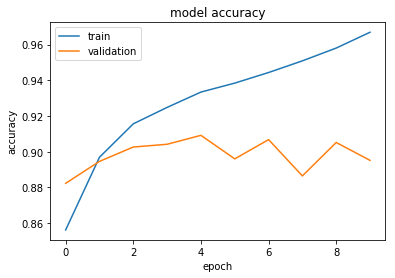

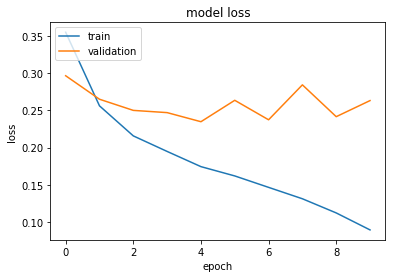

In [9]:
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# Save trained model (multi gpu)

# serialize weights to HDF5
parallel_model.save_weights(WEIGHTS_PATH)

In [11]:
# TODO add testing